In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
from numpy import array
import pandas as pd
import cv2
from glob import glob
import PIL
import time
from tqdm import tqdm
import os

2023-07-23 00:58:14.235454: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
image_path = "/Users/rohinv/Downloads/captioning/images/images_normalized/"
images = glob(image_path + "*.png")
len(images)

7470

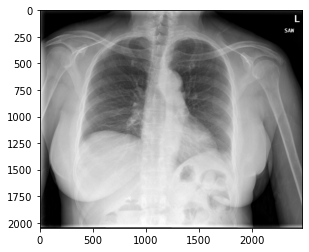

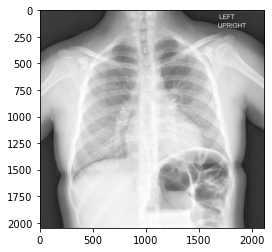

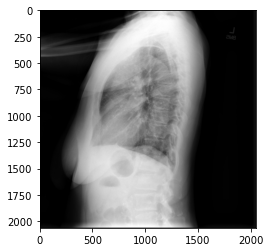

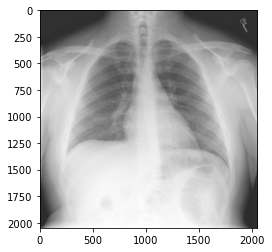

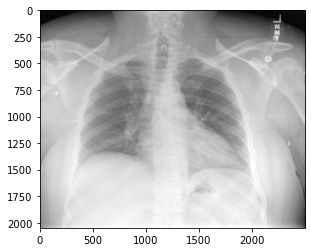

In [3]:
for i in range(5):
    plt.figure()
    image = cv2.imread(images[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)

In [4]:
import re
# Read in the projections data
projections = pd.read_csv('/Users/rohinv/Downloads/captioning/indiana_projections.csv')

# Read in the reports data
reports = pd.read_csv('/Users/rohinv/Downloads/captioning/indiana_reports.csv')

# Define the path to the images folder
images_folder = '/Users/rohinv/Downloads/captioning/images/images_normalized'

# Merge the projections and reports data on the UID column
reports = pd.merge(projections, reports, on='uid')

# Create a dictionary of image filenames and their corresponding captions
data = {}
for i in range(len(reports)):
    filename = reports.loc[i, 'filename']
    caption = reports.loc[i, 'impression']
    if filename not in data:
        data[filename] = []
    if isinstance(caption, str) and re.match(r'^\d+\.', caption):
        data[filename].append(caption.split('. ')[1])
    else:
        if data[filename]:
            data[filename][-1] += " " + caption
        else:
            data[filename].append(caption)

In [5]:
def cleanse_data(data):
    dict_2 = dict()
    for key, value in data.items():
        for i in range(len(value)):
            lines = ""
            line1 = value[i]
            if isinstance(line1, str):
                for j in line1.split():
                    if len(j) < 2:
                        continue
                    j = j.lower()
                    lines += j + " "
                if key not in dict_2:
                    dict_2[key] = list()
                dict_2[key].append(lines)
    return dict_2

data2 = cleanse_data(data)
print(len(data2))

7414


In [6]:
# convert the following into a vocabulary of words and calculate the total words

def vocabulary(data2):
    all_desc = set()
    for key in data2.keys():
        [all_desc.update(d.split()) for d in data2[key]]
    return all_desc

# summarize vocabulary
vocabulary_data = vocabulary(data2)
print(len(vocabulary_data))

1891


In [7]:
def save_dict(data2, filename):
    lines = list()
    for key, value in data2.items():
        for desc in value:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

save_dict(data2, 'captions1.txt')

In [8]:
images = '/Users/rohinv/Downloads/captioning/images/images_normalized/'
img = glob(images + '*.png')
print(len(img))

def preprocess(image_path):
    #Convert all the images to size 299x299 as expected by the inception v3 model
    img = keras.preprocessing.image.load_img(image_path, target_size=(299, 299))
    #Convert PIL image to numpy array of 3-dimensions
    x = keras.preprocessing.image.img_to_array(img)
    #Add one more dimension
    x = np.expand_dims(x, axis=0)
    #pre-process the images using preprocess_input() from inception module
    x = tf.keras.applications.xception.preprocess_input(x)
    return x

7470


In [9]:
from keras.applications.xception import Xception
from keras.models import Model

# Load the Xception model
input1 = Xception(weights='imagenet')

# Create a new model, by removing the last layer (output layer) from the Xception model
model = Model(input1.input, input1.layers[-2].output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 149, 149, 32)         0         ['block1_conv1_bn[0][0]'] 

In [10]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec
    
encoding = {}

for i in tqdm(img):
    encoding[i[len(images):]] = encode(i)
    
import pickle

# Save the features in the images1 pickle file
with open("images1.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding, encoded_pickle)

  0%|          | 0/7470 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step


  0%|          | 1/7470 [00:04<9:55:33,  4.78s/it]

1/1 [==============================] - 0s 283ms/step


  0%|          | 2/7470 [00:05<4:36:32,  2.22s/it]

1/1 [==============================] - 0s 319ms/step


  0%|          | 3/7470 [00:05<2:55:05,  1.41s/it]

1/1 [==============================] - 0s 296ms/step


  0%|          | 4/7470 [00:06<2:06:55,  1.02s/it]

1/1 [==============================] - 0s 330ms/step


  0%|          | 5/7470 [00:06<1:43:03,  1.21it/s]

1/1 [==============================] - 1s 533ms/step


  0%|          | 6/7470 [00:07<1:47:39,  1.16it/s]

1/1 [==============================] - 0s 431ms/step


  0%|          | 7/7470 [00:08<1:49:20,  1.14it/s]

1/1 [==============================] - 1s 503ms/step


  0%|          | 8/7470 [00:09<1:51:11,  1.12it/s]

1/1 [==============================] - 0s 462ms/step


  0%|          | 9/7470 [00:10<1:52:18,  1.11it/s]

1/1 [==============================] - 1s 617ms/step


  0%|          | 10/7470 [00:11<1:59:05,  1.04it/s]

1/1 [==============================] - 1s 598ms/step


  0%|          | 11/7470 [00:12<2:03:50,  1.00it/s]

1/1 [==============================] - 0s 407ms/step


  0%|          | 12/7470 [00:13<1:59:17,  1.04it/s]

1/1 [==============================] - 1s 505ms/step


  0%|          | 13/7470 [00:13<1:47:31,  1.16it/s]

1/1 [==============================] - 0s 464ms/step


  0%|          | 14/7470 [00:14<1:40:56,  1.23it/s]

1/1 [==============================] - 0s 484ms/step


  0%|          | 15/7470 [00:15<1:36:29,  1.29it/s]

1/1 [==============================] - 0s 414ms/step


  0%|          | 16/7470 [00:16<1:40:56,  1.23it/s]

1/1 [==============================] - 0s 326ms/step


  0%|          | 17/7470 [00:16<1:28:04,  1.41it/s]

1/1 [==============================] - 0s 495ms/step


  0%|          | 18/7470 [00:17<1:24:58,  1.46it/s]

1/1 [==============================] - 1s 540ms/step


  0%|          | 19/7470 [00:18<1:40:26,  1.24it/s]

1/1 [==============================] - 1s 944ms/step


  0%|          | 20/7470 [00:20<2:35:26,  1.25s/it]

1/1 [==============================] - 1s 781ms/step


  0%|          | 21/7470 [00:22<3:02:29,  1.47s/it]

1/1 [==============================] - 0s 447ms/step


  0%|          | 22/7470 [00:23<2:40:16,  1.29s/it]

1/1 [==============================] - 0s 468ms/step


  0%|          | 23/7470 [00:24<2:16:25,  1.10s/it]

1/1 [==============================] - 1s 530ms/step


  0%|          | 24/7470 [00:25<2:08:29,  1.04s/it]

1/1 [==============================] - 0s 425ms/step


  0%|          | 25/7470 [00:25<2:02:57,  1.01it/s]

1/1 [==============================] - 0s 395ms/step


  0%|          | 26/7470 [00:26<1:58:16,  1.05it/s]

1/1 [==============================] - 0s 349ms/step


  0%|          | 27/7470 [00:27<1:40:50,  1.23it/s]

1/1 [==============================] - 0s 345ms/step


  0%|          | 28/7470 [00:28<1:40:22,  1.24it/s]

1/1 [==============================] - 0s 389ms/step


  0%|          | 29/7470 [00:28<1:30:48,  1.37it/s]

1/1 [==============================] - 0s 379ms/step


  0%|          | 30/7470 [00:29<1:23:30,  1.48it/s]

1/1 [==============================] - 0s 434ms/step


  0%|          | 31/7470 [00:29<1:19:53,  1.55it/s]

1/1 [==============================] - 1s 550ms/step


  0%|          | 32/7470 [00:30<1:28:49,  1.40it/s]

1/1 [==============================] - 0s 431ms/step


  0%|          | 33/7470 [00:31<1:36:19,  1.29it/s]

1/1 [==============================] - 1s 520ms/step


  0%|          | 34/7470 [00:32<1:46:28,  1.16it/s]

1/1 [==============================] - 0s 460ms/step


  0%|          | 35/7470 [00:33<1:37:42,  1.27it/s]

1/1 [==============================] - 1s 561ms/step


  0%|          | 36/7470 [00:34<1:38:31,  1.26it/s]

1/1 [==============================] - 1s 632ms/step


  0%|          | 37/7470 [00:35<1:55:32,  1.07it/s]

1/1 [==============================] - 1s 549ms/step


  1%|          | 38/7470 [00:36<1:57:29,  1.05it/s]

1/1 [==============================] - 0s 424ms/step


  1%|          | 39/7470 [00:37<1:55:03,  1.08it/s]

1/1 [==============================] - 0s 426ms/step


  1%|          | 40/7470 [00:37<1:43:57,  1.19it/s]

1/1 [==============================] - 1s 677ms/step


  1%|          | 41/7470 [00:39<2:07:40,  1.03s/it]

1/1 [==============================] - 1s 602ms/step


  1%|          | 42/7470 [00:40<1:57:57,  1.05it/s]

1/1 [==============================] - 0s 304ms/step


  1%|          | 43/7470 [00:40<1:40:39,  1.23it/s]

1/1 [==============================] - 0s 409ms/step


  1%|          | 44/7470 [00:41<1:31:27,  1.35it/s]

1/1 [==============================] - 0s 371ms/step


  1%|          | 45/7470 [00:41<1:23:18,  1.49it/s]

1/1 [==============================] - 0s 490ms/step


  1%|          | 46/7470 [00:42<1:23:37,  1.48it/s]

1/1 [==============================] - 0s 386ms/step


  1%|          | 47/7470 [00:43<1:31:04,  1.36it/s]

1/1 [==============================] - 0s 364ms/step


  1%|          | 48/7470 [00:43<1:22:43,  1.50it/s]

1/1 [==============================] - 0s 393ms/step


  1%|          | 49/7470 [00:44<1:30:08,  1.37it/s]

1/1 [==============================] - 1s 785ms/step


  1%|          | 50/7470 [00:46<2:03:19,  1.00it/s]

1/1 [==============================] - 0s 316ms/step


  1%|          | 51/7470 [00:46<1:46:02,  1.17it/s]

1/1 [==============================] - 0s 370ms/step


  1%|          | 52/7470 [00:47<1:34:38,  1.31it/s]

1/1 [==============================] - 0s 359ms/step


  1%|          | 53/7470 [00:47<1:25:34,  1.44it/s]

1/1 [==============================] - 0s 323ms/step


  1%|          | 54/7470 [00:48<1:17:42,  1.59it/s]

1/1 [==============================] - 0s 423ms/step


  1%|          | 55/7470 [00:48<1:16:55,  1.61it/s]

1/1 [==============================] - 0s 358ms/step


  1%|          | 56/7470 [00:49<1:26:58,  1.42it/s]

1/1 [==============================] - 0s 355ms/step


  1%|          | 57/7470 [00:50<1:32:16,  1.34it/s]

1/1 [==============================] - 0s 311ms/step


  1%|          | 58/7470 [00:51<1:20:58,  1.53it/s]

1/1 [==============================] - 0s 321ms/step


  1%|          | 59/7470 [00:51<1:16:14,  1.62it/s]

1/1 [==============================] - 0s 325ms/step


  1%|          | 60/7470 [00:52<1:10:45,  1.75it/s]

1/1 [==============================] - 0s 406ms/step


  1%|          | 61/7470 [00:52<1:11:34,  1.73it/s]

1/1 [==============================] - 0s 346ms/step


  1%|          | 62/7470 [00:53<1:08:42,  1.80it/s]

1/1 [==============================] - 0s 349ms/step


  1%|          | 63/7470 [00:53<1:07:35,  1.83it/s]

1/1 [==============================] - 0s 330ms/step


  1%|          | 64/7470 [00:54<1:04:26,  1.92it/s]

1/1 [==============================] - 0s 326ms/step


  1%|          | 65/7470 [00:54<1:03:01,  1.96it/s]

1/1 [==============================] - 0s 332ms/step


  1%|          | 66/7470 [00:55<1:02:07,  1.99it/s]

1/1 [==============================] - 0s 362ms/step


  1%|          | 67/7470 [00:55<1:02:31,  1.97it/s]

1/1 [==============================] - 0s 357ms/step


  1%|          | 68/7470 [00:56<1:02:37,  1.97it/s]

1/1 [==============================] - 0s 352ms/step


  1%|          | 69/7470 [00:56<1:03:02,  1.96it/s]

1/1 [==============================] - 0s 340ms/step


  1%|          | 70/7470 [00:57<1:01:49,  1.99it/s]

1/1 [==============================] - 0s 343ms/step


  1%|          | 71/7470 [00:57<1:01:50,  1.99it/s]

1/1 [==============================] - 0s 323ms/step


  1%|          | 72/7470 [00:58<1:00:56,  2.02it/s]

1/1 [==============================] - 0s 337ms/step


  1%|          | 73/7470 [00:58<1:00:13,  2.05it/s]

1/1 [==============================] - 0s 465ms/step


  1%|          | 74/7470 [00:59<1:05:19,  1.89it/s]

1/1 [==============================] - 1s 607ms/step


  1%|          | 75/7470 [01:00<1:18:59,  1.56it/s]

1/1 [==============================] - 0s 451ms/step


  1%|          | 76/7470 [01:01<1:26:59,  1.42it/s]

1/1 [==============================] - 1s 546ms/step


  1%|          | 77/7470 [01:01<1:32:57,  1.33it/s]

1/1 [==============================] - 0s 458ms/step


  1%|          | 78/7470 [01:02<1:34:41,  1.30it/s]

1/1 [==============================] - 0s 371ms/step


  1%|          | 79/7470 [01:03<1:26:44,  1.42it/s]

1/1 [==============================] - 0s 395ms/step


  1%|          | 80/7470 [01:04<1:32:46,  1.33it/s]

1/1 [==============================] - 0s 346ms/step


  1%|          | 81/7470 [01:04<1:22:58,  1.48it/s]

1/1 [==============================] - 0s 371ms/step


  1%|          | 82/7470 [01:05<1:27:44,  1.40it/s]

1/1 [==============================] - 0s 361ms/step


  1%|          | 83/7470 [01:05<1:20:08,  1.54it/s]

1/1 [==============================] - 0s 344ms/step


  1%|          | 84/7470 [01:06<1:16:48,  1.60it/s]

1/1 [==============================] - 0s 341ms/step


  1%|          | 85/7470 [01:06<1:12:26,  1.70it/s]

1/1 [==============================] - 0s 301ms/step


  1%|          | 86/7470 [01:07<1:07:44,  1.82it/s]

1/1 [==============================] - 0s 470ms/step


  1%|          | 87/7470 [01:08<1:10:55,  1.73it/s]

1/1 [==============================] - 1s 597ms/step


  1%|          | 88/7470 [01:08<1:18:11,  1.57it/s]

1/1 [==============================] - 0s 437ms/step


  1%|          | 89/7470 [01:09<1:16:04,  1.62it/s]

1/1 [==============================] - 1s 577ms/step


  1%|          | 90/7470 [01:10<1:23:44,  1.47it/s]

1/1 [==============================] - 1s 575ms/step


  1%|          | 91/7470 [01:11<1:32:05,  1.34it/s]

1/1 [==============================] - 0s 416ms/step


  1%|          | 92/7470 [01:11<1:24:39,  1.45it/s]

1/1 [==============================] - 0s 332ms/step


  1%|          | 93/7470 [01:12<1:16:55,  1.60it/s]

1/1 [==============================] - 0s 310ms/step


  1%|▏         | 94/7470 [01:12<1:11:16,  1.72it/s]

1/1 [==============================] - 0s 307ms/step


  1%|▏         | 95/7470 [01:13<1:07:26,  1.82it/s]

1/1 [==============================] - 0s 396ms/step


  1%|▏         | 96/7470 [01:13<1:07:05,  1.83it/s]

1/1 [==============================] - 1s 678ms/step


  1%|▏         | 97/7470 [01:14<1:19:18,  1.55it/s]

1/1 [==============================] - 0s 445ms/step


  1%|▏         | 98/7470 [01:15<1:18:31,  1.56it/s]

1/1 [==============================] - 0s 390ms/step


  1%|▏         | 99/7470 [01:15<1:16:49,  1.60it/s]

1/1 [==============================] - 0s 401ms/step


  1%|▏         | 100/7470 [01:16<1:26:33,  1.42it/s]

1/1 [==============================] - 0s 460ms/step


  1%|▏         | 101/7470 [01:17<1:24:53,  1.45it/s]

1/1 [==============================] - 0s 411ms/step


  1%|▏         | 102/7470 [01:18<1:32:29,  1.33it/s]

1/1 [==============================] - 0s 392ms/step


  1%|▏         | 103/7470 [01:18<1:28:42,  1.38it/s]

1/1 [==============================] - 0s 419ms/step


  1%|▏         | 104/7470 [01:19<1:33:38,  1.31it/s]

1/1 [==============================] - 0s 440ms/step


  1%|▏         | 105/7470 [01:20<1:39:18,  1.24it/s]

1/1 [==============================] - 0s 293ms/step


  1%|▏         | 106/7470 [01:21<1:25:51,  1.43it/s]

1/1 [==============================] - 0s 297ms/step


  1%|▏         | 107/7470 [01:21<1:15:45,  1.62it/s]

1/1 [==============================] - 0s 344ms/step


  1%|▏         | 108/7470 [01:21<1:10:21,  1.74it/s]

1/1 [==============================] - 0s 367ms/step


  1%|▏         | 109/7470 [01:22<1:19:27,  1.54it/s]

1/1 [==============================] - 0s 392ms/step


  1%|▏         | 110/7470 [01:23<1:14:57,  1.64it/s]

1/1 [==============================] - 0s 361ms/step


  1%|▏         | 111/7470 [01:23<1:12:35,  1.69it/s]

1/1 [==============================] - 0s 311ms/step


  1%|▏         | 112/7470 [01:24<1:07:42,  1.81it/s]

1/1 [==============================] - 0s 321ms/step


  2%|▏         | 113/7470 [01:24<1:04:40,  1.90it/s]

1/1 [==============================] - 0s 293ms/step


  2%|▏         | 114/7470 [01:25<1:00:39,  2.02it/s]

1/1 [==============================] - 0s 331ms/step


  2%|▏         | 115/7470 [01:25<59:54,  2.05it/s]  

1/1 [==============================] - 0s 384ms/step


  2%|▏         | 116/7470 [01:26<1:02:17,  1.97it/s]

1/1 [==============================] - 0s 341ms/step


  2%|▏         | 117/7470 [01:26<1:01:02,  2.01it/s]

1/1 [==============================] - 0s 424ms/step


  2%|▏         | 118/7470 [01:27<1:03:30,  1.93it/s]

1/1 [==============================] - 1s 838ms/step


  2%|▏         | 119/7470 [01:28<1:27:16,  1.40it/s]

1/1 [==============================] - 1s 550ms/step


  2%|▏         | 120/7470 [01:29<1:39:19,  1.23it/s]

1/1 [==============================] - 0s 373ms/step


  2%|▏         | 121/7470 [01:30<1:40:44,  1.22it/s]

1/1 [==============================] - 0s 463ms/step


  2%|▏         | 122/7470 [01:31<1:43:32,  1.18it/s]

1/1 [==============================] - 0s 392ms/step


  2%|▏         | 123/7470 [01:31<1:34:13,  1.30it/s]

1/1 [==============================] - 0s 429ms/step


  2%|▏         | 124/7470 [01:32<1:42:18,  1.20it/s]

1/1 [==============================] - 0s 325ms/step


  2%|▏         | 125/7470 [01:33<1:28:39,  1.38it/s]

1/1 [==============================] - 0s 320ms/step


  2%|▏         | 126/7470 [01:33<1:19:10,  1.55it/s]

1/1 [==============================] - 0s 349ms/step


  2%|▏         | 127/7470 [01:34<1:13:16,  1.67it/s]

1/1 [==============================] - 0s 348ms/step


  2%|▏         | 128/7470 [01:34<1:09:27,  1.76it/s]

1/1 [==============================] - 0s 389ms/step


  2%|▏         | 129/7470 [01:35<1:08:56,  1.77it/s]

1/1 [==============================] - 0s 355ms/step


  2%|▏         | 130/7470 [01:35<1:06:26,  1.84it/s]

1/1 [==============================] - 0s 355ms/step


  2%|▏         | 131/7470 [01:36<1:05:11,  1.88it/s]

1/1 [==============================] - 0s 326ms/step


  2%|▏         | 132/7470 [01:36<1:02:54,  1.94it/s]

1/1 [==============================] - 0s 332ms/step


  2%|▏         | 133/7470 [01:37<1:00:58,  2.01it/s]

1/1 [==============================] - 0s 300ms/step


  2%|▏         | 134/7470 [01:37<59:49,  2.04it/s]  

1/1 [==============================] - 0s 293ms/step


  2%|▏         | 135/7470 [01:38<57:30,  2.13it/s]

1/1 [==============================] - 0s 323ms/step


  2%|▏         | 136/7470 [01:38<56:52,  2.15it/s]

1/1 [==============================] - 0s 307ms/step


  2%|▏         | 137/7470 [01:39<56:28,  2.16it/s]

1/1 [==============================] - 0s 302ms/step


  2%|▏         | 138/7470 [01:39<55:28,  2.20it/s]

1/1 [==============================] - 0s 288ms/step


  2%|▏         | 139/7470 [01:39<54:37,  2.24it/s]

1/1 [==============================] - 0s 286ms/step


  2%|▏         | 140/7470 [01:40<54:23,  2.25it/s]

1/1 [==============================] - 0s 314ms/step


  2%|▏         | 141/7470 [01:40<54:36,  2.24it/s]

1/1 [==============================] - 0s 320ms/step


  2%|▏         | 142/7470 [01:41<55:13,  2.21it/s]

1/1 [==============================] - 0s 297ms/step


  2%|▏         | 143/7470 [01:41<55:17,  2.21it/s]

1/1 [==============================] - 0s 337ms/step


  2%|▏         | 144/7470 [01:42<56:17,  2.17it/s]

1/1 [==============================] - 0s 299ms/step


  2%|▏         | 145/7470 [01:42<56:07,  2.18it/s]

1/1 [==============================] - 0s 284ms/step


  2%|▏         | 146/7470 [01:43<53:58,  2.26it/s]

1/1 [==============================] - 0s 291ms/step


  2%|▏         | 147/7470 [01:43<53:28,  2.28it/s]

1/1 [==============================] - 0s 307ms/step


  2%|▏         | 148/7470 [01:43<53:22,  2.29it/s]

1/1 [==============================] - 0s 327ms/step


  2%|▏         | 149/7470 [01:44<54:19,  2.25it/s]

1/1 [==============================] - 0s 377ms/step


  2%|▏         | 150/7470 [01:44<58:38,  2.08it/s]

1/1 [==============================] - 0s 418ms/step


  2%|▏         | 151/7470 [01:45<1:14:10,  1.64it/s]

1/1 [==============================] - 0s 372ms/step


  2%|▏         | 152/7470 [01:46<1:12:22,  1.69it/s]

1/1 [==============================] - 1s 673ms/step


  2%|▏         | 153/7470 [01:47<1:25:53,  1.42it/s]

1/1 [==============================] - 0s 380ms/step


  2%|▏         | 154/7470 [01:48<1:30:50,  1.34it/s]

1/1 [==============================] - 0s 292ms/step


  2%|▏         | 155/7470 [01:48<1:20:18,  1.52it/s]

1/1 [==============================] - 0s 266ms/step


  2%|▏         | 156/7470 [01:49<1:13:20,  1.66it/s]

1/1 [==============================] - 0s 364ms/step


  2%|▏         | 157/7470 [01:49<1:10:31,  1.73it/s]

1/1 [==============================] - 0s 296ms/step


  2%|▏         | 158/7470 [01:50<1:05:19,  1.87it/s]

1/1 [==============================] - 0s 275ms/step


  2%|▏         | 159/7470 [01:50<1:00:29,  2.01it/s]

1/1 [==============================] - 0s 292ms/step


  2%|▏         | 160/7470 [01:50<58:52,  2.07it/s]  

1/1 [==============================] - 0s 302ms/step


  2%|▏         | 161/7470 [01:51<57:50,  2.11it/s]

1/1 [==============================] - 0s 311ms/step


  2%|▏         | 162/7470 [01:51<56:07,  2.17it/s]

1/1 [==============================] - 0s 357ms/step


  2%|▏         | 163/7470 [01:52<1:08:12,  1.79it/s]

1/1 [==============================] - 0s 356ms/step


  2%|▏         | 164/7470 [01:53<1:19:29,  1.53it/s]

1/1 [==============================] - 0s 275ms/step


  2%|▏         | 165/7470 [01:53<1:10:34,  1.73it/s]

1/1 [==============================] - 0s 319ms/step


  2%|▏         | 166/7470 [01:54<1:05:09,  1.87it/s]

1/1 [==============================] - 0s 356ms/step


  2%|▏         | 167/7470 [01:54<1:03:43,  1.91it/s]

1/1 [==============================] - 0s 390ms/step


  2%|▏         | 168/7470 [01:55<1:03:52,  1.91it/s]

1/1 [==============================] - 0s 318ms/step


  2%|▏         | 169/7470 [01:55<1:01:52,  1.97it/s]

1/1 [==============================] - 0s 341ms/step


  2%|▏         | 170/7470 [01:56<1:01:57,  1.96it/s]

1/1 [==============================] - 0s 297ms/step


  2%|▏         | 171/7470 [01:56<59:32,  2.04it/s]  

1/1 [==============================] - 0s 310ms/step


  2%|▏         | 172/7470 [01:57<58:00,  2.10it/s]

1/1 [==============================] - 0s 300ms/step


  2%|▏         | 173/7470 [01:57<56:44,  2.14it/s]

1/1 [==============================] - 0s 275ms/step


  2%|▏         | 174/7470 [01:58<56:37,  2.15it/s]

1/1 [==============================] - 0s 313ms/step


  2%|▏         | 175/7470 [01:58<55:45,  2.18it/s]

1/1 [==============================] - 1s 513ms/step


  2%|▏         | 176/7470 [01:59<1:02:30,  1.94it/s]

1/1 [==============================] - 0s 391ms/step


  2%|▏         | 177/7470 [01:59<1:05:01,  1.87it/s]

1/1 [==============================] - 1s 513ms/step


  2%|▏         | 178/7470 [02:00<1:20:11,  1.52it/s]

1/1 [==============================] - 0s 351ms/step


  2%|▏         | 179/7470 [02:01<1:26:49,  1.40it/s]

1/1 [==============================] - 0s 387ms/step


  2%|▏         | 180/7470 [02:02<1:20:02,  1.52it/s]

1/1 [==============================] - 0s 431ms/step


  2%|▏         | 181/7470 [02:03<1:28:09,  1.38it/s]

1/1 [==============================] - 0s 353ms/step


  2%|▏         | 182/7470 [02:03<1:18:39,  1.54it/s]

1/1 [==============================] - 0s 299ms/step


  2%|▏         | 183/7470 [02:03<1:12:08,  1.68it/s]

1/1 [==============================] - 0s 291ms/step


  2%|▏         | 184/7470 [02:04<1:06:14,  1.83it/s]

1/1 [==============================] - 0s 312ms/step


  2%|▏         | 185/7470 [02:04<1:02:44,  1.94it/s]

1/1 [==============================] - 0s 321ms/step


  2%|▏         | 186/7470 [02:05<1:00:15,  2.01it/s]

1/1 [==============================] - 0s 362ms/step


  3%|▎         | 187/7470 [02:05<59:57,  2.02it/s]  

1/1 [==============================] - 0s 354ms/step


  3%|▎         | 188/7470 [02:06<1:11:43,  1.69it/s]

1/1 [==============================] - 0s 316ms/step


  3%|▎         | 189/7470 [02:07<1:06:41,  1.82it/s]

1/1 [==============================] - 1s 563ms/step


  3%|▎         | 190/7470 [02:07<1:14:11,  1.64it/s]

1/1 [==============================] - 0s 401ms/step


  3%|▎         | 191/7470 [02:08<1:13:21,  1.65it/s]

1/1 [==============================] - 0s 310ms/step


  3%|▎         | 192/7470 [02:08<1:08:36,  1.77it/s]

1/1 [==============================] - 0s 352ms/step


  3%|▎         | 193/7470 [02:09<1:17:27,  1.57it/s]

1/1 [==============================] - 0s 322ms/step


  3%|▎         | 194/7470 [02:10<1:10:43,  1.71it/s]

1/1 [==============================] - 0s 288ms/step


  3%|▎         | 195/7470 [02:10<1:06:50,  1.81it/s]

1/1 [==============================] - 0s 317ms/step


  3%|▎         | 196/7470 [02:11<1:04:26,  1.88it/s]

1/1 [==============================] - 0s 356ms/step


  3%|▎         | 197/7470 [02:11<1:03:50,  1.90it/s]

1/1 [==============================] - 0s 382ms/step


  3%|▎         | 198/7470 [02:12<1:03:56,  1.90it/s]

1/1 [==============================] - 0s 350ms/step


  3%|▎         | 199/7470 [02:12<1:06:11,  1.83it/s]

1/1 [==============================] - 0s 325ms/step


  3%|▎         | 200/7470 [02:13<1:04:09,  1.89it/s]

1/1 [==============================] - 0s 349ms/step


  3%|▎         | 201/7470 [02:13<1:02:13,  1.95it/s]

1/1 [==============================] - 0s 298ms/step


  3%|▎         | 202/7470 [02:14<1:00:05,  2.02it/s]

1/1 [==============================] - 0s 304ms/step


  3%|▎         | 203/7470 [02:14<58:17,  2.08it/s]  

1/1 [==============================] - 0s 308ms/step


  3%|▎         | 204/7470 [02:15<57:16,  2.11it/s]

1/1 [==============================] - 0s 309ms/step


  3%|▎         | 205/7470 [02:15<56:42,  2.13it/s]

1/1 [==============================] - 0s 287ms/step


  3%|▎         | 206/7470 [02:15<54:53,  2.21it/s]

1/1 [==============================] - 0s 332ms/step


  3%|▎         | 207/7470 [02:16<55:27,  2.18it/s]

1/1 [==============================] - 0s 412ms/step


  3%|▎         | 208/7470 [02:17<1:07:29,  1.79it/s]

1/1 [==============================] - 0s 414ms/step


  3%|▎         | 209/7470 [02:17<1:08:01,  1.78it/s]

1/1 [==============================] - 0s 496ms/step


  3%|▎         | 210/7470 [02:18<1:17:45,  1.56it/s]

1/1 [==============================] - 0s 434ms/step


  3%|▎         | 211/7470 [02:19<1:16:23,  1.58it/s]

1/1 [==============================] - 0s 358ms/step


  3%|▎         | 212/7470 [02:19<1:12:43,  1.66it/s]

1/1 [==============================] - 0s 442ms/step


  3%|▎         | 213/7470 [02:20<1:21:25,  1.49it/s]

1/1 [==============================] - 0s 339ms/step


  3%|▎         | 214/7470 [02:21<1:15:57,  1.59it/s]

1/1 [==============================] - 0s 317ms/step


  3%|▎         | 215/7470 [02:21<1:11:17,  1.70it/s]

1/1 [==============================] - 0s 287ms/step


  3%|▎         | 216/7470 [02:22<1:05:28,  1.85it/s]

1/1 [==============================] - 0s 299ms/step


  3%|▎         | 217/7470 [02:22<1:01:10,  1.98it/s]

1/1 [==============================] - 0s 365ms/step


  3%|▎         | 218/7470 [02:22<1:00:52,  1.99it/s]

1/1 [==============================] - 0s 336ms/step


  3%|▎         | 219/7470 [02:23<1:00:43,  1.99it/s]

1/1 [==============================] - 0s 314ms/step


  3%|▎         | 220/7470 [02:23<58:52,  2.05it/s]  

1/1 [==============================] - 0s 326ms/step


  3%|▎         | 221/7470 [02:24<1:07:14,  1.80it/s]

1/1 [==============================] - 0s 290ms/step


  3%|▎         | 222/7470 [02:25<1:02:16,  1.94it/s]

1/1 [==============================] - 0s 279ms/step


  3%|▎         | 223/7470 [02:25<58:24,  2.07it/s]  

1/1 [==============================] - 0s 278ms/step


  3%|▎         | 224/7470 [02:25<56:07,  2.15it/s]

1/1 [==============================] - 0s 291ms/step


  3%|▎         | 225/7470 [02:26<54:33,  2.21it/s]

1/1 [==============================] - 0s 279ms/step


  3%|▎         | 226/7470 [02:26<54:48,  2.20it/s]

1/1 [==============================] - 0s 272ms/step


  3%|▎         | 227/7470 [02:27<53:29,  2.26it/s]

1/1 [==============================] - 0s 278ms/step


  3%|▎         | 228/7470 [02:27<52:26,  2.30it/s]

1/1 [==============================] - 0s 291ms/step


  3%|▎         | 229/7470 [02:27<52:04,  2.32it/s]

1/1 [==============================] - 0s 273ms/step


  3%|▎         | 230/7470 [02:28<50:21,  2.40it/s]

1/1 [==============================] - 0s 293ms/step


  3%|▎         | 231/7470 [02:28<50:54,  2.37it/s]

1/1 [==============================] - 0s 271ms/step


  3%|▎         | 232/7470 [02:29<49:39,  2.43it/s]

1/1 [==============================] - 0s 288ms/step


  3%|▎         | 233/7470 [02:29<49:18,  2.45it/s]

1/1 [==============================] - 0s 280ms/step


  3%|▎         | 234/7470 [02:30<50:42,  2.38it/s]

1/1 [==============================] - 0s 301ms/step


  3%|▎         | 235/7470 [02:30<51:32,  2.34it/s]

1/1 [==============================] - 0s 351ms/step


  3%|▎         | 236/7470 [02:30<54:32,  2.21it/s]

1/1 [==============================] - 0s 300ms/step


  3%|▎         | 237/7470 [02:31<54:01,  2.23it/s]

1/1 [==============================] - 0s 315ms/step


  3%|▎         | 238/7470 [02:31<54:11,  2.22it/s]

1/1 [==============================] - 0s 357ms/step


  3%|▎         | 239/7470 [02:32<56:45,  2.12it/s]

1/1 [==============================] - 0s 296ms/step


  3%|▎         | 240/7470 [02:32<56:29,  2.13it/s]

1/1 [==============================] - 0s 339ms/step


  3%|▎         | 241/7470 [02:33<1:07:41,  1.78it/s]

1/1 [==============================] - 0s 255ms/step


  3%|▎         | 242/7470 [02:34<1:01:36,  1.96it/s]

1/1 [==============================] - 0s 273ms/step


  3%|▎         | 243/7470 [02:34<57:10,  2.11it/s]  

1/1 [==============================] - 0s 271ms/step


  3%|▎         | 244/7470 [02:34<54:08,  2.22it/s]

1/1 [==============================] - 0s 364ms/step


  3%|▎         | 245/7470 [02:35<1:06:20,  1.81it/s]

1/1 [==============================] - 0s 342ms/step


  3%|▎         | 246/7470 [02:36<1:05:22,  1.84it/s]

1/1 [==============================] - 0s 397ms/step


  3%|▎         | 247/7470 [02:36<1:06:48,  1.80it/s]

1/1 [==============================] - 1s 508ms/step


  3%|▎         | 248/7470 [02:37<1:12:16,  1.67it/s]

1/1 [==============================] - 1s 1s/step


  3%|▎         | 249/7470 [02:39<1:48:08,  1.11it/s]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 250/7470 [02:41<2:42:19,  1.35s/it]

1/1 [==============================] - 1s 558ms/step


  3%|▎         | 251/7470 [02:42<2:22:21,  1.18s/it]

1/1 [==============================] - 1s 645ms/step


  3%|▎         | 252/7470 [02:43<2:15:14,  1.12s/it]

1/1 [==============================] - 0s 479ms/step


  3%|▎         | 253/7470 [02:43<2:03:01,  1.02s/it]

1/1 [==============================] - 0s 438ms/step


  3%|▎         | 254/7470 [02:44<1:49:14,  1.10it/s]

1/1 [==============================] - 0s 433ms/step


  3%|▎         | 255/7470 [02:45<1:39:57,  1.20it/s]

1/1 [==============================] - 0s 467ms/step


  3%|▎         | 256/7470 [02:46<1:40:46,  1.19it/s]

1/1 [==============================] - 0s 412ms/step


  3%|▎         | 257/7470 [02:46<1:31:56,  1.31it/s]

1/1 [==============================] - 0s 324ms/step


  3%|▎         | 258/7470 [02:47<1:23:10,  1.45it/s]

1/1 [==============================] - 0s 359ms/step


  3%|▎         | 259/7470 [02:47<1:17:22,  1.55it/s]

1/1 [==============================] - 0s 357ms/step


  3%|▎         | 260/7470 [02:48<1:12:24,  1.66it/s]

1/1 [==============================] - 0s 386ms/step


  3%|▎         | 261/7470 [02:49<1:21:24,  1.48it/s]

1/1 [==============================] - 0s 414ms/step


  4%|▎         | 262/7470 [02:49<1:17:27,  1.55it/s]

1/1 [==============================] - 0s 425ms/step


  4%|▎         | 263/7470 [02:50<1:16:03,  1.58it/s]

1/1 [==============================] - 0s 331ms/step


  4%|▎         | 264/7470 [02:50<1:11:23,  1.68it/s]

1/1 [==============================] - 0s 310ms/step


  4%|▎         | 265/7470 [02:51<1:08:21,  1.76it/s]

1/1 [==============================] - 0s 348ms/step


  4%|▎         | 266/7470 [02:52<1:20:11,  1.50it/s]

1/1 [==============================] - 0s 414ms/step


  4%|▎         | 267/7470 [02:53<1:26:56,  1.38it/s]

1/1 [==============================] - 0s 413ms/step


  4%|▎         | 268/7470 [02:53<1:21:50,  1.47it/s]

1/1 [==============================] - 0s 385ms/step


  4%|▎         | 269/7470 [02:54<1:27:36,  1.37it/s]

1/1 [==============================] - 0s 276ms/step


  4%|▎         | 270/7470 [02:54<1:16:10,  1.58it/s]

1/1 [==============================] - 0s 282ms/step


  4%|▎         | 271/7470 [02:55<1:09:58,  1.71it/s]

1/1 [==============================] - 0s 291ms/step


  4%|▎         | 272/7470 [02:55<1:05:04,  1.84it/s]

1/1 [==============================] - 0s 289ms/step


  4%|▎         | 273/7470 [02:56<1:01:04,  1.96it/s]

1/1 [==============================] - 0s 304ms/step


  4%|▎         | 274/7470 [02:56<59:10,  2.03it/s]  

1/1 [==============================] - 0s 284ms/step


  4%|▎         | 275/7470 [02:57<56:23,  2.13it/s]

1/1 [==============================] - 0s 308ms/step


  4%|▎         | 276/7470 [02:57<54:59,  2.18it/s]

1/1 [==============================] - 0s 281ms/step


  4%|▎         | 277/7470 [02:58<55:22,  2.16it/s]

1/1 [==============================] - 0s 286ms/step


  4%|▎         | 278/7470 [02:58<52:53,  2.27it/s]

1/1 [==============================] - 0s 308ms/step


  4%|▎         | 279/7470 [02:58<52:57,  2.26it/s]

1/1 [==============================] - 0s 289ms/step


  4%|▎         | 280/7470 [02:59<51:35,  2.32it/s]

1/1 [==============================] - 0s 298ms/step


  4%|▍         | 281/7470 [02:59<52:25,  2.29it/s]

1/1 [==============================] - 0s 278ms/step


  4%|▍         | 282/7470 [03:00<50:54,  2.35it/s]

1/1 [==============================] - 0s 271ms/step


  4%|▍         | 283/7470 [03:00<49:25,  2.42it/s]

1/1 [==============================] - 0s 280ms/step


  4%|▍         | 284/7470 [03:00<48:47,  2.45it/s]

1/1 [==============================] - 0s 283ms/step


  4%|▍         | 285/7470 [03:01<50:24,  2.38it/s]

1/1 [==============================] - 0s 281ms/step


  4%|▍         | 286/7470 [03:01<50:31,  2.37it/s]

1/1 [==============================] - 0s 274ms/step


  4%|▍         | 287/7470 [03:02<50:08,  2.39it/s]

1/1 [==============================] - 0s 282ms/step


  4%|▍         | 288/7470 [03:02<49:36,  2.41it/s]

1/1 [==============================] - 0s 315ms/step


  4%|▍         | 289/7470 [03:03<51:00,  2.35it/s]

1/1 [==============================] - 0s 282ms/step


  4%|▍         | 290/7470 [03:03<50:44,  2.36it/s]

1/1 [==============================] - 0s 308ms/step


  4%|▍         | 291/7470 [03:03<54:07,  2.21it/s]

1/1 [==============================] - 0s 294ms/step


  4%|▍         | 292/7470 [03:04<53:04,  2.25it/s]

1/1 [==============================] - 0s 313ms/step


  4%|▍         | 293/7470 [03:04<53:37,  2.23it/s]

1/1 [==============================] - 0s 269ms/step


  4%|▍         | 294/7470 [03:05<51:21,  2.33it/s]

1/1 [==============================] - 0s 294ms/step


  4%|▍         | 295/7470 [03:05<51:33,  2.32it/s]

1/1 [==============================] - 0s 273ms/step


  4%|▍         | 296/7470 [03:06<49:43,  2.40it/s]

1/1 [==============================] - 0s 284ms/step


  4%|▍         | 297/7470 [03:06<49:03,  2.44it/s]

1/1 [==============================] - 0s 308ms/step


  4%|▍         | 298/7470 [03:06<50:39,  2.36it/s]

1/1 [==============================] - 0s 267ms/step


  4%|▍         | 299/7470 [03:07<49:48,  2.40it/s]

1/1 [==============================] - 0s 412ms/step


  4%|▍         | 300/7470 [03:07<54:38,  2.19it/s]

1/1 [==============================] - 0s 290ms/step


  4%|▍         | 301/7470 [03:08<53:15,  2.24it/s]

1/1 [==============================] - 0s 319ms/step


  4%|▍         | 302/7470 [03:08<53:41,  2.23it/s]

1/1 [==============================] - 0s 289ms/step


  4%|▍         | 303/7470 [03:09<52:55,  2.26it/s]

1/1 [==============================] - 0s 286ms/step


  4%|▍         | 304/7470 [03:09<52:02,  2.30it/s]

1/1 [==============================] - 0s 281ms/step


  4%|▍         | 305/7470 [03:10<51:21,  2.33it/s]

1/1 [==============================] - 0s 284ms/step


  4%|▍         | 306/7470 [03:10<50:18,  2.37it/s]

1/1 [==============================] - 0s 301ms/step


  4%|▍         | 307/7470 [03:10<51:18,  2.33it/s]

1/1 [==============================] - 0s 272ms/step


  4%|▍         | 308/7470 [03:11<50:18,  2.37it/s]

1/1 [==============================] - 0s 298ms/step


  4%|▍         | 309/7470 [03:11<50:58,  2.34it/s]

1/1 [==============================] - 0s 269ms/step


  4%|▍         | 310/7470 [03:12<49:31,  2.41it/s]

1/1 [==============================] - 0s 277ms/step


  4%|▍         | 311/7470 [03:12<49:25,  2.41it/s]

1/1 [==============================] - 0s 364ms/step


  4%|▍         | 312/7470 [03:13<53:44,  2.22it/s]

1/1 [==============================] - 0s 366ms/step


  4%|▍         | 313/7470 [03:13<1:07:15,  1.77it/s]

1/1 [==============================] - 0s 385ms/step


  4%|▍         | 314/7470 [03:14<1:18:02,  1.53it/s]

1/1 [==============================] - 0s 332ms/step


  4%|▍         | 315/7470 [03:15<1:11:19,  1.67it/s]

1/1 [==============================] - 0s 298ms/step


  4%|▍         | 316/7470 [03:15<1:07:10,  1.77it/s]

1/1 [==============================] - 0s 303ms/step


  4%|▍         | 317/7470 [03:16<1:02:55,  1.89it/s]

1/1 [==============================] - 0s 371ms/step


  4%|▍         | 318/7470 [03:16<1:02:30,  1.91it/s]

1/1 [==============================] - 0s 279ms/step


  4%|▍         | 319/7470 [03:17<59:02,  2.02it/s]  

1/1 [==============================] - 0s 291ms/step


  4%|▍         | 320/7470 [03:17<56:05,  2.12it/s]

1/1 [==============================] - 0s 297ms/step


  4%|▍         | 321/7470 [03:17<55:02,  2.16it/s]

1/1 [==============================] - 0s 265ms/step


  4%|▍         | 322/7470 [03:18<53:27,  2.23it/s]

1/1 [==============================] - 0s 292ms/step


  4%|▍         | 323/7470 [03:18<52:27,  2.27it/s]

1/1 [==============================] - 0s 292ms/step


  4%|▍         | 324/7470 [03:19<52:55,  2.25it/s]

1/1 [==============================] - 0s 272ms/step


  4%|▍         | 325/7470 [03:19<52:01,  2.29it/s]

1/1 [==============================] - 0s 286ms/step


  4%|▍         | 326/7470 [03:20<51:17,  2.32it/s]

1/1 [==============================] - 0s 275ms/step


  4%|▍         | 327/7470 [03:20<50:38,  2.35it/s]

1/1 [==============================] - 0s 290ms/step


  4%|▍         | 328/7470 [03:20<51:08,  2.33it/s]

1/1 [==============================] - 0s 272ms/step


  4%|▍         | 329/7470 [03:21<52:12,  2.28it/s]

1/1 [==============================] - 0s 265ms/step


  4%|▍         | 330/7470 [03:21<50:59,  2.33it/s]

1/1 [==============================] - 0s 277ms/step


  4%|▍         | 331/7470 [03:22<50:28,  2.36it/s]

1/1 [==============================] - 0s 276ms/step


  4%|▍         | 332/7470 [03:22<49:46,  2.39it/s]

1/1 [==============================] - 0s 376ms/step


  4%|▍         | 333/7470 [03:23<53:17,  2.23it/s]

1/1 [==============================] - 0s 349ms/step


  4%|▍         | 334/7470 [03:23<55:33,  2.14it/s]

1/1 [==============================] - 0s 390ms/step


  4%|▍         | 335/7470 [03:24<1:08:21,  1.74it/s]

1/1 [==============================] - 0s 337ms/step


  4%|▍         | 336/7470 [03:24<1:06:02,  1.80it/s]

1/1 [==============================] - 0s 339ms/step


  5%|▍         | 337/7470 [03:25<1:04:05,  1.85it/s]

1/1 [==============================] - 0s 283ms/step


  5%|▍         | 338/7470 [03:25<1:00:41,  1.96it/s]

1/1 [==============================] - 0s 273ms/step


  5%|▍         | 339/7470 [03:26<56:53,  2.09it/s]  

1/1 [==============================] - 0s 281ms/step


  5%|▍         | 340/7470 [03:26<53:55,  2.20it/s]

1/1 [==============================] - 0s 277ms/step


  5%|▍         | 341/7470 [03:27<52:01,  2.28it/s]

1/1 [==============================] - 0s 270ms/step


  5%|▍         | 342/7470 [03:27<50:41,  2.34it/s]

1/1 [==============================] - 0s 278ms/step


  5%|▍         | 343/7470 [03:27<50:21,  2.36it/s]

1/1 [==============================] - 0s 274ms/step


  5%|▍         | 344/7470 [03:28<49:44,  2.39it/s]

1/1 [==============================] - 0s 296ms/step


  5%|▍         | 345/7470 [03:28<49:24,  2.40it/s]

1/1 [==============================] - 0s 285ms/step


  5%|▍         | 346/7470 [03:29<49:28,  2.40it/s]

1/1 [==============================] - 0s 287ms/step


  5%|▍         | 347/7470 [03:29<50:45,  2.34it/s]

1/1 [==============================] - 0s 288ms/step


  5%|▍         | 348/7470 [03:30<50:32,  2.35it/s]

1/1 [==============================] - 0s 277ms/step


  5%|▍         | 349/7470 [03:30<49:30,  2.40it/s]

1/1 [==============================] - 0s 293ms/step


  5%|▍         | 350/7470 [03:30<49:55,  2.38it/s]

1/1 [==============================] - 0s 272ms/step


  5%|▍         | 351/7470 [03:31<49:31,  2.40it/s]

1/1 [==============================] - 0s 280ms/step


  5%|▍         | 352/7470 [03:31<49:09,  2.41it/s]

1/1 [==============================] - 0s 274ms/step


  5%|▍         | 353/7470 [03:32<48:53,  2.43it/s]

1/1 [==============================] - 0s 269ms/step


  5%|▍         | 354/7470 [03:32<48:35,  2.44it/s]

1/1 [==============================] - 0s 266ms/step


  5%|▍         | 355/7470 [03:32<48:11,  2.46it/s]

1/1 [==============================] - 0s 299ms/step


  5%|▍         | 356/7470 [03:33<48:52,  2.43it/s]

1/1 [==============================] - 0s 287ms/step


  5%|▍         | 357/7470 [03:33<49:01,  2.42it/s]

1/1 [==============================] - 0s 338ms/step


  5%|▍         | 358/7470 [03:34<1:01:48,  1.92it/s]

1/1 [==============================] - 0s 249ms/step


  5%|▍         | 359/7470 [03:34<57:03,  2.08it/s]  

1/1 [==============================] - 0s 259ms/step


  5%|▍         | 360/7470 [03:35<53:34,  2.21it/s]

1/1 [==============================] - 0s 272ms/step


  5%|▍         | 361/7470 [03:35<51:42,  2.29it/s]

1/1 [==============================] - 0s 275ms/step


  5%|▍         | 362/7470 [03:36<50:06,  2.36it/s]

1/1 [==============================] - 0s 265ms/step


  5%|▍         | 363/7470 [03:36<48:45,  2.43it/s]

1/1 [==============================] - 0s 272ms/step


  5%|▍         | 364/7470 [03:36<48:41,  2.43it/s]

1/1 [==============================] - 0s 285ms/step


  5%|▍         | 365/7470 [03:37<48:33,  2.44it/s]

1/1 [==============================] - 0s 283ms/step


  5%|▍         | 366/7470 [03:37<47:49,  2.48it/s]

1/1 [==============================] - 0s 291ms/step


  5%|▍         | 367/7470 [03:38<48:54,  2.42it/s]

1/1 [==============================] - 0s 277ms/step


  5%|▍         | 368/7470 [03:38<49:05,  2.41it/s]

1/1 [==============================] - 0s 279ms/step


  5%|▍         | 369/7470 [03:38<51:36,  2.29it/s]

1/1 [==============================] - 0s 272ms/step


  5%|▍         | 370/7470 [03:39<50:31,  2.34it/s]

1/1 [==============================] - 0s 286ms/step


  5%|▍         | 371/7470 [03:39<50:44,  2.33it/s]

1/1 [==============================] - 0s 273ms/step


  5%|▍         | 372/7470 [03:40<49:15,  2.40it/s]

1/1 [==============================] - 0s 288ms/step


  5%|▍         | 373/7470 [03:40<49:05,  2.41it/s]

1/1 [==============================] - 0s 287ms/step


  5%|▌         | 374/7470 [03:41<49:38,  2.38it/s]

1/1 [==============================] - 0s 265ms/step


  5%|▌         | 375/7470 [03:41<51:03,  2.32it/s]

1/1 [==============================] - 0s 264ms/step


  5%|▌         | 376/7470 [03:41<49:42,  2.38it/s]

1/1 [==============================] - 0s 259ms/step


  5%|▌         | 377/7470 [03:42<48:39,  2.43it/s]

1/1 [==============================] - 0s 276ms/step


  5%|▌         | 378/7470 [03:42<48:01,  2.46it/s]

1/1 [==============================] - 0s 313ms/step


  5%|▌         | 379/7470 [03:43<49:18,  2.40it/s]

1/1 [==============================] - 0s 330ms/step


  5%|▌         | 380/7470 [03:43<50:57,  2.32it/s]

1/1 [==============================] - 0s 355ms/step


  5%|▌         | 381/7470 [03:44<1:05:11,  1.81it/s]

1/1 [==============================] - 0s 326ms/step


  5%|▌         | 382/7470 [03:44<1:03:15,  1.87it/s]

1/1 [==============================] - 0s 370ms/step


  5%|▌         | 383/7470 [03:45<1:13:23,  1.61it/s]

1/1 [==============================] - 0s 247ms/step


  5%|▌         | 384/7470 [03:46<1:05:04,  1.81it/s]

1/1 [==============================] - 0s 265ms/step


  5%|▌         | 385/7470 [03:46<58:50,  2.01it/s]  

1/1 [==============================] - 0s 266ms/step


  5%|▌         | 386/7470 [03:46<57:56,  2.04it/s]

1/1 [==============================] - 0s 261ms/step


  5%|▌         | 387/7470 [03:47<54:20,  2.17it/s]

1/1 [==============================] - 0s 281ms/step


  5%|▌         | 388/7470 [03:47<55:19,  2.13it/s]

1/1 [==============================] - 0s 328ms/step


  5%|▌         | 389/7470 [03:48<54:22,  2.17it/s]

1/1 [==============================] - 0s 289ms/step


  5%|▌         | 390/7470 [03:48<54:28,  2.17it/s]

1/1 [==============================] - 0s 292ms/step


  5%|▌         | 391/7470 [03:49<53:00,  2.23it/s]

1/1 [==============================] - 0s 336ms/step


  5%|▌         | 392/7470 [03:49<1:05:11,  1.81it/s]

1/1 [==============================] - 0s 238ms/step


  5%|▌         | 393/7470 [03:50<58:48,  2.01it/s]  

1/1 [==============================] - 0s 271ms/step


  5%|▌         | 394/7470 [03:50<55:10,  2.14it/s]

1/1 [==============================] - 0s 272ms/step


  5%|▌         | 395/7470 [03:51<54:44,  2.15it/s]

1/1 [==============================] - 0s 265ms/step


  5%|▌         | 396/7470 [03:51<52:04,  2.26it/s]

1/1 [==============================] - 0s 289ms/step


  5%|▌         | 397/7470 [03:52<51:18,  2.30it/s]

1/1 [==============================] - 0s 279ms/step


  5%|▌         | 398/7470 [03:52<50:03,  2.35it/s]

1/1 [==============================] - 0s 276ms/step


  5%|▌         | 399/7470 [03:52<50:07,  2.35it/s]

1/1 [==============================] - 0s 300ms/step


  5%|▌         | 400/7470 [03:53<51:17,  2.30it/s]

1/1 [==============================] - 0s 324ms/step


  5%|▌         | 401/7470 [03:53<52:40,  2.24it/s]

1/1 [==============================] - 0s 354ms/step


  5%|▌         | 402/7470 [03:54<55:05,  2.14it/s]

1/1 [==============================] - 0s 322ms/step


  5%|▌         | 403/7470 [03:54<57:59,  2.03it/s]

1/1 [==============================] - 0s 336ms/step


  5%|▌         | 404/7470 [03:55<58:59,  2.00it/s]

1/1 [==============================] - 0s 321ms/step


  5%|▌         | 405/7470 [03:55<59:38,  1.97it/s]

1/1 [==============================] - 0s 339ms/step


  5%|▌         | 406/7470 [03:56<58:45,  2.00it/s]

1/1 [==============================] - 0s 269ms/step


  5%|▌         | 407/7470 [03:56<57:33,  2.05it/s]

1/1 [==============================] - 0s 263ms/step


  5%|▌         | 408/7470 [03:57<54:20,  2.17it/s]

1/1 [==============================] - 0s 268ms/step


  5%|▌         | 409/7470 [03:57<51:39,  2.28it/s]

1/1 [==============================] - 0s 269ms/step


  5%|▌         | 410/7470 [03:58<49:45,  2.36it/s]

1/1 [==============================] - 0s 278ms/step


  6%|▌         | 411/7470 [03:58<48:44,  2.41it/s]

1/1 [==============================] - 0s 296ms/step


  6%|▌         | 412/7470 [03:58<49:15,  2.39it/s]

1/1 [==============================] - 0s 310ms/step


  6%|▌         | 413/7470 [03:59<50:32,  2.33it/s]

1/1 [==============================] - 0s 267ms/step


  6%|▌         | 414/7470 [03:59<49:08,  2.39it/s]

1/1 [==============================] - 0s 268ms/step


  6%|▌         | 415/7470 [04:00<50:04,  2.35it/s]

1/1 [==============================] - 0s 268ms/step


  6%|▌         | 416/7470 [04:00<49:42,  2.36it/s]

1/1 [==============================] - 0s 281ms/step


  6%|▌         | 417/7470 [04:01<51:29,  2.28it/s]

1/1 [==============================] - 0s 249ms/step


  6%|▌         | 418/7470 [04:01<49:45,  2.36it/s]

1/1 [==============================] - 0s 278ms/step


  6%|▌         | 419/7470 [04:01<49:12,  2.39it/s]

1/1 [==============================] - 0s 278ms/step


  6%|▌         | 420/7470 [04:02<48:30,  2.42it/s]

1/1 [==============================] - 0s 281ms/step


  6%|▌         | 421/7470 [04:02<48:19,  2.43it/s]

1/1 [==============================] - 0s 271ms/step


  6%|▌         | 422/7470 [04:03<48:12,  2.44it/s]

1/1 [==============================] - 0s 286ms/step


  6%|▌         | 423/7470 [04:03<48:29,  2.42it/s]

1/1 [==============================] - 0s 283ms/step


  6%|▌         | 424/7470 [04:03<48:45,  2.41it/s]

1/1 [==============================] - 0s 290ms/step


  6%|▌         | 425/7470 [04:04<48:54,  2.40it/s]

1/1 [==============================] - 0s 336ms/step


  6%|▌         | 426/7470 [04:04<50:07,  2.34it/s]

1/1 [==============================] - 0s 284ms/step


  6%|▌         | 427/7470 [04:05<49:55,  2.35it/s]

1/1 [==============================] - 0s 281ms/step


  6%|▌         | 428/7470 [04:05<49:25,  2.37it/s]

1/1 [==============================] - 0s 273ms/step


  6%|▌         | 429/7470 [04:05<49:01,  2.39it/s]

1/1 [==============================] - 0s 272ms/step


  6%|▌         | 430/7470 [04:06<50:35,  2.32it/s]

1/1 [==============================] - 0s 264ms/step


  6%|▌         | 431/7470 [04:06<49:26,  2.37it/s]

1/1 [==============================] - 0s 275ms/step


  6%|▌         | 432/7470 [04:07<48:12,  2.43it/s]

1/1 [==============================] - 0s 268ms/step


  6%|▌         | 433/7470 [04:07<47:17,  2.48it/s]

1/1 [==============================] - 0s 268ms/step


  6%|▌         | 434/7470 [04:08<47:08,  2.49it/s]

1/1 [==============================] - 0s 270ms/step


  6%|▌         | 435/7470 [04:08<46:37,  2.51it/s]

1/1 [==============================] - 0s 288ms/step


  6%|▌         | 436/7470 [04:08<47:26,  2.47it/s]

1/1 [==============================] - 0s 281ms/step


  6%|▌         | 437/7470 [04:09<47:48,  2.45it/s]

1/1 [==============================] - 0s 269ms/step


  6%|▌         | 438/7470 [04:09<47:24,  2.47it/s]

1/1 [==============================] - 0s 263ms/step


  6%|▌         | 439/7470 [04:10<47:01,  2.49it/s]

1/1 [==============================] - 0s 273ms/step


  6%|▌         | 440/7470 [04:10<46:26,  2.52it/s]

1/1 [==============================] - 0s 314ms/step


  6%|▌         | 441/7470 [04:10<48:17,  2.43it/s]

1/1 [==============================] - 0s 282ms/step


  6%|▌         | 442/7470 [04:11<49:18,  2.38it/s]

1/1 [==============================] - 0s 259ms/step


  6%|▌         | 443/7470 [04:11<48:27,  2.42it/s]

1/1 [==============================] - 0s 265ms/step


  6%|▌         | 444/7470 [04:12<47:31,  2.46it/s]

1/1 [==============================] - 0s 284ms/step


  6%|▌         | 445/7470 [04:12<47:56,  2.44it/s]

1/1 [==============================] - 0s 291ms/step


  6%|▌         | 446/7470 [04:12<48:31,  2.41it/s]

1/1 [==============================] - 0s 281ms/step


  6%|▌         | 447/7470 [04:13<48:36,  2.41it/s]

1/1 [==============================] - 0s 266ms/step


  6%|▌         | 448/7470 [04:13<47:32,  2.46it/s]

1/1 [==============================] - 0s 328ms/step


  6%|▌         | 449/7470 [04:14<50:44,  2.31it/s]

1/1 [==============================] - 0s 385ms/step


  6%|▌         | 450/7470 [04:15<1:04:25,  1.82it/s]

1/1 [==============================] - 0s 324ms/step


  6%|▌         | 451/7470 [04:15<1:02:07,  1.88it/s]

1/1 [==============================] - 0s 329ms/step


  6%|▌         | 452/7470 [04:16<1:00:49,  1.92it/s]

1/1 [==============================] - 0s 311ms/step


  6%|▌         | 453/7470 [04:16<59:23,  1.97it/s]  

1/1 [==============================] - 0s 272ms/step


  6%|▌         | 454/7470 [04:16<55:25,  2.11it/s]

1/1 [==============================] - 0s 276ms/step


  6%|▌         | 455/7470 [04:17<53:17,  2.19it/s]

1/1 [==============================] - 0s 268ms/step


  6%|▌         | 456/7470 [04:17<50:31,  2.31it/s]

1/1 [==============================] - 0s 271ms/step


  6%|▌         | 457/7470 [04:18<51:09,  2.29it/s]

1/1 [==============================] - 0s 261ms/step


  6%|▌         | 458/7470 [04:18<49:24,  2.37it/s]

1/1 [==============================] - 0s 280ms/step


  6%|▌         | 459/7470 [04:18<48:54,  2.39it/s]

1/1 [==============================] - 0s 271ms/step


  6%|▌         | 460/7470 [04:19<48:22,  2.42it/s]

1/1 [==============================] - 0s 284ms/step


  6%|▌         | 461/7470 [04:19<47:45,  2.45it/s]

1/1 [==============================] - 0s 270ms/step


  6%|▌         | 462/7470 [04:20<47:27,  2.46it/s]

1/1 [==============================] - 0s 272ms/step


  6%|▌         | 463/7470 [04:20<47:16,  2.47it/s]

1/1 [==============================] - 0s 278ms/step


  6%|▌         | 464/7470 [04:20<47:48,  2.44it/s]

1/1 [==============================] - 0s 354ms/step


  6%|▌         | 465/7470 [04:21<1:00:19,  1.94it/s]

1/1 [==============================] - 0s 249ms/step


  6%|▌         | 466/7470 [04:22<56:08,  2.08it/s]  

1/1 [==============================] - 0s 266ms/step


  6%|▋         | 467/7470 [04:22<53:00,  2.20it/s]

1/1 [==============================] - 0s 282ms/step


  6%|▋         | 468/7470 [04:22<51:10,  2.28it/s]

1/1 [==============================] - 0s 307ms/step


  6%|▋         | 469/7470 [04:23<51:17,  2.28it/s]

1/1 [==============================] - 0s 388ms/step


  6%|▋         | 470/7470 [04:24<1:02:27,  1.87it/s]

1/1 [==============================] - 0s 334ms/step


  6%|▋         | 471/7470 [04:24<59:58,  1.94it/s]  

1/1 [==============================] - 0s 369ms/step


  6%|▋         | 472/7470 [04:25<1:10:19,  1.66it/s]

1/1 [==============================] - 0s 345ms/step


  6%|▋         | 473/7470 [04:25<1:06:14,  1.76it/s]

1/1 [==============================] - 0s 343ms/step


  6%|▋         | 474/7470 [04:26<1:03:24,  1.84it/s]

1/1 [==============================] - 0s 273ms/step


  6%|▋         | 475/7470 [04:26<58:57,  1.98it/s]  

1/1 [==============================] - 0s 270ms/step


  6%|▋         | 476/7470 [04:27<55:14,  2.11it/s]

1/1 [==============================] - 0s 283ms/step


  6%|▋         | 477/7470 [04:27<53:15,  2.19it/s]

1/1 [==============================] - 0s 280ms/step


  6%|▋         | 478/7470 [04:28<51:24,  2.27it/s]

1/1 [==============================] - 0s 274ms/step


  6%|▋         | 479/7470 [04:28<49:22,  2.36it/s]

1/1 [==============================] - 0s 289ms/step


  6%|▋         | 480/7470 [04:28<48:52,  2.38it/s]

1/1 [==============================] - 0s 264ms/step


  6%|▋         | 481/7470 [04:29<47:19,  2.46it/s]

1/1 [==============================] - 0s 270ms/step


  6%|▋         | 482/7470 [04:29<46:17,  2.52it/s]

1/1 [==============================] - 0s 267ms/step


  6%|▋         | 483/7470 [04:29<46:17,  2.52it/s]

1/1 [==============================] - 0s 264ms/step


  6%|▋         | 484/7470 [04:30<45:32,  2.56it/s]

1/1 [==============================] - 0s 282ms/step


  6%|▋         | 485/7470 [04:30<46:02,  2.53it/s]

1/1 [==============================] - 0s 262ms/step


  7%|▋         | 486/7470 [04:31<45:50,  2.54it/s]

1/1 [==============================] - 0s 280ms/step


  7%|▋         | 487/7470 [04:31<46:13,  2.52it/s]

1/1 [==============================] - 0s 275ms/step


  7%|▋         | 488/7470 [04:31<47:02,  2.47it/s]

1/1 [==============================] - 0s 268ms/step


  7%|▋         | 489/7470 [04:32<46:48,  2.49it/s]

1/1 [==============================] - 0s 266ms/step


  7%|▋         | 490/7470 [04:32<46:22,  2.51it/s]

1/1 [==============================] - 0s 261ms/step


  7%|▋         | 491/7470 [04:33<45:58,  2.53it/s]

1/1 [==============================] - 0s 287ms/step


  7%|▋         | 492/7470 [04:33<46:15,  2.51it/s]

1/1 [==============================] - 0s 282ms/step


  7%|▋         | 493/7470 [04:33<47:07,  2.47it/s]

1/1 [==============================] - 0s 275ms/step


  7%|▋         | 494/7470 [04:34<46:18,  2.51it/s]

1/1 [==============================] - 0s 265ms/step


  7%|▋         | 495/7470 [04:34<46:00,  2.53it/s]

1/1 [==============================] - 0s 303ms/step


  7%|▋         | 496/7470 [04:35<47:25,  2.45it/s]

1/1 [==============================] - 0s 277ms/step


  7%|▋         | 497/7470 [04:35<47:36,  2.44it/s]

1/1 [==============================] - 0s 282ms/step


  7%|▋         | 498/7470 [04:36<49:33,  2.34it/s]

1/1 [==============================] - 0s 257ms/step


  7%|▋         | 499/7470 [04:36<48:31,  2.39it/s]

1/1 [==============================] - 0s 299ms/step


  7%|▋         | 500/7470 [04:36<48:47,  2.38it/s]

1/1 [==============================] - 0s 328ms/step


  7%|▋         | 501/7470 [04:37<51:56,  2.24it/s]

1/1 [==============================] - 0s 275ms/step


  7%|▋         | 502/7470 [04:37<50:22,  2.31it/s]

1/1 [==============================] - 0s 281ms/step


  7%|▋         | 503/7470 [04:38<49:56,  2.33it/s]

1/1 [==============================] - 0s 480ms/step


  7%|▋         | 504/7470 [04:38<56:30,  2.05it/s]

1/1 [==============================] - 0s 295ms/step


  7%|▋         | 505/7470 [04:39<56:52,  2.04it/s]

1/1 [==============================] - 0s 277ms/step


  7%|▋         | 506/7470 [04:39<54:06,  2.14it/s]

1/1 [==============================] - 0s 268ms/step


  7%|▋         | 507/7470 [04:40<51:43,  2.24it/s]

1/1 [==============================] - 0s 268ms/step


  7%|▋         | 508/7470 [04:40<50:26,  2.30it/s]

1/1 [==============================] - 0s 315ms/step


  7%|▋         | 509/7470 [04:41<52:14,  2.22it/s]

1/1 [==============================] - 0s 275ms/step


  7%|▋         | 510/7470 [04:41<50:08,  2.31it/s]

1/1 [==============================] - 0s 269ms/step


  7%|▋         | 511/7470 [04:41<48:09,  2.41it/s]

1/1 [==============================] - 0s 279ms/step


  7%|▋         | 512/7470 [04:42<48:13,  2.41it/s]

1/1 [==============================] - 0s 269ms/step


  7%|▋         | 513/7470 [04:42<47:27,  2.44it/s]

1/1 [==============================] - 0s 274ms/step


  7%|▋         | 514/7470 [04:43<47:28,  2.44it/s]

1/1 [==============================] - 0s 271ms/step


  7%|▋         | 515/7470 [04:43<49:10,  2.36it/s]

1/1 [==============================] - 0s 260ms/step


  7%|▋         | 516/7470 [04:43<48:08,  2.41it/s]

1/1 [==============================] - 0s 281ms/step


  7%|▋         | 517/7470 [04:44<48:04,  2.41it/s]

1/1 [==============================] - 0s 305ms/step


  7%|▋         | 518/7470 [04:44<49:51,  2.32it/s]

1/1 [==============================] - 0s 339ms/step


  7%|▋         | 519/7470 [04:45<52:02,  2.23it/s]

1/1 [==============================] - 0s 340ms/step


  7%|▋         | 520/7470 [04:46<1:05:59,  1.76it/s]

1/1 [==============================] - 0s 312ms/step


  7%|▋         | 521/7470 [04:46<1:01:32,  1.88it/s]

1/1 [==============================] - 0s 330ms/step


  7%|▋         | 522/7470 [04:47<1:00:34,  1.91it/s]

1/1 [==============================] - 0s 284ms/step


  7%|▋         | 523/7470 [04:47<57:18,  2.02it/s]  

1/1 [==============================] - 0s 274ms/step


  7%|▋         | 524/7470 [04:47<53:25,  2.17it/s]

1/1 [==============================] - 0s 293ms/step


  7%|▋         | 525/7470 [04:48<52:24,  2.21it/s]

1/1 [==============================] - 0s 269ms/step


  7%|▋         | 526/7470 [04:48<50:06,  2.31it/s]

1/1 [==============================] - 0s 280ms/step


  7%|▋         | 527/7470 [04:49<49:21,  2.34it/s]

1/1 [==============================] - 0s 266ms/step


  7%|▋         | 528/7470 [04:49<48:04,  2.41it/s]

1/1 [==============================] - 0s 269ms/step


  7%|▋         | 529/7470 [04:49<47:59,  2.41it/s]

1/1 [==============================] - 0s 288ms/step


  7%|▋         | 530/7470 [04:50<47:42,  2.42it/s]

1/1 [==============================] - 0s 280ms/step


  7%|▋         | 531/7470 [04:50<47:31,  2.43it/s]

1/1 [==============================] - 0s 261ms/step


  7%|▋         | 532/7470 [04:51<46:47,  2.47it/s]

1/1 [==============================] - 0s 277ms/step


  7%|▋         | 533/7470 [04:51<46:40,  2.48it/s]

1/1 [==============================] - 0s 278ms/step


  7%|▋         | 534/7470 [04:51<46:21,  2.49it/s]

1/1 [==============================] - 0s 280ms/step


  7%|▋         | 535/7470 [04:52<48:00,  2.41it/s]

1/1 [==============================] - 0s 267ms/step


  7%|▋         | 536/7470 [04:52<47:13,  2.45it/s]

1/1 [==============================] - 0s 269ms/step


  7%|▋         | 537/7470 [04:53<47:09,  2.45it/s]

1/1 [==============================] - 0s 281ms/step


  7%|▋         | 538/7470 [04:53<47:19,  2.44it/s]

1/1 [==============================] - 0s 276ms/step


  7%|▋         | 539/7470 [04:53<47:20,  2.44it/s]

1/1 [==============================] - 0s 280ms/step


  7%|▋         | 540/7470 [04:54<47:09,  2.45it/s]

1/1 [==============================] - 0s 273ms/step


  7%|▋         | 541/7470 [04:54<47:01,  2.46it/s]

1/1 [==============================] - 0s 371ms/step


  7%|▋         | 542/7470 [04:55<50:30,  2.29it/s]

1/1 [==============================] - 0s 405ms/step


  7%|▋         | 543/7470 [04:56<1:05:09,  1.77it/s]

1/1 [==============================] - 0s 367ms/step


  7%|▋         | 544/7470 [04:56<1:12:50,  1.58it/s]

1/1 [==============================] - 0s 361ms/step


  7%|▋         | 545/7470 [04:57<1:08:03,  1.70it/s]

1/1 [==============================] - 0s 313ms/step


  7%|▋         | 546/7470 [04:57<1:03:49,  1.81it/s]

1/1 [==============================] - 0s 287ms/step


  7%|▋         | 547/7470 [04:58<58:38,  1.97it/s]  

1/1 [==============================] - 0s 278ms/step


  7%|▋         | 548/7470 [04:58<56:38,  2.04it/s]

1/1 [==============================] - 0s 279ms/step


  7%|▋         | 549/7470 [04:59<56:41,  2.03it/s]

1/1 [==============================] - 0s 257ms/step


  7%|▋         | 550/7470 [04:59<53:30,  2.16it/s]

1/1 [==============================] - 0s 263ms/step


  7%|▋         | 551/7470 [05:00<50:42,  2.27it/s]

1/1 [==============================] - 0s 290ms/step


  7%|▋         | 552/7470 [05:00<49:17,  2.34it/s]

1/1 [==============================] - 0s 262ms/step


  7%|▋         | 553/7470 [05:00<47:20,  2.44it/s]

1/1 [==============================] - 0s 265ms/step


  7%|▋         | 554/7470 [05:01<46:46,  2.46it/s]

1/1 [==============================] - 0s 269ms/step


  7%|▋         | 555/7470 [05:01<46:03,  2.50it/s]

1/1 [==============================] - 0s 273ms/step


  7%|▋         | 556/7470 [05:01<46:14,  2.49it/s]

1/1 [==============================] - 0s 269ms/step


  7%|▋         | 557/7470 [05:02<46:21,  2.49it/s]

1/1 [==============================] - 0s 287ms/step


  7%|▋         | 558/7470 [05:02<46:52,  2.46it/s]

1/1 [==============================] - 0s 302ms/step


  7%|▋         | 559/7470 [05:03<48:50,  2.36it/s]

1/1 [==============================] - 0s 324ms/step


  7%|▋         | 560/7470 [05:03<50:47,  2.27it/s]

1/1 [==============================] - 0s 324ms/step


  8%|▊         | 561/7470 [05:04<51:57,  2.22it/s]

1/1 [==============================] - 0s 316ms/step


  8%|▊         | 562/7470 [05:04<51:52,  2.22it/s]

1/1 [==============================] - 0s 296ms/step


  8%|▊         | 563/7470 [05:05<52:55,  2.18it/s]

1/1 [==============================] - 0s 348ms/step


  8%|▊         | 564/7470 [05:05<54:31,  2.11it/s]

1/1 [==============================] - 0s 332ms/step


  8%|▊         | 565/7470 [05:06<56:06,  2.05it/s]

1/1 [==============================] - 0s 302ms/step


  8%|▊         | 566/7470 [05:06<55:17,  2.08it/s]

1/1 [==============================] - 0s 294ms/step


  8%|▊         | 567/7470 [05:07<54:08,  2.12it/s]

1/1 [==============================] - 0s 271ms/step


  8%|▊         | 568/7470 [05:07<52:12,  2.20it/s]

1/1 [==============================] - 0s 275ms/step


  8%|▊         | 569/7470 [05:07<50:36,  2.27it/s]

1/1 [==============================] - 0s 279ms/step


  8%|▊         | 570/7470 [05:08<49:50,  2.31it/s]

1/1 [==============================] - 0s 278ms/step


  8%|▊         | 571/7470 [05:08<48:59,  2.35it/s]

1/1 [==============================] - 0s 446ms/step


  8%|▊         | 572/7470 [05:09<57:02,  2.02it/s]

1/1 [==============================] - 0s 306ms/step


  8%|▊         | 573/7470 [05:09<55:08,  2.08it/s]

1/1 [==============================] - 0s 271ms/step


  8%|▊         | 574/7470 [05:10<52:07,  2.20it/s]

1/1 [==============================] - 0s 255ms/step


  8%|▊         | 575/7470 [05:10<49:49,  2.31it/s]

1/1 [==============================] - 0s 283ms/step


  8%|▊         | 576/7470 [05:11<49:26,  2.32it/s]

1/1 [==============================] - 0s 288ms/step


  8%|▊         | 577/7470 [05:11<48:49,  2.35it/s]

1/1 [==============================] - 0s 278ms/step


  8%|▊         | 578/7470 [05:11<49:51,  2.30it/s]

1/1 [==============================] - 0s 267ms/step


  8%|▊         | 579/7470 [05:12<49:02,  2.34it/s]

1/1 [==============================] - 0s 274ms/step


  8%|▊         | 580/7470 [05:12<47:27,  2.42it/s]

1/1 [==============================] - 0s 280ms/step


  8%|▊         | 581/7470 [05:13<47:45,  2.40it/s]

1/1 [==============================] - 0s 262ms/step


  8%|▊         | 582/7470 [05:13<46:49,  2.45it/s]

1/1 [==============================] - 0s 268ms/step


  8%|▊         | 583/7470 [05:13<48:08,  2.38it/s]

1/1 [==============================] - 0s 259ms/step


  8%|▊         | 584/7470 [05:14<47:12,  2.43it/s]

1/1 [==============================] - 0s 271ms/step


  8%|▊         | 585/7470 [05:14<46:50,  2.45it/s]

1/1 [==============================] - 0s 274ms/step


  8%|▊         | 586/7470 [05:15<46:54,  2.45it/s]

1/1 [==============================] - 0s 269ms/step


  8%|▊         | 587/7470 [05:15<46:43,  2.45it/s]

1/1 [==============================] - 0s 317ms/step


  8%|▊         | 588/7470 [05:15<47:39,  2.41it/s]

1/1 [==============================] - 0s 292ms/step


  8%|▊         | 589/7470 [05:16<47:55,  2.39it/s]

1/1 [==============================] - 0s 272ms/step


  8%|▊         | 590/7470 [05:16<47:34,  2.41it/s]

1/1 [==============================] - 0s 342ms/step


  8%|▊         | 591/7470 [05:17<50:19,  2.28it/s]

1/1 [==============================] - 0s 348ms/step


  8%|▊         | 592/7470 [05:17<52:47,  2.17it/s]

1/1 [==============================] - 0s 354ms/step


  8%|▊         | 593/7470 [05:18<1:05:34,  1.75it/s]

1/1 [==============================] - 0s 392ms/step


  8%|▊         | 594/7470 [05:19<1:04:33,  1.78it/s]

1/1 [==============================] - 0s 365ms/step


  8%|▊         | 595/7470 [05:19<1:02:38,  1.83it/s]

1/1 [==============================] - 0s 280ms/step


  8%|▊         | 596/7470 [05:20<58:01,  1.97it/s]  

1/1 [==============================] - 0s 294ms/step


  8%|▊         | 597/7470 [05:20<54:58,  2.08it/s]

1/1 [==============================] - 0s 279ms/step


  8%|▊         | 598/7470 [05:20<51:52,  2.21it/s]

1/1 [==============================] - 0s 264ms/step


  8%|▊         | 599/7470 [05:21<50:02,  2.29it/s]

1/1 [==============================] - 0s 280ms/step


  8%|▊         | 600/7470 [05:21<48:41,  2.35it/s]

1/1 [==============================] - 0s 268ms/step


  8%|▊         | 601/7470 [05:22<47:35,  2.41it/s]

1/1 [==============================] - 0s 277ms/step


  8%|▊         | 602/7470 [05:22<49:02,  2.33it/s]

1/1 [==============================] - 0s 272ms/step


  8%|▊         | 603/7470 [05:22<48:28,  2.36it/s]

1/1 [==============================] - 0s 297ms/step


  8%|▊         | 604/7470 [05:23<48:35,  2.35it/s]

1/1 [==============================] - 0s 290ms/step


  8%|▊         | 605/7470 [05:23<49:16,  2.32it/s]

1/1 [==============================] - 0s 272ms/step


  8%|▊         | 606/7470 [05:24<47:30,  2.41it/s]

1/1 [==============================] - 0s 270ms/step


  8%|▊         | 607/7470 [05:24<46:39,  2.45it/s]

1/1 [==============================] - 0s 272ms/step


  8%|▊         | 608/7470 [05:25<45:50,  2.49it/s]

1/1 [==============================] - 0s 280ms/step


  8%|▊         | 609/7470 [05:25<46:22,  2.47it/s]

1/1 [==============================] - 0s 275ms/step


  8%|▊         | 610/7470 [05:25<48:04,  2.38it/s]

1/1 [==============================] - 0s 286ms/step


  8%|▊         | 611/7470 [05:26<48:26,  2.36it/s]

1/1 [==============================] - 0s 277ms/step


  8%|▊         | 612/7470 [05:26<48:24,  2.36it/s]

1/1 [==============================] - 0s 276ms/step


  8%|▊         | 613/7470 [05:27<48:08,  2.37it/s]

1/1 [==============================] - 0s 323ms/step


  8%|▊         | 614/7470 [05:27<50:38,  2.26it/s]

1/1 [==============================] - 0s 323ms/step


  8%|▊         | 615/7470 [05:28<52:39,  2.17it/s]

1/1 [==============================] - 0s 322ms/step


  8%|▊         | 616/7470 [05:28<53:18,  2.14it/s]

1/1 [==============================] - 0s 360ms/step


  8%|▊         | 617/7470 [05:29<1:10:36,  1.62it/s]

1/1 [==============================] - 0s 321ms/step


  8%|▊         | 618/7470 [05:30<1:05:46,  1.74it/s]

1/1 [==============================] - 0s 291ms/step


  8%|▊         | 619/7470 [05:30<59:56,  1.91it/s]  

1/1 [==============================] - 0s 266ms/step


  8%|▊         | 620/7470 [05:30<55:13,  2.07it/s]

1/1 [==============================] - 0s 297ms/step


  8%|▊         | 621/7470 [05:31<53:15,  2.14it/s]

1/1 [==============================] - 0s 442ms/step


  8%|▊         | 622/7470 [05:31<57:05,  2.00it/s]

1/1 [==============================] - 0s 274ms/step


  8%|▊         | 623/7470 [05:32<55:46,  2.05it/s]

1/1 [==============================] - 0s 268ms/step


  8%|▊         | 624/7470 [05:32<52:31,  2.17it/s]

1/1 [==============================] - 0s 272ms/step


  8%|▊         | 625/7470 [05:33<50:31,  2.26it/s]

1/1 [==============================] - 0s 269ms/step


  8%|▊         | 626/7470 [05:33<49:11,  2.32it/s]

1/1 [==============================] - 0s 285ms/step


  8%|▊         | 627/7470 [05:33<48:47,  2.34it/s]

1/1 [==============================] - 0s 285ms/step


  8%|▊         | 628/7470 [05:34<48:39,  2.34it/s]

1/1 [==============================] - 0s 394ms/step


  8%|▊         | 629/7470 [05:34<53:33,  2.13it/s]

1/1 [==============================] - 0s 281ms/step


  8%|▊         | 630/7470 [05:35<50:54,  2.24it/s]

1/1 [==============================] - 0s 269ms/step


  8%|▊         | 631/7470 [05:35<49:05,  2.32it/s]

1/1 [==============================] - 0s 347ms/step


  8%|▊         | 632/7470 [05:36<50:24,  2.26it/s]

1/1 [==============================] - 0s 282ms/step


  8%|▊         | 633/7470 [05:36<49:20,  2.31it/s]

1/1 [==============================] - 0s 275ms/step


  8%|▊         | 634/7470 [05:37<48:26,  2.35it/s]

1/1 [==============================] - 0s 294ms/step


  9%|▊         | 635/7470 [05:37<47:48,  2.38it/s]

1/1 [==============================] - 0s 272ms/step


  9%|▊         | 636/7470 [05:37<46:30,  2.45it/s]

1/1 [==============================] - 0s 287ms/step


  9%|▊         | 637/7470 [05:38<48:30,  2.35it/s]

1/1 [==============================] - 0s 400ms/step


  9%|▊         | 638/7470 [05:38<52:34,  2.17it/s]

1/1 [==============================] - 0s 297ms/step


  9%|▊         | 639/7470 [05:39<52:14,  2.18it/s]

1/1 [==============================] - 0s 265ms/step


  9%|▊         | 640/7470 [05:39<50:18,  2.26it/s]

1/1 [==============================] - 0s 276ms/step


  9%|▊         | 641/7470 [05:40<50:48,  2.24it/s]

1/1 [==============================] - 0s 262ms/step


  9%|▊         | 642/7470 [05:40<49:10,  2.31it/s]

1/1 [==============================] - 0s 298ms/step


  9%|▊         | 643/7470 [05:40<48:43,  2.34it/s]

1/1 [==============================] - 0s 284ms/step


  9%|▊         | 644/7470 [05:41<48:09,  2.36it/s]

1/1 [==============================] - 0s 286ms/step


  9%|▊         | 645/7470 [05:41<48:22,  2.35it/s]

1/1 [==============================] - 0s 270ms/step


  9%|▊         | 646/7470 [05:42<47:19,  2.40it/s]

1/1 [==============================] - 0s 266ms/step


  9%|▊         | 647/7470 [05:42<46:43,  2.43it/s]

1/1 [==============================] - 0s 273ms/step


  9%|▊         | 648/7470 [05:42<46:19,  2.45it/s]

1/1 [==============================] - 0s 281ms/step


  9%|▊         | 649/7470 [05:43<46:27,  2.45it/s]

1/1 [==============================] - 0s 274ms/step


  9%|▊         | 650/7470 [05:43<46:21,  2.45it/s]

1/1 [==============================] - 0s 268ms/step


  9%|▊         | 651/7470 [05:44<45:36,  2.49it/s]

1/1 [==============================] - 0s 276ms/step


  9%|▊         | 652/7470 [05:44<45:59,  2.47it/s]

1/1 [==============================] - 0s 273ms/step


  9%|▊         | 653/7470 [05:45<45:49,  2.48it/s]

1/1 [==============================] - 0s 277ms/step


  9%|▉         | 654/7470 [05:45<45:42,  2.49it/s]

1/1 [==============================] - 0s 280ms/step


  9%|▉         | 655/7470 [05:45<45:46,  2.48it/s]

1/1 [==============================] - 0s 281ms/step


  9%|▉         | 656/7470 [05:46<47:25,  2.40it/s]

1/1 [==============================] - 0s 276ms/step


  9%|▉         | 657/7470 [05:46<47:07,  2.41it/s]

1/1 [==============================] - 0s 272ms/step


  9%|▉         | 658/7470 [05:47<46:32,  2.44it/s]

1/1 [==============================] - 0s 293ms/step


  9%|▉         | 659/7470 [05:47<47:27,  2.39it/s]

1/1 [==============================] - 0s 324ms/step


  9%|▉         | 660/7470 [05:47<48:50,  2.32it/s]

1/1 [==============================] - 0s 332ms/step


  9%|▉         | 661/7470 [05:48<50:36,  2.24it/s]

1/1 [==============================] - 0s 343ms/step


  9%|▉         | 662/7470 [05:49<1:03:31,  1.79it/s]

1/1 [==============================] - 0s 352ms/step


  9%|▉         | 663/7470 [05:49<1:01:50,  1.83it/s]

1/1 [==============================] - 1s 753ms/step


  9%|▉         | 664/7470 [05:50<1:14:39,  1.52it/s]

1/1 [==============================] - 0s 351ms/step


  9%|▉         | 665/7470 [05:51<1:09:49,  1.62it/s]

1/1 [==============================] - 0s 268ms/step


  9%|▉         | 666/7470 [05:51<1:02:10,  1.82it/s]

1/1 [==============================] - 0s 286ms/step


  9%|▉         | 667/7470 [05:52<57:30,  1.97it/s]  

1/1 [==============================] - 0s 272ms/step


  9%|▉         | 668/7470 [05:52<55:56,  2.03it/s]

1/1 [==============================] - 0s 286ms/step


  9%|▉         | 669/7470 [05:52<53:20,  2.12it/s]

1/1 [==============================] - 0s 272ms/step


  9%|▉         | 670/7470 [05:53<52:26,  2.16it/s]

1/1 [==============================] - 0s 262ms/step


  9%|▉         | 671/7470 [05:53<50:07,  2.26it/s]

1/1 [==============================] - 0s 276ms/step


  9%|▉         | 672/7470 [05:54<49:05,  2.31it/s]

1/1 [==============================] - 0s 276ms/step


  9%|▉         | 673/7470 [05:54<50:06,  2.26it/s]

1/1 [==============================] - 0s 255ms/step


  9%|▉         | 674/7470 [05:55<48:27,  2.34it/s]

1/1 [==============================] - 0s 278ms/step


  9%|▉         | 675/7470 [05:55<47:18,  2.39it/s]

1/1 [==============================] - 0s 276ms/step


  9%|▉         | 676/7470 [05:55<48:42,  2.33it/s]

1/1 [==============================] - 0s 277ms/step


  9%|▉         | 677/7470 [05:56<48:00,  2.36it/s]

1/1 [==============================] - 0s 269ms/step


  9%|▉         | 678/7470 [05:56<48:32,  2.33it/s]

1/1 [==============================] - 0s 273ms/step


  9%|▉         | 679/7470 [05:57<47:06,  2.40it/s]

1/1 [==============================] - 0s 296ms/step


  9%|▉         | 680/7470 [05:57<47:23,  2.39it/s]

1/1 [==============================] - 0s 272ms/step


  9%|▉         | 681/7470 [05:57<46:29,  2.43it/s]

1/1 [==============================] - 0s 272ms/step


  9%|▉         | 682/7470 [05:58<46:04,  2.46it/s]

1/1 [==============================] - 0s 277ms/step


  9%|▉         | 683/7470 [05:58<45:56,  2.46it/s]

1/1 [==============================] - 0s 284ms/step


  9%|▉         | 684/7470 [05:59<46:10,  2.45it/s]

1/1 [==============================] - 0s 287ms/step


  9%|▉         | 685/7470 [05:59<47:02,  2.40it/s]

1/1 [==============================] - 0s 289ms/step


  9%|▉         | 686/7470 [05:59<47:26,  2.38it/s]

1/1 [==============================] - 0s 276ms/step


  9%|▉         | 687/7470 [06:00<46:36,  2.43it/s]

1/1 [==============================] - 0s 266ms/step


  9%|▉         | 688/7470 [06:00<45:49,  2.47it/s]

1/1 [==============================] - 0s 277ms/step


  9%|▉         | 689/7470 [06:01<46:36,  2.42it/s]

1/1 [==============================] - 0s 266ms/step


  9%|▉         | 690/7470 [06:01<45:28,  2.48it/s]

1/1 [==============================] - 0s 303ms/step


  9%|▉         | 691/7470 [06:02<46:26,  2.43it/s]

1/1 [==============================] - 0s 273ms/step


  9%|▉         | 692/7470 [06:02<45:47,  2.47it/s]

1/1 [==============================] - 0s 304ms/step


  9%|▉         | 693/7470 [06:02<50:01,  2.26it/s]

1/1 [==============================] - 0s 298ms/step


  9%|▉         | 694/7470 [06:03<48:39,  2.32it/s]

1/1 [==============================] - 0s 263ms/step


  9%|▉         | 695/7470 [06:03<47:30,  2.38it/s]

1/1 [==============================] - 0s 282ms/step


  9%|▉         | 696/7470 [06:04<47:16,  2.39it/s]

1/1 [==============================] - 0s 322ms/step


  9%|▉         | 697/7470 [06:04<48:05,  2.35it/s]

1/1 [==============================] - 0s 280ms/step


  9%|▉         | 698/7470 [06:05<48:37,  2.32it/s]

1/1 [==============================] - 0s 269ms/step


  9%|▉         | 699/7470 [06:05<50:15,  2.25it/s]

1/1 [==============================] - 0s 259ms/step


  9%|▉         | 700/7470 [06:05<48:39,  2.32it/s]

1/1 [==============================] - 0s 295ms/step


  9%|▉         | 701/7470 [06:06<48:10,  2.34it/s]

1/1 [==============================] - 0s 304ms/step


  9%|▉         | 702/7470 [06:06<49:22,  2.28it/s]

1/1 [==============================] - 0s 266ms/step


  9%|▉         | 703/7470 [06:07<48:34,  2.32it/s]

1/1 [==============================] - 0s 287ms/step


  9%|▉         | 704/7470 [06:07<47:29,  2.37it/s]

1/1 [==============================] - 0s 265ms/step


  9%|▉         | 705/7470 [06:08<46:28,  2.43it/s]

1/1 [==============================] - 0s 278ms/step


  9%|▉         | 706/7470 [06:08<47:32,  2.37it/s]

1/1 [==============================] - 0s 329ms/step


  9%|▉         | 707/7470 [06:08<48:47,  2.31it/s]

1/1 [==============================] - 0s 324ms/step


  9%|▉         | 708/7470 [06:09<50:34,  2.23it/s]

1/1 [==============================] - 0s 349ms/step


  9%|▉         | 709/7470 [06:10<1:03:33,  1.77it/s]

1/1 [==============================] - 0s 314ms/step


 10%|▉         | 710/7470 [06:10<1:00:19,  1.87it/s]

1/1 [==============================] - 0s 317ms/step


 10%|▉         | 711/7470 [06:11<58:20,  1.93it/s]  

1/1 [==============================] - 0s 280ms/step


 10%|▉         | 712/7470 [06:11<54:24,  2.07it/s]

1/1 [==============================] - 0s 276ms/step


 10%|▉         | 713/7470 [06:12<53:42,  2.10it/s]

1/1 [==============================] - 0s 262ms/step


 10%|▉         | 714/7470 [06:12<53:18,  2.11it/s]

1/1 [==============================] - 0s 270ms/step


 10%|▉         | 715/7470 [06:12<50:35,  2.23it/s]

1/1 [==============================] - 0s 273ms/step


 10%|▉         | 716/7470 [06:13<48:56,  2.30it/s]

1/1 [==============================] - 0s 287ms/step


 10%|▉         | 717/7470 [06:13<48:38,  2.31it/s]

1/1 [==============================] - 0s 271ms/step


 10%|▉         | 718/7470 [06:14<47:43,  2.36it/s]

1/1 [==============================] - 0s 269ms/step


 10%|▉         | 719/7470 [06:14<48:34,  2.32it/s]

1/1 [==============================] - 0s 256ms/step


 10%|▉         | 720/7470 [06:15<49:40,  2.26it/s]

1/1 [==============================] - 0s 269ms/step


 10%|▉         | 721/7470 [06:15<48:37,  2.31it/s]

1/1 [==============================] - 0s 274ms/step


 10%|▉         | 722/7470 [06:15<47:34,  2.36it/s]

1/1 [==============================] - 0s 274ms/step


 10%|▉         | 723/7470 [06:16<47:03,  2.39it/s]

1/1 [==============================] - 0s 292ms/step


 10%|▉         | 724/7470 [06:16<47:44,  2.36it/s]

1/1 [==============================] - 0s 285ms/step


 10%|▉         | 725/7470 [06:17<48:49,  2.30it/s]

1/1 [==============================] - 0s 284ms/step


 10%|▉         | 726/7470 [06:17<48:20,  2.32it/s]

1/1 [==============================] - 0s 266ms/step


 10%|▉         | 727/7470 [06:17<47:05,  2.39it/s]

1/1 [==============================] - 0s 283ms/step


 10%|▉         | 728/7470 [06:18<53:37,  2.10it/s]

1/1 [==============================] - 0s 286ms/step


 10%|▉         | 729/7470 [06:18<51:03,  2.20it/s]

1/1 [==============================] - 0s 351ms/step


 10%|▉         | 730/7470 [06:19<1:02:57,  1.78it/s]

1/1 [==============================] - 0s 348ms/step


 10%|▉         | 731/7470 [06:20<1:00:57,  1.84it/s]

1/1 [==============================] - 0s 342ms/step


 10%|▉         | 732/7470 [06:21<1:09:50,  1.61it/s]

1/1 [==============================] - 0s 275ms/step


 10%|▉         | 733/7470 [06:21<1:03:19,  1.77it/s]

1/1 [==============================] - 0s 278ms/step


 10%|▉         | 734/7470 [06:21<57:33,  1.95it/s]  

1/1 [==============================] - 0s 274ms/step


 10%|▉         | 735/7470 [06:22<55:20,  2.03it/s]

1/1 [==============================] - 0s 252ms/step


 10%|▉         | 736/7470 [06:22<54:28,  2.06it/s]

1/1 [==============================] - 0s 253ms/step


 10%|▉         | 737/7470 [06:23<50:41,  2.21it/s]

1/1 [==============================] - 0s 277ms/step


 10%|▉         | 738/7470 [06:23<48:38,  2.31it/s]

1/1 [==============================] - 0s 263ms/step


 10%|▉         | 739/7470 [06:23<47:15,  2.37it/s]

1/1 [==============================] - 0s 274ms/step


 10%|▉         | 740/7470 [06:24<46:24,  2.42it/s]

1/1 [==============================] - 0s 284ms/step


 10%|▉         | 741/7470 [06:24<46:09,  2.43it/s]

1/1 [==============================] - 0s 276ms/step


 10%|▉         | 742/7470 [06:25<45:59,  2.44it/s]

1/1 [==============================] - 0s 271ms/step


 10%|▉         | 743/7470 [06:25<45:05,  2.49it/s]

1/1 [==============================] - 0s 271ms/step


 10%|▉         | 744/7470 [06:25<44:50,  2.50it/s]

1/1 [==============================] - 0s 272ms/step


 10%|▉         | 745/7470 [06:26<47:20,  2.37it/s]

1/1 [==============================] - 0s 294ms/step


 10%|▉         | 746/7470 [06:26<47:58,  2.34it/s]

1/1 [==============================] - 0s 287ms/step


 10%|█         | 747/7470 [06:27<47:04,  2.38it/s]

1/1 [==============================] - 0s 302ms/step


 10%|█         | 748/7470 [06:27<47:14,  2.37it/s]

1/1 [==============================] - 0s 277ms/step


 10%|█         | 749/7470 [06:28<46:53,  2.39it/s]

1/1 [==============================] - 0s 273ms/step


 10%|█         | 750/7470 [06:28<46:49,  2.39it/s]

1/1 [==============================] - 0s 273ms/step


 10%|█         | 751/7470 [06:28<46:02,  2.43it/s]

1/1 [==============================] - 0s 287ms/step


 10%|█         | 752/7470 [06:29<45:55,  2.44it/s]

1/1 [==============================] - 0s 278ms/step


 10%|█         | 753/7470 [06:29<45:08,  2.48it/s]

1/1 [==============================] - 0s 258ms/step


 10%|█         | 754/7470 [06:30<44:16,  2.53it/s]

1/1 [==============================] - 0s 271ms/step


 10%|█         | 755/7470 [06:30<43:57,  2.55it/s]

1/1 [==============================] - 0s 276ms/step


 10%|█         | 756/7470 [06:30<44:34,  2.51it/s]

1/1 [==============================] - 0s 284ms/step


 10%|█         | 757/7470 [06:31<45:41,  2.45it/s]

1/1 [==============================] - 0s 273ms/step


 10%|█         | 758/7470 [06:31<45:08,  2.48it/s]

1/1 [==============================] - 0s 267ms/step


 10%|█         | 759/7470 [06:32<43:57,  2.54it/s]

1/1 [==============================] - 0s 279ms/step


 10%|█         | 760/7470 [06:32<44:34,  2.51it/s]

1/1 [==============================] - 0s 271ms/step


 10%|█         | 761/7470 [06:32<44:40,  2.50it/s]

1/1 [==============================] - 0s 272ms/step


 10%|█         | 762/7470 [06:33<44:36,  2.51it/s]

1/1 [==============================] - 0s 279ms/step


 10%|█         | 763/7470 [06:33<46:44,  2.39it/s]

1/1 [==============================] - 0s 262ms/step


 10%|█         | 764/7470 [06:34<45:58,  2.43it/s]

1/1 [==============================] - 0s 277ms/step


 10%|█         | 765/7470 [06:34<45:57,  2.43it/s]

1/1 [==============================] - 0s 270ms/step


 10%|█         | 766/7470 [06:34<44:52,  2.49it/s]

1/1 [==============================] - 0s 271ms/step


 10%|█         | 767/7470 [06:35<44:29,  2.51it/s]

1/1 [==============================] - 0s 267ms/step


 10%|█         | 768/7470 [06:35<44:00,  2.54it/s]

1/1 [==============================] - 0s 274ms/step


 10%|█         | 769/7470 [06:36<44:37,  2.50it/s]

1/1 [==============================] - 0s 291ms/step


 10%|█         | 770/7470 [06:36<49:18,  2.26it/s]

1/1 [==============================] - 0s 451ms/step


 10%|█         | 771/7470 [06:37<53:44,  2.08it/s]

1/1 [==============================] - 0s 334ms/step


 10%|█         | 772/7470 [06:37<55:10,  2.02it/s]

1/1 [==============================] - 0s 287ms/step


 10%|█         | 773/7470 [06:38<53:01,  2.10it/s]

1/1 [==============================] - 0s 359ms/step


 10%|█         | 774/7470 [06:38<53:13,  2.10it/s]

1/1 [==============================] - 0s 292ms/step


 10%|█         | 775/7470 [06:39<51:33,  2.16it/s]

1/1 [==============================] - 0s 365ms/step


 10%|█         | 776/7470 [06:39<52:37,  2.12it/s]

1/1 [==============================] - 0s 356ms/step


 10%|█         | 777/7470 [06:40<53:24,  2.09it/s]

1/1 [==============================] - 0s 342ms/step


 10%|█         | 778/7470 [06:40<54:28,  2.05it/s]

1/1 [==============================] - 0s 354ms/step


 10%|█         | 779/7470 [06:41<1:05:56,  1.69it/s]

1/1 [==============================] - 0s 394ms/step


 10%|█         | 780/7470 [06:41<1:03:57,  1.74it/s]

1/1 [==============================] - 0s 360ms/step


 10%|█         | 781/7470 [06:42<1:02:12,  1.79it/s]

1/1 [==============================] - 0s 261ms/step


 10%|█         | 782/7470 [06:42<58:25,  1.91it/s]  

1/1 [==============================] - 0s 278ms/step


 10%|█         | 783/7470 [06:43<55:01,  2.03it/s]

1/1 [==============================] - 0s 271ms/step


 10%|█         | 784/7470 [06:43<53:41,  2.08it/s]

1/1 [==============================] - 0s 269ms/step


 11%|█         | 785/7470 [06:44<51:13,  2.18it/s]

1/1 [==============================] - 0s 263ms/step


 11%|█         | 786/7470 [06:44<48:51,  2.28it/s]

1/1 [==============================] - 0s 262ms/step


 11%|█         | 787/7470 [06:45<46:50,  2.38it/s]

1/1 [==============================] - 0s 272ms/step


 11%|█         | 788/7470 [06:45<48:16,  2.31it/s]

1/1 [==============================] - 0s 275ms/step


 11%|█         | 789/7470 [06:45<50:15,  2.22it/s]

1/1 [==============================] - 0s 258ms/step


 11%|█         | 790/7470 [06:46<48:09,  2.31it/s]

1/1 [==============================] - 0s 286ms/step


 11%|█         | 791/7470 [06:46<47:10,  2.36it/s]

1/1 [==============================] - 0s 278ms/step


 11%|█         | 792/7470 [06:47<46:39,  2.39it/s]

1/1 [==============================] - 0s 296ms/step


 11%|█         | 793/7470 [06:47<47:15,  2.36it/s]

1/1 [==============================] - 0s 317ms/step


 11%|█         | 794/7470 [06:48<48:43,  2.28it/s]

1/1 [==============================] - 0s 270ms/step


 11%|█         | 795/7470 [06:48<47:20,  2.35it/s]

1/1 [==============================] - 0s 270ms/step


 11%|█         | 796/7470 [06:48<46:40,  2.38it/s]

1/1 [==============================] - 0s 303ms/step


 11%|█         | 797/7470 [06:49<47:13,  2.35it/s]

1/1 [==============================] - 0s 288ms/step


 11%|█         | 798/7470 [06:49<47:00,  2.37it/s]

1/1 [==============================] - 0s 319ms/step


 11%|█         | 799/7470 [06:50<47:52,  2.32it/s]

1/1 [==============================] - 0s 329ms/step


 11%|█         | 800/7470 [06:50<49:01,  2.27it/s]

1/1 [==============================] - 0s 321ms/step


 11%|█         | 801/7470 [06:51<50:51,  2.19it/s]

1/1 [==============================] - 0s 341ms/step


 11%|█         | 802/7470 [06:52<1:04:17,  1.73it/s]

1/1 [==============================] - 0s 330ms/step


 11%|█         | 803/7470 [06:52<59:44,  1.86it/s]  

1/1 [==============================] - 0s 266ms/step


 11%|█         | 804/7470 [06:52<57:27,  1.93it/s]

1/1 [==============================] - 0s 267ms/step


 11%|█         | 805/7470 [06:53<53:33,  2.07it/s]

1/1 [==============================] - 0s 265ms/step


 11%|█         | 806/7470 [06:53<50:32,  2.20it/s]

1/1 [==============================] - 0s 272ms/step


 11%|█         | 807/7470 [06:54<48:18,  2.30it/s]

1/1 [==============================] - 0s 281ms/step


 11%|█         | 808/7470 [06:54<47:41,  2.33it/s]

1/1 [==============================] - 0s 280ms/step


 11%|█         | 809/7470 [06:54<47:13,  2.35it/s]

1/1 [==============================] - 0s 283ms/step


 11%|█         | 810/7470 [06:55<46:54,  2.37it/s]

1/1 [==============================] - 0s 296ms/step


 11%|█         | 811/7470 [06:55<47:00,  2.36it/s]

1/1 [==============================] - 0s 277ms/step


 11%|█         | 812/7470 [06:56<46:26,  2.39it/s]

1/1 [==============================] - 0s 288ms/step


 11%|█         | 813/7470 [06:56<47:08,  2.35it/s]

1/1 [==============================] - 0s 276ms/step


 11%|█         | 814/7470 [06:57<46:42,  2.38it/s]

1/1 [==============================] - 0s 308ms/step


 11%|█         | 815/7470 [06:57<47:50,  2.32it/s]

1/1 [==============================] - 0s 291ms/step


 11%|█         | 816/7470 [06:57<48:04,  2.31it/s]

1/1 [==============================] - 0s 283ms/step


 11%|█         | 817/7470 [06:58<48:04,  2.31it/s]

1/1 [==============================] - 0s 277ms/step


 11%|█         | 818/7470 [06:58<49:22,  2.25it/s]

1/1 [==============================] - 0s 285ms/step


 11%|█         | 819/7470 [06:59<48:43,  2.28it/s]

1/1 [==============================] - 0s 272ms/step


 11%|█         | 820/7470 [06:59<46:52,  2.36it/s]

1/1 [==============================] - 0s 292ms/step


 11%|█         | 821/7470 [07:00<48:07,  2.30it/s]

1/1 [==============================] - 0s 278ms/step


 11%|█         | 822/7470 [07:00<46:45,  2.37it/s]

1/1 [==============================] - 0s 272ms/step


 11%|█         | 823/7470 [07:00<45:56,  2.41it/s]

1/1 [==============================] - 0s 280ms/step


 11%|█         | 824/7470 [07:01<47:17,  2.34it/s]

1/1 [==============================] - 0s 276ms/step


 11%|█         | 825/7470 [07:01<46:21,  2.39it/s]

1/1 [==============================] - 0s 268ms/step


 11%|█         | 826/7470 [07:02<45:26,  2.44it/s]

1/1 [==============================] - 0s 281ms/step


 11%|█         | 827/7470 [07:02<45:18,  2.44it/s]

1/1 [==============================] - 0s 287ms/step


 11%|█         | 828/7470 [07:02<45:29,  2.43it/s]

1/1 [==============================] - 0s 302ms/step


 11%|█         | 829/7470 [07:03<46:57,  2.36it/s]

1/1 [==============================] - 0s 322ms/step


 11%|█         | 830/7470 [07:03<49:24,  2.24it/s]

1/1 [==============================] - 0s 318ms/step


 11%|█         | 831/7470 [07:04<51:20,  2.15it/s]

1/1 [==============================] - 0s 333ms/step


 11%|█         | 832/7470 [07:04<52:03,  2.13it/s]

1/1 [==============================] - 0s 353ms/step


 11%|█         | 833/7470 [07:05<54:47,  2.02it/s]

1/1 [==============================] - 0s 338ms/step


 11%|█         | 834/7470 [07:05<54:47,  2.02it/s]

1/1 [==============================] - 0s 339ms/step


 11%|█         | 835/7470 [07:06<55:22,  2.00it/s]

1/1 [==============================] - 0s 276ms/step


 11%|█         | 836/7470 [07:06<52:47,  2.09it/s]

1/1 [==============================] - 0s 285ms/step


 11%|█         | 837/7470 [07:07<50:47,  2.18it/s]

1/1 [==============================] - 0s 377ms/step


 11%|█         | 838/7470 [07:07<52:24,  2.11it/s]

1/1 [==============================] - 0s 284ms/step


 11%|█         | 839/7470 [07:08<50:29,  2.19it/s]

1/1 [==============================] - 0s 277ms/step


 11%|█         | 840/7470 [07:08<48:50,  2.26it/s]

1/1 [==============================] - 0s 274ms/step


 11%|█▏        | 841/7470 [07:09<47:43,  2.32it/s]

1/1 [==============================] - 0s 289ms/step


 11%|█▏        | 842/7470 [07:09<47:15,  2.34it/s]

1/1 [==============================] - 0s 273ms/step


 11%|█▏        | 843/7470 [07:09<46:14,  2.39it/s]

1/1 [==============================] - 0s 287ms/step


 11%|█▏        | 844/7470 [07:10<49:05,  2.25it/s]

1/1 [==============================] - 0s 321ms/step


 11%|█▏        | 845/7470 [07:10<49:29,  2.23it/s]

1/1 [==============================] - 0s 280ms/step


 11%|█▏        | 846/7470 [07:11<48:14,  2.29it/s]

1/1 [==============================] - 0s 294ms/step


 11%|█▏        | 847/7470 [07:11<47:39,  2.32it/s]

1/1 [==============================] - 0s 274ms/step


 11%|█▏        | 848/7470 [07:12<46:44,  2.36it/s]

1/1 [==============================] - 0s 267ms/step


 11%|█▏        | 849/7470 [07:12<46:04,  2.39it/s]

1/1 [==============================] - 0s 288ms/step


 11%|█▏        | 850/7470 [07:12<46:59,  2.35it/s]

1/1 [==============================] - 0s 279ms/step


 11%|█▏        | 851/7470 [07:13<46:23,  2.38it/s]

1/1 [==============================] - 0s 281ms/step


 11%|█▏        | 852/7470 [07:13<47:43,  2.31it/s]

1/1 [==============================] - 0s 271ms/step


 11%|█▏        | 853/7470 [07:14<47:08,  2.34it/s]

1/1 [==============================] - 0s 268ms/step


 11%|█▏        | 854/7470 [07:14<47:51,  2.30it/s]

1/1 [==============================] - 0s 269ms/step


 11%|█▏        | 855/7470 [07:15<46:52,  2.35it/s]

1/1 [==============================] - 0s 263ms/step


 11%|█▏        | 856/7470 [07:15<48:32,  2.27it/s]

1/1 [==============================] - 0s 265ms/step


 11%|█▏        | 857/7470 [07:15<46:48,  2.35it/s]

1/1 [==============================] - 0s 268ms/step


 11%|█▏        | 858/7470 [07:16<46:02,  2.39it/s]

1/1 [==============================] - 0s 275ms/step


 11%|█▏        | 859/7470 [07:16<45:33,  2.42it/s]

1/1 [==============================] - 0s 268ms/step


 12%|█▏        | 860/7470 [07:17<47:00,  2.34it/s]

1/1 [==============================] - 0s 273ms/step


 12%|█▏        | 861/7470 [07:17<46:13,  2.38it/s]

1/1 [==============================] - 0s 301ms/step


 12%|█▏        | 862/7470 [07:18<48:59,  2.25it/s]

1/1 [==============================] - 0s 266ms/step


 12%|█▏        | 863/7470 [07:18<47:56,  2.30it/s]

1/1 [==============================] - 0s 268ms/step


 12%|█▏        | 864/7470 [07:18<46:07,  2.39it/s]

1/1 [==============================] - 0s 292ms/step


 12%|█▏        | 865/7470 [07:19<45:34,  2.42it/s]

1/1 [==============================] - 0s 275ms/step


 12%|█▏        | 866/7470 [07:19<47:05,  2.34it/s]

1/1 [==============================] - 0s 266ms/step


 12%|█▏        | 867/7470 [07:20<46:15,  2.38it/s]

1/1 [==============================] - 0s 273ms/step


 12%|█▏        | 868/7470 [07:20<45:44,  2.41it/s]

1/1 [==============================] - 0s 276ms/step


 12%|█▏        | 869/7470 [07:20<45:14,  2.43it/s]

1/1 [==============================] - 0s 274ms/step


 12%|█▏        | 870/7470 [07:21<45:03,  2.44it/s]

1/1 [==============================] - 0s 274ms/step


 12%|█▏        | 871/7470 [07:21<44:21,  2.48it/s]

1/1 [==============================] - 0s 268ms/step


 12%|█▏        | 872/7470 [07:22<43:56,  2.50it/s]

1/1 [==============================] - 0s 262ms/step


 12%|█▏        | 873/7470 [07:22<43:11,  2.55it/s]

1/1 [==============================] - 0s 275ms/step


 12%|█▏        | 874/7470 [07:22<43:14,  2.54it/s]

1/1 [==============================] - 0s 273ms/step


 12%|█▏        | 875/7470 [07:23<43:34,  2.52it/s]

1/1 [==============================] - 0s 273ms/step


 12%|█▏        | 876/7470 [07:23<45:26,  2.42it/s]

1/1 [==============================] - 0s 294ms/step


 12%|█▏        | 877/7470 [07:24<45:40,  2.41it/s]

1/1 [==============================] - 0s 311ms/step


 12%|█▏        | 878/7470 [07:24<48:13,  2.28it/s]

1/1 [==============================] - 0s 334ms/step


 12%|█▏        | 879/7470 [07:25<49:42,  2.21it/s]

1/1 [==============================] - 0s 321ms/step


 12%|█▏        | 880/7470 [07:25<50:49,  2.16it/s]

1/1 [==============================] - 0s 345ms/step


 12%|█▏        | 881/7470 [07:26<1:02:46,  1.75it/s]

1/1 [==============================] - 0s 298ms/step


 12%|█▏        | 882/7470 [07:26<59:05,  1.86it/s]  

1/1 [==============================] - 0s 272ms/step


 12%|█▏        | 883/7470 [07:27<55:00,  2.00it/s]

1/1 [==============================] - 0s 302ms/step


 12%|█▏        | 884/7470 [07:27<52:22,  2.10it/s]

1/1 [==============================] - 0s 292ms/step


 12%|█▏        | 885/7470 [07:28<52:05,  2.11it/s]

1/1 [==============================] - 0s 267ms/step


 12%|█▏        | 886/7470 [07:28<49:24,  2.22it/s]

1/1 [==============================] - 0s 279ms/step


 12%|█▏        | 887/7470 [07:29<48:20,  2.27it/s]

1/1 [==============================] - 0s 291ms/step


 12%|█▏        | 888/7470 [07:29<47:38,  2.30it/s]

1/1 [==============================] - 0s 277ms/step


 12%|█▏        | 889/7470 [07:29<46:52,  2.34it/s]

1/1 [==============================] - 0s 269ms/step


 12%|█▏        | 890/7470 [07:30<45:42,  2.40it/s]

1/1 [==============================] - 0s 268ms/step


 12%|█▏        | 891/7470 [07:30<45:10,  2.43it/s]

1/1 [==============================] - 0s 269ms/step


 12%|█▏        | 892/7470 [07:31<44:53,  2.44it/s]

1/1 [==============================] - 0s 288ms/step


 12%|█▏        | 893/7470 [07:31<47:15,  2.32it/s]

1/1 [==============================] - 0s 256ms/step


 12%|█▏        | 894/7470 [07:31<45:45,  2.39it/s]

1/1 [==============================] - 0s 278ms/step


 12%|█▏        | 895/7470 [07:32<47:39,  2.30it/s]

1/1 [==============================] - 0s 254ms/step


 12%|█▏        | 896/7470 [07:32<45:52,  2.39it/s]

1/1 [==============================] - 0s 266ms/step


 12%|█▏        | 897/7470 [07:33<44:46,  2.45it/s]

1/1 [==============================] - 0s 272ms/step


 12%|█▏        | 898/7470 [07:33<44:31,  2.46it/s]

1/1 [==============================] - 0s 278ms/step


 12%|█▏        | 899/7470 [07:33<44:30,  2.46it/s]

1/1 [==============================] - 0s 275ms/step


 12%|█▏        | 900/7470 [07:34<44:21,  2.47it/s]

1/1 [==============================] - 0s 289ms/step


 12%|█▏        | 901/7470 [07:34<44:49,  2.44it/s]

1/1 [==============================] - 0s 263ms/step


 12%|█▏        | 902/7470 [07:35<44:18,  2.47it/s]

1/1 [==============================] - 0s 270ms/step


 12%|█▏        | 903/7470 [07:35<46:15,  2.37it/s]

1/1 [==============================] - 0s 250ms/step


 12%|█▏        | 904/7470 [07:36<45:00,  2.43it/s]

1/1 [==============================] - 0s 273ms/step


 12%|█▏        | 905/7470 [07:36<46:40,  2.34it/s]

1/1 [==============================] - 0s 259ms/step


 12%|█▏        | 906/7470 [07:36<45:52,  2.39it/s]

1/1 [==============================] - 0s 263ms/step


 12%|█▏        | 907/7470 [07:37<44:04,  2.48it/s]

1/1 [==============================] - 0s 301ms/step


 12%|█▏        | 908/7470 [07:37<44:53,  2.44it/s]

1/1 [==============================] - 0s 332ms/step


 12%|█▏        | 909/7470 [07:38<58:18,  1.88it/s]

1/1 [==============================] - 0s 262ms/step


 12%|█▏        | 910/7470 [07:38<54:38,  2.00it/s]

1/1 [==============================] - 0s 275ms/step


 12%|█▏        | 911/7470 [07:39<51:45,  2.11it/s]

1/1 [==============================] - 0s 262ms/step


 12%|█▏        | 912/7470 [07:39<51:40,  2.12it/s]

1/1 [==============================] - 0s 257ms/step


 12%|█▏        | 913/7470 [07:40<48:25,  2.26it/s]

1/1 [==============================] - 0s 274ms/step


 12%|█▏        | 914/7470 [07:40<46:34,  2.35it/s]

1/1 [==============================] - 0s 271ms/step


 12%|█▏        | 915/7470 [07:41<46:06,  2.37it/s]

1/1 [==============================] - 0s 278ms/step


 12%|█▏        | 916/7470 [07:41<45:25,  2.40it/s]

1/1 [==============================] - 0s 285ms/step


 12%|█▏        | 917/7470 [07:41<45:33,  2.40it/s]

1/1 [==============================] - 0s 260ms/step


 12%|█▏        | 918/7470 [07:42<44:28,  2.46it/s]

1/1 [==============================] - 0s 271ms/step


 12%|█▏        | 919/7470 [07:42<43:47,  2.49it/s]

1/1 [==============================] - 0s 272ms/step


 12%|█▏        | 920/7470 [07:42<43:24,  2.52it/s]

1/1 [==============================] - 0s 275ms/step


 12%|█▏        | 921/7470 [07:43<43:33,  2.51it/s]

1/1 [==============================] - 0s 380ms/step


 12%|█▏        | 922/7470 [07:44<55:49,  1.95it/s]

1/1 [==============================] - 0s 289ms/step


 12%|█▏        | 923/7470 [07:44<53:02,  2.06it/s]

1/1 [==============================] - 0s 315ms/step


 12%|█▏        | 924/7470 [07:45<52:59,  2.06it/s]

1/1 [==============================] - 0s 323ms/step


 12%|█▏        | 925/7470 [07:45<53:02,  2.06it/s]

1/1 [==============================] - 0s 328ms/step


 12%|█▏        | 926/7470 [07:46<53:28,  2.04it/s]

1/1 [==============================] - 0s 406ms/step


 12%|█▏        | 927/7470 [07:46<57:08,  1.91it/s]

1/1 [==============================] - 0s 343ms/step


 12%|█▏        | 928/7470 [07:47<1:08:22,  1.59it/s]

1/1 [==============================] - 0s 285ms/step


 12%|█▏        | 929/7470 [07:47<1:01:05,  1.78it/s]

1/1 [==============================] - 0s 339ms/step


 12%|█▏        | 930/7470 [07:48<57:48,  1.89it/s]  

1/1 [==============================] - 0s 278ms/step


 12%|█▏        | 931/7470 [07:48<54:25,  2.00it/s]

1/1 [==============================] - 0s 282ms/step


 12%|█▏        | 932/7470 [07:49<53:11,  2.05it/s]

1/1 [==============================] - 0s 292ms/step


 12%|█▏        | 933/7470 [07:49<51:55,  2.10it/s]

1/1 [==============================] - 0s 269ms/step


 13%|█▎        | 934/7470 [07:50<49:39,  2.19it/s]

1/1 [==============================] - 0s 274ms/step


 13%|█▎        | 935/7470 [07:50<48:15,  2.26it/s]

1/1 [==============================] - 0s 273ms/step


 13%|█▎        | 936/7470 [07:50<47:07,  2.31it/s]

1/1 [==============================] - 0s 266ms/step


 13%|█▎        | 937/7470 [07:51<45:51,  2.37it/s]

1/1 [==============================] - 0s 497ms/step


 13%|█▎        | 938/7470 [07:51<52:22,  2.08it/s]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 939/7470 [07:53<1:40:55,  1.08it/s]

1/1 [==============================] - 1s 780ms/step


 13%|█▎        | 940/7470 [07:55<2:10:41,  1.20s/it]

1/1 [==============================] - 1s 620ms/step


 13%|█▎        | 941/7470 [07:57<2:30:04,  1.38s/it]

1/1 [==============================] - 1s 568ms/step


 13%|█▎        | 942/7470 [07:58<2:12:51,  1.22s/it]

1/1 [==============================] - 1s 551ms/step


 13%|█▎        | 943/7470 [07:59<1:59:44,  1.10s/it]

1/1 [==============================] - 1s 605ms/step


 13%|█▎        | 944/7470 [08:00<2:01:44,  1.12s/it]

1/1 [==============================] - 1s 591ms/step


 13%|█▎        | 945/7470 [08:01<1:52:44,  1.04s/it]

1/1 [==============================] - 1s 580ms/step


 13%|█▎        | 946/7470 [08:02<1:48:35,  1.00it/s]

1/1 [==============================] - 1s 562ms/step


 13%|█▎        | 947/7470 [08:03<1:43:46,  1.05it/s]

1/1 [==============================] - 1s 527ms/step


 13%|█▎        | 948/7470 [08:03<1:37:32,  1.11it/s]

1/1 [==============================] - 1s 512ms/step


 13%|█▎        | 949/7470 [08:04<1:38:35,  1.10it/s]

1/1 [==============================] - 1s 549ms/step


 13%|█▎        | 950/7470 [08:06<1:59:57,  1.10s/it]

1/1 [==============================] - 1s 672ms/step


 13%|█▎        | 951/7470 [08:07<1:53:33,  1.05s/it]

1/1 [==============================] - 1s 868ms/step


 13%|█▎        | 952/7470 [08:08<1:55:58,  1.07s/it]

1/1 [==============================] - 1s 841ms/step


 13%|█▎        | 953/7470 [08:09<2:00:11,  1.11s/it]

1/1 [==============================] - 1s 654ms/step


 13%|█▎        | 954/7470 [08:10<1:54:45,  1.06s/it]

1/1 [==============================] - 1s 700ms/step


 13%|█▎        | 955/7470 [08:11<1:53:52,  1.05s/it]

1/1 [==============================] - 1s 603ms/step


 13%|█▎        | 956/7470 [08:12<1:47:51,  1.01it/s]

1/1 [==============================] - 1s 658ms/step


 13%|█▎        | 957/7470 [08:13<1:45:51,  1.03it/s]

1/1 [==============================] - 1s 680ms/step


 13%|█▎        | 958/7470 [08:14<1:45:59,  1.02it/s]

1/1 [==============================] - 1s 699ms/step


 13%|█▎        | 959/7470 [08:15<1:46:45,  1.02it/s]

1/1 [==============================] - 1s 636ms/step


 13%|█▎        | 960/7470 [08:16<1:45:20,  1.03it/s]

1/1 [==============================] - 1s 626ms/step


 13%|█▎        | 961/7470 [08:17<1:43:58,  1.04it/s]

1/1 [==============================] - 1s 712ms/step


 13%|█▎        | 962/7470 [08:18<1:46:31,  1.02it/s]

1/1 [==============================] - 1s 999ms/step


 13%|█▎        | 963/7470 [08:19<1:59:16,  1.10s/it]

1/1 [==============================] - 1s 734ms/step


 13%|█▎        | 964/7470 [08:20<2:00:22,  1.11s/it]

1/1 [==============================] - 1s 962ms/step


 13%|█▎        | 965/7470 [08:22<2:07:29,  1.18s/it]

1/1 [==============================] - 1s 1s/step


 13%|█▎        | 966/7470 [08:24<2:34:33,  1.43s/it]

1/1 [==============================] - 1s 1s/step


 13%|█▎        | 967/7470 [08:25<2:47:33,  1.55s/it]

1/1 [==============================] - 1s 1s/step


 13%|█▎        | 968/7470 [08:27<2:53:08,  1.60s/it]

1/1 [==============================] - 1s 1s/step


 13%|█▎        | 969/7470 [08:29<3:05:19,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 970/7470 [08:32<3:30:53,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 971/7470 [08:35<4:06:27,  2.28s/it]

1/1 [==============================] - 3s 3s/step


 13%|█▎        | 972/7470 [08:39<5:04:40,  2.81s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 973/7470 [08:43<5:42:44,  3.17s/it]

1/1 [==============================] - 1s 1s/step


 13%|█▎        | 974/7470 [08:45<5:08:47,  2.85s/it]

1/1 [==============================] - 1s 1s/step


 13%|█▎        | 975/7470 [08:47<4:44:10,  2.63s/it]

1/1 [==============================] - 1s 1s/step


 13%|█▎        | 976/7470 [08:49<4:20:44,  2.41s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 977/7470 [08:51<4:10:22,  2.31s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 978/7470 [08:53<4:15:32,  2.36s/it]

1/1 [==============================] - 1s 1s/step


 13%|█▎        | 979/7470 [08:55<4:01:24,  2.23s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 980/7470 [08:58<4:30:52,  2.50s/it]

1/1 [==============================] - 3s 3s/step


 13%|█▎        | 981/7470 [09:04<5:59:36,  3.33s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 982/7470 [09:07<5:55:24,  3.29s/it]

1/1 [==============================] - 1s 1s/step


 13%|█▎        | 983/7470 [09:09<5:08:59,  2.86s/it]

1/1 [==============================] - 1s 1s/step


 13%|█▎        | 984/7470 [09:10<4:25:31,  2.46s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 985/7470 [09:13<4:39:12,  2.58s/it]

1/1 [==============================] - 1s 1s/step


 13%|█▎        | 986/7470 [09:15<4:12:53,  2.34s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 987/7470 [09:18<4:43:05,  2.62s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 988/7470 [09:21<5:00:42,  2.78s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 989/7470 [09:24<4:55:51,  2.74s/it]

1/1 [==============================] - 1s 1s/step


 13%|█▎        | 990/7470 [09:26<4:21:28,  2.42s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 991/7470 [09:28<4:18:31,  2.39s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 992/7470 [09:30<4:23:26,  2.44s/it]

1/1 [==============================] - 5s 5s/step


 13%|█▎        | 993/7470 [09:37<6:29:36,  3.61s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 994/7470 [09:40<6:28:36,  3.60s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 995/7470 [09:43<6:02:59,  3.36s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 996/7470 [09:46<5:59:41,  3.33s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 997/7470 [09:49<5:45:25,  3.20s/it]

1/1 [==============================] - 1s 1s/step


 13%|█▎        | 998/7470 [09:52<5:11:01,  2.88s/it]

1/1 [==============================] - 1s 1s/step


 13%|█▎        | 999/7470 [09:53<4:28:11,  2.49s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1000/7470 [09:56<4:37:41,  2.58s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1001/7470 [09:58<4:32:23,  2.53s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1002/7470 [10:01<4:54:58,  2.74s/it]

1/1 [==============================] - 3s 3s/step


 13%|█▎        | 1003/7470 [10:06<5:50:27,  3.25s/it]

1/1 [==============================] - 4s 4s/step


 13%|█▎        | 1004/7470 [10:15<9:02:36,  5.03s/it]

1/1 [==============================] - 3s 3s/step


 13%|█▎        | 1005/7470 [10:21<9:33:48,  5.33s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1006/7470 [10:25<8:41:07,  4.84s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1007/7470 [10:28<8:02:44,  4.48s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 1008/7470 [10:32<7:31:37,  4.19s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▎        | 1009/7470 [10:35<7:02:41,  3.93s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▎        | 1010/7470 [10:39<6:41:07,  3.73s/it]

1/1 [==============================] - 1s 1s/step


 14%|█▎        | 1011/7470 [10:41<5:45:05,  3.21s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▎        | 1012/7470 [10:44<5:43:17,  3.19s/it]

1/1 [==============================] - 4s 4s/step


 14%|█▎        | 1013/7470 [10:49<7:01:30,  3.92s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▎        | 1014/7470 [10:53<6:52:42,  3.84s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▎        | 1015/7470 [10:55<6:07:51,  3.42s/it]

1/1 [==============================] - 1s 1s/step


 14%|█▎        | 1016/7470 [10:57<5:22:29,  3.00s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▎        | 1017/7470 [11:00<5:06:44,  2.85s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▎        | 1018/7470 [11:03<5:00:54,  2.80s/it]

1/1 [==============================] - 1s 1s/step


 14%|█▎        | 1019/7470 [11:05<4:40:17,  2.61s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▎        | 1020/7470 [11:07<4:35:11,  2.56s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▎        | 1021/7470 [11:10<4:42:30,  2.63s/it]

1/1 [==============================] - 1s 1s/step


 14%|█▎        | 1022/7470 [11:12<4:18:46,  2.41s/it]

1/1 [==============================] - 1s 1s/step


 14%|█▎        | 1023/7470 [11:14<4:07:22,  2.30s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▎        | 1024/7470 [11:16<3:57:52,  2.21s/it]

1/1 [==============================] - 6s 6s/step


 14%|█▎        | 1025/7470 [11:25<7:26:55,  4.16s/it]

1/1 [==============================] - 3s 3s/step


 14%|█▎        | 1026/7470 [11:29<7:25:02,  4.14s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▎        | 1027/7470 [11:33<7:17:09,  4.07s/it]

1/1 [==============================] - 1s 1s/step


 14%|█▍        | 1028/7470 [11:34<5:51:12,  3.27s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1029/7470 [11:37<5:50:33,  3.27s/it]

1/1 [==============================] - 1s 1s/step


 14%|█▍        | 1030/7470 [11:39<5:04:01,  2.83s/it]

1/1 [==============================] - 1s 1s/step


 14%|█▍        | 1031/7470 [11:41<4:38:31,  2.60s/it]

1/1 [==============================] - 3s 3s/step


 14%|█▍        | 1032/7470 [11:45<5:19:26,  2.98s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1033/7470 [11:48<5:14:56,  2.94s/it]

1/1 [==============================] - 1s 1s/step


 14%|█▍        | 1034/7470 [11:50<4:37:08,  2.58s/it]

1/1 [==============================] - 1s 1s/step


 14%|█▍        | 1035/7470 [11:51<4:10:33,  2.34s/it]

1/1 [==============================] - 3s 3s/step


 14%|█▍        | 1036/7470 [11:55<4:49:29,  2.70s/it]

1/1 [==============================] - 4s 4s/step


 14%|█▍        | 1037/7470 [12:01<6:35:19,  3.69s/it]

1/1 [==============================] - 4s 4s/step


 14%|█▍        | 1038/7470 [12:09<8:48:57,  4.93s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1039/7470 [12:12<7:54:16,  4.42s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1040/7470 [12:15<7:21:48,  4.12s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1041/7470 [12:18<6:42:40,  3.76s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1042/7470 [12:22<6:40:18,  3.74s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1043/7470 [12:25<6:29:48,  3.64s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1044/7470 [12:28<5:53:00,  3.30s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1045/7470 [12:31<5:50:55,  3.28s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1046/7470 [12:34<5:39:24,  3.17s/it]

1/1 [==============================] - 4s 4s/step


 14%|█▍        | 1047/7470 [12:41<7:46:20,  4.36s/it]

1/1 [==============================] - 3s 3s/step


 14%|█▍        | 1048/7470 [12:46<8:01:49,  4.50s/it]

1/1 [==============================] - 1s 1s/step


 14%|█▍        | 1049/7470 [12:48<6:50:56,  3.84s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1050/7470 [12:51<5:57:28,  3.34s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1051/7470 [12:53<5:30:10,  3.09s/it]

1/1 [==============================] - 1s 1s/step


 14%|█▍        | 1052/7470 [12:55<4:59:32,  2.80s/it]

1/1 [==============================] - 1s 1s/step


 14%|█▍        | 1053/7470 [12:57<4:16:08,  2.39s/it]

1/1 [==============================] - 1s 1s/step


 14%|█▍        | 1054/7470 [12:58<3:47:56,  2.13s/it]

1/1 [==============================] - 1s 1s/step


 14%|█▍        | 1055/7470 [13:00<3:38:36,  2.04s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1056/7470 [13:02<3:51:43,  2.17s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1057/7470 [13:06<4:20:23,  2.44s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1058/7470 [13:11<5:43:32,  3.21s/it]

1/1 [==============================] - 3s 3s/step


 14%|█▍        | 1059/7470 [13:16<6:55:52,  3.89s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1060/7470 [13:19<6:30:40,  3.66s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1061/7470 [13:22<6:12:49,  3.49s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1062/7470 [13:25<5:46:35,  3.25s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1063/7470 [13:28<5:34:05,  3.13s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1064/7470 [13:30<4:55:41,  2.77s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1065/7470 [13:32<4:53:14,  2.75s/it]

1/1 [==============================] - 1s 1s/step


 14%|█▍        | 1066/7470 [13:34<4:25:50,  2.49s/it]

1/1 [==============================] - 3s 3s/step


 14%|█▍        | 1067/7470 [13:38<4:54:36,  2.76s/it]

1/1 [==============================] - 3s 3s/step


 14%|█▍        | 1068/7470 [13:43<6:09:29,  3.46s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1069/7470 [13:46<5:52:18,  3.30s/it]

1/1 [==============================] - 3s 3s/step


 14%|█▍        | 1070/7470 [13:50<6:37:44,  3.73s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1071/7470 [13:54<6:30:23,  3.66s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1072/7470 [13:57<6:05:54,  3.43s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1073/7470 [14:00<5:55:50,  3.34s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1074/7470 [14:03<5:38:56,  3.18s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1075/7470 [14:07<6:03:11,  3.41s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1076/7470 [14:09<5:39:57,  3.19s/it]

1/1 [==============================] - 1s 1s/step


 14%|█▍        | 1077/7470 [14:11<4:51:38,  2.74s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1078/7470 [14:15<5:20:18,  3.01s/it]

1/1 [==============================] - 3s 3s/step


 14%|█▍        | 1079/7470 [14:19<5:50:22,  3.29s/it]

1/1 [==============================] - 3s 3s/step


 14%|█▍        | 1080/7470 [14:23<6:28:19,  3.65s/it]

1/1 [==============================] - 3s 3s/step


 14%|█▍        | 1081/7470 [14:29<7:24:59,  4.18s/it]

1/1 [==============================] - 3s 3s/step


 14%|█▍        | 1082/7470 [14:33<7:41:14,  4.33s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1083/7470 [14:37<7:30:51,  4.24s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1084/7470 [14:40<6:53:32,  3.89s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1085/7470 [14:43<6:22:57,  3.60s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1086/7470 [14:46<5:48:38,  3.28s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1087/7470 [14:48<5:22:27,  3.03s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1088/7470 [14:51<5:13:25,  2.95s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1089/7470 [14:54<5:30:10,  3.10s/it]

1/1 [==============================] - 3s 3s/step


 15%|█▍        | 1090/7470 [14:58<5:53:53,  3.33s/it]

1/1 [==============================] - 3s 3s/step


 15%|█▍        | 1091/7470 [15:04<6:56:14,  3.92s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1092/7470 [15:07<6:53:37,  3.89s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1093/7470 [15:10<6:05:18,  3.44s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1094/7470 [15:13<5:52:51,  3.32s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1095/7470 [15:16<5:50:57,  3.30s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1096/7470 [15:20<6:01:54,  3.41s/it]

1/1 [==============================] - 3s 3s/step


 15%|█▍        | 1097/7470 [15:24<6:36:37,  3.73s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1098/7470 [15:28<6:28:54,  3.66s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1099/7470 [15:31<6:07:27,  3.46s/it]

1/1 [==============================] - 3s 3s/step


 15%|█▍        | 1100/7470 [15:34<6:15:44,  3.54s/it]

1/1 [==============================] - 3s 3s/step


 15%|█▍        | 1101/7470 [15:39<7:02:57,  3.98s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1102/7470 [15:43<6:32:27,  3.70s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1103/7470 [15:45<6:03:44,  3.43s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1104/7470 [15:48<5:42:46,  3.23s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1105/7470 [15:50<5:11:17,  2.93s/it]

1/1 [==============================] - 3s 3s/step


 15%|█▍        | 1106/7470 [15:54<5:23:17,  3.05s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1107/7470 [15:57<5:34:23,  3.15s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1108/7470 [15:59<5:04:01,  2.87s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1109/7470 [16:02<4:56:24,  2.80s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1110/7470 [16:05<4:58:15,  2.81s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1111/7470 [16:07<4:52:29,  2.76s/it]

1/1 [==============================] - 3s 3s/step


 15%|█▍        | 1112/7470 [16:12<5:37:31,  3.19s/it]

1/1 [==============================] - 3s 3s/step


 15%|█▍        | 1113/7470 [16:18<7:28:14,  4.23s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1114/7470 [16:21<6:58:30,  3.95s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1115/7470 [16:24<6:25:08,  3.64s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1116/7470 [16:27<5:56:23,  3.37s/it]

1/1 [==============================] - 3s 3s/step


 15%|█▍        | 1117/7470 [16:31<6:09:07,  3.49s/it]

1/1 [==============================] - 3s 3s/step


 15%|█▍        | 1118/7470 [16:35<6:41:40,  3.79s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 1119/7470 [16:39<6:22:31,  3.61s/it]

1/1 [==============================] - 3s 3s/step


 15%|█▍        | 1120/7470 [16:44<7:18:34,  4.14s/it]

1/1 [==============================] - 5s 5s/step


 15%|█▌        | 1121/7470 [16:51<9:03:44,  5.14s/it]

1/1 [==============================] - 3s 3s/step


 15%|█▌        | 1122/7470 [16:56<8:55:26,  5.06s/it]

1/1 [==============================] - 3s 3s/step


 15%|█▌        | 1123/7470 [17:00<8:18:49,  4.72s/it]

1/1 [==============================] - 3s 3s/step


 15%|█▌        | 1124/7470 [17:08<9:56:18,  5.64s/it]

1/1 [==============================] - 1s 1s/step


 15%|█▌        | 1125/7470 [17:10<7:47:21,  4.42s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1126/7470 [17:12<6:31:35,  3.70s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1127/7470 [17:14<5:47:52,  3.29s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1128/7470 [17:16<5:15:33,  2.99s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1129/7470 [17:19<5:01:22,  2.85s/it]

1/1 [==============================] - 3s 3s/step


 15%|█▌        | 1130/7470 [17:22<5:28:27,  3.11s/it]

1/1 [==============================] - 3s 3s/step


 15%|█▌        | 1131/7470 [17:32<8:48:08,  5.00s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1132/7470 [17:36<8:07:26,  4.61s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1133/7470 [17:39<7:13:59,  4.11s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1134/7470 [17:41<6:34:16,  3.73s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1135/7470 [17:44<6:05:22,  3.46s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1136/7470 [17:47<5:37:06,  3.19s/it]

1/1 [==============================] - 3s 3s/step


 15%|█▌        | 1137/7470 [17:51<6:04:14,  3.45s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1138/7470 [17:54<6:02:02,  3.43s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1139/7470 [17:57<5:30:18,  3.13s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1140/7470 [18:00<5:33:16,  3.16s/it]

1/1 [==============================] - 3s 3s/step


 15%|█▌        | 1141/7470 [18:05<6:37:06,  3.76s/it]

1/1 [==============================] - 3s 3s/step


 15%|█▌        | 1142/7470 [18:09<6:28:32,  3.68s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1143/7470 [18:11<5:50:28,  3.32s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1144/7470 [18:15<6:07:25,  3.48s/it]

1/1 [==============================] - 1s 1s/step


 15%|█▌        | 1145/7470 [18:17<5:23:31,  3.07s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1146/7470 [18:20<5:09:12,  2.93s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1147/7470 [18:23<5:19:41,  3.03s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1148/7470 [18:27<5:40:35,  3.23s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1149/7470 [18:29<5:17:37,  3.01s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1150/7470 [18:32<5:16:29,  3.00s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1151/7470 [18:35<5:13:52,  2.98s/it]

1/1 [==============================] - 4s 4s/step


 15%|█▌        | 1152/7470 [18:42<7:28:59,  4.26s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1153/7470 [18:46<7:26:58,  4.25s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1154/7470 [18:49<6:48:17,  3.88s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1155/7470 [18:53<6:24:19,  3.65s/it]

1/1 [==============================] - 3s 3s/step


 15%|█▌        | 1156/7470 [18:56<6:29:30,  3.70s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 1157/7470 [18:59<5:55:07,  3.38s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1158/7470 [19:02<5:49:29,  3.32s/it]

1/1 [==============================] - 4s 4s/step


 16%|█▌        | 1159/7470 [19:07<6:46:21,  3.86s/it]

1/1 [==============================] - 3s 3s/step


 16%|█▌        | 1160/7470 [19:13<7:30:55,  4.29s/it]

1/1 [==============================] - 3s 3s/step


 16%|█▌        | 1161/7470 [19:18<8:08:36,  4.65s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1162/7470 [19:21<7:25:11,  4.23s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1163/7470 [19:25<7:12:57,  4.12s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1164/7470 [19:28<6:35:19,  3.76s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1165/7470 [19:31<6:20:00,  3.62s/it]

1/1 [==============================] - 4s 4s/step


 16%|█▌        | 1166/7470 [19:37<7:18:39,  4.17s/it]

1/1 [==============================] - 3s 3s/step


 16%|█▌        | 1167/7470 [19:41<7:29:29,  4.28s/it]

1/1 [==============================] - 3s 3s/step


 16%|█▌        | 1168/7470 [19:45<7:20:53,  4.20s/it]

1/1 [==============================] - 5s 5s/step


 16%|█▌        | 1169/7470 [19:53<9:01:39,  5.16s/it]

1/1 [==============================] - 3s 3s/step


 16%|█▌        | 1170/7470 [19:59<9:37:38,  5.50s/it]

1/1 [==============================] - 1s 1s/step


 16%|█▌        | 1171/7470 [20:03<8:33:43,  4.89s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1172/7470 [20:06<7:35:26,  4.34s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1173/7470 [20:09<7:03:36,  4.04s/it]

1/1 [==============================] - 3s 3s/step


 16%|█▌        | 1174/7470 [20:13<7:12:40,  4.12s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1175/7470 [20:16<6:21:14,  3.63s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1176/7470 [20:19<5:59:35,  3.43s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1177/7470 [20:22<5:56:32,  3.40s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1178/7470 [20:26<5:58:08,  3.42s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1179/7470 [20:30<6:16:42,  3.59s/it]

1/1 [==============================] - 1s 1s/step


 16%|█▌        | 1180/7470 [20:32<5:35:26,  3.20s/it]

1/1 [==============================] - 4s 4s/step


 16%|█▌        | 1181/7470 [20:37<6:33:22,  3.75s/it]

1/1 [==============================] - 3s 3s/step


 16%|█▌        | 1182/7470 [20:43<7:35:46,  4.35s/it]

1/1 [==============================] - 3s 3s/step


 16%|█▌        | 1183/7470 [20:48<7:56:16,  4.55s/it]

1/1 [==============================] - 3s 3s/step


 16%|█▌        | 1184/7470 [20:52<7:47:07,  4.46s/it]

1/1 [==============================] - 3s 3s/step


 16%|█▌        | 1185/7470 [20:57<7:53:35,  4.52s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1186/7470 [21:00<7:25:56,  4.26s/it]

1/1 [==============================] - 5s 5s/step


 16%|█▌        | 1187/7470 [21:08<9:16:48,  5.32s/it]

1/1 [==============================] - 4s 4s/step


 16%|█▌        | 1188/7470 [21:14<9:49:27,  5.63s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1189/7470 [21:17<8:31:24,  4.89s/it]

1/1 [==============================] - 3s 3s/step


 16%|█▌        | 1190/7470 [21:21<7:53:03,  4.52s/it]

1/1 [==============================] - 3s 3s/step


 16%|█▌        | 1191/7470 [21:26<7:50:56,  4.50s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1192/7470 [21:28<6:57:08,  3.99s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1193/7470 [21:31<6:12:41,  3.56s/it]

1/1 [==============================] - 1s 1s/step


 16%|█▌        | 1194/7470 [21:33<5:21:30,  3.07s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1195/7470 [21:35<5:04:21,  2.91s/it]

1/1 [==============================] - 3s 3s/step


 16%|█▌        | 1196/7470 [21:40<5:42:59,  3.28s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1197/7470 [21:42<5:08:45,  2.95s/it]

1/1 [==============================] - 1s 1s/step


 16%|█▌        | 1198/7470 [21:44<4:34:23,  2.62s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1199/7470 [21:47<5:04:54,  2.92s/it]

1/1 [==============================] - 1s 1s/step


 16%|█▌        | 1200/7470 [21:51<5:23:59,  3.10s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1201/7470 [21:53<5:05:15,  2.92s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1202/7470 [21:56<4:55:01,  2.82s/it]

1/1 [==============================] - 1s 1s/step


 16%|█▌        | 1203/7470 [21:58<4:21:21,  2.50s/it]

1/1 [==============================] - 1s 1s/step


 16%|█▌        | 1204/7470 [22:00<4:07:09,  2.37s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1205/7470 [22:03<4:24:38,  2.53s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1206/7470 [22:06<4:56:54,  2.84s/it]

1/1 [==============================] - 3s 3s/step


 16%|█▌        | 1207/7470 [22:10<5:29:15,  3.15s/it]

1/1 [==============================] - 4s 4s/step


 16%|█▌        | 1208/7470 [22:16<6:56:30,  3.99s/it]

1/1 [==============================] - 3s 3s/step


 16%|█▌        | 1209/7470 [22:22<8:00:43,  4.61s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1210/7470 [22:25<7:21:41,  4.23s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1211/7470 [22:28<6:25:42,  3.70s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1212/7470 [22:31<6:06:40,  3.52s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 1213/7470 [22:33<5:25:39,  3.12s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▋        | 1214/7470 [22:36<5:30:08,  3.17s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▋        | 1215/7470 [22:40<5:37:07,  3.23s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▋        | 1216/7470 [22:43<5:28:37,  3.15s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▋        | 1217/7470 [22:46<5:23:35,  3.10s/it]

1/1 [==============================] - 4s 4s/step


 16%|█▋        | 1218/7470 [22:51<6:28:16,  3.73s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▋        | 1219/7470 [22:54<5:55:53,  3.42s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▋        | 1220/7470 [22:57<5:44:54,  3.31s/it]

1/1 [==============================] - 1s 1s/step


 16%|█▋        | 1221/7470 [22:59<5:12:43,  3.00s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▋        | 1222/7470 [23:02<4:58:50,  2.87s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▋        | 1223/7470 [23:04<4:40:37,  2.70s/it]

1/1 [==============================] - 3s 3s/step


 16%|█▋        | 1224/7470 [23:07<5:08:19,  2.96s/it]

1/1 [==============================] - 1s 1s/step


 16%|█▋        | 1225/7470 [23:10<4:49:21,  2.78s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▋        | 1226/7470 [23:12<4:44:40,  2.74s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▋        | 1227/7470 [23:15<4:26:43,  2.56s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▋        | 1228/7470 [23:17<4:21:15,  2.51s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▋        | 1229/7470 [23:20<4:30:06,  2.60s/it]

1/1 [==============================] - 5s 5s/step


 16%|█▋        | 1230/7470 [23:27<6:51:44,  3.96s/it]

1/1 [==============================] - 3s 3s/step


 16%|█▋        | 1231/7470 [23:32<7:20:07,  4.23s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▋        | 1232/7470 [23:36<7:08:46,  4.12s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 1233/7470 [23:39<6:34:17,  3.79s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 1234/7470 [23:42<6:26:25,  3.72s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 1235/7470 [23:45<5:56:10,  3.43s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 1236/7470 [23:48<5:45:18,  3.32s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 1237/7470 [23:51<5:23:32,  3.11s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 1238/7470 [23:54<5:18:25,  3.07s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 1239/7470 [23:56<5:13:22,  3.02s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 1240/7470 [23:59<5:12:11,  3.01s/it]

1/1 [==============================] - 3s 3s/step


 17%|█▋        | 1241/7470 [24:03<5:27:08,  3.15s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 1242/7470 [24:08<6:29:02,  3.75s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 1243/7470 [24:12<6:25:14,  3.71s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 1244/7470 [24:14<5:50:24,  3.38s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 1245/7470 [24:17<5:34:07,  3.22s/it]

1/1 [==============================] - 1s 1s/step


 17%|█▋        | 1246/7470 [24:20<5:07:41,  2.97s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 1247/7470 [24:23<5:10:26,  2.99s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 1248/7470 [24:25<4:55:47,  2.85s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 1249/7470 [24:28<5:03:32,  2.93s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 1250/7470 [24:32<5:21:56,  3.11s/it]

1/1 [==============================] - 3s 3s/step


 17%|█▋        | 1251/7470 [24:36<5:57:22,  3.45s/it]

1/1 [==============================] - 3s 3s/step


 17%|█▋        | 1252/7470 [24:40<6:10:15,  3.57s/it]

1/1 [==============================] - 4s 4s/step


 17%|█▋        | 1253/7470 [24:48<8:35:55,  4.98s/it]

1/1 [==============================] - 3s 3s/step


 17%|█▋        | 1254/7470 [24:54<8:51:52,  5.13s/it]

1/1 [==============================] - 1s 1s/step


 17%|█▋        | 1255/7470 [24:56<7:17:28,  4.22s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 1256/7470 [24:58<6:32:26,  3.79s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 1257/7470 [25:03<6:51:45,  3.98s/it]

1/1 [==============================] - 3s 3s/step


 17%|█▋        | 1258/7470 [25:06<6:36:51,  3.83s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 1259/7470 [25:10<6:24:00,  3.71s/it]

1/1 [==============================] - 3s 3s/step


 17%|█▋        | 1260/7470 [25:14<6:52:46,  3.99s/it]

1/1 [==============================] - 4s 4s/step


 17%|█▋        | 1261/7470 [25:21<8:07:24,  4.71s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 1262/7470 [25:24<7:21:52,  4.27s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 1263/7470 [25:27<6:43:08,  3.90s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 1264/7470 [25:31<6:28:54,  3.76s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 1265/7470 [25:34<6:10:04,  3.58s/it]

1/1 [==============================] - 5s 5s/step


 17%|█▋        | 1266/7470 [25:41<7:59:03,  4.63s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 1267/7470 [25:48<9:07:12,  5.29s/it]

1/1 [==============================] - 3s 3s/step


 17%|█▋        | 1268/7470 [25:51<8:19:49,  4.84s/it]

1/1 [==============================] - 3s 3s/step


 17%|█▋        | 1269/7470 [25:58<9:02:00,  5.24s/it]

1/1 [==============================] - 3s 3s/step


 17%|█▋        | 1270/7470 [26:02<8:45:34,  5.09s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 1271/7470 [26:05<7:26:07,  4.32s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 1272/7470 [26:07<6:32:02,  3.80s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 1273/7470 [26:10<5:50:30,  3.39s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 1274/7470 [26:13<5:53:58,  3.43s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 1275/7470 [26:16<5:20:38,  3.11s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 1276/7470 [26:18<5:08:28,  2.99s/it]

1/1 [==============================] - 3s 3s/step


 17%|█▋        | 1277/7470 [26:22<5:34:48,  3.24s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 1278/7470 [26:26<5:34:57,  3.25s/it]

1/1 [==============================] - 4s 4s/step


 17%|█▋        | 1279/7470 [26:31<6:38:31,  3.86s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 1280/7470 [26:36<7:10:02,  4.17s/it]

1/1 [==============================] - 3s 3s/step


 17%|█▋        | 1281/7470 [26:40<6:59:44,  4.07s/it]

1/1 [==============================] - 3s 3s/step


 17%|█▋        | 1282/7470 [26:44<7:20:05,  4.27s/it]

1/1 [==============================] - 3s 3s/step


 17%|█▋        | 1283/7470 [26:48<7:02:52,  4.10s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 1284/7470 [26:51<6:25:39,  3.74s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 1285/7470 [26:54<6:12:45,  3.62s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 1286/7470 [26:57<5:55:48,  3.45s/it]

1/1 [==============================] - 3s 3s/step


 17%|█▋        | 1287/7470 [27:01<6:12:14,  3.61s/it]

1/1 [==============================] - 5s 5s/step


 17%|█▋        | 1288/7470 [27:09<8:15:51,  4.81s/it]

1/1 [==============================] - 4s 4s/step


 17%|█▋        | 1289/7470 [27:15<9:04:40,  5.29s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 1290/7470 [27:20<8:33:49,  4.99s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 1291/7470 [27:22<7:20:36,  4.28s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 1292/7470 [27:26<7:03:42,  4.11s/it]

1/1 [==============================] - 3s 3s/step


 17%|█▋        | 1293/7470 [27:30<6:46:58,  3.95s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 1294/7470 [27:32<6:14:44,  3.64s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 1295/7470 [27:36<5:57:06,  3.47s/it]

1/1 [==============================] - 5s 5s/step


 17%|█▋        | 1296/7470 [27:43<7:48:15,  4.55s/it]

1/1 [==============================] - 3s 3s/step


 17%|█▋        | 1297/7470 [27:48<8:00:30,  4.67s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 1298/7470 [27:51<7:15:34,  4.23s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 1299/7470 [27:54<6:29:55,  3.79s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 1300/7470 [27:57<6:18:55,  3.68s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 1301/7470 [28:00<6:05:30,  3.55s/it]

1/1 [==============================] - 3s 3s/step


 17%|█▋        | 1302/7470 [28:04<6:07:11,  3.57s/it]

1/1 [==============================] - 4s 4s/step


 17%|█▋        | 1303/7470 [28:08<6:41:13,  3.90s/it]

1/1 [==============================] - 3s 3s/step


 17%|█▋        | 1304/7470 [28:12<6:35:34,  3.85s/it]

1/1 [==============================] - 3s 3s/step


 17%|█▋        | 1305/7470 [28:16<6:42:38,  3.92s/it]

1/1 [==============================] - 3s 3s/step


 17%|█▋        | 1306/7470 [28:23<8:06:23,  4.73s/it]

1/1 [==============================] - 3s 3s/step


 17%|█▋        | 1307/7470 [28:29<8:38:47,  5.05s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 1308/7470 [28:32<7:37:53,  4.46s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 1309/7470 [28:35<6:44:34,  3.94s/it]

1/1 [==============================] - 3s 3s/step


 18%|█▊        | 1310/7470 [28:38<6:22:03,  3.72s/it]

1/1 [==============================] - 3s 3s/step


 18%|█▊        | 1311/7470 [28:45<8:18:41,  4.86s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 1312/7470 [28:48<7:29:01,  4.38s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 1313/7470 [28:51<6:31:35,  3.82s/it]

1/1 [==============================] - 4s 4s/step


 18%|█▊        | 1314/7470 [28:56<7:01:56,  4.11s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 1315/7470 [28:59<6:33:05,  3.83s/it]

1/1 [==============================] - 3s 3s/step


 18%|█▊        | 1316/7470 [29:03<6:23:57,  3.74s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 1317/7470 [29:05<5:59:43,  3.51s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 1318/7470 [29:08<5:27:47,  3.20s/it]

1/1 [==============================] - 3s 3s/step


 18%|█▊        | 1319/7470 [29:12<5:51:56,  3.43s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 1320/7470 [29:15<5:53:51,  3.45s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 1321/7470 [29:18<5:27:47,  3.20s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 1322/7470 [29:21<5:32:48,  3.25s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 1323/7470 [29:25<5:32:23,  3.24s/it]

1/1 [==============================] - 6s 6s/step


 18%|█▊        | 1324/7470 [29:32<7:34:40,  4.44s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 1325/7470 [29:36<7:35:12,  4.44s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 1326/7470 [29:39<6:47:16,  3.98s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 1327/7470 [29:43<6:29:02,  3.80s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 1328/7470 [29:45<5:47:14,  3.39s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 1329/7470 [29:48<5:28:50,  3.21s/it]

1/1 [==============================] - 3s 3s/step


 18%|█▊        | 1330/7470 [29:52<5:55:32,  3.47s/it]

1/1 [==============================] - 3s 3s/step


 18%|█▊        | 1331/7470 [29:56<6:13:26,  3.65s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 1332/7470 [30:00<6:09:34,  3.61s/it]

1/1 [==============================] - 3s 3s/step


 18%|█▊        | 1333/7470 [30:03<6:14:22,  3.66s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 1334/7470 [30:06<5:36:42,  3.29s/it]

1/1 [==============================] - 3s 3s/step


 18%|█▊        | 1335/7470 [30:10<6:15:16,  3.67s/it]

1/1 [==============================] - 3s 3s/step


 18%|█▊        | 1336/7470 [30:14<6:13:53,  3.66s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 1337/7470 [30:18<6:14:11,  3.66s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 1338/7470 [30:20<5:27:07,  3.20s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 1339/7470 [30:23<5:24:10,  3.17s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 1340/7470 [30:26<5:26:54,  3.20s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 1341/7470 [30:29<5:16:19,  3.10s/it]

1/1 [==============================] - 3s 3s/step


 18%|█▊        | 1342/7470 [30:33<5:38:28,  3.31s/it]

1/1 [==============================] - 3s 3s/step


 18%|█▊        | 1343/7470 [30:38<6:25:20,  3.77s/it]

1/1 [==============================] - 4s 4s/step


 18%|█▊        | 1344/7470 [30:45<8:18:18,  4.88s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 1345/7470 [30:48<7:29:39,  4.40s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 1346/7470 [30:51<6:43:41,  3.96s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 1347/7470 [30:54<6:00:44,  3.53s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 1348/7470 [30:57<5:36:56,  3.30s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 1349/7470 [31:00<5:35:26,  3.29s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 1350/7470 [31:03<5:36:06,  3.30s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 1351/7470 [31:06<5:26:45,  3.20s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 1352/7470 [31:09<5:12:45,  3.07s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 1353/7470 [31:12<5:05:41,  3.00s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 1354/7470 [31:14<4:53:46,  2.88s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 1355/7470 [31:17<4:47:50,  2.82s/it]

1/1 [==============================] - 4s 4s/step


 18%|█▊        | 1356/7470 [31:22<5:48:19,  3.42s/it]

1/1 [==============================] - 3s 3s/step


 18%|█▊        | 1357/7470 [31:26<6:12:12,  3.65s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 1358/7470 [31:29<5:57:59,  3.51s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 1359/7470 [31:32<5:45:54,  3.40s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 1360/7470 [31:35<5:18:07,  3.12s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 1361/7470 [31:37<5:04:34,  2.99s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 1362/7470 [31:42<5:37:38,  3.32s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 1363/7470 [31:45<5:35:34,  3.30s/it]

1/1 [==============================] - 3s 3s/step


 18%|█▊        | 1364/7470 [31:49<6:07:27,  3.61s/it]

1/1 [==============================] - 3s 3s/step


 18%|█▊        | 1365/7470 [31:53<6:22:35,  3.76s/it]

1/1 [==============================] - 3s 3s/step


 18%|█▊        | 1366/7470 [31:59<7:13:42,  4.26s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 1367/7470 [32:02<6:41:31,  3.95s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 1368/7470 [32:04<5:59:47,  3.54s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 1369/7470 [32:07<5:15:40,  3.10s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 1370/7470 [32:08<4:33:30,  2.69s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 1371/7470 [32:10<4:11:41,  2.48s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 1372/7470 [32:13<4:05:20,  2.41s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 1373/7470 [32:14<3:40:02,  2.17s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 1374/7470 [32:16<3:26:17,  2.03s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 1375/7470 [32:19<3:47:55,  2.24s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 1376/7470 [32:22<4:09:06,  2.45s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 1377/7470 [32:24<4:19:18,  2.55s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 1378/7470 [32:26<4:07:22,  2.44s/it]

1/1 [==============================] - 3s 3s/step


 18%|█▊        | 1379/7470 [32:32<5:29:02,  3.24s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 1380/7470 [32:36<6:07:42,  3.62s/it]

1/1 [==============================] - 4s 4s/step


 18%|█▊        | 1381/7470 [32:44<8:08:09,  4.81s/it]

1/1 [==============================] - 4s 4s/step


 19%|█▊        | 1382/7470 [32:50<8:39:24,  5.12s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▊        | 1383/7470 [32:53<7:33:34,  4.47s/it]

1/1 [==============================] - 1s 1s/step


 19%|█▊        | 1384/7470 [32:54<6:12:56,  3.68s/it]

1/1 [==============================] - 1s 1s/step


 19%|█▊        | 1385/7470 [32:56<5:25:33,  3.21s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▊        | 1386/7470 [32:59<5:06:04,  3.02s/it]

1/1 [==============================] - 1s 1s/step


 19%|█▊        | 1387/7470 [33:01<4:48:24,  2.84s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▊        | 1388/7470 [33:04<4:36:28,  2.73s/it]

1/1 [==============================] - 4s 4s/step


 19%|█▊        | 1389/7470 [33:10<6:05:39,  3.61s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▊        | 1390/7470 [33:15<7:10:35,  4.25s/it]

1/1 [==============================] - 3s 3s/step


 19%|█▊        | 1391/7470 [33:19<7:04:34,  4.19s/it]

1/1 [==============================] - 3s 3s/step


 19%|█▊        | 1392/7470 [33:24<7:03:23,  4.18s/it]

1/1 [==============================] - 3s 3s/step


 19%|█▊        | 1393/7470 [33:30<8:09:46,  4.84s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▊        | 1394/7470 [33:33<7:10:27,  4.25s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▊        | 1395/7470 [33:36<6:31:06,  3.86s/it]

1/1 [==============================] - 3s 3s/step


 19%|█▊        | 1396/7470 [33:40<6:28:46,  3.84s/it]

1/1 [==============================] - 3s 3s/step


 19%|█▊        | 1397/7470 [33:47<8:05:46,  4.80s/it]

1/1 [==============================] - 3s 3s/step


 19%|█▊        | 1398/7470 [33:53<8:49:46,  5.23s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▊        | 1399/7470 [33:56<7:55:56,  4.70s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▊        | 1400/7470 [33:59<7:04:02,  4.19s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 1401/7470 [34:02<6:13:55,  3.70s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 1402/7470 [34:05<6:11:11,  3.67s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 1403/7470 [34:09<6:11:18,  3.67s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 1404/7470 [34:11<5:28:47,  3.25s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 1405/7470 [34:15<5:30:59,  3.27s/it]

1/1 [==============================] - 3s 3s/step


 19%|█▉        | 1406/7470 [34:18<5:29:47,  3.26s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 1407/7470 [34:23<6:23:17,  3.79s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 1408/7470 [34:27<6:23:36,  3.80s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 1409/7470 [34:30<5:51:53,  3.48s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 1410/7470 [34:32<5:31:06,  3.28s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 1411/7470 [34:36<5:36:22,  3.33s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 1412/7470 [34:39<5:30:45,  3.28s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 1413/7470 [34:42<5:26:14,  3.23s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 1414/7470 [34:46<5:33:46,  3.31s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 1415/7470 [34:48<5:09:06,  3.06s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 1416/7470 [34:51<5:03:03,  3.00s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 1417/7470 [34:54<4:51:49,  2.89s/it]

1/1 [==============================] - 3s 3s/step


 19%|█▉        | 1418/7470 [34:59<6:06:40,  3.64s/it]

1/1 [==============================] - 3s 3s/step


 19%|█▉        | 1419/7470 [35:04<6:53:43,  4.10s/it]

1/1 [==============================] - 3s 3s/step


 19%|█▉        | 1420/7470 [35:08<6:47:37,  4.04s/it]

1/1 [==============================] - 3s 3s/step


 19%|█▉        | 1421/7470 [35:12<6:51:57,  4.09s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 1422/7470 [35:16<6:39:46,  3.97s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 1423/7470 [35:19<6:18:44,  3.76s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 1424/7470 [35:22<5:51:30,  3.49s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 1425/7470 [35:25<5:43:07,  3.41s/it]

1/1 [==============================] - 3s 3s/step


 19%|█▉        | 1426/7470 [35:30<6:12:45,  3.70s/it]

1/1 [==============================] - 3s 3s/step


 19%|█▉        | 1427/7470 [35:34<6:41:33,  3.99s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 1428/7470 [35:37<6:17:44,  3.75s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 1429/7470 [35:42<6:41:30,  3.99s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 1430/7470 [35:45<6:09:35,  3.67s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 1431/7470 [35:48<5:54:18,  3.52s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 1432/7470 [35:52<5:52:56,  3.51s/it]

1/1 [==============================] - 3s 3s/step


 19%|█▉        | 1433/7470 [35:56<6:14:55,  3.73s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 1434/7470 [35:59<5:55:34,  3.53s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 1435/7470 [36:02<5:46:54,  3.45s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 1436/7470 [36:05<5:36:51,  3.35s/it]

1/1 [==============================] - 3s 3s/step


 19%|█▉        | 1437/7470 [36:10<6:14:19,  3.72s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 1438/7470 [36:14<6:26:27,  3.84s/it]

1/1 [==============================] - 1s 1s/step


 19%|█▉        | 1439/7470 [36:17<5:47:12,  3.45s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 1440/7470 [36:19<5:20:40,  3.19s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 1441/7470 [36:22<5:18:34,  3.17s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 1442/7470 [36:25<5:17:49,  3.16s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 1443/7470 [36:28<5:16:11,  3.15s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 1444/7470 [36:32<5:19:43,  3.18s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 1445/7470 [36:34<5:02:39,  3.01s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 1446/7470 [36:37<5:01:34,  3.00s/it]

1/1 [==============================] - 5s 5s/step


 19%|█▉        | 1447/7470 [36:45<7:23:35,  4.42s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 1448/7470 [36:49<7:11:43,  4.30s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 1449/7470 [36:52<6:36:45,  3.95s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 1450/7470 [36:56<6:18:28,  3.77s/it]

1/1 [==============================] - 3s 3s/step


 19%|█▉        | 1451/7470 [37:02<7:37:59,  4.57s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 1452/7470 [37:05<6:59:05,  4.18s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 1453/7470 [37:08<6:27:29,  3.86s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 1454/7470 [37:11<5:51:10,  3.50s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 1455/7470 [37:14<5:30:29,  3.30s/it]

1/1 [==============================] - 3s 3s/step


 19%|█▉        | 1456/7470 [37:17<5:38:57,  3.38s/it]

1/1 [==============================] - 3s 3s/step


 20%|█▉        | 1457/7470 [37:24<7:26:18,  4.45s/it]

1/1 [==============================] - 4s 4s/step


 20%|█▉        | 1458/7470 [37:31<8:24:52,  5.04s/it]

1/1 [==============================] - 1s 1s/step


 20%|█▉        | 1459/7470 [37:33<6:43:34,  4.03s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 1460/7470 [37:35<5:48:16,  3.48s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 1461/7470 [37:37<5:21:50,  3.21s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 1462/7470 [37:40<4:57:09,  2.97s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 1463/7470 [37:43<5:03:22,  3.03s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 1464/7470 [37:46<5:04:54,  3.05s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 1465/7470 [37:49<5:00:11,  3.00s/it]

1/1 [==============================] - 3s 3s/step


 20%|█▉        | 1466/7470 [37:54<6:01:37,  3.61s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 1467/7470 [37:57<5:55:41,  3.56s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 1468/7470 [38:00<5:34:21,  3.34s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 1469/7470 [38:04<6:03:37,  3.64s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 1470/7470 [38:08<6:13:05,  3.73s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 1471/7470 [38:12<6:15:06,  3.75s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 1472/7470 [38:18<7:05:17,  4.25s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 1473/7470 [38:21<6:31:14,  3.91s/it]

1/1 [==============================] - 4s 4s/step


 20%|█▉        | 1474/7470 [38:28<8:13:01,  4.93s/it]

1/1 [==============================] - 4s 4s/step


 20%|█▉        | 1475/7470 [38:35<9:19:17,  5.60s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 1476/7470 [38:39<8:11:32,  4.92s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 1477/7470 [38:42<7:19:35,  4.40s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 1478/7470 [38:45<6:49:25,  4.10s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 1479/7470 [38:48<6:23:52,  3.84s/it]

1/1 [==============================] - 1s 1s/step


 20%|█▉        | 1480/7470 [38:50<5:26:44,  3.27s/it]

1/1 [==============================] - 1s 1s/step


 20%|█▉        | 1481/7470 [38:52<4:44:40,  2.85s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 1482/7470 [38:55<4:29:11,  2.70s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 1483/7470 [38:57<4:22:07,  2.63s/it]

1/1 [==============================] - 1s 1s/step


 20%|█▉        | 1484/7470 [38:59<4:02:19,  2.43s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 1485/7470 [39:02<4:19:57,  2.61s/it]

1/1 [==============================] - 3s 3s/step


 20%|█▉        | 1486/7470 [39:05<4:41:21,  2.82s/it]

1/1 [==============================] - 3s 3s/step


 20%|█▉        | 1487/7470 [39:09<5:21:29,  3.22s/it]

1/1 [==============================] - 3s 3s/step


 20%|█▉        | 1488/7470 [39:14<5:48:36,  3.50s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 1489/7470 [39:18<6:11:05,  3.72s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 1490/7470 [39:21<5:45:36,  3.47s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 1491/7470 [39:24<5:39:26,  3.41s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 1492/7470 [39:27<5:33:47,  3.35s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 1493/7470 [39:30<5:14:32,  3.16s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 1494/7470 [39:32<4:56:55,  2.98s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 1495/7470 [39:36<5:08:40,  3.10s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 1496/7470 [39:40<5:26:01,  3.27s/it]

1/1 [==============================] - 3s 3s/step


 20%|██        | 1497/7470 [39:45<6:16:22,  3.78s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 1498/7470 [39:48<6:08:47,  3.71s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 1499/7470 [39:51<5:56:19,  3.58s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 1500/7470 [39:55<5:47:01,  3.49s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 1501/7470 [39:58<5:49:28,  3.51s/it]

1/1 [==============================] - 1s 1s/step


 20%|██        | 1502/7470 [40:00<5:09:03,  3.11s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 1503/7470 [40:02<4:40:20,  2.82s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 1504/7470 [40:05<4:43:44,  2.85s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 1505/7470 [40:08<4:44:09,  2.86s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 1506/7470 [40:11<4:35:02,  2.77s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 1507/7470 [40:14<4:37:16,  2.79s/it]

1/1 [==============================] - 3s 3s/step


 20%|██        | 1508/7470 [40:19<5:40:01,  3.42s/it]

1/1 [==============================] - 4s 4s/step


 20%|██        | 1509/7470 [40:25<7:01:58,  4.25s/it]

1/1 [==============================] - 3s 3s/step


 20%|██        | 1510/7470 [40:32<8:30:59,  5.14s/it]

1/1 [==============================] - 3s 3s/step


 20%|██        | 1511/7470 [40:36<8:03:08,  4.86s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 1512/7470 [40:41<8:04:58,  4.88s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 1513/7470 [40:44<7:03:34,  4.27s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 1514/7470 [40:47<6:35:36,  3.99s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 1515/7470 [40:51<6:39:59,  4.03s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 1516/7470 [40:56<6:52:40,  4.16s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 1517/7470 [40:59<6:27:38,  3.91s/it]

1/1 [==============================] - 1s 1s/step


 20%|██        | 1518/7470 [41:02<5:43:48,  3.47s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 1519/7470 [41:05<5:26:12,  3.29s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 1520/7470 [41:07<5:06:18,  3.09s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 1521/7470 [41:10<5:09:09,  3.12s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 1522/7470 [41:13<4:50:20,  2.93s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 1523/7470 [41:15<4:40:45,  2.83s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 1524/7470 [41:18<4:33:40,  2.76s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 1525/7470 [41:21<4:26:05,  2.69s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 1526/7470 [41:24<4:35:42,  2.78s/it]

1/1 [==============================] - 3s 3s/step


 20%|██        | 1527/7470 [41:28<5:33:40,  3.37s/it]

1/1 [==============================] - 3s 3s/step


 20%|██        | 1528/7470 [41:38<8:38:52,  5.24s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 1529/7470 [41:43<8:50:00,  5.35s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 1530/7470 [41:47<7:43:24,  4.68s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 1531/7470 [41:49<6:31:43,  3.96s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 1532/7470 [41:51<5:33:02,  3.37s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 1533/7470 [41:54<5:21:49,  3.25s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 1534/7470 [41:57<5:18:47,  3.22s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 1535/7470 [42:00<5:15:53,  3.19s/it]

1/1 [==============================] - 3s 3s/step


 21%|██        | 1536/7470 [42:05<6:01:55,  3.66s/it]

1/1 [==============================] - 3s 3s/step


 21%|██        | 1537/7470 [42:10<6:49:39,  4.14s/it]

1/1 [==============================] - 3s 3s/step


 21%|██        | 1538/7470 [42:14<6:44:59,  4.10s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 1539/7470 [42:17<6:01:44,  3.66s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 1540/7470 [42:19<5:30:47,  3.35s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 1541/7470 [42:22<5:01:03,  3.05s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 1542/7470 [42:25<5:05:36,  3.09s/it]

1/1 [==============================] - 5s 5s/step


 21%|██        | 1543/7470 [42:31<6:33:47,  3.99s/it]

1/1 [==============================] - 3s 3s/step


 21%|██        | 1544/7470 [42:35<6:41:29,  4.07s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 1545/7470 [42:39<6:31:40,  3.97s/it]

1/1 [==============================] - 4s 4s/step


 21%|██        | 1546/7470 [42:45<7:25:34,  4.51s/it]

1/1 [==============================] - 3s 3s/step


 21%|██        | 1547/7470 [42:50<7:32:53,  4.59s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 1548/7470 [42:53<6:57:00,  4.22s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 1549/7470 [42:56<6:18:21,  3.83s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 1550/7470 [42:58<5:36:05,  3.41s/it]

1/1 [==============================] - 1s 1s/step


 21%|██        | 1551/7470 [43:00<4:51:07,  2.95s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 1552/7470 [43:03<4:45:53,  2.90s/it]

1/1 [==============================] - 3s 3s/step


 21%|██        | 1553/7470 [43:07<5:16:56,  3.21s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 1554/7470 [43:11<5:30:12,  3.35s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 1555/7470 [43:13<5:12:41,  3.17s/it]

1/1 [==============================] - 4s 4s/step


 21%|██        | 1556/7470 [43:18<5:54:54,  3.60s/it]

1/1 [==============================] - 3s 3s/step


 21%|██        | 1557/7470 [43:24<7:23:18,  4.50s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 1558/7470 [43:29<7:37:22,  4.64s/it]

1/1 [==============================] - 3s 3s/step


 21%|██        | 1559/7470 [43:34<7:42:51,  4.70s/it]

1/1 [==============================] - 1s 1s/step


 21%|██        | 1560/7470 [43:37<6:45:07,  4.11s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 1561/7470 [43:40<5:57:58,  3.63s/it]

1/1 [==============================] - 3s 3s/step


 21%|██        | 1562/7470 [43:44<6:11:20,  3.77s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 1563/7470 [43:47<5:47:52,  3.53s/it]

1/1 [==============================] - 1s 827ms/step


 21%|██        | 1564/7470 [43:48<4:41:55,  2.86s/it]

1/1 [==============================] - 1s 898ms/step


 21%|██        | 1565/7470 [43:49<3:58:35,  2.42s/it]

1/1 [==============================] - 1s 948ms/step


 21%|██        | 1566/7470 [43:51<3:25:35,  2.09s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 1567/7470 [43:53<3:25:45,  2.09s/it]

1/1 [==============================] - 5s 5s/step


 21%|██        | 1568/7470 [43:59<5:42:40,  3.48s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 1569/7470 [44:03<5:49:24,  3.55s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 1570/7470 [44:06<5:21:36,  3.27s/it]

1/1 [==============================] - 3s 3s/step


 21%|██        | 1571/7470 [44:10<5:35:59,  3.42s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 1572/7470 [44:12<5:12:26,  3.18s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 1573/7470 [44:15<5:13:12,  3.19s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 1574/7470 [44:19<5:14:17,  3.20s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 1575/7470 [44:21<4:55:50,  3.01s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 1576/7470 [44:24<4:46:35,  2.92s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 1577/7470 [44:27<4:56:37,  3.02s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 1578/7470 [44:31<5:12:52,  3.19s/it]

1/1 [==============================] - 4s 4s/step


 21%|██        | 1579/7470 [44:37<6:46:52,  4.14s/it]

1/1 [==============================] - 3s 3s/step


 21%|██        | 1580/7470 [44:43<7:50:03,  4.79s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 1581/7470 [44:47<7:18:36,  4.47s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 1582/7470 [44:50<6:33:15,  4.01s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 1583/7470 [44:52<5:40:26,  3.47s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 1584/7470 [44:55<5:17:38,  3.24s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 1585/7470 [44:58<5:06:30,  3.13s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 1586/7470 [45:01<5:15:49,  3.22s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 1587/7470 [45:04<5:06:05,  3.12s/it]

1/1 [==============================] - 4s 4s/step


 21%|██▏       | 1588/7470 [45:10<6:38:51,  4.07s/it]

1/1 [==============================] - 2s 2s/step


 21%|██▏       | 1589/7470 [45:14<6:19:25,  3.87s/it]

1/1 [==============================] - 2s 2s/step


 21%|██▏       | 1590/7470 [45:17<5:59:37,  3.67s/it]

1/1 [==============================] - 2s 2s/step


 21%|██▏       | 1591/7470 [45:21<5:54:16,  3.62s/it]

1/1 [==============================] - 2s 2s/step


 21%|██▏       | 1592/7470 [45:23<5:18:57,  3.26s/it]

1/1 [==============================] - 2s 2s/step


 21%|██▏       | 1593/7470 [45:25<4:51:31,  2.98s/it]

1/1 [==============================] - 1s 1s/step


 21%|██▏       | 1594/7470 [45:27<4:24:48,  2.70s/it]

1/1 [==============================] - 3s 3s/step


 21%|██▏       | 1595/7470 [45:32<5:31:49,  3.39s/it]

1/1 [==============================] - 2s 2s/step


 21%|██▏       | 1596/7470 [45:36<5:43:17,  3.51s/it]

1/1 [==============================] - 2s 2s/step


 21%|██▏       | 1597/7470 [45:40<5:57:01,  3.65s/it]

1/1 [==============================] - 6s 6s/step


 21%|██▏       | 1598/7470 [45:49<8:33:25,  5.25s/it]

1/1 [==============================] - 3s 3s/step


 21%|██▏       | 1599/7470 [45:54<8:31:45,  5.23s/it]

1/1 [==============================] - 2s 2s/step


 21%|██▏       | 1600/7470 [45:58<7:59:12,  4.90s/it]

1/1 [==============================] - 2s 2s/step


 21%|██▏       | 1601/7470 [46:02<7:19:04,  4.49s/it]

1/1 [==============================] - 2s 2s/step


 21%|██▏       | 1602/7470 [46:05<6:28:07,  3.97s/it]

1/1 [==============================] - 1s 1s/step


 21%|██▏       | 1603/7470 [46:06<5:25:19,  3.33s/it]

1/1 [==============================] - 1s 1s/step


 21%|██▏       | 1604/7470 [46:08<4:39:18,  2.86s/it]

1/1 [==============================] - 2s 2s/step


 21%|██▏       | 1605/7470 [46:11<4:25:47,  2.72s/it]

1/1 [==============================] - 2s 2s/step


 21%|██▏       | 1606/7470 [46:14<4:30:33,  2.77s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 1607/7470 [46:16<4:28:16,  2.75s/it]

1/1 [==============================] - 3s 3s/step


 22%|██▏       | 1608/7470 [46:20<4:54:33,  3.01s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 1609/7470 [46:23<5:04:36,  3.12s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 1610/7470 [46:25<4:39:55,  2.87s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 1611/7470 [46:29<4:49:55,  2.97s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 1612/7470 [46:31<4:42:01,  2.89s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 1613/7470 [46:35<5:08:29,  3.16s/it]

1/1 [==============================] - 1s 1s/step


 22%|██▏       | 1614/7470 [46:37<4:28:24,  2.75s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 1615/7470 [46:40<4:46:51,  2.94s/it]

1/1 [==============================] - 3s 3s/step


 22%|██▏       | 1616/7470 [46:44<5:10:58,  3.19s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 1617/7470 [46:47<5:12:36,  3.20s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 1618/7470 [46:50<5:06:35,  3.14s/it]

1/1 [==============================] - 4s 4s/step


 22%|██▏       | 1619/7470 [46:55<5:59:21,  3.69s/it]

1/1 [==============================] - 3s 3s/step


 22%|██▏       | 1620/7470 [47:01<6:53:34,  4.24s/it]

1/1 [==============================] - 1s 1s/step


 22%|██▏       | 1621/7470 [47:03<5:48:15,  3.57s/it]

1/1 [==============================] - 1s 1s/step


 22%|██▏       | 1622/7470 [47:05<5:09:35,  3.18s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 1623/7470 [47:08<4:47:55,  2.95s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 1624/7470 [47:10<4:27:00,  2.74s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 1625/7470 [47:13<4:33:09,  2.80s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 1626/7470 [47:16<4:52:20,  3.00s/it]

1/1 [==============================] - 1s 1s/step


 22%|██▏       | 1627/7470 [47:18<4:28:25,  2.76s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 1628/7470 [47:21<4:30:17,  2.78s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 1629/7470 [47:24<4:21:03,  2.68s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 1630/7470 [47:27<4:43:12,  2.91s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 1631/7470 [47:31<5:10:29,  3.19s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 1632/7470 [47:34<4:57:38,  3.06s/it]

1/1 [==============================] - 3s 3s/step


 22%|██▏       | 1633/7470 [47:38<5:39:45,  3.49s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 1634/7470 [47:42<5:34:01,  3.43s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 1635/7470 [47:45<5:29:46,  3.39s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 1636/7470 [47:48<5:14:21,  3.23s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 1637/7470 [47:51<5:10:31,  3.19s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 1638/7470 [47:53<4:52:08,  3.01s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 1639/7470 [47:57<5:03:10,  3.12s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 1640/7470 [47:59<4:44:16,  2.93s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 1641/7470 [48:03<4:59:57,  3.09s/it]

1/1 [==============================] - 4s 4s/step


 22%|██▏       | 1642/7470 [48:10<7:13:38,  4.46s/it]

1/1 [==============================] - 3s 3s/step


 22%|██▏       | 1643/7470 [48:16<7:35:26,  4.69s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 1644/7470 [48:19<6:50:27,  4.23s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 1645/7470 [48:22<6:18:54,  3.90s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 1646/7470 [48:25<5:56:23,  3.67s/it]

1/1 [==============================] - 3s 3s/step


 22%|██▏       | 1647/7470 [48:29<6:04:47,  3.76s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 1648/7470 [48:33<6:03:31,  3.75s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 1649/7470 [48:35<5:32:09,  3.42s/it]

1/1 [==============================] - 3s 3s/step


 22%|██▏       | 1650/7470 [48:39<5:34:18,  3.45s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 1651/7470 [48:44<6:18:07,  3.90s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 1652/7470 [48:46<5:35:40,  3.46s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 1653/7470 [48:49<5:13:46,  3.24s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 1654/7470 [48:52<5:07:33,  3.17s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 1655/7470 [48:55<4:55:25,  3.05s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 1656/7470 [48:57<4:38:28,  2.87s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 1657/7470 [49:00<4:38:59,  2.88s/it]

1/1 [==============================] - 1s 1s/step


 22%|██▏       | 1658/7470 [49:03<4:30:38,  2.79s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 1659/7470 [49:06<4:55:00,  3.05s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 1660/7470 [49:09<4:45:39,  2.95s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 1661/7470 [49:12<4:53:07,  3.03s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 1662/7470 [49:15<4:58:23,  3.08s/it]

1/1 [==============================] - 3s 3s/step


 22%|██▏       | 1663/7470 [49:20<5:47:57,  3.60s/it]

1/1 [==============================] - 3s 3s/step


 22%|██▏       | 1664/7470 [49:26<6:58:28,  4.32s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 1665/7470 [49:29<6:01:20,  3.73s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 1666/7470 [49:32<5:36:01,  3.47s/it]

1/1 [==============================] - 3s 3s/step


 22%|██▏       | 1667/7470 [49:35<5:35:19,  3.47s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 1668/7470 [49:37<4:56:25,  3.07s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 1669/7470 [49:40<4:57:22,  3.08s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 1670/7470 [49:44<5:20:12,  3.31s/it]

1/1 [==============================] - 3s 3s/step


 22%|██▏       | 1671/7470 [49:48<5:32:46,  3.44s/it]

1/1 [==============================] - 3s 3s/step


 22%|██▏       | 1672/7470 [49:52<5:52:54,  3.65s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 1673/7470 [49:55<5:39:19,  3.51s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 1674/7470 [49:58<5:32:49,  3.45s/it]

1/1 [==============================] - 3s 3s/step


 22%|██▏       | 1675/7470 [50:03<5:53:59,  3.67s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 1676/7470 [50:05<5:19:14,  3.31s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 1677/7470 [50:08<5:05:14,  3.16s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 1678/7470 [50:10<4:35:31,  2.85s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 1679/7470 [50:21<8:26:28,  5.25s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 1680/7470 [50:24<7:19:06,  4.55s/it]

1/1 [==============================] - 4s 4s/step


 23%|██▎       | 1681/7470 [50:29<7:45:24,  4.82s/it]

1/1 [==============================] - 4s 4s/step


 23%|██▎       | 1682/7470 [50:36<8:30:11,  5.29s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 1683/7470 [50:39<7:24:08,  4.60s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 1684/7470 [50:43<7:09:12,  4.45s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 1685/7470 [50:47<6:49:53,  4.25s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 1686/7470 [50:50<6:25:13,  4.00s/it]

1/1 [==============================] - 3s 3s/step


 23%|██▎       | 1687/7470 [50:53<6:10:23,  3.84s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 1688/7470 [50:57<6:14:39,  3.89s/it]

1/1 [==============================] - 1s 1s/step


 23%|██▎       | 1689/7470 [50:59<5:15:37,  3.28s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 1690/7470 [51:02<5:08:53,  3.21s/it]

1/1 [==============================] - 4s 4s/step


 23%|██▎       | 1691/7470 [51:08<6:25:08,  4.00s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 1692/7470 [51:11<5:40:39,  3.54s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 1693/7470 [51:13<5:18:13,  3.31s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 1694/7470 [51:17<5:19:11,  3.32s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 1695/7470 [51:20<5:08:38,  3.21s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 1696/7470 [51:22<4:42:34,  2.94s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 1697/7470 [51:25<4:50:50,  3.02s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 1698/7470 [51:29<5:06:29,  3.19s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 1699/7470 [51:31<4:50:32,  3.02s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 1700/7470 [51:34<4:31:56,  2.83s/it]

1/1 [==============================] - 3s 3s/step


 23%|██▎       | 1701/7470 [51:38<5:06:50,  3.19s/it]

1/1 [==============================] - 3s 3s/step


 23%|██▎       | 1702/7470 [51:44<6:44:18,  4.21s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 1703/7470 [51:48<6:31:09,  4.07s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 1704/7470 [51:50<5:35:50,  3.49s/it]

1/1 [==============================] - 3s 3s/step


 23%|██▎       | 1705/7470 [51:54<5:48:57,  3.63s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 1706/7470 [51:59<6:25:40,  4.01s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 1707/7470 [52:03<6:08:11,  3.83s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 1708/7470 [52:06<5:44:23,  3.59s/it]

1/1 [==============================] - 1s 1s/step


 23%|██▎       | 1709/7470 [52:08<5:13:56,  3.27s/it]

1/1 [==============================] - 1s 1s/step


 23%|██▎       | 1710/7470 [52:10<4:36:57,  2.88s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 1711/7470 [52:13<4:36:05,  2.88s/it]

1/1 [==============================] - 3s 3s/step


 23%|██▎       | 1712/7470 [52:16<4:41:17,  2.93s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 1713/7470 [52:21<5:38:57,  3.53s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 1714/7470 [52:23<5:00:30,  3.13s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 1715/7470 [52:25<4:36:42,  2.88s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 1716/7470 [52:28<4:33:56,  2.86s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 1717/7470 [52:31<4:29:19,  2.81s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 1718/7470 [52:34<4:24:44,  2.76s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 1719/7470 [52:37<4:41:25,  2.94s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 1720/7470 [52:40<4:44:36,  2.97s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 1721/7470 [52:44<5:06:31,  3.20s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 1722/7470 [52:47<5:01:41,  3.15s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 1723/7470 [52:50<5:10:49,  3.25s/it]

1/1 [==============================] - 4s 4s/step


 23%|██▎       | 1724/7470 [52:57<6:50:07,  4.28s/it]

1/1 [==============================] - 3s 3s/step


 23%|██▎       | 1725/7470 [53:01<6:44:51,  4.23s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 1726/7470 [53:04<5:55:57,  3.72s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 1727/7470 [53:06<5:18:30,  3.33s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 1728/7470 [53:09<5:13:46,  3.28s/it]

1/1 [==============================] - 3s 3s/step


 23%|██▎       | 1729/7470 [53:13<5:26:57,  3.42s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 1730/7470 [53:16<5:06:58,  3.21s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 1731/7470 [53:19<5:15:39,  3.30s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 1732/7470 [53:23<5:21:38,  3.36s/it]

1/1 [==============================] - 3s 3s/step


 23%|██▎       | 1733/7470 [53:27<5:57:50,  3.74s/it]

1/1 [==============================] - 4s 4s/step


 23%|██▎       | 1734/7470 [53:34<7:34:23,  4.75s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 1735/7470 [53:37<6:38:33,  4.17s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 1736/7470 [53:40<5:52:06,  3.68s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 1737/7470 [53:42<5:18:17,  3.33s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 1738/7470 [53:44<4:36:26,  2.89s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 1739/7470 [53:47<4:30:06,  2.83s/it]

1/1 [==============================] - 3s 3s/step


 23%|██▎       | 1740/7470 [53:51<4:58:39,  3.13s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 1741/7470 [53:54<5:05:06,  3.20s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 1742/7470 [53:57<5:06:41,  3.21s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 1743/7470 [54:01<5:10:54,  3.26s/it]

1/1 [==============================] - 4s 4s/step


 23%|██▎       | 1744/7470 [54:09<7:36:18,  4.78s/it]

1/1 [==============================] - 3s 3s/step


 23%|██▎       | 1745/7470 [54:15<8:28:24,  5.33s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 1746/7470 [54:19<7:35:58,  4.78s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 1747/7470 [54:22<6:39:59,  4.19s/it]

1/1 [==============================] - 3s 3s/step


 23%|██▎       | 1748/7470 [54:26<6:34:54,  4.14s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 1749/7470 [54:29<6:16:16,  3.95s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 1750/7470 [54:32<5:46:36,  3.64s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 1751/7470 [54:35<5:27:34,  3.44s/it]

1/1 [==============================] - 3s 3s/step


 23%|██▎       | 1752/7470 [54:39<5:40:45,  3.58s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 1753/7470 [54:44<6:09:38,  3.88s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 1754/7470 [54:47<5:54:18,  3.72s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 1755/7470 [54:50<5:33:13,  3.50s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▎       | 1756/7470 [54:53<5:24:12,  3.40s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▎       | 1757/7470 [54:56<5:11:11,  3.27s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▎       | 1758/7470 [54:58<4:43:52,  2.98s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▎       | 1759/7470 [55:01<4:32:54,  2.87s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▎       | 1760/7470 [55:03<4:20:10,  2.73s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▎       | 1761/7470 [55:07<4:29:49,  2.84s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▎       | 1762/7470 [55:10<4:51:33,  3.06s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▎       | 1763/7470 [55:14<5:21:07,  3.38s/it]

1/1 [==============================] - 3s 3s/step


 24%|██▎       | 1764/7470 [55:21<6:58:08,  4.40s/it]

1/1 [==============================] - 3s 3s/step


 24%|██▎       | 1765/7470 [55:26<7:12:16,  4.55s/it]

1/1 [==============================] - 3s 3s/step


 24%|██▎       | 1766/7470 [55:31<7:22:26,  4.65s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▎       | 1767/7470 [55:34<6:40:57,  4.22s/it]

1/1 [==============================] - 3s 3s/step


 24%|██▎       | 1768/7470 [55:39<6:55:37,  4.37s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▎       | 1769/7470 [55:42<6:19:15,  3.99s/it]

1/1 [==============================] - 1s 1s/step


 24%|██▎       | 1770/7470 [55:44<5:27:01,  3.44s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▎       | 1771/7470 [55:46<4:46:45,  3.02s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▎       | 1772/7470 [55:50<5:04:43,  3.21s/it]

1/1 [==============================] - 3s 3s/step


 24%|██▎       | 1773/7470 [55:55<6:12:56,  3.93s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▎       | 1774/7470 [55:58<5:49:36,  3.68s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 1775/7470 [56:01<5:13:35,  3.30s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 1776/7470 [56:03<4:54:21,  3.10s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 1777/7470 [56:07<4:58:12,  3.14s/it]

1/1 [==============================] - 3s 3s/step


 24%|██▍       | 1778/7470 [56:11<5:35:18,  3.53s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 1779/7470 [56:14<5:22:09,  3.40s/it]

1/1 [==============================] - 1s 1s/step


 24%|██▍       | 1780/7470 [56:17<4:51:09,  3.07s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 1781/7470 [56:20<4:48:53,  3.05s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 1782/7470 [56:23<4:52:59,  3.09s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 1783/7470 [56:25<4:35:07,  2.90s/it]

1/1 [==============================] - 4s 4s/step


 24%|██▍       | 1784/7470 [56:31<5:46:42,  3.66s/it]

1/1 [==============================] - 4s 4s/step


 24%|██▍       | 1785/7470 [56:37<6:56:33,  4.40s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 1786/7470 [56:41<6:41:42,  4.24s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 1787/7470 [56:45<6:32:16,  4.14s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 1788/7470 [56:47<5:58:04,  3.78s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 1789/7470 [56:50<5:26:59,  3.45s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 1790/7470 [56:53<5:03:31,  3.21s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 1791/7470 [56:56<4:51:12,  3.08s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 1792/7470 [56:59<5:00:54,  3.18s/it]

1/1 [==============================] - 4s 4s/step


 24%|██▍       | 1793/7470 [57:05<6:22:55,  4.05s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 1794/7470 [57:10<6:36:04,  4.19s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 1795/7470 [57:13<6:06:39,  3.88s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 1796/7470 [57:15<5:34:07,  3.53s/it]

1/1 [==============================] - 1s 1s/step


 24%|██▍       | 1797/7470 [57:18<4:58:00,  3.15s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 1798/7470 [57:21<4:52:39,  3.10s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 1799/7470 [57:24<4:47:42,  3.04s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 1800/7470 [57:27<4:59:59,  3.17s/it]

1/1 [==============================] - 3s 3s/step


 24%|██▍       | 1801/7470 [57:31<5:31:46,  3.51s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 1802/7470 [57:34<5:09:52,  3.28s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 1803/7470 [57:38<5:12:57,  3.31s/it]

1/1 [==============================] - 3s 3s/step


 24%|██▍       | 1804/7470 [57:44<6:55:04,  4.40s/it]

1/1 [==============================] - 3s 3s/step


 24%|██▍       | 1805/7470 [57:49<6:57:50,  4.43s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 1806/7470 [57:52<6:16:38,  3.99s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 1807/7470 [57:55<5:40:10,  3.60s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 1808/7470 [57:57<5:15:43,  3.35s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 1809/7470 [58:01<5:15:34,  3.34s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 1810/7470 [58:05<5:33:06,  3.53s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 1811/7470 [58:08<5:30:37,  3.51s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 1812/7470 [58:11<5:23:53,  3.43s/it]

1/1 [==============================] - 4s 4s/step


 24%|██▍       | 1813/7470 [58:18<6:51:56,  4.37s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 1814/7470 [58:21<6:17:27,  4.00s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 1815/7470 [58:24<5:51:34,  3.73s/it]

1/1 [==============================] - 1s 1s/step


 24%|██▍       | 1816/7470 [58:26<4:59:34,  3.18s/it]

1/1 [==============================] - 1s 1s/step


 24%|██▍       | 1817/7470 [58:28<4:25:11,  2.81s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 1818/7470 [58:30<4:14:34,  2.70s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 1819/7470 [58:34<4:31:56,  2.89s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 1820/7470 [58:37<4:40:02,  2.97s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 1821/7470 [58:40<4:30:36,  2.87s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 1822/7470 [58:42<4:20:10,  2.76s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 1823/7470 [58:45<4:25:55,  2.83s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 1824/7470 [58:47<4:09:19,  2.65s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 1825/7470 [58:50<4:22:49,  2.79s/it]

1/1 [==============================] - 3s 3s/step


 24%|██▍       | 1826/7470 [58:56<5:28:30,  3.49s/it]

1/1 [==============================] - 4s 4s/step


 24%|██▍       | 1827/7470 [59:01<6:15:42,  3.99s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 1828/7470 [59:04<6:00:25,  3.83s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 1829/7470 [59:07<5:35:23,  3.57s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 1830/7470 [59:10<5:13:59,  3.34s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 1831/7470 [59:13<5:15:07,  3.35s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 1832/7470 [59:16<4:58:12,  3.17s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 1833/7470 [59:18<4:22:15,  2.79s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 1834/7470 [59:20<4:03:06,  2.59s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 1835/7470 [59:23<4:06:58,  2.63s/it]

1/1 [==============================] - 3s 3s/step


 25%|██▍       | 1836/7470 [59:27<4:37:58,  2.96s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 1837/7470 [59:31<5:14:55,  3.35s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 1838/7470 [59:35<5:29:10,  3.51s/it]

1/1 [==============================] - 3s 3s/step


 25%|██▍       | 1839/7470 [59:40<6:06:38,  3.91s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 1840/7470 [59:43<5:51:41,  3.75s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 1841/7470 [59:46<5:40:07,  3.63s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 1842/7470 [59:49<5:06:25,  3.27s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 1843/7470 [59:52<4:57:56,  3.18s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 1844/7470 [59:56<5:21:16,  3.43s/it]

1/1 [==============================] - 4s 4s/step


 25%|██▍       | 1845/7470 [1:00:01<6:07:43,  3.92s/it]

1/1 [==============================] - 4s 4s/step


 25%|██▍       | 1846/7470 [1:00:08<7:55:10,  5.07s/it]

1/1 [==============================] - 3s 3s/step


 25%|██▍       | 1847/7470 [1:00:15<8:33:50,  5.48s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 1848/7470 [1:00:19<7:49:25,  5.01s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 1849/7470 [1:00:22<6:50:38,  4.38s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 1850/7470 [1:00:24<5:58:20,  3.83s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 1851/7470 [1:00:27<5:38:51,  3.62s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 1852/7470 [1:00:30<5:17:08,  3.39s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 1853/7470 [1:00:33<4:55:42,  3.16s/it]

1/1 [==============================] - 3s 3s/step


 25%|██▍       | 1854/7470 [1:00:36<5:02:29,  3.23s/it]

1/1 [==============================] - 3s 3s/step


 25%|██▍       | 1855/7470 [1:00:44<7:06:43,  4.56s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 1856/7470 [1:00:47<6:31:55,  4.19s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 1857/7470 [1:00:50<5:50:09,  3.74s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 1858/7470 [1:00:52<5:12:56,  3.35s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 1859/7470 [1:00:55<4:48:49,  3.09s/it]

1/1 [==============================] - 1s 1s/step


 25%|██▍       | 1860/7470 [1:00:57<4:20:02,  2.78s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 1861/7470 [1:01:00<4:23:21,  2.82s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 1862/7470 [1:01:03<4:21:10,  2.79s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 1863/7470 [1:01:06<4:29:04,  2.88s/it]

1/1 [==============================] - 3s 3s/step


 25%|██▍       | 1864/7470 [1:01:10<5:17:40,  3.40s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 1865/7470 [1:01:14<5:18:21,  3.41s/it]

1/1 [==============================] - 3s 3s/step


 25%|██▍       | 1866/7470 [1:01:18<5:50:58,  3.76s/it]

1/1 [==============================] - 3s 3s/step


 25%|██▍       | 1867/7470 [1:01:23<6:06:42,  3.93s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 1868/7470 [1:01:26<5:45:38,  3.70s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 1869/7470 [1:01:28<5:12:47,  3.35s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 1870/7470 [1:01:31<5:00:09,  3.22s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 1871/7470 [1:01:34<4:46:22,  3.07s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 1872/7470 [1:01:36<4:31:49,  2.91s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 1873/7470 [1:01:40<4:48:23,  3.09s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 1874/7470 [1:01:43<4:47:20,  3.08s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 1875/7470 [1:01:46<4:31:36,  2.91s/it]

1/1 [==============================] - 1s 1s/step


 25%|██▌       | 1876/7470 [1:01:48<4:15:00,  2.74s/it]

1/1 [==============================] - 3s 3s/step


 25%|██▌       | 1877/7470 [1:01:53<5:10:30,  3.33s/it]

1/1 [==============================] - 3s 3s/step


 25%|██▌       | 1878/7470 [1:01:57<5:44:33,  3.70s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 1879/7470 [1:02:00<5:24:45,  3.49s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 1880/7470 [1:02:03<5:14:25,  3.37s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 1881/7470 [1:02:06<4:53:20,  3.15s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 1882/7470 [1:02:09<4:41:34,  3.02s/it]

1/1 [==============================] - 1s 1s/step


 25%|██▌       | 1883/7470 [1:02:10<4:04:14,  2.62s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 1884/7470 [1:02:13<3:58:11,  2.56s/it]

1/1 [==============================] - 1s 1s/step


 25%|██▌       | 1885/7470 [1:02:15<3:43:33,  2.40s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 1886/7470 [1:02:17<3:42:50,  2.39s/it]

1/1 [==============================] - 1s 1s/step


 25%|██▌       | 1887/7470 [1:02:19<3:27:08,  2.23s/it]

1/1 [==============================] - 1s 1s/step


 25%|██▌       | 1888/7470 [1:02:21<3:22:19,  2.17s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 1889/7470 [1:02:23<3:26:08,  2.22s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 1890/7470 [1:02:26<3:50:48,  2.48s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 1891/7470 [1:02:31<5:00:17,  3.23s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 1892/7470 [1:02:35<5:05:24,  3.29s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 1893/7470 [1:02:37<4:38:55,  3.00s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 1894/7470 [1:02:40<4:23:17,  2.83s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 1895/7470 [1:02:43<4:34:54,  2.96s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 1896/7470 [1:02:45<4:20:25,  2.80s/it]

1/1 [==============================] - 1s 1s/step


 25%|██▌       | 1897/7470 [1:02:47<4:02:51,  2.61s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 1898/7470 [1:02:50<3:55:04,  2.53s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 1899/7470 [1:02:53<4:14:09,  2.74s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 1900/7470 [1:02:55<4:06:10,  2.65s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 1901/7470 [1:02:58<4:02:51,  2.62s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 1902/7470 [1:03:01<4:06:50,  2.66s/it]

1/1 [==============================] - 3s 3s/step


 25%|██▌       | 1903/7470 [1:03:05<5:01:28,  3.25s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 1904/7470 [1:03:08<4:55:41,  3.19s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 1905/7470 [1:03:11<4:37:58,  3.00s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 1906/7470 [1:03:14<4:34:04,  2.96s/it]

1/1 [==============================] - 3s 3s/step


 26%|██▌       | 1907/7470 [1:03:18<4:58:47,  3.22s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 1908/7470 [1:03:21<5:12:23,  3.37s/it]

1/1 [==============================] - 4s 4s/step


 26%|██▌       | 1909/7470 [1:03:27<6:19:00,  4.09s/it]

1/1 [==============================] - 3s 3s/step


 26%|██▌       | 1910/7470 [1:03:31<6:21:18,  4.11s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 1911/7470 [1:03:36<6:22:08,  4.12s/it]

1/1 [==============================] - 3s 3s/step


 26%|██▌       | 1912/7470 [1:03:41<6:53:39,  4.47s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 1913/7470 [1:03:44<6:32:14,  4.24s/it]

1/1 [==============================] - 1s 1s/step


 26%|██▌       | 1914/7470 [1:03:47<5:36:15,  3.63s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 1915/7470 [1:03:50<5:16:26,  3.42s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 1916/7470 [1:03:52<4:44:50,  3.08s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 1917/7470 [1:03:55<4:40:37,  3.03s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 1918/7470 [1:03:58<4:31:38,  2.94s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 1919/7470 [1:04:00<4:27:15,  2.89s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 1920/7470 [1:04:03<4:25:46,  2.87s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 1921/7470 [1:04:05<4:03:46,  2.64s/it]

1/1 [==============================] - 1s 1s/step


 26%|██▌       | 1922/7470 [1:04:07<3:41:24,  2.39s/it]

1/1 [==============================] - 1s 1s/step


 26%|██▌       | 1923/7470 [1:04:09<3:38:14,  2.36s/it]

1/1 [==============================] - 1s 1s/step


 26%|██▌       | 1924/7470 [1:04:11<3:13:44,  2.10s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 1925/7470 [1:04:14<3:31:23,  2.29s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 1926/7470 [1:04:18<4:19:53,  2.81s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 1927/7470 [1:04:21<4:35:49,  2.99s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 1928/7470 [1:04:24<4:32:27,  2.95s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 1929/7470 [1:04:27<4:43:35,  3.07s/it]

1/1 [==============================] - 3s 3s/step


 26%|██▌       | 1930/7470 [1:04:31<5:02:40,  3.28s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 1931/7470 [1:04:35<5:09:41,  3.35s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 1932/7470 [1:04:38<5:08:37,  3.34s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 1933/7470 [1:04:42<5:25:25,  3.53s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 1934/7470 [1:04:45<5:16:16,  3.43s/it]

1/1 [==============================] - 3s 3s/step


 26%|██▌       | 1935/7470 [1:04:50<5:47:33,  3.77s/it]

1/1 [==============================] - 3s 3s/step


 26%|██▌       | 1936/7470 [1:04:54<6:05:10,  3.96s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 1937/7470 [1:04:57<5:47:38,  3.77s/it]

1/1 [==============================] - 1s 1s/step


 26%|██▌       | 1938/7470 [1:05:00<5:08:57,  3.35s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 1939/7470 [1:05:02<4:37:08,  3.01s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 1940/7470 [1:05:04<4:15:01,  2.77s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 1941/7470 [1:05:07<4:15:45,  2.78s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 1942/7470 [1:05:09<4:07:23,  2.69s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 1943/7470 [1:05:12<4:08:07,  2.69s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 1944/7470 [1:05:14<3:55:17,  2.55s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 1945/7470 [1:05:17<3:54:12,  2.54s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 1946/7470 [1:05:20<4:02:28,  2.63s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 1947/7470 [1:05:23<4:20:08,  2.83s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 1948/7470 [1:05:28<5:20:04,  3.48s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 1949/7470 [1:05:31<4:58:44,  3.25s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 1950/7470 [1:05:34<5:04:07,  3.31s/it]

1/1 [==============================] - 3s 3s/step


 26%|██▌       | 1951/7470 [1:05:39<5:48:36,  3.79s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 1952/7470 [1:05:41<5:11:14,  3.38s/it]

1/1 [==============================] - 3s 3s/step


 26%|██▌       | 1953/7470 [1:05:45<5:07:43,  3.35s/it]

1/1 [==============================] - 1s 1s/step


 26%|██▌       | 1954/7470 [1:05:47<4:43:57,  3.09s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 1955/7470 [1:05:51<4:55:51,  3.22s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 1956/7470 [1:05:53<4:43:24,  3.08s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 1957/7470 [1:05:57<4:43:00,  3.08s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 1958/7470 [1:06:00<5:01:54,  3.29s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 1959/7470 [1:06:05<5:32:18,  3.62s/it]

1/1 [==============================] - 1s 1s/step


 26%|██▌       | 1960/7470 [1:06:06<4:35:10,  3.00s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▋       | 1961/7470 [1:06:09<4:24:35,  2.88s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▋       | 1962/7470 [1:06:12<4:27:30,  2.91s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▋       | 1963/7470 [1:06:15<4:28:08,  2.92s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▋       | 1964/7470 [1:06:18<4:39:55,  3.05s/it]

1/1 [==============================] - 1s 1s/step


 26%|██▋       | 1965/7470 [1:06:20<4:09:11,  2.72s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▋       | 1966/7470 [1:06:22<3:54:56,  2.56s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▋       | 1967/7470 [1:06:26<4:16:17,  2.79s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▋       | 1968/7470 [1:06:28<3:55:02,  2.56s/it]

1/1 [==============================] - 3s 3s/step


 26%|██▋       | 1969/7470 [1:06:31<4:15:27,  2.79s/it]

1/1 [==============================] - 3s 3s/step


 26%|██▋       | 1970/7470 [1:06:35<4:52:16,  3.19s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▋       | 1971/7470 [1:06:38<4:42:40,  3.08s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▋       | 1972/7470 [1:06:42<5:10:13,  3.39s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▋       | 1973/7470 [1:06:46<5:25:21,  3.55s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▋       | 1974/7470 [1:06:49<5:09:42,  3.38s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▋       | 1975/7470 [1:06:52<5:11:28,  3.40s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▋       | 1976/7470 [1:06:56<5:19:34,  3.49s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▋       | 1977/7470 [1:06:59<5:03:39,  3.32s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▋       | 1978/7470 [1:07:01<4:34:52,  3.00s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▋       | 1979/7470 [1:07:04<4:27:00,  2.92s/it]

1/1 [==============================] - 3s 3s/step


 27%|██▋       | 1980/7470 [1:07:09<5:12:24,  3.41s/it]

1/1 [==============================] - 3s 3s/step


 27%|██▋       | 1981/7470 [1:07:14<6:11:45,  4.06s/it]

1/1 [==============================] - 3s 3s/step


 27%|██▋       | 1982/7470 [1:07:19<6:40:57,  4.38s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 1983/7470 [1:07:22<6:09:32,  4.04s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 1984/7470 [1:07:25<5:27:11,  3.58s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 1985/7470 [1:07:28<5:20:20,  3.50s/it]

1/1 [==============================] - 1s 1s/step


 27%|██▋       | 1986/7470 [1:07:30<4:39:40,  3.06s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 1987/7470 [1:07:34<4:48:19,  3.16s/it]

1/1 [==============================] - 3s 3s/step


 27%|██▋       | 1988/7470 [1:07:38<5:11:47,  3.41s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 1989/7470 [1:07:41<5:06:58,  3.36s/it]

1/1 [==============================] - 3s 3s/step


 27%|██▋       | 1990/7470 [1:07:45<5:31:15,  3.63s/it]

1/1 [==============================] - 3s 3s/step


 27%|██▋       | 1991/7470 [1:07:49<5:38:54,  3.71s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 1992/7470 [1:07:52<5:26:59,  3.58s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 1993/7470 [1:07:55<5:11:14,  3.41s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 1994/7470 [1:07:58<4:52:17,  3.20s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 1995/7470 [1:08:00<4:28:18,  2.94s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 1996/7470 [1:08:04<4:40:55,  3.08s/it]

1/1 [==============================] - 3s 3s/step


 27%|██▋       | 1997/7470 [1:08:08<5:02:46,  3.32s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 1998/7470 [1:08:11<5:06:26,  3.36s/it]

1/1 [==============================] - 3s 3s/step


 27%|██▋       | 1999/7470 [1:08:15<5:21:12,  3.52s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 2000/7470 [1:08:19<5:28:54,  3.61s/it]

1/1 [==============================] - 3s 3s/step


 27%|██▋       | 2001/7470 [1:08:24<6:10:51,  4.07s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 2002/7470 [1:08:28<6:17:42,  4.14s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 2003/7470 [1:08:32<6:10:52,  4.07s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 2004/7470 [1:08:35<5:29:01,  3.61s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 2005/7470 [1:08:38<5:07:32,  3.38s/it]

1/1 [==============================] - 3s 3s/step


 27%|██▋       | 2006/7470 [1:08:42<5:27:43,  3.60s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 2007/7470 [1:08:45<5:05:07,  3.35s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 2008/7470 [1:08:47<4:48:34,  3.17s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 2009/7470 [1:08:50<4:37:12,  3.05s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 2010/7470 [1:08:53<4:40:49,  3.09s/it]

1/1 [==============================] - 3s 3s/step


 27%|██▋       | 2011/7470 [1:08:57<5:09:01,  3.40s/it]

1/1 [==============================] - 3s 3s/step


 27%|██▋       | 2012/7470 [1:09:01<5:22:27,  3.54s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 2013/7470 [1:09:05<5:31:10,  3.64s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 2014/7470 [1:09:08<5:20:59,  3.53s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 2015/7470 [1:09:11<5:02:31,  3.33s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 2016/7470 [1:09:14<4:49:40,  3.19s/it]

1/1 [==============================] - 1s 1s/step


 27%|██▋       | 2017/7470 [1:09:16<4:17:42,  2.84s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 2018/7470 [1:09:19<4:07:10,  2.72s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 2019/7470 [1:09:21<4:05:48,  2.71s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 2020/7470 [1:09:24<4:11:46,  2.77s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 2021/7470 [1:09:27<4:07:21,  2.72s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 2022/7470 [1:09:30<4:14:06,  2.80s/it]

1/1 [==============================] - 3s 3s/step


 27%|██▋       | 2023/7470 [1:09:36<5:52:35,  3.88s/it]

1/1 [==============================] - 3s 3s/step


 27%|██▋       | 2024/7470 [1:09:42<6:57:48,  4.60s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 2025/7470 [1:09:46<6:43:06,  4.44s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 2026/7470 [1:09:50<6:28:37,  4.28s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 2027/7470 [1:09:54<6:08:01,  4.06s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 2028/7470 [1:09:57<5:34:16,  3.69s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 2029/7470 [1:10:00<5:21:20,  3.54s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 2030/7470 [1:10:02<4:53:10,  3.23s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 2031/7470 [1:10:06<4:53:48,  3.24s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 2032/7470 [1:10:11<5:44:12,  3.80s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 2033/7470 [1:10:13<5:13:23,  3.46s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 2034/7470 [1:10:17<5:08:06,  3.40s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 2035/7470 [1:10:20<4:50:42,  3.21s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 2036/7470 [1:10:22<4:31:27,  3.00s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 2037/7470 [1:10:25<4:42:01,  3.11s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 2038/7470 [1:10:29<4:43:56,  3.14s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 2039/7470 [1:10:32<4:40:09,  3.10s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 2040/7470 [1:10:34<4:24:25,  2.92s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 2041/7470 [1:10:38<4:45:38,  3.16s/it]

1/1 [==============================] - 3s 3s/step


 27%|██▋       | 2042/7470 [1:10:43<5:42:18,  3.78s/it]

1/1 [==============================] - 3s 3s/step


 27%|██▋       | 2043/7470 [1:10:48<6:24:14,  4.25s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 2044/7470 [1:10:52<5:55:55,  3.94s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 2045/7470 [1:10:54<5:08:56,  3.42s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 2046/7470 [1:10:57<4:51:40,  3.23s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 2047/7470 [1:11:00<4:48:42,  3.19s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 2048/7470 [1:11:02<4:32:20,  3.01s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 2049/7470 [1:11:05<4:19:49,  2.88s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 2050/7470 [1:11:08<4:27:54,  2.97s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 2051/7470 [1:11:12<4:49:52,  3.21s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 2052/7470 [1:11:15<4:41:19,  3.12s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 2053/7470 [1:11:18<4:51:21,  3.23s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 2054/7470 [1:11:22<5:02:54,  3.36s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 2055/7470 [1:11:24<4:34:04,  3.04s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 2056/7470 [1:11:26<4:07:24,  2.74s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 2057/7470 [1:11:29<4:13:25,  2.81s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 2058/7470 [1:11:31<3:59:33,  2.66s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 2059/7470 [1:11:34<4:05:25,  2.72s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 2060/7470 [1:11:37<3:56:32,  2.62s/it]

1/1 [==============================] - 3s 3s/step


 28%|██▊       | 2061/7470 [1:11:40<4:22:02,  2.91s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 2062/7470 [1:11:44<4:54:07,  3.26s/it]

1/1 [==============================] - 3s 3s/step


 28%|██▊       | 2063/7470 [1:11:49<5:42:28,  3.80s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 2064/7470 [1:11:52<5:21:59,  3.57s/it]

1/1 [==============================] - 3s 3s/step


 28%|██▊       | 2065/7470 [1:11:58<6:19:18,  4.21s/it]

1/1 [==============================] - 3s 3s/step


 28%|██▊       | 2066/7470 [1:12:05<7:27:45,  4.97s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 2067/7470 [1:12:08<6:36:11,  4.40s/it]

1/1 [==============================] - 3s 3s/step


 28%|██▊       | 2068/7470 [1:12:12<6:29:33,  4.33s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 2069/7470 [1:12:15<5:49:31,  3.88s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 2070/7470 [1:12:18<5:30:11,  3.67s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 2071/7470 [1:12:21<5:01:24,  3.35s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 2072/7470 [1:12:23<4:37:24,  3.08s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 2073/7470 [1:12:26<4:25:45,  2.95s/it]

1/1 [==============================] - 4s 4s/step


 28%|██▊       | 2074/7470 [1:12:31<5:12:47,  3.48s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 2075/7470 [1:12:35<5:33:28,  3.71s/it]

1/1 [==============================] - 1s 1s/step


 28%|██▊       | 2076/7470 [1:12:37<5:02:34,  3.37s/it]

1/1 [==============================] - 3s 3s/step


 28%|██▊       | 2077/7470 [1:12:41<5:18:29,  3.54s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 2078/7470 [1:12:45<5:18:21,  3.54s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 2079/7470 [1:12:48<5:16:40,  3.52s/it]

1/1 [==============================] - 3s 3s/step


 28%|██▊       | 2080/7470 [1:12:52<5:29:33,  3.67s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 2081/7470 [1:12:55<5:02:20,  3.37s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 2082/7470 [1:12:58<4:55:15,  3.29s/it]

1/1 [==============================] - 3s 3s/step


 28%|██▊       | 2083/7470 [1:13:02<5:02:14,  3.37s/it]

1/1 [==============================] - 3s 3s/step


 28%|██▊       | 2084/7470 [1:13:07<5:44:16,  3.84s/it]

1/1 [==============================] - 4s 4s/step


 28%|██▊       | 2085/7470 [1:13:13<6:46:07,  4.52s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 2086/7470 [1:13:16<6:18:09,  4.21s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 2087/7470 [1:13:19<5:42:12,  3.81s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 2088/7470 [1:13:22<5:15:56,  3.52s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 2089/7470 [1:13:25<4:52:47,  3.26s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 2090/7470 [1:13:28<4:48:47,  3.22s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 2091/7470 [1:13:30<4:35:25,  3.07s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 2092/7470 [1:13:33<4:33:28,  3.05s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 2093/7470 [1:13:36<4:14:54,  2.84s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 2094/7470 [1:13:39<4:11:21,  2.81s/it]

1/1 [==============================] - 3s 3s/step


 28%|██▊       | 2095/7470 [1:13:43<5:03:29,  3.39s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 2096/7470 [1:13:46<4:57:53,  3.33s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 2097/7470 [1:13:50<4:53:42,  3.28s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 2098/7470 [1:13:52<4:41:13,  3.14s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 2099/7470 [1:13:55<4:33:01,  3.05s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 2100/7470 [1:13:58<4:18:50,  2.89s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 2101/7470 [1:14:00<4:10:54,  2.80s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 2102/7470 [1:14:04<4:19:49,  2.90s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 2103/7470 [1:14:07<4:23:01,  2.94s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 2104/7470 [1:14:10<4:28:36,  3.00s/it]

1/1 [==============================] - 3s 3s/step


 28%|██▊       | 2105/7470 [1:14:14<4:48:51,  3.23s/it]

1/1 [==============================] - 3s 3s/step


 28%|██▊       | 2106/7470 [1:14:21<6:35:21,  4.42s/it]

1/1 [==============================] - 3s 3s/step


 28%|██▊       | 2107/7470 [1:14:28<8:05:15,  5.43s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 2108/7470 [1:14:31<6:53:59,  4.63s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 2109/7470 [1:14:35<6:17:44,  4.23s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 2110/7470 [1:14:39<6:14:12,  4.19s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 2111/7470 [1:14:42<5:48:17,  3.90s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 2112/7470 [1:14:45<5:16:51,  3.55s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 2113/7470 [1:14:48<5:07:09,  3.44s/it]

1/1 [==============================] - 3s 3s/step


 28%|██▊       | 2114/7470 [1:14:52<5:16:37,  3.55s/it]

1/1 [==============================] - 3s 3s/step


 28%|██▊       | 2115/7470 [1:14:57<6:15:27,  4.21s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 2116/7470 [1:15:00<5:45:22,  3.87s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 2117/7470 [1:15:03<5:18:19,  3.57s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 2118/7470 [1:15:07<5:09:23,  3.47s/it]

1/1 [==============================] - 1s 1s/step


 28%|██▊       | 2119/7470 [1:15:09<4:41:34,  3.16s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 2120/7470 [1:15:12<4:27:37,  3.00s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 2121/7470 [1:15:15<4:39:05,  3.13s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 2122/7470 [1:15:17<4:18:57,  2.91s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 2123/7470 [1:15:20<4:09:06,  2.80s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 2124/7470 [1:15:23<4:24:11,  2.97s/it]

1/1 [==============================] - 3s 3s/step


 28%|██▊       | 2125/7470 [1:15:27<4:53:10,  3.29s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 2126/7470 [1:15:33<5:49:11,  3.92s/it]

1/1 [==============================] - 5s 5s/step


 28%|██▊       | 2127/7470 [1:15:40<7:15:20,  4.89s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 2128/7470 [1:15:43<6:33:46,  4.42s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▊       | 2129/7470 [1:15:46<5:39:20,  3.81s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▊       | 2130/7470 [1:15:49<5:21:59,  3.62s/it]

1/1 [==============================] - 1s 1s/step


 29%|██▊       | 2131/7470 [1:15:51<4:46:30,  3.22s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▊       | 2132/7470 [1:15:53<4:19:28,  2.92s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▊       | 2133/7470 [1:15:56<4:10:12,  2.81s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▊       | 2134/7470 [1:15:59<4:22:07,  2.95s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▊       | 2135/7470 [1:16:02<4:33:56,  3.08s/it]

1/1 [==============================] - 3s 3s/step


 29%|██▊       | 2136/7470 [1:16:07<5:06:48,  3.45s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▊       | 2137/7470 [1:16:10<4:59:37,  3.37s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▊       | 2138/7470 [1:16:13<4:53:03,  3.30s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▊       | 2139/7470 [1:16:16<4:49:21,  3.26s/it]

1/1 [==============================] - 3s 3s/step


 29%|██▊       | 2140/7470 [1:16:20<5:02:03,  3.40s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▊       | 2141/7470 [1:16:24<5:04:33,  3.43s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▊       | 2142/7470 [1:16:27<5:02:24,  3.41s/it]

1/1 [==============================] - 3s 3s/step


 29%|██▊       | 2143/7470 [1:16:31<5:33:16,  3.75s/it]

1/1 [==============================] - 4s 4s/step


 29%|██▊       | 2144/7470 [1:16:38<6:40:31,  4.51s/it]

1/1 [==============================] - 4s 4s/step


 29%|██▊       | 2145/7470 [1:16:46<8:23:46,  5.68s/it]

1/1 [==============================] - 4s 4s/step


 29%|██▊       | 2146/7470 [1:16:52<8:38:04,  5.84s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▊       | 2147/7470 [1:16:55<7:07:46,  4.82s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 2148/7470 [1:16:58<6:25:12,  4.34s/it]

1/1 [==============================] - 3s 3s/step


 29%|██▉       | 2149/7470 [1:17:02<6:17:19,  4.25s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 2150/7470 [1:17:05<5:53:14,  3.98s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 2151/7470 [1:17:09<5:32:22,  3.75s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 2152/7470 [1:17:12<5:15:37,  3.56s/it]

1/1 [==============================] - 1s 1s/step


 29%|██▉       | 2153/7470 [1:17:14<4:42:42,  3.19s/it]

1/1 [==============================] - 3s 3s/step


 29%|██▉       | 2154/7470 [1:17:18<4:54:16,  3.32s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 2155/7470 [1:17:21<4:48:31,  3.26s/it]

1/1 [==============================] - 1s 1s/step


 29%|██▉       | 2156/7470 [1:17:23<4:27:10,  3.02s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 2157/7470 [1:17:26<4:24:14,  2.98s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 2158/7470 [1:17:29<4:31:59,  3.07s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 2159/7470 [1:17:32<4:30:37,  3.06s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 2160/7470 [1:17:36<4:37:53,  3.14s/it]

1/1 [==============================] - 3s 3s/step


 29%|██▉       | 2161/7470 [1:17:40<4:53:37,  3.32s/it]

1/1 [==============================] - 3s 3s/step


 29%|██▉       | 2162/7470 [1:17:45<5:49:00,  3.95s/it]

1/1 [==============================] - 1s 1s/step


 29%|██▉       | 2163/7470 [1:17:47<4:53:11,  3.31s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 2164/7470 [1:17:49<4:36:03,  3.12s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 2165/7470 [1:17:53<4:42:17,  3.19s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 2166/7470 [1:17:58<5:32:27,  3.76s/it]

1/1 [==============================] - 3s 3s/step


 29%|██▉       | 2167/7470 [1:18:03<6:13:21,  4.22s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 2168/7470 [1:18:06<5:48:04,  3.94s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 2169/7470 [1:18:09<5:13:57,  3.55s/it]

1/1 [==============================] - 3s 3s/step


 29%|██▉       | 2170/7470 [1:18:13<5:14:00,  3.55s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 2171/7470 [1:18:17<5:31:49,  3.76s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 2172/7470 [1:18:20<5:04:58,  3.45s/it]

1/1 [==============================] - 3s 3s/step


 29%|██▉       | 2173/7470 [1:18:23<5:13:05,  3.55s/it]

1/1 [==============================] - 4s 4s/step


 29%|██▉       | 2174/7470 [1:18:28<5:36:10,  3.81s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 2175/7470 [1:18:32<5:58:33,  4.06s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 2176/7470 [1:18:35<5:15:30,  3.58s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 2177/7470 [1:18:37<4:38:58,  3.16s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 2178/7470 [1:18:41<4:48:42,  3.27s/it]

1/1 [==============================] - 3s 3s/step


 29%|██▉       | 2179/7470 [1:18:45<5:16:11,  3.59s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 2180/7470 [1:18:48<5:04:59,  3.46s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 2181/7470 [1:18:52<5:08:35,  3.50s/it]

1/1 [==============================] - 3s 3s/step


 29%|██▉       | 2182/7470 [1:18:55<5:14:58,  3.57s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 2183/7470 [1:18:59<5:05:34,  3.47s/it]

1/1 [==============================] - 5s 5s/step


 29%|██▉       | 2184/7470 [1:19:05<6:28:18,  4.41s/it]

1/1 [==============================] - 3s 3s/step


 29%|██▉       | 2185/7470 [1:19:12<7:16:28,  4.96s/it]

1/1 [==============================] - 3s 3s/step


 29%|██▉       | 2186/7470 [1:19:16<7:05:40,  4.83s/it]

1/1 [==============================] - 1s 1s/step


 29%|██▉       | 2187/7470 [1:19:18<5:53:16,  4.01s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 2188/7470 [1:19:21<5:11:16,  3.54s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 2189/7470 [1:19:24<4:56:16,  3.37s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 2190/7470 [1:19:27<4:53:49,  3.34s/it]

1/1 [==============================] - 3s 3s/step


 29%|██▉       | 2191/7470 [1:19:32<5:30:11,  3.75s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 2192/7470 [1:19:35<5:23:35,  3.68s/it]

1/1 [==============================] - 3s 3s/step


 29%|██▉       | 2193/7470 [1:19:39<5:38:58,  3.85s/it]

1/1 [==============================] - 3s 3s/step


 29%|██▉       | 2194/7470 [1:19:44<5:57:43,  4.07s/it]

1/1 [==============================] - 3s 3s/step


 29%|██▉       | 2195/7470 [1:19:48<6:06:27,  4.17s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 2196/7470 [1:19:52<5:43:38,  3.91s/it]

1/1 [==============================] - 1s 1s/step


 29%|██▉       | 2197/7470 [1:19:54<5:00:13,  3.42s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 2198/7470 [1:19:57<4:42:59,  3.22s/it]

1/1 [==============================] - 3s 3s/step


 29%|██▉       | 2199/7470 [1:20:01<5:05:54,  3.48s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 2200/7470 [1:20:04<5:04:40,  3.47s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 2201/7470 [1:20:08<5:06:54,  3.49s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 2202/7470 [1:20:11<5:06:37,  3.49s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 2203/7470 [1:20:14<4:54:09,  3.35s/it]

1/1 [==============================] - 3s 3s/step


 30%|██▉       | 2204/7470 [1:20:18<5:15:51,  3.60s/it]

1/1 [==============================] - 3s 3s/step


 30%|██▉       | 2205/7470 [1:20:25<6:35:40,  4.51s/it]

1/1 [==============================] - 3s 3s/step


 30%|██▉       | 2206/7470 [1:20:30<6:50:31,  4.68s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 2207/7470 [1:20:32<5:46:39,  3.95s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 2208/7470 [1:20:35<5:07:33,  3.51s/it]

1/1 [==============================] - 3s 3s/step


 30%|██▉       | 2209/7470 [1:20:39<5:20:05,  3.65s/it]

1/1 [==============================] - 3s 3s/step


 30%|██▉       | 2210/7470 [1:20:43<5:31:34,  3.78s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 2211/7470 [1:20:46<5:20:54,  3.66s/it]

1/1 [==============================] - 3s 3s/step


 30%|██▉       | 2212/7470 [1:20:50<5:23:17,  3.69s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 2213/7470 [1:20:53<5:12:11,  3.56s/it]

1/1 [==============================] - 4s 4s/step


 30%|██▉       | 2214/7470 [1:20:58<5:45:19,  3.94s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 2215/7470 [1:21:02<5:39:21,  3.87s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 2216/7470 [1:21:05<5:30:33,  3.78s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 2217/7470 [1:21:09<5:34:41,  3.82s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 2218/7470 [1:21:13<5:22:47,  3.69s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 2219/7470 [1:21:16<5:01:50,  3.45s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 2220/7470 [1:21:18<4:37:36,  3.17s/it]

1/1 [==============================] - 1s 1s/step


 30%|██▉       | 2221/7470 [1:21:20<4:11:18,  2.87s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 2222/7470 [1:21:23<4:02:26,  2.77s/it]

1/1 [==============================] - 3s 3s/step


 30%|██▉       | 2223/7470 [1:21:27<4:26:13,  3.04s/it]

1/1 [==============================] - 3s 3s/step


 30%|██▉       | 2224/7470 [1:21:31<5:06:03,  3.50s/it]

1/1 [==============================] - 3s 3s/step


 30%|██▉       | 2225/7470 [1:21:38<6:44:30,  4.63s/it]

1/1 [==============================] - 3s 3s/step


 30%|██▉       | 2226/7470 [1:21:46<8:10:36,  5.61s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 2227/7470 [1:21:49<7:01:17,  4.82s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 2228/7470 [1:21:52<6:04:11,  4.17s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 2229/7470 [1:21:55<5:44:54,  3.95s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 2230/7470 [1:21:58<5:09:27,  3.54s/it]

1/1 [==============================] - 1s 1s/step


 30%|██▉       | 2231/7470 [1:22:00<4:37:54,  3.18s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 2232/7470 [1:22:03<4:39:16,  3.20s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 2233/7470 [1:22:06<4:14:45,  2.92s/it]

1/1 [==============================] - 3s 3s/step


 30%|██▉       | 2234/7470 [1:22:10<4:58:52,  3.42s/it]

1/1 [==============================] - 3s 3s/step


 30%|██▉       | 2235/7470 [1:22:15<5:27:16,  3.75s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 2236/7470 [1:22:19<5:38:07,  3.88s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 2237/7470 [1:22:22<5:09:20,  3.55s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 2238/7470 [1:22:25<5:09:45,  3.55s/it]

1/1 [==============================] - 3s 3s/step


 30%|██▉       | 2239/7470 [1:22:30<5:26:51,  3.75s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 2240/7470 [1:22:33<5:17:16,  3.64s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 2241/7470 [1:22:36<5:07:17,  3.53s/it]

1/1 [==============================] - 4s 4s/step


 30%|███       | 2242/7470 [1:22:41<5:34:20,  3.84s/it]

1/1 [==============================] - 4s 4s/step


 30%|███       | 2243/7470 [1:22:46<6:04:38,  4.19s/it]

1/1 [==============================] - 3s 3s/step


 30%|███       | 2244/7470 [1:22:51<6:24:50,  4.42s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 2245/7470 [1:22:54<5:54:35,  4.07s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 2246/7470 [1:22:57<5:15:11,  3.62s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 2247/7470 [1:22:59<4:46:40,  3.29s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 2248/7470 [1:23:02<4:45:23,  3.28s/it]

1/1 [==============================] - 1s 1s/step


 30%|███       | 2249/7470 [1:23:05<4:18:19,  2.97s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 2250/7470 [1:23:08<4:22:13,  3.01s/it]

1/1 [==============================] - 1s 1s/step


 30%|███       | 2251/7470 [1:23:10<3:59:43,  2.76s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 2252/7470 [1:23:13<4:03:47,  2.80s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 2253/7470 [1:23:16<4:16:21,  2.95s/it]

1/1 [==============================] - 3s 3s/step


 30%|███       | 2254/7470 [1:23:20<4:40:18,  3.22s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 2255/7470 [1:23:25<5:16:53,  3.65s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 2256/7470 [1:23:28<5:03:10,  3.49s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 2257/7470 [1:23:31<5:00:04,  3.45s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 2258/7470 [1:23:34<4:57:25,  3.42s/it]

1/1 [==============================] - 1s 1s/step


 30%|███       | 2259/7470 [1:23:37<4:31:36,  3.13s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 2260/7470 [1:23:40<4:41:53,  3.25s/it]

1/1 [==============================] - 3s 3s/step


 30%|███       | 2261/7470 [1:23:45<5:14:22,  3.62s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 2262/7470 [1:23:48<5:12:04,  3.60s/it]

1/1 [==============================] - 3s 3s/step


 30%|███       | 2263/7470 [1:23:52<5:16:23,  3.65s/it]

1/1 [==============================] - 5s 5s/step


 30%|███       | 2264/7470 [1:23:59<6:37:18,  4.58s/it]

1/1 [==============================] - 6s 6s/step


 30%|███       | 2265/7470 [1:24:10<9:37:08,  6.65s/it]

1/1 [==============================] - 3s 3s/step


 30%|███       | 2266/7470 [1:24:18<9:53:52,  6.85s/it]

1/1 [==============================] - 3s 3s/step


 30%|███       | 2267/7470 [1:24:23<9:14:32,  6.39s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 2268/7470 [1:24:26<7:54:07,  5.47s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 2269/7470 [1:24:29<6:47:33,  4.70s/it]

1/1 [==============================] - 3s 3s/step


 30%|███       | 2270/7470 [1:24:36<7:29:16,  5.18s/it]

1/1 [==============================] - 3s 3s/step


 30%|███       | 2271/7470 [1:24:40<7:12:01,  4.99s/it]

1/1 [==============================] - 3s 3s/step


 30%|███       | 2272/7470 [1:24:44<6:46:12,  4.69s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 2273/7470 [1:24:48<6:24:03,  4.43s/it]

1/1 [==============================] - 1s 1s/step


 30%|███       | 2274/7470 [1:24:51<5:36:03,  3.88s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 2275/7470 [1:24:54<5:14:30,  3.63s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 2276/7470 [1:24:57<4:59:50,  3.46s/it]

1/1 [==============================] - 1s 1s/step


 30%|███       | 2277/7470 [1:24:59<4:30:15,  3.12s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 2278/7470 [1:25:01<4:10:48,  2.90s/it]

1/1 [==============================] - 3s 3s/step


 31%|███       | 2279/7470 [1:25:05<4:36:35,  3.20s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 2280/7470 [1:25:09<4:46:50,  3.32s/it]

1/1 [==============================] - 4s 4s/step


 31%|███       | 2281/7470 [1:25:14<5:29:35,  3.81s/it]

1/1 [==============================] - 3s 3s/step


 31%|███       | 2282/7470 [1:25:18<5:47:06,  4.01s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 2283/7470 [1:25:22<5:48:05,  4.03s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 2284/7470 [1:25:25<5:06:24,  3.55s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 2285/7470 [1:25:27<4:43:26,  3.28s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 2286/7470 [1:25:30<4:36:49,  3.20s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 2287/7470 [1:25:33<4:18:05,  2.99s/it]

1/1 [==============================] - 3s 3s/step


 31%|███       | 2288/7470 [1:25:37<4:39:44,  3.24s/it]

1/1 [==============================] - 3s 3s/step


 31%|███       | 2289/7470 [1:25:41<5:09:42,  3.59s/it]

1/1 [==============================] - 3s 3s/step


 31%|███       | 2290/7470 [1:25:48<6:29:04,  4.51s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 2291/7470 [1:25:51<6:01:57,  4.19s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 2292/7470 [1:25:54<5:27:46,  3.80s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 2293/7470 [1:25:57<4:53:07,  3.40s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 2294/7470 [1:25:59<4:29:35,  3.13s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 2295/7470 [1:26:03<4:35:55,  3.20s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 2296/7470 [1:26:05<4:21:09,  3.03s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 2297/7470 [1:26:08<4:12:13,  2.93s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 2298/7470 [1:26:10<3:54:26,  2.72s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 2299/7470 [1:26:14<4:25:56,  3.09s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 2300/7470 [1:26:18<4:39:44,  3.25s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 2301/7470 [1:26:21<4:37:22,  3.22s/it]

1/1 [==============================] - 4s 4s/step


 31%|███       | 2302/7470 [1:26:29<6:55:57,  4.83s/it]

1/1 [==============================] - 3s 3s/step


 31%|███       | 2303/7470 [1:26:35<7:05:37,  4.94s/it]

1/1 [==============================] - 3s 3s/step


 31%|███       | 2304/7470 [1:26:38<6:29:32,  4.52s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 2305/7470 [1:26:42<6:11:57,  4.32s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 2306/7470 [1:26:44<5:25:16,  3.78s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 2307/7470 [1:26:48<5:14:26,  3.65s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 2308/7470 [1:26:51<4:58:37,  3.47s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 2309/7470 [1:26:54<4:47:38,  3.34s/it]

1/1 [==============================] - 3s 3s/step


 31%|███       | 2310/7470 [1:26:57<4:50:48,  3.38s/it]

1/1 [==============================] - 3s 3s/step


 31%|███       | 2311/7470 [1:27:02<5:28:11,  3.82s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 2312/7470 [1:27:05<5:11:29,  3.62s/it]

1/1 [==============================] - 3s 3s/step


 31%|███       | 2313/7470 [1:27:10<5:23:55,  3.77s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 2314/7470 [1:27:13<5:19:28,  3.72s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 2315/7470 [1:27:16<4:53:43,  3.42s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 2316/7470 [1:27:19<4:49:08,  3.37s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 2317/7470 [1:27:21<4:23:07,  3.06s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 2318/7470 [1:27:24<4:02:49,  2.83s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 2319/7470 [1:27:26<3:59:48,  2.79s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 2320/7470 [1:27:29<4:05:54,  2.86s/it]

1/1 [==============================] - 3s 3s/step


 31%|███       | 2321/7470 [1:27:33<4:28:34,  3.13s/it]

1/1 [==============================] - 7s 7s/step


 31%|███       | 2322/7470 [1:27:44<7:44:00,  5.41s/it]

1/1 [==============================] - 3s 3s/step


 31%|███       | 2323/7470 [1:27:50<8:10:58,  5.72s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 2324/7470 [1:27:54<7:18:41,  5.12s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 2325/7470 [1:27:59<7:07:33,  4.99s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 2326/7470 [1:28:01<6:09:12,  4.31s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 2327/7470 [1:28:04<5:10:25,  3.62s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 2328/7470 [1:28:06<4:47:21,  3.35s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 2329/7470 [1:28:10<5:00:00,  3.50s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 2330/7470 [1:28:14<5:06:08,  3.57s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 2331/7470 [1:28:17<4:52:55,  3.42s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 2332/7470 [1:28:19<4:30:40,  3.16s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 2333/7470 [1:28:22<4:17:22,  3.01s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 2334/7470 [1:28:25<4:22:33,  3.07s/it]

1/1 [==============================] - 2s 2s/step


 31%|███▏      | 2335/7470 [1:28:28<4:09:52,  2.92s/it]

1/1 [==============================] - 2s 2s/step


 31%|███▏      | 2336/7470 [1:28:30<3:58:53,  2.79s/it]

1/1 [==============================] - 3s 3s/step


 31%|███▏      | 2337/7470 [1:28:34<4:27:28,  3.13s/it]

1/1 [==============================] - 2s 2s/step


 31%|███▏      | 2338/7470 [1:28:37<4:16:16,  3.00s/it]

1/1 [==============================] - 2s 2s/step


 31%|███▏      | 2339/7470 [1:28:40<4:12:27,  2.95s/it]

1/1 [==============================] - 2s 2s/step


 31%|███▏      | 2340/7470 [1:28:43<4:14:43,  2.98s/it]

1/1 [==============================] - 3s 3s/step


 31%|███▏      | 2341/7470 [1:28:46<4:24:18,  3.09s/it]

1/1 [==============================] - 3s 3s/step


 31%|███▏      | 2342/7470 [1:28:51<5:02:48,  3.54s/it]

1/1 [==============================] - 3s 3s/step


 31%|███▏      | 2343/7470 [1:28:57<6:00:35,  4.22s/it]

1/1 [==============================] - 2s 2s/step


 31%|███▏      | 2344/7470 [1:29:00<5:27:53,  3.84s/it]

1/1 [==============================] - 2s 2s/step


 31%|███▏      | 2345/7470 [1:29:03<5:09:26,  3.62s/it]

1/1 [==============================] - 2s 2s/step


 31%|███▏      | 2346/7470 [1:29:07<5:16:47,  3.71s/it]

1/1 [==============================] - 2s 2s/step


 31%|███▏      | 2347/7470 [1:29:09<4:40:32,  3.29s/it]

1/1 [==============================] - 2s 2s/step


 31%|███▏      | 2348/7470 [1:29:12<4:24:39,  3.10s/it]

1/1 [==============================] - 2s 2s/step


 31%|███▏      | 2349/7470 [1:29:15<4:23:26,  3.09s/it]

1/1 [==============================] - 2s 2s/step


 31%|███▏      | 2350/7470 [1:29:18<4:19:59,  3.05s/it]

1/1 [==============================] - 4s 4s/step


 31%|███▏      | 2351/7470 [1:29:23<5:10:22,  3.64s/it]

1/1 [==============================] - 2s 2s/step


 31%|███▏      | 2352/7470 [1:29:28<5:55:07,  4.16s/it]

1/1 [==============================] - 2s 2s/step


 31%|███▏      | 2353/7470 [1:29:30<5:11:12,  3.65s/it]

1/1 [==============================] - 3s 3s/step


 32%|███▏      | 2354/7470 [1:29:35<5:26:17,  3.83s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 2355/7470 [1:29:39<5:44:42,  4.04s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 2356/7470 [1:29:44<6:00:56,  4.23s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 2357/7470 [1:29:48<5:56:40,  4.19s/it]

1/1 [==============================] - 3s 3s/step


 32%|███▏      | 2358/7470 [1:29:52<5:43:23,  4.03s/it]

1/1 [==============================] - 3s 3s/step


 32%|███▏      | 2359/7470 [1:29:56<5:40:53,  4.00s/it]

1/1 [==============================] - 4s 4s/step


 32%|███▏      | 2360/7470 [1:30:01<6:25:51,  4.53s/it]

1/1 [==============================] - 3s 3s/step


 32%|███▏      | 2361/7470 [1:30:08<7:26:04,  5.24s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 2362/7470 [1:30:12<6:42:08,  4.72s/it]

1/1 [==============================] - 3s 3s/step


 32%|███▏      | 2363/7470 [1:30:16<6:24:10,  4.51s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 2364/7470 [1:30:19<5:51:21,  4.13s/it]

1/1 [==============================] - 1s 1s/step


 32%|███▏      | 2365/7470 [1:30:21<4:58:14,  3.51s/it]

1/1 [==============================] - 1s 1s/step


 32%|███▏      | 2366/7470 [1:30:23<4:15:14,  3.00s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 2367/7470 [1:30:26<4:19:36,  3.05s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 2368/7470 [1:30:29<4:14:51,  3.00s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 2369/7470 [1:30:32<4:19:26,  3.05s/it]

1/1 [==============================] - 1s 1s/step


 32%|███▏      | 2370/7470 [1:30:34<4:01:19,  2.84s/it]

1/1 [==============================] - 3s 3s/step


 32%|███▏      | 2371/7470 [1:30:39<4:41:42,  3.31s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 2372/7470 [1:30:43<4:57:03,  3.50s/it]

1/1 [==============================] - 3s 3s/step


 32%|███▏      | 2373/7470 [1:30:47<5:02:52,  3.57s/it]

1/1 [==============================] - 1s 1s/step


 32%|███▏      | 2374/7470 [1:30:49<4:30:49,  3.19s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 2375/7470 [1:30:52<4:41:53,  3.32s/it]

1/1 [==============================] - 3s 3s/step


 32%|███▏      | 2376/7470 [1:30:57<5:03:49,  3.58s/it]

1/1 [==============================] - 3s 3s/step


 32%|███▏      | 2377/7470 [1:31:01<5:21:30,  3.79s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 2378/7470 [1:31:04<5:10:53,  3.66s/it]

1/1 [==============================] - 4s 4s/step


 32%|███▏      | 2379/7470 [1:31:09<5:43:30,  4.05s/it]

1/1 [==============================] - 5s 5s/step


 32%|███▏      | 2380/7470 [1:31:17<7:19:46,  5.18s/it]

1/1 [==============================] - 3s 3s/step


 32%|███▏      | 2381/7470 [1:31:23<7:31:00,  5.32s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 2382/7470 [1:31:27<7:11:29,  5.09s/it]

1/1 [==============================] - 1s 956ms/step


 32%|███▏      | 2383/7470 [1:31:29<5:38:43,  4.00s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 2384/7470 [1:31:31<4:59:02,  3.53s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 2385/7470 [1:31:35<4:57:25,  3.51s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 2386/7470 [1:31:38<4:58:28,  3.52s/it]

1/1 [==============================] - 3s 3s/step


 32%|███▏      | 2387/7470 [1:31:44<5:57:43,  4.22s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 2388/7470 [1:31:47<5:20:30,  3.78s/it]

1/1 [==============================] - 4s 4s/step


 32%|███▏      | 2389/7470 [1:31:53<6:24:25,  4.54s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 2390/7470 [1:31:57<6:09:53,  4.37s/it]

1/1 [==============================] - 3s 3s/step


 32%|███▏      | 2391/7470 [1:32:01<5:52:56,  4.17s/it]

1/1 [==============================] - 3s 3s/step


 32%|███▏      | 2392/7470 [1:32:04<5:31:06,  3.91s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 2393/7470 [1:32:08<5:26:25,  3.86s/it]

1/1 [==============================] - 3s 3s/step


 32%|███▏      | 2394/7470 [1:32:11<5:13:12,  3.70s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 2395/7470 [1:32:15<5:17:12,  3.75s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 2396/7470 [1:32:18<4:58:27,  3.53s/it]

1/1 [==============================] - 3s 3s/step


 32%|███▏      | 2397/7470 [1:32:22<5:03:42,  3.59s/it]

1/1 [==============================] - 4s 4s/step


 32%|███▏      | 2398/7470 [1:32:27<5:46:54,  4.10s/it]

1/1 [==============================] - 4s 4s/step


 32%|███▏      | 2399/7470 [1:32:32<6:17:23,  4.47s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 2400/7470 [1:32:36<5:53:03,  4.18s/it]

1/1 [==============================] - 3s 3s/step


 32%|███▏      | 2401/7470 [1:32:40<6:04:09,  4.31s/it]

1/1 [==============================] - 3s 3s/step


 32%|███▏      | 2402/7470 [1:32:46<6:23:02,  4.53s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 2403/7470 [1:32:49<5:47:10,  4.11s/it]

1/1 [==============================] - 3s 3s/step


 32%|███▏      | 2404/7470 [1:32:52<5:38:38,  4.01s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 2405/7470 [1:32:56<5:38:04,  4.00s/it]

1/1 [==============================] - 3s 3s/step


 32%|███▏      | 2406/7470 [1:33:00<5:22:30,  3.82s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 2407/7470 [1:33:03<5:16:21,  3.75s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 2408/7470 [1:33:06<4:43:28,  3.36s/it]

1/1 [==============================] - 1s 557ms/step


 32%|███▏      | 2409/7470 [1:33:07<3:40:15,  2.61s/it]

1/1 [==============================] - 0s 472ms/step


 32%|███▏      | 2410/7470 [1:33:08<2:59:33,  2.13s/it]

1/1 [==============================] - 0s 475ms/step


 32%|███▏      | 2411/7470 [1:33:09<2:32:58,  1.81s/it]

1/1 [==============================] - 0s 464ms/step


 32%|███▏      | 2412/7470 [1:33:10<2:10:40,  1.55s/it]

1/1 [==============================] - 0s 396ms/step


 32%|███▏      | 2413/7470 [1:33:10<1:47:27,  1.27s/it]

1/1 [==============================] - 0s 340ms/step


 32%|███▏      | 2414/7470 [1:33:11<1:27:41,  1.04s/it]

1/1 [==============================] - 0s 362ms/step


 32%|███▏      | 2415/7470 [1:33:11<1:14:29,  1.13it/s]

1/1 [==============================] - 0s 404ms/step


 32%|███▏      | 2416/7470 [1:33:12<1:06:10,  1.27it/s]

1/1 [==============================] - 0s 322ms/step


 32%|███▏      | 2417/7470 [1:33:12<57:59,  1.45it/s]  

1/1 [==============================] - 0s 322ms/step


 32%|███▏      | 2418/7470 [1:33:13<51:56,  1.62it/s]

1/1 [==============================] - 0s 316ms/step


 32%|███▏      | 2419/7470 [1:33:13<48:20,  1.74it/s]

1/1 [==============================] - 0s 329ms/step


 32%|███▏      | 2420/7470 [1:33:14<46:02,  1.83it/s]

1/1 [==============================] - 0s 312ms/step


 32%|███▏      | 2421/7470 [1:33:14<43:10,  1.95it/s]

1/1 [==============================] - 0s 352ms/step


 32%|███▏      | 2422/7470 [1:33:15<42:27,  1.98it/s]

1/1 [==============================] - 0s 360ms/step


 32%|███▏      | 2423/7470 [1:33:16<1:04:20,  1.31it/s]

1/1 [==============================] - 0s 317ms/step


 32%|███▏      | 2424/7470 [1:33:17<56:45,  1.48it/s]  

1/1 [==============================] - 0s 304ms/step


 32%|███▏      | 2425/7470 [1:33:17<51:29,  1.63it/s]

1/1 [==============================] - 0s 306ms/step


 32%|███▏      | 2426/7470 [1:33:17<46:58,  1.79it/s]

1/1 [==============================] - 0s 311ms/step


 32%|███▏      | 2427/7470 [1:33:18<44:10,  1.90it/s]

1/1 [==============================] - 0s 306ms/step


 33%|███▎      | 2428/7470 [1:33:18<42:08,  1.99it/s]

1/1 [==============================] - 0s 322ms/step


 33%|███▎      | 2429/7470 [1:33:19<40:55,  2.05it/s]

1/1 [==============================] - 0s 318ms/step


 33%|███▎      | 2430/7470 [1:33:19<39:50,  2.11it/s]

1/1 [==============================] - 0s 344ms/step


 33%|███▎      | 2431/7470 [1:33:20<39:35,  2.12it/s]

1/1 [==============================] - 0s 300ms/step


 33%|███▎      | 2432/7470 [1:33:20<38:10,  2.20it/s]

1/1 [==============================] - 0s 320ms/step


 33%|███▎      | 2433/7470 [1:33:21<38:26,  2.18it/s]

1/1 [==============================] - 0s 312ms/step


 33%|███▎      | 2434/7470 [1:33:21<38:29,  2.18it/s]

1/1 [==============================] - 0s 304ms/step


 33%|███▎      | 2435/7470 [1:33:21<37:36,  2.23it/s]

1/1 [==============================] - 0s 310ms/step


 33%|███▎      | 2436/7470 [1:33:22<37:56,  2.21it/s]

1/1 [==============================] - 0s 304ms/step


 33%|███▎      | 2437/7470 [1:33:22<38:37,  2.17it/s]

1/1 [==============================] - 0s 302ms/step


 33%|███▎      | 2438/7470 [1:33:23<37:44,  2.22it/s]

1/1 [==============================] - 0s 309ms/step


 33%|███▎      | 2439/7470 [1:33:23<37:48,  2.22it/s]

1/1 [==============================] - 0s 303ms/step


 33%|███▎      | 2440/7470 [1:33:24<37:07,  2.26it/s]

1/1 [==============================] - 0s 304ms/step


 33%|███▎      | 2441/7470 [1:33:24<37:13,  2.25it/s]

1/1 [==============================] - 0s 288ms/step


 33%|███▎      | 2442/7470 [1:33:25<36:50,  2.27it/s]

1/1 [==============================] - 0s 302ms/step


 33%|███▎      | 2443/7470 [1:33:25<36:26,  2.30it/s]

1/1 [==============================] - 0s 298ms/step


 33%|███▎      | 2444/7470 [1:33:25<36:25,  2.30it/s]

1/1 [==============================] - 0s 300ms/step


 33%|███▎      | 2445/7470 [1:33:26<36:20,  2.30it/s]

1/1 [==============================] - 0s 299ms/step


 33%|███▎      | 2446/7470 [1:33:26<36:27,  2.30it/s]

1/1 [==============================] - 0s 333ms/step


 33%|███▎      | 2447/7470 [1:33:27<37:21,  2.24it/s]

1/1 [==============================] - 0s 301ms/step


 33%|███▎      | 2448/7470 [1:33:27<36:41,  2.28it/s]

1/1 [==============================] - 0s 310ms/step


 33%|███▎      | 2449/7470 [1:33:28<37:11,  2.25it/s]

1/1 [==============================] - 0s 342ms/step


 33%|███▎      | 2450/7470 [1:33:28<38:12,  2.19it/s]

1/1 [==============================] - 0s 357ms/step


 33%|███▎      | 2451/7470 [1:33:29<47:46,  1.75it/s]

1/1 [==============================] - 0s 336ms/step


 33%|███▎      | 2452/7470 [1:33:29<45:54,  1.82it/s]

1/1 [==============================] - 0s 375ms/step


 33%|███▎      | 2453/7470 [1:33:30<53:52,  1.55it/s]

1/1 [==============================] - 0s 284ms/step


 33%|███▎      | 2454/7470 [1:33:31<48:43,  1.72it/s]

1/1 [==============================] - 0s 292ms/step


 33%|███▎      | 2455/7470 [1:33:31<46:08,  1.81it/s]

1/1 [==============================] - 0s 278ms/step


 33%|███▎      | 2456/7470 [1:33:32<42:57,  1.95it/s]

1/1 [==============================] - 0s 300ms/step


 33%|███▎      | 2457/7470 [1:33:32<41:02,  2.04it/s]

1/1 [==============================] - 0s 306ms/step


 33%|███▎      | 2458/7470 [1:33:33<41:44,  2.00it/s]

1/1 [==============================] - 0s 294ms/step


 33%|███▎      | 2459/7470 [1:33:33<40:14,  2.08it/s]

1/1 [==============================] - 0s 282ms/step


 33%|███▎      | 2460/7470 [1:33:34<38:32,  2.17it/s]

1/1 [==============================] - 0s 303ms/step


 33%|███▎      | 2461/7470 [1:33:34<38:02,  2.19it/s]

1/1 [==============================] - 0s 284ms/step


 33%|███▎      | 2462/7470 [1:33:34<37:22,  2.23it/s]

1/1 [==============================] - 0s 324ms/step


 33%|███▎      | 2463/7470 [1:33:35<38:24,  2.17it/s]

1/1 [==============================] - 0s 293ms/step


 33%|███▎      | 2464/7470 [1:33:35<37:35,  2.22it/s]

1/1 [==============================] - 0s 284ms/step


 33%|███▎      | 2465/7470 [1:33:36<36:53,  2.26it/s]

1/1 [==============================] - 0s 283ms/step


 33%|███▎      | 2466/7470 [1:33:36<36:06,  2.31it/s]

1/1 [==============================] - 0s 286ms/step


 33%|███▎      | 2467/7470 [1:33:37<36:08,  2.31it/s]

1/1 [==============================] - 0s 298ms/step


 33%|███▎      | 2468/7470 [1:33:37<35:56,  2.32it/s]

1/1 [==============================] - 0s 284ms/step


 33%|███▎      | 2469/7470 [1:33:37<37:01,  2.25it/s]

1/1 [==============================] - 0s 351ms/step


 33%|███▎      | 2470/7470 [1:33:38<38:54,  2.14it/s]

1/1 [==============================] - 0s 408ms/step


 33%|███▎      | 2471/7470 [1:33:39<49:34,  1.68it/s]

1/1 [==============================] - 0s 284ms/step


 33%|███▎      | 2472/7470 [1:33:39<45:28,  1.83it/s]

1/1 [==============================] - 0s 281ms/step


 33%|███▎      | 2473/7470 [1:33:40<42:15,  1.97it/s]

1/1 [==============================] - 0s 276ms/step


 33%|███▎      | 2474/7470 [1:33:40<39:44,  2.09it/s]

1/1 [==============================] - 0s 295ms/step


 33%|███▎      | 2475/7470 [1:33:41<39:12,  2.12it/s]

1/1 [==============================] - 0s 329ms/step


 33%|███▎      | 2476/7470 [1:33:41<38:58,  2.14it/s]

1/1 [==============================] - 0s 288ms/step


 33%|███▎      | 2477/7470 [1:33:41<37:53,  2.20it/s]

1/1 [==============================] - 0s 330ms/step


 33%|███▎      | 2478/7470 [1:33:42<38:02,  2.19it/s]

1/1 [==============================] - 0s 349ms/step


 33%|███▎      | 2479/7470 [1:33:42<39:16,  2.12it/s]

1/1 [==============================] - 0s 287ms/step


 33%|███▎      | 2480/7470 [1:33:43<38:07,  2.18it/s]

1/1 [==============================] - 0s 285ms/step


 33%|███▎      | 2481/7470 [1:33:43<37:25,  2.22it/s]

1/1 [==============================] - 0s 291ms/step


 33%|███▎      | 2482/7470 [1:33:44<36:46,  2.26it/s]

1/1 [==============================] - 0s 277ms/step


 33%|███▎      | 2483/7470 [1:33:44<35:40,  2.33it/s]

1/1 [==============================] - 0s 289ms/step


 33%|███▎      | 2484/7470 [1:33:45<35:40,  2.33it/s]

1/1 [==============================] - 0s 272ms/step


 33%|███▎      | 2485/7470 [1:33:45<35:00,  2.37it/s]

1/1 [==============================] - 0s 283ms/step


 33%|███▎      | 2486/7470 [1:33:45<35:40,  2.33it/s]

1/1 [==============================] - 0s 291ms/step


 33%|███▎      | 2487/7470 [1:33:46<35:44,  2.32it/s]

1/1 [==============================] - 0s 281ms/step


 33%|███▎      | 2488/7470 [1:33:46<35:57,  2.31it/s]

1/1 [==============================] - 0s 296ms/step


 33%|███▎      | 2489/7470 [1:33:47<35:41,  2.33it/s]

1/1 [==============================] - 0s 274ms/step


 33%|███▎      | 2490/7470 [1:33:47<34:49,  2.38it/s]

1/1 [==============================] - 0s 272ms/step


 33%|███▎      | 2491/7470 [1:33:48<34:22,  2.41it/s]

1/1 [==============================] - 0s 276ms/step


 33%|███▎      | 2492/7470 [1:33:48<34:16,  2.42it/s]

1/1 [==============================] - 0s 310ms/step


 33%|███▎      | 2493/7470 [1:33:48<35:04,  2.36it/s]

1/1 [==============================] - 0s 350ms/step


 33%|███▎      | 2494/7470 [1:33:49<44:52,  1.85it/s]

1/1 [==============================] - 0s 364ms/step


 33%|███▎      | 2495/7470 [1:33:50<44:25,  1.87it/s]

1/1 [==============================] - 0s 339ms/step


 33%|███▎      | 2496/7470 [1:33:50<43:02,  1.93it/s]

1/1 [==============================] - 0s 313ms/step


 33%|███▎      | 2497/7470 [1:33:51<41:41,  1.99it/s]

1/1 [==============================] - 0s 289ms/step


 33%|███▎      | 2498/7470 [1:33:51<40:04,  2.07it/s]

1/1 [==============================] - 0s 274ms/step


 33%|███▎      | 2499/7470 [1:33:51<37:42,  2.20it/s]

1/1 [==============================] - 0s 266ms/step


 33%|███▎      | 2500/7470 [1:33:52<36:08,  2.29it/s]

1/1 [==============================] - 0s 276ms/step


 33%|███▎      | 2501/7470 [1:33:52<35:26,  2.34it/s]

1/1 [==============================] - 0s 315ms/step


 33%|███▎      | 2502/7470 [1:33:53<35:30,  2.33it/s]

1/1 [==============================] - 0s 299ms/step


 34%|███▎      | 2503/7470 [1:33:53<35:29,  2.33it/s]

1/1 [==============================] - 0s 271ms/step


 34%|███▎      | 2504/7470 [1:33:54<35:03,  2.36it/s]

1/1 [==============================] - 0s 298ms/step


 34%|███▎      | 2505/7470 [1:33:54<34:46,  2.38it/s]

1/1 [==============================] - 0s 280ms/step


 34%|███▎      | 2506/7470 [1:33:54<34:17,  2.41it/s]

1/1 [==============================] - 0s 277ms/step


 34%|███▎      | 2507/7470 [1:33:55<33:46,  2.45it/s]

1/1 [==============================] - 0s 286ms/step


 34%|███▎      | 2508/7470 [1:33:55<33:49,  2.44it/s]

1/1 [==============================] - 0s 265ms/step


 34%|███▎      | 2509/7470 [1:33:56<33:09,  2.49it/s]

1/1 [==============================] - 0s 273ms/step


 34%|███▎      | 2510/7470 [1:33:56<33:11,  2.49it/s]

1/1 [==============================] - 0s 290ms/step


 34%|███▎      | 2511/7470 [1:33:56<33:54,  2.44it/s]

1/1 [==============================] - 0s 279ms/step


 34%|███▎      | 2512/7470 [1:33:57<33:58,  2.43it/s]

1/1 [==============================] - 0s 272ms/step


 34%|███▎      | 2513/7470 [1:33:57<33:31,  2.46it/s]

1/1 [==============================] - 0s 272ms/step


 34%|███▎      | 2514/7470 [1:33:58<33:38,  2.46it/s]

1/1 [==============================] - 0s 267ms/step


 34%|███▎      | 2515/7470 [1:33:58<33:26,  2.47it/s]

1/1 [==============================] - 0s 267ms/step


 34%|███▎      | 2516/7470 [1:33:58<33:19,  2.48it/s]

1/1 [==============================] - 0s 273ms/step


 34%|███▎      | 2517/7470 [1:33:59<32:52,  2.51it/s]

1/1 [==============================] - 0s 270ms/step


 34%|███▎      | 2518/7470 [1:33:59<32:43,  2.52it/s]

1/1 [==============================] - 0s 292ms/step


 34%|███▎      | 2519/7470 [1:34:00<33:10,  2.49it/s]

1/1 [==============================] - 0s 272ms/step


 34%|███▎      | 2520/7470 [1:34:00<32:54,  2.51it/s]

1/1 [==============================] - 0s 266ms/step


 34%|███▎      | 2521/7470 [1:34:00<32:27,  2.54it/s]

1/1 [==============================] - 0s 277ms/step


 34%|███▍      | 2522/7470 [1:34:01<32:50,  2.51it/s]

1/1 [==============================] - 0s 409ms/step


 34%|███▍      | 2523/7470 [1:34:01<36:19,  2.27it/s]

1/1 [==============================] - 0s 345ms/step


 34%|███▍      | 2524/7470 [1:34:02<46:22,  1.78it/s]

1/1 [==============================] - 0s 246ms/step


 34%|███▍      | 2525/7470 [1:34:03<41:57,  1.96it/s]

1/1 [==============================] - 0s 285ms/step


 34%|███▍      | 2526/7470 [1:34:03<40:32,  2.03it/s]

1/1 [==============================] - 0s 288ms/step


 34%|███▍      | 2527/7470 [1:34:03<38:36,  2.13it/s]

1/1 [==============================] - 0s 275ms/step


 34%|███▍      | 2528/7470 [1:34:04<37:11,  2.22it/s]

1/1 [==============================] - 0s 272ms/step


 34%|███▍      | 2529/7470 [1:34:04<35:35,  2.31it/s]

1/1 [==============================] - 0s 262ms/step


 34%|███▍      | 2530/7470 [1:34:05<34:32,  2.38it/s]

1/1 [==============================] - 0s 278ms/step


 34%|███▍      | 2531/7470 [1:34:05<34:15,  2.40it/s]

1/1 [==============================] - 0s 285ms/step


 34%|███▍      | 2532/7470 [1:34:05<34:00,  2.42it/s]

1/1 [==============================] - 0s 268ms/step


 34%|███▍      | 2533/7470 [1:34:06<33:40,  2.44it/s]

1/1 [==============================] - 0s 286ms/step


 34%|███▍      | 2534/7470 [1:34:06<33:33,  2.45it/s]

1/1 [==============================] - 0s 299ms/step


 34%|███▍      | 2535/7470 [1:34:07<34:18,  2.40it/s]

1/1 [==============================] - 0s 283ms/step


 34%|███▍      | 2536/7470 [1:34:07<34:13,  2.40it/s]

1/1 [==============================] - 0s 290ms/step


 34%|███▍      | 2537/7470 [1:34:07<34:29,  2.38it/s]

1/1 [==============================] - 0s 275ms/step


 34%|███▍      | 2538/7470 [1:34:08<33:47,  2.43it/s]

1/1 [==============================] - 0s 275ms/step


 34%|███▍      | 2539/7470 [1:34:08<33:40,  2.44it/s]

1/1 [==============================] - 0s 315ms/step


 34%|███▍      | 2540/7470 [1:34:09<34:46,  2.36it/s]

1/1 [==============================] - 0s 331ms/step


 34%|███▍      | 2541/7470 [1:34:09<36:33,  2.25it/s]

1/1 [==============================] - 0s 312ms/step


 34%|███▍      | 2542/7470 [1:34:10<37:03,  2.22it/s]

1/1 [==============================] - 0s 391ms/step


 34%|███▍      | 2543/7470 [1:34:11<48:15,  1.70it/s]

1/1 [==============================] - 0s 321ms/step


 34%|███▍      | 2544/7470 [1:34:11<45:08,  1.82it/s]

1/1 [==============================] - 0s 279ms/step


 34%|███▍      | 2545/7470 [1:34:11<41:24,  1.98it/s]

1/1 [==============================] - 0s 279ms/step


 34%|███▍      | 2546/7470 [1:34:12<39:15,  2.09it/s]

1/1 [==============================] - 0s 305ms/step


 34%|███▍      | 2547/7470 [1:34:12<38:06,  2.15it/s]

1/1 [==============================] - 0s 292ms/step


 34%|███▍      | 2548/7470 [1:34:13<38:00,  2.16it/s]

1/1 [==============================] - 0s 297ms/step


 34%|███▍      | 2549/7470 [1:34:13<38:08,  2.15it/s]

1/1 [==============================] - 0s 291ms/step


 34%|███▍      | 2550/7470 [1:34:14<36:50,  2.23it/s]

1/1 [==============================] - 0s 296ms/step


 34%|███▍      | 2551/7470 [1:34:14<38:04,  2.15it/s]

1/1 [==============================] - 0s 264ms/step


 34%|███▍      | 2552/7470 [1:34:15<36:34,  2.24it/s]

1/1 [==============================] - 0s 302ms/step


 34%|███▍      | 2553/7470 [1:34:15<36:54,  2.22it/s]

1/1 [==============================] - 0s 262ms/step


 34%|███▍      | 2554/7470 [1:34:15<35:40,  2.30it/s]

1/1 [==============================] - 0s 275ms/step


 34%|███▍      | 2555/7470 [1:34:16<34:32,  2.37it/s]

1/1 [==============================] - 0s 281ms/step


 34%|███▍      | 2556/7470 [1:34:16<34:25,  2.38it/s]

1/1 [==============================] - 0s 316ms/step


 34%|███▍      | 2557/7470 [1:34:17<35:29,  2.31it/s]

1/1 [==============================] - 0s 325ms/step


 34%|███▍      | 2558/7470 [1:34:17<36:27,  2.25it/s]

1/1 [==============================] - 0s 328ms/step


 34%|███▍      | 2559/7470 [1:34:18<37:36,  2.18it/s]

1/1 [==============================] - 0s 311ms/step


 34%|███▍      | 2560/7470 [1:34:18<39:44,  2.06it/s]

1/1 [==============================] - 0s 320ms/step


 34%|███▍      | 2561/7470 [1:34:19<39:18,  2.08it/s]

1/1 [==============================] - 0s 328ms/step


 34%|███▍      | 2562/7470 [1:34:19<39:10,  2.09it/s]

1/1 [==============================] - 0s 305ms/step


 34%|███▍      | 2563/7470 [1:34:20<38:18,  2.13it/s]

1/1 [==============================] - 0s 284ms/step


 34%|███▍      | 2564/7470 [1:34:20<37:30,  2.18it/s]

1/1 [==============================] - 0s 278ms/step


 34%|███▍      | 2565/7470 [1:34:20<35:59,  2.27it/s]

1/1 [==============================] - 0s 295ms/step


 34%|███▍      | 2566/7470 [1:34:21<35:31,  2.30it/s]

1/1 [==============================] - 0s 272ms/step


 34%|███▍      | 2567/7470 [1:34:21<34:23,  2.38it/s]

1/1 [==============================] - 0s 276ms/step


 34%|███▍      | 2568/7470 [1:34:22<34:04,  2.40it/s]

1/1 [==============================] - 0s 352ms/step


 34%|███▍      | 2569/7470 [1:34:22<35:44,  2.29it/s]

1/1 [==============================] - 0s 273ms/step


 34%|███▍      | 2570/7470 [1:34:23<36:32,  2.24it/s]

1/1 [==============================] - 0s 293ms/step


 34%|███▍      | 2571/7470 [1:34:23<35:43,  2.29it/s]

1/1 [==============================] - 0s 292ms/step


 34%|███▍      | 2572/7470 [1:34:23<35:58,  2.27it/s]

1/1 [==============================] - 0s 281ms/step


 34%|███▍      | 2573/7470 [1:34:24<35:03,  2.33it/s]

1/1 [==============================] - 0s 271ms/step


 34%|███▍      | 2574/7470 [1:34:24<34:10,  2.39it/s]

1/1 [==============================] - 0s 287ms/step


 34%|███▍      | 2575/7470 [1:34:25<35:43,  2.28it/s]

1/1 [==============================] - 0s 254ms/step


 34%|███▍      | 2576/7470 [1:34:25<36:49,  2.21it/s]

1/1 [==============================] - 0s 261ms/step


 34%|███▍      | 2577/7470 [1:34:26<35:12,  2.32it/s]

1/1 [==============================] - 0s 273ms/step


 35%|███▍      | 2578/7470 [1:34:26<34:00,  2.40it/s]

1/1 [==============================] - 0s 277ms/step


 35%|███▍      | 2579/7470 [1:34:26<33:50,  2.41it/s]

1/1 [==============================] - 0s 266ms/step


 35%|███▍      | 2580/7470 [1:34:27<33:10,  2.46it/s]

1/1 [==============================] - 0s 273ms/step


 35%|███▍      | 2581/7470 [1:34:27<32:38,  2.50it/s]

1/1 [==============================] - 0s 285ms/step


 35%|███▍      | 2582/7470 [1:34:28<33:18,  2.45it/s]

1/1 [==============================] - 0s 280ms/step


 35%|███▍      | 2583/7470 [1:34:28<33:35,  2.42it/s]

1/1 [==============================] - 0s 282ms/step


 35%|███▍      | 2584/7470 [1:34:28<33:42,  2.42it/s]

1/1 [==============================] - 0s 327ms/step


 35%|███▍      | 2585/7470 [1:34:29<35:11,  2.31it/s]

1/1 [==============================] - 0s 320ms/step


 35%|███▍      | 2586/7470 [1:34:29<36:55,  2.20it/s]

1/1 [==============================] - 0s 327ms/step


 35%|███▍      | 2587/7470 [1:34:30<37:14,  2.19it/s]

1/1 [==============================] - 0s 334ms/step


 35%|███▍      | 2588/7470 [1:34:30<38:41,  2.10it/s]

1/1 [==============================] - 0s 337ms/step


 35%|███▍      | 2589/7470 [1:34:31<39:08,  2.08it/s]

1/1 [==============================] - 0s 338ms/step


 35%|███▍      | 2590/7470 [1:34:31<39:41,  2.05it/s]

1/1 [==============================] - 0s 292ms/step


 35%|███▍      | 2591/7470 [1:34:32<38:05,  2.14it/s]

1/1 [==============================] - 0s 277ms/step


 35%|███▍      | 2592/7470 [1:34:32<36:20,  2.24it/s]

1/1 [==============================] - 0s 280ms/step


 35%|███▍      | 2593/7470 [1:34:33<35:15,  2.31it/s]

1/1 [==============================] - 0s 276ms/step


 35%|███▍      | 2594/7470 [1:34:33<34:15,  2.37it/s]

1/1 [==============================] - 0s 275ms/step


 35%|███▍      | 2595/7470 [1:34:34<37:54,  2.14it/s]

1/1 [==============================] - 0s 296ms/step


 35%|███▍      | 2596/7470 [1:34:34<38:03,  2.13it/s]

1/1 [==============================] - 0s 301ms/step


 35%|███▍      | 2597/7470 [1:34:35<39:41,  2.05it/s]

1/1 [==============================] - 0s 267ms/step


 35%|███▍      | 2598/7470 [1:34:35<39:45,  2.04it/s]

1/1 [==============================] - 0s 271ms/step


 35%|███▍      | 2599/7470 [1:34:36<38:09,  2.13it/s]

1/1 [==============================] - 0s 279ms/step


 35%|███▍      | 2600/7470 [1:34:36<38:36,  2.10it/s]

1/1 [==============================] - 0s 271ms/step


 35%|███▍      | 2601/7470 [1:34:36<36:58,  2.20it/s]

1/1 [==============================] - 0s 289ms/step


 35%|███▍      | 2602/7470 [1:34:37<36:09,  2.24it/s]

1/1 [==============================] - 0s 269ms/step


 35%|███▍      | 2603/7470 [1:34:37<35:12,  2.30it/s]

1/1 [==============================] - 0s 309ms/step


 35%|███▍      | 2604/7470 [1:34:38<35:33,  2.28it/s]

1/1 [==============================] - 1s 510ms/step


 35%|███▍      | 2605/7470 [1:34:38<44:10,  1.84it/s]

1/1 [==============================] - 0s 322ms/step


 35%|███▍      | 2606/7470 [1:34:39<42:10,  1.92it/s]

1/1 [==============================] - 0s 278ms/step


 35%|███▍      | 2607/7470 [1:34:39<39:57,  2.03it/s]

1/1 [==============================] - 0s 275ms/step


 35%|███▍      | 2608/7470 [1:34:40<37:32,  2.16it/s]

1/1 [==============================] - 0s 278ms/step


 35%|███▍      | 2609/7470 [1:34:40<36:06,  2.24it/s]

1/1 [==============================] - 0s 270ms/step


 35%|███▍      | 2610/7470 [1:34:41<35:19,  2.29it/s]

1/1 [==============================] - 0s 270ms/step


 35%|███▍      | 2611/7470 [1:34:41<36:15,  2.23it/s]

1/1 [==============================] - 0s 257ms/step


 35%|███▍      | 2612/7470 [1:34:41<35:17,  2.29it/s]

1/1 [==============================] - 0s 276ms/step


 35%|███▍      | 2613/7470 [1:34:42<36:19,  2.23it/s]

1/1 [==============================] - 0s 254ms/step


 35%|███▍      | 2614/7470 [1:34:42<34:42,  2.33it/s]

1/1 [==============================] - 0s 264ms/step


 35%|███▌      | 2615/7470 [1:34:43<33:44,  2.40it/s]

1/1 [==============================] - 0s 274ms/step


 35%|███▌      | 2616/7470 [1:34:43<33:11,  2.44it/s]

1/1 [==============================] - 0s 308ms/step


 35%|███▌      | 2617/7470 [1:34:44<33:24,  2.42it/s]

1/1 [==============================] - 0s 257ms/step


 35%|███▌      | 2618/7470 [1:34:44<32:55,  2.46it/s]

1/1 [==============================] - 0s 267ms/step


 35%|███▌      | 2619/7470 [1:34:44<32:12,  2.51it/s]

1/1 [==============================] - 0s 264ms/step


 35%|███▌      | 2620/7470 [1:34:45<31:25,  2.57it/s]

1/1 [==============================] - 0s 267ms/step


 35%|███▌      | 2621/7470 [1:34:45<31:24,  2.57it/s]

1/1 [==============================] - 0s 258ms/step


 35%|███▌      | 2622/7470 [1:34:45<31:17,  2.58it/s]

1/1 [==============================] - 0s 277ms/step


 35%|███▌      | 2623/7470 [1:34:46<31:39,  2.55it/s]

1/1 [==============================] - 0s 331ms/step


 35%|███▌      | 2624/7470 [1:34:46<33:22,  2.42it/s]

1/1 [==============================] - 0s 279ms/step


 35%|███▌      | 2625/7470 [1:34:47<33:05,  2.44it/s]

1/1 [==============================] - 0s 299ms/step


 35%|███▌      | 2626/7470 [1:34:47<34:58,  2.31it/s]

1/1 [==============================] - 0s 310ms/step


 35%|███▌      | 2627/7470 [1:34:48<35:20,  2.28it/s]

1/1 [==============================] - 0s 260ms/step


 35%|███▌      | 2628/7470 [1:34:48<34:06,  2.37it/s]

1/1 [==============================] - 0s 264ms/step


 35%|███▌      | 2629/7470 [1:34:48<33:14,  2.43it/s]

1/1 [==============================] - 0s 268ms/step


 35%|███▌      | 2630/7470 [1:34:49<32:43,  2.47it/s]

1/1 [==============================] - 0s 291ms/step


 35%|███▌      | 2631/7470 [1:34:49<33:14,  2.43it/s]

1/1 [==============================] - 0s 309ms/step


 35%|███▌      | 2632/7470 [1:34:50<34:19,  2.35it/s]

1/1 [==============================] - 0s 310ms/step


 35%|███▌      | 2633/7470 [1:34:50<34:51,  2.31it/s]

1/1 [==============================] - 0s 310ms/step


 35%|███▌      | 2634/7470 [1:34:51<36:14,  2.22it/s]

1/1 [==============================] - 0s 321ms/step


 35%|███▌      | 2635/7470 [1:34:51<36:21,  2.22it/s]

1/1 [==============================] - 0s 383ms/step


 35%|███▌      | 2636/7470 [1:34:52<46:06,  1.75it/s]

1/1 [==============================] - 0s 312ms/step


 35%|███▌      | 2637/7470 [1:34:52<42:36,  1.89it/s]

1/1 [==============================] - 0s 283ms/step


 35%|███▌      | 2638/7470 [1:34:53<41:15,  1.95it/s]

1/1 [==============================] - 0s 261ms/step


 35%|███▌      | 2639/7470 [1:34:53<38:15,  2.10it/s]

1/1 [==============================] - 0s 326ms/step


 35%|███▌      | 2640/7470 [1:34:54<37:54,  2.12it/s]

1/1 [==============================] - 0s 266ms/step


 35%|███▌      | 2641/7470 [1:34:54<36:07,  2.23it/s]

1/1 [==============================] - 0s 270ms/step


 35%|███▌      | 2642/7470 [1:34:54<34:35,  2.33it/s]

1/1 [==============================] - 0s 276ms/step


 35%|███▌      | 2643/7470 [1:34:55<34:04,  2.36it/s]

1/1 [==============================] - 0s 266ms/step


 35%|███▌      | 2644/7470 [1:34:55<33:08,  2.43it/s]

1/1 [==============================] - 0s 265ms/step


 35%|███▌      | 2645/7470 [1:34:56<32:36,  2.47it/s]

1/1 [==============================] - 0s 267ms/step


 35%|███▌      | 2646/7470 [1:34:56<32:25,  2.48it/s]

1/1 [==============================] - 0s 267ms/step


 35%|███▌      | 2647/7470 [1:34:56<32:10,  2.50it/s]

1/1 [==============================] - 0s 271ms/step


 35%|███▌      | 2648/7470 [1:34:57<33:41,  2.39it/s]

1/1 [==============================] - 0s 254ms/step


 35%|███▌      | 2649/7470 [1:34:57<33:02,  2.43it/s]

1/1 [==============================] - 0s 262ms/step


 35%|███▌      | 2650/7470 [1:34:58<32:40,  2.46it/s]

1/1 [==============================] - 0s 262ms/step


 35%|███▌      | 2651/7470 [1:34:58<32:09,  2.50it/s]

1/1 [==============================] - 0s 255ms/step


 36%|███▌      | 2652/7470 [1:34:58<31:33,  2.54it/s]

1/1 [==============================] - 0s 268ms/step


 36%|███▌      | 2653/7470 [1:34:59<31:24,  2.56it/s]

1/1 [==============================] - 0s 253ms/step


 36%|███▌      | 2654/7470 [1:34:59<30:36,  2.62it/s]

1/1 [==============================] - 0s 280ms/step


 36%|███▌      | 2655/7470 [1:35:00<30:49,  2.60it/s]

1/1 [==============================] - 0s 271ms/step


 36%|███▌      | 2656/7470 [1:35:00<30:59,  2.59it/s]

1/1 [==============================] - 0s 271ms/step


 36%|███▌      | 2657/7470 [1:35:00<31:13,  2.57it/s]

1/1 [==============================] - 0s 259ms/step


 36%|███▌      | 2658/7470 [1:35:01<31:09,  2.57it/s]

1/1 [==============================] - 0s 263ms/step


 36%|███▌      | 2659/7470 [1:35:01<30:59,  2.59it/s]

1/1 [==============================] - 0s 257ms/step


 36%|███▌      | 2660/7470 [1:35:02<30:46,  2.61it/s]

1/1 [==============================] - 0s 271ms/step


 36%|███▌      | 2661/7470 [1:35:02<30:48,  2.60it/s]

1/1 [==============================] - 0s 262ms/step


 36%|███▌      | 2662/7470 [1:35:02<31:01,  2.58it/s]

1/1 [==============================] - 0s 271ms/step


 36%|███▌      | 2663/7470 [1:35:03<31:01,  2.58it/s]

1/1 [==============================] - 0s 258ms/step


 36%|███▌      | 2664/7470 [1:35:03<30:56,  2.59it/s]

1/1 [==============================] - 0s 263ms/step


 36%|███▌      | 2665/7470 [1:35:03<30:47,  2.60it/s]

1/1 [==============================] - 0s 307ms/step


 36%|███▌      | 2666/7470 [1:35:04<31:36,  2.53it/s]

1/1 [==============================] - 0s 270ms/step


 36%|███▌      | 2667/7470 [1:35:04<31:41,  2.53it/s]

1/1 [==============================] - 0s 261ms/step


 36%|███▌      | 2668/7470 [1:35:05<31:21,  2.55it/s]

1/1 [==============================] - 0s 266ms/step


 36%|███▌      | 2669/7470 [1:35:05<31:14,  2.56it/s]

1/1 [==============================] - 0s 259ms/step


 36%|███▌      | 2670/7470 [1:35:05<30:57,  2.58it/s]

1/1 [==============================] - 0s 268ms/step


 36%|███▌      | 2671/7470 [1:35:06<31:13,  2.56it/s]

1/1 [==============================] - 0s 254ms/step


 36%|███▌      | 2672/7470 [1:35:06<30:47,  2.60it/s]

1/1 [==============================] - 0s 260ms/step


 36%|███▌      | 2673/7470 [1:35:07<30:46,  2.60it/s]

1/1 [==============================] - 0s 248ms/step


 36%|███▌      | 2674/7470 [1:35:07<30:31,  2.62it/s]

1/1 [==============================] - 0s 266ms/step


 36%|███▌      | 2675/7470 [1:35:07<32:04,  2.49it/s]

1/1 [==============================] - 0s 252ms/step


 36%|███▌      | 2676/7470 [1:35:08<31:46,  2.52it/s]

1/1 [==============================] - 0s 252ms/step


 36%|███▌      | 2677/7470 [1:35:08<30:48,  2.59it/s]

1/1 [==============================] - 0s 262ms/step


 36%|███▌      | 2678/7470 [1:35:09<30:52,  2.59it/s]

1/1 [==============================] - 0s 280ms/step


 36%|███▌      | 2679/7470 [1:35:09<31:46,  2.51it/s]

1/1 [==============================] - 0s 256ms/step


 36%|███▌      | 2680/7470 [1:35:09<30:53,  2.58it/s]

1/1 [==============================] - 0s 279ms/step


 36%|███▌      | 2681/7470 [1:35:10<31:14,  2.56it/s]

1/1 [==============================] - 0s 335ms/step


 36%|███▌      | 2682/7470 [1:35:10<32:54,  2.43it/s]

1/1 [==============================] - 0s 324ms/step


 36%|███▌      | 2683/7470 [1:35:11<35:21,  2.26it/s]

1/1 [==============================] - 0s 324ms/step


 36%|███▌      | 2684/7470 [1:35:11<36:41,  2.17it/s]

1/1 [==============================] - 0s 332ms/step


 36%|███▌      | 2685/7470 [1:35:12<37:38,  2.12it/s]

1/1 [==============================] - 0s 316ms/step


 36%|███▌      | 2686/7470 [1:35:12<37:30,  2.13it/s]

1/1 [==============================] - 0s 338ms/step


 36%|███▌      | 2687/7470 [1:35:13<38:04,  2.09it/s]

1/1 [==============================] - 0s 265ms/step


 36%|███▌      | 2688/7470 [1:35:13<35:53,  2.22it/s]

1/1 [==============================] - 0s 257ms/step


 36%|███▌      | 2689/7470 [1:35:13<34:13,  2.33it/s]

1/1 [==============================] - 0s 274ms/step


 36%|███▌      | 2690/7470 [1:35:14<33:58,  2.34it/s]

1/1 [==============================] - 0s 276ms/step


 36%|███▌      | 2691/7470 [1:35:14<33:53,  2.35it/s]

1/1 [==============================] - 0s 259ms/step


 36%|███▌      | 2692/7470 [1:35:15<33:05,  2.41it/s]

1/1 [==============================] - 0s 268ms/step


 36%|███▌      | 2693/7470 [1:35:15<34:22,  2.32it/s]

1/1 [==============================] - 0s 254ms/step


 36%|███▌      | 2694/7470 [1:35:16<33:25,  2.38it/s]

1/1 [==============================] - 0s 263ms/step


 36%|███▌      | 2695/7470 [1:35:16<32:52,  2.42it/s]

1/1 [==============================] - 0s 262ms/step


 36%|███▌      | 2696/7470 [1:35:16<31:48,  2.50it/s]

1/1 [==============================] - 0s 259ms/step


 36%|███▌      | 2697/7470 [1:35:17<33:47,  2.35it/s]

1/1 [==============================] - 0s 248ms/step


 36%|███▌      | 2698/7470 [1:35:17<32:54,  2.42it/s]

1/1 [==============================] - 0s 257ms/step


 36%|███▌      | 2699/7470 [1:35:18<32:00,  2.48it/s]

1/1 [==============================] - 0s 260ms/step


 36%|███▌      | 2700/7470 [1:35:18<31:43,  2.51it/s]

1/1 [==============================] - 0s 260ms/step


 36%|███▌      | 2701/7470 [1:35:18<31:25,  2.53it/s]

1/1 [==============================] - 0s 262ms/step


 36%|███▌      | 2702/7470 [1:35:19<30:48,  2.58it/s]

1/1 [==============================] - 0s 267ms/step


 36%|███▌      | 2703/7470 [1:35:19<30:56,  2.57it/s]

1/1 [==============================] - 0s 275ms/step


 36%|███▌      | 2704/7470 [1:35:20<31:06,  2.55it/s]

1/1 [==============================] - 0s 294ms/step


 36%|███▌      | 2705/7470 [1:35:20<31:39,  2.51it/s]

1/1 [==============================] - 0s 267ms/step


 36%|███▌      | 2706/7470 [1:35:20<31:52,  2.49it/s]

1/1 [==============================] - 0s 286ms/step


 36%|███▌      | 2707/7470 [1:35:21<33:41,  2.36it/s]

1/1 [==============================] - 0s 259ms/step


 36%|███▋      | 2708/7470 [1:35:21<32:47,  2.42it/s]

1/1 [==============================] - 0s 254ms/step


 36%|███▋      | 2709/7470 [1:35:22<31:58,  2.48it/s]

1/1 [==============================] - 0s 391ms/step


 36%|███▋      | 2710/7470 [1:35:22<34:32,  2.30it/s]

1/1 [==============================] - 0s 271ms/step


 36%|███▋      | 2711/7470 [1:35:23<35:39,  2.22it/s]

1/1 [==============================] - 0s 267ms/step


 36%|███▋      | 2712/7470 [1:35:23<34:10,  2.32it/s]

1/1 [==============================] - 0s 264ms/step


 36%|███▋      | 2713/7470 [1:35:23<32:50,  2.41it/s]

1/1 [==============================] - 0s 260ms/step


 36%|███▋      | 2714/7470 [1:35:24<31:46,  2.50it/s]

1/1 [==============================] - 0s 293ms/step


 36%|███▋      | 2715/7470 [1:35:24<32:12,  2.46it/s]

1/1 [==============================] - 0s 258ms/step


 36%|███▋      | 2716/7470 [1:35:24<31:30,  2.51it/s]

1/1 [==============================] - 0s 262ms/step


 36%|███▋      | 2717/7470 [1:35:25<30:53,  2.56it/s]

1/1 [==============================] - 0s 266ms/step


 36%|███▋      | 2718/7470 [1:35:25<30:33,  2.59it/s]

1/1 [==============================] - 0s 276ms/step


 36%|███▋      | 2719/7470 [1:35:26<31:03,  2.55it/s]

1/1 [==============================] - 0s 270ms/step


 36%|███▋      | 2720/7470 [1:35:26<30:46,  2.57it/s]

1/1 [==============================] - 0s 272ms/step


 36%|███▋      | 2721/7470 [1:35:26<30:59,  2.55it/s]

1/1 [==============================] - 0s 265ms/step


 36%|███▋      | 2722/7470 [1:35:27<30:52,  2.56it/s]

1/1 [==============================] - 0s 263ms/step


 36%|███▋      | 2723/7470 [1:35:27<30:35,  2.59it/s]

1/1 [==============================] - 0s 265ms/step


 36%|███▋      | 2724/7470 [1:35:28<30:21,  2.61it/s]

1/1 [==============================] - 0s 270ms/step


 36%|███▋      | 2725/7470 [1:35:28<30:34,  2.59it/s]

1/1 [==============================] - 0s 260ms/step


 36%|███▋      | 2726/7470 [1:35:28<30:08,  2.62it/s]

1/1 [==============================] - 0s 267ms/step


 37%|███▋      | 2727/7470 [1:35:29<32:17,  2.45it/s]

1/1 [==============================] - 0s 251ms/step


 37%|███▋      | 2728/7470 [1:35:29<31:35,  2.50it/s]

1/1 [==============================] - 0s 247ms/step


 37%|███▋      | 2729/7470 [1:35:30<30:26,  2.60it/s]

1/1 [==============================] - 0s 260ms/step


 37%|███▋      | 2730/7470 [1:35:30<30:43,  2.57it/s]

1/1 [==============================] - 0s 268ms/step


 37%|███▋      | 2731/7470 [1:35:30<30:47,  2.57it/s]

1/1 [==============================] - 0s 314ms/step


 37%|███▋      | 2732/7470 [1:35:31<32:32,  2.43it/s]

1/1 [==============================] - 0s 317ms/step


 37%|███▋      | 2733/7470 [1:35:31<34:00,  2.32it/s]

1/1 [==============================] - 0s 340ms/step


 37%|███▋      | 2734/7470 [1:35:32<42:38,  1.85it/s]

1/1 [==============================] - 0s 347ms/step


 37%|███▋      | 2735/7470 [1:35:33<41:06,  1.92it/s]

1/1 [==============================] - 0s 258ms/step


 37%|███▋      | 2736/7470 [1:35:33<37:52,  2.08it/s]

1/1 [==============================] - 0s 255ms/step


 37%|███▋      | 2737/7470 [1:35:33<35:10,  2.24it/s]

1/1 [==============================] - 0s 264ms/step


 37%|███▋      | 2738/7470 [1:35:34<33:44,  2.34it/s]

1/1 [==============================] - 0s 249ms/step


 37%|███▋      | 2739/7470 [1:35:34<32:24,  2.43it/s]

1/1 [==============================] - 0s 310ms/step


 37%|███▋      | 2740/7470 [1:35:34<32:43,  2.41it/s]

1/1 [==============================] - 0s 261ms/step


 37%|███▋      | 2741/7470 [1:35:35<34:25,  2.29it/s]

1/1 [==============================] - 0s 245ms/step


 37%|███▋      | 2742/7470 [1:35:35<33:16,  2.37it/s]

1/1 [==============================] - 0s 260ms/step


 37%|███▋      | 2743/7470 [1:35:36<32:23,  2.43it/s]

1/1 [==============================] - 0s 256ms/step


 37%|███▋      | 2744/7470 [1:35:36<31:13,  2.52it/s]

1/1 [==============================] - 0s 254ms/step


 37%|███▋      | 2745/7470 [1:35:36<30:47,  2.56it/s]

1/1 [==============================] - 0s 252ms/step


 37%|███▋      | 2746/7470 [1:35:37<30:07,  2.61it/s]

1/1 [==============================] - 0s 248ms/step


 37%|███▋      | 2747/7470 [1:35:37<29:40,  2.65it/s]

1/1 [==============================] - 0s 252ms/step


 37%|███▋      | 2748/7470 [1:35:38<29:28,  2.67it/s]

1/1 [==============================] - 0s 297ms/step


 37%|███▋      | 2749/7470 [1:35:38<30:35,  2.57it/s]

1/1 [==============================] - 0s 272ms/step


 37%|███▋      | 2750/7470 [1:35:38<32:19,  2.43it/s]

1/1 [==============================] - 0s 262ms/step


 37%|███▋      | 2751/7470 [1:35:39<31:48,  2.47it/s]

1/1 [==============================] - 0s 267ms/step


 37%|███▋      | 2752/7470 [1:35:39<31:38,  2.49it/s]

1/1 [==============================] - 0s 254ms/step


 37%|███▋      | 2753/7470 [1:35:40<31:03,  2.53it/s]

1/1 [==============================] - 0s 263ms/step


 37%|███▋      | 2754/7470 [1:35:40<30:24,  2.59it/s]

1/1 [==============================] - 0s 283ms/step


 37%|███▋      | 2755/7470 [1:35:40<30:50,  2.55it/s]

1/1 [==============================] - 0s 254ms/step


 37%|███▋      | 2756/7470 [1:35:41<30:27,  2.58it/s]

1/1 [==============================] - 0s 256ms/step


 37%|███▋      | 2757/7470 [1:35:41<30:16,  2.59it/s]

1/1 [==============================] - 0s 260ms/step


 37%|███▋      | 2758/7470 [1:35:42<29:45,  2.64it/s]

1/1 [==============================] - 0s 259ms/step


 37%|███▋      | 2759/7470 [1:35:42<29:55,  2.62it/s]

1/1 [==============================] - 0s 262ms/step


 37%|███▋      | 2760/7470 [1:35:42<29:54,  2.63it/s]

1/1 [==============================] - 0s 259ms/step


 37%|███▋      | 2761/7470 [1:35:43<31:53,  2.46it/s]

1/1 [==============================] - 0s 243ms/step


 37%|███▋      | 2762/7470 [1:35:43<31:02,  2.53it/s]

1/1 [==============================] - 0s 258ms/step


 37%|███▋      | 2763/7470 [1:35:43<30:25,  2.58it/s]

1/1 [==============================] - 0s 270ms/step


 37%|███▋      | 2764/7470 [1:35:44<30:35,  2.56it/s]

1/1 [==============================] - 0s 256ms/step


 37%|███▋      | 2765/7470 [1:35:44<30:13,  2.59it/s]

1/1 [==============================] - 0s 295ms/step


 37%|███▋      | 2766/7470 [1:35:45<31:32,  2.49it/s]

1/1 [==============================] - 0s 264ms/step


 37%|███▋      | 2767/7470 [1:35:45<31:19,  2.50it/s]

1/1 [==============================] - 0s 250ms/step


 37%|███▋      | 2768/7470 [1:35:45<30:39,  2.56it/s]

1/1 [==============================] - 0s 252ms/step


 37%|███▋      | 2769/7470 [1:35:46<30:21,  2.58it/s]

1/1 [==============================] - 0s 254ms/step


 37%|███▋      | 2770/7470 [1:35:46<29:43,  2.64it/s]

1/1 [==============================] - 0s 253ms/step


 37%|███▋      | 2771/7470 [1:35:47<29:40,  2.64it/s]

1/1 [==============================] - 0s 251ms/step


 37%|███▋      | 2772/7470 [1:35:47<29:12,  2.68it/s]

1/1 [==============================] - 0s 258ms/step


 37%|███▋      | 2773/7470 [1:35:47<29:17,  2.67it/s]

1/1 [==============================] - 0s 259ms/step


 37%|███▋      | 2774/7470 [1:35:48<29:30,  2.65it/s]

1/1 [==============================] - 0s 263ms/step


 37%|███▋      | 2775/7470 [1:35:48<32:02,  2.44it/s]

1/1 [==============================] - 0s 244ms/step


 37%|███▋      | 2776/7470 [1:35:49<31:30,  2.48it/s]

1/1 [==============================] - 0s 270ms/step


 37%|███▋      | 2777/7470 [1:35:49<31:52,  2.45it/s]

1/1 [==============================] - 0s 251ms/step


 37%|███▋      | 2778/7470 [1:35:49<30:52,  2.53it/s]

1/1 [==============================] - 0s 258ms/step


 37%|███▋      | 2779/7470 [1:35:50<30:32,  2.56it/s]

1/1 [==============================] - 0s 248ms/step


 37%|███▋      | 2780/7470 [1:35:50<29:36,  2.64it/s]

1/1 [==============================] - 0s 253ms/step


 37%|███▋      | 2781/7470 [1:35:50<29:22,  2.66it/s]

1/1 [==============================] - 0s 320ms/step


 37%|███▋      | 2782/7470 [1:35:51<31:03,  2.52it/s]

1/1 [==============================] - 0s 340ms/step


 37%|███▋      | 2783/7470 [1:35:51<33:15,  2.35it/s]

1/1 [==============================] - 0s 327ms/step


 37%|███▋      | 2784/7470 [1:35:52<34:35,  2.26it/s]

1/1 [==============================] - 0s 305ms/step


 37%|███▋      | 2785/7470 [1:35:52<35:43,  2.19it/s]

1/1 [==============================] - 0s 353ms/step


 37%|███▋      | 2786/7470 [1:35:53<37:04,  2.11it/s]

1/1 [==============================] - 0s 337ms/step


 37%|███▋      | 2787/7470 [1:35:53<36:47,  2.12it/s]

1/1 [==============================] - 0s 401ms/step


 37%|███▋      | 2788/7470 [1:35:54<44:47,  1.74it/s]

1/1 [==============================] - 0s 299ms/step


 37%|███▋      | 2789/7470 [1:35:55<41:58,  1.86it/s]

1/1 [==============================] - 0s 257ms/step


 37%|███▋      | 2790/7470 [1:35:55<40:17,  1.94it/s]

1/1 [==============================] - 0s 244ms/step


 37%|███▋      | 2791/7470 [1:35:55<37:14,  2.09it/s]

1/1 [==============================] - 0s 250ms/step


 37%|███▋      | 2792/7470 [1:35:56<34:40,  2.25it/s]

1/1 [==============================] - 0s 262ms/step


 37%|███▋      | 2793/7470 [1:35:56<33:50,  2.30it/s]

1/1 [==============================] - 0s 251ms/step


 37%|███▋      | 2794/7470 [1:35:57<32:30,  2.40it/s]

1/1 [==============================] - 0s 261ms/step


 37%|███▋      | 2795/7470 [1:35:57<31:45,  2.45it/s]

1/1 [==============================] - 0s 256ms/step


 37%|███▋      | 2796/7470 [1:35:57<31:15,  2.49it/s]

1/1 [==============================] - 0s 255ms/step


 37%|███▋      | 2797/7470 [1:35:58<30:34,  2.55it/s]

1/1 [==============================] - 0s 253ms/step


 37%|███▋      | 2798/7470 [1:35:58<31:49,  2.45it/s]

1/1 [==============================] - 0s 245ms/step


 37%|███▋      | 2799/7470 [1:35:59<30:56,  2.52it/s]

1/1 [==============================] - 0s 259ms/step


 37%|███▋      | 2800/7470 [1:35:59<30:44,  2.53it/s]

1/1 [==============================] - 0s 251ms/step


 37%|███▋      | 2801/7470 [1:35:59<30:17,  2.57it/s]

1/1 [==============================] - 0s 252ms/step


 38%|███▊      | 2802/7470 [1:36:00<29:58,  2.60it/s]

1/1 [==============================] - 0s 250ms/step


 38%|███▊      | 2803/7470 [1:36:00<29:26,  2.64it/s]

1/1 [==============================] - 0s 251ms/step


 38%|███▊      | 2804/7470 [1:36:00<29:19,  2.65it/s]

1/1 [==============================] - 0s 261ms/step


 38%|███▊      | 2805/7470 [1:36:01<29:40,  2.62it/s]

1/1 [==============================] - 0s 261ms/step


 38%|███▊      | 2806/7470 [1:36:01<29:43,  2.62it/s]

1/1 [==============================] - 0s 254ms/step


 38%|███▊      | 2807/7470 [1:36:02<29:25,  2.64it/s]

1/1 [==============================] - 0s 248ms/step


 38%|███▊      | 2808/7470 [1:36:02<28:54,  2.69it/s]

1/1 [==============================] - 0s 251ms/step


 38%|███▊      | 2809/7470 [1:36:02<28:46,  2.70it/s]

1/1 [==============================] - 0s 263ms/step


 38%|███▊      | 2810/7470 [1:36:03<29:04,  2.67it/s]

1/1 [==============================] - 0s 369ms/step


 38%|███▊      | 2811/7470 [1:36:03<31:35,  2.46it/s]

1/1 [==============================] - 0s 320ms/step


 38%|███▊      | 2812/7470 [1:36:04<33:26,  2.32it/s]

1/1 [==============================] - 0s 312ms/step


 38%|███▊      | 2813/7470 [1:36:04<33:39,  2.31it/s]

1/1 [==============================] - 0s 259ms/step


 38%|███▊      | 2814/7470 [1:36:05<32:32,  2.38it/s]

1/1 [==============================] - 0s 287ms/step


 38%|███▊      | 2815/7470 [1:36:05<39:51,  1.95it/s]

1/1 [==============================] - 0s 251ms/step


 38%|███▊      | 2816/7470 [1:36:06<36:36,  2.12it/s]

1/1 [==============================] - 0s 253ms/step


 38%|███▊      | 2817/7470 [1:36:06<34:18,  2.26it/s]

1/1 [==============================] - 0s 261ms/step


 38%|███▊      | 2818/7470 [1:36:06<33:00,  2.35it/s]

1/1 [==============================] - 0s 270ms/step


 38%|███▊      | 2819/7470 [1:36:07<32:08,  2.41it/s]

1/1 [==============================] - 0s 262ms/step


 38%|███▊      | 2820/7470 [1:36:07<31:42,  2.44it/s]

1/1 [==============================] - 0s 260ms/step


 38%|███▊      | 2821/7470 [1:36:08<30:55,  2.51it/s]

1/1 [==============================] - 0s 257ms/step


 38%|███▊      | 2822/7470 [1:36:08<30:19,  2.55it/s]

1/1 [==============================] - 0s 264ms/step


 38%|███▊      | 2823/7470 [1:36:08<31:58,  2.42it/s]

1/1 [==============================] - 0s 247ms/step


 38%|███▊      | 2824/7470 [1:36:09<33:46,  2.29it/s]

1/1 [==============================] - 0s 238ms/step


 38%|███▊      | 2825/7470 [1:36:09<32:05,  2.41it/s]

1/1 [==============================] - 0s 250ms/step


 38%|███▊      | 2826/7470 [1:36:10<30:54,  2.50it/s]

1/1 [==============================] - 0s 268ms/step


 38%|███▊      | 2827/7470 [1:36:10<30:33,  2.53it/s]

1/1 [==============================] - 0s 283ms/step


 38%|███▊      | 2828/7470 [1:36:10<30:55,  2.50it/s]

1/1 [==============================] - 0s 251ms/step


 38%|███▊      | 2829/7470 [1:36:11<30:03,  2.57it/s]

1/1 [==============================] - 0s 272ms/step


 38%|███▊      | 2830/7470 [1:36:11<30:34,  2.53it/s]

1/1 [==============================] - 0s 315ms/step


 38%|███▊      | 2831/7470 [1:36:12<32:08,  2.40it/s]

1/1 [==============================] - 0s 310ms/step


 38%|███▊      | 2832/7470 [1:36:12<33:26,  2.31it/s]

1/1 [==============================] - 0s 313ms/step


 38%|███▊      | 2833/7470 [1:36:13<34:04,  2.27it/s]

1/1 [==============================] - 0s 325ms/step


 38%|███▊      | 2834/7470 [1:36:13<35:18,  2.19it/s]

1/1 [==============================] - 0s 320ms/step


 38%|███▊      | 2835/7470 [1:36:14<35:47,  2.16it/s]

1/1 [==============================] - 0s 336ms/step


 38%|███▊      | 2836/7470 [1:36:14<36:23,  2.12it/s]

1/1 [==============================] - 0s 263ms/step


 38%|███▊      | 2837/7470 [1:36:14<34:39,  2.23it/s]

1/1 [==============================] - 0s 248ms/step


 38%|███▊      | 2838/7470 [1:36:15<32:55,  2.34it/s]

1/1 [==============================] - 0s 274ms/step


 38%|███▊      | 2839/7470 [1:36:15<33:37,  2.30it/s]

1/1 [==============================] - 0s 256ms/step


 38%|███▊      | 2840/7470 [1:36:16<32:02,  2.41it/s]

1/1 [==============================] - 0s 262ms/step


 38%|███▊      | 2841/7470 [1:36:16<33:07,  2.33it/s]

1/1 [==============================] - 0s 243ms/step


 38%|███▊      | 2842/7470 [1:36:16<31:37,  2.44it/s]

1/1 [==============================] - 0s 256ms/step


 38%|███▊      | 2843/7470 [1:36:17<30:27,  2.53it/s]

1/1 [==============================] - 0s 263ms/step


 38%|███▊      | 2844/7470 [1:36:17<30:08,  2.56it/s]

1/1 [==============================] - 0s 261ms/step


 38%|███▊      | 2845/7470 [1:36:18<30:04,  2.56it/s]

1/1 [==============================] - 0s 253ms/step


 38%|███▊      | 2846/7470 [1:36:18<29:47,  2.59it/s]

1/1 [==============================] - 0s 257ms/step


 38%|███▊      | 2847/7470 [1:36:18<29:31,  2.61it/s]

1/1 [==============================] - 0s 255ms/step


 38%|███▊      | 2848/7470 [1:36:19<29:00,  2.66it/s]

1/1 [==============================] - 0s 268ms/step


 38%|███▊      | 2849/7470 [1:36:19<29:22,  2.62it/s]

1/1 [==============================] - 0s 265ms/step


 38%|███▊      | 2850/7470 [1:36:19<29:18,  2.63it/s]

1/1 [==============================] - 0s 248ms/step


 38%|███▊      | 2851/7470 [1:36:20<28:42,  2.68it/s]

1/1 [==============================] - 0s 258ms/step


 38%|███▊      | 2852/7470 [1:36:20<28:46,  2.67it/s]

1/1 [==============================] - 0s 260ms/step


 38%|███▊      | 2853/7470 [1:36:21<28:55,  2.66it/s]

1/1 [==============================] - 0s 256ms/step


 38%|███▊      | 2854/7470 [1:36:21<28:40,  2.68it/s]

1/1 [==============================] - 0s 268ms/step


 38%|███▊      | 2855/7470 [1:36:21<28:50,  2.67it/s]

1/1 [==============================] - 0s 258ms/step


 38%|███▊      | 2856/7470 [1:36:22<28:51,  2.66it/s]

1/1 [==============================] - 0s 249ms/step


 38%|███▊      | 2857/7470 [1:36:22<28:26,  2.70it/s]

1/1 [==============================] - 0s 248ms/step


 38%|███▊      | 2858/7470 [1:36:23<30:21,  2.53it/s]

1/1 [==============================] - 0s 237ms/step


 38%|███▊      | 2859/7470 [1:36:23<29:38,  2.59it/s]

1/1 [==============================] - 0s 243ms/step


 38%|███▊      | 2860/7470 [1:36:23<28:48,  2.67it/s]

1/1 [==============================] - 0s 254ms/step


 38%|███▊      | 2861/7470 [1:36:24<28:52,  2.66it/s]

1/1 [==============================] - 0s 247ms/step


 38%|███▊      | 2862/7470 [1:36:24<28:15,  2.72it/s]

1/1 [==============================] - 0s 259ms/step


 38%|███▊      | 2863/7470 [1:36:24<28:12,  2.72it/s]

1/1 [==============================] - 0s 251ms/step


 38%|███▊      | 2864/7470 [1:36:25<28:15,  2.72it/s]

1/1 [==============================] - 0s 270ms/step


 38%|███▊      | 2865/7470 [1:36:25<28:52,  2.66it/s]

1/1 [==============================] - 0s 264ms/step


 38%|███▊      | 2866/7470 [1:36:25<29:18,  2.62it/s]

1/1 [==============================] - 0s 251ms/step


 38%|███▊      | 2867/7470 [1:36:26<28:59,  2.65it/s]

1/1 [==============================] - 0s 246ms/step


 38%|███▊      | 2868/7470 [1:36:26<28:41,  2.67it/s]

1/1 [==============================] - 0s 268ms/step


 38%|███▊      | 2869/7470 [1:36:27<28:54,  2.65it/s]

1/1 [==============================] - 0s 259ms/step


 38%|███▊      | 2870/7470 [1:36:27<29:21,  2.61it/s]

1/1 [==============================] - 0s 272ms/step


 38%|███▊      | 2871/7470 [1:36:27<31:19,  2.45it/s]

1/1 [==============================] - 0s 265ms/step


 38%|███▊      | 2872/7470 [1:36:28<30:51,  2.48it/s]

1/1 [==============================] - 0s 382ms/step


 38%|███▊      | 2873/7470 [1:36:28<33:16,  2.30it/s]

1/1 [==============================] - 0s 257ms/step


 38%|███▊      | 2874/7470 [1:36:29<31:43,  2.41it/s]

1/1 [==============================] - 0s 261ms/step


 38%|███▊      | 2875/7470 [1:36:29<30:58,  2.47it/s]

1/1 [==============================] - 0s 251ms/step


 39%|███▊      | 2876/7470 [1:36:29<29:57,  2.56it/s]

1/1 [==============================] - 0s 257ms/step


 39%|███▊      | 2877/7470 [1:36:30<29:31,  2.59it/s]

1/1 [==============================] - 0s 274ms/step


 39%|███▊      | 2878/7470 [1:36:30<29:52,  2.56it/s]

1/1 [==============================] - 0s 275ms/step


 39%|███▊      | 2879/7470 [1:36:31<30:20,  2.52it/s]

1/1 [==============================] - 0s 257ms/step


 39%|███▊      | 2880/7470 [1:36:31<30:06,  2.54it/s]

1/1 [==============================] - 0s 255ms/step


 39%|███▊      | 2881/7470 [1:36:31<29:44,  2.57it/s]

1/1 [==============================] - 0s 290ms/step


 39%|███▊      | 2882/7470 [1:36:32<30:21,  2.52it/s]

1/1 [==============================] - 0s 296ms/step


 39%|███▊      | 2883/7470 [1:36:32<32:36,  2.34it/s]

1/1 [==============================] - 0s 307ms/step


 39%|███▊      | 2884/7470 [1:36:33<32:48,  2.33it/s]

1/1 [==============================] - 0s 346ms/step


 39%|███▊      | 2885/7470 [1:36:33<34:06,  2.24it/s]

1/1 [==============================] - 0s 322ms/step


 39%|███▊      | 2886/7470 [1:36:34<34:56,  2.19it/s]

1/1 [==============================] - 0s 344ms/step


 39%|███▊      | 2887/7470 [1:36:34<35:32,  2.15it/s]

1/1 [==============================] - 0s 264ms/step


 39%|███▊      | 2888/7470 [1:36:35<34:03,  2.24it/s]

1/1 [==============================] - 0s 250ms/step


 39%|███▊      | 2889/7470 [1:36:35<32:19,  2.36it/s]

1/1 [==============================] - 0s 310ms/step


 39%|███▊      | 2890/7470 [1:36:35<32:15,  2.37it/s]

1/1 [==============================] - 0s 268ms/step


 39%|███▊      | 2891/7470 [1:36:36<31:34,  2.42it/s]

1/1 [==============================] - 0s 252ms/step


 39%|███▊      | 2892/7470 [1:36:36<30:37,  2.49it/s]

1/1 [==============================] - 0s 254ms/step


 39%|███▊      | 2893/7470 [1:36:37<29:43,  2.57it/s]

1/1 [==============================] - 0s 250ms/step


 39%|███▊      | 2894/7470 [1:36:37<29:14,  2.61it/s]

1/1 [==============================] - 0s 268ms/step


 39%|███▉      | 2895/7470 [1:36:37<29:23,  2.59it/s]

1/1 [==============================] - 0s 257ms/step


 39%|███▉      | 2896/7470 [1:36:38<28:53,  2.64it/s]

1/1 [==============================] - 0s 338ms/step


 39%|███▉      | 2897/7470 [1:36:38<30:27,  2.50it/s]

1/1 [==============================] - 0s 269ms/step


 39%|███▉      | 2898/7470 [1:36:39<32:43,  2.33it/s]

1/1 [==============================] - 0s 240ms/step


 39%|███▉      | 2899/7470 [1:36:39<31:13,  2.44it/s]

1/1 [==============================] - 0s 255ms/step


 39%|███▉      | 2900/7470 [1:36:39<30:20,  2.51it/s]

1/1 [==============================] - 0s 249ms/step


 39%|███▉      | 2901/7470 [1:36:40<29:53,  2.55it/s]

1/1 [==============================] - 0s 244ms/step


 39%|███▉      | 2902/7470 [1:36:40<29:05,  2.62it/s]

1/1 [==============================] - 0s 284ms/step


 39%|███▉      | 2903/7470 [1:36:40<29:51,  2.55it/s]

1/1 [==============================] - 0s 247ms/step


 39%|███▉      | 2904/7470 [1:36:41<29:14,  2.60it/s]

1/1 [==============================] - 0s 265ms/step


 39%|███▉      | 2905/7470 [1:36:41<29:07,  2.61it/s]

1/1 [==============================] - 0s 250ms/step


 39%|███▉      | 2906/7470 [1:36:42<30:49,  2.47it/s]

1/1 [==============================] - 0s 236ms/step


 39%|███▉      | 2907/7470 [1:36:42<29:56,  2.54it/s]

1/1 [==============================] - 0s 247ms/step


 39%|███▉      | 2908/7470 [1:36:42<29:35,  2.57it/s]

1/1 [==============================] - 0s 261ms/step


 39%|███▉      | 2909/7470 [1:36:43<28:56,  2.63it/s]

1/1 [==============================] - 0s 253ms/step


 39%|███▉      | 2910/7470 [1:36:43<28:48,  2.64it/s]

1/1 [==============================] - 0s 267ms/step


 39%|███▉      | 2911/7470 [1:36:44<28:59,  2.62it/s]

1/1 [==============================] - 0s 246ms/step


 39%|███▉      | 2912/7470 [1:36:44<28:44,  2.64it/s]

1/1 [==============================] - 0s 246ms/step


 39%|███▉      | 2913/7470 [1:36:44<28:30,  2.66it/s]

1/1 [==============================] - 0s 244ms/step


 39%|███▉      | 2914/7470 [1:36:45<28:06,  2.70it/s]

1/1 [==============================] - 0s 250ms/step


 39%|███▉      | 2915/7470 [1:36:45<28:13,  2.69it/s]

1/1 [==============================] - 0s 280ms/step


 39%|███▉      | 2916/7470 [1:36:45<29:59,  2.53it/s]

1/1 [==============================] - 0s 259ms/step


 39%|███▉      | 2917/7470 [1:36:46<29:36,  2.56it/s]

1/1 [==============================] - 0s 254ms/step


 39%|███▉      | 2918/7470 [1:36:46<28:48,  2.63it/s]

1/1 [==============================] - 0s 253ms/step


 39%|███▉      | 2919/7470 [1:36:47<28:38,  2.65it/s]

1/1 [==============================] - 0s 252ms/step


 39%|███▉      | 2920/7470 [1:36:47<28:45,  2.64it/s]

1/1 [==============================] - 0s 266ms/step


 39%|███▉      | 2921/7470 [1:36:47<28:54,  2.62it/s]

1/1 [==============================] - 0s 260ms/step


 39%|███▉      | 2922/7470 [1:36:48<28:55,  2.62it/s]

1/1 [==============================] - 0s 259ms/step


 39%|███▉      | 2923/7470 [1:36:48<29:01,  2.61it/s]

1/1 [==============================] - 0s 251ms/step


 39%|███▉      | 2924/7470 [1:36:48<28:44,  2.64it/s]

1/1 [==============================] - 0s 249ms/step


 39%|███▉      | 2925/7470 [1:36:49<28:29,  2.66it/s]

1/1 [==============================] - 0s 252ms/step


 39%|███▉      | 2926/7470 [1:36:49<28:25,  2.66it/s]

1/1 [==============================] - 0s 264ms/step


 39%|███▉      | 2927/7470 [1:36:50<28:44,  2.63it/s]

1/1 [==============================] - 0s 250ms/step


 39%|███▉      | 2928/7470 [1:36:50<28:32,  2.65it/s]

1/1 [==============================] - 0s 254ms/step


 39%|███▉      | 2929/7470 [1:36:50<28:36,  2.65it/s]

1/1 [==============================] - 0s 248ms/step


 39%|███▉      | 2930/7470 [1:36:51<28:23,  2.67it/s]

1/1 [==============================] - 0s 247ms/step


 39%|███▉      | 2931/7470 [1:36:51<28:16,  2.68it/s]

1/1 [==============================] - 0s 260ms/step


 39%|███▉      | 2932/7470 [1:36:51<28:08,  2.69it/s]

1/1 [==============================] - 0s 286ms/step


 39%|███▉      | 2933/7470 [1:36:52<28:50,  2.62it/s]

1/1 [==============================] - 0s 302ms/step


 39%|███▉      | 2934/7470 [1:36:52<30:08,  2.51it/s]

1/1 [==============================] - 0s 308ms/step


 39%|███▉      | 2935/7470 [1:36:53<32:19,  2.34it/s]

1/1 [==============================] - 0s 301ms/step


 39%|███▉      | 2936/7470 [1:36:53<32:00,  2.36it/s]

1/1 [==============================] - 0s 339ms/step


 39%|███▉      | 2937/7470 [1:36:54<34:10,  2.21it/s]

1/1 [==============================] - 0s 338ms/step


 39%|███▉      | 2938/7470 [1:36:54<34:53,  2.17it/s]

1/1 [==============================] - 0s 313ms/step


 39%|███▉      | 2939/7470 [1:36:55<34:23,  2.20it/s]

1/1 [==============================] - 0s 264ms/step


 39%|███▉      | 2940/7470 [1:36:55<32:27,  2.33it/s]

1/1 [==============================] - 0s 258ms/step


 39%|███▉      | 2941/7470 [1:36:55<31:12,  2.42it/s]

1/1 [==============================] - 0s 282ms/step


 39%|███▉      | 2942/7470 [1:36:56<31:37,  2.39it/s]

1/1 [==============================] - 0s 259ms/step


 39%|███▉      | 2943/7470 [1:36:56<30:47,  2.45it/s]

1/1 [==============================] - 0s 256ms/step


 39%|███▉      | 2944/7470 [1:36:57<30:08,  2.50it/s]

1/1 [==============================] - 0s 257ms/step


 39%|███▉      | 2945/7470 [1:36:57<29:46,  2.53it/s]

1/1 [==============================] - 0s 251ms/step


 39%|███▉      | 2946/7470 [1:36:57<29:18,  2.57it/s]

1/1 [==============================] - 0s 250ms/step


 39%|███▉      | 2947/7470 [1:36:58<28:39,  2.63it/s]

1/1 [==============================] - 0s 254ms/step


 39%|███▉      | 2948/7470 [1:36:58<28:31,  2.64it/s]

1/1 [==============================] - 0s 250ms/step


 39%|███▉      | 2949/7470 [1:36:58<28:22,  2.65it/s]

1/1 [==============================] - 0s 258ms/step


 39%|███▉      | 2950/7470 [1:36:59<28:18,  2.66it/s]

1/1 [==============================] - 0s 262ms/step


 40%|███▉      | 2951/7470 [1:36:59<28:21,  2.66it/s]

1/1 [==============================] - 0s 266ms/step


 40%|███▉      | 2952/7470 [1:37:00<28:39,  2.63it/s]

1/1 [==============================] - 0s 245ms/step


 40%|███▉      | 2953/7470 [1:37:00<28:03,  2.68it/s]

1/1 [==============================] - 0s 250ms/step


 40%|███▉      | 2954/7470 [1:37:00<27:48,  2.71it/s]

1/1 [==============================] - 0s 257ms/step


 40%|███▉      | 2955/7470 [1:37:01<27:50,  2.70it/s]

1/1 [==============================] - 0s 246ms/step


 40%|███▉      | 2956/7470 [1:37:01<27:38,  2.72it/s]

1/1 [==============================] - 0s 311ms/step


 40%|███▉      | 2957/7470 [1:37:02<29:03,  2.59it/s]

1/1 [==============================] - 0s 264ms/step


 40%|███▉      | 2958/7470 [1:37:02<29:07,  2.58it/s]

1/1 [==============================] - 0s 257ms/step


 40%|███▉      | 2959/7470 [1:37:02<29:01,  2.59it/s]

1/1 [==============================] - 0s 265ms/step


 40%|███▉      | 2960/7470 [1:37:03<28:44,  2.61it/s]

1/1 [==============================] - 0s 251ms/step


 40%|███▉      | 2961/7470 [1:37:03<28:30,  2.64it/s]

1/1 [==============================] - 0s 249ms/step


 40%|███▉      | 2962/7470 [1:37:03<27:56,  2.69it/s]

1/1 [==============================] - 0s 256ms/step


 40%|███▉      | 2963/7470 [1:37:04<28:08,  2.67it/s]

1/1 [==============================] - 0s 392ms/step


 40%|███▉      | 2964/7470 [1:37:04<31:04,  2.42it/s]

1/1 [==============================] - 0s 259ms/step


 40%|███▉      | 2965/7470 [1:37:05<30:26,  2.47it/s]

1/1 [==============================] - 0s 251ms/step


 40%|███▉      | 2966/7470 [1:37:05<29:41,  2.53it/s]

1/1 [==============================] - 0s 264ms/step


 40%|███▉      | 2967/7470 [1:37:05<29:08,  2.58it/s]

1/1 [==============================] - 0s 292ms/step


 40%|███▉      | 2968/7470 [1:37:06<29:30,  2.54it/s]

1/1 [==============================] - 0s 265ms/step


 40%|███▉      | 2969/7470 [1:37:06<29:04,  2.58it/s]

1/1 [==============================] - 0s 252ms/step


 40%|███▉      | 2970/7470 [1:37:07<28:39,  2.62it/s]

1/1 [==============================] - 0s 244ms/step


 40%|███▉      | 2971/7470 [1:37:07<27:58,  2.68it/s]

1/1 [==============================] - 0s 251ms/step


 40%|███▉      | 2972/7470 [1:37:07<27:58,  2.68it/s]

1/1 [==============================] - 0s 249ms/step


 40%|███▉      | 2973/7470 [1:37:08<27:35,  2.72it/s]

1/1 [==============================] - 0s 250ms/step


 40%|███▉      | 2974/7470 [1:37:08<27:53,  2.69it/s]

1/1 [==============================] - 0s 363ms/step


 40%|███▉      | 2975/7470 [1:37:08<30:28,  2.46it/s]

1/1 [==============================] - 0s 266ms/step


 40%|███▉      | 2976/7470 [1:37:09<30:30,  2.45it/s]

1/1 [==============================] - 0s 248ms/step


 40%|███▉      | 2977/7470 [1:37:09<29:32,  2.53it/s]

1/1 [==============================] - 0s 256ms/step


 40%|███▉      | 2978/7470 [1:37:10<29:09,  2.57it/s]

1/1 [==============================] - 0s 273ms/step


 40%|███▉      | 2979/7470 [1:37:10<28:47,  2.60it/s]

1/1 [==============================] - 0s 282ms/step


 40%|███▉      | 2980/7470 [1:37:10<29:13,  2.56it/s]

1/1 [==============================] - 0s 257ms/step


 40%|███▉      | 2981/7470 [1:37:11<28:57,  2.58it/s]

1/1 [==============================] - 0s 254ms/step


 40%|███▉      | 2982/7470 [1:37:11<28:53,  2.59it/s]

1/1 [==============================] - 0s 264ms/step


 40%|███▉      | 2983/7470 [1:37:12<28:59,  2.58it/s]

1/1 [==============================] - 0s 288ms/step


 40%|███▉      | 2984/7470 [1:37:12<30:49,  2.43it/s]

1/1 [==============================] - 0s 299ms/step


 40%|███▉      | 2985/7470 [1:37:12<31:12,  2.39it/s]

1/1 [==============================] - 0s 307ms/step


 40%|███▉      | 2986/7470 [1:37:13<31:26,  2.38it/s]

1/1 [==============================] - 0s 322ms/step


 40%|███▉      | 2987/7470 [1:37:13<32:40,  2.29it/s]

1/1 [==============================] - 0s 342ms/step


 40%|████      | 2988/7470 [1:37:14<33:51,  2.21it/s]

1/1 [==============================] - 0s 317ms/step


 40%|████      | 2989/7470 [1:37:14<33:34,  2.22it/s]

1/1 [==============================] - 0s 290ms/step


 40%|████      | 2990/7470 [1:37:15<33:09,  2.25it/s]

1/1 [==============================] - 0s 259ms/step


 40%|████      | 2991/7470 [1:37:15<32:00,  2.33it/s]

1/1 [==============================] - 0s 252ms/step


 40%|████      | 2992/7470 [1:37:16<30:34,  2.44it/s]

1/1 [==============================] - 0s 268ms/step


 40%|████      | 2993/7470 [1:37:16<30:17,  2.46it/s]

1/1 [==============================] - 0s 265ms/step


 40%|████      | 2994/7470 [1:37:16<30:27,  2.45it/s]

1/1 [==============================] - 0s 254ms/step


 40%|████      | 2995/7470 [1:37:17<31:38,  2.36it/s]

1/1 [==============================] - 0s 239ms/step


 40%|████      | 2996/7470 [1:37:17<30:36,  2.44it/s]

1/1 [==============================] - 0s 249ms/step


 40%|████      | 2997/7470 [1:37:18<29:50,  2.50it/s]

1/1 [==============================] - 0s 262ms/step


 40%|████      | 2998/7470 [1:37:18<30:46,  2.42it/s]

1/1 [==============================] - 0s 262ms/step


 40%|████      | 2999/7470 [1:37:18<30:38,  2.43it/s]

1/1 [==============================] - 0s 263ms/step


 40%|████      | 3000/7470 [1:37:19<30:05,  2.48it/s]

1/1 [==============================] - 0s 254ms/step


 40%|████      | 3001/7470 [1:37:19<29:25,  2.53it/s]

1/1 [==============================] - 0s 251ms/step


 40%|████      | 3002/7470 [1:37:20<28:41,  2.60it/s]

1/1 [==============================] - 0s 251ms/step


 40%|████      | 3003/7470 [1:37:20<28:56,  2.57it/s]

1/1 [==============================] - 0s 269ms/step


 40%|████      | 3004/7470 [1:37:20<30:24,  2.45it/s]

1/1 [==============================] - 0s 261ms/step


 40%|████      | 3005/7470 [1:37:21<30:01,  2.48it/s]

1/1 [==============================] - 0s 255ms/step


 40%|████      | 3006/7470 [1:37:21<29:06,  2.56it/s]

1/1 [==============================] - 0s 267ms/step


 40%|████      | 3007/7470 [1:37:22<29:03,  2.56it/s]

1/1 [==============================] - 0s 262ms/step


 40%|████      | 3008/7470 [1:37:22<29:08,  2.55it/s]

1/1 [==============================] - 0s 251ms/step


 40%|████      | 3009/7470 [1:37:22<28:47,  2.58it/s]

1/1 [==============================] - 0s 246ms/step


 40%|████      | 3010/7470 [1:37:23<28:02,  2.65it/s]

1/1 [==============================] - 0s 245ms/step


 40%|████      | 3011/7470 [1:37:23<27:34,  2.69it/s]

1/1 [==============================] - 0s 251ms/step


 40%|████      | 3012/7470 [1:37:23<27:32,  2.70it/s]

1/1 [==============================] - 0s 255ms/step


 40%|████      | 3013/7470 [1:37:24<27:10,  2.73it/s]

1/1 [==============================] - 0s 243ms/step


 40%|████      | 3014/7470 [1:37:24<26:42,  2.78it/s]

1/1 [==============================] - 0s 260ms/step


 40%|████      | 3015/7470 [1:37:24<27:14,  2.73it/s]

1/1 [==============================] - 0s 250ms/step


 40%|████      | 3016/7470 [1:37:25<27:15,  2.72it/s]

1/1 [==============================] - 0s 254ms/step


 40%|████      | 3017/7470 [1:37:25<27:28,  2.70it/s]

1/1 [==============================] - 0s 250ms/step


 40%|████      | 3018/7470 [1:37:26<27:32,  2.69it/s]

1/1 [==============================] - 0s 251ms/step


 40%|████      | 3019/7470 [1:37:26<27:29,  2.70it/s]

1/1 [==============================] - 0s 282ms/step


 40%|████      | 3020/7470 [1:37:26<28:59,  2.56it/s]

1/1 [==============================] - 0s 265ms/step


 40%|████      | 3021/7470 [1:37:27<28:57,  2.56it/s]

1/1 [==============================] - 0s 255ms/step


 40%|████      | 3022/7470 [1:37:27<28:37,  2.59it/s]

1/1 [==============================] - 0s 251ms/step


 40%|████      | 3023/7470 [1:37:28<28:23,  2.61it/s]

1/1 [==============================] - 0s 260ms/step


 40%|████      | 3024/7470 [1:37:28<28:34,  2.59it/s]

1/1 [==============================] - 0s 258ms/step


 40%|████      | 3025/7470 [1:37:28<30:09,  2.46it/s]

1/1 [==============================] - 0s 244ms/step


 41%|████      | 3026/7470 [1:37:29<29:32,  2.51it/s]

1/1 [==============================] - 0s 239ms/step


 41%|████      | 3027/7470 [1:37:29<28:37,  2.59it/s]

1/1 [==============================] - 0s 259ms/step


 41%|████      | 3028/7470 [1:37:29<28:40,  2.58it/s]

1/1 [==============================] - 0s 259ms/step


 41%|████      | 3029/7470 [1:37:30<28:14,  2.62it/s]

1/1 [==============================] - 0s 260ms/step


 41%|████      | 3030/7470 [1:37:30<28:16,  2.62it/s]

1/1 [==============================] - 0s 261ms/step


 41%|████      | 3031/7470 [1:37:31<28:27,  2.60it/s]

1/1 [==============================] - 0s 260ms/step


 41%|████      | 3032/7470 [1:37:31<28:16,  2.62it/s]

1/1 [==============================] - 0s 263ms/step


 41%|████      | 3033/7470 [1:37:31<28:21,  2.61it/s]

1/1 [==============================] - 0s 254ms/step


 41%|████      | 3034/7470 [1:37:32<30:13,  2.45it/s]

1/1 [==============================] - 0s 287ms/step


 41%|████      | 3035/7470 [1:37:32<30:36,  2.42it/s]

1/1 [==============================] - 0s 308ms/step


 41%|████      | 3036/7470 [1:37:33<31:35,  2.34it/s]

1/1 [==============================] - 0s 308ms/step


 41%|████      | 3037/7470 [1:37:33<32:14,  2.29it/s]

1/1 [==============================] - 0s 308ms/step


 41%|████      | 3038/7470 [1:37:34<32:19,  2.29it/s]

1/1 [==============================] - 0s 328ms/step


 41%|████      | 3039/7470 [1:37:34<34:16,  2.15it/s]

1/1 [==============================] - 0s 354ms/step


 41%|████      | 3040/7470 [1:37:35<34:48,  2.12it/s]

1/1 [==============================] - 0s 400ms/step


 41%|████      | 3041/7470 [1:37:35<36:06,  2.04it/s]

1/1 [==============================] - 0s 266ms/step


 41%|████      | 3042/7470 [1:37:36<33:58,  2.17it/s]

1/1 [==============================] - 0s 258ms/step


 41%|████      | 3043/7470 [1:37:36<31:53,  2.31it/s]

1/1 [==============================] - 0s 312ms/step


 41%|████      | 3044/7470 [1:37:36<31:47,  2.32it/s]

1/1 [==============================] - 0s 262ms/step


 41%|████      | 3045/7470 [1:37:37<30:30,  2.42it/s]

1/1 [==============================] - 0s 291ms/step


 41%|████      | 3046/7470 [1:37:37<30:25,  2.42it/s]

1/1 [==============================] - 0s 252ms/step


 41%|████      | 3047/7470 [1:37:38<29:31,  2.50it/s]

1/1 [==============================] - 0s 306ms/step


 41%|████      | 3048/7470 [1:37:38<29:45,  2.48it/s]

1/1 [==============================] - 0s 294ms/step


 41%|████      | 3049/7470 [1:37:38<32:31,  2.27it/s]

1/1 [==============================] - 0s 244ms/step


 41%|████      | 3050/7470 [1:37:39<30:56,  2.38it/s]

1/1 [==============================] - 0s 255ms/step


 41%|████      | 3051/7470 [1:37:39<30:05,  2.45it/s]

1/1 [==============================] - 0s 246ms/step


 41%|████      | 3052/7470 [1:37:40<28:43,  2.56it/s]

1/1 [==============================] - 0s 252ms/step


 41%|████      | 3053/7470 [1:37:40<28:32,  2.58it/s]

1/1 [==============================] - 0s 275ms/step


 41%|████      | 3054/7470 [1:37:40<28:29,  2.58it/s]

1/1 [==============================] - 0s 257ms/step


 41%|████      | 3055/7470 [1:37:41<28:32,  2.58it/s]

1/1 [==============================] - 0s 253ms/step


 41%|████      | 3056/7470 [1:37:41<28:01,  2.62it/s]

1/1 [==============================] - 0s 250ms/step


 41%|████      | 3057/7470 [1:37:41<27:51,  2.64it/s]

1/1 [==============================] - 0s 250ms/step


 41%|████      | 3058/7470 [1:37:42<27:50,  2.64it/s]

1/1 [==============================] - 0s 249ms/step


 41%|████      | 3059/7470 [1:37:42<27:20,  2.69it/s]

1/1 [==============================] - 0s 247ms/step


 41%|████      | 3060/7470 [1:37:43<27:13,  2.70it/s]

1/1 [==============================] - 0s 245ms/step


 41%|████      | 3061/7470 [1:37:43<27:11,  2.70it/s]

1/1 [==============================] - 0s 249ms/step


 41%|████      | 3062/7470 [1:37:43<27:08,  2.71it/s]

1/1 [==============================] - 0s 263ms/step


 41%|████      | 3063/7470 [1:37:44<27:43,  2.65it/s]

1/1 [==============================] - 0s 254ms/step


 41%|████      | 3064/7470 [1:37:44<27:39,  2.66it/s]

1/1 [==============================] - 0s 248ms/step


 41%|████      | 3065/7470 [1:37:44<27:28,  2.67it/s]

1/1 [==============================] - 0s 251ms/step


 41%|████      | 3066/7470 [1:37:45<27:26,  2.67it/s]

1/1 [==============================] - 0s 255ms/step


 41%|████      | 3067/7470 [1:37:45<27:30,  2.67it/s]

1/1 [==============================] - 0s 254ms/step


 41%|████      | 3068/7470 [1:37:46<27:38,  2.65it/s]

1/1 [==============================] - 0s 263ms/step


 41%|████      | 3069/7470 [1:37:46<27:49,  2.64it/s]

1/1 [==============================] - 0s 247ms/step


 41%|████      | 3070/7470 [1:37:46<27:32,  2.66it/s]

1/1 [==============================] - 0s 267ms/step


 41%|████      | 3071/7470 [1:37:47<28:39,  2.56it/s]

1/1 [==============================] - 0s 251ms/step


 41%|████      | 3072/7470 [1:37:47<28:14,  2.60it/s]

1/1 [==============================] - 0s 257ms/step


 41%|████      | 3073/7470 [1:37:47<28:01,  2.62it/s]

1/1 [==============================] - 0s 252ms/step


 41%|████      | 3074/7470 [1:37:48<27:47,  2.64it/s]

1/1 [==============================] - 0s 255ms/step


 41%|████      | 3075/7470 [1:37:48<27:22,  2.68it/s]

1/1 [==============================] - 0s 259ms/step


 41%|████      | 3076/7470 [1:37:49<27:12,  2.69it/s]

1/1 [==============================] - 0s 258ms/step


 41%|████      | 3077/7470 [1:37:49<27:03,  2.71it/s]

1/1 [==============================] - 0s 242ms/step


 41%|████      | 3078/7470 [1:37:49<26:47,  2.73it/s]

1/1 [==============================] - 0s 264ms/step


 41%|████      | 3079/7470 [1:37:50<26:48,  2.73it/s]

1/1 [==============================] - 0s 250ms/step


 41%|████      | 3080/7470 [1:37:50<26:51,  2.72it/s]

1/1 [==============================] - 0s 244ms/step


 41%|████      | 3081/7470 [1:37:50<26:47,  2.73it/s]

1/1 [==============================] - 0s 245ms/step


 41%|████▏     | 3082/7470 [1:37:51<26:48,  2.73it/s]

1/1 [==============================] - 0s 255ms/step


 41%|████▏     | 3083/7470 [1:37:51<26:58,  2.71it/s]

1/1 [==============================] - 0s 251ms/step


 41%|████▏     | 3084/7470 [1:37:52<27:00,  2.71it/s]

1/1 [==============================] - 0s 265ms/step


 41%|████▏     | 3085/7470 [1:37:52<27:07,  2.70it/s]

1/1 [==============================] - 0s 271ms/step


 41%|████▏     | 3086/7470 [1:37:52<27:33,  2.65it/s]

1/1 [==============================] - 0s 302ms/step


 41%|████▏     | 3087/7470 [1:37:53<28:57,  2.52it/s]

1/1 [==============================] - 0s 311ms/step


 41%|████▏     | 3088/7470 [1:37:53<30:53,  2.36it/s]

1/1 [==============================] - 0s 309ms/step


 41%|████▏     | 3089/7470 [1:37:54<31:34,  2.31it/s]

1/1 [==============================] - 0s 342ms/step


 41%|████▏     | 3090/7470 [1:37:54<32:49,  2.22it/s]

1/1 [==============================] - 0s 331ms/step


 41%|████▏     | 3091/7470 [1:37:55<33:31,  2.18it/s]

1/1 [==============================] - 0s 325ms/step


 41%|████▏     | 3092/7470 [1:37:55<33:22,  2.19it/s]

1/1 [==============================] - 0s 275ms/step


 41%|████▏     | 3093/7470 [1:37:56<32:12,  2.26it/s]

1/1 [==============================] - 0s 256ms/step


 41%|████▏     | 3094/7470 [1:37:56<30:46,  2.37it/s]

1/1 [==============================] - 0s 258ms/step


 41%|████▏     | 3095/7470 [1:37:56<29:57,  2.43it/s]

1/1 [==============================] - 0s 295ms/step


 41%|████▏     | 3096/7470 [1:37:57<29:46,  2.45it/s]

1/1 [==============================] - 0s 262ms/step


 41%|████▏     | 3097/7470 [1:37:57<29:23,  2.48it/s]

1/1 [==============================] - 0s 252ms/step


 41%|████▏     | 3098/7470 [1:37:57<28:41,  2.54it/s]

1/1 [==============================] - 0s 259ms/step


 41%|████▏     | 3099/7470 [1:37:58<28:09,  2.59it/s]

1/1 [==============================] - 0s 247ms/step


 41%|████▏     | 3100/7470 [1:37:58<27:26,  2.65it/s]

1/1 [==============================] - 0s 260ms/step


 42%|████▏     | 3101/7470 [1:37:59<27:13,  2.67it/s]

1/1 [==============================] - 0s 250ms/step


 42%|████▏     | 3102/7470 [1:37:59<27:06,  2.69it/s]

1/1 [==============================] - 0s 258ms/step


 42%|████▏     | 3103/7470 [1:37:59<27:24,  2.66it/s]

1/1 [==============================] - 0s 245ms/step


 42%|████▏     | 3104/7470 [1:38:00<29:18,  2.48it/s]

1/1 [==============================] - 0s 252ms/step


 42%|████▏     | 3105/7470 [1:38:00<28:38,  2.54it/s]

1/1 [==============================] - 0s 239ms/step


 42%|████▏     | 3106/7470 [1:38:00<27:36,  2.63it/s]

1/1 [==============================] - 0s 255ms/step


 42%|████▏     | 3107/7470 [1:38:01<27:14,  2.67it/s]

1/1 [==============================] - 0s 249ms/step


 42%|████▏     | 3108/7470 [1:38:01<26:48,  2.71it/s]

1/1 [==============================] - 0s 253ms/step


 42%|████▏     | 3109/7470 [1:38:02<27:01,  2.69it/s]

1/1 [==============================] - 0s 251ms/step


 42%|████▏     | 3110/7470 [1:38:02<26:41,  2.72it/s]

1/1 [==============================] - 0s 256ms/step


 42%|████▏     | 3111/7470 [1:38:02<27:02,  2.69it/s]

1/1 [==============================] - 0s 250ms/step


 42%|████▏     | 3112/7470 [1:38:03<26:42,  2.72it/s]

1/1 [==============================] - 0s 250ms/step


 42%|████▏     | 3113/7470 [1:38:03<26:28,  2.74it/s]

1/1 [==============================] - 0s 260ms/step


 42%|████▏     | 3114/7470 [1:38:03<26:41,  2.72it/s]

1/1 [==============================] - 0s 251ms/step


 42%|████▏     | 3115/7470 [1:38:04<28:54,  2.51it/s]

1/1 [==============================] - 0s 239ms/step


 42%|████▏     | 3116/7470 [1:38:04<28:09,  2.58it/s]

1/1 [==============================] - 0s 246ms/step


 42%|████▏     | 3117/7470 [1:38:05<27:41,  2.62it/s]

1/1 [==============================] - 0s 316ms/step


 42%|████▏     | 3118/7470 [1:38:05<28:56,  2.51it/s]

1/1 [==============================] - 0s 361ms/step


 42%|████▏     | 3119/7470 [1:38:06<32:21,  2.24it/s]

1/1 [==============================] - 0s 310ms/step


 42%|████▏     | 3120/7470 [1:38:06<33:07,  2.19it/s]

1/1 [==============================] - 0s 279ms/step


 42%|████▏     | 3121/7470 [1:38:06<32:29,  2.23it/s]

1/1 [==============================] - 0s 336ms/step


 42%|████▏     | 3122/7470 [1:38:07<32:49,  2.21it/s]

1/1 [==============================] - 0s 251ms/step


 42%|████▏     | 3123/7470 [1:38:07<31:00,  2.34it/s]

1/1 [==============================] - 0s 247ms/step


 42%|████▏     | 3124/7470 [1:38:08<29:20,  2.47it/s]

1/1 [==============================] - 0s 255ms/step


 42%|████▏     | 3125/7470 [1:38:08<28:47,  2.52it/s]

1/1 [==============================] - 0s 266ms/step


 42%|████▏     | 3126/7470 [1:38:08<28:38,  2.53it/s]

1/1 [==============================] - 0s 358ms/step


 42%|████▏     | 3127/7470 [1:38:09<30:11,  2.40it/s]

1/1 [==============================] - 0s 257ms/step


 42%|████▏     | 3128/7470 [1:38:09<30:58,  2.34it/s]

1/1 [==============================] - 0s 249ms/step


 42%|████▏     | 3129/7470 [1:38:10<30:12,  2.39it/s]

1/1 [==============================] - 0s 243ms/step


 42%|████▏     | 3130/7470 [1:38:10<28:49,  2.51it/s]

1/1 [==============================] - 0s 273ms/step


 42%|████▏     | 3131/7470 [1:38:11<29:17,  2.47it/s]

1/1 [==============================] - 0s 294ms/step


 42%|████▏     | 3132/7470 [1:38:11<29:35,  2.44it/s]

1/1 [==============================] - 0s 249ms/step


 42%|████▏     | 3133/7470 [1:38:11<28:47,  2.51it/s]

1/1 [==============================] - 0s 259ms/step


 42%|████▏     | 3134/7470 [1:38:12<28:09,  2.57it/s]

1/1 [==============================] - 0s 268ms/step


 42%|████▏     | 3135/7470 [1:38:12<28:18,  2.55it/s]

1/1 [==============================] - 0s 248ms/step


 42%|████▏     | 3136/7470 [1:38:12<27:48,  2.60it/s]

1/1 [==============================] - 0s 275ms/step


 42%|████▏     | 3137/7470 [1:38:13<27:59,  2.58it/s]

1/1 [==============================] - 0s 304ms/step


 42%|████▏     | 3138/7470 [1:38:13<29:18,  2.46it/s]

1/1 [==============================] - 0s 319ms/step


 42%|████▏     | 3139/7470 [1:38:14<30:11,  2.39it/s]

1/1 [==============================] - 0s 315ms/step


 42%|████▏     | 3140/7470 [1:38:14<31:38,  2.28it/s]

1/1 [==============================] - 0s 417ms/step


 42%|████▏     | 3141/7470 [1:38:15<33:46,  2.14it/s]

1/1 [==============================] - 0s 322ms/step


 42%|████▏     | 3142/7470 [1:38:15<34:20,  2.10it/s]

1/1 [==============================] - 0s 323ms/step


 42%|████▏     | 3143/7470 [1:38:16<34:09,  2.11it/s]

1/1 [==============================] - 0s 251ms/step


 42%|████▏     | 3144/7470 [1:38:16<33:55,  2.13it/s]

1/1 [==============================] - 0s 242ms/step


 42%|████▏     | 3145/7470 [1:38:17<31:57,  2.26it/s]

1/1 [==============================] - 0s 302ms/step


 42%|████▏     | 3146/7470 [1:38:17<31:19,  2.30it/s]

1/1 [==============================] - 0s 249ms/step


 42%|████▏     | 3147/7470 [1:38:17<30:04,  2.40it/s]

1/1 [==============================] - 0s 253ms/step


 42%|████▏     | 3148/7470 [1:38:18<29:04,  2.48it/s]

1/1 [==============================] - 0s 262ms/step


 42%|████▏     | 3149/7470 [1:38:18<30:32,  2.36it/s]

1/1 [==============================] - 0s 238ms/step


 42%|████▏     | 3150/7470 [1:38:19<29:22,  2.45it/s]

1/1 [==============================] - 0s 262ms/step


 42%|████▏     | 3151/7470 [1:38:19<28:45,  2.50it/s]

1/1 [==============================] - 0s 260ms/step


 42%|████▏     | 3152/7470 [1:38:20<33:29,  2.15it/s]

1/1 [==============================] - 0s 252ms/step


 42%|████▏     | 3153/7470 [1:38:20<31:26,  2.29it/s]

1/1 [==============================] - 0s 264ms/step


 42%|████▏     | 3154/7470 [1:38:20<29:59,  2.40it/s]

1/1 [==============================] - 0s 255ms/step


 42%|████▏     | 3155/7470 [1:38:21<29:14,  2.46it/s]

1/1 [==============================] - 0s 253ms/step


 42%|████▏     | 3156/7470 [1:38:21<28:40,  2.51it/s]

1/1 [==============================] - 0s 250ms/step


 42%|████▏     | 3157/7470 [1:38:21<28:05,  2.56it/s]

1/1 [==============================] - 0s 245ms/step


 42%|████▏     | 3158/7470 [1:38:22<27:33,  2.61it/s]

1/1 [==============================] - 0s 254ms/step


 42%|████▏     | 3159/7470 [1:38:22<27:30,  2.61it/s]

1/1 [==============================] - 0s 259ms/step


 42%|████▏     | 3160/7470 [1:38:23<27:24,  2.62it/s]

1/1 [==============================] - 0s 243ms/step


 42%|████▏     | 3161/7470 [1:38:23<27:02,  2.66it/s]

1/1 [==============================] - 0s 248ms/step


 42%|████▏     | 3162/7470 [1:38:23<26:44,  2.69it/s]

1/1 [==============================] - 0s 249ms/step


 42%|████▏     | 3163/7470 [1:38:24<26:21,  2.72it/s]

1/1 [==============================] - 0s 254ms/step


 42%|████▏     | 3164/7470 [1:38:24<26:30,  2.71it/s]

1/1 [==============================] - 0s 253ms/step


 42%|████▏     | 3165/7470 [1:38:24<26:28,  2.71it/s]

1/1 [==============================] - 0s 248ms/step


 42%|████▏     | 3166/7470 [1:38:25<26:32,  2.70it/s]

1/1 [==============================] - 0s 249ms/step


 42%|████▏     | 3167/7470 [1:38:25<26:07,  2.75it/s]

1/1 [==============================] - 0s 257ms/step


 42%|████▏     | 3168/7470 [1:38:26<26:17,  2.73it/s]

1/1 [==============================] - 0s 253ms/step


 42%|████▏     | 3169/7470 [1:38:26<26:25,  2.71it/s]

1/1 [==============================] - 0s 255ms/step


 42%|████▏     | 3170/7470 [1:38:26<26:35,  2.70it/s]

1/1 [==============================] - 0s 257ms/step


 42%|████▏     | 3171/7470 [1:38:27<26:23,  2.71it/s]

1/1 [==============================] - 0s 249ms/step


 42%|████▏     | 3172/7470 [1:38:27<26:18,  2.72it/s]

1/1 [==============================] - 0s 258ms/step


 42%|████▏     | 3173/7470 [1:38:27<27:10,  2.64it/s]

1/1 [==============================] - 0s 257ms/step


 42%|████▏     | 3174/7470 [1:38:28<27:05,  2.64it/s]

1/1 [==============================] - 0s 249ms/step


 43%|████▎     | 3175/7470 [1:38:28<26:52,  2.66it/s]

1/1 [==============================] - 0s 264ms/step


 43%|████▎     | 3176/7470 [1:38:29<26:56,  2.66it/s]

1/1 [==============================] - 0s 253ms/step


 43%|████▎     | 3177/7470 [1:38:29<26:37,  2.69it/s]

1/1 [==============================] - 0s 252ms/step


 43%|████▎     | 3178/7470 [1:38:29<26:40,  2.68it/s]

1/1 [==============================] - 0s 243ms/step


 43%|████▎     | 3179/7470 [1:38:30<26:35,  2.69it/s]

1/1 [==============================] - 0s 250ms/step


 43%|████▎     | 3180/7470 [1:38:30<26:28,  2.70it/s]

1/1 [==============================] - 0s 253ms/step


 43%|████▎     | 3181/7470 [1:38:30<26:41,  2.68it/s]

1/1 [==============================] - 0s 261ms/step


 43%|████▎     | 3182/7470 [1:38:31<26:44,  2.67it/s]

1/1 [==============================] - 0s 251ms/step


 43%|████▎     | 3183/7470 [1:38:31<26:42,  2.67it/s]

1/1 [==============================] - 0s 263ms/step


 43%|████▎     | 3184/7470 [1:38:31<26:40,  2.68it/s]

1/1 [==============================] - 0s 253ms/step


 43%|████▎     | 3185/7470 [1:38:32<26:41,  2.68it/s]

1/1 [==============================] - 0s 247ms/step


 43%|████▎     | 3186/7470 [1:38:32<26:28,  2.70it/s]

1/1 [==============================] - 0s 258ms/step


 43%|████▎     | 3187/7470 [1:38:33<26:29,  2.69it/s]

1/1 [==============================] - 0s 258ms/step


 43%|████▎     | 3188/7470 [1:38:33<26:23,  2.70it/s]

1/1 [==============================] - 0s 301ms/step


 43%|████▎     | 3189/7470 [1:38:33<27:30,  2.59it/s]

1/1 [==============================] - 0s 311ms/step


 43%|████▎     | 3190/7470 [1:38:34<28:55,  2.47it/s]

1/1 [==============================] - 0s 348ms/step


 43%|████▎     | 3191/7470 [1:38:34<30:42,  2.32it/s]

1/1 [==============================] - 0s 345ms/step


 43%|████▎     | 3192/7470 [1:38:35<31:34,  2.26it/s]

1/1 [==============================] - 0s 313ms/step


 43%|████▎     | 3193/7470 [1:38:35<31:45,  2.25it/s]

1/1 [==============================] - 0s 253ms/step


 43%|████▎     | 3194/7470 [1:38:36<30:33,  2.33it/s]

1/1 [==============================] - 0s 253ms/step


 43%|████▎     | 3195/7470 [1:38:36<31:36,  2.25it/s]

1/1 [==============================] - 0s 232ms/step


 43%|████▎     | 3196/7470 [1:38:37<30:03,  2.37it/s]

1/1 [==============================] - 0s 244ms/step


 43%|████▎     | 3197/7470 [1:38:37<28:51,  2.47it/s]

1/1 [==============================] - 0s 269ms/step


 43%|████▎     | 3198/7470 [1:38:37<28:17,  2.52it/s]

1/1 [==============================] - 0s 248ms/step


 43%|████▎     | 3199/7470 [1:38:38<28:00,  2.54it/s]

1/1 [==============================] - 0s 321ms/step


 43%|████▎     | 3200/7470 [1:38:38<29:37,  2.40it/s]

1/1 [==============================] - 0s 274ms/step


 43%|████▎     | 3201/7470 [1:38:39<29:36,  2.40it/s]

1/1 [==============================] - 0s 250ms/step


 43%|████▎     | 3202/7470 [1:38:39<30:36,  2.32it/s]

1/1 [==============================] - 0s 243ms/step


 43%|████▎     | 3203/7470 [1:38:39<29:18,  2.43it/s]

1/1 [==============================] - 0s 260ms/step


 43%|████▎     | 3204/7470 [1:38:40<28:50,  2.46it/s]

1/1 [==============================] - 0s 248ms/step


 43%|████▎     | 3205/7470 [1:38:40<27:49,  2.56it/s]

1/1 [==============================] - 0s 273ms/step


 43%|████▎     | 3206/7470 [1:38:41<28:04,  2.53it/s]

1/1 [==============================] - 0s 248ms/step


 43%|████▎     | 3207/7470 [1:38:41<27:33,  2.58it/s]

1/1 [==============================] - 0s 255ms/step


 43%|████▎     | 3208/7470 [1:38:41<27:05,  2.62it/s]

1/1 [==============================] - 0s 255ms/step


 43%|████▎     | 3209/7470 [1:38:42<26:57,  2.63it/s]

1/1 [==============================] - 0s 253ms/step


 43%|████▎     | 3210/7470 [1:38:42<26:59,  2.63it/s]

1/1 [==============================] - 0s 271ms/step


 43%|████▎     | 3211/7470 [1:38:42<27:22,  2.59it/s]

1/1 [==============================] - 0s 260ms/step


 43%|████▎     | 3212/7470 [1:38:43<27:57,  2.54it/s]

1/1 [==============================] - 0s 376ms/step


 43%|████▎     | 3213/7470 [1:38:44<36:48,  1.93it/s]

1/1 [==============================] - 0s 275ms/step


 43%|████▎     | 3214/7470 [1:38:44<34:20,  2.07it/s]

1/1 [==============================] - 0s 253ms/step


 43%|████▎     | 3215/7470 [1:38:44<31:56,  2.22it/s]

1/1 [==============================] - 0s 264ms/step


 43%|████▎     | 3216/7470 [1:38:45<30:13,  2.35it/s]

1/1 [==============================] - 0s 401ms/step


 43%|████▎     | 3217/7470 [1:38:45<32:26,  2.18it/s]

1/1 [==============================] - 0s 258ms/step


 43%|████▎     | 3218/7470 [1:38:46<30:36,  2.32it/s]

1/1 [==============================] - 0s 251ms/step


 43%|████▎     | 3219/7470 [1:38:46<29:33,  2.40it/s]

1/1 [==============================] - 0s 264ms/step


 43%|████▎     | 3220/7470 [1:38:46<28:57,  2.45it/s]

1/1 [==============================] - 0s 257ms/step


 43%|████▎     | 3221/7470 [1:38:47<28:19,  2.50it/s]

1/1 [==============================] - 0s 249ms/step


 43%|████▎     | 3222/7470 [1:38:47<27:26,  2.58it/s]

1/1 [==============================] - 0s 294ms/step


 43%|████▎     | 3223/7470 [1:38:48<28:54,  2.45it/s]

1/1 [==============================] - 0s 264ms/step


 43%|████▎     | 3224/7470 [1:38:48<28:39,  2.47it/s]

1/1 [==============================] - 0s 247ms/step


 43%|████▎     | 3225/7470 [1:38:48<27:46,  2.55it/s]

1/1 [==============================] - 0s 252ms/step


 43%|████▎     | 3226/7470 [1:38:49<27:03,  2.61it/s]

1/1 [==============================] - 0s 244ms/step


 43%|████▎     | 3227/7470 [1:38:49<26:38,  2.65it/s]

1/1 [==============================] - 0s 255ms/step


 43%|████▎     | 3228/7470 [1:38:49<26:17,  2.69it/s]

1/1 [==============================] - 0s 251ms/step


 43%|████▎     | 3229/7470 [1:38:50<25:58,  2.72it/s]

1/1 [==============================] - 0s 243ms/step


 43%|████▎     | 3230/7470 [1:38:50<25:37,  2.76it/s]

1/1 [==============================] - 0s 243ms/step


 43%|████▎     | 3231/7470 [1:38:51<25:24,  2.78it/s]

1/1 [==============================] - 0s 271ms/step


 43%|████▎     | 3232/7470 [1:38:51<26:05,  2.71it/s]

1/1 [==============================] - 0s 253ms/step


 43%|████▎     | 3233/7470 [1:38:51<25:54,  2.73it/s]

1/1 [==============================] - 0s 245ms/step


 43%|████▎     | 3234/7470 [1:38:52<25:33,  2.76it/s]

1/1 [==============================] - 0s 247ms/step


 43%|████▎     | 3235/7470 [1:38:52<25:43,  2.74it/s]

1/1 [==============================] - 0s 242ms/step


 43%|████▎     | 3236/7470 [1:38:52<25:25,  2.78it/s]

1/1 [==============================] - 0s 251ms/step


 43%|████▎     | 3237/7470 [1:38:53<25:54,  2.72it/s]

1/1 [==============================] - 0s 250ms/step


 43%|████▎     | 3238/7470 [1:38:53<28:09,  2.50it/s]

1/1 [==============================] - 0s 282ms/step


 43%|████▎     | 3239/7470 [1:38:54<29:08,  2.42it/s]

1/1 [==============================] - 0s 301ms/step


 43%|████▎     | 3240/7470 [1:38:54<29:58,  2.35it/s]

1/1 [==============================] - 0s 290ms/step


 43%|████▎     | 3241/7470 [1:38:55<29:59,  2.35it/s]

1/1 [==============================] - 0s 299ms/step


 43%|████▎     | 3242/7470 [1:38:55<30:43,  2.29it/s]

1/1 [==============================] - 0s 329ms/step


 43%|████▎     | 3243/7470 [1:38:55<31:43,  2.22it/s]

1/1 [==============================] - 0s 330ms/step


 43%|████▎     | 3244/7470 [1:38:56<32:08,  2.19it/s]

1/1 [==============================] - 0s 294ms/step


 43%|████▎     | 3245/7470 [1:38:56<31:36,  2.23it/s]

1/1 [==============================] - 0s 251ms/step


 43%|████▎     | 3246/7470 [1:38:57<30:06,  2.34it/s]

1/1 [==============================] - 0s 249ms/step


 43%|████▎     | 3247/7470 [1:38:57<28:42,  2.45it/s]

1/1 [==============================] - 0s 267ms/step


 43%|████▎     | 3248/7470 [1:38:58<28:34,  2.46it/s]

1/1 [==============================] - 0s 262ms/step


 43%|████▎     | 3249/7470 [1:38:58<28:21,  2.48it/s]

1/1 [==============================] - 0s 249ms/step


 44%|████▎     | 3250/7470 [1:38:58<27:20,  2.57it/s]

1/1 [==============================] - 0s 248ms/step


 44%|████▎     | 3251/7470 [1:38:59<26:31,  2.65it/s]

1/1 [==============================] - 0s 254ms/step


 44%|████▎     | 3252/7470 [1:38:59<26:01,  2.70it/s]

1/1 [==============================] - 0s 253ms/step


 44%|████▎     | 3253/7470 [1:38:59<25:51,  2.72it/s]

1/1 [==============================] - 0s 250ms/step


 44%|████▎     | 3254/7470 [1:39:00<25:37,  2.74it/s]

1/1 [==============================] - 0s 248ms/step


 44%|████▎     | 3255/7470 [1:39:00<25:42,  2.73it/s]

1/1 [==============================] - 0s 260ms/step


 44%|████▎     | 3256/7470 [1:39:00<26:08,  2.69it/s]

1/1 [==============================] - 0s 254ms/step


 44%|████▎     | 3257/7470 [1:39:01<26:11,  2.68it/s]

1/1 [==============================] - 0s 257ms/step


 44%|████▎     | 3258/7470 [1:39:01<26:08,  2.68it/s]

1/1 [==============================] - 0s 243ms/step


 44%|████▎     | 3259/7470 [1:39:02<25:53,  2.71it/s]

1/1 [==============================] - 0s 245ms/step


 44%|████▎     | 3260/7470 [1:39:02<25:51,  2.71it/s]

1/1 [==============================] - 0s 247ms/step


 44%|████▎     | 3261/7470 [1:39:02<25:58,  2.70it/s]

1/1 [==============================] - 0s 252ms/step


 44%|████▎     | 3262/7470 [1:39:03<25:36,  2.74it/s]

1/1 [==============================] - 0s 253ms/step


 44%|████▎     | 3263/7470 [1:39:03<25:45,  2.72it/s]

1/1 [==============================] - 0s 262ms/step


 44%|████▎     | 3264/7470 [1:39:03<25:53,  2.71it/s]

1/1 [==============================] - 0s 248ms/step


 44%|████▎     | 3265/7470 [1:39:04<25:36,  2.74it/s]

1/1 [==============================] - 0s 254ms/step


 44%|████▎     | 3266/7470 [1:39:04<25:29,  2.75it/s]

1/1 [==============================] - 0s 244ms/step


 44%|████▎     | 3267/7470 [1:39:04<25:19,  2.77it/s]

1/1 [==============================] - 0s 255ms/step


 44%|████▎     | 3268/7470 [1:39:05<25:33,  2.74it/s]

1/1 [==============================] - 0s 246ms/step


 44%|████▍     | 3269/7470 [1:39:05<25:18,  2.77it/s]

1/1 [==============================] - 0s 243ms/step


 44%|████▍     | 3270/7470 [1:39:06<25:10,  2.78it/s]

1/1 [==============================] - 0s 248ms/step


 44%|████▍     | 3271/7470 [1:39:06<25:17,  2.77it/s]

1/1 [==============================] - 0s 253ms/step


 44%|████▍     | 3272/7470 [1:39:06<25:43,  2.72it/s]

1/1 [==============================] - 0s 256ms/step


 44%|████▍     | 3273/7470 [1:39:07<25:55,  2.70it/s]

1/1 [==============================] - 0s 243ms/step


 44%|████▍     | 3274/7470 [1:39:07<25:26,  2.75it/s]

1/1 [==============================] - 0s 248ms/step


 44%|████▍     | 3275/7470 [1:39:07<25:24,  2.75it/s]

1/1 [==============================] - 0s 273ms/step


 44%|████▍     | 3276/7470 [1:39:08<25:44,  2.71it/s]

1/1 [==============================] - 0s 248ms/step


 44%|████▍     | 3277/7470 [1:39:08<26:05,  2.68it/s]

1/1 [==============================] - 0s 250ms/step


 44%|████▍     | 3278/7470 [1:39:09<26:03,  2.68it/s]

1/1 [==============================] - 0s 261ms/step


 44%|████▍     | 3279/7470 [1:39:09<26:23,  2.65it/s]

1/1 [==============================] - 0s 262ms/step


 44%|████▍     | 3280/7470 [1:39:09<26:23,  2.65it/s]

1/1 [==============================] - 0s 254ms/step


 44%|████▍     | 3281/7470 [1:39:10<26:21,  2.65it/s]

1/1 [==============================] - 0s 249ms/step


 44%|████▍     | 3282/7470 [1:39:10<26:21,  2.65it/s]

1/1 [==============================] - 0s 259ms/step


 44%|████▍     | 3283/7470 [1:39:10<26:31,  2.63it/s]

1/1 [==============================] - 0s 246ms/step


 44%|████▍     | 3284/7470 [1:39:11<26:11,  2.66it/s]

1/1 [==============================] - 0s 247ms/step


 44%|████▍     | 3285/7470 [1:39:11<25:40,  2.72it/s]

1/1 [==============================] - 0s 244ms/step


 44%|████▍     | 3286/7470 [1:39:12<25:15,  2.76it/s]

1/1 [==============================] - 0s 245ms/step


 44%|████▍     | 3287/7470 [1:39:12<25:19,  2.75it/s]

1/1 [==============================] - 0s 248ms/step


 44%|████▍     | 3288/7470 [1:39:12<25:28,  2.74it/s]

1/1 [==============================] - 0s 252ms/step


 44%|████▍     | 3289/7470 [1:39:13<25:19,  2.75it/s]

1/1 [==============================] - 0s 247ms/step


 44%|████▍     | 3290/7470 [1:39:13<25:31,  2.73it/s]

1/1 [==============================] - 0s 261ms/step


 44%|████▍     | 3291/7470 [1:39:13<25:58,  2.68it/s]

1/1 [==============================] - 0s 299ms/step


 44%|████▍     | 3292/7470 [1:39:14<28:05,  2.48it/s]

1/1 [==============================] - 0s 304ms/step


 44%|████▍     | 3293/7470 [1:39:14<28:36,  2.43it/s]

1/1 [==============================] - 0s 299ms/step


 44%|████▍     | 3294/7470 [1:39:15<29:51,  2.33it/s]

1/1 [==============================] - 0s 334ms/step


 44%|████▍     | 3295/7470 [1:39:15<31:28,  2.21it/s]

1/1 [==============================] - 0s 333ms/step


 44%|████▍     | 3296/7470 [1:39:16<31:36,  2.20it/s]

1/1 [==============================] - 0s 335ms/step


 44%|████▍     | 3297/7470 [1:39:16<32:02,  2.17it/s]

1/1 [==============================] - 0s 252ms/step


 44%|████▍     | 3298/7470 [1:39:17<30:35,  2.27it/s]

1/1 [==============================] - 0s 278ms/step


 44%|████▍     | 3299/7470 [1:39:17<29:21,  2.37it/s]

1/1 [==============================] - 0s 256ms/step


 44%|████▍     | 3300/7470 [1:39:17<28:22,  2.45it/s]

1/1 [==============================] - 0s 262ms/step


 44%|████▍     | 3301/7470 [1:39:18<27:49,  2.50it/s]

1/1 [==============================] - 0s 292ms/step


 44%|████▍     | 3302/7470 [1:39:18<27:51,  2.49it/s]

1/1 [==============================] - 0s 250ms/step


 44%|████▍     | 3303/7470 [1:39:18<27:14,  2.55it/s]

1/1 [==============================] - 0s 252ms/step


 44%|████▍     | 3304/7470 [1:39:19<26:42,  2.60it/s]

1/1 [==============================] - 0s 271ms/step


 44%|████▍     | 3305/7470 [1:39:19<28:39,  2.42it/s]

1/1 [==============================] - 0s 239ms/step


 44%|████▍     | 3306/7470 [1:39:20<27:41,  2.51it/s]

1/1 [==============================] - 0s 246ms/step


 44%|████▍     | 3307/7470 [1:39:20<26:50,  2.59it/s]

1/1 [==============================] - 0s 244ms/step


 44%|████▍     | 3308/7470 [1:39:20<26:05,  2.66it/s]

1/1 [==============================] - 0s 252ms/step


 44%|████▍     | 3309/7470 [1:39:21<25:58,  2.67it/s]

1/1 [==============================] - 0s 258ms/step


 44%|████▍     | 3310/7470 [1:39:21<26:00,  2.67it/s]

1/1 [==============================] - 0s 245ms/step


 44%|████▍     | 3311/7470 [1:39:22<25:57,  2.67it/s]

1/1 [==============================] - 0s 260ms/step


 44%|████▍     | 3312/7470 [1:39:22<25:58,  2.67it/s]

1/1 [==============================] - 0s 256ms/step


 44%|████▍     | 3313/7470 [1:39:22<26:07,  2.65it/s]

1/1 [==============================] - 0s 244ms/step


 44%|████▍     | 3314/7470 [1:39:23<25:38,  2.70it/s]

1/1 [==============================] - 0s 247ms/step


 44%|████▍     | 3315/7470 [1:39:23<25:38,  2.70it/s]

1/1 [==============================] - 0s 250ms/step


 44%|████▍     | 3316/7470 [1:39:23<25:19,  2.73it/s]

1/1 [==============================] - 0s 257ms/step


 44%|████▍     | 3317/7470 [1:39:24<25:34,  2.71it/s]

1/1 [==============================] - 0s 258ms/step


 44%|████▍     | 3318/7470 [1:39:24<25:37,  2.70it/s]

1/1 [==============================] - 0s 254ms/step


 44%|████▍     | 3319/7470 [1:39:24<25:29,  2.71it/s]

1/1 [==============================] - 0s 262ms/step


 44%|████▍     | 3320/7470 [1:39:25<25:52,  2.67it/s]

1/1 [==============================] - 0s 257ms/step


 44%|████▍     | 3321/7470 [1:39:25<25:53,  2.67it/s]

1/1 [==============================] - 0s 253ms/step


 44%|████▍     | 3322/7470 [1:39:26<25:30,  2.71it/s]

1/1 [==============================] - 0s 258ms/step


 44%|████▍     | 3323/7470 [1:39:26<27:24,  2.52it/s]

1/1 [==============================] - 0s 235ms/step


 44%|████▍     | 3324/7470 [1:39:26<26:29,  2.61it/s]

1/1 [==============================] - 0s 261ms/step


 45%|████▍     | 3325/7470 [1:39:27<26:27,  2.61it/s]

1/1 [==============================] - 0s 256ms/step


 45%|████▍     | 3326/7470 [1:39:27<26:25,  2.61it/s]

1/1 [==============================] - 0s 239ms/step


 45%|████▍     | 3327/7470 [1:39:28<26:14,  2.63it/s]

1/1 [==============================] - 0s 264ms/step


 45%|████▍     | 3328/7470 [1:39:28<26:34,  2.60it/s]

1/1 [==============================] - 0s 257ms/step


 45%|████▍     | 3329/7470 [1:39:28<26:49,  2.57it/s]

1/1 [==============================] - 0s 253ms/step


 45%|████▍     | 3330/7470 [1:39:29<26:29,  2.60it/s]

1/1 [==============================] - 0s 240ms/step


 45%|████▍     | 3331/7470 [1:39:29<25:39,  2.69it/s]

1/1 [==============================] - 0s 254ms/step


 45%|████▍     | 3332/7470 [1:39:29<25:45,  2.68it/s]

1/1 [==============================] - 0s 250ms/step


 45%|████▍     | 3333/7470 [1:39:30<25:35,  2.69it/s]

1/1 [==============================] - 0s 246ms/step


 45%|████▍     | 3334/7470 [1:39:30<25:08,  2.74it/s]

1/1 [==============================] - 0s 258ms/step


 45%|████▍     | 3335/7470 [1:39:31<25:15,  2.73it/s]

1/1 [==============================] - 0s 258ms/step


 45%|████▍     | 3336/7470 [1:39:31<25:21,  2.72it/s]

1/1 [==============================] - 0s 257ms/step


 45%|████▍     | 3337/7470 [1:39:31<25:41,  2.68it/s]

1/1 [==============================] - 0s 242ms/step


 45%|████▍     | 3338/7470 [1:39:32<25:41,  2.68it/s]

1/1 [==============================] - 0s 256ms/step


 45%|████▍     | 3339/7470 [1:39:32<25:47,  2.67it/s]

1/1 [==============================] - 0s 245ms/step


 45%|████▍     | 3340/7470 [1:39:32<25:32,  2.70it/s]

1/1 [==============================] - 0s 264ms/step


 45%|████▍     | 3341/7470 [1:39:33<25:36,  2.69it/s]

1/1 [==============================] - 0s 246ms/step


 45%|████▍     | 3342/7470 [1:39:33<25:25,  2.71it/s]

1/1 [==============================] - 0s 252ms/step


 45%|████▍     | 3343/7470 [1:39:34<25:34,  2.69it/s]

1/1 [==============================] - 0s 291ms/step


 45%|████▍     | 3344/7470 [1:39:34<26:36,  2.58it/s]

1/1 [==============================] - 0s 303ms/step


 45%|████▍     | 3345/7470 [1:39:34<27:29,  2.50it/s]

1/1 [==============================] - 0s 305ms/step


 45%|████▍     | 3346/7470 [1:39:35<28:25,  2.42it/s]

1/1 [==============================] - 0s 304ms/step


 45%|████▍     | 3347/7470 [1:39:35<29:56,  2.30it/s]

1/1 [==============================] - 0s 312ms/step


 45%|████▍     | 3348/7470 [1:39:36<30:18,  2.27it/s]

1/1 [==============================] - 0s 308ms/step


 45%|████▍     | 3349/7470 [1:39:36<30:30,  2.25it/s]

1/1 [==============================] - 0s 253ms/step


 45%|████▍     | 3350/7470 [1:39:37<29:08,  2.36it/s]

1/1 [==============================] - 0s 247ms/step


 45%|████▍     | 3351/7470 [1:39:37<28:05,  2.44it/s]

1/1 [==============================] - 0s 269ms/step


 45%|████▍     | 3352/7470 [1:39:37<27:32,  2.49it/s]

1/1 [==============================] - 0s 245ms/step


 45%|████▍     | 3353/7470 [1:39:38<26:37,  2.58it/s]

1/1 [==============================] - 0s 368ms/step


 45%|████▍     | 3354/7470 [1:39:38<28:43,  2.39it/s]

1/1 [==============================] - 0s 269ms/step


 45%|████▍     | 3355/7470 [1:39:39<28:55,  2.37it/s]

1/1 [==============================] - 0s 251ms/step


 45%|████▍     | 3356/7470 [1:39:39<27:56,  2.45it/s]

1/1 [==============================] - 0s 251ms/step


 45%|████▍     | 3357/7470 [1:39:39<26:52,  2.55it/s]

1/1 [==============================] - 0s 251ms/step


 45%|████▍     | 3358/7470 [1:39:40<26:10,  2.62it/s]

1/1 [==============================] - 0s 250ms/step


 45%|████▍     | 3359/7470 [1:39:40<27:58,  2.45it/s]

1/1 [==============================] - 0s 255ms/step


 45%|████▍     | 3360/7470 [1:39:41<27:52,  2.46it/s]

1/1 [==============================] - 0s 246ms/step


 45%|████▍     | 3361/7470 [1:39:41<27:00,  2.54it/s]

1/1 [==============================] - 0s 246ms/step


 45%|████▌     | 3362/7470 [1:39:41<26:31,  2.58it/s]

1/1 [==============================] - 0s 251ms/step


 45%|████▌     | 3363/7470 [1:39:42<27:54,  2.45it/s]

1/1 [==============================] - 0s 231ms/step


 45%|████▌     | 3364/7470 [1:39:42<27:11,  2.52it/s]

1/1 [==============================] - 0s 244ms/step


 45%|████▌     | 3365/7470 [1:39:43<26:34,  2.57it/s]

1/1 [==============================] - 0s 264ms/step


 45%|████▌     | 3366/7470 [1:39:43<26:36,  2.57it/s]

1/1 [==============================] - 0s 248ms/step


 45%|████▌     | 3367/7470 [1:39:43<26:18,  2.60it/s]

1/1 [==============================] - 0s 258ms/step


 45%|████▌     | 3368/7470 [1:39:44<25:56,  2.64it/s]

1/1 [==============================] - 0s 252ms/step


 45%|████▌     | 3369/7470 [1:39:44<25:49,  2.65it/s]

1/1 [==============================] - 0s 251ms/step


 45%|████▌     | 3370/7470 [1:39:44<25:40,  2.66it/s]

1/1 [==============================] - 0s 259ms/step


 45%|████▌     | 3371/7470 [1:39:45<27:30,  2.48it/s]

1/1 [==============================] - 0s 237ms/step


 45%|████▌     | 3372/7470 [1:39:45<26:42,  2.56it/s]

1/1 [==============================] - 0s 253ms/step


 45%|████▌     | 3373/7470 [1:39:46<25:59,  2.63it/s]

1/1 [==============================] - 0s 244ms/step


 45%|████▌     | 3374/7470 [1:39:46<25:40,  2.66it/s]

1/1 [==============================] - 0s 243ms/step


 45%|████▌     | 3375/7470 [1:39:46<25:04,  2.72it/s]

1/1 [==============================] - 0s 253ms/step


 45%|████▌     | 3376/7470 [1:39:47<25:26,  2.68it/s]

1/1 [==============================] - 0s 255ms/step


 45%|████▌     | 3377/7470 [1:39:47<25:38,  2.66it/s]

1/1 [==============================] - 0s 244ms/step


 45%|████▌     | 3378/7470 [1:39:47<25:31,  2.67it/s]

1/1 [==============================] - 0s 246ms/step


 45%|████▌     | 3379/7470 [1:39:48<25:10,  2.71it/s]

1/1 [==============================] - 0s 249ms/step


 45%|████▌     | 3380/7470 [1:39:48<25:10,  2.71it/s]

1/1 [==============================] - 0s 288ms/step


 45%|████▌     | 3381/7470 [1:39:49<26:07,  2.61it/s]

1/1 [==============================] - 0s 248ms/step


 45%|████▌     | 3382/7470 [1:39:49<25:49,  2.64it/s]

1/1 [==============================] - 0s 251ms/step


 45%|████▌     | 3383/7470 [1:39:49<25:30,  2.67it/s]

1/1 [==============================] - 0s 255ms/step


 45%|████▌     | 3384/7470 [1:39:50<25:36,  2.66it/s]

1/1 [==============================] - 0s 331ms/step


 45%|████▌     | 3385/7470 [1:39:50<27:00,  2.52it/s]

1/1 [==============================] - 0s 245ms/step


 45%|████▌     | 3386/7470 [1:39:50<25:58,  2.62it/s]

1/1 [==============================] - 0s 249ms/step


 45%|████▌     | 3387/7470 [1:39:51<26:11,  2.60it/s]

1/1 [==============================] - 0s 246ms/step


 45%|████▌     | 3388/7470 [1:39:51<25:37,  2.65it/s]

1/1 [==============================] - 0s 259ms/step


 45%|████▌     | 3389/7470 [1:39:52<25:42,  2.65it/s]

1/1 [==============================] - 0s 278ms/step


 45%|████▌     | 3390/7470 [1:39:52<25:56,  2.62it/s]

1/1 [==============================] - 0s 258ms/step


 45%|████▌     | 3391/7470 [1:39:52<25:44,  2.64it/s]

1/1 [==============================] - 0s 273ms/step


 45%|████▌     | 3392/7470 [1:39:53<25:56,  2.62it/s]

1/1 [==============================] - 0s 250ms/step


 45%|████▌     | 3393/7470 [1:39:53<25:28,  2.67it/s]

1/1 [==============================] - 0s 245ms/step


 45%|████▌     | 3394/7470 [1:39:53<25:14,  2.69it/s]

1/1 [==============================] - 0s 269ms/step


 45%|████▌     | 3395/7470 [1:39:54<25:37,  2.65it/s]

1/1 [==============================] - 0s 303ms/step


 45%|████▌     | 3396/7470 [1:39:54<26:53,  2.53it/s]

1/1 [==============================] - 0s 303ms/step


 45%|████▌     | 3397/7470 [1:39:55<27:35,  2.46it/s]

1/1 [==============================] - 0s 307ms/step


 45%|████▌     | 3398/7470 [1:39:55<29:07,  2.33it/s]

1/1 [==============================] - 0s 309ms/step


 46%|████▌     | 3399/7470 [1:39:56<29:23,  2.31it/s]

1/1 [==============================] - 0s 376ms/step


 46%|████▌     | 3400/7470 [1:39:56<30:57,  2.19it/s]

1/1 [==============================] - 0s 357ms/step


 46%|████▌     | 3401/7470 [1:39:57<38:22,  1.77it/s]

1/1 [==============================] - 0s 252ms/step


 46%|████▌     | 3402/7470 [1:39:57<34:37,  1.96it/s]

1/1 [==============================] - 0s 256ms/step


 46%|████▌     | 3403/7470 [1:39:58<31:52,  2.13it/s]

1/1 [==============================] - 0s 260ms/step


 46%|████▌     | 3404/7470 [1:39:58<31:49,  2.13it/s]

1/1 [==============================] - 0s 291ms/step


 46%|████▌     | 3405/7470 [1:39:59<31:14,  2.17it/s]

1/1 [==============================] - 0s 247ms/step


 46%|████▌     | 3406/7470 [1:39:59<31:24,  2.16it/s]

1/1 [==============================] - 0s 246ms/step


 46%|████▌     | 3407/7470 [1:40:00<29:31,  2.29it/s]

1/1 [==============================] - 0s 270ms/step


 46%|████▌     | 3408/7470 [1:40:00<28:41,  2.36it/s]

1/1 [==============================] - 0s 247ms/step


 46%|████▌     | 3409/7470 [1:40:00<27:42,  2.44it/s]

1/1 [==============================] - 0s 256ms/step


 46%|████▌     | 3410/7470 [1:40:01<26:54,  2.51it/s]

1/1 [==============================] - 0s 253ms/step


 46%|████▌     | 3411/7470 [1:40:01<26:38,  2.54it/s]

1/1 [==============================] - 0s 260ms/step


 46%|████▌     | 3412/7470 [1:40:01<26:04,  2.59it/s]

1/1 [==============================] - 0s 255ms/step


 46%|████▌     | 3413/7470 [1:40:02<25:40,  2.63it/s]

1/1 [==============================] - 0s 256ms/step


 46%|████▌     | 3414/7470 [1:40:02<25:19,  2.67it/s]

1/1 [==============================] - 0s 254ms/step


 46%|████▌     | 3415/7470 [1:40:03<25:27,  2.66it/s]

1/1 [==============================] - 0s 258ms/step


 46%|████▌     | 3416/7470 [1:40:03<25:30,  2.65it/s]

1/1 [==============================] - 0s 263ms/step


 46%|████▌     | 3417/7470 [1:40:03<25:40,  2.63it/s]

1/1 [==============================] - 0s 254ms/step


 46%|████▌     | 3418/7470 [1:40:04<25:45,  2.62it/s]

1/1 [==============================] - 0s 260ms/step


 46%|████▌     | 3419/7470 [1:40:04<25:50,  2.61it/s]

1/1 [==============================] - 0s 257ms/step


 46%|████▌     | 3420/7470 [1:40:04<25:35,  2.64it/s]

1/1 [==============================] - 0s 254ms/step


 46%|████▌     | 3421/7470 [1:40:05<25:38,  2.63it/s]

1/1 [==============================] - 0s 252ms/step


 46%|████▌     | 3422/7470 [1:40:05<25:25,  2.65it/s]

1/1 [==============================] - 0s 244ms/step


 46%|████▌     | 3423/7470 [1:40:06<25:04,  2.69it/s]

1/1 [==============================] - 0s 267ms/step


 46%|████▌     | 3424/7470 [1:40:06<25:34,  2.64it/s]

1/1 [==============================] - 0s 247ms/step


 46%|████▌     | 3425/7470 [1:40:06<25:05,  2.69it/s]

1/1 [==============================] - 0s 262ms/step


 46%|████▌     | 3426/7470 [1:40:07<25:16,  2.67it/s]

1/1 [==============================] - 0s 312ms/step


 46%|████▌     | 3427/7470 [1:40:07<26:14,  2.57it/s]

1/1 [==============================] - 0s 335ms/step


 46%|████▌     | 3428/7470 [1:40:08<29:02,  2.32it/s]

1/1 [==============================] - 0s 301ms/step


 46%|████▌     | 3429/7470 [1:40:08<29:32,  2.28it/s]

1/1 [==============================] - 0s 306ms/step


 46%|████▌     | 3430/7470 [1:40:08<29:21,  2.29it/s]

1/1 [==============================] - 0s 271ms/step


 46%|████▌     | 3431/7470 [1:40:09<28:59,  2.32it/s]

1/1 [==============================] - 0s 268ms/step


 46%|████▌     | 3432/7470 [1:40:09<28:16,  2.38it/s]

1/1 [==============================] - 0s 319ms/step


 46%|████▌     | 3433/7470 [1:40:10<30:59,  2.17it/s]

1/1 [==============================] - 0s 289ms/step


 46%|████▌     | 3434/7470 [1:40:10<30:23,  2.21it/s]

1/1 [==============================] - 0s 270ms/step


 46%|████▌     | 3435/7470 [1:40:11<28:56,  2.32it/s]

1/1 [==============================] - 0s 258ms/step


 46%|████▌     | 3436/7470 [1:40:11<27:55,  2.41it/s]

1/1 [==============================] - 0s 254ms/step


 46%|████▌     | 3437/7470 [1:40:11<27:00,  2.49it/s]

1/1 [==============================] - 0s 260ms/step


 46%|████▌     | 3438/7470 [1:40:12<26:17,  2.56it/s]

1/1 [==============================] - 0s 251ms/step


 46%|████▌     | 3439/7470 [1:40:12<25:54,  2.59it/s]

1/1 [==============================] - 0s 265ms/step


 46%|████▌     | 3440/7470 [1:40:13<25:50,  2.60it/s]

1/1 [==============================] - 0s 254ms/step


 46%|████▌     | 3441/7470 [1:40:13<25:22,  2.65it/s]

1/1 [==============================] - 0s 245ms/step


 46%|████▌     | 3442/7470 [1:40:13<24:48,  2.71it/s]

1/1 [==============================] - 0s 248ms/step


 46%|████▌     | 3443/7470 [1:40:14<26:29,  2.53it/s]

1/1 [==============================] - 0s 240ms/step


 46%|████▌     | 3444/7470 [1:40:14<25:49,  2.60it/s]

1/1 [==============================] - 0s 245ms/step


 46%|████▌     | 3445/7470 [1:40:14<25:08,  2.67it/s]

1/1 [==============================] - 0s 271ms/step


 46%|████▌     | 3446/7470 [1:40:15<25:33,  2.62it/s]

1/1 [==============================] - 0s 300ms/step


 46%|████▌     | 3447/7470 [1:40:15<26:36,  2.52it/s]

1/1 [==============================] - 0s 305ms/step


 46%|████▌     | 3448/7470 [1:40:16<27:25,  2.44it/s]

1/1 [==============================] - 0s 321ms/step


 46%|████▌     | 3449/7470 [1:40:16<28:32,  2.35it/s]

1/1 [==============================] - 0s 348ms/step


 46%|████▌     | 3450/7470 [1:40:17<29:55,  2.24it/s]

1/1 [==============================] - 0s 326ms/step


 46%|████▌     | 3451/7470 [1:40:17<30:15,  2.21it/s]

1/1 [==============================] - 0s 314ms/step


 46%|████▌     | 3452/7470 [1:40:18<30:13,  2.22it/s]

1/1 [==============================] - 0s 251ms/step


 46%|████▌     | 3453/7470 [1:40:18<28:52,  2.32it/s]

1/1 [==============================] - 0s 244ms/step


 46%|████▌     | 3454/7470 [1:40:18<27:34,  2.43it/s]

1/1 [==============================] - 0s 266ms/step


 46%|████▋     | 3455/7470 [1:40:19<27:09,  2.46it/s]

1/1 [==============================] - 0s 266ms/step


 46%|████▋     | 3456/7470 [1:40:19<27:28,  2.44it/s]

1/1 [==============================] - 0s 240ms/step


 46%|████▋     | 3457/7470 [1:40:19<26:31,  2.52it/s]

1/1 [==============================] - 0s 257ms/step


 46%|████▋     | 3458/7470 [1:40:20<26:21,  2.54it/s]

1/1 [==============================] - 0s 272ms/step


 46%|████▋     | 3459/7470 [1:40:20<26:42,  2.50it/s]

1/1 [==============================] - 0s 267ms/step


 46%|████▋     | 3460/7470 [1:40:21<28:16,  2.36it/s]

1/1 [==============================] - 0s 247ms/step


 46%|████▋     | 3461/7470 [1:40:21<27:33,  2.42it/s]

1/1 [==============================] - 0s 242ms/step


 46%|████▋     | 3462/7470 [1:40:22<26:34,  2.51it/s]

1/1 [==============================] - 0s 251ms/step


 46%|████▋     | 3463/7470 [1:40:22<25:44,  2.59it/s]

1/1 [==============================] - 0s 270ms/step


 46%|████▋     | 3464/7470 [1:40:22<25:51,  2.58it/s]

1/1 [==============================] - 0s 267ms/step


 46%|████▋     | 3465/7470 [1:40:23<25:45,  2.59it/s]

1/1 [==============================] - 0s 255ms/step


 46%|████▋     | 3466/7470 [1:40:23<25:18,  2.64it/s]

1/1 [==============================] - 0s 260ms/step


 46%|████▋     | 3467/7470 [1:40:23<25:21,  2.63it/s]

1/1 [==============================] - 0s 284ms/step


 46%|████▋     | 3468/7470 [1:40:24<25:53,  2.58it/s]

1/1 [==============================] - 0s 256ms/step


 46%|████▋     | 3469/7470 [1:40:24<26:15,  2.54it/s]

1/1 [==============================] - 0s 266ms/step


 46%|████▋     | 3470/7470 [1:40:25<25:54,  2.57it/s]

1/1 [==============================] - 0s 251ms/step


 46%|████▋     | 3471/7470 [1:40:25<25:33,  2.61it/s]

1/1 [==============================] - 0s 279ms/step


 46%|████▋     | 3472/7470 [1:40:25<25:56,  2.57it/s]

1/1 [==============================] - 0s 249ms/step


 46%|████▋     | 3473/7470 [1:40:26<25:33,  2.61it/s]

1/1 [==============================] - 0s 402ms/step


 47%|████▋     | 3474/7470 [1:40:26<28:01,  2.38it/s]

1/1 [==============================] - 0s 243ms/step


 47%|████▋     | 3475/7470 [1:40:27<26:43,  2.49it/s]

1/1 [==============================] - 0s 245ms/step


 47%|████▋     | 3476/7470 [1:40:27<25:42,  2.59it/s]

1/1 [==============================] - 0s 254ms/step


 47%|████▋     | 3477/7470 [1:40:27<25:35,  2.60it/s]

1/1 [==============================] - 0s 256ms/step


 47%|████▋     | 3478/7470 [1:40:28<25:15,  2.63it/s]

1/1 [==============================] - 0s 254ms/step


 47%|████▋     | 3479/7470 [1:40:28<25:19,  2.63it/s]

1/1 [==============================] - 0s 253ms/step


 47%|████▋     | 3480/7470 [1:40:28<25:20,  2.62it/s]

1/1 [==============================] - 0s 267ms/step


 47%|████▋     | 3481/7470 [1:40:29<25:40,  2.59it/s]

1/1 [==============================] - 0s 260ms/step


 47%|████▋     | 3482/7470 [1:40:29<25:51,  2.57it/s]

1/1 [==============================] - 0s 248ms/step


 47%|████▋     | 3483/7470 [1:40:30<25:16,  2.63it/s]

1/1 [==============================] - 0s 251ms/step


 47%|████▋     | 3484/7470 [1:40:30<26:52,  2.47it/s]

1/1 [==============================] - 0s 254ms/step


 47%|████▋     | 3485/7470 [1:40:30<26:38,  2.49it/s]

1/1 [==============================] - 0s 242ms/step


 47%|████▋     | 3486/7470 [1:40:31<25:29,  2.60it/s]

1/1 [==============================] - 0s 243ms/step


 47%|████▋     | 3487/7470 [1:40:31<25:05,  2.65it/s]

1/1 [==============================] - 0s 250ms/step


 47%|████▋     | 3488/7470 [1:40:32<25:09,  2.64it/s]

1/1 [==============================] - 0s 244ms/step


 47%|████▋     | 3489/7470 [1:40:32<24:52,  2.67it/s]

1/1 [==============================] - 0s 247ms/step


 47%|████▋     | 3490/7470 [1:40:32<24:56,  2.66it/s]

1/1 [==============================] - 0s 246ms/step


 47%|████▋     | 3491/7470 [1:40:33<24:44,  2.68it/s]

1/1 [==============================] - 0s 244ms/step


 47%|████▋     | 3492/7470 [1:40:33<24:14,  2.73it/s]

1/1 [==============================] - 0s 245ms/step


 47%|████▋     | 3493/7470 [1:40:33<24:13,  2.74it/s]

1/1 [==============================] - 0s 249ms/step


 47%|████▋     | 3494/7470 [1:40:34<24:15,  2.73it/s]

1/1 [==============================] - 0s 399ms/step


 47%|████▋     | 3495/7470 [1:40:34<27:13,  2.43it/s]

1/1 [==============================] - 0s 275ms/step


 47%|████▋     | 3496/7470 [1:40:35<27:04,  2.45it/s]

1/1 [==============================] - 0s 247ms/step


 47%|████▋     | 3497/7470 [1:40:35<26:05,  2.54it/s]

1/1 [==============================] - 0s 296ms/step


 47%|████▋     | 3498/7470 [1:40:35<26:53,  2.46it/s]

1/1 [==============================] - 0s 294ms/step


 47%|████▋     | 3499/7470 [1:40:36<27:31,  2.41it/s]

1/1 [==============================] - 0s 320ms/step


 47%|████▋     | 3500/7470 [1:40:36<29:02,  2.28it/s]

1/1 [==============================] - 0s 389ms/step


 47%|████▋     | 3501/7470 [1:40:37<30:37,  2.16it/s]

1/1 [==============================] - 0s 310ms/step


 47%|████▋     | 3502/7470 [1:40:37<30:28,  2.17it/s]

1/1 [==============================] - 0s 335ms/step


 47%|████▋     | 3503/7470 [1:40:38<30:34,  2.16it/s]

1/1 [==============================] - 0s 349ms/step


 47%|████▋     | 3504/7470 [1:40:38<32:19,  2.04it/s]

1/1 [==============================] - 0s 254ms/step


 47%|████▋     | 3505/7470 [1:40:39<30:13,  2.19it/s]

1/1 [==============================] - 0s 288ms/step


 47%|████▋     | 3506/7470 [1:40:39<29:19,  2.25it/s]

1/1 [==============================] - 0s 254ms/step


 47%|████▋     | 3507/7470 [1:40:40<27:56,  2.36it/s]

1/1 [==============================] - 0s 250ms/step


 47%|████▋     | 3508/7470 [1:40:40<27:04,  2.44it/s]

1/1 [==============================] - 0s 266ms/step


 47%|████▋     | 3509/7470 [1:40:40<26:14,  2.51it/s]

1/1 [==============================] - 0s 263ms/step


 47%|████▋     | 3510/7470 [1:40:41<25:40,  2.57it/s]

1/1 [==============================] - 0s 244ms/step


 47%|████▋     | 3511/7470 [1:40:41<25:06,  2.63it/s]

1/1 [==============================] - 0s 258ms/step


 47%|████▋     | 3512/7470 [1:40:41<25:18,  2.61it/s]

1/1 [==============================] - 0s 254ms/step


 47%|████▋     | 3513/7470 [1:40:42<25:02,  2.63it/s]

1/1 [==============================] - 0s 254ms/step


 47%|████▋     | 3514/7470 [1:40:42<25:00,  2.64it/s]

1/1 [==============================] - 0s 254ms/step


 47%|████▋     | 3515/7470 [1:40:43<24:44,  2.66it/s]

1/1 [==============================] - 0s 246ms/step


 47%|████▋     | 3516/7470 [1:40:43<24:41,  2.67it/s]

1/1 [==============================] - 0s 247ms/step


 47%|████▋     | 3517/7470 [1:40:43<24:21,  2.70it/s]

1/1 [==============================] - 0s 250ms/step


 47%|████▋     | 3518/7470 [1:40:44<26:15,  2.51it/s]

1/1 [==============================] - 0s 233ms/step


 47%|████▋     | 3519/7470 [1:40:44<25:29,  2.58it/s]

1/1 [==============================] - 0s 257ms/step


 47%|████▋     | 3520/7470 [1:40:44<25:11,  2.61it/s]

1/1 [==============================] - 0s 246ms/step


 47%|████▋     | 3521/7470 [1:40:45<24:38,  2.67it/s]

1/1 [==============================] - 0s 249ms/step


 47%|████▋     | 3522/7470 [1:40:45<24:30,  2.69it/s]

1/1 [==============================] - 0s 252ms/step


 47%|████▋     | 3523/7470 [1:40:46<24:23,  2.70it/s]

1/1 [==============================] - 0s 245ms/step


 47%|████▋     | 3524/7470 [1:40:46<24:18,  2.71it/s]

1/1 [==============================] - 0s 247ms/step


 47%|████▋     | 3525/7470 [1:40:46<24:14,  2.71it/s]

1/1 [==============================] - 0s 249ms/step


 47%|████▋     | 3526/7470 [1:40:47<24:08,  2.72it/s]

1/1 [==============================] - 0s 252ms/step


 47%|████▋     | 3527/7470 [1:40:47<24:13,  2.71it/s]

1/1 [==============================] - 0s 257ms/step


 47%|████▋     | 3528/7470 [1:40:47<24:17,  2.70it/s]

1/1 [==============================] - 0s 252ms/step


 47%|████▋     | 3529/7470 [1:40:48<24:22,  2.70it/s]

1/1 [==============================] - 0s 268ms/step


 47%|████▋     | 3530/7470 [1:40:48<24:41,  2.66it/s]

1/1 [==============================] - 0s 243ms/step


 47%|████▋     | 3531/7470 [1:40:49<24:22,  2.69it/s]

1/1 [==============================] - 0s 251ms/step


 47%|████▋     | 3532/7470 [1:40:49<24:06,  2.72it/s]

1/1 [==============================] - 0s 275ms/step


 47%|████▋     | 3533/7470 [1:40:49<24:25,  2.69it/s]

1/1 [==============================] - 0s 255ms/step


 47%|████▋     | 3534/7470 [1:40:50<24:43,  2.65it/s]

1/1 [==============================] - 0s 242ms/step


 47%|████▋     | 3535/7470 [1:40:50<24:02,  2.73it/s]

1/1 [==============================] - 0s 263ms/step


 47%|████▋     | 3536/7470 [1:40:50<24:28,  2.68it/s]

1/1 [==============================] - 0s 243ms/step


 47%|████▋     | 3537/7470 [1:40:51<24:16,  2.70it/s]

1/1 [==============================] - 0s 247ms/step


 47%|████▋     | 3538/7470 [1:40:51<24:13,  2.71it/s]

1/1 [==============================] - 0s 244ms/step


 47%|████▋     | 3539/7470 [1:40:51<24:02,  2.72it/s]

1/1 [==============================] - 0s 256ms/step


 47%|████▋     | 3540/7470 [1:40:52<24:13,  2.70it/s]

1/1 [==============================] - 0s 259ms/step


 47%|████▋     | 3541/7470 [1:40:52<24:27,  2.68it/s]

1/1 [==============================] - 0s 244ms/step


 47%|████▋     | 3542/7470 [1:40:53<24:18,  2.69it/s]

1/1 [==============================] - 0s 245ms/step


 47%|████▋     | 3543/7470 [1:40:53<24:17,  2.69it/s]

1/1 [==============================] - 0s 273ms/step


 47%|████▋     | 3544/7470 [1:40:53<24:47,  2.64it/s]

1/1 [==============================] - 0s 260ms/step


 47%|████▋     | 3545/7470 [1:40:54<24:50,  2.63it/s]

1/1 [==============================] - 0s 241ms/step


 47%|████▋     | 3546/7470 [1:40:54<24:25,  2.68it/s]

1/1 [==============================] - 0s 256ms/step


 47%|████▋     | 3547/7470 [1:40:54<24:30,  2.67it/s]

1/1 [==============================] - 0s 255ms/step


 47%|████▋     | 3548/7470 [1:40:55<24:31,  2.67it/s]

1/1 [==============================] - 0s 252ms/step


 48%|████▊     | 3549/7470 [1:40:55<24:39,  2.65it/s]

1/1 [==============================] - 0s 289ms/step


 48%|████▊     | 3550/7470 [1:40:56<25:40,  2.55it/s]

1/1 [==============================] - 0s 301ms/step


 48%|████▊     | 3551/7470 [1:40:56<26:30,  2.46it/s]

1/1 [==============================] - 0s 312ms/step


 48%|████▊     | 3552/7470 [1:40:57<27:27,  2.38it/s]

1/1 [==============================] - 0s 318ms/step


 48%|████▊     | 3553/7470 [1:40:57<28:40,  2.28it/s]

1/1 [==============================] - 0s 361ms/step


 48%|████▊     | 3554/7470 [1:40:58<36:00,  1.81it/s]

1/1 [==============================] - 0s 258ms/step


 48%|████▊     | 3555/7470 [1:40:58<32:49,  1.99it/s]

1/1 [==============================] - 0s 255ms/step


 48%|████▊     | 3556/7470 [1:40:59<30:23,  2.15it/s]

1/1 [==============================] - 0s 260ms/step


 48%|████▊     | 3557/7470 [1:40:59<28:45,  2.27it/s]

1/1 [==============================] - 0s 267ms/step


 48%|████▊     | 3558/7470 [1:40:59<28:52,  2.26it/s]

1/1 [==============================] - 0s 255ms/step


 48%|████▊     | 3559/7470 [1:41:00<27:16,  2.39it/s]

1/1 [==============================] - 0s 261ms/step


 48%|████▊     | 3560/7470 [1:41:00<27:01,  2.41it/s]

1/1 [==============================] - 0s 248ms/step


 48%|████▊     | 3561/7470 [1:41:01<25:54,  2.51it/s]

1/1 [==============================] - 0s 256ms/step


 48%|████▊     | 3562/7470 [1:41:01<25:42,  2.53it/s]

1/1 [==============================] - 0s 259ms/step


 48%|████▊     | 3563/7470 [1:41:01<25:20,  2.57it/s]

1/1 [==============================] - 0s 258ms/step


 48%|████▊     | 3564/7470 [1:41:02<25:17,  2.57it/s]

1/1 [==============================] - 0s 245ms/step


 48%|████▊     | 3565/7470 [1:41:02<24:50,  2.62it/s]

1/1 [==============================] - 0s 247ms/step


 48%|████▊     | 3566/7470 [1:41:02<24:25,  2.66it/s]

1/1 [==============================] - 0s 249ms/step


 48%|████▊     | 3567/7470 [1:41:03<24:12,  2.69it/s]

1/1 [==============================] - 0s 252ms/step


 48%|████▊     | 3568/7470 [1:41:03<24:06,  2.70it/s]

1/1 [==============================] - 0s 257ms/step


 48%|████▊     | 3569/7470 [1:41:04<23:58,  2.71it/s]

1/1 [==============================] - 0s 247ms/step


 48%|████▊     | 3570/7470 [1:41:04<24:04,  2.70it/s]

1/1 [==============================] - 0s 251ms/step


 48%|████▊     | 3571/7470 [1:41:04<25:58,  2.50it/s]

1/1 [==============================] - 0s 242ms/step


 48%|████▊     | 3572/7470 [1:41:05<25:35,  2.54it/s]

1/1 [==============================] - 0s 249ms/step


 48%|████▊     | 3573/7470 [1:41:05<25:10,  2.58it/s]

1/1 [==============================] - 0s 240ms/step


 48%|████▊     | 3574/7470 [1:41:06<24:31,  2.65it/s]

1/1 [==============================] - 0s 241ms/step


 48%|████▊     | 3575/7470 [1:41:06<24:08,  2.69it/s]

1/1 [==============================] - 0s 244ms/step


 48%|████▊     | 3576/7470 [1:41:06<24:02,  2.70it/s]

1/1 [==============================] - 0s 248ms/step


 48%|████▊     | 3577/7470 [1:41:07<23:44,  2.73it/s]

1/1 [==============================] - 0s 247ms/step


 48%|████▊     | 3578/7470 [1:41:07<23:57,  2.71it/s]

1/1 [==============================] - 0s 247ms/step


 48%|████▊     | 3579/7470 [1:41:07<23:54,  2.71it/s]

1/1 [==============================] - 0s 245ms/step


 48%|████▊     | 3580/7470 [1:41:08<23:53,  2.71it/s]

1/1 [==============================] - 0s 250ms/step


 48%|████▊     | 3581/7470 [1:41:08<23:59,  2.70it/s]

1/1 [==============================] - 0s 261ms/step


 48%|████▊     | 3582/7470 [1:41:08<24:11,  2.68it/s]

1/1 [==============================] - 0s 247ms/step


 48%|████▊     | 3583/7470 [1:41:09<23:47,  2.72it/s]

1/1 [==============================] - 0s 251ms/step


 48%|████▊     | 3584/7470 [1:41:09<23:56,  2.71it/s]

1/1 [==============================] - 0s 254ms/step


 48%|████▊     | 3585/7470 [1:41:10<23:57,  2.70it/s]

1/1 [==============================] - 0s 258ms/step


 48%|████▊     | 3586/7470 [1:41:10<24:26,  2.65it/s]

1/1 [==============================] - 0s 258ms/step


 48%|████▊     | 3587/7470 [1:41:10<26:26,  2.45it/s]

1/1 [==============================] - 0s 244ms/step


 48%|████▊     | 3588/7470 [1:41:11<25:24,  2.55it/s]

1/1 [==============================] - 0s 247ms/step


 48%|████▊     | 3589/7470 [1:41:11<25:02,  2.58it/s]

1/1 [==============================] - 0s 256ms/step


 48%|████▊     | 3590/7470 [1:41:12<24:34,  2.63it/s]

1/1 [==============================] - 0s 249ms/step


 48%|████▊     | 3591/7470 [1:41:12<24:24,  2.65it/s]

1/1 [==============================] - 0s 249ms/step


 48%|████▊     | 3592/7470 [1:41:12<24:19,  2.66it/s]

1/1 [==============================] - 0s 248ms/step


 48%|████▊     | 3593/7470 [1:41:13<24:05,  2.68it/s]

1/1 [==============================] - 0s 247ms/step


 48%|████▊     | 3594/7470 [1:41:13<24:08,  2.68it/s]

1/1 [==============================] - 0s 244ms/step


 48%|████▊     | 3595/7470 [1:41:13<23:55,  2.70it/s]

1/1 [==============================] - 0s 250ms/step


 48%|████▊     | 3596/7470 [1:41:14<23:45,  2.72it/s]

1/1 [==============================] - 0s 254ms/step


 48%|████▊     | 3597/7470 [1:41:14<24:02,  2.69it/s]

1/1 [==============================] - 0s 257ms/step


 48%|████▊     | 3598/7470 [1:41:14<24:01,  2.69it/s]

1/1 [==============================] - 0s 256ms/step


 48%|████▊     | 3599/7470 [1:41:15<24:02,  2.68it/s]

1/1 [==============================] - 0s 269ms/step


 48%|████▊     | 3600/7470 [1:41:15<26:10,  2.46it/s]

1/1 [==============================] - 0s 285ms/step


 48%|████▊     | 3601/7470 [1:41:16<26:21,  2.45it/s]

1/1 [==============================] - 0s 307ms/step


 48%|████▊     | 3602/7470 [1:41:16<27:14,  2.37it/s]

1/1 [==============================] - 0s 306ms/step


 48%|████▊     | 3603/7470 [1:41:17<27:47,  2.32it/s]

1/1 [==============================] - 0s 337ms/step


 48%|████▊     | 3604/7470 [1:41:17<28:42,  2.24it/s]

1/1 [==============================] - 0s 343ms/step


 48%|████▊     | 3605/7470 [1:41:18<29:30,  2.18it/s]

1/1 [==============================] - 0s 331ms/step


 48%|████▊     | 3606/7470 [1:41:18<29:51,  2.16it/s]

1/1 [==============================] - 0s 256ms/step


 48%|████▊     | 3607/7470 [1:41:18<28:01,  2.30it/s]

1/1 [==============================] - 0s 260ms/step


 48%|████▊     | 3608/7470 [1:41:19<26:53,  2.39it/s]

1/1 [==============================] - 0s 242ms/step


 48%|████▊     | 3609/7470 [1:41:19<25:33,  2.52it/s]

1/1 [==============================] - 0s 255ms/step


 48%|████▊     | 3610/7470 [1:41:20<24:54,  2.58it/s]

1/1 [==============================] - 0s 283ms/step


 48%|████▊     | 3611/7470 [1:41:20<25:28,  2.52it/s]

1/1 [==============================] - 0s 241ms/step


 48%|████▊     | 3612/7470 [1:41:20<24:29,  2.63it/s]

1/1 [==============================] - 0s 254ms/step


 48%|████▊     | 3613/7470 [1:41:21<24:19,  2.64it/s]

1/1 [==============================] - 0s 253ms/step


 48%|████▊     | 3614/7470 [1:41:21<23:59,  2.68it/s]

1/1 [==============================] - 0s 254ms/step


 48%|████▊     | 3615/7470 [1:41:21<23:55,  2.69it/s]

1/1 [==============================] - 0s 271ms/step


 48%|████▊     | 3616/7470 [1:41:22<25:40,  2.50it/s]

1/1 [==============================] - 0s 238ms/step


 48%|████▊     | 3617/7470 [1:41:22<24:54,  2.58it/s]

1/1 [==============================] - 0s 259ms/step


 48%|████▊     | 3618/7470 [1:41:23<24:53,  2.58it/s]

1/1 [==============================] - 0s 244ms/step


 48%|████▊     | 3619/7470 [1:41:23<24:32,  2.62it/s]

1/1 [==============================] - 0s 245ms/step


 48%|████▊     | 3620/7470 [1:41:23<24:11,  2.65it/s]

1/1 [==============================] - 0s 247ms/step


 48%|████▊     | 3621/7470 [1:41:24<24:05,  2.66it/s]

1/1 [==============================] - 0s 254ms/step


 48%|████▊     | 3622/7470 [1:41:24<24:16,  2.64it/s]

1/1 [==============================] - 0s 241ms/step


 49%|████▊     | 3623/7470 [1:41:24<23:36,  2.72it/s]

1/1 [==============================] - 0s 249ms/step


 49%|████▊     | 3624/7470 [1:41:25<23:32,  2.72it/s]

1/1 [==============================] - 0s 249ms/step


 49%|████▊     | 3625/7470 [1:41:25<23:38,  2.71it/s]

1/1 [==============================] - 0s 253ms/step


 49%|████▊     | 3626/7470 [1:41:26<23:20,  2.74it/s]

1/1 [==============================] - 0s 257ms/step


 49%|████▊     | 3627/7470 [1:41:26<24:48,  2.58it/s]

1/1 [==============================] - 0s 236ms/step


 49%|████▊     | 3628/7470 [1:41:27<26:41,  2.40it/s]

1/1 [==============================] - 0s 239ms/step


 49%|████▊     | 3629/7470 [1:41:27<25:52,  2.47it/s]

1/1 [==============================] - 0s 246ms/step


 49%|████▊     | 3630/7470 [1:41:27<24:51,  2.57it/s]

1/1 [==============================] - 0s 243ms/step


 49%|████▊     | 3631/7470 [1:41:28<24:13,  2.64it/s]

1/1 [==============================] - 0s 249ms/step


 49%|████▊     | 3632/7470 [1:41:28<23:47,  2.69it/s]

1/1 [==============================] - 0s 252ms/step


 49%|████▊     | 3633/7470 [1:41:28<23:37,  2.71it/s]

1/1 [==============================] - 0s 250ms/step


 49%|████▊     | 3634/7470 [1:41:29<23:36,  2.71it/s]

1/1 [==============================] - 0s 252ms/step


 49%|████▊     | 3635/7470 [1:41:29<23:38,  2.70it/s]

1/1 [==============================] - 0s 251ms/step


 49%|████▊     | 3636/7470 [1:41:29<23:37,  2.71it/s]

1/1 [==============================] - 0s 256ms/step


 49%|████▊     | 3637/7470 [1:41:30<23:57,  2.67it/s]

1/1 [==============================] - 0s 253ms/step


 49%|████▊     | 3638/7470 [1:41:30<24:29,  2.61it/s]

1/1 [==============================] - 0s 250ms/step


 49%|████▊     | 3639/7470 [1:41:31<24:16,  2.63it/s]

1/1 [==============================] - 0s 253ms/step


 49%|████▊     | 3640/7470 [1:41:31<24:12,  2.64it/s]

1/1 [==============================] - 0s 300ms/step


 49%|████▊     | 3641/7470 [1:41:31<24:42,  2.58it/s]

1/1 [==============================] - 0s 256ms/step


 49%|████▉     | 3642/7470 [1:41:32<25:16,  2.52it/s]

1/1 [==============================] - 0s 264ms/step


 49%|████▉     | 3643/7470 [1:41:32<24:59,  2.55it/s]

1/1 [==============================] - 0s 246ms/step


 49%|████▉     | 3644/7470 [1:41:33<24:26,  2.61it/s]

1/1 [==============================] - 0s 273ms/step


 49%|████▉     | 3645/7470 [1:41:33<24:23,  2.61it/s]

1/1 [==============================] - 0s 250ms/step


 49%|████▉     | 3646/7470 [1:41:33<24:07,  2.64it/s]

1/1 [==============================] - 0s 251ms/step


 49%|████▉     | 3647/7470 [1:41:34<24:06,  2.64it/s]

1/1 [==============================] - 0s 289ms/step


 49%|████▉     | 3648/7470 [1:41:34<24:52,  2.56it/s]

1/1 [==============================] - 0s 248ms/step


 49%|████▉     | 3649/7470 [1:41:34<24:13,  2.63it/s]

1/1 [==============================] - 0s 252ms/step


 49%|████▉     | 3650/7470 [1:41:35<23:49,  2.67it/s]

1/1 [==============================] - 0s 251ms/step


 49%|████▉     | 3651/7470 [1:41:35<23:49,  2.67it/s]

1/1 [==============================] - 0s 246ms/step


 49%|████▉     | 3652/7470 [1:41:36<23:45,  2.68it/s]

1/1 [==============================] - 0s 245ms/step


 49%|████▉     | 3653/7470 [1:41:36<23:34,  2.70it/s]

1/1 [==============================] - 0s 304ms/step


 49%|████▉     | 3654/7470 [1:41:36<25:26,  2.50it/s]

1/1 [==============================] - 0s 288ms/step


 49%|████▉     | 3655/7470 [1:41:37<25:59,  2.45it/s]

1/1 [==============================] - 0s 299ms/step


 49%|████▉     | 3656/7470 [1:41:37<26:46,  2.37it/s]

1/1 [==============================] - 0s 340ms/step


 49%|████▉     | 3657/7470 [1:41:38<27:55,  2.28it/s]

1/1 [==============================] - 0s 412ms/step


 49%|████▉     | 3658/7470 [1:41:39<35:26,  1.79it/s]

1/1 [==============================] - 0s 255ms/step


 49%|████▉     | 3659/7470 [1:41:39<32:00,  1.98it/s]

1/1 [==============================] - 0s 250ms/step


 49%|████▉     | 3660/7470 [1:41:39<29:29,  2.15it/s]

1/1 [==============================] - 0s 243ms/step


 49%|████▉     | 3661/7470 [1:41:40<27:17,  2.33it/s]

1/1 [==============================] - 0s 283ms/step


 49%|████▉     | 3662/7470 [1:41:40<27:56,  2.27it/s]

1/1 [==============================] - 0s 246ms/step


 49%|████▉     | 3663/7470 [1:41:41<27:04,  2.34it/s]

1/1 [==============================] - 0s 255ms/step


 49%|████▉     | 3664/7470 [1:41:41<26:31,  2.39it/s]

1/1 [==============================] - 0s 256ms/step


 49%|████▉     | 3665/7470 [1:41:41<25:44,  2.46it/s]

1/1 [==============================] - 0s 245ms/step


 49%|████▉     | 3666/7470 [1:41:42<24:56,  2.54it/s]

1/1 [==============================] - 0s 238ms/step


 49%|████▉     | 3667/7470 [1:41:42<24:24,  2.60it/s]

1/1 [==============================] - 0s 241ms/step


 49%|████▉     | 3668/7470 [1:41:42<23:55,  2.65it/s]

1/1 [==============================] - 0s 248ms/step


 49%|████▉     | 3669/7470 [1:41:43<25:18,  2.50it/s]

1/1 [==============================] - 0s 232ms/step


 49%|████▉     | 3670/7470 [1:41:43<24:42,  2.56it/s]

1/1 [==============================] - 0s 248ms/step


 49%|████▉     | 3671/7470 [1:41:44<24:15,  2.61it/s]

1/1 [==============================] - 0s 263ms/step


 49%|████▉     | 3672/7470 [1:41:44<25:28,  2.49it/s]

1/1 [==============================] - 0s 234ms/step


 49%|████▉     | 3673/7470 [1:41:44<24:54,  2.54it/s]

1/1 [==============================] - 0s 241ms/step


 49%|████▉     | 3674/7470 [1:41:45<24:01,  2.63it/s]

1/1 [==============================] - 0s 258ms/step


 49%|████▉     | 3675/7470 [1:41:45<23:52,  2.65it/s]

1/1 [==============================] - 0s 244ms/step


 49%|████▉     | 3676/7470 [1:41:45<23:25,  2.70it/s]

1/1 [==============================] - 0s 244ms/step


 49%|████▉     | 3677/7470 [1:41:46<23:16,  2.72it/s]

1/1 [==============================] - 0s 245ms/step


 49%|████▉     | 3678/7470 [1:41:46<23:10,  2.73it/s]

1/1 [==============================] - 0s 251ms/step


 49%|████▉     | 3679/7470 [1:41:47<22:55,  2.76it/s]

1/1 [==============================] - 0s 259ms/step


 49%|████▉     | 3680/7470 [1:41:47<23:14,  2.72it/s]

1/1 [==============================] - 0s 248ms/step


 49%|████▉     | 3681/7470 [1:41:47<24:41,  2.56it/s]

1/1 [==============================] - 0s 233ms/step


 49%|████▉     | 3682/7470 [1:41:48<24:13,  2.61it/s]

1/1 [==============================] - 0s 239ms/step


 49%|████▉     | 3683/7470 [1:41:48<23:48,  2.65it/s]

1/1 [==============================] - 0s 242ms/step


 49%|████▉     | 3684/7470 [1:41:48<23:35,  2.68it/s]

1/1 [==============================] - 0s 246ms/step


 49%|████▉     | 3685/7470 [1:41:49<23:17,  2.71it/s]

1/1 [==============================] - 0s 252ms/step


 49%|████▉     | 3686/7470 [1:41:49<23:07,  2.73it/s]

1/1 [==============================] - 0s 243ms/step


 49%|████▉     | 3687/7470 [1:41:50<22:46,  2.77it/s]

1/1 [==============================] - 0s 248ms/step


 49%|████▉     | 3688/7470 [1:41:50<23:02,  2.74it/s]

1/1 [==============================] - 0s 293ms/step


 49%|████▉     | 3689/7470 [1:41:50<23:37,  2.67it/s]

1/1 [==============================] - 0s 246ms/step


 49%|████▉     | 3690/7470 [1:41:51<25:19,  2.49it/s]

1/1 [==============================] - 0s 236ms/step


 49%|████▉     | 3691/7470 [1:41:51<24:48,  2.54it/s]

1/1 [==============================] - 0s 242ms/step


 49%|████▉     | 3692/7470 [1:41:51<23:51,  2.64it/s]

1/1 [==============================] - 0s 239ms/step


 49%|████▉     | 3693/7470 [1:41:52<23:16,  2.71it/s]

1/1 [==============================] - 0s 243ms/step


 49%|████▉     | 3694/7470 [1:41:52<22:49,  2.76it/s]

1/1 [==============================] - 0s 244ms/step


 49%|████▉     | 3695/7470 [1:41:53<22:34,  2.79it/s]

1/1 [==============================] - 0s 250ms/step


 49%|████▉     | 3696/7470 [1:41:53<22:52,  2.75it/s]

1/1 [==============================] - 0s 241ms/step


 49%|████▉     | 3697/7470 [1:41:53<22:43,  2.77it/s]

1/1 [==============================] - 0s 249ms/step


 50%|████▉     | 3698/7470 [1:41:54<22:55,  2.74it/s]

1/1 [==============================] - 0s 244ms/step


 50%|████▉     | 3699/7470 [1:41:54<23:15,  2.70it/s]

1/1 [==============================] - 0s 249ms/step


 50%|████▉     | 3700/7470 [1:41:54<23:12,  2.71it/s]

1/1 [==============================] - 0s 242ms/step


 50%|████▉     | 3701/7470 [1:41:55<23:09,  2.71it/s]

1/1 [==============================] - 0s 247ms/step


 50%|████▉     | 3702/7470 [1:41:55<22:43,  2.76it/s]

1/1 [==============================] - 0s 241ms/step


 50%|████▉     | 3703/7470 [1:41:55<22:42,  2.76it/s]

1/1 [==============================] - 0s 259ms/step


 50%|████▉     | 3704/7470 [1:41:56<23:03,  2.72it/s]

1/1 [==============================] - 0s 252ms/step


 50%|████▉     | 3705/7470 [1:41:56<23:13,  2.70it/s]

1/1 [==============================] - 0s 298ms/step


 50%|████▉     | 3706/7470 [1:41:57<24:06,  2.60it/s]

1/1 [==============================] - 0s 297ms/step


 50%|████▉     | 3707/7470 [1:41:57<24:58,  2.51it/s]

1/1 [==============================] - 0s 290ms/step


 50%|████▉     | 3708/7470 [1:41:58<25:34,  2.45it/s]

1/1 [==============================] - 0s 320ms/step


 50%|████▉     | 3709/7470 [1:41:58<26:38,  2.35it/s]

1/1 [==============================] - 0s 320ms/step


 50%|████▉     | 3710/7470 [1:41:58<26:59,  2.32it/s]

1/1 [==============================] - 0s 304ms/step


 50%|████▉     | 3711/7470 [1:41:59<27:37,  2.27it/s]

1/1 [==============================] - 0s 255ms/step


 50%|████▉     | 3712/7470 [1:41:59<26:35,  2.36it/s]

1/1 [==============================] - 0s 251ms/step


 50%|████▉     | 3713/7470 [1:42:00<25:36,  2.44it/s]

1/1 [==============================] - 0s 249ms/step


 50%|████▉     | 3714/7470 [1:42:00<24:56,  2.51it/s]

1/1 [==============================] - 0s 251ms/step


 50%|████▉     | 3715/7470 [1:42:00<24:14,  2.58it/s]

1/1 [==============================] - 0s 264ms/step


 50%|████▉     | 3716/7470 [1:42:01<24:49,  2.52it/s]

1/1 [==============================] - 0s 260ms/step


 50%|████▉     | 3717/7470 [1:42:01<26:03,  2.40it/s]

1/1 [==============================] - 0s 231ms/step


 50%|████▉     | 3718/7470 [1:42:02<25:09,  2.48it/s]

1/1 [==============================] - 0s 240ms/step


 50%|████▉     | 3719/7470 [1:42:02<24:02,  2.60it/s]

1/1 [==============================] - 0s 253ms/step


 50%|████▉     | 3720/7470 [1:42:02<25:37,  2.44it/s]

1/1 [==============================] - 0s 234ms/step


 50%|████▉     | 3721/7470 [1:42:03<24:49,  2.52it/s]

1/1 [==============================] - 0s 246ms/step


 50%|████▉     | 3722/7470 [1:42:03<24:05,  2.59it/s]

1/1 [==============================] - 0s 257ms/step


 50%|████▉     | 3723/7470 [1:42:04<24:01,  2.60it/s]

1/1 [==============================] - 0s 249ms/step


 50%|████▉     | 3724/7470 [1:42:04<23:46,  2.63it/s]

1/1 [==============================] - 0s 249ms/step


 50%|████▉     | 3725/7470 [1:42:04<23:13,  2.69it/s]

1/1 [==============================] - 0s 243ms/step


 50%|████▉     | 3726/7470 [1:42:05<23:06,  2.70it/s]

1/1 [==============================] - 0s 249ms/step


 50%|████▉     | 3727/7470 [1:42:05<23:15,  2.68it/s]

1/1 [==============================] - 0s 260ms/step


 50%|████▉     | 3728/7470 [1:42:05<24:06,  2.59it/s]

1/1 [==============================] - 0s 265ms/step


 50%|████▉     | 3729/7470 [1:42:06<23:46,  2.62it/s]

1/1 [==============================] - 0s 291ms/step


 50%|████▉     | 3730/7470 [1:42:06<24:12,  2.57it/s]

1/1 [==============================] - 0s 285ms/step


 50%|████▉     | 3731/7470 [1:42:07<26:30,  2.35it/s]

1/1 [==============================] - 0s 235ms/step


 50%|████▉     | 3732/7470 [1:42:07<25:16,  2.47it/s]

1/1 [==============================] - 0s 248ms/step


 50%|████▉     | 3733/7470 [1:42:08<26:31,  2.35it/s]

1/1 [==============================] - 0s 294ms/step


 50%|████▉     | 3734/7470 [1:42:08<26:43,  2.33it/s]

1/1 [==============================] - 0s 250ms/step


 50%|█████     | 3735/7470 [1:42:08<27:58,  2.23it/s]

1/1 [==============================] - 0s 253ms/step


 50%|█████     | 3736/7470 [1:42:09<26:40,  2.33it/s]

1/1 [==============================] - 0s 328ms/step


 50%|█████     | 3737/7470 [1:42:09<29:20,  2.12it/s]

1/1 [==============================] - 0s 304ms/step


 50%|█████     | 3738/7470 [1:42:10<28:31,  2.18it/s]

1/1 [==============================] - 0s 312ms/step


 50%|█████     | 3739/7470 [1:42:10<28:28,  2.18it/s]

1/1 [==============================] - 0s 312ms/step


 50%|█████     | 3740/7470 [1:42:11<28:30,  2.18it/s]

1/1 [==============================] - 0s 252ms/step


 50%|█████     | 3741/7470 [1:42:11<26:55,  2.31it/s]

1/1 [==============================] - 0s 248ms/step


 50%|█████     | 3742/7470 [1:42:12<25:50,  2.40it/s]

1/1 [==============================] - 0s 252ms/step


 50%|█████     | 3743/7470 [1:42:12<25:03,  2.48it/s]

1/1 [==============================] - 0s 253ms/step


 50%|█████     | 3744/7470 [1:42:12<24:37,  2.52it/s]

1/1 [==============================] - 0s 260ms/step


 50%|█████     | 3745/7470 [1:42:13<24:19,  2.55it/s]

1/1 [==============================] - 0s 243ms/step


 50%|█████     | 3746/7470 [1:42:13<23:49,  2.60it/s]

1/1 [==============================] - 0s 268ms/step


 50%|█████     | 3747/7470 [1:42:13<24:08,  2.57it/s]

1/1 [==============================] - 0s 255ms/step


 50%|█████     | 3748/7470 [1:42:14<23:38,  2.62it/s]

1/1 [==============================] - 0s 253ms/step


 50%|█████     | 3749/7470 [1:42:14<23:32,  2.63it/s]

1/1 [==============================] - 0s 262ms/step


 50%|█████     | 3750/7470 [1:42:15<23:39,  2.62it/s]

1/1 [==============================] - 0s 239ms/step


 50%|█████     | 3751/7470 [1:42:15<23:22,  2.65it/s]

1/1 [==============================] - 0s 269ms/step


 50%|█████     | 3752/7470 [1:42:15<23:30,  2.64it/s]

1/1 [==============================] - 0s 247ms/step


 50%|█████     | 3753/7470 [1:42:16<23:17,  2.66it/s]

1/1 [==============================] - 0s 248ms/step


 50%|█████     | 3754/7470 [1:42:16<23:05,  2.68it/s]

1/1 [==============================] - 0s 254ms/step


 50%|█████     | 3755/7470 [1:42:16<22:51,  2.71it/s]

1/1 [==============================] - 0s 299ms/step


 50%|█████     | 3756/7470 [1:42:17<23:59,  2.58it/s]

1/1 [==============================] - 0s 306ms/step


 50%|█████     | 3757/7470 [1:42:17<25:03,  2.47it/s]

1/1 [==============================] - 0s 305ms/step


 50%|█████     | 3758/7470 [1:42:18<25:36,  2.42it/s]

1/1 [==============================] - 0s 307ms/step


 50%|█████     | 3759/7470 [1:42:18<26:34,  2.33it/s]

1/1 [==============================] - 0s 364ms/step


 50%|█████     | 3760/7470 [1:42:19<28:01,  2.21it/s]

1/1 [==============================] - 0s 317ms/step


 50%|█████     | 3761/7470 [1:42:19<27:53,  2.22it/s]

1/1 [==============================] - 0s 325ms/step


 50%|█████     | 3762/7470 [1:42:20<27:53,  2.22it/s]

1/1 [==============================] - 0s 254ms/step


 50%|█████     | 3763/7470 [1:42:20<26:43,  2.31it/s]

1/1 [==============================] - 0s 237ms/step


 50%|█████     | 3764/7470 [1:42:20<25:15,  2.45it/s]

1/1 [==============================] - 0s 256ms/step


 50%|█████     | 3765/7470 [1:42:21<24:41,  2.50it/s]

1/1 [==============================] - 0s 253ms/step


 50%|█████     | 3766/7470 [1:42:21<24:52,  2.48it/s]

1/1 [==============================] - 0s 252ms/step


 50%|█████     | 3767/7470 [1:42:21<24:09,  2.55it/s]

1/1 [==============================] - 0s 259ms/step


 50%|█████     | 3768/7470 [1:42:22<24:09,  2.55it/s]

1/1 [==============================] - 0s 250ms/step


 50%|█████     | 3769/7470 [1:42:22<23:26,  2.63it/s]

1/1 [==============================] - 0s 247ms/step


 50%|█████     | 3770/7470 [1:42:23<22:54,  2.69it/s]

1/1 [==============================] - 0s 256ms/step


 50%|█████     | 3771/7470 [1:42:23<22:47,  2.71it/s]

1/1 [==============================] - 0s 249ms/step


 50%|█████     | 3772/7470 [1:42:23<22:49,  2.70it/s]

1/1 [==============================] - 0s 256ms/step


 51%|█████     | 3773/7470 [1:42:24<23:03,  2.67it/s]

1/1 [==============================] - 0s 249ms/step


 51%|█████     | 3774/7470 [1:42:24<23:09,  2.66it/s]

1/1 [==============================] - 0s 256ms/step


 51%|█████     | 3775/7470 [1:42:24<22:57,  2.68it/s]

1/1 [==============================] - 0s 256ms/step


 51%|█████     | 3776/7470 [1:42:25<22:58,  2.68it/s]

1/1 [==============================] - 0s 251ms/step


 51%|█████     | 3777/7470 [1:42:25<22:49,  2.70it/s]

1/1 [==============================] - 0s 258ms/step


 51%|█████     | 3778/7470 [1:42:26<22:58,  2.68it/s]

1/1 [==============================] - 0s 259ms/step


 51%|█████     | 3779/7470 [1:42:26<23:00,  2.67it/s]

1/1 [==============================] - 0s 246ms/step


 51%|█████     | 3780/7470 [1:42:26<22:56,  2.68it/s]

1/1 [==============================] - 0s 252ms/step


 51%|█████     | 3781/7470 [1:42:27<23:05,  2.66it/s]

1/1 [==============================] - 0s 241ms/step


 51%|█████     | 3782/7470 [1:42:27<22:47,  2.70it/s]

1/1 [==============================] - 0s 245ms/step


 51%|█████     | 3783/7470 [1:42:27<22:31,  2.73it/s]

1/1 [==============================] - 0s 258ms/step


 51%|█████     | 3784/7470 [1:42:28<22:39,  2.71it/s]

1/1 [==============================] - 0s 248ms/step


 51%|█████     | 3785/7470 [1:42:28<24:23,  2.52it/s]

1/1 [==============================] - 0s 232ms/step


 51%|█████     | 3786/7470 [1:42:29<23:35,  2.60it/s]

1/1 [==============================] - 0s 248ms/step


 51%|█████     | 3787/7470 [1:42:29<23:19,  2.63it/s]

1/1 [==============================] - 0s 249ms/step


 51%|█████     | 3788/7470 [1:42:29<23:07,  2.65it/s]

1/1 [==============================] - 0s 245ms/step


 51%|█████     | 3789/7470 [1:42:30<22:50,  2.69it/s]

1/1 [==============================] - 0s 248ms/step


 51%|█████     | 3790/7470 [1:42:30<22:38,  2.71it/s]

1/1 [==============================] - 0s 254ms/step


 51%|█████     | 3791/7470 [1:42:30<22:35,  2.71it/s]

1/1 [==============================] - 0s 271ms/step


 51%|█████     | 3792/7470 [1:42:31<23:20,  2.63it/s]

1/1 [==============================] - 0s 256ms/step


 51%|█████     | 3793/7470 [1:42:31<23:49,  2.57it/s]

1/1 [==============================] - 0s 247ms/step


 51%|█████     | 3794/7470 [1:42:32<23:24,  2.62it/s]

1/1 [==============================] - 0s 255ms/step


 51%|█████     | 3795/7470 [1:42:32<25:01,  2.45it/s]

1/1 [==============================] - 0s 240ms/step


 51%|█████     | 3796/7470 [1:42:32<24:13,  2.53it/s]

1/1 [==============================] - 0s 247ms/step


 51%|█████     | 3797/7470 [1:42:33<23:43,  2.58it/s]

1/1 [==============================] - 0s 264ms/step


 51%|█████     | 3798/7470 [1:42:33<23:46,  2.57it/s]

1/1 [==============================] - 0s 250ms/step


 51%|█████     | 3799/7470 [1:42:34<23:28,  2.61it/s]

1/1 [==============================] - 0s 257ms/step


 51%|█████     | 3800/7470 [1:42:34<23:08,  2.64it/s]

1/1 [==============================] - 0s 255ms/step


 51%|█████     | 3801/7470 [1:42:34<23:07,  2.65it/s]

1/1 [==============================] - 0s 248ms/step


 51%|█████     | 3802/7470 [1:42:35<22:43,  2.69it/s]

1/1 [==============================] - 0s 247ms/step


 51%|█████     | 3803/7470 [1:42:35<22:17,  2.74it/s]

1/1 [==============================] - 0s 251ms/step


 51%|█████     | 3804/7470 [1:42:35<22:07,  2.76it/s]

1/1 [==============================] - 0s 252ms/step


 51%|█████     | 3805/7470 [1:42:36<21:59,  2.78it/s]

1/1 [==============================] - 0s 243ms/step


 51%|█████     | 3806/7470 [1:42:36<21:57,  2.78it/s]

1/1 [==============================] - 0s 252ms/step


 51%|█████     | 3807/7470 [1:42:36<22:03,  2.77it/s]

1/1 [==============================] - 0s 248ms/step


 51%|█████     | 3808/7470 [1:42:37<22:23,  2.73it/s]

1/1 [==============================] - 0s 308ms/step


 51%|█████     | 3809/7470 [1:42:37<23:46,  2.57it/s]

1/1 [==============================] - 0s 294ms/step


 51%|█████     | 3810/7470 [1:42:38<25:31,  2.39it/s]

1/1 [==============================] - 0s 438ms/step


 51%|█████     | 3811/7470 [1:42:39<33:05,  1.84it/s]

1/1 [==============================] - 0s 403ms/step


 51%|█████     | 3812/7470 [1:42:39<33:20,  1.83it/s]

1/1 [==============================] - 0s 289ms/step


 51%|█████     | 3813/7470 [1:42:40<30:48,  1.98it/s]

1/1 [==============================] - 0s 254ms/step


 51%|█████     | 3814/7470 [1:42:40<28:13,  2.16it/s]

1/1 [==============================] - 0s 266ms/step


 51%|█████     | 3815/7470 [1:42:40<27:46,  2.19it/s]

1/1 [==============================] - 0s 260ms/step


 51%|█████     | 3816/7470 [1:42:41<26:51,  2.27it/s]

1/1 [==============================] - 0s 326ms/step


 51%|█████     | 3817/7470 [1:42:41<26:58,  2.26it/s]

1/1 [==============================] - 0s 246ms/step


 51%|█████     | 3818/7470 [1:42:42<25:39,  2.37it/s]

1/1 [==============================] - 0s 255ms/step


 51%|█████     | 3819/7470 [1:42:42<24:44,  2.46it/s]

1/1 [==============================] - 0s 240ms/step


 51%|█████     | 3820/7470 [1:42:42<23:37,  2.57it/s]

1/1 [==============================] - 0s 255ms/step


 51%|█████     | 3821/7470 [1:42:43<23:22,  2.60it/s]

1/1 [==============================] - 0s 243ms/step


 51%|█████     | 3822/7470 [1:42:43<22:52,  2.66it/s]

1/1 [==============================] - 0s 248ms/step


 51%|█████     | 3823/7470 [1:42:43<22:44,  2.67it/s]

1/1 [==============================] - 0s 262ms/step


 51%|█████     | 3824/7470 [1:42:44<23:02,  2.64it/s]

1/1 [==============================] - 0s 242ms/step


 51%|█████     | 3825/7470 [1:42:44<22:35,  2.69it/s]

1/1 [==============================] - 0s 245ms/step


 51%|█████     | 3826/7470 [1:42:45<22:15,  2.73it/s]

1/1 [==============================] - 0s 254ms/step


 51%|█████     | 3827/7470 [1:42:45<22:10,  2.74it/s]

1/1 [==============================] - 0s 255ms/step


 51%|█████     | 3828/7470 [1:42:45<22:35,  2.69it/s]

1/1 [==============================] - 0s 252ms/step


 51%|█████▏    | 3829/7470 [1:42:46<22:42,  2.67it/s]

1/1 [==============================] - 0s 243ms/step


 51%|█████▏    | 3830/7470 [1:42:46<24:18,  2.50it/s]

1/1 [==============================] - 0s 242ms/step


 51%|█████▏    | 3831/7470 [1:42:46<23:49,  2.54it/s]

1/1 [==============================] - 0s 261ms/step


 51%|█████▏    | 3832/7470 [1:42:47<23:29,  2.58it/s]

1/1 [==============================] - 0s 244ms/step


 51%|█████▏    | 3833/7470 [1:42:47<22:41,  2.67it/s]

1/1 [==============================] - 0s 247ms/step


 51%|█████▏    | 3834/7470 [1:42:48<22:23,  2.71it/s]

1/1 [==============================] - 0s 258ms/step


 51%|█████▏    | 3835/7470 [1:42:48<24:20,  2.49it/s]

1/1 [==============================] - 0s 234ms/step


 51%|█████▏    | 3836/7470 [1:42:48<23:24,  2.59it/s]

1/1 [==============================] - 0s 253ms/step


 51%|█████▏    | 3837/7470 [1:42:49<23:03,  2.63it/s]

1/1 [==============================] - 0s 248ms/step


 51%|█████▏    | 3838/7470 [1:42:49<22:34,  2.68it/s]

1/1 [==============================] - 0s 250ms/step


 51%|█████▏    | 3839/7470 [1:42:49<22:23,  2.70it/s]

1/1 [==============================] - 0s 263ms/step


 51%|█████▏    | 3840/7470 [1:42:50<22:21,  2.71it/s]

1/1 [==============================] - 0s 255ms/step


 51%|█████▏    | 3841/7470 [1:42:50<22:15,  2.72it/s]

1/1 [==============================] - 0s 240ms/step


 51%|█████▏    | 3842/7470 [1:42:51<21:49,  2.77it/s]

1/1 [==============================] - 0s 243ms/step


 51%|█████▏    | 3843/7470 [1:42:51<21:58,  2.75it/s]

1/1 [==============================] - 0s 287ms/step


 51%|█████▏    | 3844/7470 [1:42:51<22:47,  2.65it/s]

1/1 [==============================] - 0s 252ms/step


 51%|█████▏    | 3845/7470 [1:42:52<22:48,  2.65it/s]

1/1 [==============================] - 0s 245ms/step


 51%|█████▏    | 3846/7470 [1:42:52<22:18,  2.71it/s]

1/1 [==============================] - 0s 253ms/step


 51%|█████▏    | 3847/7470 [1:42:52<22:19,  2.70it/s]

1/1 [==============================] - 0s 260ms/step


 52%|█████▏    | 3848/7470 [1:42:53<22:30,  2.68it/s]

1/1 [==============================] - 0s 251ms/step


 52%|█████▏    | 3849/7470 [1:42:53<22:12,  2.72it/s]

1/1 [==============================] - 0s 256ms/step


 52%|█████▏    | 3850/7470 [1:42:54<22:13,  2.72it/s]

1/1 [==============================] - 0s 260ms/step


 52%|█████▏    | 3851/7470 [1:42:54<22:15,  2.71it/s]

1/1 [==============================] - 0s 245ms/step


 52%|█████▏    | 3852/7470 [1:42:54<22:08,  2.72it/s]

1/1 [==============================] - 0s 241ms/step


 52%|█████▏    | 3853/7470 [1:42:55<22:05,  2.73it/s]

1/1 [==============================] - 0s 252ms/step


 52%|█████▏    | 3854/7470 [1:42:55<22:18,  2.70it/s]

1/1 [==============================] - 0s 250ms/step


 52%|█████▏    | 3855/7470 [1:42:55<23:55,  2.52it/s]

1/1 [==============================] - 0s 254ms/step


 52%|█████▏    | 3856/7470 [1:42:56<23:41,  2.54it/s]

1/1 [==============================] - 0s 247ms/step


 52%|█████▏    | 3857/7470 [1:42:56<23:06,  2.61it/s]

1/1 [==============================] - 0s 247ms/step


 52%|█████▏    | 3858/7470 [1:42:57<22:48,  2.64it/s]

1/1 [==============================] - 0s 246ms/step


 52%|█████▏    | 3859/7470 [1:42:57<22:43,  2.65it/s]

1/1 [==============================] - 0s 295ms/step


 52%|█████▏    | 3860/7470 [1:42:57<23:37,  2.55it/s]

1/1 [==============================] - 0s 327ms/step


 52%|█████▏    | 3861/7470 [1:42:58<25:23,  2.37it/s]

1/1 [==============================] - 0s 331ms/step


 52%|█████▏    | 3862/7470 [1:42:58<26:11,  2.30it/s]

1/1 [==============================] - 0s 315ms/step


 52%|█████▏    | 3863/7470 [1:42:59<26:59,  2.23it/s]

1/1 [==============================] - 0s 313ms/step


 52%|█████▏    | 3864/7470 [1:42:59<27:18,  2.20it/s]

1/1 [==============================] - 0s 254ms/step


 52%|█████▏    | 3865/7470 [1:43:00<25:49,  2.33it/s]

1/1 [==============================] - 0s 251ms/step


 52%|█████▏    | 3866/7470 [1:43:00<24:42,  2.43it/s]

1/1 [==============================] - 0s 256ms/step


 52%|█████▏    | 3867/7470 [1:43:00<24:01,  2.50it/s]

1/1 [==============================] - 0s 257ms/step


 52%|█████▏    | 3868/7470 [1:43:01<23:21,  2.57it/s]

1/1 [==============================] - 0s 249ms/step


 52%|█████▏    | 3869/7470 [1:43:01<23:09,  2.59it/s]

1/1 [==============================] - 0s 292ms/step


 52%|█████▏    | 3870/7470 [1:43:02<23:39,  2.54it/s]

1/1 [==============================] - 0s 256ms/step


 52%|█████▏    | 3871/7470 [1:43:02<23:12,  2.58it/s]

1/1 [==============================] - 0s 262ms/step


 52%|█████▏    | 3872/7470 [1:43:02<23:14,  2.58it/s]

1/1 [==============================] - 0s 248ms/step


 52%|█████▏    | 3873/7470 [1:43:03<27:08,  2.21it/s]

1/1 [==============================] - 0s 243ms/step


 52%|█████▏    | 3874/7470 [1:43:03<25:26,  2.36it/s]

1/1 [==============================] - 0s 248ms/step


 52%|█████▏    | 3875/7470 [1:43:04<24:13,  2.47it/s]

1/1 [==============================] - 0s 251ms/step


 52%|█████▏    | 3876/7470 [1:43:04<23:30,  2.55it/s]

1/1 [==============================] - 0s 250ms/step


 52%|█████▏    | 3877/7470 [1:43:04<23:07,  2.59it/s]

1/1 [==============================] - 0s 251ms/step


 52%|█████▏    | 3878/7470 [1:43:05<22:39,  2.64it/s]

1/1 [==============================] - 0s 246ms/step


 52%|█████▏    | 3879/7470 [1:43:05<22:25,  2.67it/s]

1/1 [==============================] - 0s 244ms/step


 52%|█████▏    | 3880/7470 [1:43:05<22:19,  2.68it/s]

1/1 [==============================] - 0s 250ms/step


 52%|█████▏    | 3881/7470 [1:43:06<22:18,  2.68it/s]

1/1 [==============================] - 0s 247ms/step


 52%|█████▏    | 3882/7470 [1:43:06<22:00,  2.72it/s]

1/1 [==============================] - 0s 270ms/step


 52%|█████▏    | 3883/7470 [1:43:07<22:24,  2.67it/s]

1/1 [==============================] - 0s 290ms/step


 52%|█████▏    | 3884/7470 [1:43:07<22:57,  2.60it/s]

1/1 [==============================] - 0s 252ms/step


 52%|█████▏    | 3885/7470 [1:43:07<22:50,  2.62it/s]

1/1 [==============================] - 0s 251ms/step


 52%|█████▏    | 3886/7470 [1:43:08<22:37,  2.64it/s]

1/1 [==============================] - 0s 245ms/step


 52%|█████▏    | 3887/7470 [1:43:08<22:15,  2.68it/s]

1/1 [==============================] - 0s 411ms/step


 52%|█████▏    | 3888/7470 [1:43:09<24:59,  2.39it/s]

1/1 [==============================] - 0s 257ms/step


 52%|█████▏    | 3889/7470 [1:43:09<24:17,  2.46it/s]

1/1 [==============================] - 0s 241ms/step


 52%|█████▏    | 3890/7470 [1:43:09<23:29,  2.54it/s]

1/1 [==============================] - 0s 248ms/step


 52%|█████▏    | 3891/7470 [1:43:10<22:50,  2.61it/s]

1/1 [==============================] - 0s 268ms/step


 52%|█████▏    | 3892/7470 [1:43:10<23:01,  2.59it/s]

1/1 [==============================] - 0s 248ms/step


 52%|█████▏    | 3893/7470 [1:43:10<22:44,  2.62it/s]

1/1 [==============================] - 0s 257ms/step


 52%|█████▏    | 3894/7470 [1:43:11<22:32,  2.64it/s]

1/1 [==============================] - 0s 242ms/step


 52%|█████▏    | 3895/7470 [1:43:11<22:14,  2.68it/s]

1/1 [==============================] - 0s 264ms/step


 52%|█████▏    | 3896/7470 [1:43:12<22:30,  2.65it/s]

1/1 [==============================] - 0s 252ms/step


 52%|█████▏    | 3897/7470 [1:43:12<22:54,  2.60it/s]

1/1 [==============================] - 0s 251ms/step


 52%|█████▏    | 3898/7470 [1:43:12<22:42,  2.62it/s]

1/1 [==============================] - 0s 338ms/step


 52%|█████▏    | 3899/7470 [1:43:13<24:03,  2.47it/s]

1/1 [==============================] - 0s 247ms/step


 52%|█████▏    | 3900/7470 [1:43:13<23:20,  2.55it/s]

1/1 [==============================] - 0s 249ms/step


 52%|█████▏    | 3901/7470 [1:43:14<23:07,  2.57it/s]

1/1 [==============================] - 0s 246ms/step


 52%|█████▏    | 3902/7470 [1:43:14<22:41,  2.62it/s]

1/1 [==============================] - 0s 246ms/step


 52%|█████▏    | 3903/7470 [1:43:14<22:40,  2.62it/s]

1/1 [==============================] - 0s 248ms/step


 52%|█████▏    | 3904/7470 [1:43:15<22:28,  2.64it/s]

1/1 [==============================] - 0s 306ms/step


 52%|█████▏    | 3905/7470 [1:43:15<23:12,  2.56it/s]

1/1 [==============================] - 0s 248ms/step


 52%|█████▏    | 3906/7470 [1:43:15<22:45,  2.61it/s]

1/1 [==============================] - 0s 246ms/step


 52%|█████▏    | 3907/7470 [1:43:16<22:24,  2.65it/s]

1/1 [==============================] - 0s 249ms/step


 52%|█████▏    | 3908/7470 [1:43:16<22:14,  2.67it/s]

1/1 [==============================] - 0s 249ms/step


 52%|█████▏    | 3909/7470 [1:43:17<21:58,  2.70it/s]

1/1 [==============================] - 0s 248ms/step


 52%|█████▏    | 3910/7470 [1:43:17<21:44,  2.73it/s]

1/1 [==============================] - 0s 251ms/step


 52%|█████▏    | 3911/7470 [1:43:17<21:51,  2.71it/s]

1/1 [==============================] - 0s 308ms/step


 52%|█████▏    | 3912/7470 [1:43:18<23:16,  2.55it/s]

1/1 [==============================] - 0s 305ms/step


 52%|█████▏    | 3913/7470 [1:43:18<24:38,  2.41it/s]

1/1 [==============================] - 0s 341ms/step


 52%|█████▏    | 3914/7470 [1:43:19<25:50,  2.29it/s]

1/1 [==============================] - 0s 309ms/step


 52%|█████▏    | 3915/7470 [1:43:19<26:01,  2.28it/s]

1/1 [==============================] - 0s 300ms/step


 52%|█████▏    | 3916/7470 [1:43:20<26:33,  2.23it/s]

1/1 [==============================] - 0s 256ms/step


 52%|█████▏    | 3917/7470 [1:43:20<25:03,  2.36it/s]

1/1 [==============================] - 0s 255ms/step


 52%|█████▏    | 3918/7470 [1:43:20<24:18,  2.44it/s]

1/1 [==============================] - 0s 258ms/step


 52%|█████▏    | 3919/7470 [1:43:21<23:47,  2.49it/s]

1/1 [==============================] - 0s 244ms/step


 52%|█████▏    | 3920/7470 [1:43:21<23:06,  2.56it/s]

1/1 [==============================] - 0s 256ms/step


 52%|█████▏    | 3921/7470 [1:43:22<23:02,  2.57it/s]

1/1 [==============================] - 0s 303ms/step


 53%|█████▎    | 3922/7470 [1:43:22<23:31,  2.51it/s]

1/1 [==============================] - 0s 258ms/step


 53%|█████▎    | 3923/7470 [1:43:22<23:20,  2.53it/s]

1/1 [==============================] - 0s 246ms/step


 53%|█████▎    | 3924/7470 [1:43:23<22:45,  2.60it/s]

1/1 [==============================] - 0s 251ms/step


 53%|█████▎    | 3925/7470 [1:43:23<22:20,  2.64it/s]

1/1 [==============================] - 0s 242ms/step


 53%|█████▎    | 3926/7470 [1:43:24<23:57,  2.46it/s]

1/1 [==============================] - 0s 245ms/step


 53%|█████▎    | 3927/7470 [1:43:24<23:20,  2.53it/s]

1/1 [==============================] - 0s 248ms/step


 53%|█████▎    | 3928/7470 [1:43:24<22:47,  2.59it/s]

1/1 [==============================] - 0s 255ms/step


 53%|█████▎    | 3929/7470 [1:43:25<22:40,  2.60it/s]

1/1 [==============================] - 0s 260ms/step


 53%|█████▎    | 3930/7470 [1:43:25<22:30,  2.62it/s]

1/1 [==============================] - 0s 253ms/step


 53%|█████▎    | 3931/7470 [1:43:25<22:22,  2.64it/s]

1/1 [==============================] - 0s 253ms/step


 53%|█████▎    | 3932/7470 [1:43:26<21:58,  2.68it/s]

1/1 [==============================] - 0s 256ms/step


 53%|█████▎    | 3933/7470 [1:43:26<22:03,  2.67it/s]

1/1 [==============================] - 0s 251ms/step


 53%|█████▎    | 3934/7470 [1:43:26<21:51,  2.70it/s]

1/1 [==============================] - 0s 258ms/step


 53%|█████▎    | 3935/7470 [1:43:27<22:02,  2.67it/s]

1/1 [==============================] - 0s 246ms/step


 53%|█████▎    | 3936/7470 [1:43:27<21:50,  2.70it/s]

1/1 [==============================] - 0s 251ms/step


 53%|█████▎    | 3937/7470 [1:43:28<21:41,  2.71it/s]

1/1 [==============================] - 0s 252ms/step


 53%|█████▎    | 3938/7470 [1:43:28<21:46,  2.70it/s]

1/1 [==============================] - 0s 258ms/step


 53%|█████▎    | 3939/7470 [1:43:28<21:44,  2.71it/s]

1/1 [==============================] - 0s 247ms/step


 53%|█████▎    | 3940/7470 [1:43:29<21:42,  2.71it/s]

1/1 [==============================] - 0s 248ms/step


 53%|█████▎    | 3941/7470 [1:43:29<21:43,  2.71it/s]

1/1 [==============================] - 0s 250ms/step


 53%|█████▎    | 3942/7470 [1:43:29<21:37,  2.72it/s]

1/1 [==============================] - 0s 256ms/step


 53%|█████▎    | 3943/7470 [1:43:30<21:35,  2.72it/s]

1/1 [==============================] - 0s 253ms/step


 53%|█████▎    | 3944/7470 [1:43:30<21:25,  2.74it/s]

1/1 [==============================] - 0s 249ms/step


 53%|█████▎    | 3945/7470 [1:43:31<23:30,  2.50it/s]

1/1 [==============================] - 0s 231ms/step


 53%|█████▎    | 3946/7470 [1:43:31<22:36,  2.60it/s]

1/1 [==============================] - 0s 248ms/step


 53%|█████▎    | 3947/7470 [1:43:31<22:19,  2.63it/s]

1/1 [==============================] - 0s 244ms/step


 53%|█████▎    | 3948/7470 [1:43:32<22:00,  2.67it/s]

1/1 [==============================] - 0s 288ms/step


 53%|█████▎    | 3949/7470 [1:43:32<22:21,  2.62it/s]

1/1 [==============================] - 0s 256ms/step


 53%|█████▎    | 3950/7470 [1:43:32<22:13,  2.64it/s]

1/1 [==============================] - 0s 254ms/step


 53%|█████▎    | 3951/7470 [1:43:33<22:02,  2.66it/s]

1/1 [==============================] - 0s 249ms/step


 53%|█████▎    | 3952/7470 [1:43:33<22:00,  2.66it/s]

1/1 [==============================] - 0s 266ms/step


 53%|█████▎    | 3953/7470 [1:43:34<22:05,  2.65it/s]

1/1 [==============================] - 0s 249ms/step


 53%|█████▎    | 3954/7470 [1:43:34<21:58,  2.67it/s]

1/1 [==============================] - 0s 243ms/step


 53%|█████▎    | 3955/7470 [1:43:34<21:47,  2.69it/s]

1/1 [==============================] - 0s 258ms/step


 53%|█████▎    | 3956/7470 [1:43:35<21:48,  2.68it/s]

1/1 [==============================] - 0s 247ms/step


 53%|█████▎    | 3957/7470 [1:43:35<21:41,  2.70it/s]

1/1 [==============================] - 0s 251ms/step


 53%|█████▎    | 3958/7470 [1:43:35<21:42,  2.70it/s]

1/1 [==============================] - 0s 248ms/step


 53%|█████▎    | 3959/7470 [1:43:36<21:30,  2.72it/s]

1/1 [==============================] - 0s 247ms/step


 53%|█████▎    | 3960/7470 [1:43:36<21:30,  2.72it/s]

1/1 [==============================] - 0s 264ms/step


 53%|█████▎    | 3961/7470 [1:43:37<21:45,  2.69it/s]

1/1 [==============================] - 0s 247ms/step


 53%|█████▎    | 3962/7470 [1:43:37<21:39,  2.70it/s]

1/1 [==============================] - 0s 248ms/step


 53%|█████▎    | 3963/7470 [1:43:37<21:43,  2.69it/s]

1/1 [==============================] - 0s 244ms/step


 53%|█████▎    | 3964/7470 [1:43:38<21:29,  2.72it/s]

1/1 [==============================] - 0s 389ms/step


 53%|█████▎    | 3965/7470 [1:43:38<24:03,  2.43it/s]

1/1 [==============================] - 0s 315ms/step


 53%|█████▎    | 3966/7470 [1:43:39<26:32,  2.20it/s]

1/1 [==============================] - 0s 289ms/step


 53%|█████▎    | 3967/7470 [1:43:39<25:53,  2.26it/s]

1/1 [==============================] - 0s 321ms/step


 53%|█████▎    | 3968/7470 [1:43:40<26:27,  2.21it/s]

1/1 [==============================] - 0s 328ms/step


 53%|█████▎    | 3969/7470 [1:43:40<26:51,  2.17it/s]

1/1 [==============================] - 0s 322ms/step


 53%|█████▎    | 3970/7470 [1:43:41<27:11,  2.15it/s]

1/1 [==============================] - 0s 264ms/step


 53%|█████▎    | 3971/7470 [1:43:41<26:16,  2.22it/s]

1/1 [==============================] - 0s 244ms/step


 53%|█████▎    | 3972/7470 [1:43:41<24:30,  2.38it/s]

1/1 [==============================] - 0s 259ms/step


 53%|█████▎    | 3973/7470 [1:43:42<23:44,  2.46it/s]

1/1 [==============================] - 0s 254ms/step


 53%|█████▎    | 3974/7470 [1:43:42<24:51,  2.34it/s]

1/1 [==============================] - 0s 250ms/step


 53%|█████▎    | 3975/7470 [1:43:43<24:06,  2.42it/s]

1/1 [==============================] - 0s 251ms/step


 53%|█████▎    | 3976/7470 [1:43:43<23:12,  2.51it/s]

1/1 [==============================] - 0s 252ms/step


 53%|█████▎    | 3977/7470 [1:43:43<22:30,  2.59it/s]

1/1 [==============================] - 0s 248ms/step


 53%|█████▎    | 3978/7470 [1:43:44<22:17,  2.61it/s]

1/1 [==============================] - 0s 243ms/step


 53%|█████▎    | 3979/7470 [1:43:44<21:54,  2.66it/s]

1/1 [==============================] - 0s 252ms/step


 53%|█████▎    | 3980/7470 [1:43:44<21:38,  2.69it/s]

1/1 [==============================] - 0s 246ms/step


 53%|█████▎    | 3981/7470 [1:43:45<21:23,  2.72it/s]

1/1 [==============================] - 0s 255ms/step


 53%|█████▎    | 3982/7470 [1:43:45<21:15,  2.73it/s]

1/1 [==============================] - 0s 248ms/step


 53%|█████▎    | 3983/7470 [1:43:46<22:34,  2.57it/s]

1/1 [==============================] - 0s 235ms/step


 53%|█████▎    | 3984/7470 [1:43:46<22:05,  2.63it/s]

1/1 [==============================] - 0s 280ms/step


 53%|█████▎    | 3985/7470 [1:43:46<22:34,  2.57it/s]

1/1 [==============================] - 0s 260ms/step


 53%|█████▎    | 3986/7470 [1:43:47<22:39,  2.56it/s]

1/1 [==============================] - 0s 271ms/step


 53%|█████▎    | 3987/7470 [1:43:47<22:43,  2.56it/s]

1/1 [==============================] - 0s 258ms/step


 53%|█████▎    | 3988/7470 [1:43:48<22:30,  2.58it/s]

1/1 [==============================] - 0s 267ms/step


 53%|█████▎    | 3989/7470 [1:43:48<22:09,  2.62it/s]

1/1 [==============================] - 0s 298ms/step


 53%|█████▎    | 3990/7470 [1:43:48<23:00,  2.52it/s]

1/1 [==============================] - 0s 303ms/step


 53%|█████▎    | 3991/7470 [1:43:49<23:55,  2.42it/s]

1/1 [==============================] - 0s 440ms/step


 53%|█████▎    | 3992/7470 [1:43:49<27:03,  2.14it/s]

1/1 [==============================] - 0s 344ms/step


 53%|█████▎    | 3993/7470 [1:43:50<27:26,  2.11it/s]

1/1 [==============================] - 0s 319ms/step


 53%|█████▎    | 3994/7470 [1:43:50<26:59,  2.15it/s]

1/1 [==============================] - 0s 273ms/step


 53%|█████▎    | 3995/7470 [1:43:51<26:11,  2.21it/s]

1/1 [==============================] - 0s 250ms/step


 53%|█████▎    | 3996/7470 [1:43:51<24:47,  2.33it/s]

1/1 [==============================] - 0s 254ms/step


 54%|█████▎    | 3997/7470 [1:43:51<23:47,  2.43it/s]

1/1 [==============================] - 0s 241ms/step


 54%|█████▎    | 3998/7470 [1:43:52<22:55,  2.52it/s]

1/1 [==============================] - 0s 250ms/step


 54%|█████▎    | 3999/7470 [1:43:52<24:05,  2.40it/s]

1/1 [==============================] - 0s 249ms/step


 54%|█████▎    | 4000/7470 [1:43:53<23:21,  2.48it/s]

1/1 [==============================] - 0s 258ms/step


 54%|█████▎    | 4001/7470 [1:43:53<24:15,  2.38it/s]

1/1 [==============================] - 0s 242ms/step


 54%|█████▎    | 4002/7470 [1:43:53<23:21,  2.47it/s]

1/1 [==============================] - 0s 262ms/step


 54%|█████▎    | 4003/7470 [1:43:54<22:40,  2.55it/s]

1/1 [==============================] - 0s 257ms/step


 54%|█████▎    | 4004/7470 [1:43:54<22:30,  2.57it/s]

1/1 [==============================] - 0s 244ms/step


 54%|█████▎    | 4005/7470 [1:43:55<21:45,  2.65it/s]

1/1 [==============================] - 0s 244ms/step


 54%|█████▎    | 4006/7470 [1:43:55<21:30,  2.68it/s]

1/1 [==============================] - 0s 248ms/step


 54%|█████▎    | 4007/7470 [1:43:55<21:14,  2.72it/s]

1/1 [==============================] - 0s 245ms/step


 54%|█████▎    | 4008/7470 [1:43:56<22:29,  2.57it/s]

1/1 [==============================] - 0s 242ms/step


 54%|█████▎    | 4009/7470 [1:43:56<22:13,  2.60it/s]

1/1 [==============================] - 0s 245ms/step


 54%|█████▎    | 4010/7470 [1:43:56<21:51,  2.64it/s]

1/1 [==============================] - 0s 250ms/step


 54%|█████▎    | 4011/7470 [1:43:57<21:45,  2.65it/s]

1/1 [==============================] - 0s 247ms/step


 54%|█████▎    | 4012/7470 [1:43:57<21:36,  2.67it/s]

1/1 [==============================] - 0s 236ms/step


 54%|█████▎    | 4013/7470 [1:43:58<20:58,  2.75it/s]

1/1 [==============================] - 0s 248ms/step


 54%|█████▎    | 4014/7470 [1:43:58<20:41,  2.78it/s]

1/1 [==============================] - 0s 240ms/step


 54%|█████▎    | 4015/7470 [1:43:58<20:39,  2.79it/s]

1/1 [==============================] - 0s 253ms/step


 54%|█████▍    | 4016/7470 [1:43:59<20:55,  2.75it/s]

1/1 [==============================] - 0s 250ms/step


 54%|█████▍    | 4017/7470 [1:43:59<21:08,  2.72it/s]

1/1 [==============================] - 0s 241ms/step


 54%|█████▍    | 4018/7470 [1:43:59<21:01,  2.74it/s]

1/1 [==============================] - 0s 245ms/step


 54%|█████▍    | 4019/7470 [1:44:00<20:49,  2.76it/s]

1/1 [==============================] - 0s 242ms/step


 54%|█████▍    | 4020/7470 [1:44:00<20:30,  2.80it/s]

1/1 [==============================] - 0s 244ms/step


 54%|█████▍    | 4021/7470 [1:44:00<20:43,  2.77it/s]

1/1 [==============================] - 0s 251ms/step


 54%|█████▍    | 4022/7470 [1:44:01<20:53,  2.75it/s]

1/1 [==============================] - 0s 260ms/step


 54%|█████▍    | 4023/7470 [1:44:01<21:09,  2.72it/s]

1/1 [==============================] - 0s 239ms/step


 54%|█████▍    | 4024/7470 [1:44:02<20:57,  2.74it/s]

1/1 [==============================] - 0s 254ms/step


 54%|█████▍    | 4025/7470 [1:44:02<20:53,  2.75it/s]

1/1 [==============================] - 0s 254ms/step


 54%|█████▍    | 4026/7470 [1:44:02<21:15,  2.70it/s]

1/1 [==============================] - 0s 281ms/step


 54%|█████▍    | 4027/7470 [1:44:03<22:19,  2.57it/s]

1/1 [==============================] - 0s 246ms/step


 54%|█████▍    | 4028/7470 [1:44:03<21:44,  2.64it/s]

1/1 [==============================] - 0s 246ms/step


 54%|█████▍    | 4029/7470 [1:44:03<21:22,  2.68it/s]

1/1 [==============================] - 0s 251ms/step


 54%|█████▍    | 4030/7470 [1:44:04<21:20,  2.69it/s]

1/1 [==============================] - 0s 241ms/step


 54%|█████▍    | 4031/7470 [1:44:04<20:54,  2.74it/s]

1/1 [==============================] - 0s 240ms/step


 54%|█████▍    | 4032/7470 [1:44:05<20:48,  2.75it/s]

1/1 [==============================] - 0s 261ms/step


 54%|█████▍    | 4033/7470 [1:44:05<22:26,  2.55it/s]

1/1 [==============================] - 0s 236ms/step


 54%|█████▍    | 4034/7470 [1:44:05<21:53,  2.62it/s]

1/1 [==============================] - 0s 245ms/step


 54%|█████▍    | 4035/7470 [1:44:06<21:34,  2.65it/s]

1/1 [==============================] - 0s 253ms/step


 54%|█████▍    | 4036/7470 [1:44:06<21:16,  2.69it/s]

1/1 [==============================] - 0s 249ms/step


 54%|█████▍    | 4037/7470 [1:44:06<21:15,  2.69it/s]

1/1 [==============================] - 0s 253ms/step


 54%|█████▍    | 4038/7470 [1:44:07<21:24,  2.67it/s]

1/1 [==============================] - 0s 252ms/step


 54%|█████▍    | 4039/7470 [1:44:07<21:23,  2.67it/s]

1/1 [==============================] - 0s 262ms/step


 54%|█████▍    | 4040/7470 [1:44:08<23:00,  2.48it/s]

1/1 [==============================] - 0s 242ms/step


 54%|█████▍    | 4041/7470 [1:44:08<22:51,  2.50it/s]

1/1 [==============================] - 0s 310ms/step


 54%|█████▍    | 4042/7470 [1:44:08<23:32,  2.43it/s]

1/1 [==============================] - 0s 324ms/step


 54%|█████▍    | 4043/7470 [1:44:09<24:49,  2.30it/s]

1/1 [==============================] - 0s 340ms/step


 54%|█████▍    | 4044/7470 [1:44:09<25:35,  2.23it/s]

1/1 [==============================] - 0s 318ms/step


 54%|█████▍    | 4045/7470 [1:44:10<25:32,  2.23it/s]

1/1 [==============================] - 0s 338ms/step


 54%|█████▍    | 4046/7470 [1:44:10<26:13,  2.18it/s]

1/1 [==============================] - 0s 269ms/step


 54%|█████▍    | 4047/7470 [1:44:11<25:01,  2.28it/s]

1/1 [==============================] - 0s 418ms/step


 54%|█████▍    | 4048/7470 [1:44:11<26:46,  2.13it/s]

1/1 [==============================] - 0s 332ms/step


 54%|█████▍    | 4049/7470 [1:44:12<27:10,  2.10it/s]

1/1 [==============================] - 0s 310ms/step


 54%|█████▍    | 4050/7470 [1:44:12<26:24,  2.16it/s]

1/1 [==============================] - 0s 312ms/step


 54%|█████▍    | 4051/7470 [1:44:13<26:19,  2.17it/s]

1/1 [==============================] - 0s 260ms/step


 54%|█████▍    | 4052/7470 [1:44:13<24:48,  2.30it/s]

1/1 [==============================] - 0s 454ms/step


 54%|█████▍    | 4053/7470 [1:44:14<35:03,  1.62it/s]

1/1 [==============================] - 0s 260ms/step


 54%|█████▍    | 4054/7470 [1:44:14<31:00,  1.84it/s]

1/1 [==============================] - 0s 257ms/step


 54%|█████▍    | 4055/7470 [1:44:15<28:05,  2.03it/s]

1/1 [==============================] - 0s 257ms/step


 54%|█████▍    | 4056/7470 [1:44:15<26:10,  2.17it/s]

1/1 [==============================] - 0s 265ms/step


 54%|█████▍    | 4057/7470 [1:44:16<25:08,  2.26it/s]

1/1 [==============================] - 0s 247ms/step


 54%|█████▍    | 4058/7470 [1:44:16<23:42,  2.40it/s]

1/1 [==============================] - 0s 255ms/step


 54%|█████▍    | 4059/7470 [1:44:16<23:09,  2.45it/s]

1/1 [==============================] - 0s 252ms/step


 54%|█████▍    | 4060/7470 [1:44:17<22:27,  2.53it/s]

1/1 [==============================] - 0s 248ms/step


 54%|█████▍    | 4061/7470 [1:44:17<22:06,  2.57it/s]

1/1 [==============================] - 0s 248ms/step


 54%|█████▍    | 4062/7470 [1:44:17<21:45,  2.61it/s]

1/1 [==============================] - 0s 249ms/step


 54%|█████▍    | 4063/7470 [1:44:18<21:16,  2.67it/s]

1/1 [==============================] - 0s 237ms/step


 54%|█████▍    | 4064/7470 [1:44:18<20:58,  2.71it/s]

1/1 [==============================] - 0s 253ms/step


 54%|█████▍    | 4065/7470 [1:44:19<21:07,  2.69it/s]

1/1 [==============================] - 0s 249ms/step


 54%|█████▍    | 4066/7470 [1:44:19<21:11,  2.68it/s]

1/1 [==============================] - 0s 244ms/step


 54%|█████▍    | 4067/7470 [1:44:19<21:08,  2.68it/s]

1/1 [==============================] - 0s 248ms/step


 54%|█████▍    | 4068/7470 [1:44:20<21:05,  2.69it/s]

1/1 [==============================] - 0s 286ms/step


 54%|█████▍    | 4069/7470 [1:44:20<22:36,  2.51it/s]

1/1 [==============================] - 0s 247ms/step


 54%|█████▍    | 4070/7470 [1:44:21<22:08,  2.56it/s]

1/1 [==============================] - 0s 279ms/step


 54%|█████▍    | 4071/7470 [1:44:21<23:10,  2.44it/s]

1/1 [==============================] - 0s 240ms/step


 55%|█████▍    | 4072/7470 [1:44:21<22:17,  2.54it/s]

1/1 [==============================] - 0s 256ms/step


 55%|█████▍    | 4073/7470 [1:44:22<21:54,  2.58it/s]

1/1 [==============================] - 0s 255ms/step


 55%|█████▍    | 4074/7470 [1:44:22<23:17,  2.43it/s]

1/1 [==============================] - 0s 239ms/step


 55%|█████▍    | 4075/7470 [1:44:23<24:28,  2.31it/s]

1/1 [==============================] - 0s 288ms/step


 55%|█████▍    | 4076/7470 [1:44:23<24:00,  2.36it/s]

1/1 [==============================] - 0s 247ms/step


 55%|█████▍    | 4077/7470 [1:44:23<23:05,  2.45it/s]

1/1 [==============================] - 0s 245ms/step


 55%|█████▍    | 4078/7470 [1:44:24<22:20,  2.53it/s]

1/1 [==============================] - 0s 241ms/step


 55%|█████▍    | 4079/7470 [1:44:24<21:46,  2.59it/s]

1/1 [==============================] - 0s 246ms/step


 55%|█████▍    | 4080/7470 [1:44:25<21:15,  2.66it/s]

1/1 [==============================] - 0s 266ms/step


 55%|█████▍    | 4081/7470 [1:44:25<21:31,  2.62it/s]

1/1 [==============================] - 0s 258ms/step


 55%|█████▍    | 4082/7470 [1:44:25<21:21,  2.64it/s]

1/1 [==============================] - 0s 252ms/step


 55%|█████▍    | 4083/7470 [1:44:26<22:46,  2.48it/s]

1/1 [==============================] - 0s 249ms/step


 55%|█████▍    | 4084/7470 [1:44:26<22:21,  2.52it/s]

1/1 [==============================] - 0s 246ms/step


 55%|█████▍    | 4085/7470 [1:44:27<21:59,  2.57it/s]

1/1 [==============================] - 0s 265ms/step


 55%|█████▍    | 4086/7470 [1:44:27<21:38,  2.61it/s]

1/1 [==============================] - 0s 242ms/step


 55%|█████▍    | 4087/7470 [1:44:27<21:22,  2.64it/s]

1/1 [==============================] - 0s 253ms/step


 55%|█████▍    | 4088/7470 [1:44:28<21:04,  2.67it/s]

1/1 [==============================] - 0s 267ms/step


 55%|█████▍    | 4089/7470 [1:44:28<21:22,  2.64it/s]

1/1 [==============================] - 0s 263ms/step


 55%|█████▍    | 4090/7470 [1:44:28<21:35,  2.61it/s]

1/1 [==============================] - 0s 293ms/step


 55%|█████▍    | 4091/7470 [1:44:29<22:05,  2.55it/s]

1/1 [==============================] - 0s 296ms/step


 55%|█████▍    | 4092/7470 [1:44:29<23:34,  2.39it/s]

1/1 [==============================] - 0s 297ms/step


 55%|█████▍    | 4093/7470 [1:44:30<23:33,  2.39it/s]

1/1 [==============================] - 0s 307ms/step


 55%|█████▍    | 4094/7470 [1:44:30<23:59,  2.35it/s]

1/1 [==============================] - 0s 347ms/step


 55%|█████▍    | 4095/7470 [1:44:31<30:59,  1.82it/s]

1/1 [==============================] - 0s 261ms/step


 55%|█████▍    | 4096/7470 [1:44:31<28:03,  2.00it/s]

1/1 [==============================] - 0s 269ms/step


 55%|█████▍    | 4097/7470 [1:44:32<26:09,  2.15it/s]

1/1 [==============================] - 0s 245ms/step


 55%|█████▍    | 4098/7470 [1:44:32<24:23,  2.30it/s]

1/1 [==============================] - 0s 249ms/step


 55%|█████▍    | 4099/7470 [1:44:32<23:14,  2.42it/s]

1/1 [==============================] - 0s 279ms/step


 55%|█████▍    | 4100/7470 [1:44:33<22:52,  2.46it/s]

1/1 [==============================] - 0s 257ms/step


 55%|█████▍    | 4101/7470 [1:44:33<22:42,  2.47it/s]

1/1 [==============================] - 0s 252ms/step


 55%|█████▍    | 4102/7470 [1:44:34<21:59,  2.55it/s]

1/1 [==============================] - 0s 309ms/step


 55%|█████▍    | 4103/7470 [1:44:34<23:18,  2.41it/s]

1/1 [==============================] - 0s 293ms/step


 55%|█████▍    | 4104/7470 [1:44:35<23:44,  2.36it/s]

1/1 [==============================] - 0s 254ms/step


 55%|█████▍    | 4105/7470 [1:44:35<22:41,  2.47it/s]

1/1 [==============================] - 0s 254ms/step


 55%|█████▍    | 4106/7470 [1:44:35<22:13,  2.52it/s]

1/1 [==============================] - 0s 252ms/step


 55%|█████▍    | 4107/7470 [1:44:36<21:39,  2.59it/s]

1/1 [==============================] - 0s 280ms/step


 55%|█████▍    | 4108/7470 [1:44:36<21:39,  2.59it/s]

1/1 [==============================] - 0s 248ms/step


 55%|█████▌    | 4109/7470 [1:44:36<21:12,  2.64it/s]

1/1 [==============================] - 0s 246ms/step


 55%|█████▌    | 4110/7470 [1:44:37<20:45,  2.70it/s]

1/1 [==============================] - 0s 251ms/step


 55%|█████▌    | 4111/7470 [1:44:37<20:53,  2.68it/s]

1/1 [==============================] - 0s 248ms/step


 55%|█████▌    | 4112/7470 [1:44:37<20:31,  2.73it/s]

1/1 [==============================] - 0s 261ms/step


 55%|█████▌    | 4113/7470 [1:44:38<20:41,  2.70it/s]

1/1 [==============================] - 0s 352ms/step


 55%|█████▌    | 4114/7470 [1:44:38<22:54,  2.44it/s]

1/1 [==============================] - 0s 257ms/step


 55%|█████▌    | 4115/7470 [1:44:39<22:07,  2.53it/s]

1/1 [==============================] - 0s 256ms/step


 55%|█████▌    | 4116/7470 [1:44:39<21:39,  2.58it/s]

1/1 [==============================] - 0s 256ms/step


 55%|█████▌    | 4117/7470 [1:44:39<21:10,  2.64it/s]

1/1 [==============================] - 0s 252ms/step


 55%|█████▌    | 4118/7470 [1:44:40<21:05,  2.65it/s]

1/1 [==============================] - 0s 267ms/step


 55%|█████▌    | 4119/7470 [1:44:40<21:26,  2.60it/s]

1/1 [==============================] - 0s 242ms/step


 55%|█████▌    | 4120/7470 [1:44:41<20:54,  2.67it/s]

1/1 [==============================] - 0s 261ms/step


 55%|█████▌    | 4121/7470 [1:44:41<21:17,  2.62it/s]

1/1 [==============================] - 0s 248ms/step


 55%|█████▌    | 4122/7470 [1:44:41<20:59,  2.66it/s]

1/1 [==============================] - 0s 241ms/step


 55%|█████▌    | 4123/7470 [1:44:42<20:53,  2.67it/s]

1/1 [==============================] - 0s 253ms/step


 55%|█████▌    | 4124/7470 [1:44:42<20:39,  2.70it/s]

1/1 [==============================] - 0s 250ms/step


 55%|█████▌    | 4125/7470 [1:44:42<20:27,  2.72it/s]

1/1 [==============================] - 0s 255ms/step


 55%|█████▌    | 4126/7470 [1:44:43<20:25,  2.73it/s]

1/1 [==============================] - 0s 295ms/step


 55%|█████▌    | 4127/7470 [1:44:43<21:01,  2.65it/s]

1/1 [==============================] - 0s 258ms/step


 55%|█████▌    | 4128/7470 [1:44:44<21:04,  2.64it/s]

1/1 [==============================] - 0s 262ms/step


 55%|█████▌    | 4129/7470 [1:44:44<20:58,  2.65it/s]

1/1 [==============================] - 0s 245ms/step


 55%|█████▌    | 4130/7470 [1:44:44<20:44,  2.68it/s]

1/1 [==============================] - 0s 250ms/step


 55%|█████▌    | 4131/7470 [1:44:45<20:30,  2.71it/s]

1/1 [==============================] - 0s 246ms/step


 55%|█████▌    | 4132/7470 [1:44:45<20:08,  2.76it/s]

1/1 [==============================] - 0s 257ms/step


 55%|█████▌    | 4133/7470 [1:44:45<20:12,  2.75it/s]

1/1 [==============================] - 0s 247ms/step


 55%|█████▌    | 4134/7470 [1:44:46<20:06,  2.76it/s]

1/1 [==============================] - 0s 245ms/step


 55%|█████▌    | 4135/7470 [1:44:46<19:55,  2.79it/s]

1/1 [==============================] - 0s 243ms/step


 55%|█████▌    | 4136/7470 [1:44:46<20:05,  2.77it/s]

1/1 [==============================] - 0s 255ms/step


 55%|█████▌    | 4137/7470 [1:44:47<21:35,  2.57it/s]

1/1 [==============================] - 0s 238ms/step


 55%|█████▌    | 4138/7470 [1:44:47<21:10,  2.62it/s]

1/1 [==============================] - 0s 245ms/step


 55%|█████▌    | 4139/7470 [1:44:48<20:54,  2.66it/s]

1/1 [==============================] - 0s 264ms/step


 55%|█████▌    | 4140/7470 [1:44:48<21:11,  2.62it/s]

1/1 [==============================] - 0s 251ms/step


 55%|█████▌    | 4141/7470 [1:44:48<21:20,  2.60it/s]

1/1 [==============================] - 0s 250ms/step


 55%|█████▌    | 4142/7470 [1:44:49<21:12,  2.62it/s]

1/1 [==============================] - 0s 301ms/step


 55%|█████▌    | 4143/7470 [1:44:49<22:08,  2.50it/s]

1/1 [==============================] - 0s 301ms/step


 55%|█████▌    | 4144/7470 [1:44:50<22:38,  2.45it/s]

1/1 [==============================] - 0s 314ms/step


 55%|█████▌    | 4145/7470 [1:44:50<24:00,  2.31it/s]

1/1 [==============================] - 0s 362ms/step


 56%|█████▌    | 4146/7470 [1:44:51<25:02,  2.21it/s]

1/1 [==============================] - 0s 345ms/step


 56%|█████▌    | 4147/7470 [1:44:51<25:27,  2.18it/s]

1/1 [==============================] - 0s 316ms/step


 56%|█████▌    | 4148/7470 [1:44:52<25:11,  2.20it/s]

1/1 [==============================] - 0s 251ms/step


 56%|█████▌    | 4149/7470 [1:44:52<23:38,  2.34it/s]

1/1 [==============================] - 0s 245ms/step


 56%|█████▌    | 4150/7470 [1:44:52<22:38,  2.44it/s]

1/1 [==============================] - 0s 247ms/step


 56%|█████▌    | 4151/7470 [1:44:53<21:53,  2.53it/s]

1/1 [==============================] - 0s 253ms/step


 56%|█████▌    | 4152/7470 [1:44:53<21:36,  2.56it/s]

1/1 [==============================] - 0s 291ms/step


 56%|█████▌    | 4153/7470 [1:44:53<22:30,  2.46it/s]

1/1 [==============================] - 0s 309ms/step


 56%|█████▌    | 4154/7470 [1:44:54<22:36,  2.45it/s]

1/1 [==============================] - 0s 253ms/step


 56%|█████▌    | 4155/7470 [1:44:54<22:24,  2.47it/s]

1/1 [==============================] - 0s 263ms/step


 56%|█████▌    | 4156/7470 [1:44:55<22:00,  2.51it/s]

1/1 [==============================] - 0s 255ms/step


 56%|█████▌    | 4157/7470 [1:44:55<21:27,  2.57it/s]

1/1 [==============================] - 0s 270ms/step


 56%|█████▌    | 4158/7470 [1:44:55<21:36,  2.55it/s]

1/1 [==============================] - 0s 245ms/step


 56%|█████▌    | 4159/7470 [1:44:56<21:08,  2.61it/s]

1/1 [==============================] - 0s 258ms/step


 56%|█████▌    | 4160/7470 [1:44:56<21:17,  2.59it/s]

1/1 [==============================] - 0s 251ms/step


 56%|█████▌    | 4161/7470 [1:44:57<21:11,  2.60it/s]

1/1 [==============================] - 0s 255ms/step


 56%|█████▌    | 4162/7470 [1:44:57<20:59,  2.63it/s]

1/1 [==============================] - 0s 250ms/step


 56%|█████▌    | 4163/7470 [1:44:57<20:47,  2.65it/s]

1/1 [==============================] - 0s 255ms/step


 56%|█████▌    | 4164/7470 [1:44:58<20:36,  2.67it/s]

1/1 [==============================] - 0s 248ms/step


 56%|█████▌    | 4165/7470 [1:44:58<20:21,  2.71it/s]

1/1 [==============================] - 0s 259ms/step


 56%|█████▌    | 4166/7470 [1:44:58<20:34,  2.68it/s]

1/1 [==============================] - 0s 249ms/step


 56%|█████▌    | 4167/7470 [1:44:59<20:27,  2.69it/s]

1/1 [==============================] - 0s 256ms/step


 56%|█████▌    | 4168/7470 [1:44:59<20:32,  2.68it/s]

1/1 [==============================] - 0s 260ms/step


 56%|█████▌    | 4169/7470 [1:45:00<20:39,  2.66it/s]

1/1 [==============================] - 0s 254ms/step


 56%|█████▌    | 4170/7470 [1:45:00<20:39,  2.66it/s]

1/1 [==============================] - 0s 257ms/step


 56%|█████▌    | 4171/7470 [1:45:00<20:29,  2.68it/s]

1/1 [==============================] - 0s 242ms/step


 56%|█████▌    | 4172/7470 [1:45:01<20:16,  2.71it/s]

1/1 [==============================] - 0s 248ms/step


 56%|█████▌    | 4173/7470 [1:45:01<20:10,  2.72it/s]

1/1 [==============================] - 0s 250ms/step


 56%|█████▌    | 4174/7470 [1:45:01<20:16,  2.71it/s]

1/1 [==============================] - 0s 249ms/step


 56%|█████▌    | 4175/7470 [1:45:02<21:49,  2.52it/s]

1/1 [==============================] - 0s 233ms/step


 56%|█████▌    | 4176/7470 [1:45:02<21:23,  2.57it/s]

1/1 [==============================] - 0s 249ms/step


 56%|█████▌    | 4177/7470 [1:45:03<21:09,  2.59it/s]

1/1 [==============================] - 0s 251ms/step


 56%|█████▌    | 4178/7470 [1:45:03<20:57,  2.62it/s]

1/1 [==============================] - 0s 282ms/step


 56%|█████▌    | 4179/7470 [1:45:03<21:28,  2.55it/s]

1/1 [==============================] - 0s 254ms/step


 56%|█████▌    | 4180/7470 [1:45:04<21:02,  2.61it/s]

1/1 [==============================] - 0s 242ms/step


 56%|█████▌    | 4181/7470 [1:45:04<20:39,  2.65it/s]

1/1 [==============================] - 0s 241ms/step


 56%|█████▌    | 4182/7470 [1:45:04<20:10,  2.72it/s]

1/1 [==============================] - 0s 250ms/step


 56%|█████▌    | 4183/7470 [1:45:05<19:56,  2.75it/s]

1/1 [==============================] - 0s 248ms/step


 56%|█████▌    | 4184/7470 [1:45:05<20:01,  2.73it/s]

1/1 [==============================] - 0s 257ms/step


 56%|█████▌    | 4185/7470 [1:45:06<20:15,  2.70it/s]

1/1 [==============================] - 0s 246ms/step


 56%|█████▌    | 4186/7470 [1:45:06<20:10,  2.71it/s]

1/1 [==============================] - 0s 242ms/step


 56%|█████▌    | 4187/7470 [1:45:06<20:03,  2.73it/s]

1/1 [==============================] - 0s 246ms/step


 56%|█████▌    | 4188/7470 [1:45:07<19:59,  2.74it/s]

1/1 [==============================] - 0s 256ms/step


 56%|█████▌    | 4189/7470 [1:45:07<19:55,  2.74it/s]

1/1 [==============================] - 0s 247ms/step


 56%|█████▌    | 4190/7470 [1:45:07<19:44,  2.77it/s]

1/1 [==============================] - 0s 250ms/step


 56%|█████▌    | 4191/7470 [1:45:08<19:52,  2.75it/s]

1/1 [==============================] - 0s 248ms/step


 56%|█████▌    | 4192/7470 [1:45:08<19:57,  2.74it/s]

1/1 [==============================] - 0s 253ms/step


 56%|█████▌    | 4193/7470 [1:45:08<20:02,  2.72it/s]

1/1 [==============================] - 0s 250ms/step


 56%|█████▌    | 4194/7470 [1:45:09<19:58,  2.73it/s]

1/1 [==============================] - 0s 257ms/step


 56%|█████▌    | 4195/7470 [1:45:09<19:54,  2.74it/s]

1/1 [==============================] - 0s 283ms/step


 56%|█████▌    | 4196/7470 [1:45:10<21:43,  2.51it/s]

1/1 [==============================] - 0s 296ms/step


 56%|█████▌    | 4197/7470 [1:45:10<22:02,  2.47it/s]

1/1 [==============================] - 0s 298ms/step


 56%|█████▌    | 4198/7470 [1:45:11<23:18,  2.34it/s]

1/1 [==============================] - 0s 346ms/step


 56%|█████▌    | 4199/7470 [1:45:11<24:21,  2.24it/s]

1/1 [==============================] - 0s 324ms/step


 56%|█████▌    | 4200/7470 [1:45:12<25:02,  2.18it/s]

1/1 [==============================] - 0s 319ms/step


 56%|█████▌    | 4201/7470 [1:45:12<25:11,  2.16it/s]

1/1 [==============================] - 0s 267ms/step


 56%|█████▋    | 4202/7470 [1:45:12<24:18,  2.24it/s]

1/1 [==============================] - 0s 250ms/step


 56%|█████▋    | 4203/7470 [1:45:13<23:08,  2.35it/s]

1/1 [==============================] - 0s 247ms/step


 56%|█████▋    | 4204/7470 [1:45:13<22:04,  2.47it/s]

1/1 [==============================] - 0s 294ms/step


 56%|█████▋    | 4205/7470 [1:45:14<23:12,  2.34it/s]

1/1 [==============================] - 0s 244ms/step


 56%|█████▋    | 4206/7470 [1:45:14<22:22,  2.43it/s]

1/1 [==============================] - 0s 249ms/step


 56%|█████▋    | 4207/7470 [1:45:14<21:36,  2.52it/s]

1/1 [==============================] - 0s 250ms/step


 56%|█████▋    | 4208/7470 [1:45:15<20:56,  2.60it/s]

1/1 [==============================] - 0s 277ms/step


 56%|█████▋    | 4209/7470 [1:45:15<20:58,  2.59it/s]

1/1 [==============================] - 0s 258ms/step


 56%|█████▋    | 4210/7470 [1:45:16<20:40,  2.63it/s]

1/1 [==============================] - 0s 248ms/step


 56%|█████▋    | 4211/7470 [1:45:16<20:24,  2.66it/s]

1/1 [==============================] - 0s 247ms/step


 56%|█████▋    | 4212/7470 [1:45:16<20:17,  2.68it/s]

1/1 [==============================] - 0s 246ms/step


 56%|█████▋    | 4213/7470 [1:45:17<20:09,  2.69it/s]

1/1 [==============================] - 0s 260ms/step


 56%|█████▋    | 4214/7470 [1:45:17<20:20,  2.67it/s]

1/1 [==============================] - 0s 248ms/step


 56%|█████▋    | 4215/7470 [1:45:17<20:07,  2.70it/s]

1/1 [==============================] - 0s 248ms/step


 56%|█████▋    | 4216/7470 [1:45:18<21:38,  2.51it/s]

1/1 [==============================] - 0s 250ms/step


 56%|█████▋    | 4217/7470 [1:45:18<21:18,  2.54it/s]

1/1 [==============================] - 0s 247ms/step


 56%|█████▋    | 4218/7470 [1:45:19<20:54,  2.59it/s]

1/1 [==============================] - 0s 239ms/step


 56%|█████▋    | 4219/7470 [1:45:19<20:17,  2.67it/s]

1/1 [==============================] - 0s 248ms/step


 56%|█████▋    | 4220/7470 [1:45:19<20:16,  2.67it/s]

1/1 [==============================] - 0s 251ms/step


 57%|█████▋    | 4221/7470 [1:45:20<21:48,  2.48it/s]

1/1 [==============================] - 0s 232ms/step


 57%|█████▋    | 4222/7470 [1:45:20<20:59,  2.58it/s]

1/1 [==============================] - 0s 240ms/step


 57%|█████▋    | 4223/7470 [1:45:20<20:29,  2.64it/s]

1/1 [==============================] - 0s 247ms/step


 57%|█████▋    | 4224/7470 [1:45:21<20:04,  2.69it/s]

1/1 [==============================] - 0s 249ms/step


 57%|█████▋    | 4225/7470 [1:45:21<20:02,  2.70it/s]

1/1 [==============================] - 0s 247ms/step


 57%|█████▋    | 4226/7470 [1:45:22<20:02,  2.70it/s]

1/1 [==============================] - 0s 251ms/step


 57%|█████▋    | 4227/7470 [1:45:22<19:55,  2.71it/s]

1/1 [==============================] - 0s 243ms/step


 57%|█████▋    | 4228/7470 [1:45:22<19:48,  2.73it/s]

1/1 [==============================] - 0s 248ms/step


 57%|█████▋    | 4229/7470 [1:45:23<19:38,  2.75it/s]

1/1 [==============================] - 0s 242ms/step


 57%|█████▋    | 4230/7470 [1:45:23<19:35,  2.76it/s]

1/1 [==============================] - 0s 253ms/step


 57%|█████▋    | 4231/7470 [1:45:23<19:34,  2.76it/s]

1/1 [==============================] - 0s 289ms/step


 57%|█████▋    | 4232/7470 [1:45:24<20:20,  2.65it/s]

1/1 [==============================] - 0s 249ms/step


 57%|█████▋    | 4233/7470 [1:45:24<20:19,  2.65it/s]

1/1 [==============================] - 0s 251ms/step


 57%|█████▋    | 4234/7470 [1:45:25<20:02,  2.69it/s]

1/1 [==============================] - 0s 245ms/step


 57%|█████▋    | 4235/7470 [1:45:25<19:40,  2.74it/s]

1/1 [==============================] - 0s 252ms/step


 57%|█████▋    | 4236/7470 [1:45:25<19:47,  2.72it/s]

1/1 [==============================] - 0s 246ms/step


 57%|█████▋    | 4237/7470 [1:45:26<19:30,  2.76it/s]

1/1 [==============================] - 0s 242ms/step


 57%|█████▋    | 4238/7470 [1:45:26<19:30,  2.76it/s]

1/1 [==============================] - 0s 242ms/step


 57%|█████▋    | 4239/7470 [1:45:26<19:35,  2.75it/s]

1/1 [==============================] - 0s 261ms/step


 57%|█████▋    | 4240/7470 [1:45:27<19:50,  2.71it/s]

1/1 [==============================] - 0s 253ms/step


 57%|█████▋    | 4241/7470 [1:45:27<20:01,  2.69it/s]

1/1 [==============================] - 0s 253ms/step


 57%|█████▋    | 4242/7470 [1:45:27<19:56,  2.70it/s]

1/1 [==============================] - 0s 326ms/step


 57%|█████▋    | 4243/7470 [1:45:28<21:26,  2.51it/s]

1/1 [==============================] - 0s 263ms/step


 57%|█████▋    | 4244/7470 [1:45:28<21:02,  2.55it/s]

1/1 [==============================] - 0s 255ms/step


 57%|█████▋    | 4245/7470 [1:45:29<20:47,  2.59it/s]

1/1 [==============================] - 0s 255ms/step


 57%|█████▋    | 4246/7470 [1:45:29<20:30,  2.62it/s]

1/1 [==============================] - 0s 243ms/step


 57%|█████▋    | 4247/7470 [1:45:29<20:07,  2.67it/s]

1/1 [==============================] - 0s 290ms/step


 57%|█████▋    | 4248/7470 [1:45:30<20:42,  2.59it/s]

1/1 [==============================] - 0s 294ms/step


 57%|█████▋    | 4249/7470 [1:45:30<23:48,  2.26it/s]

1/1 [==============================] - 0s 291ms/step


 57%|█████▋    | 4250/7470 [1:45:31<24:41,  2.17it/s]

1/1 [==============================] - 0s 287ms/step


 57%|█████▋    | 4251/7470 [1:45:31<23:51,  2.25it/s]

1/1 [==============================] - 0s 319ms/step


 57%|█████▋    | 4252/7470 [1:45:32<24:21,  2.20it/s]

1/1 [==============================] - 0s 342ms/step


 57%|█████▋    | 4253/7470 [1:45:32<24:48,  2.16it/s]

1/1 [==============================] - 0s 290ms/step


 57%|█████▋    | 4254/7470 [1:45:33<24:16,  2.21it/s]

1/1 [==============================] - 0s 243ms/step


 57%|█████▋    | 4255/7470 [1:45:33<22:42,  2.36it/s]

1/1 [==============================] - 0s 250ms/step


 57%|█████▋    | 4256/7470 [1:45:33<21:48,  2.46it/s]

1/1 [==============================] - 0s 266ms/step


 57%|█████▋    | 4257/7470 [1:45:34<21:32,  2.49it/s]

1/1 [==============================] - 0s 267ms/step


 57%|█████▋    | 4258/7470 [1:45:34<21:48,  2.46it/s]

1/1 [==============================] - 0s 248ms/step


 57%|█████▋    | 4259/7470 [1:45:35<21:10,  2.53it/s]

1/1 [==============================] - 0s 246ms/step


 57%|█████▋    | 4260/7470 [1:45:35<20:41,  2.59it/s]

1/1 [==============================] - 0s 254ms/step


 57%|█████▋    | 4261/7470 [1:45:35<20:35,  2.60it/s]

1/1 [==============================] - 0s 250ms/step


 57%|█████▋    | 4262/7470 [1:45:36<20:06,  2.66it/s]

1/1 [==============================] - 0s 240ms/step


 57%|█████▋    | 4263/7470 [1:45:36<19:50,  2.69it/s]

1/1 [==============================] - 0s 246ms/step


 57%|█████▋    | 4264/7470 [1:45:36<19:42,  2.71it/s]

1/1 [==============================] - 0s 256ms/step


 57%|█████▋    | 4265/7470 [1:45:37<19:42,  2.71it/s]

1/1 [==============================] - 0s 246ms/step


 57%|█████▋    | 4266/7470 [1:45:37<19:33,  2.73it/s]

1/1 [==============================] - 0s 247ms/step


 57%|█████▋    | 4267/7470 [1:45:38<19:30,  2.74it/s]

1/1 [==============================] - 0s 294ms/step


 57%|█████▋    | 4268/7470 [1:45:38<20:25,  2.61it/s]

1/1 [==============================] - 0s 283ms/step


 57%|█████▋    | 4269/7470 [1:45:38<21:40,  2.46it/s]

1/1 [==============================] - 0s 251ms/step


 57%|█████▋    | 4270/7470 [1:45:39<21:09,  2.52it/s]

1/1 [==============================] - 0s 244ms/step


 57%|█████▋    | 4271/7470 [1:45:39<20:33,  2.59it/s]

1/1 [==============================] - 0s 245ms/step


 57%|█████▋    | 4272/7470 [1:45:39<20:12,  2.64it/s]

1/1 [==============================] - 0s 255ms/step


 57%|█████▋    | 4273/7470 [1:45:40<20:00,  2.66it/s]

1/1 [==============================] - 0s 260ms/step


 57%|█████▋    | 4274/7470 [1:45:40<21:27,  2.48it/s]

1/1 [==============================] - 0s 234ms/step


 57%|█████▋    | 4275/7470 [1:45:41<20:36,  2.58it/s]

1/1 [==============================] - 0s 258ms/step


 57%|█████▋    | 4276/7470 [1:45:41<20:22,  2.61it/s]

1/1 [==============================] - 0s 246ms/step


 57%|█████▋    | 4277/7470 [1:45:41<20:12,  2.63it/s]

1/1 [==============================] - 0s 242ms/step


 57%|█████▋    | 4278/7470 [1:45:42<19:50,  2.68it/s]

1/1 [==============================] - 0s 247ms/step


 57%|█████▋    | 4279/7470 [1:45:42<19:38,  2.71it/s]

1/1 [==============================] - 0s 250ms/step


 57%|█████▋    | 4280/7470 [1:45:42<19:33,  2.72it/s]

1/1 [==============================] - 0s 246ms/step


 57%|█████▋    | 4281/7470 [1:45:43<19:35,  2.71it/s]

1/1 [==============================] - 0s 243ms/step


 57%|█████▋    | 4282/7470 [1:45:43<21:10,  2.51it/s]

1/1 [==============================] - 0s 239ms/step


 57%|█████▋    | 4283/7470 [1:45:44<20:53,  2.54it/s]

1/1 [==============================] - 0s 280ms/step


 57%|█████▋    | 4284/7470 [1:45:44<20:57,  2.53it/s]

1/1 [==============================] - 0s 248ms/step


 57%|█████▋    | 4285/7470 [1:45:44<20:42,  2.56it/s]

1/1 [==============================] - 0s 250ms/step


 57%|█████▋    | 4286/7470 [1:45:45<20:19,  2.61it/s]

1/1 [==============================] - 0s 249ms/step


 57%|█████▋    | 4287/7470 [1:45:45<20:07,  2.64it/s]

1/1 [==============================] - 0s 243ms/step


 57%|█████▋    | 4288/7470 [1:45:46<19:50,  2.67it/s]

1/1 [==============================] - 0s 248ms/step


 57%|█████▋    | 4289/7470 [1:45:46<19:49,  2.67it/s]

1/1 [==============================] - 0s 257ms/step


 57%|█████▋    | 4290/7470 [1:45:46<19:54,  2.66it/s]

1/1 [==============================] - 0s 257ms/step


 57%|█████▋    | 4291/7470 [1:45:47<19:40,  2.69it/s]

1/1 [==============================] - 0s 248ms/step


 57%|█████▋    | 4292/7470 [1:45:47<19:40,  2.69it/s]

1/1 [==============================] - 0s 240ms/step


 57%|█████▋    | 4293/7470 [1:45:47<19:16,  2.75it/s]

1/1 [==============================] - 0s 251ms/step


 57%|█████▋    | 4294/7470 [1:45:48<19:16,  2.75it/s]

1/1 [==============================] - 0s 255ms/step


 57%|█████▋    | 4295/7470 [1:45:48<20:43,  2.55it/s]

1/1 [==============================] - 0s 237ms/step


 58%|█████▊    | 4296/7470 [1:45:49<20:26,  2.59it/s]

1/1 [==============================] - 0s 258ms/step


 58%|█████▊    | 4297/7470 [1:45:49<20:23,  2.59it/s]

1/1 [==============================] - 0s 252ms/step


 58%|█████▊    | 4298/7470 [1:45:49<20:00,  2.64it/s]

1/1 [==============================] - 0s 249ms/step


 58%|█████▊    | 4299/7470 [1:45:50<19:52,  2.66it/s]

1/1 [==============================] - 0s 289ms/step


 58%|█████▊    | 4300/7470 [1:45:50<20:25,  2.59it/s]

1/1 [==============================] - 0s 284ms/step


 58%|█████▊    | 4301/7470 [1:45:51<21:00,  2.51it/s]

1/1 [==============================] - 0s 301ms/step


 58%|█████▊    | 4302/7470 [1:45:51<22:12,  2.38it/s]

1/1 [==============================] - 0s 308ms/step


 58%|█████▊    | 4303/7470 [1:45:51<22:41,  2.33it/s]

1/1 [==============================] - 0s 359ms/step


 58%|█████▊    | 4304/7470 [1:45:52<29:00,  1.82it/s]

1/1 [==============================] - 0s 270ms/step


 58%|█████▊    | 4305/7470 [1:45:53<26:26,  2.00it/s]

1/1 [==============================] - 0s 255ms/step


 58%|█████▊    | 4306/7470 [1:45:53<24:26,  2.16it/s]

1/1 [==============================] - 0s 248ms/step


 58%|█████▊    | 4307/7470 [1:45:53<22:45,  2.32it/s]

1/1 [==============================] - 0s 262ms/step


 58%|█████▊    | 4308/7470 [1:45:54<21:42,  2.43it/s]

1/1 [==============================] - 0s 293ms/step


 58%|█████▊    | 4309/7470 [1:45:54<22:07,  2.38it/s]

1/1 [==============================] - 0s 282ms/step


 58%|█████▊    | 4310/7470 [1:45:55<22:11,  2.37it/s]

1/1 [==============================] - 0s 276ms/step


 58%|█████▊    | 4311/7470 [1:45:55<21:42,  2.42it/s]

1/1 [==============================] - 0s 267ms/step


 58%|█████▊    | 4312/7470 [1:45:55<21:23,  2.46it/s]

1/1 [==============================] - 0s 272ms/step


 58%|█████▊    | 4313/7470 [1:45:56<21:03,  2.50it/s]

1/1 [==============================] - 0s 252ms/step


 58%|█████▊    | 4314/7470 [1:45:56<20:39,  2.55it/s]

1/1 [==============================] - 0s 257ms/step


 58%|█████▊    | 4315/7470 [1:45:57<20:32,  2.56it/s]

1/1 [==============================] - 0s 253ms/step


 58%|█████▊    | 4316/7470 [1:45:57<21:37,  2.43it/s]

1/1 [==============================] - 0s 237ms/step


 58%|█████▊    | 4317/7470 [1:45:57<21:02,  2.50it/s]

1/1 [==============================] - 0s 248ms/step


 58%|█████▊    | 4318/7470 [1:45:58<20:36,  2.55it/s]

1/1 [==============================] - 0s 246ms/step


 58%|█████▊    | 4319/7470 [1:45:58<20:09,  2.60it/s]

1/1 [==============================] - 0s 245ms/step


 58%|█████▊    | 4320/7470 [1:45:59<19:57,  2.63it/s]

1/1 [==============================] - 0s 258ms/step


 58%|█████▊    | 4321/7470 [1:45:59<19:49,  2.65it/s]

1/1 [==============================] - 0s 251ms/step


 58%|█████▊    | 4322/7470 [1:45:59<19:44,  2.66it/s]

1/1 [==============================] - 0s 249ms/step


 58%|█████▊    | 4323/7470 [1:46:00<19:41,  2.66it/s]

1/1 [==============================] - 0s 248ms/step


 58%|█████▊    | 4324/7470 [1:46:00<19:30,  2.69it/s]

1/1 [==============================] - 0s 249ms/step


 58%|█████▊    | 4325/7470 [1:46:00<19:15,  2.72it/s]

1/1 [==============================] - 0s 249ms/step


 58%|█████▊    | 4326/7470 [1:46:01<19:15,  2.72it/s]

1/1 [==============================] - 0s 253ms/step


 58%|█████▊    | 4327/7470 [1:46:01<19:25,  2.70it/s]

1/1 [==============================] - 0s 334ms/step


 58%|█████▊    | 4328/7470 [1:46:02<20:34,  2.55it/s]

1/1 [==============================] - 0s 264ms/step


 58%|█████▊    | 4329/7470 [1:46:02<21:31,  2.43it/s]

1/1 [==============================] - 0s 243ms/step


 58%|█████▊    | 4330/7470 [1:46:02<20:59,  2.49it/s]

1/1 [==============================] - 0s 244ms/step


 58%|█████▊    | 4331/7470 [1:46:03<20:26,  2.56it/s]

1/1 [==============================] - 0s 246ms/step


 58%|█████▊    | 4332/7470 [1:46:03<19:54,  2.63it/s]

1/1 [==============================] - 0s 251ms/step


 58%|█████▊    | 4333/7470 [1:46:04<19:46,  2.64it/s]

1/1 [==============================] - 0s 264ms/step


 58%|█████▊    | 4334/7470 [1:46:04<19:33,  2.67it/s]

1/1 [==============================] - 0s 254ms/step


 58%|█████▊    | 4335/7470 [1:46:04<19:45,  2.65it/s]

1/1 [==============================] - 0s 271ms/step


 58%|█████▊    | 4336/7470 [1:46:05<20:32,  2.54it/s]

1/1 [==============================] - 0s 257ms/step


 58%|█████▊    | 4337/7470 [1:46:05<21:43,  2.40it/s]

1/1 [==============================] - 0s 241ms/step


 58%|█████▊    | 4338/7470 [1:46:06<20:58,  2.49it/s]

1/1 [==============================] - 0s 246ms/step


 58%|█████▊    | 4339/7470 [1:46:06<22:09,  2.36it/s]

1/1 [==============================] - 0s 249ms/step


 58%|█████▊    | 4340/7470 [1:46:06<21:23,  2.44it/s]

1/1 [==============================] - 0s 242ms/step


 58%|█████▊    | 4341/7470 [1:46:07<20:31,  2.54it/s]

1/1 [==============================] - 0s 245ms/step


 58%|█████▊    | 4342/7470 [1:46:07<20:05,  2.59it/s]

1/1 [==============================] - 0s 240ms/step


 58%|█████▊    | 4343/7470 [1:46:07<19:48,  2.63it/s]

1/1 [==============================] - 0s 246ms/step


 58%|█████▊    | 4344/7470 [1:46:08<19:35,  2.66it/s]

1/1 [==============================] - 0s 247ms/step


 58%|█████▊    | 4345/7470 [1:46:08<19:34,  2.66it/s]

1/1 [==============================] - 0s 266ms/step


 58%|█████▊    | 4346/7470 [1:46:09<19:31,  2.67it/s]

1/1 [==============================] - 0s 243ms/step


 58%|█████▊    | 4347/7470 [1:46:09<19:20,  2.69it/s]

1/1 [==============================] - 0s 246ms/step


 58%|█████▊    | 4348/7470 [1:46:09<19:09,  2.71it/s]

1/1 [==============================] - 0s 257ms/step


 58%|█████▊    | 4349/7470 [1:46:10<19:25,  2.68it/s]

1/1 [==============================] - 0s 267ms/step


 58%|█████▊    | 4350/7470 [1:46:10<21:03,  2.47it/s]

1/1 [==============================] - 0s 312ms/step


 58%|█████▊    | 4351/7470 [1:46:11<21:39,  2.40it/s]

1/1 [==============================] - 0s 291ms/step


 58%|█████▊    | 4352/7470 [1:46:11<22:08,  2.35it/s]

1/1 [==============================] - 0s 331ms/step


 58%|█████▊    | 4353/7470 [1:46:12<22:52,  2.27it/s]

1/1 [==============================] - 0s 320ms/step


 58%|█████▊    | 4354/7470 [1:46:12<23:42,  2.19it/s]

1/1 [==============================] - 0s 323ms/step


 58%|█████▊    | 4355/7470 [1:46:12<23:39,  2.19it/s]

1/1 [==============================] - 0s 339ms/step


 58%|█████▊    | 4356/7470 [1:46:13<24:04,  2.16it/s]

1/1 [==============================] - 0s 353ms/step


 58%|█████▊    | 4357/7470 [1:46:14<25:18,  2.05it/s]

1/1 [==============================] - 0s 331ms/step


 58%|█████▊    | 4358/7470 [1:46:14<24:51,  2.09it/s]

1/1 [==============================] - 0s 348ms/step


 58%|█████▊    | 4359/7470 [1:46:14<24:57,  2.08it/s]

1/1 [==============================] - 0s 329ms/step


 58%|█████▊    | 4360/7470 [1:46:15<25:22,  2.04it/s]

1/1 [==============================] - 0s 273ms/step


 58%|█████▊    | 4361/7470 [1:46:15<24:49,  2.09it/s]

1/1 [==============================] - 0s 253ms/step


 58%|█████▊    | 4362/7470 [1:46:16<23:01,  2.25it/s]

1/1 [==============================] - 0s 256ms/step


 58%|█████▊    | 4363/7470 [1:46:16<22:02,  2.35it/s]

1/1 [==============================] - 0s 272ms/step


 58%|█████▊    | 4364/7470 [1:46:17<21:35,  2.40it/s]

1/1 [==============================] - 0s 248ms/step


 58%|█████▊    | 4365/7470 [1:46:17<20:55,  2.47it/s]

1/1 [==============================] - 0s 250ms/step


 58%|█████▊    | 4366/7470 [1:46:17<20:28,  2.53it/s]

1/1 [==============================] - 0s 253ms/step


 58%|█████▊    | 4367/7470 [1:46:18<20:02,  2.58it/s]

1/1 [==============================] - 0s 256ms/step


 58%|█████▊    | 4368/7470 [1:46:18<19:51,  2.60it/s]

1/1 [==============================] - 0s 269ms/step


 58%|█████▊    | 4369/7470 [1:46:18<20:03,  2.58it/s]

1/1 [==============================] - 0s 265ms/step


 59%|█████▊    | 4370/7470 [1:46:19<20:05,  2.57it/s]

1/1 [==============================] - 0s 251ms/step


 59%|█████▊    | 4371/7470 [1:46:19<19:40,  2.62it/s]

1/1 [==============================] - 0s 250ms/step


 59%|█████▊    | 4372/7470 [1:46:20<19:28,  2.65it/s]

1/1 [==============================] - 0s 252ms/step


 59%|█████▊    | 4373/7470 [1:46:20<19:25,  2.66it/s]

1/1 [==============================] - 0s 247ms/step


 59%|█████▊    | 4374/7470 [1:46:20<19:16,  2.68it/s]

1/1 [==============================] - 0s 246ms/step


 59%|█████▊    | 4375/7470 [1:46:21<19:15,  2.68it/s]

1/1 [==============================] - 0s 253ms/step


 59%|█████▊    | 4376/7470 [1:46:21<19:24,  2.66it/s]

1/1 [==============================] - 0s 250ms/step


 59%|█████▊    | 4377/7470 [1:46:21<19:25,  2.65it/s]

1/1 [==============================] - 0s 244ms/step


 59%|█████▊    | 4378/7470 [1:46:22<19:07,  2.70it/s]

1/1 [==============================] - 0s 251ms/step


 59%|█████▊    | 4379/7470 [1:46:22<19:14,  2.68it/s]

1/1 [==============================] - 0s 251ms/step


 59%|█████▊    | 4380/7470 [1:46:23<18:59,  2.71it/s]

1/1 [==============================] - 0s 257ms/step


 59%|█████▊    | 4381/7470 [1:46:23<20:21,  2.53it/s]

1/1 [==============================] - 0s 234ms/step


 59%|█████▊    | 4382/7470 [1:46:23<19:59,  2.57it/s]

1/1 [==============================] - 0s 247ms/step


 59%|█████▊    | 4383/7470 [1:46:24<19:27,  2.64it/s]

1/1 [==============================] - 0s 240ms/step


 59%|█████▊    | 4384/7470 [1:46:24<19:08,  2.69it/s]

1/1 [==============================] - 0s 262ms/step


 59%|█████▊    | 4385/7470 [1:46:24<19:17,  2.66it/s]

1/1 [==============================] - 0s 289ms/step


 59%|█████▊    | 4386/7470 [1:46:25<19:48,  2.59it/s]

1/1 [==============================] - 0s 258ms/step


 59%|█████▊    | 4387/7470 [1:46:25<19:52,  2.59it/s]

1/1 [==============================] - 0s 241ms/step


 59%|█████▊    | 4388/7470 [1:46:26<19:30,  2.63it/s]

1/1 [==============================] - 0s 251ms/step


 59%|█████▉    | 4389/7470 [1:46:26<19:29,  2.64it/s]

1/1 [==============================] - 0s 257ms/step


 59%|█████▉    | 4390/7470 [1:46:26<19:19,  2.66it/s]

1/1 [==============================] - 0s 262ms/step


 59%|█████▉    | 4391/7470 [1:46:27<19:27,  2.64it/s]

1/1 [==============================] - 0s 243ms/step


 59%|█████▉    | 4392/7470 [1:46:27<19:13,  2.67it/s]

1/1 [==============================] - 0s 259ms/step


 59%|█████▉    | 4393/7470 [1:46:28<19:26,  2.64it/s]

1/1 [==============================] - 0s 257ms/step


 59%|█████▉    | 4394/7470 [1:46:28<19:21,  2.65it/s]

1/1 [==============================] - 0s 249ms/step


 59%|█████▉    | 4395/7470 [1:46:28<19:15,  2.66it/s]

1/1 [==============================] - 0s 266ms/step


 59%|█████▉    | 4396/7470 [1:46:29<19:32,  2.62it/s]

1/1 [==============================] - 0s 253ms/step


 59%|█████▉    | 4397/7470 [1:46:29<19:17,  2.65it/s]

1/1 [==============================] - 0s 253ms/step


 59%|█████▉    | 4398/7470 [1:46:29<18:59,  2.70it/s]

1/1 [==============================] - 0s 252ms/step


 59%|█████▉    | 4399/7470 [1:46:30<19:02,  2.69it/s]

1/1 [==============================] - 0s 264ms/step


 59%|█████▉    | 4400/7470 [1:46:30<19:14,  2.66it/s]

1/1 [==============================] - 0s 261ms/step


 59%|█████▉    | 4401/7470 [1:46:31<19:18,  2.65it/s]

1/1 [==============================] - 0s 284ms/step


 59%|█████▉    | 4402/7470 [1:46:31<20:03,  2.55it/s]

1/1 [==============================] - 0s 300ms/step


 59%|█████▉    | 4403/7470 [1:46:31<20:47,  2.46it/s]

1/1 [==============================] - 0s 316ms/step


 59%|█████▉    | 4404/7470 [1:46:32<22:05,  2.31it/s]

1/1 [==============================] - 0s 348ms/step


 59%|█████▉    | 4405/7470 [1:46:32<22:51,  2.24it/s]

1/1 [==============================] - 0s 346ms/step


 59%|█████▉    | 4406/7470 [1:46:33<23:30,  2.17it/s]

1/1 [==============================] - 0s 329ms/step


 59%|█████▉    | 4407/7470 [1:46:33<23:42,  2.15it/s]

1/1 [==============================] - 0s 259ms/step


 59%|█████▉    | 4408/7470 [1:46:34<22:36,  2.26it/s]

1/1 [==============================] - 0s 251ms/step


 59%|█████▉    | 4409/7470 [1:46:34<21:26,  2.38it/s]

1/1 [==============================] - 0s 250ms/step


 59%|█████▉    | 4410/7470 [1:46:34<20:41,  2.47it/s]

1/1 [==============================] - 0s 286ms/step


 59%|█████▉    | 4411/7470 [1:46:35<20:32,  2.48it/s]

1/1 [==============================] - 0s 351ms/step


 59%|█████▉    | 4412/7470 [1:46:35<21:35,  2.36it/s]

1/1 [==============================] - 0s 259ms/step


 59%|█████▉    | 4413/7470 [1:46:36<20:54,  2.44it/s]

1/1 [==============================] - 0s 260ms/step


 59%|█████▉    | 4414/7470 [1:46:36<20:23,  2.50it/s]

1/1 [==============================] - 0s 253ms/step


 59%|█████▉    | 4415/7470 [1:46:36<19:56,  2.55it/s]

1/1 [==============================] - 0s 256ms/step


 59%|█████▉    | 4416/7470 [1:46:37<19:50,  2.56it/s]

1/1 [==============================] - 0s 250ms/step


 59%|█████▉    | 4417/7470 [1:46:37<19:34,  2.60it/s]

1/1 [==============================] - 0s 248ms/step


 59%|█████▉    | 4418/7470 [1:46:38<19:06,  2.66it/s]

1/1 [==============================] - 0s 417ms/step


 59%|█████▉    | 4419/7470 [1:46:38<21:41,  2.34it/s]

1/1 [==============================] - 0s 271ms/step


 59%|█████▉    | 4420/7470 [1:46:39<21:36,  2.35it/s]

1/1 [==============================] - 0s 284ms/step


 59%|█████▉    | 4421/7470 [1:46:39<21:12,  2.40it/s]

1/1 [==============================] - 0s 258ms/step


 59%|█████▉    | 4422/7470 [1:46:39<20:28,  2.48it/s]

1/1 [==============================] - 0s 252ms/step


 59%|█████▉    | 4423/7470 [1:46:40<19:48,  2.56it/s]

1/1 [==============================] - 0s 278ms/step


 59%|█████▉    | 4424/7470 [1:46:40<19:56,  2.55it/s]

1/1 [==============================] - 0s 260ms/step


 59%|█████▉    | 4425/7470 [1:46:40<19:57,  2.54it/s]

1/1 [==============================] - 0s 274ms/step


 59%|█████▉    | 4426/7470 [1:46:41<19:55,  2.55it/s]

1/1 [==============================] - 0s 248ms/step


 59%|█████▉    | 4427/7470 [1:46:41<19:30,  2.60it/s]

1/1 [==============================] - 0s 253ms/step


 59%|█████▉    | 4428/7470 [1:46:42<19:19,  2.62it/s]

1/1 [==============================] - 0s 243ms/step


 59%|█████▉    | 4429/7470 [1:46:42<18:54,  2.68it/s]

1/1 [==============================] - 0s 248ms/step


 59%|█████▉    | 4430/7470 [1:46:42<18:46,  2.70it/s]

1/1 [==============================] - 0s 244ms/step


 59%|█████▉    | 4431/7470 [1:46:43<18:40,  2.71it/s]

1/1 [==============================] - 0s 241ms/step


 59%|█████▉    | 4432/7470 [1:46:43<18:34,  2.73it/s]

1/1 [==============================] - 0s 271ms/step


 59%|█████▉    | 4433/7470 [1:46:43<18:51,  2.68it/s]

1/1 [==============================] - 0s 253ms/step


 59%|█████▉    | 4434/7470 [1:46:44<18:50,  2.69it/s]

1/1 [==============================] - 0s 248ms/step


 59%|█████▉    | 4435/7470 [1:46:44<18:46,  2.69it/s]

1/1 [==============================] - 0s 241ms/step


 59%|█████▉    | 4436/7470 [1:46:45<18:20,  2.76it/s]

1/1 [==============================] - 0s 267ms/step


 59%|█████▉    | 4437/7470 [1:46:45<18:41,  2.71it/s]

1/1 [==============================] - 0s 267ms/step


 59%|█████▉    | 4438/7470 [1:46:45<19:34,  2.58it/s]

1/1 [==============================] - 0s 256ms/step


 59%|█████▉    | 4439/7470 [1:46:46<19:30,  2.59it/s]

1/1 [==============================] - 0s 236ms/step


 59%|█████▉    | 4440/7470 [1:46:46<18:56,  2.67it/s]

1/1 [==============================] - 0s 249ms/step


 59%|█████▉    | 4441/7470 [1:46:46<18:40,  2.70it/s]

1/1 [==============================] - 0s 255ms/step


 59%|█████▉    | 4442/7470 [1:46:47<18:28,  2.73it/s]

1/1 [==============================] - 0s 247ms/step


 59%|█████▉    | 4443/7470 [1:46:47<18:19,  2.75it/s]

1/1 [==============================] - 0s 244ms/step


 59%|█████▉    | 4444/7470 [1:46:47<18:19,  2.75it/s]

1/1 [==============================] - 0s 255ms/step


 60%|█████▉    | 4445/7470 [1:46:48<18:12,  2.77it/s]

1/1 [==============================] - 0s 240ms/step


 60%|█████▉    | 4446/7470 [1:46:48<18:08,  2.78it/s]

1/1 [==============================] - 0s 253ms/step


 60%|█████▉    | 4447/7470 [1:46:49<18:09,  2.77it/s]

1/1 [==============================] - 0s 260ms/step


 60%|█████▉    | 4448/7470 [1:46:49<18:30,  2.72it/s]

1/1 [==============================] - 0s 258ms/step


 60%|█████▉    | 4449/7470 [1:46:49<18:36,  2.71it/s]

1/1 [==============================] - 0s 254ms/step


 60%|█████▉    | 4450/7470 [1:46:50<18:38,  2.70it/s]

1/1 [==============================] - 0s 241ms/step


 60%|█████▉    | 4451/7470 [1:46:50<18:34,  2.71it/s]

1/1 [==============================] - 0s 249ms/step


 60%|█████▉    | 4452/7470 [1:46:50<18:30,  2.72it/s]

1/1 [==============================] - 0s 248ms/step


 60%|█████▉    | 4453/7470 [1:46:51<18:28,  2.72it/s]

1/1 [==============================] - 0s 302ms/step


 60%|█████▉    | 4454/7470 [1:46:51<19:25,  2.59it/s]

1/1 [==============================] - 0s 295ms/step


 60%|█████▉    | 4455/7470 [1:46:52<20:40,  2.43it/s]

1/1 [==============================] - 0s 309ms/step


 60%|█████▉    | 4456/7470 [1:46:52<21:06,  2.38it/s]

1/1 [==============================] - 0s 344ms/step


 60%|█████▉    | 4457/7470 [1:46:53<22:11,  2.26it/s]

1/1 [==============================] - 0s 353ms/step


 60%|█████▉    | 4458/7470 [1:46:53<27:32,  1.82it/s]

1/1 [==============================] - 0s 255ms/step


 60%|█████▉    | 4459/7470 [1:46:54<24:39,  2.04it/s]

1/1 [==============================] - 0s 251ms/step


 60%|█████▉    | 4460/7470 [1:46:54<22:40,  2.21it/s]

1/1 [==============================] - 0s 247ms/step


 60%|█████▉    | 4461/7470 [1:46:55<21:22,  2.35it/s]

1/1 [==============================] - 0s 251ms/step


 60%|█████▉    | 4462/7470 [1:46:55<20:38,  2.43it/s]

1/1 [==============================] - 0s 302ms/step


 60%|█████▉    | 4463/7470 [1:46:55<20:55,  2.40it/s]

1/1 [==============================] - 0s 248ms/step


 60%|█████▉    | 4464/7470 [1:46:56<20:12,  2.48it/s]

1/1 [==============================] - 0s 265ms/step


 60%|█████▉    | 4465/7470 [1:46:56<20:01,  2.50it/s]

1/1 [==============================] - 0s 244ms/step


 60%|█████▉    | 4466/7470 [1:46:56<19:21,  2.59it/s]

1/1 [==============================] - 0s 245ms/step


 60%|█████▉    | 4467/7470 [1:46:57<18:47,  2.66it/s]

1/1 [==============================] - 0s 254ms/step


 60%|█████▉    | 4468/7470 [1:46:57<18:33,  2.70it/s]

1/1 [==============================] - 0s 242ms/step


 60%|█████▉    | 4469/7470 [1:46:57<18:15,  2.74it/s]

1/1 [==============================] - 0s 248ms/step


 60%|█████▉    | 4470/7470 [1:46:58<19:47,  2.53it/s]

1/1 [==============================] - 0s 237ms/step


 60%|█████▉    | 4471/7470 [1:46:58<19:23,  2.58it/s]

1/1 [==============================] - 0s 246ms/step


 60%|█████▉    | 4472/7470 [1:46:59<18:46,  2.66it/s]

1/1 [==============================] - 0s 254ms/step


 60%|█████▉    | 4473/7470 [1:46:59<18:50,  2.65it/s]

1/1 [==============================] - 0s 254ms/step


 60%|█████▉    | 4474/7470 [1:46:59<18:48,  2.66it/s]

1/1 [==============================] - 0s 255ms/step


 60%|█████▉    | 4475/7470 [1:47:00<18:52,  2.64it/s]

1/1 [==============================] - 0s 245ms/step


 60%|█████▉    | 4476/7470 [1:47:00<18:28,  2.70it/s]

1/1 [==============================] - 0s 241ms/step


 60%|█████▉    | 4477/7470 [1:47:01<18:06,  2.76it/s]

1/1 [==============================] - 0s 243ms/step


 60%|█████▉    | 4478/7470 [1:47:01<17:49,  2.80it/s]

1/1 [==============================] - 0s 257ms/step


 60%|█████▉    | 4479/7470 [1:47:01<18:11,  2.74it/s]

1/1 [==============================] - 0s 246ms/step


 60%|█████▉    | 4480/7470 [1:47:02<18:15,  2.73it/s]

1/1 [==============================] - 0s 251ms/step


 60%|█████▉    | 4481/7470 [1:47:02<18:17,  2.72it/s]

1/1 [==============================] - 0s 245ms/step


 60%|██████    | 4482/7470 [1:47:02<18:16,  2.72it/s]

1/1 [==============================] - 0s 257ms/step


 60%|██████    | 4483/7470 [1:47:03<18:24,  2.70it/s]

1/1 [==============================] - 0s 247ms/step


 60%|██████    | 4484/7470 [1:47:03<18:24,  2.70it/s]

1/1 [==============================] - 0s 251ms/step


 60%|██████    | 4485/7470 [1:47:03<18:14,  2.73it/s]

1/1 [==============================] - 0s 255ms/step


 60%|██████    | 4486/7470 [1:47:04<18:21,  2.71it/s]

1/1 [==============================] - 0s 279ms/step


 60%|██████    | 4487/7470 [1:47:04<18:39,  2.66it/s]

1/1 [==============================] - 0s 299ms/step


 60%|██████    | 4488/7470 [1:47:05<19:27,  2.55it/s]

1/1 [==============================] - 0s 249ms/step


 60%|██████    | 4489/7470 [1:47:05<19:12,  2.59it/s]

1/1 [==============================] - 0s 285ms/step


 60%|██████    | 4490/7470 [1:47:05<19:35,  2.54it/s]

1/1 [==============================] - 0s 254ms/step


 60%|██████    | 4491/7470 [1:47:06<19:18,  2.57it/s]

1/1 [==============================] - 0s 255ms/step


 60%|██████    | 4492/7470 [1:47:06<19:15,  2.58it/s]

1/1 [==============================] - 0s 257ms/step


 60%|██████    | 4493/7470 [1:47:07<18:56,  2.62it/s]

1/1 [==============================] - 0s 258ms/step


 60%|██████    | 4494/7470 [1:47:07<18:58,  2.61it/s]

1/1 [==============================] - 0s 250ms/step


 60%|██████    | 4495/7470 [1:47:07<18:48,  2.64it/s]

1/1 [==============================] - 0s 252ms/step


 60%|██████    | 4496/7470 [1:47:08<18:43,  2.65it/s]

1/1 [==============================] - 0s 255ms/step


 60%|██████    | 4497/7470 [1:47:08<18:40,  2.65it/s]

1/1 [==============================] - 0s 249ms/step


 60%|██████    | 4498/7470 [1:47:08<18:21,  2.70it/s]

1/1 [==============================] - 0s 246ms/step


 60%|██████    | 4499/7470 [1:47:09<18:35,  2.66it/s]

1/1 [==============================] - 0s 296ms/step


 60%|██████    | 4500/7470 [1:47:09<19:18,  2.56it/s]

1/1 [==============================] - 0s 263ms/step


 60%|██████    | 4501/7470 [1:47:10<19:00,  2.60it/s]

1/1 [==============================] - 0s 248ms/step


 60%|██████    | 4502/7470 [1:47:10<18:42,  2.65it/s]

1/1 [==============================] - 0s 259ms/step


 60%|██████    | 4503/7470 [1:47:10<18:31,  2.67it/s]

1/1 [==============================] - 0s 248ms/step


 60%|██████    | 4504/7470 [1:47:11<18:34,  2.66it/s]

1/1 [==============================] - 0s 403ms/step


 60%|██████    | 4505/7470 [1:47:11<20:55,  2.36it/s]

1/1 [==============================] - 0s 295ms/step


 60%|██████    | 4506/7470 [1:47:12<20:55,  2.36it/s]

1/1 [==============================] - 0s 303ms/step


 60%|██████    | 4507/7470 [1:47:12<21:39,  2.28it/s]

1/1 [==============================] - 0s 283ms/step


 60%|██████    | 4508/7470 [1:47:13<21:15,  2.32it/s]

1/1 [==============================] - 0s 320ms/step


 60%|██████    | 4509/7470 [1:47:13<21:45,  2.27it/s]

1/1 [==============================] - 0s 331ms/step


 60%|██████    | 4510/7470 [1:47:14<22:17,  2.21it/s]

1/1 [==============================] - 0s 324ms/step


 60%|██████    | 4511/7470 [1:47:14<22:17,  2.21it/s]

1/1 [==============================] - 0s 253ms/step


 60%|██████    | 4512/7470 [1:47:14<21:03,  2.34it/s]

1/1 [==============================] - 0s 260ms/step


 60%|██████    | 4513/7470 [1:47:15<20:29,  2.41it/s]

1/1 [==============================] - 0s 249ms/step


 60%|██████    | 4514/7470 [1:47:15<20:59,  2.35it/s]

1/1 [==============================] - 0s 265ms/step


 60%|██████    | 4515/7470 [1:47:16<20:43,  2.38it/s]

1/1 [==============================] - 0s 256ms/step


 60%|██████    | 4516/7470 [1:47:16<20:04,  2.45it/s]

1/1 [==============================] - 0s 247ms/step


 60%|██████    | 4517/7470 [1:47:16<19:30,  2.52it/s]

1/1 [==============================] - 0s 249ms/step


 60%|██████    | 4518/7470 [1:47:17<20:21,  2.42it/s]

1/1 [==============================] - 0s 236ms/step


 60%|██████    | 4519/7470 [1:47:17<19:46,  2.49it/s]

1/1 [==============================] - 0s 255ms/step


 61%|██████    | 4520/7470 [1:47:18<19:08,  2.57it/s]

1/1 [==============================] - 0s 263ms/step


 61%|██████    | 4521/7470 [1:47:18<18:53,  2.60it/s]

1/1 [==============================] - 0s 250ms/step


 61%|██████    | 4522/7470 [1:47:18<18:30,  2.66it/s]

1/1 [==============================] - 0s 247ms/step


 61%|██████    | 4523/7470 [1:47:19<18:15,  2.69it/s]

1/1 [==============================] - 0s 246ms/step


 61%|██████    | 4524/7470 [1:47:19<17:54,  2.74it/s]

1/1 [==============================] - 0s 258ms/step


 61%|██████    | 4525/7470 [1:47:19<18:08,  2.71it/s]

1/1 [==============================] - 0s 248ms/step


 61%|██████    | 4526/7470 [1:47:20<18:08,  2.70it/s]

1/1 [==============================] - 0s 242ms/step


 61%|██████    | 4527/7470 [1:47:20<18:01,  2.72it/s]

1/1 [==============================] - 0s 250ms/step


 61%|██████    | 4528/7470 [1:47:20<17:46,  2.76it/s]

1/1 [==============================] - 0s 259ms/step


 61%|██████    | 4529/7470 [1:47:21<17:55,  2.73it/s]

1/1 [==============================] - 0s 247ms/step


 61%|██████    | 4530/7470 [1:47:21<18:00,  2.72it/s]

1/1 [==============================] - 0s 245ms/step


 61%|██████    | 4531/7470 [1:47:22<17:47,  2.75it/s]

1/1 [==============================] - 0s 258ms/step


 61%|██████    | 4532/7470 [1:47:22<18:03,  2.71it/s]

1/1 [==============================] - 0s 243ms/step


 61%|██████    | 4533/7470 [1:47:22<18:00,  2.72it/s]

1/1 [==============================] - 0s 248ms/step


 61%|██████    | 4534/7470 [1:47:23<17:55,  2.73it/s]

1/1 [==============================] - 0s 240ms/step


 61%|██████    | 4535/7470 [1:47:23<17:49,  2.74it/s]

1/1 [==============================] - 0s 254ms/step


 61%|██████    | 4536/7470 [1:47:23<17:54,  2.73it/s]

1/1 [==============================] - 0s 256ms/step


 61%|██████    | 4537/7470 [1:47:24<18:10,  2.69it/s]

1/1 [==============================] - 0s 240ms/step


 61%|██████    | 4538/7470 [1:47:24<17:47,  2.75it/s]

1/1 [==============================] - 0s 249ms/step


 61%|██████    | 4539/7470 [1:47:24<17:41,  2.76it/s]

1/1 [==============================] - 0s 242ms/step


 61%|██████    | 4540/7470 [1:47:25<17:39,  2.76it/s]

1/1 [==============================] - 0s 254ms/step


 61%|██████    | 4541/7470 [1:47:25<17:56,  2.72it/s]

1/1 [==============================] - 0s 250ms/step


 61%|██████    | 4542/7470 [1:47:26<17:50,  2.73it/s]

1/1 [==============================] - 0s 269ms/step


 61%|██████    | 4543/7470 [1:47:26<18:45,  2.60it/s]

1/1 [==============================] - 0s 246ms/step


 61%|██████    | 4544/7470 [1:47:26<18:28,  2.64it/s]

1/1 [==============================] - 0s 263ms/step


 61%|██████    | 4545/7470 [1:47:27<18:38,  2.61it/s]

1/1 [==============================] - 0s 250ms/step


 61%|██████    | 4546/7470 [1:47:27<18:26,  2.64it/s]

1/1 [==============================] - 0s 250ms/step


 61%|██████    | 4547/7470 [1:47:27<18:18,  2.66it/s]

1/1 [==============================] - 0s 248ms/step


 61%|██████    | 4548/7470 [1:47:28<18:14,  2.67it/s]

1/1 [==============================] - 0s 245ms/step


 61%|██████    | 4549/7470 [1:47:28<18:07,  2.69it/s]

1/1 [==============================] - 0s 250ms/step


 61%|██████    | 4550/7470 [1:47:29<19:28,  2.50it/s]

1/1 [==============================] - 0s 229ms/step


 61%|██████    | 4551/7470 [1:47:29<18:43,  2.60it/s]

1/1 [==============================] - 0s 241ms/step


 61%|██████    | 4552/7470 [1:47:29<18:20,  2.65it/s]

1/1 [==============================] - 0s 253ms/step


 61%|██████    | 4553/7470 [1:47:30<18:21,  2.65it/s]

1/1 [==============================] - 0s 291ms/step


 61%|██████    | 4554/7470 [1:47:30<18:40,  2.60it/s]

1/1 [==============================] - 0s 466ms/step


 61%|██████    | 4555/7470 [1:47:31<25:14,  1.93it/s]

1/1 [==============================] - 0s 253ms/step


 61%|██████    | 4556/7470 [1:47:31<23:26,  2.07it/s]

1/1 [==============================] - 0s 290ms/step


 61%|██████    | 4557/7470 [1:47:32<23:12,  2.09it/s]

1/1 [==============================] - 0s 310ms/step


 61%|██████    | 4558/7470 [1:47:32<22:30,  2.16it/s]

1/1 [==============================] - 0s 329ms/step


 61%|██████    | 4559/7470 [1:47:33<22:40,  2.14it/s]

1/1 [==============================] - 0s 303ms/step


 61%|██████    | 4560/7470 [1:47:33<21:58,  2.21it/s]

1/1 [==============================] - 0s 369ms/step


 61%|██████    | 4561/7470 [1:47:34<27:03,  1.79it/s]

1/1 [==============================] - 0s 323ms/step


 61%|██████    | 4562/7470 [1:47:34<25:29,  1.90it/s]

1/1 [==============================] - 0s 259ms/step


 61%|██████    | 4563/7470 [1:47:35<23:12,  2.09it/s]

1/1 [==============================] - 0s 241ms/step


 61%|██████    | 4564/7470 [1:47:35<21:30,  2.25it/s]

1/1 [==============================] - 0s 255ms/step


 61%|██████    | 4565/7470 [1:47:36<20:28,  2.36it/s]

1/1 [==============================] - 0s 290ms/step


 61%|██████    | 4566/7470 [1:47:36<20:02,  2.41it/s]

1/1 [==============================] - 0s 251ms/step


 61%|██████    | 4567/7470 [1:47:36<20:54,  2.31it/s]

1/1 [==============================] - 0s 236ms/step


 61%|██████    | 4568/7470 [1:47:37<20:03,  2.41it/s]

1/1 [==============================] - 0s 247ms/step


 61%|██████    | 4569/7470 [1:47:37<19:11,  2.52it/s]

1/1 [==============================] - 0s 250ms/step


 61%|██████    | 4570/7470 [1:47:38<18:51,  2.56it/s]

1/1 [==============================] - 0s 277ms/step


 61%|██████    | 4571/7470 [1:47:38<18:52,  2.56it/s]

1/1 [==============================] - 0s 254ms/step


 61%|██████    | 4572/7470 [1:47:38<19:58,  2.42it/s]

1/1 [==============================] - 0s 237ms/step


 61%|██████    | 4573/7470 [1:47:39<19:27,  2.48it/s]

1/1 [==============================] - 0s 244ms/step


 61%|██████    | 4574/7470 [1:47:39<18:40,  2.59it/s]

1/1 [==============================] - 0s 256ms/step


 61%|██████    | 4575/7470 [1:47:40<19:50,  2.43it/s]

1/1 [==============================] - 0s 229ms/step


 61%|██████▏   | 4576/7470 [1:47:40<19:03,  2.53it/s]

1/1 [==============================] - 0s 273ms/step


 61%|██████▏   | 4577/7470 [1:47:40<19:08,  2.52it/s]

1/1 [==============================] - 0s 255ms/step


 61%|██████▏   | 4578/7470 [1:47:41<18:49,  2.56it/s]

1/1 [==============================] - 0s 255ms/step


 61%|██████▏   | 4579/7470 [1:47:41<18:41,  2.58it/s]

1/1 [==============================] - 0s 243ms/step


 61%|██████▏   | 4580/7470 [1:47:41<18:24,  2.62it/s]

1/1 [==============================] - 0s 250ms/step


 61%|██████▏   | 4581/7470 [1:47:42<18:15,  2.64it/s]

1/1 [==============================] - 0s 242ms/step


 61%|██████▏   | 4582/7470 [1:47:42<17:43,  2.72it/s]

1/1 [==============================] - 0s 242ms/step


 61%|██████▏   | 4583/7470 [1:47:43<17:21,  2.77it/s]

1/1 [==============================] - 0s 299ms/step


 61%|██████▏   | 4584/7470 [1:47:43<18:16,  2.63it/s]

1/1 [==============================] - 0s 273ms/step


 61%|██████▏   | 4585/7470 [1:47:43<18:23,  2.61it/s]

1/1 [==============================] - 0s 260ms/step


 61%|██████▏   | 4586/7470 [1:47:44<18:08,  2.65it/s]

1/1 [==============================] - 0s 455ms/step


 61%|██████▏   | 4587/7470 [1:47:44<20:56,  2.29it/s]

1/1 [==============================] - 0s 333ms/step


 61%|██████▏   | 4588/7470 [1:47:45<22:47,  2.11it/s]

1/1 [==============================] - 0s 269ms/step


 61%|██████▏   | 4589/7470 [1:47:45<21:34,  2.23it/s]

1/1 [==============================] - 0s 246ms/step


 61%|██████▏   | 4590/7470 [1:47:46<20:17,  2.37it/s]

1/1 [==============================] - 0s 257ms/step


 61%|██████▏   | 4591/7470 [1:47:46<20:46,  2.31it/s]

1/1 [==============================] - 0s 255ms/step


 61%|██████▏   | 4592/7470 [1:47:46<19:41,  2.44it/s]

1/1 [==============================] - 0s 275ms/step


 61%|██████▏   | 4593/7470 [1:47:47<19:22,  2.47it/s]

1/1 [==============================] - 0s 246ms/step


 61%|██████▏   | 4594/7470 [1:47:47<18:53,  2.54it/s]

1/1 [==============================] - 0s 254ms/step


 62%|██████▏   | 4595/7470 [1:47:48<19:51,  2.41it/s]

1/1 [==============================] - 0s 236ms/step


 62%|██████▏   | 4596/7470 [1:47:48<19:14,  2.49it/s]

1/1 [==============================] - 0s 246ms/step


 62%|██████▏   | 4597/7470 [1:47:48<20:03,  2.39it/s]

1/1 [==============================] - 0s 235ms/step


 62%|██████▏   | 4598/7470 [1:47:49<19:06,  2.51it/s]

1/1 [==============================] - 0s 244ms/step


 62%|██████▏   | 4599/7470 [1:47:49<18:41,  2.56it/s]

1/1 [==============================] - 0s 242ms/step


 62%|██████▏   | 4600/7470 [1:47:50<18:24,  2.60it/s]

1/1 [==============================] - 0s 269ms/step


 62%|██████▏   | 4601/7470 [1:47:50<18:25,  2.59it/s]

1/1 [==============================] - 0s 250ms/step


 62%|██████▏   | 4602/7470 [1:47:50<18:00,  2.66it/s]

1/1 [==============================] - 0s 250ms/step


 62%|██████▏   | 4603/7470 [1:47:51<17:52,  2.67it/s]

1/1 [==============================] - 0s 243ms/step


 62%|██████▏   | 4604/7470 [1:47:51<17:44,  2.69it/s]

1/1 [==============================] - 0s 245ms/step


 62%|██████▏   | 4605/7470 [1:47:51<17:44,  2.69it/s]

1/1 [==============================] - 0s 254ms/step


 62%|██████▏   | 4606/7470 [1:47:52<17:40,  2.70it/s]

1/1 [==============================] - 0s 254ms/step


 62%|██████▏   | 4607/7470 [1:47:52<17:36,  2.71it/s]

1/1 [==============================] - 0s 293ms/step


 62%|██████▏   | 4608/7470 [1:47:53<18:15,  2.61it/s]

1/1 [==============================] - 0s 350ms/step


 62%|██████▏   | 4609/7470 [1:47:54<32:09,  1.48it/s]

1/1 [==============================] - 0s 293ms/step


 62%|██████▏   | 4610/7470 [1:47:54<28:38,  1.66it/s]

1/1 [==============================] - 0s 299ms/step


 62%|██████▏   | 4611/7470 [1:47:55<26:13,  1.82it/s]

1/1 [==============================] - 0s 251ms/step


 62%|██████▏   | 4612/7470 [1:47:55<24:59,  1.91it/s]

1/1 [==============================] - 0s 240ms/step


 62%|██████▏   | 4613/7470 [1:47:56<22:52,  2.08it/s]

1/1 [==============================] - 0s 249ms/step


 62%|██████▏   | 4614/7470 [1:47:56<21:16,  2.24it/s]

1/1 [==============================] - 0s 280ms/step


 62%|██████▏   | 4615/7470 [1:47:56<21:05,  2.26it/s]

1/1 [==============================] - 0s 246ms/step


 62%|██████▏   | 4616/7470 [1:47:57<19:56,  2.39it/s]

1/1 [==============================] - 0s 263ms/step


 62%|██████▏   | 4617/7470 [1:47:57<19:20,  2.46it/s]

1/1 [==============================] - 0s 241ms/step


 62%|██████▏   | 4618/7470 [1:47:58<18:41,  2.54it/s]

1/1 [==============================] - 0s 258ms/step


 62%|██████▏   | 4619/7470 [1:47:58<18:27,  2.57it/s]

1/1 [==============================] - 0s 252ms/step


 62%|██████▏   | 4620/7470 [1:47:58<18:02,  2.63it/s]

1/1 [==============================] - 0s 250ms/step


 62%|██████▏   | 4621/7470 [1:47:59<17:43,  2.68it/s]

1/1 [==============================] - 0s 245ms/step


 62%|██████▏   | 4622/7470 [1:47:59<17:31,  2.71it/s]

1/1 [==============================] - 0s 244ms/step


 62%|██████▏   | 4623/7470 [1:47:59<17:28,  2.72it/s]

1/1 [==============================] - 0s 254ms/step


 62%|██████▏   | 4624/7470 [1:48:00<17:23,  2.73it/s]

1/1 [==============================] - 0s 255ms/step


 62%|██████▏   | 4625/7470 [1:48:00<17:32,  2.70it/s]

1/1 [==============================] - 0s 252ms/step


 62%|██████▏   | 4626/7470 [1:48:00<17:32,  2.70it/s]

1/1 [==============================] - 0s 264ms/step


 62%|██████▏   | 4627/7470 [1:48:01<17:45,  2.67it/s]

1/1 [==============================] - 0s 248ms/step


 62%|██████▏   | 4628/7470 [1:48:01<17:38,  2.69it/s]

1/1 [==============================] - 0s 241ms/step


 62%|██████▏   | 4629/7470 [1:48:02<17:13,  2.75it/s]

1/1 [==============================] - 0s 280ms/step


 62%|██████▏   | 4630/7470 [1:48:02<17:43,  2.67it/s]

1/1 [==============================] - 0s 247ms/step


 62%|██████▏   | 4631/7470 [1:48:02<17:52,  2.65it/s]

1/1 [==============================] - 0s 252ms/step


 62%|██████▏   | 4632/7470 [1:48:03<17:51,  2.65it/s]

1/1 [==============================] - 0s 251ms/step


 62%|██████▏   | 4633/7470 [1:48:03<17:51,  2.65it/s]

1/1 [==============================] - 0s 259ms/step


 62%|██████▏   | 4634/7470 [1:48:03<17:44,  2.67it/s]

1/1 [==============================] - 0s 250ms/step


 62%|██████▏   | 4635/7470 [1:48:04<17:35,  2.69it/s]

1/1 [==============================] - 0s 244ms/step


 62%|██████▏   | 4636/7470 [1:48:04<17:22,  2.72it/s]

1/1 [==============================] - 0s 248ms/step


 62%|██████▏   | 4637/7470 [1:48:05<17:17,  2.73it/s]

1/1 [==============================] - 0s 250ms/step


 62%|██████▏   | 4638/7470 [1:48:05<17:09,  2.75it/s]

1/1 [==============================] - 0s 256ms/step


 62%|██████▏   | 4639/7470 [1:48:05<17:23,  2.71it/s]

1/1 [==============================] - 0s 242ms/step


 62%|██████▏   | 4640/7470 [1:48:06<17:22,  2.71it/s]

1/1 [==============================] - 0s 257ms/step


 62%|██████▏   | 4641/7470 [1:48:06<17:24,  2.71it/s]

1/1 [==============================] - 0s 323ms/step


 62%|██████▏   | 4642/7470 [1:48:06<18:30,  2.55it/s]

1/1 [==============================] - 0s 269ms/step


 62%|██████▏   | 4643/7470 [1:48:07<18:16,  2.58it/s]

1/1 [==============================] - 0s 255ms/step


 62%|██████▏   | 4644/7470 [1:48:07<18:15,  2.58it/s]

1/1 [==============================] - 0s 243ms/step


 62%|██████▏   | 4645/7470 [1:48:08<17:41,  2.66it/s]

1/1 [==============================] - 0s 254ms/step


 62%|██████▏   | 4646/7470 [1:48:08<17:43,  2.65it/s]

1/1 [==============================] - 0s 252ms/step


 62%|██████▏   | 4647/7470 [1:48:08<18:48,  2.50it/s]

1/1 [==============================] - 0s 239ms/step


 62%|██████▏   | 4648/7470 [1:48:09<18:25,  2.55it/s]

1/1 [==============================] - 0s 247ms/step


 62%|██████▏   | 4649/7470 [1:48:09<18:08,  2.59it/s]

1/1 [==============================] - 0s 244ms/step


 62%|██████▏   | 4650/7470 [1:48:10<17:51,  2.63it/s]

1/1 [==============================] - 0s 249ms/step


 62%|██████▏   | 4651/7470 [1:48:10<17:37,  2.67it/s]

1/1 [==============================] - 0s 251ms/step


 62%|██████▏   | 4652/7470 [1:48:10<17:23,  2.70it/s]

1/1 [==============================] - 0s 246ms/step


 62%|██████▏   | 4653/7470 [1:48:11<17:11,  2.73it/s]

1/1 [==============================] - 0s 256ms/step


 62%|██████▏   | 4654/7470 [1:48:11<17:11,  2.73it/s]

1/1 [==============================] - 0s 258ms/step


 62%|██████▏   | 4655/7470 [1:48:11<17:13,  2.72it/s]

1/1 [==============================] - 0s 250ms/step


 62%|██████▏   | 4656/7470 [1:48:12<17:16,  2.72it/s]

1/1 [==============================] - 0s 258ms/step


 62%|██████▏   | 4657/7470 [1:48:12<17:29,  2.68it/s]

1/1 [==============================] - 0s 259ms/step


 62%|██████▏   | 4658/7470 [1:48:13<18:36,  2.52it/s]

1/1 [==============================] - 0s 295ms/step


 62%|██████▏   | 4659/7470 [1:48:13<18:43,  2.50it/s]

1/1 [==============================] - 0s 298ms/step


 62%|██████▏   | 4660/7470 [1:48:13<19:43,  2.37it/s]

1/1 [==============================] - 0s 350ms/step


 62%|██████▏   | 4661/7470 [1:48:14<20:36,  2.27it/s]

1/1 [==============================] - 0s 323ms/step


 62%|██████▏   | 4662/7470 [1:48:14<21:07,  2.21it/s]

1/1 [==============================] - 0s 323ms/step


 62%|██████▏   | 4663/7470 [1:48:15<21:20,  2.19it/s]

1/1 [==============================] - 0s 279ms/step


 62%|██████▏   | 4664/7470 [1:48:15<20:33,  2.28it/s]

1/1 [==============================] - 0s 267ms/step


 62%|██████▏   | 4665/7470 [1:48:16<19:54,  2.35it/s]

1/1 [==============================] - 0s 337ms/step


 62%|██████▏   | 4666/7470 [1:48:16<20:21,  2.30it/s]

1/1 [==============================] - 0s 449ms/step


 62%|██████▏   | 4667/7470 [1:48:17<23:25,  1.99it/s]

1/1 [==============================] - 0s 317ms/step


 62%|██████▏   | 4668/7470 [1:48:17<22:47,  2.05it/s]

1/1 [==============================] - 0s 325ms/step


 63%|██████▎   | 4669/7470 [1:48:18<22:09,  2.11it/s]

1/1 [==============================] - 1s 554ms/step


 63%|██████▎   | 4670/7470 [1:48:18<25:27,  1.83it/s]

1/1 [==============================] - 0s 261ms/step


 63%|██████▎   | 4671/7470 [1:48:19<23:24,  1.99it/s]

1/1 [==============================] - 0s 288ms/step


 63%|██████▎   | 4672/7470 [1:48:19<22:06,  2.11it/s]

1/1 [==============================] - 0s 258ms/step


 63%|██████▎   | 4673/7470 [1:48:20<21:13,  2.20it/s]

1/1 [==============================] - 0s 260ms/step


 63%|██████▎   | 4674/7470 [1:48:20<20:06,  2.32it/s]

1/1 [==============================] - 0s 248ms/step


 63%|██████▎   | 4675/7470 [1:48:20<19:20,  2.41it/s]

1/1 [==============================] - 0s 266ms/step


 63%|██████▎   | 4676/7470 [1:48:21<18:58,  2.45it/s]

1/1 [==============================] - 0s 251ms/step


 63%|██████▎   | 4677/7470 [1:48:21<18:32,  2.51it/s]

1/1 [==============================] - 0s 254ms/step


 63%|██████▎   | 4678/7470 [1:48:21<18:12,  2.56it/s]

1/1 [==============================] - 0s 250ms/step


 63%|██████▎   | 4679/7470 [1:48:22<17:45,  2.62it/s]

1/1 [==============================] - 0s 262ms/step


 63%|██████▎   | 4680/7470 [1:48:22<17:45,  2.62it/s]

1/1 [==============================] - 0s 252ms/step


 63%|██████▎   | 4681/7470 [1:48:23<17:43,  2.62it/s]

1/1 [==============================] - 0s 248ms/step


 63%|██████▎   | 4682/7470 [1:48:23<17:23,  2.67it/s]

1/1 [==============================] - 0s 246ms/step


 63%|██████▎   | 4683/7470 [1:48:23<17:07,  2.71it/s]

1/1 [==============================] - 0s 258ms/step


 63%|██████▎   | 4684/7470 [1:48:24<17:14,  2.69it/s]

1/1 [==============================] - 0s 252ms/step


 63%|██████▎   | 4685/7470 [1:48:24<17:04,  2.72it/s]

1/1 [==============================] - 0s 246ms/step


 63%|██████▎   | 4686/7470 [1:48:24<16:58,  2.73it/s]

1/1 [==============================] - 0s 255ms/step


 63%|██████▎   | 4687/7470 [1:48:25<17:10,  2.70it/s]

1/1 [==============================] - 0s 244ms/step


 63%|██████▎   | 4688/7470 [1:48:25<16:47,  2.76it/s]

1/1 [==============================] - 0s 263ms/step


 63%|██████▎   | 4689/7470 [1:48:26<17:04,  2.71it/s]

1/1 [==============================] - 0s 257ms/step


 63%|██████▎   | 4690/7470 [1:48:26<18:20,  2.53it/s]

1/1 [==============================] - 0s 236ms/step


 63%|██████▎   | 4691/7470 [1:48:26<17:46,  2.61it/s]

1/1 [==============================] - 0s 301ms/step


 63%|██████▎   | 4692/7470 [1:48:27<18:17,  2.53it/s]

1/1 [==============================] - 0s 260ms/step


 63%|██████▎   | 4693/7470 [1:48:27<18:13,  2.54it/s]

1/1 [==============================] - 0s 242ms/step


 63%|██████▎   | 4694/7470 [1:48:28<19:12,  2.41it/s]

1/1 [==============================] - 0s 240ms/step


 63%|██████▎   | 4695/7470 [1:48:28<18:31,  2.50it/s]

1/1 [==============================] - 0s 248ms/step


 63%|██████▎   | 4696/7470 [1:48:28<17:52,  2.59it/s]

1/1 [==============================] - 0s 255ms/step


 63%|██████▎   | 4697/7470 [1:48:29<17:39,  2.62it/s]

1/1 [==============================] - 0s 248ms/step


 63%|██████▎   | 4698/7470 [1:48:29<17:33,  2.63it/s]

1/1 [==============================] - 0s 260ms/step


 63%|██████▎   | 4699/7470 [1:48:29<17:36,  2.62it/s]

1/1 [==============================] - 0s 248ms/step


 63%|██████▎   | 4700/7470 [1:48:30<17:14,  2.68it/s]

1/1 [==============================] - 0s 250ms/step


 63%|██████▎   | 4701/7470 [1:48:30<17:11,  2.68it/s]

1/1 [==============================] - 0s 245ms/step


 63%|██████▎   | 4702/7470 [1:48:31<17:05,  2.70it/s]

1/1 [==============================] - 0s 252ms/step


 63%|██████▎   | 4703/7470 [1:48:31<16:57,  2.72it/s]

1/1 [==============================] - 0s 253ms/step


 63%|██████▎   | 4704/7470 [1:48:31<16:53,  2.73it/s]

1/1 [==============================] - 0s 261ms/step


 63%|██████▎   | 4705/7470 [1:48:32<17:14,  2.67it/s]

1/1 [==============================] - 0s 265ms/step


 63%|██████▎   | 4706/7470 [1:48:32<17:24,  2.65it/s]

1/1 [==============================] - 0s 255ms/step


 63%|██████▎   | 4707/7470 [1:48:32<17:12,  2.68it/s]

1/1 [==============================] - 0s 308ms/step


 63%|██████▎   | 4708/7470 [1:48:33<18:06,  2.54it/s]

1/1 [==============================] - 0s 331ms/step


 63%|██████▎   | 4709/7470 [1:48:33<19:24,  2.37it/s]

1/1 [==============================] - 0s 304ms/step


 63%|██████▎   | 4710/7470 [1:48:34<20:28,  2.25it/s]

1/1 [==============================] - 0s 371ms/step


 63%|██████▎   | 4711/7470 [1:48:34<21:22,  2.15it/s]

1/1 [==============================] - 0s 330ms/step


 63%|██████▎   | 4712/7470 [1:48:35<21:49,  2.11it/s]

1/1 [==============================] - 0s 343ms/step


 63%|██████▎   | 4713/7470 [1:48:35<21:40,  2.12it/s]

1/1 [==============================] - 0s 258ms/step


 63%|██████▎   | 4714/7470 [1:48:36<20:30,  2.24it/s]

1/1 [==============================] - 0s 249ms/step


 63%|██████▎   | 4715/7470 [1:48:36<19:23,  2.37it/s]

1/1 [==============================] - 0s 251ms/step


 63%|██████▎   | 4716/7470 [1:48:36<18:27,  2.49it/s]

1/1 [==============================] - 0s 287ms/step


 63%|██████▎   | 4717/7470 [1:48:37<18:26,  2.49it/s]

1/1 [==============================] - 0s 251ms/step


 63%|██████▎   | 4718/7470 [1:48:37<17:53,  2.56it/s]

1/1 [==============================] - 0s 251ms/step


 63%|██████▎   | 4719/7470 [1:48:38<17:38,  2.60it/s]

1/1 [==============================] - 0s 297ms/step


 63%|██████▎   | 4720/7470 [1:48:38<17:56,  2.55it/s]

1/1 [==============================] - 0s 273ms/step


 63%|██████▎   | 4721/7470 [1:48:38<19:48,  2.31it/s]

1/1 [==============================] - 0s 237ms/step


 63%|██████▎   | 4722/7470 [1:48:39<18:59,  2.41it/s]

1/1 [==============================] - 0s 250ms/step


 63%|██████▎   | 4723/7470 [1:48:39<18:20,  2.50it/s]

1/1 [==============================] - 0s 242ms/step


 63%|██████▎   | 4724/7470 [1:48:40<17:51,  2.56it/s]

1/1 [==============================] - 0s 254ms/step


 63%|██████▎   | 4725/7470 [1:48:40<17:29,  2.62it/s]

1/1 [==============================] - 0s 268ms/step


 63%|██████▎   | 4726/7470 [1:48:40<17:25,  2.62it/s]

1/1 [==============================] - 0s 250ms/step


 63%|██████▎   | 4727/7470 [1:48:41<17:16,  2.65it/s]

1/1 [==============================] - 0s 244ms/step


 63%|██████▎   | 4728/7470 [1:48:41<17:05,  2.67it/s]

1/1 [==============================] - 0s 260ms/step


 63%|██████▎   | 4729/7470 [1:48:41<17:15,  2.65it/s]

1/1 [==============================] - 0s 253ms/step


 63%|██████▎   | 4730/7470 [1:48:42<17:12,  2.66it/s]

1/1 [==============================] - 0s 255ms/step


 63%|██████▎   | 4731/7470 [1:48:42<16:58,  2.69it/s]

1/1 [==============================] - 0s 251ms/step


 63%|██████▎   | 4732/7470 [1:48:43<18:17,  2.49it/s]

1/1 [==============================] - 0s 242ms/step


 63%|██████▎   | 4733/7470 [1:48:43<18:01,  2.53it/s]

1/1 [==============================] - 0s 245ms/step


 63%|██████▎   | 4734/7470 [1:48:43<17:36,  2.59it/s]

1/1 [==============================] - 0s 250ms/step


 63%|██████▎   | 4735/7470 [1:48:44<18:51,  2.42it/s]

1/1 [==============================] - 0s 235ms/step


 63%|██████▎   | 4736/7470 [1:48:44<18:07,  2.51it/s]

1/1 [==============================] - 0s 246ms/step


 63%|██████▎   | 4737/7470 [1:48:45<17:37,  2.59it/s]

1/1 [==============================] - 0s 250ms/step


 63%|██████▎   | 4738/7470 [1:48:45<17:14,  2.64it/s]

1/1 [==============================] - 0s 250ms/step


 63%|██████▎   | 4739/7470 [1:48:45<16:54,  2.69it/s]

1/1 [==============================] - 0s 247ms/step


 63%|██████▎   | 4740/7470 [1:48:46<16:37,  2.74it/s]

1/1 [==============================] - 0s 252ms/step


 63%|██████▎   | 4741/7470 [1:48:46<16:35,  2.74it/s]

1/1 [==============================] - 0s 251ms/step


 63%|██████▎   | 4742/7470 [1:48:46<16:41,  2.72it/s]

1/1 [==============================] - 0s 252ms/step


 63%|██████▎   | 4743/7470 [1:48:47<16:36,  2.74it/s]

1/1 [==============================] - 0s 278ms/step


 64%|██████▎   | 4744/7470 [1:48:47<17:11,  2.64it/s]

1/1 [==============================] - 0s 251ms/step


 64%|██████▎   | 4745/7470 [1:48:48<17:06,  2.65it/s]

1/1 [==============================] - 0s 255ms/step


 64%|██████▎   | 4746/7470 [1:48:48<17:01,  2.67it/s]

1/1 [==============================] - 0s 249ms/step


 64%|██████▎   | 4747/7470 [1:48:48<16:55,  2.68it/s]

1/1 [==============================] - 0s 248ms/step


 64%|██████▎   | 4748/7470 [1:48:49<16:56,  2.68it/s]

1/1 [==============================] - 0s 243ms/step


 64%|██████▎   | 4749/7470 [1:48:49<16:38,  2.73it/s]

1/1 [==============================] - 0s 250ms/step


 64%|██████▎   | 4750/7470 [1:48:49<16:40,  2.72it/s]

1/1 [==============================] - 0s 242ms/step


 64%|██████▎   | 4751/7470 [1:48:50<16:36,  2.73it/s]

1/1 [==============================] - 0s 247ms/step


 64%|██████▎   | 4752/7470 [1:48:50<16:39,  2.72it/s]

1/1 [==============================] - 0s 290ms/step


 64%|██████▎   | 4753/7470 [1:48:51<17:45,  2.55it/s]

1/1 [==============================] - 0s 263ms/step


 64%|██████▎   | 4754/7470 [1:48:51<17:44,  2.55it/s]

1/1 [==============================] - 0s 252ms/step


 64%|██████▎   | 4755/7470 [1:48:51<17:28,  2.59it/s]

1/1 [==============================] - 0s 252ms/step


 64%|██████▎   | 4756/7470 [1:48:52<17:17,  2.62it/s]

1/1 [==============================] - 0s 253ms/step


 64%|██████▎   | 4757/7470 [1:48:52<17:02,  2.65it/s]

1/1 [==============================] - 0s 244ms/step


 64%|██████▎   | 4758/7470 [1:48:52<16:50,  2.68it/s]

1/1 [==============================] - 0s 252ms/step


 64%|██████▎   | 4759/7470 [1:48:53<16:52,  2.68it/s]

1/1 [==============================] - 0s 300ms/step


 64%|██████▎   | 4760/7470 [1:48:53<20:10,  2.24it/s]

1/1 [==============================] - 0s 314ms/step


 64%|██████▎   | 4761/7470 [1:48:54<20:27,  2.21it/s]

1/1 [==============================] - 0s 290ms/step


 64%|██████▎   | 4762/7470 [1:48:54<20:10,  2.24it/s]

1/1 [==============================] - 0s 377ms/step


 64%|██████▍   | 4763/7470 [1:48:55<21:01,  2.15it/s]

1/1 [==============================] - 0s 345ms/step


 64%|██████▍   | 4764/7470 [1:48:55<21:19,  2.11it/s]

1/1 [==============================] - 0s 344ms/step


 64%|██████▍   | 4765/7470 [1:48:56<25:56,  1.74it/s]

1/1 [==============================] - 0s 225ms/step


 64%|██████▍   | 4766/7470 [1:48:57<22:54,  1.97it/s]

1/1 [==============================] - 0s 246ms/step


 64%|██████▍   | 4767/7470 [1:48:57<20:59,  2.15it/s]

1/1 [==============================] - 0s 284ms/step


 64%|██████▍   | 4768/7470 [1:48:57<20:22,  2.21it/s]

1/1 [==============================] - 0s 255ms/step


 64%|██████▍   | 4769/7470 [1:48:58<19:13,  2.34it/s]

1/1 [==============================] - 0s 247ms/step


 64%|██████▍   | 4770/7470 [1:48:58<18:23,  2.45it/s]

1/1 [==============================] - 0s 254ms/step


 64%|██████▍   | 4771/7470 [1:48:58<17:57,  2.51it/s]

1/1 [==============================] - 0s 251ms/step


 64%|██████▍   | 4772/7470 [1:48:59<17:18,  2.60it/s]

1/1 [==============================] - 0s 248ms/step


 64%|██████▍   | 4773/7470 [1:48:59<17:03,  2.63it/s]

1/1 [==============================] - 0s 246ms/step


 64%|██████▍   | 4774/7470 [1:48:59<16:44,  2.68it/s]

1/1 [==============================] - 0s 249ms/step


 64%|██████▍   | 4775/7470 [1:49:00<16:42,  2.69it/s]

1/1 [==============================] - 0s 244ms/step


 64%|██████▍   | 4776/7470 [1:49:00<16:35,  2.71it/s]

1/1 [==============================] - 0s 261ms/step


 64%|██████▍   | 4777/7470 [1:49:01<16:43,  2.68it/s]

1/1 [==============================] - 0s 257ms/step


 64%|██████▍   | 4778/7470 [1:49:01<16:50,  2.66it/s]

1/1 [==============================] - 0s 245ms/step


 64%|██████▍   | 4779/7470 [1:49:01<16:31,  2.71it/s]

1/1 [==============================] - 0s 243ms/step


 64%|██████▍   | 4780/7470 [1:49:02<16:17,  2.75it/s]

1/1 [==============================] - 0s 246ms/step


 64%|██████▍   | 4781/7470 [1:49:02<16:28,  2.72it/s]

1/1 [==============================] - 0s 247ms/step


 64%|██████▍   | 4782/7470 [1:49:02<16:39,  2.69it/s]

1/1 [==============================] - 0s 249ms/step


 64%|██████▍   | 4783/7470 [1:49:03<16:37,  2.69it/s]

1/1 [==============================] - 0s 250ms/step


 64%|██████▍   | 4784/7470 [1:49:03<16:35,  2.70it/s]

1/1 [==============================] - 0s 258ms/step


 64%|██████▍   | 4785/7470 [1:49:04<16:46,  2.67it/s]

1/1 [==============================] - 0s 245ms/step


 64%|██████▍   | 4786/7470 [1:49:04<16:43,  2.68it/s]

1/1 [==============================] - 0s 258ms/step


 64%|██████▍   | 4787/7470 [1:49:04<17:57,  2.49it/s]

1/1 [==============================] - 0s 241ms/step


 64%|██████▍   | 4788/7470 [1:49:05<17:30,  2.55it/s]

1/1 [==============================] - 0s 250ms/step


 64%|██████▍   | 4789/7470 [1:49:05<17:16,  2.59it/s]

1/1 [==============================] - 0s 240ms/step


 64%|██████▍   | 4790/7470 [1:49:06<17:00,  2.63it/s]

1/1 [==============================] - 0s 252ms/step


 64%|██████▍   | 4791/7470 [1:49:06<16:41,  2.68it/s]

1/1 [==============================] - 0s 252ms/step


 64%|██████▍   | 4792/7470 [1:49:06<16:26,  2.71it/s]

1/1 [==============================] - 0s 256ms/step


 64%|██████▍   | 4793/7470 [1:49:07<16:39,  2.68it/s]

1/1 [==============================] - 0s 257ms/step


 64%|██████▍   | 4794/7470 [1:49:07<16:43,  2.67it/s]

1/1 [==============================] - 0s 295ms/step


 64%|██████▍   | 4795/7470 [1:49:07<17:10,  2.60it/s]

1/1 [==============================] - 0s 251ms/step


 64%|██████▍   | 4796/7470 [1:49:08<16:57,  2.63it/s]

1/1 [==============================] - 0s 245ms/step


 64%|██████▍   | 4797/7470 [1:49:08<16:45,  2.66it/s]

1/1 [==============================] - 0s 314ms/step


 64%|██████▍   | 4798/7470 [1:49:09<17:31,  2.54it/s]

1/1 [==============================] - 0s 307ms/step


 64%|██████▍   | 4799/7470 [1:49:09<18:45,  2.37it/s]

1/1 [==============================] - 0s 248ms/step


 64%|██████▍   | 4800/7470 [1:49:09<18:03,  2.46it/s]

1/1 [==============================] - 0s 264ms/step


 64%|██████▍   | 4801/7470 [1:49:10<17:38,  2.52it/s]

1/1 [==============================] - 0s 241ms/step


 64%|██████▍   | 4802/7470 [1:49:10<17:12,  2.59it/s]

1/1 [==============================] - 0s 246ms/step


 64%|██████▍   | 4803/7470 [1:49:11<17:04,  2.60it/s]

1/1 [==============================] - 0s 257ms/step


 64%|██████▍   | 4804/7470 [1:49:11<17:01,  2.61it/s]

1/1 [==============================] - 0s 249ms/step


 64%|██████▍   | 4805/7470 [1:49:11<16:46,  2.65it/s]

1/1 [==============================] - 0s 251ms/step


 64%|██████▍   | 4806/7470 [1:49:12<16:41,  2.66it/s]

1/1 [==============================] - 0s 249ms/step


 64%|██████▍   | 4807/7470 [1:49:12<16:25,  2.70it/s]

1/1 [==============================] - 0s 253ms/step


 64%|██████▍   | 4808/7470 [1:49:12<16:20,  2.72it/s]

1/1 [==============================] - 0s 257ms/step


 64%|██████▍   | 4809/7470 [1:49:13<17:48,  2.49it/s]

1/1 [==============================] - 0s 273ms/step


 64%|██████▍   | 4810/7470 [1:49:13<17:55,  2.47it/s]

1/1 [==============================] - 0s 308ms/step


 64%|██████▍   | 4811/7470 [1:49:14<18:27,  2.40it/s]

1/1 [==============================] - 0s 291ms/step


 64%|██████▍   | 4812/7470 [1:49:14<19:20,  2.29it/s]

1/1 [==============================] - 0s 324ms/step


 64%|██████▍   | 4813/7470 [1:49:15<19:49,  2.23it/s]

1/1 [==============================] - 0s 327ms/step


 64%|██████▍   | 4814/7470 [1:49:15<20:07,  2.20it/s]

1/1 [==============================] - 0s 298ms/step


 64%|██████▍   | 4815/7470 [1:49:16<19:55,  2.22it/s]

1/1 [==============================] - 0s 259ms/step


 64%|██████▍   | 4816/7470 [1:49:16<18:58,  2.33it/s]

1/1 [==============================] - 0s 268ms/step


 64%|██████▍   | 4817/7470 [1:49:16<18:19,  2.41it/s]

1/1 [==============================] - 0s 250ms/step


 64%|██████▍   | 4818/7470 [1:49:17<17:43,  2.49it/s]

1/1 [==============================] - 0s 240ms/step


 65%|██████▍   | 4819/7470 [1:49:17<17:01,  2.59it/s]

1/1 [==============================] - 0s 296ms/step


 65%|██████▍   | 4820/7470 [1:49:17<17:16,  2.56it/s]

1/1 [==============================] - 0s 259ms/step


 65%|██████▍   | 4821/7470 [1:49:18<17:01,  2.59it/s]

1/1 [==============================] - 0s 249ms/step


 65%|██████▍   | 4822/7470 [1:49:18<16:32,  2.67it/s]

1/1 [==============================] - 0s 244ms/step


 65%|██████▍   | 4823/7470 [1:49:19<16:24,  2.69it/s]

1/1 [==============================] - 0s 254ms/step


 65%|██████▍   | 4824/7470 [1:49:19<16:24,  2.69it/s]

1/1 [==============================] - 0s 259ms/step


 65%|██████▍   | 4825/7470 [1:49:19<16:28,  2.68it/s]

1/1 [==============================] - 0s 259ms/step


 65%|██████▍   | 4826/7470 [1:49:20<16:28,  2.67it/s]

1/1 [==============================] - 0s 257ms/step


 65%|██████▍   | 4827/7470 [1:49:20<16:24,  2.68it/s]

1/1 [==============================] - 0s 253ms/step


 65%|██████▍   | 4828/7470 [1:49:20<16:24,  2.68it/s]

1/1 [==============================] - 0s 259ms/step


 65%|██████▍   | 4829/7470 [1:49:21<16:18,  2.70it/s]

1/1 [==============================] - 0s 255ms/step


 65%|██████▍   | 4830/7470 [1:49:21<16:07,  2.73it/s]

1/1 [==============================] - 0s 246ms/step


 65%|██████▍   | 4831/7470 [1:49:21<15:54,  2.77it/s]

1/1 [==============================] - 0s 265ms/step


 65%|██████▍   | 4832/7470 [1:49:22<16:14,  2.71it/s]

1/1 [==============================] - 0s 256ms/step


 65%|██████▍   | 4833/7470 [1:49:22<16:23,  2.68it/s]

1/1 [==============================] - 0s 246ms/step


 65%|██████▍   | 4834/7470 [1:49:23<16:18,  2.69it/s]

1/1 [==============================] - 0s 252ms/step


 65%|██████▍   | 4835/7470 [1:49:23<16:13,  2.71it/s]

1/1 [==============================] - 0s 246ms/step


 65%|██████▍   | 4836/7470 [1:49:23<15:59,  2.75it/s]

1/1 [==============================] - 0s 248ms/step


 65%|██████▍   | 4837/7470 [1:49:24<16:02,  2.73it/s]

1/1 [==============================] - 0s 343ms/step


 65%|██████▍   | 4838/7470 [1:49:24<17:27,  2.51it/s]

1/1 [==============================] - 0s 261ms/step


 65%|██████▍   | 4839/7470 [1:49:25<17:16,  2.54it/s]

1/1 [==============================] - 0s 263ms/step


 65%|██████▍   | 4840/7470 [1:49:25<17:08,  2.56it/s]

1/1 [==============================] - 0s 264ms/step


 65%|██████▍   | 4841/7470 [1:49:25<17:09,  2.55it/s]

1/1 [==============================] - 0s 252ms/step


 65%|██████▍   | 4842/7470 [1:49:26<16:43,  2.62it/s]

1/1 [==============================] - 0s 255ms/step


 65%|██████▍   | 4843/7470 [1:49:26<16:28,  2.66it/s]

1/1 [==============================] - 0s 244ms/step


 65%|██████▍   | 4844/7470 [1:49:26<16:17,  2.69it/s]

1/1 [==============================] - 0s 256ms/step


 65%|██████▍   | 4845/7470 [1:49:27<16:08,  2.71it/s]

1/1 [==============================] - 0s 267ms/step


 65%|██████▍   | 4846/7470 [1:49:27<16:45,  2.61it/s]

1/1 [==============================] - 0s 285ms/step


 65%|██████▍   | 4847/7470 [1:49:28<17:03,  2.56it/s]

1/1 [==============================] - 0s 258ms/step


 65%|██████▍   | 4848/7470 [1:49:28<16:48,  2.60it/s]

1/1 [==============================] - 0s 262ms/step


 65%|██████▍   | 4849/7470 [1:49:28<16:42,  2.62it/s]

1/1 [==============================] - 0s 262ms/step


 65%|██████▍   | 4850/7470 [1:49:29<16:42,  2.61it/s]

1/1 [==============================] - 0s 245ms/step


 65%|██████▍   | 4851/7470 [1:49:29<16:29,  2.65it/s]

1/1 [==============================] - 0s 252ms/step


 65%|██████▍   | 4852/7470 [1:49:29<16:24,  2.66it/s]

1/1 [==============================] - 0s 259ms/step


 65%|██████▍   | 4853/7470 [1:49:30<16:22,  2.66it/s]

1/1 [==============================] - 0s 248ms/step


 65%|██████▍   | 4854/7470 [1:49:30<16:15,  2.68it/s]

1/1 [==============================] - 0s 242ms/step


 65%|██████▍   | 4855/7470 [1:49:31<15:53,  2.74it/s]

1/1 [==============================] - 0s 256ms/step


 65%|██████▌   | 4856/7470 [1:49:31<15:51,  2.75it/s]

1/1 [==============================] - 0s 254ms/step


 65%|██████▌   | 4857/7470 [1:49:31<16:08,  2.70it/s]

1/1 [==============================] - 0s 260ms/step


 65%|██████▌   | 4858/7470 [1:49:32<16:27,  2.64it/s]

1/1 [==============================] - 0s 241ms/step


 65%|██████▌   | 4859/7470 [1:49:32<16:06,  2.70it/s]

1/1 [==============================] - 0s 252ms/step


 65%|██████▌   | 4860/7470 [1:49:32<16:08,  2.69it/s]

1/1 [==============================] - 0s 252ms/step


 65%|██████▌   | 4861/7470 [1:49:33<16:11,  2.69it/s]

1/1 [==============================] - 0s 262ms/step


 65%|██████▌   | 4862/7470 [1:49:33<16:25,  2.65it/s]

1/1 [==============================] - 0s 300ms/step


 65%|██████▌   | 4863/7470 [1:49:34<17:06,  2.54it/s]

1/1 [==============================] - 0s 291ms/step


 65%|██████▌   | 4864/7470 [1:49:34<17:29,  2.48it/s]

1/1 [==============================] - 0s 307ms/step


 65%|██████▌   | 4865/7470 [1:49:35<18:28,  2.35it/s]

1/1 [==============================] - 0s 315ms/step


 65%|██████▌   | 4866/7470 [1:49:35<18:40,  2.32it/s]

1/1 [==============================] - 0s 321ms/step


 65%|██████▌   | 4867/7470 [1:49:35<19:12,  2.26it/s]

1/1 [==============================] - 0s 338ms/step


 65%|██████▌   | 4868/7470 [1:49:36<19:44,  2.20it/s]

1/1 [==============================] - 0s 288ms/step


 65%|██████▌   | 4869/7470 [1:49:36<19:10,  2.26it/s]

1/1 [==============================] - 0s 250ms/step


 65%|██████▌   | 4870/7470 [1:49:37<18:15,  2.37it/s]

1/1 [==============================] - 0s 254ms/step


 65%|██████▌   | 4871/7470 [1:49:37<17:29,  2.48it/s]

1/1 [==============================] - 0s 246ms/step


 65%|██████▌   | 4872/7470 [1:49:37<16:56,  2.56it/s]

1/1 [==============================] - 0s 373ms/step


 65%|██████▌   | 4873/7470 [1:49:38<22:09,  1.95it/s]

1/1 [==============================] - 0s 270ms/step


 65%|██████▌   | 4874/7470 [1:49:39<21:08,  2.05it/s]

1/1 [==============================] - 0s 307ms/step


 65%|██████▌   | 4875/7470 [1:49:39<20:08,  2.15it/s]

1/1 [==============================] - 0s 247ms/step


 65%|██████▌   | 4876/7470 [1:49:39<18:50,  2.29it/s]

1/1 [==============================] - 0s 248ms/step


 65%|██████▌   | 4877/7470 [1:49:40<17:59,  2.40it/s]

1/1 [==============================] - 0s 252ms/step


 65%|██████▌   | 4878/7470 [1:49:40<17:36,  2.45it/s]

1/1 [==============================] - 0s 261ms/step


 65%|██████▌   | 4879/7470 [1:49:41<17:41,  2.44it/s]

1/1 [==============================] - 0s 292ms/step


 65%|██████▌   | 4880/7470 [1:49:41<17:57,  2.40it/s]

1/1 [==============================] - 0s 264ms/step


 65%|██████▌   | 4881/7470 [1:49:41<17:35,  2.45it/s]

1/1 [==============================] - 0s 258ms/step


 65%|██████▌   | 4882/7470 [1:49:42<17:02,  2.53it/s]

1/1 [==============================] - 0s 252ms/step


 65%|██████▌   | 4883/7470 [1:49:42<16:41,  2.58it/s]

1/1 [==============================] - 0s 247ms/step


 65%|██████▌   | 4884/7470 [1:49:43<16:28,  2.62it/s]

1/1 [==============================] - 0s 272ms/step


 65%|██████▌   | 4885/7470 [1:49:43<16:44,  2.57it/s]

1/1 [==============================] - 0s 263ms/step


 65%|██████▌   | 4886/7470 [1:49:43<16:39,  2.59it/s]

1/1 [==============================] - 0s 254ms/step


 65%|██████▌   | 4887/7470 [1:49:44<16:37,  2.59it/s]

1/1 [==============================] - 0s 261ms/step


 65%|██████▌   | 4888/7470 [1:49:44<16:36,  2.59it/s]

1/1 [==============================] - 0s 256ms/step


 65%|██████▌   | 4889/7470 [1:49:44<16:32,  2.60it/s]

1/1 [==============================] - 0s 251ms/step


 65%|██████▌   | 4890/7470 [1:49:45<16:22,  2.63it/s]

1/1 [==============================] - 0s 246ms/step


 65%|██████▌   | 4891/7470 [1:49:45<16:06,  2.67it/s]

1/1 [==============================] - 0s 247ms/step


 65%|██████▌   | 4892/7470 [1:49:46<15:49,  2.71it/s]

1/1 [==============================] - 0s 249ms/step


 66%|██████▌   | 4893/7470 [1:49:46<15:41,  2.74it/s]

1/1 [==============================] - 0s 248ms/step


 66%|██████▌   | 4894/7470 [1:49:46<15:37,  2.75it/s]

1/1 [==============================] - 0s 247ms/step


 66%|██████▌   | 4895/7470 [1:49:47<17:00,  2.52it/s]

1/1 [==============================] - 0s 244ms/step


 66%|██████▌   | 4896/7470 [1:49:47<16:39,  2.58it/s]

1/1 [==============================] - 0s 250ms/step


 66%|██████▌   | 4897/7470 [1:49:48<16:21,  2.62it/s]

1/1 [==============================] - 0s 285ms/step


 66%|██████▌   | 4898/7470 [1:49:48<16:40,  2.57it/s]

1/1 [==============================] - 0s 255ms/step


 66%|██████▌   | 4899/7470 [1:49:48<16:30,  2.60it/s]

1/1 [==============================] - 0s 244ms/step


 66%|██████▌   | 4900/7470 [1:49:49<16:08,  2.65it/s]

1/1 [==============================] - 0s 240ms/step


 66%|██████▌   | 4901/7470 [1:49:49<15:54,  2.69it/s]

1/1 [==============================] - 0s 249ms/step


 66%|██████▌   | 4902/7470 [1:49:49<15:49,  2.70it/s]

1/1 [==============================] - 0s 250ms/step


 66%|██████▌   | 4903/7470 [1:49:50<15:54,  2.69it/s]

1/1 [==============================] - 0s 250ms/step


 66%|██████▌   | 4904/7470 [1:49:50<15:54,  2.69it/s]

1/1 [==============================] - 0s 257ms/step


 66%|██████▌   | 4905/7470 [1:49:51<17:07,  2.50it/s]

1/1 [==============================] - 0s 239ms/step


 66%|██████▌   | 4906/7470 [1:49:51<16:39,  2.57it/s]

1/1 [==============================] - 0s 256ms/step


 66%|██████▌   | 4907/7470 [1:49:51<16:37,  2.57it/s]

1/1 [==============================] - 0s 253ms/step


 66%|██████▌   | 4908/7470 [1:49:52<16:16,  2.62it/s]

1/1 [==============================] - 0s 237ms/step


 66%|██████▌   | 4909/7470 [1:49:52<16:01,  2.66it/s]

1/1 [==============================] - 0s 245ms/step


 66%|██████▌   | 4910/7470 [1:49:52<15:57,  2.67it/s]

1/1 [==============================] - 0s 244ms/step


 66%|██████▌   | 4911/7470 [1:49:53<15:49,  2.69it/s]

1/1 [==============================] - 0s 254ms/step


 66%|██████▌   | 4912/7470 [1:49:53<15:49,  2.69it/s]

1/1 [==============================] - 0s 255ms/step


 66%|██████▌   | 4913/7470 [1:49:54<15:43,  2.71it/s]

1/1 [==============================] - 0s 301ms/step


 66%|██████▌   | 4914/7470 [1:49:54<17:08,  2.48it/s]

1/1 [==============================] - 0s 307ms/step


 66%|██████▌   | 4915/7470 [1:49:54<17:34,  2.42it/s]

1/1 [==============================] - 0s 329ms/step


 66%|██████▌   | 4916/7470 [1:49:55<18:15,  2.33it/s]

1/1 [==============================] - 0s 348ms/step


 66%|██████▌   | 4917/7470 [1:49:55<18:55,  2.25it/s]

1/1 [==============================] - 0s 334ms/step


 66%|██████▌   | 4918/7470 [1:49:56<19:09,  2.22it/s]

1/1 [==============================] - 0s 316ms/step


 66%|██████▌   | 4919/7470 [1:49:56<19:24,  2.19it/s]

1/1 [==============================] - 0s 255ms/step


 66%|██████▌   | 4920/7470 [1:49:57<18:16,  2.33it/s]

1/1 [==============================] - 0s 263ms/step


 66%|██████▌   | 4921/7470 [1:49:57<17:49,  2.38it/s]

1/1 [==============================] - 0s 253ms/step


 66%|██████▌   | 4922/7470 [1:49:57<17:12,  2.47it/s]

1/1 [==============================] - 0s 308ms/step


 66%|██████▌   | 4923/7470 [1:49:58<17:33,  2.42it/s]

1/1 [==============================] - 0s 270ms/step


 66%|██████▌   | 4924/7470 [1:49:58<17:57,  2.36it/s]

1/1 [==============================] - 0s 398ms/step


 66%|██████▌   | 4925/7470 [1:49:59<22:56,  1.85it/s]

1/1 [==============================] - 0s 228ms/step


 66%|██████▌   | 4926/7470 [1:50:00<20:44,  2.04it/s]

1/1 [==============================] - 0s 267ms/step


 66%|██████▌   | 4927/7470 [1:50:00<20:34,  2.06it/s]

1/1 [==============================] - 0s 229ms/step


 66%|██████▌   | 4928/7470 [1:50:00<19:01,  2.23it/s]

1/1 [==============================] - 0s 245ms/step


 66%|██████▌   | 4929/7470 [1:50:01<18:00,  2.35it/s]

1/1 [==============================] - 0s 244ms/step


 66%|██████▌   | 4930/7470 [1:50:01<17:14,  2.45it/s]

1/1 [==============================] - 0s 255ms/step


 66%|██████▌   | 4931/7470 [1:50:01<16:49,  2.52it/s]

1/1 [==============================] - 0s 268ms/step


 66%|██████▌   | 4932/7470 [1:50:02<16:49,  2.51it/s]

1/1 [==============================] - 0s 263ms/step


 66%|██████▌   | 4933/7470 [1:50:02<16:38,  2.54it/s]

1/1 [==============================] - 0s 244ms/step


 66%|██████▌   | 4934/7470 [1:50:03<16:17,  2.60it/s]

1/1 [==============================] - 0s 250ms/step


 66%|██████▌   | 4935/7470 [1:50:03<16:12,  2.61it/s]

1/1 [==============================] - 0s 244ms/step


 66%|██████▌   | 4936/7470 [1:50:03<15:50,  2.67it/s]

1/1 [==============================] - 0s 243ms/step


 66%|██████▌   | 4937/7470 [1:50:04<15:47,  2.67it/s]

1/1 [==============================] - 0s 244ms/step


 66%|██████▌   | 4938/7470 [1:50:04<15:37,  2.70it/s]

1/1 [==============================] - 0s 243ms/step


 66%|██████▌   | 4939/7470 [1:50:04<15:23,  2.74it/s]

1/1 [==============================] - 0s 248ms/step


 66%|██████▌   | 4940/7470 [1:50:05<15:14,  2.77it/s]

1/1 [==============================] - 0s 255ms/step


 66%|██████▌   | 4941/7470 [1:50:05<15:26,  2.73it/s]

1/1 [==============================] - 0s 252ms/step


 66%|██████▌   | 4942/7470 [1:50:06<15:26,  2.73it/s]

1/1 [==============================] - 0s 246ms/step


 66%|██████▌   | 4943/7470 [1:50:06<15:19,  2.75it/s]

1/1 [==============================] - 0s 250ms/step


 66%|██████▌   | 4944/7470 [1:50:06<15:11,  2.77it/s]

1/1 [==============================] - 0s 263ms/step


 66%|██████▌   | 4945/7470 [1:50:07<15:39,  2.69it/s]

1/1 [==============================] - 0s 241ms/step


 66%|██████▌   | 4946/7470 [1:50:07<15:31,  2.71it/s]

1/1 [==============================] - 0s 250ms/step


 66%|██████▌   | 4947/7470 [1:50:07<15:36,  2.69it/s]

1/1 [==============================] - 0s 245ms/step


 66%|██████▌   | 4948/7470 [1:50:08<15:21,  2.74it/s]

1/1 [==============================] - 0s 257ms/step


 66%|██████▋   | 4949/7470 [1:50:08<15:24,  2.73it/s]

1/1 [==============================] - 0s 256ms/step


 66%|██████▋   | 4950/7470 [1:50:09<15:55,  2.64it/s]

1/1 [==============================] - 0s 266ms/step


 66%|██████▋   | 4951/7470 [1:50:09<17:03,  2.46it/s]

1/1 [==============================] - 0s 242ms/step


 66%|██████▋   | 4952/7470 [1:50:09<16:43,  2.51it/s]

1/1 [==============================] - 0s 257ms/step


 66%|██████▋   | 4953/7470 [1:50:10<16:39,  2.52it/s]

1/1 [==============================] - 0s 252ms/step


 66%|██████▋   | 4954/7470 [1:50:10<16:20,  2.57it/s]

1/1 [==============================] - 0s 251ms/step


 66%|██████▋   | 4955/7470 [1:50:11<16:13,  2.58it/s]

1/1 [==============================] - 0s 258ms/step


 66%|██████▋   | 4956/7470 [1:50:11<15:56,  2.63it/s]

1/1 [==============================] - 0s 250ms/step


 66%|██████▋   | 4957/7470 [1:50:11<16:50,  2.49it/s]

1/1 [==============================] - 0s 237ms/step


 66%|██████▋   | 4958/7470 [1:50:12<16:22,  2.56it/s]

1/1 [==============================] - 0s 247ms/step


 66%|██████▋   | 4959/7470 [1:50:12<16:09,  2.59it/s]

1/1 [==============================] - 0s 249ms/step


 66%|██████▋   | 4960/7470 [1:50:12<15:46,  2.65it/s]

1/1 [==============================] - 0s 251ms/step


 66%|██████▋   | 4961/7470 [1:50:13<15:47,  2.65it/s]

1/1 [==============================] - 0s 248ms/step


 66%|██████▋   | 4962/7470 [1:50:13<15:41,  2.67it/s]

1/1 [==============================] - 0s 247ms/step


 66%|██████▋   | 4963/7470 [1:50:14<15:24,  2.71it/s]

1/1 [==============================] - 0s 250ms/step


 66%|██████▋   | 4964/7470 [1:50:14<16:20,  2.56it/s]

1/1 [==============================] - 0s 299ms/step


 66%|██████▋   | 4965/7470 [1:50:14<16:38,  2.51it/s]

1/1 [==============================] - 0s 301ms/step


 66%|██████▋   | 4966/7470 [1:50:15<17:09,  2.43it/s]

1/1 [==============================] - 0s 289ms/step


 66%|██████▋   | 4967/7470 [1:50:15<17:10,  2.43it/s]

1/1 [==============================] - 0s 319ms/step


 67%|██████▋   | 4968/7470 [1:50:16<18:16,  2.28it/s]

1/1 [==============================] - 0s 345ms/step


 67%|██████▋   | 4969/7470 [1:50:17<22:42,  1.84it/s]

1/1 [==============================] - 0s 238ms/step


 67%|██████▋   | 4970/7470 [1:50:17<20:24,  2.04it/s]

1/1 [==============================] - 0s 243ms/step


 67%|██████▋   | 4971/7470 [1:50:17<18:47,  2.22it/s]

1/1 [==============================] - 0s 252ms/step


 67%|██████▋   | 4972/7470 [1:50:18<17:54,  2.33it/s]

1/1 [==============================] - 0s 241ms/step


 67%|██████▋   | 4973/7470 [1:50:18<17:06,  2.43it/s]

1/1 [==============================] - 0s 279ms/step


 67%|██████▋   | 4974/7470 [1:50:18<16:50,  2.47it/s]

1/1 [==============================] - 0s 256ms/step


 67%|██████▋   | 4975/7470 [1:50:19<17:25,  2.39it/s]

1/1 [==============================] - 0s 340ms/step


 67%|██████▋   | 4976/7470 [1:50:19<19:25,  2.14it/s]

1/1 [==============================] - 0s 322ms/step


 67%|██████▋   | 4977/7470 [1:50:20<19:24,  2.14it/s]

1/1 [==============================] - 0s 311ms/step


 67%|██████▋   | 4978/7470 [1:50:20<19:07,  2.17it/s]

1/1 [==============================] - 0s 314ms/step


 67%|██████▋   | 4979/7470 [1:50:21<18:54,  2.20it/s]

1/1 [==============================] - 0s 243ms/step


 67%|██████▋   | 4980/7470 [1:50:21<17:39,  2.35it/s]

1/1 [==============================] - 0s 238ms/step


 67%|██████▋   | 4981/7470 [1:50:22<16:52,  2.46it/s]

1/1 [==============================] - 0s 249ms/step


 67%|██████▋   | 4982/7470 [1:50:22<16:20,  2.54it/s]

1/1 [==============================] - 0s 256ms/step


 67%|██████▋   | 4983/7470 [1:50:22<16:07,  2.57it/s]

1/1 [==============================] - 0s 242ms/step


 67%|██████▋   | 4984/7470 [1:50:23<15:51,  2.61it/s]

1/1 [==============================] - 0s 263ms/step


 67%|██████▋   | 4985/7470 [1:50:23<15:49,  2.62it/s]

1/1 [==============================] - 0s 264ms/step


 67%|██████▋   | 4986/7470 [1:50:23<15:47,  2.62it/s]

1/1 [==============================] - 0s 263ms/step


 67%|██████▋   | 4987/7470 [1:50:24<15:53,  2.60it/s]

1/1 [==============================] - 0s 246ms/step


 67%|██████▋   | 4988/7470 [1:50:24<15:36,  2.65it/s]

1/1 [==============================] - 0s 257ms/step


 67%|██████▋   | 4989/7470 [1:50:24<15:28,  2.67it/s]

1/1 [==============================] - 0s 254ms/step


 67%|██████▋   | 4990/7470 [1:50:25<15:18,  2.70it/s]

1/1 [==============================] - 0s 247ms/step


 67%|██████▋   | 4991/7470 [1:50:25<15:08,  2.73it/s]

1/1 [==============================] - 0s 248ms/step


 67%|██████▋   | 4992/7470 [1:50:26<14:57,  2.76it/s]

1/1 [==============================] - 0s 246ms/step


 67%|██████▋   | 4993/7470 [1:50:26<15:04,  2.74it/s]

1/1 [==============================] - 0s 261ms/step


 67%|██████▋   | 4994/7470 [1:50:26<15:08,  2.73it/s]

1/1 [==============================] - 0s 253ms/step


 67%|██████▋   | 4995/7470 [1:50:27<15:06,  2.73it/s]

1/1 [==============================] - 0s 241ms/step


 67%|██████▋   | 4996/7470 [1:50:27<15:03,  2.74it/s]

1/1 [==============================] - 0s 251ms/step


 67%|██████▋   | 4997/7470 [1:50:27<15:05,  2.73it/s]

1/1 [==============================] - 0s 252ms/step


 67%|██████▋   | 4998/7470 [1:50:28<16:23,  2.51it/s]

1/1 [==============================] - 0s 233ms/step


 67%|██████▋   | 4999/7470 [1:50:28<15:49,  2.60it/s]

1/1 [==============================] - 0s 314ms/step


 67%|██████▋   | 5000/7470 [1:50:29<16:21,  2.52it/s]

1/1 [==============================] - 0s 256ms/step


 67%|██████▋   | 5001/7470 [1:50:29<16:09,  2.55it/s]

1/1 [==============================] - 0s 246ms/step


 67%|██████▋   | 5002/7470 [1:50:29<15:51,  2.59it/s]

1/1 [==============================] - 0s 251ms/step


 67%|██████▋   | 5003/7470 [1:50:30<15:35,  2.64it/s]

1/1 [==============================] - 0s 248ms/step


 67%|██████▋   | 5004/7470 [1:50:30<15:13,  2.70it/s]

1/1 [==============================] - 0s 250ms/step


 67%|██████▋   | 5005/7470 [1:50:30<15:00,  2.74it/s]

1/1 [==============================] - 0s 256ms/step


 67%|██████▋   | 5006/7470 [1:50:31<15:11,  2.70it/s]

1/1 [==============================] - 0s 243ms/step


 67%|██████▋   | 5007/7470 [1:50:31<14:58,  2.74it/s]

1/1 [==============================] - 0s 299ms/step


 67%|██████▋   | 5008/7470 [1:50:32<15:39,  2.62it/s]

1/1 [==============================] - 0s 257ms/step


 67%|██████▋   | 5009/7470 [1:50:32<16:24,  2.50it/s]

1/1 [==============================] - 0s 267ms/step


 67%|██████▋   | 5010/7470 [1:50:32<16:17,  2.52it/s]

1/1 [==============================] - 0s 250ms/step


 67%|██████▋   | 5011/7470 [1:50:33<17:23,  2.36it/s]

1/1 [==============================] - 0s 240ms/step


 67%|██████▋   | 5012/7470 [1:50:33<16:41,  2.46it/s]

1/1 [==============================] - 0s 250ms/step


 67%|██████▋   | 5013/7470 [1:50:34<17:19,  2.36it/s]

1/1 [==============================] - 1s 548ms/step


 67%|██████▋   | 5014/7470 [1:50:35<21:04,  1.94it/s]

1/1 [==============================] - 0s 309ms/step


 67%|██████▋   | 5015/7470 [1:50:35<20:12,  2.02it/s]

1/1 [==============================] - 0s 313ms/step


 67%|██████▋   | 5016/7470 [1:50:35<19:41,  2.08it/s]

1/1 [==============================] - 0s 324ms/step


 67%|██████▋   | 5017/7470 [1:50:36<19:34,  2.09it/s]

1/1 [==============================] - 0s 285ms/step


 67%|██████▋   | 5018/7470 [1:50:36<19:31,  2.09it/s]

1/1 [==============================] - 0s 308ms/step


 67%|██████▋   | 5019/7470 [1:50:37<19:18,  2.12it/s]

1/1 [==============================] - 0s 325ms/step


 67%|██████▋   | 5020/7470 [1:50:37<19:23,  2.11it/s]

1/1 [==============================] - 0s 287ms/step


 67%|██████▋   | 5021/7470 [1:50:38<18:31,  2.20it/s]

1/1 [==============================] - 0s 326ms/step


 67%|██████▋   | 5022/7470 [1:50:38<18:23,  2.22it/s]

1/1 [==============================] - 0s 259ms/step


 67%|██████▋   | 5023/7470 [1:50:39<17:50,  2.29it/s]

1/1 [==============================] - 0s 274ms/step


 67%|██████▋   | 5024/7470 [1:50:39<18:37,  2.19it/s]

1/1 [==============================] - 0s 243ms/step


 67%|██████▋   | 5025/7470 [1:50:39<17:45,  2.29it/s]

1/1 [==============================] - 0s 258ms/step


 67%|██████▋   | 5026/7470 [1:50:40<17:03,  2.39it/s]

1/1 [==============================] - 0s 249ms/step


 67%|██████▋   | 5027/7470 [1:50:40<16:27,  2.47it/s]

1/1 [==============================] - 0s 258ms/step


 67%|██████▋   | 5028/7470 [1:50:41<16:11,  2.51it/s]

1/1 [==============================] - 0s 259ms/step


 67%|██████▋   | 5029/7470 [1:50:41<16:05,  2.53it/s]

1/1 [==============================] - 0s 250ms/step


 67%|██████▋   | 5030/7470 [1:50:41<15:38,  2.60it/s]

1/1 [==============================] - 0s 244ms/step


 67%|██████▋   | 5031/7470 [1:50:42<15:12,  2.67it/s]

1/1 [==============================] - 0s 246ms/step


 67%|██████▋   | 5032/7470 [1:50:42<15:04,  2.69it/s]

1/1 [==============================] - 0s 251ms/step


 67%|██████▋   | 5033/7470 [1:50:42<15:16,  2.66it/s]

1/1 [==============================] - 0s 246ms/step


 67%|██████▋   | 5034/7470 [1:50:43<15:08,  2.68it/s]

1/1 [==============================] - 0s 239ms/step


 67%|██████▋   | 5035/7470 [1:50:43<15:01,  2.70it/s]

1/1 [==============================] - 0s 258ms/step


 67%|██████▋   | 5036/7470 [1:50:44<15:00,  2.70it/s]

1/1 [==============================] - 0s 246ms/step


 67%|██████▋   | 5037/7470 [1:50:44<14:51,  2.73it/s]

1/1 [==============================] - 0s 267ms/step


 67%|██████▋   | 5038/7470 [1:50:44<14:53,  2.72it/s]

1/1 [==============================] - 0s 247ms/step


 67%|██████▋   | 5039/7470 [1:50:45<14:48,  2.74it/s]

1/1 [==============================] - 0s 249ms/step


 67%|██████▋   | 5040/7470 [1:50:45<14:53,  2.72it/s]

1/1 [==============================] - 0s 254ms/step


 67%|██████▋   | 5041/7470 [1:50:45<14:54,  2.71it/s]

1/1 [==============================] - 0s 258ms/step


 67%|██████▋   | 5042/7470 [1:50:46<15:05,  2.68it/s]

1/1 [==============================] - 0s 243ms/step


 68%|██████▊   | 5043/7470 [1:50:46<14:51,  2.72it/s]

1/1 [==============================] - 0s 252ms/step


 68%|██████▊   | 5044/7470 [1:50:46<14:50,  2.73it/s]

1/1 [==============================] - 0s 258ms/step


 68%|██████▊   | 5045/7470 [1:50:47<14:50,  2.72it/s]

1/1 [==============================] - 0s 255ms/step


 68%|██████▊   | 5046/7470 [1:50:47<14:58,  2.70it/s]

1/1 [==============================] - 0s 253ms/step


 68%|██████▊   | 5047/7470 [1:50:48<14:57,  2.70it/s]

1/1 [==============================] - 0s 251ms/step


 68%|██████▊   | 5048/7470 [1:50:48<14:52,  2.71it/s]

1/1 [==============================] - 0s 273ms/step


 68%|██████▊   | 5049/7470 [1:50:48<15:13,  2.65it/s]

1/1 [==============================] - 0s 245ms/step


 68%|██████▊   | 5050/7470 [1:50:49<15:08,  2.66it/s]

1/1 [==============================] - 0s 260ms/step


 68%|██████▊   | 5051/7470 [1:50:49<15:42,  2.57it/s]

1/1 [==============================] - 0s 256ms/step


 68%|██████▊   | 5052/7470 [1:50:50<15:38,  2.58it/s]

1/1 [==============================] - 0s 251ms/step


 68%|██████▊   | 5053/7470 [1:50:50<15:19,  2.63it/s]

1/1 [==============================] - 0s 247ms/step


 68%|██████▊   | 5054/7470 [1:50:50<16:19,  2.47it/s]

1/1 [==============================] - 0s 231ms/step


 68%|██████▊   | 5055/7470 [1:50:51<15:44,  2.56it/s]

1/1 [==============================] - 0s 238ms/step


 68%|██████▊   | 5056/7470 [1:50:51<15:13,  2.64it/s]

1/1 [==============================] - 0s 250ms/step


 68%|██████▊   | 5057/7470 [1:50:51<15:09,  2.65it/s]

1/1 [==============================] - 0s 250ms/step


 68%|██████▊   | 5058/7470 [1:50:52<15:03,  2.67it/s]

1/1 [==============================] - 0s 250ms/step


 68%|██████▊   | 5059/7470 [1:50:52<15:02,  2.67it/s]

1/1 [==============================] - 0s 257ms/step


 68%|██████▊   | 5060/7470 [1:50:53<14:53,  2.70it/s]

1/1 [==============================] - 0s 243ms/step


 68%|██████▊   | 5061/7470 [1:50:53<14:34,  2.76it/s]

1/1 [==============================] - 0s 247ms/step


 68%|██████▊   | 5062/7470 [1:50:53<14:33,  2.76it/s]

1/1 [==============================] - 0s 245ms/step


 68%|██████▊   | 5063/7470 [1:50:54<14:34,  2.75it/s]

1/1 [==============================] - 0s 255ms/step


 68%|██████▊   | 5064/7470 [1:50:54<14:48,  2.71it/s]

1/1 [==============================] - 0s 277ms/step


 68%|██████▊   | 5065/7470 [1:50:54<15:10,  2.64it/s]

1/1 [==============================] - 0s 253ms/step


 68%|██████▊   | 5066/7470 [1:50:55<15:03,  2.66it/s]

1/1 [==============================] - 0s 294ms/step


 68%|██████▊   | 5067/7470 [1:50:55<15:24,  2.60it/s]

1/1 [==============================] - 0s 284ms/step


 68%|██████▊   | 5068/7470 [1:50:56<15:58,  2.51it/s]

1/1 [==============================] - 0s 306ms/step


 68%|██████▊   | 5069/7470 [1:50:56<16:21,  2.45it/s]

1/1 [==============================] - 0s 348ms/step


 68%|██████▊   | 5070/7470 [1:50:57<17:17,  2.31it/s]

1/1 [==============================] - 0s 301ms/step


 68%|██████▊   | 5071/7470 [1:50:57<17:25,  2.29it/s]

1/1 [==============================] - 0s 308ms/step


 68%|██████▊   | 5072/7470 [1:50:57<17:36,  2.27it/s]

1/1 [==============================] - 0s 268ms/step


 68%|██████▊   | 5073/7470 [1:50:58<16:57,  2.36it/s]

1/1 [==============================] - 0s 247ms/step


 68%|██████▊   | 5074/7470 [1:50:58<16:16,  2.45it/s]

1/1 [==============================] - 0s 242ms/step


 68%|██████▊   | 5075/7470 [1:50:59<15:32,  2.57it/s]

1/1 [==============================] - 0s 258ms/step


 68%|██████▊   | 5076/7470 [1:50:59<15:28,  2.58it/s]

1/1 [==============================] - 0s 254ms/step


 68%|██████▊   | 5077/7470 [1:50:59<15:32,  2.57it/s]

1/1 [==============================] - 0s 246ms/step


 68%|██████▊   | 5078/7470 [1:51:00<15:09,  2.63it/s]

1/1 [==============================] - 0s 241ms/step


 68%|██████▊   | 5079/7470 [1:51:00<14:58,  2.66it/s]

1/1 [==============================] - 0s 242ms/step


 68%|██████▊   | 5080/7470 [1:51:00<14:35,  2.73it/s]

1/1 [==============================] - 0s 254ms/step


 68%|██████▊   | 5081/7470 [1:51:01<14:48,  2.69it/s]

1/1 [==============================] - 0s 246ms/step


 68%|██████▊   | 5082/7470 [1:51:01<15:52,  2.51it/s]

1/1 [==============================] - 0s 234ms/step


 68%|██████▊   | 5083/7470 [1:51:02<15:31,  2.56it/s]

1/1 [==============================] - 0s 251ms/step


 68%|██████▊   | 5084/7470 [1:51:02<15:18,  2.60it/s]

1/1 [==============================] - 0s 249ms/step


 68%|██████▊   | 5085/7470 [1:51:02<15:07,  2.63it/s]

1/1 [==============================] - 0s 247ms/step


 68%|██████▊   | 5086/7470 [1:51:03<14:55,  2.66it/s]

1/1 [==============================] - 0s 247ms/step


 68%|██████▊   | 5087/7470 [1:51:03<14:40,  2.71it/s]

1/1 [==============================] - 0s 486ms/step


 68%|██████▊   | 5088/7470 [1:51:04<19:46,  2.01it/s]

1/1 [==============================] - 0s 270ms/step


 68%|██████▊   | 5089/7470 [1:51:04<18:42,  2.12it/s]

1/1 [==============================] - 0s 246ms/step


 68%|██████▊   | 5090/7470 [1:51:05<17:29,  2.27it/s]

1/1 [==============================] - 0s 248ms/step


 68%|██████▊   | 5091/7470 [1:51:05<16:23,  2.42it/s]

1/1 [==============================] - 0s 406ms/step


 68%|██████▊   | 5092/7470 [1:51:05<17:52,  2.22it/s]

1/1 [==============================] - 0s 258ms/step


 68%|██████▊   | 5093/7470 [1:51:06<17:07,  2.31it/s]

1/1 [==============================] - 0s 270ms/step


 68%|██████▊   | 5094/7470 [1:51:06<16:32,  2.39it/s]

1/1 [==============================] - 0s 256ms/step


 68%|██████▊   | 5095/7470 [1:51:07<16:09,  2.45it/s]

1/1 [==============================] - 0s 261ms/step


 68%|██████▊   | 5096/7470 [1:51:07<15:46,  2.51it/s]

1/1 [==============================] - 0s 260ms/step


 68%|██████▊   | 5097/7470 [1:51:07<15:34,  2.54it/s]

1/1 [==============================] - 0s 250ms/step


 68%|██████▊   | 5098/7470 [1:51:08<15:11,  2.60it/s]

1/1 [==============================] - 0s 258ms/step


 68%|██████▊   | 5099/7470 [1:51:08<16:38,  2.38it/s]

1/1 [==============================] - 0s 236ms/step


 68%|██████▊   | 5100/7470 [1:51:09<16:01,  2.47it/s]

1/1 [==============================] - 0s 250ms/step


 68%|██████▊   | 5101/7470 [1:51:09<15:42,  2.51it/s]

1/1 [==============================] - 0s 257ms/step


 68%|██████▊   | 5102/7470 [1:51:09<15:45,  2.51it/s]

1/1 [==============================] - 0s 249ms/step


 68%|██████▊   | 5103/7470 [1:51:10<15:20,  2.57it/s]

1/1 [==============================] - 0s 258ms/step


 68%|██████▊   | 5104/7470 [1:51:10<15:18,  2.58it/s]

1/1 [==============================] - 0s 260ms/step


 68%|██████▊   | 5105/7470 [1:51:11<15:19,  2.57it/s]

1/1 [==============================] - 0s 253ms/step


 68%|██████▊   | 5106/7470 [1:51:11<15:08,  2.60it/s]

1/1 [==============================] - 0s 255ms/step


 68%|██████▊   | 5107/7470 [1:51:11<15:04,  2.61it/s]

1/1 [==============================] - 0s 247ms/step


 68%|██████▊   | 5108/7470 [1:51:12<14:55,  2.64it/s]

1/1 [==============================] - 0s 246ms/step


 68%|██████▊   | 5109/7470 [1:51:12<14:40,  2.68it/s]

1/1 [==============================] - 0s 242ms/step


 68%|██████▊   | 5110/7470 [1:51:12<14:30,  2.71it/s]

1/1 [==============================] - 0s 247ms/step


 68%|██████▊   | 5111/7470 [1:51:13<14:31,  2.71it/s]

1/1 [==============================] - 0s 241ms/step


 68%|██████▊   | 5112/7470 [1:51:13<14:18,  2.75it/s]

1/1 [==============================] - 0s 261ms/step


 68%|██████▊   | 5113/7470 [1:51:14<14:31,  2.70it/s]

1/1 [==============================] - 0s 253ms/step


 68%|██████▊   | 5114/7470 [1:51:14<14:21,  2.74it/s]

1/1 [==============================] - 0s 262ms/step


 68%|██████▊   | 5115/7470 [1:51:14<15:34,  2.52it/s]

1/1 [==============================] - 0s 235ms/step


 68%|██████▊   | 5116/7470 [1:51:15<15:16,  2.57it/s]

1/1 [==============================] - 0s 243ms/step


 69%|██████▊   | 5117/7470 [1:51:15<14:57,  2.62it/s]

1/1 [==============================] - 0s 281ms/step


 69%|██████▊   | 5118/7470 [1:51:15<15:06,  2.60it/s]

1/1 [==============================] - 0s 296ms/step


 69%|██████▊   | 5119/7470 [1:51:16<15:45,  2.49it/s]

1/1 [==============================] - 0s 302ms/step


 69%|██████▊   | 5120/7470 [1:51:16<16:01,  2.44it/s]

1/1 [==============================] - 0s 364ms/step


 69%|██████▊   | 5121/7470 [1:51:17<17:32,  2.23it/s]

1/1 [==============================] - 0s 316ms/step


 69%|██████▊   | 5122/7470 [1:51:17<17:59,  2.18it/s]

1/1 [==============================] - 0s 274ms/step


 69%|██████▊   | 5123/7470 [1:51:18<17:05,  2.29it/s]

1/1 [==============================] - 0s 251ms/step


 69%|██████▊   | 5124/7470 [1:51:18<16:12,  2.41it/s]

1/1 [==============================] - 0s 248ms/step


 69%|██████▊   | 5125/7470 [1:51:19<16:43,  2.34it/s]

1/1 [==============================] - 0s 239ms/step


 69%|██████▊   | 5126/7470 [1:51:19<16:06,  2.43it/s]

1/1 [==============================] - 0s 284ms/step


 69%|██████▊   | 5127/7470 [1:51:19<15:57,  2.45it/s]

1/1 [==============================] - 0s 255ms/step


 69%|██████▊   | 5128/7470 [1:51:20<15:25,  2.53it/s]

1/1 [==============================] - 0s 262ms/step


 69%|██████▊   | 5129/7470 [1:51:20<15:20,  2.54it/s]

1/1 [==============================] - 0s 255ms/step


 69%|██████▊   | 5130/7470 [1:51:20<15:08,  2.58it/s]

1/1 [==============================] - 0s 250ms/step


 69%|██████▊   | 5131/7470 [1:51:21<14:45,  2.64it/s]

1/1 [==============================] - 0s 245ms/step


 69%|██████▊   | 5132/7470 [1:51:21<15:53,  2.45it/s]

1/1 [==============================] - 0s 231ms/step


 69%|██████▊   | 5133/7470 [1:51:22<15:13,  2.56it/s]

1/1 [==============================] - 0s 239ms/step


 69%|██████▊   | 5134/7470 [1:51:22<14:39,  2.66it/s]

1/1 [==============================] - 0s 246ms/step


 69%|██████▊   | 5135/7470 [1:51:22<14:37,  2.66it/s]

1/1 [==============================] - 0s 250ms/step


 69%|██████▉   | 5136/7470 [1:51:23<14:32,  2.67it/s]

1/1 [==============================] - 0s 255ms/step


 69%|██████▉   | 5137/7470 [1:51:23<14:28,  2.69it/s]

1/1 [==============================] - 0s 249ms/step


 69%|██████▉   | 5138/7470 [1:51:23<14:16,  2.72it/s]

1/1 [==============================] - 0s 243ms/step


 69%|██████▉   | 5139/7470 [1:51:24<14:12,  2.74it/s]

1/1 [==============================] - 0s 252ms/step


 69%|██████▉   | 5140/7470 [1:51:24<14:02,  2.76it/s]

1/1 [==============================] - 0s 249ms/step


 69%|██████▉   | 5141/7470 [1:51:25<15:14,  2.55it/s]

1/1 [==============================] - 0s 231ms/step


 69%|██████▉   | 5142/7470 [1:51:25<16:15,  2.39it/s]

1/1 [==============================] - 0s 229ms/step


 69%|██████▉   | 5143/7470 [1:51:25<15:35,  2.49it/s]

1/1 [==============================] - 0s 244ms/step


 69%|██████▉   | 5144/7470 [1:51:26<15:12,  2.55it/s]

1/1 [==============================] - 0s 254ms/step


 69%|██████▉   | 5145/7470 [1:51:26<15:02,  2.58it/s]

1/1 [==============================] - 0s 248ms/step


 69%|██████▉   | 5146/7470 [1:51:27<14:36,  2.65it/s]

1/1 [==============================] - 0s 248ms/step


 69%|██████▉   | 5147/7470 [1:51:27<14:38,  2.64it/s]

1/1 [==============================] - 0s 245ms/step


 69%|██████▉   | 5148/7470 [1:51:27<14:32,  2.66it/s]

1/1 [==============================] - 0s 238ms/step


 69%|██████▉   | 5149/7470 [1:51:28<14:19,  2.70it/s]

1/1 [==============================] - 0s 243ms/step


 69%|██████▉   | 5150/7470 [1:51:28<14:16,  2.71it/s]

1/1 [==============================] - 0s 254ms/step


 69%|██████▉   | 5151/7470 [1:51:28<14:19,  2.70it/s]

1/1 [==============================] - 0s 245ms/step


 69%|██████▉   | 5152/7470 [1:51:29<14:07,  2.74it/s]

1/1 [==============================] - 0s 248ms/step


 69%|██████▉   | 5153/7470 [1:51:29<14:11,  2.72it/s]

1/1 [==============================] - 0s 288ms/step


 69%|██████▉   | 5154/7470 [1:51:30<14:43,  2.62it/s]

1/1 [==============================] - 0s 246ms/step


 69%|██████▉   | 5155/7470 [1:51:30<14:30,  2.66it/s]

1/1 [==============================] - 0s 242ms/step


 69%|██████▉   | 5156/7470 [1:51:30<14:19,  2.69it/s]

1/1 [==============================] - 0s 243ms/step


 69%|██████▉   | 5157/7470 [1:51:31<14:04,  2.74it/s]

1/1 [==============================] - 0s 249ms/step


 69%|██████▉   | 5158/7470 [1:51:31<13:58,  2.76it/s]

1/1 [==============================] - 0s 245ms/step


 69%|██████▉   | 5159/7470 [1:51:31<13:52,  2.77it/s]

1/1 [==============================] - 0s 244ms/step


 69%|██████▉   | 5160/7470 [1:51:32<14:00,  2.75it/s]

1/1 [==============================] - 0s 257ms/step


 69%|██████▉   | 5161/7470 [1:51:32<14:01,  2.74it/s]

1/1 [==============================] - 0s 250ms/step


 69%|██████▉   | 5162/7470 [1:51:32<13:52,  2.77it/s]

1/1 [==============================] - 0s 254ms/step


 69%|██████▉   | 5163/7470 [1:51:33<15:05,  2.55it/s]

1/1 [==============================] - 0s 239ms/step


 69%|██████▉   | 5164/7470 [1:51:33<14:54,  2.58it/s]

1/1 [==============================] - 0s 255ms/step


 69%|██████▉   | 5165/7470 [1:51:34<14:42,  2.61it/s]

1/1 [==============================] - 0s 249ms/step


 69%|██████▉   | 5166/7470 [1:51:34<14:32,  2.64it/s]

1/1 [==============================] - 0s 249ms/step


 69%|██████▉   | 5167/7470 [1:51:34<14:24,  2.66it/s]

1/1 [==============================] - 0s 246ms/step


 69%|██████▉   | 5168/7470 [1:51:35<14:18,  2.68it/s]

1/1 [==============================] - 0s 250ms/step


 69%|██████▉   | 5169/7470 [1:51:35<14:21,  2.67it/s]

1/1 [==============================] - 0s 254ms/step


 69%|██████▉   | 5170/7470 [1:51:36<14:12,  2.70it/s]

1/1 [==============================] - 0s 304ms/step


 69%|██████▉   | 5171/7470 [1:51:36<15:10,  2.52it/s]

1/1 [==============================] - 0s 321ms/step


 69%|██████▉   | 5172/7470 [1:51:36<16:14,  2.36it/s]

1/1 [==============================] - 0s 333ms/step


 69%|██████▉   | 5173/7470 [1:51:37<16:52,  2.27it/s]

1/1 [==============================] - 0s 329ms/step


 69%|██████▉   | 5174/7470 [1:51:37<17:07,  2.23it/s]

1/1 [==============================] - 0s 311ms/step


 69%|██████▉   | 5175/7470 [1:51:38<17:10,  2.23it/s]

1/1 [==============================] - 0s 289ms/step


 69%|██████▉   | 5176/7470 [1:51:38<17:31,  2.18it/s]

1/1 [==============================] - 0s 258ms/step


 69%|██████▉   | 5177/7470 [1:51:39<16:34,  2.31it/s]

1/1 [==============================] - 0s 244ms/step


 69%|██████▉   | 5178/7470 [1:51:39<15:40,  2.44it/s]

1/1 [==============================] - 0s 337ms/step


 69%|██████▉   | 5179/7470 [1:51:40<16:07,  2.37it/s]

1/1 [==============================] - 0s 279ms/step


 69%|██████▉   | 5180/7470 [1:51:40<15:59,  2.39it/s]

1/1 [==============================] - 0s 265ms/step


 69%|██████▉   | 5181/7470 [1:51:40<16:33,  2.30it/s]

1/1 [==============================] - 0s 240ms/step


 69%|██████▉   | 5182/7470 [1:51:41<15:53,  2.40it/s]

1/1 [==============================] - 0s 245ms/step


 69%|██████▉   | 5183/7470 [1:51:41<15:24,  2.47it/s]

1/1 [==============================] - 0s 242ms/step


 69%|██████▉   | 5184/7470 [1:51:42<14:56,  2.55it/s]

1/1 [==============================] - 0s 271ms/step


 69%|██████▉   | 5185/7470 [1:51:42<14:54,  2.56it/s]

1/1 [==============================] - 0s 246ms/step


 69%|██████▉   | 5186/7470 [1:51:42<14:30,  2.62it/s]

1/1 [==============================] - 0s 249ms/step


 69%|██████▉   | 5187/7470 [1:51:43<14:24,  2.64it/s]

1/1 [==============================] - 0s 246ms/step


 69%|██████▉   | 5188/7470 [1:51:43<14:17,  2.66it/s]

1/1 [==============================] - 0s 242ms/step


 69%|██████▉   | 5189/7470 [1:51:43<14:00,  2.71it/s]

1/1 [==============================] - 0s 250ms/step


 69%|██████▉   | 5190/7470 [1:51:44<14:02,  2.70it/s]

1/1 [==============================] - 0s 238ms/step


 69%|██████▉   | 5191/7470 [1:51:44<13:43,  2.77it/s]

1/1 [==============================] - 0s 245ms/step


 70%|██████▉   | 5192/7470 [1:51:44<13:37,  2.79it/s]

1/1 [==============================] - 0s 256ms/step


 70%|██████▉   | 5193/7470 [1:51:45<13:57,  2.72it/s]

1/1 [==============================] - 0s 243ms/step


 70%|██████▉   | 5194/7470 [1:51:45<13:42,  2.77it/s]

1/1 [==============================] - 0s 247ms/step


 70%|██████▉   | 5195/7470 [1:51:46<13:47,  2.75it/s]

1/1 [==============================] - 0s 261ms/step


 70%|██████▉   | 5196/7470 [1:51:46<13:55,  2.72it/s]

1/1 [==============================] - 0s 250ms/step


 70%|██████▉   | 5197/7470 [1:51:46<13:48,  2.74it/s]

1/1 [==============================] - 0s 259ms/step


 70%|██████▉   | 5198/7470 [1:51:47<15:01,  2.52it/s]

1/1 [==============================] - 0s 241ms/step


 70%|██████▉   | 5199/7470 [1:51:47<14:38,  2.59it/s]

1/1 [==============================] - 0s 246ms/step


 70%|██████▉   | 5200/7470 [1:51:47<14:27,  2.62it/s]

1/1 [==============================] - 0s 254ms/step


 70%|██████▉   | 5201/7470 [1:51:48<14:26,  2.62it/s]

1/1 [==============================] - 0s 249ms/step


 70%|██████▉   | 5202/7470 [1:51:48<14:09,  2.67it/s]

1/1 [==============================] - 0s 248ms/step


 70%|██████▉   | 5203/7470 [1:51:49<14:03,  2.69it/s]

1/1 [==============================] - 0s 240ms/step


 70%|██████▉   | 5204/7470 [1:51:49<13:42,  2.75it/s]

1/1 [==============================] - 0s 239ms/step


 70%|██████▉   | 5205/7470 [1:51:49<13:40,  2.76it/s]

1/1 [==============================] - 0s 255ms/step


 70%|██████▉   | 5206/7470 [1:51:50<13:51,  2.72it/s]

1/1 [==============================] - 0s 252ms/step


 70%|██████▉   | 5207/7470 [1:51:50<15:25,  2.44it/s]

1/1 [==============================] - 0s 234ms/step


 70%|██████▉   | 5208/7470 [1:51:51<14:59,  2.51it/s]

1/1 [==============================] - 0s 246ms/step


 70%|██████▉   | 5209/7470 [1:51:51<14:47,  2.55it/s]

1/1 [==============================] - 0s 249ms/step


 70%|██████▉   | 5210/7470 [1:51:51<14:30,  2.60it/s]

1/1 [==============================] - 0s 247ms/step


 70%|██████▉   | 5211/7470 [1:51:52<14:24,  2.61it/s]

1/1 [==============================] - 0s 248ms/step


 70%|██████▉   | 5212/7470 [1:51:52<14:11,  2.65it/s]

1/1 [==============================] - 0s 251ms/step


 70%|██████▉   | 5213/7470 [1:51:52<13:57,  2.69it/s]

1/1 [==============================] - 0s 245ms/step


 70%|██████▉   | 5214/7470 [1:51:53<13:53,  2.71it/s]

1/1 [==============================] - 0s 239ms/step


 70%|██████▉   | 5215/7470 [1:51:53<13:45,  2.73it/s]

1/1 [==============================] - 0s 254ms/step


 70%|██████▉   | 5216/7470 [1:51:53<13:52,  2.71it/s]

1/1 [==============================] - 0s 286ms/step


 70%|██████▉   | 5217/7470 [1:51:54<14:54,  2.52it/s]

1/1 [==============================] - 0s 254ms/step


 70%|██████▉   | 5218/7470 [1:51:54<14:58,  2.51it/s]

1/1 [==============================] - 0s 268ms/step


 70%|██████▉   | 5219/7470 [1:51:55<14:50,  2.53it/s]

1/1 [==============================] - 0s 262ms/step


 70%|██████▉   | 5220/7470 [1:51:55<14:49,  2.53it/s]

1/1 [==============================] - 0s 253ms/step


 70%|██████▉   | 5221/7470 [1:51:56<14:38,  2.56it/s]

1/1 [==============================] - 0s 245ms/step


 70%|██████▉   | 5222/7470 [1:51:56<14:20,  2.61it/s]

1/1 [==============================] - 0s 316ms/step


 70%|██████▉   | 5223/7470 [1:51:56<15:03,  2.49it/s]

1/1 [==============================] - 0s 307ms/step


 70%|██████▉   | 5224/7470 [1:51:57<15:33,  2.40it/s]

1/1 [==============================] - 0s 380ms/step


 70%|██████▉   | 5225/7470 [1:51:58<19:49,  1.89it/s]

1/1 [==============================] - 0s 299ms/step


 70%|██████▉   | 5226/7470 [1:51:58<18:30,  2.02it/s]

1/1 [==============================] - 0s 242ms/step


 70%|██████▉   | 5227/7470 [1:51:58<17:02,  2.19it/s]

1/1 [==============================] - 0s 250ms/step


 70%|██████▉   | 5228/7470 [1:51:59<16:00,  2.33it/s]

1/1 [==============================] - 0s 239ms/step


 70%|███████   | 5229/7470 [1:51:59<15:07,  2.47it/s]

1/1 [==============================] - 0s 246ms/step


 70%|███████   | 5230/7470 [1:51:59<14:39,  2.55it/s]

1/1 [==============================] - 0s 250ms/step


 70%|███████   | 5231/7470 [1:52:00<14:17,  2.61it/s]

1/1 [==============================] - 0s 265ms/step


 70%|███████   | 5232/7470 [1:52:00<14:36,  2.55it/s]

1/1 [==============================] - 0s 243ms/step


 70%|███████   | 5233/7470 [1:52:01<14:19,  2.60it/s]

1/1 [==============================] - 0s 247ms/step


 70%|███████   | 5234/7470 [1:52:01<13:59,  2.66it/s]

1/1 [==============================] - 0s 250ms/step


 70%|███████   | 5235/7470 [1:52:01<13:56,  2.67it/s]

1/1 [==============================] - 0s 246ms/step


 70%|███████   | 5236/7470 [1:52:02<13:41,  2.72it/s]

1/1 [==============================] - 0s 243ms/step


 70%|███████   | 5237/7470 [1:52:02<13:45,  2.70it/s]

1/1 [==============================] - 0s 249ms/step


 70%|███████   | 5238/7470 [1:52:02<13:45,  2.70it/s]

1/1 [==============================] - 0s 238ms/step


 70%|███████   | 5239/7470 [1:52:03<13:38,  2.73it/s]

1/1 [==============================] - 0s 246ms/step


 70%|███████   | 5240/7470 [1:52:03<13:34,  2.74it/s]

1/1 [==============================] - 0s 252ms/step


 70%|███████   | 5241/7470 [1:52:03<13:38,  2.72it/s]

1/1 [==============================] - 0s 244ms/step


 70%|███████   | 5242/7470 [1:52:04<13:34,  2.74it/s]

1/1 [==============================] - 0s 254ms/step


 70%|███████   | 5243/7470 [1:52:04<13:32,  2.74it/s]

1/1 [==============================] - 0s 248ms/step


 70%|███████   | 5244/7470 [1:52:05<13:35,  2.73it/s]

1/1 [==============================] - 0s 251ms/step


 70%|███████   | 5245/7470 [1:52:05<13:44,  2.70it/s]

1/1 [==============================] - 0s 252ms/step


 70%|███████   | 5246/7470 [1:52:05<13:36,  2.72it/s]

1/1 [==============================] - 0s 247ms/step


 70%|███████   | 5247/7470 [1:52:06<13:28,  2.75it/s]

1/1 [==============================] - 0s 243ms/step


 70%|███████   | 5248/7470 [1:52:06<13:18,  2.78it/s]

1/1 [==============================] - 0s 250ms/step


 70%|███████   | 5249/7470 [1:52:06<13:28,  2.75it/s]

1/1 [==============================] - 0s 251ms/step


 70%|███████   | 5250/7470 [1:52:07<13:32,  2.73it/s]

1/1 [==============================] - 0s 257ms/step


 70%|███████   | 5251/7470 [1:52:07<13:40,  2.70it/s]

1/1 [==============================] - 0s 248ms/step


 70%|███████   | 5252/7470 [1:52:07<13:31,  2.73it/s]

1/1 [==============================] - 0s 252ms/step


 70%|███████   | 5253/7470 [1:52:08<13:25,  2.75it/s]

1/1 [==============================] - 0s 240ms/step


 70%|███████   | 5254/7470 [1:52:08<13:25,  2.75it/s]

1/1 [==============================] - 0s 248ms/step


 70%|███████   | 5255/7470 [1:52:09<13:28,  2.74it/s]

1/1 [==============================] - 0s 258ms/step


 70%|███████   | 5256/7470 [1:52:09<13:34,  2.72it/s]

1/1 [==============================] - 0s 261ms/step


 70%|███████   | 5257/7470 [1:52:09<13:48,  2.67it/s]

1/1 [==============================] - 0s 260ms/step


 70%|███████   | 5258/7470 [1:52:10<14:43,  2.51it/s]

1/1 [==============================] - 0s 277ms/step


 70%|███████   | 5259/7470 [1:52:10<15:03,  2.45it/s]

1/1 [==============================] - 0s 249ms/step


 70%|███████   | 5260/7470 [1:52:11<14:41,  2.51it/s]

1/1 [==============================] - 0s 256ms/step


 70%|███████   | 5261/7470 [1:52:11<14:26,  2.55it/s]

1/1 [==============================] - 0s 241ms/step


 70%|███████   | 5262/7470 [1:52:11<14:04,  2.61it/s]

1/1 [==============================] - 0s 248ms/step


 70%|███████   | 5263/7470 [1:52:12<13:44,  2.68it/s]

1/1 [==============================] - 0s 241ms/step


 70%|███████   | 5264/7470 [1:52:12<13:29,  2.72it/s]

1/1 [==============================] - 0s 245ms/step


 70%|███████   | 5265/7470 [1:52:12<13:33,  2.71it/s]

1/1 [==============================] - 0s 248ms/step


 70%|███████   | 5266/7470 [1:52:13<13:30,  2.72it/s]

1/1 [==============================] - 0s 334ms/step


 71%|███████   | 5267/7470 [1:52:13<14:31,  2.53it/s]

1/1 [==============================] - 0s 256ms/step


 71%|███████   | 5268/7470 [1:52:14<14:27,  2.54it/s]

1/1 [==============================] - 0s 245ms/step


 71%|███████   | 5269/7470 [1:52:14<15:08,  2.42it/s]

1/1 [==============================] - 0s 235ms/step


 71%|███████   | 5270/7470 [1:52:14<14:34,  2.52it/s]

1/1 [==============================] - 0s 256ms/step


 71%|███████   | 5271/7470 [1:52:15<14:15,  2.57it/s]

1/1 [==============================] - 0s 245ms/step


 71%|███████   | 5272/7470 [1:52:15<13:59,  2.62it/s]

1/1 [==============================] - 0s 249ms/step


 71%|███████   | 5273/7470 [1:52:16<13:54,  2.63it/s]

1/1 [==============================] - 0s 323ms/step


 71%|███████   | 5274/7470 [1:52:16<14:36,  2.51it/s]

1/1 [==============================] - 0s 281ms/step


 71%|███████   | 5275/7470 [1:52:16<14:45,  2.48it/s]

1/1 [==============================] - 0s 293ms/step


 71%|███████   | 5276/7470 [1:52:17<14:53,  2.45it/s]

1/1 [==============================] - 0s 293ms/step


 71%|███████   | 5277/7470 [1:52:17<15:41,  2.33it/s]

1/1 [==============================] - 0s 324ms/step


 71%|███████   | 5278/7470 [1:52:18<15:53,  2.30it/s]

1/1 [==============================] - 0s 302ms/step


 71%|███████   | 5279/7470 [1:52:18<16:02,  2.28it/s]

1/1 [==============================] - 0s 286ms/step


 71%|███████   | 5280/7470 [1:52:19<15:41,  2.33it/s]

1/1 [==============================] - 0s 300ms/step


 71%|███████   | 5281/7470 [1:52:19<15:56,  2.29it/s]

1/1 [==============================] - 0s 244ms/step


 71%|███████   | 5282/7470 [1:52:19<15:08,  2.41it/s]

1/1 [==============================] - 0s 252ms/step


 71%|███████   | 5283/7470 [1:52:20<14:38,  2.49it/s]

1/1 [==============================] - 0s 291ms/step


 71%|███████   | 5284/7470 [1:52:20<14:37,  2.49it/s]

1/1 [==============================] - 0s 247ms/step


 71%|███████   | 5285/7470 [1:52:21<15:20,  2.37it/s]

1/1 [==============================] - 0s 382ms/step


 71%|███████   | 5286/7470 [1:52:21<16:22,  2.22it/s]

1/1 [==============================] - 0s 320ms/step


 71%|███████   | 5287/7470 [1:52:22<16:41,  2.18it/s]

1/1 [==============================] - 0s 306ms/step


 71%|███████   | 5288/7470 [1:52:22<16:32,  2.20it/s]

1/1 [==============================] - 0s 329ms/step


 71%|███████   | 5289/7470 [1:52:23<16:45,  2.17it/s]

1/1 [==============================] - 0s 274ms/step


 71%|███████   | 5290/7470 [1:52:23<16:20,  2.22it/s]

1/1 [==============================] - 0s 250ms/step


 71%|███████   | 5291/7470 [1:52:23<15:23,  2.36it/s]

1/1 [==============================] - 0s 254ms/step


 71%|███████   | 5292/7470 [1:52:24<14:42,  2.47it/s]

1/1 [==============================] - 0s 245ms/step


 71%|███████   | 5293/7470 [1:52:24<15:25,  2.35it/s]

1/1 [==============================] - 0s 233ms/step


 71%|███████   | 5294/7470 [1:52:25<14:39,  2.47it/s]

1/1 [==============================] - 0s 251ms/step


 71%|███████   | 5295/7470 [1:52:25<14:21,  2.53it/s]

1/1 [==============================] - 0s 254ms/step


 71%|███████   | 5296/7470 [1:52:25<14:04,  2.57it/s]

1/1 [==============================] - 0s 250ms/step


 71%|███████   | 5297/7470 [1:52:26<13:59,  2.59it/s]

1/1 [==============================] - 0s 254ms/step


 71%|███████   | 5298/7470 [1:52:26<13:53,  2.61it/s]

1/1 [==============================] - 0s 249ms/step


 71%|███████   | 5299/7470 [1:52:26<13:46,  2.63it/s]

1/1 [==============================] - 0s 248ms/step


 71%|███████   | 5300/7470 [1:52:27<13:31,  2.68it/s]

1/1 [==============================] - 0s 249ms/step


 71%|███████   | 5301/7470 [1:52:27<13:19,  2.71it/s]

1/1 [==============================] - 0s 242ms/step


 71%|███████   | 5302/7470 [1:52:28<13:18,  2.72it/s]

1/1 [==============================] - 0s 252ms/step


 71%|███████   | 5303/7470 [1:52:28<13:23,  2.70it/s]

1/1 [==============================] - 0s 252ms/step


 71%|███████   | 5304/7470 [1:52:28<13:25,  2.69it/s]

1/1 [==============================] - 0s 247ms/step


 71%|███████   | 5305/7470 [1:52:29<13:24,  2.69it/s]

1/1 [==============================] - 0s 245ms/step


 71%|███████   | 5306/7470 [1:52:29<13:23,  2.69it/s]

1/1 [==============================] - 0s 242ms/step


 71%|███████   | 5307/7470 [1:52:29<13:17,  2.71it/s]

1/1 [==============================] - 0s 247ms/step


 71%|███████   | 5308/7470 [1:52:30<13:11,  2.73it/s]

1/1 [==============================] - 0s 246ms/step


 71%|███████   | 5309/7470 [1:52:30<13:12,  2.73it/s]

1/1 [==============================] - 0s 282ms/step


 71%|███████   | 5310/7470 [1:52:31<13:40,  2.63it/s]

1/1 [==============================] - 0s 252ms/step


 71%|███████   | 5311/7470 [1:52:31<13:28,  2.67it/s]

1/1 [==============================] - 0s 247ms/step


 71%|███████   | 5312/7470 [1:52:31<13:22,  2.69it/s]

1/1 [==============================] - 0s 265ms/step


 71%|███████   | 5313/7470 [1:52:32<13:30,  2.66it/s]

1/1 [==============================] - 0s 244ms/step


 71%|███████   | 5314/7470 [1:52:32<13:25,  2.68it/s]

1/1 [==============================] - 0s 244ms/step


 71%|███████   | 5315/7470 [1:52:32<13:10,  2.73it/s]

1/1 [==============================] - 0s 246ms/step


 71%|███████   | 5316/7470 [1:52:33<13:08,  2.73it/s]

1/1 [==============================] - 0s 251ms/step


 71%|███████   | 5317/7470 [1:52:33<13:12,  2.72it/s]

1/1 [==============================] - 0s 248ms/step


 71%|███████   | 5318/7470 [1:52:33<13:07,  2.73it/s]

1/1 [==============================] - 0s 251ms/step


 71%|███████   | 5319/7470 [1:52:34<13:11,  2.72it/s]

1/1 [==============================] - 0s 245ms/step


 71%|███████   | 5320/7470 [1:52:34<13:00,  2.75it/s]

1/1 [==============================] - 0s 255ms/step


 71%|███████   | 5321/7470 [1:52:35<13:13,  2.71it/s]

1/1 [==============================] - 0s 247ms/step


 71%|███████   | 5322/7470 [1:52:35<13:08,  2.72it/s]

1/1 [==============================] - 0s 248ms/step


 71%|███████▏  | 5323/7470 [1:52:35<13:02,  2.75it/s]

1/1 [==============================] - 0s 251ms/step


 71%|███████▏  | 5324/7470 [1:52:36<13:01,  2.75it/s]

1/1 [==============================] - 0s 240ms/step


 71%|███████▏  | 5325/7470 [1:52:36<12:48,  2.79it/s]

1/1 [==============================] - 0s 247ms/step


 71%|███████▏  | 5326/7470 [1:52:36<12:53,  2.77it/s]

1/1 [==============================] - 0s 251ms/step


 71%|███████▏  | 5327/7470 [1:52:37<12:48,  2.79it/s]

1/1 [==============================] - 0s 290ms/step


 71%|███████▏  | 5328/7470 [1:52:37<13:35,  2.63it/s]

1/1 [==============================] - 0s 319ms/step


 71%|███████▏  | 5329/7470 [1:52:38<14:41,  2.43it/s]

1/1 [==============================] - 0s 407ms/step


 71%|███████▏  | 5330/7470 [1:52:38<16:23,  2.18it/s]

1/1 [==============================] - 0s 341ms/step


 71%|███████▏  | 5331/7470 [1:52:39<17:27,  2.04it/s]

1/1 [==============================] - 0s 294ms/step


 71%|███████▏  | 5332/7470 [1:52:39<17:24,  2.05it/s]

1/1 [==============================] - 0s 271ms/step


 71%|███████▏  | 5333/7470 [1:52:40<16:27,  2.16it/s]

1/1 [==============================] - 0s 252ms/step


 71%|███████▏  | 5334/7470 [1:52:40<15:32,  2.29it/s]

1/1 [==============================] - 0s 284ms/step


 71%|███████▏  | 5335/7470 [1:52:40<15:18,  2.33it/s]

1/1 [==============================] - 0s 249ms/step


 71%|███████▏  | 5336/7470 [1:52:41<14:51,  2.39it/s]

1/1 [==============================] - 0s 262ms/step


 71%|███████▏  | 5337/7470 [1:52:41<14:36,  2.43it/s]

1/1 [==============================] - 0s 252ms/step


 71%|███████▏  | 5338/7470 [1:52:42<16:35,  2.14it/s]

1/1 [==============================] - 0s 249ms/step


 71%|███████▏  | 5339/7470 [1:52:42<15:36,  2.27it/s]

1/1 [==============================] - 0s 249ms/step


 71%|███████▏  | 5340/7470 [1:52:43<14:42,  2.41it/s]

1/1 [==============================] - 0s 241ms/step


 71%|███████▏  | 5341/7470 [1:52:43<14:12,  2.50it/s]

1/1 [==============================] - 0s 250ms/step


 72%|███████▏  | 5342/7470 [1:52:43<13:52,  2.56it/s]

1/1 [==============================] - 0s 251ms/step


 72%|███████▏  | 5343/7470 [1:52:44<13:30,  2.62it/s]

1/1 [==============================] - 0s 241ms/step


 72%|███████▏  | 5344/7470 [1:52:44<13:18,  2.66it/s]

1/1 [==============================] - 0s 244ms/step


 72%|███████▏  | 5345/7470 [1:52:44<13:10,  2.69it/s]

1/1 [==============================] - 0s 262ms/step


 72%|███████▏  | 5346/7470 [1:52:45<13:10,  2.69it/s]

1/1 [==============================] - 0s 247ms/step


 72%|███████▏  | 5347/7470 [1:52:45<13:06,  2.70it/s]

1/1 [==============================] - 0s 262ms/step


 72%|███████▏  | 5348/7470 [1:52:46<14:22,  2.46it/s]

1/1 [==============================] - 0s 228ms/step


 72%|███████▏  | 5349/7470 [1:52:46<13:51,  2.55it/s]

1/1 [==============================] - 0s 245ms/step


 72%|███████▏  | 5350/7470 [1:52:46<13:31,  2.61it/s]

1/1 [==============================] - 0s 252ms/step


 72%|███████▏  | 5351/7470 [1:52:47<13:24,  2.63it/s]

1/1 [==============================] - 0s 260ms/step


 72%|███████▏  | 5352/7470 [1:52:47<13:54,  2.54it/s]

1/1 [==============================] - 0s 278ms/step


 72%|███████▏  | 5353/7470 [1:52:48<14:35,  2.42it/s]

1/1 [==============================] - 0s 261ms/step


 72%|███████▏  | 5354/7470 [1:52:48<14:17,  2.47it/s]

1/1 [==============================] - 0s 255ms/step


 72%|███████▏  | 5355/7470 [1:52:48<14:01,  2.51it/s]

1/1 [==============================] - 0s 249ms/step


 72%|███████▏  | 5356/7470 [1:52:49<13:44,  2.57it/s]

1/1 [==============================] - 0s 280ms/step


 72%|███████▏  | 5357/7470 [1:52:49<14:21,  2.45it/s]

1/1 [==============================] - 0s 237ms/step


 72%|███████▏  | 5358/7470 [1:52:50<15:12,  2.31it/s]

1/1 [==============================] - 0s 230ms/step


 72%|███████▏  | 5359/7470 [1:52:50<14:24,  2.44it/s]

1/1 [==============================] - 0s 245ms/step


 72%|███████▏  | 5360/7470 [1:52:50<13:51,  2.54it/s]

1/1 [==============================] - 0s 293ms/step


 72%|███████▏  | 5361/7470 [1:52:51<14:01,  2.51it/s]

1/1 [==============================] - 0s 257ms/step


 72%|███████▏  | 5362/7470 [1:52:51<13:42,  2.56it/s]

1/1 [==============================] - 0s 246ms/step


 72%|███████▏  | 5363/7470 [1:52:52<13:28,  2.61it/s]

1/1 [==============================] - 0s 246ms/step


 72%|███████▏  | 5364/7470 [1:52:52<13:12,  2.66it/s]

1/1 [==============================] - 0s 250ms/step


 72%|███████▏  | 5365/7470 [1:52:52<12:57,  2.71it/s]

1/1 [==============================] - 0s 247ms/step


 72%|███████▏  | 5366/7470 [1:52:53<13:53,  2.52it/s]

1/1 [==============================] - 0s 232ms/step


 72%|███████▏  | 5367/7470 [1:52:53<13:37,  2.57it/s]

1/1 [==============================] - 0s 249ms/step


 72%|███████▏  | 5368/7470 [1:52:54<14:25,  2.43it/s]

1/1 [==============================] - 0s 253ms/step


 72%|███████▏  | 5369/7470 [1:52:54<14:14,  2.46it/s]

1/1 [==============================] - 0s 255ms/step


 72%|███████▏  | 5370/7470 [1:52:54<13:59,  2.50it/s]

1/1 [==============================] - 0s 249ms/step


 72%|███████▏  | 5371/7470 [1:52:55<13:42,  2.55it/s]

1/1 [==============================] - 0s 320ms/step


 72%|███████▏  | 5372/7470 [1:52:55<16:04,  2.17it/s]

1/1 [==============================] - 0s 268ms/step


 72%|███████▏  | 5373/7470 [1:52:56<15:29,  2.26it/s]

1/1 [==============================] - 0s 247ms/step


 72%|███████▏  | 5374/7470 [1:52:56<14:46,  2.37it/s]

1/1 [==============================] - 0s 239ms/step


 72%|███████▏  | 5375/7470 [1:52:56<14:03,  2.48it/s]

1/1 [==============================] - 0s 256ms/step


 72%|███████▏  | 5376/7470 [1:52:57<13:46,  2.53it/s]

1/1 [==============================] - 0s 252ms/step


 72%|███████▏  | 5377/7470 [1:52:57<13:36,  2.56it/s]

1/1 [==============================] - 0s 334ms/step


 72%|███████▏  | 5378/7470 [1:52:58<14:25,  2.42it/s]

1/1 [==============================] - 0s 305ms/step


 72%|███████▏  | 5379/7470 [1:52:58<15:14,  2.29it/s]

1/1 [==============================] - 0s 310ms/step


 72%|███████▏  | 5380/7470 [1:52:59<15:28,  2.25it/s]

1/1 [==============================] - 0s 316ms/step


 72%|███████▏  | 5381/7470 [1:52:59<16:03,  2.17it/s]

1/1 [==============================] - 0s 266ms/step


 72%|███████▏  | 5382/7470 [1:53:00<16:16,  2.14it/s]

1/1 [==============================] - 0s 234ms/step


 72%|███████▏  | 5383/7470 [1:53:00<15:16,  2.28it/s]

1/1 [==============================] - 0s 242ms/step


 72%|███████▏  | 5384/7470 [1:53:00<14:17,  2.43it/s]

1/1 [==============================] - 0s 258ms/step


 72%|███████▏  | 5385/7470 [1:53:01<13:59,  2.48it/s]

1/1 [==============================] - 0s 270ms/step


 72%|███████▏  | 5386/7470 [1:53:01<14:14,  2.44it/s]

1/1 [==============================] - 0s 252ms/step


 72%|███████▏  | 5387/7470 [1:53:02<13:50,  2.51it/s]

1/1 [==============================] - 0s 259ms/step


 72%|███████▏  | 5388/7470 [1:53:02<13:36,  2.55it/s]

1/1 [==============================] - 0s 251ms/step


 72%|███████▏  | 5389/7470 [1:53:02<13:24,  2.59it/s]

1/1 [==============================] - 0s 245ms/step


 72%|███████▏  | 5390/7470 [1:53:03<13:08,  2.64it/s]

1/1 [==============================] - 0s 245ms/step


 72%|███████▏  | 5391/7470 [1:53:03<13:03,  2.65it/s]

1/1 [==============================] - 0s 250ms/step


 72%|███████▏  | 5392/7470 [1:53:03<12:57,  2.67it/s]

1/1 [==============================] - 0s 257ms/step


 72%|███████▏  | 5393/7470 [1:53:04<12:57,  2.67it/s]

1/1 [==============================] - 0s 272ms/step


 72%|███████▏  | 5394/7470 [1:53:04<13:03,  2.65it/s]

1/1 [==============================] - 0s 240ms/step


 72%|███████▏  | 5395/7470 [1:53:04<12:53,  2.68it/s]

1/1 [==============================] - 0s 254ms/step


 72%|███████▏  | 5396/7470 [1:53:05<12:52,  2.69it/s]

1/1 [==============================] - 0s 241ms/step


 72%|███████▏  | 5397/7470 [1:53:05<12:37,  2.74it/s]

1/1 [==============================] - 0s 246ms/step


 72%|███████▏  | 5398/7470 [1:53:06<12:41,  2.72it/s]

1/1 [==============================] - 0s 256ms/step


 72%|███████▏  | 5399/7470 [1:53:06<12:40,  2.72it/s]

1/1 [==============================] - 0s 244ms/step


 72%|███████▏  | 5400/7470 [1:53:06<12:39,  2.73it/s]

1/1 [==============================] - 0s 259ms/step


 72%|███████▏  | 5401/7470 [1:53:07<12:42,  2.71it/s]

1/1 [==============================] - 0s 285ms/step


 72%|███████▏  | 5402/7470 [1:53:07<13:13,  2.61it/s]

1/1 [==============================] - 0s 242ms/step


 72%|███████▏  | 5403/7470 [1:53:07<12:52,  2.68it/s]

1/1 [==============================] - 0s 247ms/step


 72%|███████▏  | 5404/7470 [1:53:08<12:54,  2.67it/s]

1/1 [==============================] - 0s 245ms/step


 72%|███████▏  | 5405/7470 [1:53:08<12:41,  2.71it/s]

1/1 [==============================] - 0s 247ms/step


 72%|███████▏  | 5406/7470 [1:53:09<12:42,  2.71it/s]

1/1 [==============================] - 0s 261ms/step


 72%|███████▏  | 5407/7470 [1:53:09<12:44,  2.70it/s]

1/1 [==============================] - 0s 239ms/step


 72%|███████▏  | 5408/7470 [1:53:09<12:26,  2.76it/s]

1/1 [==============================] - 0s 252ms/step


 72%|███████▏  | 5409/7470 [1:53:10<12:30,  2.74it/s]

1/1 [==============================] - 0s 260ms/step


 72%|███████▏  | 5410/7470 [1:53:10<12:37,  2.72it/s]

1/1 [==============================] - 0s 264ms/step


 72%|███████▏  | 5411/7470 [1:53:10<12:49,  2.68it/s]

1/1 [==============================] - 0s 245ms/step


 72%|███████▏  | 5412/7470 [1:53:11<12:32,  2.73it/s]

1/1 [==============================] - 0s 280ms/step


 72%|███████▏  | 5413/7470 [1:53:11<13:09,  2.61it/s]

1/1 [==============================] - 0s 254ms/step


 72%|███████▏  | 5414/7470 [1:53:12<13:03,  2.62it/s]

1/1 [==============================] - 0s 248ms/step


 72%|███████▏  | 5415/7470 [1:53:12<12:59,  2.64it/s]

1/1 [==============================] - 0s 241ms/step


 73%|███████▎  | 5416/7470 [1:53:12<12:49,  2.67it/s]

1/1 [==============================] - 0s 244ms/step


 73%|███████▎  | 5417/7470 [1:53:13<12:44,  2.69it/s]

1/1 [==============================] - 0s 251ms/step


 73%|███████▎  | 5418/7470 [1:53:13<12:45,  2.68it/s]

1/1 [==============================] - 0s 246ms/step


 73%|███████▎  | 5419/7470 [1:53:13<12:42,  2.69it/s]

1/1 [==============================] - 0s 252ms/step


 73%|███████▎  | 5420/7470 [1:53:14<12:38,  2.70it/s]

1/1 [==============================] - 0s 245ms/step


 73%|███████▎  | 5421/7470 [1:53:14<12:45,  2.68it/s]

1/1 [==============================] - 0s 253ms/step


 73%|███████▎  | 5422/7470 [1:53:15<12:43,  2.68it/s]

1/1 [==============================] - 0s 250ms/step


 73%|███████▎  | 5423/7470 [1:53:15<12:32,  2.72it/s]

1/1 [==============================] - 0s 244ms/step


 73%|███████▎  | 5424/7470 [1:53:15<12:18,  2.77it/s]

1/1 [==============================] - 0s 249ms/step


 73%|███████▎  | 5425/7470 [1:53:16<12:23,  2.75it/s]

1/1 [==============================] - 0s 253ms/step


 73%|███████▎  | 5426/7470 [1:53:16<12:22,  2.75it/s]

1/1 [==============================] - 0s 244ms/step


 73%|███████▎  | 5427/7470 [1:53:16<12:15,  2.78it/s]

1/1 [==============================] - 0s 251ms/step


 73%|███████▎  | 5428/7470 [1:53:17<12:15,  2.78it/s]

1/1 [==============================] - 0s 249ms/step


 73%|███████▎  | 5429/7470 [1:53:17<12:23,  2.74it/s]

1/1 [==============================] - 0s 246ms/step


 73%|███████▎  | 5430/7470 [1:53:17<12:16,  2.77it/s]

1/1 [==============================] - 0s 303ms/step


 73%|███████▎  | 5431/7470 [1:53:18<13:00,  2.61it/s]

1/1 [==============================] - 0s 293ms/step


 73%|███████▎  | 5432/7470 [1:53:18<13:53,  2.44it/s]

1/1 [==============================] - 0s 302ms/step


 73%|███████▎  | 5433/7470 [1:53:19<14:04,  2.41it/s]

1/1 [==============================] - 0s 361ms/step


 73%|███████▎  | 5434/7470 [1:53:19<15:08,  2.24it/s]

1/1 [==============================] - 0s 302ms/step


 73%|███████▎  | 5435/7470 [1:53:20<15:07,  2.24it/s]

1/1 [==============================] - 0s 298ms/step


 73%|███████▎  | 5436/7470 [1:53:20<15:35,  2.17it/s]

1/1 [==============================] - 0s 325ms/step


 73%|███████▎  | 5437/7470 [1:53:21<15:30,  2.18it/s]

1/1 [==============================] - 0s 266ms/step


 73%|███████▎  | 5438/7470 [1:53:21<14:48,  2.29it/s]

1/1 [==============================] - 0s 258ms/step


 73%|███████▎  | 5439/7470 [1:53:22<15:17,  2.21it/s]

1/1 [==============================] - 0s 244ms/step


 73%|███████▎  | 5440/7470 [1:53:22<14:23,  2.35it/s]

1/1 [==============================] - 0s 253ms/step


 73%|███████▎  | 5441/7470 [1:53:22<13:46,  2.45it/s]

1/1 [==============================] - 0s 251ms/step


 73%|███████▎  | 5442/7470 [1:53:23<14:27,  2.34it/s]

1/1 [==============================] - 0s 276ms/step


 73%|███████▎  | 5443/7470 [1:53:23<14:19,  2.36it/s]

1/1 [==============================] - 0s 245ms/step


 73%|███████▎  | 5444/7470 [1:53:23<13:44,  2.46it/s]

1/1 [==============================] - 0s 248ms/step


 73%|███████▎  | 5445/7470 [1:53:24<13:09,  2.57it/s]

1/1 [==============================] - 0s 247ms/step


 73%|███████▎  | 5446/7470 [1:53:24<12:48,  2.63it/s]

1/1 [==============================] - 0s 242ms/step


 73%|███████▎  | 5447/7470 [1:53:25<12:42,  2.65it/s]

1/1 [==============================] - 0s 242ms/step


 73%|███████▎  | 5448/7470 [1:53:25<12:23,  2.72it/s]

1/1 [==============================] - 0s 241ms/step


 73%|███████▎  | 5449/7470 [1:53:25<12:20,  2.73it/s]

1/1 [==============================] - 0s 255ms/step


 73%|███████▎  | 5450/7470 [1:53:26<12:25,  2.71it/s]

1/1 [==============================] - 0s 245ms/step


 73%|███████▎  | 5451/7470 [1:53:26<12:18,  2.73it/s]

1/1 [==============================] - 0s 253ms/step


 73%|███████▎  | 5452/7470 [1:53:26<12:26,  2.70it/s]

1/1 [==============================] - 0s 253ms/step


 73%|███████▎  | 5453/7470 [1:53:27<12:31,  2.68it/s]

1/1 [==============================] - 0s 251ms/step


 73%|███████▎  | 5454/7470 [1:53:27<12:21,  2.72it/s]

1/1 [==============================] - 0s 250ms/step


 73%|███████▎  | 5455/7470 [1:53:27<12:22,  2.71it/s]

1/1 [==============================] - 0s 257ms/step


 73%|███████▎  | 5456/7470 [1:53:28<12:27,  2.70it/s]

1/1 [==============================] - 0s 255ms/step


 73%|███████▎  | 5457/7470 [1:53:28<12:28,  2.69it/s]

1/1 [==============================] - 0s 246ms/step


 73%|███████▎  | 5458/7470 [1:53:29<12:26,  2.69it/s]

1/1 [==============================] - 0s 250ms/step


 73%|███████▎  | 5459/7470 [1:53:29<12:26,  2.69it/s]

1/1 [==============================] - 0s 258ms/step


 73%|███████▎  | 5460/7470 [1:53:29<13:12,  2.54it/s]

1/1 [==============================] - 0s 235ms/step


 73%|███████▎  | 5461/7470 [1:53:30<14:06,  2.37it/s]

1/1 [==============================] - 0s 224ms/step


 73%|███████▎  | 5462/7470 [1:53:30<13:32,  2.47it/s]

1/1 [==============================] - 0s 240ms/step


 73%|███████▎  | 5463/7470 [1:53:31<13:07,  2.55it/s]

1/1 [==============================] - 0s 246ms/step


 73%|███████▎  | 5464/7470 [1:53:31<12:49,  2.61it/s]

1/1 [==============================] - 0s 269ms/step


 73%|███████▎  | 5465/7470 [1:53:31<13:12,  2.53it/s]

1/1 [==============================] - 0s 250ms/step


 73%|███████▎  | 5466/7470 [1:53:32<12:58,  2.58it/s]

1/1 [==============================] - 0s 253ms/step


 73%|███████▎  | 5467/7470 [1:53:32<12:51,  2.60it/s]

1/1 [==============================] - 0s 249ms/step


 73%|███████▎  | 5468/7470 [1:53:33<12:42,  2.63it/s]

1/1 [==============================] - 0s 252ms/step


 73%|███████▎  | 5469/7470 [1:53:33<12:40,  2.63it/s]

1/1 [==============================] - 0s 259ms/step


 73%|███████▎  | 5470/7470 [1:53:33<12:38,  2.64it/s]

1/1 [==============================] - 0s 248ms/step


 73%|███████▎  | 5471/7470 [1:53:34<13:33,  2.46it/s]

1/1 [==============================] - 0s 233ms/step


 73%|███████▎  | 5472/7470 [1:53:34<13:12,  2.52it/s]

1/1 [==============================] - 0s 238ms/step


 73%|███████▎  | 5473/7470 [1:53:35<12:42,  2.62it/s]

1/1 [==============================] - 0s 250ms/step


 73%|███████▎  | 5474/7470 [1:53:35<13:41,  2.43it/s]

1/1 [==============================] - 0s 234ms/step


 73%|███████▎  | 5475/7470 [1:53:35<13:15,  2.51it/s]

1/1 [==============================] - 0s 239ms/step


 73%|███████▎  | 5476/7470 [1:53:36<12:42,  2.61it/s]

1/1 [==============================] - 0s 246ms/step


 73%|███████▎  | 5477/7470 [1:53:36<12:24,  2.68it/s]

1/1 [==============================] - 0s 242ms/step


 73%|███████▎  | 5478/7470 [1:53:36<12:10,  2.73it/s]

1/1 [==============================] - 0s 249ms/step


 73%|███████▎  | 5479/7470 [1:53:37<13:01,  2.55it/s]

1/1 [==============================] - 0s 231ms/step


 73%|███████▎  | 5480/7470 [1:53:37<12:49,  2.59it/s]

1/1 [==============================] - 0s 239ms/step


 73%|███████▎  | 5481/7470 [1:53:38<12:34,  2.63it/s]

1/1 [==============================] - 0s 415ms/step


 73%|███████▎  | 5482/7470 [1:53:38<14:10,  2.34it/s]

1/1 [==============================] - 0s 326ms/step


 73%|███████▎  | 5483/7470 [1:53:39<15:18,  2.16it/s]

1/1 [==============================] - 0s 305ms/step


 73%|███████▎  | 5484/7470 [1:53:39<15:28,  2.14it/s]

1/1 [==============================] - 0s 312ms/step


 73%|███████▎  | 5485/7470 [1:53:40<15:56,  2.08it/s]

1/1 [==============================] - 0s 328ms/step


 73%|███████▎  | 5486/7470 [1:53:40<15:43,  2.10it/s]

1/1 [==============================] - 0s 271ms/step


 73%|███████▎  | 5487/7470 [1:53:41<15:03,  2.19it/s]

1/1 [==============================] - 0s 248ms/step


 73%|███████▎  | 5488/7470 [1:53:41<14:15,  2.32it/s]

1/1 [==============================] - 0s 270ms/step


 73%|███████▎  | 5489/7470 [1:53:41<14:42,  2.25it/s]

1/1 [==============================] - 0s 253ms/step


 73%|███████▎  | 5490/7470 [1:53:42<14:11,  2.32it/s]

1/1 [==============================] - 0s 246ms/step


 74%|███████▎  | 5491/7470 [1:53:42<13:24,  2.46it/s]

1/1 [==============================] - 0s 251ms/step


 74%|███████▎  | 5492/7470 [1:53:43<13:03,  2.53it/s]

1/1 [==============================] - 0s 242ms/step


 74%|███████▎  | 5493/7470 [1:53:43<12:41,  2.59it/s]

1/1 [==============================] - 0s 244ms/step


 74%|███████▎  | 5494/7470 [1:53:43<12:30,  2.63it/s]

1/1 [==============================] - 0s 249ms/step


 74%|███████▎  | 5495/7470 [1:53:44<12:14,  2.69it/s]

1/1 [==============================] - 0s 259ms/step


 74%|███████▎  | 5496/7470 [1:53:44<12:20,  2.66it/s]

1/1 [==============================] - 0s 237ms/step


 74%|███████▎  | 5497/7470 [1:53:44<12:08,  2.71it/s]

1/1 [==============================] - 0s 254ms/step


 74%|███████▎  | 5498/7470 [1:53:45<12:19,  2.67it/s]

1/1 [==============================] - 0s 243ms/step


 74%|███████▎  | 5499/7470 [1:53:45<12:11,  2.69it/s]

1/1 [==============================] - 0s 254ms/step


 74%|███████▎  | 5500/7470 [1:53:45<12:14,  2.68it/s]

1/1 [==============================] - 0s 254ms/step


 74%|███████▎  | 5501/7470 [1:53:46<12:12,  2.69it/s]

1/1 [==============================] - 0s 245ms/step


 74%|███████▎  | 5502/7470 [1:53:46<12:03,  2.72it/s]

1/1 [==============================] - 0s 253ms/step


 74%|███████▎  | 5503/7470 [1:53:47<12:06,  2.71it/s]

1/1 [==============================] - 0s 255ms/step


 74%|███████▎  | 5504/7470 [1:53:47<12:11,  2.69it/s]

1/1 [==============================] - 0s 246ms/step


 74%|███████▎  | 5505/7470 [1:53:47<12:06,  2.70it/s]

1/1 [==============================] - 0s 253ms/step


 74%|███████▎  | 5506/7470 [1:53:48<12:10,  2.69it/s]

1/1 [==============================] - 0s 252ms/step


 74%|███████▎  | 5507/7470 [1:53:48<12:03,  2.71it/s]

1/1 [==============================] - 0s 249ms/step


 74%|███████▎  | 5508/7470 [1:53:48<12:01,  2.72it/s]

1/1 [==============================] - 0s 243ms/step


 74%|███████▎  | 5509/7470 [1:53:49<11:52,  2.75it/s]

1/1 [==============================] - 0s 248ms/step


 74%|███████▍  | 5510/7470 [1:53:49<12:00,  2.72it/s]

1/1 [==============================] - 0s 246ms/step


 74%|███████▍  | 5511/7470 [1:53:50<12:04,  2.70it/s]

1/1 [==============================] - 0s 255ms/step


 74%|███████▍  | 5512/7470 [1:53:50<12:06,  2.70it/s]

1/1 [==============================] - 0s 247ms/step


 74%|███████▍  | 5513/7470 [1:53:50<12:05,  2.70it/s]

1/1 [==============================] - 0s 259ms/step


 74%|███████▍  | 5514/7470 [1:53:51<12:05,  2.70it/s]

1/1 [==============================] - 0s 262ms/step


 74%|███████▍  | 5515/7470 [1:53:51<12:05,  2.69it/s]

1/1 [==============================] - 0s 246ms/step


 74%|███████▍  | 5516/7470 [1:53:51<12:55,  2.52it/s]

1/1 [==============================] - 0s 256ms/step


 74%|███████▍  | 5517/7470 [1:53:52<12:42,  2.56it/s]

1/1 [==============================] - 0s 248ms/step


 74%|███████▍  | 5518/7470 [1:53:52<12:42,  2.56it/s]

1/1 [==============================] - 0s 244ms/step


 74%|███████▍  | 5519/7470 [1:53:53<12:29,  2.60it/s]

1/1 [==============================] - 0s 246ms/step


 74%|███████▍  | 5520/7470 [1:53:53<12:18,  2.64it/s]

1/1 [==============================] - 0s 250ms/step


 74%|███████▍  | 5521/7470 [1:53:53<12:12,  2.66it/s]

1/1 [==============================] - 0s 274ms/step


 74%|███████▍  | 5522/7470 [1:53:54<12:25,  2.61it/s]

1/1 [==============================] - 0s 253ms/step


 74%|███████▍  | 5523/7470 [1:53:54<12:20,  2.63it/s]

1/1 [==============================] - 0s 304ms/step


 74%|███████▍  | 5524/7470 [1:53:55<12:56,  2.51it/s]

1/1 [==============================] - 0s 272ms/step


 74%|███████▍  | 5525/7470 [1:53:55<12:51,  2.52it/s]

1/1 [==============================] - 0s 251ms/step


 74%|███████▍  | 5526/7470 [1:53:55<12:36,  2.57it/s]

1/1 [==============================] - 0s 250ms/step


 74%|███████▍  | 5527/7470 [1:53:56<12:20,  2.63it/s]

1/1 [==============================] - 0s 247ms/step


 74%|███████▍  | 5528/7470 [1:53:56<12:17,  2.63it/s]

1/1 [==============================] - 0s 248ms/step


 74%|███████▍  | 5529/7470 [1:53:56<12:10,  2.66it/s]

1/1 [==============================] - 0s 263ms/step


 74%|███████▍  | 5530/7470 [1:53:57<12:09,  2.66it/s]

1/1 [==============================] - 0s 293ms/step


 74%|███████▍  | 5531/7470 [1:53:57<13:13,  2.45it/s]

1/1 [==============================] - 0s 245ms/step


 74%|███████▍  | 5532/7470 [1:53:58<12:47,  2.53it/s]

1/1 [==============================] - 0s 263ms/step


 74%|███████▍  | 5533/7470 [1:53:58<12:40,  2.55it/s]

1/1 [==============================] - 0s 313ms/step


 74%|███████▍  | 5534/7470 [1:53:58<13:09,  2.45it/s]

1/1 [==============================] - 0s 320ms/step


 74%|███████▍  | 5535/7470 [1:53:59<13:32,  2.38it/s]

1/1 [==============================] - 0s 330ms/step


 74%|███████▍  | 5536/7470 [1:53:59<14:11,  2.27it/s]

1/1 [==============================] - 0s 305ms/step


 74%|███████▍  | 5537/7470 [1:54:00<14:10,  2.27it/s]

1/1 [==============================] - 0s 319ms/step


 74%|███████▍  | 5538/7470 [1:54:00<14:23,  2.24it/s]

1/1 [==============================] - 0s 259ms/step


 74%|███████▍  | 5539/7470 [1:54:01<13:50,  2.32it/s]

1/1 [==============================] - 0s 249ms/step


 74%|███████▍  | 5540/7470 [1:54:01<13:17,  2.42it/s]

1/1 [==============================] - 0s 245ms/step


 74%|███████▍  | 5541/7470 [1:54:01<12:39,  2.54it/s]

1/1 [==============================] - 0s 290ms/step


 74%|███████▍  | 5542/7470 [1:54:02<12:54,  2.49it/s]

1/1 [==============================] - 0s 250ms/step


 74%|███████▍  | 5543/7470 [1:54:02<12:28,  2.58it/s]

1/1 [==============================] - 0s 240ms/step


 74%|███████▍  | 5544/7470 [1:54:03<12:06,  2.65it/s]

1/1 [==============================] - 0s 253ms/step


 74%|███████▍  | 5545/7470 [1:54:03<11:55,  2.69it/s]

1/1 [==============================] - 0s 253ms/step


 74%|███████▍  | 5546/7470 [1:54:03<12:03,  2.66it/s]

1/1 [==============================] - 0s 254ms/step


 74%|███████▍  | 5547/7470 [1:54:04<12:02,  2.66it/s]

1/1 [==============================] - 0s 250ms/step


 74%|███████▍  | 5548/7470 [1:54:04<11:56,  2.68it/s]

1/1 [==============================] - 0s 253ms/step


 74%|███████▍  | 5549/7470 [1:54:04<11:56,  2.68it/s]

1/1 [==============================] - 0s 251ms/step


 74%|███████▍  | 5550/7470 [1:54:05<11:46,  2.72it/s]

1/1 [==============================] - 0s 252ms/step


 74%|███████▍  | 5551/7470 [1:54:05<11:42,  2.73it/s]

1/1 [==============================] - 0s 254ms/step


 74%|███████▍  | 5552/7470 [1:54:05<11:40,  2.74it/s]

1/1 [==============================] - 0s 249ms/step


 74%|███████▍  | 5553/7470 [1:54:06<11:41,  2.73it/s]

1/1 [==============================] - 0s 261ms/step


 74%|███████▍  | 5554/7470 [1:54:06<11:49,  2.70it/s]

1/1 [==============================] - 0s 253ms/step


 74%|███████▍  | 5555/7470 [1:54:07<11:52,  2.69it/s]

1/1 [==============================] - 0s 246ms/step


 74%|███████▍  | 5556/7470 [1:54:07<11:54,  2.68it/s]

1/1 [==============================] - 0s 255ms/step


 74%|███████▍  | 5557/7470 [1:54:07<11:55,  2.67it/s]

1/1 [==============================] - 0s 244ms/step


 74%|███████▍  | 5558/7470 [1:54:08<11:42,  2.72it/s]

1/1 [==============================] - 0s 247ms/step


 74%|███████▍  | 5559/7470 [1:54:08<11:32,  2.76it/s]

1/1 [==============================] - 0s 249ms/step


 74%|███████▍  | 5560/7470 [1:54:08<11:31,  2.76it/s]

1/1 [==============================] - 0s 251ms/step


 74%|███████▍  | 5561/7470 [1:54:09<11:33,  2.75it/s]

1/1 [==============================] - 0s 255ms/step


 74%|███████▍  | 5562/7470 [1:54:09<11:44,  2.71it/s]

1/1 [==============================] - 0s 248ms/step


 74%|███████▍  | 5563/7470 [1:54:10<11:34,  2.74it/s]

1/1 [==============================] - 0s 253ms/step


 74%|███████▍  | 5564/7470 [1:54:10<11:31,  2.76it/s]

1/1 [==============================] - 0s 270ms/step


 74%|███████▍  | 5565/7470 [1:54:10<11:51,  2.68it/s]

1/1 [==============================] - 0s 249ms/step


 75%|███████▍  | 5566/7470 [1:54:11<11:43,  2.71it/s]

1/1 [==============================] - 0s 262ms/step


 75%|███████▍  | 5567/7470 [1:54:11<11:45,  2.70it/s]

1/1 [==============================] - 0s 256ms/step


 75%|███████▍  | 5568/7470 [1:54:11<12:38,  2.51it/s]

1/1 [==============================] - 0s 275ms/step


 75%|███████▍  | 5569/7470 [1:54:12<12:51,  2.46it/s]

1/1 [==============================] - 0s 254ms/step


 75%|███████▍  | 5570/7470 [1:54:12<12:35,  2.51it/s]

1/1 [==============================] - 0s 248ms/step


 75%|███████▍  | 5571/7470 [1:54:13<12:15,  2.58it/s]

1/1 [==============================] - 0s 244ms/step


 75%|███████▍  | 5572/7470 [1:54:13<12:09,  2.60it/s]

1/1 [==============================] - 0s 248ms/step


 75%|███████▍  | 5573/7470 [1:54:13<12:00,  2.63it/s]

1/1 [==============================] - 0s 256ms/step


 75%|███████▍  | 5574/7470 [1:54:14<11:52,  2.66it/s]

1/1 [==============================] - 0s 248ms/step


 75%|███████▍  | 5575/7470 [1:54:14<11:51,  2.66it/s]

1/1 [==============================] - 0s 256ms/step


 75%|███████▍  | 5576/7470 [1:54:15<11:46,  2.68it/s]

1/1 [==============================] - 0s 256ms/step


 75%|███████▍  | 5577/7470 [1:54:15<11:42,  2.69it/s]

1/1 [==============================] - 0s 270ms/step


 75%|███████▍  | 5578/7470 [1:54:15<11:49,  2.67it/s]

1/1 [==============================] - 0s 248ms/step


 75%|███████▍  | 5579/7470 [1:54:16<11:43,  2.69it/s]

1/1 [==============================] - 0s 245ms/step


 75%|███████▍  | 5580/7470 [1:54:16<11:42,  2.69it/s]

1/1 [==============================] - 0s 250ms/step


 75%|███████▍  | 5581/7470 [1:54:16<11:44,  2.68it/s]

1/1 [==============================] - 0s 255ms/step


 75%|███████▍  | 5582/7470 [1:54:17<11:39,  2.70it/s]

1/1 [==============================] - 0s 248ms/step


 75%|███████▍  | 5583/7470 [1:54:17<11:28,  2.74it/s]

1/1 [==============================] - 0s 248ms/step


 75%|███████▍  | 5584/7470 [1:54:17<11:30,  2.73it/s]

1/1 [==============================] - 0s 249ms/step


 75%|███████▍  | 5585/7470 [1:54:18<11:30,  2.73it/s]

1/1 [==============================] - 0s 254ms/step


 75%|███████▍  | 5586/7470 [1:54:18<11:36,  2.70it/s]

1/1 [==============================] - 0s 283ms/step


 75%|███████▍  | 5587/7470 [1:54:19<11:52,  2.64it/s]

1/1 [==============================] - 0s 308ms/step


 75%|███████▍  | 5588/7470 [1:54:19<12:33,  2.50it/s]

1/1 [==============================] - 0s 293ms/step


 75%|███████▍  | 5589/7470 [1:54:19<12:51,  2.44it/s]

1/1 [==============================] - 0s 336ms/step


 75%|███████▍  | 5590/7470 [1:54:20<13:23,  2.34it/s]

1/1 [==============================] - 0s 312ms/step


 75%|███████▍  | 5591/7470 [1:54:20<13:37,  2.30it/s]

1/1 [==============================] - 0s 314ms/step


 75%|███████▍  | 5592/7470 [1:54:21<13:54,  2.25it/s]

1/1 [==============================] - 0s 249ms/step


 75%|███████▍  | 5593/7470 [1:54:21<13:05,  2.39it/s]

1/1 [==============================] - 0s 256ms/step


 75%|███████▍  | 5594/7470 [1:54:22<12:42,  2.46it/s]

1/1 [==============================] - 0s 294ms/step


 75%|███████▍  | 5595/7470 [1:54:22<13:31,  2.31it/s]

1/1 [==============================] - 0s 237ms/step


 75%|███████▍  | 5596/7470 [1:54:22<12:47,  2.44it/s]

1/1 [==============================] - 0s 242ms/step


 75%|███████▍  | 5597/7470 [1:54:23<12:20,  2.53it/s]

1/1 [==============================] - 0s 410ms/step


 75%|███████▍  | 5598/7470 [1:54:23<14:08,  2.21it/s]

1/1 [==============================] - 0s 312ms/step


 75%|███████▍  | 5599/7470 [1:54:24<14:11,  2.20it/s]

1/1 [==============================] - 0s 321ms/step


 75%|███████▍  | 5600/7470 [1:54:24<14:08,  2.20it/s]

1/1 [==============================] - 0s 319ms/step


 75%|███████▍  | 5601/7470 [1:54:25<14:07,  2.21it/s]

1/1 [==============================] - 0s 271ms/step


 75%|███████▍  | 5602/7470 [1:54:25<14:05,  2.21it/s]

1/1 [==============================] - 0s 254ms/step


 75%|███████▌  | 5603/7470 [1:54:26<13:17,  2.34it/s]

1/1 [==============================] - 0s 244ms/step


 75%|███████▌  | 5604/7470 [1:54:26<12:41,  2.45it/s]

1/1 [==============================] - 0s 247ms/step


 75%|███████▌  | 5605/7470 [1:54:26<12:22,  2.51it/s]

1/1 [==============================] - 0s 271ms/step


 75%|███████▌  | 5606/7470 [1:54:27<12:14,  2.54it/s]

1/1 [==============================] - 0s 266ms/step


 75%|███████▌  | 5607/7470 [1:54:27<12:13,  2.54it/s]

1/1 [==============================] - 0s 250ms/step


 75%|███████▌  | 5608/7470 [1:54:27<11:51,  2.62it/s]

1/1 [==============================] - 0s 257ms/step


 75%|███████▌  | 5609/7470 [1:54:28<11:49,  2.62it/s]

1/1 [==============================] - 0s 311ms/step


 75%|███████▌  | 5610/7470 [1:54:28<12:32,  2.47it/s]

1/1 [==============================] - 0s 276ms/step


 75%|███████▌  | 5611/7470 [1:54:29<12:23,  2.50it/s]

1/1 [==============================] - 0s 254ms/step


 75%|███████▌  | 5612/7470 [1:54:29<12:03,  2.57it/s]

1/1 [==============================] - 0s 257ms/step


 75%|███████▌  | 5613/7470 [1:54:30<12:54,  2.40it/s]

1/1 [==============================] - 0s 234ms/step


 75%|███████▌  | 5614/7470 [1:54:30<12:27,  2.48it/s]

1/1 [==============================] - 0s 244ms/step


 75%|███████▌  | 5615/7470 [1:54:30<13:03,  2.37it/s]

1/1 [==============================] - 0s 236ms/step


 75%|███████▌  | 5616/7470 [1:54:31<12:32,  2.47it/s]

1/1 [==============================] - 0s 282ms/step


 75%|███████▌  | 5617/7470 [1:54:31<12:29,  2.47it/s]

1/1 [==============================] - 0s 252ms/step


 75%|███████▌  | 5618/7470 [1:54:32<12:16,  2.52it/s]

1/1 [==============================] - 0s 255ms/step


 75%|███████▌  | 5619/7470 [1:54:32<12:07,  2.54it/s]

1/1 [==============================] - 0s 262ms/step


 75%|███████▌  | 5620/7470 [1:54:32<12:17,  2.51it/s]

1/1 [==============================] - 0s 255ms/step


 75%|███████▌  | 5621/7470 [1:54:33<12:05,  2.55it/s]

1/1 [==============================] - 0s 248ms/step


 75%|███████▌  | 5622/7470 [1:54:33<11:55,  2.58it/s]

1/1 [==============================] - 0s 251ms/step


 75%|███████▌  | 5623/7470 [1:54:33<11:45,  2.62it/s]

1/1 [==============================] - 0s 246ms/step


 75%|███████▌  | 5624/7470 [1:54:34<11:29,  2.68it/s]

1/1 [==============================] - 0s 246ms/step


 75%|███████▌  | 5625/7470 [1:54:34<11:25,  2.69it/s]

1/1 [==============================] - 0s 270ms/step


 75%|███████▌  | 5626/7470 [1:54:35<11:40,  2.63it/s]

1/1 [==============================] - 0s 246ms/step


 75%|███████▌  | 5627/7470 [1:54:35<11:29,  2.67it/s]

1/1 [==============================] - 0s 257ms/step


 75%|███████▌  | 5628/7470 [1:54:35<11:32,  2.66it/s]

1/1 [==============================] - 0s 248ms/step


 75%|███████▌  | 5629/7470 [1:54:36<11:28,  2.67it/s]

1/1 [==============================] - 0s 243ms/step


 75%|███████▌  | 5630/7470 [1:54:36<11:20,  2.70it/s]

1/1 [==============================] - 0s 241ms/step


 75%|███████▌  | 5631/7470 [1:54:36<11:06,  2.76it/s]

1/1 [==============================] - 0s 255ms/step


 75%|███████▌  | 5632/7470 [1:54:37<12:03,  2.54it/s]

1/1 [==============================] - 0s 234ms/step


 75%|███████▌  | 5633/7470 [1:54:37<11:50,  2.59it/s]

1/1 [==============================] - 0s 249ms/step


 75%|███████▌  | 5634/7470 [1:54:38<11:46,  2.60it/s]

1/1 [==============================] - 0s 255ms/step


 75%|███████▌  | 5635/7470 [1:54:38<11:40,  2.62it/s]

1/1 [==============================] - 0s 244ms/step


 75%|███████▌  | 5636/7470 [1:54:38<11:30,  2.66it/s]

1/1 [==============================] - 0s 284ms/step


 75%|███████▌  | 5637/7470 [1:54:39<11:48,  2.59it/s]

1/1 [==============================] - 0s 318ms/step


 75%|███████▌  | 5638/7470 [1:54:39<12:34,  2.43it/s]

1/1 [==============================] - 0s 300ms/step


 75%|███████▌  | 5639/7470 [1:54:40<12:41,  2.40it/s]

1/1 [==============================] - 0s 339ms/step


 76%|███████▌  | 5640/7470 [1:54:40<13:19,  2.29it/s]

1/1 [==============================] - 0s 312ms/step


 76%|███████▌  | 5641/7470 [1:54:41<13:38,  2.24it/s]

1/1 [==============================] - 0s 343ms/step


 76%|███████▌  | 5642/7470 [1:54:41<14:10,  2.15it/s]

1/1 [==============================] - 0s 258ms/step


 76%|███████▌  | 5643/7470 [1:54:41<13:27,  2.26it/s]

1/1 [==============================] - 0s 255ms/step


 76%|███████▌  | 5644/7470 [1:54:42<12:50,  2.37it/s]

1/1 [==============================] - 0s 289ms/step


 76%|███████▌  | 5645/7470 [1:54:42<12:43,  2.39it/s]

1/1 [==============================] - 0s 266ms/step


 76%|███████▌  | 5646/7470 [1:54:43<12:27,  2.44it/s]

1/1 [==============================] - 0s 245ms/step


 76%|███████▌  | 5647/7470 [1:54:43<12:03,  2.52it/s]

1/1 [==============================] - 0s 255ms/step


 76%|███████▌  | 5648/7470 [1:54:43<11:44,  2.59it/s]

1/1 [==============================] - 0s 247ms/step


 76%|███████▌  | 5649/7470 [1:54:44<11:36,  2.61it/s]

1/1 [==============================] - 0s 259ms/step


 76%|███████▌  | 5650/7470 [1:54:44<11:30,  2.64it/s]

1/1 [==============================] - 0s 250ms/step


 76%|███████▌  | 5651/7470 [1:54:44<11:18,  2.68it/s]

1/1 [==============================] - 0s 282ms/step


 76%|███████▌  | 5652/7470 [1:54:45<11:24,  2.65it/s]

1/1 [==============================] - 0s 263ms/step


 76%|███████▌  | 5653/7470 [1:54:45<11:26,  2.65it/s]

1/1 [==============================] - 0s 255ms/step


 76%|███████▌  | 5654/7470 [1:54:46<11:19,  2.67it/s]

1/1 [==============================] - 0s 243ms/step


 76%|███████▌  | 5655/7470 [1:54:46<11:03,  2.73it/s]

1/1 [==============================] - 0s 245ms/step


 76%|███████▌  | 5656/7470 [1:54:46<11:06,  2.72it/s]

1/1 [==============================] - 0s 247ms/step


 76%|███████▌  | 5657/7470 [1:54:47<11:05,  2.72it/s]

1/1 [==============================] - 0s 256ms/step


 76%|███████▌  | 5658/7470 [1:54:47<11:14,  2.68it/s]

1/1 [==============================] - 0s 249ms/step


 76%|███████▌  | 5659/7470 [1:54:47<11:04,  2.73it/s]

1/1 [==============================] - 0s 256ms/step


 76%|███████▌  | 5660/7470 [1:54:48<11:06,  2.72it/s]

1/1 [==============================] - 0s 255ms/step


 76%|███████▌  | 5661/7470 [1:54:48<11:05,  2.72it/s]

1/1 [==============================] - 0s 252ms/step


 76%|███████▌  | 5662/7470 [1:54:49<11:07,  2.71it/s]

1/1 [==============================] - 0s 245ms/step


 76%|███████▌  | 5663/7470 [1:54:49<11:12,  2.69it/s]

1/1 [==============================] - 0s 244ms/step


 76%|███████▌  | 5664/7470 [1:54:49<11:06,  2.71it/s]

1/1 [==============================] - 0s 249ms/step


 76%|███████▌  | 5665/7470 [1:54:50<10:57,  2.75it/s]

1/1 [==============================] - 0s 246ms/step


 76%|███████▌  | 5666/7470 [1:54:50<10:57,  2.74it/s]

1/1 [==============================] - 0s 249ms/step


 76%|███████▌  | 5667/7470 [1:54:50<10:57,  2.74it/s]

1/1 [==============================] - 0s 248ms/step


 76%|███████▌  | 5668/7470 [1:54:51<11:06,  2.70it/s]

1/1 [==============================] - 0s 251ms/step


 76%|███████▌  | 5669/7470 [1:54:51<11:49,  2.54it/s]

1/1 [==============================] - 0s 235ms/step


 76%|███████▌  | 5670/7470 [1:54:52<11:30,  2.61it/s]

1/1 [==============================] - 0s 251ms/step


 76%|███████▌  | 5671/7470 [1:54:52<11:13,  2.67it/s]

1/1 [==============================] - 0s 271ms/step


 76%|███████▌  | 5672/7470 [1:54:52<11:25,  2.62it/s]

1/1 [==============================] - 0s 249ms/step


 76%|███████▌  | 5673/7470 [1:54:53<11:24,  2.62it/s]

1/1 [==============================] - 0s 262ms/step


 76%|███████▌  | 5674/7470 [1:54:53<11:32,  2.59it/s]

1/1 [==============================] - 0s 242ms/step


 76%|███████▌  | 5675/7470 [1:54:53<11:12,  2.67it/s]

1/1 [==============================] - 0s 250ms/step


 76%|███████▌  | 5676/7470 [1:54:54<11:59,  2.49it/s]

1/1 [==============================] - 0s 239ms/step


 76%|███████▌  | 5677/7470 [1:54:54<11:39,  2.56it/s]

1/1 [==============================] - 0s 248ms/step


 76%|███████▌  | 5678/7470 [1:54:55<11:25,  2.61it/s]

1/1 [==============================] - 0s 252ms/step


 76%|███████▌  | 5679/7470 [1:54:55<11:25,  2.61it/s]

1/1 [==============================] - 0s 246ms/step


 76%|███████▌  | 5680/7470 [1:54:55<11:18,  2.64it/s]

1/1 [==============================] - 0s 247ms/step


 76%|███████▌  | 5681/7470 [1:54:56<11:11,  2.67it/s]

1/1 [==============================] - 0s 250ms/step


 76%|███████▌  | 5682/7470 [1:54:56<11:05,  2.69it/s]

1/1 [==============================] - 0s 258ms/step


 76%|███████▌  | 5683/7470 [1:54:56<11:02,  2.70it/s]

1/1 [==============================] - 0s 246ms/step


 76%|███████▌  | 5684/7470 [1:54:57<10:50,  2.74it/s]

1/1 [==============================] - 0s 242ms/step


 76%|███████▌  | 5685/7470 [1:54:57<10:49,  2.75it/s]

1/1 [==============================] - 0s 271ms/step


 76%|███████▌  | 5686/7470 [1:54:58<11:13,  2.65it/s]

1/1 [==============================] - 0s 258ms/step


 76%|███████▌  | 5687/7470 [1:54:58<11:16,  2.63it/s]

1/1 [==============================] - 0s 244ms/step


 76%|███████▌  | 5688/7470 [1:54:58<11:03,  2.69it/s]

1/1 [==============================] - 0s 249ms/step


 76%|███████▌  | 5689/7470 [1:54:59<11:03,  2.69it/s]

1/1 [==============================] - 0s 314ms/step


 76%|███████▌  | 5690/7470 [1:54:59<11:44,  2.53it/s]

1/1 [==============================] - 0s 296ms/step


 76%|███████▌  | 5691/7470 [1:55:00<12:01,  2.47it/s]

1/1 [==============================] - 0s 317ms/step


 76%|███████▌  | 5692/7470 [1:55:00<12:34,  2.36it/s]

1/1 [==============================] - 0s 303ms/step


 76%|███████▌  | 5693/7470 [1:55:01<12:45,  2.32it/s]

1/1 [==============================] - 0s 303ms/step


 76%|███████▌  | 5694/7470 [1:55:01<12:47,  2.31it/s]

1/1 [==============================] - 0s 306ms/step


 76%|███████▌  | 5695/7470 [1:55:01<12:49,  2.31it/s]

1/1 [==============================] - 0s 305ms/step


 76%|███████▋  | 5696/7470 [1:55:02<13:15,  2.23it/s]

1/1 [==============================] - 0s 254ms/step


 76%|███████▋  | 5697/7470 [1:55:02<12:24,  2.38it/s]

1/1 [==============================] - 0s 340ms/step


 76%|███████▋  | 5698/7470 [1:55:03<12:44,  2.32it/s]

1/1 [==============================] - 0s 256ms/step


 76%|███████▋  | 5699/7470 [1:55:03<12:19,  2.40it/s]

1/1 [==============================] - 0s 247ms/step


 76%|███████▋  | 5700/7470 [1:55:03<11:53,  2.48it/s]

1/1 [==============================] - 0s 247ms/step


 76%|███████▋  | 5701/7470 [1:55:04<11:29,  2.56it/s]

1/1 [==============================] - 0s 251ms/step


 76%|███████▋  | 5702/7470 [1:55:04<11:36,  2.54it/s]

1/1 [==============================] - 0s 259ms/step


 76%|███████▋  | 5703/7470 [1:55:05<11:25,  2.58it/s]

1/1 [==============================] - 0s 249ms/step


 76%|███████▋  | 5704/7470 [1:55:05<11:08,  2.64it/s]

1/1 [==============================] - 0s 249ms/step


 76%|███████▋  | 5705/7470 [1:55:05<11:56,  2.46it/s]

1/1 [==============================] - 0s 237ms/step


 76%|███████▋  | 5706/7470 [1:55:06<11:43,  2.51it/s]

1/1 [==============================] - 0s 251ms/step


 76%|███████▋  | 5707/7470 [1:55:06<11:30,  2.55it/s]

1/1 [==============================] - 0s 242ms/step


 76%|███████▋  | 5708/7470 [1:55:07<11:13,  2.62it/s]

1/1 [==============================] - 0s 245ms/step


 76%|███████▋  | 5709/7470 [1:55:07<11:06,  2.64it/s]

1/1 [==============================] - 0s 251ms/step


 76%|███████▋  | 5710/7470 [1:55:07<10:53,  2.69it/s]

1/1 [==============================] - 0s 248ms/step


 76%|███████▋  | 5711/7470 [1:55:08<10:49,  2.71it/s]

1/1 [==============================] - 0s 251ms/step


 76%|███████▋  | 5712/7470 [1:55:08<10:41,  2.74it/s]

1/1 [==============================] - 0s 259ms/step


 76%|███████▋  | 5713/7470 [1:55:08<11:36,  2.52it/s]

1/1 [==============================] - 0s 304ms/step


 76%|███████▋  | 5714/7470 [1:55:09<12:17,  2.38it/s]

1/1 [==============================] - 0s 248ms/step


 77%|███████▋  | 5715/7470 [1:55:09<11:48,  2.48it/s]

1/1 [==============================] - 0s 251ms/step


 77%|███████▋  | 5716/7470 [1:55:10<11:21,  2.57it/s]

1/1 [==============================] - 0s 243ms/step


 77%|███████▋  | 5717/7470 [1:55:10<11:06,  2.63it/s]

1/1 [==============================] - 0s 253ms/step


 77%|███████▋  | 5718/7470 [1:55:10<10:58,  2.66it/s]

1/1 [==============================] - 0s 247ms/step


 77%|███████▋  | 5719/7470 [1:55:11<10:58,  2.66it/s]

1/1 [==============================] - 0s 257ms/step


 77%|███████▋  | 5720/7470 [1:55:11<10:59,  2.65it/s]

1/1 [==============================] - 0s 250ms/step


 77%|███████▋  | 5721/7470 [1:55:12<11:48,  2.47it/s]

1/1 [==============================] - 0s 246ms/step


 77%|███████▋  | 5722/7470 [1:55:12<11:40,  2.50it/s]

1/1 [==============================] - 0s 247ms/step


 77%|███████▋  | 5723/7470 [1:55:12<11:24,  2.55it/s]

1/1 [==============================] - 0s 292ms/step


 77%|███████▋  | 5724/7470 [1:55:13<11:38,  2.50it/s]

1/1 [==============================] - 0s 253ms/step


 77%|███████▋  | 5725/7470 [1:55:13<11:23,  2.55it/s]

1/1 [==============================] - 0s 256ms/step


 77%|███████▋  | 5726/7470 [1:55:14<11:15,  2.58it/s]

1/1 [==============================] - 0s 247ms/step


 77%|███████▋  | 5727/7470 [1:55:14<11:08,  2.61it/s]

1/1 [==============================] - 0s 253ms/step


 77%|███████▋  | 5728/7470 [1:55:14<10:58,  2.65it/s]

1/1 [==============================] - 0s 262ms/step


 77%|███████▋  | 5729/7470 [1:55:15<11:01,  2.63it/s]

1/1 [==============================] - 0s 265ms/step


 77%|███████▋  | 5730/7470 [1:55:15<11:09,  2.60it/s]

1/1 [==============================] - 0s 250ms/step


 77%|███████▋  | 5731/7470 [1:55:15<11:04,  2.62it/s]

1/1 [==============================] - 0s 248ms/step


 77%|███████▋  | 5732/7470 [1:55:16<10:49,  2.68it/s]

1/1 [==============================] - 0s 246ms/step


 77%|███████▋  | 5733/7470 [1:55:16<10:38,  2.72it/s]

1/1 [==============================] - 0s 240ms/step


 77%|███████▋  | 5734/7470 [1:55:16<10:36,  2.73it/s]

1/1 [==============================] - 0s 256ms/step


 77%|███████▋  | 5735/7470 [1:55:17<10:33,  2.74it/s]

1/1 [==============================] - 0s 249ms/step


 77%|███████▋  | 5736/7470 [1:55:17<10:27,  2.76it/s]

1/1 [==============================] - 0s 246ms/step


 77%|███████▋  | 5737/7470 [1:55:18<10:22,  2.78it/s]

1/1 [==============================] - 0s 267ms/step


 77%|███████▋  | 5738/7470 [1:55:18<10:39,  2.71it/s]

1/1 [==============================] - 0s 251ms/step


 77%|███████▋  | 5739/7470 [1:55:18<10:35,  2.72it/s]

1/1 [==============================] - 0s 245ms/step


 77%|███████▋  | 5740/7470 [1:55:19<10:35,  2.72it/s]

1/1 [==============================] - 0s 258ms/step


 77%|███████▋  | 5741/7470 [1:55:19<10:46,  2.67it/s]

1/1 [==============================] - 0s 302ms/step


 77%|███████▋  | 5742/7470 [1:55:19<11:20,  2.54it/s]

1/1 [==============================] - 0s 308ms/step


 77%|███████▋  | 5743/7470 [1:55:20<11:51,  2.43it/s]

1/1 [==============================] - 0s 325ms/step


 77%|███████▋  | 5744/7470 [1:55:21<14:16,  2.01it/s]

1/1 [==============================] - 0s 346ms/step


 77%|███████▋  | 5745/7470 [1:55:21<14:09,  2.03it/s]

1/1 [==============================] - 0s 313ms/step


 77%|███████▋  | 5746/7470 [1:55:22<14:15,  2.02it/s]

1/1 [==============================] - 0s 336ms/step


 77%|███████▋  | 5747/7470 [1:55:22<13:57,  2.06it/s]

1/1 [==============================] - 0s 242ms/step


 77%|███████▋  | 5748/7470 [1:55:22<12:44,  2.25it/s]

1/1 [==============================] - 0s 257ms/step


 77%|███████▋  | 5749/7470 [1:55:23<12:12,  2.35it/s]

1/1 [==============================] - 0s 262ms/step


 77%|███████▋  | 5750/7470 [1:55:23<12:03,  2.38it/s]

1/1 [==============================] - 0s 246ms/step


 77%|███████▋  | 5751/7470 [1:55:24<11:33,  2.48it/s]

1/1 [==============================] - 0s 255ms/step


 77%|███████▋  | 5752/7470 [1:55:24<11:19,  2.53it/s]

1/1 [==============================] - 0s 244ms/step


 77%|███████▋  | 5753/7470 [1:55:24<11:59,  2.39it/s]

1/1 [==============================] - 0s 237ms/step


 77%|███████▋  | 5754/7470 [1:55:25<11:33,  2.48it/s]

1/1 [==============================] - 0s 248ms/step


 77%|███████▋  | 5755/7470 [1:55:25<11:57,  2.39it/s]

1/1 [==============================] - 0s 239ms/step


 77%|███████▋  | 5756/7470 [1:55:26<11:38,  2.45it/s]

1/1 [==============================] - 0s 244ms/step


 77%|███████▋  | 5757/7470 [1:55:26<11:11,  2.55it/s]

1/1 [==============================] - 0s 246ms/step


 77%|███████▋  | 5758/7470 [1:55:26<10:58,  2.60it/s]

1/1 [==============================] - 0s 256ms/step


 77%|███████▋  | 5759/7470 [1:55:27<10:53,  2.62it/s]

1/1 [==============================] - 0s 252ms/step


 77%|███████▋  | 5760/7470 [1:55:27<10:45,  2.65it/s]

1/1 [==============================] - 0s 242ms/step


 77%|███████▋  | 5761/7470 [1:55:27<10:35,  2.69it/s]

1/1 [==============================] - 0s 261ms/step


 77%|███████▋  | 5762/7470 [1:55:28<10:36,  2.68it/s]

1/1 [==============================] - 0s 250ms/step


 77%|███████▋  | 5763/7470 [1:55:28<10:32,  2.70it/s]

1/1 [==============================] - 0s 240ms/step


 77%|███████▋  | 5764/7470 [1:55:29<10:31,  2.70it/s]

1/1 [==============================] - 0s 250ms/step


 77%|███████▋  | 5765/7470 [1:55:29<10:31,  2.70it/s]

1/1 [==============================] - 0s 249ms/step


 77%|███████▋  | 5766/7470 [1:55:29<10:30,  2.70it/s]

1/1 [==============================] - 0s 250ms/step


 77%|███████▋  | 5767/7470 [1:55:30<10:24,  2.73it/s]

1/1 [==============================] - 0s 243ms/step


 77%|███████▋  | 5768/7470 [1:55:30<10:22,  2.74it/s]

1/1 [==============================] - 0s 245ms/step


 77%|███████▋  | 5769/7470 [1:55:30<10:19,  2.75it/s]

1/1 [==============================] - 0s 254ms/step


 77%|███████▋  | 5770/7470 [1:55:31<10:26,  2.71it/s]

1/1 [==============================] - 0s 249ms/step


 77%|███████▋  | 5771/7470 [1:55:31<10:28,  2.70it/s]

1/1 [==============================] - 0s 243ms/step


 77%|███████▋  | 5772/7470 [1:55:32<10:21,  2.73it/s]

1/1 [==============================] - 0s 245ms/step


 77%|███████▋  | 5773/7470 [1:55:32<10:21,  2.73it/s]

1/1 [==============================] - 0s 246ms/step


 77%|███████▋  | 5774/7470 [1:55:32<10:17,  2.75it/s]

1/1 [==============================] - 0s 238ms/step


 77%|███████▋  | 5775/7470 [1:55:33<10:13,  2.76it/s]

1/1 [==============================] - 0s 255ms/step


 77%|███████▋  | 5776/7470 [1:55:33<10:23,  2.72it/s]

1/1 [==============================] - 0s 261ms/step


 77%|███████▋  | 5777/7470 [1:55:33<10:46,  2.62it/s]

1/1 [==============================] - 0s 252ms/step


 77%|███████▋  | 5778/7470 [1:55:34<10:44,  2.62it/s]

1/1 [==============================] - 0s 360ms/step


 77%|███████▋  | 5779/7470 [1:55:35<14:14,  1.98it/s]

1/1 [==============================] - 0s 221ms/step


 77%|███████▋  | 5780/7470 [1:55:35<12:59,  2.17it/s]

1/1 [==============================] - 0s 238ms/step


 77%|███████▋  | 5781/7470 [1:55:35<12:02,  2.34it/s]

1/1 [==============================] - 0s 338ms/step


 77%|███████▋  | 5782/7470 [1:55:36<14:54,  1.89it/s]

1/1 [==============================] - 0s 229ms/step


 77%|███████▋  | 5783/7470 [1:55:36<13:38,  2.06it/s]

1/1 [==============================] - 0s 241ms/step


 77%|███████▋  | 5784/7470 [1:55:37<12:33,  2.24it/s]

1/1 [==============================] - 0s 248ms/step


 77%|███████▋  | 5785/7470 [1:55:37<11:54,  2.36it/s]

1/1 [==============================] - 0s 252ms/step


 77%|███████▋  | 5786/7470 [1:55:38<11:25,  2.46it/s]

1/1 [==============================] - 0s 352ms/step


 77%|███████▋  | 5787/7470 [1:55:38<12:04,  2.32it/s]

1/1 [==============================] - 0s 300ms/step


 77%|███████▋  | 5788/7470 [1:55:39<12:54,  2.17it/s]

1/1 [==============================] - 0s 257ms/step


 77%|███████▋  | 5789/7470 [1:55:39<12:03,  2.32it/s]

1/1 [==============================] - 0s 252ms/step


 78%|███████▊  | 5790/7470 [1:55:39<11:40,  2.40it/s]

1/1 [==============================] - 0s 289ms/step


 78%|███████▊  | 5791/7470 [1:55:40<12:06,  2.31it/s]

1/1 [==============================] - 0s 324ms/step


 78%|███████▊  | 5792/7470 [1:55:40<12:19,  2.27it/s]

1/1 [==============================] - 0s 316ms/step


 78%|███████▊  | 5793/7470 [1:55:41<12:25,  2.25it/s]

1/1 [==============================] - 0s 397ms/step


 78%|███████▊  | 5794/7470 [1:55:41<15:24,  1.81it/s]

1/1 [==============================] - 0s 345ms/step


 78%|███████▊  | 5795/7470 [1:55:42<14:45,  1.89it/s]

1/1 [==============================] - 0s 264ms/step


 78%|███████▊  | 5796/7470 [1:55:42<13:45,  2.03it/s]

1/1 [==============================] - 0s 243ms/step


 78%|███████▊  | 5797/7470 [1:55:43<12:37,  2.21it/s]

1/1 [==============================] - 0s 250ms/step


 78%|███████▊  | 5798/7470 [1:55:43<11:56,  2.33it/s]

1/1 [==============================] - 0s 264ms/step


 78%|███████▊  | 5799/7470 [1:55:43<11:43,  2.38it/s]

1/1 [==============================] - 0s 249ms/step


 78%|███████▊  | 5800/7470 [1:55:44<11:19,  2.46it/s]

1/1 [==============================] - 0s 251ms/step


 78%|███████▊  | 5801/7470 [1:55:44<11:01,  2.52it/s]

1/1 [==============================] - 0s 253ms/step


 78%|███████▊  | 5802/7470 [1:55:45<10:48,  2.57it/s]

1/1 [==============================] - 0s 239ms/step


 78%|███████▊  | 5803/7470 [1:55:45<10:38,  2.61it/s]

1/1 [==============================] - 0s 253ms/step


 78%|███████▊  | 5804/7470 [1:55:45<10:33,  2.63it/s]

1/1 [==============================] - 0s 244ms/step


 78%|███████▊  | 5805/7470 [1:55:46<10:26,  2.66it/s]

1/1 [==============================] - 0s 240ms/step


 78%|███████▊  | 5806/7470 [1:55:46<10:17,  2.69it/s]

1/1 [==============================] - 0s 252ms/step


 78%|███████▊  | 5807/7470 [1:55:46<10:20,  2.68it/s]

1/1 [==============================] - 0s 245ms/step


 78%|███████▊  | 5808/7470 [1:55:47<10:17,  2.69it/s]

1/1 [==============================] - 0s 250ms/step


 78%|███████▊  | 5809/7470 [1:55:47<10:16,  2.69it/s]

1/1 [==============================] - 0s 252ms/step


 78%|███████▊  | 5810/7470 [1:55:48<10:22,  2.67it/s]

1/1 [==============================] - 0s 245ms/step


 78%|███████▊  | 5811/7470 [1:55:48<10:20,  2.67it/s]

1/1 [==============================] - 0s 263ms/step


 78%|███████▊  | 5812/7470 [1:55:48<10:26,  2.65it/s]

1/1 [==============================] - 0s 243ms/step


 78%|███████▊  | 5813/7470 [1:55:49<10:21,  2.66it/s]

1/1 [==============================] - 0s 245ms/step


 78%|███████▊  | 5814/7470 [1:55:49<10:14,  2.69it/s]

1/1 [==============================] - 0s 244ms/step


 78%|███████▊  | 5815/7470 [1:55:50<10:59,  2.51it/s]

1/1 [==============================] - 0s 230ms/step


 78%|███████▊  | 5816/7470 [1:55:50<10:43,  2.57it/s]

1/1 [==============================] - 0s 243ms/step


 78%|███████▊  | 5817/7470 [1:55:50<10:19,  2.67it/s]

1/1 [==============================] - 0s 244ms/step


 78%|███████▊  | 5818/7470 [1:55:51<10:15,  2.68it/s]

1/1 [==============================] - 0s 243ms/step


 78%|███████▊  | 5819/7470 [1:55:51<10:10,  2.71it/s]

1/1 [==============================] - 0s 254ms/step


 78%|███████▊  | 5820/7470 [1:55:51<10:12,  2.69it/s]

1/1 [==============================] - 0s 249ms/step


 78%|███████▊  | 5821/7470 [1:55:52<10:14,  2.68it/s]

1/1 [==============================] - 0s 244ms/step


 78%|███████▊  | 5822/7470 [1:55:52<10:09,  2.70it/s]

1/1 [==============================] - 0s 244ms/step


 78%|███████▊  | 5823/7470 [1:55:53<10:55,  2.51it/s]

1/1 [==============================] - 0s 234ms/step


 78%|███████▊  | 5824/7470 [1:55:53<10:44,  2.55it/s]

1/1 [==============================] - 0s 278ms/step


 78%|███████▊  | 5825/7470 [1:55:53<10:49,  2.53it/s]

1/1 [==============================] - 0s 268ms/step


 78%|███████▊  | 5826/7470 [1:55:54<11:01,  2.48it/s]

1/1 [==============================] - 0s 244ms/step


 78%|███████▊  | 5827/7470 [1:55:54<11:30,  2.38it/s]

1/1 [==============================] - 0s 234ms/step


 78%|███████▊  | 5828/7470 [1:55:55<10:59,  2.49it/s]

1/1 [==============================] - 0s 245ms/step


 78%|███████▊  | 5829/7470 [1:55:55<10:45,  2.54it/s]

1/1 [==============================] - 0s 243ms/step


 78%|███████▊  | 5830/7470 [1:55:55<10:33,  2.59it/s]

1/1 [==============================] - 0s 251ms/step


 78%|███████▊  | 5831/7470 [1:55:56<10:20,  2.64it/s]

1/1 [==============================] - 0s 243ms/step


 78%|███████▊  | 5832/7470 [1:55:56<10:11,  2.68it/s]

1/1 [==============================] - 0s 248ms/step


 78%|███████▊  | 5833/7470 [1:55:56<10:09,  2.69it/s]

1/1 [==============================] - 0s 263ms/step


 78%|███████▊  | 5834/7470 [1:55:57<10:14,  2.66it/s]

1/1 [==============================] - 0s 238ms/step


 78%|███████▊  | 5835/7470 [1:55:57<10:00,  2.72it/s]

1/1 [==============================] - 0s 246ms/step


 78%|███████▊  | 5836/7470 [1:55:57<09:51,  2.76it/s]

1/1 [==============================] - 0s 246ms/step


 78%|███████▊  | 5837/7470 [1:55:58<09:45,  2.79it/s]

1/1 [==============================] - 0s 247ms/step


 78%|███████▊  | 5838/7470 [1:55:58<09:46,  2.78it/s]

1/1 [==============================] - 0s 239ms/step


 78%|███████▊  | 5839/7470 [1:55:59<09:46,  2.78it/s]

1/1 [==============================] - 0s 248ms/step


 78%|███████▊  | 5840/7470 [1:55:59<09:53,  2.75it/s]

1/1 [==============================] - 0s 241ms/step


 78%|███████▊  | 5841/7470 [1:55:59<09:51,  2.75it/s]

1/1 [==============================] - 0s 251ms/step


 78%|███████▊  | 5842/7470 [1:56:00<10:00,  2.71it/s]

1/1 [==============================] - 0s 298ms/step


 78%|███████▊  | 5843/7470 [1:56:00<10:32,  2.57it/s]

1/1 [==============================] - 0s 305ms/step


 78%|███████▊  | 5844/7470 [1:56:01<11:10,  2.43it/s]

1/1 [==============================] - 0s 330ms/step


 78%|███████▊  | 5845/7470 [1:56:01<11:40,  2.32it/s]

1/1 [==============================] - 0s 308ms/step


 78%|███████▊  | 5846/7470 [1:56:01<11:41,  2.31it/s]

1/1 [==============================] - 0s 306ms/step


 78%|███████▊  | 5847/7470 [1:56:02<11:48,  2.29it/s]

1/1 [==============================] - 0s 263ms/step


 78%|███████▊  | 5848/7470 [1:56:02<11:28,  2.36it/s]

1/1 [==============================] - 0s 243ms/step


 78%|███████▊  | 5849/7470 [1:56:03<10:53,  2.48it/s]

1/1 [==============================] - 0s 256ms/step


 78%|███████▊  | 5850/7470 [1:56:03<10:41,  2.52it/s]

1/1 [==============================] - 0s 275ms/step


 78%|███████▊  | 5851/7470 [1:56:03<10:42,  2.52it/s]

1/1 [==============================] - 0s 256ms/step


 78%|███████▊  | 5852/7470 [1:56:04<10:40,  2.52it/s]

1/1 [==============================] - 0s 248ms/step


 78%|███████▊  | 5853/7470 [1:56:04<10:28,  2.57it/s]

1/1 [==============================] - 0s 247ms/step


 78%|███████▊  | 5854/7470 [1:56:05<10:15,  2.63it/s]

1/1 [==============================] - 0s 243ms/step


 78%|███████▊  | 5855/7470 [1:56:05<10:01,  2.68it/s]

1/1 [==============================] - 0s 247ms/step


 78%|███████▊  | 5856/7470 [1:56:05<09:51,  2.73it/s]

1/1 [==============================] - 0s 257ms/step


 78%|███████▊  | 5857/7470 [1:56:06<09:58,  2.69it/s]

1/1 [==============================] - 0s 250ms/step


 78%|███████▊  | 5858/7470 [1:56:06<09:53,  2.72it/s]

1/1 [==============================] - 0s 255ms/step


 78%|███████▊  | 5859/7470 [1:56:06<09:51,  2.73it/s]

1/1 [==============================] - 0s 250ms/step


 78%|███████▊  | 5860/7470 [1:56:07<09:51,  2.72it/s]

1/1 [==============================] - 0s 250ms/step


 78%|███████▊  | 5861/7470 [1:56:07<09:51,  2.72it/s]

1/1 [==============================] - 0s 252ms/step


 78%|███████▊  | 5862/7470 [1:56:08<09:54,  2.71it/s]

1/1 [==============================] - 0s 251ms/step


 78%|███████▊  | 5863/7470 [1:56:08<09:54,  2.70it/s]

1/1 [==============================] - 0s 255ms/step


 79%|███████▊  | 5864/7470 [1:56:08<09:47,  2.73it/s]

1/1 [==============================] - 0s 250ms/step


 79%|███████▊  | 5865/7470 [1:56:09<09:50,  2.72it/s]

1/1 [==============================] - 0s 269ms/step


 79%|███████▊  | 5866/7470 [1:56:09<09:55,  2.69it/s]

1/1 [==============================] - 0s 339ms/step


 79%|███████▊  | 5867/7470 [1:56:09<10:37,  2.51it/s]

1/1 [==============================] - 0s 253ms/step


 79%|███████▊  | 5868/7470 [1:56:10<10:19,  2.59it/s]

1/1 [==============================] - 0s 262ms/step


 79%|███████▊  | 5869/7470 [1:56:10<10:24,  2.56it/s]

1/1 [==============================] - 0s 243ms/step


 79%|███████▊  | 5870/7470 [1:56:11<10:13,  2.61it/s]

1/1 [==============================] - 0s 248ms/step


 79%|███████▊  | 5871/7470 [1:56:11<10:07,  2.63it/s]

1/1 [==============================] - 0s 252ms/step


 79%|███████▊  | 5872/7470 [1:56:11<10:06,  2.63it/s]

1/1 [==============================] - 0s 252ms/step


 79%|███████▊  | 5873/7470 [1:56:12<09:58,  2.67it/s]

1/1 [==============================] - 0s 305ms/step


 79%|███████▊  | 5874/7470 [1:56:12<10:18,  2.58it/s]

1/1 [==============================] - 0s 250ms/step


 79%|███████▊  | 5875/7470 [1:56:13<10:50,  2.45it/s]

1/1 [==============================] - 0s 244ms/step


 79%|███████▊  | 5876/7470 [1:56:13<11:27,  2.32it/s]

1/1 [==============================] - 0s 235ms/step


 79%|███████▊  | 5877/7470 [1:56:13<10:57,  2.42it/s]

1/1 [==============================] - 0s 296ms/step


 79%|███████▊  | 5878/7470 [1:56:14<10:54,  2.43it/s]

1/1 [==============================] - 0s 244ms/step


 79%|███████▊  | 5879/7470 [1:56:14<10:37,  2.49it/s]

1/1 [==============================] - 0s 248ms/step


 79%|███████▊  | 5880/7470 [1:56:15<10:22,  2.55it/s]

1/1 [==============================] - 0s 248ms/step


 79%|███████▊  | 5881/7470 [1:56:15<10:10,  2.60it/s]

1/1 [==============================] - 0s 253ms/step


 79%|███████▊  | 5882/7470 [1:56:15<10:08,  2.61it/s]

1/1 [==============================] - 0s 246ms/step


 79%|███████▉  | 5883/7470 [1:56:16<10:01,  2.64it/s]

1/1 [==============================] - 0s 243ms/step


 79%|███████▉  | 5884/7470 [1:56:16<09:50,  2.69it/s]

1/1 [==============================] - 0s 249ms/step


 79%|███████▉  | 5885/7470 [1:56:16<09:50,  2.68it/s]

1/1 [==============================] - 0s 250ms/step


 79%|███████▉  | 5886/7470 [1:56:17<09:48,  2.69it/s]

1/1 [==============================] - 0s 243ms/step


 79%|███████▉  | 5887/7470 [1:56:17<09:35,  2.75it/s]

1/1 [==============================] - 0s 249ms/step


 79%|███████▉  | 5888/7470 [1:56:17<09:32,  2.76it/s]

1/1 [==============================] - 0s 254ms/step


 79%|███████▉  | 5889/7470 [1:56:18<09:38,  2.73it/s]

1/1 [==============================] - 0s 254ms/step


 79%|███████▉  | 5890/7470 [1:56:18<09:43,  2.71it/s]

1/1 [==============================] - 0s 244ms/step


 79%|███████▉  | 5891/7470 [1:56:19<09:40,  2.72it/s]

1/1 [==============================] - 0s 241ms/step


 79%|███████▉  | 5892/7470 [1:56:19<09:36,  2.73it/s]

1/1 [==============================] - 0s 241ms/step


 79%|███████▉  | 5893/7470 [1:56:19<09:34,  2.75it/s]

1/1 [==============================] - 0s 247ms/step


 79%|███████▉  | 5894/7470 [1:56:20<09:36,  2.73it/s]

1/1 [==============================] - 0s 239ms/step


 79%|███████▉  | 5895/7470 [1:56:20<09:33,  2.75it/s]

1/1 [==============================] - 0s 286ms/step


 79%|███████▉  | 5896/7470 [1:56:20<09:57,  2.63it/s]

1/1 [==============================] - 0s 313ms/step


 79%|███████▉  | 5897/7470 [1:56:21<10:33,  2.48it/s]

1/1 [==============================] - 0s 297ms/step


 79%|███████▉  | 5898/7470 [1:56:21<10:44,  2.44it/s]

1/1 [==============================] - 0s 331ms/step


 79%|███████▉  | 5899/7470 [1:56:22<11:16,  2.32it/s]

1/1 [==============================] - 0s 309ms/step


 79%|███████▉  | 5900/7470 [1:56:22<11:25,  2.29it/s]

1/1 [==============================] - 0s 311ms/step


 79%|███████▉  | 5901/7470 [1:56:23<11:37,  2.25it/s]

1/1 [==============================] - 0s 244ms/step


 79%|███████▉  | 5902/7470 [1:56:23<10:58,  2.38it/s]

1/1 [==============================] - 0s 239ms/step


 79%|███████▉  | 5903/7470 [1:56:23<10:28,  2.49it/s]

1/1 [==============================] - 0s 288ms/step


 79%|███████▉  | 5904/7470 [1:56:24<10:25,  2.50it/s]

1/1 [==============================] - 0s 248ms/step


 79%|███████▉  | 5905/7470 [1:56:24<10:10,  2.56it/s]

1/1 [==============================] - 0s 250ms/step


 79%|███████▉  | 5906/7470 [1:56:25<10:03,  2.59it/s]

1/1 [==============================] - 0s 243ms/step


 79%|███████▉  | 5907/7470 [1:56:25<09:52,  2.64it/s]

1/1 [==============================] - 0s 255ms/step


 79%|███████▉  | 5908/7470 [1:56:25<09:46,  2.66it/s]

1/1 [==============================] - 0s 246ms/step


 79%|███████▉  | 5909/7470 [1:56:26<09:41,  2.69it/s]

1/1 [==============================] - 0s 347ms/step


 79%|███████▉  | 5910/7470 [1:56:26<10:18,  2.52it/s]

1/1 [==============================] - 0s 350ms/step


 79%|███████▉  | 5911/7470 [1:56:27<11:22,  2.29it/s]

1/1 [==============================] - 0s 304ms/step


 79%|███████▉  | 5912/7470 [1:56:27<11:16,  2.30it/s]

1/1 [==============================] - 0s 324ms/step


 79%|███████▉  | 5913/7470 [1:56:28<11:34,  2.24it/s]

1/1 [==============================] - 0s 371ms/step


 79%|███████▉  | 5914/7470 [1:56:28<12:09,  2.13it/s]

1/1 [==============================] - 0s 246ms/step


 79%|███████▉  | 5915/7470 [1:56:28<11:23,  2.27it/s]

1/1 [==============================] - 0s 246ms/step


 79%|███████▉  | 5916/7470 [1:56:29<10:54,  2.37it/s]

1/1 [==============================] - 0s 298ms/step


 79%|███████▉  | 5917/7470 [1:56:29<10:44,  2.41it/s]

1/1 [==============================] - 0s 244ms/step


 79%|███████▉  | 5918/7470 [1:56:30<10:22,  2.49it/s]

1/1 [==============================] - 0s 251ms/step


 79%|███████▉  | 5919/7470 [1:56:30<10:03,  2.57it/s]

1/1 [==============================] - 0s 246ms/step


 79%|███████▉  | 5920/7470 [1:56:30<09:52,  2.62it/s]

1/1 [==============================] - 0s 249ms/step


 79%|███████▉  | 5921/7470 [1:56:31<09:52,  2.62it/s]

1/1 [==============================] - 0s 267ms/step


 79%|███████▉  | 5922/7470 [1:56:31<10:30,  2.45it/s]

1/1 [==============================] - 0s 241ms/step


 79%|███████▉  | 5923/7470 [1:56:32<10:09,  2.54it/s]

1/1 [==============================] - 0s 257ms/step


 79%|███████▉  | 5924/7470 [1:56:32<09:55,  2.59it/s]

1/1 [==============================] - 0s 249ms/step


 79%|███████▉  | 5925/7470 [1:56:32<09:46,  2.63it/s]

1/1 [==============================] - 0s 245ms/step


 79%|███████▉  | 5926/7470 [1:56:33<09:40,  2.66it/s]

1/1 [==============================] - 0s 253ms/step


 79%|███████▉  | 5927/7470 [1:56:33<09:40,  2.66it/s]

1/1 [==============================] - 0s 246ms/step


 79%|███████▉  | 5928/7470 [1:56:33<09:34,  2.68it/s]

1/1 [==============================] - 0s 248ms/step


 79%|███████▉  | 5929/7470 [1:56:34<09:23,  2.73it/s]

1/1 [==============================] - 0s 314ms/step


 79%|███████▉  | 5930/7470 [1:56:34<09:52,  2.60it/s]

1/1 [==============================] - 0s 246ms/step


 79%|███████▉  | 5931/7470 [1:56:35<09:46,  2.63it/s]

1/1 [==============================] - 0s 251ms/step


 79%|███████▉  | 5932/7470 [1:56:35<09:45,  2.63it/s]

1/1 [==============================] - 0s 250ms/step


 79%|███████▉  | 5933/7470 [1:56:35<09:40,  2.65it/s]

1/1 [==============================] - 0s 258ms/step


 79%|███████▉  | 5934/7470 [1:56:36<09:35,  2.67it/s]

1/1 [==============================] - 0s 265ms/step


 79%|███████▉  | 5935/7470 [1:56:36<09:40,  2.64it/s]

1/1 [==============================] - 0s 251ms/step


 79%|███████▉  | 5936/7470 [1:56:36<09:36,  2.66it/s]

1/1 [==============================] - 0s 243ms/step


 79%|███████▉  | 5937/7470 [1:56:37<09:29,  2.69it/s]

1/1 [==============================] - 0s 251ms/step


 79%|███████▉  | 5938/7470 [1:56:37<09:30,  2.68it/s]

1/1 [==============================] - 0s 243ms/step


 80%|███████▉  | 5939/7470 [1:56:38<10:19,  2.47it/s]

1/1 [==============================] - 0s 251ms/step


 80%|███████▉  | 5940/7470 [1:56:38<10:09,  2.51it/s]

1/1 [==============================] - 0s 243ms/step


 80%|███████▉  | 5941/7470 [1:56:38<09:46,  2.61it/s]

1/1 [==============================] - 0s 242ms/step


 80%|███████▉  | 5942/7470 [1:56:39<09:35,  2.65it/s]

1/1 [==============================] - 0s 246ms/step


 80%|███████▉  | 5943/7470 [1:56:39<09:30,  2.67it/s]

1/1 [==============================] - 0s 240ms/step


 80%|███████▉  | 5944/7470 [1:56:39<09:24,  2.70it/s]

1/1 [==============================] - 0s 243ms/step


 80%|███████▉  | 5945/7470 [1:56:40<09:14,  2.75it/s]

1/1 [==============================] - 0s 272ms/step


 80%|███████▉  | 5946/7470 [1:56:40<09:30,  2.67it/s]

1/1 [==============================] - 0s 284ms/step


 80%|███████▉  | 5947/7470 [1:56:41<09:41,  2.62it/s]

1/1 [==============================] - 0s 319ms/step


 80%|███████▉  | 5948/7470 [1:56:41<10:14,  2.48it/s]

1/1 [==============================] - 0s 316ms/step


 80%|███████▉  | 5949/7470 [1:56:42<10:39,  2.38it/s]

1/1 [==============================] - 0s 303ms/step


 80%|███████▉  | 5950/7470 [1:56:42<11:12,  2.26it/s]

1/1 [==============================] - 0s 317ms/step


 80%|███████▉  | 5951/7470 [1:56:43<11:43,  2.16it/s]

1/1 [==============================] - 0s 373ms/step


 80%|███████▉  | 5952/7470 [1:56:43<14:17,  1.77it/s]

1/1 [==============================] - 0s 244ms/step


 80%|███████▉  | 5953/7470 [1:56:44<12:51,  1.97it/s]

1/1 [==============================] - 0s 270ms/step


 80%|███████▉  | 5954/7470 [1:56:44<12:00,  2.10it/s]

1/1 [==============================] - 0s 258ms/step


 80%|███████▉  | 5955/7470 [1:56:45<11:29,  2.20it/s]

1/1 [==============================] - 0s 249ms/step


 80%|███████▉  | 5956/7470 [1:56:45<10:48,  2.33it/s]

1/1 [==============================] - 0s 251ms/step


 80%|███████▉  | 5957/7470 [1:56:45<10:25,  2.42it/s]

1/1 [==============================] - 0s 253ms/step


 80%|███████▉  | 5958/7470 [1:56:46<10:08,  2.49it/s]

1/1 [==============================] - 0s 288ms/step


 80%|███████▉  | 5959/7470 [1:56:46<10:07,  2.49it/s]

1/1 [==============================] - 0s 255ms/step


 80%|███████▉  | 5960/7470 [1:56:46<09:48,  2.57it/s]

1/1 [==============================] - 0s 248ms/step


 80%|███████▉  | 5961/7470 [1:56:47<09:41,  2.60it/s]

1/1 [==============================] - 0s 251ms/step


 80%|███████▉  | 5962/7470 [1:56:47<09:33,  2.63it/s]

1/1 [==============================] - 0s 241ms/step


 80%|███████▉  | 5963/7470 [1:56:48<09:23,  2.67it/s]

1/1 [==============================] - 0s 256ms/step


 80%|███████▉  | 5964/7470 [1:56:48<09:24,  2.67it/s]

1/1 [==============================] - 0s 258ms/step


 80%|███████▉  | 5965/7470 [1:56:48<09:26,  2.66it/s]

1/1 [==============================] - 0s 247ms/step


 80%|███████▉  | 5966/7470 [1:56:49<10:02,  2.50it/s]

1/1 [==============================] - 0s 230ms/step


 80%|███████▉  | 5967/7470 [1:56:49<09:39,  2.59it/s]

1/1 [==============================] - 0s 241ms/step


 80%|███████▉  | 5968/7470 [1:56:49<09:29,  2.64it/s]

1/1 [==============================] - 0s 240ms/step


 80%|███████▉  | 5969/7470 [1:56:50<09:13,  2.71it/s]

1/1 [==============================] - 0s 246ms/step


 80%|███████▉  | 5970/7470 [1:56:50<09:17,  2.69it/s]

1/1 [==============================] - 0s 244ms/step


 80%|███████▉  | 5971/7470 [1:56:51<10:03,  2.48it/s]

1/1 [==============================] - 0s 231ms/step


 80%|███████▉  | 5972/7470 [1:56:51<09:43,  2.57it/s]

1/1 [==============================] - 0s 242ms/step


 80%|███████▉  | 5973/7470 [1:56:51<09:30,  2.62it/s]

1/1 [==============================] - 0s 256ms/step


 80%|███████▉  | 5974/7470 [1:56:52<09:28,  2.63it/s]

1/1 [==============================] - 0s 235ms/step


 80%|███████▉  | 5975/7470 [1:56:52<09:14,  2.70it/s]

1/1 [==============================] - 0s 247ms/step


 80%|████████  | 5976/7470 [1:56:52<09:15,  2.69it/s]

1/1 [==============================] - 0s 247ms/step


 80%|████████  | 5977/7470 [1:56:53<09:17,  2.68it/s]

1/1 [==============================] - 0s 248ms/step


 80%|████████  | 5978/7470 [1:56:53<09:21,  2.66it/s]

1/1 [==============================] - 0s 246ms/step


 80%|████████  | 5979/7470 [1:56:54<09:11,  2.70it/s]

1/1 [==============================] - 0s 251ms/step


 80%|████████  | 5980/7470 [1:56:54<09:17,  2.67it/s]

1/1 [==============================] - 0s 272ms/step


 80%|████████  | 5981/7470 [1:56:54<09:26,  2.63it/s]

1/1 [==============================] - 0s 257ms/step


 80%|████████  | 5982/7470 [1:56:55<09:31,  2.60it/s]

1/1 [==============================] - 0s 244ms/step


 80%|████████  | 5983/7470 [1:56:55<09:20,  2.65it/s]

1/1 [==============================] - 0s 244ms/step


 80%|████████  | 5984/7470 [1:56:55<09:12,  2.69it/s]

1/1 [==============================] - 0s 242ms/step


 80%|████████  | 5985/7470 [1:56:56<09:07,  2.71it/s]

1/1 [==============================] - 0s 253ms/step


 80%|████████  | 5986/7470 [1:56:56<09:11,  2.69it/s]

1/1 [==============================] - 0s 243ms/step


 80%|████████  | 5987/7470 [1:56:57<09:46,  2.53it/s]

1/1 [==============================] - 0s 233ms/step


 80%|████████  | 5988/7470 [1:56:57<09:28,  2.61it/s]

1/1 [==============================] - 0s 242ms/step


 80%|████████  | 5989/7470 [1:56:57<09:19,  2.65it/s]

1/1 [==============================] - 0s 247ms/step


 80%|████████  | 5990/7470 [1:56:58<09:13,  2.68it/s]

1/1 [==============================] - 0s 249ms/step


 80%|████████  | 5991/7470 [1:56:58<09:11,  2.68it/s]

1/1 [==============================] - 0s 246ms/step


 80%|████████  | 5992/7470 [1:56:58<09:02,  2.72it/s]

1/1 [==============================] - 0s 248ms/step


 80%|████████  | 5993/7470 [1:56:59<09:43,  2.53it/s]

1/1 [==============================] - 0s 239ms/step


 80%|████████  | 5994/7470 [1:56:59<09:32,  2.58it/s]

1/1 [==============================] - 0s 242ms/step


 80%|████████  | 5995/7470 [1:57:00<09:16,  2.65it/s]

1/1 [==============================] - 0s 239ms/step


 80%|████████  | 5996/7470 [1:57:00<09:07,  2.69it/s]

1/1 [==============================] - 0s 242ms/step


 80%|████████  | 5997/7470 [1:57:00<08:59,  2.73it/s]

1/1 [==============================] - 0s 277ms/step


 80%|████████  | 5998/7470 [1:57:01<09:14,  2.65it/s]

1/1 [==============================] - 0s 319ms/step


 80%|████████  | 5999/7470 [1:57:01<09:59,  2.45it/s]

1/1 [==============================] - 0s 306ms/step


 80%|████████  | 6000/7470 [1:57:02<11:48,  2.07it/s]

1/1 [==============================] - 0s 329ms/step


 80%|████████  | 6001/7470 [1:57:02<11:40,  2.10it/s]

1/1 [==============================] - 0s 303ms/step


 80%|████████  | 6002/7470 [1:57:03<11:27,  2.14it/s]

1/1 [==============================] - 0s 309ms/step


 80%|████████  | 6003/7470 [1:57:03<11:21,  2.15it/s]

1/1 [==============================] - 0s 279ms/step


 80%|████████  | 6004/7470 [1:57:04<10:59,  2.22it/s]

1/1 [==============================] - 0s 245ms/step


 80%|████████  | 6005/7470 [1:57:04<10:22,  2.35it/s]

1/1 [==============================] - 0s 259ms/step


 80%|████████  | 6006/7470 [1:57:04<10:09,  2.40it/s]

1/1 [==============================] - 0s 257ms/step


 80%|████████  | 6007/7470 [1:57:05<10:06,  2.41it/s]

1/1 [==============================] - 0s 248ms/step


 80%|████████  | 6008/7470 [1:57:05<09:48,  2.49it/s]

1/1 [==============================] - 0s 249ms/step


 80%|████████  | 6009/7470 [1:57:06<09:32,  2.55it/s]

1/1 [==============================] - 0s 252ms/step


 80%|████████  | 6010/7470 [1:57:06<10:11,  2.39it/s]

1/1 [==============================] - 0s 290ms/step


 80%|████████  | 6011/7470 [1:57:07<10:28,  2.32it/s]

1/1 [==============================] - 0s 256ms/step


 80%|████████  | 6012/7470 [1:57:07<09:59,  2.43it/s]

1/1 [==============================] - 0s 252ms/step


 80%|████████  | 6013/7470 [1:57:07<09:42,  2.50it/s]

1/1 [==============================] - 0s 242ms/step


 81%|████████  | 6014/7470 [1:57:08<09:19,  2.60it/s]

1/1 [==============================] - 0s 247ms/step


 81%|████████  | 6015/7470 [1:57:08<09:08,  2.65it/s]

1/1 [==============================] - 0s 255ms/step


 81%|████████  | 6016/7470 [1:57:08<09:09,  2.65it/s]

1/1 [==============================] - 0s 249ms/step


 81%|████████  | 6017/7470 [1:57:09<09:05,  2.66it/s]

1/1 [==============================] - 0s 255ms/step


 81%|████████  | 6018/7470 [1:57:09<09:04,  2.67it/s]

1/1 [==============================] - 0s 252ms/step


 81%|████████  | 6019/7470 [1:57:09<09:03,  2.67it/s]

1/1 [==============================] - 0s 245ms/step


 81%|████████  | 6020/7470 [1:57:10<08:59,  2.69it/s]

1/1 [==============================] - 0s 252ms/step


 81%|████████  | 6021/7470 [1:57:10<08:56,  2.70it/s]

1/1 [==============================] - 0s 259ms/step


 81%|████████  | 6022/7470 [1:57:11<09:00,  2.68it/s]

1/1 [==============================] - 0s 245ms/step


 81%|████████  | 6023/7470 [1:57:11<08:56,  2.70it/s]

1/1 [==============================] - 0s 250ms/step


 81%|████████  | 6024/7470 [1:57:11<08:58,  2.69it/s]

1/1 [==============================] - 0s 249ms/step


 81%|████████  | 6025/7470 [1:57:12<08:54,  2.71it/s]

1/1 [==============================] - 0s 244ms/step


 81%|████████  | 6026/7470 [1:57:12<08:53,  2.71it/s]

1/1 [==============================] - 0s 249ms/step


 81%|████████  | 6027/7470 [1:57:12<08:48,  2.73it/s]

1/1 [==============================] - 0s 257ms/step


 81%|████████  | 6028/7470 [1:57:13<08:48,  2.73it/s]

1/1 [==============================] - 0s 244ms/step


 81%|████████  | 6029/7470 [1:57:13<08:50,  2.72it/s]

1/1 [==============================] - 0s 241ms/step


 81%|████████  | 6030/7470 [1:57:14<08:45,  2.74it/s]

1/1 [==============================] - 0s 255ms/step


 81%|████████  | 6031/7470 [1:57:14<08:44,  2.74it/s]

1/1 [==============================] - 0s 243ms/step


 81%|████████  | 6032/7470 [1:57:14<08:42,  2.75it/s]

1/1 [==============================] - 0s 266ms/step


 81%|████████  | 6033/7470 [1:57:15<08:51,  2.71it/s]

1/1 [==============================] - 0s 270ms/step


 81%|████████  | 6034/7470 [1:57:15<09:10,  2.61it/s]

1/1 [==============================] - 0s 246ms/step


 81%|████████  | 6035/7470 [1:57:16<09:50,  2.43it/s]

1/1 [==============================] - 0s 234ms/step


 81%|████████  | 6036/7470 [1:57:16<09:28,  2.52it/s]

1/1 [==============================] - 0s 241ms/step


 81%|████████  | 6037/7470 [1:57:16<09:07,  2.62it/s]

1/1 [==============================] - 0s 244ms/step


 81%|████████  | 6038/7470 [1:57:17<08:55,  2.68it/s]

1/1 [==============================] - 0s 305ms/step


 81%|████████  | 6039/7470 [1:57:17<09:20,  2.55it/s]

1/1 [==============================] - 0s 273ms/step


 81%|████████  | 6040/7470 [1:57:17<09:22,  2.54it/s]

1/1 [==============================] - 0s 253ms/step


 81%|████████  | 6041/7470 [1:57:18<09:07,  2.61it/s]

1/1 [==============================] - 0s 250ms/step


 81%|████████  | 6042/7470 [1:57:18<09:03,  2.63it/s]

1/1 [==============================] - 0s 244ms/step


 81%|████████  | 6043/7470 [1:57:19<08:59,  2.64it/s]

1/1 [==============================] - 0s 301ms/step


 81%|████████  | 6044/7470 [1:57:19<09:32,  2.49it/s]

1/1 [==============================] - 0s 251ms/step


 81%|████████  | 6045/7470 [1:57:19<09:28,  2.51it/s]

1/1 [==============================] - 0s 245ms/step


 81%|████████  | 6046/7470 [1:57:20<09:57,  2.38it/s]

1/1 [==============================] - 0s 234ms/step


 81%|████████  | 6047/7470 [1:57:20<09:38,  2.46it/s]

1/1 [==============================] - 0s 243ms/step


 81%|████████  | 6048/7470 [1:57:21<09:14,  2.56it/s]

1/1 [==============================] - 0s 260ms/step


 81%|████████  | 6049/7470 [1:57:21<09:11,  2.58it/s]

1/1 [==============================] - 0s 312ms/step


 81%|████████  | 6050/7470 [1:57:21<09:51,  2.40it/s]

1/1 [==============================] - 0s 296ms/step


 81%|████████  | 6051/7470 [1:57:22<09:48,  2.41it/s]

1/1 [==============================] - 0s 296ms/step


 81%|████████  | 6052/7470 [1:57:22<09:49,  2.41it/s]

1/1 [==============================] - 0s 332ms/step


 81%|████████  | 6053/7470 [1:57:23<10:06,  2.34it/s]

1/1 [==============================] - 0s 330ms/step


 81%|████████  | 6054/7470 [1:57:23<10:21,  2.28it/s]

1/1 [==============================] - 0s 317ms/step


 81%|████████  | 6055/7470 [1:57:24<10:25,  2.26it/s]

1/1 [==============================] - 0s 305ms/step


 81%|████████  | 6056/7470 [1:57:24<10:28,  2.25it/s]

1/1 [==============================] - 0s 260ms/step


 81%|████████  | 6057/7470 [1:57:24<09:56,  2.37it/s]

1/1 [==============================] - 0s 298ms/step


 81%|████████  | 6058/7470 [1:57:25<10:17,  2.29it/s]

1/1 [==============================] - 0s 253ms/step


 81%|████████  | 6059/7470 [1:57:26<11:51,  1.98it/s]

1/1 [==============================] - 0s 247ms/step


 81%|████████  | 6060/7470 [1:57:26<10:51,  2.17it/s]

1/1 [==============================] - 0s 246ms/step


 81%|████████  | 6061/7470 [1:57:26<10:10,  2.31it/s]

1/1 [==============================] - 0s 250ms/step


 81%|████████  | 6062/7470 [1:57:27<09:44,  2.41it/s]

1/1 [==============================] - 0s 241ms/step


 81%|████████  | 6063/7470 [1:57:27<09:20,  2.51it/s]

1/1 [==============================] - 0s 249ms/step


 81%|████████  | 6064/7470 [1:57:27<09:08,  2.56it/s]

1/1 [==============================] - 0s 247ms/step


 81%|████████  | 6065/7470 [1:57:28<08:56,  2.62it/s]

1/1 [==============================] - 0s 241ms/step


 81%|████████  | 6066/7470 [1:57:28<08:42,  2.69it/s]

1/1 [==============================] - 0s 256ms/step


 81%|████████  | 6067/7470 [1:57:29<08:48,  2.65it/s]

1/1 [==============================] - 0s 259ms/step


 81%|████████  | 6068/7470 [1:57:29<08:49,  2.65it/s]

1/1 [==============================] - 0s 245ms/step


 81%|████████  | 6069/7470 [1:57:29<08:38,  2.70it/s]

1/1 [==============================] - 0s 245ms/step


 81%|████████▏ | 6070/7470 [1:57:30<08:38,  2.70it/s]

1/1 [==============================] - 0s 250ms/step


 81%|████████▏ | 6071/7470 [1:57:30<08:30,  2.74it/s]

1/1 [==============================] - 0s 237ms/step


 81%|████████▏ | 6072/7470 [1:57:30<08:31,  2.74it/s]

1/1 [==============================] - 0s 244ms/step


 81%|████████▏ | 6073/7470 [1:57:31<08:29,  2.74it/s]

1/1 [==============================] - 0s 249ms/step


 81%|████████▏ | 6074/7470 [1:57:31<09:09,  2.54it/s]

1/1 [==============================] - 0s 247ms/step


 81%|████████▏ | 6075/7470 [1:57:32<09:05,  2.56it/s]

1/1 [==============================] - 0s 243ms/step


 81%|████████▏ | 6076/7470 [1:57:32<08:58,  2.59it/s]

1/1 [==============================] - 0s 242ms/step


 81%|████████▏ | 6077/7470 [1:57:32<08:45,  2.65it/s]

1/1 [==============================] - 0s 261ms/step


 81%|████████▏ | 6078/7470 [1:57:33<08:46,  2.64it/s]

1/1 [==============================] - 0s 242ms/step


 81%|████████▏ | 6079/7470 [1:57:33<08:40,  2.67it/s]

1/1 [==============================] - 0s 245ms/step


 81%|████████▏ | 6080/7470 [1:57:33<08:33,  2.71it/s]

1/1 [==============================] - 0s 247ms/step


 81%|████████▏ | 6081/7470 [1:57:34<08:34,  2.70it/s]

1/1 [==============================] - 0s 243ms/step


 81%|████████▏ | 6082/7470 [1:57:34<08:29,  2.72it/s]

1/1 [==============================] - 0s 247ms/step


 81%|████████▏ | 6083/7470 [1:57:35<08:33,  2.70it/s]

1/1 [==============================] - 0s 251ms/step


 81%|████████▏ | 6084/7470 [1:57:35<08:24,  2.75it/s]

1/1 [==============================] - 0s 277ms/step


 81%|████████▏ | 6085/7470 [1:57:35<09:18,  2.48it/s]

1/1 [==============================] - 0s 233ms/step


 81%|████████▏ | 6086/7470 [1:57:36<08:57,  2.58it/s]

1/1 [==============================] - 0s 245ms/step


 81%|████████▏ | 6087/7470 [1:57:36<08:41,  2.65it/s]

1/1 [==============================] - 0s 241ms/step


 81%|████████▏ | 6088/7470 [1:57:36<08:37,  2.67it/s]

1/1 [==============================] - 0s 250ms/step


 82%|████████▏ | 6089/7470 [1:57:37<09:10,  2.51it/s]

1/1 [==============================] - 0s 232ms/step


 82%|████████▏ | 6090/7470 [1:57:37<08:54,  2.58it/s]

1/1 [==============================] - 0s 256ms/step


 82%|████████▏ | 6091/7470 [1:57:38<08:46,  2.62it/s]

1/1 [==============================] - 0s 381ms/step


 82%|████████▏ | 6092/7470 [1:57:38<09:37,  2.39it/s]

1/1 [==============================] - 0s 257ms/step


 82%|████████▏ | 6093/7470 [1:57:38<09:22,  2.45it/s]

1/1 [==============================] - 0s 261ms/step


 82%|████████▏ | 6094/7470 [1:57:39<09:04,  2.53it/s]

1/1 [==============================] - 0s 240ms/step


 82%|████████▏ | 6095/7470 [1:57:39<08:43,  2.63it/s]

1/1 [==============================] - 0s 242ms/step


 82%|████████▏ | 6096/7470 [1:57:40<08:35,  2.67it/s]

1/1 [==============================] - 0s 251ms/step


 82%|████████▏ | 6097/7470 [1:57:40<08:35,  2.66it/s]

1/1 [==============================] - 0s 269ms/step


 82%|████████▏ | 6098/7470 [1:57:40<08:41,  2.63it/s]

1/1 [==============================] - 0s 255ms/step


 82%|████████▏ | 6099/7470 [1:57:41<08:44,  2.61it/s]

1/1 [==============================] - 0s 257ms/step


 82%|████████▏ | 6100/7470 [1:57:41<08:46,  2.60it/s]

1/1 [==============================] - 0s 289ms/step


 82%|████████▏ | 6101/7470 [1:57:42<08:55,  2.56it/s]

1/1 [==============================] - 0s 307ms/step


 82%|████████▏ | 6102/7470 [1:57:42<09:31,  2.39it/s]

1/1 [==============================] - 0s 305ms/step


 82%|████████▏ | 6103/7470 [1:57:42<09:41,  2.35it/s]

1/1 [==============================] - 0s 318ms/step


 82%|████████▏ | 6104/7470 [1:57:43<10:13,  2.23it/s]

1/1 [==============================] - 0s 343ms/step


 82%|████████▏ | 6105/7470 [1:57:43<10:17,  2.21it/s]

1/1 [==============================] - 0s 276ms/step


 82%|████████▏ | 6106/7470 [1:57:44<10:00,  2.27it/s]

1/1 [==============================] - 0s 259ms/step


 82%|████████▏ | 6107/7470 [1:57:44<09:36,  2.37it/s]

1/1 [==============================] - 0s 257ms/step


 82%|████████▏ | 6108/7470 [1:57:45<09:18,  2.44it/s]

1/1 [==============================] - 0s 250ms/step


 82%|████████▏ | 6109/7470 [1:57:45<09:41,  2.34it/s]

1/1 [==============================] - 0s 252ms/step


 82%|████████▏ | 6110/7470 [1:57:45<09:26,  2.40it/s]

1/1 [==============================] - 0s 251ms/step


 82%|████████▏ | 6111/7470 [1:57:46<09:08,  2.48it/s]

1/1 [==============================] - 0s 249ms/step


 82%|████████▏ | 6112/7470 [1:57:46<08:49,  2.56it/s]

1/1 [==============================] - 0s 254ms/step


 82%|████████▏ | 6113/7470 [1:57:47<08:43,  2.59it/s]

1/1 [==============================] - 0s 251ms/step


 82%|████████▏ | 6114/7470 [1:57:47<08:33,  2.64it/s]

1/1 [==============================] - 0s 252ms/step


 82%|████████▏ | 6115/7470 [1:57:47<08:24,  2.68it/s]

1/1 [==============================] - 0s 247ms/step


 82%|████████▏ | 6116/7470 [1:57:48<08:18,  2.72it/s]

1/1 [==============================] - 0s 247ms/step


 82%|████████▏ | 6117/7470 [1:57:48<08:18,  2.72it/s]

1/1 [==============================] - 0s 257ms/step


 82%|████████▏ | 6118/7470 [1:57:48<08:24,  2.68it/s]

1/1 [==============================] - 0s 249ms/step


 82%|████████▏ | 6119/7470 [1:57:49<08:22,  2.69it/s]

1/1 [==============================] - 0s 250ms/step


 82%|████████▏ | 6120/7470 [1:57:49<08:20,  2.70it/s]

1/1 [==============================] - 0s 245ms/step


 82%|████████▏ | 6121/7470 [1:57:49<08:18,  2.71it/s]

1/1 [==============================] - 0s 247ms/step


 82%|████████▏ | 6122/7470 [1:57:50<08:19,  2.70it/s]

1/1 [==============================] - 0s 256ms/step


 82%|████████▏ | 6123/7470 [1:57:50<08:16,  2.71it/s]

1/1 [==============================] - 0s 271ms/step


 82%|████████▏ | 6124/7470 [1:57:51<08:23,  2.67it/s]

1/1 [==============================] - 0s 257ms/step


 82%|████████▏ | 6125/7470 [1:57:51<09:13,  2.43it/s]

1/1 [==============================] - 0s 251ms/step


 82%|████████▏ | 6126/7470 [1:57:52<09:09,  2.45it/s]

1/1 [==============================] - 0s 248ms/step


 82%|████████▏ | 6127/7470 [1:57:52<08:48,  2.54it/s]

1/1 [==============================] - 0s 247ms/step


 82%|████████▏ | 6128/7470 [1:57:52<08:40,  2.58it/s]

1/1 [==============================] - 0s 241ms/step


 82%|████████▏ | 6129/7470 [1:57:53<09:08,  2.44it/s]

1/1 [==============================] - 0s 271ms/step


 82%|████████▏ | 6130/7470 [1:57:53<09:00,  2.48it/s]

1/1 [==============================] - 0s 270ms/step


 82%|████████▏ | 6131/7470 [1:57:53<08:54,  2.51it/s]

1/1 [==============================] - 0s 263ms/step


 82%|████████▏ | 6132/7470 [1:57:54<08:48,  2.53it/s]

1/1 [==============================] - 0s 291ms/step


 82%|████████▏ | 6133/7470 [1:57:54<09:03,  2.46it/s]

1/1 [==============================] - 0s 264ms/step


 82%|████████▏ | 6134/7470 [1:57:55<08:56,  2.49it/s]

1/1 [==============================] - 0s 254ms/step


 82%|████████▏ | 6135/7470 [1:57:55<09:18,  2.39it/s]

1/1 [==============================] - 0s 246ms/step


 82%|████████▏ | 6136/7470 [1:57:56<09:14,  2.40it/s]

1/1 [==============================] - 0s 247ms/step


 82%|████████▏ | 6137/7470 [1:57:56<08:57,  2.48it/s]

1/1 [==============================] - 0s 265ms/step


 82%|████████▏ | 6138/7470 [1:57:56<09:21,  2.37it/s]

1/1 [==============================] - 0s 252ms/step


 82%|████████▏ | 6139/7470 [1:57:57<09:11,  2.41it/s]

1/1 [==============================] - 0s 259ms/step


 82%|████████▏ | 6140/7470 [1:57:57<08:58,  2.47it/s]

1/1 [==============================] - 0s 247ms/step


 82%|████████▏ | 6141/7470 [1:57:58<08:45,  2.53it/s]

1/1 [==============================] - 0s 254ms/step


 82%|████████▏ | 6142/7470 [1:57:58<08:33,  2.58it/s]

1/1 [==============================] - 0s 254ms/step


 82%|████████▏ | 6143/7470 [1:57:58<09:02,  2.45it/s]

1/1 [==============================] - 0s 238ms/step


 82%|████████▏ | 6144/7470 [1:57:59<08:48,  2.51it/s]

1/1 [==============================] - 0s 246ms/step


 82%|████████▏ | 6145/7470 [1:57:59<08:31,  2.59it/s]

1/1 [==============================] - 0s 258ms/step


 82%|████████▏ | 6146/7470 [1:57:59<08:29,  2.60it/s]

1/1 [==============================] - 0s 262ms/step


 82%|████████▏ | 6147/7470 [1:58:00<08:29,  2.59it/s]

1/1 [==============================] - 0s 243ms/step


 82%|████████▏ | 6148/7470 [1:58:00<08:21,  2.63it/s]

1/1 [==============================] - 0s 246ms/step


 82%|████████▏ | 6149/7470 [1:58:01<08:14,  2.67it/s]

1/1 [==============================] - 0s 254ms/step


 82%|████████▏ | 6150/7470 [1:58:01<08:11,  2.68it/s]

1/1 [==============================] - 0s 246ms/step


 82%|████████▏ | 6151/7470 [1:58:01<08:10,  2.69it/s]

1/1 [==============================] - 0s 300ms/step


 82%|████████▏ | 6152/7470 [1:58:02<08:32,  2.57it/s]

1/1 [==============================] - 0s 305ms/step


 82%|████████▏ | 6153/7470 [1:58:02<08:48,  2.49it/s]

1/1 [==============================] - 0s 290ms/step


 82%|████████▏ | 6154/7470 [1:58:03<09:13,  2.38it/s]

1/1 [==============================] - 0s 322ms/step


 82%|████████▏ | 6155/7470 [1:58:03<09:44,  2.25it/s]

1/1 [==============================] - 0s 326ms/step


 82%|████████▏ | 6156/7470 [1:58:04<09:55,  2.20it/s]

1/1 [==============================] - 0s 285ms/step


 82%|████████▏ | 6157/7470 [1:58:04<09:41,  2.26it/s]

1/1 [==============================] - 0s 251ms/step


 82%|████████▏ | 6158/7470 [1:58:04<09:10,  2.38it/s]

1/1 [==============================] - 0s 246ms/step


 82%|████████▏ | 6159/7470 [1:58:05<08:49,  2.47it/s]

1/1 [==============================] - 0s 253ms/step


 82%|████████▏ | 6160/7470 [1:58:05<08:39,  2.52it/s]

1/1 [==============================] - 0s 287ms/step


 82%|████████▏ | 6161/7470 [1:58:06<08:46,  2.49it/s]

1/1 [==============================] - 0s 255ms/step


 82%|████████▏ | 6162/7470 [1:58:06<08:39,  2.52it/s]

1/1 [==============================] - 0s 261ms/step


 83%|████████▎ | 6163/7470 [1:58:06<08:28,  2.57it/s]

1/1 [==============================] - 0s 255ms/step


 83%|████████▎ | 6164/7470 [1:58:07<08:22,  2.60it/s]

1/1 [==============================] - 0s 281ms/step


 83%|████████▎ | 6165/7470 [1:58:07<08:28,  2.57it/s]

1/1 [==============================] - 0s 250ms/step


 83%|████████▎ | 6166/7470 [1:58:07<08:21,  2.60it/s]

1/1 [==============================] - 0s 255ms/step


 83%|████████▎ | 6167/7470 [1:58:08<08:28,  2.56it/s]

1/1 [==============================] - 0s 245ms/step


 83%|████████▎ | 6168/7470 [1:58:08<08:19,  2.61it/s]

1/1 [==============================] - 0s 242ms/step


 83%|████████▎ | 6169/7470 [1:58:09<08:13,  2.64it/s]

1/1 [==============================] - 0s 243ms/step


 83%|████████▎ | 6170/7470 [1:58:09<08:06,  2.67it/s]

1/1 [==============================] - 0s 257ms/step


 83%|████████▎ | 6171/7470 [1:58:09<08:05,  2.68it/s]

1/1 [==============================] - 0s 253ms/step


 83%|████████▎ | 6172/7470 [1:58:10<07:59,  2.70it/s]

1/1 [==============================] - 0s 248ms/step


 83%|████████▎ | 6173/7470 [1:58:10<08:01,  2.70it/s]

1/1 [==============================] - 0s 264ms/step


 83%|████████▎ | 6174/7470 [1:58:10<08:03,  2.68it/s]

1/1 [==============================] - 0s 249ms/step


 83%|████████▎ | 6175/7470 [1:58:11<08:01,  2.69it/s]

1/1 [==============================] - 0s 267ms/step


 83%|████████▎ | 6176/7470 [1:58:11<08:01,  2.69it/s]

1/1 [==============================] - 0s 242ms/step


 83%|████████▎ | 6177/7470 [1:58:12<07:58,  2.70it/s]

1/1 [==============================] - 0s 249ms/step


 83%|████████▎ | 6178/7470 [1:58:12<07:59,  2.70it/s]

1/1 [==============================] - 0s 247ms/step


 83%|████████▎ | 6179/7470 [1:58:12<07:57,  2.70it/s]

1/1 [==============================] - 0s 252ms/step


 83%|████████▎ | 6180/7470 [1:58:13<07:59,  2.69it/s]

1/1 [==============================] - 0s 245ms/step


 83%|████████▎ | 6181/7470 [1:58:13<07:57,  2.70it/s]

1/1 [==============================] - 0s 248ms/step


 83%|████████▎ | 6182/7470 [1:58:13<07:57,  2.70it/s]

1/1 [==============================] - 0s 245ms/step


 83%|████████▎ | 6183/7470 [1:58:14<07:50,  2.74it/s]

1/1 [==============================] - 0s 239ms/step


 83%|████████▎ | 6184/7470 [1:58:14<07:47,  2.75it/s]

1/1 [==============================] - 0s 245ms/step


 83%|████████▎ | 6185/7470 [1:58:15<07:49,  2.74it/s]

1/1 [==============================] - 0s 250ms/step


 83%|████████▎ | 6186/7470 [1:58:15<07:53,  2.71it/s]

1/1 [==============================] - 0s 255ms/step


 83%|████████▎ | 6187/7470 [1:58:15<07:58,  2.68it/s]

1/1 [==============================] - 0s 294ms/step


 83%|████████▎ | 6188/7470 [1:58:16<08:14,  2.59it/s]

1/1 [==============================] - 0s 248ms/step


 83%|████████▎ | 6189/7470 [1:58:16<08:48,  2.42it/s]

1/1 [==============================] - 0s 237ms/step


 83%|████████▎ | 6190/7470 [1:58:17<08:28,  2.52it/s]

1/1 [==============================] - 0s 252ms/step


 83%|████████▎ | 6191/7470 [1:58:17<08:11,  2.60it/s]

1/1 [==============================] - 0s 245ms/step


 83%|████████▎ | 6192/7470 [1:58:17<08:00,  2.66it/s]

1/1 [==============================] - 0s 246ms/step


 83%|████████▎ | 6193/7470 [1:58:18<07:52,  2.70it/s]

1/1 [==============================] - 0s 249ms/step


 83%|████████▎ | 6194/7470 [1:58:18<07:46,  2.74it/s]

1/1 [==============================] - 0s 254ms/step


 83%|████████▎ | 6195/7470 [1:58:18<07:45,  2.74it/s]

1/1 [==============================] - 0s 249ms/step


 83%|████████▎ | 6196/7470 [1:58:19<07:52,  2.70it/s]

1/1 [==============================] - 0s 249ms/step


 83%|████████▎ | 6197/7470 [1:58:19<07:49,  2.71it/s]

1/1 [==============================] - 0s 250ms/step


 83%|████████▎ | 6198/7470 [1:58:19<07:46,  2.73it/s]

1/1 [==============================] - 0s 249ms/step


 83%|████████▎ | 6199/7470 [1:58:20<07:45,  2.73it/s]

1/1 [==============================] - 0s 239ms/step


 83%|████████▎ | 6200/7470 [1:58:20<07:39,  2.76it/s]

1/1 [==============================] - 0s 240ms/step


 83%|████████▎ | 6201/7470 [1:58:21<07:38,  2.77it/s]

1/1 [==============================] - 0s 243ms/step


 83%|████████▎ | 6202/7470 [1:58:21<07:32,  2.80it/s]

1/1 [==============================] - 0s 247ms/step


 83%|████████▎ | 6203/7470 [1:58:21<07:38,  2.77it/s]

1/1 [==============================] - 0s 252ms/step


 83%|████████▎ | 6204/7470 [1:58:22<07:39,  2.75it/s]

1/1 [==============================] - 0s 299ms/step


 83%|████████▎ | 6205/7470 [1:58:22<08:23,  2.51it/s]

1/1 [==============================] - 0s 298ms/step


 83%|████████▎ | 6206/7470 [1:58:22<08:33,  2.46it/s]

1/1 [==============================] - 0s 302ms/step


 83%|████████▎ | 6207/7470 [1:58:23<08:47,  2.40it/s]

1/1 [==============================] - 0s 299ms/step


 83%|████████▎ | 6208/7470 [1:58:23<09:05,  2.31it/s]

1/1 [==============================] - 0s 339ms/step


 83%|████████▎ | 6209/7470 [1:58:24<09:14,  2.27it/s]

1/1 [==============================] - 0s 334ms/step


 83%|████████▎ | 6210/7470 [1:58:24<09:26,  2.22it/s]

1/1 [==============================] - 0s 258ms/step


 83%|████████▎ | 6211/7470 [1:58:25<09:09,  2.29it/s]

1/1 [==============================] - 0s 273ms/step


 83%|████████▎ | 6212/7470 [1:58:25<08:50,  2.37it/s]

1/1 [==============================] - 0s 248ms/step


 83%|████████▎ | 6213/7470 [1:58:26<08:33,  2.45it/s]

1/1 [==============================] - 0s 296ms/step


 83%|████████▎ | 6214/7470 [1:58:26<08:42,  2.41it/s]

1/1 [==============================] - 0s 252ms/step


 83%|████████▎ | 6215/7470 [1:58:26<08:26,  2.48it/s]

1/1 [==============================] - 0s 259ms/step


 83%|████████▎ | 6216/7470 [1:58:27<08:12,  2.55it/s]

1/1 [==============================] - 0s 307ms/step


 83%|████████▎ | 6217/7470 [1:58:27<08:36,  2.42it/s]

1/1 [==============================] - 0s 246ms/step


 83%|████████▎ | 6218/7470 [1:58:28<08:21,  2.50it/s]

1/1 [==============================] - 0s 257ms/step


 83%|████████▎ | 6219/7470 [1:58:28<08:13,  2.53it/s]

1/1 [==============================] - 0s 248ms/step


 83%|████████▎ | 6220/7470 [1:58:28<08:01,  2.60it/s]

1/1 [==============================] - 0s 259ms/step


 83%|████████▎ | 6221/7470 [1:58:29<07:59,  2.61it/s]

1/1 [==============================] - 0s 319ms/step


 83%|████████▎ | 6222/7470 [1:58:29<08:16,  2.51it/s]

1/1 [==============================] - 0s 329ms/step


 83%|████████▎ | 6223/7470 [1:58:30<09:06,  2.28it/s]

1/1 [==============================] - 0s 302ms/step


 83%|████████▎ | 6224/7470 [1:58:30<09:02,  2.30it/s]

1/1 [==============================] - 0s 320ms/step


 83%|████████▎ | 6225/7470 [1:58:30<09:10,  2.26it/s]

1/1 [==============================] - 0s 330ms/step


 83%|████████▎ | 6226/7470 [1:58:31<09:16,  2.24it/s]

1/1 [==============================] - 0s 321ms/step


 83%|████████▎ | 6227/7470 [1:58:31<09:21,  2.21it/s]

1/1 [==============================] - 0s 249ms/step


 83%|████████▎ | 6228/7470 [1:58:32<08:50,  2.34it/s]

1/1 [==============================] - 0s 245ms/step


 83%|████████▎ | 6229/7470 [1:58:32<08:26,  2.45it/s]

1/1 [==============================] - 0s 254ms/step


 83%|████████▎ | 6230/7470 [1:58:33<08:14,  2.51it/s]

1/1 [==============================] - 0s 246ms/step


 83%|████████▎ | 6231/7470 [1:58:33<08:06,  2.55it/s]

1/1 [==============================] - 0s 248ms/step


 83%|████████▎ | 6232/7470 [1:58:33<07:59,  2.58it/s]

1/1 [==============================] - 0s 259ms/step


 83%|████████▎ | 6233/7470 [1:58:34<07:56,  2.59it/s]

1/1 [==============================] - 0s 254ms/step


 83%|████████▎ | 6234/7470 [1:58:34<07:49,  2.63it/s]

1/1 [==============================] - 0s 260ms/step


 83%|████████▎ | 6235/7470 [1:58:34<07:44,  2.66it/s]

1/1 [==============================] - 0s 266ms/step


 83%|████████▎ | 6236/7470 [1:58:35<07:51,  2.62it/s]

1/1 [==============================] - 0s 248ms/step


 83%|████████▎ | 6237/7470 [1:58:35<07:40,  2.67it/s]

1/1 [==============================] - 0s 248ms/step


 84%|████████▎ | 6238/7470 [1:58:35<07:33,  2.71it/s]

1/1 [==============================] - 0s 290ms/step


 84%|████████▎ | 6239/7470 [1:58:36<08:15,  2.48it/s]

1/1 [==============================] - 0s 240ms/step


 84%|████████▎ | 6240/7470 [1:58:36<08:04,  2.54it/s]

1/1 [==============================] - 0s 243ms/step


 84%|████████▎ | 6241/7470 [1:58:37<07:50,  2.61it/s]

1/1 [==============================] - 0s 242ms/step


 84%|████████▎ | 6242/7470 [1:58:37<07:42,  2.65it/s]

1/1 [==============================] - 0s 262ms/step


 84%|████████▎ | 6243/7470 [1:58:37<07:50,  2.61it/s]

1/1 [==============================] - 0s 249ms/step


 84%|████████▎ | 6244/7470 [1:58:38<07:41,  2.65it/s]

1/1 [==============================] - 0s 251ms/step


 84%|████████▎ | 6245/7470 [1:58:38<07:41,  2.65it/s]

1/1 [==============================] - 0s 257ms/step


 84%|████████▎ | 6246/7470 [1:58:39<07:42,  2.65it/s]

1/1 [==============================] - 0s 251ms/step


 84%|████████▎ | 6247/7470 [1:58:39<07:36,  2.68it/s]

1/1 [==============================] - 0s 241ms/step


 84%|████████▎ | 6248/7470 [1:58:39<07:32,  2.70it/s]

1/1 [==============================] - 0s 254ms/step


 84%|████████▎ | 6249/7470 [1:58:40<07:29,  2.72it/s]

1/1 [==============================] - 0s 247ms/step


 84%|████████▎ | 6250/7470 [1:58:40<07:31,  2.70it/s]

1/1 [==============================] - 0s 267ms/step


 84%|████████▎ | 6251/7470 [1:58:40<07:46,  2.61it/s]

1/1 [==============================] - 0s 246ms/step


 84%|████████▎ | 6252/7470 [1:58:41<07:39,  2.65it/s]

1/1 [==============================] - 0s 258ms/step


 84%|████████▎ | 6253/7470 [1:58:41<07:38,  2.65it/s]

1/1 [==============================] - 0s 249ms/step


 84%|████████▎ | 6254/7470 [1:58:42<07:36,  2.66it/s]

1/1 [==============================] - 0s 255ms/step


 84%|████████▎ | 6255/7470 [1:58:42<07:39,  2.65it/s]

1/1 [==============================] - 0s 302ms/step


 84%|████████▎ | 6256/7470 [1:58:42<07:56,  2.55it/s]

1/1 [==============================] - 0s 298ms/step


 84%|████████▍ | 6257/7470 [1:58:43<08:10,  2.47it/s]

1/1 [==============================] - 0s 305ms/step


 84%|████████▍ | 6258/7470 [1:58:43<08:17,  2.44it/s]

1/1 [==============================] - 0s 354ms/step


 84%|████████▍ | 6259/7470 [1:58:44<08:51,  2.28it/s]

1/1 [==============================] - 0s 348ms/step


 84%|████████▍ | 6260/7470 [1:58:44<09:09,  2.20it/s]

1/1 [==============================] - 0s 314ms/step


 84%|████████▍ | 6261/7470 [1:58:45<09:20,  2.16it/s]

1/1 [==============================] - 0s 269ms/step


 84%|████████▍ | 6262/7470 [1:58:45<08:56,  2.25it/s]

1/1 [==============================] - 0s 251ms/step


 84%|████████▍ | 6263/7470 [1:58:46<08:32,  2.35it/s]

1/1 [==============================] - 0s 264ms/step


 84%|████████▍ | 6264/7470 [1:58:46<08:14,  2.44it/s]

1/1 [==============================] - 0s 258ms/step


 84%|████████▍ | 6265/7470 [1:58:46<08:16,  2.43it/s]

1/1 [==============================] - 0s 251ms/step


 84%|████████▍ | 6266/7470 [1:58:47<08:01,  2.50it/s]

1/1 [==============================] - 0s 258ms/step


 84%|████████▍ | 6267/7470 [1:58:47<07:56,  2.52it/s]

1/1 [==============================] - 0s 255ms/step


 84%|████████▍ | 6268/7470 [1:58:47<07:46,  2.58it/s]

1/1 [==============================] - 0s 266ms/step


 84%|████████▍ | 6269/7470 [1:58:48<07:48,  2.57it/s]

1/1 [==============================] - 0s 314ms/step


 84%|████████▍ | 6270/7470 [1:58:48<09:00,  2.22it/s]

1/1 [==============================] - 0s 255ms/step


 84%|████████▍ | 6271/7470 [1:58:49<08:35,  2.32it/s]

1/1 [==============================] - 0s 247ms/step


 84%|████████▍ | 6272/7470 [1:58:49<08:06,  2.46it/s]

1/1 [==============================] - 0s 244ms/step


 84%|████████▍ | 6273/7470 [1:58:50<07:50,  2.54it/s]

1/1 [==============================] - 0s 251ms/step


 84%|████████▍ | 6274/7470 [1:58:50<07:42,  2.58it/s]

1/1 [==============================] - 0s 270ms/step


 84%|████████▍ | 6275/7470 [1:58:50<07:46,  2.56it/s]

1/1 [==============================] - 0s 248ms/step


 84%|████████▍ | 6276/7470 [1:58:51<07:32,  2.64it/s]

1/1 [==============================] - 0s 241ms/step


 84%|████████▍ | 6277/7470 [1:58:51<07:20,  2.71it/s]

1/1 [==============================] - 0s 246ms/step


 84%|████████▍ | 6278/7470 [1:58:51<07:16,  2.73it/s]

1/1 [==============================] - 0s 250ms/step


 84%|████████▍ | 6279/7470 [1:58:52<07:20,  2.70it/s]

1/1 [==============================] - 0s 255ms/step


 84%|████████▍ | 6280/7470 [1:58:52<07:19,  2.71it/s]

1/1 [==============================] - 0s 249ms/step


 84%|████████▍ | 6281/7470 [1:58:52<07:22,  2.69it/s]

1/1 [==============================] - 0s 244ms/step


 84%|████████▍ | 6282/7470 [1:58:53<07:15,  2.73it/s]

1/1 [==============================] - 0s 262ms/step


 84%|████████▍ | 6283/7470 [1:58:53<07:18,  2.70it/s]

1/1 [==============================] - 0s 246ms/step


 84%|████████▍ | 6284/7470 [1:58:54<07:16,  2.72it/s]

1/1 [==============================] - 0s 253ms/step


 84%|████████▍ | 6285/7470 [1:58:54<07:22,  2.68it/s]

1/1 [==============================] - 0s 245ms/step


 84%|████████▍ | 6286/7470 [1:58:54<07:20,  2.69it/s]

1/1 [==============================] - 0s 247ms/step


 84%|████████▍ | 6287/7470 [1:58:55<07:15,  2.71it/s]

1/1 [==============================] - 0s 256ms/step


 84%|████████▍ | 6288/7470 [1:58:55<07:19,  2.69it/s]

1/1 [==============================] - 0s 246ms/step


 84%|████████▍ | 6289/7470 [1:58:56<07:53,  2.49it/s]

1/1 [==============================] - 0s 249ms/step


 84%|████████▍ | 6290/7470 [1:58:56<07:49,  2.51it/s]

1/1 [==============================] - 0s 284ms/step


 84%|████████▍ | 6291/7470 [1:58:56<07:58,  2.47it/s]

1/1 [==============================] - 0s 242ms/step


 84%|████████▍ | 6292/7470 [1:58:57<07:42,  2.55it/s]

1/1 [==============================] - 0s 244ms/step


 84%|████████▍ | 6293/7470 [1:58:57<07:27,  2.63it/s]

1/1 [==============================] - 0s 245ms/step


 84%|████████▍ | 6294/7470 [1:58:58<07:59,  2.45it/s]

1/1 [==============================] - 0s 240ms/step


 84%|████████▍ | 6295/7470 [1:58:58<07:48,  2.51it/s]

1/1 [==============================] - 0s 304ms/step


 84%|████████▍ | 6296/7470 [1:58:58<08:01,  2.44it/s]

1/1 [==============================] - 0s 263ms/step


 84%|████████▍ | 6297/7470 [1:58:59<07:53,  2.48it/s]

1/1 [==============================] - 0s 261ms/step


 84%|████████▍ | 6298/7470 [1:58:59<07:43,  2.53it/s]

1/1 [==============================] - 0s 257ms/step


 84%|████████▍ | 6299/7470 [1:58:59<07:38,  2.55it/s]

1/1 [==============================] - 0s 251ms/step


 84%|████████▍ | 6300/7470 [1:59:00<07:28,  2.61it/s]

1/1 [==============================] - 0s 249ms/step


 84%|████████▍ | 6301/7470 [1:59:00<07:25,  2.62it/s]

1/1 [==============================] - 0s 254ms/step


 84%|████████▍ | 6302/7470 [1:59:01<07:18,  2.66it/s]

1/1 [==============================] - 0s 282ms/step


 84%|████████▍ | 6303/7470 [1:59:01<07:25,  2.62it/s]

1/1 [==============================] - 0s 255ms/step


 84%|████████▍ | 6304/7470 [1:59:02<08:19,  2.33it/s]

1/1 [==============================] - 0s 247ms/step


 84%|████████▍ | 6305/7470 [1:59:02<08:01,  2.42it/s]

1/1 [==============================] - 0s 253ms/step


 84%|████████▍ | 6306/7470 [1:59:02<07:45,  2.50it/s]

1/1 [==============================] - 0s 322ms/step


 84%|████████▍ | 6307/7470 [1:59:03<08:10,  2.37it/s]

1/1 [==============================] - 0s 279ms/step


 84%|████████▍ | 6308/7470 [1:59:03<08:29,  2.28it/s]

1/1 [==============================] - 0s 319ms/step


 84%|████████▍ | 6309/7470 [1:59:04<08:38,  2.24it/s]

1/1 [==============================] - 0s 310ms/step


 84%|████████▍ | 6310/7470 [1:59:04<08:39,  2.23it/s]

1/1 [==============================] - 0s 311ms/step


 84%|████████▍ | 6311/7470 [1:59:05<08:51,  2.18it/s]

1/1 [==============================] - 0s 277ms/step


 84%|████████▍ | 6312/7470 [1:59:05<08:31,  2.27it/s]

1/1 [==============================] - 0s 242ms/step


 85%|████████▍ | 6313/7470 [1:59:05<08:05,  2.38it/s]

1/1 [==============================] - 0s 244ms/step


 85%|████████▍ | 6314/7470 [1:59:06<07:46,  2.48it/s]

1/1 [==============================] - 0s 275ms/step


 85%|████████▍ | 6315/7470 [1:59:06<07:44,  2.48it/s]

1/1 [==============================] - 0s 257ms/step


 85%|████████▍ | 6316/7470 [1:59:07<07:44,  2.49it/s]

1/1 [==============================] - 0s 242ms/step


 85%|████████▍ | 6317/7470 [1:59:07<07:29,  2.57it/s]

1/1 [==============================] - 0s 248ms/step


 85%|████████▍ | 6318/7470 [1:59:07<07:17,  2.63it/s]

1/1 [==============================] - 0s 248ms/step


 85%|████████▍ | 6319/7470 [1:59:08<07:13,  2.66it/s]

1/1 [==============================] - 0s 245ms/step


 85%|████████▍ | 6320/7470 [1:59:08<07:11,  2.67it/s]

1/1 [==============================] - 0s 247ms/step


 85%|████████▍ | 6321/7470 [1:59:08<07:07,  2.69it/s]

1/1 [==============================] - 0s 248ms/step


 85%|████████▍ | 6322/7470 [1:59:09<07:02,  2.71it/s]

1/1 [==============================] - 0s 246ms/step


 85%|████████▍ | 6323/7470 [1:59:09<07:06,  2.69it/s]

1/1 [==============================] - 0s 241ms/step


 85%|████████▍ | 6324/7470 [1:59:09<07:03,  2.71it/s]

1/1 [==============================] - 0s 245ms/step


 85%|████████▍ | 6325/7470 [1:59:10<07:02,  2.71it/s]

1/1 [==============================] - 0s 267ms/step


 85%|████████▍ | 6326/7470 [1:59:10<07:06,  2.68it/s]

1/1 [==============================] - 0s 248ms/step


 85%|████████▍ | 6327/7470 [1:59:11<07:04,  2.69it/s]

1/1 [==============================] - 0s 246ms/step


 85%|████████▍ | 6328/7470 [1:59:11<06:59,  2.72it/s]

1/1 [==============================] - 0s 266ms/step


 85%|████████▍ | 6329/7470 [1:59:11<07:08,  2.67it/s]

1/1 [==============================] - 0s 255ms/step


 85%|████████▍ | 6330/7470 [1:59:12<07:08,  2.66it/s]

1/1 [==============================] - 0s 253ms/step


 85%|████████▍ | 6331/7470 [1:59:12<07:09,  2.65it/s]

1/1 [==============================] - 0s 244ms/step


 85%|████████▍ | 6332/7470 [1:59:12<06:59,  2.71it/s]

1/1 [==============================] - 0s 252ms/step


 85%|████████▍ | 6333/7470 [1:59:13<06:59,  2.71it/s]

1/1 [==============================] - 0s 254ms/step


 85%|████████▍ | 6334/7470 [1:59:13<06:57,  2.72it/s]

1/1 [==============================] - 0s 256ms/step


 85%|████████▍ | 6335/7470 [1:59:14<07:29,  2.53it/s]

1/1 [==============================] - 0s 240ms/step


 85%|████████▍ | 6336/7470 [1:59:14<07:19,  2.58it/s]

1/1 [==============================] - 0s 253ms/step


 85%|████████▍ | 6337/7470 [1:59:14<07:14,  2.61it/s]

1/1 [==============================] - 0s 243ms/step


 85%|████████▍ | 6338/7470 [1:59:15<07:07,  2.65it/s]

1/1 [==============================] - 0s 249ms/step


 85%|████████▍ | 6339/7470 [1:59:15<07:05,  2.66it/s]

1/1 [==============================] - 0s 242ms/step


 85%|████████▍ | 6340/7470 [1:59:15<06:56,  2.71it/s]

1/1 [==============================] - 0s 344ms/step


 85%|████████▍ | 6341/7470 [1:59:16<07:30,  2.51it/s]

1/1 [==============================] - 0s 464ms/step


 85%|████████▍ | 6342/7470 [1:59:17<10:11,  1.84it/s]

1/1 [==============================] - 0s 249ms/step


 85%|████████▍ | 6343/7470 [1:59:17<09:13,  2.04it/s]

1/1 [==============================] - 0s 242ms/step


 85%|████████▍ | 6344/7470 [1:59:18<08:28,  2.21it/s]

1/1 [==============================] - 0s 281ms/step


 85%|████████▍ | 6345/7470 [1:59:18<08:13,  2.28it/s]

1/1 [==============================] - 0s 247ms/step


 85%|████████▍ | 6346/7470 [1:59:18<07:51,  2.38it/s]

1/1 [==============================] - 0s 244ms/step


 85%|████████▍ | 6347/7470 [1:59:19<07:35,  2.47it/s]

1/1 [==============================] - 0s 244ms/step


 85%|████████▍ | 6348/7470 [1:59:19<07:20,  2.55it/s]

1/1 [==============================] - 0s 250ms/step


 85%|████████▍ | 6349/7470 [1:59:19<07:14,  2.58it/s]

1/1 [==============================] - 0s 258ms/step


 85%|████████▌ | 6350/7470 [1:59:20<07:15,  2.57it/s]

1/1 [==============================] - 0s 257ms/step


 85%|████████▌ | 6351/7470 [1:59:20<07:11,  2.59it/s]

1/1 [==============================] - 0s 251ms/step


 85%|████████▌ | 6352/7470 [1:59:21<07:06,  2.62it/s]

1/1 [==============================] - 0s 250ms/step


 85%|████████▌ | 6353/7470 [1:59:21<07:02,  2.65it/s]

1/1 [==============================] - 0s 244ms/step


 85%|████████▌ | 6354/7470 [1:59:21<06:55,  2.68it/s]

1/1 [==============================] - 0s 258ms/step


 85%|████████▌ | 6355/7470 [1:59:22<06:58,  2.66it/s]

1/1 [==============================] - 0s 340ms/step


 85%|████████▌ | 6356/7470 [1:59:22<07:23,  2.51it/s]

1/1 [==============================] - 0s 250ms/step


 85%|████████▌ | 6357/7470 [1:59:23<07:19,  2.53it/s]

1/1 [==============================] - 0s 351ms/step


 85%|████████▌ | 6358/7470 [1:59:23<07:44,  2.39it/s]

1/1 [==============================] - 0s 319ms/step


 85%|████████▌ | 6359/7470 [1:59:23<07:59,  2.32it/s]

1/1 [==============================] - 0s 311ms/step


 85%|████████▌ | 6360/7470 [1:59:24<08:10,  2.26it/s]

1/1 [==============================] - 0s 303ms/step


 85%|████████▌ | 6361/7470 [1:59:24<08:05,  2.28it/s]

1/1 [==============================] - 0s 359ms/step


 85%|████████▌ | 6362/7470 [1:59:25<08:29,  2.17it/s]

1/1 [==============================] - 0s 346ms/step


 85%|████████▌ | 6363/7470 [1:59:26<10:23,  1.78it/s]

1/1 [==============================] - 0s 237ms/step


 85%|████████▌ | 6364/7470 [1:59:26<09:21,  1.97it/s]

1/1 [==============================] - 0s 246ms/step


 85%|████████▌ | 6365/7470 [1:59:26<08:34,  2.15it/s]

1/1 [==============================] - 0s 270ms/step


 85%|████████▌ | 6366/7470 [1:59:27<08:23,  2.19it/s]

1/1 [==============================] - 0s 244ms/step


 85%|████████▌ | 6367/7470 [1:59:27<07:52,  2.33it/s]

1/1 [==============================] - 0s 245ms/step


 85%|████████▌ | 6368/7470 [1:59:28<07:35,  2.42it/s]

1/1 [==============================] - 0s 248ms/step


 85%|████████▌ | 6369/7470 [1:59:28<07:16,  2.52it/s]

1/1 [==============================] - 0s 253ms/step


 85%|████████▌ | 6370/7470 [1:59:28<07:06,  2.58it/s]

1/1 [==============================] - 0s 251ms/step


 85%|████████▌ | 6371/7470 [1:59:29<07:03,  2.60it/s]

1/1 [==============================] - 0s 251ms/step


 85%|████████▌ | 6372/7470 [1:59:29<06:54,  2.65it/s]

1/1 [==============================] - 0s 250ms/step


 85%|████████▌ | 6373/7470 [1:59:29<06:52,  2.66it/s]

1/1 [==============================] - 0s 238ms/step


 85%|████████▌ | 6374/7470 [1:59:30<06:47,  2.69it/s]

1/1 [==============================] - 0s 258ms/step


 85%|████████▌ | 6375/7470 [1:59:30<06:49,  2.67it/s]

1/1 [==============================] - 0s 242ms/step


 85%|████████▌ | 6376/7470 [1:59:31<06:45,  2.70it/s]

1/1 [==============================] - 0s 251ms/step


 85%|████████▌ | 6377/7470 [1:59:31<06:48,  2.68it/s]

1/1 [==============================] - 0s 242ms/step


 85%|████████▌ | 6378/7470 [1:59:31<06:44,  2.70it/s]

1/1 [==============================] - 0s 255ms/step


 85%|████████▌ | 6379/7470 [1:59:32<06:42,  2.71it/s]

1/1 [==============================] - 0s 245ms/step


 85%|████████▌ | 6380/7470 [1:59:32<06:35,  2.76it/s]

1/1 [==============================] - 0s 243ms/step


 85%|████████▌ | 6381/7470 [1:59:32<06:36,  2.75it/s]

1/1 [==============================] - 0s 247ms/step


 85%|████████▌ | 6382/7470 [1:59:33<06:30,  2.79it/s]

1/1 [==============================] - 0s 261ms/step


 85%|████████▌ | 6383/7470 [1:59:33<06:37,  2.73it/s]

1/1 [==============================] - 0s 246ms/step


 85%|████████▌ | 6384/7470 [1:59:33<06:40,  2.71it/s]

1/1 [==============================] - 0s 247ms/step


 85%|████████▌ | 6385/7470 [1:59:34<06:34,  2.75it/s]

1/1 [==============================] - 0s 243ms/step


 85%|████████▌ | 6386/7470 [1:59:34<06:35,  2.74it/s]

1/1 [==============================] - 0s 255ms/step


 86%|████████▌ | 6387/7470 [1:59:35<06:38,  2.72it/s]

1/1 [==============================] - 0s 252ms/step


 86%|████████▌ | 6388/7470 [1:59:35<06:43,  2.68it/s]

1/1 [==============================] - 0s 251ms/step


 86%|████████▌ | 6389/7470 [1:59:35<06:46,  2.66it/s]

1/1 [==============================] - 0s 245ms/step


 86%|████████▌ | 6390/7470 [1:59:36<06:38,  2.71it/s]

1/1 [==============================] - 0s 252ms/step


 86%|████████▌ | 6391/7470 [1:59:36<06:36,  2.72it/s]

1/1 [==============================] - 0s 246ms/step


 86%|████████▌ | 6392/7470 [1:59:36<06:37,  2.71it/s]

1/1 [==============================] - 0s 284ms/step


 86%|████████▌ | 6393/7470 [1:59:37<07:08,  2.52it/s]

1/1 [==============================] - 0s 241ms/step


 86%|████████▌ | 6394/7470 [1:59:37<06:55,  2.59it/s]

1/1 [==============================] - 0s 251ms/step


 86%|████████▌ | 6395/7470 [1:59:38<06:48,  2.63it/s]

1/1 [==============================] - 0s 297ms/step


 86%|████████▌ | 6396/7470 [1:59:38<06:57,  2.57it/s]

1/1 [==============================] - 0s 282ms/step


 86%|████████▌ | 6397/7470 [1:59:39<07:37,  2.35it/s]

1/1 [==============================] - 0s 233ms/step


 86%|████████▌ | 6398/7470 [1:59:39<07:20,  2.43it/s]

1/1 [==============================] - 0s 240ms/step


 86%|████████▌ | 6399/7470 [1:59:39<07:05,  2.52it/s]

1/1 [==============================] - 0s 247ms/step


 86%|████████▌ | 6400/7470 [1:59:40<06:50,  2.60it/s]

1/1 [==============================] - 0s 251ms/step


 86%|████████▌ | 6401/7470 [1:59:40<06:44,  2.64it/s]

1/1 [==============================] - 0s 263ms/step


 86%|████████▌ | 6402/7470 [1:59:40<06:47,  2.62it/s]

1/1 [==============================] - 0s 261ms/step


 86%|████████▌ | 6403/7470 [1:59:41<06:44,  2.64it/s]

1/1 [==============================] - 0s 246ms/step


 86%|████████▌ | 6404/7470 [1:59:41<06:38,  2.67it/s]

1/1 [==============================] - 0s 244ms/step


 86%|████████▌ | 6405/7470 [1:59:41<06:35,  2.69it/s]

1/1 [==============================] - 0s 246ms/step


 86%|████████▌ | 6406/7470 [1:59:42<06:33,  2.70it/s]

1/1 [==============================] - 0s 246ms/step


 86%|████████▌ | 6407/7470 [1:59:42<06:29,  2.73it/s]

1/1 [==============================] - 0s 246ms/step


 86%|████████▌ | 6408/7470 [1:59:43<06:26,  2.75it/s]

1/1 [==============================] - 0s 269ms/step


 86%|████████▌ | 6409/7470 [1:59:43<06:36,  2.68it/s]

1/1 [==============================] - 0s 300ms/step


 86%|████████▌ | 6410/7470 [1:59:43<06:55,  2.55it/s]

1/1 [==============================] - 0s 297ms/step


 86%|████████▌ | 6411/7470 [1:59:44<07:24,  2.38it/s]

1/1 [==============================] - 0s 310ms/step


 86%|████████▌ | 6412/7470 [1:59:44<07:27,  2.36it/s]

1/1 [==============================] - 0s 330ms/step


 86%|████████▌ | 6413/7470 [1:59:45<07:53,  2.23it/s]

1/1 [==============================] - 0s 335ms/step


 86%|████████▌ | 6414/7470 [1:59:45<07:59,  2.20it/s]

1/1 [==============================] - 0s 286ms/step


 86%|████████▌ | 6415/7470 [1:59:46<07:46,  2.26it/s]

1/1 [==============================] - 0s 263ms/step


 86%|████████▌ | 6416/7470 [1:59:46<07:22,  2.38it/s]

1/1 [==============================] - 0s 345ms/step


 86%|████████▌ | 6417/7470 [1:59:47<07:39,  2.29it/s]

1/1 [==============================] - 0s 282ms/step


 86%|████████▌ | 6418/7470 [1:59:47<07:51,  2.23it/s]

1/1 [==============================] - 0s 285ms/step


 86%|████████▌ | 6419/7470 [1:59:47<07:37,  2.30it/s]

1/1 [==============================] - 0s 260ms/step


 86%|████████▌ | 6420/7470 [1:59:48<07:20,  2.39it/s]

1/1 [==============================] - 0s 249ms/step


 86%|████████▌ | 6421/7470 [1:59:48<07:35,  2.30it/s]

1/1 [==============================] - 0s 237ms/step


 86%|████████▌ | 6422/7470 [1:59:49<07:15,  2.40it/s]

1/1 [==============================] - 0s 278ms/step


 86%|████████▌ | 6423/7470 [1:59:49<07:11,  2.43it/s]

1/1 [==============================] - 0s 253ms/step


 86%|████████▌ | 6424/7470 [1:59:49<06:56,  2.51it/s]

1/1 [==============================] - 0s 248ms/step


 86%|████████▌ | 6425/7470 [1:59:50<06:45,  2.57it/s]

1/1 [==============================] - 0s 253ms/step


 86%|████████▌ | 6426/7470 [1:59:50<06:35,  2.64it/s]

1/1 [==============================] - 0s 257ms/step


 86%|████████▌ | 6427/7470 [1:59:51<06:30,  2.67it/s]

1/1 [==============================] - 0s 251ms/step


 86%|████████▌ | 6428/7470 [1:59:51<06:27,  2.69it/s]

1/1 [==============================] - 0s 257ms/step


 86%|████████▌ | 6429/7470 [1:59:51<06:29,  2.67it/s]

1/1 [==============================] - 0s 246ms/step


 86%|████████▌ | 6430/7470 [1:59:52<06:23,  2.71it/s]

1/1 [==============================] - 0s 246ms/step


 86%|████████▌ | 6431/7470 [1:59:52<06:24,  2.71it/s]

1/1 [==============================] - 0s 252ms/step


 86%|████████▌ | 6432/7470 [1:59:52<06:25,  2.69it/s]

1/1 [==============================] - 0s 250ms/step


 86%|████████▌ | 6433/7470 [1:59:53<06:26,  2.68it/s]

1/1 [==============================] - 0s 255ms/step


 86%|████████▌ | 6434/7470 [1:59:53<06:25,  2.69it/s]

1/1 [==============================] - 0s 258ms/step


 86%|████████▌ | 6435/7470 [1:59:53<06:26,  2.67it/s]

1/1 [==============================] - 0s 270ms/step


 86%|████████▌ | 6436/7470 [1:59:54<06:28,  2.66it/s]

1/1 [==============================] - 0s 251ms/step


 86%|████████▌ | 6437/7470 [1:59:54<06:29,  2.65it/s]

1/1 [==============================] - 0s 254ms/step


 86%|████████▌ | 6438/7470 [1:59:55<06:24,  2.69it/s]

1/1 [==============================] - 0s 246ms/step


 86%|████████▌ | 6439/7470 [1:59:55<06:17,  2.73it/s]

1/1 [==============================] - 0s 255ms/step


 86%|████████▌ | 6440/7470 [1:59:55<06:21,  2.70it/s]

1/1 [==============================] - 0s 255ms/step


 86%|████████▌ | 6441/7470 [1:59:56<06:22,  2.69it/s]

1/1 [==============================] - 0s 255ms/step


 86%|████████▌ | 6442/7470 [1:59:56<06:51,  2.50it/s]

1/1 [==============================] - 0s 254ms/step


 86%|████████▋ | 6443/7470 [1:59:57<06:46,  2.53it/s]

1/1 [==============================] - 0s 251ms/step


 86%|████████▋ | 6444/7470 [1:59:57<06:39,  2.57it/s]

1/1 [==============================] - 0s 301ms/step


 86%|████████▋ | 6445/7470 [1:59:57<07:14,  2.36it/s]

1/1 [==============================] - 0s 241ms/step


 86%|████████▋ | 6446/7470 [1:59:58<07:00,  2.43it/s]

1/1 [==============================] - 0s 242ms/step


 86%|████████▋ | 6447/7470 [1:59:58<06:46,  2.52it/s]

1/1 [==============================] - 0s 241ms/step


 86%|████████▋ | 6448/7470 [1:59:59<06:33,  2.60it/s]

1/1 [==============================] - 0s 247ms/step


 86%|████████▋ | 6449/7470 [1:59:59<06:26,  2.64it/s]

1/1 [==============================] - 0s 248ms/step


 86%|████████▋ | 6450/7470 [1:59:59<06:18,  2.70it/s]

1/1 [==============================] - 0s 253ms/step


 86%|████████▋ | 6451/7470 [2:00:00<06:19,  2.68it/s]

1/1 [==============================] - 0s 243ms/step


 86%|████████▋ | 6452/7470 [2:00:00<06:17,  2.70it/s]

1/1 [==============================] - 0s 253ms/step


 86%|████████▋ | 6453/7470 [2:00:00<06:11,  2.74it/s]

1/1 [==============================] - 0s 248ms/step


 86%|████████▋ | 6454/7470 [2:00:01<06:12,  2.73it/s]

1/1 [==============================] - 0s 257ms/step


 86%|████████▋ | 6455/7470 [2:00:01<06:41,  2.53it/s]

1/1 [==============================] - 0s 232ms/step


 86%|████████▋ | 6456/7470 [2:00:02<06:33,  2.58it/s]

1/1 [==============================] - 0s 239ms/step


 86%|████████▋ | 6457/7470 [2:00:02<06:21,  2.66it/s]

1/1 [==============================] - 0s 252ms/step


 86%|████████▋ | 6458/7470 [2:00:02<06:19,  2.67it/s]

1/1 [==============================] - 0s 250ms/step


 86%|████████▋ | 6459/7470 [2:00:03<06:20,  2.66it/s]

1/1 [==============================] - 0s 238ms/step


 86%|████████▋ | 6460/7470 [2:00:03<06:14,  2.70it/s]

1/1 [==============================] - 0s 303ms/step


 86%|████████▋ | 6461/7470 [2:00:03<06:38,  2.53it/s]

1/1 [==============================] - 0s 296ms/step


 87%|████████▋ | 6462/7470 [2:00:04<06:42,  2.50it/s]

1/1 [==============================] - 0s 336ms/step


 87%|████████▋ | 6463/7470 [2:00:05<08:44,  1.92it/s]

1/1 [==============================] - 0s 285ms/step


 87%|████████▋ | 6464/7470 [2:00:05<08:10,  2.05it/s]

1/1 [==============================] - 0s 245ms/step


 87%|████████▋ | 6465/7470 [2:00:05<07:35,  2.20it/s]

1/1 [==============================] - 0s 252ms/step


 87%|████████▋ | 6466/7470 [2:00:06<07:40,  2.18it/s]

1/1 [==============================] - 0s 239ms/step


 87%|████████▋ | 6467/7470 [2:00:06<07:12,  2.32it/s]

1/1 [==============================] - 0s 252ms/step


 87%|████████▋ | 6468/7470 [2:00:07<06:52,  2.43it/s]

1/1 [==============================] - 0s 255ms/step


 87%|████████▋ | 6469/7470 [2:00:07<06:40,  2.50it/s]

1/1 [==============================] - 0s 290ms/step


 87%|████████▋ | 6470/7470 [2:00:07<06:41,  2.49it/s]

1/1 [==============================] - 0s 247ms/step


 87%|████████▋ | 6471/7470 [2:00:08<07:01,  2.37it/s]

1/1 [==============================] - 0s 235ms/step


 87%|████████▋ | 6472/7470 [2:00:08<06:42,  2.48it/s]

1/1 [==============================] - 0s 252ms/step


 87%|████████▋ | 6473/7470 [2:00:09<06:33,  2.53it/s]

1/1 [==============================] - 0s 240ms/step


 87%|████████▋ | 6474/7470 [2:00:09<06:23,  2.60it/s]

1/1 [==============================] - 0s 260ms/step


 87%|████████▋ | 6475/7470 [2:00:09<06:25,  2.58it/s]

1/1 [==============================] - 0s 250ms/step


 87%|████████▋ | 6476/7470 [2:00:10<06:17,  2.63it/s]

1/1 [==============================] - 0s 255ms/step


 87%|████████▋ | 6477/7470 [2:00:10<06:16,  2.64it/s]

1/1 [==============================] - 0s 248ms/step


 87%|████████▋ | 6478/7470 [2:00:11<06:43,  2.46it/s]

1/1 [==============================] - 0s 238ms/step


 87%|████████▋ | 6479/7470 [2:00:11<06:31,  2.53it/s]

1/1 [==============================] - 0s 258ms/step


 87%|████████▋ | 6480/7470 [2:00:11<06:23,  2.58it/s]

1/1 [==============================] - 0s 248ms/step


 87%|████████▋ | 6481/7470 [2:00:12<06:16,  2.62it/s]

1/1 [==============================] - 0s 245ms/step


 87%|████████▋ | 6482/7470 [2:00:12<06:11,  2.66it/s]

1/1 [==============================] - 0s 248ms/step


 87%|████████▋ | 6483/7470 [2:00:12<06:10,  2.67it/s]

1/1 [==============================] - 0s 247ms/step


 87%|████████▋ | 6484/7470 [2:00:13<06:01,  2.73it/s]

1/1 [==============================] - 0s 241ms/step


 87%|████████▋ | 6485/7470 [2:00:13<05:58,  2.74it/s]

1/1 [==============================] - 0s 254ms/step


 87%|████████▋ | 6486/7470 [2:00:14<06:00,  2.73it/s]

1/1 [==============================] - 0s 247ms/step


 87%|████████▋ | 6487/7470 [2:00:14<06:26,  2.54it/s]

1/1 [==============================] - 0s 235ms/step


 87%|████████▋ | 6488/7470 [2:00:14<06:16,  2.61it/s]

1/1 [==============================] - 0s 244ms/step


 87%|████████▋ | 6489/7470 [2:00:15<06:38,  2.46it/s]

1/1 [==============================] - 0s 233ms/step


 87%|████████▋ | 6490/7470 [2:00:15<06:27,  2.53it/s]

1/1 [==============================] - 0s 243ms/step


 87%|████████▋ | 6491/7470 [2:00:16<06:18,  2.59it/s]

1/1 [==============================] - 0s 244ms/step


 87%|████████▋ | 6492/7470 [2:00:16<06:08,  2.66it/s]

1/1 [==============================] - 0s 240ms/step


 87%|████████▋ | 6493/7470 [2:00:16<06:03,  2.69it/s]

1/1 [==============================] - 0s 244ms/step


 87%|████████▋ | 6494/7470 [2:00:17<05:56,  2.74it/s]

1/1 [==============================] - 0s 243ms/step


 87%|████████▋ | 6495/7470 [2:00:17<06:26,  2.52it/s]

1/1 [==============================] - 0s 267ms/step


 87%|████████▋ | 6496/7470 [2:00:17<06:26,  2.52it/s]

1/1 [==============================] - 0s 254ms/step


 87%|████████▋ | 6497/7470 [2:00:18<06:21,  2.55it/s]

1/1 [==============================] - 0s 234ms/step


 87%|████████▋ | 6498/7470 [2:00:18<06:08,  2.64it/s]

1/1 [==============================] - 0s 244ms/step


 87%|████████▋ | 6499/7470 [2:00:19<06:04,  2.67it/s]

1/1 [==============================] - 0s 252ms/step


 87%|████████▋ | 6500/7470 [2:00:19<05:58,  2.71it/s]

1/1 [==============================] - 0s 240ms/step


 87%|████████▋ | 6501/7470 [2:00:19<05:55,  2.73it/s]

1/1 [==============================] - 0s 251ms/step


 87%|████████▋ | 6502/7470 [2:00:20<05:54,  2.73it/s]

1/1 [==============================] - 0s 240ms/step


 87%|████████▋ | 6503/7470 [2:00:20<05:53,  2.74it/s]

1/1 [==============================] - 0s 302ms/step


 87%|████████▋ | 6504/7470 [2:00:20<06:10,  2.61it/s]

1/1 [==============================] - 0s 267ms/step


 87%|████████▋ | 6505/7470 [2:00:21<06:34,  2.45it/s]

1/1 [==============================] - 0s 233ms/step


 87%|████████▋ | 6506/7470 [2:00:21<06:24,  2.50it/s]

1/1 [==============================] - 0s 253ms/step


 87%|████████▋ | 6507/7470 [2:00:22<06:14,  2.57it/s]

1/1 [==============================] - 0s 242ms/step


 87%|████████▋ | 6508/7470 [2:00:22<06:08,  2.61it/s]

1/1 [==============================] - 0s 246ms/step


 87%|████████▋ | 6509/7470 [2:00:22<06:01,  2.66it/s]

1/1 [==============================] - 0s 254ms/step


 87%|████████▋ | 6510/7470 [2:00:23<06:00,  2.66it/s]

1/1 [==============================] - 0s 257ms/step


 87%|████████▋ | 6511/7470 [2:00:23<06:02,  2.65it/s]

1/1 [==============================] - 0s 273ms/step


 87%|████████▋ | 6512/7470 [2:00:24<06:08,  2.60it/s]

1/1 [==============================] - 0s 306ms/step


 87%|████████▋ | 6513/7470 [2:00:24<06:27,  2.47it/s]

1/1 [==============================] - 0s 317ms/step


 87%|████████▋ | 6514/7470 [2:00:24<06:36,  2.41it/s]

1/1 [==============================] - 0s 345ms/step


 87%|████████▋ | 6515/7470 [2:00:25<06:57,  2.29it/s]

1/1 [==============================] - 0s 306ms/step


 87%|████████▋ | 6516/7470 [2:00:25<06:58,  2.28it/s]

1/1 [==============================] - 0s 301ms/step


 87%|████████▋ | 6517/7470 [2:00:26<07:07,  2.23it/s]

1/1 [==============================] - 0s 241ms/step


 87%|████████▋ | 6518/7470 [2:00:26<06:43,  2.36it/s]

1/1 [==============================] - 0s 246ms/step


 87%|████████▋ | 6519/7470 [2:00:27<06:51,  2.31it/s]

1/1 [==============================] - 0s 237ms/step


 87%|████████▋ | 6520/7470 [2:00:27<06:29,  2.44it/s]

1/1 [==============================] - 0s 246ms/step


 87%|████████▋ | 6521/7470 [2:00:27<06:18,  2.51it/s]

1/1 [==============================] - 0s 264ms/step


 87%|████████▋ | 6522/7470 [2:00:28<06:21,  2.49it/s]

1/1 [==============================] - 0s 252ms/step


 87%|████████▋ | 6523/7470 [2:00:28<06:14,  2.53it/s]

1/1 [==============================] - 0s 249ms/step


 87%|████████▋ | 6524/7470 [2:00:29<06:06,  2.58it/s]

1/1 [==============================] - 0s 248ms/step


 87%|████████▋ | 6525/7470 [2:00:29<05:58,  2.63it/s]

1/1 [==============================] - 0s 245ms/step


 87%|████████▋ | 6526/7470 [2:00:29<05:50,  2.70it/s]

1/1 [==============================] - 0s 248ms/step


 87%|████████▋ | 6527/7470 [2:00:30<05:49,  2.70it/s]

1/1 [==============================] - 0s 247ms/step


 87%|████████▋ | 6528/7470 [2:00:30<05:49,  2.69it/s]

1/1 [==============================] - 0s 254ms/step


 87%|████████▋ | 6529/7470 [2:00:30<05:44,  2.73it/s]

1/1 [==============================] - 0s 244ms/step


 87%|████████▋ | 6530/7470 [2:00:31<05:39,  2.77it/s]

1/1 [==============================] - 0s 251ms/step


 87%|████████▋ | 6531/7470 [2:00:31<05:39,  2.76it/s]

1/1 [==============================] - 0s 251ms/step


 87%|████████▋ | 6532/7470 [2:00:31<05:42,  2.74it/s]

1/1 [==============================] - 0s 249ms/step


 87%|████████▋ | 6533/7470 [2:00:32<05:43,  2.73it/s]

1/1 [==============================] - 0s 361ms/step


 87%|████████▋ | 6534/7470 [2:00:32<06:45,  2.31it/s]

1/1 [==============================] - 0s 317ms/step


 87%|████████▋ | 6535/7470 [2:00:33<06:48,  2.29it/s]

1/1 [==============================] - 0s 308ms/step


 87%|████████▋ | 6536/7470 [2:00:33<06:46,  2.30it/s]

1/1 [==============================] - 0s 300ms/step


 88%|████████▊ | 6537/7470 [2:00:34<06:43,  2.31it/s]

1/1 [==============================] - 0s 390ms/step


 88%|████████▊ | 6538/7470 [2:00:34<07:10,  2.16it/s]

1/1 [==============================] - 0s 304ms/step


 88%|████████▊ | 6539/7470 [2:00:35<07:37,  2.04it/s]

1/1 [==============================] - 0s 253ms/step


 88%|████████▊ | 6540/7470 [2:00:35<07:00,  2.21it/s]

1/1 [==============================] - 0s 249ms/step


 88%|████████▊ | 6541/7470 [2:00:36<06:33,  2.36it/s]

1/1 [==============================] - 0s 247ms/step


 88%|████████▊ | 6542/7470 [2:00:36<06:17,  2.46it/s]

1/1 [==============================] - 0s 251ms/step


 88%|████████▊ | 6543/7470 [2:00:36<06:09,  2.51it/s]

1/1 [==============================] - 0s 252ms/step


 88%|████████▊ | 6544/7470 [2:00:37<05:59,  2.57it/s]

1/1 [==============================] - 0s 257ms/step


 88%|████████▊ | 6545/7470 [2:00:37<05:58,  2.58it/s]

1/1 [==============================] - 0s 256ms/step


 88%|████████▊ | 6546/7470 [2:00:37<05:56,  2.59it/s]

1/1 [==============================] - 0s 298ms/step


 88%|████████▊ | 6547/7470 [2:00:38<06:06,  2.52it/s]

1/1 [==============================] - 0s 255ms/step


 88%|████████▊ | 6548/7470 [2:00:38<06:06,  2.51it/s]

1/1 [==============================] - 0s 261ms/step


 88%|████████▊ | 6549/7470 [2:00:39<05:58,  2.57it/s]

1/1 [==============================] - 0s 252ms/step


 88%|████████▊ | 6550/7470 [2:00:39<05:50,  2.62it/s]

1/1 [==============================] - 0s 251ms/step


 88%|████████▊ | 6551/7470 [2:00:39<05:48,  2.64it/s]

1/1 [==============================] - 0s 248ms/step


 88%|████████▊ | 6552/7470 [2:00:40<05:44,  2.67it/s]

1/1 [==============================] - 0s 252ms/step


 88%|████████▊ | 6553/7470 [2:00:40<06:09,  2.48it/s]

1/1 [==============================] - 0s 237ms/step


 88%|████████▊ | 6554/7470 [2:00:41<06:02,  2.53it/s]

1/1 [==============================] - 0s 252ms/step


 88%|████████▊ | 6555/7470 [2:00:41<05:58,  2.55it/s]

1/1 [==============================] - 0s 269ms/step


 88%|████████▊ | 6556/7470 [2:00:41<05:55,  2.57it/s]

1/1 [==============================] - 0s 249ms/step


 88%|████████▊ | 6557/7470 [2:00:42<05:49,  2.61it/s]

1/1 [==============================] - 0s 247ms/step


 88%|████████▊ | 6558/7470 [2:00:42<05:45,  2.64it/s]

1/1 [==============================] - 0s 244ms/step


 88%|████████▊ | 6559/7470 [2:00:42<05:38,  2.69it/s]

1/1 [==============================] - 0s 246ms/step


 88%|████████▊ | 6560/7470 [2:00:43<05:33,  2.73it/s]

1/1 [==============================] - 0s 249ms/step


 88%|████████▊ | 6561/7470 [2:00:43<05:57,  2.55it/s]

1/1 [==============================] - 0s 240ms/step


 88%|████████▊ | 6562/7470 [2:00:44<05:53,  2.57it/s]

1/1 [==============================] - 0s 304ms/step


 88%|████████▊ | 6563/7470 [2:00:44<06:01,  2.51it/s]

1/1 [==============================] - 0s 295ms/step


 88%|████████▊ | 6564/7470 [2:00:44<06:08,  2.46it/s]

1/1 [==============================] - 0s 310ms/step


 88%|████████▊ | 6565/7470 [2:00:45<06:20,  2.38it/s]

1/1 [==============================] - 0s 334ms/step


 88%|████████▊ | 6566/7470 [2:00:45<06:35,  2.29it/s]

1/1 [==============================] - 0s 344ms/step


 88%|████████▊ | 6567/7470 [2:00:46<06:47,  2.22it/s]

1/1 [==============================] - 0s 306ms/step


 88%|████████▊ | 6568/7470 [2:00:46<06:44,  2.23it/s]

1/1 [==============================] - 0s 280ms/step


 88%|████████▊ | 6569/7470 [2:00:47<06:35,  2.28it/s]

1/1 [==============================] - 0s 245ms/step


 88%|████████▊ | 6570/7470 [2:00:47<06:10,  2.43it/s]

1/1 [==============================] - 0s 270ms/step


 88%|████████▊ | 6571/7470 [2:00:47<06:04,  2.47it/s]

1/1 [==============================] - 0s 273ms/step


 88%|████████▊ | 6572/7470 [2:00:48<06:01,  2.48it/s]

1/1 [==============================] - 0s 266ms/step


 88%|████████▊ | 6573/7470 [2:00:48<06:25,  2.33it/s]

1/1 [==============================] - 0s 238ms/step


 88%|████████▊ | 6574/7470 [2:00:49<06:10,  2.42it/s]

1/1 [==============================] - 0s 259ms/step


 88%|████████▊ | 6575/7470 [2:00:49<06:28,  2.31it/s]

1/1 [==============================] - 0s 235ms/step


 88%|████████▊ | 6576/7470 [2:00:50<06:09,  2.42it/s]

1/1 [==============================] - 0s 243ms/step


 88%|████████▊ | 6577/7470 [2:00:50<05:52,  2.53it/s]

1/1 [==============================] - 0s 241ms/step


 88%|████████▊ | 6578/7470 [2:00:50<05:38,  2.64it/s]

1/1 [==============================] - 0s 255ms/step


 88%|████████▊ | 6579/7470 [2:00:51<05:39,  2.63it/s]

1/1 [==============================] - 0s 259ms/step


 88%|████████▊ | 6580/7470 [2:00:51<05:38,  2.63it/s]

1/1 [==============================] - 0s 245ms/step


 88%|████████▊ | 6581/7470 [2:00:51<05:35,  2.65it/s]

1/1 [==============================] - 0s 255ms/step


 88%|████████▊ | 6582/7470 [2:00:52<05:56,  2.49it/s]

1/1 [==============================] - 0s 237ms/step


 88%|████████▊ | 6583/7470 [2:00:52<05:48,  2.54it/s]

1/1 [==============================] - 0s 240ms/step


 88%|████████▊ | 6584/7470 [2:00:53<05:39,  2.61it/s]

1/1 [==============================] - 0s 253ms/step


 88%|████████▊ | 6585/7470 [2:00:53<05:36,  2.63it/s]

1/1 [==============================] - 0s 246ms/step


 88%|████████▊ | 6586/7470 [2:00:53<05:31,  2.67it/s]

1/1 [==============================] - 0s 265ms/step


 88%|████████▊ | 6587/7470 [2:00:54<05:35,  2.63it/s]

1/1 [==============================] - 0s 329ms/step


 88%|████████▊ | 6588/7470 [2:00:54<05:50,  2.52it/s]

1/1 [==============================] - 0s 249ms/step


 88%|████████▊ | 6589/7470 [2:00:54<05:38,  2.60it/s]

1/1 [==============================] - 0s 259ms/step


 88%|████████▊ | 6590/7470 [2:00:55<05:40,  2.58it/s]

1/1 [==============================] - 0s 258ms/step


 88%|████████▊ | 6591/7470 [2:00:55<05:38,  2.59it/s]

1/1 [==============================] - 0s 239ms/step


 88%|████████▊ | 6592/7470 [2:00:56<05:32,  2.64it/s]

1/1 [==============================] - 0s 385ms/step


 88%|████████▊ | 6593/7470 [2:00:56<06:05,  2.40it/s]

1/1 [==============================] - 0s 251ms/step


 88%|████████▊ | 6594/7470 [2:00:57<05:55,  2.47it/s]

1/1 [==============================] - 0s 257ms/step


 88%|████████▊ | 6595/7470 [2:00:57<05:45,  2.53it/s]

1/1 [==============================] - 0s 248ms/step


 88%|████████▊ | 6596/7470 [2:00:57<05:33,  2.62it/s]

1/1 [==============================] - 0s 256ms/step


 88%|████████▊ | 6597/7470 [2:00:58<05:32,  2.62it/s]

1/1 [==============================] - 0s 272ms/step


 88%|████████▊ | 6598/7470 [2:00:58<05:34,  2.61it/s]

1/1 [==============================] - 0s 254ms/step


 88%|████████▊ | 6599/7470 [2:00:58<05:36,  2.59it/s]

1/1 [==============================] - 0s 258ms/step


 88%|████████▊ | 6600/7470 [2:00:59<05:30,  2.63it/s]

1/1 [==============================] - 0s 269ms/step


 88%|████████▊ | 6601/7470 [2:00:59<05:30,  2.63it/s]

1/1 [==============================] - 0s 248ms/step


 88%|████████▊ | 6602/7470 [2:01:00<05:27,  2.65it/s]

1/1 [==============================] - 0s 248ms/step


 88%|████████▊ | 6603/7470 [2:01:00<05:26,  2.66it/s]

1/1 [==============================] - 0s 247ms/step


 88%|████████▊ | 6604/7470 [2:01:00<05:20,  2.70it/s]

1/1 [==============================] - 0s 248ms/step


 88%|████████▊ | 6605/7470 [2:01:01<05:21,  2.69it/s]

1/1 [==============================] - 0s 242ms/step


 88%|████████▊ | 6606/7470 [2:01:01<05:18,  2.71it/s]

1/1 [==============================] - 0s 251ms/step


 88%|████████▊ | 6607/7470 [2:01:01<05:18,  2.71it/s]

1/1 [==============================] - 0s 245ms/step


 88%|████████▊ | 6608/7470 [2:01:02<05:16,  2.72it/s]

1/1 [==============================] - 0s 249ms/step


 88%|████████▊ | 6609/7470 [2:01:02<05:17,  2.71it/s]

1/1 [==============================] - 0s 248ms/step


 88%|████████▊ | 6610/7470 [2:01:02<05:17,  2.71it/s]

1/1 [==============================] - 0s 250ms/step


 89%|████████▊ | 6611/7470 [2:01:03<05:17,  2.71it/s]

1/1 [==============================] - 0s 245ms/step


 89%|████████▊ | 6612/7470 [2:01:03<05:15,  2.72it/s]

1/1 [==============================] - 0s 251ms/step


 89%|████████▊ | 6613/7470 [2:01:04<05:17,  2.70it/s]

1/1 [==============================] - 0s 269ms/step


 89%|████████▊ | 6614/7470 [2:01:04<05:44,  2.49it/s]

1/1 [==============================] - 0s 303ms/step


 89%|████████▊ | 6615/7470 [2:01:04<05:53,  2.42it/s]

1/1 [==============================] - 0s 284ms/step


 89%|████████▊ | 6616/7470 [2:01:05<06:05,  2.34it/s]

1/1 [==============================] - 0s 310ms/step


 89%|████████▊ | 6617/7470 [2:01:05<06:11,  2.30it/s]

1/1 [==============================] - 0s 297ms/step


 89%|████████▊ | 6618/7470 [2:01:06<06:11,  2.29it/s]

1/1 [==============================] - 0s 298ms/step


 89%|████████▊ | 6619/7470 [2:01:06<06:12,  2.28it/s]

1/1 [==============================] - 0s 245ms/step


 89%|████████▊ | 6620/7470 [2:01:07<05:53,  2.40it/s]

1/1 [==============================] - 0s 246ms/step


 89%|████████▊ | 6621/7470 [2:01:07<05:38,  2.51it/s]

1/1 [==============================] - 0s 251ms/step


 89%|████████▊ | 6622/7470 [2:01:07<05:28,  2.58it/s]

1/1 [==============================] - 0s 248ms/step


 89%|████████▊ | 6623/7470 [2:01:08<05:24,  2.61it/s]

1/1 [==============================] - 0s 249ms/step


 89%|████████▊ | 6624/7470 [2:01:08<05:21,  2.63it/s]

1/1 [==============================] - 0s 263ms/step


 89%|████████▊ | 6625/7470 [2:01:09<05:29,  2.56it/s]

1/1 [==============================] - 0s 307ms/step


 89%|████████▊ | 6626/7470 [2:01:09<05:49,  2.42it/s]

1/1 [==============================] - 0s 261ms/step


 89%|████████▊ | 6627/7470 [2:01:09<05:40,  2.47it/s]

1/1 [==============================] - 0s 248ms/step


 89%|████████▊ | 6628/7470 [2:01:10<05:31,  2.54it/s]

1/1 [==============================] - 0s 236ms/step


 89%|████████▊ | 6629/7470 [2:01:10<05:19,  2.63it/s]

1/1 [==============================] - 0s 251ms/step


 89%|████████▉ | 6630/7470 [2:01:10<05:15,  2.67it/s]

1/1 [==============================] - 0s 249ms/step


 89%|████████▉ | 6631/7470 [2:01:11<05:38,  2.48it/s]

1/1 [==============================] - 0s 257ms/step


 89%|████████▉ | 6632/7470 [2:01:11<05:36,  2.49it/s]

1/1 [==============================] - 0s 244ms/step


 89%|████████▉ | 6633/7470 [2:01:12<05:24,  2.58it/s]

1/1 [==============================] - 0s 233ms/step


 89%|████████▉ | 6634/7470 [2:01:12<05:12,  2.68it/s]

1/1 [==============================] - 0s 255ms/step


 89%|████████▉ | 6635/7470 [2:01:12<05:36,  2.48it/s]

1/1 [==============================] - 0s 228ms/step


 89%|████████▉ | 6636/7470 [2:01:13<05:26,  2.56it/s]

1/1 [==============================] - 0s 246ms/step


 89%|████████▉ | 6637/7470 [2:01:13<05:20,  2.60it/s]

1/1 [==============================] - 0s 248ms/step


 89%|████████▉ | 6638/7470 [2:01:14<05:12,  2.67it/s]

1/1 [==============================] - 0s 244ms/step


 89%|████████▉ | 6639/7470 [2:01:14<05:08,  2.70it/s]

1/1 [==============================] - 0s 253ms/step


 89%|████████▉ | 6640/7470 [2:01:14<05:09,  2.68it/s]

1/1 [==============================] - 0s 244ms/step


 89%|████████▉ | 6641/7470 [2:01:15<05:07,  2.69it/s]

1/1 [==============================] - 0s 249ms/step


 89%|████████▉ | 6642/7470 [2:01:15<05:06,  2.70it/s]

1/1 [==============================] - 0s 256ms/step


 89%|████████▉ | 6643/7470 [2:01:15<05:10,  2.66it/s]

1/1 [==============================] - 0s 245ms/step


 89%|████████▉ | 6644/7470 [2:01:16<05:08,  2.67it/s]

1/1 [==============================] - 0s 242ms/step


 89%|████████▉ | 6645/7470 [2:01:16<05:01,  2.74it/s]

1/1 [==============================] - 0s 242ms/step


 89%|████████▉ | 6646/7470 [2:01:17<04:59,  2.75it/s]

1/1 [==============================] - 0s 246ms/step


 89%|████████▉ | 6647/7470 [2:01:17<04:55,  2.79it/s]

1/1 [==============================] - 0s 258ms/step


 89%|████████▉ | 6648/7470 [2:01:17<04:59,  2.74it/s]

1/1 [==============================] - 0s 258ms/step


 89%|████████▉ | 6649/7470 [2:01:18<05:04,  2.70it/s]

1/1 [==============================] - 0s 367ms/step


 89%|████████▉ | 6650/7470 [2:01:18<06:10,  2.21it/s]

1/1 [==============================] - 0s 275ms/step


 89%|████████▉ | 6651/7470 [2:01:19<06:06,  2.23it/s]

1/1 [==============================] - 0s 250ms/step


 89%|████████▉ | 6652/7470 [2:01:19<05:48,  2.35it/s]

1/1 [==============================] - 0s 255ms/step


 89%|████████▉ | 6653/7470 [2:01:19<05:34,  2.44it/s]

1/1 [==============================] - 0s 253ms/step


 89%|████████▉ | 6654/7470 [2:01:20<05:25,  2.51it/s]

1/1 [==============================] - 0s 244ms/step


 89%|████████▉ | 6655/7470 [2:01:20<05:14,  2.59it/s]

1/1 [==============================] - 0s 247ms/step


 89%|████████▉ | 6656/7470 [2:01:21<05:10,  2.62it/s]

1/1 [==============================] - 0s 249ms/step


 89%|████████▉ | 6657/7470 [2:01:21<05:08,  2.64it/s]

1/1 [==============================] - 0s 258ms/step


 89%|████████▉ | 6658/7470 [2:01:21<05:08,  2.63it/s]

1/1 [==============================] - 0s 263ms/step


 89%|████████▉ | 6659/7470 [2:01:22<05:12,  2.60it/s]

1/1 [==============================] - 0s 251ms/step


 89%|████████▉ | 6660/7470 [2:01:22<05:06,  2.64it/s]

1/1 [==============================] - 0s 250ms/step


 89%|████████▉ | 6661/7470 [2:01:22<05:06,  2.64it/s]

1/1 [==============================] - 0s 247ms/step


 89%|████████▉ | 6662/7470 [2:01:23<05:04,  2.66it/s]

1/1 [==============================] - 0s 253ms/step


 89%|████████▉ | 6663/7470 [2:01:23<05:06,  2.63it/s]

1/1 [==============================] - 0s 250ms/step


 89%|████████▉ | 6664/7470 [2:01:24<05:05,  2.64it/s]

1/1 [==============================] - 0s 254ms/step


 89%|████████▉ | 6665/7470 [2:01:24<05:01,  2.67it/s]

1/1 [==============================] - 0s 249ms/step


 89%|████████▉ | 6666/7470 [2:01:24<04:56,  2.71it/s]

1/1 [==============================] - 0s 303ms/step


 89%|████████▉ | 6667/7470 [2:01:25<05:16,  2.53it/s]

1/1 [==============================] - 0s 309ms/step


 89%|████████▉ | 6668/7470 [2:01:25<05:31,  2.42it/s]

1/1 [==============================] - 0s 303ms/step


 89%|████████▉ | 6669/7470 [2:01:26<05:40,  2.35it/s]

1/1 [==============================] - 0s 303ms/step


 89%|████████▉ | 6670/7470 [2:01:26<05:42,  2.34it/s]

1/1 [==============================] - 0s 345ms/step


 89%|████████▉ | 6671/7470 [2:01:27<05:59,  2.22it/s]

1/1 [==============================] - 0s 337ms/step


 89%|████████▉ | 6672/7470 [2:01:27<06:07,  2.17it/s]

1/1 [==============================] - 0s 317ms/step


 89%|████████▉ | 6673/7470 [2:01:28<06:08,  2.16it/s]

1/1 [==============================] - 0s 319ms/step


 89%|████████▉ | 6674/7470 [2:01:28<06:07,  2.17it/s]

1/1 [==============================] - 0s 291ms/step


 89%|████████▉ | 6675/7470 [2:01:28<05:59,  2.21it/s]

1/1 [==============================] - 0s 273ms/step


 89%|████████▉ | 6676/7470 [2:01:29<05:50,  2.27it/s]

1/1 [==============================] - 0s 263ms/step


 89%|████████▉ | 6677/7470 [2:01:29<05:38,  2.34it/s]

1/1 [==============================] - 0s 253ms/step


 89%|████████▉ | 6678/7470 [2:01:30<05:26,  2.42it/s]

1/1 [==============================] - 0s 286ms/step


 89%|████████▉ | 6679/7470 [2:01:30<05:22,  2.45it/s]

1/1 [==============================] - 0s 244ms/step


 89%|████████▉ | 6680/7470 [2:01:30<05:10,  2.54it/s]

1/1 [==============================] - 0s 250ms/step


 89%|████████▉ | 6681/7470 [2:01:31<05:28,  2.40it/s]

1/1 [==============================] - 0s 236ms/step


 89%|████████▉ | 6682/7470 [2:01:31<05:17,  2.48it/s]

1/1 [==============================] - 0s 256ms/step


 89%|████████▉ | 6683/7470 [2:01:32<05:08,  2.55it/s]

1/1 [==============================] - 0s 253ms/step


 89%|████████▉ | 6684/7470 [2:01:32<05:04,  2.59it/s]

1/1 [==============================] - 0s 246ms/step


 89%|████████▉ | 6685/7470 [2:01:32<04:59,  2.63it/s]

1/1 [==============================] - 0s 253ms/step


 90%|████████▉ | 6686/7470 [2:01:33<04:54,  2.66it/s]

1/1 [==============================] - 0s 247ms/step


 90%|████████▉ | 6687/7470 [2:01:33<04:49,  2.70it/s]

1/1 [==============================] - 0s 245ms/step


 90%|████████▉ | 6688/7470 [2:01:33<04:45,  2.74it/s]

1/1 [==============================] - 0s 255ms/step


 90%|████████▉ | 6689/7470 [2:01:34<04:48,  2.71it/s]

1/1 [==============================] - 0s 252ms/step


 90%|████████▉ | 6690/7470 [2:01:34<04:48,  2.70it/s]

1/1 [==============================] - 0s 259ms/step


 90%|████████▉ | 6691/7470 [2:01:35<04:51,  2.67it/s]

1/1 [==============================] - 0s 244ms/step


 90%|████████▉ | 6692/7470 [2:01:35<04:45,  2.73it/s]

1/1 [==============================] - 0s 252ms/step


 90%|████████▉ | 6693/7470 [2:01:35<04:47,  2.70it/s]

1/1 [==============================] - 0s 249ms/step


 90%|████████▉ | 6694/7470 [2:01:36<04:49,  2.68it/s]

1/1 [==============================] - 0s 244ms/step


 90%|████████▉ | 6695/7470 [2:01:36<04:45,  2.72it/s]

1/1 [==============================] - 0s 248ms/step


 90%|████████▉ | 6696/7470 [2:01:36<04:45,  2.71it/s]

1/1 [==============================] - 0s 245ms/step


 90%|████████▉ | 6697/7470 [2:01:37<04:45,  2.70it/s]

1/1 [==============================] - 0s 242ms/step


 90%|████████▉ | 6698/7470 [2:01:37<04:39,  2.76it/s]

1/1 [==============================] - 0s 263ms/step


 90%|████████▉ | 6699/7470 [2:01:37<04:41,  2.74it/s]

1/1 [==============================] - 0s 259ms/step


 90%|████████▉ | 6700/7470 [2:01:38<04:42,  2.73it/s]

1/1 [==============================] - 0s 314ms/step


 90%|████████▉ | 6701/7470 [2:01:38<05:18,  2.42it/s]

1/1 [==============================] - 0s 292ms/step


 90%|████████▉ | 6702/7470 [2:01:39<05:22,  2.38it/s]

1/1 [==============================] - 0s 250ms/step


 90%|████████▉ | 6703/7470 [2:01:39<05:32,  2.30it/s]

1/1 [==============================] - 0s 238ms/step


 90%|████████▉ | 6704/7470 [2:01:40<05:19,  2.40it/s]

1/1 [==============================] - 0s 245ms/step


 90%|████████▉ | 6705/7470 [2:01:40<05:28,  2.33it/s]

1/1 [==============================] - 0s 259ms/step


 90%|████████▉ | 6706/7470 [2:01:40<05:21,  2.37it/s]

1/1 [==============================] - 0s 257ms/step


 90%|████████▉ | 6707/7470 [2:01:41<05:14,  2.43it/s]

1/1 [==============================] - 0s 272ms/step


 90%|████████▉ | 6708/7470 [2:01:41<05:22,  2.37it/s]

1/1 [==============================] - 0s 240ms/step


 90%|████████▉ | 6709/7470 [2:01:42<05:11,  2.44it/s]

1/1 [==============================] - 0s 247ms/step


 90%|████████▉ | 6710/7470 [2:01:42<05:02,  2.51it/s]

1/1 [==============================] - 0s 251ms/step


 90%|████████▉ | 6711/7470 [2:01:42<04:53,  2.59it/s]

1/1 [==============================] - 0s 244ms/step


 90%|████████▉ | 6712/7470 [2:01:43<04:46,  2.65it/s]

1/1 [==============================] - 0s 240ms/step


 90%|████████▉ | 6713/7470 [2:01:43<04:42,  2.68it/s]

1/1 [==============================] - 0s 254ms/step


 90%|████████▉ | 6714/7470 [2:01:44<04:42,  2.67it/s]

1/1 [==============================] - 0s 269ms/step


 90%|████████▉ | 6715/7470 [2:01:44<04:48,  2.62it/s]

1/1 [==============================] - 0s 251ms/step


 90%|████████▉ | 6716/7470 [2:01:44<04:41,  2.68it/s]

1/1 [==============================] - 0s 261ms/step


 90%|████████▉ | 6717/7470 [2:01:45<04:42,  2.66it/s]

1/1 [==============================] - 0s 304ms/step


 90%|████████▉ | 6718/7470 [2:01:45<05:07,  2.44it/s]

1/1 [==============================] - 0s 304ms/step


 90%|████████▉ | 6719/7470 [2:01:46<05:13,  2.39it/s]

1/1 [==============================] - 0s 324ms/step


 90%|████████▉ | 6720/7470 [2:01:46<05:28,  2.28it/s]

1/1 [==============================] - 0s 319ms/step


 90%|████████▉ | 6721/7470 [2:01:47<05:41,  2.19it/s]

1/1 [==============================] - 0s 333ms/step


 90%|████████▉ | 6722/7470 [2:01:47<05:45,  2.16it/s]

1/1 [==============================] - 0s 299ms/step


 90%|█████████ | 6723/7470 [2:01:48<05:41,  2.19it/s]

1/1 [==============================] - 0s 262ms/step


 90%|█████████ | 6724/7470 [2:01:48<05:25,  2.30it/s]

1/1 [==============================] - 0s 251ms/step


 90%|█████████ | 6725/7470 [2:01:48<05:10,  2.40it/s]

1/1 [==============================] - 0s 246ms/step


 90%|█████████ | 6726/7470 [2:01:49<04:58,  2.50it/s]

1/1 [==============================] - 0s 279ms/step


 90%|█████████ | 6727/7470 [2:01:49<05:05,  2.43it/s]

1/1 [==============================] - 0s 253ms/step


 90%|█████████ | 6728/7470 [2:01:49<04:56,  2.51it/s]

1/1 [==============================] - 0s 256ms/step


 90%|█████████ | 6729/7470 [2:01:50<04:51,  2.54it/s]

1/1 [==============================] - 0s 251ms/step


 90%|█████████ | 6730/7470 [2:01:50<05:08,  2.40it/s]

1/1 [==============================] - 0s 256ms/step


 90%|█████████ | 6731/7470 [2:01:51<05:03,  2.44it/s]

1/1 [==============================] - 0s 242ms/step


 90%|█████████ | 6732/7470 [2:01:51<04:53,  2.52it/s]

1/1 [==============================] - 0s 247ms/step


 90%|█████████ | 6733/7470 [2:01:51<04:44,  2.59it/s]

1/1 [==============================] - 0s 259ms/step


 90%|█████████ | 6734/7470 [2:01:52<05:01,  2.44it/s]

1/1 [==============================] - 0s 237ms/step


 90%|█████████ | 6735/7470 [2:01:52<04:53,  2.50it/s]

1/1 [==============================] - 0s 241ms/step


 90%|█████████ | 6736/7470 [2:01:53<04:41,  2.61it/s]

1/1 [==============================] - 0s 252ms/step


 90%|█████████ | 6737/7470 [2:01:53<04:37,  2.64it/s]

1/1 [==============================] - 0s 259ms/step


 90%|█████████ | 6738/7470 [2:01:53<04:36,  2.64it/s]

1/1 [==============================] - 0s 269ms/step


 90%|█████████ | 6739/7470 [2:01:54<04:45,  2.56it/s]

1/1 [==============================] - 0s 253ms/step


 90%|█████████ | 6740/7470 [2:01:54<04:43,  2.57it/s]

1/1 [==============================] - 0s 255ms/step


 90%|█████████ | 6741/7470 [2:01:55<04:42,  2.58it/s]

1/1 [==============================] - 0s 250ms/step


 90%|█████████ | 6742/7470 [2:01:55<04:35,  2.65it/s]

1/1 [==============================] - 0s 261ms/step


 90%|█████████ | 6743/7470 [2:01:55<04:36,  2.63it/s]

1/1 [==============================] - 0s 251ms/step


 90%|█████████ | 6744/7470 [2:01:56<04:34,  2.65it/s]

1/1 [==============================] - 0s 250ms/step


 90%|█████████ | 6745/7470 [2:01:56<04:29,  2.69it/s]

1/1 [==============================] - 0s 247ms/step


 90%|█████████ | 6746/7470 [2:01:56<04:28,  2.70it/s]

1/1 [==============================] - 0s 258ms/step


 90%|█████████ | 6747/7470 [2:01:57<04:32,  2.66it/s]

1/1 [==============================] - 0s 260ms/step


 90%|█████████ | 6748/7470 [2:01:57<04:48,  2.50it/s]

1/1 [==============================] - 0s 255ms/step


 90%|█████████ | 6749/7470 [2:01:58<04:44,  2.54it/s]

1/1 [==============================] - 0s 259ms/step


 90%|█████████ | 6750/7470 [2:01:58<04:58,  2.41it/s]

1/1 [==============================] - 0s 241ms/step


 90%|█████████ | 6751/7470 [2:01:58<04:50,  2.48it/s]

1/1 [==============================] - 0s 244ms/step


 90%|█████████ | 6752/7470 [2:01:59<05:01,  2.39it/s]

1/1 [==============================] - 0s 264ms/step


 90%|█████████ | 6753/7470 [2:01:59<04:53,  2.44it/s]

1/1 [==============================] - 0s 254ms/step


 90%|█████████ | 6754/7470 [2:02:00<05:06,  2.34it/s]

1/1 [==============================] - 0s 259ms/step


 90%|█████████ | 6755/7470 [2:02:00<04:57,  2.40it/s]

1/1 [==============================] - 0s 255ms/step


 90%|█████████ | 6756/7470 [2:02:01<04:47,  2.48it/s]

1/1 [==============================] - 0s 246ms/step


 90%|█████████ | 6757/7470 [2:02:01<04:39,  2.55it/s]

1/1 [==============================] - 0s 252ms/step


 90%|█████████ | 6758/7470 [2:02:01<04:35,  2.59it/s]

1/1 [==============================] - 0s 315ms/step


 90%|█████████ | 6759/7470 [2:02:02<04:45,  2.49it/s]

1/1 [==============================] - 0s 256ms/step


 90%|█████████ | 6760/7470 [2:02:02<04:39,  2.54it/s]

1/1 [==============================] - 0s 259ms/step


 91%|█████████ | 6761/7470 [2:02:02<04:39,  2.54it/s]

1/1 [==============================] - 0s 248ms/step


 91%|█████████ | 6762/7470 [2:02:03<04:34,  2.58it/s]

1/1 [==============================] - 0s 265ms/step


 91%|█████████ | 6763/7470 [2:02:03<04:34,  2.58it/s]

1/1 [==============================] - 0s 254ms/step


 91%|█████████ | 6764/7470 [2:02:04<04:32,  2.59it/s]

1/1 [==============================] - 0s 284ms/step


 91%|█████████ | 6765/7470 [2:02:04<04:34,  2.57it/s]

1/1 [==============================] - 0s 257ms/step


 91%|█████████ | 6766/7470 [2:02:04<04:28,  2.62it/s]

1/1 [==============================] - 0s 248ms/step


 91%|█████████ | 6767/7470 [2:02:05<04:25,  2.65it/s]

1/1 [==============================] - 0s 253ms/step


 91%|█████████ | 6768/7470 [2:02:05<04:20,  2.69it/s]

1/1 [==============================] - 0s 292ms/step


 91%|█████████ | 6769/7470 [2:02:06<04:33,  2.56it/s]

1/1 [==============================] - 0s 328ms/step


 91%|█████████ | 6770/7470 [2:02:06<04:47,  2.43it/s]

1/1 [==============================] - 0s 317ms/step


 91%|█████████ | 6771/7470 [2:02:06<05:06,  2.28it/s]

1/1 [==============================] - 0s 309ms/step


 91%|█████████ | 6772/7470 [2:02:07<05:11,  2.24it/s]

1/1 [==============================] - 0s 313ms/step


 91%|█████████ | 6773/7470 [2:02:07<05:08,  2.26it/s]

1/1 [==============================] - 0s 316ms/step


 91%|█████████ | 6774/7470 [2:02:08<05:06,  2.27it/s]

1/1 [==============================] - 0s 260ms/step


 91%|█████████ | 6775/7470 [2:02:08<04:52,  2.37it/s]

1/1 [==============================] - 0s 240ms/step


 91%|█████████ | 6776/7470 [2:02:09<04:40,  2.47it/s]

1/1 [==============================] - 0s 248ms/step


 91%|█████████ | 6777/7470 [2:02:09<04:32,  2.54it/s]

1/1 [==============================] - 0s 268ms/step


 91%|█████████ | 6778/7470 [2:02:09<04:37,  2.49it/s]

1/1 [==============================] - 0s 266ms/step


 91%|█████████ | 6779/7470 [2:02:10<04:32,  2.54it/s]

1/1 [==============================] - 0s 247ms/step


 91%|█████████ | 6780/7470 [2:02:10<04:26,  2.59it/s]

1/1 [==============================] - 0s 253ms/step


 91%|█████████ | 6781/7470 [2:02:10<04:23,  2.61it/s]

1/1 [==============================] - 0s 242ms/step


 91%|█████████ | 6782/7470 [2:02:11<04:19,  2.65it/s]

1/1 [==============================] - 0s 240ms/step


 91%|█████████ | 6783/7470 [2:02:11<04:15,  2.69it/s]

1/1 [==============================] - 0s 254ms/step


 91%|█████████ | 6784/7470 [2:02:12<04:15,  2.68it/s]

1/1 [==============================] - 0s 248ms/step


 91%|█████████ | 6785/7470 [2:02:12<04:14,  2.69it/s]

1/1 [==============================] - 0s 249ms/step


 91%|█████████ | 6786/7470 [2:02:12<04:13,  2.69it/s]

1/1 [==============================] - 0s 252ms/step


 91%|█████████ | 6787/7470 [2:02:13<04:16,  2.67it/s]

1/1 [==============================] - 0s 239ms/step


 91%|█████████ | 6788/7470 [2:02:13<04:11,  2.71it/s]

1/1 [==============================] - 0s 243ms/step


 91%|█████████ | 6789/7470 [2:02:13<04:08,  2.74it/s]

1/1 [==============================] - 0s 256ms/step


 91%|█████████ | 6790/7470 [2:02:14<04:09,  2.73it/s]

1/1 [==============================] - 0s 249ms/step


 91%|█████████ | 6791/7470 [2:02:14<04:09,  2.72it/s]

1/1 [==============================] - 0s 251ms/step


 91%|█████████ | 6792/7470 [2:02:14<04:07,  2.73it/s]

1/1 [==============================] - 0s 246ms/step


 91%|█████████ | 6793/7470 [2:02:15<04:23,  2.57it/s]

1/1 [==============================] - 0s 233ms/step


 91%|█████████ | 6794/7470 [2:02:15<04:18,  2.62it/s]

1/1 [==============================] - 0s 248ms/step


 91%|█████████ | 6795/7470 [2:02:16<05:37,  2.00it/s]

1/1 [==============================] - 0s 240ms/step


 91%|█████████ | 6796/7470 [2:02:16<05:08,  2.18it/s]

1/1 [==============================] - 0s 245ms/step


 91%|█████████ | 6797/7470 [2:02:17<04:46,  2.35it/s]

1/1 [==============================] - 0s 250ms/step


 91%|█████████ | 6798/7470 [2:02:17<04:35,  2.44it/s]

1/1 [==============================] - 0s 243ms/step


 91%|█████████ | 6799/7470 [2:02:18<04:25,  2.52it/s]

1/1 [==============================] - 0s 263ms/step


 91%|█████████ | 6800/7470 [2:02:18<04:22,  2.55it/s]

1/1 [==============================] - 0s 250ms/step


 91%|█████████ | 6801/7470 [2:02:18<04:17,  2.59it/s]

1/1 [==============================] - 0s 248ms/step


 91%|█████████ | 6802/7470 [2:02:19<04:10,  2.66it/s]

1/1 [==============================] - 0s 247ms/step


 91%|█████████ | 6803/7470 [2:02:19<04:09,  2.67it/s]

1/1 [==============================] - 0s 266ms/step


 91%|█████████ | 6804/7470 [2:02:19<04:17,  2.59it/s]

1/1 [==============================] - 0s 251ms/step


 91%|█████████ | 6805/7470 [2:02:20<04:15,  2.61it/s]

1/1 [==============================] - 0s 253ms/step


 91%|█████████ | 6806/7470 [2:02:20<04:12,  2.63it/s]

1/1 [==============================] - 0s 250ms/step


 91%|█████████ | 6807/7470 [2:02:21<04:12,  2.62it/s]

1/1 [==============================] - 0s 249ms/step


 91%|█████████ | 6808/7470 [2:02:21<04:07,  2.67it/s]

1/1 [==============================] - 0s 315ms/step


 91%|█████████ | 6809/7470 [2:02:21<04:23,  2.51it/s]

1/1 [==============================] - 0s 269ms/step


 91%|█████████ | 6810/7470 [2:02:22<04:26,  2.48it/s]

1/1 [==============================] - 0s 252ms/step


 91%|█████████ | 6811/7470 [2:02:22<04:21,  2.52it/s]

1/1 [==============================] - 0s 248ms/step


 91%|█████████ | 6812/7470 [2:02:23<04:11,  2.61it/s]

1/1 [==============================] - 0s 252ms/step


 91%|█████████ | 6813/7470 [2:02:23<04:06,  2.67it/s]

1/1 [==============================] - 0s 243ms/step


 91%|█████████ | 6814/7470 [2:02:23<04:05,  2.68it/s]

1/1 [==============================] - 0s 245ms/step


 91%|█████████ | 6815/7470 [2:02:24<04:02,  2.70it/s]

1/1 [==============================] - 0s 253ms/step


 91%|█████████ | 6816/7470 [2:02:24<04:03,  2.69it/s]

1/1 [==============================] - 0s 249ms/step


 91%|█████████▏| 6817/7470 [2:02:24<04:01,  2.71it/s]

1/1 [==============================] - 0s 242ms/step


 91%|█████████▏| 6818/7470 [2:02:25<03:59,  2.73it/s]

1/1 [==============================] - 0s 258ms/step


 91%|█████████▏| 6819/7470 [2:02:25<04:02,  2.69it/s]

1/1 [==============================] - 0s 253ms/step


 91%|█████████▏| 6820/7470 [2:02:25<03:59,  2.71it/s]

1/1 [==============================] - 0s 310ms/step


 91%|█████████▏| 6821/7470 [2:02:26<04:12,  2.57it/s]

1/1 [==============================] - 0s 297ms/step


 91%|█████████▏| 6822/7470 [2:02:26<04:31,  2.39it/s]

1/1 [==============================] - 0s 304ms/step


 91%|█████████▏| 6823/7470 [2:02:27<04:33,  2.37it/s]

1/1 [==============================] - 0s 345ms/step


 91%|█████████▏| 6824/7470 [2:02:27<04:44,  2.27it/s]

1/1 [==============================] - 0s 348ms/step


 91%|█████████▏| 6825/7470 [2:02:28<05:58,  1.80it/s]

1/1 [==============================] - 0s 242ms/step


 91%|█████████▏| 6826/7470 [2:02:28<05:20,  2.01it/s]

1/1 [==============================] - 0s 257ms/step


 91%|█████████▏| 6827/7470 [2:02:29<04:56,  2.17it/s]

1/1 [==============================] - 0s 250ms/step


 91%|█████████▏| 6828/7470 [2:02:29<04:36,  2.32it/s]

1/1 [==============================] - 0s 257ms/step


 91%|█████████▏| 6829/7470 [2:02:30<04:28,  2.39it/s]

1/1 [==============================] - 0s 255ms/step


 91%|█████████▏| 6830/7470 [2:02:30<04:18,  2.48it/s]

1/1 [==============================] - 0s 241ms/step


 91%|█████████▏| 6831/7470 [2:02:30<04:07,  2.58it/s]

1/1 [==============================] - 0s 258ms/step


 91%|█████████▏| 6832/7470 [2:02:31<04:02,  2.63it/s]

1/1 [==============================] - 0s 248ms/step


 91%|█████████▏| 6833/7470 [2:02:31<04:00,  2.65it/s]

1/1 [==============================] - 0s 251ms/step


 91%|█████████▏| 6834/7470 [2:02:31<03:56,  2.69it/s]

1/1 [==============================] - 0s 252ms/step


 91%|█████████▏| 6835/7470 [2:02:32<03:53,  2.72it/s]

1/1 [==============================] - 0s 250ms/step


 92%|█████████▏| 6836/7470 [2:02:32<03:53,  2.72it/s]

1/1 [==============================] - 0s 251ms/step


 92%|█████████▏| 6837/7470 [2:02:32<03:51,  2.73it/s]

1/1 [==============================] - 0s 249ms/step


 92%|█████████▏| 6838/7470 [2:02:33<03:52,  2.71it/s]

1/1 [==============================] - 0s 246ms/step


 92%|█████████▏| 6839/7470 [2:02:33<03:51,  2.73it/s]

1/1 [==============================] - 0s 249ms/step


 92%|█████████▏| 6840/7470 [2:02:34<03:48,  2.75it/s]

1/1 [==============================] - 0s 256ms/step


 92%|█████████▏| 6841/7470 [2:02:34<03:49,  2.74it/s]

1/1 [==============================] - 0s 248ms/step


 92%|█████████▏| 6842/7470 [2:02:34<03:47,  2.76it/s]

1/1 [==============================] - 0s 260ms/step


 92%|█████████▏| 6843/7470 [2:02:35<03:48,  2.74it/s]

1/1 [==============================] - 0s 422ms/step


 92%|█████████▏| 6844/7470 [2:02:35<04:20,  2.40it/s]

1/1 [==============================] - 0s 326ms/step


 92%|█████████▏| 6845/7470 [2:02:36<04:36,  2.26it/s]

1/1 [==============================] - 0s 345ms/step


 92%|█████████▏| 6846/7470 [2:02:36<04:43,  2.20it/s]

1/1 [==============================] - 0s 321ms/step


 92%|█████████▏| 6847/7470 [2:02:37<04:46,  2.17it/s]

1/1 [==============================] - 0s 301ms/step


 92%|█████████▏| 6848/7470 [2:02:37<04:42,  2.20it/s]

1/1 [==============================] - 0s 333ms/step


 92%|█████████▏| 6849/7470 [2:02:38<04:42,  2.20it/s]

1/1 [==============================] - 0s 410ms/step


 92%|█████████▏| 6850/7470 [2:02:38<04:56,  2.09it/s]

1/1 [==============================] - 0s 267ms/step


 92%|█████████▏| 6851/7470 [2:02:39<04:42,  2.19it/s]

1/1 [==============================] - 0s 253ms/step


 92%|█████████▏| 6852/7470 [2:02:39<04:42,  2.19it/s]

1/1 [==============================] - 0s 244ms/step


 92%|█████████▏| 6853/7470 [2:02:39<04:26,  2.32it/s]

1/1 [==============================] - 0s 258ms/step


 92%|█████████▏| 6854/7470 [2:02:40<04:21,  2.35it/s]

1/1 [==============================] - 0s 250ms/step


 92%|█████████▏| 6855/7470 [2:02:40<04:28,  2.29it/s]

1/1 [==============================] - 0s 247ms/step


 92%|█████████▏| 6856/7470 [2:02:41<04:17,  2.38it/s]

1/1 [==============================] - 0s 253ms/step


 92%|█████████▏| 6857/7470 [2:02:41<04:09,  2.46it/s]

1/1 [==============================] - 0s 268ms/step


 92%|█████████▏| 6858/7470 [2:02:41<04:03,  2.51it/s]

1/1 [==============================] - 0s 260ms/step


 92%|█████████▏| 6859/7470 [2:02:42<04:03,  2.51it/s]

1/1 [==============================] - 0s 254ms/step


 92%|█████████▏| 6860/7470 [2:02:42<03:58,  2.56it/s]

1/1 [==============================] - 0s 255ms/step


 92%|█████████▏| 6861/7470 [2:02:43<03:55,  2.59it/s]

1/1 [==============================] - 0s 248ms/step


 92%|█████████▏| 6862/7470 [2:02:43<04:07,  2.46it/s]

1/1 [==============================] - 0s 235ms/step


 92%|█████████▏| 6863/7470 [2:02:43<04:21,  2.32it/s]

1/1 [==============================] - 0s 228ms/step


 92%|█████████▏| 6864/7470 [2:02:44<04:06,  2.45it/s]

1/1 [==============================] - 0s 240ms/step


 92%|█████████▏| 6865/7470 [2:02:44<03:57,  2.55it/s]

1/1 [==============================] - 0s 253ms/step


 92%|█████████▏| 6866/7470 [2:02:45<04:08,  2.43it/s]

1/1 [==============================] - 0s 256ms/step


 92%|█████████▏| 6867/7470 [2:02:45<04:07,  2.43it/s]

1/1 [==============================] - 0s 244ms/step


 92%|█████████▏| 6868/7470 [2:02:45<03:55,  2.55it/s]

1/1 [==============================] - 0s 246ms/step


 92%|█████████▏| 6869/7470 [2:02:46<03:52,  2.59it/s]

1/1 [==============================] - 0s 283ms/step


 92%|█████████▏| 6870/7470 [2:02:46<04:04,  2.46it/s]

1/1 [==============================] - 0s 300ms/step


 92%|█████████▏| 6871/7470 [2:02:47<04:05,  2.44it/s]

1/1 [==============================] - 0s 310ms/step


 92%|█████████▏| 6872/7470 [2:02:47<04:12,  2.36it/s]

1/1 [==============================] - 0s 365ms/step


 92%|█████████▏| 6873/7470 [2:02:48<05:21,  1.86it/s]

1/1 [==============================] - 0s 340ms/step


 92%|█████████▏| 6874/7470 [2:02:48<05:07,  1.94it/s]

1/1 [==============================] - 0s 254ms/step


 92%|█████████▏| 6875/7470 [2:02:49<04:43,  2.10it/s]

1/1 [==============================] - 0s 247ms/step


 92%|█████████▏| 6876/7470 [2:02:49<04:23,  2.26it/s]

1/1 [==============================] - 0s 249ms/step


 92%|█████████▏| 6877/7470 [2:02:49<04:09,  2.37it/s]

1/1 [==============================] - 0s 258ms/step


 92%|█████████▏| 6878/7470 [2:02:50<04:07,  2.39it/s]

1/1 [==============================] - 0s 253ms/step


 92%|█████████▏| 6879/7470 [2:02:50<03:59,  2.47it/s]

1/1 [==============================] - 0s 248ms/step


 92%|█████████▏| 6880/7470 [2:02:51<03:50,  2.56it/s]

1/1 [==============================] - 0s 247ms/step


 92%|█████████▏| 6881/7470 [2:02:51<03:46,  2.60it/s]

1/1 [==============================] - 0s 253ms/step


 92%|█████████▏| 6882/7470 [2:02:51<03:43,  2.63it/s]

1/1 [==============================] - 0s 262ms/step


 92%|█████████▏| 6883/7470 [2:02:52<03:44,  2.62it/s]

1/1 [==============================] - 0s 248ms/step


 92%|█████████▏| 6884/7470 [2:02:52<03:41,  2.65it/s]

1/1 [==============================] - 0s 249ms/step


 92%|█████████▏| 6885/7470 [2:02:52<03:36,  2.70it/s]

1/1 [==============================] - 0s 244ms/step


 92%|█████████▏| 6886/7470 [2:02:53<03:32,  2.74it/s]

1/1 [==============================] - 0s 258ms/step


 92%|█████████▏| 6887/7470 [2:02:53<03:35,  2.71it/s]

1/1 [==============================] - 0s 249ms/step


 92%|█████████▏| 6888/7470 [2:02:54<03:35,  2.70it/s]

1/1 [==============================] - 0s 248ms/step


 92%|█████████▏| 6889/7470 [2:02:54<03:32,  2.73it/s]

1/1 [==============================] - 0s 247ms/step


 92%|█████████▏| 6890/7470 [2:02:54<03:29,  2.77it/s]

1/1 [==============================] - 0s 269ms/step


 92%|█████████▏| 6891/7470 [2:02:55<03:33,  2.71it/s]

1/1 [==============================] - 0s 247ms/step


 92%|█████████▏| 6892/7470 [2:02:55<03:31,  2.73it/s]

1/1 [==============================] - 0s 254ms/step


 92%|█████████▏| 6893/7470 [2:02:55<03:31,  2.73it/s]

1/1 [==============================] - 0s 245ms/step


 92%|█████████▏| 6894/7470 [2:02:56<03:49,  2.50it/s]

1/1 [==============================] - 0s 228ms/step


 92%|█████████▏| 6895/7470 [2:02:56<03:41,  2.60it/s]

1/1 [==============================] - 0s 244ms/step


 92%|█████████▏| 6896/7470 [2:02:57<03:37,  2.64it/s]

1/1 [==============================] - 0s 249ms/step


 92%|█████████▏| 6897/7470 [2:02:57<03:34,  2.67it/s]

1/1 [==============================] - 0s 244ms/step


 92%|█████████▏| 6898/7470 [2:02:57<03:31,  2.70it/s]

1/1 [==============================] - 0s 251ms/step


 92%|█████████▏| 6899/7470 [2:02:58<03:33,  2.68it/s]

1/1 [==============================] - 0s 246ms/step


 92%|█████████▏| 6900/7470 [2:02:58<03:30,  2.71it/s]

1/1 [==============================] - 0s 251ms/step


 92%|█████████▏| 6901/7470 [2:02:58<03:27,  2.74it/s]

1/1 [==============================] - 0s 252ms/step


 92%|█████████▏| 6902/7470 [2:02:59<03:28,  2.72it/s]

1/1 [==============================] - 0s 267ms/step


 92%|█████████▏| 6903/7470 [2:02:59<03:31,  2.68it/s]

1/1 [==============================] - 0s 257ms/step


 92%|█████████▏| 6904/7470 [2:02:59<03:29,  2.71it/s]

1/1 [==============================] - 0s 288ms/step


 92%|█████████▏| 6905/7470 [2:03:00<03:37,  2.60it/s]

1/1 [==============================] - 0s 242ms/step


 92%|█████████▏| 6906/7470 [2:03:00<03:33,  2.65it/s]

1/1 [==============================] - 0s 254ms/step


 92%|█████████▏| 6907/7470 [2:03:01<03:31,  2.66it/s]

1/1 [==============================] - 0s 250ms/step


 92%|█████████▏| 6908/7470 [2:03:01<03:28,  2.70it/s]

1/1 [==============================] - 0s 243ms/step


 92%|█████████▏| 6909/7470 [2:03:01<03:27,  2.70it/s]

1/1 [==============================] - 0s 245ms/step


 93%|█████████▎| 6910/7470 [2:03:02<03:23,  2.75it/s]

1/1 [==============================] - 0s 256ms/step


 93%|█████████▎| 6911/7470 [2:03:02<03:23,  2.75it/s]

1/1 [==============================] - 0s 242ms/step


 93%|█████████▎| 6912/7470 [2:03:02<03:22,  2.76it/s]

1/1 [==============================] - 0s 258ms/step


 93%|█████████▎| 6913/7470 [2:03:03<03:25,  2.71it/s]

1/1 [==============================] - 0s 244ms/step


 93%|█████████▎| 6914/7470 [2:03:03<03:24,  2.71it/s]

1/1 [==============================] - 0s 360ms/step


 93%|█████████▎| 6915/7470 [2:03:04<03:43,  2.48it/s]

1/1 [==============================] - 0s 251ms/step


 93%|█████████▎| 6916/7470 [2:03:04<03:40,  2.52it/s]

1/1 [==============================] - 0s 242ms/step


 93%|█████████▎| 6917/7470 [2:03:04<03:34,  2.58it/s]

1/1 [==============================] - 0s 248ms/step


 93%|█████████▎| 6918/7470 [2:03:05<03:31,  2.61it/s]

1/1 [==============================] - 0s 245ms/step


 93%|█████████▎| 6919/7470 [2:03:05<03:28,  2.64it/s]

1/1 [==============================] - 0s 238ms/step


 93%|█████████▎| 6920/7470 [2:03:06<03:24,  2.69it/s]

1/1 [==============================] - 0s 248ms/step


 93%|█████████▎| 6921/7470 [2:03:06<03:22,  2.71it/s]

1/1 [==============================] - 0s 249ms/step


 93%|█████████▎| 6922/7470 [2:03:06<03:36,  2.53it/s]

1/1 [==============================] - 0s 308ms/step


 93%|█████████▎| 6923/7470 [2:03:07<03:50,  2.38it/s]

1/1 [==============================] - 0s 294ms/step


 93%|█████████▎| 6924/7470 [2:03:07<03:59,  2.28it/s]

1/1 [==============================] - 0s 321ms/step


 93%|█████████▎| 6925/7470 [2:03:08<04:04,  2.23it/s]

1/1 [==============================] - 0s 334ms/step


 93%|█████████▎| 6926/7470 [2:03:08<04:10,  2.17it/s]

1/1 [==============================] - 0s 347ms/step


 93%|█████████▎| 6927/7470 [2:03:09<04:14,  2.13it/s]

1/1 [==============================] - 0s 429ms/step


 93%|█████████▎| 6928/7470 [2:03:09<04:29,  2.01it/s]

1/1 [==============================] - 0s 270ms/step


 93%|█████████▎| 6929/7470 [2:03:10<04:11,  2.15it/s]

1/1 [==============================] - 0s 290ms/step


 93%|█████████▎| 6930/7470 [2:03:10<04:15,  2.11it/s]

1/1 [==============================] - 0s 412ms/step


 93%|█████████▎| 6931/7470 [2:03:11<04:28,  2.01it/s]

1/1 [==============================] - 0s 261ms/step


 93%|█████████▎| 6932/7470 [2:03:11<04:09,  2.16it/s]

1/1 [==============================] - 0s 265ms/step


 93%|█████████▎| 6933/7470 [2:03:12<03:56,  2.27it/s]

1/1 [==============================] - 0s 290ms/step


 93%|█████████▎| 6934/7470 [2:03:12<03:51,  2.31it/s]

1/1 [==============================] - 0s 258ms/step


 93%|█████████▎| 6935/7470 [2:03:12<03:40,  2.42it/s]

1/1 [==============================] - 0s 252ms/step


 93%|█████████▎| 6936/7470 [2:03:13<03:32,  2.51it/s]

1/1 [==============================] - 0s 255ms/step


 93%|█████████▎| 6937/7470 [2:03:13<03:29,  2.55it/s]

1/1 [==============================] - 0s 249ms/step


 93%|█████████▎| 6938/7470 [2:03:13<03:26,  2.58it/s]

1/1 [==============================] - 0s 254ms/step


 93%|█████████▎| 6939/7470 [2:03:14<03:24,  2.59it/s]

1/1 [==============================] - 0s 246ms/step


 93%|█████████▎| 6940/7470 [2:03:14<03:22,  2.62it/s]

1/1 [==============================] - 0s 249ms/step


 93%|█████████▎| 6941/7470 [2:03:15<03:19,  2.65it/s]

1/1 [==============================] - 0s 248ms/step


 93%|█████████▎| 6942/7470 [2:03:15<03:18,  2.66it/s]

1/1 [==============================] - 0s 249ms/step


 93%|█████████▎| 6943/7470 [2:03:15<03:18,  2.66it/s]

1/1 [==============================] - 0s 238ms/step


 93%|█████████▎| 6944/7470 [2:03:16<03:13,  2.71it/s]

1/1 [==============================] - 0s 240ms/step


 93%|█████████▎| 6945/7470 [2:03:16<03:10,  2.76it/s]

1/1 [==============================] - 0s 249ms/step


 93%|█████████▎| 6946/7470 [2:03:16<03:08,  2.77it/s]

1/1 [==============================] - 0s 253ms/step


 93%|█████████▎| 6947/7470 [2:03:17<03:09,  2.76it/s]

1/1 [==============================] - 0s 251ms/step


 93%|█████████▎| 6948/7470 [2:03:17<03:09,  2.75it/s]

1/1 [==============================] - 0s 247ms/step


 93%|█████████▎| 6949/7470 [2:03:17<03:10,  2.74it/s]

1/1 [==============================] - 0s 247ms/step


 93%|█████████▎| 6950/7470 [2:03:18<03:10,  2.72it/s]

1/1 [==============================] - 0s 251ms/step


 93%|█████████▎| 6951/7470 [2:03:18<03:09,  2.73it/s]

1/1 [==============================] - 0s 243ms/step


 93%|█████████▎| 6952/7470 [2:03:19<03:08,  2.74it/s]

1/1 [==============================] - 0s 256ms/step


 93%|█████████▎| 6953/7470 [2:03:19<03:11,  2.70it/s]

1/1 [==============================] - 0s 245ms/step


 93%|█████████▎| 6954/7470 [2:03:19<03:09,  2.73it/s]

1/1 [==============================] - 0s 254ms/step


 93%|█████████▎| 6955/7470 [2:03:20<03:09,  2.72it/s]

1/1 [==============================] - 0s 288ms/step


 93%|█████████▎| 6956/7470 [2:03:20<03:13,  2.66it/s]

1/1 [==============================] - 0s 253ms/step


 93%|█████████▎| 6957/7470 [2:03:20<03:11,  2.68it/s]

1/1 [==============================] - 0s 248ms/step


 93%|█████████▎| 6958/7470 [2:03:21<03:08,  2.72it/s]

1/1 [==============================] - 0s 248ms/step


 93%|█████████▎| 6959/7470 [2:03:21<03:08,  2.71it/s]

1/1 [==============================] - 0s 248ms/step


 93%|█████████▎| 6960/7470 [2:03:22<03:08,  2.71it/s]

1/1 [==============================] - 0s 254ms/step


 93%|█████████▎| 6961/7470 [2:03:22<03:08,  2.70it/s]

1/1 [==============================] - 0s 247ms/step


 93%|█████████▎| 6962/7470 [2:03:22<03:07,  2.72it/s]

1/1 [==============================] - 0s 246ms/step


 93%|█████████▎| 6963/7470 [2:03:23<03:07,  2.70it/s]

1/1 [==============================] - 0s 255ms/step


 93%|█████████▎| 6964/7470 [2:03:23<03:07,  2.69it/s]

1/1 [==============================] - 0s 250ms/step


 93%|█████████▎| 6965/7470 [2:03:23<03:08,  2.68it/s]

1/1 [==============================] - 0s 246ms/step


 93%|█████████▎| 6966/7470 [2:03:24<03:07,  2.69it/s]

1/1 [==============================] - 0s 246ms/step


 93%|█████████▎| 6967/7470 [2:03:24<03:05,  2.72it/s]

1/1 [==============================] - 0s 245ms/step


 93%|█████████▎| 6968/7470 [2:03:24<03:03,  2.74it/s]

1/1 [==============================] - 0s 248ms/step


 93%|█████████▎| 6969/7470 [2:03:25<03:02,  2.75it/s]

1/1 [==============================] - 0s 253ms/step


 93%|█████████▎| 6970/7470 [2:03:25<03:01,  2.75it/s]

1/1 [==============================] - 0s 257ms/step


 93%|█████████▎| 6971/7470 [2:03:26<03:02,  2.73it/s]

1/1 [==============================] - 0s 249ms/step


 93%|█████████▎| 6972/7470 [2:03:26<03:02,  2.73it/s]

1/1 [==============================] - 0s 250ms/step


 93%|█████████▎| 6973/7470 [2:03:26<03:00,  2.75it/s]

1/1 [==============================] - 0s 256ms/step


 93%|█████████▎| 6974/7470 [2:03:27<03:02,  2.71it/s]

1/1 [==============================] - 0s 300ms/step


 93%|█████████▎| 6975/7470 [2:03:27<03:20,  2.46it/s]

1/1 [==============================] - 0s 299ms/step


 93%|█████████▎| 6976/7470 [2:03:28<03:24,  2.42it/s]

1/1 [==============================] - 0s 295ms/step


 93%|█████████▎| 6977/7470 [2:03:28<03:25,  2.40it/s]

1/1 [==============================] - 0s 366ms/step


 93%|█████████▎| 6978/7470 [2:03:29<03:35,  2.28it/s]

1/1 [==============================] - 0s 326ms/step


 93%|█████████▎| 6979/7470 [2:03:29<03:42,  2.20it/s]

1/1 [==============================] - 0s 321ms/step


 93%|█████████▎| 6980/7470 [2:03:29<03:46,  2.17it/s]

1/1 [==============================] - 0s 254ms/step


 93%|█████████▎| 6981/7470 [2:03:30<03:32,  2.30it/s]

1/1 [==============================] - 0s 299ms/step


 93%|█████████▎| 6982/7470 [2:03:30<03:30,  2.31it/s]

1/1 [==============================] - 0s 246ms/step


 93%|█████████▎| 6983/7470 [2:03:31<03:34,  2.27it/s]

1/1 [==============================] - 0s 240ms/step


 93%|█████████▎| 6984/7470 [2:03:31<03:23,  2.39it/s]

1/1 [==============================] - 0s 244ms/step


 94%|█████████▎| 6985/7470 [2:03:31<03:12,  2.52it/s]

1/1 [==============================] - 0s 246ms/step


 94%|█████████▎| 6986/7470 [2:03:32<03:06,  2.60it/s]

1/1 [==============================] - 0s 248ms/step


 94%|█████████▎| 6987/7470 [2:03:32<03:04,  2.62it/s]

1/1 [==============================] - 0s 250ms/step


 94%|█████████▎| 6988/7470 [2:03:33<03:02,  2.64it/s]

1/1 [==============================] - 0s 240ms/step


 94%|█████████▎| 6989/7470 [2:03:33<03:00,  2.66it/s]

1/1 [==============================] - 0s 244ms/step


 94%|█████████▎| 6990/7470 [2:03:33<02:58,  2.69it/s]

1/1 [==============================] - 0s 246ms/step


 94%|█████████▎| 6991/7470 [2:03:34<02:55,  2.73it/s]

1/1 [==============================] - 0s 240ms/step


 94%|█████████▎| 6992/7470 [2:03:34<02:53,  2.76it/s]

1/1 [==============================] - 0s 242ms/step


 94%|█████████▎| 6993/7470 [2:03:34<02:50,  2.80it/s]

1/1 [==============================] - 0s 250ms/step


 94%|█████████▎| 6994/7470 [2:03:35<02:52,  2.77it/s]

1/1 [==============================] - 0s 252ms/step


 94%|█████████▎| 6995/7470 [2:03:35<02:54,  2.72it/s]

1/1 [==============================] - 0s 246ms/step


 94%|█████████▎| 6996/7470 [2:03:35<02:53,  2.74it/s]

1/1 [==============================] - 0s 250ms/step


 94%|█████████▎| 6997/7470 [2:03:36<02:53,  2.73it/s]

1/1 [==============================] - 0s 248ms/step


 94%|█████████▎| 6998/7470 [2:03:36<02:54,  2.71it/s]

1/1 [==============================] - 0s 255ms/step


 94%|█████████▎| 6999/7470 [2:03:37<02:54,  2.70it/s]

1/1 [==============================] - 0s 241ms/step


 94%|█████████▎| 7000/7470 [2:03:37<02:53,  2.71it/s]

1/1 [==============================] - 0s 246ms/step


 94%|█████████▎| 7001/7470 [2:03:37<02:51,  2.74it/s]

1/1 [==============================] - 0s 245ms/step


 94%|█████████▎| 7002/7470 [2:03:38<02:50,  2.74it/s]

1/1 [==============================] - 0s 354ms/step


 94%|█████████▎| 7003/7470 [2:03:38<03:07,  2.49it/s]

1/1 [==============================] - 0s 252ms/step


 94%|█████████▍| 7004/7470 [2:03:39<03:16,  2.37it/s]

1/1 [==============================] - 0s 234ms/step


 94%|█████████▍| 7005/7470 [2:03:39<03:09,  2.45it/s]

1/1 [==============================] - 0s 239ms/step


 94%|█████████▍| 7006/7470 [2:03:39<03:02,  2.55it/s]

1/1 [==============================] - 0s 245ms/step


 94%|█████████▍| 7007/7470 [2:03:40<02:55,  2.63it/s]

1/1 [==============================] - 0s 254ms/step


 94%|█████████▍| 7008/7470 [2:03:40<02:53,  2.67it/s]

1/1 [==============================] - 0s 291ms/step


 94%|█████████▍| 7009/7470 [2:03:40<02:57,  2.59it/s]

1/1 [==============================] - 0s 256ms/step


 94%|█████████▍| 7010/7470 [2:03:41<02:56,  2.61it/s]

1/1 [==============================] - 0s 253ms/step


 94%|█████████▍| 7011/7470 [2:03:41<02:55,  2.61it/s]

1/1 [==============================] - 0s 246ms/step


 94%|█████████▍| 7012/7470 [2:03:42<02:53,  2.65it/s]

1/1 [==============================] - 0s 247ms/step


 94%|█████████▍| 7013/7470 [2:03:42<02:50,  2.68it/s]

1/1 [==============================] - 0s 247ms/step


 94%|█████████▍| 7014/7470 [2:03:42<02:47,  2.72it/s]

1/1 [==============================] - 0s 253ms/step


 94%|█████████▍| 7015/7470 [2:03:43<03:01,  2.51it/s]

1/1 [==============================] - 0s 293ms/step


 94%|█████████▍| 7016/7470 [2:03:43<03:07,  2.43it/s]

1/1 [==============================] - 0s 266ms/step


 94%|█████████▍| 7017/7470 [2:03:44<03:01,  2.49it/s]

1/1 [==============================] - 0s 264ms/step


 94%|█████████▍| 7018/7470 [2:03:44<02:57,  2.55it/s]

1/1 [==============================] - 0s 252ms/step


 94%|█████████▍| 7019/7470 [2:03:44<02:53,  2.60it/s]

1/1 [==============================] - 0s 248ms/step


 94%|█████████▍| 7020/7470 [2:03:45<02:49,  2.66it/s]

1/1 [==============================] - 0s 266ms/step


 94%|█████████▍| 7021/7470 [2:03:45<02:59,  2.50it/s]

1/1 [==============================] - 0s 238ms/step


 94%|█████████▍| 7022/7470 [2:03:46<02:57,  2.52it/s]

1/1 [==============================] - 0s 270ms/step


 94%|█████████▍| 7023/7470 [2:03:46<02:55,  2.55it/s]

1/1 [==============================] - 0s 253ms/step


 94%|█████████▍| 7024/7470 [2:03:46<02:53,  2.57it/s]

1/1 [==============================] - 0s 257ms/step


 94%|█████████▍| 7025/7470 [2:03:47<02:50,  2.62it/s]

1/1 [==============================] - 0s 260ms/step


 94%|█████████▍| 7026/7470 [2:03:47<02:49,  2.62it/s]

1/1 [==============================] - 0s 309ms/step


 94%|█████████▍| 7027/7470 [2:03:47<02:57,  2.50it/s]

1/1 [==============================] - 0s 288ms/step


 94%|█████████▍| 7028/7470 [2:03:48<03:05,  2.38it/s]

1/1 [==============================] - 0s 308ms/step


 94%|█████████▍| 7029/7470 [2:03:48<03:07,  2.36it/s]

1/1 [==============================] - 0s 351ms/step


 94%|█████████▍| 7030/7470 [2:03:49<03:16,  2.24it/s]

1/1 [==============================] - 0s 349ms/step


 94%|█████████▍| 7031/7470 [2:03:49<03:21,  2.18it/s]

1/1 [==============================] - 0s 331ms/step


 94%|█████████▍| 7032/7470 [2:03:50<03:25,  2.13it/s]

1/1 [==============================] - 0s 253ms/step


 94%|█████████▍| 7033/7470 [2:03:50<03:11,  2.28it/s]

1/1 [==============================] - 0s 275ms/step


 94%|█████████▍| 7034/7470 [2:03:51<03:12,  2.26it/s]

1/1 [==============================] - 0s 257ms/step


 94%|█████████▍| 7035/7470 [2:03:51<03:02,  2.38it/s]

1/1 [==============================] - 0s 248ms/step


 94%|█████████▍| 7036/7470 [2:03:51<02:54,  2.48it/s]

1/1 [==============================] - 0s 247ms/step


 94%|█████████▍| 7037/7470 [2:03:52<02:50,  2.54it/s]

1/1 [==============================] - 0s 254ms/step


 94%|█████████▍| 7038/7470 [2:03:52<02:46,  2.59it/s]

1/1 [==============================] - 0s 248ms/step


 94%|█████████▍| 7039/7470 [2:03:53<02:44,  2.62it/s]

1/1 [==============================] - 0s 249ms/step


 94%|█████████▍| 7040/7470 [2:03:53<02:41,  2.66it/s]

1/1 [==============================] - 0s 253ms/step


 94%|█████████▍| 7041/7470 [2:03:53<02:41,  2.66it/s]

1/1 [==============================] - 0s 248ms/step


 94%|█████████▍| 7042/7470 [2:03:54<02:39,  2.69it/s]

1/1 [==============================] - 0s 250ms/step


 94%|█████████▍| 7043/7470 [2:03:54<02:38,  2.70it/s]

1/1 [==============================] - 0s 244ms/step


 94%|█████████▍| 7044/7470 [2:03:54<02:36,  2.72it/s]

1/1 [==============================] - 0s 243ms/step


 94%|█████████▍| 7045/7470 [2:03:55<02:35,  2.73it/s]

1/1 [==============================] - 0s 255ms/step


 94%|█████████▍| 7046/7470 [2:03:55<02:34,  2.74it/s]

1/1 [==============================] - 0s 243ms/step


 94%|█████████▍| 7047/7470 [2:03:55<02:32,  2.77it/s]

1/1 [==============================] - 0s 242ms/step


 94%|█████████▍| 7048/7470 [2:03:56<02:32,  2.78it/s]

1/1 [==============================] - 0s 244ms/step


 94%|█████████▍| 7049/7470 [2:03:56<02:32,  2.76it/s]

1/1 [==============================] - 0s 244ms/step


 94%|█████████▍| 7050/7470 [2:03:57<02:31,  2.77it/s]

1/1 [==============================] - 0s 266ms/step


 94%|█████████▍| 7051/7470 [2:03:57<02:33,  2.73it/s]

1/1 [==============================] - 0s 245ms/step


 94%|█████████▍| 7052/7470 [2:03:57<02:32,  2.74it/s]

1/1 [==============================] - 0s 246ms/step


 94%|█████████▍| 7053/7470 [2:03:58<02:31,  2.75it/s]

1/1 [==============================] - 0s 248ms/step


 94%|█████████▍| 7054/7470 [2:03:58<02:29,  2.78it/s]

1/1 [==============================] - 0s 239ms/step


 94%|█████████▍| 7055/7470 [2:03:58<02:28,  2.79it/s]

1/1 [==============================] - 0s 242ms/step


 94%|█████████▍| 7056/7470 [2:03:59<02:28,  2.78it/s]

1/1 [==============================] - 0s 244ms/step


 94%|█████████▍| 7057/7470 [2:03:59<02:29,  2.77it/s]

1/1 [==============================] - 0s 251ms/step


 94%|█████████▍| 7058/7470 [2:03:59<02:30,  2.74it/s]

1/1 [==============================] - 0s 258ms/step


 94%|█████████▍| 7059/7470 [2:04:00<02:31,  2.71it/s]

1/1 [==============================] - 0s 243ms/step


 95%|█████████▍| 7060/7470 [2:04:00<02:30,  2.73it/s]

1/1 [==============================] - 0s 256ms/step


 95%|█████████▍| 7061/7470 [2:04:01<02:40,  2.54it/s]

1/1 [==============================] - 0s 256ms/step


 95%|█████████▍| 7062/7470 [2:04:01<02:43,  2.50it/s]

1/1 [==============================] - 0s 241ms/step


 95%|█████████▍| 7063/7470 [2:04:01<02:38,  2.57it/s]

1/1 [==============================] - 0s 247ms/step


 95%|█████████▍| 7064/7470 [2:04:02<02:34,  2.64it/s]

1/1 [==============================] - 0s 239ms/step


 95%|█████████▍| 7065/7470 [2:04:02<02:30,  2.68it/s]

1/1 [==============================] - 0s 243ms/step


 95%|█████████▍| 7066/7470 [2:04:02<02:29,  2.70it/s]

1/1 [==============================] - 0s 252ms/step


 95%|█████████▍| 7067/7470 [2:04:03<02:29,  2.70it/s]

1/1 [==============================] - 0s 247ms/step


 95%|█████████▍| 7068/7470 [2:04:03<02:27,  2.73it/s]

1/1 [==============================] - 0s 253ms/step


 95%|█████████▍| 7069/7470 [2:04:04<02:26,  2.74it/s]

1/1 [==============================] - 0s 245ms/step


 95%|█████████▍| 7070/7470 [2:04:04<02:24,  2.76it/s]

1/1 [==============================] - 0s 245ms/step


 95%|█████████▍| 7071/7470 [2:04:04<02:23,  2.78it/s]

1/1 [==============================] - 0s 238ms/step


 95%|█████████▍| 7072/7470 [2:04:05<02:22,  2.78it/s]

1/1 [==============================] - 0s 245ms/step


 95%|█████████▍| 7073/7470 [2:04:05<02:21,  2.81it/s]

1/1 [==============================] - 0s 242ms/step


 95%|█████████▍| 7074/7470 [2:04:05<02:21,  2.80it/s]

1/1 [==============================] - 0s 270ms/step


 95%|█████████▍| 7075/7470 [2:04:06<02:23,  2.75it/s]

1/1 [==============================] - 0s 246ms/step


 95%|█████████▍| 7076/7470 [2:04:06<02:22,  2.76it/s]

1/1 [==============================] - 0s 253ms/step


 95%|█████████▍| 7077/7470 [2:04:06<02:23,  2.74it/s]

1/1 [==============================] - 0s 248ms/step


 95%|█████████▍| 7078/7470 [2:04:07<02:22,  2.76it/s]

1/1 [==============================] - 0s 258ms/step


 95%|█████████▍| 7079/7470 [2:04:07<02:22,  2.74it/s]

1/1 [==============================] - 0s 315ms/step


 95%|█████████▍| 7080/7470 [2:04:08<02:29,  2.61it/s]

1/1 [==============================] - 0s 302ms/step


 95%|█████████▍| 7081/7470 [2:04:08<02:39,  2.44it/s]

1/1 [==============================] - 0s 307ms/step


 95%|█████████▍| 7082/7470 [2:04:09<02:44,  2.36it/s]

1/1 [==============================] - 0s 352ms/step


 95%|█████████▍| 7083/7470 [2:04:09<02:56,  2.19it/s]

1/1 [==============================] - 0s 305ms/step


 95%|█████████▍| 7084/7470 [2:04:10<02:53,  2.22it/s]

1/1 [==============================] - 0s 323ms/step


 95%|█████████▍| 7085/7470 [2:04:10<02:56,  2.18it/s]

1/1 [==============================] - 0s 268ms/step


 95%|█████████▍| 7086/7470 [2:04:10<02:48,  2.29it/s]

1/1 [==============================] - 0s 253ms/step


 95%|█████████▍| 7087/7470 [2:04:11<02:40,  2.38it/s]

1/1 [==============================] - 0s 272ms/step


 95%|█████████▍| 7088/7470 [2:04:11<02:39,  2.39it/s]

1/1 [==============================] - 0s 261ms/step


 95%|█████████▍| 7089/7470 [2:04:12<02:33,  2.47it/s]

1/1 [==============================] - 0s 248ms/step


 95%|█████████▍| 7090/7470 [2:04:12<02:29,  2.54it/s]

1/1 [==============================] - 0s 272ms/step


 95%|█████████▍| 7091/7470 [2:04:12<02:29,  2.53it/s]

1/1 [==============================] - 0s 250ms/step


 95%|█████████▍| 7092/7470 [2:04:13<02:26,  2.58it/s]

1/1 [==============================] - 0s 242ms/step


 95%|█████████▍| 7093/7470 [2:04:13<02:22,  2.65it/s]

1/1 [==============================] - 0s 246ms/step


 95%|█████████▍| 7094/7470 [2:04:13<02:19,  2.70it/s]

1/1 [==============================] - 0s 254ms/step


 95%|█████████▍| 7095/7470 [2:04:14<02:19,  2.69it/s]

1/1 [==============================] - 0s 242ms/step


 95%|█████████▍| 7096/7470 [2:04:14<02:17,  2.71it/s]

1/1 [==============================] - 0s 254ms/step


 95%|█████████▌| 7097/7470 [2:04:14<02:17,  2.72it/s]

1/1 [==============================] - 0s 252ms/step


 95%|█████████▌| 7098/7470 [2:04:15<02:15,  2.74it/s]

1/1 [==============================] - 0s 260ms/step


 95%|█████████▌| 7099/7470 [2:04:15<02:17,  2.69it/s]

1/1 [==============================] - 0s 245ms/step


 95%|█████████▌| 7100/7470 [2:04:16<02:15,  2.73it/s]

1/1 [==============================] - 0s 249ms/step


 95%|█████████▌| 7101/7470 [2:04:16<02:15,  2.71it/s]

1/1 [==============================] - 0s 244ms/step


 95%|█████████▌| 7102/7470 [2:04:16<02:15,  2.72it/s]

1/1 [==============================] - 0s 339ms/step


 95%|█████████▌| 7103/7470 [2:04:17<02:22,  2.57it/s]

1/1 [==============================] - 0s 244ms/step


 95%|█████████▌| 7104/7470 [2:04:17<02:30,  2.43it/s]

1/1 [==============================] - 0s 233ms/step


 95%|█████████▌| 7105/7470 [2:04:18<02:26,  2.49it/s]

1/1 [==============================] - 0s 250ms/step


 95%|█████████▌| 7106/7470 [2:04:18<02:23,  2.54it/s]

1/1 [==============================] - 0s 271ms/step


 95%|█████████▌| 7107/7470 [2:04:18<02:23,  2.53it/s]

1/1 [==============================] - 0s 282ms/step


 95%|█████████▌| 7108/7470 [2:04:19<02:26,  2.47it/s]

1/1 [==============================] - 0s 343ms/step


 95%|█████████▌| 7109/7470 [2:04:19<02:43,  2.21it/s]

1/1 [==============================] - 0s 310ms/step


 95%|█████████▌| 7110/7470 [2:04:20<02:42,  2.21it/s]

1/1 [==============================] - 0s 277ms/step


 95%|█████████▌| 7111/7470 [2:04:20<02:38,  2.27it/s]

1/1 [==============================] - 0s 279ms/step


 95%|█████████▌| 7112/7470 [2:04:21<02:33,  2.32it/s]

1/1 [==============================] - 0s 334ms/step


 95%|█████████▌| 7113/7470 [2:04:21<02:36,  2.28it/s]

1/1 [==============================] - 0s 348ms/step


 95%|█████████▌| 7114/7470 [2:04:22<02:42,  2.19it/s]

1/1 [==============================] - 0s 257ms/step


 95%|█████████▌| 7115/7470 [2:04:22<02:35,  2.29it/s]

1/1 [==============================] - 0s 252ms/step


 95%|█████████▌| 7116/7470 [2:04:22<02:27,  2.39it/s]

1/1 [==============================] - 0s 247ms/step


 95%|█████████▌| 7117/7470 [2:04:23<02:22,  2.48it/s]

1/1 [==============================] - 0s 246ms/step


 95%|█████████▌| 7118/7470 [2:04:23<02:17,  2.56it/s]

1/1 [==============================] - 0s 250ms/step


 95%|█████████▌| 7119/7470 [2:04:24<02:19,  2.52it/s]

1/1 [==============================] - 0s 264ms/step


 95%|█████████▌| 7120/7470 [2:04:24<02:24,  2.42it/s]

1/1 [==============================] - 0s 234ms/step


 95%|█████████▌| 7121/7470 [2:04:24<02:19,  2.50it/s]

1/1 [==============================] - 0s 251ms/step


 95%|█████████▌| 7122/7470 [2:04:25<02:16,  2.56it/s]

1/1 [==============================] - 0s 261ms/step


 95%|█████████▌| 7123/7470 [2:04:25<02:13,  2.60it/s]

1/1 [==============================] - 0s 253ms/step


 95%|█████████▌| 7124/7470 [2:04:25<02:12,  2.62it/s]

1/1 [==============================] - 0s 254ms/step


 95%|█████████▌| 7125/7470 [2:04:26<02:09,  2.66it/s]

1/1 [==============================] - 0s 247ms/step


 95%|█████████▌| 7126/7470 [2:04:26<02:07,  2.70it/s]

1/1 [==============================] - 0s 251ms/step


 95%|█████████▌| 7127/7470 [2:04:27<02:06,  2.72it/s]

1/1 [==============================] - 0s 263ms/step


 95%|█████████▌| 7128/7470 [2:04:27<02:07,  2.68it/s]

1/1 [==============================] - 0s 247ms/step


 95%|█████████▌| 7129/7470 [2:04:27<02:06,  2.69it/s]

1/1 [==============================] - 0s 246ms/step


 95%|█████████▌| 7130/7470 [2:04:28<02:04,  2.72it/s]

1/1 [==============================] - 0s 256ms/step


 95%|█████████▌| 7131/7470 [2:04:28<02:06,  2.68it/s]

1/1 [==============================] - 0s 292ms/step


 95%|█████████▌| 7132/7470 [2:04:29<02:17,  2.46it/s]

1/1 [==============================] - 0s 300ms/step


 95%|█████████▌| 7133/7470 [2:04:29<02:20,  2.41it/s]

1/1 [==============================] - 0s 297ms/step


 96%|█████████▌| 7134/7470 [2:04:29<02:19,  2.41it/s]

1/1 [==============================] - 0s 350ms/step


 96%|█████████▌| 7135/7470 [2:04:30<03:00,  1.85it/s]

1/1 [==============================] - 0s 283ms/step


 96%|█████████▌| 7136/7470 [2:04:31<02:47,  1.99it/s]

1/1 [==============================] - 0s 239ms/step


 96%|█████████▌| 7137/7470 [2:04:31<02:32,  2.18it/s]

1/1 [==============================] - 0s 286ms/step


 96%|█████████▌| 7138/7470 [2:04:31<02:26,  2.27it/s]

1/1 [==============================] - 0s 258ms/step


 96%|█████████▌| 7139/7470 [2:04:32<02:19,  2.37it/s]

1/1 [==============================] - 0s 248ms/step


 96%|█████████▌| 7140/7470 [2:04:32<02:13,  2.47it/s]

1/1 [==============================] - 0s 250ms/step


 96%|█████████▌| 7141/7470 [2:04:32<02:08,  2.55it/s]

1/1 [==============================] - 0s 243ms/step


 96%|█████████▌| 7142/7470 [2:04:33<02:05,  2.62it/s]

1/1 [==============================] - 0s 248ms/step


 96%|█████████▌| 7143/7470 [2:04:33<02:03,  2.65it/s]

1/1 [==============================] - 0s 243ms/step


 96%|█████████▌| 7144/7470 [2:04:34<02:01,  2.68it/s]

1/1 [==============================] - 0s 267ms/step


 96%|█████████▌| 7145/7470 [2:04:34<02:10,  2.50it/s]

1/1 [==============================] - 0s 233ms/step


 96%|█████████▌| 7146/7470 [2:04:34<02:05,  2.59it/s]

1/1 [==============================] - 0s 245ms/step


 96%|█████████▌| 7147/7470 [2:04:35<02:03,  2.62it/s]

1/1 [==============================] - 0s 246ms/step


 96%|█████████▌| 7148/7470 [2:04:35<02:01,  2.64it/s]

1/1 [==============================] - 0s 242ms/step


 96%|█████████▌| 7149/7470 [2:04:35<01:59,  2.68it/s]

1/1 [==============================] - 0s 241ms/step


 96%|█████████▌| 7150/7470 [2:04:36<01:57,  2.73it/s]

1/1 [==============================] - 0s 250ms/step


 96%|█████████▌| 7151/7470 [2:04:36<01:57,  2.72it/s]

1/1 [==============================] - 0s 243ms/step


 96%|█████████▌| 7152/7470 [2:04:37<01:56,  2.73it/s]

1/1 [==============================] - 0s 244ms/step


 96%|█████████▌| 7153/7470 [2:04:37<01:56,  2.73it/s]

1/1 [==============================] - 0s 239ms/step


 96%|█████████▌| 7154/7470 [2:04:37<01:54,  2.76it/s]

1/1 [==============================] - 0s 253ms/step


 96%|█████████▌| 7155/7470 [2:04:38<02:03,  2.55it/s]

1/1 [==============================] - 0s 372ms/step


 96%|█████████▌| 7156/7470 [2:04:38<02:16,  2.30it/s]

1/1 [==============================] - 0s 306ms/step


 96%|█████████▌| 7157/7470 [2:04:39<02:17,  2.27it/s]

1/1 [==============================] - 0s 338ms/step


 96%|█████████▌| 7158/7470 [2:04:39<02:21,  2.21it/s]

1/1 [==============================] - 0s 336ms/step


 96%|█████████▌| 7159/7470 [2:04:40<02:22,  2.18it/s]

1/1 [==============================] - 0s 327ms/step


 96%|█████████▌| 7160/7470 [2:04:40<02:21,  2.19it/s]

1/1 [==============================] - 0s 494ms/step


 96%|█████████▌| 7161/7470 [2:04:41<02:55,  1.76it/s]

1/1 [==============================] - 0s 441ms/step


 96%|█████████▌| 7162/7470 [2:04:42<03:27,  1.48it/s]

1/1 [==============================] - 0s 240ms/step


 96%|█████████▌| 7163/7470 [2:04:42<03:00,  1.70it/s]

1/1 [==============================] - 0s 256ms/step


 96%|█████████▌| 7164/7470 [2:04:43<02:39,  1.92it/s]

1/1 [==============================] - 0s 253ms/step


 96%|█████████▌| 7165/7470 [2:04:43<02:24,  2.11it/s]

1/1 [==============================] - 0s 256ms/step


 96%|█████████▌| 7166/7470 [2:04:43<02:16,  2.22it/s]

1/1 [==============================] - 0s 251ms/step


 96%|█████████▌| 7167/7470 [2:04:44<02:08,  2.36it/s]

1/1 [==============================] - 0s 253ms/step


 96%|█████████▌| 7168/7470 [2:04:44<02:02,  2.46it/s]

1/1 [==============================] - 0s 251ms/step


 96%|█████████▌| 7169/7470 [2:04:44<01:58,  2.55it/s]

1/1 [==============================] - 0s 255ms/step


 96%|█████████▌| 7170/7470 [2:04:45<01:56,  2.57it/s]

1/1 [==============================] - 0s 266ms/step


 96%|█████████▌| 7171/7470 [2:04:45<02:03,  2.43it/s]

1/1 [==============================] - 0s 243ms/step


 96%|█████████▌| 7172/7470 [2:04:46<02:09,  2.30it/s]

1/1 [==============================] - 0s 236ms/step


 96%|█████████▌| 7173/7470 [2:04:46<02:03,  2.41it/s]

1/1 [==============================] - 0s 237ms/step


 96%|█████████▌| 7174/7470 [2:04:47<01:57,  2.51it/s]

1/1 [==============================] - 0s 238ms/step


 96%|█████████▌| 7175/7470 [2:04:47<01:53,  2.59it/s]

1/1 [==============================] - 0s 259ms/step


 96%|█████████▌| 7176/7470 [2:04:47<01:53,  2.59it/s]

1/1 [==============================] - 0s 248ms/step


 96%|█████████▌| 7177/7470 [2:04:48<01:59,  2.45it/s]

1/1 [==============================] - 0s 237ms/step


 96%|█████████▌| 7178/7470 [2:04:48<01:55,  2.53it/s]

1/1 [==============================] - 0s 257ms/step


 96%|█████████▌| 7179/7470 [2:04:48<01:52,  2.58it/s]

1/1 [==============================] - 0s 282ms/step


 96%|█████████▌| 7180/7470 [2:04:49<02:00,  2.41it/s]

1/1 [==============================] - 0s 305ms/step


 96%|█████████▌| 7181/7470 [2:04:49<02:04,  2.33it/s]

1/1 [==============================] - 1s 536ms/step


 96%|█████████▌| 7182/7470 [2:04:50<02:24,  1.99it/s]

1/1 [==============================] - 1s 594ms/step


 96%|█████████▌| 7183/7470 [2:04:51<02:47,  1.72it/s]

1/1 [==============================] - 0s 343ms/step


 96%|█████████▌| 7184/7470 [2:04:51<02:39,  1.80it/s]

1/1 [==============================] - 1s 676ms/step


 96%|█████████▌| 7185/7470 [2:04:52<03:03,  1.56it/s]

1/1 [==============================] - 0s 242ms/step


 96%|█████████▌| 7186/7470 [2:04:53<02:40,  1.77it/s]

1/1 [==============================] - 0s 293ms/step


 96%|█████████▌| 7187/7470 [2:04:53<02:26,  1.93it/s]

1/1 [==============================] - 0s 251ms/step


 96%|█████████▌| 7188/7470 [2:04:53<02:14,  2.10it/s]

1/1 [==============================] - 0s 247ms/step


 96%|█████████▌| 7189/7470 [2:04:54<02:05,  2.24it/s]

1/1 [==============================] - 0s 247ms/step


 96%|█████████▋| 7190/7470 [2:04:54<01:58,  2.37it/s]

1/1 [==============================] - 0s 255ms/step


 96%|█████████▋| 7191/7470 [2:04:55<01:55,  2.42it/s]

1/1 [==============================] - 0s 248ms/step


 96%|█████████▋| 7192/7470 [2:04:55<01:53,  2.46it/s]

1/1 [==============================] - 0s 247ms/step


 96%|█████████▋| 7193/7470 [2:04:55<01:48,  2.55it/s]

1/1 [==============================] - 0s 248ms/step


 96%|█████████▋| 7194/7470 [2:04:56<01:46,  2.60it/s]

1/1 [==============================] - 0s 246ms/step


 96%|█████████▋| 7195/7470 [2:04:56<01:45,  2.61it/s]

1/1 [==============================] - 0s 250ms/step


 96%|█████████▋| 7196/7470 [2:04:56<01:42,  2.69it/s]

1/1 [==============================] - 0s 254ms/step


 96%|█████████▋| 7197/7470 [2:04:57<01:41,  2.69it/s]

1/1 [==============================] - 0s 246ms/step


 96%|█████████▋| 7198/7470 [2:04:57<01:39,  2.73it/s]

1/1 [==============================] - 0s 248ms/step


 96%|█████████▋| 7199/7470 [2:04:57<01:38,  2.74it/s]

1/1 [==============================] - 0s 252ms/step


 96%|█████████▋| 7200/7470 [2:04:58<01:38,  2.74it/s]

1/1 [==============================] - 0s 241ms/step


 96%|█████████▋| 7201/7470 [2:04:58<01:37,  2.77it/s]

1/1 [==============================] - 0s 236ms/step


 96%|█████████▋| 7202/7470 [2:04:59<01:36,  2.78it/s]

1/1 [==============================] - 0s 248ms/step


 96%|█████████▋| 7203/7470 [2:04:59<01:36,  2.75it/s]

1/1 [==============================] - 0s 238ms/step


 96%|█████████▋| 7204/7470 [2:04:59<01:35,  2.78it/s]

1/1 [==============================] - 0s 239ms/step


 96%|█████████▋| 7205/7470 [2:05:00<01:35,  2.77it/s]

1/1 [==============================] - 0s 240ms/step


 96%|█████████▋| 7206/7470 [2:05:00<01:35,  2.76it/s]

1/1 [==============================] - 0s 242ms/step


 96%|█████████▋| 7207/7470 [2:05:00<01:35,  2.76it/s]

1/1 [==============================] - 0s 242ms/step


 96%|█████████▋| 7208/7470 [2:05:01<01:33,  2.79it/s]

1/1 [==============================] - 0s 251ms/step


 97%|█████████▋| 7209/7470 [2:05:01<01:33,  2.79it/s]

1/1 [==============================] - 0s 254ms/step


 97%|█████████▋| 7210/7470 [2:05:01<01:34,  2.75it/s]

1/1 [==============================] - 0s 248ms/step


 97%|█████████▋| 7211/7470 [2:05:02<01:35,  2.72it/s]

1/1 [==============================] - 0s 262ms/step


 97%|█████████▋| 7212/7470 [2:05:02<01:37,  2.64it/s]

1/1 [==============================] - 0s 256ms/step


 97%|█████████▋| 7213/7470 [2:05:03<01:37,  2.64it/s]

1/1 [==============================] - 0s 249ms/step


 97%|█████████▋| 7214/7470 [2:05:03<01:36,  2.66it/s]

1/1 [==============================] - 0s 241ms/step


 97%|█████████▋| 7215/7470 [2:05:03<01:41,  2.51it/s]

1/1 [==============================] - 0s 232ms/step


 97%|█████████▋| 7216/7470 [2:05:04<01:39,  2.56it/s]

1/1 [==============================] - 0s 240ms/step


 97%|█████████▋| 7217/7470 [2:05:04<01:43,  2.44it/s]

1/1 [==============================] - 0s 223ms/step


 97%|█████████▋| 7218/7470 [2:05:05<01:39,  2.53it/s]

1/1 [==============================] - 0s 239ms/step


 97%|█████████▋| 7219/7470 [2:05:05<01:37,  2.56it/s]

1/1 [==============================] - 0s 241ms/step


 97%|█████████▋| 7220/7470 [2:05:05<01:35,  2.62it/s]

1/1 [==============================] - 0s 240ms/step


 97%|█████████▋| 7221/7470 [2:05:06<01:32,  2.70it/s]

1/1 [==============================] - 0s 241ms/step


 97%|█████████▋| 7222/7470 [2:05:06<01:30,  2.75it/s]

1/1 [==============================] - 0s 248ms/step


 97%|█████████▋| 7223/7470 [2:05:06<01:30,  2.74it/s]

1/1 [==============================] - 0s 242ms/step


 97%|█████████▋| 7224/7470 [2:05:07<01:29,  2.74it/s]

1/1 [==============================] - 0s 237ms/step


 97%|█████████▋| 7225/7470 [2:05:07<01:29,  2.75it/s]

1/1 [==============================] - 0s 238ms/step


 97%|█████████▋| 7226/7470 [2:05:07<01:28,  2.77it/s]

1/1 [==============================] - 0s 256ms/step


 97%|█████████▋| 7227/7470 [2:05:08<01:28,  2.74it/s]

1/1 [==============================] - 0s 235ms/step


 97%|█████████▋| 7228/7470 [2:05:08<01:27,  2.76it/s]

1/1 [==============================] - 0s 252ms/step


 97%|█████████▋| 7229/7470 [2:05:09<01:27,  2.75it/s]

1/1 [==============================] - 0s 267ms/step


 97%|█████████▋| 7230/7470 [2:05:09<01:30,  2.66it/s]

1/1 [==============================] - 0s 292ms/step


 97%|█████████▋| 7231/7470 [2:05:09<01:37,  2.45it/s]

1/1 [==============================] - 0s 292ms/step


 97%|█████████▋| 7232/7470 [2:05:10<01:37,  2.44it/s]

1/1 [==============================] - 0s 352ms/step


 97%|█████████▋| 7233/7470 [2:05:10<01:43,  2.28it/s]

1/1 [==============================] - 0s 321ms/step


 97%|█████████▋| 7234/7470 [2:05:11<01:45,  2.25it/s]

1/1 [==============================] - 0s 329ms/step


 97%|█████████▋| 7235/7470 [2:05:11<01:46,  2.21it/s]

1/1 [==============================] - 0s 248ms/step


 97%|█████████▋| 7236/7470 [2:05:12<01:40,  2.33it/s]

1/1 [==============================] - 0s 297ms/step


 97%|█████████▋| 7237/7470 [2:05:12<01:42,  2.26it/s]

1/1 [==============================] - 0s 249ms/step


 97%|█████████▋| 7238/7470 [2:05:13<01:43,  2.25it/s]

1/1 [==============================] - 0s 238ms/step


 97%|█████████▋| 7239/7470 [2:05:13<01:37,  2.38it/s]

1/1 [==============================] - 0s 242ms/step


 97%|█████████▋| 7240/7470 [2:05:13<01:32,  2.48it/s]

1/1 [==============================] - 0s 250ms/step


 97%|█████████▋| 7241/7470 [2:05:14<01:30,  2.53it/s]

1/1 [==============================] - 0s 243ms/step


 97%|█████████▋| 7242/7470 [2:05:14<01:28,  2.59it/s]

1/1 [==============================] - 0s 258ms/step


 97%|█████████▋| 7243/7470 [2:05:14<01:27,  2.59it/s]

1/1 [==============================] - 0s 243ms/step


 97%|█████████▋| 7244/7470 [2:05:15<01:24,  2.66it/s]

1/1 [==============================] - 0s 241ms/step


 97%|█████████▋| 7245/7470 [2:05:15<01:23,  2.71it/s]

1/1 [==============================] - 0s 236ms/step


 97%|█████████▋| 7246/7470 [2:05:16<01:21,  2.75it/s]

1/1 [==============================] - 0s 248ms/step


 97%|█████████▋| 7247/7470 [2:05:16<01:21,  2.72it/s]

1/1 [==============================] - 0s 250ms/step


 97%|█████████▋| 7248/7470 [2:05:16<01:21,  2.74it/s]

1/1 [==============================] - 0s 243ms/step


 97%|█████████▋| 7249/7470 [2:05:17<01:20,  2.74it/s]

1/1 [==============================] - 0s 238ms/step


 97%|█████████▋| 7250/7470 [2:05:17<01:19,  2.75it/s]

1/1 [==============================] - 0s 250ms/step


 97%|█████████▋| 7251/7470 [2:05:17<01:20,  2.72it/s]

1/1 [==============================] - 0s 241ms/step


 97%|█████████▋| 7252/7470 [2:05:18<01:19,  2.74it/s]

1/1 [==============================] - 0s 235ms/step


 97%|█████████▋| 7253/7470 [2:05:18<01:18,  2.76it/s]

1/1 [==============================] - 0s 246ms/step


 97%|█████████▋| 7254/7470 [2:05:18<01:18,  2.75it/s]

1/1 [==============================] - 0s 252ms/step


 97%|█████████▋| 7255/7470 [2:05:19<01:24,  2.56it/s]

1/1 [==============================] - 0s 228ms/step


 97%|█████████▋| 7256/7470 [2:05:19<01:21,  2.62it/s]

1/1 [==============================] - 0s 240ms/step


 97%|█████████▋| 7257/7470 [2:05:20<01:18,  2.71it/s]

1/1 [==============================] - 0s 244ms/step


 97%|█████████▋| 7258/7470 [2:05:20<01:17,  2.73it/s]

1/1 [==============================] - 0s 257ms/step


 97%|█████████▋| 7259/7470 [2:05:20<01:18,  2.69it/s]

1/1 [==============================] - 0s 250ms/step


 97%|█████████▋| 7260/7470 [2:05:21<01:17,  2.72it/s]

1/1 [==============================] - 0s 232ms/step


 97%|█████████▋| 7261/7470 [2:05:21<01:15,  2.78it/s]

1/1 [==============================] - 0s 248ms/step


 97%|█████████▋| 7262/7470 [2:05:21<01:14,  2.80it/s]

1/1 [==============================] - 0s 250ms/step


 97%|█████████▋| 7263/7470 [2:05:22<01:20,  2.58it/s]

1/1 [==============================] - 0s 253ms/step


 97%|█████████▋| 7264/7470 [2:05:22<01:19,  2.58it/s]

1/1 [==============================] - 0s 248ms/step


 97%|█████████▋| 7265/7470 [2:05:23<01:17,  2.64it/s]

1/1 [==============================] - 0s 238ms/step


 97%|█████████▋| 7266/7470 [2:05:23<01:15,  2.69it/s]

1/1 [==============================] - 0s 245ms/step


 97%|█████████▋| 7267/7470 [2:05:23<01:15,  2.67it/s]

1/1 [==============================] - 0s 239ms/step


 97%|█████████▋| 7268/7470 [2:05:24<01:14,  2.72it/s]

1/1 [==============================] - 0s 246ms/step


 97%|█████████▋| 7269/7470 [2:05:24<01:18,  2.56it/s]

1/1 [==============================] - 0s 304ms/step


 97%|█████████▋| 7270/7470 [2:05:25<01:20,  2.48it/s]

1/1 [==============================] - 0s 254ms/step


 97%|█████████▋| 7271/7470 [2:05:25<01:17,  2.56it/s]

1/1 [==============================] - 0s 253ms/step


 97%|█████████▋| 7272/7470 [2:05:25<01:16,  2.57it/s]

1/1 [==============================] - 0s 245ms/step


 97%|█████████▋| 7273/7470 [2:05:26<01:15,  2.61it/s]

1/1 [==============================] - 0s 246ms/step


 97%|█████████▋| 7274/7470 [2:05:26<01:13,  2.68it/s]

1/1 [==============================] - 0s 260ms/step


 97%|█████████▋| 7275/7470 [2:05:26<01:13,  2.67it/s]

1/1 [==============================] - 0s 258ms/step


 97%|█████████▋| 7276/7470 [2:05:27<01:12,  2.69it/s]

1/1 [==============================] - 0s 261ms/step


 97%|█████████▋| 7277/7470 [2:05:27<01:12,  2.65it/s]

1/1 [==============================] - 0s 243ms/step


 97%|█████████▋| 7278/7470 [2:05:27<01:11,  2.70it/s]

1/1 [==============================] - 0s 244ms/step


 97%|█████████▋| 7279/7470 [2:05:28<01:09,  2.75it/s]

1/1 [==============================] - 0s 245ms/step


 97%|█████████▋| 7280/7470 [2:05:28<01:08,  2.78it/s]

1/1 [==============================] - 0s 240ms/step


 97%|█████████▋| 7281/7470 [2:05:29<01:07,  2.81it/s]

1/1 [==============================] - 0s 253ms/step


 97%|█████████▋| 7282/7470 [2:05:29<01:08,  2.75it/s]

1/1 [==============================] - 0s 264ms/step


 97%|█████████▋| 7283/7470 [2:05:29<01:13,  2.53it/s]

1/1 [==============================] - 0s 298ms/step


 98%|█████████▊| 7284/7470 [2:05:30<01:15,  2.45it/s]

1/1 [==============================] - 0s 290ms/step


 98%|█████████▊| 7285/7470 [2:05:30<01:16,  2.42it/s]

1/1 [==============================] - 0s 293ms/step


 98%|█████████▊| 7286/7470 [2:05:31<01:17,  2.39it/s]

1/1 [==============================] - 0s 347ms/step


 98%|█████████▊| 7287/7470 [2:05:31<01:20,  2.28it/s]

1/1 [==============================] - 0s 329ms/step


 98%|█████████▊| 7288/7470 [2:05:32<01:21,  2.24it/s]

1/1 [==============================] - 0s 312ms/step


 98%|█████████▊| 7289/7470 [2:05:32<01:21,  2.22it/s]

1/1 [==============================] - 0s 288ms/step


 98%|█████████▊| 7290/7470 [2:05:33<01:19,  2.28it/s]

1/1 [==============================] - 0s 262ms/step


 98%|█████████▊| 7291/7470 [2:05:33<01:15,  2.36it/s]

1/1 [==============================] - 0s 246ms/step


 98%|█████████▊| 7292/7470 [2:05:33<01:12,  2.47it/s]

1/1 [==============================] - 0s 239ms/step


 98%|█████████▊| 7293/7470 [2:05:34<01:08,  2.57it/s]

1/1 [==============================] - 0s 322ms/step


 98%|█████████▊| 7294/7470 [2:05:34<01:12,  2.44it/s]

1/1 [==============================] - 0s 270ms/step


 98%|█████████▊| 7295/7470 [2:05:34<01:12,  2.41it/s]

1/1 [==============================] - 0s 243ms/step


 98%|█████████▊| 7296/7470 [2:05:35<01:09,  2.50it/s]

1/1 [==============================] - 0s 250ms/step


 98%|█████████▊| 7297/7470 [2:05:35<01:07,  2.55it/s]

1/1 [==============================] - 0s 240ms/step


 98%|█████████▊| 7298/7470 [2:05:36<01:05,  2.64it/s]

1/1 [==============================] - 0s 253ms/step


 98%|█████████▊| 7299/7470 [2:05:36<01:04,  2.64it/s]

1/1 [==============================] - 0s 242ms/step


 98%|█████████▊| 7300/7470 [2:05:36<01:03,  2.67it/s]

1/1 [==============================] - 0s 245ms/step


 98%|█████████▊| 7301/7470 [2:05:37<01:02,  2.72it/s]

1/1 [==============================] - 0s 241ms/step


 98%|█████████▊| 7302/7470 [2:05:37<01:01,  2.74it/s]

1/1 [==============================] - 0s 240ms/step


 98%|█████████▊| 7303/7470 [2:05:37<01:00,  2.75it/s]

1/1 [==============================] - 0s 240ms/step


 98%|█████████▊| 7304/7470 [2:05:38<01:05,  2.53it/s]

1/1 [==============================] - 0s 293ms/step


 98%|█████████▊| 7305/7470 [2:05:38<01:07,  2.43it/s]

1/1 [==============================] - 0s 246ms/step


 98%|█████████▊| 7306/7470 [2:05:39<01:04,  2.54it/s]

1/1 [==============================] - 0s 256ms/step


 98%|█████████▊| 7307/7470 [2:05:39<01:03,  2.57it/s]

1/1 [==============================] - 0s 251ms/step


 98%|█████████▊| 7308/7470 [2:05:39<01:02,  2.60it/s]

1/1 [==============================] - 0s 247ms/step


 98%|█████████▊| 7309/7470 [2:05:40<01:00,  2.66it/s]

1/1 [==============================] - 0s 253ms/step


 98%|█████████▊| 7310/7470 [2:05:40<01:00,  2.65it/s]

1/1 [==============================] - 0s 250ms/step


 98%|█████████▊| 7311/7470 [2:05:41<00:59,  2.66it/s]

1/1 [==============================] - 0s 246ms/step


 98%|█████████▊| 7312/7470 [2:05:41<00:58,  2.72it/s]

1/1 [==============================] - 0s 247ms/step


 98%|█████████▊| 7313/7470 [2:05:41<00:58,  2.70it/s]

1/1 [==============================] - 0s 245ms/step


 98%|█████████▊| 7314/7470 [2:05:42<00:57,  2.72it/s]

1/1 [==============================] - 0s 253ms/step


 98%|█████████▊| 7315/7470 [2:05:42<00:57,  2.71it/s]

1/1 [==============================] - 0s 252ms/step


 98%|█████████▊| 7316/7470 [2:05:42<00:56,  2.74it/s]

1/1 [==============================] - 0s 288ms/step


 98%|█████████▊| 7317/7470 [2:05:43<00:58,  2.64it/s]

1/1 [==============================] - 0s 244ms/step


 98%|█████████▊| 7318/7470 [2:05:43<00:57,  2.66it/s]

1/1 [==============================] - 0s 245ms/step


 98%|█████████▊| 7319/7470 [2:05:43<00:55,  2.70it/s]

1/1 [==============================] - 0s 241ms/step


 98%|█████████▊| 7320/7470 [2:05:44<00:55,  2.71it/s]

1/1 [==============================] - 0s 249ms/step


 98%|█████████▊| 7321/7470 [2:05:44<00:59,  2.52it/s]

1/1 [==============================] - 0s 227ms/step


 98%|█████████▊| 7322/7470 [2:05:45<00:57,  2.60it/s]

1/1 [==============================] - 0s 251ms/step


 98%|█████████▊| 7323/7470 [2:05:45<00:56,  2.60it/s]

1/1 [==============================] - 0s 242ms/step


 98%|█████████▊| 7324/7470 [2:05:45<00:54,  2.68it/s]

1/1 [==============================] - 0s 243ms/step


 98%|█████████▊| 7325/7470 [2:05:46<00:53,  2.70it/s]

1/1 [==============================] - 0s 245ms/step


 98%|█████████▊| 7326/7470 [2:05:46<00:52,  2.74it/s]

1/1 [==============================] - 0s 243ms/step


 98%|█████████▊| 7327/7470 [2:05:46<00:52,  2.73it/s]

1/1 [==============================] - 0s 267ms/step


 98%|█████████▊| 7328/7470 [2:05:47<00:52,  2.68it/s]

1/1 [==============================] - 0s 255ms/step


 98%|█████████▊| 7329/7470 [2:05:47<00:52,  2.69it/s]

1/1 [==============================] - 0s 251ms/step


 98%|█████████▊| 7330/7470 [2:05:48<00:51,  2.71it/s]

1/1 [==============================] - 0s 254ms/step


 98%|█████████▊| 7331/7470 [2:05:48<00:52,  2.67it/s]

1/1 [==============================] - 0s 264ms/step


 98%|█████████▊| 7332/7470 [2:05:48<00:51,  2.69it/s]

1/1 [==============================] - 0s 251ms/step


 98%|█████████▊| 7333/7470 [2:05:49<00:50,  2.69it/s]

1/1 [==============================] - 0s 250ms/step


 98%|█████████▊| 7334/7470 [2:05:49<00:50,  2.68it/s]

1/1 [==============================] - 0s 252ms/step


 98%|█████████▊| 7335/7470 [2:05:49<00:50,  2.68it/s]

1/1 [==============================] - 0s 286ms/step


 98%|█████████▊| 7336/7470 [2:05:50<00:51,  2.62it/s]

1/1 [==============================] - 0s 287ms/step


 98%|█████████▊| 7337/7470 [2:05:50<00:52,  2.53it/s]

1/1 [==============================] - 0s 288ms/step


 98%|█████████▊| 7338/7470 [2:05:51<00:53,  2.48it/s]

1/1 [==============================] - 0s 300ms/step


 98%|█████████▊| 7339/7470 [2:05:51<00:54,  2.42it/s]

1/1 [==============================] - 0s 306ms/step


 98%|█████████▊| 7340/7470 [2:05:52<00:55,  2.35it/s]

1/1 [==============================] - 0s 335ms/step


 98%|█████████▊| 7341/7470 [2:05:52<00:56,  2.27it/s]

1/1 [==============================] - 0s 295ms/step


 98%|█████████▊| 7342/7470 [2:05:53<00:56,  2.28it/s]

1/1 [==============================] - 0s 283ms/step


 98%|█████████▊| 7343/7470 [2:05:53<00:54,  2.34it/s]

1/1 [==============================] - 0s 247ms/step


 98%|█████████▊| 7344/7470 [2:05:53<00:51,  2.44it/s]

1/1 [==============================] - 0s 244ms/step


 98%|█████████▊| 7345/7470 [2:05:54<00:49,  2.55it/s]

1/1 [==============================] - 0s 246ms/step


 98%|█████████▊| 7346/7470 [2:05:54<00:47,  2.63it/s]

1/1 [==============================] - 0s 251ms/step


 98%|█████████▊| 7347/7470 [2:05:54<00:47,  2.62it/s]

1/1 [==============================] - 0s 251ms/step


 98%|█████████▊| 7348/7470 [2:05:55<00:45,  2.67it/s]

1/1 [==============================] - 0s 253ms/step


 98%|█████████▊| 7349/7470 [2:05:55<00:46,  2.63it/s]

1/1 [==============================] - 0s 244ms/step


 98%|█████████▊| 7350/7470 [2:05:55<00:44,  2.68it/s]

1/1 [==============================] - 0s 248ms/step


 98%|█████████▊| 7351/7470 [2:05:56<00:44,  2.69it/s]

1/1 [==============================] - 0s 254ms/step


 98%|█████████▊| 7352/7470 [2:05:56<00:44,  2.64it/s]

1/1 [==============================] - 0s 251ms/step


 98%|█████████▊| 7353/7470 [2:05:57<00:44,  2.63it/s]

1/1 [==============================] - 0s 254ms/step


 98%|█████████▊| 7354/7470 [2:05:57<00:43,  2.66it/s]

1/1 [==============================] - 0s 249ms/step


 98%|█████████▊| 7355/7470 [2:05:57<00:43,  2.65it/s]

1/1 [==============================] - 0s 251ms/step


 98%|█████████▊| 7356/7470 [2:05:58<00:42,  2.69it/s]

1/1 [==============================] - 0s 331ms/step


 98%|█████████▊| 7357/7470 [2:05:58<00:45,  2.49it/s]

1/1 [==============================] - 0s 242ms/step


 99%|█████████▊| 7358/7470 [2:05:59<00:43,  2.58it/s]

1/1 [==============================] - 0s 268ms/step


 99%|█████████▊| 7359/7470 [2:05:59<00:42,  2.61it/s]

1/1 [==============================] - 0s 249ms/step


 99%|█████████▊| 7360/7470 [2:05:59<00:41,  2.63it/s]

1/1 [==============================] - 0s 263ms/step


 99%|█████████▊| 7361/7470 [2:06:00<00:41,  2.62it/s]

1/1 [==============================] - 0s 243ms/step


 99%|█████████▊| 7362/7470 [2:06:00<00:40,  2.65it/s]

1/1 [==============================] - 0s 249ms/step


 99%|█████████▊| 7363/7470 [2:06:00<00:39,  2.69it/s]

1/1 [==============================] - 0s 249ms/step


 99%|█████████▊| 7364/7470 [2:06:01<00:39,  2.69it/s]

1/1 [==============================] - 0s 286ms/step


 99%|█████████▊| 7365/7470 [2:06:01<00:44,  2.35it/s]

1/1 [==============================] - 0s 230ms/step


 99%|█████████▊| 7366/7470 [2:06:02<00:41,  2.48it/s]

1/1 [==============================] - 0s 253ms/step


 99%|█████████▊| 7367/7470 [2:06:02<00:40,  2.57it/s]

1/1 [==============================] - 0s 258ms/step


 99%|█████████▊| 7368/7470 [2:06:02<00:39,  2.61it/s]

1/1 [==============================] - 0s 272ms/step


 99%|█████████▊| 7369/7470 [2:06:03<00:38,  2.59it/s]

1/1 [==============================] - 0s 257ms/step


 99%|█████████▊| 7370/7470 [2:06:03<00:38,  2.57it/s]

1/1 [==============================] - 0s 266ms/step


 99%|█████████▊| 7371/7470 [2:06:04<00:38,  2.58it/s]

1/1 [==============================] - 0s 268ms/step


 99%|█████████▊| 7372/7470 [2:06:04<00:39,  2.45it/s]

1/1 [==============================] - 0s 237ms/step


 99%|█████████▊| 7373/7470 [2:06:05<00:41,  2.35it/s]

1/1 [==============================] - 0s 229ms/step


 99%|█████████▊| 7374/7470 [2:06:05<00:38,  2.48it/s]

1/1 [==============================] - 0s 246ms/step


 99%|█████████▊| 7375/7470 [2:06:05<00:37,  2.55it/s]

1/1 [==============================] - 0s 237ms/step


 99%|█████████▊| 7376/7470 [2:06:06<00:35,  2.61it/s]

1/1 [==============================] - 0s 242ms/step


 99%|█████████▉| 7377/7470 [2:06:06<00:34,  2.70it/s]

1/1 [==============================] - 0s 247ms/step


 99%|█████████▉| 7378/7470 [2:06:06<00:33,  2.71it/s]

1/1 [==============================] - 0s 276ms/step


 99%|█████████▉| 7379/7470 [2:06:07<00:34,  2.62it/s]

1/1 [==============================] - 0s 271ms/step


 99%|█████████▉| 7380/7470 [2:06:07<00:34,  2.63it/s]

1/1 [==============================] - 0s 251ms/step


 99%|█████████▉| 7381/7470 [2:06:07<00:33,  2.63it/s]

1/1 [==============================] - 0s 246ms/step


 99%|█████████▉| 7382/7470 [2:06:08<00:32,  2.67it/s]

1/1 [==============================] - 0s 245ms/step


 99%|█████████▉| 7383/7470 [2:06:08<00:32,  2.69it/s]

1/1 [==============================] - 0s 250ms/step


 99%|█████████▉| 7384/7470 [2:06:09<00:32,  2.69it/s]

1/1 [==============================] - 0s 252ms/step


 99%|█████████▉| 7385/7470 [2:06:09<00:34,  2.49it/s]

1/1 [==============================] - 0s 230ms/step


 99%|█████████▉| 7386/7470 [2:06:09<00:32,  2.55it/s]

1/1 [==============================] - 0s 243ms/step


 99%|█████████▉| 7387/7470 [2:06:10<00:32,  2.59it/s]

1/1 [==============================] - 0s 287ms/step


 99%|█████████▉| 7388/7470 [2:06:10<00:32,  2.53it/s]

1/1 [==============================] - 0s 314ms/step


 99%|█████████▉| 7389/7470 [2:06:11<00:33,  2.41it/s]

1/1 [==============================] - 0s 310ms/step


 99%|█████████▉| 7390/7470 [2:06:11<00:33,  2.35it/s]

1/1 [==============================] - 0s 337ms/step


 99%|█████████▉| 7391/7470 [2:06:12<00:34,  2.27it/s]

1/1 [==============================] - 0s 311ms/step


 99%|█████████▉| 7392/7470 [2:06:12<00:34,  2.24it/s]

1/1 [==============================] - 0s 303ms/step


 99%|█████████▉| 7393/7470 [2:06:12<00:34,  2.26it/s]

1/1 [==============================] - 0s 251ms/step


 99%|█████████▉| 7394/7470 [2:06:13<00:34,  2.22it/s]

1/1 [==============================] - 0s 264ms/step


 99%|█████████▉| 7395/7470 [2:06:13<00:32,  2.30it/s]

1/1 [==============================] - 0s 272ms/step


 99%|█████████▉| 7396/7470 [2:06:14<00:30,  2.39it/s]

1/1 [==============================] - 0s 244ms/step


 99%|█████████▉| 7397/7470 [2:06:14<00:29,  2.48it/s]

1/1 [==============================] - 0s 246ms/step


 99%|█████████▉| 7398/7470 [2:06:14<00:28,  2.54it/s]

1/1 [==============================] - 0s 241ms/step


 99%|█████████▉| 7399/7470 [2:06:15<00:26,  2.64it/s]

1/1 [==============================] - 0s 257ms/step


 99%|█████████▉| 7400/7470 [2:06:15<00:26,  2.67it/s]

1/1 [==============================] - 0s 243ms/step


 99%|█████████▉| 7401/7470 [2:06:16<00:25,  2.70it/s]

1/1 [==============================] - 0s 238ms/step


 99%|█████████▉| 7402/7470 [2:06:16<00:24,  2.72it/s]

1/1 [==============================] - 0s 259ms/step


 99%|█████████▉| 7403/7470 [2:06:16<00:24,  2.72it/s]

1/1 [==============================] - 0s 247ms/step


 99%|█████████▉| 7404/7470 [2:06:17<00:24,  2.71it/s]

1/1 [==============================] - 0s 248ms/step


 99%|█████████▉| 7405/7470 [2:06:17<00:24,  2.71it/s]

1/1 [==============================] - 0s 250ms/step


 99%|█████████▉| 7406/7470 [2:06:17<00:23,  2.71it/s]

1/1 [==============================] - 0s 243ms/step


 99%|█████████▉| 7407/7470 [2:06:18<00:23,  2.73it/s]

1/1 [==============================] - 0s 247ms/step


 99%|█████████▉| 7408/7470 [2:06:18<00:22,  2.72it/s]

1/1 [==============================] - 0s 241ms/step


 99%|█████████▉| 7409/7470 [2:06:18<00:22,  2.76it/s]

1/1 [==============================] - 0s 244ms/step


 99%|█████████▉| 7410/7470 [2:06:19<00:21,  2.78it/s]

1/1 [==============================] - 0s 266ms/step


 99%|█████████▉| 7411/7470 [2:06:19<00:21,  2.74it/s]

1/1 [==============================] - 0s 255ms/step


 99%|█████████▉| 7412/7470 [2:06:20<00:21,  2.75it/s]

1/1 [==============================] - 0s 237ms/step


 99%|█████████▉| 7413/7470 [2:06:20<00:20,  2.74it/s]

1/1 [==============================] - 0s 243ms/step


 99%|█████████▉| 7414/7470 [2:06:20<00:20,  2.74it/s]

1/1 [==============================] - 0s 238ms/step


 99%|█████████▉| 7415/7470 [2:06:21<00:21,  2.54it/s]

1/1 [==============================] - 0s 231ms/step


 99%|█████████▉| 7416/7470 [2:06:21<00:20,  2.59it/s]

1/1 [==============================] - 0s 240ms/step


 99%|█████████▉| 7417/7470 [2:06:21<00:19,  2.66it/s]

1/1 [==============================] - 0s 247ms/step


 99%|█████████▉| 7418/7470 [2:06:22<00:19,  2.67it/s]

1/1 [==============================] - 0s 244ms/step


 99%|█████████▉| 7419/7470 [2:06:22<00:18,  2.69it/s]

1/1 [==============================] - 0s 237ms/step


 99%|█████████▉| 7420/7470 [2:06:23<00:18,  2.72it/s]

1/1 [==============================] - 0s 250ms/step


 99%|█████████▉| 7421/7470 [2:06:23<00:17,  2.74it/s]

1/1 [==============================] - 0s 276ms/step


 99%|█████████▉| 7422/7470 [2:06:23<00:19,  2.45it/s]

1/1 [==============================] - 0s 231ms/step


 99%|█████████▉| 7423/7470 [2:06:24<00:18,  2.53it/s]

1/1 [==============================] - 0s 237ms/step


 99%|█████████▉| 7424/7470 [2:06:24<00:17,  2.60it/s]

1/1 [==============================] - 0s 238ms/step


 99%|█████████▉| 7425/7470 [2:06:25<00:18,  2.44it/s]

1/1 [==============================] - 0s 232ms/step


 99%|█████████▉| 7426/7470 [2:06:25<00:17,  2.52it/s]

1/1 [==============================] - 0s 250ms/step


 99%|█████████▉| 7427/7470 [2:06:25<00:16,  2.56it/s]

1/1 [==============================] - 0s 247ms/step


 99%|█████████▉| 7428/7470 [2:06:26<00:17,  2.41it/s]

1/1 [==============================] - 0s 235ms/step


 99%|█████████▉| 7429/7470 [2:06:26<00:16,  2.48it/s]

1/1 [==============================] - 0s 235ms/step


 99%|█████████▉| 7430/7470 [2:06:27<00:15,  2.57it/s]

1/1 [==============================] - 0s 246ms/step


 99%|█████████▉| 7431/7470 [2:06:27<00:14,  2.60it/s]

1/1 [==============================] - 0s 241ms/step


 99%|█████████▉| 7432/7470 [2:06:27<00:14,  2.68it/s]

1/1 [==============================] - 0s 243ms/step


100%|█████████▉| 7433/7470 [2:06:28<00:13,  2.73it/s]

1/1 [==============================] - 0s 251ms/step


100%|█████████▉| 7434/7470 [2:06:28<00:13,  2.75it/s]

1/1 [==============================] - 0s 249ms/step


100%|█████████▉| 7435/7470 [2:06:28<00:13,  2.55it/s]

1/1 [==============================] - 0s 234ms/step


100%|█████████▉| 7436/7470 [2:06:29<00:13,  2.61it/s]

1/1 [==============================] - 0s 240ms/step


100%|█████████▉| 7437/7470 [2:06:29<00:12,  2.69it/s]

1/1 [==============================] - 0s 244ms/step


100%|█████████▉| 7438/7470 [2:06:30<00:11,  2.71it/s]

1/1 [==============================] - 0s 242ms/step


100%|█████████▉| 7439/7470 [2:06:30<00:11,  2.74it/s]

1/1 [==============================] - 0s 260ms/step


100%|█████████▉| 7440/7470 [2:06:30<00:11,  2.70it/s]

1/1 [==============================] - 0s 298ms/step


100%|█████████▉| 7441/7470 [2:06:31<00:11,  2.59it/s]

1/1 [==============================] - 0s 286ms/step


100%|█████████▉| 7442/7470 [2:06:31<00:11,  2.50it/s]

1/1 [==============================] - 0s 320ms/step


100%|█████████▉| 7443/7470 [2:06:32<00:11,  2.34it/s]

1/1 [==============================] - 0s 415ms/step


100%|█████████▉| 7444/7470 [2:06:32<00:14,  1.86it/s]

1/1 [==============================] - 0s 379ms/step


100%|█████████▉| 7445/7470 [2:06:33<00:13,  1.91it/s]

1/1 [==============================] - 0s 322ms/step


100%|█████████▉| 7446/7470 [2:06:33<00:12,  1.96it/s]

1/1 [==============================] - 0s 242ms/step


100%|█████████▉| 7447/7470 [2:06:34<00:10,  2.14it/s]

1/1 [==============================] - 0s 270ms/step


100%|█████████▉| 7448/7470 [2:06:34<00:09,  2.24it/s]

1/1 [==============================] - 0s 250ms/step


100%|█████████▉| 7449/7470 [2:06:35<00:08,  2.36it/s]

1/1 [==============================] - 0s 244ms/step


100%|█████████▉| 7450/7470 [2:06:35<00:08,  2.46it/s]

1/1 [==============================] - 0s 249ms/step


100%|█████████▉| 7451/7470 [2:06:35<00:07,  2.51it/s]

1/1 [==============================] - 0s 252ms/step


100%|█████████▉| 7452/7470 [2:06:36<00:07,  2.56it/s]

1/1 [==============================] - 0s 243ms/step


100%|█████████▉| 7453/7470 [2:06:36<00:06,  2.59it/s]

1/1 [==============================] - 0s 240ms/step


100%|█████████▉| 7454/7470 [2:06:36<00:05,  2.68it/s]

1/1 [==============================] - 0s 241ms/step


100%|█████████▉| 7455/7470 [2:06:37<00:05,  2.74it/s]

1/1 [==============================] - 0s 239ms/step


100%|█████████▉| 7456/7470 [2:06:37<00:05,  2.75it/s]

1/1 [==============================] - 0s 246ms/step


100%|█████████▉| 7457/7470 [2:06:37<00:04,  2.77it/s]

1/1 [==============================] - 0s 254ms/step


100%|█████████▉| 7458/7470 [2:06:38<00:04,  2.53it/s]

1/1 [==============================] - 0s 297ms/step


100%|█████████▉| 7459/7470 [2:06:38<00:04,  2.42it/s]

1/1 [==============================] - 0s 247ms/step


100%|█████████▉| 7460/7470 [2:06:39<00:03,  2.50it/s]

1/1 [==============================] - 0s 235ms/step


100%|█████████▉| 7461/7470 [2:06:39<00:03,  2.59it/s]

1/1 [==============================] - 0s 246ms/step


100%|█████████▉| 7462/7470 [2:06:39<00:03,  2.63it/s]

1/1 [==============================] - 0s 243ms/step


100%|█████████▉| 7463/7470 [2:06:40<00:02,  2.66it/s]

1/1 [==============================] - 0s 246ms/step


100%|█████████▉| 7464/7470 [2:06:40<00:02,  2.68it/s]

1/1 [==============================] - 0s 249ms/step


100%|█████████▉| 7465/7470 [2:06:41<00:01,  2.71it/s]

1/1 [==============================] - 0s 271ms/step


100%|█████████▉| 7466/7470 [2:06:41<00:01,  2.51it/s]

1/1 [==============================] - 0s 327ms/step


100%|█████████▉| 7467/7470 [2:06:41<00:01,  2.39it/s]

1/1 [==============================] - 0s 322ms/step


100%|█████████▉| 7468/7470 [2:06:42<00:00,  2.32it/s]

1/1 [==============================] - 0s 305ms/step


100%|█████████▉| 7469/7470 [2:06:42<00:00,  2.30it/s]

1/1 [==============================] - 0s 333ms/step


100%|██████████| 7470/7470 [2:06:43<00:00,  1.02s/it]


In [11]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D
from keras.layers import Flatten, Concatenate, Dropout, BatchNormalization
from keras.regularizers import l2
from keras import backend as K
from keras.applications.densenet import DenseNet121
from keras.applications.densenet import preprocess_input
import numpy as np
import pickle
import os
from tqdm import tqdm
from tensorflow.keras.utils import load_img, img_to_array

def chexnet(input_shape=(224,224,3), weights_path=None):
    input_layer = Input(shape=input_shape, name='input_1')
    densenet = DenseNet121(weights=None, include_top=False, input_tensor=input_layer)

    if weights_path is not None:
        densenet.load_weights(weights_path, by_name=True)

    x = densenet.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(14, activation='sigmoid', kernel_regularizer=l2(0.0001))(x)
    model = Model(inputs=densenet.input, outputs=predictions)

    return model

# Define the input shape of the model
input_shape = (224, 224, 3)

# Load the pre-trained CheXNet model
base_model = chexnet(input_shape=input_shape, weights_path='/Users/rohinv/Downloads/chexnet')

# Function to encode a given image into a vector
def encode(image):
    image = preprocess_input(image) # preprocess the image
    fea_vec = base_model.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape
    return fea_vec

# Define the directory containing the chest X-ray images
img_dir = '/Users/rohinv/Downloads/captioning/images/images_normalized'

# Get a list of all the image filenames in the directory
img_list = os.listdir(img_dir)

encoding = {}

for img_filename in tqdm(img_list):
    # Load the image from the file
    img_path = os.path.join(img_dir, img_filename)
    img = load_img(img_path, target_size=input_shape[:2])
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)

    # Encode the image and store the encoding vector
    encoding[img_filename] = encode(x)

# Save the encoding vectors as a pickle file
with open("encodings.pkl", "wb") as f:
    pickle.dump(encoding, f)


2023-07-23 03:05:20.992585: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open /Users/rohinv/Downloads/chexnet: DATA_LOSS: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?
  0%|          | 0/7470 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


  0%|          | 1/7470 [00:02<4:42:42,  2.27s/it]

1/1 [==============================] - 0s 203ms/step


  0%|          | 2/7470 [00:02<2:21:20,  1.14s/it]

1/1 [==============================] - 0s 210ms/step


  0%|          | 3/7470 [00:03<1:45:27,  1.18it/s]

1/1 [==============================] - 0s 185ms/step


  0%|          | 4/7470 [00:03<1:18:41,  1.58it/s]

1/1 [==============================] - 0s 191ms/step


  0%|          | 5/7470 [00:03<1:12:25,  1.72it/s]

1/1 [==============================] - 0s 149ms/step


  0%|          | 6/7470 [00:04<1:00:17,  2.06it/s]

1/1 [==============================] - 0s 152ms/step


  0%|          | 7/7470 [00:04<51:46,  2.40it/s]  

1/1 [==============================] - 0s 177ms/step


  0%|          | 8/7470 [00:04<48:41,  2.55it/s]

1/1 [==============================] - 0s 155ms/step


  0%|          | 9/7470 [00:05<43:55,  2.83it/s]

1/1 [==============================] - 0s 156ms/step


  0%|          | 10/7470 [00:05<41:15,  3.01it/s]

1/1 [==============================] - 0s 156ms/step


  0%|          | 11/7470 [00:05<38:37,  3.22it/s]

1/1 [==============================] - 0s 157ms/step


  0%|          | 12/7470 [00:05<37:35,  3.31it/s]

1/1 [==============================] - 0s 203ms/step


  0%|          | 13/7470 [00:06<38:44,  3.21it/s]

1/1 [==============================] - 0s 158ms/step


  0%|          | 14/7470 [00:06<38:46,  3.20it/s]

1/1 [==============================] - 0s 156ms/step


  0%|          | 15/7470 [00:06<38:05,  3.26it/s]

1/1 [==============================] - 0s 161ms/step


  0%|          | 16/7470 [00:07<36:47,  3.38it/s]

1/1 [==============================] - 0s 178ms/step


  0%|          | 17/7470 [00:07<37:11,  3.34it/s]

1/1 [==============================] - 0s 161ms/step


  0%|          | 18/7470 [00:07<36:05,  3.44it/s]

1/1 [==============================] - 0s 152ms/step


  0%|          | 19/7470 [00:07<35:31,  3.50it/s]

1/1 [==============================] - 0s 165ms/step


  0%|          | 20/7470 [00:08<35:08,  3.53it/s]

1/1 [==============================] - 0s 155ms/step


  0%|          | 21/7470 [00:08<34:29,  3.60it/s]

1/1 [==============================] - 0s 156ms/step


  0%|          | 22/7470 [00:08<34:34,  3.59it/s]

1/1 [==============================] - 0s 164ms/step


  0%|          | 23/7470 [00:09<34:55,  3.55it/s]

1/1 [==============================] - 0s 147ms/step


  0%|          | 24/7470 [00:09<34:06,  3.64it/s]

1/1 [==============================] - 0s 151ms/step


  0%|          | 25/7470 [00:09<34:08,  3.63it/s]

1/1 [==============================] - 0s 154ms/step


  0%|          | 26/7470 [00:09<34:29,  3.60it/s]

1/1 [==============================] - 0s 161ms/step


  0%|          | 27/7470 [00:10<34:55,  3.55it/s]

1/1 [==============================] - 0s 155ms/step


  0%|          | 28/7470 [00:10<35:08,  3.53it/s]

1/1 [==============================] - 0s 152ms/step


  0%|          | 29/7470 [00:10<35:16,  3.52it/s]

1/1 [==============================] - 0s 154ms/step


  0%|          | 30/7470 [00:11<34:35,  3.58it/s]

1/1 [==============================] - 0s 153ms/step


  0%|          | 31/7470 [00:11<33:50,  3.66it/s]

1/1 [==============================] - 0s 157ms/step


  0%|          | 32/7470 [00:11<34:19,  3.61it/s]

1/1 [==============================] - 0s 158ms/step


  0%|          | 33/7470 [00:11<33:56,  3.65it/s]

1/1 [==============================] - 0s 156ms/step


  0%|          | 34/7470 [00:12<33:28,  3.70it/s]

1/1 [==============================] - 0s 164ms/step


  0%|          | 35/7470 [00:12<33:49,  3.66it/s]

1/1 [==============================] - 0s 161ms/step


  0%|          | 36/7470 [00:12<34:22,  3.61it/s]

1/1 [==============================] - 0s 163ms/step


  0%|          | 37/7470 [00:12<35:40,  3.47it/s]

1/1 [==============================] - 0s 155ms/step


  1%|          | 38/7470 [00:13<35:31,  3.49it/s]

1/1 [==============================] - 0s 151ms/step


  1%|          | 39/7470 [00:13<34:37,  3.58it/s]

1/1 [==============================] - 0s 154ms/step


  1%|          | 40/7470 [00:13<34:07,  3.63it/s]

1/1 [==============================] - 0s 152ms/step


  1%|          | 41/7470 [00:14<34:21,  3.60it/s]

1/1 [==============================] - 0s 149ms/step


  1%|          | 42/7470 [00:14<34:10,  3.62it/s]

1/1 [==============================] - 0s 155ms/step


  1%|          | 43/7470 [00:14<34:20,  3.61it/s]

1/1 [==============================] - 0s 167ms/step


  1%|          | 44/7470 [00:14<36:39,  3.38it/s]

1/1 [==============================] - 0s 158ms/step


  1%|          | 45/7470 [00:15<35:51,  3.45it/s]

1/1 [==============================] - 0s 158ms/step


  1%|          | 46/7470 [00:15<35:20,  3.50it/s]

1/1 [==============================] - 0s 161ms/step


  1%|          | 47/7470 [00:15<35:22,  3.50it/s]

1/1 [==============================] - 0s 159ms/step


  1%|          | 48/7470 [00:16<35:21,  3.50it/s]

1/1 [==============================] - 0s 160ms/step


  1%|          | 49/7470 [00:16<35:47,  3.46it/s]

1/1 [==============================] - 0s 163ms/step


  1%|          | 50/7470 [00:16<35:23,  3.49it/s]

1/1 [==============================] - 0s 156ms/step


  1%|          | 51/7470 [00:16<35:12,  3.51it/s]

1/1 [==============================] - 0s 149ms/step


  1%|          | 52/7470 [00:17<34:38,  3.57it/s]

1/1 [==============================] - 0s 162ms/step


  1%|          | 53/7470 [00:17<35:00,  3.53it/s]

1/1 [==============================] - 0s 152ms/step


  1%|          | 54/7470 [00:17<34:06,  3.62it/s]

1/1 [==============================] - 0s 154ms/step


  1%|          | 55/7470 [00:18<34:11,  3.61it/s]

1/1 [==============================] - 0s 176ms/step


  1%|          | 56/7470 [00:18<35:21,  3.49it/s]

1/1 [==============================] - 0s 151ms/step


  1%|          | 57/7470 [00:18<34:53,  3.54it/s]

1/1 [==============================] - 0s 177ms/step


  1%|          | 58/7470 [00:18<35:24,  3.49it/s]

1/1 [==============================] - 0s 153ms/step


  1%|          | 59/7470 [00:19<35:15,  3.50it/s]

1/1 [==============================] - 0s 151ms/step


  1%|          | 60/7470 [00:19<34:53,  3.54it/s]

1/1 [==============================] - 0s 154ms/step


  1%|          | 61/7470 [00:19<34:18,  3.60it/s]

1/1 [==============================] - 0s 170ms/step


  1%|          | 62/7470 [00:20<35:18,  3.50it/s]

1/1 [==============================] - 0s 153ms/step


  1%|          | 63/7470 [00:20<35:18,  3.50it/s]

1/1 [==============================] - 0s 150ms/step


  1%|          | 64/7470 [00:20<34:34,  3.57it/s]

1/1 [==============================] - 0s 171ms/step


  1%|          | 65/7470 [00:20<35:12,  3.51it/s]

1/1 [==============================] - 0s 155ms/step


  1%|          | 66/7470 [00:21<34:33,  3.57it/s]

1/1 [==============================] - 0s 197ms/step


  1%|          | 67/7470 [00:21<35:39,  3.46it/s]

1/1 [==============================] - 0s 169ms/step


  1%|          | 68/7470 [00:21<36:15,  3.40it/s]

1/1 [==============================] - 0s 197ms/step


  1%|          | 69/7470 [00:22<38:01,  3.24it/s]

1/1 [==============================] - 0s 204ms/step


  1%|          | 70/7470 [00:22<39:10,  3.15it/s]

1/1 [==============================] - 0s 230ms/step


  1%|          | 71/7470 [00:22<46:15,  2.67it/s]

1/1 [==============================] - 0s 200ms/step


  1%|          | 72/7470 [00:23<44:47,  2.75it/s]

1/1 [==============================] - 0s 198ms/step


  1%|          | 73/7470 [00:23<43:44,  2.82it/s]

1/1 [==============================] - 0s 173ms/step


  1%|          | 74/7470 [00:23<42:10,  2.92it/s]

1/1 [==============================] - 0s 156ms/step


  1%|          | 75/7470 [00:24<39:20,  3.13it/s]

1/1 [==============================] - 0s 154ms/step


  1%|          | 76/7470 [00:24<37:16,  3.31it/s]

1/1 [==============================] - 0s 392ms/step


  1%|          | 77/7470 [00:25<45:31,  2.71it/s]

1/1 [==============================] - 0s 235ms/step


  1%|          | 78/7470 [00:25<44:59,  2.74it/s]

1/1 [==============================] - 0s 169ms/step


  1%|          | 79/7470 [00:25<42:44,  2.88it/s]

1/1 [==============================] - 0s 169ms/step


  1%|          | 80/7470 [00:26<41:39,  2.96it/s]

1/1 [==============================] - 0s 159ms/step


  1%|          | 81/7470 [00:26<40:09,  3.07it/s]

1/1 [==============================] - 0s 153ms/step


  1%|          | 82/7470 [00:26<37:59,  3.24it/s]

1/1 [==============================] - 0s 197ms/step


  1%|          | 83/7470 [00:26<37:54,  3.25it/s]

1/1 [==============================] - 0s 157ms/step


  1%|          | 84/7470 [00:27<37:13,  3.31it/s]

1/1 [==============================] - 0s 152ms/step


  1%|          | 85/7470 [00:27<35:58,  3.42it/s]

1/1 [==============================] - 0s 153ms/step


  1%|          | 86/7470 [00:27<35:27,  3.47it/s]

1/1 [==============================] - 0s 181ms/step


  1%|          | 87/7470 [00:28<36:32,  3.37it/s]

1/1 [==============================] - 0s 167ms/step


  1%|          | 88/7470 [00:28<37:10,  3.31it/s]

1/1 [==============================] - 0s 152ms/step


  1%|          | 89/7470 [00:28<35:32,  3.46it/s]

1/1 [==============================] - 0s 159ms/step


  1%|          | 90/7470 [00:28<34:57,  3.52it/s]

1/1 [==============================] - 0s 156ms/step


  1%|          | 91/7470 [00:29<35:03,  3.51it/s]

1/1 [==============================] - 0s 160ms/step


  1%|          | 92/7470 [00:29<34:20,  3.58it/s]

1/1 [==============================] - 0s 152ms/step


  1%|          | 93/7470 [00:29<33:48,  3.64it/s]

1/1 [==============================] - 0s 163ms/step


  1%|▏         | 94/7470 [00:30<34:41,  3.54it/s]

1/1 [==============================] - 0s 154ms/step


  1%|▏         | 95/7470 [00:30<34:46,  3.53it/s]

1/1 [==============================] - 0s 151ms/step


  1%|▏         | 96/7470 [00:30<33:54,  3.62it/s]

1/1 [==============================] - 0s 161ms/step


  1%|▏         | 97/7470 [00:30<34:14,  3.59it/s]

1/1 [==============================] - 0s 162ms/step


  1%|▏         | 98/7470 [00:31<34:23,  3.57it/s]

1/1 [==============================] - 0s 162ms/step


  1%|▏         | 99/7470 [00:31<35:01,  3.51it/s]

1/1 [==============================] - 0s 154ms/step


  1%|▏         | 100/7470 [00:31<34:24,  3.57it/s]

1/1 [==============================] - 0s 170ms/step


  1%|▏         | 101/7470 [00:31<34:20,  3.58it/s]

1/1 [==============================] - 0s 165ms/step


  1%|▏         | 102/7470 [00:32<34:46,  3.53it/s]

1/1 [==============================] - 0s 150ms/step


  1%|▏         | 103/7470 [00:32<33:39,  3.65it/s]

1/1 [==============================] - 0s 152ms/step


  1%|▏         | 104/7470 [00:32<33:14,  3.69it/s]

1/1 [==============================] - 0s 153ms/step


  1%|▏         | 105/7470 [00:33<33:29,  3.67it/s]

1/1 [==============================] - 0s 156ms/step


  1%|▏         | 106/7470 [00:33<33:59,  3.61it/s]

1/1 [==============================] - 0s 155ms/step


  1%|▏         | 107/7470 [00:33<33:43,  3.64it/s]

1/1 [==============================] - 0s 159ms/step


  1%|▏         | 108/7470 [00:33<33:27,  3.67it/s]

1/1 [==============================] - 0s 172ms/step


  1%|▏         | 109/7470 [00:34<33:54,  3.62it/s]

1/1 [==============================] - 0s 151ms/step


  1%|▏         | 110/7470 [00:34<33:07,  3.70it/s]

1/1 [==============================] - 0s 152ms/step


  1%|▏         | 111/7470 [00:34<33:29,  3.66it/s]

1/1 [==============================] - 0s 183ms/step


  1%|▏         | 112/7470 [00:35<41:11,  2.98it/s]

1/1 [==============================] - 0s 151ms/step


  2%|▏         | 113/7470 [00:35<39:42,  3.09it/s]

1/1 [==============================] - 0s 151ms/step


  2%|▏         | 114/7470 [00:35<37:25,  3.28it/s]

1/1 [==============================] - 0s 151ms/step


  2%|▏         | 115/7470 [00:36<36:26,  3.36it/s]

1/1 [==============================] - 0s 162ms/step


  2%|▏         | 116/7470 [00:36<36:03,  3.40it/s]

1/1 [==============================] - 0s 158ms/step


  2%|▏         | 117/7470 [00:36<35:29,  3.45it/s]

1/1 [==============================] - 0s 150ms/step


  2%|▏         | 118/7470 [00:36<34:23,  3.56it/s]

1/1 [==============================] - 0s 161ms/step


  2%|▏         | 119/7470 [00:37<34:42,  3.53it/s]

1/1 [==============================] - 0s 158ms/step


  2%|▏         | 120/7470 [00:37<34:44,  3.53it/s]

1/1 [==============================] - 0s 161ms/step


  2%|▏         | 121/7470 [00:37<34:16,  3.57it/s]

1/1 [==============================] - 0s 159ms/step


  2%|▏         | 122/7470 [00:37<34:29,  3.55it/s]

1/1 [==============================] - 0s 156ms/step


  2%|▏         | 123/7470 [00:38<34:32,  3.54it/s]

1/1 [==============================] - 0s 158ms/step


  2%|▏         | 124/7470 [00:38<34:36,  3.54it/s]

1/1 [==============================] - 0s 159ms/step


  2%|▏         | 125/7470 [00:38<34:22,  3.56it/s]

1/1 [==============================] - 0s 168ms/step


  2%|▏         | 126/7470 [00:39<35:13,  3.48it/s]

1/1 [==============================] - 0s 157ms/step


  2%|▏         | 127/7470 [00:39<34:51,  3.51it/s]

1/1 [==============================] - 0s 153ms/step


  2%|▏         | 128/7470 [00:39<34:40,  3.53it/s]

1/1 [==============================] - 0s 156ms/step


  2%|▏         | 129/7470 [00:39<34:27,  3.55it/s]

1/1 [==============================] - 0s 153ms/step


  2%|▏         | 130/7470 [00:40<33:49,  3.62it/s]

1/1 [==============================] - 0s 166ms/step


  2%|▏         | 131/7470 [00:40<34:31,  3.54it/s]

1/1 [==============================] - 0s 165ms/step


  2%|▏         | 132/7470 [00:40<34:42,  3.52it/s]

1/1 [==============================] - 0s 157ms/step


  2%|▏         | 133/7470 [00:41<34:22,  3.56it/s]

1/1 [==============================] - 0s 153ms/step


  2%|▏         | 134/7470 [00:41<34:05,  3.59it/s]

1/1 [==============================] - 0s 161ms/step


  2%|▏         | 135/7470 [00:41<34:46,  3.52it/s]

1/1 [==============================] - 0s 169ms/step


  2%|▏         | 136/7470 [00:41<34:39,  3.53it/s]

1/1 [==============================] - 0s 158ms/step


  2%|▏         | 137/7470 [00:42<34:44,  3.52it/s]

1/1 [==============================] - 0s 200ms/step


  2%|▏         | 138/7470 [00:42<36:19,  3.36it/s]

1/1 [==============================] - 0s 192ms/step


  2%|▏         | 139/7470 [00:43<43:37,  2.80it/s]

1/1 [==============================] - 0s 194ms/step


  2%|▏         | 140/7470 [00:43<42:32,  2.87it/s]

1/1 [==============================] - 0s 209ms/step


  2%|▏         | 141/7470 [00:43<47:16,  2.58it/s]

1/1 [==============================] - 0s 159ms/step


  2%|▏         | 142/7470 [00:44<43:34,  2.80it/s]

1/1 [==============================] - 0s 153ms/step


  2%|▏         | 143/7470 [00:44<40:48,  2.99it/s]

1/1 [==============================] - 0s 160ms/step


  2%|▏         | 144/7470 [00:44<39:17,  3.11it/s]

1/1 [==============================] - 0s 152ms/step


  2%|▏         | 145/7470 [00:44<37:44,  3.23it/s]

1/1 [==============================] - 0s 196ms/step


  2%|▏         | 146/7470 [00:45<38:35,  3.16it/s]

1/1 [==============================] - 0s 158ms/step


  2%|▏         | 147/7470 [00:45<37:10,  3.28it/s]

1/1 [==============================] - 0s 155ms/step


  2%|▏         | 148/7470 [00:45<35:48,  3.41it/s]

1/1 [==============================] - 0s 150ms/step


  2%|▏         | 149/7470 [00:46<35:19,  3.45it/s]

1/1 [==============================] - 0s 154ms/step


  2%|▏         | 150/7470 [00:46<35:03,  3.48it/s]

1/1 [==============================] - 0s 159ms/step


  2%|▏         | 151/7470 [00:46<34:54,  3.49it/s]

1/1 [==============================] - 0s 160ms/step


  2%|▏         | 152/7470 [00:46<34:43,  3.51it/s]

1/1 [==============================] - 0s 159ms/step


  2%|▏         | 153/7470 [00:47<34:26,  3.54it/s]

1/1 [==============================] - 0s 153ms/step


  2%|▏         | 154/7470 [00:47<33:52,  3.60it/s]

1/1 [==============================] - 0s 148ms/step


  2%|▏         | 155/7470 [00:47<33:44,  3.61it/s]

1/1 [==============================] - 0s 162ms/step


  2%|▏         | 156/7470 [00:48<34:04,  3.58it/s]

1/1 [==============================] - 0s 152ms/step


  2%|▏         | 157/7470 [00:48<33:30,  3.64it/s]

1/1 [==============================] - 0s 150ms/step


  2%|▏         | 158/7470 [00:48<33:04,  3.68it/s]

1/1 [==============================] - 0s 157ms/step


  2%|▏         | 159/7470 [00:48<32:51,  3.71it/s]

1/1 [==============================] - 0s 264ms/step


  2%|▏         | 160/7470 [00:49<37:18,  3.27it/s]

1/1 [==============================] - 0s 151ms/step


  2%|▏         | 161/7470 [00:49<36:47,  3.31it/s]

1/1 [==============================] - 0s 167ms/step


  2%|▏         | 162/7470 [00:49<36:05,  3.37it/s]

1/1 [==============================] - 0s 154ms/step


  2%|▏         | 163/7470 [00:50<35:16,  3.45it/s]

1/1 [==============================] - 0s 158ms/step


  2%|▏         | 164/7470 [00:50<35:08,  3.46it/s]

1/1 [==============================] - 0s 151ms/step


  2%|▏         | 165/7470 [00:50<34:13,  3.56it/s]

1/1 [==============================] - 0s 159ms/step


  2%|▏         | 166/7470 [00:50<33:42,  3.61it/s]

1/1 [==============================] - 0s 161ms/step


  2%|▏         | 167/7470 [00:51<33:38,  3.62it/s]

1/1 [==============================] - 0s 157ms/step


  2%|▏         | 168/7470 [00:51<34:13,  3.56it/s]

1/1 [==============================] - 0s 151ms/step


  2%|▏         | 169/7470 [00:51<34:06,  3.57it/s]

1/1 [==============================] - 0s 157ms/step


  2%|▏         | 170/7470 [00:52<34:32,  3.52it/s]

1/1 [==============================] - 0s 153ms/step


  2%|▏         | 171/7470 [00:52<34:24,  3.54it/s]

1/1 [==============================] - 0s 162ms/step


  2%|▏         | 172/7470 [00:52<34:39,  3.51it/s]

1/1 [==============================] - 0s 153ms/step


  2%|▏         | 173/7470 [00:52<34:34,  3.52it/s]

1/1 [==============================] - 0s 156ms/step


  2%|▏         | 174/7470 [00:53<34:32,  3.52it/s]

1/1 [==============================] - 0s 161ms/step


  2%|▏         | 175/7470 [00:53<34:38,  3.51it/s]

1/1 [==============================] - 0s 151ms/step


  2%|▏         | 176/7470 [00:53<33:46,  3.60it/s]

1/1 [==============================] - 0s 149ms/step


  2%|▏         | 177/7470 [00:54<33:30,  3.63it/s]

1/1 [==============================] - 0s 156ms/step


  2%|▏         | 178/7470 [00:54<33:11,  3.66it/s]

1/1 [==============================] - 0s 160ms/step


  2%|▏         | 179/7470 [00:54<33:46,  3.60it/s]

1/1 [==============================] - 0s 152ms/step


  2%|▏         | 180/7470 [00:54<33:20,  3.64it/s]

1/1 [==============================] - 0s 155ms/step


  2%|▏         | 181/7470 [00:55<33:14,  3.65it/s]

1/1 [==============================] - 0s 183ms/step


  2%|▏         | 182/7470 [00:55<34:59,  3.47it/s]

1/1 [==============================] - 0s 150ms/step


  2%|▏         | 183/7470 [00:55<33:59,  3.57it/s]

1/1 [==============================] - 0s 162ms/step


  2%|▏         | 184/7470 [00:55<34:17,  3.54it/s]

1/1 [==============================] - 0s 161ms/step


  2%|▏         | 185/7470 [00:56<34:40,  3.50it/s]

1/1 [==============================] - 0s 159ms/step


  2%|▏         | 186/7470 [00:56<33:59,  3.57it/s]

1/1 [==============================] - 0s 181ms/step


  3%|▎         | 187/7470 [00:56<34:51,  3.48it/s]

1/1 [==============================] - 0s 162ms/step


  3%|▎         | 188/7470 [00:57<34:41,  3.50it/s]

1/1 [==============================] - 0s 157ms/step


  3%|▎         | 189/7470 [00:57<34:18,  3.54it/s]

1/1 [==============================] - 0s 151ms/step


  3%|▎         | 190/7470 [00:57<33:33,  3.62it/s]

1/1 [==============================] - 0s 154ms/step


  3%|▎         | 191/7470 [00:57<33:41,  3.60it/s]

1/1 [==============================] - 0s 159ms/step


  3%|▎         | 192/7470 [00:58<33:37,  3.61it/s]

1/1 [==============================] - 0s 161ms/step


  3%|▎         | 193/7470 [00:58<33:45,  3.59it/s]

1/1 [==============================] - 0s 163ms/step


  3%|▎         | 194/7470 [00:58<33:44,  3.59it/s]

1/1 [==============================] - 0s 216ms/step


  3%|▎         | 195/7470 [00:59<37:03,  3.27it/s]

1/1 [==============================] - 0s 154ms/step


  3%|▎         | 196/7470 [00:59<36:23,  3.33it/s]

1/1 [==============================] - 0s 169ms/step


  3%|▎         | 197/7470 [00:59<36:06,  3.36it/s]

1/1 [==============================] - 0s 168ms/step


  3%|▎         | 198/7470 [01:00<35:40,  3.40it/s]

1/1 [==============================] - 0s 150ms/step


  3%|▎         | 199/7470 [01:00<35:14,  3.44it/s]

1/1 [==============================] - 0s 153ms/step


  3%|▎         | 200/7470 [01:00<34:16,  3.54it/s]

1/1 [==============================] - 0s 150ms/step


  3%|▎         | 201/7470 [01:00<33:25,  3.63it/s]

1/1 [==============================] - 0s 289ms/step


  3%|▎         | 202/7470 [01:01<38:30,  3.15it/s]

1/1 [==============================] - 0s 156ms/step


  3%|▎         | 203/7470 [01:01<37:10,  3.26it/s]

1/1 [==============================] - 0s 150ms/step


  3%|▎         | 204/7470 [01:01<35:52,  3.38it/s]

1/1 [==============================] - 0s 156ms/step


  3%|▎         | 205/7470 [01:02<35:32,  3.41it/s]

1/1 [==============================] - 0s 187ms/step


  3%|▎         | 206/7470 [01:02<36:22,  3.33it/s]

1/1 [==============================] - 0s 202ms/step


  3%|▎         | 207/7470 [01:02<38:07,  3.18it/s]

1/1 [==============================] - 0s 191ms/step


  3%|▎         | 208/7470 [01:03<38:24,  3.15it/s]

1/1 [==============================] - 0s 242ms/step


  3%|▎         | 209/7470 [01:03<41:18,  2.93it/s]

1/1 [==============================] - 0s 209ms/step


  3%|▎         | 210/7470 [01:03<41:53,  2.89it/s]

1/1 [==============================] - 0s 201ms/step


  3%|▎         | 211/7470 [01:04<41:23,  2.92it/s]

1/1 [==============================] - 0s 173ms/step


  3%|▎         | 212/7470 [01:04<39:16,  3.08it/s]

1/1 [==============================] - 0s 155ms/step


  3%|▎         | 213/7470 [01:04<37:25,  3.23it/s]

1/1 [==============================] - 0s 153ms/step


  3%|▎         | 214/7470 [01:05<36:20,  3.33it/s]

1/1 [==============================] - 0s 161ms/step


  3%|▎         | 215/7470 [01:05<36:26,  3.32it/s]

1/1 [==============================] - 0s 164ms/step


  3%|▎         | 216/7470 [01:05<37:04,  3.26it/s]

1/1 [==============================] - 0s 150ms/step


  3%|▎         | 217/7470 [01:05<35:37,  3.39it/s]

1/1 [==============================] - 0s 155ms/step


  3%|▎         | 218/7470 [01:06<34:37,  3.49it/s]

1/1 [==============================] - 0s 152ms/step


  3%|▎         | 219/7470 [01:06<34:23,  3.51it/s]

1/1 [==============================] - 0s 152ms/step


  3%|▎         | 220/7470 [01:06<33:45,  3.58it/s]

1/1 [==============================] - 0s 154ms/step


  3%|▎         | 221/7470 [01:07<34:13,  3.53it/s]

1/1 [==============================] - 0s 155ms/step


  3%|▎         | 222/7470 [01:07<34:04,  3.55it/s]

1/1 [==============================] - 0s 161ms/step


  3%|▎         | 223/7470 [01:07<34:24,  3.51it/s]

1/1 [==============================] - 0s 165ms/step


  3%|▎         | 224/7470 [01:07<34:39,  3.48it/s]

1/1 [==============================] - 0s 153ms/step


  3%|▎         | 225/7470 [01:08<35:08,  3.44it/s]

1/1 [==============================] - 0s 150ms/step


  3%|▎         | 226/7470 [01:08<35:54,  3.36it/s]

1/1 [==============================] - 0s 155ms/step


  3%|▎         | 227/7470 [01:08<36:00,  3.35it/s]

1/1 [==============================] - 0s 162ms/step


  3%|▎         | 228/7470 [01:09<35:12,  3.43it/s]

1/1 [==============================] - 0s 171ms/step


  3%|▎         | 229/7470 [01:09<35:31,  3.40it/s]

1/1 [==============================] - 0s 150ms/step


  3%|▎         | 230/7470 [01:09<34:23,  3.51it/s]

1/1 [==============================] - 0s 158ms/step


  3%|▎         | 231/7470 [01:09<34:15,  3.52it/s]

1/1 [==============================] - 0s 161ms/step


  3%|▎         | 232/7470 [01:10<33:44,  3.57it/s]

1/1 [==============================] - 0s 160ms/step


  3%|▎         | 233/7470 [01:10<33:16,  3.62it/s]

1/1 [==============================] - 0s 164ms/step


  3%|▎         | 234/7470 [01:10<33:28,  3.60it/s]

1/1 [==============================] - 0s 157ms/step


  3%|▎         | 235/7470 [01:11<33:44,  3.57it/s]

1/1 [==============================] - 0s 152ms/step


  3%|▎         | 236/7470 [01:11<33:41,  3.58it/s]

1/1 [==============================] - 0s 151ms/step


  3%|▎         | 237/7470 [01:11<33:28,  3.60it/s]

1/1 [==============================] - 0s 156ms/step


  3%|▎         | 238/7470 [01:11<33:33,  3.59it/s]

1/1 [==============================] - 0s 152ms/step


  3%|▎         | 239/7470 [01:12<33:37,  3.58it/s]

1/1 [==============================] - 0s 157ms/step


  3%|▎         | 240/7470 [01:12<34:07,  3.53it/s]

1/1 [==============================] - 0s 156ms/step


  3%|▎         | 241/7470 [01:12<33:53,  3.56it/s]

1/1 [==============================] - 0s 165ms/step


  3%|▎         | 242/7470 [01:12<34:10,  3.52it/s]

1/1 [==============================] - 0s 151ms/step


  3%|▎         | 243/7470 [01:13<33:36,  3.58it/s]

1/1 [==============================] - 0s 154ms/step


  3%|▎         | 244/7470 [01:13<33:20,  3.61it/s]

1/1 [==============================] - 0s 166ms/step


  3%|▎         | 245/7470 [01:13<34:03,  3.54it/s]

1/1 [==============================] - 0s 153ms/step


  3%|▎         | 246/7470 [01:14<33:57,  3.54it/s]

1/1 [==============================] - 0s 150ms/step


  3%|▎         | 247/7470 [01:14<33:54,  3.55it/s]

1/1 [==============================] - 0s 174ms/step


  3%|▎         | 248/7470 [01:14<34:36,  3.48it/s]

1/1 [==============================] - 0s 155ms/step


  3%|▎         | 249/7470 [01:14<34:04,  3.53it/s]

1/1 [==============================] - 0s 152ms/step


  3%|▎         | 250/7470 [01:15<33:30,  3.59it/s]

1/1 [==============================] - 0s 201ms/step


  3%|▎         | 251/7470 [01:15<35:16,  3.41it/s]

1/1 [==============================] - 0s 165ms/step


  3%|▎         | 252/7470 [01:15<35:17,  3.41it/s]

1/1 [==============================] - 0s 152ms/step


  3%|▎         | 253/7470 [01:16<34:35,  3.48it/s]

1/1 [==============================] - 0s 152ms/step


  3%|▎         | 254/7470 [01:16<34:16,  3.51it/s]

1/1 [==============================] - 0s 161ms/step


  3%|▎         | 255/7470 [01:16<34:16,  3.51it/s]

1/1 [==============================] - 0s 154ms/step


  3%|▎         | 256/7470 [01:16<33:42,  3.57it/s]

1/1 [==============================] - 0s 158ms/step


  3%|▎         | 257/7470 [01:17<34:11,  3.52it/s]

1/1 [==============================] - 0s 161ms/step


  3%|▎         | 258/7470 [01:17<35:02,  3.43it/s]

1/1 [==============================] - 0s 174ms/step


  3%|▎         | 259/7470 [01:17<35:34,  3.38it/s]

1/1 [==============================] - 0s 214ms/step


  3%|▎         | 260/7470 [01:18<37:08,  3.24it/s]

1/1 [==============================] - 0s 154ms/step


  3%|▎         | 261/7470 [01:18<36:14,  3.31it/s]

1/1 [==============================] - 0s 170ms/step


  4%|▎         | 262/7470 [01:18<35:43,  3.36it/s]

1/1 [==============================] - 0s 164ms/step


  4%|▎         | 263/7470 [01:19<35:40,  3.37it/s]

1/1 [==============================] - 0s 150ms/step


  4%|▎         | 264/7470 [01:19<35:00,  3.43it/s]

1/1 [==============================] - 0s 155ms/step


  4%|▎         | 265/7470 [01:19<34:46,  3.45it/s]

1/1 [==============================] - 0s 165ms/step


  4%|▎         | 266/7470 [01:19<34:58,  3.43it/s]

1/1 [==============================] - 0s 154ms/step


  4%|▎         | 267/7470 [01:20<34:44,  3.46it/s]

1/1 [==============================] - 0s 155ms/step


  4%|▎         | 268/7470 [01:20<33:55,  3.54it/s]

1/1 [==============================] - 0s 161ms/step


  4%|▎         | 269/7470 [01:20<34:17,  3.50it/s]

1/1 [==============================] - 0s 161ms/step


  4%|▎         | 270/7470 [01:21<34:19,  3.50it/s]

1/1 [==============================] - 0s 155ms/step


  4%|▎         | 271/7470 [01:21<34:14,  3.50it/s]

1/1 [==============================] - 0s 160ms/step


  4%|▎         | 272/7470 [01:21<34:34,  3.47it/s]

1/1 [==============================] - 0s 151ms/step


  4%|▎         | 273/7470 [01:21<34:12,  3.51it/s]

1/1 [==============================] - 0s 151ms/step


  4%|▎         | 274/7470 [01:22<33:57,  3.53it/s]

1/1 [==============================] - 0s 173ms/step


  4%|▎         | 275/7470 [01:22<34:56,  3.43it/s]

1/1 [==============================] - 0s 204ms/step


  4%|▎         | 276/7470 [01:22<37:35,  3.19it/s]

1/1 [==============================] - 0s 199ms/step


  4%|▎         | 277/7470 [01:23<38:44,  3.09it/s]

1/1 [==============================] - 0s 225ms/step


  4%|▎         | 278/7470 [01:23<44:27,  2.70it/s]

1/1 [==============================] - 0s 224ms/step


  4%|▎         | 279/7470 [01:24<43:30,  2.76it/s]

1/1 [==============================] - 0s 217ms/step


  4%|▎         | 280/7470 [01:24<42:39,  2.81it/s]

1/1 [==============================] - 0s 181ms/step


  4%|▍         | 281/7470 [01:24<41:07,  2.91it/s]

1/1 [==============================] - 0s 165ms/step


  4%|▍         | 282/7470 [01:24<38:45,  3.09it/s]

1/1 [==============================] - 0s 163ms/step


  4%|▍         | 283/7470 [01:25<37:01,  3.23it/s]

1/1 [==============================] - 0s 161ms/step


  4%|▍         | 284/7470 [01:25<35:37,  3.36it/s]

1/1 [==============================] - 0s 189ms/step


  4%|▍         | 285/7470 [01:25<37:20,  3.21it/s]

1/1 [==============================] - 0s 156ms/step


  4%|▍         | 286/7470 [01:26<36:19,  3.30it/s]

1/1 [==============================] - 0s 155ms/step


  4%|▍         | 287/7470 [01:26<35:38,  3.36it/s]

1/1 [==============================] - 0s 150ms/step


  4%|▍         | 288/7470 [01:26<34:16,  3.49it/s]

1/1 [==============================] - 0s 155ms/step


  4%|▍         | 289/7470 [01:26<33:34,  3.57it/s]

1/1 [==============================] - 0s 154ms/step


  4%|▍         | 290/7470 [01:27<33:27,  3.58it/s]

1/1 [==============================] - 0s 158ms/step


  4%|▍         | 291/7470 [01:27<33:49,  3.54it/s]

1/1 [==============================] - 0s 154ms/step


  4%|▍         | 292/7470 [01:27<33:33,  3.56it/s]

1/1 [==============================] - 0s 152ms/step


  4%|▍         | 293/7470 [01:28<33:37,  3.56it/s]

1/1 [==============================] - 0s 165ms/step


  4%|▍         | 294/7470 [01:28<33:25,  3.58it/s]

1/1 [==============================] - 0s 158ms/step


  4%|▍         | 295/7470 [01:28<33:32,  3.57it/s]

1/1 [==============================] - 0s 168ms/step


  4%|▍         | 296/7470 [01:28<33:19,  3.59it/s]

1/1 [==============================] - 0s 152ms/step


  4%|▍         | 297/7470 [01:29<32:34,  3.67it/s]

1/1 [==============================] - 0s 163ms/step


  4%|▍         | 298/7470 [01:29<32:53,  3.64it/s]

1/1 [==============================] - 0s 160ms/step


  4%|▍         | 299/7470 [01:29<32:58,  3.62it/s]

1/1 [==============================] - 0s 160ms/step


  4%|▍         | 300/7470 [01:30<33:30,  3.57it/s]

1/1 [==============================] - 0s 151ms/step


  4%|▍         | 301/7470 [01:30<33:01,  3.62it/s]

1/1 [==============================] - 0s 167ms/step


  4%|▍         | 302/7470 [01:30<33:34,  3.56it/s]

1/1 [==============================] - 0s 168ms/step


  4%|▍         | 303/7470 [01:30<34:05,  3.50it/s]

1/1 [==============================] - 0s 162ms/step


  4%|▍         | 304/7470 [01:31<34:16,  3.48it/s]

1/1 [==============================] - 0s 157ms/step


  4%|▍         | 305/7470 [01:31<34:13,  3.49it/s]

1/1 [==============================] - 0s 152ms/step


  4%|▍         | 306/7470 [01:31<33:46,  3.53it/s]

1/1 [==============================] - 0s 158ms/step


  4%|▍         | 307/7470 [01:32<33:50,  3.53it/s]

1/1 [==============================] - 0s 148ms/step


  4%|▍         | 308/7470 [01:32<33:38,  3.55it/s]

1/1 [==============================] - 0s 173ms/step


  4%|▍         | 309/7470 [01:32<34:40,  3.44it/s]

1/1 [==============================] - 0s 164ms/step


  4%|▍         | 310/7470 [01:32<36:01,  3.31it/s]

1/1 [==============================] - 0s 171ms/step


  4%|▍         | 311/7470 [01:33<36:34,  3.26it/s]

1/1 [==============================] - 0s 162ms/step


  4%|▍         | 312/7470 [01:33<35:48,  3.33it/s]

1/1 [==============================] - 0s 156ms/step


  4%|▍         | 313/7470 [01:33<34:42,  3.44it/s]

1/1 [==============================] - 0s 153ms/step


  4%|▍         | 314/7470 [01:34<34:43,  3.44it/s]

1/1 [==============================] - 0s 163ms/step


  4%|▍         | 315/7470 [01:34<34:09,  3.49it/s]

1/1 [==============================] - 0s 165ms/step


  4%|▍         | 316/7470 [01:34<34:20,  3.47it/s]

1/1 [==============================] - 0s 172ms/step


  4%|▍         | 317/7470 [01:34<34:10,  3.49it/s]

1/1 [==============================] - 0s 164ms/step


  4%|▍         | 318/7470 [01:35<34:43,  3.43it/s]

1/1 [==============================] - 0s 165ms/step


  4%|▍         | 319/7470 [01:35<34:18,  3.47it/s]

1/1 [==============================] - 0s 207ms/step


  4%|▍         | 320/7470 [01:35<35:32,  3.35it/s]

1/1 [==============================] - 0s 162ms/step


  4%|▍         | 321/7470 [01:36<35:13,  3.38it/s]

1/1 [==============================] - 0s 160ms/step


  4%|▍         | 322/7470 [01:36<35:17,  3.38it/s]

1/1 [==============================] - 0s 160ms/step


  4%|▍         | 323/7470 [01:36<34:45,  3.43it/s]

1/1 [==============================] - 0s 153ms/step


  4%|▍         | 324/7470 [01:36<33:52,  3.52it/s]

1/1 [==============================] - 0s 152ms/step


  4%|▍         | 325/7470 [01:37<33:46,  3.53it/s]

1/1 [==============================] - 0s 162ms/step


  4%|▍         | 326/7470 [01:37<34:14,  3.48it/s]

1/1 [==============================] - 0s 158ms/step


  4%|▍         | 327/7470 [01:37<34:15,  3.47it/s]

1/1 [==============================] - 0s 154ms/step


  4%|▍         | 328/7470 [01:38<34:04,  3.49it/s]

1/1 [==============================] - 0s 153ms/step


  4%|▍         | 329/7470 [01:38<33:27,  3.56it/s]

1/1 [==============================] - 0s 166ms/step


  4%|▍         | 330/7470 [01:38<33:55,  3.51it/s]

1/1 [==============================] - 0s 161ms/step


  4%|▍         | 331/7470 [01:38<34:07,  3.49it/s]

1/1 [==============================] - 0s 159ms/step


  4%|▍         | 332/7470 [01:39<34:11,  3.48it/s]

1/1 [==============================] - 0s 154ms/step


  4%|▍         | 333/7470 [01:39<34:13,  3.48it/s]

1/1 [==============================] - 0s 166ms/step


  4%|▍         | 334/7470 [01:39<34:13,  3.48it/s]

1/1 [==============================] - 0s 158ms/step


  4%|▍         | 335/7470 [01:40<33:50,  3.51it/s]

1/1 [==============================] - 0s 154ms/step


  4%|▍         | 336/7470 [01:40<33:37,  3.54it/s]

1/1 [==============================] - 0s 156ms/step


  5%|▍         | 337/7470 [01:40<33:35,  3.54it/s]

1/1 [==============================] - 0s 158ms/step


  5%|▍         | 338/7470 [01:40<33:35,  3.54it/s]

1/1 [==============================] - 0s 156ms/step


  5%|▍         | 339/7470 [01:41<33:44,  3.52it/s]

1/1 [==============================] - 0s 152ms/step


  5%|▍         | 340/7470 [01:41<32:53,  3.61it/s]

1/1 [==============================] - 0s 161ms/step


  5%|▍         | 341/7470 [01:41<33:01,  3.60it/s]

1/1 [==============================] - 0s 150ms/step


  5%|▍         | 342/7470 [01:42<32:57,  3.60it/s]

1/1 [==============================] - 0s 165ms/step


  5%|▍         | 343/7470 [01:42<33:46,  3.52it/s]

1/1 [==============================] - 0s 163ms/step


  5%|▍         | 344/7470 [01:42<33:41,  3.53it/s]

1/1 [==============================] - 0s 195ms/step


  5%|▍         | 345/7470 [01:42<34:52,  3.40it/s]

1/1 [==============================] - 0s 193ms/step


  5%|▍         | 346/7470 [01:43<36:41,  3.24it/s]

1/1 [==============================] - 0s 202ms/step


  5%|▍         | 347/7470 [01:43<38:05,  3.12it/s]

1/1 [==============================] - 0s 201ms/step


  5%|▍         | 348/7470 [01:44<40:02,  2.96it/s]

1/1 [==============================] - 0s 197ms/step


  5%|▍         | 349/7470 [01:44<40:01,  2.97it/s]

1/1 [==============================] - 0s 203ms/step


  5%|▍         | 350/7470 [01:44<40:04,  2.96it/s]

1/1 [==============================] - 0s 180ms/step


  5%|▍         | 351/7470 [01:45<39:52,  2.98it/s]

1/1 [==============================] - 0s 149ms/step


  5%|▍         | 352/7470 [01:45<37:35,  3.16it/s]

1/1 [==============================] - 0s 168ms/step


  5%|▍         | 353/7470 [01:45<36:52,  3.22it/s]

1/1 [==============================] - 0s 189ms/step


  5%|▍         | 354/7470 [01:45<37:06,  3.20it/s]

1/1 [==============================] - 0s 161ms/step


  5%|▍         | 355/7470 [01:46<36:00,  3.29it/s]

1/1 [==============================] - 0s 165ms/step


  5%|▍         | 356/7470 [01:46<35:47,  3.31it/s]

1/1 [==============================] - 0s 162ms/step


  5%|▍         | 357/7470 [01:46<35:38,  3.33it/s]

1/1 [==============================] - 0s 160ms/step


  5%|▍         | 358/7470 [01:47<34:41,  3.42it/s]

1/1 [==============================] - 0s 148ms/step


  5%|▍         | 359/7470 [01:47<34:17,  3.46it/s]

1/1 [==============================] - 0s 153ms/step


  5%|▍         | 360/7470 [01:47<33:43,  3.51it/s]

1/1 [==============================] - 0s 159ms/step


  5%|▍         | 361/7470 [01:47<33:52,  3.50it/s]

1/1 [==============================] - 0s 164ms/step


  5%|▍         | 362/7470 [01:48<33:33,  3.53it/s]

1/1 [==============================] - 0s 159ms/step


  5%|▍         | 363/7470 [01:48<33:03,  3.58it/s]

1/1 [==============================] - 0s 149ms/step


  5%|▍         | 364/7470 [01:48<33:01,  3.59it/s]

1/1 [==============================] - 0s 190ms/step


  5%|▍         | 365/7470 [01:49<34:27,  3.44it/s]

1/1 [==============================] - 0s 197ms/step


  5%|▍         | 366/7470 [01:49<36:47,  3.22it/s]

1/1 [==============================] - 0s 160ms/step


  5%|▍         | 367/7470 [01:49<35:38,  3.32it/s]

1/1 [==============================] - 0s 168ms/step


  5%|▍         | 368/7470 [01:50<35:38,  3.32it/s]

1/1 [==============================] - 0s 151ms/step


  5%|▍         | 369/7470 [01:50<34:45,  3.40it/s]

1/1 [==============================] - 0s 151ms/step


  5%|▍         | 370/7470 [01:50<34:14,  3.46it/s]

1/1 [==============================] - 0s 153ms/step


  5%|▍         | 371/7470 [01:50<33:58,  3.48it/s]

1/1 [==============================] - 0s 153ms/step


  5%|▍         | 372/7470 [01:51<33:17,  3.55it/s]

1/1 [==============================] - 0s 164ms/step


  5%|▍         | 373/7470 [01:51<33:50,  3.49it/s]

1/1 [==============================] - 0s 159ms/step


  5%|▌         | 374/7470 [01:51<33:33,  3.52it/s]

1/1 [==============================] - 0s 163ms/step


  5%|▌         | 375/7470 [01:51<33:54,  3.49it/s]

1/1 [==============================] - 0s 158ms/step


  5%|▌         | 376/7470 [01:52<33:20,  3.55it/s]

1/1 [==============================] - 0s 154ms/step


  5%|▌         | 377/7470 [01:52<33:22,  3.54it/s]

1/1 [==============================] - 0s 161ms/step


  5%|▌         | 378/7470 [01:52<33:19,  3.55it/s]

1/1 [==============================] - 0s 147ms/step


  5%|▌         | 379/7470 [01:53<33:20,  3.54it/s]

1/1 [==============================] - 0s 150ms/step


  5%|▌         | 380/7470 [01:53<32:38,  3.62it/s]

1/1 [==============================] - 0s 164ms/step


  5%|▌         | 381/7470 [01:53<33:43,  3.50it/s]

1/1 [==============================] - 0s 162ms/step


  5%|▌         | 382/7470 [01:53<33:17,  3.55it/s]

1/1 [==============================] - 0s 152ms/step


  5%|▌         | 383/7470 [01:54<33:15,  3.55it/s]

1/1 [==============================] - 0s 152ms/step


  5%|▌         | 384/7470 [01:54<33:06,  3.57it/s]

1/1 [==============================] - 0s 162ms/step


  5%|▌         | 385/7470 [01:54<33:15,  3.55it/s]

1/1 [==============================] - 0s 325ms/step


  5%|▌         | 386/7470 [01:55<39:19,  3.00it/s]

1/1 [==============================] - 0s 199ms/step


  5%|▌         | 387/7470 [01:55<43:15,  2.73it/s]

1/1 [==============================] - 0s 232ms/step


  5%|▌         | 388/7470 [01:56<44:03,  2.68it/s]

1/1 [==============================] - 0s 217ms/step


  5%|▌         | 389/7470 [01:56<44:05,  2.68it/s]

1/1 [==============================] - 0s 231ms/step


  5%|▌         | 390/7470 [01:56<43:59,  2.68it/s]

1/1 [==============================] - 0s 228ms/step


  5%|▌         | 391/7470 [01:57<43:26,  2.72it/s]

1/1 [==============================] - 0s 247ms/step


  5%|▌         | 392/7470 [01:57<48:14,  2.45it/s]

1/1 [==============================] - 0s 151ms/step


  5%|▌         | 393/7470 [01:57<44:25,  2.65it/s]

1/1 [==============================] - 0s 160ms/step


  5%|▌         | 394/7470 [01:58<41:17,  2.86it/s]

1/1 [==============================] - 0s 153ms/step


  5%|▌         | 395/7470 [01:58<38:58,  3.03it/s]

1/1 [==============================] - 0s 177ms/step


  5%|▌         | 396/7470 [01:58<37:39,  3.13it/s]

1/1 [==============================] - 0s 161ms/step


  5%|▌         | 397/7470 [01:59<36:14,  3.25it/s]

1/1 [==============================] - 0s 154ms/step


  5%|▌         | 398/7470 [01:59<41:24,  2.85it/s]

1/1 [==============================] - 0s 162ms/step


  5%|▌         | 399/7470 [01:59<38:50,  3.03it/s]

1/1 [==============================] - 0s 166ms/step


  5%|▌         | 400/7470 [02:00<37:45,  3.12it/s]

1/1 [==============================] - 0s 155ms/step


  5%|▌         | 401/7470 [02:00<36:35,  3.22it/s]

1/1 [==============================] - 0s 170ms/step


  5%|▌         | 402/7470 [02:00<36:16,  3.25it/s]

1/1 [==============================] - 0s 162ms/step


  5%|▌         | 403/7470 [02:01<35:38,  3.30it/s]

1/1 [==============================] - 0s 152ms/step


  5%|▌         | 404/7470 [02:01<34:42,  3.39it/s]

1/1 [==============================] - 0s 167ms/step


  5%|▌         | 405/7470 [02:01<34:47,  3.39it/s]

1/1 [==============================] - 0s 167ms/step


  5%|▌         | 406/7470 [02:01<34:29,  3.41it/s]

1/1 [==============================] - 0s 158ms/step


  5%|▌         | 407/7470 [02:02<34:05,  3.45it/s]

1/1 [==============================] - 0s 157ms/step


  5%|▌         | 408/7470 [02:02<34:02,  3.46it/s]

1/1 [==============================] - 0s 157ms/step


  5%|▌         | 409/7470 [02:02<33:57,  3.47it/s]

1/1 [==============================] - 0s 200ms/step


  5%|▌         | 410/7470 [02:03<35:08,  3.35it/s]

1/1 [==============================] - 0s 206ms/step


  6%|▌         | 411/7470 [02:03<36:35,  3.22it/s]

1/1 [==============================] - 0s 201ms/step


  6%|▌         | 412/7470 [02:03<37:51,  3.11it/s]

1/1 [==============================] - 0s 243ms/step


  6%|▌         | 413/7470 [02:04<40:19,  2.92it/s]

1/1 [==============================] - 0s 208ms/step


  6%|▌         | 414/7470 [02:04<41:04,  2.86it/s]

1/1 [==============================] - 0s 215ms/step


  6%|▌         | 415/7470 [02:04<40:54,  2.87it/s]

1/1 [==============================] - 0s 162ms/step


  6%|▌         | 416/7470 [02:05<39:24,  2.98it/s]

1/1 [==============================] - 0s 150ms/step


  6%|▌         | 417/7470 [02:05<37:20,  3.15it/s]

1/1 [==============================] - 0s 153ms/step


  6%|▌         | 418/7470 [02:05<35:59,  3.27it/s]

1/1 [==============================] - 0s 165ms/step


  6%|▌         | 419/7470 [02:06<35:31,  3.31it/s]

1/1 [==============================] - 0s 225ms/step


  6%|▌         | 420/7470 [02:06<37:16,  3.15it/s]

1/1 [==============================] - 0s 157ms/step


  6%|▌         | 421/7470 [02:06<37:16,  3.15it/s]

1/1 [==============================] - 0s 184ms/step


  6%|▌         | 422/7470 [02:06<36:47,  3.19it/s]

1/1 [==============================] - 0s 163ms/step


  6%|▌         | 423/7470 [02:07<36:04,  3.26it/s]

1/1 [==============================] - 0s 157ms/step


  6%|▌         | 424/7470 [02:07<35:25,  3.32it/s]

1/1 [==============================] - 0s 164ms/step


  6%|▌         | 425/7470 [02:07<35:01,  3.35it/s]

1/1 [==============================] - 0s 163ms/step


  6%|▌         | 426/7470 [02:08<34:09,  3.44it/s]

1/1 [==============================] - 0s 158ms/step


  6%|▌         | 427/7470 [02:08<33:57,  3.46it/s]

1/1 [==============================] - 0s 152ms/step


  6%|▌         | 428/7470 [02:08<33:46,  3.48it/s]

1/1 [==============================] - 0s 160ms/step


  6%|▌         | 429/7470 [02:08<33:00,  3.56it/s]

1/1 [==============================] - 0s 169ms/step


  6%|▌         | 430/7470 [02:09<33:43,  3.48it/s]

1/1 [==============================] - 0s 157ms/step


  6%|▌         | 431/7470 [02:09<33:12,  3.53it/s]

1/1 [==============================] - 0s 156ms/step


  6%|▌         | 432/7470 [02:09<32:38,  3.59it/s]

1/1 [==============================] - 0s 164ms/step


  6%|▌         | 433/7470 [02:10<32:46,  3.58it/s]

1/1 [==============================] - 0s 154ms/step


  6%|▌         | 434/7470 [02:10<32:43,  3.58it/s]

1/1 [==============================] - 0s 155ms/step


  6%|▌         | 435/7470 [02:10<32:25,  3.62it/s]

1/1 [==============================] - 0s 167ms/step


  6%|▌         | 436/7470 [02:10<33:04,  3.54it/s]

1/1 [==============================] - 0s 151ms/step


  6%|▌         | 437/7470 [02:11<32:55,  3.56it/s]

1/1 [==============================] - 0s 155ms/step


  6%|▌         | 438/7470 [02:11<33:01,  3.55it/s]

1/1 [==============================] - 0s 155ms/step


  6%|▌         | 439/7470 [02:11<33:13,  3.53it/s]

1/1 [==============================] - 0s 155ms/step


  6%|▌         | 440/7470 [02:12<32:45,  3.58it/s]

1/1 [==============================] - 0s 157ms/step


  6%|▌         | 441/7470 [02:12<33:25,  3.50it/s]

1/1 [==============================] - 0s 174ms/step


  6%|▌         | 442/7470 [02:12<33:37,  3.48it/s]

1/1 [==============================] - 0s 172ms/step


  6%|▌         | 443/7470 [02:12<34:09,  3.43it/s]

1/1 [==============================] - 0s 150ms/step


  6%|▌         | 444/7470 [02:13<33:04,  3.54it/s]

1/1 [==============================] - 0s 151ms/step


  6%|▌         | 445/7470 [02:13<32:45,  3.57it/s]

1/1 [==============================] - 0s 152ms/step


  6%|▌         | 446/7470 [02:13<32:46,  3.57it/s]

1/1 [==============================] - 0s 150ms/step


  6%|▌         | 447/7470 [02:14<32:36,  3.59it/s]

1/1 [==============================] - 0s 152ms/step


  6%|▌         | 448/7470 [02:14<32:36,  3.59it/s]

1/1 [==============================] - 0s 153ms/step


  6%|▌         | 449/7470 [02:14<32:46,  3.57it/s]

1/1 [==============================] - 0s 152ms/step


  6%|▌         | 450/7470 [02:14<32:36,  3.59it/s]

1/1 [==============================] - 0s 151ms/step


  6%|▌         | 451/7470 [02:15<32:11,  3.63it/s]

1/1 [==============================] - 0s 157ms/step


  6%|▌         | 452/7470 [02:15<32:16,  3.62it/s]

1/1 [==============================] - 0s 167ms/step


  6%|▌         | 453/7470 [02:15<32:50,  3.56it/s]

1/1 [==============================] - 0s 159ms/step


  6%|▌         | 454/7470 [02:16<32:56,  3.55it/s]

1/1 [==============================] - 0s 160ms/step


  6%|▌         | 455/7470 [02:16<33:24,  3.50it/s]

1/1 [==============================] - 0s 166ms/step


  6%|▌         | 456/7470 [02:16<34:09,  3.42it/s]

1/1 [==============================] - 0s 172ms/step


  6%|▌         | 457/7470 [02:16<34:26,  3.39it/s]

1/1 [==============================] - 0s 170ms/step


  6%|▌         | 458/7470 [02:17<34:11,  3.42it/s]

1/1 [==============================] - 0s 173ms/step


  6%|▌         | 459/7470 [02:17<34:29,  3.39it/s]

1/1 [==============================] - 0s 163ms/step


  6%|▌         | 460/7470 [02:17<34:16,  3.41it/s]

1/1 [==============================] - 0s 170ms/step


  6%|▌         | 461/7470 [02:18<33:53,  3.45it/s]

1/1 [==============================] - 0s 155ms/step


  6%|▌         | 462/7470 [02:18<33:54,  3.44it/s]

1/1 [==============================] - 0s 164ms/step


  6%|▌         | 463/7470 [02:18<34:07,  3.42it/s]

1/1 [==============================] - 0s 170ms/step


  6%|▌         | 464/7470 [02:18<34:36,  3.37it/s]

1/1 [==============================] - 0s 157ms/step


  6%|▌         | 465/7470 [02:19<33:59,  3.43it/s]

1/1 [==============================] - 0s 157ms/step


  6%|▌         | 466/7470 [02:19<34:35,  3.37it/s]

1/1 [==============================] - 0s 167ms/step


  6%|▋         | 467/7470 [02:19<34:39,  3.37it/s]

1/1 [==============================] - 0s 153ms/step


  6%|▋         | 468/7470 [02:20<33:50,  3.45it/s]

1/1 [==============================] - 0s 153ms/step


  6%|▋         | 469/7470 [02:20<33:34,  3.48it/s]

1/1 [==============================] - 0s 186ms/step


  6%|▋         | 470/7470 [02:20<39:54,  2.92it/s]

1/1 [==============================] - 0s 158ms/step


  6%|▋         | 471/7470 [02:21<38:20,  3.04it/s]

1/1 [==============================] - 0s 176ms/step


  6%|▋         | 472/7470 [02:21<36:53,  3.16it/s]

1/1 [==============================] - 0s 155ms/step


  6%|▋         | 473/7470 [02:21<35:49,  3.26it/s]

1/1 [==============================] - 0s 159ms/step


  6%|▋         | 474/7470 [02:22<34:41,  3.36it/s]

1/1 [==============================] - 0s 155ms/step


  6%|▋         | 475/7470 [02:22<34:12,  3.41it/s]

1/1 [==============================] - 0s 165ms/step


  6%|▋         | 476/7470 [02:22<34:14,  3.40it/s]

1/1 [==============================] - 0s 159ms/step


  6%|▋         | 477/7470 [02:22<34:12,  3.41it/s]

1/1 [==============================] - 0s 198ms/step


  6%|▋         | 478/7470 [02:23<35:32,  3.28it/s]

1/1 [==============================] - 0s 205ms/step


  6%|▋         | 479/7470 [02:23<36:37,  3.18it/s]

1/1 [==============================] - 0s 200ms/step


  6%|▋         | 480/7470 [02:23<37:22,  3.12it/s]

1/1 [==============================] - 0s 232ms/step


  6%|▋         | 481/7470 [02:24<38:53,  2.99it/s]

1/1 [==============================] - 0s 216ms/step


  6%|▋         | 482/7470 [02:24<39:21,  2.96it/s]

1/1 [==============================] - 0s 221ms/step


  6%|▋         | 483/7470 [02:24<40:48,  2.85it/s]

1/1 [==============================] - 0s 183ms/step


  6%|▋         | 484/7470 [02:25<39:33,  2.94it/s]

1/1 [==============================] - 0s 158ms/step


  6%|▋         | 485/7470 [02:25<37:41,  3.09it/s]

1/1 [==============================] - 0s 157ms/step


  7%|▋         | 486/7470 [02:25<36:37,  3.18it/s]

1/1 [==============================] - 0s 161ms/step


  7%|▋         | 487/7470 [02:26<35:15,  3.30it/s]

1/1 [==============================] - 0s 171ms/step


  7%|▋         | 488/7470 [02:26<35:42,  3.26it/s]

1/1 [==============================] - 0s 164ms/step


  7%|▋         | 489/7470 [02:26<36:02,  3.23it/s]

1/1 [==============================] - 0s 159ms/step


  7%|▋         | 490/7470 [02:27<35:23,  3.29it/s]

1/1 [==============================] - 0s 159ms/step


  7%|▋         | 491/7470 [02:27<34:58,  3.33it/s]

1/1 [==============================] - 0s 164ms/step


  7%|▋         | 492/7470 [02:27<34:19,  3.39it/s]

1/1 [==============================] - 0s 157ms/step


  7%|▋         | 493/7470 [02:27<34:01,  3.42it/s]

1/1 [==============================] - 0s 157ms/step


  7%|▋         | 494/7470 [02:28<33:50,  3.44it/s]

1/1 [==============================] - 0s 155ms/step


  7%|▋         | 495/7470 [02:28<33:49,  3.44it/s]

1/1 [==============================] - 0s 173ms/step


  7%|▋         | 496/7470 [02:28<34:36,  3.36it/s]

1/1 [==============================] - 0s 154ms/step


  7%|▋         | 497/7470 [02:29<33:45,  3.44it/s]

1/1 [==============================] - 0s 162ms/step


  7%|▋         | 498/7470 [02:29<33:47,  3.44it/s]

1/1 [==============================] - 0s 158ms/step


  7%|▋         | 499/7470 [02:29<33:41,  3.45it/s]

1/1 [==============================] - 0s 164ms/step


  7%|▋         | 500/7470 [02:29<33:48,  3.44it/s]

1/1 [==============================] - 0s 152ms/step


  7%|▋         | 501/7470 [02:30<33:08,  3.50it/s]

1/1 [==============================] - 0s 166ms/step


  7%|▋         | 502/7470 [02:30<33:03,  3.51it/s]

1/1 [==============================] - 0s 161ms/step


  7%|▋         | 503/7470 [02:30<33:19,  3.48it/s]

1/1 [==============================] - 0s 171ms/step


  7%|▋         | 504/7470 [02:31<33:46,  3.44it/s]

1/1 [==============================] - 0s 157ms/step


  7%|▋         | 505/7470 [02:31<33:09,  3.50it/s]

1/1 [==============================] - 0s 156ms/step


  7%|▋         | 506/7470 [02:31<33:13,  3.49it/s]

1/1 [==============================] - 0s 166ms/step


  7%|▋         | 507/7470 [02:31<33:34,  3.46it/s]

1/1 [==============================] - 0s 155ms/step


  7%|▋         | 508/7470 [02:32<33:24,  3.47it/s]

1/1 [==============================] - 0s 160ms/step


  7%|▋         | 509/7470 [02:32<32:51,  3.53it/s]

1/1 [==============================] - 0s 166ms/step


  7%|▋         | 510/7470 [02:32<33:18,  3.48it/s]

1/1 [==============================] - 0s 155ms/step


  7%|▋         | 511/7470 [02:33<32:38,  3.55it/s]

1/1 [==============================] - 0s 157ms/step


  7%|▋         | 512/7470 [02:33<33:00,  3.51it/s]

1/1 [==============================] - 0s 161ms/step


  7%|▋         | 513/7470 [02:33<33:08,  3.50it/s]

1/1 [==============================] - 0s 162ms/step


  7%|▋         | 514/7470 [02:33<33:22,  3.47it/s]

1/1 [==============================] - 0s 156ms/step


  7%|▋         | 515/7470 [02:34<33:27,  3.46it/s]

1/1 [==============================] - 0s 156ms/step


  7%|▋         | 516/7470 [02:34<33:04,  3.50it/s]

1/1 [==============================] - 0s 166ms/step


  7%|▋         | 517/7470 [02:34<33:35,  3.45it/s]

1/1 [==============================] - 0s 168ms/step


  7%|▋         | 518/7470 [02:35<34:20,  3.37it/s]

1/1 [==============================] - 0s 162ms/step


  7%|▋         | 519/7470 [02:35<34:09,  3.39it/s]

1/1 [==============================] - 0s 155ms/step


  7%|▋         | 520/7470 [02:35<33:41,  3.44it/s]

1/1 [==============================] - 0s 164ms/step


  7%|▋         | 521/7470 [02:36<39:27,  2.94it/s]

1/1 [==============================] - 0s 153ms/step


  7%|▋         | 522/7470 [02:36<38:06,  3.04it/s]

1/1 [==============================] - 0s 183ms/step


  7%|▋         | 523/7470 [02:36<38:29,  3.01it/s]

1/1 [==============================] - 0s 158ms/step


  7%|▋         | 524/7470 [02:37<36:24,  3.18it/s]

1/1 [==============================] - 0s 165ms/step


  7%|▋         | 525/7470 [02:37<35:33,  3.26it/s]

1/1 [==============================] - 0s 155ms/step


  7%|▋         | 526/7470 [02:37<34:25,  3.36it/s]

1/1 [==============================] - 0s 172ms/step


  7%|▋         | 527/7470 [02:37<33:55,  3.41it/s]

1/1 [==============================] - 0s 149ms/step


  7%|▋         | 528/7470 [02:38<32:50,  3.52it/s]

1/1 [==============================] - 0s 153ms/step


  7%|▋         | 529/7470 [02:38<33:03,  3.50it/s]

1/1 [==============================] - 0s 156ms/step


  7%|▋         | 530/7470 [02:38<32:25,  3.57it/s]

1/1 [==============================] - 0s 155ms/step


  7%|▋         | 531/7470 [02:39<32:14,  3.59it/s]

1/1 [==============================] - 0s 155ms/step


  7%|▋         | 532/7470 [02:39<32:17,  3.58it/s]

1/1 [==============================] - 0s 152ms/step


  7%|▋         | 533/7470 [02:39<31:49,  3.63it/s]

1/1 [==============================] - 0s 161ms/step


  7%|▋         | 534/7470 [02:39<31:50,  3.63it/s]

1/1 [==============================] - 0s 240ms/step


  7%|▋         | 535/7470 [02:40<35:01,  3.30it/s]

1/1 [==============================] - 0s 151ms/step


  7%|▋         | 536/7470 [02:40<34:09,  3.38it/s]

1/1 [==============================] - 0s 170ms/step


  7%|▋         | 537/7470 [02:40<34:15,  3.37it/s]

1/1 [==============================] - 0s 158ms/step


  7%|▋         | 538/7470 [02:41<33:42,  3.43it/s]

1/1 [==============================] - 0s 162ms/step


  7%|▋         | 539/7470 [02:41<33:22,  3.46it/s]

1/1 [==============================] - 0s 159ms/step


  7%|▋         | 540/7470 [02:41<33:11,  3.48it/s]

1/1 [==============================] - 0s 157ms/step


  7%|▋         | 541/7470 [02:41<33:00,  3.50it/s]

1/1 [==============================] - 0s 167ms/step


  7%|▋         | 542/7470 [02:42<33:39,  3.43it/s]

1/1 [==============================] - 0s 164ms/step


  7%|▋         | 543/7470 [02:42<33:16,  3.47it/s]

1/1 [==============================] - 0s 161ms/step


  7%|▋         | 544/7470 [02:42<33:04,  3.49it/s]

1/1 [==============================] - 0s 286ms/step


  7%|▋         | 545/7470 [02:43<37:08,  3.11it/s]

1/1 [==============================] - 0s 156ms/step


  7%|▋         | 546/7470 [02:43<35:06,  3.29it/s]

1/1 [==============================] - 0s 211ms/step


  7%|▋         | 547/7470 [02:43<36:28,  3.16it/s]

1/1 [==============================] - 0s 212ms/step


  7%|▋         | 548/7470 [02:44<37:36,  3.07it/s]

1/1 [==============================] - 0s 212ms/step


  7%|▋         | 549/7470 [02:44<38:37,  2.99it/s]

1/1 [==============================] - 0s 213ms/step


  7%|▋         | 550/7470 [02:44<41:07,  2.80it/s]

1/1 [==============================] - 0s 310ms/step


  7%|▋         | 551/7470 [02:45<45:33,  2.53it/s]

1/1 [==============================] - 0s 203ms/step


  7%|▋         | 552/7470 [02:45<45:08,  2.55it/s]

1/1 [==============================] - 0s 161ms/step


  7%|▋         | 553/7470 [02:46<43:07,  2.67it/s]

1/1 [==============================] - 0s 164ms/step


  7%|▋         | 554/7470 [02:46<40:21,  2.86it/s]

1/1 [==============================] - 0s 155ms/step


  7%|▋         | 555/7470 [02:46<37:35,  3.07it/s]

1/1 [==============================] - 0s 180ms/step


  7%|▋         | 556/7470 [02:47<43:20,  2.66it/s]

1/1 [==============================] - 0s 153ms/step


  7%|▋         | 557/7470 [02:47<40:40,  2.83it/s]

1/1 [==============================] - 0s 152ms/step


  7%|▋         | 558/7470 [02:47<38:11,  3.02it/s]

1/1 [==============================] - 0s 157ms/step


  7%|▋         | 559/7470 [02:48<36:27,  3.16it/s]

1/1 [==============================] - 0s 153ms/step


  7%|▋         | 560/7470 [02:48<34:59,  3.29it/s]

1/1 [==============================] - 0s 157ms/step


  8%|▊         | 561/7470 [02:48<33:47,  3.41it/s]

1/1 [==============================] - 0s 160ms/step


  8%|▊         | 562/7470 [02:48<33:01,  3.49it/s]

1/1 [==============================] - 0s 262ms/step


  8%|▊         | 563/7470 [02:49<36:10,  3.18it/s]

1/1 [==============================] - 0s 156ms/step


  8%|▊         | 564/7470 [02:49<35:49,  3.21it/s]

1/1 [==============================] - 0s 169ms/step


  8%|▊         | 565/7470 [02:49<35:06,  3.28it/s]

1/1 [==============================] - 0s 163ms/step


  8%|▊         | 566/7470 [02:50<34:26,  3.34it/s]

1/1 [==============================] - 0s 166ms/step


  8%|▊         | 567/7470 [02:50<33:41,  3.41it/s]

1/1 [==============================] - 0s 153ms/step


  8%|▊         | 568/7470 [02:50<33:13,  3.46it/s]

1/1 [==============================] - 0s 159ms/step


  8%|▊         | 569/7470 [02:50<33:17,  3.45it/s]

1/1 [==============================] - 0s 164ms/step


  8%|▊         | 570/7470 [02:51<35:48,  3.21it/s]

1/1 [==============================] - 0s 160ms/step


  8%|▊         | 571/7470 [02:51<35:51,  3.21it/s]

1/1 [==============================] - 0s 155ms/step


  8%|▊         | 572/7470 [02:51<35:21,  3.25it/s]

1/1 [==============================] - 0s 163ms/step


  8%|▊         | 573/7470 [02:52<37:05,  3.10it/s]

1/1 [==============================] - 0s 158ms/step


  8%|▊         | 574/7470 [02:52<35:39,  3.22it/s]

1/1 [==============================] - 0s 157ms/step


  8%|▊         | 575/7470 [02:52<34:58,  3.29it/s]

1/1 [==============================] - 0s 153ms/step


  8%|▊         | 576/7470 [02:53<34:07,  3.37it/s]

1/1 [==============================] - 0s 157ms/step


  8%|▊         | 577/7470 [02:53<33:11,  3.46it/s]

1/1 [==============================] - 0s 154ms/step


  8%|▊         | 578/7470 [02:53<32:53,  3.49it/s]

1/1 [==============================] - 0s 155ms/step


  8%|▊         | 579/7470 [02:53<32:45,  3.51it/s]

1/1 [==============================] - 0s 152ms/step


  8%|▊         | 580/7470 [02:54<31:47,  3.61it/s]

1/1 [==============================] - 0s 154ms/step


  8%|▊         | 581/7470 [02:54<31:55,  3.60it/s]

1/1 [==============================] - 0s 164ms/step


  8%|▊         | 582/7470 [02:54<32:28,  3.53it/s]

1/1 [==============================] - 0s 152ms/step


  8%|▊         | 583/7470 [02:55<32:01,  3.58it/s]

1/1 [==============================] - 0s 164ms/step


  8%|▊         | 584/7470 [02:55<32:27,  3.53it/s]

1/1 [==============================] - 0s 152ms/step


  8%|▊         | 585/7470 [02:55<32:03,  3.58it/s]

1/1 [==============================] - 0s 155ms/step


  8%|▊         | 586/7470 [02:55<31:54,  3.60it/s]

1/1 [==============================] - 0s 155ms/step


  8%|▊         | 587/7470 [02:56<32:03,  3.58it/s]

1/1 [==============================] - 0s 154ms/step


  8%|▊         | 588/7470 [02:56<31:27,  3.65it/s]

1/1 [==============================] - 0s 157ms/step


  8%|▊         | 589/7470 [02:56<31:10,  3.68it/s]

1/1 [==============================] - 0s 169ms/step


  8%|▊         | 590/7470 [02:57<33:17,  3.44it/s]

1/1 [==============================] - 0s 152ms/step


  8%|▊         | 591/7470 [02:57<33:14,  3.45it/s]

1/1 [==============================] - 0s 155ms/step


  8%|▊         | 592/7470 [02:57<33:01,  3.47it/s]

1/1 [==============================] - 0s 155ms/step


  8%|▊         | 593/7470 [02:57<32:49,  3.49it/s]

1/1 [==============================] - 0s 155ms/step


  8%|▊         | 594/7470 [02:58<32:45,  3.50it/s]

1/1 [==============================] - 0s 158ms/step


  8%|▊         | 595/7470 [02:58<32:24,  3.54it/s]

1/1 [==============================] - 0s 155ms/step


  8%|▊         | 596/7470 [02:58<31:44,  3.61it/s]

1/1 [==============================] - 0s 159ms/step


  8%|▊         | 597/7470 [02:59<31:35,  3.63it/s]

1/1 [==============================] - 0s 178ms/step


  8%|▊         | 598/7470 [02:59<32:07,  3.57it/s]

1/1 [==============================] - 0s 157ms/step


  8%|▊         | 599/7470 [02:59<32:14,  3.55it/s]

1/1 [==============================] - 0s 159ms/step


  8%|▊         | 600/7470 [02:59<32:09,  3.56it/s]

1/1 [==============================] - 0s 149ms/step


  8%|▊         | 601/7470 [03:00<31:43,  3.61it/s]

1/1 [==============================] - 0s 155ms/step


  8%|▊         | 602/7470 [03:00<31:53,  3.59it/s]

1/1 [==============================] - 0s 167ms/step


  8%|▊         | 603/7470 [03:00<32:23,  3.53it/s]

1/1 [==============================] - 0s 164ms/step


  8%|▊         | 604/7470 [03:01<32:43,  3.50it/s]

1/1 [==============================] - 0s 155ms/step


  8%|▊         | 605/7470 [03:01<31:51,  3.59it/s]

1/1 [==============================] - 0s 153ms/step


  8%|▊         | 606/7470 [03:01<31:26,  3.64it/s]

1/1 [==============================] - 0s 167ms/step


  8%|▊         | 607/7470 [03:01<31:38,  3.61it/s]

1/1 [==============================] - 0s 155ms/step


  8%|▊         | 608/7470 [03:02<31:18,  3.65it/s]

1/1 [==============================] - 0s 158ms/step


  8%|▊         | 609/7470 [03:02<31:43,  3.60it/s]

1/1 [==============================] - 0s 158ms/step


  8%|▊         | 610/7470 [03:02<31:56,  3.58it/s]

1/1 [==============================] - 0s 162ms/step


  8%|▊         | 611/7470 [03:02<31:49,  3.59it/s]

1/1 [==============================] - 0s 155ms/step


  8%|▊         | 612/7470 [03:03<32:10,  3.55it/s]

1/1 [==============================] - 0s 152ms/step


  8%|▊         | 613/7470 [03:03<32:04,  3.56it/s]

1/1 [==============================] - 0s 167ms/step


  8%|▊         | 614/7470 [03:03<32:08,  3.56it/s]

1/1 [==============================] - 0s 200ms/step


  8%|▊         | 615/7470 [03:04<34:23,  3.32it/s]

1/1 [==============================] - 0s 204ms/step


  8%|▊         | 616/7470 [03:04<35:50,  3.19it/s]

1/1 [==============================] - 0s 210ms/step


  8%|▊         | 617/7470 [03:04<42:29,  2.69it/s]

1/1 [==============================] - 0s 194ms/step


  8%|▊         | 618/7470 [03:05<41:15,  2.77it/s]

1/1 [==============================] - 0s 198ms/step


  8%|▊         | 619/7470 [03:05<40:00,  2.85it/s]

1/1 [==============================] - 0s 178ms/step


  8%|▊         | 620/7470 [03:05<38:26,  2.97it/s]

1/1 [==============================] - 0s 157ms/step


  8%|▊         | 621/7470 [03:06<36:10,  3.16it/s]

1/1 [==============================] - 0s 163ms/step


  8%|▊         | 622/7470 [03:06<35:37,  3.20it/s]

1/1 [==============================] - 0s 155ms/step


  8%|▊         | 623/7470 [03:06<34:38,  3.29it/s]

1/1 [==============================] - 0s 210ms/step


  8%|▊         | 624/7470 [03:07<35:30,  3.21it/s]

1/1 [==============================] - 0s 165ms/step


  8%|▊         | 625/7470 [03:07<34:49,  3.28it/s]

1/1 [==============================] - 0s 157ms/step


  8%|▊         | 626/7470 [03:07<34:12,  3.33it/s]

1/1 [==============================] - 0s 165ms/step


  8%|▊         | 627/7470 [03:08<34:18,  3.32it/s]

1/1 [==============================] - 0s 150ms/step


  8%|▊         | 628/7470 [03:08<33:34,  3.40it/s]

1/1 [==============================] - 0s 151ms/step


  8%|▊         | 629/7470 [03:08<32:22,  3.52it/s]

1/1 [==============================] - 0s 157ms/step


  8%|▊         | 630/7470 [03:08<31:43,  3.59it/s]

1/1 [==============================] - 0s 152ms/step


  8%|▊         | 631/7470 [03:09<31:56,  3.57it/s]

1/1 [==============================] - 0s 160ms/step


  8%|▊         | 632/7470 [03:09<31:59,  3.56it/s]

1/1 [==============================] - 0s 167ms/step


  8%|▊         | 633/7470 [03:09<32:21,  3.52it/s]

1/1 [==============================] - 0s 159ms/step


  8%|▊         | 634/7470 [03:09<32:30,  3.50it/s]

1/1 [==============================] - 0s 150ms/step


  9%|▊         | 635/7470 [03:10<31:43,  3.59it/s]

1/1 [==============================] - 0s 164ms/step


  9%|▊         | 636/7470 [03:10<31:45,  3.59it/s]

1/1 [==============================] - 0s 160ms/step


  9%|▊         | 637/7470 [03:10<32:25,  3.51it/s]

1/1 [==============================] - 0s 152ms/step


  9%|▊         | 638/7470 [03:11<32:25,  3.51it/s]

1/1 [==============================] - 0s 158ms/step


  9%|▊         | 639/7470 [03:11<32:43,  3.48it/s]

1/1 [==============================] - 0s 152ms/step


  9%|▊         | 640/7470 [03:11<32:31,  3.50it/s]

1/1 [==============================] - 0s 165ms/step


  9%|▊         | 641/7470 [03:11<32:38,  3.49it/s]

1/1 [==============================] - 0s 151ms/step


  9%|▊         | 642/7470 [03:12<32:20,  3.52it/s]

1/1 [==============================] - 0s 153ms/step


  9%|▊         | 643/7470 [03:12<32:03,  3.55it/s]

1/1 [==============================] - 0s 153ms/step


  9%|▊         | 644/7470 [03:12<31:53,  3.57it/s]

1/1 [==============================] - 0s 152ms/step


  9%|▊         | 645/7470 [03:13<31:51,  3.57it/s]

1/1 [==============================] - 0s 154ms/step


  9%|▊         | 646/7470 [03:13<31:59,  3.56it/s]

1/1 [==============================] - 0s 154ms/step


  9%|▊         | 647/7470 [03:13<31:52,  3.57it/s]

1/1 [==============================] - 0s 226ms/step


  9%|▊         | 648/7470 [03:14<34:41,  3.28it/s]

1/1 [==============================] - 0s 157ms/step


  9%|▊         | 649/7470 [03:14<33:58,  3.35it/s]

1/1 [==============================] - 0s 153ms/step


  9%|▊         | 650/7470 [03:14<33:50,  3.36it/s]

1/1 [==============================] - 0s 155ms/step


  9%|▊         | 651/7470 [03:14<32:35,  3.49it/s]

1/1 [==============================] - 0s 152ms/step


  9%|▊         | 652/7470 [03:15<32:25,  3.51it/s]

1/1 [==============================] - 0s 157ms/step


  9%|▊         | 653/7470 [03:15<32:27,  3.50it/s]

1/1 [==============================] - 0s 153ms/step


  9%|▉         | 654/7470 [03:15<32:20,  3.51it/s]

1/1 [==============================] - 0s 157ms/step


  9%|▉         | 655/7470 [03:15<32:30,  3.49it/s]

1/1 [==============================] - 0s 163ms/step


  9%|▉         | 656/7470 [03:16<33:21,  3.40it/s]

1/1 [==============================] - 0s 161ms/step


  9%|▉         | 657/7470 [03:16<33:19,  3.41it/s]

1/1 [==============================] - 0s 162ms/step


  9%|▉         | 658/7470 [03:16<33:22,  3.40it/s]

1/1 [==============================] - 0s 192ms/step


  9%|▉         | 659/7470 [03:17<34:29,  3.29it/s]

1/1 [==============================] - 0s 161ms/step


  9%|▉         | 660/7470 [03:17<33:23,  3.40it/s]

1/1 [==============================] - 0s 150ms/step


  9%|▉         | 661/7470 [03:17<32:08,  3.53it/s]

1/1 [==============================] - 0s 156ms/step


  9%|▉         | 662/7470 [03:18<31:47,  3.57it/s]

1/1 [==============================] - 0s 157ms/step


  9%|▉         | 663/7470 [03:18<31:56,  3.55it/s]

1/1 [==============================] - 0s 164ms/step


  9%|▉         | 664/7470 [03:18<32:22,  3.50it/s]

1/1 [==============================] - 0s 151ms/step


  9%|▉         | 665/7470 [03:18<31:29,  3.60it/s]

1/1 [==============================] - 0s 154ms/step


  9%|▉         | 666/7470 [03:19<31:10,  3.64it/s]

1/1 [==============================] - 0s 162ms/step


  9%|▉         | 667/7470 [03:19<31:42,  3.58it/s]

1/1 [==============================] - 0s 163ms/step


  9%|▉         | 668/7470 [03:19<31:50,  3.56it/s]

1/1 [==============================] - 0s 166ms/step


  9%|▉         | 669/7470 [03:19<31:55,  3.55it/s]

1/1 [==============================] - 0s 154ms/step


  9%|▉         | 670/7470 [03:20<31:27,  3.60it/s]

1/1 [==============================] - 0s 171ms/step


  9%|▉         | 671/7470 [03:20<32:12,  3.52it/s]

1/1 [==============================] - 0s 151ms/step


  9%|▉         | 672/7470 [03:20<31:51,  3.56it/s]

1/1 [==============================] - 0s 154ms/step


  9%|▉         | 673/7470 [03:21<31:48,  3.56it/s]

1/1 [==============================] - 0s 164ms/step


  9%|▉         | 674/7470 [03:21<32:12,  3.52it/s]

1/1 [==============================] - 0s 157ms/step


  9%|▉         | 675/7470 [03:21<31:54,  3.55it/s]

1/1 [==============================] - 0s 167ms/step


  9%|▉         | 676/7470 [03:21<32:19,  3.50it/s]

1/1 [==============================] - 0s 150ms/step


  9%|▉         | 677/7470 [03:22<31:20,  3.61it/s]

1/1 [==============================] - 0s 154ms/step


  9%|▉         | 678/7470 [03:22<31:34,  3.58it/s]

1/1 [==============================] - 0s 172ms/step


  9%|▉         | 679/7470 [03:22<31:30,  3.59it/s]

1/1 [==============================] - 0s 151ms/step


  9%|▉         | 680/7470 [03:23<31:31,  3.59it/s]

1/1 [==============================] - 0s 158ms/step


  9%|▉         | 681/7470 [03:23<31:20,  3.61it/s]

1/1 [==============================] - 0s 152ms/step


  9%|▉         | 682/7470 [03:23<31:16,  3.62it/s]

1/1 [==============================] - 0s 163ms/step


  9%|▉         | 683/7470 [03:23<31:17,  3.62it/s]

1/1 [==============================] - 0s 200ms/step


  9%|▉         | 684/7470 [03:24<33:29,  3.38it/s]

1/1 [==============================] - 0s 210ms/step


  9%|▉         | 685/7470 [03:24<40:22,  2.80it/s]

1/1 [==============================] - 0s 225ms/step


  9%|▉         | 686/7470 [03:25<40:57,  2.76it/s]

1/1 [==============================] - 0s 212ms/step


  9%|▉         | 687/7470 [03:25<40:17,  2.81it/s]

1/1 [==============================] - 0s 201ms/step


  9%|▉         | 688/7470 [03:25<44:59,  2.51it/s]

1/1 [==============================] - 0s 158ms/step


  9%|▉         | 689/7470 [03:26<41:07,  2.75it/s]

1/1 [==============================] - 0s 155ms/step


  9%|▉         | 690/7470 [03:26<37:48,  2.99it/s]

1/1 [==============================] - 0s 158ms/step


  9%|▉         | 691/7470 [03:26<36:17,  3.11it/s]

1/1 [==============================] - 0s 161ms/step


  9%|▉         | 692/7470 [03:27<34:39,  3.26it/s]

1/1 [==============================] - 0s 202ms/step


  9%|▉         | 693/7470 [03:27<35:04,  3.22it/s]

1/1 [==============================] - 0s 156ms/step


  9%|▉         | 694/7470 [03:27<33:51,  3.33it/s]

1/1 [==============================] - 0s 160ms/step


  9%|▉         | 695/7470 [03:27<33:27,  3.38it/s]

1/1 [==============================] - 0s 153ms/step


  9%|▉         | 696/7470 [03:28<32:58,  3.42it/s]

1/1 [==============================] - 0s 160ms/step


  9%|▉         | 697/7470 [03:28<32:15,  3.50it/s]

1/1 [==============================] - 0s 155ms/step


  9%|▉         | 698/7470 [03:28<31:57,  3.53it/s]

1/1 [==============================] - 0s 160ms/step


  9%|▉         | 699/7470 [03:29<32:19,  3.49it/s]

1/1 [==============================] - 0s 154ms/step


  9%|▉         | 700/7470 [03:29<32:06,  3.51it/s]

1/1 [==============================] - 0s 168ms/step


  9%|▉         | 701/7470 [03:29<31:52,  3.54it/s]

1/1 [==============================] - 0s 154ms/step


  9%|▉         | 702/7470 [03:29<32:07,  3.51it/s]

1/1 [==============================] - 0s 151ms/step


  9%|▉         | 703/7470 [03:30<31:54,  3.53it/s]

1/1 [==============================] - 0s 167ms/step


  9%|▉         | 704/7470 [03:30<31:38,  3.56it/s]

1/1 [==============================] - 0s 151ms/step


  9%|▉         | 705/7470 [03:30<31:33,  3.57it/s]

1/1 [==============================] - 0s 161ms/step


  9%|▉         | 706/7470 [03:31<31:38,  3.56it/s]

1/1 [==============================] - 0s 160ms/step


  9%|▉         | 707/7470 [03:31<31:58,  3.52it/s]

1/1 [==============================] - 0s 151ms/step


  9%|▉         | 708/7470 [03:31<30:59,  3.64it/s]

1/1 [==============================] - 0s 170ms/step


  9%|▉         | 709/7470 [03:31<31:55,  3.53it/s]

1/1 [==============================] - 0s 149ms/step


 10%|▉         | 710/7470 [03:32<31:26,  3.58it/s]

1/1 [==============================] - 0s 158ms/step


 10%|▉         | 711/7470 [03:32<31:15,  3.60it/s]

1/1 [==============================] - 0s 162ms/step


 10%|▉         | 712/7470 [03:32<31:23,  3.59it/s]

1/1 [==============================] - 0s 160ms/step


 10%|▉         | 713/7470 [03:32<31:36,  3.56it/s]

1/1 [==============================] - 0s 159ms/step


 10%|▉         | 714/7470 [03:33<31:17,  3.60it/s]

1/1 [==============================] - 0s 175ms/step


 10%|▉         | 715/7470 [03:33<31:36,  3.56it/s]

1/1 [==============================] - 0s 152ms/step


 10%|▉         | 716/7470 [03:33<30:56,  3.64it/s]

1/1 [==============================] - 0s 149ms/step


 10%|▉         | 717/7470 [03:34<30:56,  3.64it/s]

1/1 [==============================] - 0s 160ms/step


 10%|▉         | 718/7470 [03:34<31:19,  3.59it/s]

1/1 [==============================] - 0s 174ms/step


 10%|▉         | 719/7470 [03:34<31:32,  3.57it/s]

1/1 [==============================] - 0s 157ms/step


 10%|▉         | 720/7470 [03:34<31:40,  3.55it/s]

1/1 [==============================] - 0s 159ms/step


 10%|▉         | 721/7470 [03:35<31:48,  3.54it/s]

1/1 [==============================] - 0s 153ms/step


 10%|▉         | 722/7470 [03:35<31:44,  3.54it/s]

1/1 [==============================] - 0s 156ms/step


 10%|▉         | 723/7470 [03:35<31:47,  3.54it/s]

1/1 [==============================] - 0s 151ms/step


 10%|▉         | 724/7470 [03:36<31:50,  3.53it/s]

1/1 [==============================] - 0s 157ms/step


 10%|▉         | 725/7470 [03:36<32:06,  3.50it/s]

1/1 [==============================] - 0s 156ms/step


 10%|▉         | 726/7470 [03:36<32:13,  3.49it/s]

1/1 [==============================] - 0s 154ms/step


 10%|▉         | 727/7470 [03:36<31:51,  3.53it/s]

1/1 [==============================] - 0s 155ms/step


 10%|▉         | 728/7470 [03:37<31:56,  3.52it/s]

1/1 [==============================] - 0s 205ms/step


 10%|▉         | 729/7470 [03:37<33:05,  3.40it/s]

1/1 [==============================] - 0s 162ms/step


 10%|▉         | 730/7470 [03:37<32:59,  3.41it/s]

1/1 [==============================] - 0s 149ms/step


 10%|▉         | 731/7470 [03:38<32:24,  3.47it/s]

1/1 [==============================] - 0s 169ms/step


 10%|▉         | 732/7470 [03:38<32:07,  3.50it/s]

1/1 [==============================] - 0s 160ms/step


 10%|▉         | 733/7470 [03:38<32:15,  3.48it/s]

1/1 [==============================] - 0s 165ms/step


 10%|▉         | 734/7470 [03:38<32:06,  3.50it/s]

1/1 [==============================] - 0s 156ms/step


 10%|▉         | 735/7470 [03:39<31:16,  3.59it/s]

1/1 [==============================] - 0s 151ms/step


 10%|▉         | 736/7470 [03:39<31:01,  3.62it/s]

1/1 [==============================] - 0s 165ms/step


 10%|▉         | 737/7470 [03:39<30:50,  3.64it/s]

1/1 [==============================] - 0s 154ms/step


 10%|▉         | 738/7470 [03:40<30:33,  3.67it/s]

1/1 [==============================] - 0s 152ms/step


 10%|▉         | 739/7470 [03:40<30:47,  3.64it/s]

1/1 [==============================] - 0s 153ms/step


 10%|▉         | 740/7470 [03:40<30:18,  3.70it/s]

1/1 [==============================] - 0s 156ms/step


 10%|▉         | 741/7470 [03:40<30:19,  3.70it/s]

1/1 [==============================] - 0s 150ms/step


 10%|▉         | 742/7470 [03:41<30:38,  3.66it/s]

1/1 [==============================] - 0s 156ms/step


 10%|▉         | 743/7470 [03:41<30:24,  3.69it/s]

1/1 [==============================] - 0s 171ms/step


 10%|▉         | 744/7470 [03:41<31:23,  3.57it/s]

1/1 [==============================] - 0s 171ms/step


 10%|▉         | 745/7470 [03:41<32:07,  3.49it/s]

1/1 [==============================] - 0s 169ms/step


 10%|▉         | 746/7470 [03:42<31:58,  3.50it/s]

1/1 [==============================] - 0s 150ms/step


 10%|█         | 747/7470 [03:42<31:08,  3.60it/s]

1/1 [==============================] - 0s 159ms/step


 10%|█         | 748/7470 [03:42<31:22,  3.57it/s]

1/1 [==============================] - 0s 152ms/step


 10%|█         | 749/7470 [03:43<31:15,  3.58it/s]

1/1 [==============================] - 0s 151ms/step


 10%|█         | 750/7470 [03:43<31:19,  3.57it/s]

1/1 [==============================] - 0s 165ms/step


 10%|█         | 751/7470 [03:43<31:10,  3.59it/s]

1/1 [==============================] - 0s 163ms/step


 10%|█         | 752/7470 [03:43<31:20,  3.57it/s]

1/1 [==============================] - 0s 187ms/step


 10%|█         | 753/7470 [03:44<37:10,  3.01it/s]

1/1 [==============================] - 0s 203ms/step


 10%|█         | 754/7470 [03:44<37:06,  3.02it/s]

1/1 [==============================] - 0s 204ms/step


 10%|█         | 755/7470 [03:45<37:05,  3.02it/s]

1/1 [==============================] - 0s 202ms/step


 10%|█         | 756/7470 [03:45<38:33,  2.90it/s]

1/1 [==============================] - 0s 201ms/step


 10%|█         | 757/7470 [03:45<38:37,  2.90it/s]

1/1 [==============================] - 0s 209ms/step


 10%|█         | 758/7470 [03:46<43:07,  2.59it/s]

1/1 [==============================] - 0s 156ms/step


 10%|█         | 759/7470 [03:46<39:38,  2.82it/s]

1/1 [==============================] - 0s 158ms/step


 10%|█         | 760/7470 [03:46<37:11,  3.01it/s]

1/1 [==============================] - 0s 160ms/step


 10%|█         | 761/7470 [03:47<35:34,  3.14it/s]

1/1 [==============================] - 0s 156ms/step


 10%|█         | 762/7470 [03:47<33:59,  3.29it/s]

1/1 [==============================] - 0s 265ms/step


 10%|█         | 763/7470 [03:47<38:02,  2.94it/s]

1/1 [==============================] - 0s 166ms/step


 10%|█         | 764/7470 [03:48<36:22,  3.07it/s]

1/1 [==============================] - 0s 176ms/step


 10%|█         | 765/7470 [03:48<35:49,  3.12it/s]

1/1 [==============================] - 0s 169ms/step


 10%|█         | 766/7470 [03:48<34:33,  3.23it/s]

1/1 [==============================] - 0s 162ms/step


 10%|█         | 767/7470 [03:48<33:18,  3.35it/s]

1/1 [==============================] - 0s 245ms/step


 10%|█         | 768/7470 [03:49<36:47,  3.04it/s]

1/1 [==============================] - 0s 159ms/step


 10%|█         | 769/7470 [03:49<35:17,  3.16it/s]

1/1 [==============================] - 0s 157ms/step


 10%|█         | 770/7470 [03:49<34:06,  3.27it/s]

1/1 [==============================] - 0s 189ms/step


 10%|█         | 771/7470 [03:50<33:58,  3.29it/s]

1/1 [==============================] - 0s 160ms/step


 10%|█         | 772/7470 [03:50<33:29,  3.33it/s]

1/1 [==============================] - 0s 156ms/step


 10%|█         | 773/7470 [03:50<32:49,  3.40it/s]

1/1 [==============================] - 0s 151ms/step


 10%|█         | 774/7470 [03:51<31:55,  3.50it/s]

1/1 [==============================] - 0s 154ms/step


 10%|█         | 775/7470 [03:51<31:44,  3.52it/s]

1/1 [==============================] - 0s 154ms/step


 10%|█         | 776/7470 [03:51<31:34,  3.53it/s]

1/1 [==============================] - 0s 154ms/step


 10%|█         | 777/7470 [03:51<30:48,  3.62it/s]

1/1 [==============================] - 0s 174ms/step


 10%|█         | 778/7470 [03:52<31:42,  3.52it/s]

1/1 [==============================] - 0s 155ms/step


 10%|█         | 779/7470 [03:52<31:36,  3.53it/s]

1/1 [==============================] - 0s 172ms/step


 10%|█         | 780/7470 [03:52<32:05,  3.47it/s]

1/1 [==============================] - 0s 156ms/step


 10%|█         | 781/7470 [03:53<31:31,  3.54it/s]

1/1 [==============================] - 0s 162ms/step


 10%|█         | 782/7470 [03:53<31:13,  3.57it/s]

1/1 [==============================] - 0s 160ms/step


 10%|█         | 783/7470 [03:53<31:26,  3.54it/s]

1/1 [==============================] - 0s 156ms/step


 10%|█         | 784/7470 [03:53<31:22,  3.55it/s]

1/1 [==============================] - 0s 163ms/step


 11%|█         | 785/7470 [03:54<31:20,  3.56it/s]

1/1 [==============================] - 0s 157ms/step


 11%|█         | 786/7470 [03:54<31:30,  3.54it/s]

1/1 [==============================] - 0s 165ms/step


 11%|█         | 787/7470 [03:54<31:36,  3.52it/s]

1/1 [==============================] - 0s 152ms/step


 11%|█         | 788/7470 [03:54<31:01,  3.59it/s]

1/1 [==============================] - 0s 168ms/step


 11%|█         | 789/7470 [03:55<31:36,  3.52it/s]

1/1 [==============================] - 0s 151ms/step


 11%|█         | 790/7470 [03:55<31:01,  3.59it/s]

1/1 [==============================] - 0s 153ms/step


 11%|█         | 791/7470 [03:55<30:33,  3.64it/s]

1/1 [==============================] - 0s 154ms/step


 11%|█         | 792/7470 [03:56<30:49,  3.61it/s]

1/1 [==============================] - 0s 161ms/step


 11%|█         | 793/7470 [03:56<30:38,  3.63it/s]

1/1 [==============================] - 0s 147ms/step


 11%|█         | 794/7470 [03:56<30:32,  3.64it/s]

1/1 [==============================] - 0s 161ms/step


 11%|█         | 795/7470 [03:56<30:20,  3.67it/s]

1/1 [==============================] - 0s 153ms/step


 11%|█         | 796/7470 [03:57<30:40,  3.63it/s]

1/1 [==============================] - 0s 153ms/step


 11%|█         | 797/7470 [03:57<30:17,  3.67it/s]

1/1 [==============================] - 0s 204ms/step


 11%|█         | 798/7470 [03:57<32:26,  3.43it/s]

1/1 [==============================] - 0s 186ms/step


 11%|█         | 799/7470 [03:58<33:07,  3.36it/s]

1/1 [==============================] - 0s 197ms/step


 11%|█         | 800/7470 [03:58<34:13,  3.25it/s]

1/1 [==============================] - 0s 201ms/step


 11%|█         | 801/7470 [03:58<40:27,  2.75it/s]

1/1 [==============================] - 0s 195ms/step


 11%|█         | 802/7470 [03:59<39:22,  2.82it/s]

1/1 [==============================] - 0s 221ms/step


 11%|█         | 803/7470 [03:59<38:57,  2.85it/s]

1/1 [==============================] - 0s 222ms/step


 11%|█         | 804/7470 [03:59<39:29,  2.81it/s]

1/1 [==============================] - 0s 216ms/step


 11%|█         | 805/7470 [04:00<39:07,  2.84it/s]

1/1 [==============================] - 0s 162ms/step


 11%|█         | 806/7470 [04:00<36:42,  3.03it/s]

1/1 [==============================] - 0s 159ms/step


 11%|█         | 807/7470 [04:00<34:48,  3.19it/s]

1/1 [==============================] - 0s 156ms/step


 11%|█         | 808/7470 [04:01<33:18,  3.33it/s]

1/1 [==============================] - 0s 200ms/step


 11%|█         | 809/7470 [04:01<34:04,  3.26it/s]

1/1 [==============================] - 0s 173ms/step


 11%|█         | 810/7470 [04:01<33:28,  3.32it/s]

1/1 [==============================] - 0s 156ms/step


 11%|█         | 811/7470 [04:02<32:40,  3.40it/s]

1/1 [==============================] - 0s 172ms/step


 11%|█         | 812/7470 [04:02<32:25,  3.42it/s]

1/1 [==============================] - 0s 167ms/step


 11%|█         | 813/7470 [04:02<32:30,  3.41it/s]

1/1 [==============================] - 0s 176ms/step


 11%|█         | 814/7470 [04:02<32:37,  3.40it/s]

1/1 [==============================] - 0s 164ms/step


 11%|█         | 815/7470 [04:03<32:18,  3.43it/s]

1/1 [==============================] - 0s 156ms/step


 11%|█         | 816/7470 [04:03<32:07,  3.45it/s]

1/1 [==============================] - 0s 163ms/step


 11%|█         | 817/7470 [04:03<31:32,  3.52it/s]

1/1 [==============================] - 0s 165ms/step


 11%|█         | 818/7470 [04:04<31:55,  3.47it/s]

1/1 [==============================] - 0s 170ms/step


 11%|█         | 819/7470 [04:04<32:03,  3.46it/s]

1/1 [==============================] - 0s 170ms/step


 11%|█         | 820/7470 [04:04<32:07,  3.45it/s]

1/1 [==============================] - 0s 219ms/step


 11%|█         | 821/7470 [04:05<38:44,  2.86it/s]

1/1 [==============================] - 0s 200ms/step


 11%|█         | 822/7470 [04:05<38:00,  2.92it/s]

1/1 [==============================] - 0s 230ms/step


 11%|█         | 823/7470 [04:05<38:35,  2.87it/s]

1/1 [==============================] - 0s 209ms/step


 11%|█         | 824/7470 [04:06<38:43,  2.86it/s]

1/1 [==============================] - 0s 200ms/step


 11%|█         | 825/7470 [04:06<38:46,  2.86it/s]

1/1 [==============================] - 0s 194ms/step


 11%|█         | 826/7470 [04:06<38:32,  2.87it/s]

1/1 [==============================] - 0s 155ms/step


 11%|█         | 827/7470 [04:07<35:49,  3.09it/s]

1/1 [==============================] - 0s 167ms/step


 11%|█         | 828/7470 [04:07<34:29,  3.21it/s]

1/1 [==============================] - 0s 152ms/step


 11%|█         | 829/7470 [04:07<32:45,  3.38it/s]

1/1 [==============================] - 0s 209ms/step


 11%|█         | 830/7470 [04:08<34:29,  3.21it/s]

1/1 [==============================] - 0s 154ms/step


 11%|█         | 831/7470 [04:08<33:31,  3.30it/s]

1/1 [==============================] - 0s 157ms/step


 11%|█         | 832/7470 [04:08<32:44,  3.38it/s]

1/1 [==============================] - 0s 160ms/step


 11%|█         | 833/7470 [04:08<32:39,  3.39it/s]

1/1 [==============================] - 0s 155ms/step


 11%|█         | 834/7470 [04:09<31:49,  3.48it/s]

1/1 [==============================] - 0s 151ms/step


 11%|█         | 835/7470 [04:09<32:55,  3.36it/s]

1/1 [==============================] - 0s 153ms/step


 11%|█         | 836/7470 [04:09<32:58,  3.35it/s]

1/1 [==============================] - 0s 149ms/step


 11%|█         | 837/7470 [04:10<32:07,  3.44it/s]

1/1 [==============================] - 0s 151ms/step


 11%|█         | 838/7470 [04:10<31:47,  3.48it/s]

1/1 [==============================] - 0s 153ms/step


 11%|█         | 839/7470 [04:10<31:36,  3.50it/s]

1/1 [==============================] - 0s 166ms/step


 11%|█         | 840/7470 [04:10<31:49,  3.47it/s]

1/1 [==============================] - 0s 163ms/step


 11%|█▏        | 841/7470 [04:11<31:58,  3.45it/s]

1/1 [==============================] - 0s 156ms/step


 11%|█▏        | 842/7470 [04:11<31:12,  3.54it/s]

1/1 [==============================] - 0s 150ms/step


 11%|█▏        | 843/7470 [04:11<30:49,  3.58it/s]

1/1 [==============================] - 0s 159ms/step


 11%|█▏        | 844/7470 [04:11<31:09,  3.54it/s]

1/1 [==============================] - 0s 153ms/step


 11%|█▏        | 845/7470 [04:12<31:02,  3.56it/s]

1/1 [==============================] - 0s 157ms/step


 11%|█▏        | 846/7470 [04:12<31:16,  3.53it/s]

1/1 [==============================] - 0s 152ms/step


 11%|█▏        | 847/7470 [04:12<30:37,  3.61it/s]

1/1 [==============================] - 0s 173ms/step


 11%|█▏        | 848/7470 [04:13<31:44,  3.48it/s]

1/1 [==============================] - 0s 157ms/step


 11%|█▏        | 849/7470 [04:13<31:47,  3.47it/s]

1/1 [==============================] - 0s 153ms/step


 11%|█▏        | 850/7470 [04:13<31:05,  3.55it/s]

1/1 [==============================] - 0s 174ms/step


 11%|█▏        | 851/7470 [04:14<31:58,  3.45it/s]

1/1 [==============================] - 0s 156ms/step


 11%|█▏        | 852/7470 [04:14<31:43,  3.48it/s]

1/1 [==============================] - 0s 176ms/step


 11%|█▏        | 853/7470 [04:14<32:10,  3.43it/s]

1/1 [==============================] - 0s 166ms/step


 11%|█▏        | 854/7470 [04:14<31:44,  3.47it/s]

1/1 [==============================] - 0s 151ms/step


 11%|█▏        | 855/7470 [04:15<31:23,  3.51it/s]

1/1 [==============================] - 0s 158ms/step


 11%|█▏        | 856/7470 [04:15<31:28,  3.50it/s]

1/1 [==============================] - 0s 151ms/step


 11%|█▏        | 857/7470 [04:15<31:14,  3.53it/s]

1/1 [==============================] - 0s 149ms/step


 11%|█▏        | 858/7470 [04:15<30:59,  3.56it/s]

1/1 [==============================] - 0s 158ms/step


 11%|█▏        | 859/7470 [04:16<30:55,  3.56it/s]

1/1 [==============================] - 0s 165ms/step


 12%|█▏        | 860/7470 [04:16<31:00,  3.55it/s]

1/1 [==============================] - 0s 157ms/step


 12%|█▏        | 861/7470 [04:16<31:09,  3.53it/s]

1/1 [==============================] - 0s 152ms/step


 12%|█▏        | 862/7470 [04:17<30:57,  3.56it/s]

1/1 [==============================] - 0s 153ms/step


 12%|█▏        | 863/7470 [04:17<30:59,  3.55it/s]

1/1 [==============================] - 0s 159ms/step


 12%|█▏        | 864/7470 [04:17<30:28,  3.61it/s]

1/1 [==============================] - 0s 186ms/step


 12%|█▏        | 865/7470 [04:17<31:29,  3.50it/s]

1/1 [==============================] - 0s 159ms/step


 12%|█▏        | 866/7470 [04:18<31:24,  3.50it/s]

1/1 [==============================] - 0s 160ms/step


 12%|█▏        | 867/7470 [04:18<31:31,  3.49it/s]

1/1 [==============================] - 0s 170ms/step


 12%|█▏        | 868/7470 [04:18<31:53,  3.45it/s]

1/1 [==============================] - 0s 160ms/step


 12%|█▏        | 869/7470 [04:19<31:19,  3.51it/s]

1/1 [==============================] - 0s 159ms/step


 12%|█▏        | 870/7470 [04:19<31:27,  3.50it/s]

1/1 [==============================] - 0s 159ms/step


 12%|█▏        | 871/7470 [04:19<30:42,  3.58it/s]

1/1 [==============================] - 0s 168ms/step


 12%|█▏        | 872/7470 [04:19<31:19,  3.51it/s]

1/1 [==============================] - 0s 162ms/step


 12%|█▏        | 873/7470 [04:20<30:54,  3.56it/s]

1/1 [==============================] - 0s 169ms/step


 12%|█▏        | 874/7470 [04:20<31:26,  3.50it/s]

1/1 [==============================] - 0s 148ms/step


 12%|█▏        | 875/7470 [04:20<31:14,  3.52it/s]

1/1 [==============================] - 0s 167ms/step


 12%|█▏        | 876/7470 [04:21<31:28,  3.49it/s]

1/1 [==============================] - 0s 228ms/step


 12%|█▏        | 877/7470 [04:21<33:51,  3.24it/s]

1/1 [==============================] - 0s 166ms/step


 12%|█▏        | 878/7470 [04:21<33:25,  3.29it/s]

1/1 [==============================] - 0s 160ms/step


 12%|█▏        | 879/7470 [04:22<32:45,  3.35it/s]

1/1 [==============================] - 0s 159ms/step


 12%|█▏        | 880/7470 [04:22<32:25,  3.39it/s]

1/1 [==============================] - 0s 160ms/step


 12%|█▏        | 881/7470 [04:22<31:33,  3.48it/s]

1/1 [==============================] - 0s 174ms/step


 12%|█▏        | 882/7470 [04:22<31:54,  3.44it/s]

1/1 [==============================] - 0s 157ms/step


 12%|█▏        | 883/7470 [04:23<31:46,  3.45it/s]

1/1 [==============================] - 0s 160ms/step


 12%|█▏        | 884/7470 [04:23<31:46,  3.45it/s]

1/1 [==============================] - 0s 152ms/step


 12%|█▏        | 885/7470 [04:23<31:24,  3.49it/s]

1/1 [==============================] - 0s 239ms/step


 12%|█▏        | 886/7470 [04:24<33:58,  3.23it/s]

1/1 [==============================] - 0s 168ms/step


 12%|█▏        | 887/7470 [04:24<34:12,  3.21it/s]

1/1 [==============================] - 0s 180ms/step


 12%|█▏        | 888/7470 [04:24<33:39,  3.26it/s]

1/1 [==============================] - 0s 195ms/step


 12%|█▏        | 889/7470 [04:25<34:31,  3.18it/s]

1/1 [==============================] - 0s 201ms/step


 12%|█▏        | 890/7470 [04:25<35:35,  3.08it/s]

1/1 [==============================] - 0s 231ms/step


 12%|█▏        | 891/7470 [04:25<36:52,  2.97it/s]

1/1 [==============================] - 0s 245ms/step


 12%|█▏        | 892/7470 [04:26<42:24,  2.58it/s]

1/1 [==============================] - 0s 229ms/step


 12%|█▏        | 893/7470 [04:26<41:38,  2.63it/s]

1/1 [==============================] - 0s 195ms/step


 12%|█▏        | 894/7470 [04:26<39:42,  2.76it/s]

1/1 [==============================] - 0s 158ms/step


 12%|█▏        | 895/7470 [04:27<37:11,  2.95it/s]

1/1 [==============================] - 0s 156ms/step


 12%|█▏        | 896/7470 [04:27<34:52,  3.14it/s]

1/1 [==============================] - 0s 156ms/step


 12%|█▏        | 897/7470 [04:27<33:37,  3.26it/s]

1/1 [==============================] - 0s 170ms/step


 12%|█▏        | 898/7470 [04:28<33:46,  3.24it/s]

1/1 [==============================] - 0s 166ms/step


 12%|█▏        | 899/7470 [04:28<33:46,  3.24it/s]

1/1 [==============================] - 0s 151ms/step


 12%|█▏        | 900/7470 [04:28<32:39,  3.35it/s]

1/1 [==============================] - 0s 156ms/step


 12%|█▏        | 901/7470 [04:28<32:07,  3.41it/s]

1/1 [==============================] - 0s 149ms/step


 12%|█▏        | 902/7470 [04:29<31:43,  3.45it/s]

1/1 [==============================] - 0s 155ms/step


 12%|█▏        | 903/7470 [04:29<31:38,  3.46it/s]

1/1 [==============================] - 0s 169ms/step


 12%|█▏        | 904/7470 [04:29<31:26,  3.48it/s]

1/1 [==============================] - 0s 162ms/step


 12%|█▏        | 905/7470 [04:30<30:53,  3.54it/s]

1/1 [==============================] - 0s 175ms/step


 12%|█▏        | 906/7470 [04:30<31:42,  3.45it/s]

1/1 [==============================] - 0s 156ms/step


 12%|█▏        | 907/7470 [04:30<30:58,  3.53it/s]

1/1 [==============================] - 0s 159ms/step


 12%|█▏        | 908/7470 [04:30<31:18,  3.49it/s]

1/1 [==============================] - 0s 150ms/step


 12%|█▏        | 909/7470 [04:31<31:08,  3.51it/s]

1/1 [==============================] - 0s 159ms/step


 12%|█▏        | 910/7470 [04:31<31:18,  3.49it/s]

1/1 [==============================] - 0s 151ms/step


 12%|█▏        | 911/7470 [04:31<31:11,  3.50it/s]

1/1 [==============================] - 0s 152ms/step


 12%|█▏        | 912/7470 [04:32<31:13,  3.50it/s]

1/1 [==============================] - 0s 161ms/step


 12%|█▏        | 913/7470 [04:32<30:47,  3.55it/s]

1/1 [==============================] - 0s 152ms/step


 12%|█▏        | 914/7470 [04:32<30:04,  3.63it/s]

1/1 [==============================] - 0s 176ms/step


 12%|█▏        | 915/7470 [04:32<30:48,  3.55it/s]

1/1 [==============================] - 0s 152ms/step


 12%|█▏        | 916/7470 [04:33<30:13,  3.61it/s]

1/1 [==============================] - 0s 156ms/step


 12%|█▏        | 917/7470 [04:33<30:22,  3.59it/s]

1/1 [==============================] - 0s 158ms/step


 12%|█▏        | 918/7470 [04:33<30:36,  3.57it/s]

1/1 [==============================] - 0s 151ms/step


 12%|█▏        | 919/7470 [04:34<29:57,  3.64it/s]

1/1 [==============================] - 0s 151ms/step


 12%|█▏        | 920/7470 [04:34<29:33,  3.69it/s]

1/1 [==============================] - 0s 150ms/step


 12%|█▏        | 921/7470 [04:34<29:47,  3.66it/s]

1/1 [==============================] - 0s 153ms/step


 12%|█▏        | 922/7470 [04:34<30:03,  3.63it/s]

1/1 [==============================] - 0s 164ms/step


 12%|█▏        | 923/7470 [04:35<30:27,  3.58it/s]

1/1 [==============================] - 0s 161ms/step


 12%|█▏        | 924/7470 [04:35<30:47,  3.54it/s]

1/1 [==============================] - 0s 159ms/step


 12%|█▏        | 925/7470 [04:35<30:22,  3.59it/s]

1/1 [==============================] - 0s 156ms/step


 12%|█▏        | 926/7470 [04:35<30:46,  3.54it/s]

1/1 [==============================] - 0s 156ms/step


 12%|█▏        | 927/7470 [04:36<30:39,  3.56it/s]

1/1 [==============================] - 0s 153ms/step


 12%|█▏        | 928/7470 [04:36<31:26,  3.47it/s]

1/1 [==============================] - 0s 153ms/step


 12%|█▏        | 929/7470 [04:36<31:44,  3.44it/s]

1/1 [==============================] - 0s 155ms/step


 12%|█▏        | 930/7470 [04:37<31:13,  3.49it/s]

1/1 [==============================] - 0s 166ms/step


 12%|█▏        | 931/7470 [04:37<31:25,  3.47it/s]

1/1 [==============================] - 0s 157ms/step


 12%|█▏        | 932/7470 [04:37<31:14,  3.49it/s]

1/1 [==============================] - 0s 154ms/step


 12%|█▏        | 933/7470 [04:38<31:14,  3.49it/s]

1/1 [==============================] - 0s 202ms/step


 13%|█▎        | 934/7470 [04:38<32:42,  3.33it/s]

1/1 [==============================] - 0s 166ms/step


 13%|█▎        | 935/7470 [04:38<32:42,  3.33it/s]

1/1 [==============================] - 0s 168ms/step


 13%|█▎        | 936/7470 [04:38<32:41,  3.33it/s]

1/1 [==============================] - 0s 159ms/step


 13%|█▎        | 937/7470 [04:39<32:15,  3.37it/s]

1/1 [==============================] - 0s 158ms/step


 13%|█▎        | 938/7470 [04:39<31:40,  3.44it/s]

1/1 [==============================] - 0s 163ms/step


 13%|█▎        | 939/7470 [04:39<31:37,  3.44it/s]

1/1 [==============================] - 0s 157ms/step


 13%|█▎        | 940/7470 [04:40<31:22,  3.47it/s]

1/1 [==============================] - 0s 153ms/step


 13%|█▎        | 941/7470 [04:40<30:55,  3.52it/s]

1/1 [==============================] - 0s 154ms/step


 13%|█▎        | 942/7470 [04:40<31:02,  3.51it/s]

1/1 [==============================] - 0s 156ms/step


 13%|█▎        | 943/7470 [04:40<31:42,  3.43it/s]

1/1 [==============================] - 0s 157ms/step


 13%|█▎        | 944/7470 [04:41<31:34,  3.44it/s]

1/1 [==============================] - 0s 149ms/step


 13%|█▎        | 945/7470 [04:41<30:35,  3.55it/s]

1/1 [==============================] - 0s 155ms/step


 13%|█▎        | 946/7470 [04:41<30:30,  3.56it/s]

1/1 [==============================] - 0s 166ms/step


 13%|█▎        | 947/7470 [04:42<30:35,  3.55it/s]

1/1 [==============================] - 0s 161ms/step


 13%|█▎        | 948/7470 [04:42<30:32,  3.56it/s]

1/1 [==============================] - 0s 157ms/step


 13%|█▎        | 949/7470 [04:42<30:45,  3.53it/s]

1/1 [==============================] - 0s 155ms/step


 13%|█▎        | 950/7470 [04:42<30:13,  3.60it/s]

1/1 [==============================] - 0s 154ms/step


 13%|█▎        | 951/7470 [04:43<30:08,  3.60it/s]

1/1 [==============================] - 0s 167ms/step


 13%|█▎        | 952/7470 [04:43<30:50,  3.52it/s]

1/1 [==============================] - 0s 162ms/step


 13%|█▎        | 953/7470 [04:43<30:34,  3.55it/s]

1/1 [==============================] - 0s 158ms/step


 13%|█▎        | 954/7470 [04:44<30:27,  3.57it/s]

1/1 [==============================] - 0s 158ms/step


 13%|█▎        | 955/7470 [04:44<30:11,  3.60it/s]

1/1 [==============================] - 0s 160ms/step


 13%|█▎        | 956/7470 [04:44<29:58,  3.62it/s]

1/1 [==============================] - 0s 164ms/step


 13%|█▎        | 957/7470 [04:44<30:31,  3.56it/s]

1/1 [==============================] - 0s 156ms/step


 13%|█▎        | 958/7470 [04:45<30:18,  3.58it/s]

1/1 [==============================] - 0s 186ms/step


 13%|█▎        | 959/7470 [04:45<32:19,  3.36it/s]

1/1 [==============================] - 0s 211ms/step


 13%|█▎        | 960/7470 [04:45<38:05,  2.85it/s]

1/1 [==============================] - 0s 245ms/step


 13%|█▎        | 961/7470 [04:46<42:02,  2.58it/s]

1/1 [==============================] - 0s 203ms/step


 13%|█▎        | 962/7470 [04:46<40:05,  2.71it/s]

1/1 [==============================] - 0s 197ms/step


 13%|█▎        | 963/7470 [04:47<38:48,  2.79it/s]

1/1 [==============================] - 0s 159ms/step


 13%|█▎        | 964/7470 [04:47<36:57,  2.93it/s]

1/1 [==============================] - 0s 162ms/step


 13%|█▎        | 965/7470 [04:47<35:18,  3.07it/s]

1/1 [==============================] - 0s 158ms/step


 13%|█▎        | 966/7470 [04:47<33:41,  3.22it/s]

1/1 [==============================] - 0s 166ms/step


 13%|█▎        | 967/7470 [04:48<33:16,  3.26it/s]

1/1 [==============================] - 0s 196ms/step


 13%|█▎        | 968/7470 [04:48<34:46,  3.12it/s]

1/1 [==============================] - 0s 155ms/step


 13%|█▎        | 969/7470 [04:48<33:02,  3.28it/s]

1/1 [==============================] - 0s 260ms/step


 13%|█▎        | 970/7470 [04:49<35:15,  3.07it/s]

1/1 [==============================] - 0s 157ms/step


 13%|█▎        | 971/7470 [04:49<34:15,  3.16it/s]

1/1 [==============================] - 0s 163ms/step


 13%|█▎        | 972/7470 [04:49<33:35,  3.22it/s]

1/1 [==============================] - 0s 169ms/step


 13%|█▎        | 973/7470 [04:50<32:40,  3.31it/s]

1/1 [==============================] - 0s 152ms/step


 13%|█▎        | 974/7470 [04:50<32:00,  3.38it/s]

1/1 [==============================] - 0s 168ms/step


 13%|█▎        | 975/7470 [04:50<32:06,  3.37it/s]

1/1 [==============================] - 0s 159ms/step


 13%|█▎        | 976/7470 [04:50<31:44,  3.41it/s]

1/1 [==============================] - 0s 158ms/step


 13%|█▎        | 977/7470 [04:51<31:35,  3.42it/s]

1/1 [==============================] - 0s 166ms/step


 13%|█▎        | 978/7470 [04:51<31:15,  3.46it/s]

1/1 [==============================] - 0s 151ms/step


 13%|█▎        | 979/7470 [04:51<30:33,  3.54it/s]

1/1 [==============================] - 0s 157ms/step


 13%|█▎        | 980/7470 [04:52<30:22,  3.56it/s]

1/1 [==============================] - 0s 152ms/step


 13%|█▎        | 981/7470 [04:52<30:22,  3.56it/s]

1/1 [==============================] - 0s 155ms/step


 13%|█▎        | 982/7470 [04:52<30:40,  3.53it/s]

1/1 [==============================] - 0s 155ms/step


 13%|█▎        | 983/7470 [04:52<30:06,  3.59it/s]

1/1 [==============================] - 0s 157ms/step


 13%|█▎        | 984/7470 [04:53<29:35,  3.65it/s]

1/1 [==============================] - 0s 153ms/step


 13%|█▎        | 985/7470 [04:53<29:54,  3.61it/s]

1/1 [==============================] - 0s 157ms/step


 13%|█▎        | 986/7470 [04:53<30:08,  3.59it/s]

1/1 [==============================] - 0s 158ms/step


 13%|█▎        | 987/7470 [04:54<30:07,  3.59it/s]

1/1 [==============================] - 0s 153ms/step


 13%|█▎        | 988/7470 [04:54<30:19,  3.56it/s]

1/1 [==============================] - 0s 158ms/step


 13%|█▎        | 989/7470 [04:54<30:23,  3.55it/s]

1/1 [==============================] - 0s 187ms/step


 13%|█▎        | 990/7470 [04:54<31:43,  3.41it/s]

1/1 [==============================] - 0s 177ms/step


 13%|█▎        | 991/7470 [04:55<32:21,  3.34it/s]

1/1 [==============================] - 0s 155ms/step


 13%|█▎        | 992/7470 [04:55<31:55,  3.38it/s]

1/1 [==============================] - 0s 163ms/step


 13%|█▎        | 993/7470 [04:55<31:12,  3.46it/s]

1/1 [==============================] - 0s 159ms/step


 13%|█▎        | 994/7470 [04:56<31:17,  3.45it/s]

1/1 [==============================] - 0s 165ms/step


 13%|█▎        | 995/7470 [04:56<31:38,  3.41it/s]

1/1 [==============================] - 0s 152ms/step


 13%|█▎        | 996/7470 [04:56<30:45,  3.51it/s]

1/1 [==============================] - 0s 161ms/step


 13%|█▎        | 997/7470 [04:56<30:50,  3.50it/s]

1/1 [==============================] - 0s 164ms/step


 13%|█▎        | 998/7470 [04:57<31:50,  3.39it/s]

1/1 [==============================] - 0s 156ms/step


 13%|█▎        | 999/7470 [04:57<30:58,  3.48it/s]

1/1 [==============================] - 0s 153ms/step


 13%|█▎        | 1000/7470 [04:57<30:15,  3.56it/s]

1/1 [==============================] - 0s 173ms/step


 13%|█▎        | 1001/7470 [04:58<31:01,  3.48it/s]

1/1 [==============================] - 0s 168ms/step


 13%|█▎        | 1002/7470 [04:58<31:11,  3.46it/s]

1/1 [==============================] - 0s 174ms/step


 13%|█▎        | 1003/7470 [04:58<33:39,  3.20it/s]

1/1 [==============================] - 0s 162ms/step


 13%|█▎        | 1004/7470 [04:59<34:55,  3.09it/s]

1/1 [==============================] - 0s 156ms/step


 13%|█▎        | 1005/7470 [04:59<32:53,  3.28it/s]

1/1 [==============================] - 0s 157ms/step


 13%|█▎        | 1006/7470 [04:59<31:55,  3.37it/s]

1/1 [==============================] - 0s 172ms/step


 13%|█▎        | 1007/7470 [04:59<31:32,  3.42it/s]

1/1 [==============================] - 0s 153ms/step


 13%|█▎        | 1008/7470 [05:00<31:12,  3.45it/s]

1/1 [==============================] - 0s 159ms/step


 14%|█▎        | 1009/7470 [05:00<31:11,  3.45it/s]

1/1 [==============================] - 0s 161ms/step


 14%|█▎        | 1010/7470 [05:00<30:40,  3.51it/s]

1/1 [==============================] - 0s 160ms/step


 14%|█▎        | 1011/7470 [05:01<30:13,  3.56it/s]

1/1 [==============================] - 0s 166ms/step


 14%|█▎        | 1012/7470 [05:01<30:35,  3.52it/s]

1/1 [==============================] - 0s 167ms/step


 14%|█▎        | 1013/7470 [05:01<30:18,  3.55it/s]

1/1 [==============================] - 0s 167ms/step


 14%|█▎        | 1014/7470 [05:01<30:36,  3.52it/s]

1/1 [==============================] - 0s 162ms/step


 14%|█▎        | 1015/7470 [05:02<30:29,  3.53it/s]

1/1 [==============================] - 0s 164ms/step


 14%|█▎        | 1016/7470 [05:02<31:02,  3.47it/s]

1/1 [==============================] - 0s 153ms/step


 14%|█▎        | 1017/7470 [05:02<31:21,  3.43it/s]

1/1 [==============================] - 0s 154ms/step


 14%|█▎        | 1018/7470 [05:03<31:14,  3.44it/s]

1/1 [==============================] - 0s 165ms/step


 14%|█▎        | 1019/7470 [05:03<31:18,  3.43it/s]

1/1 [==============================] - 0s 155ms/step


 14%|█▎        | 1020/7470 [05:03<31:01,  3.47it/s]

1/1 [==============================] - 0s 159ms/step


 14%|█▎        | 1021/7470 [05:03<30:50,  3.48it/s]

1/1 [==============================] - 0s 162ms/step


 14%|█▎        | 1022/7470 [05:04<30:43,  3.50it/s]

1/1 [==============================] - 0s 159ms/step


 14%|█▎        | 1023/7470 [05:04<30:53,  3.48it/s]

1/1 [==============================] - 0s 156ms/step


 14%|█▎        | 1024/7470 [05:04<30:24,  3.53it/s]

1/1 [==============================] - 0s 162ms/step


 14%|█▎        | 1025/7470 [05:05<30:09,  3.56it/s]

1/1 [==============================] - 0s 152ms/step


 14%|█▎        | 1026/7470 [05:05<30:05,  3.57it/s]

1/1 [==============================] - 0s 192ms/step


 14%|█▎        | 1027/7470 [05:05<31:55,  3.36it/s]

1/1 [==============================] - 0s 205ms/step


 14%|█▍        | 1028/7470 [05:06<33:05,  3.25it/s]

1/1 [==============================] - 0s 201ms/step


 14%|█▍        | 1029/7470 [05:06<34:06,  3.15it/s]

1/1 [==============================] - 0s 221ms/step


 14%|█▍        | 1030/7470 [05:06<36:23,  2.95it/s]

1/1 [==============================] - 0s 203ms/step


 14%|█▍        | 1031/7470 [05:07<36:57,  2.90it/s]

1/1 [==============================] - 0s 204ms/step


 14%|█▍        | 1032/7470 [05:07<41:15,  2.60it/s]

1/1 [==============================] - 0s 157ms/step


 14%|█▍        | 1033/7470 [05:07<38:13,  2.81it/s]

1/1 [==============================] - 0s 156ms/step


 14%|█▍        | 1034/7470 [05:08<35:11,  3.05it/s]

1/1 [==============================] - 0s 152ms/step


 14%|█▍        | 1035/7470 [05:08<33:04,  3.24it/s]

1/1 [==============================] - 0s 191ms/step


 14%|█▍        | 1036/7470 [05:08<37:29,  2.86it/s]

1/1 [==============================] - 0s 153ms/step


 14%|█▍        | 1037/7470 [05:09<36:06,  2.97it/s]

1/1 [==============================] - 0s 155ms/step


 14%|█▍        | 1038/7470 [05:09<34:04,  3.15it/s]

1/1 [==============================] - 0s 154ms/step


 14%|█▍        | 1039/7470 [05:09<32:50,  3.26it/s]

1/1 [==============================] - 0s 170ms/step


 14%|█▍        | 1040/7470 [05:09<31:56,  3.36it/s]

1/1 [==============================] - 0s 155ms/step


 14%|█▍        | 1041/7470 [05:10<31:23,  3.41it/s]

1/1 [==============================] - 0s 152ms/step


 14%|█▍        | 1042/7470 [05:10<30:47,  3.48it/s]

1/1 [==============================] - 0s 150ms/step


 14%|█▍        | 1043/7470 [05:10<29:51,  3.59it/s]

1/1 [==============================] - 0s 157ms/step


 14%|█▍        | 1044/7470 [05:11<29:33,  3.62it/s]

1/1 [==============================] - 0s 158ms/step


 14%|█▍        | 1045/7470 [05:11<29:05,  3.68it/s]

1/1 [==============================] - 0s 155ms/step


 14%|█▍        | 1046/7470 [05:11<29:41,  3.61it/s]

1/1 [==============================] - 0s 155ms/step


 14%|█▍        | 1047/7470 [05:11<30:00,  3.57it/s]

1/1 [==============================] - 0s 153ms/step


 14%|█▍        | 1048/7470 [05:12<30:08,  3.55it/s]

1/1 [==============================] - 0s 153ms/step


 14%|█▍        | 1049/7470 [05:12<30:10,  3.55it/s]

1/1 [==============================] - 0s 153ms/step


 14%|█▍        | 1050/7470 [05:12<29:57,  3.57it/s]

1/1 [==============================] - 0s 156ms/step


 14%|█▍        | 1051/7470 [05:13<29:33,  3.62it/s]

1/1 [==============================] - 0s 159ms/step


 14%|█▍        | 1052/7470 [05:13<29:37,  3.61it/s]

1/1 [==============================] - 0s 154ms/step


 14%|█▍        | 1053/7470 [05:13<29:41,  3.60it/s]

1/1 [==============================] - 0s 151ms/step


 14%|█▍        | 1054/7470 [05:13<29:56,  3.57it/s]

1/1 [==============================] - 0s 152ms/step


 14%|█▍        | 1055/7470 [05:14<29:56,  3.57it/s]

1/1 [==============================] - 0s 153ms/step


 14%|█▍        | 1056/7470 [05:14<29:21,  3.64it/s]

1/1 [==============================] - 0s 158ms/step


 14%|█▍        | 1057/7470 [05:14<29:18,  3.65it/s]

1/1 [==============================] - 0s 155ms/step


 14%|█▍        | 1058/7470 [05:14<29:28,  3.62it/s]

1/1 [==============================] - 0s 155ms/step


 14%|█▍        | 1059/7470 [05:15<29:38,  3.60it/s]

1/1 [==============================] - 0s 160ms/step


 14%|█▍        | 1060/7470 [05:15<29:57,  3.57it/s]

1/1 [==============================] - 0s 153ms/step


 14%|█▍        | 1061/7470 [05:15<29:23,  3.63it/s]

1/1 [==============================] - 0s 151ms/step


 14%|█▍        | 1062/7470 [05:16<29:13,  3.65it/s]

1/1 [==============================] - 0s 156ms/step


 14%|█▍        | 1063/7470 [05:16<29:36,  3.61it/s]

1/1 [==============================] - 0s 171ms/step


 14%|█▍        | 1064/7470 [05:16<30:02,  3.55it/s]

1/1 [==============================] - 0s 169ms/step


 14%|█▍        | 1065/7470 [05:16<30:01,  3.55it/s]

1/1 [==============================] - 0s 157ms/step


 14%|█▍        | 1066/7470 [05:17<30:06,  3.54it/s]

1/1 [==============================] - 0s 178ms/step


 14%|█▍        | 1067/7470 [05:17<30:51,  3.46it/s]

1/1 [==============================] - 0s 195ms/step


 14%|█▍        | 1068/7470 [05:17<33:19,  3.20it/s]

1/1 [==============================] - 0s 159ms/step


 14%|█▍        | 1069/7470 [05:18<32:08,  3.32it/s]

1/1 [==============================] - 0s 155ms/step


 14%|█▍        | 1070/7470 [05:18<31:12,  3.42it/s]

1/1 [==============================] - 0s 155ms/step


 14%|█▍        | 1071/7470 [05:18<30:13,  3.53it/s]

1/1 [==============================] - 0s 185ms/step


 14%|█▍        | 1072/7470 [05:19<31:52,  3.35it/s]

1/1 [==============================] - 0s 149ms/step


 14%|█▍        | 1073/7470 [05:19<31:11,  3.42it/s]

1/1 [==============================] - 0s 158ms/step


 14%|█▍        | 1074/7470 [05:19<30:28,  3.50it/s]

1/1 [==============================] - 0s 175ms/step


 14%|█▍        | 1075/7470 [05:19<30:33,  3.49it/s]

1/1 [==============================] - 0s 163ms/step


 14%|█▍        | 1076/7470 [05:20<30:35,  3.48it/s]

1/1 [==============================] - 0s 173ms/step


 14%|█▍        | 1077/7470 [05:20<31:40,  3.36it/s]

1/1 [==============================] - 0s 157ms/step


 14%|█▍        | 1078/7470 [05:20<30:46,  3.46it/s]

1/1 [==============================] - 0s 177ms/step


 14%|█▍        | 1079/7470 [05:21<31:26,  3.39it/s]

1/1 [==============================] - 0s 167ms/step


 14%|█▍        | 1080/7470 [05:21<31:28,  3.38it/s]

1/1 [==============================] - 0s 172ms/step


 14%|█▍        | 1081/7470 [05:21<31:48,  3.35it/s]

1/1 [==============================] - 0s 163ms/step


 14%|█▍        | 1082/7470 [05:21<31:30,  3.38it/s]

1/1 [==============================] - 0s 168ms/step


 14%|█▍        | 1083/7470 [05:22<31:23,  3.39it/s]

1/1 [==============================] - 0s 156ms/step


 15%|█▍        | 1084/7470 [05:22<31:02,  3.43it/s]

1/1 [==============================] - 0s 176ms/step


 15%|█▍        | 1085/7470 [05:22<31:27,  3.38it/s]

1/1 [==============================] - 0s 153ms/step


 15%|█▍        | 1086/7470 [05:23<30:55,  3.44it/s]

1/1 [==============================] - 0s 152ms/step


 15%|█▍        | 1087/7470 [05:23<29:44,  3.58it/s]

1/1 [==============================] - 0s 157ms/step


 15%|█▍        | 1088/7470 [05:23<29:37,  3.59it/s]

1/1 [==============================] - 0s 159ms/step


 15%|█▍        | 1089/7470 [05:23<29:49,  3.57it/s]

1/1 [==============================] - 0s 163ms/step


 15%|█▍        | 1090/7470 [05:24<29:35,  3.59it/s]

1/1 [==============================] - 0s 158ms/step


 15%|█▍        | 1091/7470 [05:24<29:47,  3.57it/s]

1/1 [==============================] - 0s 162ms/step


 15%|█▍        | 1092/7470 [05:24<30:12,  3.52it/s]

1/1 [==============================] - 0s 164ms/step


 15%|█▍        | 1093/7470 [05:25<30:31,  3.48it/s]

1/1 [==============================] - 0s 162ms/step


 15%|█▍        | 1094/7470 [05:25<30:26,  3.49it/s]

1/1 [==============================] - 0s 172ms/step


 15%|█▍        | 1095/7470 [05:25<30:59,  3.43it/s]

1/1 [==============================] - 0s 211ms/step


 15%|█▍        | 1096/7470 [05:25<32:28,  3.27it/s]

1/1 [==============================] - 0s 205ms/step


 15%|█▍        | 1097/7470 [05:26<33:49,  3.14it/s]

1/1 [==============================] - 0s 203ms/step


 15%|█▍        | 1098/7470 [05:26<34:32,  3.07it/s]

1/1 [==============================] - 0s 243ms/step


 15%|█▍        | 1099/7470 [05:27<37:02,  2.87it/s]

1/1 [==============================] - 0s 224ms/step


 15%|█▍        | 1100/7470 [05:27<41:43,  2.54it/s]

1/1 [==============================] - 0s 180ms/step


 15%|█▍        | 1101/7470 [05:27<38:49,  2.73it/s]

1/1 [==============================] - 0s 152ms/step


 15%|█▍        | 1102/7470 [05:28<35:43,  2.97it/s]

1/1 [==============================] - 0s 155ms/step


 15%|█▍        | 1103/7470 [05:28<33:21,  3.18it/s]

1/1 [==============================] - 0s 208ms/step


 15%|█▍        | 1104/7470 [05:28<35:02,  3.03it/s]

1/1 [==============================] - 0s 202ms/step


 15%|█▍        | 1105/7470 [05:29<35:47,  2.96it/s]

1/1 [==============================] - 0s 175ms/step


 15%|█▍        | 1106/7470 [05:29<34:40,  3.06it/s]

1/1 [==============================] - 0s 157ms/step


 15%|█▍        | 1107/7470 [05:29<33:18,  3.18it/s]

1/1 [==============================] - 0s 158ms/step


 15%|█▍        | 1108/7470 [05:29<32:01,  3.31it/s]

1/1 [==============================] - 0s 165ms/step


 15%|█▍        | 1109/7470 [05:30<31:12,  3.40it/s]

1/1 [==============================] - 0s 153ms/step


 15%|█▍        | 1110/7470 [05:30<31:04,  3.41it/s]

1/1 [==============================] - 0s 165ms/step


 15%|█▍        | 1111/7470 [05:30<30:59,  3.42it/s]

1/1 [==============================] - 0s 199ms/step


 15%|█▍        | 1112/7470 [05:31<32:12,  3.29it/s]

1/1 [==============================] - 0s 152ms/step


 15%|█▍        | 1113/7470 [05:31<31:26,  3.37it/s]

1/1 [==============================] - 0s 155ms/step


 15%|█▍        | 1114/7470 [05:31<31:22,  3.38it/s]

1/1 [==============================] - 0s 166ms/step


 15%|█▍        | 1115/7470 [05:32<30:53,  3.43it/s]

1/1 [==============================] - 0s 158ms/step


 15%|█▍        | 1116/7470 [05:32<30:39,  3.46it/s]

1/1 [==============================] - 0s 162ms/step


 15%|█▍        | 1117/7470 [05:32<30:48,  3.44it/s]

1/1 [==============================] - 0s 172ms/step


 15%|█▍        | 1118/7470 [05:32<30:56,  3.42it/s]

1/1 [==============================] - 0s 153ms/step


 15%|█▍        | 1119/7470 [05:33<30:28,  3.47it/s]

1/1 [==============================] - 0s 154ms/step


 15%|█▍        | 1120/7470 [05:33<29:56,  3.53it/s]

1/1 [==============================] - 0s 162ms/step


 15%|█▌        | 1121/7470 [05:33<29:29,  3.59it/s]

1/1 [==============================] - 0s 151ms/step


 15%|█▌        | 1122/7470 [05:33<29:32,  3.58it/s]

1/1 [==============================] - 0s 162ms/step


 15%|█▌        | 1123/7470 [05:34<29:28,  3.59it/s]

1/1 [==============================] - 0s 166ms/step


 15%|█▌        | 1124/7470 [05:34<30:00,  3.53it/s]

1/1 [==============================] - 0s 154ms/step


 15%|█▌        | 1125/7470 [05:34<29:31,  3.58it/s]

1/1 [==============================] - 0s 150ms/step


 15%|█▌        | 1126/7470 [05:35<28:59,  3.65it/s]

1/1 [==============================] - 0s 155ms/step


 15%|█▌        | 1127/7470 [05:35<28:29,  3.71it/s]

1/1 [==============================] - 0s 155ms/step


 15%|█▌        | 1128/7470 [05:35<28:50,  3.67it/s]

1/1 [==============================] - 0s 169ms/step


 15%|█▌        | 1129/7470 [05:35<29:31,  3.58it/s]

1/1 [==============================] - 0s 153ms/step


 15%|█▌        | 1130/7470 [05:36<28:48,  3.67it/s]

1/1 [==============================] - 0s 153ms/step


 15%|█▌        | 1131/7470 [05:36<29:02,  3.64it/s]

1/1 [==============================] - 0s 159ms/step


 15%|█▌        | 1132/7470 [05:36<28:47,  3.67it/s]

1/1 [==============================] - 0s 169ms/step


 15%|█▌        | 1133/7470 [05:37<29:10,  3.62it/s]

1/1 [==============================] - 0s 156ms/step


 15%|█▌        | 1134/7470 [05:37<29:35,  3.57it/s]

1/1 [==============================] - 0s 153ms/step


 15%|█▌        | 1135/7470 [05:37<29:11,  3.62it/s]

1/1 [==============================] - 0s 167ms/step


 15%|█▌        | 1136/7470 [05:37<29:19,  3.60it/s]

1/1 [==============================] - 0s 155ms/step


 15%|█▌        | 1137/7470 [05:38<29:46,  3.54it/s]

1/1 [==============================] - 0s 155ms/step


 15%|█▌        | 1138/7470 [05:38<29:34,  3.57it/s]

1/1 [==============================] - 0s 160ms/step


 15%|█▌        | 1139/7470 [05:38<29:40,  3.56it/s]

1/1 [==============================] - 0s 165ms/step


 15%|█▌        | 1140/7470 [05:38<29:34,  3.57it/s]

1/1 [==============================] - 0s 159ms/step


 15%|█▌        | 1141/7470 [05:39<30:39,  3.44it/s]

1/1 [==============================] - 0s 152ms/step


 15%|█▌        | 1142/7470 [05:39<30:04,  3.51it/s]

1/1 [==============================] - 0s 163ms/step


 15%|█▌        | 1143/7470 [05:39<29:37,  3.56it/s]

1/1 [==============================] - 0s 157ms/step


 15%|█▌        | 1144/7470 [05:40<29:42,  3.55it/s]

1/1 [==============================] - 0s 154ms/step


 15%|█▌        | 1145/7470 [05:40<29:40,  3.55it/s]

1/1 [==============================] - 0s 160ms/step


 15%|█▌        | 1146/7470 [05:40<29:19,  3.59it/s]

1/1 [==============================] - 0s 168ms/step


 15%|█▌        | 1147/7470 [05:40<30:14,  3.48it/s]

1/1 [==============================] - 0s 156ms/step


 15%|█▌        | 1148/7470 [05:41<29:38,  3.56it/s]

1/1 [==============================] - 0s 154ms/step


 15%|█▌        | 1149/7470 [05:41<29:38,  3.55it/s]

1/1 [==============================] - 0s 160ms/step


 15%|█▌        | 1150/7470 [05:41<29:31,  3.57it/s]

1/1 [==============================] - 0s 156ms/step


 15%|█▌        | 1151/7470 [05:42<29:45,  3.54it/s]

1/1 [==============================] - 0s 162ms/step


 15%|█▌        | 1152/7470 [05:42<29:29,  3.57it/s]

1/1 [==============================] - 0s 160ms/step


 15%|█▌        | 1153/7470 [05:42<29:43,  3.54it/s]

1/1 [==============================] - 0s 160ms/step


 15%|█▌        | 1154/7470 [05:42<29:50,  3.53it/s]

1/1 [==============================] - 0s 153ms/step


 15%|█▌        | 1155/7470 [05:43<29:44,  3.54it/s]

1/1 [==============================] - 0s 159ms/step


 15%|█▌        | 1156/7470 [05:43<29:19,  3.59it/s]

1/1 [==============================] - 0s 160ms/step


 15%|█▌        | 1157/7470 [05:43<29:32,  3.56it/s]

1/1 [==============================] - 0s 152ms/step


 16%|█▌        | 1158/7470 [05:44<29:11,  3.60it/s]

1/1 [==============================] - 0s 149ms/step


 16%|█▌        | 1159/7470 [05:44<29:01,  3.62it/s]

1/1 [==============================] - 0s 156ms/step


 16%|█▌        | 1160/7470 [05:44<28:36,  3.68it/s]

1/1 [==============================] - 0s 171ms/step


 16%|█▌        | 1161/7470 [05:44<28:58,  3.63it/s]

1/1 [==============================] - 0s 157ms/step


 16%|█▌        | 1162/7470 [05:45<29:18,  3.59it/s]

1/1 [==============================] - 0s 162ms/step


 16%|█▌        | 1163/7470 [05:45<29:47,  3.53it/s]

1/1 [==============================] - 0s 159ms/step


 16%|█▌        | 1164/7470 [05:45<29:37,  3.55it/s]

1/1 [==============================] - 0s 163ms/step


 16%|█▌        | 1165/7470 [05:46<30:15,  3.47it/s]

1/1 [==============================] - 0s 201ms/step


 16%|█▌        | 1166/7470 [05:46<31:53,  3.29it/s]

1/1 [==============================] - 0s 200ms/step


 16%|█▌        | 1167/7470 [05:46<33:21,  3.15it/s]

1/1 [==============================] - 0s 198ms/step


 16%|█▌        | 1168/7470 [05:47<34:24,  3.05it/s]

1/1 [==============================] - 0s 210ms/step


 16%|█▌        | 1169/7470 [05:47<36:10,  2.90it/s]

1/1 [==============================] - 0s 205ms/step


 16%|█▌        | 1170/7470 [05:47<40:04,  2.62it/s]

1/1 [==============================] - 0s 160ms/step


 16%|█▌        | 1171/7470 [05:48<36:58,  2.84it/s]

1/1 [==============================] - 0s 157ms/step


 16%|█▌        | 1172/7470 [05:48<34:49,  3.01it/s]

1/1 [==============================] - 0s 159ms/step


 16%|█▌        | 1173/7470 [05:48<33:15,  3.15it/s]

1/1 [==============================] - 0s 317ms/step


 16%|█▌        | 1174/7470 [05:49<37:41,  2.78it/s]

1/1 [==============================] - 0s 183ms/step


 16%|█▌        | 1175/7470 [05:49<37:14,  2.82it/s]

1/1 [==============================] - 0s 160ms/step


 16%|█▌        | 1176/7470 [05:49<34:43,  3.02it/s]

1/1 [==============================] - 0s 161ms/step


 16%|█▌        | 1177/7470 [05:50<32:42,  3.21it/s]

1/1 [==============================] - 0s 161ms/step


 16%|█▌        | 1178/7470 [05:50<31:46,  3.30it/s]

1/1 [==============================] - 0s 154ms/step


 16%|█▌        | 1179/7470 [05:50<30:59,  3.38it/s]

1/1 [==============================] - 0s 155ms/step


 16%|█▌        | 1180/7470 [05:50<30:45,  3.41it/s]

1/1 [==============================] - 0s 165ms/step


 16%|█▌        | 1181/7470 [05:51<30:00,  3.49it/s]

1/1 [==============================] - 0s 149ms/step


 16%|█▌        | 1182/7470 [05:51<30:13,  3.47it/s]

1/1 [==============================] - 0s 162ms/step


 16%|█▌        | 1183/7470 [05:51<30:27,  3.44it/s]

1/1 [==============================] - 0s 162ms/step


 16%|█▌        | 1184/7470 [05:52<29:55,  3.50it/s]

1/1 [==============================] - 0s 154ms/step


 16%|█▌        | 1185/7470 [05:52<29:49,  3.51it/s]

1/1 [==============================] - 0s 160ms/step


 16%|█▌        | 1186/7470 [05:52<29:46,  3.52it/s]

1/1 [==============================] - 0s 163ms/step


 16%|█▌        | 1187/7470 [05:52<29:50,  3.51it/s]

1/1 [==============================] - 0s 160ms/step


 16%|█▌        | 1188/7470 [05:53<29:21,  3.57it/s]

1/1 [==============================] - 0s 155ms/step


 16%|█▌        | 1189/7470 [05:53<29:34,  3.54it/s]

1/1 [==============================] - 0s 157ms/step


 16%|█▌        | 1190/7470 [05:53<29:17,  3.57it/s]

1/1 [==============================] - 0s 162ms/step


 16%|█▌        | 1191/7470 [05:54<29:40,  3.53it/s]

1/1 [==============================] - 0s 153ms/step


 16%|█▌        | 1192/7470 [05:54<29:16,  3.57it/s]

1/1 [==============================] - 0s 154ms/step


 16%|█▌        | 1193/7470 [05:54<29:31,  3.54it/s]

1/1 [==============================] - 0s 154ms/step


 16%|█▌        | 1194/7470 [05:54<29:36,  3.53it/s]

1/1 [==============================] - 0s 154ms/step


 16%|█▌        | 1195/7470 [05:55<28:54,  3.62it/s]

1/1 [==============================] - 0s 159ms/step


 16%|█▌        | 1196/7470 [05:55<29:14,  3.58it/s]

1/1 [==============================] - 0s 161ms/step


 16%|█▌        | 1197/7470 [05:55<29:08,  3.59it/s]

1/1 [==============================] - 0s 155ms/step


 16%|█▌        | 1198/7470 [05:56<29:31,  3.54it/s]

1/1 [==============================] - 0s 164ms/step


 16%|█▌        | 1199/7470 [05:56<29:50,  3.50it/s]

1/1 [==============================] - 0s 152ms/step


 16%|█▌        | 1200/7470 [05:56<29:42,  3.52it/s]

1/1 [==============================] - 0s 161ms/step


 16%|█▌        | 1201/7470 [05:56<29:56,  3.49it/s]

1/1 [==============================] - 0s 152ms/step


 16%|█▌        | 1202/7470 [05:57<29:38,  3.52it/s]

1/1 [==============================] - 0s 162ms/step


 16%|█▌        | 1203/7470 [05:57<29:44,  3.51it/s]

1/1 [==============================] - 0s 153ms/step


 16%|█▌        | 1204/7470 [05:57<29:34,  3.53it/s]

1/1 [==============================] - 0s 164ms/step


 16%|█▌        | 1205/7470 [05:58<29:45,  3.51it/s]

1/1 [==============================] - 0s 153ms/step


 16%|█▌        | 1206/7470 [05:58<29:08,  3.58it/s]

1/1 [==============================] - 0s 161ms/step


 16%|█▌        | 1207/7470 [05:58<36:38,  2.85it/s]

1/1 [==============================] - 0s 164ms/step


 16%|█▌        | 1208/7470 [05:59<34:15,  3.05it/s]

1/1 [==============================] - 0s 214ms/step


 16%|█▌        | 1209/7470 [05:59<34:43,  3.01it/s]

1/1 [==============================] - 0s 159ms/step


 16%|█▌        | 1210/7470 [05:59<32:54,  3.17it/s]

1/1 [==============================] - 0s 156ms/step


 16%|█▌        | 1211/7470 [06:00<31:54,  3.27it/s]

1/1 [==============================] - 0s 153ms/step


 16%|█▌        | 1212/7470 [06:00<30:55,  3.37it/s]

1/1 [==============================] - 0s 153ms/step


 16%|█▌        | 1213/7470 [06:00<30:01,  3.47it/s]

1/1 [==============================] - 0s 158ms/step


 16%|█▋        | 1214/7470 [06:00<29:52,  3.49it/s]

1/1 [==============================] - 0s 333ms/step


 16%|█▋        | 1215/7470 [06:01<35:34,  2.93it/s]

1/1 [==============================] - 0s 206ms/step


 16%|█▋        | 1216/7470 [06:01<38:57,  2.68it/s]

1/1 [==============================] - 0s 206ms/step


 16%|█▋        | 1217/7470 [06:02<38:32,  2.70it/s]

1/1 [==============================] - 0s 267ms/step


 16%|█▋        | 1218/7470 [06:02<40:11,  2.59it/s]

1/1 [==============================] - 0s 208ms/step


 16%|█▋        | 1219/7470 [06:02<39:13,  2.66it/s]

1/1 [==============================] - 0s 213ms/step


 16%|█▋        | 1220/7470 [06:03<38:43,  2.69it/s]

1/1 [==============================] - 0s 207ms/step


 16%|█▋        | 1221/7470 [06:03<37:48,  2.75it/s]

1/1 [==============================] - 0s 280ms/step


 16%|█▋        | 1222/7470 [06:04<39:44,  2.62it/s]

1/1 [==============================] - 0s 155ms/step


 16%|█▋        | 1223/7470 [06:04<36:39,  2.84it/s]

1/1 [==============================] - 0s 153ms/step


 16%|█▋        | 1224/7470 [06:04<34:24,  3.03it/s]

1/1 [==============================] - 0s 181ms/step


 16%|█▋        | 1225/7470 [06:04<33:47,  3.08it/s]

1/1 [==============================] - 0s 264ms/step


 16%|█▋        | 1226/7470 [06:05<38:39,  2.69it/s]

1/1 [==============================] - 0s 154ms/step


 16%|█▋        | 1227/7470 [06:05<36:00,  2.89it/s]

1/1 [==============================] - 0s 164ms/step


 16%|█▋        | 1228/7470 [06:05<34:11,  3.04it/s]

1/1 [==============================] - 0s 159ms/step


 16%|█▋        | 1229/7470 [06:06<32:49,  3.17it/s]

1/1 [==============================] - 0s 206ms/step


 16%|█▋        | 1230/7470 [06:06<33:50,  3.07it/s]

1/1 [==============================] - 0s 206ms/step


 16%|█▋        | 1231/7470 [06:07<38:42,  2.69it/s]

1/1 [==============================] - 0s 222ms/step


 16%|█▋        | 1232/7470 [06:07<38:00,  2.74it/s]

1/1 [==============================] - 0s 208ms/step


 17%|█▋        | 1233/7470 [06:07<37:26,  2.78it/s]

1/1 [==============================] - 0s 217ms/step


 17%|█▋        | 1234/7470 [06:08<37:50,  2.75it/s]

1/1 [==============================] - 0s 206ms/step


 17%|█▋        | 1235/7470 [06:08<37:28,  2.77it/s]

1/1 [==============================] - 0s 156ms/step


 17%|█▋        | 1236/7470 [06:08<35:11,  2.95it/s]

1/1 [==============================] - 0s 171ms/step


 17%|█▋        | 1237/7470 [06:09<33:35,  3.09it/s]

1/1 [==============================] - 0s 158ms/step


 17%|█▋        | 1238/7470 [06:09<32:11,  3.23it/s]

1/1 [==============================] - 0s 174ms/step


 17%|█▋        | 1239/7470 [06:09<33:02,  3.14it/s]

1/1 [==============================] - 0s 177ms/step


 17%|█▋        | 1240/7470 [06:09<32:37,  3.18it/s]

1/1 [==============================] - 0s 150ms/step


 17%|█▋        | 1241/7470 [06:10<31:33,  3.29it/s]

1/1 [==============================] - 0s 157ms/step


 17%|█▋        | 1242/7470 [06:10<30:48,  3.37it/s]

1/1 [==============================] - 0s 149ms/step


 17%|█▋        | 1243/7470 [06:10<30:06,  3.45it/s]

1/1 [==============================] - 0s 150ms/step


 17%|█▋        | 1244/7470 [06:11<29:39,  3.50it/s]

1/1 [==============================] - 0s 156ms/step


 17%|█▋        | 1245/7470 [06:11<29:41,  3.49it/s]

1/1 [==============================] - 0s 155ms/step


 17%|█▋        | 1246/7470 [06:11<29:38,  3.50it/s]

1/1 [==============================] - 0s 161ms/step


 17%|█▋        | 1247/7470 [06:11<29:44,  3.49it/s]

1/1 [==============================] - 0s 157ms/step


 17%|█▋        | 1248/7470 [06:12<29:14,  3.55it/s]

1/1 [==============================] - 0s 169ms/step


 17%|█▋        | 1249/7470 [06:12<29:48,  3.48it/s]

1/1 [==============================] - 0s 160ms/step


 17%|█▋        | 1250/7470 [06:12<29:30,  3.51it/s]

1/1 [==============================] - 0s 157ms/step


 17%|█▋        | 1251/7470 [06:13<29:34,  3.50it/s]

1/1 [==============================] - 0s 168ms/step


 17%|█▋        | 1252/7470 [06:13<30:04,  3.45it/s]

1/1 [==============================] - 0s 152ms/step


 17%|█▋        | 1253/7470 [06:13<29:39,  3.49it/s]

1/1 [==============================] - 0s 159ms/step


 17%|█▋        | 1254/7470 [06:13<29:34,  3.50it/s]

1/1 [==============================] - 0s 155ms/step


 17%|█▋        | 1255/7470 [06:14<29:09,  3.55it/s]

1/1 [==============================] - 0s 153ms/step


 17%|█▋        | 1256/7470 [06:14<29:15,  3.54it/s]

1/1 [==============================] - 0s 159ms/step


 17%|█▋        | 1257/7470 [06:14<29:23,  3.52it/s]

1/1 [==============================] - 0s 160ms/step


 17%|█▋        | 1258/7470 [06:15<29:35,  3.50it/s]

1/1 [==============================] - 0s 152ms/step


 17%|█▋        | 1259/7470 [06:15<29:18,  3.53it/s]

1/1 [==============================] - 0s 153ms/step


 17%|█▋        | 1260/7470 [06:15<29:08,  3.55it/s]

1/1 [==============================] - 0s 168ms/step


 17%|█▋        | 1261/7470 [06:15<29:24,  3.52it/s]

1/1 [==============================] - 0s 159ms/step


 17%|█▋        | 1262/7470 [06:16<29:43,  3.48it/s]

1/1 [==============================] - 0s 167ms/step


 17%|█▋        | 1263/7470 [06:16<30:00,  3.45it/s]

1/1 [==============================] - 0s 166ms/step


 17%|█▋        | 1264/7470 [06:16<29:47,  3.47it/s]

1/1 [==============================] - 0s 163ms/step


 17%|█▋        | 1265/7470 [06:17<29:27,  3.51it/s]

1/1 [==============================] - 0s 156ms/step


 17%|█▋        | 1266/7470 [06:17<29:14,  3.54it/s]

1/1 [==============================] - 0s 162ms/step


 17%|█▋        | 1267/7470 [06:17<29:02,  3.56it/s]

1/1 [==============================] - 0s 164ms/step


 17%|█▋        | 1268/7470 [06:17<29:16,  3.53it/s]

1/1 [==============================] - 0s 152ms/step


 17%|█▋        | 1269/7470 [06:18<29:54,  3.45it/s]

1/1 [==============================] - 0s 163ms/step


 17%|█▋        | 1270/7470 [06:18<29:31,  3.50it/s]

1/1 [==============================] - 0s 149ms/step


 17%|█▋        | 1271/7470 [06:18<28:51,  3.58it/s]

1/1 [==============================] - 0s 173ms/step


 17%|█▋        | 1272/7470 [06:19<29:42,  3.48it/s]

1/1 [==============================] - 0s 159ms/step


 17%|█▋        | 1273/7470 [06:19<29:20,  3.52it/s]

1/1 [==============================] - 0s 211ms/step


 17%|█▋        | 1274/7470 [06:19<31:02,  3.33it/s]

1/1 [==============================] - 0s 170ms/step


 17%|█▋        | 1275/7470 [06:19<31:04,  3.32it/s]

1/1 [==============================] - 0s 153ms/step


 17%|█▋        | 1276/7470 [06:20<30:00,  3.44it/s]

1/1 [==============================] - 0s 167ms/step


 17%|█▋        | 1277/7470 [06:20<30:07,  3.43it/s]

1/1 [==============================] - 0s 151ms/step


 17%|█▋        | 1278/7470 [06:20<29:41,  3.48it/s]

1/1 [==============================] - 0s 170ms/step


 17%|█▋        | 1279/7470 [06:21<30:04,  3.43it/s]

1/1 [==============================] - 0s 175ms/step


 17%|█▋        | 1280/7470 [06:21<29:57,  3.44it/s]

1/1 [==============================] - 0s 169ms/step


 17%|█▋        | 1281/7470 [06:21<30:15,  3.41it/s]

1/1 [==============================] - 0s 167ms/step


 17%|█▋        | 1282/7470 [06:22<30:11,  3.42it/s]

1/1 [==============================] - 0s 164ms/step


 17%|█▋        | 1283/7470 [06:22<29:34,  3.49it/s]

1/1 [==============================] - 0s 161ms/step


 17%|█▋        | 1284/7470 [06:22<29:38,  3.48it/s]

1/1 [==============================] - 0s 163ms/step


 17%|█▋        | 1285/7470 [06:22<29:53,  3.45it/s]

1/1 [==============================] - 0s 150ms/step


 17%|█▋        | 1286/7470 [06:23<31:00,  3.32it/s]

1/1 [==============================] - 0s 153ms/step


 17%|█▋        | 1287/7470 [06:23<30:32,  3.37it/s]

1/1 [==============================] - 0s 154ms/step


 17%|█▋        | 1288/7470 [06:23<29:45,  3.46it/s]

1/1 [==============================] - 0s 153ms/step


 17%|█▋        | 1289/7470 [06:24<29:01,  3.55it/s]

1/1 [==============================] - 0s 152ms/step


 17%|█▋        | 1290/7470 [06:24<29:02,  3.55it/s]

1/1 [==============================] - 0s 157ms/step


 17%|█▋        | 1291/7470 [06:24<28:40,  3.59it/s]

1/1 [==============================] - 0s 251ms/step


 17%|█▋        | 1292/7470 [06:24<31:50,  3.23it/s]

1/1 [==============================] - 0s 167ms/step


 17%|█▋        | 1293/7470 [06:25<32:24,  3.18it/s]

1/1 [==============================] - 0s 153ms/step


 17%|█▋        | 1294/7470 [06:25<31:27,  3.27it/s]

1/1 [==============================] - 0s 166ms/step


 17%|█▋        | 1295/7470 [06:25<31:02,  3.31it/s]

1/1 [==============================] - 0s 161ms/step


 17%|█▋        | 1296/7470 [06:26<30:24,  3.38it/s]

1/1 [==============================] - 0s 163ms/step


 17%|█▋        | 1297/7470 [06:26<30:19,  3.39it/s]

1/1 [==============================] - 0s 196ms/step


 17%|█▋        | 1298/7470 [06:26<31:20,  3.28it/s]

1/1 [==============================] - 0s 196ms/step


 17%|█▋        | 1299/7470 [06:27<32:43,  3.14it/s]

1/1 [==============================] - 0s 205ms/step


 17%|█▋        | 1300/7470 [06:27<33:40,  3.05it/s]

1/1 [==============================] - 0s 246ms/step


 17%|█▋        | 1301/7470 [06:27<39:55,  2.58it/s]

1/1 [==============================] - 0s 204ms/step


 17%|█▋        | 1302/7470 [06:28<42:23,  2.42it/s]

1/1 [==============================] - 0s 162ms/step


 17%|█▋        | 1303/7470 [06:28<38:50,  2.65it/s]

1/1 [==============================] - 0s 165ms/step


 17%|█▋        | 1304/7470 [06:29<36:25,  2.82it/s]

1/1 [==============================] - 0s 161ms/step


 17%|█▋        | 1305/7470 [06:29<34:21,  2.99it/s]

1/1 [==============================] - 0s 161ms/step


 17%|█▋        | 1306/7470 [06:29<32:43,  3.14it/s]

1/1 [==============================] - 0s 179ms/step


 17%|█▋        | 1307/7470 [06:29<33:34,  3.06it/s]

1/1 [==============================] - 0s 158ms/step


 18%|█▊        | 1308/7470 [06:30<32:35,  3.15it/s]

1/1 [==============================] - 0s 162ms/step


 18%|█▊        | 1309/7470 [06:30<31:27,  3.26it/s]

1/1 [==============================] - 0s 157ms/step


 18%|█▊        | 1310/7470 [06:30<30:59,  3.31it/s]

1/1 [==============================] - 0s 154ms/step


 18%|█▊        | 1311/7470 [06:31<30:16,  3.39it/s]

1/1 [==============================] - 0s 156ms/step


 18%|█▊        | 1312/7470 [06:31<30:05,  3.41it/s]

1/1 [==============================] - 0s 161ms/step


 18%|█▊        | 1313/7470 [06:31<29:49,  3.44it/s]

1/1 [==============================] - 0s 154ms/step


 18%|█▊        | 1314/7470 [06:31<28:58,  3.54it/s]

1/1 [==============================] - 0s 156ms/step


 18%|█▊        | 1315/7470 [06:32<28:58,  3.54it/s]

1/1 [==============================] - 0s 182ms/step


 18%|█▊        | 1316/7470 [06:32<29:20,  3.49it/s]

1/1 [==============================] - 0s 151ms/step


 18%|█▊        | 1317/7470 [06:32<28:21,  3.62it/s]

1/1 [==============================] - 0s 159ms/step


 18%|█▊        | 1318/7470 [06:33<28:23,  3.61it/s]

1/1 [==============================] - 0s 151ms/step


 18%|█▊        | 1319/7470 [06:33<28:09,  3.64it/s]

1/1 [==============================] - 0s 166ms/step


 18%|█▊        | 1320/7470 [06:33<28:54,  3.54it/s]

1/1 [==============================] - 0s 170ms/step


 18%|█▊        | 1321/7470 [06:33<29:13,  3.51it/s]

1/1 [==============================] - 0s 159ms/step


 18%|█▊        | 1322/7470 [06:34<29:21,  3.49it/s]

1/1 [==============================] - 0s 170ms/step


 18%|█▊        | 1323/7470 [06:34<29:44,  3.45it/s]

1/1 [==============================] - 0s 159ms/step


 18%|█▊        | 1324/7470 [06:34<29:06,  3.52it/s]

1/1 [==============================] - 0s 154ms/step


 18%|█▊        | 1325/7470 [06:35<29:06,  3.52it/s]

1/1 [==============================] - 0s 160ms/step


 18%|█▊        | 1326/7470 [06:35<28:47,  3.56it/s]

1/1 [==============================] - 0s 160ms/step


 18%|█▊        | 1327/7470 [06:35<28:39,  3.57it/s]

1/1 [==============================] - 0s 155ms/step


 18%|█▊        | 1328/7470 [06:35<28:39,  3.57it/s]

1/1 [==============================] - 0s 176ms/step


 18%|█▊        | 1329/7470 [06:36<29:03,  3.52it/s]

1/1 [==============================] - 0s 168ms/step


 18%|█▊        | 1330/7470 [06:36<30:18,  3.38it/s]

1/1 [==============================] - 0s 170ms/step


 18%|█▊        | 1331/7470 [06:36<30:22,  3.37it/s]

1/1 [==============================] - 0s 162ms/step


 18%|█▊        | 1332/7470 [06:37<30:17,  3.38it/s]

1/1 [==============================] - 0s 153ms/step


 18%|█▊        | 1333/7470 [06:37<29:50,  3.43it/s]

1/1 [==============================] - 0s 167ms/step


 18%|█▊        | 1334/7470 [06:37<29:27,  3.47it/s]

1/1 [==============================] - 0s 160ms/step


 18%|█▊        | 1335/7470 [06:37<29:35,  3.45it/s]

1/1 [==============================] - 0s 164ms/step


 18%|█▊        | 1336/7470 [06:38<29:41,  3.44it/s]

1/1 [==============================] - 0s 157ms/step


 18%|█▊        | 1337/7470 [06:38<29:10,  3.50it/s]

1/1 [==============================] - 0s 153ms/step


 18%|█▊        | 1338/7470 [06:38<29:05,  3.51it/s]

1/1 [==============================] - 0s 185ms/step


 18%|█▊        | 1339/7470 [06:39<30:05,  3.40it/s]

1/1 [==============================] - 0s 152ms/step


 18%|█▊        | 1340/7470 [06:39<29:11,  3.50it/s]

1/1 [==============================] - 0s 155ms/step


 18%|█▊        | 1341/7470 [06:39<29:04,  3.51it/s]

1/1 [==============================] - 0s 179ms/step


 18%|█▊        | 1342/7470 [06:40<31:10,  3.28it/s]

1/1 [==============================] - 0s 167ms/step


 18%|█▊        | 1343/7470 [06:40<30:51,  3.31it/s]

1/1 [==============================] - 0s 157ms/step


 18%|█▊        | 1344/7470 [06:40<30:38,  3.33it/s]

1/1 [==============================] - 0s 153ms/step


 18%|█▊        | 1345/7470 [06:40<30:33,  3.34it/s]

1/1 [==============================] - 0s 160ms/step


 18%|█▊        | 1346/7470 [06:41<30:13,  3.38it/s]

1/1 [==============================] - 0s 159ms/step


 18%|█▊        | 1347/7470 [06:41<29:33,  3.45it/s]

1/1 [==============================] - 0s 150ms/step


 18%|█▊        | 1348/7470 [06:41<28:48,  3.54it/s]

1/1 [==============================] - 0s 157ms/step


 18%|█▊        | 1349/7470 [06:42<28:50,  3.54it/s]

1/1 [==============================] - 0s 154ms/step


 18%|█▊        | 1350/7470 [06:42<28:49,  3.54it/s]

1/1 [==============================] - 0s 157ms/step


 18%|█▊        | 1351/7470 [06:42<28:46,  3.54it/s]

1/1 [==============================] - 0s 165ms/step


 18%|█▊        | 1352/7470 [06:42<28:41,  3.55it/s]

1/1 [==============================] - 0s 151ms/step


 18%|█▊        | 1353/7470 [06:43<28:02,  3.64it/s]

1/1 [==============================] - 0s 152ms/step


 18%|█▊        | 1354/7470 [06:43<28:27,  3.58it/s]

1/1 [==============================] - 0s 153ms/step


 18%|█▊        | 1355/7470 [06:43<28:14,  3.61it/s]

1/1 [==============================] - 0s 156ms/step


 18%|█▊        | 1356/7470 [06:43<27:50,  3.66it/s]

1/1 [==============================] - 0s 156ms/step


 18%|█▊        | 1357/7470 [06:44<27:37,  3.69it/s]

1/1 [==============================] - 0s 164ms/step


 18%|█▊        | 1358/7470 [06:44<28:21,  3.59it/s]

1/1 [==============================] - 0s 157ms/step


 18%|█▊        | 1359/7470 [06:44<28:51,  3.53it/s]

1/1 [==============================] - 0s 152ms/step


 18%|█▊        | 1360/7470 [06:45<28:48,  3.54it/s]

1/1 [==============================] - 0s 154ms/step


 18%|█▊        | 1361/7470 [06:45<28:42,  3.55it/s]

1/1 [==============================] - 0s 158ms/step


 18%|█▊        | 1362/7470 [06:45<28:46,  3.54it/s]

1/1 [==============================] - 0s 157ms/step


 18%|█▊        | 1363/7470 [06:45<28:50,  3.53it/s]

1/1 [==============================] - 0s 167ms/step


 18%|█▊        | 1364/7470 [06:46<29:07,  3.49it/s]

1/1 [==============================] - 0s 157ms/step


 18%|█▊        | 1365/7470 [06:46<30:08,  3.38it/s]

1/1 [==============================] - 0s 190ms/step


 18%|█▊        | 1366/7470 [06:46<31:12,  3.26it/s]

1/1 [==============================] - 0s 227ms/step


 18%|█▊        | 1367/7470 [06:47<33:34,  3.03it/s]

1/1 [==============================] - 0s 206ms/step


 18%|█▊        | 1368/7470 [06:47<34:20,  2.96it/s]

1/1 [==============================] - 0s 202ms/step


 18%|█▊        | 1369/7470 [06:47<34:49,  2.92it/s]

1/1 [==============================] - 0s 223ms/step


 18%|█▊        | 1370/7470 [06:48<39:43,  2.56it/s]

1/1 [==============================] - 0s 182ms/step


 18%|█▊        | 1371/7470 [06:48<37:52,  2.68it/s]

1/1 [==============================] - 0s 235ms/step


 18%|█▊        | 1372/7470 [06:49<37:19,  2.72it/s]

1/1 [==============================] - 0s 155ms/step


 18%|█▊        | 1373/7470 [06:49<35:16,  2.88it/s]

1/1 [==============================] - 0s 173ms/step


 18%|█▊        | 1374/7470 [06:49<33:36,  3.02it/s]

1/1 [==============================] - 0s 183ms/step


 18%|█▊        | 1375/7470 [06:50<34:08,  2.98it/s]

1/1 [==============================] - 0s 160ms/step


 18%|█▊        | 1376/7470 [06:50<32:34,  3.12it/s]

1/1 [==============================] - 0s 159ms/step


 18%|█▊        | 1377/7470 [06:50<31:34,  3.22it/s]

1/1 [==============================] - 0s 169ms/step


 18%|█▊        | 1378/7470 [06:50<30:49,  3.29it/s]

1/1 [==============================] - 0s 164ms/step


 18%|█▊        | 1379/7470 [06:51<30:30,  3.33it/s]

1/1 [==============================] - 0s 161ms/step


 18%|█▊        | 1380/7470 [06:51<29:49,  3.40it/s]

1/1 [==============================] - 0s 156ms/step


 18%|█▊        | 1381/7470 [06:51<29:11,  3.48it/s]

1/1 [==============================] - 0s 151ms/step


 19%|█▊        | 1382/7470 [06:52<29:20,  3.46it/s]

1/1 [==============================] - 0s 161ms/step


 19%|█▊        | 1383/7470 [06:52<29:55,  3.39it/s]

1/1 [==============================] - 0s 169ms/step


 19%|█▊        | 1384/7470 [06:52<29:33,  3.43it/s]

1/1 [==============================] - 0s 163ms/step


 19%|█▊        | 1385/7470 [06:52<29:40,  3.42it/s]

1/1 [==============================] - 0s 164ms/step


 19%|█▊        | 1386/7470 [06:53<29:28,  3.44it/s]

1/1 [==============================] - 0s 153ms/step


 19%|█▊        | 1387/7470 [06:53<29:08,  3.48it/s]

1/1 [==============================] - 0s 165ms/step


 19%|█▊        | 1388/7470 [06:53<28:52,  3.51it/s]

1/1 [==============================] - 0s 152ms/step


 19%|█▊        | 1389/7470 [06:54<28:34,  3.55it/s]

1/1 [==============================] - 0s 154ms/step


 19%|█▊        | 1390/7470 [06:54<28:38,  3.54it/s]

1/1 [==============================] - 0s 158ms/step


 19%|█▊        | 1391/7470 [06:54<29:04,  3.48it/s]

1/1 [==============================] - 0s 155ms/step


 19%|█▊        | 1392/7470 [06:54<29:23,  3.45it/s]

1/1 [==============================] - 0s 154ms/step


 19%|█▊        | 1393/7470 [06:55<28:27,  3.56it/s]

1/1 [==============================] - 0s 156ms/step


 19%|█▊        | 1394/7470 [06:55<28:01,  3.61it/s]

1/1 [==============================] - 0s 158ms/step


 19%|█▊        | 1395/7470 [06:55<27:46,  3.65it/s]

1/1 [==============================] - 0s 156ms/step


 19%|█▊        | 1396/7470 [06:56<27:39,  3.66it/s]

1/1 [==============================] - 0s 167ms/step


 19%|█▊        | 1397/7470 [06:56<28:22,  3.57it/s]

1/1 [==============================] - 0s 152ms/step


 19%|█▊        | 1398/7470 [06:56<28:20,  3.57it/s]

1/1 [==============================] - 0s 157ms/step


 19%|█▊        | 1399/7470 [06:56<28:29,  3.55it/s]

1/1 [==============================] - 0s 152ms/step


 19%|█▊        | 1400/7470 [06:57<28:18,  3.57it/s]

1/1 [==============================] - 0s 156ms/step


 19%|█▉        | 1401/7470 [06:57<28:17,  3.57it/s]

1/1 [==============================] - 0s 154ms/step


 19%|█▉        | 1402/7470 [06:57<28:19,  3.57it/s]

1/1 [==============================] - 0s 159ms/step


 19%|█▉        | 1403/7470 [06:58<28:30,  3.55it/s]

1/1 [==============================] - 0s 152ms/step


 19%|█▉        | 1404/7470 [06:58<28:03,  3.60it/s]

1/1 [==============================] - 0s 158ms/step


 19%|█▉        | 1405/7470 [06:58<28:25,  3.56it/s]

1/1 [==============================] - 0s 167ms/step


 19%|█▉        | 1406/7470 [06:58<28:44,  3.52it/s]

1/1 [==============================] - 0s 157ms/step


 19%|█▉        | 1407/7470 [06:59<28:29,  3.55it/s]

1/1 [==============================] - 0s 152ms/step


 19%|█▉        | 1408/7470 [06:59<27:53,  3.62it/s]

1/1 [==============================] - 0s 153ms/step


 19%|█▉        | 1409/7470 [06:59<27:59,  3.61it/s]

1/1 [==============================] - 0s 154ms/step


 19%|█▉        | 1410/7470 [06:59<27:32,  3.67it/s]

1/1 [==============================] - 0s 161ms/step


 19%|█▉        | 1411/7470 [07:00<28:58,  3.48it/s]

1/1 [==============================] - 0s 171ms/step


 19%|█▉        | 1412/7470 [07:00<29:28,  3.43it/s]

1/1 [==============================] - 0s 161ms/step


 19%|█▉        | 1413/7470 [07:00<29:15,  3.45it/s]

1/1 [==============================] - 0s 170ms/step


 19%|█▉        | 1414/7470 [07:01<29:27,  3.43it/s]

1/1 [==============================] - 0s 163ms/step


 19%|█▉        | 1415/7470 [07:01<29:05,  3.47it/s]

1/1 [==============================] - 0s 170ms/step


 19%|█▉        | 1416/7470 [07:01<29:25,  3.43it/s]

1/1 [==============================] - 0s 152ms/step


 19%|█▉        | 1417/7470 [07:02<29:14,  3.45it/s]

1/1 [==============================] - 0s 157ms/step


 19%|█▉        | 1418/7470 [07:02<29:02,  3.47it/s]

1/1 [==============================] - 0s 168ms/step


 19%|█▉        | 1419/7470 [07:02<29:23,  3.43it/s]

1/1 [==============================] - 0s 156ms/step


 19%|█▉        | 1420/7470 [07:02<28:29,  3.54it/s]

1/1 [==============================] - 0s 153ms/step


 19%|█▉        | 1421/7470 [07:03<27:44,  3.63it/s]

1/1 [==============================] - 0s 161ms/step


 19%|█▉        | 1422/7470 [07:03<28:03,  3.59it/s]

1/1 [==============================] - 0s 156ms/step


 19%|█▉        | 1423/7470 [07:03<28:12,  3.57it/s]

1/1 [==============================] - 0s 156ms/step


 19%|█▉        | 1424/7470 [07:03<28:05,  3.59it/s]

1/1 [==============================] - 0s 153ms/step


 19%|█▉        | 1425/7470 [07:04<28:06,  3.59it/s]

1/1 [==============================] - 0s 155ms/step


 19%|█▉        | 1426/7470 [07:04<28:17,  3.56it/s]

1/1 [==============================] - 0s 156ms/step


 19%|█▉        | 1427/7470 [07:04<28:23,  3.55it/s]

1/1 [==============================] - 0s 165ms/step


 19%|█▉        | 1428/7470 [07:05<28:17,  3.56it/s]

1/1 [==============================] - 0s 167ms/step


 19%|█▉        | 1429/7470 [07:05<28:15,  3.56it/s]

1/1 [==============================] - 0s 153ms/step


 19%|█▉        | 1430/7470 [07:05<28:22,  3.55it/s]

1/1 [==============================] - 0s 155ms/step


 19%|█▉        | 1431/7470 [07:05<28:28,  3.53it/s]

1/1 [==============================] - 0s 157ms/step


 19%|█▉        | 1432/7470 [07:06<28:34,  3.52it/s]

1/1 [==============================] - 0s 158ms/step


 19%|█▉        | 1433/7470 [07:06<28:28,  3.53it/s]

1/1 [==============================] - 0s 167ms/step


 19%|█▉        | 1434/7470 [07:06<28:32,  3.53it/s]

1/1 [==============================] - 0s 186ms/step


 19%|█▉        | 1435/7470 [07:07<29:33,  3.40it/s]

1/1 [==============================] - 0s 221ms/step


 19%|█▉        | 1436/7470 [07:07<32:08,  3.13it/s]

1/1 [==============================] - 0s 200ms/step


 19%|█▉        | 1437/7470 [07:07<32:17,  3.11it/s]

1/1 [==============================] - 0s 212ms/step


 19%|█▉        | 1438/7470 [07:08<37:05,  2.71it/s]

1/1 [==============================] - 0s 203ms/step


 19%|█▉        | 1439/7470 [07:08<36:16,  2.77it/s]

1/1 [==============================] - 0s 207ms/step


 19%|█▉        | 1440/7470 [07:09<40:01,  2.51it/s]

1/1 [==============================] - 0s 156ms/step


 19%|█▉        | 1441/7470 [07:09<37:05,  2.71it/s]

1/1 [==============================] - 0s 152ms/step


 19%|█▉        | 1442/7470 [07:09<33:59,  2.96it/s]

1/1 [==============================] - 0s 225ms/step


 19%|█▉        | 1443/7470 [07:10<34:53,  2.88it/s]

1/1 [==============================] - 0s 177ms/step


 19%|█▉        | 1444/7470 [07:10<34:30,  2.91it/s]

1/1 [==============================] - 0s 184ms/step


 19%|█▉        | 1445/7470 [07:10<33:20,  3.01it/s]

1/1 [==============================] - 0s 166ms/step


 19%|█▉        | 1446/7470 [07:11<32:12,  3.12it/s]

1/1 [==============================] - 0s 157ms/step


 19%|█▉        | 1447/7470 [07:11<31:14,  3.21it/s]

1/1 [==============================] - 0s 152ms/step


 19%|█▉        | 1448/7470 [07:11<30:23,  3.30it/s]

1/1 [==============================] - 0s 157ms/step


 19%|█▉        | 1449/7470 [07:11<29:24,  3.41it/s]

1/1 [==============================] - 0s 194ms/step


 19%|█▉        | 1450/7470 [07:12<30:21,  3.30it/s]

1/1 [==============================] - 0s 151ms/step


 19%|█▉        | 1451/7470 [07:12<29:31,  3.40it/s]

1/1 [==============================] - 0s 155ms/step


 19%|█▉        | 1452/7470 [07:12<28:45,  3.49it/s]

1/1 [==============================] - 0s 177ms/step


 19%|█▉        | 1453/7470 [07:13<28:55,  3.47it/s]

1/1 [==============================] - 0s 150ms/step


 19%|█▉        | 1454/7470 [07:13<28:10,  3.56it/s]

1/1 [==============================] - 0s 156ms/step


 19%|█▉        | 1455/7470 [07:13<28:33,  3.51it/s]

1/1 [==============================] - 0s 174ms/step


 19%|█▉        | 1456/7470 [07:13<28:54,  3.47it/s]

1/1 [==============================] - 0s 160ms/step


 20%|█▉        | 1457/7470 [07:14<28:57,  3.46it/s]

1/1 [==============================] - 0s 166ms/step


 20%|█▉        | 1458/7470 [07:14<28:59,  3.46it/s]

1/1 [==============================] - 0s 166ms/step


 20%|█▉        | 1459/7470 [07:14<28:33,  3.51it/s]

1/1 [==============================] - 0s 154ms/step


 20%|█▉        | 1460/7470 [07:15<28:02,  3.57it/s]

1/1 [==============================] - 0s 151ms/step


 20%|█▉        | 1461/7470 [07:15<27:28,  3.65it/s]

1/1 [==============================] - 0s 154ms/step


 20%|█▉        | 1462/7470 [07:15<27:01,  3.70it/s]

1/1 [==============================] - 0s 152ms/step


 20%|█▉        | 1463/7470 [07:15<26:53,  3.72it/s]

1/1 [==============================] - 0s 159ms/step


 20%|█▉        | 1464/7470 [07:16<27:00,  3.71it/s]

1/1 [==============================] - 0s 159ms/step


 20%|█▉        | 1465/7470 [07:16<27:47,  3.60it/s]

1/1 [==============================] - 0s 153ms/step


 20%|█▉        | 1466/7470 [07:16<28:00,  3.57it/s]

1/1 [==============================] - 0s 163ms/step


 20%|█▉        | 1467/7470 [07:16<28:20,  3.53it/s]

1/1 [==============================] - 0s 154ms/step


 20%|█▉        | 1468/7470 [07:17<27:42,  3.61it/s]

1/1 [==============================] - 0s 156ms/step


 20%|█▉        | 1469/7470 [07:17<28:28,  3.51it/s]

1/1 [==============================] - 0s 159ms/step


 20%|█▉        | 1470/7470 [07:17<28:25,  3.52it/s]

1/1 [==============================] - 0s 154ms/step


 20%|█▉        | 1471/7470 [07:18<27:59,  3.57it/s]

1/1 [==============================] - 0s 155ms/step


 20%|█▉        | 1472/7470 [07:18<28:04,  3.56it/s]

1/1 [==============================] - 0s 155ms/step


 20%|█▉        | 1473/7470 [07:18<27:51,  3.59it/s]

1/1 [==============================] - 0s 161ms/step


 20%|█▉        | 1474/7470 [07:18<27:44,  3.60it/s]

1/1 [==============================] - 0s 153ms/step


 20%|█▉        | 1475/7470 [07:19<27:56,  3.58it/s]

1/1 [==============================] - 0s 161ms/step


 20%|█▉        | 1476/7470 [07:19<28:10,  3.55it/s]

1/1 [==============================] - 0s 150ms/step


 20%|█▉        | 1477/7470 [07:19<27:32,  3.63it/s]

1/1 [==============================] - 0s 175ms/step


 20%|█▉        | 1478/7470 [07:20<28:23,  3.52it/s]

1/1 [==============================] - 0s 189ms/step


 20%|█▉        | 1479/7470 [07:20<29:35,  3.37it/s]

1/1 [==============================] - 0s 158ms/step


 20%|█▉        | 1480/7470 [07:20<29:03,  3.44it/s]

1/1 [==============================] - 0s 154ms/step


 20%|█▉        | 1481/7470 [07:20<28:37,  3.49it/s]

1/1 [==============================] - 0s 148ms/step


 20%|█▉        | 1482/7470 [07:21<27:48,  3.59it/s]

1/1 [==============================] - 0s 178ms/step


 20%|█▉        | 1483/7470 [07:21<33:08,  3.01it/s]

1/1 [==============================] - 0s 152ms/step


 20%|█▉        | 1484/7470 [07:21<32:05,  3.11it/s]

1/1 [==============================] - 0s 152ms/step


 20%|█▉        | 1485/7470 [07:22<31:30,  3.17it/s]

1/1 [==============================] - 0s 161ms/step


 20%|█▉        | 1486/7470 [07:22<30:42,  3.25it/s]

1/1 [==============================] - 0s 172ms/step


 20%|█▉        | 1487/7470 [07:22<30:29,  3.27it/s]

1/1 [==============================] - 0s 161ms/step


 20%|█▉        | 1488/7470 [07:23<30:04,  3.31it/s]

1/1 [==============================] - 0s 156ms/step


 20%|█▉        | 1489/7470 [07:23<29:32,  3.37it/s]

1/1 [==============================] - 0s 163ms/step


 20%|█▉        | 1490/7470 [07:23<28:51,  3.45it/s]

1/1 [==============================] - 0s 159ms/step


 20%|█▉        | 1491/7470 [07:23<29:11,  3.41it/s]

1/1 [==============================] - 0s 152ms/step


 20%|█▉        | 1492/7470 [07:24<30:03,  3.31it/s]

1/1 [==============================] - 0s 154ms/step


 20%|█▉        | 1493/7470 [07:24<30:00,  3.32it/s]

1/1 [==============================] - 0s 153ms/step


 20%|██        | 1494/7470 [07:24<29:20,  3.40it/s]

1/1 [==============================] - 0s 153ms/step


 20%|██        | 1495/7470 [07:25<29:04,  3.42it/s]

1/1 [==============================] - 0s 155ms/step


 20%|██        | 1496/7470 [07:25<28:43,  3.47it/s]

1/1 [==============================] - 0s 154ms/step


 20%|██        | 1497/7470 [07:25<28:07,  3.54it/s]

1/1 [==============================] - 0s 156ms/step


 20%|██        | 1498/7470 [07:25<28:12,  3.53it/s]

1/1 [==============================] - 0s 155ms/step


 20%|██        | 1499/7470 [07:26<27:40,  3.60it/s]

1/1 [==============================] - 0s 158ms/step


 20%|██        | 1500/7470 [07:26<27:16,  3.65it/s]

1/1 [==============================] - 0s 153ms/step


 20%|██        | 1501/7470 [07:26<27:28,  3.62it/s]

1/1 [==============================] - 0s 151ms/step


 20%|██        | 1502/7470 [07:27<27:28,  3.62it/s]

1/1 [==============================] - 0s 196ms/step


 20%|██        | 1503/7470 [07:27<28:41,  3.47it/s]

1/1 [==============================] - 0s 199ms/step


 20%|██        | 1504/7470 [07:27<29:37,  3.36it/s]

1/1 [==============================] - 0s 205ms/step


 20%|██        | 1505/7470 [07:28<31:17,  3.18it/s]

1/1 [==============================] - 0s 201ms/step


 20%|██        | 1506/7470 [07:28<32:36,  3.05it/s]

1/1 [==============================] - 0s 217ms/step


 20%|██        | 1507/7470 [07:28<34:26,  2.89it/s]

1/1 [==============================] - 0s 235ms/step


 20%|██        | 1508/7470 [07:29<39:39,  2.51it/s]

1/1 [==============================] - 0s 155ms/step


 20%|██        | 1509/7470 [07:29<36:10,  2.75it/s]

1/1 [==============================] - 0s 159ms/step


 20%|██        | 1510/7470 [07:29<33:47,  2.94it/s]

1/1 [==============================] - 0s 159ms/step


 20%|██        | 1511/7470 [07:30<31:56,  3.11it/s]

1/1 [==============================] - 0s 190ms/step


 20%|██        | 1512/7470 [07:30<31:17,  3.17it/s]

1/1 [==============================] - 0s 166ms/step


 20%|██        | 1513/7470 [07:30<30:43,  3.23it/s]

1/1 [==============================] - 0s 163ms/step


 20%|██        | 1514/7470 [07:31<30:07,  3.29it/s]

1/1 [==============================] - 0s 160ms/step


 20%|██        | 1515/7470 [07:31<29:36,  3.35it/s]

1/1 [==============================] - 0s 157ms/step


 20%|██        | 1516/7470 [07:31<29:11,  3.40it/s]

1/1 [==============================] - 0s 171ms/step


 20%|██        | 1517/7470 [07:31<29:23,  3.38it/s]

1/1 [==============================] - 0s 158ms/step


 20%|██        | 1518/7470 [07:32<28:58,  3.42it/s]

1/1 [==============================] - 0s 155ms/step


 20%|██        | 1519/7470 [07:32<28:48,  3.44it/s]

1/1 [==============================] - 0s 158ms/step


 20%|██        | 1520/7470 [07:32<28:34,  3.47it/s]

1/1 [==============================] - 0s 169ms/step


 20%|██        | 1521/7470 [07:33<28:39,  3.46it/s]

1/1 [==============================] - 0s 159ms/step


 20%|██        | 1522/7470 [07:33<28:29,  3.48it/s]

1/1 [==============================] - 0s 152ms/step


 20%|██        | 1523/7470 [07:33<28:01,  3.54it/s]

1/1 [==============================] - 0s 165ms/step


 20%|██        | 1524/7470 [07:33<28:17,  3.50it/s]

1/1 [==============================] - 0s 148ms/step


 20%|██        | 1525/7470 [07:34<27:55,  3.55it/s]

1/1 [==============================] - 0s 161ms/step


 20%|██        | 1526/7470 [07:34<28:00,  3.54it/s]

1/1 [==============================] - 0s 154ms/step


 20%|██        | 1527/7470 [07:34<27:39,  3.58it/s]

1/1 [==============================] - 0s 152ms/step


 20%|██        | 1528/7470 [07:35<27:47,  3.56it/s]

1/1 [==============================] - 0s 156ms/step


 20%|██        | 1529/7470 [07:35<28:16,  3.50it/s]

1/1 [==============================] - 0s 155ms/step


 20%|██        | 1530/7470 [07:35<28:04,  3.53it/s]

1/1 [==============================] - 0s 155ms/step


 20%|██        | 1531/7470 [07:35<28:08,  3.52it/s]

1/1 [==============================] - 0s 154ms/step


 21%|██        | 1532/7470 [07:36<27:57,  3.54it/s]

1/1 [==============================] - 0s 156ms/step


 21%|██        | 1533/7470 [07:36<27:50,  3.55it/s]

1/1 [==============================] - 0s 152ms/step


 21%|██        | 1534/7470 [07:36<27:28,  3.60it/s]

1/1 [==============================] - 0s 165ms/step


 21%|██        | 1535/7470 [07:37<28:01,  3.53it/s]

1/1 [==============================] - 0s 160ms/step


 21%|██        | 1536/7470 [07:37<28:10,  3.51it/s]

1/1 [==============================] - 0s 157ms/step


 21%|██        | 1537/7470 [07:37<27:29,  3.60it/s]

1/1 [==============================] - 0s 154ms/step


 21%|██        | 1538/7470 [07:37<27:32,  3.59it/s]

1/1 [==============================] - 0s 166ms/step


 21%|██        | 1539/7470 [07:38<28:01,  3.53it/s]

1/1 [==============================] - 0s 151ms/step


 21%|██        | 1540/7470 [07:38<27:49,  3.55it/s]

1/1 [==============================] - 0s 162ms/step


 21%|██        | 1541/7470 [07:38<27:43,  3.56it/s]

1/1 [==============================] - 0s 156ms/step


 21%|██        | 1542/7470 [07:38<27:58,  3.53it/s]

1/1 [==============================] - 0s 161ms/step


 21%|██        | 1543/7470 [07:39<28:22,  3.48it/s]

1/1 [==============================] - 0s 155ms/step


 21%|██        | 1544/7470 [07:39<27:37,  3.58it/s]

1/1 [==============================] - 0s 153ms/step


 21%|██        | 1545/7470 [07:39<27:39,  3.57it/s]

1/1 [==============================] - 0s 148ms/step


 21%|██        | 1546/7470 [07:40<27:27,  3.60it/s]

1/1 [==============================] - 0s 150ms/step


 21%|██        | 1547/7470 [07:40<27:10,  3.63it/s]

1/1 [==============================] - 0s 201ms/step


 21%|██        | 1548/7470 [07:40<28:31,  3.46it/s]

1/1 [==============================] - 0s 158ms/step


 21%|██        | 1549/7470 [07:40<28:56,  3.41it/s]

1/1 [==============================] - 0s 166ms/step


 21%|██        | 1550/7470 [07:41<28:29,  3.46it/s]

1/1 [==============================] - 0s 160ms/step


 21%|██        | 1551/7470 [07:41<28:30,  3.46it/s]

1/1 [==============================] - 0s 157ms/step


 21%|██        | 1552/7470 [07:41<27:56,  3.53it/s]

1/1 [==============================] - 0s 173ms/step


 21%|██        | 1553/7470 [07:42<28:45,  3.43it/s]

1/1 [==============================] - 0s 154ms/step


 21%|██        | 1554/7470 [07:42<28:02,  3.52it/s]

1/1 [==============================] - 0s 152ms/step


 21%|██        | 1555/7470 [07:42<27:19,  3.61it/s]

1/1 [==============================] - 0s 168ms/step


 21%|██        | 1556/7470 [07:42<27:41,  3.56it/s]

1/1 [==============================] - 0s 171ms/step


 21%|██        | 1557/7470 [07:43<27:47,  3.55it/s]

1/1 [==============================] - 0s 152ms/step


 21%|██        | 1558/7470 [07:43<27:42,  3.56it/s]

1/1 [==============================] - 0s 188ms/step


 21%|██        | 1559/7470 [07:43<29:36,  3.33it/s]

1/1 [==============================] - 0s 161ms/step


 21%|██        | 1560/7470 [07:44<29:15,  3.37it/s]

1/1 [==============================] - 0s 157ms/step


 21%|██        | 1561/7470 [07:44<29:13,  3.37it/s]

1/1 [==============================] - 0s 166ms/step


 21%|██        | 1562/7470 [07:44<28:49,  3.42it/s]

1/1 [==============================] - 0s 157ms/step


 21%|██        | 1563/7470 [07:45<28:49,  3.42it/s]

1/1 [==============================] - 0s 181ms/step


 21%|██        | 1564/7470 [07:45<29:22,  3.35it/s]

1/1 [==============================] - 0s 157ms/step


 21%|██        | 1565/7470 [07:45<28:31,  3.45it/s]

1/1 [==============================] - 0s 162ms/step


 21%|██        | 1566/7470 [07:45<28:24,  3.46it/s]

1/1 [==============================] - 0s 257ms/step


 21%|██        | 1567/7470 [07:46<32:02,  3.07it/s]

1/1 [==============================] - 0s 156ms/step


 21%|██        | 1568/7470 [07:46<30:55,  3.18it/s]

1/1 [==============================] - 0s 162ms/step


 21%|██        | 1569/7470 [07:46<29:44,  3.31it/s]

1/1 [==============================] - 0s 156ms/step


 21%|██        | 1570/7470 [07:47<28:39,  3.43it/s]

1/1 [==============================] - 0s 195ms/step


 21%|██        | 1571/7470 [07:47<29:42,  3.31it/s]

1/1 [==============================] - 0s 203ms/step


 21%|██        | 1572/7470 [07:47<31:07,  3.16it/s]

1/1 [==============================] - 0s 207ms/step


 21%|██        | 1573/7470 [07:48<31:44,  3.10it/s]

1/1 [==============================] - 0s 199ms/step


 21%|██        | 1574/7470 [07:48<32:14,  3.05it/s]

1/1 [==============================] - 0s 228ms/step


 21%|██        | 1575/7470 [07:48<34:12,  2.87it/s]

1/1 [==============================] - 0s 300ms/step


 21%|██        | 1576/7470 [07:49<40:36,  2.42it/s]

1/1 [==============================] - 0s 205ms/step


 21%|██        | 1577/7470 [07:49<39:29,  2.49it/s]

1/1 [==============================] - 0s 175ms/step


 21%|██        | 1578/7470 [07:50<36:58,  2.66it/s]

1/1 [==============================] - 0s 159ms/step


 21%|██        | 1579/7470 [07:50<34:17,  2.86it/s]

1/1 [==============================] - 0s 163ms/step


 21%|██        | 1580/7470 [07:50<32:11,  3.05it/s]

1/1 [==============================] - 0s 183ms/step


 21%|██        | 1581/7470 [07:51<32:58,  2.98it/s]

1/1 [==============================] - 0s 165ms/step


 21%|██        | 1582/7470 [07:51<31:39,  3.10it/s]

1/1 [==============================] - 0s 159ms/step


 21%|██        | 1583/7470 [07:51<30:29,  3.22it/s]

1/1 [==============================] - 0s 157ms/step


 21%|██        | 1584/7470 [07:51<29:47,  3.29it/s]

1/1 [==============================] - 0s 153ms/step


 21%|██        | 1585/7470 [07:52<28:34,  3.43it/s]

1/1 [==============================] - 0s 157ms/step


 21%|██        | 1586/7470 [07:52<28:19,  3.46it/s]

1/1 [==============================] - 0s 159ms/step


 21%|██        | 1587/7470 [07:52<27:58,  3.51it/s]

1/1 [==============================] - 0s 166ms/step


 21%|██▏       | 1588/7470 [07:53<28:31,  3.44it/s]

1/1 [==============================] - 0s 150ms/step


 21%|██▏       | 1589/7470 [07:53<28:11,  3.48it/s]

1/1 [==============================] - 0s 154ms/step


 21%|██▏       | 1590/7470 [07:53<27:28,  3.57it/s]

1/1 [==============================] - 0s 154ms/step


 21%|██▏       | 1591/7470 [07:53<27:09,  3.61it/s]

1/1 [==============================] - 0s 149ms/step


 21%|██▏       | 1592/7470 [07:54<27:22,  3.58it/s]

1/1 [==============================] - 0s 152ms/step


 21%|██▏       | 1593/7470 [07:54<27:15,  3.59it/s]

1/1 [==============================] - 0s 155ms/step


 21%|██▏       | 1594/7470 [07:54<26:53,  3.64it/s]

1/1 [==============================] - 0s 155ms/step


 21%|██▏       | 1595/7470 [07:54<27:14,  3.59it/s]

1/1 [==============================] - 0s 155ms/step


 21%|██▏       | 1596/7470 [07:55<27:16,  3.59it/s]

1/1 [==============================] - 0s 165ms/step


 21%|██▏       | 1597/7470 [07:55<27:07,  3.61it/s]

1/1 [==============================] - 0s 159ms/step


 21%|██▏       | 1598/7470 [07:55<27:19,  3.58it/s]

1/1 [==============================] - 0s 159ms/step


 21%|██▏       | 1599/7470 [07:56<27:09,  3.60it/s]

1/1 [==============================] - 0s 155ms/step


 21%|██▏       | 1600/7470 [07:56<27:02,  3.62it/s]

1/1 [==============================] - 0s 154ms/step


 21%|██▏       | 1601/7470 [07:56<27:08,  3.60it/s]

1/1 [==============================] - 0s 157ms/step


 21%|██▏       | 1602/7470 [07:56<26:50,  3.64it/s]

1/1 [==============================] - 0s 152ms/step


 21%|██▏       | 1603/7470 [07:57<26:25,  3.70it/s]

1/1 [==============================] - 0s 162ms/step


 21%|██▏       | 1604/7470 [07:57<26:43,  3.66it/s]

1/1 [==============================] - 0s 152ms/step


 21%|██▏       | 1605/7470 [07:57<26:56,  3.63it/s]

1/1 [==============================] - 0s 155ms/step


 21%|██▏       | 1606/7470 [07:58<27:05,  3.61it/s]

1/1 [==============================] - 0s 159ms/step


 22%|██▏       | 1607/7470 [07:58<27:26,  3.56it/s]

1/1 [==============================] - 0s 170ms/step


 22%|██▏       | 1608/7470 [07:58<27:58,  3.49it/s]

1/1 [==============================] - 0s 153ms/step


 22%|██▏       | 1609/7470 [07:58<27:45,  3.52it/s]

1/1 [==============================] - 0s 173ms/step


 22%|██▏       | 1610/7470 [07:59<27:49,  3.51it/s]

1/1 [==============================] - 0s 158ms/step


 22%|██▏       | 1611/7470 [07:59<27:48,  3.51it/s]

1/1 [==============================] - 0s 165ms/step


 22%|██▏       | 1612/7470 [07:59<27:54,  3.50it/s]

1/1 [==============================] - 0s 152ms/step


 22%|██▏       | 1613/7470 [08:00<27:35,  3.54it/s]

1/1 [==============================] - 0s 154ms/step


 22%|██▏       | 1614/7470 [08:00<27:38,  3.53it/s]

1/1 [==============================] - 0s 155ms/step


 22%|██▏       | 1615/7470 [08:00<27:54,  3.50it/s]

1/1 [==============================] - 0s 169ms/step


 22%|██▏       | 1616/7470 [08:00<28:24,  3.43it/s]

1/1 [==============================] - 0s 179ms/step


 22%|██▏       | 1617/7470 [08:01<29:07,  3.35it/s]

1/1 [==============================] - 0s 157ms/step


 22%|██▏       | 1618/7470 [08:01<28:43,  3.39it/s]

1/1 [==============================] - 0s 157ms/step


 22%|██▏       | 1619/7470 [08:01<28:23,  3.43it/s]

1/1 [==============================] - 0s 158ms/step


 22%|██▏       | 1620/7470 [08:02<28:21,  3.44it/s]

1/1 [==============================] - 0s 151ms/step


 22%|██▏       | 1621/7470 [08:02<27:50,  3.50it/s]

1/1 [==============================] - 0s 154ms/step


 22%|██▏       | 1622/7470 [08:02<28:02,  3.48it/s]

1/1 [==============================] - 0s 151ms/step


 22%|██▏       | 1623/7470 [08:02<27:22,  3.56it/s]

1/1 [==============================] - 0s 153ms/step


 22%|██▏       | 1624/7470 [08:03<27:24,  3.55it/s]

1/1 [==============================] - 0s 172ms/step


 22%|██▏       | 1625/7470 [08:03<27:29,  3.54it/s]

1/1 [==============================] - 0s 153ms/step


 22%|██▏       | 1626/7470 [08:03<26:59,  3.61it/s]

1/1 [==============================] - 0s 164ms/step


 22%|██▏       | 1627/7470 [08:04<27:27,  3.55it/s]

1/1 [==============================] - 0s 202ms/step


 22%|██▏       | 1628/7470 [08:04<29:34,  3.29it/s]

1/1 [==============================] - 0s 205ms/step


 22%|██▏       | 1629/7470 [08:04<31:04,  3.13it/s]

1/1 [==============================] - 0s 202ms/step


 22%|██▏       | 1630/7470 [08:05<31:30,  3.09it/s]

1/1 [==============================] - 0s 214ms/step


 22%|██▏       | 1631/7470 [08:05<32:26,  3.00it/s]

1/1 [==============================] - 0s 207ms/step


 22%|██▏       | 1632/7470 [08:05<36:30,  2.67it/s]

1/1 [==============================] - 0s 210ms/step


 22%|██▏       | 1633/7470 [08:06<35:27,  2.74it/s]

1/1 [==============================] - 0s 170ms/step


 22%|██▏       | 1634/7470 [08:06<34:00,  2.86it/s]

1/1 [==============================] - 0s 157ms/step


 22%|██▏       | 1635/7470 [08:06<31:46,  3.06it/s]

1/1 [==============================] - 0s 154ms/step


 22%|██▏       | 1636/7470 [08:07<29:42,  3.27it/s]

1/1 [==============================] - 0s 161ms/step


 22%|██▏       | 1637/7470 [08:07<28:59,  3.35it/s]

1/1 [==============================] - 0s 173ms/step


 22%|██▏       | 1638/7470 [08:07<29:26,  3.30it/s]

1/1 [==============================] - 0s 200ms/step


 22%|██▏       | 1639/7470 [08:08<31:03,  3.13it/s]

1/1 [==============================] - 0s 208ms/step


 22%|██▏       | 1640/7470 [08:08<32:22,  3.00it/s]

1/1 [==============================] - 0s 220ms/step


 22%|██▏       | 1641/7470 [08:08<33:43,  2.88it/s]

1/1 [==============================] - 0s 264ms/step


 22%|██▏       | 1642/7470 [08:09<38:17,  2.54it/s]

1/1 [==============================] - 0s 213ms/step


 22%|██▏       | 1643/7470 [08:09<36:43,  2.64it/s]

1/1 [==============================] - 0s 214ms/step


 22%|██▏       | 1644/7470 [08:10<40:19,  2.41it/s]

1/1 [==============================] - 0s 155ms/step


 22%|██▏       | 1645/7470 [08:10<36:59,  2.62it/s]

1/1 [==============================] - 0s 161ms/step


 22%|██▏       | 1646/7470 [08:10<34:15,  2.83it/s]

1/1 [==============================] - 0s 178ms/step


 22%|██▏       | 1647/7470 [08:11<33:34,  2.89it/s]

1/1 [==============================] - 0s 170ms/step


 22%|██▏       | 1648/7470 [08:11<32:49,  2.96it/s]

1/1 [==============================] - 0s 156ms/step


 22%|██▏       | 1649/7470 [08:11<31:14,  3.11it/s]

1/1 [==============================] - 0s 237ms/step


 22%|██▏       | 1650/7470 [08:12<41:00,  2.37it/s]

1/1 [==============================] - 0s 151ms/step


 22%|██▏       | 1651/7470 [08:12<37:49,  2.56it/s]

1/1 [==============================] - 0s 159ms/step


 22%|██▏       | 1652/7470 [08:12<34:49,  2.78it/s]

1/1 [==============================] - 0s 153ms/step


 22%|██▏       | 1653/7470 [08:13<32:23,  2.99it/s]

1/1 [==============================] - 0s 154ms/step


 22%|██▏       | 1654/7470 [08:13<30:21,  3.19it/s]

1/1 [==============================] - 0s 155ms/step


 22%|██▏       | 1655/7470 [08:13<29:16,  3.31it/s]

1/1 [==============================] - 0s 152ms/step


 22%|██▏       | 1656/7470 [08:14<28:19,  3.42it/s]

1/1 [==============================] - 0s 152ms/step


 22%|██▏       | 1657/7470 [08:14<27:56,  3.47it/s]

1/1 [==============================] - 0s 152ms/step


 22%|██▏       | 1658/7470 [08:14<27:32,  3.52it/s]

1/1 [==============================] - 0s 151ms/step


 22%|██▏       | 1659/7470 [08:14<26:57,  3.59it/s]

1/1 [==============================] - 0s 158ms/step


 22%|██▏       | 1660/7470 [08:15<27:09,  3.56it/s]

1/1 [==============================] - 0s 173ms/step


 22%|██▏       | 1661/7470 [08:15<28:00,  3.46it/s]

1/1 [==============================] - 0s 159ms/step


 22%|██▏       | 1662/7470 [08:15<27:51,  3.48it/s]

1/1 [==============================] - 0s 153ms/step


 22%|██▏       | 1663/7470 [08:15<27:37,  3.50it/s]

1/1 [==============================] - 0s 154ms/step


 22%|██▏       | 1664/7470 [08:16<27:37,  3.50it/s]

1/1 [==============================] - 0s 156ms/step


 22%|██▏       | 1665/7470 [08:16<27:24,  3.53it/s]

1/1 [==============================] - 0s 163ms/step


 22%|██▏       | 1666/7470 [08:16<27:38,  3.50it/s]

1/1 [==============================] - 0s 156ms/step


 22%|██▏       | 1667/7470 [08:17<27:08,  3.56it/s]

1/1 [==============================] - 0s 240ms/step


 22%|██▏       | 1668/7470 [08:17<32:38,  2.96it/s]

1/1 [==============================] - 0s 154ms/step


 22%|██▏       | 1669/7470 [08:17<31:35,  3.06it/s]

1/1 [==============================] - 0s 155ms/step


 22%|██▏       | 1670/7470 [08:18<30:21,  3.18it/s]

1/1 [==============================] - 0s 157ms/step


 22%|██▏       | 1671/7470 [08:18<29:07,  3.32it/s]

1/1 [==============================] - 0s 162ms/step


 22%|██▏       | 1672/7470 [08:18<28:21,  3.41it/s]

1/1 [==============================] - 0s 155ms/step


 22%|██▏       | 1673/7470 [08:18<28:11,  3.43it/s]

1/1 [==============================] - 0s 160ms/step


 22%|██▏       | 1674/7470 [08:19<28:43,  3.36it/s]

1/1 [==============================] - 0s 158ms/step


 22%|██▏       | 1675/7470 [08:19<29:02,  3.33it/s]

1/1 [==============================] - 0s 167ms/step


 22%|██▏       | 1676/7470 [08:19<28:41,  3.36it/s]

1/1 [==============================] - 0s 190ms/step


 22%|██▏       | 1677/7470 [08:20<29:24,  3.28it/s]

1/1 [==============================] - 0s 162ms/step


 22%|██▏       | 1678/7470 [08:20<28:54,  3.34it/s]

1/1 [==============================] - 0s 171ms/step


 22%|██▏       | 1679/7470 [08:20<28:46,  3.35it/s]

1/1 [==============================] - 0s 157ms/step


 22%|██▏       | 1680/7470 [08:21<28:24,  3.40it/s]

1/1 [==============================] - 0s 187ms/step


 23%|██▎       | 1681/7470 [08:21<30:12,  3.19it/s]

1/1 [==============================] - 0s 171ms/step


 23%|██▎       | 1682/7470 [08:21<29:45,  3.24it/s]

1/1 [==============================] - 0s 155ms/step


 23%|██▎       | 1683/7470 [08:22<28:26,  3.39it/s]

1/1 [==============================] - 0s 156ms/step


 23%|██▎       | 1684/7470 [08:22<27:39,  3.49it/s]

1/1 [==============================] - 0s 164ms/step


 23%|██▎       | 1685/7470 [08:22<27:22,  3.52it/s]

1/1 [==============================] - 0s 161ms/step


 23%|██▎       | 1686/7470 [08:22<27:24,  3.52it/s]

1/1 [==============================] - 0s 156ms/step


 23%|██▎       | 1687/7470 [08:23<27:24,  3.52it/s]

1/1 [==============================] - 0s 154ms/step


 23%|██▎       | 1688/7470 [08:23<27:15,  3.54it/s]

1/1 [==============================] - 0s 162ms/step


 23%|██▎       | 1689/7470 [08:23<27:26,  3.51it/s]

1/1 [==============================] - 0s 162ms/step


 23%|██▎       | 1690/7470 [08:23<27:41,  3.48it/s]

1/1 [==============================] - 0s 152ms/step


 23%|██▎       | 1691/7470 [08:24<27:28,  3.51it/s]

1/1 [==============================] - 0s 161ms/step


 23%|██▎       | 1692/7470 [08:24<27:53,  3.45it/s]

1/1 [==============================] - 0s 167ms/step


 23%|██▎       | 1693/7470 [08:24<27:43,  3.47it/s]

1/1 [==============================] - 0s 154ms/step


 23%|██▎       | 1694/7470 [08:25<27:04,  3.55it/s]

1/1 [==============================] - 0s 163ms/step


 23%|██▎       | 1695/7470 [08:25<27:42,  3.47it/s]

1/1 [==============================] - 0s 152ms/step


 23%|██▎       | 1696/7470 [08:25<26:53,  3.58it/s]

1/1 [==============================] - 0s 157ms/step


 23%|██▎       | 1697/7470 [08:25<27:00,  3.56it/s]

1/1 [==============================] - 0s 159ms/step


 23%|██▎       | 1698/7470 [08:26<26:38,  3.61it/s]

1/1 [==============================] - 0s 152ms/step


 23%|██▎       | 1699/7470 [08:26<26:20,  3.65it/s]

1/1 [==============================] - 0s 154ms/step


 23%|██▎       | 1700/7470 [08:26<26:32,  3.62it/s]

1/1 [==============================] - 0s 158ms/step


 23%|██▎       | 1701/7470 [08:27<26:42,  3.60it/s]

1/1 [==============================] - 0s 154ms/step


 23%|██▎       | 1702/7470 [08:27<26:17,  3.66it/s]

1/1 [==============================] - 0s 149ms/step


 23%|██▎       | 1703/7470 [08:27<26:27,  3.63it/s]

1/1 [==============================] - 0s 161ms/step


 23%|██▎       | 1704/7470 [08:27<27:00,  3.56it/s]

1/1 [==============================] - 0s 196ms/step


 23%|██▎       | 1705/7470 [08:28<28:48,  3.33it/s]

1/1 [==============================] - 0s 201ms/step


 23%|██▎       | 1706/7470 [08:28<30:26,  3.16it/s]

1/1 [==============================] - 0s 204ms/step


 23%|██▎       | 1707/7470 [08:28<31:37,  3.04it/s]

1/1 [==============================] - 0s 230ms/step


 23%|██▎       | 1708/7470 [08:29<36:28,  2.63it/s]

1/1 [==============================] - 0s 205ms/step


 23%|██▎       | 1709/7470 [08:29<34:56,  2.75it/s]

1/1 [==============================] - 0s 206ms/step


 23%|██▎       | 1710/7470 [08:30<38:11,  2.51it/s]

1/1 [==============================] - 0s 155ms/step


 23%|██▎       | 1711/7470 [08:30<35:02,  2.74it/s]

1/1 [==============================] - 0s 158ms/step


 23%|██▎       | 1712/7470 [08:30<32:42,  2.93it/s]

1/1 [==============================] - 0s 156ms/step


 23%|██▎       | 1713/7470 [08:31<31:05,  3.09it/s]

1/1 [==============================] - 0s 213ms/step


 23%|██▎       | 1714/7470 [08:31<31:04,  3.09it/s]

1/1 [==============================] - 0s 151ms/step


 23%|██▎       | 1715/7470 [08:31<29:16,  3.28it/s]

1/1 [==============================] - 0s 154ms/step


 23%|██▎       | 1716/7470 [08:31<28:41,  3.34it/s]

1/1 [==============================] - 0s 158ms/step


 23%|██▎       | 1717/7470 [08:32<28:18,  3.39it/s]

1/1 [==============================] - 0s 156ms/step


 23%|██▎       | 1718/7470 [08:32<27:19,  3.51it/s]

1/1 [==============================] - 0s 179ms/step


 23%|██▎       | 1719/7470 [08:32<28:08,  3.41it/s]

1/1 [==============================] - 0s 149ms/step


 23%|██▎       | 1720/7470 [08:33<27:27,  3.49it/s]

1/1 [==============================] - 0s 157ms/step


 23%|██▎       | 1721/7470 [08:33<27:23,  3.50it/s]

1/1 [==============================] - 0s 153ms/step


 23%|██▎       | 1722/7470 [08:33<27:14,  3.52it/s]

1/1 [==============================] - 0s 161ms/step


 23%|██▎       | 1723/7470 [08:33<27:46,  3.45it/s]

1/1 [==============================] - 0s 152ms/step


 23%|██▎       | 1724/7470 [08:34<26:52,  3.56it/s]

1/1 [==============================] - 0s 182ms/step


 23%|██▎       | 1725/7470 [08:34<27:36,  3.47it/s]

1/1 [==============================] - 0s 164ms/step


 23%|██▎       | 1726/7470 [08:34<27:17,  3.51it/s]

1/1 [==============================] - 0s 151ms/step


 23%|██▎       | 1727/7470 [08:35<26:45,  3.58it/s]

1/1 [==============================] - 0s 179ms/step


 23%|██▎       | 1728/7470 [08:35<27:28,  3.48it/s]

1/1 [==============================] - 0s 153ms/step


 23%|██▎       | 1729/7470 [08:35<27:18,  3.50it/s]

1/1 [==============================] - 0s 168ms/step


 23%|██▎       | 1730/7470 [08:35<27:37,  3.46it/s]

1/1 [==============================] - 0s 154ms/step


 23%|██▎       | 1731/7470 [08:36<27:25,  3.49it/s]

1/1 [==============================] - 0s 162ms/step


 23%|██▎       | 1732/7470 [08:36<26:58,  3.55it/s]

1/1 [==============================] - 0s 153ms/step


 23%|██▎       | 1733/7470 [08:36<27:00,  3.54it/s]

1/1 [==============================] - 0s 158ms/step


 23%|██▎       | 1734/7470 [08:37<26:44,  3.57it/s]

1/1 [==============================] - 0s 157ms/step


 23%|██▎       | 1735/7470 [08:37<26:47,  3.57it/s]

1/1 [==============================] - 0s 152ms/step


 23%|██▎       | 1736/7470 [08:37<26:26,  3.61it/s]

1/1 [==============================] - 0s 174ms/step


 23%|██▎       | 1737/7470 [08:37<26:49,  3.56it/s]

1/1 [==============================] - 0s 150ms/step


 23%|██▎       | 1738/7470 [08:38<26:22,  3.62it/s]

1/1 [==============================] - 0s 163ms/step


 23%|██▎       | 1739/7470 [08:38<26:22,  3.62it/s]

1/1 [==============================] - 0s 152ms/step


 23%|██▎       | 1740/7470 [08:38<25:57,  3.68it/s]

1/1 [==============================] - 0s 164ms/step


 23%|██▎       | 1741/7470 [08:39<26:41,  3.58it/s]

1/1 [==============================] - 0s 156ms/step


 23%|██▎       | 1742/7470 [08:39<26:20,  3.62it/s]

1/1 [==============================] - 0s 159ms/step


 23%|██▎       | 1743/7470 [08:39<26:48,  3.56it/s]

1/1 [==============================] - 0s 156ms/step


 23%|██▎       | 1744/7470 [08:39<26:52,  3.55it/s]

1/1 [==============================] - 0s 162ms/step


 23%|██▎       | 1745/7470 [08:40<27:09,  3.51it/s]

1/1 [==============================] - 0s 168ms/step


 23%|██▎       | 1746/7470 [08:40<27:10,  3.51it/s]

1/1 [==============================] - 0s 165ms/step


 23%|██▎       | 1747/7470 [08:40<26:59,  3.53it/s]

1/1 [==============================] - 0s 165ms/step


 23%|██▎       | 1748/7470 [08:41<27:25,  3.48it/s]

1/1 [==============================] - 0s 154ms/step


 23%|██▎       | 1749/7470 [08:41<27:20,  3.49it/s]

1/1 [==============================] - 0s 203ms/step


 23%|██▎       | 1750/7470 [08:41<28:41,  3.32it/s]

1/1 [==============================] - 0s 163ms/step


 23%|██▎       | 1751/7470 [08:41<28:06,  3.39it/s]

1/1 [==============================] - 0s 154ms/step


 23%|██▎       | 1752/7470 [08:42<27:41,  3.44it/s]

1/1 [==============================] - 0s 157ms/step


 23%|██▎       | 1753/7470 [08:42<27:27,  3.47it/s]

1/1 [==============================] - 0s 176ms/step


 23%|██▎       | 1754/7470 [08:42<27:30,  3.46it/s]

1/1 [==============================] - 0s 164ms/step


 23%|██▎       | 1755/7470 [08:43<27:29,  3.46it/s]

1/1 [==============================] - 0s 158ms/step


 24%|██▎       | 1756/7470 [08:43<26:52,  3.54it/s]

1/1 [==============================] - 0s 162ms/step


 24%|██▎       | 1757/7470 [08:43<27:16,  3.49it/s]

1/1 [==============================] - 0s 152ms/step


 24%|██▎       | 1758/7470 [08:43<27:01,  3.52it/s]

1/1 [==============================] - 0s 160ms/step


 24%|██▎       | 1759/7470 [08:44<26:32,  3.59it/s]

1/1 [==============================] - 0s 153ms/step


 24%|██▎       | 1760/7470 [08:44<25:59,  3.66it/s]

1/1 [==============================] - 0s 155ms/step


 24%|██▎       | 1761/7470 [08:44<26:13,  3.63it/s]

1/1 [==============================] - 0s 167ms/step


 24%|██▎       | 1762/7470 [08:45<26:29,  3.59it/s]

1/1 [==============================] - 0s 244ms/step


 24%|██▎       | 1763/7470 [08:45<30:27,  3.12it/s]

1/1 [==============================] - 0s 160ms/step


 24%|██▎       | 1764/7470 [08:45<29:49,  3.19it/s]

1/1 [==============================] - 0s 159ms/step


 24%|██▎       | 1765/7470 [08:46<29:13,  3.25it/s]

1/1 [==============================] - 0s 158ms/step


 24%|██▎       | 1766/7470 [08:46<28:38,  3.32it/s]

1/1 [==============================] - 0s 155ms/step


 24%|██▎       | 1767/7470 [08:46<27:47,  3.42it/s]

1/1 [==============================] - 0s 159ms/step


 24%|██▎       | 1768/7470 [08:46<27:06,  3.51it/s]

1/1 [==============================] - 0s 161ms/step


 24%|██▎       | 1769/7470 [08:47<26:48,  3.55it/s]

1/1 [==============================] - 0s 156ms/step


 24%|██▎       | 1770/7470 [08:47<26:56,  3.53it/s]

1/1 [==============================] - 0s 169ms/step


 24%|██▎       | 1771/7470 [08:47<27:37,  3.44it/s]

1/1 [==============================] - 0s 154ms/step


 24%|██▎       | 1772/7470 [08:47<27:23,  3.47it/s]

1/1 [==============================] - 0s 196ms/step


 24%|██▎       | 1773/7470 [08:48<28:27,  3.34it/s]

1/1 [==============================] - 0s 212ms/step


 24%|██▎       | 1774/7470 [08:48<29:43,  3.19it/s]

1/1 [==============================] - 0s 303ms/step


 24%|██▍       | 1775/7470 [08:49<33:32,  2.83it/s]

1/1 [==============================] - 0s 195ms/step


 24%|██▍       | 1776/7470 [08:49<36:32,  2.60it/s]

1/1 [==============================] - 0s 213ms/step


 24%|██▍       | 1777/7470 [08:49<37:05,  2.56it/s]

1/1 [==============================] - 0s 225ms/step


 24%|██▍       | 1778/7470 [08:50<36:58,  2.57it/s]

1/1 [==============================] - 0s 206ms/step


 24%|██▍       | 1779/7470 [08:50<35:17,  2.69it/s]

1/1 [==============================] - 0s 169ms/step


 24%|██▍       | 1780/7470 [08:50<33:31,  2.83it/s]

1/1 [==============================] - 0s 172ms/step


 24%|██▍       | 1781/7470 [08:51<33:15,  2.85it/s]

1/1 [==============================] - 0s 247ms/step


 24%|██▍       | 1782/7470 [08:51<34:10,  2.77it/s]

1/1 [==============================] - 0s 170ms/step


 24%|██▍       | 1783/7470 [08:52<32:50,  2.89it/s]

1/1 [==============================] - 0s 159ms/step


 24%|██▍       | 1784/7470 [08:52<30:59,  3.06it/s]

1/1 [==============================] - 0s 170ms/step


 24%|██▍       | 1785/7470 [08:52<30:10,  3.14it/s]

1/1 [==============================] - 0s 166ms/step


 24%|██▍       | 1786/7470 [08:52<29:26,  3.22it/s]

1/1 [==============================] - 0s 166ms/step


 24%|██▍       | 1787/7470 [08:53<29:10,  3.25it/s]

1/1 [==============================] - 0s 157ms/step


 24%|██▍       | 1788/7470 [08:53<28:37,  3.31it/s]

1/1 [==============================] - 0s 164ms/step


 24%|██▍       | 1789/7470 [08:53<28:07,  3.37it/s]

1/1 [==============================] - 0s 162ms/step


 24%|██▍       | 1790/7470 [08:54<27:55,  3.39it/s]

1/1 [==============================] - 0s 155ms/step


 24%|██▍       | 1791/7470 [08:54<27:19,  3.46it/s]

1/1 [==============================] - 0s 157ms/step


 24%|██▍       | 1792/7470 [08:54<26:49,  3.53it/s]

1/1 [==============================] - 0s 153ms/step


 24%|██▍       | 1793/7470 [08:54<26:40,  3.55it/s]

1/1 [==============================] - 0s 154ms/step


 24%|██▍       | 1794/7470 [08:55<26:37,  3.55it/s]

1/1 [==============================] - 0s 158ms/step


 24%|██▍       | 1795/7470 [08:55<26:49,  3.53it/s]

1/1 [==============================] - 0s 158ms/step


 24%|██▍       | 1796/7470 [08:55<26:30,  3.57it/s]

1/1 [==============================] - 0s 157ms/step


 24%|██▍       | 1797/7470 [08:56<26:13,  3.60it/s]

1/1 [==============================] - 0s 156ms/step


 24%|██▍       | 1798/7470 [08:56<26:33,  3.56it/s]

1/1 [==============================] - 0s 157ms/step


 24%|██▍       | 1799/7470 [08:56<26:41,  3.54it/s]

1/1 [==============================] - 0s 155ms/step


 24%|██▍       | 1800/7470 [08:56<26:35,  3.55it/s]

1/1 [==============================] - 0s 163ms/step


 24%|██▍       | 1801/7470 [08:57<26:29,  3.57it/s]

1/1 [==============================] - 0s 153ms/step


 24%|██▍       | 1802/7470 [08:57<26:23,  3.58it/s]

1/1 [==============================] - 0s 156ms/step


 24%|██▍       | 1803/7470 [08:57<26:19,  3.59it/s]

1/1 [==============================] - 0s 159ms/step


 24%|██▍       | 1804/7470 [08:57<26:35,  3.55it/s]

1/1 [==============================] - 0s 150ms/step


 24%|██▍       | 1805/7470 [08:58<25:51,  3.65it/s]

1/1 [==============================] - 0s 168ms/step


 24%|██▍       | 1806/7470 [08:58<26:26,  3.57it/s]

1/1 [==============================] - 0s 150ms/step


 24%|██▍       | 1807/7470 [08:58<26:23,  3.58it/s]

1/1 [==============================] - 0s 153ms/step


 24%|██▍       | 1808/7470 [08:59<25:57,  3.63it/s]

1/1 [==============================] - 0s 163ms/step


 24%|██▍       | 1809/7470 [08:59<26:28,  3.56it/s]

1/1 [==============================] - 0s 175ms/step


 24%|██▍       | 1810/7470 [08:59<27:12,  3.47it/s]

1/1 [==============================] - 0s 154ms/step


 24%|██▍       | 1811/7470 [08:59<26:37,  3.54it/s]

1/1 [==============================] - 0s 156ms/step


 24%|██▍       | 1812/7470 [09:00<25:56,  3.63it/s]

1/1 [==============================] - 0s 153ms/step


 24%|██▍       | 1813/7470 [09:00<26:04,  3.62it/s]

1/1 [==============================] - 0s 154ms/step


 24%|██▍       | 1814/7470 [09:00<25:40,  3.67it/s]

1/1 [==============================] - 0s 168ms/step


 24%|██▍       | 1815/7470 [09:01<26:35,  3.54it/s]

1/1 [==============================] - 0s 156ms/step


 24%|██▍       | 1816/7470 [09:01<26:12,  3.59it/s]

1/1 [==============================] - 0s 158ms/step


 24%|██▍       | 1817/7470 [09:01<26:57,  3.49it/s]

1/1 [==============================] - 0s 190ms/step


 24%|██▍       | 1818/7470 [09:01<28:17,  3.33it/s]

1/1 [==============================] - 0s 165ms/step


 24%|██▍       | 1819/7470 [09:02<28:04,  3.36it/s]

1/1 [==============================] - 0s 153ms/step


 24%|██▍       | 1820/7470 [09:02<27:38,  3.41it/s]

1/1 [==============================] - 0s 153ms/step


 24%|██▍       | 1821/7470 [09:02<27:08,  3.47it/s]

1/1 [==============================] - 0s 154ms/step


 24%|██▍       | 1822/7470 [09:03<26:54,  3.50it/s]

1/1 [==============================] - 0s 164ms/step


 24%|██▍       | 1823/7470 [09:03<27:00,  3.48it/s]

1/1 [==============================] - 0s 162ms/step


 24%|██▍       | 1824/7470 [09:03<27:01,  3.48it/s]

1/1 [==============================] - 0s 161ms/step


 24%|██▍       | 1825/7470 [09:03<26:32,  3.54it/s]

1/1 [==============================] - 0s 154ms/step


 24%|██▍       | 1826/7470 [09:04<26:06,  3.60it/s]

1/1 [==============================] - 0s 163ms/step


 24%|██▍       | 1827/7470 [09:04<26:37,  3.53it/s]

1/1 [==============================] - 0s 160ms/step


 24%|██▍       | 1828/7470 [09:04<26:26,  3.56it/s]

1/1 [==============================] - 0s 160ms/step


 24%|██▍       | 1829/7470 [09:05<26:25,  3.56it/s]

1/1 [==============================] - 0s 153ms/step


 24%|██▍       | 1830/7470 [09:05<25:52,  3.63it/s]

1/1 [==============================] - 0s 157ms/step


 25%|██▍       | 1831/7470 [09:05<25:45,  3.65it/s]

1/1 [==============================] - 0s 161ms/step


 25%|██▍       | 1832/7470 [09:05<26:06,  3.60it/s]

1/1 [==============================] - 0s 157ms/step


 25%|██▍       | 1833/7470 [09:06<26:06,  3.60it/s]

1/1 [==============================] - 0s 160ms/step


 25%|██▍       | 1834/7470 [09:06<25:58,  3.62it/s]

1/1 [==============================] - 0s 153ms/step


 25%|██▍       | 1835/7470 [09:06<25:51,  3.63it/s]

1/1 [==============================] - 0s 151ms/step


 25%|██▍       | 1836/7470 [09:06<25:54,  3.62it/s]

1/1 [==============================] - 0s 152ms/step


 25%|██▍       | 1837/7470 [09:07<25:57,  3.62it/s]

1/1 [==============================] - 0s 166ms/step


 25%|██▍       | 1838/7470 [09:07<26:24,  3.55it/s]

1/1 [==============================] - 0s 165ms/step


 25%|██▍       | 1839/7470 [09:07<26:43,  3.51it/s]

1/1 [==============================] - 0s 154ms/step


 25%|██▍       | 1840/7470 [09:08<26:35,  3.53it/s]

1/1 [==============================] - 0s 187ms/step


 25%|██▍       | 1841/7470 [09:08<27:50,  3.37it/s]

1/1 [==============================] - 0s 212ms/step


 25%|██▍       | 1842/7470 [09:08<29:47,  3.15it/s]

1/1 [==============================] - 0s 205ms/step


 25%|██▍       | 1843/7470 [09:09<30:35,  3.07it/s]

1/1 [==============================] - 0s 263ms/step


 25%|██▍       | 1844/7470 [09:09<35:55,  2.61it/s]

1/1 [==============================] - 0s 208ms/step


 25%|██▍       | 1845/7470 [09:10<34:26,  2.72it/s]

1/1 [==============================] - 0s 207ms/step


 25%|██▍       | 1846/7470 [09:10<33:44,  2.78it/s]

1/1 [==============================] - 0s 160ms/step


 25%|██▍       | 1847/7470 [09:10<31:28,  2.98it/s]

1/1 [==============================] - 0s 157ms/step


 25%|██▍       | 1848/7470 [09:10<29:52,  3.14it/s]

1/1 [==============================] - 0s 162ms/step


 25%|██▍       | 1849/7470 [09:11<29:07,  3.22it/s]

1/1 [==============================] - 0s 162ms/step


 25%|██▍       | 1850/7470 [09:11<27:59,  3.35it/s]

1/1 [==============================] - 0s 163ms/step


 25%|██▍       | 1851/7470 [09:11<27:37,  3.39it/s]

1/1 [==============================] - 0s 180ms/step


 25%|██▍       | 1852/7470 [09:12<28:59,  3.23it/s]

1/1 [==============================] - 0s 168ms/step


 25%|██▍       | 1853/7470 [09:12<28:41,  3.26it/s]

1/1 [==============================] - 0s 156ms/step


 25%|██▍       | 1854/7470 [09:12<28:01,  3.34it/s]

1/1 [==============================] - 0s 163ms/step


 25%|██▍       | 1855/7470 [09:12<28:12,  3.32it/s]

1/1 [==============================] - 0s 155ms/step


 25%|██▍       | 1856/7470 [09:13<27:27,  3.41it/s]

1/1 [==============================] - 0s 173ms/step


 25%|██▍       | 1857/7470 [09:13<27:11,  3.44it/s]

1/1 [==============================] - 0s 161ms/step


 25%|██▍       | 1858/7470 [09:13<26:42,  3.50it/s]

1/1 [==============================] - 0s 156ms/step


 25%|██▍       | 1859/7470 [09:14<26:08,  3.58it/s]

1/1 [==============================] - 0s 155ms/step


 25%|██▍       | 1860/7470 [09:14<26:16,  3.56it/s]

1/1 [==============================] - 0s 152ms/step


 25%|██▍       | 1861/7470 [09:14<26:15,  3.56it/s]

1/1 [==============================] - 0s 174ms/step


 25%|██▍       | 1862/7470 [09:14<27:01,  3.46it/s]

1/1 [==============================] - 0s 154ms/step


 25%|██▍       | 1863/7470 [09:15<26:23,  3.54it/s]

1/1 [==============================] - 0s 159ms/step


 25%|██▍       | 1864/7470 [09:15<26:14,  3.56it/s]

1/1 [==============================] - 0s 152ms/step


 25%|██▍       | 1865/7470 [09:15<26:15,  3.56it/s]

1/1 [==============================] - 0s 164ms/step


 25%|██▍       | 1866/7470 [09:16<26:37,  3.51it/s]

1/1 [==============================] - 0s 153ms/step


 25%|██▍       | 1867/7470 [09:16<26:35,  3.51it/s]

1/1 [==============================] - 0s 155ms/step


 25%|██▌       | 1868/7470 [09:16<26:29,  3.52it/s]

1/1 [==============================] - 0s 160ms/step


 25%|██▌       | 1869/7470 [09:16<26:24,  3.53it/s]

1/1 [==============================] - 0s 155ms/step


 25%|██▌       | 1870/7470 [09:17<26:24,  3.54it/s]

1/1 [==============================] - 0s 155ms/step


 25%|██▌       | 1871/7470 [09:17<25:57,  3.59it/s]

1/1 [==============================] - 0s 166ms/step


 25%|██▌       | 1872/7470 [09:17<26:16,  3.55it/s]

1/1 [==============================] - 0s 153ms/step


 25%|██▌       | 1873/7470 [09:18<26:07,  3.57it/s]

1/1 [==============================] - 0s 159ms/step


 25%|██▌       | 1874/7470 [09:18<26:17,  3.55it/s]

1/1 [==============================] - 0s 152ms/step


 25%|██▌       | 1875/7470 [09:18<26:09,  3.56it/s]

1/1 [==============================] - 0s 174ms/step


 25%|██▌       | 1876/7470 [09:18<26:24,  3.53it/s]

1/1 [==============================] - 0s 156ms/step


 25%|██▌       | 1877/7470 [09:19<26:24,  3.53it/s]

1/1 [==============================] - 0s 163ms/step


 25%|██▌       | 1878/7470 [09:19<26:06,  3.57it/s]

1/1 [==============================] - 0s 152ms/step


 25%|██▌       | 1879/7470 [09:19<25:41,  3.63it/s]

1/1 [==============================] - 0s 160ms/step


 25%|██▌       | 1880/7470 [09:20<26:16,  3.55it/s]

1/1 [==============================] - 0s 156ms/step


 25%|██▌       | 1881/7470 [09:20<25:53,  3.60it/s]

1/1 [==============================] - 0s 152ms/step


 25%|██▌       | 1882/7470 [09:20<25:31,  3.65it/s]

1/1 [==============================] - 0s 154ms/step


 25%|██▌       | 1883/7470 [09:20<25:15,  3.69it/s]

1/1 [==============================] - 0s 153ms/step


 25%|██▌       | 1884/7470 [09:21<24:52,  3.74it/s]

1/1 [==============================] - 0s 167ms/step


 25%|██▌       | 1885/7470 [09:21<25:39,  3.63it/s]

1/1 [==============================] - 0s 149ms/step


 25%|██▌       | 1886/7470 [09:21<25:11,  3.69it/s]

1/1 [==============================] - 0s 163ms/step


 25%|██▌       | 1887/7470 [09:21<25:59,  3.58it/s]

1/1 [==============================] - 0s 166ms/step


 25%|██▌       | 1888/7470 [09:22<27:02,  3.44it/s]

1/1 [==============================] - 0s 164ms/step


 25%|██▌       | 1889/7470 [09:22<27:16,  3.41it/s]

1/1 [==============================] - 0s 169ms/step


 25%|██▌       | 1890/7470 [09:22<27:22,  3.40it/s]

1/1 [==============================] - 0s 179ms/step


 25%|██▌       | 1891/7470 [09:23<27:57,  3.33it/s]

1/1 [==============================] - 0s 166ms/step


 25%|██▌       | 1892/7470 [09:23<27:21,  3.40it/s]

1/1 [==============================] - 0s 161ms/step


 25%|██▌       | 1893/7470 [09:23<27:24,  3.39it/s]

1/1 [==============================] - 0s 153ms/step


 25%|██▌       | 1894/7470 [09:24<27:00,  3.44it/s]

1/1 [==============================] - 0s 152ms/step


 25%|██▌       | 1895/7470 [09:24<26:46,  3.47it/s]

1/1 [==============================] - 0s 162ms/step


 25%|██▌       | 1896/7470 [09:24<26:45,  3.47it/s]

1/1 [==============================] - 0s 230ms/step


 25%|██▌       | 1897/7470 [09:24<29:07,  3.19it/s]

1/1 [==============================] - 0s 161ms/step


 25%|██▌       | 1898/7470 [09:25<28:36,  3.25it/s]

1/1 [==============================] - 0s 162ms/step


 25%|██▌       | 1899/7470 [09:25<28:29,  3.26it/s]

1/1 [==============================] - 0s 177ms/step


 25%|██▌       | 1900/7470 [09:25<28:19,  3.28it/s]

1/1 [==============================] - 0s 157ms/step


 25%|██▌       | 1901/7470 [09:26<27:43,  3.35it/s]

1/1 [==============================] - 0s 157ms/step


 25%|██▌       | 1902/7470 [09:26<27:24,  3.39it/s]

1/1 [==============================] - 0s 153ms/step


 25%|██▌       | 1903/7470 [09:26<26:40,  3.48it/s]

1/1 [==============================] - 0s 157ms/step


 25%|██▌       | 1904/7470 [09:26<26:34,  3.49it/s]

1/1 [==============================] - 0s 172ms/step


 26%|██▌       | 1905/7470 [09:27<30:29,  3.04it/s]

1/1 [==============================] - 0s 150ms/step


 26%|██▌       | 1906/7470 [09:27<29:00,  3.20it/s]

1/1 [==============================] - 0s 165ms/step


 26%|██▌       | 1907/7470 [09:27<28:12,  3.29it/s]

1/1 [==============================] - 0s 164ms/step


 26%|██▌       | 1908/7470 [09:28<28:10,  3.29it/s]

1/1 [==============================] - 0s 153ms/step


 26%|██▌       | 1909/7470 [09:28<27:34,  3.36it/s]

1/1 [==============================] - 0s 201ms/step


 26%|██▌       | 1910/7470 [09:28<28:46,  3.22it/s]

1/1 [==============================] - 0s 203ms/step


 26%|██▌       | 1911/7470 [09:29<29:59,  3.09it/s]

1/1 [==============================] - 0s 202ms/step


 26%|██▌       | 1912/7470 [09:29<30:00,  3.09it/s]

1/1 [==============================] - 0s 204ms/step


 26%|██▌       | 1913/7470 [09:29<30:46,  3.01it/s]

1/1 [==============================] - 0s 210ms/step


 26%|██▌       | 1914/7470 [09:30<31:55,  2.90it/s]

1/1 [==============================] - 0s 205ms/step


 26%|██▌       | 1915/7470 [09:30<32:17,  2.87it/s]

1/1 [==============================] - 0s 210ms/step


 26%|██▌       | 1916/7470 [09:31<36:01,  2.57it/s]

1/1 [==============================] - 0s 155ms/step


 26%|██▌       | 1917/7470 [09:31<33:37,  2.75it/s]

1/1 [==============================] - 0s 153ms/step


 26%|██▌       | 1918/7470 [09:31<31:15,  2.96it/s]

1/1 [==============================] - 0s 152ms/step


 26%|██▌       | 1919/7470 [09:31<29:17,  3.16it/s]

1/1 [==============================] - 0s 190ms/step


 26%|██▌       | 1920/7470 [09:32<29:35,  3.13it/s]

1/1 [==============================] - 0s 161ms/step


 26%|██▌       | 1921/7470 [09:32<28:42,  3.22it/s]

1/1 [==============================] - 0s 173ms/step


 26%|██▌       | 1922/7470 [09:32<28:32,  3.24it/s]

1/1 [==============================] - 0s 189ms/step


 26%|██▌       | 1923/7470 [09:33<28:51,  3.20it/s]

1/1 [==============================] - 0s 167ms/step


 26%|██▌       | 1924/7470 [09:33<28:01,  3.30it/s]

1/1 [==============================] - 0s 155ms/step


 26%|██▌       | 1925/7470 [09:33<27:35,  3.35it/s]

1/1 [==============================] - 0s 159ms/step


 26%|██▌       | 1926/7470 [09:34<27:09,  3.40it/s]

1/1 [==============================] - 0s 164ms/step


 26%|██▌       | 1927/7470 [09:34<27:09,  3.40it/s]

1/1 [==============================] - 0s 155ms/step


 26%|██▌       | 1928/7470 [09:34<26:48,  3.45it/s]

1/1 [==============================] - 0s 156ms/step


 26%|██▌       | 1929/7470 [09:34<26:03,  3.54it/s]

1/1 [==============================] - 0s 163ms/step


 26%|██▌       | 1930/7470 [09:35<26:00,  3.55it/s]

1/1 [==============================] - 0s 154ms/step


 26%|██▌       | 1931/7470 [09:35<25:43,  3.59it/s]

1/1 [==============================] - 0s 185ms/step


 26%|██▌       | 1932/7470 [09:35<26:52,  3.43it/s]

1/1 [==============================] - 0s 153ms/step


 26%|██▌       | 1933/7470 [09:36<26:39,  3.46it/s]

1/1 [==============================] - 0s 161ms/step


 26%|██▌       | 1934/7470 [09:36<26:42,  3.45it/s]

1/1 [==============================] - 0s 152ms/step


 26%|██▌       | 1935/7470 [09:36<26:07,  3.53it/s]

1/1 [==============================] - 0s 158ms/step


 26%|██▌       | 1936/7470 [09:36<26:01,  3.54it/s]

1/1 [==============================] - 0s 155ms/step


 26%|██▌       | 1937/7470 [09:37<26:02,  3.54it/s]

1/1 [==============================] - 0s 160ms/step


 26%|██▌       | 1938/7470 [09:37<26:20,  3.50it/s]

1/1 [==============================] - 0s 156ms/step


 26%|██▌       | 1939/7470 [09:37<26:29,  3.48it/s]

1/1 [==============================] - 0s 154ms/step


 26%|██▌       | 1940/7470 [09:38<26:28,  3.48it/s]

1/1 [==============================] - 0s 151ms/step


 26%|██▌       | 1941/7470 [09:38<25:57,  3.55it/s]

1/1 [==============================] - 0s 153ms/step


 26%|██▌       | 1942/7470 [09:38<25:56,  3.55it/s]

1/1 [==============================] - 0s 168ms/step


 26%|██▌       | 1943/7470 [09:38<26:32,  3.47it/s]

1/1 [==============================] - 0s 163ms/step


 26%|██▌       | 1944/7470 [09:39<26:39,  3.45it/s]

1/1 [==============================] - 0s 152ms/step


 26%|██▌       | 1945/7470 [09:39<25:57,  3.55it/s]

1/1 [==============================] - 0s 157ms/step


 26%|██▌       | 1946/7470 [09:39<25:38,  3.59it/s]

1/1 [==============================] - 0s 163ms/step


 26%|██▌       | 1947/7470 [09:40<25:36,  3.59it/s]

1/1 [==============================] - 0s 153ms/step


 26%|██▌       | 1948/7470 [09:40<25:15,  3.64it/s]

1/1 [==============================] - 0s 150ms/step


 26%|██▌       | 1949/7470 [09:40<25:25,  3.62it/s]

1/1 [==============================] - 0s 172ms/step


 26%|██▌       | 1950/7470 [09:40<25:56,  3.55it/s]

1/1 [==============================] - 0s 154ms/step


 26%|██▌       | 1951/7470 [09:41<25:49,  3.56it/s]

1/1 [==============================] - 0s 160ms/step


 26%|██▌       | 1952/7470 [09:41<25:40,  3.58it/s]

1/1 [==============================] - 0s 155ms/step


 26%|██▌       | 1953/7470 [09:41<25:12,  3.65it/s]

1/1 [==============================] - 0s 161ms/step


 26%|██▌       | 1954/7470 [09:41<25:34,  3.59it/s]

1/1 [==============================] - 0s 193ms/step


 26%|██▌       | 1955/7470 [09:42<26:16,  3.50it/s]

1/1 [==============================] - 0s 161ms/step


 26%|██▌       | 1956/7470 [09:42<26:23,  3.48it/s]

1/1 [==============================] - 0s 174ms/step


 26%|██▌       | 1957/7470 [09:42<26:42,  3.44it/s]

1/1 [==============================] - 0s 153ms/step


 26%|██▌       | 1958/7470 [09:43<26:20,  3.49it/s]

1/1 [==============================] - 0s 160ms/step


 26%|██▌       | 1959/7470 [09:43<26:26,  3.47it/s]

1/1 [==============================] - 0s 151ms/step


 26%|██▌       | 1960/7470 [09:43<26:13,  3.50it/s]

1/1 [==============================] - 0s 154ms/step


 26%|██▋       | 1961/7470 [09:44<26:15,  3.50it/s]

1/1 [==============================] - 0s 152ms/step


 26%|██▋       | 1962/7470 [09:44<26:12,  3.50it/s]

1/1 [==============================] - 0s 155ms/step


 26%|██▋       | 1963/7470 [09:44<26:05,  3.52it/s]

1/1 [==============================] - 0s 157ms/step


 26%|██▋       | 1964/7470 [09:44<26:03,  3.52it/s]

1/1 [==============================] - 0s 170ms/step


 26%|██▋       | 1965/7470 [09:45<26:26,  3.47it/s]

1/1 [==============================] - 0s 159ms/step


 26%|██▋       | 1966/7470 [09:45<26:23,  3.47it/s]

1/1 [==============================] - 0s 155ms/step


 26%|██▋       | 1967/7470 [09:45<26:04,  3.52it/s]

1/1 [==============================] - 0s 165ms/step


 26%|██▋       | 1968/7470 [09:45<25:49,  3.55it/s]

1/1 [==============================] - 0s 158ms/step


 26%|██▋       | 1969/7470 [09:46<25:52,  3.54it/s]

1/1 [==============================] - 0s 151ms/step


 26%|██▋       | 1970/7470 [09:46<25:20,  3.62it/s]

1/1 [==============================] - 0s 155ms/step


 26%|██▋       | 1971/7470 [09:46<25:13,  3.63it/s]

1/1 [==============================] - 0s 162ms/step


 26%|██▋       | 1972/7470 [09:47<25:16,  3.62it/s]

1/1 [==============================] - 0s 151ms/step


 26%|██▋       | 1973/7470 [09:47<25:16,  3.63it/s]

1/1 [==============================] - 0s 150ms/step


 26%|██▋       | 1974/7470 [09:47<24:56,  3.67it/s]

1/1 [==============================] - 0s 171ms/step


 26%|██▋       | 1975/7470 [09:47<25:47,  3.55it/s]

1/1 [==============================] - 0s 160ms/step


 26%|██▋       | 1976/7470 [09:48<26:01,  3.52it/s]

1/1 [==============================] - 0s 153ms/step


 26%|██▋       | 1977/7470 [09:48<25:52,  3.54it/s]

1/1 [==============================] - 0s 169ms/step


 26%|██▋       | 1978/7470 [09:48<25:38,  3.57it/s]

1/1 [==============================] - 0s 255ms/step


 26%|██▋       | 1979/7470 [09:49<28:30,  3.21it/s]

1/1 [==============================] - 0s 245ms/step


 27%|██▋       | 1980/7470 [09:49<35:15,  2.60it/s]

1/1 [==============================] - 0s 200ms/step


 27%|██▋       | 1981/7470 [09:50<34:53,  2.62it/s]

1/1 [==============================] - 0s 237ms/step


 27%|██▋       | 1982/7470 [09:50<35:18,  2.59it/s]

1/1 [==============================] - 0s 220ms/step


 27%|██▋       | 1983/7470 [09:51<40:39,  2.25it/s]

1/1 [==============================] - 0s 213ms/step


 27%|██▋       | 1984/7470 [09:51<38:46,  2.36it/s]

1/1 [==============================] - 0s 160ms/step


 27%|██▋       | 1985/7470 [09:51<35:13,  2.60it/s]

1/1 [==============================] - 0s 170ms/step


 27%|██▋       | 1986/7470 [09:52<32:26,  2.82it/s]

1/1 [==============================] - 0s 167ms/step


 27%|██▋       | 1987/7470 [09:52<31:00,  2.95it/s]

1/1 [==============================] - 0s 183ms/step


 27%|██▋       | 1988/7470 [09:52<31:24,  2.91it/s]

1/1 [==============================] - 0s 165ms/step


 27%|██▋       | 1989/7470 [09:52<30:29,  3.00it/s]

1/1 [==============================] - 0s 159ms/step


 27%|██▋       | 1990/7470 [09:53<29:15,  3.12it/s]

1/1 [==============================] - 0s 157ms/step


 27%|██▋       | 1991/7470 [09:53<28:06,  3.25it/s]

1/1 [==============================] - 0s 161ms/step


 27%|██▋       | 1992/7470 [09:53<27:40,  3.30it/s]

1/1 [==============================] - 0s 179ms/step


 27%|██▋       | 1993/7470 [09:54<27:46,  3.29it/s]

1/1 [==============================] - 0s 158ms/step


 27%|██▋       | 1994/7470 [09:54<27:17,  3.34it/s]

1/1 [==============================] - 0s 160ms/step


 27%|██▋       | 1995/7470 [09:54<27:09,  3.36it/s]

1/1 [==============================] - 0s 164ms/step


 27%|██▋       | 1996/7470 [09:55<27:01,  3.38it/s]

1/1 [==============================] - 0s 156ms/step


 27%|██▋       | 1997/7470 [09:55<26:11,  3.48it/s]

1/1 [==============================] - 0s 156ms/step


 27%|██▋       | 1998/7470 [09:55<26:05,  3.50it/s]

1/1 [==============================] - 0s 174ms/step


 27%|██▋       | 1999/7470 [09:55<26:19,  3.46it/s]

1/1 [==============================] - 0s 166ms/step


 27%|██▋       | 2000/7470 [09:56<26:09,  3.49it/s]

1/1 [==============================] - 0s 160ms/step


 27%|██▋       | 2001/7470 [09:56<26:11,  3.48it/s]

1/1 [==============================] - 0s 168ms/step


 27%|██▋       | 2002/7470 [09:56<26:36,  3.42it/s]

1/1 [==============================] - 0s 159ms/step


 27%|██▋       | 2003/7470 [09:57<26:05,  3.49it/s]

1/1 [==============================] - 0s 151ms/step


 27%|██▋       | 2004/7470 [09:57<25:54,  3.52it/s]

1/1 [==============================] - 0s 165ms/step


 27%|██▋       | 2005/7470 [09:57<26:08,  3.48it/s]

1/1 [==============================] - 0s 165ms/step


 27%|██▋       | 2006/7470 [09:57<26:02,  3.50it/s]

1/1 [==============================] - 0s 156ms/step


 27%|██▋       | 2007/7470 [09:58<26:01,  3.50it/s]

1/1 [==============================] - 0s 179ms/step


 27%|██▋       | 2008/7470 [09:58<26:10,  3.48it/s]

1/1 [==============================] - 0s 171ms/step


 27%|██▋       | 2009/7470 [09:58<26:49,  3.39it/s]

1/1 [==============================] - 0s 173ms/step


 27%|██▋       | 2010/7470 [09:59<26:50,  3.39it/s]

1/1 [==============================] - 0s 171ms/step


 27%|██▋       | 2011/7470 [09:59<27:20,  3.33it/s]

1/1 [==============================] - 0s 165ms/step


 27%|██▋       | 2012/7470 [09:59<27:15,  3.34it/s]

1/1 [==============================] - 0s 245ms/step


 27%|██▋       | 2013/7470 [10:00<28:53,  3.15it/s]

1/1 [==============================] - 0s 158ms/step


 27%|██▋       | 2014/7470 [10:00<28:09,  3.23it/s]

1/1 [==============================] - 0s 160ms/step


 27%|██▋       | 2015/7470 [10:00<27:16,  3.33it/s]

1/1 [==============================] - 0s 158ms/step


 27%|██▋       | 2016/7470 [10:00<26:36,  3.42it/s]

1/1 [==============================] - 0s 192ms/step


 27%|██▋       | 2017/7470 [10:01<27:11,  3.34it/s]

1/1 [==============================] - 0s 159ms/step


 27%|██▋       | 2018/7470 [10:01<27:00,  3.37it/s]

1/1 [==============================] - 0s 181ms/step


 27%|██▋       | 2019/7470 [10:01<27:18,  3.33it/s]

1/1 [==============================] - 0s 159ms/step


 27%|██▋       | 2020/7470 [10:02<27:05,  3.35it/s]

1/1 [==============================] - 0s 160ms/step


 27%|██▋       | 2021/7470 [10:02<26:55,  3.37it/s]

1/1 [==============================] - 0s 199ms/step


 27%|██▋       | 2022/7470 [10:02<31:59,  2.84it/s]

1/1 [==============================] - 0s 158ms/step


 27%|██▋       | 2023/7470 [10:03<30:44,  2.95it/s]

1/1 [==============================] - 0s 156ms/step


 27%|██▋       | 2024/7470 [10:03<28:49,  3.15it/s]

1/1 [==============================] - 0s 160ms/step


 27%|██▋       | 2025/7470 [10:03<27:58,  3.24it/s]

1/1 [==============================] - 0s 160ms/step


 27%|██▋       | 2026/7470 [10:04<27:30,  3.30it/s]

1/1 [==============================] - 0s 155ms/step


 27%|██▋       | 2027/7470 [10:04<26:32,  3.42it/s]

1/1 [==============================] - 0s 189ms/step


 27%|██▋       | 2028/7470 [10:04<27:11,  3.34it/s]

1/1 [==============================] - 0s 159ms/step


 27%|██▋       | 2029/7470 [10:04<26:26,  3.43it/s]

1/1 [==============================] - 0s 162ms/step


 27%|██▋       | 2030/7470 [10:05<26:30,  3.42it/s]

1/1 [==============================] - 0s 155ms/step


 27%|██▋       | 2031/7470 [10:05<37:43,  2.40it/s]

1/1 [==============================] - 0s 156ms/step


 27%|██▋       | 2032/7470 [10:06<34:04,  2.66it/s]

1/1 [==============================] - 0s 165ms/step


 27%|██▋       | 2033/7470 [10:06<31:47,  2.85it/s]

1/1 [==============================] - 0s 158ms/step


 27%|██▋       | 2034/7470 [10:06<29:36,  3.06it/s]

1/1 [==============================] - 0s 257ms/step


 27%|██▋       | 2035/7470 [10:07<31:12,  2.90it/s]

1/1 [==============================] - 0s 211ms/step


 27%|██▋       | 2036/7470 [10:07<33:56,  2.67it/s]

1/1 [==============================] - 0s 211ms/step


 27%|██▋       | 2037/7470 [10:07<33:47,  2.68it/s]

1/1 [==============================] - 0s 209ms/step


 27%|██▋       | 2038/7470 [10:08<33:28,  2.70it/s]

1/1 [==============================] - 0s 218ms/step


 27%|██▋       | 2039/7470 [10:08<33:14,  2.72it/s]

1/1 [==============================] - 0s 209ms/step


 27%|██▋       | 2040/7470 [10:09<32:57,  2.75it/s]

1/1 [==============================] - 0s 253ms/step


 27%|██▋       | 2041/7470 [10:09<33:49,  2.67it/s]

1/1 [==============================] - 0s 249ms/step


 27%|██▋       | 2042/7470 [10:09<35:41,  2.53it/s]

1/1 [==============================] - 0s 276ms/step


 27%|██▋       | 2043/7470 [10:10<37:11,  2.43it/s]

1/1 [==============================] - 0s 199ms/step


 27%|██▋       | 2044/7470 [10:10<35:38,  2.54it/s]

1/1 [==============================] - 0s 246ms/step


 27%|██▋       | 2045/7470 [10:11<35:59,  2.51it/s]

1/1 [==============================] - 0s 224ms/step


 27%|██▋       | 2046/7470 [10:11<35:59,  2.51it/s]

1/1 [==============================] - 0s 220ms/step


 27%|██▋       | 2047/7470 [10:11<35:40,  2.53it/s]

1/1 [==============================] - 0s 173ms/step


 27%|██▋       | 2048/7470 [10:12<33:41,  2.68it/s]

1/1 [==============================] - 0s 169ms/step


 27%|██▋       | 2049/7470 [10:12<31:52,  2.84it/s]

1/1 [==============================] - 0s 209ms/step


 27%|██▋       | 2050/7470 [10:12<31:54,  2.83it/s]

1/1 [==============================] - 0s 164ms/step


 27%|██▋       | 2051/7470 [10:13<30:31,  2.96it/s]

1/1 [==============================] - 0s 161ms/step


 27%|██▋       | 2052/7470 [10:13<29:15,  3.09it/s]

1/1 [==============================] - 0s 167ms/step


 27%|██▋       | 2053/7470 [10:13<28:34,  3.16it/s]

1/1 [==============================] - 0s 158ms/step


 27%|██▋       | 2054/7470 [10:13<27:45,  3.25it/s]

1/1 [==============================] - 0s 165ms/step


 28%|██▊       | 2055/7470 [10:14<27:09,  3.32it/s]

1/1 [==============================] - 0s 158ms/step


 28%|██▊       | 2056/7470 [10:14<26:45,  3.37it/s]

1/1 [==============================] - 0s 158ms/step


 28%|██▊       | 2057/7470 [10:14<26:38,  3.39it/s]

1/1 [==============================] - 0s 192ms/step


 28%|██▊       | 2058/7470 [10:15<32:44,  2.75it/s]

1/1 [==============================] - 0s 159ms/step


 28%|██▊       | 2059/7470 [10:15<30:55,  2.92it/s]

1/1 [==============================] - 0s 152ms/step


 28%|██▊       | 2060/7470 [10:15<29:08,  3.09it/s]

1/1 [==============================] - 0s 167ms/step


 28%|██▊       | 2061/7470 [10:16<28:19,  3.18it/s]

1/1 [==============================] - 0s 157ms/step


 28%|██▊       | 2062/7470 [10:16<27:04,  3.33it/s]

1/1 [==============================] - 0s 155ms/step


 28%|██▊       | 2063/7470 [10:16<26:22,  3.42it/s]

1/1 [==============================] - 0s 163ms/step


 28%|██▊       | 2064/7470 [10:17<26:23,  3.41it/s]

1/1 [==============================] - 0s 156ms/step


 28%|██▊       | 2065/7470 [10:17<26:07,  3.45it/s]

1/1 [==============================] - 0s 164ms/step


 28%|██▊       | 2066/7470 [10:17<25:57,  3.47it/s]

1/1 [==============================] - 0s 166ms/step


 28%|██▊       | 2067/7470 [10:17<26:08,  3.45it/s]

1/1 [==============================] - 0s 152ms/step


 28%|██▊       | 2068/7470 [10:18<25:19,  3.56it/s]

1/1 [==============================] - 0s 158ms/step


 28%|██▊       | 2069/7470 [10:18<25:21,  3.55it/s]

1/1 [==============================] - 0s 165ms/step


 28%|██▊       | 2070/7470 [10:18<25:41,  3.50it/s]

1/1 [==============================] - 0s 164ms/step


 28%|██▊       | 2071/7470 [10:19<25:57,  3.47it/s]

1/1 [==============================] - 0s 156ms/step


 28%|██▊       | 2072/7470 [10:19<25:22,  3.55it/s]

1/1 [==============================] - 0s 156ms/step


 28%|██▊       | 2073/7470 [10:19<25:24,  3.54it/s]

1/1 [==============================] - 0s 171ms/step


 28%|██▊       | 2074/7470 [10:19<25:46,  3.49it/s]

1/1 [==============================] - 0s 162ms/step


 28%|██▊       | 2075/7470 [10:20<25:31,  3.52it/s]

1/1 [==============================] - 0s 160ms/step


 28%|██▊       | 2076/7470 [10:20<25:36,  3.51it/s]

1/1 [==============================] - 0s 154ms/step


 28%|██▊       | 2077/7470 [10:20<25:32,  3.52it/s]

1/1 [==============================] - 0s 164ms/step


 28%|██▊       | 2078/7470 [10:21<25:10,  3.57it/s]

1/1 [==============================] - 0s 160ms/step


 28%|██▊       | 2079/7470 [10:21<25:06,  3.58it/s]

1/1 [==============================] - 0s 167ms/step


 28%|██▊       | 2080/7470 [10:21<25:33,  3.52it/s]

1/1 [==============================] - 0s 177ms/step


 28%|██▊       | 2081/7470 [10:21<25:58,  3.46it/s]

1/1 [==============================] - 0s 155ms/step


 28%|██▊       | 2082/7470 [10:22<25:20,  3.54it/s]

1/1 [==============================] - 0s 160ms/step


 28%|██▊       | 2083/7470 [10:22<25:01,  3.59it/s]

1/1 [==============================] - 0s 174ms/step


 28%|██▊       | 2084/7470 [10:22<25:48,  3.48it/s]

1/1 [==============================] - 0s 160ms/step


 28%|██▊       | 2085/7470 [10:23<27:04,  3.31it/s]

1/1 [==============================] - 0s 155ms/step


 28%|██▊       | 2086/7470 [10:23<26:28,  3.39it/s]

1/1 [==============================] - 0s 159ms/step


 28%|██▊       | 2087/7470 [10:23<26:15,  3.42it/s]

1/1 [==============================] - 0s 155ms/step


 28%|██▊       | 2088/7470 [10:23<25:46,  3.48it/s]

1/1 [==============================] - 0s 166ms/step


 28%|██▊       | 2089/7470 [10:24<26:02,  3.44it/s]

1/1 [==============================] - 0s 156ms/step


 28%|██▊       | 2090/7470 [10:24<25:57,  3.45it/s]

1/1 [==============================] - 0s 154ms/step


 28%|██▊       | 2091/7470 [10:24<25:32,  3.51it/s]

1/1 [==============================] - 0s 158ms/step


 28%|██▊       | 2092/7470 [10:25<25:43,  3.48it/s]

1/1 [==============================] - 0s 158ms/step


 28%|██▊       | 2093/7470 [10:25<25:31,  3.51it/s]

1/1 [==============================] - 0s 167ms/step


 28%|██▊       | 2094/7470 [10:25<25:49,  3.47it/s]

1/1 [==============================] - 0s 157ms/step


 28%|██▊       | 2095/7470 [10:25<25:21,  3.53it/s]

1/1 [==============================] - 0s 164ms/step


 28%|██▊       | 2096/7470 [10:26<25:02,  3.58it/s]

1/1 [==============================] - 0s 185ms/step


 28%|██▊       | 2097/7470 [10:26<26:59,  3.32it/s]

1/1 [==============================] - 0s 179ms/step


 28%|██▊       | 2098/7470 [10:26<27:18,  3.28it/s]

1/1 [==============================] - 0s 158ms/step


 28%|██▊       | 2099/7470 [10:27<26:45,  3.35it/s]

1/1 [==============================] - 0s 156ms/step


 28%|██▊       | 2100/7470 [10:27<26:20,  3.40it/s]

1/1 [==============================] - 0s 155ms/step


 28%|██▊       | 2101/7470 [10:27<26:02,  3.44it/s]

1/1 [==============================] - 0s 174ms/step


 28%|██▊       | 2102/7470 [10:28<26:15,  3.41it/s]

1/1 [==============================] - 0s 156ms/step


 28%|██▊       | 2103/7470 [10:28<25:41,  3.48it/s]

1/1 [==============================] - 0s 159ms/step


 28%|██▊       | 2104/7470 [10:28<25:44,  3.47it/s]

1/1 [==============================] - 0s 158ms/step


 28%|██▊       | 2105/7470 [10:28<25:44,  3.47it/s]

1/1 [==============================] - 0s 172ms/step


 28%|██▊       | 2106/7470 [10:29<26:15,  3.40it/s]

1/1 [==============================] - 0s 182ms/step


 28%|██▊       | 2107/7470 [10:29<26:30,  3.37it/s]

1/1 [==============================] - 0s 204ms/step


 28%|██▊       | 2108/7470 [10:29<27:28,  3.25it/s]

1/1 [==============================] - 0s 196ms/step


 28%|██▊       | 2109/7470 [10:30<28:19,  3.15it/s]

1/1 [==============================] - 0s 202ms/step


 28%|██▊       | 2110/7470 [10:30<29:13,  3.06it/s]

1/1 [==============================] - 0s 213ms/step


 28%|██▊       | 2111/7470 [10:30<31:05,  2.87it/s]

1/1 [==============================] - 0s 204ms/step


 28%|██▊       | 2112/7470 [10:31<31:00,  2.88it/s]

1/1 [==============================] - 0s 200ms/step


 28%|██▊       | 2113/7470 [10:31<30:29,  2.93it/s]

1/1 [==============================] - 0s 175ms/step


 28%|██▊       | 2114/7470 [10:31<29:40,  3.01it/s]

1/1 [==============================] - 0s 185ms/step


 28%|██▊       | 2115/7470 [10:32<33:26,  2.67it/s]

1/1 [==============================] - 0s 152ms/step


 28%|██▊       | 2116/7470 [10:32<31:21,  2.84it/s]

1/1 [==============================] - 0s 205ms/step


 28%|██▊       | 2117/7470 [10:33<35:14,  2.53it/s]

1/1 [==============================] - 0s 156ms/step


 28%|██▊       | 2118/7470 [10:33<32:54,  2.71it/s]

1/1 [==============================] - 0s 156ms/step


 28%|██▊       | 2119/7470 [10:33<30:35,  2.91it/s]

1/1 [==============================] - 0s 161ms/step


 28%|██▊       | 2120/7470 [10:34<29:15,  3.05it/s]

1/1 [==============================] - 0s 159ms/step


 28%|██▊       | 2121/7470 [10:34<27:39,  3.22it/s]

1/1 [==============================] - 0s 160ms/step


 28%|██▊       | 2122/7470 [10:34<26:37,  3.35it/s]

1/1 [==============================] - 0s 165ms/step


 28%|██▊       | 2123/7470 [10:34<26:28,  3.37it/s]

1/1 [==============================] - 0s 194ms/step


 28%|██▊       | 2124/7470 [10:35<26:52,  3.32it/s]

1/1 [==============================] - 0s 157ms/step


 28%|██▊       | 2125/7470 [10:35<26:35,  3.35it/s]

1/1 [==============================] - 0s 160ms/step


 28%|██▊       | 2126/7470 [10:35<26:18,  3.39it/s]

1/1 [==============================] - 0s 157ms/step


 28%|██▊       | 2127/7470 [10:36<26:04,  3.41it/s]

1/1 [==============================] - 0s 158ms/step


 28%|██▊       | 2128/7470 [10:36<25:24,  3.51it/s]

1/1 [==============================] - 0s 156ms/step


 29%|██▊       | 2129/7470 [10:36<25:22,  3.51it/s]

1/1 [==============================] - 0s 175ms/step


 29%|██▊       | 2130/7470 [10:36<25:27,  3.50it/s]

1/1 [==============================] - 0s 151ms/step


 29%|██▊       | 2131/7470 [10:37<24:43,  3.60it/s]

1/1 [==============================] - 0s 164ms/step


 29%|██▊       | 2132/7470 [10:37<25:07,  3.54it/s]

1/1 [==============================] - 0s 159ms/step


 29%|██▊       | 2133/7470 [10:37<24:51,  3.58it/s]

1/1 [==============================] - 0s 157ms/step


 29%|██▊       | 2134/7470 [10:38<25:10,  3.53it/s]

1/1 [==============================] - 0s 157ms/step


 29%|██▊       | 2135/7470 [10:38<25:25,  3.50it/s]

1/1 [==============================] - 0s 165ms/step


 29%|██▊       | 2136/7470 [10:38<25:41,  3.46it/s]

1/1 [==============================] - 0s 154ms/step


 29%|██▊       | 2137/7470 [10:38<25:22,  3.50it/s]

1/1 [==============================] - 0s 161ms/step


 29%|██▊       | 2138/7470 [10:39<25:27,  3.49it/s]

1/1 [==============================] - 0s 175ms/step


 29%|██▊       | 2139/7470 [10:39<25:39,  3.46it/s]

1/1 [==============================] - 0s 156ms/step


 29%|██▊       | 2140/7470 [10:39<25:12,  3.52it/s]

1/1 [==============================] - 0s 157ms/step


 29%|██▊       | 2141/7470 [10:40<25:03,  3.54it/s]

1/1 [==============================] - 0s 151ms/step


 29%|██▊       | 2142/7470 [10:40<24:23,  3.64it/s]

1/1 [==============================] - 0s 191ms/step


 29%|██▊       | 2143/7470 [10:40<30:02,  2.96it/s]

1/1 [==============================] - 0s 154ms/step


 29%|██▊       | 2144/7470 [10:41<29:04,  3.05it/s]

1/1 [==============================] - 0s 154ms/step


 29%|██▊       | 2145/7470 [10:41<27:23,  3.24it/s]

1/1 [==============================] - 0s 158ms/step


 29%|██▊       | 2146/7470 [10:41<26:43,  3.32it/s]

1/1 [==============================] - 0s 156ms/step


 29%|██▊       | 2147/7470 [10:41<26:19,  3.37it/s]

1/1 [==============================] - 0s 159ms/step


 29%|██▉       | 2148/7470 [10:42<26:10,  3.39it/s]

1/1 [==============================] - 0s 156ms/step


 29%|██▉       | 2149/7470 [10:42<25:52,  3.43it/s]

1/1 [==============================] - 0s 151ms/step


 29%|██▉       | 2150/7470 [10:42<25:10,  3.52it/s]

1/1 [==============================] - 0s 156ms/step


 29%|██▉       | 2151/7470 [10:43<25:13,  3.52it/s]

1/1 [==============================] - 0s 170ms/step


 29%|██▉       | 2152/7470 [10:43<26:40,  3.32it/s]

1/1 [==============================] - 0s 155ms/step


 29%|██▉       | 2153/7470 [10:43<26:15,  3.38it/s]

1/1 [==============================] - 0s 168ms/step


 29%|██▉       | 2154/7470 [10:43<25:50,  3.43it/s]

1/1 [==============================] - 0s 152ms/step


 29%|██▉       | 2155/7470 [10:44<25:09,  3.52it/s]

1/1 [==============================] - 0s 160ms/step


 29%|██▉       | 2156/7470 [10:44<25:11,  3.52it/s]

1/1 [==============================] - 0s 153ms/step


 29%|██▉       | 2157/7470 [10:44<24:58,  3.55it/s]

1/1 [==============================] - 0s 154ms/step


 29%|██▉       | 2158/7470 [10:45<25:18,  3.50it/s]

1/1 [==============================] - 0s 157ms/step


 29%|██▉       | 2159/7470 [10:45<25:01,  3.54it/s]

1/1 [==============================] - 0s 153ms/step


 29%|██▉       | 2160/7470 [10:45<25:07,  3.52it/s]

1/1 [==============================] - 0s 156ms/step


 29%|██▉       | 2161/7470 [10:45<24:55,  3.55it/s]

1/1 [==============================] - 0s 154ms/step


 29%|██▉       | 2162/7470 [10:46<24:21,  3.63it/s]

1/1 [==============================] - 0s 163ms/step


 29%|██▉       | 2163/7470 [10:46<24:32,  3.60it/s]

1/1 [==============================] - 0s 153ms/step


 29%|██▉       | 2164/7470 [10:46<24:45,  3.57it/s]

1/1 [==============================] - 0s 152ms/step


 29%|██▉       | 2165/7470 [10:47<24:56,  3.55it/s]

1/1 [==============================] - 0s 154ms/step


 29%|██▉       | 2166/7470 [10:47<24:54,  3.55it/s]

1/1 [==============================] - 0s 167ms/step


 29%|██▉       | 2167/7470 [10:47<25:20,  3.49it/s]

1/1 [==============================] - 0s 162ms/step


 29%|██▉       | 2168/7470 [10:47<25:23,  3.48it/s]

1/1 [==============================] - 0s 158ms/step


 29%|██▉       | 2169/7470 [10:48<25:04,  3.52it/s]

1/1 [==============================] - 0s 169ms/step


 29%|██▉       | 2170/7470 [10:48<25:02,  3.53it/s]

1/1 [==============================] - 0s 166ms/step


 29%|██▉       | 2171/7470 [10:48<25:17,  3.49it/s]

1/1 [==============================] - 0s 172ms/step


 29%|██▉       | 2172/7470 [10:49<25:49,  3.42it/s]

1/1 [==============================] - 0s 269ms/step


 29%|██▉       | 2173/7470 [10:49<32:20,  2.73it/s]

1/1 [==============================] - 0s 216ms/step


 29%|██▉       | 2174/7470 [10:50<36:48,  2.40it/s]

1/1 [==============================] - 0s 199ms/step


 29%|██▉       | 2175/7470 [10:50<35:10,  2.51it/s]

1/1 [==============================] - 0s 205ms/step


 29%|██▉       | 2176/7470 [10:50<37:53,  2.33it/s]

1/1 [==============================] - 0s 234ms/step


 29%|██▉       | 2177/7470 [10:51<37:08,  2.38it/s]

1/1 [==============================] - 0s 204ms/step


 29%|██▉       | 2178/7470 [10:51<39:51,  2.21it/s]

1/1 [==============================] - 0s 185ms/step


 29%|██▉       | 2179/7470 [10:52<36:09,  2.44it/s]

1/1 [==============================] - 0s 168ms/step


 29%|██▉       | 2180/7470 [10:52<32:48,  2.69it/s]

1/1 [==============================] - 0s 155ms/step


 29%|██▉       | 2181/7470 [10:52<30:29,  2.89it/s]

1/1 [==============================] - 0s 165ms/step


 29%|██▉       | 2182/7470 [10:53<28:58,  3.04it/s]

1/1 [==============================] - 0s 194ms/step


 29%|██▉       | 2183/7470 [10:53<29:17,  3.01it/s]

1/1 [==============================] - 0s 154ms/step


 29%|██▉       | 2184/7470 [10:53<28:11,  3.13it/s]

1/1 [==============================] - 0s 161ms/step


 29%|██▉       | 2185/7470 [10:53<27:28,  3.21it/s]

1/1 [==============================] - 0s 154ms/step


 29%|██▉       | 2186/7470 [10:54<26:11,  3.36it/s]

1/1 [==============================] - 0s 154ms/step


 29%|██▉       | 2187/7470 [10:54<25:19,  3.48it/s]

1/1 [==============================] - 0s 157ms/step


 29%|██▉       | 2188/7470 [10:54<25:14,  3.49it/s]

1/1 [==============================] - 0s 154ms/step


 29%|██▉       | 2189/7470 [10:55<24:38,  3.57it/s]

1/1 [==============================] - 0s 152ms/step


 29%|██▉       | 2190/7470 [10:55<24:14,  3.63it/s]

1/1 [==============================] - 0s 154ms/step


 29%|██▉       | 2191/7470 [10:55<24:30,  3.59it/s]

1/1 [==============================] - 0s 151ms/step


 29%|██▉       | 2192/7470 [10:55<24:30,  3.59it/s]

1/1 [==============================] - 0s 154ms/step


 29%|██▉       | 2193/7470 [10:56<24:27,  3.60it/s]

1/1 [==============================] - 0s 173ms/step


 29%|██▉       | 2194/7470 [10:56<24:59,  3.52it/s]

1/1 [==============================] - 0s 167ms/step


 29%|██▉       | 2195/7470 [10:56<24:56,  3.52it/s]

1/1 [==============================] - 0s 154ms/step


 29%|██▉       | 2196/7470 [10:57<25:01,  3.51it/s]

1/1 [==============================] - 0s 155ms/step


 29%|██▉       | 2197/7470 [10:57<24:29,  3.59it/s]

1/1 [==============================] - 0s 157ms/step


 29%|██▉       | 2198/7470 [10:57<24:13,  3.63it/s]

1/1 [==============================] - 0s 152ms/step


 29%|██▉       | 2199/7470 [10:57<24:26,  3.59it/s]

1/1 [==============================] - 0s 165ms/step


 29%|██▉       | 2200/7470 [10:58<24:16,  3.62it/s]

1/1 [==============================] - 0s 160ms/step


 29%|██▉       | 2201/7470 [10:58<24:15,  3.62it/s]

1/1 [==============================] - 0s 152ms/step


 29%|██▉       | 2202/7470 [10:58<24:24,  3.60it/s]

1/1 [==============================] - 0s 154ms/step


 29%|██▉       | 2203/7470 [10:58<24:26,  3.59it/s]

1/1 [==============================] - 0s 163ms/step


 30%|██▉       | 2204/7470 [10:59<25:00,  3.51it/s]

1/1 [==============================] - 0s 152ms/step


 30%|██▉       | 2205/7470 [10:59<24:58,  3.51it/s]

1/1 [==============================] - 0s 156ms/step


 30%|██▉       | 2206/7470 [10:59<24:25,  3.59it/s]

1/1 [==============================] - 0s 157ms/step


 30%|██▉       | 2207/7470 [11:00<24:21,  3.60it/s]

1/1 [==============================] - 0s 159ms/step


 30%|██▉       | 2208/7470 [11:00<24:21,  3.60it/s]

1/1 [==============================] - 0s 175ms/step


 30%|██▉       | 2209/7470 [11:00<24:35,  3.56it/s]

1/1 [==============================] - 0s 166ms/step


 30%|██▉       | 2210/7470 [11:00<24:58,  3.51it/s]

1/1 [==============================] - 0s 155ms/step


 30%|██▉       | 2211/7470 [11:01<24:47,  3.54it/s]

1/1 [==============================] - 0s 164ms/step


 30%|██▉       | 2212/7470 [11:01<24:56,  3.51it/s]

1/1 [==============================] - 0s 155ms/step


 30%|██▉       | 2213/7470 [11:01<24:52,  3.52it/s]

1/1 [==============================] - 0s 167ms/step


 30%|██▉       | 2214/7470 [11:02<25:03,  3.50it/s]

1/1 [==============================] - 0s 173ms/step


 30%|██▉       | 2215/7470 [11:02<25:06,  3.49it/s]

1/1 [==============================] - 0s 162ms/step


 30%|██▉       | 2216/7470 [11:02<25:07,  3.49it/s]

1/1 [==============================] - 0s 171ms/step


 30%|██▉       | 2217/7470 [11:02<25:24,  3.45it/s]

1/1 [==============================] - 0s 155ms/step


 30%|██▉       | 2218/7470 [11:03<25:12,  3.47it/s]

1/1 [==============================] - 0s 174ms/step


 30%|██▉       | 2219/7470 [11:03<26:25,  3.31it/s]

1/1 [==============================] - 0s 155ms/step


 30%|██▉       | 2220/7470 [11:03<25:44,  3.40it/s]

1/1 [==============================] - 0s 156ms/step


 30%|██▉       | 2221/7470 [11:04<25:33,  3.42it/s]

1/1 [==============================] - 0s 153ms/step


 30%|██▉       | 2222/7470 [11:04<24:45,  3.53it/s]

1/1 [==============================] - 0s 168ms/step


 30%|██▉       | 2223/7470 [11:04<25:12,  3.47it/s]

1/1 [==============================] - 0s 155ms/step


 30%|██▉       | 2224/7470 [11:04<25:08,  3.48it/s]

1/1 [==============================] - 0s 165ms/step


 30%|██▉       | 2225/7470 [11:05<25:37,  3.41it/s]

1/1 [==============================] - 0s 152ms/step


 30%|██▉       | 2226/7470 [11:05<24:59,  3.50it/s]

1/1 [==============================] - 0s 175ms/step


 30%|██▉       | 2227/7470 [11:05<25:35,  3.41it/s]

1/1 [==============================] - 0s 166ms/step


 30%|██▉       | 2228/7470 [11:06<26:42,  3.27it/s]

1/1 [==============================] - 0s 161ms/step


 30%|██▉       | 2229/7470 [11:06<26:07,  3.34it/s]

1/1 [==============================] - 0s 169ms/step


 30%|██▉       | 2230/7470 [11:06<26:26,  3.30it/s]

1/1 [==============================] - 0s 168ms/step


 30%|██▉       | 2231/7470 [11:07<25:50,  3.38it/s]

1/1 [==============================] - 0s 170ms/step


 30%|██▉       | 2232/7470 [11:07<25:31,  3.42it/s]

1/1 [==============================] - 0s 158ms/step


 30%|██▉       | 2233/7470 [11:07<25:37,  3.41it/s]

1/1 [==============================] - 0s 158ms/step


 30%|██▉       | 2234/7470 [11:07<25:32,  3.42it/s]

1/1 [==============================] - 0s 180ms/step


 30%|██▉       | 2235/7470 [11:08<28:34,  3.05it/s]

1/1 [==============================] - 0s 164ms/step


 30%|██▉       | 2236/7470 [11:08<27:36,  3.16it/s]

1/1 [==============================] - 0s 174ms/step


 30%|██▉       | 2237/7470 [11:08<27:24,  3.18it/s]

1/1 [==============================] - 0s 155ms/step


 30%|██▉       | 2238/7470 [11:09<26:08,  3.34it/s]

1/1 [==============================] - 0s 158ms/step


 30%|██▉       | 2239/7470 [11:09<25:46,  3.38it/s]

1/1 [==============================] - 0s 151ms/step


 30%|██▉       | 2240/7470 [11:09<25:17,  3.45it/s]

1/1 [==============================] - 0s 185ms/step


 30%|███       | 2241/7470 [11:10<25:46,  3.38it/s]

1/1 [==============================] - 0s 209ms/step


 30%|███       | 2242/7470 [11:10<26:40,  3.27it/s]

1/1 [==============================] - 0s 216ms/step


 30%|███       | 2243/7470 [11:10<27:41,  3.15it/s]

1/1 [==============================] - 0s 217ms/step


 30%|███       | 2244/7470 [11:11<32:18,  2.70it/s]

1/1 [==============================] - 0s 200ms/step


 30%|███       | 2245/7470 [11:11<31:01,  2.81it/s]

1/1 [==============================] - 0s 213ms/step


 30%|███       | 2246/7470 [11:12<34:26,  2.53it/s]

1/1 [==============================] - 0s 156ms/step


 30%|███       | 2247/7470 [11:12<31:48,  2.74it/s]

1/1 [==============================] - 0s 155ms/step


 30%|███       | 2248/7470 [11:12<29:09,  2.98it/s]

1/1 [==============================] - 0s 180ms/step


 30%|███       | 2249/7470 [11:12<28:01,  3.10it/s]

1/1 [==============================] - 0s 161ms/step


 30%|███       | 2250/7470 [11:13<27:09,  3.20it/s]

1/1 [==============================] - 0s 213ms/step


 30%|███       | 2251/7470 [11:13<31:25,  2.77it/s]

1/1 [==============================] - 0s 151ms/step


 30%|███       | 2252/7470 [11:13<29:53,  2.91it/s]

1/1 [==============================] - 0s 152ms/step


 30%|███       | 2253/7470 [11:14<28:08,  3.09it/s]

1/1 [==============================] - 0s 150ms/step


 30%|███       | 2254/7470 [11:14<26:51,  3.24it/s]

1/1 [==============================] - 0s 173ms/step


 30%|███       | 2255/7470 [11:14<26:27,  3.28it/s]

1/1 [==============================] - 0s 156ms/step


 30%|███       | 2256/7470 [11:15<25:57,  3.35it/s]

1/1 [==============================] - 0s 153ms/step


 30%|███       | 2257/7470 [11:15<25:36,  3.39it/s]

1/1 [==============================] - 0s 153ms/step


 30%|███       | 2258/7470 [11:15<24:47,  3.50it/s]

1/1 [==============================] - 0s 159ms/step


 30%|███       | 2259/7470 [11:15<24:54,  3.49it/s]

1/1 [==============================] - 0s 159ms/step


 30%|███       | 2260/7470 [11:16<24:31,  3.54it/s]

1/1 [==============================] - 0s 155ms/step


 30%|███       | 2261/7470 [11:16<24:32,  3.54it/s]

1/1 [==============================] - 0s 153ms/step


 30%|███       | 2262/7470 [11:16<24:11,  3.59it/s]

1/1 [==============================] - 0s 164ms/step


 30%|███       | 2263/7470 [11:17<24:15,  3.58it/s]

1/1 [==============================] - 0s 154ms/step


 30%|███       | 2264/7470 [11:17<24:25,  3.55it/s]

1/1 [==============================] - 0s 163ms/step


 30%|███       | 2265/7470 [11:17<24:40,  3.52it/s]

1/1 [==============================] - 0s 158ms/step


 30%|███       | 2266/7470 [11:17<24:39,  3.52it/s]

1/1 [==============================] - 0s 161ms/step


 30%|███       | 2267/7470 [11:18<25:36,  3.39it/s]

1/1 [==============================] - 0s 153ms/step


 30%|███       | 2268/7470 [11:18<24:58,  3.47it/s]

1/1 [==============================] - 0s 160ms/step


 30%|███       | 2269/7470 [11:18<24:52,  3.48it/s]

1/1 [==============================] - 0s 148ms/step


 30%|███       | 2270/7470 [11:19<24:56,  3.47it/s]

1/1 [==============================] - 0s 167ms/step


 30%|███       | 2271/7470 [11:19<24:48,  3.49it/s]

1/1 [==============================] - 0s 168ms/step


 30%|███       | 2272/7470 [11:19<24:41,  3.51it/s]

1/1 [==============================] - 0s 162ms/step


 30%|███       | 2273/7470 [11:19<24:45,  3.50it/s]

1/1 [==============================] - 0s 155ms/step


 30%|███       | 2274/7470 [11:20<24:19,  3.56it/s]

1/1 [==============================] - 0s 155ms/step


 30%|███       | 2275/7470 [11:20<24:06,  3.59it/s]

1/1 [==============================] - 0s 170ms/step


 30%|███       | 2276/7470 [11:20<24:25,  3.55it/s]

1/1 [==============================] - 0s 150ms/step


 30%|███       | 2277/7470 [11:21<24:17,  3.56it/s]

1/1 [==============================] - 0s 170ms/step


 30%|███       | 2278/7470 [11:21<24:40,  3.51it/s]

1/1 [==============================] - 0s 177ms/step


 31%|███       | 2279/7470 [11:21<25:24,  3.40it/s]

1/1 [==============================] - 0s 156ms/step


 31%|███       | 2280/7470 [11:21<24:49,  3.48it/s]

1/1 [==============================] - 0s 159ms/step


 31%|███       | 2281/7470 [11:22<24:41,  3.50it/s]

1/1 [==============================] - 0s 161ms/step


 31%|███       | 2282/7470 [11:22<24:30,  3.53it/s]

1/1 [==============================] - 0s 165ms/step


 31%|███       | 2283/7470 [11:22<24:22,  3.55it/s]

1/1 [==============================] - 0s 152ms/step


 31%|███       | 2284/7470 [11:23<24:32,  3.52it/s]

1/1 [==============================] - 0s 156ms/step


 31%|███       | 2285/7470 [11:23<24:00,  3.60it/s]

1/1 [==============================] - 0s 183ms/step


 31%|███       | 2286/7470 [11:23<24:58,  3.46it/s]

1/1 [==============================] - 0s 166ms/step


 31%|███       | 2287/7470 [11:23<25:07,  3.44it/s]

1/1 [==============================] - 0s 158ms/step


 31%|███       | 2288/7470 [11:24<24:34,  3.51it/s]

1/1 [==============================] - 0s 153ms/step


 31%|███       | 2289/7470 [11:24<24:20,  3.55it/s]

1/1 [==============================] - 0s 161ms/step


 31%|███       | 2290/7470 [11:24<24:10,  3.57it/s]

1/1 [==============================] - 0s 154ms/step


 31%|███       | 2291/7470 [11:25<23:51,  3.62it/s]

1/1 [==============================] - 0s 154ms/step


 31%|███       | 2292/7470 [11:25<23:57,  3.60it/s]

1/1 [==============================] - 0s 164ms/step


 31%|███       | 2293/7470 [11:25<23:58,  3.60it/s]

1/1 [==============================] - 0s 155ms/step


 31%|███       | 2294/7470 [11:25<23:47,  3.63it/s]

1/1 [==============================] - 0s 153ms/step


 31%|███       | 2295/7470 [11:26<23:57,  3.60it/s]

1/1 [==============================] - 0s 153ms/step


 31%|███       | 2296/7470 [11:26<23:41,  3.64it/s]

1/1 [==============================] - 0s 168ms/step


 31%|███       | 2297/7470 [11:26<24:01,  3.59it/s]

1/1 [==============================] - 0s 155ms/step


 31%|███       | 2298/7470 [11:26<24:05,  3.58it/s]

1/1 [==============================] - 0s 152ms/step


 31%|███       | 2299/7470 [11:27<24:03,  3.58it/s]

1/1 [==============================] - 0s 154ms/step


 31%|███       | 2300/7470 [11:27<24:08,  3.57it/s]

1/1 [==============================] - 0s 164ms/step


 31%|███       | 2301/7470 [11:27<24:20,  3.54it/s]

1/1 [==============================] - 0s 161ms/step


 31%|███       | 2302/7470 [11:28<24:19,  3.54it/s]

1/1 [==============================] - 0s 154ms/step


 31%|███       | 2303/7470 [11:28<24:15,  3.55it/s]

1/1 [==============================] - 0s 168ms/step


 31%|███       | 2304/7470 [11:28<24:03,  3.58it/s]

1/1 [==============================] - 0s 173ms/step


 31%|███       | 2305/7470 [11:28<24:09,  3.56it/s]

1/1 [==============================] - 0s 154ms/step


 31%|███       | 2306/7470 [11:29<23:50,  3.61it/s]

1/1 [==============================] - 0s 153ms/step


 31%|███       | 2307/7470 [11:29<23:50,  3.61it/s]

1/1 [==============================] - 0s 149ms/step


 31%|███       | 2308/7470 [11:29<23:45,  3.62it/s]

1/1 [==============================] - 0s 167ms/step


 31%|███       | 2309/7470 [11:30<24:41,  3.48it/s]

1/1 [==============================] - 0s 191ms/step


 31%|███       | 2310/7470 [11:30<29:57,  2.87it/s]

1/1 [==============================] - 0s 205ms/step


 31%|███       | 2311/7470 [11:30<29:49,  2.88it/s]

1/1 [==============================] - 0s 207ms/step


 31%|███       | 2312/7470 [11:31<30:05,  2.86it/s]

1/1 [==============================] - 0s 217ms/step


 31%|███       | 2313/7470 [11:31<31:55,  2.69it/s]

1/1 [==============================] - 0s 204ms/step


 31%|███       | 2314/7470 [11:32<31:06,  2.76it/s]

1/1 [==============================] - 0s 201ms/step


 31%|███       | 2315/7470 [11:32<34:21,  2.50it/s]

1/1 [==============================] - 0s 153ms/step


 31%|███       | 2316/7470 [11:32<31:49,  2.70it/s]

1/1 [==============================] - 0s 166ms/step


 31%|███       | 2317/7470 [11:33<29:24,  2.92it/s]

1/1 [==============================] - 0s 158ms/step


 31%|███       | 2318/7470 [11:33<27:53,  3.08it/s]

1/1 [==============================] - 0s 148ms/step


 31%|███       | 2319/7470 [11:33<26:10,  3.28it/s]

1/1 [==============================] - 0s 186ms/step


 31%|███       | 2320/7470 [11:33<26:40,  3.22it/s]

1/1 [==============================] - 0s 158ms/step


 31%|███       | 2321/7470 [11:34<26:01,  3.30it/s]

1/1 [==============================] - 0s 153ms/step


 31%|███       | 2322/7470 [11:34<25:02,  3.43it/s]

1/1 [==============================] - 0s 153ms/step


 31%|███       | 2323/7470 [11:34<24:46,  3.46it/s]

1/1 [==============================] - 0s 153ms/step


 31%|███       | 2324/7470 [11:35<24:38,  3.48it/s]

1/1 [==============================] - 0s 150ms/step


 31%|███       | 2325/7470 [11:35<24:31,  3.50it/s]

1/1 [==============================] - 0s 157ms/step


 31%|███       | 2326/7470 [11:35<24:29,  3.50it/s]

1/1 [==============================] - 0s 159ms/step


 31%|███       | 2327/7470 [11:35<24:48,  3.46it/s]

1/1 [==============================] - 0s 160ms/step


 31%|███       | 2328/7470 [11:36<24:23,  3.51it/s]

1/1 [==============================] - 0s 159ms/step


 31%|███       | 2329/7470 [11:36<24:37,  3.48it/s]

1/1 [==============================] - 0s 153ms/step


 31%|███       | 2330/7470 [11:36<24:31,  3.49it/s]

1/1 [==============================] - 0s 153ms/step


 31%|███       | 2331/7470 [11:37<24:01,  3.57it/s]

1/1 [==============================] - 0s 163ms/step


 31%|███       | 2332/7470 [11:37<24:15,  3.53it/s]

1/1 [==============================] - 0s 159ms/step


 31%|███       | 2333/7470 [11:37<24:18,  3.52it/s]

1/1 [==============================] - 0s 169ms/step


 31%|███       | 2334/7470 [11:37<24:31,  3.49it/s]

1/1 [==============================] - 0s 150ms/step


 31%|███▏      | 2335/7470 [11:38<24:04,  3.56it/s]

1/1 [==============================] - 0s 161ms/step


 31%|███▏      | 2336/7470 [11:38<23:49,  3.59it/s]

1/1 [==============================] - 0s 159ms/step


 31%|███▏      | 2337/7470 [11:38<23:39,  3.62it/s]

1/1 [==============================] - 0s 163ms/step


 31%|███▏      | 2338/7470 [11:39<24:04,  3.55it/s]

1/1 [==============================] - 0s 154ms/step


 31%|███▏      | 2339/7470 [11:39<24:05,  3.55it/s]

1/1 [==============================] - 0s 176ms/step


 31%|███▏      | 2340/7470 [11:39<24:35,  3.48it/s]

1/1 [==============================] - 0s 171ms/step


 31%|███▏      | 2341/7470 [11:39<25:34,  3.34it/s]

1/1 [==============================] - 0s 154ms/step


 31%|███▏      | 2342/7470 [11:40<24:56,  3.43it/s]

1/1 [==============================] - 0s 161ms/step


 31%|███▏      | 2343/7470 [11:40<25:15,  3.38it/s]

1/1 [==============================] - 0s 160ms/step


 31%|███▏      | 2344/7470 [11:40<25:08,  3.40it/s]

1/1 [==============================] - 0s 170ms/step


 31%|███▏      | 2345/7470 [11:41<24:57,  3.42it/s]

1/1 [==============================] - 0s 158ms/step


 31%|███▏      | 2346/7470 [11:41<24:25,  3.50it/s]

1/1 [==============================] - 0s 154ms/step


 31%|███▏      | 2347/7470 [11:41<24:19,  3.51it/s]

1/1 [==============================] - 0s 180ms/step


 31%|███▏      | 2348/7470 [11:42<29:24,  2.90it/s]

1/1 [==============================] - 0s 153ms/step


 31%|███▏      | 2349/7470 [11:42<28:15,  3.02it/s]

1/1 [==============================] - 0s 158ms/step


 31%|███▏      | 2350/7470 [11:42<26:59,  3.16it/s]

1/1 [==============================] - 0s 174ms/step


 31%|███▏      | 2351/7470 [11:43<26:48,  3.18it/s]

1/1 [==============================] - 0s 150ms/step


 31%|███▏      | 2352/7470 [11:43<25:54,  3.29it/s]

1/1 [==============================] - 0s 160ms/step


 31%|███▏      | 2353/7470 [11:43<25:04,  3.40it/s]

1/1 [==============================] - 0s 192ms/step


 32%|███▏      | 2354/7470 [11:43<25:52,  3.29it/s]

1/1 [==============================] - 0s 158ms/step


 32%|███▏      | 2355/7470 [11:44<25:20,  3.36it/s]

1/1 [==============================] - 0s 174ms/step


 32%|███▏      | 2356/7470 [11:44<25:08,  3.39it/s]

1/1 [==============================] - 0s 149ms/step


 32%|███▏      | 2357/7470 [11:44<24:21,  3.50it/s]

1/1 [==============================] - 0s 156ms/step


 32%|███▏      | 2358/7470 [11:45<24:16,  3.51it/s]

1/1 [==============================] - 0s 156ms/step


 32%|███▏      | 2359/7470 [11:45<24:26,  3.49it/s]

1/1 [==============================] - 0s 154ms/step


 32%|███▏      | 2360/7470 [11:45<24:12,  3.52it/s]

1/1 [==============================] - 0s 175ms/step


 32%|███▏      | 2361/7470 [11:45<24:39,  3.45it/s]

1/1 [==============================] - 0s 157ms/step


 32%|███▏      | 2362/7470 [11:46<24:08,  3.53it/s]

1/1 [==============================] - 0s 186ms/step


 32%|███▏      | 2363/7470 [11:46<24:30,  3.47it/s]

1/1 [==============================] - 0s 153ms/step


 32%|███▏      | 2364/7470 [11:46<24:19,  3.50it/s]

1/1 [==============================] - 0s 150ms/step


 32%|███▏      | 2365/7470 [11:47<23:48,  3.57it/s]

1/1 [==============================] - 0s 155ms/step


 32%|███▏      | 2366/7470 [11:47<23:59,  3.55it/s]

1/1 [==============================] - 0s 164ms/step


 32%|███▏      | 2367/7470 [11:47<24:34,  3.46it/s]

1/1 [==============================] - 0s 153ms/step


 32%|███▏      | 2368/7470 [11:47<24:27,  3.48it/s]

1/1 [==============================] - 0s 151ms/step


 32%|███▏      | 2369/7470 [11:48<23:41,  3.59it/s]

1/1 [==============================] - 0s 154ms/step


 32%|███▏      | 2370/7470 [11:48<23:20,  3.64it/s]

1/1 [==============================] - 0s 158ms/step


 32%|███▏      | 2371/7470 [11:48<23:38,  3.59it/s]

1/1 [==============================] - 0s 193ms/step


 32%|███▏      | 2372/7470 [11:49<24:51,  3.42it/s]

1/1 [==============================] - 0s 202ms/step


 32%|███▏      | 2373/7470 [11:49<26:21,  3.22it/s]

1/1 [==============================] - 0s 159ms/step


 32%|███▏      | 2374/7470 [11:49<25:16,  3.36it/s]

1/1 [==============================] - 0s 156ms/step


 32%|███▏      | 2375/7470 [11:49<25:07,  3.38it/s]

1/1 [==============================] - 0s 174ms/step


 32%|███▏      | 2376/7470 [11:50<25:24,  3.34it/s]

1/1 [==============================] - 0s 204ms/step


 32%|███▏      | 2377/7470 [11:50<30:32,  2.78it/s]

1/1 [==============================] - 0s 189ms/step


 32%|███▏      | 2378/7470 [11:51<29:44,  2.85it/s]

1/1 [==============================] - 0s 219ms/step


 32%|███▏      | 2379/7470 [11:51<30:32,  2.78it/s]

1/1 [==============================] - 0s 211ms/step


 32%|███▏      | 2380/7470 [11:51<31:45,  2.67it/s]

1/1 [==============================] - 0s 228ms/step


 32%|███▏      | 2381/7470 [11:52<35:09,  2.41it/s]

1/1 [==============================] - 0s 164ms/step


 32%|███▏      | 2382/7470 [11:52<32:02,  2.65it/s]

1/1 [==============================] - 0s 176ms/step


 32%|███▏      | 2383/7470 [11:52<30:13,  2.80it/s]

1/1 [==============================] - 0s 157ms/step


 32%|███▏      | 2384/7470 [11:53<28:30,  2.97it/s]

1/1 [==============================] - 0s 151ms/step


 32%|███▏      | 2385/7470 [11:53<27:00,  3.14it/s]

1/1 [==============================] - 0s 154ms/step


 32%|███▏      | 2386/7470 [11:53<25:57,  3.26it/s]

1/1 [==============================] - 0s 199ms/step


 32%|███▏      | 2387/7470 [11:54<26:16,  3.22it/s]

1/1 [==============================] - 0s 161ms/step


 32%|███▏      | 2388/7470 [11:54<25:29,  3.32it/s]

1/1 [==============================] - 0s 152ms/step


 32%|███▏      | 2389/7470 [11:54<24:58,  3.39it/s]

1/1 [==============================] - 0s 152ms/step


 32%|███▏      | 2390/7470 [11:54<24:35,  3.44it/s]

1/1 [==============================] - 0s 153ms/step


 32%|███▏      | 2391/7470 [11:55<24:07,  3.51it/s]

1/1 [==============================] - 0s 160ms/step


 32%|███▏      | 2392/7470 [11:55<24:17,  3.48it/s]

1/1 [==============================] - 0s 175ms/step


 32%|███▏      | 2393/7470 [11:55<25:02,  3.38it/s]

1/1 [==============================] - 0s 158ms/step


 32%|███▏      | 2394/7470 [11:56<24:26,  3.46it/s]

1/1 [==============================] - 0s 158ms/step


 32%|███▏      | 2395/7470 [11:56<24:28,  3.46it/s]

1/1 [==============================] - 0s 152ms/step


 32%|███▏      | 2396/7470 [11:56<23:48,  3.55it/s]

1/1 [==============================] - 0s 158ms/step


 32%|███▏      | 2397/7470 [11:56<23:19,  3.63it/s]

1/1 [==============================] - 0s 155ms/step


 32%|███▏      | 2398/7470 [11:57<23:11,  3.64it/s]

1/1 [==============================] - 0s 160ms/step


 32%|███▏      | 2399/7470 [11:57<23:18,  3.63it/s]

1/1 [==============================] - 0s 150ms/step


 32%|███▏      | 2400/7470 [11:57<22:55,  3.69it/s]

1/1 [==============================] - 0s 162ms/step


 32%|███▏      | 2401/7470 [11:58<23:19,  3.62it/s]

1/1 [==============================] - 0s 168ms/step


 32%|███▏      | 2402/7470 [11:58<23:45,  3.56it/s]

1/1 [==============================] - 0s 153ms/step


 32%|███▏      | 2403/7470 [11:58<23:23,  3.61it/s]

1/1 [==============================] - 0s 154ms/step


 32%|███▏      | 2404/7470 [11:58<23:00,  3.67it/s]

1/1 [==============================] - 0s 158ms/step


 32%|███▏      | 2405/7470 [11:59<23:07,  3.65it/s]

1/1 [==============================] - 0s 172ms/step


 32%|███▏      | 2406/7470 [11:59<23:22,  3.61it/s]

1/1 [==============================] - 0s 149ms/step


 32%|███▏      | 2407/7470 [11:59<23:06,  3.65it/s]

1/1 [==============================] - 0s 157ms/step


 32%|███▏      | 2408/7470 [11:59<23:11,  3.64it/s]

1/1 [==============================] - 0s 159ms/step


 32%|███▏      | 2409/7470 [12:00<23:33,  3.58it/s]

1/1 [==============================] - 0s 153ms/step


 32%|███▏      | 2410/7470 [12:00<23:24,  3.60it/s]

1/1 [==============================] - 0s 164ms/step


 32%|███▏      | 2411/7470 [12:00<23:28,  3.59it/s]

1/1 [==============================] - 0s 153ms/step


 32%|███▏      | 2412/7470 [12:01<23:18,  3.62it/s]

1/1 [==============================] - 0s 163ms/step


 32%|███▏      | 2413/7470 [12:01<23:44,  3.55it/s]

1/1 [==============================] - 0s 161ms/step


 32%|███▏      | 2414/7470 [12:01<23:54,  3.52it/s]

1/1 [==============================] - 0s 160ms/step


 32%|███▏      | 2415/7470 [12:01<24:04,  3.50it/s]

1/1 [==============================] - 0s 156ms/step


 32%|███▏      | 2416/7470 [12:02<24:02,  3.50it/s]

1/1 [==============================] - 0s 162ms/step


 32%|███▏      | 2417/7470 [12:02<23:58,  3.51it/s]

1/1 [==============================] - 0s 152ms/step


 32%|███▏      | 2418/7470 [12:02<23:25,  3.59it/s]

1/1 [==============================] - 0s 153ms/step


 32%|███▏      | 2419/7470 [12:03<23:31,  3.58it/s]

1/1 [==============================] - 0s 171ms/step


 32%|███▏      | 2420/7470 [12:03<24:09,  3.48it/s]

1/1 [==============================] - 0s 159ms/step


 32%|███▏      | 2421/7470 [12:03<23:49,  3.53it/s]

1/1 [==============================] - 0s 151ms/step


 32%|███▏      | 2422/7470 [12:03<23:31,  3.58it/s]

1/1 [==============================] - 0s 199ms/step


 32%|███▏      | 2423/7470 [12:04<24:42,  3.40it/s]

1/1 [==============================] - 0s 157ms/step


 32%|███▏      | 2424/7470 [12:04<24:47,  3.39it/s]

1/1 [==============================] - 0s 154ms/step


 32%|███▏      | 2425/7470 [12:04<24:31,  3.43it/s]

1/1 [==============================] - 0s 153ms/step


 32%|███▏      | 2426/7470 [12:05<24:00,  3.50it/s]

1/1 [==============================] - 0s 150ms/step


 32%|███▏      | 2427/7470 [12:05<23:45,  3.54it/s]

1/1 [==============================] - 0s 171ms/step


 33%|███▎      | 2428/7470 [12:05<24:04,  3.49it/s]

1/1 [==============================] - 0s 163ms/step


 33%|███▎      | 2429/7470 [12:05<23:59,  3.50it/s]

1/1 [==============================] - 0s 154ms/step


 33%|███▎      | 2430/7470 [12:06<23:27,  3.58it/s]

1/1 [==============================] - 0s 161ms/step


 33%|███▎      | 2431/7470 [12:06<23:18,  3.60it/s]

1/1 [==============================] - 0s 168ms/step


 33%|███▎      | 2432/7470 [12:06<23:12,  3.62it/s]

1/1 [==============================] - 0s 159ms/step


 33%|███▎      | 2433/7470 [12:07<23:29,  3.57it/s]

1/1 [==============================] - 0s 154ms/step


 33%|███▎      | 2434/7470 [12:07<23:34,  3.56it/s]

1/1 [==============================] - 0s 165ms/step


 33%|███▎      | 2435/7470 [12:07<23:21,  3.59it/s]

1/1 [==============================] - 0s 153ms/step


 33%|███▎      | 2436/7470 [12:07<23:23,  3.59it/s]

1/1 [==============================] - 0s 169ms/step


 33%|███▎      | 2437/7470 [12:08<23:54,  3.51it/s]

1/1 [==============================] - 0s 161ms/step


 33%|███▎      | 2438/7470 [12:08<23:54,  3.51it/s]

1/1 [==============================] - 0s 163ms/step


 33%|███▎      | 2439/7470 [12:08<24:09,  3.47it/s]

1/1 [==============================] - 0s 154ms/step


 33%|███▎      | 2440/7470 [12:09<23:43,  3.53it/s]

1/1 [==============================] - 0s 153ms/step


 33%|███▎      | 2441/7470 [12:09<23:39,  3.54it/s]

1/1 [==============================] - 0s 159ms/step


 33%|███▎      | 2442/7470 [12:09<23:30,  3.56it/s]

1/1 [==============================] - 0s 160ms/step


 33%|███▎      | 2443/7470 [12:09<23:13,  3.61it/s]

1/1 [==============================] - 0s 147ms/step


 33%|███▎      | 2444/7470 [12:10<23:02,  3.64it/s]

1/1 [==============================] - 0s 153ms/step


 33%|███▎      | 2445/7470 [12:10<23:25,  3.57it/s]

1/1 [==============================] - 0s 193ms/step


 33%|███▎      | 2446/7470 [12:10<24:49,  3.37it/s]

1/1 [==============================] - 0s 268ms/step


 33%|███▎      | 2447/7470 [12:11<28:02,  2.99it/s]

1/1 [==============================] - 0s 257ms/step


 33%|███▎      | 2448/7470 [12:11<32:39,  2.56it/s]

1/1 [==============================] - 0s 219ms/step


 33%|███▎      | 2449/7470 [12:12<37:05,  2.26it/s]

1/1 [==============================] - 0s 258ms/step


 33%|███▎      | 2450/7470 [12:12<38:04,  2.20it/s]

1/1 [==============================] - 0s 251ms/step


 33%|███▎      | 2451/7470 [12:13<40:56,  2.04it/s]

1/1 [==============================] - 0s 265ms/step


 33%|███▎      | 2452/7470 [12:13<40:46,  2.05it/s]

1/1 [==============================] - 0s 247ms/step


 33%|███▎      | 2453/7470 [12:14<38:12,  2.19it/s]

1/1 [==============================] - 0s 213ms/step


 33%|███▎      | 2454/7470 [12:14<37:45,  2.21it/s]

1/1 [==============================] - 0s 182ms/step


 33%|███▎      | 2455/7470 [12:14<34:54,  2.39it/s]

1/1 [==============================] - 0s 159ms/step


 33%|███▎      | 2456/7470 [12:15<31:38,  2.64it/s]

1/1 [==============================] - 0s 167ms/step


 33%|███▎      | 2457/7470 [12:15<29:32,  2.83it/s]

1/1 [==============================] - 0s 154ms/step


 33%|███▎      | 2458/7470 [12:15<27:42,  3.01it/s]

1/1 [==============================] - 0s 198ms/step


 33%|███▎      | 2459/7470 [12:16<27:41,  3.02it/s]

1/1 [==============================] - 0s 169ms/step


 33%|███▎      | 2460/7470 [12:16<26:43,  3.12it/s]

1/1 [==============================] - 0s 160ms/step


 33%|███▎      | 2461/7470 [12:16<26:02,  3.21it/s]

1/1 [==============================] - 0s 165ms/step


 33%|███▎      | 2462/7470 [12:17<25:51,  3.23it/s]

1/1 [==============================] - 0s 297ms/step


 33%|███▎      | 2463/7470 [12:17<34:59,  2.39it/s]

1/1 [==============================] - 0s 174ms/step


 33%|███▎      | 2464/7470 [12:18<32:50,  2.54it/s]

1/1 [==============================] - 0s 167ms/step


 33%|███▎      | 2465/7470 [12:18<30:35,  2.73it/s]

1/1 [==============================] - 0s 155ms/step


 33%|███▎      | 2466/7470 [12:18<27:58,  2.98it/s]

1/1 [==============================] - 0s 171ms/step


 33%|███▎      | 2467/7470 [12:18<27:04,  3.08it/s]

1/1 [==============================] - 0s 162ms/step


 33%|███▎      | 2468/7470 [12:19<25:55,  3.22it/s]

1/1 [==============================] - 0s 162ms/step


 33%|███▎      | 2469/7470 [12:19<25:21,  3.29it/s]

1/1 [==============================] - 0s 163ms/step


 33%|███▎      | 2470/7470 [12:19<24:48,  3.36it/s]

1/1 [==============================] - 0s 174ms/step


 33%|███▎      | 2471/7470 [12:20<25:19,  3.29it/s]

1/1 [==============================] - 0s 219ms/step


 33%|███▎      | 2472/7470 [12:20<33:41,  2.47it/s]

1/1 [==============================] - 0s 204ms/step


 33%|███▎      | 2473/7470 [12:21<34:40,  2.40it/s]

1/1 [==============================] - 0s 174ms/step


 33%|███▎      | 2474/7470 [12:21<32:09,  2.59it/s]

1/1 [==============================] - 0s 156ms/step


 33%|███▎      | 2475/7470 [12:21<29:34,  2.81it/s]

1/1 [==============================] - 0s 180ms/step


 33%|███▎      | 2476/7470 [12:22<28:36,  2.91it/s]

1/1 [==============================] - 0s 340ms/step


 33%|███▎      | 2477/7470 [12:22<32:34,  2.56it/s]

1/1 [==============================] - 0s 187ms/step


 33%|███▎      | 2478/7470 [12:22<31:15,  2.66it/s]

1/1 [==============================] - 0s 158ms/step


 33%|███▎      | 2479/7470 [12:23<28:43,  2.90it/s]

1/1 [==============================] - 0s 153ms/step


 33%|███▎      | 2480/7470 [12:23<27:09,  3.06it/s]

1/1 [==============================] - 0s 152ms/step


 33%|███▎      | 2481/7470 [12:23<25:59,  3.20it/s]

1/1 [==============================] - 0s 169ms/step


 33%|███▎      | 2482/7470 [12:24<25:40,  3.24it/s]

1/1 [==============================] - 0s 161ms/step


 33%|███▎      | 2483/7470 [12:24<24:50,  3.35it/s]

1/1 [==============================] - 0s 177ms/step


 33%|███▎      | 2484/7470 [12:24<26:04,  3.19it/s]

1/1 [==============================] - 0s 262ms/step


 33%|███▎      | 2485/7470 [12:25<28:39,  2.90it/s]

1/1 [==============================] - 0s 180ms/step


 33%|███▎      | 2486/7470 [12:25<28:43,  2.89it/s]

1/1 [==============================] - 0s 159ms/step


 33%|███▎      | 2487/7470 [12:25<27:53,  2.98it/s]

1/1 [==============================] - 0s 165ms/step


 33%|███▎      | 2488/7470 [12:26<26:24,  3.14it/s]

1/1 [==============================] - 0s 166ms/step


 33%|███▎      | 2489/7470 [12:26<25:33,  3.25it/s]

1/1 [==============================] - 0s 159ms/step


 33%|███▎      | 2490/7470 [12:26<24:54,  3.33it/s]

1/1 [==============================] - 0s 174ms/step


 33%|███▎      | 2491/7470 [12:26<25:12,  3.29it/s]

1/1 [==============================] - 0s 155ms/step


 33%|███▎      | 2492/7470 [12:27<24:36,  3.37it/s]

1/1 [==============================] - 0s 163ms/step


 33%|███▎      | 2493/7470 [12:27<24:30,  3.38it/s]

1/1 [==============================] - 0s 153ms/step


 33%|███▎      | 2494/7470 [12:27<23:38,  3.51it/s]

1/1 [==============================] - 0s 157ms/step


 33%|███▎      | 2495/7470 [12:28<23:52,  3.47it/s]

1/1 [==============================] - 0s 151ms/step


 33%|███▎      | 2496/7470 [12:28<23:03,  3.60it/s]

1/1 [==============================] - 0s 154ms/step


 33%|███▎      | 2497/7470 [12:28<22:52,  3.62it/s]

1/1 [==============================] - 0s 159ms/step


 33%|███▎      | 2498/7470 [12:28<23:11,  3.57it/s]

1/1 [==============================] - 0s 151ms/step


 33%|███▎      | 2499/7470 [12:29<22:40,  3.65it/s]

1/1 [==============================] - 0s 159ms/step


 33%|███▎      | 2500/7470 [12:29<22:50,  3.63it/s]

1/1 [==============================] - 0s 164ms/step


 33%|███▎      | 2501/7470 [12:29<23:26,  3.53it/s]

1/1 [==============================] - 0s 164ms/step


 33%|███▎      | 2502/7470 [12:30<23:38,  3.50it/s]

1/1 [==============================] - 0s 154ms/step


 34%|███▎      | 2503/7470 [12:30<23:20,  3.55it/s]

1/1 [==============================] - 0s 154ms/step


 34%|███▎      | 2504/7470 [12:30<23:21,  3.54it/s]

1/1 [==============================] - 0s 187ms/step


 34%|███▎      | 2505/7470 [12:30<23:47,  3.48it/s]

1/1 [==============================] - 0s 205ms/step


 34%|███▎      | 2506/7470 [12:31<24:51,  3.33it/s]

1/1 [==============================] - 0s 207ms/step


 34%|███▎      | 2507/7470 [12:31<25:43,  3.22it/s]

1/1 [==============================] - 0s 212ms/step


 34%|███▎      | 2508/7470 [12:31<26:52,  3.08it/s]

1/1 [==============================] - 0s 210ms/step


 34%|███▎      | 2509/7470 [12:32<28:42,  2.88it/s]

1/1 [==============================] - 0s 204ms/step


 34%|███▎      | 2510/7470 [12:32<33:10,  2.49it/s]

1/1 [==============================] - 0s 170ms/step


 34%|███▎      | 2511/7470 [12:33<30:55,  2.67it/s]

1/1 [==============================] - 0s 161ms/step


 34%|███▎      | 2512/7470 [12:33<28:49,  2.87it/s]

1/1 [==============================] - 0s 156ms/step


 34%|███▎      | 2513/7470 [12:33<26:52,  3.07it/s]

1/1 [==============================] - 0s 162ms/step


 34%|███▎      | 2514/7470 [12:33<26:01,  3.17it/s]

1/1 [==============================] - 0s 156ms/step


 34%|███▎      | 2515/7470 [12:34<25:14,  3.27it/s]

1/1 [==============================] - 0s 166ms/step


 34%|███▎      | 2516/7470 [12:34<25:09,  3.28it/s]

1/1 [==============================] - 0s 169ms/step


 34%|███▎      | 2517/7470 [12:34<25:15,  3.27it/s]

1/1 [==============================] - 0s 165ms/step


 34%|███▎      | 2518/7470 [12:35<25:00,  3.30it/s]

1/1 [==============================] - 0s 161ms/step


 34%|███▎      | 2519/7470 [12:35<24:25,  3.38it/s]

1/1 [==============================] - 0s 152ms/step


 34%|███▎      | 2520/7470 [12:35<23:39,  3.49it/s]

1/1 [==============================] - 0s 165ms/step


 34%|███▎      | 2521/7470 [12:36<23:25,  3.52it/s]

1/1 [==============================] - 0s 163ms/step


 34%|███▍      | 2522/7470 [12:36<23:39,  3.49it/s]

1/1 [==============================] - 0s 153ms/step


 34%|███▍      | 2523/7470 [12:36<23:04,  3.57it/s]

1/1 [==============================] - 0s 178ms/step


 34%|███▍      | 2524/7470 [12:36<23:40,  3.48it/s]

1/1 [==============================] - 0s 168ms/step


 34%|███▍      | 2525/7470 [12:37<23:44,  3.47it/s]

1/1 [==============================] - 0s 154ms/step


 34%|███▍      | 2526/7470 [12:37<23:36,  3.49it/s]

1/1 [==============================] - 0s 166ms/step


 34%|███▍      | 2527/7470 [12:37<23:31,  3.50it/s]

1/1 [==============================] - 0s 177ms/step


 34%|███▍      | 2528/7470 [12:38<24:25,  3.37it/s]

1/1 [==============================] - 0s 173ms/step


 34%|███▍      | 2529/7470 [12:38<24:14,  3.40it/s]

1/1 [==============================] - 0s 157ms/step


 34%|███▍      | 2530/7470 [12:38<23:34,  3.49it/s]

1/1 [==============================] - 0s 155ms/step


 34%|███▍      | 2531/7470 [12:38<23:25,  3.51it/s]

1/1 [==============================] - 0s 148ms/step


 34%|███▍      | 2532/7470 [12:39<22:41,  3.63it/s]

1/1 [==============================] - 0s 156ms/step


 34%|███▍      | 2533/7470 [12:39<22:49,  3.60it/s]

1/1 [==============================] - 0s 153ms/step


 34%|███▍      | 2534/7470 [12:39<22:37,  3.64it/s]

1/1 [==============================] - 0s 164ms/step


 34%|███▍      | 2535/7470 [12:39<23:18,  3.53it/s]

1/1 [==============================] - 0s 151ms/step


 34%|███▍      | 2536/7470 [12:40<23:05,  3.56it/s]

1/1 [==============================] - 0s 151ms/step


 34%|███▍      | 2537/7470 [12:40<23:07,  3.56it/s]

1/1 [==============================] - 0s 154ms/step


 34%|███▍      | 2538/7470 [12:40<22:51,  3.60it/s]

1/1 [==============================] - 0s 155ms/step


 34%|███▍      | 2539/7470 [12:41<22:57,  3.58it/s]

1/1 [==============================] - 0s 160ms/step


 34%|███▍      | 2540/7470 [12:41<23:13,  3.54it/s]

1/1 [==============================] - 0s 169ms/step


 34%|███▍      | 2541/7470 [12:41<23:49,  3.45it/s]

1/1 [==============================] - 0s 154ms/step


 34%|███▍      | 2542/7470 [12:41<23:40,  3.47it/s]

1/1 [==============================] - 0s 158ms/step


 34%|███▍      | 2543/7470 [12:42<23:43,  3.46it/s]

1/1 [==============================] - 0s 151ms/step


 34%|███▍      | 2544/7470 [12:42<23:31,  3.49it/s]

1/1 [==============================] - 0s 159ms/step


 34%|███▍      | 2545/7470 [12:42<23:08,  3.55it/s]

1/1 [==============================] - 0s 161ms/step


 34%|███▍      | 2546/7470 [12:43<23:26,  3.50it/s]

1/1 [==============================] - 0s 152ms/step


 34%|███▍      | 2547/7470 [12:43<23:14,  3.53it/s]

1/1 [==============================] - 0s 158ms/step


 34%|███▍      | 2548/7470 [12:43<23:05,  3.55it/s]

1/1 [==============================] - 0s 165ms/step


 34%|███▍      | 2549/7470 [12:43<22:58,  3.57it/s]

1/1 [==============================] - 0s 156ms/step


 34%|███▍      | 2550/7470 [12:44<22:29,  3.65it/s]

1/1 [==============================] - 0s 154ms/step


 34%|███▍      | 2551/7470 [12:44<22:51,  3.59it/s]

1/1 [==============================] - 0s 209ms/step


 34%|███▍      | 2552/7470 [12:44<24:23,  3.36it/s]

1/1 [==============================] - 0s 220ms/step


 34%|███▍      | 2553/7470 [12:45<25:32,  3.21it/s]

1/1 [==============================] - 0s 195ms/step


 34%|███▍      | 2554/7470 [12:45<27:02,  3.03it/s]

1/1 [==============================] - 0s 172ms/step


 34%|███▍      | 2555/7470 [12:45<26:03,  3.14it/s]

1/1 [==============================] - 0s 154ms/step


 34%|███▍      | 2556/7470 [12:46<25:14,  3.24it/s]

1/1 [==============================] - 0s 159ms/step


 34%|███▍      | 2557/7470 [12:46<24:42,  3.31it/s]

1/1 [==============================] - 0s 159ms/step


 34%|███▍      | 2558/7470 [12:46<24:21,  3.36it/s]

1/1 [==============================] - 0s 165ms/step


 34%|███▍      | 2559/7470 [12:47<24:29,  3.34it/s]

1/1 [==============================] - 0s 213ms/step


 34%|███▍      | 2560/7470 [12:47<25:24,  3.22it/s]

1/1 [==============================] - 0s 183ms/step


 34%|███▍      | 2561/7470 [12:47<25:24,  3.22it/s]

1/1 [==============================] - 0s 179ms/step


 34%|███▍      | 2562/7470 [12:47<25:08,  3.25it/s]

1/1 [==============================] - 0s 169ms/step


 34%|███▍      | 2563/7470 [12:48<24:36,  3.32it/s]

1/1 [==============================] - 0s 166ms/step


 34%|███▍      | 2564/7470 [12:48<24:44,  3.30it/s]

1/1 [==============================] - 0s 179ms/step


 34%|███▍      | 2565/7470 [12:48<24:41,  3.31it/s]

1/1 [==============================] - 0s 218ms/step


 34%|███▍      | 2566/7470 [12:49<25:51,  3.16it/s]

1/1 [==============================] - 0s 199ms/step


 34%|███▍      | 2567/7470 [12:49<26:30,  3.08it/s]

1/1 [==============================] - 0s 158ms/step


 34%|███▍      | 2568/7470 [12:49<25:33,  3.20it/s]

1/1 [==============================] - 0s 205ms/step


 34%|███▍      | 2569/7470 [12:50<26:02,  3.14it/s]

1/1 [==============================] - 0s 179ms/step


 34%|███▍      | 2570/7470 [12:50<25:47,  3.17it/s]

1/1 [==============================] - 0s 166ms/step


 34%|███▍      | 2571/7470 [12:50<25:17,  3.23it/s]

1/1 [==============================] - 0s 208ms/step


 34%|███▍      | 2572/7470 [12:51<26:24,  3.09it/s]

1/1 [==============================] - 0s 203ms/step


 34%|███▍      | 2573/7470 [12:51<28:23,  2.87it/s]

1/1 [==============================] - 0s 215ms/step


 34%|███▍      | 2574/7470 [12:51<29:05,  2.80it/s]

1/1 [==============================] - 0s 206ms/step


 34%|███▍      | 2575/7470 [12:52<29:38,  2.75it/s]

1/1 [==============================] - 0s 212ms/step


 34%|███▍      | 2576/7470 [12:52<30:45,  2.65it/s]

1/1 [==============================] - 0s 212ms/step


 34%|███▍      | 2577/7470 [12:53<29:56,  2.72it/s]

1/1 [==============================] - 0s 203ms/step


 35%|███▍      | 2578/7470 [12:53<29:08,  2.80it/s]

1/1 [==============================] - 0s 167ms/step


 35%|███▍      | 2579/7470 [12:53<27:44,  2.94it/s]

1/1 [==============================] - 0s 160ms/step


 35%|███▍      | 2580/7470 [12:53<26:27,  3.08it/s]

1/1 [==============================] - 0s 159ms/step


 35%|███▍      | 2581/7470 [12:54<25:19,  3.22it/s]

1/1 [==============================] - 0s 157ms/step


 35%|███▍      | 2582/7470 [12:54<24:43,  3.30it/s]

1/1 [==============================] - 0s 167ms/step


 35%|███▍      | 2583/7470 [12:54<24:49,  3.28it/s]

1/1 [==============================] - 0s 168ms/step


 35%|███▍      | 2584/7470 [12:55<25:34,  3.19it/s]

1/1 [==============================] - 0s 156ms/step


 35%|███▍      | 2585/7470 [12:55<24:53,  3.27it/s]

1/1 [==============================] - 0s 154ms/step


 35%|███▍      | 2586/7470 [12:55<24:28,  3.33it/s]

1/1 [==============================] - 0s 163ms/step


 35%|███▍      | 2587/7470 [12:56<23:51,  3.41it/s]

1/1 [==============================] - 0s 159ms/step


 35%|███▍      | 2588/7470 [12:56<23:59,  3.39it/s]

1/1 [==============================] - 0s 156ms/step


 35%|███▍      | 2589/7470 [12:56<23:42,  3.43it/s]

1/1 [==============================] - 0s 159ms/step


 35%|███▍      | 2590/7470 [12:56<23:39,  3.44it/s]

1/1 [==============================] - 0s 152ms/step


 35%|███▍      | 2591/7470 [12:57<23:09,  3.51it/s]

1/1 [==============================] - 0s 162ms/step


 35%|███▍      | 2592/7470 [12:57<23:07,  3.52it/s]

1/1 [==============================] - 0s 171ms/step


 35%|███▍      | 2593/7470 [12:57<23:16,  3.49it/s]

1/1 [==============================] - 0s 152ms/step


 35%|███▍      | 2594/7470 [12:57<22:37,  3.59it/s]

1/1 [==============================] - 0s 157ms/step


 35%|███▍      | 2595/7470 [12:58<22:21,  3.63it/s]

1/1 [==============================] - 0s 158ms/step


 35%|███▍      | 2596/7470 [12:58<22:26,  3.62it/s]

1/1 [==============================] - 0s 160ms/step


 35%|███▍      | 2597/7470 [12:58<22:42,  3.58it/s]

1/1 [==============================] - 0s 156ms/step


 35%|███▍      | 2598/7470 [12:59<22:26,  3.62it/s]

1/1 [==============================] - 0s 163ms/step


 35%|███▍      | 2599/7470 [12:59<23:13,  3.50it/s]

1/1 [==============================] - 0s 171ms/step


 35%|███▍      | 2600/7470 [12:59<23:27,  3.46it/s]

1/1 [==============================] - 0s 170ms/step


 35%|███▍      | 2601/7470 [12:59<23:24,  3.47it/s]

1/1 [==============================] - 0s 156ms/step


 35%|███▍      | 2602/7470 [13:00<23:17,  3.48it/s]

1/1 [==============================] - 0s 151ms/step


 35%|███▍      | 2603/7470 [13:00<23:05,  3.51it/s]

1/1 [==============================] - 0s 160ms/step


 35%|███▍      | 2604/7470 [13:00<23:26,  3.46it/s]

1/1 [==============================] - 0s 158ms/step


 35%|███▍      | 2605/7470 [13:01<23:25,  3.46it/s]

1/1 [==============================] - 0s 159ms/step


 35%|███▍      | 2606/7470 [13:01<23:01,  3.52it/s]

1/1 [==============================] - 0s 156ms/step


 35%|███▍      | 2607/7470 [13:01<23:12,  3.49it/s]

1/1 [==============================] - 0s 153ms/step


 35%|███▍      | 2608/7470 [13:01<22:51,  3.54it/s]

1/1 [==============================] - 0s 161ms/step


 35%|███▍      | 2609/7470 [13:02<22:38,  3.58it/s]

1/1 [==============================] - 0s 165ms/step


 35%|███▍      | 2610/7470 [13:02<22:42,  3.57it/s]

1/1 [==============================] - 0s 156ms/step


 35%|███▍      | 2611/7470 [13:02<22:48,  3.55it/s]

1/1 [==============================] - 0s 173ms/step


 35%|███▍      | 2612/7470 [13:03<23:27,  3.45it/s]

1/1 [==============================] - 0s 157ms/step


 35%|███▍      | 2613/7470 [13:03<23:21,  3.47it/s]

1/1 [==============================] - 0s 155ms/step


 35%|███▍      | 2614/7470 [13:03<22:59,  3.52it/s]

1/1 [==============================] - 0s 166ms/step


 35%|███▌      | 2615/7470 [13:04<23:41,  3.41it/s]

1/1 [==============================] - 0s 156ms/step


 35%|███▌      | 2616/7470 [13:04<23:40,  3.42it/s]

1/1 [==============================] - 0s 171ms/step


 35%|███▌      | 2617/7470 [13:04<23:36,  3.42it/s]

1/1 [==============================] - 0s 158ms/step


 35%|███▌      | 2618/7470 [13:04<23:22,  3.46it/s]

1/1 [==============================] - 0s 200ms/step


 35%|███▌      | 2619/7470 [13:05<24:11,  3.34it/s]

1/1 [==============================] - 0s 148ms/step


 35%|███▌      | 2620/7470 [13:05<23:07,  3.50it/s]

1/1 [==============================] - 0s 169ms/step


 35%|███▌      | 2621/7470 [13:05<23:21,  3.46it/s]

1/1 [==============================] - 0s 163ms/step


 35%|███▌      | 2622/7470 [13:06<23:27,  3.45it/s]

1/1 [==============================] - 0s 163ms/step


 35%|███▌      | 2623/7470 [13:06<23:36,  3.42it/s]

1/1 [==============================] - 0s 163ms/step


 35%|███▌      | 2624/7470 [13:06<23:34,  3.43it/s]

1/1 [==============================] - 0s 152ms/step


 35%|███▌      | 2625/7470 [13:06<23:25,  3.45it/s]

1/1 [==============================] - 0s 162ms/step


 35%|███▌      | 2626/7470 [13:07<23:45,  3.40it/s]

1/1 [==============================] - 0s 153ms/step


 35%|███▌      | 2627/7470 [13:07<23:27,  3.44it/s]

1/1 [==============================] - 0s 150ms/step


 35%|███▌      | 2628/7470 [13:07<23:01,  3.50it/s]

1/1 [==============================] - 0s 167ms/step


 35%|███▌      | 2629/7470 [13:08<23:05,  3.49it/s]

1/1 [==============================] - 0s 153ms/step


 35%|███▌      | 2630/7470 [13:08<22:53,  3.52it/s]

1/1 [==============================] - 0s 170ms/step


 35%|███▌      | 2631/7470 [13:08<23:17,  3.46it/s]

1/1 [==============================] - 0s 158ms/step


 35%|███▌      | 2632/7470 [13:08<22:43,  3.55it/s]

1/1 [==============================] - 0s 154ms/step


 35%|███▌      | 2633/7470 [13:09<22:37,  3.56it/s]

1/1 [==============================] - 0s 156ms/step


 35%|███▌      | 2634/7470 [13:09<22:24,  3.60it/s]

1/1 [==============================] - 0s 158ms/step


 35%|███▌      | 2635/7470 [13:09<22:32,  3.57it/s]

1/1 [==============================] - 0s 153ms/step


 35%|███▌      | 2636/7470 [13:10<22:45,  3.54it/s]

1/1 [==============================] - 0s 151ms/step


 35%|███▌      | 2637/7470 [13:10<22:22,  3.60it/s]

1/1 [==============================] - 0s 157ms/step


 35%|███▌      | 2638/7470 [13:10<22:34,  3.57it/s]

1/1 [==============================] - 0s 156ms/step


 35%|███▌      | 2639/7470 [13:10<22:12,  3.62it/s]

1/1 [==============================] - 0s 164ms/step


 35%|███▌      | 2640/7470 [13:11<22:40,  3.55it/s]

1/1 [==============================] - 0s 199ms/step


 35%|███▌      | 2641/7470 [13:11<24:27,  3.29it/s]

1/1 [==============================] - 0s 210ms/step


 35%|███▌      | 2642/7470 [13:11<25:31,  3.15it/s]

1/1 [==============================] - 0s 223ms/step


 35%|███▌      | 2643/7470 [13:12<26:52,  2.99it/s]

1/1 [==============================] - 0s 213ms/step


 35%|███▌      | 2644/7470 [13:12<27:15,  2.95it/s]

1/1 [==============================] - 0s 205ms/step


 35%|███▌      | 2645/7470 [13:12<27:37,  2.91it/s]

1/1 [==============================] - 0s 181ms/step


 35%|███▌      | 2646/7470 [13:13<27:19,  2.94it/s]

1/1 [==============================] - 0s 156ms/step


 35%|███▌      | 2647/7470 [13:13<26:07,  3.08it/s]

1/1 [==============================] - 0s 151ms/step


 35%|███▌      | 2648/7470 [13:13<24:25,  3.29it/s]

1/1 [==============================] - 0s 168ms/step


 35%|███▌      | 2649/7470 [13:14<24:29,  3.28it/s]

1/1 [==============================] - 0s 155ms/step


 35%|███▌      | 2650/7470 [13:14<24:09,  3.32it/s]

1/1 [==============================] - 0s 157ms/step


 35%|███▌      | 2651/7470 [13:14<23:39,  3.39it/s]

1/1 [==============================] - 0s 155ms/step


 36%|███▌      | 2652/7470 [13:14<23:25,  3.43it/s]

1/1 [==============================] - 0s 205ms/step


 36%|███▌      | 2653/7470 [13:15<24:10,  3.32it/s]

1/1 [==============================] - 0s 161ms/step


 36%|███▌      | 2654/7470 [13:15<23:26,  3.42it/s]

1/1 [==============================] - 0s 152ms/step


 36%|███▌      | 2655/7470 [13:15<22:51,  3.51it/s]

1/1 [==============================] - 0s 153ms/step


 36%|███▌      | 2656/7470 [13:16<22:45,  3.52it/s]

1/1 [==============================] - 0s 160ms/step


 36%|███▌      | 2657/7470 [13:16<23:12,  3.46it/s]

1/1 [==============================] - 0s 155ms/step


 36%|███▌      | 2658/7470 [13:16<23:05,  3.47it/s]

1/1 [==============================] - 0s 156ms/step


 36%|███▌      | 2659/7470 [13:16<23:05,  3.47it/s]

1/1 [==============================] - 0s 160ms/step


 36%|███▌      | 2660/7470 [13:17<23:05,  3.47it/s]

1/1 [==============================] - 0s 158ms/step


 36%|███▌      | 2661/7470 [13:17<22:39,  3.54it/s]

1/1 [==============================] - 0s 156ms/step


 36%|███▌      | 2662/7470 [13:17<22:38,  3.54it/s]

1/1 [==============================] - 0s 150ms/step


 36%|███▌      | 2663/7470 [13:18<22:16,  3.60it/s]

1/1 [==============================] - 0s 160ms/step


 36%|███▌      | 2664/7470 [13:18<22:26,  3.57it/s]

1/1 [==============================] - 0s 157ms/step


 36%|███▌      | 2665/7470 [13:18<22:31,  3.56it/s]

1/1 [==============================] - 0s 153ms/step


 36%|███▌      | 2666/7470 [13:18<22:07,  3.62it/s]

1/1 [==============================] - 0s 152ms/step


 36%|███▌      | 2667/7470 [13:19<22:09,  3.61it/s]

1/1 [==============================] - 0s 156ms/step


 36%|███▌      | 2668/7470 [13:19<22:17,  3.59it/s]

1/1 [==============================] - 0s 151ms/step


 36%|███▌      | 2669/7470 [13:19<22:19,  3.58it/s]

1/1 [==============================] - 0s 152ms/step


 36%|███▌      | 2670/7470 [13:20<22:37,  3.54it/s]

1/1 [==============================] - 0s 163ms/step


 36%|███▌      | 2671/7470 [13:20<22:54,  3.49it/s]

1/1 [==============================] - 0s 153ms/step


 36%|███▌      | 2672/7470 [13:20<22:30,  3.55it/s]

1/1 [==============================] - 0s 199ms/step


 36%|███▌      | 2673/7470 [13:20<23:47,  3.36it/s]

1/1 [==============================] - 0s 153ms/step


 36%|███▌      | 2674/7470 [13:21<23:58,  3.33it/s]

1/1 [==============================] - 0s 177ms/step


 36%|███▌      | 2675/7470 [13:21<23:49,  3.35it/s]

1/1 [==============================] - 0s 162ms/step


 36%|███▌      | 2676/7470 [13:21<23:36,  3.38it/s]

1/1 [==============================] - 0s 152ms/step


 36%|███▌      | 2677/7470 [13:22<22:50,  3.50it/s]

1/1 [==============================] - 0s 157ms/step


 36%|███▌      | 2678/7470 [13:22<22:53,  3.49it/s]

1/1 [==============================] - 0s 155ms/step


 36%|███▌      | 2679/7470 [13:22<23:40,  3.37it/s]

1/1 [==============================] - 0s 180ms/step


 36%|███▌      | 2680/7470 [13:23<24:12,  3.30it/s]

1/1 [==============================] - 0s 165ms/step


 36%|███▌      | 2681/7470 [13:23<24:06,  3.31it/s]

1/1 [==============================] - 0s 164ms/step


 36%|███▌      | 2682/7470 [13:23<23:52,  3.34it/s]

1/1 [==============================] - 0s 153ms/step


 36%|███▌      | 2683/7470 [13:23<23:26,  3.40it/s]

1/1 [==============================] - 0s 157ms/step


 36%|███▌      | 2684/7470 [13:24<23:11,  3.44it/s]

1/1 [==============================] - 0s 169ms/step


 36%|███▌      | 2685/7470 [13:24<23:27,  3.40it/s]

1/1 [==============================] - 0s 151ms/step


 36%|███▌      | 2686/7470 [13:24<23:12,  3.44it/s]

1/1 [==============================] - 0s 157ms/step


 36%|███▌      | 2687/7470 [13:25<23:07,  3.45it/s]

1/1 [==============================] - 0s 207ms/step


 36%|███▌      | 2688/7470 [13:25<24:14,  3.29it/s]

1/1 [==============================] - 0s 170ms/step


 36%|███▌      | 2689/7470 [13:25<24:05,  3.31it/s]

1/1 [==============================] - 0s 163ms/step


 36%|███▌      | 2690/7470 [13:25<23:52,  3.34it/s]

1/1 [==============================] - 0s 160ms/step


 36%|███▌      | 2691/7470 [13:26<23:24,  3.40it/s]

1/1 [==============================] - 0s 170ms/step


 36%|███▌      | 2692/7470 [13:26<23:34,  3.38it/s]

1/1 [==============================] - 0s 157ms/step


 36%|███▌      | 2693/7470 [13:26<23:12,  3.43it/s]

1/1 [==============================] - 0s 150ms/step


 36%|███▌      | 2694/7470 [13:27<22:38,  3.51it/s]

1/1 [==============================] - 0s 176ms/step


 36%|███▌      | 2695/7470 [13:27<23:17,  3.42it/s]

1/1 [==============================] - 0s 152ms/step


 36%|███▌      | 2696/7470 [13:27<22:28,  3.54it/s]

1/1 [==============================] - 0s 158ms/step


 36%|███▌      | 2697/7470 [13:27<22:49,  3.49it/s]

1/1 [==============================] - 0s 153ms/step


 36%|███▌      | 2698/7470 [13:28<22:39,  3.51it/s]

1/1 [==============================] - 0s 164ms/step


 36%|███▌      | 2699/7470 [13:28<22:43,  3.50it/s]

1/1 [==============================] - 0s 165ms/step


 36%|███▌      | 2700/7470 [13:28<22:58,  3.46it/s]

1/1 [==============================] - 0s 146ms/step


 36%|███▌      | 2701/7470 [13:29<23:30,  3.38it/s]

1/1 [==============================] - 0s 153ms/step


 36%|███▌      | 2702/7470 [13:29<23:13,  3.42it/s]

1/1 [==============================] - 0s 156ms/step


 36%|███▌      | 2703/7470 [13:29<22:55,  3.46it/s]

1/1 [==============================] - 0s 155ms/step


 36%|███▌      | 2704/7470 [13:30<22:48,  3.48it/s]

1/1 [==============================] - 0s 151ms/step


 36%|███▌      | 2705/7470 [13:30<22:26,  3.54it/s]

1/1 [==============================] - 0s 149ms/step


 36%|███▌      | 2706/7470 [13:30<21:49,  3.64it/s]

1/1 [==============================] - 0s 160ms/step


 36%|███▌      | 2707/7470 [13:30<21:59,  3.61it/s]

1/1 [==============================] - 0s 181ms/step


 36%|███▋      | 2708/7470 [13:31<22:39,  3.50it/s]

1/1 [==============================] - 0s 205ms/step


 36%|███▋      | 2709/7470 [13:31<24:08,  3.29it/s]

1/1 [==============================] - 0s 200ms/step


 36%|███▋      | 2710/7470 [13:31<25:14,  3.14it/s]

1/1 [==============================] - 0s 193ms/step


 36%|███▋      | 2711/7470 [13:32<26:00,  3.05it/s]

1/1 [==============================] - 0s 215ms/step


 36%|███▋      | 2712/7470 [13:32<27:20,  2.90it/s]

1/1 [==============================] - 0s 214ms/step


 36%|███▋      | 2713/7470 [13:32<27:36,  2.87it/s]

1/1 [==============================] - 0s 195ms/step


 36%|███▋      | 2714/7470 [13:33<30:45,  2.58it/s]

1/1 [==============================] - 0s 150ms/step


 36%|███▋      | 2715/7470 [13:33<28:32,  2.78it/s]

1/1 [==============================] - 0s 153ms/step


 36%|███▋      | 2716/7470 [13:33<26:14,  3.02it/s]

1/1 [==============================] - 0s 151ms/step


 36%|███▋      | 2717/7470 [13:34<24:37,  3.22it/s]

1/1 [==============================] - 0s 161ms/step


 36%|███▋      | 2718/7470 [13:34<23:37,  3.35it/s]

1/1 [==============================] - 0s 150ms/step


 36%|███▋      | 2719/7470 [13:34<23:00,  3.44it/s]

1/1 [==============================] - 0s 174ms/step


 36%|███▋      | 2720/7470 [13:35<23:04,  3.43it/s]

1/1 [==============================] - 0s 152ms/step


 36%|███▋      | 2721/7470 [13:35<22:49,  3.47it/s]

1/1 [==============================] - 0s 169ms/step


 36%|███▋      | 2722/7470 [13:35<23:57,  3.30it/s]

1/1 [==============================] - 0s 155ms/step


 36%|███▋      | 2723/7470 [13:35<23:15,  3.40it/s]

1/1 [==============================] - 0s 156ms/step


 36%|███▋      | 2724/7470 [13:36<22:45,  3.48it/s]

1/1 [==============================] - 0s 159ms/step


 36%|███▋      | 2725/7470 [13:36<22:47,  3.47it/s]

1/1 [==============================] - 0s 161ms/step


 36%|███▋      | 2726/7470 [13:36<22:34,  3.50it/s]

1/1 [==============================] - 0s 155ms/step


 37%|███▋      | 2727/7470 [13:37<22:40,  3.49it/s]

1/1 [==============================] - 0s 169ms/step


 37%|███▋      | 2728/7470 [13:37<22:33,  3.50it/s]

1/1 [==============================] - 0s 149ms/step


 37%|███▋      | 2729/7470 [13:37<21:58,  3.60it/s]

1/1 [==============================] - 0s 155ms/step


 37%|███▋      | 2730/7470 [13:37<22:15,  3.55it/s]

1/1 [==============================] - 0s 166ms/step


 37%|███▋      | 2731/7470 [13:38<22:33,  3.50it/s]

1/1 [==============================] - 0s 159ms/step


 37%|███▋      | 2732/7470 [13:38<22:39,  3.49it/s]

1/1 [==============================] - 0s 158ms/step


 37%|███▋      | 2733/7470 [13:38<22:38,  3.49it/s]

1/1 [==============================] - 0s 171ms/step


 37%|███▋      | 2734/7470 [13:39<22:46,  3.46it/s]

1/1 [==============================] - 0s 160ms/step


 37%|███▋      | 2735/7470 [13:39<22:47,  3.46it/s]

1/1 [==============================] - 0s 152ms/step


 37%|███▋      | 2736/7470 [13:39<22:34,  3.49it/s]

1/1 [==============================] - 0s 155ms/step


 37%|███▋      | 2737/7470 [13:39<22:04,  3.57it/s]

1/1 [==============================] - 0s 160ms/step


 37%|███▋      | 2738/7470 [13:40<22:14,  3.55it/s]

1/1 [==============================] - 0s 152ms/step


 37%|███▋      | 2739/7470 [13:40<22:10,  3.56it/s]

1/1 [==============================] - 0s 158ms/step


 37%|███▋      | 2740/7470 [13:40<22:03,  3.57it/s]

1/1 [==============================] - 0s 151ms/step


 37%|███▋      | 2741/7470 [13:41<22:03,  3.57it/s]

1/1 [==============================] - 0s 154ms/step


 37%|███▋      | 2742/7470 [13:41<22:14,  3.54it/s]

1/1 [==============================] - 0s 153ms/step


 37%|███▋      | 2743/7470 [13:41<22:23,  3.52it/s]

1/1 [==============================] - 0s 164ms/step


 37%|███▋      | 2744/7470 [13:41<22:07,  3.56it/s]

1/1 [==============================] - 0s 156ms/step


 37%|███▋      | 2745/7470 [13:42<22:15,  3.54it/s]

1/1 [==============================] - 0s 163ms/step


 37%|███▋      | 2746/7470 [13:42<22:03,  3.57it/s]

1/1 [==============================] - 0s 159ms/step


 37%|███▋      | 2747/7470 [13:42<22:10,  3.55it/s]

1/1 [==============================] - 0s 149ms/step


 37%|███▋      | 2748/7470 [13:42<21:54,  3.59it/s]

1/1 [==============================] - 0s 158ms/step


 37%|███▋      | 2749/7470 [13:43<22:02,  3.57it/s]

1/1 [==============================] - 0s 150ms/step


 37%|███▋      | 2750/7470 [13:43<22:03,  3.57it/s]

1/1 [==============================] - 0s 153ms/step


 37%|███▋      | 2751/7470 [13:43<22:09,  3.55it/s]

1/1 [==============================] - 0s 160ms/step


 37%|███▋      | 2752/7470 [13:44<22:16,  3.53it/s]

1/1 [==============================] - 0s 153ms/step


 37%|███▋      | 2753/7470 [13:44<22:11,  3.54it/s]

1/1 [==============================] - 0s 157ms/step


 37%|███▋      | 2754/7470 [13:44<21:40,  3.63it/s]

1/1 [==============================] - 0s 162ms/step


 37%|███▋      | 2755/7470 [13:44<21:53,  3.59it/s]

1/1 [==============================] - 0s 151ms/step


 37%|███▋      | 2756/7470 [13:45<21:50,  3.60it/s]

1/1 [==============================] - 0s 159ms/step


 37%|███▋      | 2757/7470 [13:45<22:06,  3.55it/s]

1/1 [==============================] - 0s 162ms/step


 37%|███▋      | 2758/7470 [13:45<22:56,  3.42it/s]

1/1 [==============================] - 0s 152ms/step


 37%|███▋      | 2759/7470 [13:46<23:11,  3.39it/s]

1/1 [==============================] - 0s 156ms/step


 37%|███▋      | 2760/7470 [13:46<22:47,  3.44it/s]

1/1 [==============================] - 0s 158ms/step


 37%|███▋      | 2761/7470 [13:46<22:25,  3.50it/s]

1/1 [==============================] - 0s 160ms/step


 37%|███▋      | 2762/7470 [13:46<22:08,  3.54it/s]

1/1 [==============================] - 0s 147ms/step


 37%|███▋      | 2763/7470 [13:47<21:40,  3.62it/s]

1/1 [==============================] - 0s 153ms/step


 37%|███▋      | 2764/7470 [13:47<21:47,  3.60it/s]

1/1 [==============================] - 0s 148ms/step


 37%|███▋      | 2765/7470 [13:47<21:34,  3.64it/s]

1/1 [==============================] - 0s 154ms/step


 37%|███▋      | 2766/7470 [13:48<21:21,  3.67it/s]

1/1 [==============================] - 0s 153ms/step


 37%|███▋      | 2767/7470 [13:48<21:37,  3.63it/s]

1/1 [==============================] - 0s 150ms/step


 37%|███▋      | 2768/7470 [13:48<21:37,  3.62it/s]

1/1 [==============================] - 0s 168ms/step


 37%|███▋      | 2769/7470 [13:48<22:11,  3.53it/s]

1/1 [==============================] - 0s 221ms/step


 37%|███▋      | 2770/7470 [13:49<29:52,  2.62it/s]

1/1 [==============================] - 0s 156ms/step


 37%|███▋      | 2771/7470 [13:49<28:13,  2.77it/s]

1/1 [==============================] - 0s 153ms/step


 37%|███▋      | 2772/7470 [13:50<25:50,  3.03it/s]

1/1 [==============================] - 0s 156ms/step


 37%|███▋      | 2773/7470 [13:50<24:43,  3.17it/s]

1/1 [==============================] - 0s 157ms/step


 37%|███▋      | 2774/7470 [13:50<23:56,  3.27it/s]

1/1 [==============================] - 0s 158ms/step


 37%|███▋      | 2775/7470 [13:50<23:32,  3.32it/s]

1/1 [==============================] - 0s 152ms/step


 37%|███▋      | 2776/7470 [13:51<23:12,  3.37it/s]

1/1 [==============================] - 0s 202ms/step


 37%|███▋      | 2777/7470 [13:51<24:33,  3.19it/s]

1/1 [==============================] - 0s 198ms/step


 37%|███▋      | 2778/7470 [13:52<28:33,  2.74it/s]

1/1 [==============================] - 0s 213ms/step


 37%|███▋      | 2779/7470 [13:52<28:19,  2.76it/s]

1/1 [==============================] - 0s 225ms/step


 37%|███▋      | 2780/7470 [13:52<28:03,  2.79it/s]

1/1 [==============================] - 0s 223ms/step


 37%|███▋      | 2781/7470 [13:53<28:59,  2.70it/s]

1/1 [==============================] - 0s 214ms/step


 37%|███▋      | 2782/7470 [13:53<28:43,  2.72it/s]

1/1 [==============================] - 0s 157ms/step


 37%|███▋      | 2783/7470 [13:53<27:13,  2.87it/s]

1/1 [==============================] - 0s 152ms/step


 37%|███▋      | 2784/7470 [13:54<25:39,  3.04it/s]

1/1 [==============================] - 0s 154ms/step


 37%|███▋      | 2785/7470 [13:54<24:31,  3.18it/s]

1/1 [==============================] - 0s 235ms/step


 37%|███▋      | 2786/7470 [13:54<25:28,  3.06it/s]

1/1 [==============================] - 0s 156ms/step


 37%|███▋      | 2787/7470 [13:55<24:03,  3.25it/s]

1/1 [==============================] - 0s 176ms/step


 37%|███▋      | 2788/7470 [13:55<27:27,  2.84it/s]

1/1 [==============================] - 0s 184ms/step


 37%|███▋      | 2789/7470 [13:55<27:17,  2.86it/s]

1/1 [==============================] - 0s 164ms/step


 37%|███▋      | 2790/7470 [13:56<25:37,  3.04it/s]

1/1 [==============================] - 0s 163ms/step


 37%|███▋      | 2791/7470 [13:56<24:50,  3.14it/s]

1/1 [==============================] - 0s 154ms/step


 37%|███▋      | 2792/7470 [13:56<24:35,  3.17it/s]

1/1 [==============================] - 0s 172ms/step


 37%|███▋      | 2793/7470 [13:57<28:43,  2.71it/s]

1/1 [==============================] - 0s 153ms/step


 37%|███▋      | 2794/7470 [13:57<27:12,  2.86it/s]

1/1 [==============================] - 0s 155ms/step


 37%|███▋      | 2795/7470 [13:57<25:38,  3.04it/s]

1/1 [==============================] - 0s 165ms/step


 37%|███▋      | 2796/7470 [13:58<24:48,  3.14it/s]

1/1 [==============================] - 0s 154ms/step


 37%|███▋      | 2797/7470 [13:58<23:48,  3.27it/s]

1/1 [==============================] - 0s 153ms/step


 37%|███▋      | 2798/7470 [13:58<23:01,  3.38it/s]

1/1 [==============================] - 0s 157ms/step


 37%|███▋      | 2799/7470 [13:58<22:47,  3.42it/s]

1/1 [==============================] - 0s 153ms/step


 37%|███▋      | 2800/7470 [13:59<22:30,  3.46it/s]

1/1 [==============================] - 0s 155ms/step


 37%|███▋      | 2801/7470 [13:59<22:19,  3.49it/s]

1/1 [==============================] - 0s 149ms/step


 38%|███▊      | 2802/7470 [13:59<22:05,  3.52it/s]

1/1 [==============================] - 0s 151ms/step


 38%|███▊      | 2803/7470 [14:00<21:41,  3.59it/s]

1/1 [==============================] - 0s 151ms/step


 38%|███▊      | 2804/7470 [14:00<21:46,  3.57it/s]

1/1 [==============================] - 0s 153ms/step


 38%|███▊      | 2805/7470 [14:00<21:53,  3.55it/s]

1/1 [==============================] - 0s 153ms/step


 38%|███▊      | 2806/7470 [14:00<21:49,  3.56it/s]

1/1 [==============================] - 0s 171ms/step


 38%|███▊      | 2807/7470 [14:01<22:01,  3.53it/s]

1/1 [==============================] - 0s 155ms/step


 38%|███▊      | 2808/7470 [14:01<21:36,  3.60it/s]

1/1 [==============================] - 0s 155ms/step


 38%|███▊      | 2809/7470 [14:01<21:32,  3.61it/s]

1/1 [==============================] - 0s 154ms/step


 38%|███▊      | 2810/7470 [14:01<21:45,  3.57it/s]

1/1 [==============================] - 0s 163ms/step


 38%|███▊      | 2811/7470 [14:02<21:32,  3.60it/s]

1/1 [==============================] - 0s 152ms/step


 38%|███▊      | 2812/7470 [14:02<21:17,  3.65it/s]

1/1 [==============================] - 0s 150ms/step


 38%|███▊      | 2813/7470 [14:02<20:58,  3.70it/s]

1/1 [==============================] - 0s 163ms/step


 38%|███▊      | 2814/7470 [14:03<20:53,  3.71it/s]

1/1 [==============================] - 0s 153ms/step


 38%|███▊      | 2815/7470 [14:03<21:06,  3.68it/s]

1/1 [==============================] - 0s 154ms/step


 38%|███▊      | 2816/7470 [14:03<21:20,  3.63it/s]

1/1 [==============================] - 0s 153ms/step


 38%|███▊      | 2817/7470 [14:03<21:23,  3.63it/s]

1/1 [==============================] - 0s 158ms/step


 38%|███▊      | 2818/7470 [14:04<21:31,  3.60it/s]

1/1 [==============================] - 0s 163ms/step


 38%|███▊      | 2819/7470 [14:04<21:29,  3.61it/s]

1/1 [==============================] - 0s 153ms/step


 38%|███▊      | 2820/7470 [14:04<21:39,  3.58it/s]

1/1 [==============================] - 0s 162ms/step


 38%|███▊      | 2821/7470 [14:05<21:32,  3.60it/s]

1/1 [==============================] - 0s 152ms/step


 38%|███▊      | 2822/7470 [14:05<21:21,  3.63it/s]

1/1 [==============================] - 0s 160ms/step


 38%|███▊      | 2823/7470 [14:05<21:13,  3.65it/s]

1/1 [==============================] - 0s 194ms/step


 38%|███▊      | 2824/7470 [14:05<22:18,  3.47it/s]

1/1 [==============================] - 0s 163ms/step


 38%|███▊      | 2825/7470 [14:06<22:08,  3.50it/s]

1/1 [==============================] - 0s 155ms/step


 38%|███▊      | 2826/7470 [14:06<21:53,  3.53it/s]

1/1 [==============================] - 0s 179ms/step


 38%|███▊      | 2827/7470 [14:06<22:02,  3.51it/s]

1/1 [==============================] - 0s 160ms/step


 38%|███▊      | 2828/7470 [14:07<22:13,  3.48it/s]

1/1 [==============================] - 0s 152ms/step


 38%|███▊      | 2829/7470 [14:07<21:47,  3.55it/s]

1/1 [==============================] - 0s 153ms/step


 38%|███▊      | 2830/7470 [14:07<21:46,  3.55it/s]

1/1 [==============================] - 0s 151ms/step


 38%|███▊      | 2831/7470 [14:07<21:47,  3.55it/s]

1/1 [==============================] - 0s 159ms/step


 38%|███▊      | 2832/7470 [14:08<22:01,  3.51it/s]

1/1 [==============================] - 0s 152ms/step


 38%|███▊      | 2833/7470 [14:08<22:05,  3.50it/s]

1/1 [==============================] - 0s 160ms/step


 38%|███▊      | 2834/7470 [14:08<22:06,  3.50it/s]

1/1 [==============================] - 0s 153ms/step


 38%|███▊      | 2835/7470 [14:08<22:03,  3.50it/s]

1/1 [==============================] - 0s 164ms/step


 38%|███▊      | 2836/7470 [14:09<22:13,  3.48it/s]

1/1 [==============================] - 0s 152ms/step


 38%|███▊      | 2837/7470 [14:09<22:00,  3.51it/s]

1/1 [==============================] - 0s 156ms/step


 38%|███▊      | 2838/7470 [14:09<21:55,  3.52it/s]

1/1 [==============================] - 0s 156ms/step


 38%|███▊      | 2839/7470 [14:10<22:01,  3.50it/s]

1/1 [==============================] - 0s 157ms/step


 38%|███▊      | 2840/7470 [14:10<21:38,  3.57it/s]

1/1 [==============================] - 0s 157ms/step


 38%|███▊      | 2841/7470 [14:10<21:27,  3.59it/s]

1/1 [==============================] - 0s 160ms/step


 38%|███▊      | 2842/7470 [14:10<21:17,  3.62it/s]

1/1 [==============================] - 0s 153ms/step


 38%|███▊      | 2843/7470 [14:11<21:04,  3.66it/s]

1/1 [==============================] - 0s 157ms/step


 38%|███▊      | 2844/7470 [14:11<21:10,  3.64it/s]

1/1 [==============================] - 0s 200ms/step


 38%|███▊      | 2845/7470 [14:11<22:45,  3.39it/s]

1/1 [==============================] - 0s 202ms/step


 38%|███▊      | 2846/7470 [14:12<24:04,  3.20it/s]

1/1 [==============================] - 0s 200ms/step


 38%|███▊      | 2847/7470 [14:12<25:02,  3.08it/s]

1/1 [==============================] - 0s 234ms/step


 38%|███▊      | 2848/7470 [14:12<26:02,  2.96it/s]

1/1 [==============================] - 0s 192ms/step


 38%|███▊      | 2849/7470 [14:13<26:10,  2.94it/s]

1/1 [==============================] - 0s 203ms/step


 38%|███▊      | 2850/7470 [14:13<26:07,  2.95it/s]

1/1 [==============================] - 0s 210ms/step


 38%|███▊      | 2851/7470 [14:13<26:42,  2.88it/s]

1/1 [==============================] - 0s 160ms/step


 38%|███▊      | 2852/7470 [14:14<25:07,  3.06it/s]

1/1 [==============================] - 0s 162ms/step


 38%|███▊      | 2853/7470 [14:14<24:21,  3.16it/s]

1/1 [==============================] - 0s 155ms/step


 38%|███▊      | 2854/7470 [14:14<23:16,  3.31it/s]

1/1 [==============================] - 0s 274ms/step


 38%|███▊      | 2855/7470 [14:15<25:11,  3.05it/s]

1/1 [==============================] - 0s 214ms/step


 38%|███▊      | 2856/7470 [14:16<43:54,  1.75it/s]

1/1 [==============================] - 0s 221ms/step


 38%|███▊      | 2857/7470 [14:16<41:54,  1.83it/s]

1/1 [==============================] - 0s 189ms/step


 38%|███▊      | 2858/7470 [14:17<36:19,  2.12it/s]

1/1 [==============================] - 0s 213ms/step


 38%|███▊      | 2859/7470 [14:17<33:19,  2.31it/s]

1/1 [==============================] - 0s 232ms/step


 38%|███▊      | 2860/7470 [14:17<32:32,  2.36it/s]

1/1 [==============================] - 0s 167ms/step


 38%|███▊      | 2861/7470 [14:18<30:15,  2.54it/s]

1/1 [==============================] - 0s 156ms/step


 38%|███▊      | 2862/7470 [14:18<27:13,  2.82it/s]

1/1 [==============================] - 0s 158ms/step


 38%|███▊      | 2863/7470 [14:18<25:45,  2.98it/s]

1/1 [==============================] - 0s 168ms/step


 38%|███▊      | 2864/7470 [14:19<25:21,  3.03it/s]

1/1 [==============================] - 0s 166ms/step


 38%|███▊      | 2865/7470 [14:19<24:45,  3.10it/s]

1/1 [==============================] - 0s 179ms/step


 38%|███▊      | 2866/7470 [14:19<28:03,  2.73it/s]

1/1 [==============================] - 0s 153ms/step


 38%|███▊      | 2867/7470 [14:20<26:47,  2.86it/s]

1/1 [==============================] - 0s 254ms/step


 38%|███▊      | 2868/7470 [14:20<30:34,  2.51it/s]

1/1 [==============================] - 0s 156ms/step


 38%|███▊      | 2869/7470 [14:20<27:43,  2.77it/s]

1/1 [==============================] - 0s 154ms/step


 38%|███▊      | 2870/7470 [14:21<25:44,  2.98it/s]

1/1 [==============================] - 0s 158ms/step


 38%|███▊      | 2871/7470 [14:21<24:38,  3.11it/s]

1/1 [==============================] - 0s 178ms/step


 38%|███▊      | 2872/7470 [14:21<24:16,  3.16it/s]

1/1 [==============================] - 0s 151ms/step


 38%|███▊      | 2873/7470 [14:22<23:25,  3.27it/s]

1/1 [==============================] - 0s 154ms/step


 38%|███▊      | 2874/7470 [14:22<22:59,  3.33it/s]

1/1 [==============================] - 0s 157ms/step


 38%|███▊      | 2875/7470 [14:22<23:06,  3.31it/s]

1/1 [==============================] - 0s 179ms/step


 39%|███▊      | 2876/7470 [14:22<22:56,  3.34it/s]

1/1 [==============================] - 0s 164ms/step


 39%|███▊      | 2877/7470 [14:23<22:43,  3.37it/s]

1/1 [==============================] - 0s 159ms/step


 39%|███▊      | 2878/7470 [14:23<22:21,  3.42it/s]

1/1 [==============================] - 0s 173ms/step


 39%|███▊      | 2879/7470 [14:23<22:33,  3.39it/s]

1/1 [==============================] - 0s 171ms/step


 39%|███▊      | 2880/7470 [14:24<22:50,  3.35it/s]

1/1 [==============================] - 0s 160ms/step


 39%|███▊      | 2881/7470 [14:24<22:30,  3.40it/s]

1/1 [==============================] - 0s 162ms/step


 39%|███▊      | 2882/7470 [14:24<22:36,  3.38it/s]

1/1 [==============================] - 0s 169ms/step


 39%|███▊      | 2883/7470 [14:25<22:41,  3.37it/s]

1/1 [==============================] - 0s 158ms/step


 39%|███▊      | 2884/7470 [14:25<22:06,  3.46it/s]

1/1 [==============================] - 0s 164ms/step


 39%|███▊      | 2885/7470 [14:25<22:17,  3.43it/s]

1/1 [==============================] - 0s 151ms/step


 39%|███▊      | 2886/7470 [14:25<21:45,  3.51it/s]

1/1 [==============================] - 0s 191ms/step


 39%|███▊      | 2887/7470 [14:26<22:26,  3.40it/s]

1/1 [==============================] - 0s 163ms/step


 39%|███▊      | 2888/7470 [14:26<22:33,  3.39it/s]

1/1 [==============================] - 0s 154ms/step


 39%|███▊      | 2889/7470 [14:26<22:38,  3.37it/s]

1/1 [==============================] - 0s 156ms/step


 39%|███▊      | 2890/7470 [14:27<21:53,  3.49it/s]

1/1 [==============================] - 0s 157ms/step


 39%|███▊      | 2891/7470 [14:27<21:51,  3.49it/s]

1/1 [==============================] - 0s 155ms/step


 39%|███▊      | 2892/7470 [14:27<21:52,  3.49it/s]

1/1 [==============================] - 0s 156ms/step


 39%|███▊      | 2893/7470 [14:27<21:32,  3.54it/s]

1/1 [==============================] - 0s 152ms/step


 39%|███▊      | 2894/7470 [14:28<21:36,  3.53it/s]

1/1 [==============================] - 0s 218ms/step


 39%|███▉      | 2895/7470 [14:28<22:56,  3.32it/s]

1/1 [==============================] - 0s 152ms/step


 39%|███▉      | 2896/7470 [14:28<22:04,  3.45it/s]

1/1 [==============================] - 0s 187ms/step


 39%|███▉      | 2897/7470 [14:29<22:19,  3.41it/s]

1/1 [==============================] - 0s 163ms/step


 39%|███▉      | 2898/7470 [14:29<22:16,  3.42it/s]

1/1 [==============================] - 0s 156ms/step


 39%|███▉      | 2899/7470 [14:29<21:44,  3.50it/s]

1/1 [==============================] - 0s 171ms/step


 39%|███▉      | 2900/7470 [14:29<21:58,  3.47it/s]

1/1 [==============================] - 0s 149ms/step


 39%|███▉      | 2901/7470 [14:30<21:44,  3.50it/s]

1/1 [==============================] - 0s 156ms/step


 39%|███▉      | 2902/7470 [14:30<21:27,  3.55it/s]

1/1 [==============================] - 0s 155ms/step


 39%|███▉      | 2903/7470 [14:30<21:31,  3.54it/s]

1/1 [==============================] - 0s 307ms/step


 39%|███▉      | 2904/7470 [14:31<25:08,  3.03it/s]

1/1 [==============================] - 0s 156ms/step


 39%|███▉      | 2905/7470 [14:31<24:04,  3.16it/s]

1/1 [==============================] - 0s 162ms/step


 39%|███▉      | 2906/7470 [14:31<23:13,  3.28it/s]

1/1 [==============================] - 0s 220ms/step


 39%|███▉      | 2907/7470 [14:32<24:34,  3.09it/s]

1/1 [==============================] - 0s 240ms/step


 39%|███▉      | 2908/7470 [14:32<30:06,  2.53it/s]

1/1 [==============================] - 0s 283ms/step


 39%|███▉      | 2909/7470 [14:33<31:18,  2.43it/s]

1/1 [==============================] - 0s 199ms/step


 39%|███▉      | 2910/7470 [14:33<29:58,  2.54it/s]

1/1 [==============================] - 0s 205ms/step


 39%|███▉      | 2911/7470 [14:33<28:51,  2.63it/s]

1/1 [==============================] - 0s 157ms/step


 39%|███▉      | 2912/7470 [14:34<26:57,  2.82it/s]

1/1 [==============================] - 0s 149ms/step


 39%|███▉      | 2913/7470 [14:34<25:23,  2.99it/s]

1/1 [==============================] - 0s 155ms/step


 39%|███▉      | 2914/7470 [14:34<24:04,  3.15it/s]

1/1 [==============================] - 0s 167ms/step


 39%|███▉      | 2915/7470 [14:35<23:50,  3.18it/s]

1/1 [==============================] - 0s 150ms/step


 39%|███▉      | 2916/7470 [14:35<22:41,  3.34it/s]

1/1 [==============================] - 0s 155ms/step


 39%|███▉      | 2917/7470 [14:35<22:15,  3.41it/s]

1/1 [==============================] - 0s 153ms/step


 39%|███▉      | 2918/7470 [14:35<21:24,  3.55it/s]

1/1 [==============================] - 0s 149ms/step


 39%|███▉      | 2919/7470 [14:36<20:54,  3.63it/s]

1/1 [==============================] - 0s 192ms/step


 39%|███▉      | 2920/7470 [14:36<22:28,  3.37it/s]

1/1 [==============================] - 0s 156ms/step


 39%|███▉      | 2921/7470 [14:36<22:15,  3.41it/s]

1/1 [==============================] - 0s 154ms/step


 39%|███▉      | 2922/7470 [14:36<22:06,  3.43it/s]

1/1 [==============================] - 0s 159ms/step


 39%|███▉      | 2923/7470 [14:37<22:00,  3.44it/s]

1/1 [==============================] - 0s 162ms/step


 39%|███▉      | 2924/7470 [14:37<22:04,  3.43it/s]

1/1 [==============================] - 0s 177ms/step


 39%|███▉      | 2925/7470 [14:37<22:20,  3.39it/s]

1/1 [==============================] - 0s 150ms/step


 39%|███▉      | 2926/7470 [14:38<21:53,  3.46it/s]

1/1 [==============================] - 0s 158ms/step


 39%|███▉      | 2927/7470 [14:38<21:45,  3.48it/s]

1/1 [==============================] - 0s 162ms/step


 39%|███▉      | 2928/7470 [14:38<21:56,  3.45it/s]

1/1 [==============================] - 0s 157ms/step


 39%|███▉      | 2929/7470 [14:39<21:51,  3.46it/s]

1/1 [==============================] - 0s 153ms/step


 39%|███▉      | 2930/7470 [14:39<21:37,  3.50it/s]

1/1 [==============================] - 0s 168ms/step


 39%|███▉      | 2931/7470 [14:39<23:37,  3.20it/s]

1/1 [==============================] - 0s 166ms/step


 39%|███▉      | 2932/7470 [14:39<23:03,  3.28it/s]

1/1 [==============================] - 0s 250ms/step


 39%|███▉      | 2933/7470 [14:40<24:39,  3.07it/s]

1/1 [==============================] - 0s 164ms/step


 39%|███▉      | 2934/7470 [14:40<23:57,  3.16it/s]

1/1 [==============================] - 0s 174ms/step


 39%|███▉      | 2935/7470 [14:40<23:43,  3.19it/s]

1/1 [==============================] - 0s 169ms/step


 39%|███▉      | 2936/7470 [14:41<22:56,  3.29it/s]

1/1 [==============================] - 0s 156ms/step


 39%|███▉      | 2937/7470 [14:41<22:40,  3.33it/s]

1/1 [==============================] - 0s 154ms/step


 39%|███▉      | 2938/7470 [14:41<22:16,  3.39it/s]

1/1 [==============================] - 0s 155ms/step


 39%|███▉      | 2939/7470 [14:42<21:54,  3.45it/s]

1/1 [==============================] - 0s 155ms/step


 39%|███▉      | 2940/7470 [14:42<21:33,  3.50it/s]

1/1 [==============================] - 0s 158ms/step


 39%|███▉      | 2941/7470 [14:42<21:35,  3.50it/s]

1/1 [==============================] - 0s 154ms/step


 39%|███▉      | 2942/7470 [14:42<21:28,  3.52it/s]

1/1 [==============================] - 0s 152ms/step


 39%|███▉      | 2943/7470 [14:43<21:21,  3.53it/s]

1/1 [==============================] - 0s 155ms/step


 39%|███▉      | 2944/7470 [14:43<21:32,  3.50it/s]

1/1 [==============================] - 0s 166ms/step


 39%|███▉      | 2945/7470 [14:43<21:43,  3.47it/s]

1/1 [==============================] - 0s 164ms/step


 39%|███▉      | 2946/7470 [14:44<21:50,  3.45it/s]

1/1 [==============================] - 0s 151ms/step


 39%|███▉      | 2947/7470 [14:44<21:20,  3.53it/s]

1/1 [==============================] - 0s 156ms/step


 39%|███▉      | 2948/7470 [14:44<21:15,  3.54it/s]

1/1 [==============================] - 0s 162ms/step


 39%|███▉      | 2949/7470 [14:44<21:30,  3.50it/s]

1/1 [==============================] - 0s 153ms/step


 39%|███▉      | 2950/7470 [14:45<21:03,  3.58it/s]

1/1 [==============================] - 0s 169ms/step


 40%|███▉      | 2951/7470 [14:45<21:05,  3.57it/s]

1/1 [==============================] - 0s 151ms/step


 40%|███▉      | 2952/7470 [14:45<21:06,  3.57it/s]

1/1 [==============================] - 0s 153ms/step


 40%|███▉      | 2953/7470 [14:46<21:36,  3.49it/s]

1/1 [==============================] - 0s 167ms/step


 40%|███▉      | 2954/7470 [14:46<22:03,  3.41it/s]

1/1 [==============================] - 0s 163ms/step


 40%|███▉      | 2955/7470 [14:46<22:01,  3.42it/s]

1/1 [==============================] - 0s 159ms/step


 40%|███▉      | 2956/7470 [14:46<21:36,  3.48it/s]

1/1 [==============================] - 0s 151ms/step


 40%|███▉      | 2957/7470 [14:47<21:01,  3.58it/s]

1/1 [==============================] - 0s 151ms/step


 40%|███▉      | 2958/7470 [14:47<20:56,  3.59it/s]

1/1 [==============================] - 0s 152ms/step


 40%|███▉      | 2959/7470 [14:47<20:57,  3.59it/s]

1/1 [==============================] - 0s 164ms/step


 40%|███▉      | 2960/7470 [14:48<21:08,  3.56it/s]

1/1 [==============================] - 0s 159ms/step


 40%|███▉      | 2961/7470 [14:48<21:22,  3.52it/s]

1/1 [==============================] - 0s 159ms/step


 40%|███▉      | 2962/7470 [14:48<21:02,  3.57it/s]

1/1 [==============================] - 0s 174ms/step


 40%|███▉      | 2963/7470 [14:48<21:38,  3.47it/s]

1/1 [==============================] - 0s 248ms/step


 40%|███▉      | 2964/7470 [14:49<26:03,  2.88it/s]

1/1 [==============================] - 0s 149ms/step


 40%|███▉      | 2965/7470 [14:49<24:46,  3.03it/s]

1/1 [==============================] - 0s 150ms/step


 40%|███▉      | 2966/7470 [14:49<23:29,  3.19it/s]

1/1 [==============================] - 0s 165ms/step


 40%|███▉      | 2967/7470 [14:50<22:38,  3.32it/s]

1/1 [==============================] - 0s 157ms/step


 40%|███▉      | 2968/7470 [14:50<22:11,  3.38it/s]

1/1 [==============================] - 0s 155ms/step


 40%|███▉      | 2969/7470 [14:50<21:28,  3.49it/s]

1/1 [==============================] - 0s 150ms/step


 40%|███▉      | 2970/7470 [14:51<21:10,  3.54it/s]

1/1 [==============================] - 0s 165ms/step


 40%|███▉      | 2971/7470 [14:51<21:05,  3.55it/s]

1/1 [==============================] - 0s 171ms/step


 40%|███▉      | 2972/7470 [14:51<21:48,  3.44it/s]

1/1 [==============================] - 0s 151ms/step


 40%|███▉      | 2973/7470 [14:51<21:19,  3.51it/s]

1/1 [==============================] - 0s 198ms/step


 40%|███▉      | 2974/7470 [14:52<22:39,  3.31it/s]

1/1 [==============================] - 0s 198ms/step


 40%|███▉      | 2975/7470 [14:52<23:35,  3.18it/s]

1/1 [==============================] - 0s 237ms/step


 40%|███▉      | 2976/7470 [14:52<25:30,  2.94it/s]

1/1 [==============================] - 0s 206ms/step


 40%|███▉      | 2977/7470 [14:53<29:13,  2.56it/s]

1/1 [==============================] - 0s 201ms/step


 40%|███▉      | 2978/7470 [14:53<27:53,  2.68it/s]

1/1 [==============================] - 0s 173ms/step


 40%|███▉      | 2979/7470 [14:54<26:02,  2.87it/s]

1/1 [==============================] - 0s 158ms/step


 40%|███▉      | 2980/7470 [14:54<24:37,  3.04it/s]

1/1 [==============================] - 0s 149ms/step


 40%|███▉      | 2981/7470 [14:54<23:14,  3.22it/s]

1/1 [==============================] - 0s 156ms/step


 40%|███▉      | 2982/7470 [14:54<22:15,  3.36it/s]

1/1 [==============================] - 0s 158ms/step


 40%|███▉      | 2983/7470 [14:55<21:56,  3.41it/s]

1/1 [==============================] - 0s 162ms/step


 40%|███▉      | 2984/7470 [14:55<22:01,  3.40it/s]

1/1 [==============================] - 0s 157ms/step


 40%|███▉      | 2985/7470 [14:55<21:48,  3.43it/s]

1/1 [==============================] - 0s 155ms/step


 40%|███▉      | 2986/7470 [14:56<21:13,  3.52it/s]

1/1 [==============================] - 0s 172ms/step


 40%|███▉      | 2987/7470 [14:56<21:10,  3.53it/s]

1/1 [==============================] - 0s 176ms/step


 40%|████      | 2988/7470 [14:56<22:24,  3.33it/s]

1/1 [==============================] - 0s 159ms/step


 40%|████      | 2989/7470 [14:56<21:41,  3.44it/s]

1/1 [==============================] - 0s 151ms/step


 40%|████      | 2990/7470 [14:57<21:31,  3.47it/s]

1/1 [==============================] - 0s 162ms/step


 40%|████      | 2991/7470 [14:57<21:30,  3.47it/s]

1/1 [==============================] - 0s 159ms/step


 40%|████      | 2992/7470 [14:57<21:22,  3.49it/s]

1/1 [==============================] - 0s 163ms/step


 40%|████      | 2993/7470 [14:58<21:22,  3.49it/s]

1/1 [==============================] - 0s 154ms/step


 40%|████      | 2994/7470 [14:58<21:17,  3.50it/s]

1/1 [==============================] - 0s 158ms/step


 40%|████      | 2995/7470 [14:58<21:14,  3.51it/s]

1/1 [==============================] - 0s 164ms/step


 40%|████      | 2996/7470 [14:58<21:24,  3.48it/s]

1/1 [==============================] - 0s 154ms/step


 40%|████      | 2997/7470 [14:59<21:19,  3.50it/s]

1/1 [==============================] - 0s 157ms/step


 40%|████      | 2998/7470 [14:59<20:49,  3.58it/s]

1/1 [==============================] - 0s 173ms/step


 40%|████      | 2999/7470 [14:59<21:22,  3.49it/s]

1/1 [==============================] - 0s 154ms/step


 40%|████      | 3000/7470 [15:00<21:20,  3.49it/s]

1/1 [==============================] - 0s 152ms/step


 40%|████      | 3001/7470 [15:00<21:04,  3.54it/s]

1/1 [==============================] - 0s 151ms/step


 40%|████      | 3002/7470 [15:00<20:38,  3.61it/s]

1/1 [==============================] - 0s 165ms/step


 40%|████      | 3003/7470 [15:00<21:14,  3.50it/s]

1/1 [==============================] - 0s 147ms/step


 40%|████      | 3004/7470 [15:01<20:36,  3.61it/s]

1/1 [==============================] - 0s 156ms/step


 40%|████      | 3005/7470 [15:01<20:16,  3.67it/s]

1/1 [==============================] - 0s 168ms/step


 40%|████      | 3006/7470 [15:01<20:29,  3.63it/s]

1/1 [==============================] - 0s 154ms/step


 40%|████      | 3007/7470 [15:02<20:29,  3.63it/s]

1/1 [==============================] - 0s 195ms/step


 40%|████      | 3008/7470 [15:02<22:06,  3.36it/s]

1/1 [==============================] - 0s 155ms/step


 40%|████      | 3009/7470 [15:02<21:45,  3.42it/s]

1/1 [==============================] - 0s 171ms/step


 40%|████      | 3010/7470 [15:02<21:40,  3.43it/s]

1/1 [==============================] - 0s 149ms/step


 40%|████      | 3011/7470 [15:03<21:17,  3.49it/s]

1/1 [==============================] - 0s 161ms/step


 40%|████      | 3012/7470 [15:03<21:11,  3.50it/s]

1/1 [==============================] - 0s 172ms/step


 40%|████      | 3013/7470 [15:03<21:06,  3.52it/s]

1/1 [==============================] - 0s 152ms/step


 40%|████      | 3014/7470 [15:04<20:31,  3.62it/s]

1/1 [==============================] - 0s 158ms/step


 40%|████      | 3015/7470 [15:04<20:44,  3.58it/s]

1/1 [==============================] - 0s 163ms/step


 40%|████      | 3016/7470 [15:04<21:07,  3.51it/s]

1/1 [==============================] - 0s 163ms/step


 40%|████      | 3017/7470 [15:04<21:18,  3.48it/s]

1/1 [==============================] - 0s 162ms/step


 40%|████      | 3018/7470 [15:05<22:00,  3.37it/s]

1/1 [==============================] - 0s 163ms/step


 40%|████      | 3019/7470 [15:05<21:39,  3.43it/s]

1/1 [==============================] - 0s 151ms/step


 40%|████      | 3020/7470 [15:05<21:17,  3.48it/s]

1/1 [==============================] - 0s 151ms/step


 40%|████      | 3021/7470 [15:06<21:10,  3.50it/s]

1/1 [==============================] - 0s 159ms/step


 40%|████      | 3022/7470 [15:06<21:25,  3.46it/s]

1/1 [==============================] - 0s 194ms/step


 40%|████      | 3023/7470 [15:06<22:07,  3.35it/s]

1/1 [==============================] - 0s 165ms/step


 40%|████      | 3024/7470 [15:06<22:13,  3.33it/s]

1/1 [==============================] - 0s 155ms/step


 40%|████      | 3025/7470 [15:07<21:31,  3.44it/s]

1/1 [==============================] - 0s 153ms/step


 41%|████      | 3026/7470 [15:07<21:18,  3.47it/s]

1/1 [==============================] - 0s 150ms/step


 41%|████      | 3027/7470 [15:07<21:13,  3.49it/s]

1/1 [==============================] - 0s 154ms/step


 41%|████      | 3028/7470 [15:08<21:08,  3.50it/s]

1/1 [==============================] - 0s 156ms/step


 41%|████      | 3029/7470 [15:08<20:49,  3.56it/s]

1/1 [==============================] - 0s 157ms/step


 41%|████      | 3030/7470 [15:08<20:53,  3.54it/s]

1/1 [==============================] - 0s 168ms/step


 41%|████      | 3031/7470 [15:08<21:21,  3.46it/s]

1/1 [==============================] - 0s 154ms/step


 41%|████      | 3032/7470 [15:09<21:14,  3.48it/s]

1/1 [==============================] - 0s 160ms/step


 41%|████      | 3033/7470 [15:09<21:19,  3.47it/s]

1/1 [==============================] - 0s 161ms/step


 41%|████      | 3034/7470 [15:09<21:18,  3.47it/s]

1/1 [==============================] - 0s 157ms/step


 41%|████      | 3035/7470 [15:10<21:14,  3.48it/s]

1/1 [==============================] - 0s 162ms/step


 41%|████      | 3036/7470 [15:10<21:20,  3.46it/s]

1/1 [==============================] - 0s 154ms/step


 41%|████      | 3037/7470 [15:10<21:10,  3.49it/s]

1/1 [==============================] - 0s 155ms/step


 41%|████      | 3038/7470 [15:10<20:42,  3.57it/s]

1/1 [==============================] - 0s 156ms/step


 41%|████      | 3039/7470 [15:11<20:40,  3.57it/s]

1/1 [==============================] - 0s 154ms/step


 41%|████      | 3040/7470 [15:11<20:38,  3.58it/s]

1/1 [==============================] - 0s 150ms/step


 41%|████      | 3041/7470 [15:11<20:24,  3.62it/s]

1/1 [==============================] - 0s 152ms/step


 41%|████      | 3042/7470 [15:12<20:26,  3.61it/s]

1/1 [==============================] - 0s 194ms/step


 41%|████      | 3043/7470 [15:12<21:27,  3.44it/s]

1/1 [==============================] - 0s 200ms/step


 41%|████      | 3044/7470 [15:12<22:35,  3.27it/s]

1/1 [==============================] - 0s 203ms/step


 41%|████      | 3045/7470 [15:13<23:23,  3.15it/s]

1/1 [==============================] - 0s 198ms/step


 41%|████      | 3046/7470 [15:13<24:04,  3.06it/s]

1/1 [==============================] - 0s 202ms/step


 41%|████      | 3047/7470 [15:13<24:40,  2.99it/s]

1/1 [==============================] - 0s 192ms/step


 41%|████      | 3048/7470 [15:14<24:35,  3.00it/s]

1/1 [==============================] - 0s 212ms/step


 41%|████      | 3049/7470 [15:14<27:57,  2.64it/s]

1/1 [==============================] - 0s 151ms/step


 41%|████      | 3050/7470 [15:14<25:46,  2.86it/s]

1/1 [==============================] - 0s 162ms/step


 41%|████      | 3051/7470 [15:15<24:28,  3.01it/s]

1/1 [==============================] - 0s 154ms/step


 41%|████      | 3052/7470 [15:15<22:50,  3.22it/s]

1/1 [==============================] - 0s 151ms/step


 41%|████      | 3053/7470 [15:15<22:08,  3.32it/s]

1/1 [==============================] - 0s 154ms/step


 41%|████      | 3054/7470 [15:15<21:28,  3.43it/s]

1/1 [==============================] - 0s 155ms/step


 41%|████      | 3055/7470 [15:16<21:13,  3.47it/s]

1/1 [==============================] - 0s 157ms/step


 41%|████      | 3056/7470 [15:16<20:49,  3.53it/s]

1/1 [==============================] - 0s 205ms/step


 41%|████      | 3057/7470 [15:16<21:57,  3.35it/s]

1/1 [==============================] - 0s 159ms/step


 41%|████      | 3058/7470 [15:17<21:47,  3.38it/s]

1/1 [==============================] - 0s 152ms/step


 41%|████      | 3059/7470 [15:17<20:59,  3.50it/s]

1/1 [==============================] - 0s 150ms/step


 41%|████      | 3060/7470 [15:17<20:46,  3.54it/s]

1/1 [==============================] - 0s 167ms/step


 41%|████      | 3061/7470 [15:17<21:02,  3.49it/s]

1/1 [==============================] - 0s 149ms/step


 41%|████      | 3062/7470 [15:18<20:48,  3.53it/s]

1/1 [==============================] - 0s 166ms/step


 41%|████      | 3063/7470 [15:18<21:07,  3.48it/s]

1/1 [==============================] - 0s 151ms/step


 41%|████      | 3064/7470 [15:18<20:57,  3.50it/s]

1/1 [==============================] - 0s 154ms/step


 41%|████      | 3065/7470 [15:19<20:44,  3.54it/s]

1/1 [==============================] - 0s 165ms/step


 41%|████      | 3066/7470 [15:19<20:58,  3.50it/s]

1/1 [==============================] - 0s 152ms/step


 41%|████      | 3067/7470 [15:19<21:00,  3.49it/s]

1/1 [==============================] - 0s 173ms/step


 41%|████      | 3068/7470 [15:19<21:13,  3.46it/s]

1/1 [==============================] - 0s 150ms/step


 41%|████      | 3069/7470 [15:20<20:52,  3.51it/s]

1/1 [==============================] - 0s 159ms/step


 41%|████      | 3070/7470 [15:20<20:54,  3.51it/s]

1/1 [==============================] - 0s 150ms/step


 41%|████      | 3071/7470 [15:20<20:43,  3.54it/s]

1/1 [==============================] - 0s 171ms/step


 41%|████      | 3072/7470 [15:21<21:16,  3.45it/s]

1/1 [==============================] - 0s 170ms/step


 41%|████      | 3073/7470 [15:21<21:22,  3.43it/s]

1/1 [==============================] - 0s 165ms/step


 41%|████      | 3074/7470 [15:21<21:32,  3.40it/s]

1/1 [==============================] - 0s 159ms/step


 41%|████      | 3075/7470 [15:21<21:01,  3.48it/s]

1/1 [==============================] - 0s 152ms/step


 41%|████      | 3076/7470 [15:22<20:29,  3.57it/s]

1/1 [==============================] - 0s 165ms/step


 41%|████      | 3077/7470 [15:22<20:30,  3.57it/s]

1/1 [==============================] - 0s 157ms/step


 41%|████      | 3078/7470 [15:22<20:35,  3.56it/s]

1/1 [==============================] - 0s 163ms/step


 41%|████      | 3079/7470 [15:23<20:18,  3.60it/s]

1/1 [==============================] - 0s 161ms/step


 41%|████      | 3080/7470 [15:23<20:41,  3.54it/s]

1/1 [==============================] - 0s 152ms/step


 41%|████      | 3081/7470 [15:23<20:31,  3.56it/s]

1/1 [==============================] - 0s 158ms/step


 41%|████▏     | 3082/7470 [15:23<20:32,  3.56it/s]

1/1 [==============================] - 0s 159ms/step


 41%|████▏     | 3083/7470 [15:24<20:36,  3.55it/s]

1/1 [==============================] - 0s 167ms/step


 41%|████▏     | 3084/7470 [15:24<20:54,  3.50it/s]

1/1 [==============================] - 0s 150ms/step


 41%|████▏     | 3085/7470 [15:24<20:26,  3.57it/s]

1/1 [==============================] - 0s 160ms/step


 41%|████▏     | 3086/7470 [15:25<20:42,  3.53it/s]

1/1 [==============================] - 0s 152ms/step


 41%|████▏     | 3087/7470 [15:25<20:33,  3.55it/s]

1/1 [==============================] - 0s 150ms/step


 41%|████▏     | 3088/7470 [15:25<20:43,  3.52it/s]

1/1 [==============================] - 0s 162ms/step


 41%|████▏     | 3089/7470 [15:25<21:04,  3.47it/s]

1/1 [==============================] - 0s 151ms/step


 41%|████▏     | 3090/7470 [15:26<20:50,  3.50it/s]

1/1 [==============================] - 0s 164ms/step


 41%|████▏     | 3091/7470 [15:26<20:58,  3.48it/s]

1/1 [==============================] - 0s 150ms/step


 41%|████▏     | 3092/7470 [15:26<20:24,  3.58it/s]

1/1 [==============================] - 0s 186ms/step


 41%|████▏     | 3093/7470 [15:27<21:14,  3.44it/s]

1/1 [==============================] - 0s 151ms/step


 41%|████▏     | 3094/7470 [15:27<21:00,  3.47it/s]

1/1 [==============================] - 0s 155ms/step


 41%|████▏     | 3095/7470 [15:27<20:51,  3.50it/s]

1/1 [==============================] - 0s 157ms/step


 41%|████▏     | 3096/7470 [15:27<20:28,  3.56it/s]

1/1 [==============================] - 0s 153ms/step


 41%|████▏     | 3097/7470 [15:28<20:25,  3.57it/s]

1/1 [==============================] - 0s 162ms/step


 41%|████▏     | 3098/7470 [15:28<20:39,  3.53it/s]

1/1 [==============================] - 0s 154ms/step


 41%|████▏     | 3099/7470 [15:28<20:19,  3.59it/s]

1/1 [==============================] - 0s 164ms/step


 41%|████▏     | 3100/7470 [15:29<20:14,  3.60it/s]

1/1 [==============================] - 0s 151ms/step


 42%|████▏     | 3101/7470 [15:29<19:45,  3.69it/s]

1/1 [==============================] - 0s 149ms/step


 42%|████▏     | 3102/7470 [15:29<19:51,  3.67it/s]

1/1 [==============================] - 0s 157ms/step


 42%|████▏     | 3103/7470 [15:29<19:54,  3.66it/s]

1/1 [==============================] - 0s 166ms/step


 42%|████▏     | 3104/7470 [15:30<20:34,  3.54it/s]

1/1 [==============================] - 0s 161ms/step


 42%|████▏     | 3105/7470 [15:30<20:11,  3.60it/s]

1/1 [==============================] - 0s 155ms/step


 42%|████▏     | 3106/7470 [15:30<20:07,  3.61it/s]

1/1 [==============================] - 0s 157ms/step


 42%|████▏     | 3107/7470 [15:30<19:57,  3.64it/s]

1/1 [==============================] - 0s 161ms/step


 42%|████▏     | 3108/7470 [15:31<19:56,  3.65it/s]

1/1 [==============================] - 0s 152ms/step


 42%|████▏     | 3109/7470 [15:31<20:02,  3.63it/s]

1/1 [==============================] - 0s 153ms/step


 42%|████▏     | 3110/7470 [15:31<19:39,  3.70it/s]

1/1 [==============================] - 0s 150ms/step


 42%|████▏     | 3111/7470 [15:32<20:00,  3.63it/s]

1/1 [==============================] - 0s 155ms/step


 42%|████▏     | 3112/7470 [15:32<19:58,  3.64it/s]

1/1 [==============================] - 0s 200ms/step


 42%|████▏     | 3113/7470 [15:32<21:16,  3.41it/s]

1/1 [==============================] - 0s 205ms/step


 42%|████▏     | 3114/7470 [15:32<22:21,  3.25it/s]

1/1 [==============================] - 0s 225ms/step


 42%|████▏     | 3115/7470 [15:33<23:50,  3.04it/s]

1/1 [==============================] - 0s 199ms/step


 42%|████▏     | 3116/7470 [15:33<27:31,  2.64it/s]

1/1 [==============================] - 0s 199ms/step


 42%|████▏     | 3117/7470 [15:34<26:31,  2.74it/s]

1/1 [==============================] - 0s 163ms/step


 42%|████▏     | 3118/7470 [15:34<25:06,  2.89it/s]

1/1 [==============================] - 0s 156ms/step


 42%|████▏     | 3119/7470 [15:34<23:36,  3.07it/s]

1/1 [==============================] - 0s 166ms/step


 42%|████▏     | 3120/7470 [15:35<22:47,  3.18it/s]

1/1 [==============================] - 0s 154ms/step


 42%|████▏     | 3121/7470 [15:35<22:19,  3.25it/s]

1/1 [==============================] - 0s 157ms/step


 42%|████▏     | 3122/7470 [15:35<21:50,  3.32it/s]

1/1 [==============================] - 0s 217ms/step


 42%|████▏     | 3123/7470 [15:36<22:53,  3.16it/s]

1/1 [==============================] - 0s 161ms/step


 42%|████▏     | 3124/7470 [15:36<22:04,  3.28it/s]

1/1 [==============================] - 0s 171ms/step


 42%|████▏     | 3125/7470 [15:36<22:03,  3.28it/s]

1/1 [==============================] - 0s 157ms/step


 42%|████▏     | 3126/7470 [15:36<21:35,  3.35it/s]

1/1 [==============================] - 0s 197ms/step


 42%|████▏     | 3127/7470 [15:37<22:18,  3.24it/s]

1/1 [==============================] - 0s 164ms/step


 42%|████▏     | 3128/7470 [15:37<22:20,  3.24it/s]

1/1 [==============================] - 0s 160ms/step


 42%|████▏     | 3129/7470 [15:37<21:53,  3.30it/s]

1/1 [==============================] - 0s 208ms/step


 42%|████▏     | 3130/7470 [15:38<22:19,  3.24it/s]

1/1 [==============================] - 0s 153ms/step


 42%|████▏     | 3131/7470 [15:38<21:45,  3.32it/s]

1/1 [==============================] - 0s 161ms/step


 42%|████▏     | 3132/7470 [15:38<21:23,  3.38it/s]

1/1 [==============================] - 0s 161ms/step


 42%|████▏     | 3133/7470 [15:38<21:22,  3.38it/s]

1/1 [==============================] - 0s 154ms/step


 42%|████▏     | 3134/7470 [15:39<20:51,  3.46it/s]

1/1 [==============================] - 0s 164ms/step


 42%|████▏     | 3135/7470 [15:39<20:57,  3.45it/s]

1/1 [==============================] - 0s 156ms/step


 42%|████▏     | 3136/7470 [15:39<20:56,  3.45it/s]

1/1 [==============================] - 0s 150ms/step


 42%|████▏     | 3137/7470 [15:40<20:41,  3.49it/s]

1/1 [==============================] - 0s 166ms/step


 42%|████▏     | 3138/7470 [15:40<22:42,  3.18it/s]

1/1 [==============================] - 0s 174ms/step


 42%|████▏     | 3139/7470 [15:40<22:10,  3.26it/s]

1/1 [==============================] - 0s 155ms/step


 42%|████▏     | 3140/7470 [15:41<21:47,  3.31it/s]

1/1 [==============================] - 0s 156ms/step


 42%|████▏     | 3141/7470 [15:41<21:03,  3.43it/s]

1/1 [==============================] - 0s 154ms/step


 42%|████▏     | 3142/7470 [15:41<20:46,  3.47it/s]

1/1 [==============================] - 0s 174ms/step


 42%|████▏     | 3143/7470 [15:41<20:47,  3.47it/s]

1/1 [==============================] - 0s 157ms/step


 42%|████▏     | 3144/7470 [15:42<20:40,  3.49it/s]

1/1 [==============================] - 0s 163ms/step


 42%|████▏     | 3145/7470 [15:42<20:50,  3.46it/s]

1/1 [==============================] - 0s 164ms/step


 42%|████▏     | 3146/7470 [15:42<20:42,  3.48it/s]

1/1 [==============================] - 0s 152ms/step


 42%|████▏     | 3147/7470 [15:43<20:36,  3.50it/s]

1/1 [==============================] - 0s 168ms/step


 42%|████▏     | 3148/7470 [15:43<20:47,  3.47it/s]

1/1 [==============================] - 0s 153ms/step


 42%|████▏     | 3149/7470 [15:43<20:33,  3.50it/s]

1/1 [==============================] - 0s 161ms/step


 42%|████▏     | 3150/7470 [15:43<20:26,  3.52it/s]

1/1 [==============================] - 0s 154ms/step


 42%|████▏     | 3151/7470 [15:44<20:05,  3.58it/s]

1/1 [==============================] - 0s 161ms/step


 42%|████▏     | 3152/7470 [15:44<20:23,  3.53it/s]

1/1 [==============================] - 0s 160ms/step


 42%|████▏     | 3153/7470 [15:44<20:29,  3.51it/s]

1/1 [==============================] - 0s 157ms/step


 42%|████▏     | 3154/7470 [15:45<20:10,  3.56it/s]

1/1 [==============================] - 0s 151ms/step


 42%|████▏     | 3155/7470 [15:45<20:13,  3.56it/s]

1/1 [==============================] - 0s 152ms/step


 42%|████▏     | 3156/7470 [15:45<20:09,  3.57it/s]

1/1 [==============================] - 0s 168ms/step


 42%|████▏     | 3157/7470 [15:45<20:21,  3.53it/s]

1/1 [==============================] - 0s 154ms/step


 42%|████▏     | 3158/7470 [15:46<20:22,  3.53it/s]

1/1 [==============================] - 0s 155ms/step


 42%|████▏     | 3159/7470 [15:46<20:27,  3.51it/s]

1/1 [==============================] - 0s 153ms/step


 42%|████▏     | 3160/7470 [15:46<20:19,  3.53it/s]

1/1 [==============================] - 0s 155ms/step


 42%|████▏     | 3161/7470 [15:47<20:24,  3.52it/s]

1/1 [==============================] - 0s 180ms/step


 42%|████▏     | 3162/7470 [15:47<21:33,  3.33it/s]

1/1 [==============================] - 0s 158ms/step


 42%|████▏     | 3163/7470 [15:47<20:57,  3.43it/s]

1/1 [==============================] - 0s 158ms/step


 42%|████▏     | 3164/7470 [15:47<21:00,  3.42it/s]

1/1 [==============================] - 0s 156ms/step


 42%|████▏     | 3165/7470 [15:48<20:34,  3.49it/s]

1/1 [==============================] - 0s 153ms/step


 42%|████▏     | 3166/7470 [15:48<20:32,  3.49it/s]

1/1 [==============================] - 0s 156ms/step


 42%|████▏     | 3167/7470 [15:48<20:02,  3.58it/s]

1/1 [==============================] - 0s 205ms/step


 42%|████▏     | 3168/7470 [15:49<21:06,  3.40it/s]

1/1 [==============================] - 0s 196ms/step


 42%|████▏     | 3169/7470 [15:49<26:00,  2.76it/s]

1/1 [==============================] - 0s 164ms/step


 42%|████▏     | 3170/7470 [15:49<24:59,  2.87it/s]

1/1 [==============================] - 0s 156ms/step


 42%|████▏     | 3171/7470 [15:50<23:13,  3.08it/s]

1/1 [==============================] - 0s 154ms/step


 42%|████▏     | 3172/7470 [15:50<21:55,  3.27it/s]

1/1 [==============================] - 0s 152ms/step


 42%|████▏     | 3173/7470 [15:50<21:21,  3.35it/s]

1/1 [==============================] - 0s 169ms/step


 42%|████▏     | 3174/7470 [15:51<21:01,  3.41it/s]

1/1 [==============================] - 0s 167ms/step


 43%|████▎     | 3175/7470 [15:51<21:00,  3.41it/s]

1/1 [==============================] - 0s 159ms/step


 43%|████▎     | 3176/7470 [15:51<20:36,  3.47it/s]

1/1 [==============================] - 0s 158ms/step


 43%|████▎     | 3177/7470 [15:51<20:29,  3.49it/s]

1/1 [==============================] - 0s 153ms/step


 43%|████▎     | 3178/7470 [15:52<20:18,  3.52it/s]

1/1 [==============================] - 0s 163ms/step


 43%|████▎     | 3179/7470 [15:52<20:25,  3.50it/s]

1/1 [==============================] - 0s 183ms/step


 43%|████▎     | 3180/7470 [15:52<21:03,  3.40it/s]

1/1 [==============================] - 0s 211ms/step


 43%|████▎     | 3181/7470 [15:53<22:30,  3.18it/s]

1/1 [==============================] - 0s 203ms/step


 43%|████▎     | 3182/7470 [15:53<22:57,  3.11it/s]

1/1 [==============================] - 0s 205ms/step


 43%|████▎     | 3183/7470 [15:53<23:35,  3.03it/s]

1/1 [==============================] - 0s 196ms/step


 43%|████▎     | 3184/7470 [15:54<24:12,  2.95it/s]

1/1 [==============================] - 0s 228ms/step


 43%|████▎     | 3185/7470 [15:54<25:06,  2.84it/s]

1/1 [==============================] - 0s 209ms/step


 43%|████▎     | 3186/7470 [15:54<25:10,  2.84it/s]

1/1 [==============================] - 0s 151ms/step


 43%|████▎     | 3187/7470 [15:55<23:23,  3.05it/s]

1/1 [==============================] - 0s 163ms/step


 43%|████▎     | 3188/7470 [15:55<22:23,  3.19it/s]

1/1 [==============================] - 0s 157ms/step


 43%|████▎     | 3189/7470 [15:55<21:29,  3.32it/s]

1/1 [==============================] - 0s 156ms/step


 43%|████▎     | 3190/7470 [15:55<21:07,  3.38it/s]

1/1 [==============================] - 0s 155ms/step


 43%|████▎     | 3191/7470 [15:56<20:58,  3.40it/s]

1/1 [==============================] - 0s 161ms/step


 43%|████▎     | 3192/7470 [15:56<20:35,  3.46it/s]

1/1 [==============================] - 0s 152ms/step


 43%|████▎     | 3193/7470 [15:56<20:16,  3.51it/s]

1/1 [==============================] - 0s 155ms/step


 43%|████▎     | 3194/7470 [15:57<20:14,  3.52it/s]

1/1 [==============================] - 0s 183ms/step


 43%|████▎     | 3195/7470 [15:57<21:24,  3.33it/s]

1/1 [==============================] - 0s 171ms/step


 43%|████▎     | 3196/7470 [15:57<21:24,  3.33it/s]

1/1 [==============================] - 0s 153ms/step


 43%|████▎     | 3197/7470 [15:58<21:03,  3.38it/s]

1/1 [==============================] - 0s 149ms/step


 43%|████▎     | 3198/7470 [15:58<20:23,  3.49it/s]

1/1 [==============================] - 0s 151ms/step


 43%|████▎     | 3199/7470 [15:58<20:08,  3.54it/s]

1/1 [==============================] - 0s 154ms/step


 43%|████▎     | 3200/7470 [15:58<20:23,  3.49it/s]

1/1 [==============================] - 0s 158ms/step


 43%|████▎     | 3201/7470 [15:59<20:06,  3.54it/s]

1/1 [==============================] - 0s 153ms/step


 43%|████▎     | 3202/7470 [15:59<20:09,  3.53it/s]

1/1 [==============================] - 0s 152ms/step


 43%|████▎     | 3203/7470 [15:59<19:45,  3.60it/s]

1/1 [==============================] - 0s 158ms/step


 43%|████▎     | 3204/7470 [15:59<19:57,  3.56it/s]

1/1 [==============================] - 0s 155ms/step


 43%|████▎     | 3205/7470 [16:00<19:42,  3.61it/s]

1/1 [==============================] - 0s 149ms/step


 43%|████▎     | 3206/7470 [16:00<19:43,  3.60it/s]

1/1 [==============================] - 0s 151ms/step


 43%|████▎     | 3207/7470 [16:00<19:42,  3.61it/s]

1/1 [==============================] - 0s 151ms/step


 43%|████▎     | 3208/7470 [16:01<19:28,  3.65it/s]

1/1 [==============================] - 0s 162ms/step


 43%|████▎     | 3209/7470 [16:01<19:44,  3.60it/s]

1/1 [==============================] - 0s 148ms/step


 43%|████▎     | 3210/7470 [16:01<19:39,  3.61it/s]

1/1 [==============================] - 0s 162ms/step


 43%|████▎     | 3211/7470 [16:01<19:53,  3.57it/s]

1/1 [==============================] - 0s 154ms/step


 43%|████▎     | 3212/7470 [16:02<19:32,  3.63it/s]

1/1 [==============================] - 0s 152ms/step


 43%|████▎     | 3213/7470 [16:02<19:31,  3.63it/s]

1/1 [==============================] - 0s 153ms/step


 43%|████▎     | 3214/7470 [16:02<19:34,  3.62it/s]

1/1 [==============================] - 0s 153ms/step


 43%|████▎     | 3215/7470 [16:03<19:36,  3.62it/s]

1/1 [==============================] - 0s 160ms/step


 43%|████▎     | 3216/7470 [16:03<19:27,  3.65it/s]

1/1 [==============================] - 0s 172ms/step


 43%|████▎     | 3217/7470 [16:03<20:13,  3.51it/s]

1/1 [==============================] - 0s 152ms/step


 43%|████▎     | 3218/7470 [16:03<19:55,  3.56it/s]

1/1 [==============================] - 0s 149ms/step


 43%|████▎     | 3219/7470 [16:04<19:45,  3.59it/s]

1/1 [==============================] - 0s 163ms/step


 43%|████▎     | 3220/7470 [16:04<20:03,  3.53it/s]

1/1 [==============================] - 0s 154ms/step


 43%|████▎     | 3221/7470 [16:04<20:03,  3.53it/s]

1/1 [==============================] - 0s 155ms/step


 43%|████▎     | 3222/7470 [16:04<19:41,  3.60it/s]

1/1 [==============================] - 0s 154ms/step


 43%|████▎     | 3223/7470 [16:05<19:44,  3.58it/s]

1/1 [==============================] - 0s 152ms/step


 43%|████▎     | 3224/7470 [16:05<19:32,  3.62it/s]

1/1 [==============================] - 0s 169ms/step


 43%|████▎     | 3225/7470 [16:05<20:09,  3.51it/s]

1/1 [==============================] - 0s 152ms/step


 43%|████▎     | 3226/7470 [16:06<19:46,  3.58it/s]

1/1 [==============================] - 0s 151ms/step


 43%|████▎     | 3227/7470 [16:06<19:50,  3.57it/s]

1/1 [==============================] - 0s 156ms/step


 43%|████▎     | 3228/7470 [16:06<19:30,  3.62it/s]

1/1 [==============================] - 0s 156ms/step


 43%|████▎     | 3229/7470 [16:06<19:17,  3.66it/s]

1/1 [==============================] - 0s 164ms/step


 43%|████▎     | 3230/7470 [16:07<19:21,  3.65it/s]

1/1 [==============================] - 0s 205ms/step


 43%|████▎     | 3231/7470 [16:07<20:32,  3.44it/s]

1/1 [==============================] - 0s 158ms/step


 43%|████▎     | 3232/7470 [16:07<20:14,  3.49it/s]

1/1 [==============================] - 0s 160ms/step


 43%|████▎     | 3233/7470 [16:08<20:05,  3.52it/s]

1/1 [==============================] - 0s 155ms/step


 43%|████▎     | 3234/7470 [16:08<19:41,  3.58it/s]

1/1 [==============================] - 0s 162ms/step


 43%|████▎     | 3235/7470 [16:08<19:50,  3.56it/s]

1/1 [==============================] - 0s 165ms/step


 43%|████▎     | 3236/7470 [16:08<19:46,  3.57it/s]

1/1 [==============================] - 0s 157ms/step


 43%|████▎     | 3237/7470 [16:09<19:48,  3.56it/s]

1/1 [==============================] - 0s 176ms/step


 43%|████▎     | 3238/7470 [16:09<20:05,  3.51it/s]

1/1 [==============================] - 0s 156ms/step


 43%|████▎     | 3239/7470 [16:09<21:03,  3.35it/s]

1/1 [==============================] - 0s 175ms/step


 43%|████▎     | 3240/7470 [16:10<21:23,  3.30it/s]

1/1 [==============================] - 0s 176ms/step


 43%|████▎     | 3241/7470 [16:10<21:13,  3.32it/s]

1/1 [==============================] - 0s 151ms/step


 43%|████▎     | 3242/7470 [16:10<20:18,  3.47it/s]

1/1 [==============================] - 0s 154ms/step


 43%|████▎     | 3243/7470 [16:10<20:07,  3.50it/s]

1/1 [==============================] - 0s 155ms/step


 43%|████▎     | 3244/7470 [16:11<19:57,  3.53it/s]

1/1 [==============================] - 0s 157ms/step


 43%|████▎     | 3245/7470 [16:11<20:00,  3.52it/s]

1/1 [==============================] - 0s 151ms/step


 43%|████▎     | 3246/7470 [16:11<19:58,  3.52it/s]

1/1 [==============================] - 0s 207ms/step


 43%|████▎     | 3247/7470 [16:12<20:54,  3.37it/s]

1/1 [==============================] - 0s 162ms/step


 43%|████▎     | 3248/7470 [16:12<20:51,  3.37it/s]

1/1 [==============================] - 0s 150ms/step


 43%|████▎     | 3249/7470 [16:12<20:03,  3.51it/s]

1/1 [==============================] - 0s 330ms/step


 44%|████▎     | 3250/7470 [16:13<23:26,  3.00it/s]

1/1 [==============================] - 0s 195ms/step


 44%|████▎     | 3251/7470 [16:13<23:11,  3.03it/s]

1/1 [==============================] - 0s 203ms/step


 44%|████▎     | 3252/7470 [16:13<26:12,  2.68it/s]

1/1 [==============================] - 0s 202ms/step


 44%|████▎     | 3253/7470 [16:14<25:23,  2.77it/s]

1/1 [==============================] - 0s 207ms/step


 44%|████▎     | 3254/7470 [16:14<25:00,  2.81it/s]

1/1 [==============================] - 0s 202ms/step


 44%|████▎     | 3255/7470 [16:14<24:54,  2.82it/s]

1/1 [==============================] - 0s 167ms/step


 44%|████▎     | 3256/7470 [16:15<23:46,  2.95it/s]

1/1 [==============================] - 0s 156ms/step


 44%|████▎     | 3257/7470 [16:15<22:39,  3.10it/s]

1/1 [==============================] - 0s 175ms/step


 44%|████▎     | 3258/7470 [16:15<22:04,  3.18it/s]

1/1 [==============================] - 0s 165ms/step


 44%|████▎     | 3259/7470 [16:16<21:22,  3.28it/s]

1/1 [==============================] - 0s 154ms/step


 44%|████▎     | 3260/7470 [16:16<20:58,  3.35it/s]

1/1 [==============================] - 0s 153ms/step


 44%|████▎     | 3261/7470 [16:16<20:30,  3.42it/s]

1/1 [==============================] - 0s 153ms/step


 44%|████▎     | 3262/7470 [16:16<19:46,  3.55it/s]

1/1 [==============================] - 0s 149ms/step


 44%|████▎     | 3263/7470 [16:17<19:35,  3.58it/s]

1/1 [==============================] - 0s 173ms/step


 44%|████▎     | 3264/7470 [16:17<19:44,  3.55it/s]

1/1 [==============================] - 0s 162ms/step


 44%|████▎     | 3265/7470 [16:17<20:21,  3.44it/s]

1/1 [==============================] - 0s 379ms/step


 44%|████▎     | 3266/7470 [16:18<24:28,  2.86it/s]

1/1 [==============================] - 0s 298ms/step


 44%|████▎     | 3267/7470 [16:18<30:30,  2.30it/s]

1/1 [==============================] - 0s 222ms/step


 44%|████▎     | 3268/7470 [16:19<29:06,  2.41it/s]

1/1 [==============================] - 0s 201ms/step


 44%|████▍     | 3269/7470 [16:19<27:22,  2.56it/s]

1/1 [==============================] - 0s 208ms/step


 44%|████▍     | 3270/7470 [16:19<26:18,  2.66it/s]

1/1 [==============================] - 0s 232ms/step


 44%|████▍     | 3271/7470 [16:20<28:41,  2.44it/s]

1/1 [==============================] - 0s 194ms/step


 44%|████▍     | 3272/7470 [16:20<27:37,  2.53it/s]

1/1 [==============================] - 0s 207ms/step


 44%|████▍     | 3273/7470 [16:21<26:57,  2.59it/s]

1/1 [==============================] - 0s 237ms/step


 44%|████▍     | 3274/7470 [16:21<29:19,  2.38it/s]

1/1 [==============================] - 0s 153ms/step


 44%|████▍     | 3275/7470 [16:21<26:34,  2.63it/s]

1/1 [==============================] - 0s 154ms/step


 44%|████▍     | 3276/7470 [16:22<24:09,  2.89it/s]

1/1 [==============================] - 0s 159ms/step


 44%|████▍     | 3277/7470 [16:22<22:58,  3.04it/s]

1/1 [==============================] - 0s 170ms/step


 44%|████▍     | 3278/7470 [16:22<22:26,  3.11it/s]

1/1 [==============================] - 0s 175ms/step


 44%|████▍     | 3279/7470 [16:23<25:38,  2.72it/s]

1/1 [==============================] - 0s 160ms/step


 44%|████▍     | 3280/7470 [16:23<24:17,  2.87it/s]

1/1 [==============================] - 0s 164ms/step


 44%|████▍     | 3281/7470 [16:23<23:33,  2.96it/s]

1/1 [==============================] - 0s 155ms/step


 44%|████▍     | 3282/7470 [16:24<22:56,  3.04it/s]

1/1 [==============================] - 0s 166ms/step


 44%|████▍     | 3283/7470 [16:24<22:16,  3.13it/s]

1/1 [==============================] - 0s 165ms/step


 44%|████▍     | 3284/7470 [16:24<21:41,  3.22it/s]

1/1 [==============================] - 0s 171ms/step


 44%|████▍     | 3285/7470 [16:25<21:08,  3.30it/s]

1/1 [==============================] - 0s 163ms/step


 44%|████▍     | 3286/7470 [16:25<20:28,  3.41it/s]

1/1 [==============================] - 0s 152ms/step


 44%|████▍     | 3287/7470 [16:25<20:22,  3.42it/s]

1/1 [==============================] - 0s 153ms/step


 44%|████▍     | 3288/7470 [16:25<20:23,  3.42it/s]

1/1 [==============================] - 0s 166ms/step


 44%|████▍     | 3289/7470 [16:26<20:08,  3.46it/s]

1/1 [==============================] - 0s 158ms/step


 44%|████▍     | 3290/7470 [16:26<20:08,  3.46it/s]

1/1 [==============================] - 0s 150ms/step


 44%|████▍     | 3291/7470 [16:26<19:54,  3.50it/s]

1/1 [==============================] - 0s 169ms/step


 44%|████▍     | 3292/7470 [16:27<20:05,  3.47it/s]

1/1 [==============================] - 0s 155ms/step


 44%|████▍     | 3293/7470 [16:27<20:34,  3.38it/s]

1/1 [==============================] - 0s 198ms/step


 44%|████▍     | 3294/7470 [16:27<21:22,  3.26it/s]

1/1 [==============================] - 0s 148ms/step


 44%|████▍     | 3295/7470 [16:28<20:47,  3.35it/s]

1/1 [==============================] - 0s 157ms/step


 44%|████▍     | 3296/7470 [16:28<20:23,  3.41it/s]

1/1 [==============================] - 0s 158ms/step


 44%|████▍     | 3297/7470 [16:28<20:13,  3.44it/s]

1/1 [==============================] - 0s 155ms/step


 44%|████▍     | 3298/7470 [16:28<19:44,  3.52it/s]

1/1 [==============================] - 0s 157ms/step


 44%|████▍     | 3299/7470 [16:29<19:16,  3.61it/s]

1/1 [==============================] - 0s 159ms/step


 44%|████▍     | 3300/7470 [16:29<19:29,  3.57it/s]

1/1 [==============================] - 0s 150ms/step


 44%|████▍     | 3301/7470 [16:29<19:31,  3.56it/s]

1/1 [==============================] - 0s 162ms/step


 44%|████▍     | 3302/7470 [16:29<19:18,  3.60it/s]

1/1 [==============================] - 0s 152ms/step


 44%|████▍     | 3303/7470 [16:30<19:16,  3.60it/s]

1/1 [==============================] - 0s 161ms/step


 44%|████▍     | 3304/7470 [16:30<19:15,  3.60it/s]

1/1 [==============================] - 0s 166ms/step


 44%|████▍     | 3305/7470 [16:30<19:18,  3.59it/s]

1/1 [==============================] - 0s 158ms/step


 44%|████▍     | 3306/7470 [16:31<19:12,  3.61it/s]

1/1 [==============================] - 0s 156ms/step


 44%|████▍     | 3307/7470 [16:31<19:02,  3.64it/s]

1/1 [==============================] - 0s 154ms/step


 44%|████▍     | 3308/7470 [16:31<18:53,  3.67it/s]

1/1 [==============================] - 0s 157ms/step


 44%|████▍     | 3309/7470 [16:31<19:11,  3.61it/s]

1/1 [==============================] - 0s 157ms/step


 44%|████▍     | 3310/7470 [16:32<19:17,  3.59it/s]

1/1 [==============================] - 0s 157ms/step


 44%|████▍     | 3311/7470 [16:32<19:32,  3.55it/s]

1/1 [==============================] - 0s 151ms/step


 44%|████▍     | 3312/7470 [16:32<19:14,  3.60it/s]

1/1 [==============================] - 0s 162ms/step


 44%|████▍     | 3313/7470 [16:33<19:28,  3.56it/s]

1/1 [==============================] - 0s 191ms/step


 44%|████▍     | 3314/7470 [16:33<20:19,  3.41it/s]

1/1 [==============================] - 0s 205ms/step


 44%|████▍     | 3315/7470 [16:33<24:24,  2.84it/s]

1/1 [==============================] - 0s 194ms/step


 44%|████▍     | 3316/7470 [16:34<23:36,  2.93it/s]

1/1 [==============================] - 0s 231ms/step


 44%|████▍     | 3317/7470 [16:34<26:56,  2.57it/s]

1/1 [==============================] - 0s 194ms/step


 44%|████▍     | 3318/7470 [16:35<26:26,  2.62it/s]

1/1 [==============================] - 0s 205ms/step


 44%|████▍     | 3319/7470 [16:35<28:18,  2.44it/s]

1/1 [==============================] - 0s 158ms/step


 44%|████▍     | 3320/7470 [16:35<26:13,  2.64it/s]

1/1 [==============================] - 0s 160ms/step


 44%|████▍     | 3321/7470 [16:36<24:28,  2.82it/s]

1/1 [==============================] - 0s 163ms/step


 44%|████▍     | 3322/7470 [16:36<22:46,  3.04it/s]

1/1 [==============================] - 0s 167ms/step


 44%|████▍     | 3323/7470 [16:36<21:43,  3.18it/s]

1/1 [==============================] - 0s 152ms/step


 44%|████▍     | 3324/7470 [16:36<20:35,  3.36it/s]

1/1 [==============================] - 0s 152ms/step


 45%|████▍     | 3325/7470 [16:37<20:10,  3.42it/s]

1/1 [==============================] - 0s 153ms/step


 45%|████▍     | 3326/7470 [16:37<19:57,  3.46it/s]

1/1 [==============================] - 0s 191ms/step


 45%|████▍     | 3327/7470 [16:37<21:06,  3.27it/s]

1/1 [==============================] - 0s 157ms/step


 45%|████▍     | 3328/7470 [16:38<21:02,  3.28it/s]

1/1 [==============================] - 0s 152ms/step


 45%|████▍     | 3329/7470 [16:38<20:50,  3.31it/s]

1/1 [==============================] - 0s 153ms/step


 45%|████▍     | 3330/7470 [16:38<20:47,  3.32it/s]

1/1 [==============================] - 0s 153ms/step


 45%|████▍     | 3331/7470 [16:38<20:00,  3.45it/s]

1/1 [==============================] - 0s 153ms/step


 45%|████▍     | 3332/7470 [16:39<19:45,  3.49it/s]

1/1 [==============================] - 0s 152ms/step


 45%|████▍     | 3333/7470 [16:39<19:59,  3.45it/s]

1/1 [==============================] - 0s 149ms/step


 45%|████▍     | 3334/7470 [16:39<19:41,  3.50it/s]

1/1 [==============================] - 0s 154ms/step


 45%|████▍     | 3335/7470 [16:40<19:18,  3.57it/s]

1/1 [==============================] - 0s 157ms/step


 45%|████▍     | 3336/7470 [16:40<19:05,  3.61it/s]

1/1 [==============================] - 0s 163ms/step


 45%|████▍     | 3337/7470 [16:40<19:24,  3.55it/s]

1/1 [==============================] - 0s 155ms/step


 45%|████▍     | 3338/7470 [16:40<19:31,  3.53it/s]

1/1 [==============================] - 0s 155ms/step


 45%|████▍     | 3339/7470 [16:41<19:35,  3.51it/s]

1/1 [==============================] - 0s 156ms/step


 45%|████▍     | 3340/7470 [16:41<19:17,  3.57it/s]

1/1 [==============================] - 0s 169ms/step


 45%|████▍     | 3341/7470 [16:41<19:15,  3.57it/s]

1/1 [==============================] - 0s 158ms/step


 45%|████▍     | 3342/7470 [16:42<19:19,  3.56it/s]

1/1 [==============================] - 0s 156ms/step


 45%|████▍     | 3343/7470 [16:42<19:24,  3.54it/s]

1/1 [==============================] - 0s 156ms/step


 45%|████▍     | 3344/7470 [16:42<19:29,  3.53it/s]

1/1 [==============================] - 0s 159ms/step


 45%|████▍     | 3345/7470 [16:42<19:15,  3.57it/s]

1/1 [==============================] - 0s 168ms/step


 45%|████▍     | 3346/7470 [16:43<19:40,  3.49it/s]

1/1 [==============================] - 0s 177ms/step


 45%|████▍     | 3347/7470 [16:43<20:57,  3.28it/s]

1/1 [==============================] - 0s 170ms/step


 45%|████▍     | 3348/7470 [16:43<20:53,  3.29it/s]

1/1 [==============================] - 0s 157ms/step


 45%|████▍     | 3349/7470 [16:44<20:38,  3.33it/s]

1/1 [==============================] - 0s 154ms/step


 45%|████▍     | 3350/7470 [16:44<20:07,  3.41it/s]

1/1 [==============================] - 0s 161ms/step


 45%|████▍     | 3351/7470 [16:44<20:01,  3.43it/s]

1/1 [==============================] - 0s 160ms/step


 45%|████▍     | 3352/7470 [16:45<19:43,  3.48it/s]

1/1 [==============================] - 0s 172ms/step


 45%|████▍     | 3353/7470 [16:45<23:16,  2.95it/s]

1/1 [==============================] - 0s 152ms/step


 45%|████▍     | 3354/7470 [16:45<22:20,  3.07it/s]

1/1 [==============================] - 0s 187ms/step


 45%|████▍     | 3355/7470 [16:46<21:47,  3.15it/s]

1/1 [==============================] - 0s 149ms/step


 45%|████▍     | 3356/7470 [16:46<21:06,  3.25it/s]

1/1 [==============================] - 0s 153ms/step


 45%|████▍     | 3357/7470 [16:46<20:09,  3.40it/s]

1/1 [==============================] - 0s 153ms/step


 45%|████▍     | 3358/7470 [16:46<19:34,  3.50it/s]

1/1 [==============================] - 0s 165ms/step


 45%|████▍     | 3359/7470 [16:47<19:43,  3.47it/s]

1/1 [==============================] - 0s 151ms/step


 45%|████▍     | 3360/7470 [16:47<19:35,  3.50it/s]

1/1 [==============================] - 0s 157ms/step


 45%|████▍     | 3361/7470 [16:47<19:30,  3.51it/s]

1/1 [==============================] - 0s 205ms/step


 45%|████▌     | 3362/7470 [16:48<20:44,  3.30it/s]

1/1 [==============================] - 0s 157ms/step


 45%|████▌     | 3363/7470 [16:48<20:00,  3.42it/s]

1/1 [==============================] - 0s 151ms/step


 45%|████▌     | 3364/7470 [16:48<19:41,  3.48it/s]

1/1 [==============================] - 0s 169ms/step


 45%|████▌     | 3365/7470 [16:48<19:46,  3.46it/s]

1/1 [==============================] - 0s 238ms/step


 45%|████▌     | 3366/7470 [16:49<21:53,  3.12it/s]

1/1 [==============================] - 0s 158ms/step


 45%|████▌     | 3367/7470 [16:49<21:20,  3.20it/s]

1/1 [==============================] - 0s 156ms/step


 45%|████▌     | 3368/7470 [16:49<20:31,  3.33it/s]

1/1 [==============================] - 0s 157ms/step


 45%|████▌     | 3369/7470 [16:50<20:14,  3.38it/s]

1/1 [==============================] - 0s 152ms/step


 45%|████▌     | 3370/7470 [16:50<19:51,  3.44it/s]

1/1 [==============================] - 0s 161ms/step


 45%|████▌     | 3371/7470 [16:50<19:31,  3.50it/s]

1/1 [==============================] - 0s 156ms/step


 45%|████▌     | 3372/7470 [16:50<19:13,  3.55it/s]

1/1 [==============================] - 0s 154ms/step


 45%|████▌     | 3373/7470 [16:51<18:43,  3.65it/s]

1/1 [==============================] - 0s 162ms/step


 45%|████▌     | 3374/7470 [16:51<19:13,  3.55it/s]

1/1 [==============================] - 0s 159ms/step


 45%|████▌     | 3375/7470 [16:51<18:53,  3.61it/s]

1/1 [==============================] - 0s 158ms/step


 45%|████▌     | 3376/7470 [16:52<19:15,  3.54it/s]

1/1 [==============================] - 0s 161ms/step


 45%|████▌     | 3377/7470 [16:52<19:26,  3.51it/s]

1/1 [==============================] - 0s 153ms/step


 45%|████▌     | 3378/7470 [16:52<19:21,  3.52it/s]

1/1 [==============================] - 0s 158ms/step


 45%|████▌     | 3379/7470 [16:52<19:10,  3.56it/s]

1/1 [==============================] - 0s 169ms/step


 45%|████▌     | 3380/7470 [16:53<19:49,  3.44it/s]

1/1 [==============================] - 0s 199ms/step


 45%|████▌     | 3381/7470 [16:53<20:43,  3.29it/s]

1/1 [==============================] - 0s 203ms/step


 45%|████▌     | 3382/7470 [16:53<21:53,  3.11it/s]

1/1 [==============================] - 0s 203ms/step


 45%|████▌     | 3383/7470 [16:54<22:14,  3.06it/s]

1/1 [==============================] - 0s 193ms/step


 45%|████▌     | 3384/7470 [16:54<26:12,  2.60it/s]

1/1 [==============================] - 0s 205ms/step


 45%|████▌     | 3385/7470 [16:55<25:22,  2.68it/s]

1/1 [==============================] - 0s 204ms/step


 45%|████▌     | 3386/7470 [16:55<24:51,  2.74it/s]

1/1 [==============================] - 0s 168ms/step


 45%|████▌     | 3387/7470 [16:55<23:52,  2.85it/s]

1/1 [==============================] - 0s 156ms/step


 45%|████▌     | 3388/7470 [16:56<22:18,  3.05it/s]

1/1 [==============================] - 0s 155ms/step


 45%|████▌     | 3389/7470 [16:56<21:29,  3.17it/s]

1/1 [==============================] - 0s 154ms/step


 45%|████▌     | 3390/7470 [16:56<20:49,  3.27it/s]

1/1 [==============================] - 0s 157ms/step


 45%|████▌     | 3391/7470 [16:56<20:25,  3.33it/s]

1/1 [==============================] - 0s 163ms/step


 45%|████▌     | 3392/7470 [16:57<20:18,  3.35it/s]

1/1 [==============================] - 0s 154ms/step


 45%|████▌     | 3393/7470 [16:57<19:48,  3.43it/s]

1/1 [==============================] - 0s 167ms/step


 45%|████▌     | 3394/7470 [16:57<19:52,  3.42it/s]

1/1 [==============================] - 0s 202ms/step


 45%|████▌     | 3395/7470 [16:58<23:32,  2.88it/s]

1/1 [==============================] - 0s 151ms/step


 45%|████▌     | 3396/7470 [16:58<22:42,  2.99it/s]

1/1 [==============================] - 0s 154ms/step


 45%|████▌     | 3397/7470 [16:58<21:06,  3.22it/s]

1/1 [==============================] - 0s 167ms/step


 45%|████▌     | 3398/7470 [16:59<20:27,  3.32it/s]

1/1 [==============================] - 0s 150ms/step


 46%|████▌     | 3399/7470 [16:59<19:38,  3.45it/s]

1/1 [==============================] - 0s 149ms/step


 46%|████▌     | 3400/7470 [16:59<19:08,  3.54it/s]

1/1 [==============================] - 0s 161ms/step


 46%|████▌     | 3401/7470 [16:59<19:05,  3.55it/s]

1/1 [==============================] - 0s 155ms/step


 46%|████▌     | 3402/7470 [17:00<19:10,  3.54it/s]

1/1 [==============================] - 0s 151ms/step


 46%|████▌     | 3403/7470 [17:00<18:59,  3.57it/s]

1/1 [==============================] - 0s 154ms/step


 46%|████▌     | 3404/7470 [17:00<18:42,  3.62it/s]

1/1 [==============================] - 0s 152ms/step


 46%|████▌     | 3405/7470 [17:01<18:50,  3.60it/s]

1/1 [==============================] - 0s 150ms/step


 46%|████▌     | 3406/7470 [17:01<18:52,  3.59it/s]

1/1 [==============================] - 0s 153ms/step


 46%|████▌     | 3407/7470 [17:01<18:26,  3.67it/s]

1/1 [==============================] - 0s 160ms/step


 46%|████▌     | 3408/7470 [17:01<18:32,  3.65it/s]

1/1 [==============================] - 0s 151ms/step


 46%|████▌     | 3409/7470 [17:02<18:38,  3.63it/s]

1/1 [==============================] - 0s 152ms/step


 46%|████▌     | 3410/7470 [17:02<18:25,  3.67it/s]

1/1 [==============================] - 0s 158ms/step


 46%|████▌     | 3411/7470 [17:02<18:45,  3.60it/s]

1/1 [==============================] - 0s 153ms/step


 46%|████▌     | 3412/7470 [17:02<18:23,  3.68it/s]

1/1 [==============================] - 0s 151ms/step


 46%|████▌     | 3413/7470 [17:03<18:14,  3.71it/s]

1/1 [==============================] - 0s 155ms/step


 46%|████▌     | 3414/7470 [17:03<18:07,  3.73it/s]

1/1 [==============================] - 0s 154ms/step


 46%|████▌     | 3415/7470 [17:03<18:23,  3.67it/s]

1/1 [==============================] - 0s 162ms/step


 46%|████▌     | 3416/7470 [17:04<18:45,  3.60it/s]

1/1 [==============================] - 0s 174ms/step


 46%|████▌     | 3417/7470 [17:04<19:15,  3.51it/s]

1/1 [==============================] - 0s 151ms/step


 46%|████▌     | 3418/7470 [17:04<19:05,  3.54it/s]

1/1 [==============================] - 0s 157ms/step


 46%|████▌     | 3419/7470 [17:04<18:59,  3.55it/s]

1/1 [==============================] - 0s 150ms/step


 46%|████▌     | 3420/7470 [17:05<18:34,  3.63it/s]

1/1 [==============================] - 0s 163ms/step


 46%|████▌     | 3421/7470 [17:05<18:51,  3.58it/s]

1/1 [==============================] - 0s 170ms/step


 46%|████▌     | 3422/7470 [17:05<19:07,  3.53it/s]

1/1 [==============================] - 0s 152ms/step


 46%|████▌     | 3423/7470 [17:06<18:53,  3.57it/s]

1/1 [==============================] - 0s 149ms/step


 46%|████▌     | 3424/7470 [17:06<18:53,  3.57it/s]

1/1 [==============================] - 0s 154ms/step


 46%|████▌     | 3425/7470 [17:06<18:44,  3.60it/s]

1/1 [==============================] - 0s 151ms/step


 46%|████▌     | 3426/7470 [17:06<18:26,  3.65it/s]

1/1 [==============================] - 0s 160ms/step


 46%|████▌     | 3427/7470 [17:07<18:30,  3.64it/s]

1/1 [==============================] - 0s 160ms/step


 46%|████▌     | 3428/7470 [17:07<18:58,  3.55it/s]

1/1 [==============================] - 0s 160ms/step


 46%|████▌     | 3429/7470 [17:07<19:18,  3.49it/s]

1/1 [==============================] - 0s 156ms/step


 46%|████▌     | 3430/7470 [17:07<18:59,  3.55it/s]

1/1 [==============================] - 0s 203ms/step


 46%|████▌     | 3431/7470 [17:08<19:41,  3.42it/s]

1/1 [==============================] - 0s 153ms/step


 46%|████▌     | 3432/7470 [17:08<19:51,  3.39it/s]

1/1 [==============================] - 0s 167ms/step


 46%|████▌     | 3433/7470 [17:08<20:07,  3.34it/s]

1/1 [==============================] - 0s 150ms/step


 46%|████▌     | 3434/7470 [17:09<19:46,  3.40it/s]

1/1 [==============================] - 0s 151ms/step


 46%|████▌     | 3435/7470 [17:09<19:06,  3.52it/s]

1/1 [==============================] - 0s 156ms/step


 46%|████▌     | 3436/7470 [17:09<19:01,  3.53it/s]

1/1 [==============================] - 0s 169ms/step


 46%|████▌     | 3437/7470 [17:10<18:54,  3.56it/s]

1/1 [==============================] - 0s 156ms/step


 46%|████▌     | 3438/7470 [17:10<18:33,  3.62it/s]

1/1 [==============================] - 0s 164ms/step


 46%|████▌     | 3439/7470 [17:10<18:49,  3.57it/s]

1/1 [==============================] - 0s 150ms/step


 46%|████▌     | 3440/7470 [17:10<18:38,  3.60it/s]

1/1 [==============================] - 0s 153ms/step


 46%|████▌     | 3441/7470 [17:11<18:21,  3.66it/s]

1/1 [==============================] - 0s 151ms/step


 46%|████▌     | 3442/7470 [17:11<18:06,  3.71it/s]

1/1 [==============================] - 0s 162ms/step


 46%|████▌     | 3443/7470 [17:11<18:14,  3.68it/s]

1/1 [==============================] - 0s 160ms/step


 46%|████▌     | 3444/7470 [17:11<18:10,  3.69it/s]

1/1 [==============================] - 0s 150ms/step


 46%|████▌     | 3445/7470 [17:12<17:53,  3.75it/s]

1/1 [==============================] - 0s 172ms/step


 46%|████▌     | 3446/7470 [17:12<18:33,  3.61it/s]

1/1 [==============================] - 0s 153ms/step


 46%|████▌     | 3447/7470 [17:12<18:40,  3.59it/s]

1/1 [==============================] - 0s 159ms/step


 46%|████▌     | 3448/7470 [17:13<18:38,  3.59it/s]

1/1 [==============================] - 0s 149ms/step


 46%|████▌     | 3449/7470 [17:13<18:35,  3.61it/s]

1/1 [==============================] - 0s 158ms/step


 46%|████▌     | 3450/7470 [17:13<18:27,  3.63it/s]

1/1 [==============================] - 0s 195ms/step


 46%|████▌     | 3451/7470 [17:14<22:43,  2.95it/s]

1/1 [==============================] - 0s 204ms/step


 46%|████▌     | 3452/7470 [17:14<22:31,  2.97it/s]

1/1 [==============================] - 0s 240ms/step


 46%|████▌     | 3453/7470 [17:14<23:40,  2.83it/s]

1/1 [==============================] - 0s 201ms/step


 46%|████▌     | 3454/7470 [17:15<26:15,  2.55it/s]

1/1 [==============================] - 0s 198ms/step


 46%|████▋     | 3455/7470 [17:15<25:14,  2.65it/s]

1/1 [==============================] - 0s 156ms/step


 46%|████▋     | 3456/7470 [17:15<23:31,  2.84it/s]

1/1 [==============================] - 0s 165ms/step


 46%|████▋     | 3457/7470 [17:16<22:21,  2.99it/s]

1/1 [==============================] - 0s 152ms/step


 46%|████▋     | 3458/7470 [17:16<21:19,  3.14it/s]

1/1 [==============================] - 0s 163ms/step


 46%|████▋     | 3459/7470 [17:16<20:42,  3.23it/s]

1/1 [==============================] - 0s 226ms/step


 46%|████▋     | 3460/7470 [17:17<21:35,  3.09it/s]

1/1 [==============================] - 0s 154ms/step


 46%|████▋     | 3461/7470 [17:17<20:43,  3.22it/s]

1/1 [==============================] - 0s 167ms/step


 46%|████▋     | 3462/7470 [17:17<20:26,  3.27it/s]

1/1 [==============================] - 0s 161ms/step


 46%|████▋     | 3463/7470 [17:17<19:50,  3.37it/s]

1/1 [==============================] - 0s 155ms/step


 46%|████▋     | 3464/7470 [17:18<19:33,  3.41it/s]

1/1 [==============================] - 0s 184ms/step


 46%|████▋     | 3465/7470 [17:18<20:30,  3.25it/s]

1/1 [==============================] - 0s 158ms/step


 46%|████▋     | 3466/7470 [17:18<19:51,  3.36it/s]

1/1 [==============================] - 0s 176ms/step


 46%|████▋     | 3467/7470 [17:19<20:13,  3.30it/s]

1/1 [==============================] - 0s 153ms/step


 46%|████▋     | 3468/7470 [17:19<19:48,  3.37it/s]

1/1 [==============================] - 0s 151ms/step


 46%|████▋     | 3469/7470 [17:19<19:09,  3.48it/s]

1/1 [==============================] - 0s 160ms/step


 46%|████▋     | 3470/7470 [17:20<19:00,  3.51it/s]

1/1 [==============================] - 0s 154ms/step


 46%|████▋     | 3471/7470 [17:20<18:54,  3.52it/s]

1/1 [==============================] - 0s 155ms/step


 46%|████▋     | 3472/7470 [17:20<18:57,  3.52it/s]

1/1 [==============================] - 0s 154ms/step


 46%|████▋     | 3473/7470 [17:20<18:53,  3.53it/s]

1/1 [==============================] - 0s 157ms/step


 47%|████▋     | 3474/7470 [17:21<18:38,  3.57it/s]

1/1 [==============================] - 0s 162ms/step


 47%|████▋     | 3475/7470 [17:21<18:46,  3.55it/s]

1/1 [==============================] - 0s 163ms/step


 47%|████▋     | 3476/7470 [17:21<18:39,  3.57it/s]

1/1 [==============================] - 0s 154ms/step


 47%|████▋     | 3477/7470 [17:21<18:43,  3.55it/s]

1/1 [==============================] - 0s 152ms/step


 47%|████▋     | 3478/7470 [17:22<18:20,  3.63it/s]

1/1 [==============================] - 0s 152ms/step


 47%|████▋     | 3479/7470 [17:22<18:23,  3.62it/s]

1/1 [==============================] - 0s 153ms/step


 47%|████▋     | 3480/7470 [17:22<18:30,  3.59it/s]

1/1 [==============================] - 0s 161ms/step


 47%|████▋     | 3481/7470 [17:23<18:42,  3.56it/s]

1/1 [==============================] - 0s 160ms/step


 47%|████▋     | 3482/7470 [17:23<18:35,  3.58it/s]

1/1 [==============================] - 0s 151ms/step


 47%|████▋     | 3483/7470 [17:23<18:22,  3.62it/s]

1/1 [==============================] - 0s 152ms/step


 47%|████▋     | 3484/7470 [17:23<18:25,  3.61it/s]

1/1 [==============================] - 0s 155ms/step


 47%|████▋     | 3485/7470 [17:24<18:30,  3.59it/s]

1/1 [==============================] - 0s 152ms/step


 47%|████▋     | 3486/7470 [17:24<18:14,  3.64it/s]

1/1 [==============================] - 0s 155ms/step


 47%|████▋     | 3487/7470 [17:24<18:25,  3.60it/s]

1/1 [==============================] - 0s 150ms/step


 47%|████▋     | 3488/7470 [17:25<18:36,  3.57it/s]

1/1 [==============================] - 0s 147ms/step


 47%|████▋     | 3489/7470 [17:25<18:27,  3.60it/s]

1/1 [==============================] - 0s 159ms/step


 47%|████▋     | 3490/7470 [17:25<18:35,  3.57it/s]

1/1 [==============================] - 0s 151ms/step


 47%|████▋     | 3491/7470 [17:25<18:31,  3.58it/s]

1/1 [==============================] - 0s 154ms/step


 47%|████▋     | 3492/7470 [17:26<18:11,  3.65it/s]

1/1 [==============================] - 0s 154ms/step


 47%|████▋     | 3493/7470 [17:26<18:17,  3.62it/s]

1/1 [==============================] - 0s 160ms/step


 47%|████▋     | 3494/7470 [17:26<18:24,  3.60it/s]

1/1 [==============================] - 0s 150ms/step


 47%|████▋     | 3495/7470 [17:26<18:12,  3.64it/s]

1/1 [==============================] - 0s 151ms/step


 47%|████▋     | 3496/7470 [17:27<18:06,  3.66it/s]

1/1 [==============================] - 0s 149ms/step


 47%|████▋     | 3497/7470 [17:27<17:52,  3.70it/s]

1/1 [==============================] - 0s 158ms/step


 47%|████▋     | 3498/7470 [17:27<18:07,  3.65it/s]

1/1 [==============================] - 0s 155ms/step


 47%|████▋     | 3499/7470 [17:28<18:23,  3.60it/s]

1/1 [==============================] - 0s 160ms/step


 47%|████▋     | 3500/7470 [17:28<18:33,  3.57it/s]

1/1 [==============================] - 0s 166ms/step


 47%|████▋     | 3501/7470 [17:28<19:20,  3.42it/s]

1/1 [==============================] - 0s 167ms/step


 47%|████▋     | 3502/7470 [17:28<19:19,  3.42it/s]

1/1 [==============================] - 0s 154ms/step


 47%|████▋     | 3503/7470 [17:29<19:20,  3.42it/s]

1/1 [==============================] - 0s 154ms/step


 47%|████▋     | 3504/7470 [17:29<19:38,  3.37it/s]

1/1 [==============================] - 0s 153ms/step


 47%|████▋     | 3505/7470 [17:29<19:15,  3.43it/s]

1/1 [==============================] - 0s 150ms/step


 47%|████▋     | 3506/7470 [17:30<18:59,  3.48it/s]

1/1 [==============================] - 0s 151ms/step


 47%|████▋     | 3507/7470 [17:30<18:41,  3.53it/s]

1/1 [==============================] - 0s 150ms/step


 47%|████▋     | 3508/7470 [17:30<18:33,  3.56it/s]

1/1 [==============================] - 0s 165ms/step


 47%|████▋     | 3509/7470 [17:30<18:21,  3.60it/s]

1/1 [==============================] - 0s 152ms/step


 47%|████▋     | 3510/7470 [17:31<18:02,  3.66it/s]

1/1 [==============================] - 0s 162ms/step


 47%|████▋     | 3511/7470 [17:31<18:21,  3.59it/s]

1/1 [==============================] - 0s 163ms/step


 47%|████▋     | 3512/7470 [17:31<18:51,  3.50it/s]

1/1 [==============================] - 0s 172ms/step


 47%|████▋     | 3513/7470 [17:32<19:06,  3.45it/s]

1/1 [==============================] - 0s 161ms/step


 47%|████▋     | 3514/7470 [17:32<19:04,  3.46it/s]

1/1 [==============================] - 0s 149ms/step


 47%|████▋     | 3515/7470 [17:32<18:29,  3.57it/s]

1/1 [==============================] - 0s 155ms/step


 47%|████▋     | 3516/7470 [17:32<18:34,  3.55it/s]

1/1 [==============================] - 0s 156ms/step


 47%|████▋     | 3517/7470 [17:33<18:40,  3.53it/s]

1/1 [==============================] - 0s 152ms/step


 47%|████▋     | 3518/7470 [17:33<18:25,  3.57it/s]

1/1 [==============================] - 0s 159ms/step


 47%|████▋     | 3519/7470 [17:33<18:36,  3.54it/s]

1/1 [==============================] - 0s 162ms/step


 47%|████▋     | 3520/7470 [17:34<19:08,  3.44it/s]

1/1 [==============================] - 0s 196ms/step


 47%|████▋     | 3521/7470 [17:34<19:49,  3.32it/s]

1/1 [==============================] - 0s 201ms/step


 47%|████▋     | 3522/7470 [17:34<20:50,  3.16it/s]

1/1 [==============================] - 0s 197ms/step


 47%|████▋     | 3523/7470 [17:35<21:18,  3.09it/s]

1/1 [==============================] - 0s 199ms/step


 47%|████▋     | 3524/7470 [17:35<24:51,  2.65it/s]

1/1 [==============================] - 0s 213ms/step


 47%|████▋     | 3525/7470 [17:35<24:48,  2.65it/s]

1/1 [==============================] - 0s 201ms/step


 47%|████▋     | 3526/7470 [17:36<24:24,  2.69it/s]

1/1 [==============================] - 0s 154ms/step


 47%|████▋     | 3527/7470 [17:36<22:41,  2.90it/s]

1/1 [==============================] - 0s 167ms/step


 47%|████▋     | 3528/7470 [17:36<21:27,  3.06it/s]

1/1 [==============================] - 0s 156ms/step


 47%|████▋     | 3529/7470 [17:37<20:36,  3.19it/s]

1/1 [==============================] - 0s 160ms/step


 47%|████▋     | 3530/7470 [17:37<20:04,  3.27it/s]

1/1 [==============================] - 0s 164ms/step


 47%|████▋     | 3531/7470 [17:37<19:42,  3.33it/s]

1/1 [==============================] - 0s 162ms/step


 47%|████▋     | 3532/7470 [17:38<19:18,  3.40it/s]

1/1 [==============================] - 0s 168ms/step


 47%|████▋     | 3533/7470 [17:38<19:08,  3.43it/s]

1/1 [==============================] - 0s 190ms/step


 47%|████▋     | 3534/7470 [17:38<19:53,  3.30it/s]

1/1 [==============================] - 0s 163ms/step


 47%|████▋     | 3535/7470 [17:38<19:23,  3.38it/s]

1/1 [==============================] - 0s 152ms/step


 47%|████▋     | 3536/7470 [17:39<19:12,  3.41it/s]

1/1 [==============================] - 0s 151ms/step


 47%|████▋     | 3537/7470 [17:39<19:01,  3.45it/s]

1/1 [==============================] - 0s 154ms/step


 47%|████▋     | 3538/7470 [17:39<18:55,  3.46it/s]

1/1 [==============================] - 0s 163ms/step


 47%|████▋     | 3539/7470 [17:40<18:50,  3.48it/s]

1/1 [==============================] - 0s 152ms/step


 47%|████▋     | 3540/7470 [17:40<18:38,  3.51it/s]

1/1 [==============================] - 0s 151ms/step


 47%|████▋     | 3541/7470 [17:40<18:28,  3.54it/s]

1/1 [==============================] - 0s 153ms/step


 47%|████▋     | 3542/7470 [17:40<18:29,  3.54it/s]

1/1 [==============================] - 0s 152ms/step


 47%|████▋     | 3543/7470 [17:41<18:23,  3.56it/s]

1/1 [==============================] - 0s 166ms/step


 47%|████▋     | 3544/7470 [17:41<18:48,  3.48it/s]

1/1 [==============================] - 0s 153ms/step


 47%|████▋     | 3545/7470 [17:41<18:41,  3.50it/s]

1/1 [==============================] - 0s 153ms/step


 47%|████▋     | 3546/7470 [17:42<18:28,  3.54it/s]

1/1 [==============================] - 0s 155ms/step


 47%|████▋     | 3547/7470 [17:42<18:34,  3.52it/s]

1/1 [==============================] - 0s 151ms/step


 47%|████▋     | 3548/7470 [17:42<18:58,  3.44it/s]

1/1 [==============================] - 0s 153ms/step


 48%|████▊     | 3549/7470 [17:42<19:08,  3.41it/s]

1/1 [==============================] - 0s 153ms/step


 48%|████▊     | 3550/7470 [17:43<18:55,  3.45it/s]

1/1 [==============================] - 0s 156ms/step


 48%|████▊     | 3551/7470 [17:43<18:36,  3.51it/s]

1/1 [==============================] - 0s 157ms/step


 48%|████▊     | 3552/7470 [17:43<18:40,  3.50it/s]

1/1 [==============================] - 0s 152ms/step


 48%|████▊     | 3553/7470 [17:44<18:30,  3.53it/s]

1/1 [==============================] - 0s 151ms/step


 48%|████▊     | 3554/7470 [17:44<18:27,  3.54it/s]

1/1 [==============================] - 0s 164ms/step


 48%|████▊     | 3555/7470 [17:44<18:29,  3.53it/s]

1/1 [==============================] - 0s 158ms/step


 48%|████▊     | 3556/7470 [17:44<18:34,  3.51it/s]

1/1 [==============================] - 0s 151ms/step


 48%|████▊     | 3557/7470 [17:45<18:38,  3.50it/s]

1/1 [==============================] - 0s 167ms/step


 48%|████▊     | 3558/7470 [17:45<18:29,  3.53it/s]

1/1 [==============================] - 0s 150ms/step


 48%|████▊     | 3559/7470 [17:45<18:05,  3.60it/s]

1/1 [==============================] - 0s 152ms/step


 48%|████▊     | 3560/7470 [17:46<18:14,  3.57it/s]

1/1 [==============================] - 0s 167ms/step


 48%|████▊     | 3561/7470 [17:46<18:19,  3.56it/s]

1/1 [==============================] - 0s 155ms/step


 48%|████▊     | 3562/7470 [17:46<18:19,  3.55it/s]

1/1 [==============================] - 0s 164ms/step


 48%|████▊     | 3563/7470 [17:46<18:35,  3.50it/s]

1/1 [==============================] - 0s 154ms/step


 48%|████▊     | 3564/7470 [17:47<18:29,  3.52it/s]

1/1 [==============================] - 0s 154ms/step


 48%|████▊     | 3565/7470 [17:47<18:25,  3.53it/s]

1/1 [==============================] - 0s 154ms/step


 48%|████▊     | 3566/7470 [17:47<18:08,  3.59it/s]

1/1 [==============================] - 0s 159ms/step


 48%|████▊     | 3567/7470 [17:48<18:12,  3.57it/s]

1/1 [==============================] - 0s 168ms/step


 48%|████▊     | 3568/7470 [17:48<18:21,  3.54it/s]

1/1 [==============================] - 0s 152ms/step


 48%|████▊     | 3569/7470 [17:48<18:00,  3.61it/s]

1/1 [==============================] - 0s 219ms/step


 48%|████▊     | 3570/7470 [17:48<19:24,  3.35it/s]

1/1 [==============================] - 0s 258ms/step


 48%|████▊     | 3571/7470 [17:49<23:29,  2.77it/s]

1/1 [==============================] - 0s 155ms/step


 48%|████▊     | 3572/7470 [17:49<22:20,  2.91it/s]

1/1 [==============================] - 0s 159ms/step


 48%|████▊     | 3573/7470 [17:50<21:17,  3.05it/s]

1/1 [==============================] - 0s 169ms/step


 48%|████▊     | 3574/7470 [17:50<20:22,  3.19it/s]

1/1 [==============================] - 0s 155ms/step


 48%|████▊     | 3575/7470 [17:50<19:43,  3.29it/s]

1/1 [==============================] - 0s 167ms/step


 48%|████▊     | 3576/7470 [17:50<20:43,  3.13it/s]

1/1 [==============================] - 0s 155ms/step


 48%|████▊     | 3577/7470 [17:51<19:45,  3.28it/s]

1/1 [==============================] - 0s 165ms/step


 48%|████▊     | 3578/7470 [17:51<20:04,  3.23it/s]

1/1 [==============================] - 0s 166ms/step


 48%|████▊     | 3579/7470 [17:51<19:52,  3.26it/s]

1/1 [==============================] - 0s 156ms/step


 48%|████▊     | 3580/7470 [17:52<19:26,  3.34it/s]

1/1 [==============================] - 0s 159ms/step


 48%|████▊     | 3581/7470 [17:52<19:17,  3.36it/s]

1/1 [==============================] - 0s 153ms/step


 48%|████▊     | 3582/7470 [17:52<18:57,  3.42it/s]

1/1 [==============================] - 0s 178ms/step


 48%|████▊     | 3583/7470 [17:53<19:18,  3.36it/s]

1/1 [==============================] - 0s 160ms/step


 48%|████▊     | 3584/7470 [17:53<19:41,  3.29it/s]

1/1 [==============================] - 0s 167ms/step


 48%|████▊     | 3585/7470 [17:53<19:25,  3.33it/s]

1/1 [==============================] - 0s 159ms/step


 48%|████▊     | 3586/7470 [17:53<18:54,  3.42it/s]

1/1 [==============================] - 0s 211ms/step


 48%|████▊     | 3587/7470 [17:54<23:40,  2.73it/s]

1/1 [==============================] - 0s 206ms/step


 48%|████▊     | 3588/7470 [17:54<22:51,  2.83it/s]

1/1 [==============================] - 0s 208ms/step


 48%|████▊     | 3589/7470 [17:55<23:03,  2.81it/s]

1/1 [==============================] - 0s 208ms/step


 48%|████▊     | 3590/7470 [17:55<22:42,  2.85it/s]

1/1 [==============================] - 0s 193ms/step


 48%|████▊     | 3591/7470 [17:55<23:52,  2.71it/s]

1/1 [==============================] - 0s 226ms/step


 48%|████▊     | 3592/7470 [17:56<26:34,  2.43it/s]

1/1 [==============================] - 0s 178ms/step


 48%|████▊     | 3593/7470 [17:56<24:43,  2.61it/s]

1/1 [==============================] - 0s 154ms/step


 48%|████▊     | 3594/7470 [17:56<22:51,  2.83it/s]

1/1 [==============================] - 0s 151ms/step


 48%|████▊     | 3595/7470 [17:57<21:26,  3.01it/s]

1/1 [==============================] - 0s 155ms/step


 48%|████▊     | 3596/7470 [17:57<20:11,  3.20it/s]

1/1 [==============================] - 0s 158ms/step


 48%|████▊     | 3597/7470 [17:57<19:47,  3.26it/s]

1/1 [==============================] - 0s 152ms/step


 48%|████▊     | 3598/7470 [17:58<19:10,  3.37it/s]

1/1 [==============================] - 0s 171ms/step


 48%|████▊     | 3599/7470 [17:58<19:02,  3.39it/s]

1/1 [==============================] - 0s 154ms/step


 48%|████▊     | 3600/7470 [17:58<18:46,  3.44it/s]

1/1 [==============================] - 0s 202ms/step


 48%|████▊     | 3601/7470 [17:58<19:12,  3.36it/s]

1/1 [==============================] - 0s 164ms/step


 48%|████▊     | 3602/7470 [17:59<19:10,  3.36it/s]

1/1 [==============================] - 0s 153ms/step


 48%|████▊     | 3603/7470 [17:59<18:55,  3.41it/s]

1/1 [==============================] - 0s 166ms/step


 48%|████▊     | 3604/7470 [17:59<19:02,  3.38it/s]

1/1 [==============================] - 0s 155ms/step


 48%|████▊     | 3605/7470 [18:00<18:49,  3.42it/s]

1/1 [==============================] - 0s 161ms/step


 48%|████▊     | 3606/7470 [18:00<18:42,  3.44it/s]

1/1 [==============================] - 0s 167ms/step


 48%|████▊     | 3607/7470 [18:00<18:31,  3.48it/s]

1/1 [==============================] - 0s 153ms/step


 48%|████▊     | 3608/7470 [18:00<18:15,  3.52it/s]

1/1 [==============================] - 0s 151ms/step


 48%|████▊     | 3609/7470 [18:01<17:52,  3.60it/s]

1/1 [==============================] - 0s 167ms/step


 48%|████▊     | 3610/7470 [18:01<17:57,  3.58it/s]

1/1 [==============================] - 0s 153ms/step


 48%|████▊     | 3611/7470 [18:01<17:39,  3.64it/s]

1/1 [==============================] - 0s 152ms/step


 48%|████▊     | 3612/7470 [18:02<17:21,  3.70it/s]

1/1 [==============================] - 0s 153ms/step


 48%|████▊     | 3613/7470 [18:02<17:30,  3.67it/s]

1/1 [==============================] - 0s 157ms/step


 48%|████▊     | 3614/7470 [18:02<17:25,  3.69it/s]

1/1 [==============================] - 0s 170ms/step


 48%|████▊     | 3615/7470 [18:02<17:54,  3.59it/s]

1/1 [==============================] - 0s 157ms/step


 48%|████▊     | 3616/7470 [18:03<18:02,  3.56it/s]

1/1 [==============================] - 0s 154ms/step


 48%|████▊     | 3617/7470 [18:03<17:45,  3.61it/s]

1/1 [==============================] - 0s 147ms/step


 48%|████▊     | 3618/7470 [18:03<17:40,  3.63it/s]

1/1 [==============================] - 0s 157ms/step


 48%|████▊     | 3619/7470 [18:04<17:52,  3.59it/s]

1/1 [==============================] - 0s 152ms/step


 48%|████▊     | 3620/7470 [18:04<17:52,  3.59it/s]

1/1 [==============================] - 0s 167ms/step


 48%|████▊     | 3621/7470 [18:04<18:17,  3.51it/s]

1/1 [==============================] - 0s 157ms/step


 48%|████▊     | 3622/7470 [18:04<18:16,  3.51it/s]

1/1 [==============================] - 0s 153ms/step


 49%|████▊     | 3623/7470 [18:05<17:49,  3.60it/s]

1/1 [==============================] - 0s 155ms/step


 49%|████▊     | 3624/7470 [18:05<17:48,  3.60it/s]

1/1 [==============================] - 0s 151ms/step


 49%|████▊     | 3625/7470 [18:05<17:48,  3.60it/s]

1/1 [==============================] - 0s 152ms/step


 49%|████▊     | 3626/7470 [18:05<17:23,  3.68it/s]

1/1 [==============================] - 0s 156ms/step


 49%|████▊     | 3627/7470 [18:06<17:12,  3.72it/s]

1/1 [==============================] - 0s 156ms/step


 49%|████▊     | 3628/7470 [18:06<17:25,  3.67it/s]

1/1 [==============================] - 0s 152ms/step


 49%|████▊     | 3629/7470 [18:06<17:35,  3.64it/s]

1/1 [==============================] - 0s 157ms/step


 49%|████▊     | 3630/7470 [18:07<17:29,  3.66it/s]

1/1 [==============================] - 0s 161ms/step


 49%|████▊     | 3631/7470 [18:07<17:39,  3.62it/s]

1/1 [==============================] - 0s 160ms/step


 49%|████▊     | 3632/7470 [18:07<17:40,  3.62it/s]

1/1 [==============================] - 0s 160ms/step


 49%|████▊     | 3633/7470 [18:07<17:40,  3.62it/s]

1/1 [==============================] - 0s 154ms/step


 49%|████▊     | 3634/7470 [18:08<17:43,  3.61it/s]

1/1 [==============================] - 0s 164ms/step


 49%|████▊     | 3635/7470 [18:08<18:02,  3.54it/s]

1/1 [==============================] - 0s 154ms/step


 49%|████▊     | 3636/7470 [18:08<18:02,  3.54it/s]

1/1 [==============================] - 0s 161ms/step


 49%|████▊     | 3637/7470 [18:09<18:42,  3.42it/s]

1/1 [==============================] - 0s 161ms/step


 49%|████▊     | 3638/7470 [18:09<19:03,  3.35it/s]

1/1 [==============================] - 0s 148ms/step


 49%|████▊     | 3639/7470 [18:09<18:35,  3.43it/s]

1/1 [==============================] - 0s 161ms/step


 49%|████▊     | 3640/7470 [18:09<18:33,  3.44it/s]

1/1 [==============================] - 0s 163ms/step


 49%|████▊     | 3641/7470 [18:10<18:18,  3.49it/s]

1/1 [==============================] - 0s 158ms/step


 49%|████▉     | 3642/7470 [18:10<18:10,  3.51it/s]

1/1 [==============================] - 0s 150ms/step


 49%|████▉     | 3643/7470 [18:10<18:00,  3.54it/s]

1/1 [==============================] - 0s 154ms/step


 49%|████▉     | 3644/7470 [18:11<17:51,  3.57it/s]

1/1 [==============================] - 0s 155ms/step


 49%|████▉     | 3645/7470 [18:11<17:35,  3.62it/s]

1/1 [==============================] - 0s 159ms/step


 49%|████▉     | 3646/7470 [18:11<17:52,  3.57it/s]

1/1 [==============================] - 0s 157ms/step


 49%|████▉     | 3647/7470 [18:11<17:56,  3.55it/s]

1/1 [==============================] - 0s 155ms/step


 49%|████▉     | 3648/7470 [18:12<18:01,  3.53it/s]

1/1 [==============================] - 0s 161ms/step


 49%|████▉     | 3649/7470 [18:12<17:51,  3.57it/s]

1/1 [==============================] - 0s 158ms/step


 49%|████▉     | 3650/7470 [18:12<17:43,  3.59it/s]

1/1 [==============================] - 0s 158ms/step


 49%|████▉     | 3651/7470 [18:12<17:55,  3.55it/s]

1/1 [==============================] - 0s 153ms/step


 49%|████▉     | 3652/7470 [18:13<17:49,  3.57it/s]

1/1 [==============================] - 0s 149ms/step


 49%|████▉     | 3653/7470 [18:13<17:45,  3.58it/s]

1/1 [==============================] - 0s 151ms/step


 49%|████▉     | 3654/7470 [18:13<17:27,  3.64it/s]

1/1 [==============================] - 0s 151ms/step


 49%|████▉     | 3655/7470 [18:14<17:29,  3.63it/s]

1/1 [==============================] - 0s 153ms/step


 49%|████▉     | 3656/7470 [18:14<17:38,  3.60it/s]

1/1 [==============================] - 0s 195ms/step


 49%|████▉     | 3657/7470 [18:14<18:44,  3.39it/s]

1/1 [==============================] - 0s 207ms/step


 49%|████▉     | 3658/7470 [18:15<19:54,  3.19it/s]

1/1 [==============================] - 0s 205ms/step


 49%|████▉     | 3659/7470 [18:15<20:38,  3.08it/s]

1/1 [==============================] - 0s 188ms/step


 49%|████▉     | 3660/7470 [18:15<20:51,  3.04it/s]

1/1 [==============================] - 0s 208ms/step


 49%|████▉     | 3661/7470 [18:16<21:40,  2.93it/s]

1/1 [==============================] - 0s 196ms/step


 49%|████▉     | 3662/7470 [18:16<22:01,  2.88it/s]

1/1 [==============================] - 0s 212ms/step


 49%|████▉     | 3663/7470 [18:16<22:43,  2.79it/s]

1/1 [==============================] - 0s 166ms/step


 49%|████▉     | 3664/7470 [18:17<21:42,  2.92it/s]

1/1 [==============================] - 0s 157ms/step


 49%|████▉     | 3665/7470 [18:17<26:10,  2.42it/s]

1/1 [==============================] - 0s 155ms/step


 49%|████▉     | 3666/7470 [18:18<23:39,  2.68it/s]

1/1 [==============================] - 0s 151ms/step


 49%|████▉     | 3667/7470 [18:18<21:56,  2.89it/s]

1/1 [==============================] - 0s 150ms/step


 49%|████▉     | 3668/7470 [18:18<20:37,  3.07it/s]

1/1 [==============================] - 0s 175ms/step


 49%|████▉     | 3669/7470 [18:18<19:45,  3.21it/s]

1/1 [==============================] - 0s 159ms/step


 49%|████▉     | 3670/7470 [18:19<19:35,  3.23it/s]

1/1 [==============================] - 0s 170ms/step


 49%|████▉     | 3671/7470 [18:19<19:58,  3.17it/s]

1/1 [==============================] - 0s 154ms/step


 49%|████▉     | 3672/7470 [18:19<18:55,  3.35it/s]

1/1 [==============================] - 0s 159ms/step


 49%|████▉     | 3673/7470 [18:20<18:58,  3.34it/s]

1/1 [==============================] - 0s 152ms/step


 49%|████▉     | 3674/7470 [18:20<18:21,  3.45it/s]

1/1 [==============================] - 0s 156ms/step


 49%|████▉     | 3675/7470 [18:20<18:13,  3.47it/s]

1/1 [==============================] - 0s 154ms/step


 49%|████▉     | 3676/7470 [18:20<17:50,  3.54it/s]

1/1 [==============================] - 0s 159ms/step


 49%|████▉     | 3677/7470 [18:21<17:57,  3.52it/s]

1/1 [==============================] - 0s 174ms/step


 49%|████▉     | 3678/7470 [18:21<18:32,  3.41it/s]

1/1 [==============================] - 0s 154ms/step


 49%|████▉     | 3679/7470 [18:21<18:04,  3.50it/s]

1/1 [==============================] - 0s 233ms/step


 49%|████▉     | 3680/7470 [18:22<19:15,  3.28it/s]

1/1 [==============================] - 0s 357ms/step


 49%|████▉     | 3681/7470 [18:22<27:33,  2.29it/s]

1/1 [==============================] - 0s 213ms/step


 49%|████▉     | 3682/7470 [18:23<28:08,  2.24it/s]

1/1 [==============================] - 0s 219ms/step


 49%|████▉     | 3683/7470 [18:23<26:37,  2.37it/s]

1/1 [==============================] - 0s 232ms/step


 49%|████▉     | 3684/7470 [18:24<25:56,  2.43it/s]

1/1 [==============================] - 0s 298ms/step


 49%|████▉     | 3685/7470 [18:24<26:27,  2.38it/s]

1/1 [==============================] - 0s 267ms/step


 49%|████▉     | 3686/7470 [18:24<26:06,  2.42it/s]

1/1 [==============================] - 0s 280ms/step


 49%|████▉     | 3687/7470 [18:25<27:24,  2.30it/s]

1/1 [==============================] - 0s 265ms/step


 49%|████▉     | 3688/7470 [18:25<27:14,  2.31it/s]

1/1 [==============================] - 0s 179ms/step


 49%|████▉     | 3689/7470 [18:26<24:49,  2.54it/s]

1/1 [==============================] - 0s 161ms/step


 49%|████▉     | 3690/7470 [18:26<22:49,  2.76it/s]

1/1 [==============================] - 0s 180ms/step


 49%|████▉     | 3691/7470 [18:26<24:55,  2.53it/s]

1/1 [==============================] - 0s 164ms/step


 49%|████▉     | 3692/7470 [18:27<23:18,  2.70it/s]

1/1 [==============================] - 0s 163ms/step


 49%|████▉     | 3693/7470 [18:27<21:48,  2.89it/s]

1/1 [==============================] - 0s 171ms/step


 49%|████▉     | 3694/7470 [18:27<20:35,  3.06it/s]

1/1 [==============================] - 0s 167ms/step


 49%|████▉     | 3695/7470 [18:28<19:47,  3.18it/s]

1/1 [==============================] - 0s 165ms/step


 49%|████▉     | 3696/7470 [18:28<19:25,  3.24it/s]

1/1 [==============================] - 0s 162ms/step


 49%|████▉     | 3697/7470 [18:28<19:04,  3.30it/s]

1/1 [==============================] - 0s 166ms/step


 50%|████▉     | 3698/7470 [18:28<18:52,  3.33it/s]

1/1 [==============================] - 0s 159ms/step


 50%|████▉     | 3699/7470 [18:29<18:43,  3.36it/s]

1/1 [==============================] - 0s 180ms/step


 50%|████▉     | 3700/7470 [18:29<19:40,  3.19it/s]

1/1 [==============================] - 0s 160ms/step


 50%|████▉     | 3701/7470 [18:29<19:13,  3.27it/s]

1/1 [==============================] - 0s 172ms/step


 50%|████▉     | 3702/7470 [18:30<18:46,  3.34it/s]

1/1 [==============================] - 0s 155ms/step


 50%|████▉     | 3703/7470 [18:30<18:35,  3.38it/s]

1/1 [==============================] - 0s 168ms/step


 50%|████▉     | 3704/7470 [18:30<18:38,  3.37it/s]

1/1 [==============================] - 0s 158ms/step


 50%|████▉     | 3705/7470 [18:31<18:32,  3.38it/s]

1/1 [==============================] - 0s 161ms/step


 50%|████▉     | 3706/7470 [18:31<18:11,  3.45it/s]

1/1 [==============================] - 0s 161ms/step


 50%|████▉     | 3707/7470 [18:31<17:59,  3.49it/s]

1/1 [==============================] - 0s 160ms/step


 50%|████▉     | 3708/7470 [18:31<17:58,  3.49it/s]

1/1 [==============================] - 0s 153ms/step


 50%|████▉     | 3709/7470 [18:32<17:32,  3.57it/s]

1/1 [==============================] - 0s 181ms/step


 50%|████▉     | 3710/7470 [18:32<17:50,  3.51it/s]

1/1 [==============================] - 0s 159ms/step


 50%|████▉     | 3711/7470 [18:32<17:30,  3.58it/s]

1/1 [==============================] - 0s 152ms/step


 50%|████▉     | 3712/7470 [18:32<17:21,  3.61it/s]

1/1 [==============================] - 0s 153ms/step


 50%|████▉     | 3713/7470 [18:33<17:36,  3.56it/s]

1/1 [==============================] - 0s 170ms/step


 50%|████▉     | 3714/7470 [18:33<17:57,  3.48it/s]

1/1 [==============================] - 0s 154ms/step


 50%|████▉     | 3715/7470 [18:33<17:38,  3.55it/s]

1/1 [==============================] - 0s 151ms/step


 50%|████▉     | 3716/7470 [18:34<17:22,  3.60it/s]

1/1 [==============================] - 0s 151ms/step


 50%|████▉     | 3717/7470 [18:34<17:03,  3.67it/s]

1/1 [==============================] - 0s 187ms/step


 50%|████▉     | 3718/7470 [18:34<17:55,  3.49it/s]

1/1 [==============================] - 0s 197ms/step


 50%|████▉     | 3719/7470 [18:35<21:24,  2.92it/s]

1/1 [==============================] - 0s 209ms/step


 50%|████▉     | 3720/7470 [18:35<21:32,  2.90it/s]

1/1 [==============================] - 0s 225ms/step


 50%|████▉     | 3721/7470 [18:35<21:58,  2.84it/s]

1/1 [==============================] - 0s 227ms/step


 50%|████▉     | 3722/7470 [18:36<22:57,  2.72it/s]

1/1 [==============================] - 0s 206ms/step


 50%|████▉     | 3723/7470 [18:36<23:21,  2.67it/s]

1/1 [==============================] - 0s 203ms/step


 50%|████▉     | 3724/7470 [18:37<23:08,  2.70it/s]

1/1 [==============================] - 0s 171ms/step


 50%|████▉     | 3725/7470 [18:37<21:27,  2.91it/s]

1/1 [==============================] - 0s 163ms/step


 50%|████▉     | 3726/7470 [18:37<20:29,  3.05it/s]

1/1 [==============================] - 0s 170ms/step


 50%|████▉     | 3727/7470 [18:37<19:55,  3.13it/s]

1/1 [==============================] - 0s 161ms/step


 50%|████▉     | 3728/7470 [18:38<19:17,  3.23it/s]

1/1 [==============================] - 0s 161ms/step


 50%|████▉     | 3729/7470 [18:38<18:39,  3.34it/s]

1/1 [==============================] - 0s 164ms/step


 50%|████▉     | 3730/7470 [18:38<18:20,  3.40it/s]

1/1 [==============================] - 0s 163ms/step


 50%|████▉     | 3731/7470 [18:39<18:23,  3.39it/s]

1/1 [==============================] - 0s 159ms/step


 50%|████▉     | 3732/7470 [18:39<17:58,  3.47it/s]

1/1 [==============================] - 0s 189ms/step


 50%|████▉     | 3733/7470 [18:39<19:12,  3.24it/s]

1/1 [==============================] - 0s 155ms/step


 50%|████▉     | 3734/7470 [18:39<18:44,  3.32it/s]

1/1 [==============================] - 0s 149ms/step


 50%|█████     | 3735/7470 [18:40<18:22,  3.39it/s]

1/1 [==============================] - 0s 162ms/step


 50%|█████     | 3736/7470 [18:40<17:59,  3.46it/s]

1/1 [==============================] - 0s 156ms/step


 50%|█████     | 3737/7470 [18:40<17:42,  3.51it/s]

1/1 [==============================] - 0s 172ms/step


 50%|█████     | 3738/7470 [18:41<17:53,  3.48it/s]

1/1 [==============================] - 0s 156ms/step


 50%|█████     | 3739/7470 [18:41<17:54,  3.47it/s]

1/1 [==============================] - 0s 149ms/step


 50%|█████     | 3740/7470 [18:41<17:37,  3.53it/s]

1/1 [==============================] - 0s 167ms/step


 50%|█████     | 3741/7470 [18:41<17:49,  3.49it/s]

1/1 [==============================] - 0s 155ms/step


 50%|█████     | 3742/7470 [18:42<17:42,  3.51it/s]

1/1 [==============================] - 0s 157ms/step


 50%|█████     | 3743/7470 [18:42<17:41,  3.51it/s]

1/1 [==============================] - 0s 163ms/step


 50%|█████     | 3744/7470 [18:42<17:47,  3.49it/s]

1/1 [==============================] - 0s 154ms/step


 50%|█████     | 3745/7470 [18:43<17:48,  3.49it/s]

1/1 [==============================] - 0s 154ms/step


 50%|█████     | 3746/7470 [18:43<17:42,  3.51it/s]

1/1 [==============================] - 0s 162ms/step


 50%|█████     | 3747/7470 [18:43<18:09,  3.42it/s]

1/1 [==============================] - 0s 163ms/step


 50%|█████     | 3748/7470 [18:43<17:47,  3.49it/s]

1/1 [==============================] - 0s 160ms/step


 50%|█████     | 3749/7470 [18:44<17:56,  3.45it/s]

1/1 [==============================] - 0s 156ms/step


 50%|█████     | 3750/7470 [18:44<18:02,  3.43it/s]

1/1 [==============================] - 0s 163ms/step


 50%|█████     | 3751/7470 [18:44<18:07,  3.42it/s]

1/1 [==============================] - 0s 215ms/step


 50%|█████     | 3752/7470 [18:45<19:00,  3.26it/s]

1/1 [==============================] - 0s 195ms/step


 50%|█████     | 3753/7470 [18:45<20:17,  3.05it/s]

1/1 [==============================] - 0s 160ms/step


 50%|█████     | 3754/7470 [18:45<19:28,  3.18it/s]

1/1 [==============================] - 0s 154ms/step


 50%|█████     | 3755/7470 [18:46<18:33,  3.34it/s]

1/1 [==============================] - 0s 152ms/step


 50%|█████     | 3756/7470 [18:46<18:09,  3.41it/s]

1/1 [==============================] - 0s 154ms/step


 50%|█████     | 3757/7470 [18:46<17:57,  3.44it/s]

1/1 [==============================] - 0s 158ms/step


 50%|█████     | 3758/7470 [18:46<17:29,  3.54it/s]

1/1 [==============================] - 0s 160ms/step


 50%|█████     | 3759/7470 [18:47<17:12,  3.60it/s]

1/1 [==============================] - 0s 157ms/step


 50%|█████     | 3760/7470 [18:47<17:23,  3.56it/s]

1/1 [==============================] - 0s 157ms/step


 50%|█████     | 3761/7470 [18:47<17:14,  3.59it/s]

1/1 [==============================] - 0s 156ms/step


 50%|█████     | 3762/7470 [18:48<16:58,  3.64it/s]

1/1 [==============================] - 0s 155ms/step


 50%|█████     | 3763/7470 [18:48<17:05,  3.61it/s]

1/1 [==============================] - 0s 158ms/step


 50%|█████     | 3764/7470 [18:48<17:17,  3.57it/s]

1/1 [==============================] - 0s 156ms/step


 50%|█████     | 3765/7470 [18:48<17:25,  3.54it/s]

1/1 [==============================] - 0s 223ms/step


 50%|█████     | 3766/7470 [18:49<21:25,  2.88it/s]

1/1 [==============================] - 0s 199ms/step


 50%|█████     | 3767/7470 [18:49<21:20,  2.89it/s]

1/1 [==============================] - 0s 154ms/step


 50%|█████     | 3768/7470 [18:50<20:14,  3.05it/s]

1/1 [==============================] - 0s 174ms/step


 50%|█████     | 3769/7470 [18:50<19:27,  3.17it/s]

1/1 [==============================] - 0s 159ms/step


 50%|█████     | 3770/7470 [18:50<18:33,  3.32it/s]

1/1 [==============================] - 0s 170ms/step


 50%|█████     | 3771/7470 [18:50<18:13,  3.38it/s]

1/1 [==============================] - 0s 153ms/step


 50%|█████     | 3772/7470 [18:51<17:59,  3.43it/s]

1/1 [==============================] - 0s 167ms/step


 51%|█████     | 3773/7470 [18:51<18:02,  3.41it/s]

1/1 [==============================] - 0s 159ms/step


 51%|█████     | 3774/7470 [18:51<17:55,  3.44it/s]

1/1 [==============================] - 0s 159ms/step


 51%|█████     | 3775/7470 [18:51<17:36,  3.50it/s]

1/1 [==============================] - 0s 152ms/step


 51%|█████     | 3776/7470 [18:52<17:09,  3.59it/s]

1/1 [==============================] - 0s 161ms/step


 51%|█████     | 3777/7470 [18:52<17:11,  3.58it/s]

1/1 [==============================] - 0s 155ms/step


 51%|█████     | 3778/7470 [18:52<17:15,  3.56it/s]

1/1 [==============================] - 0s 165ms/step


 51%|█████     | 3779/7470 [18:53<17:18,  3.55it/s]

1/1 [==============================] - 0s 166ms/step


 51%|█████     | 3780/7470 [18:53<17:39,  3.48it/s]

1/1 [==============================] - 0s 158ms/step


 51%|█████     | 3781/7470 [18:53<17:39,  3.48it/s]

1/1 [==============================] - 0s 156ms/step


 51%|█████     | 3782/7470 [18:53<17:35,  3.49it/s]

1/1 [==============================] - 0s 157ms/step


 51%|█████     | 3783/7470 [18:54<17:16,  3.56it/s]

1/1 [==============================] - 0s 151ms/step


 51%|█████     | 3784/7470 [18:54<17:05,  3.59it/s]

1/1 [==============================] - 0s 184ms/step


 51%|█████     | 3785/7470 [18:54<17:48,  3.45it/s]

1/1 [==============================] - 0s 195ms/step


 51%|█████     | 3786/7470 [18:55<18:15,  3.36it/s]

1/1 [==============================] - 0s 201ms/step


 51%|█████     | 3787/7470 [18:55<19:11,  3.20it/s]

1/1 [==============================] - 0s 210ms/step


 51%|█████     | 3788/7470 [18:55<20:03,  3.06it/s]

1/1 [==============================] - 0s 207ms/step


 51%|█████     | 3789/7470 [18:56<21:05,  2.91it/s]

1/1 [==============================] - 0s 231ms/step


 51%|█████     | 3790/7470 [18:56<23:36,  2.60it/s]

1/1 [==============================] - 0s 197ms/step


 51%|█████     | 3791/7470 [18:57<23:22,  2.62it/s]

1/1 [==============================] - 0s 209ms/step


 51%|█████     | 3792/7470 [18:57<22:58,  2.67it/s]

1/1 [==============================] - 0s 172ms/step


 51%|█████     | 3793/7470 [18:57<21:52,  2.80it/s]

1/1 [==============================] - 0s 167ms/step


 51%|█████     | 3794/7470 [18:58<20:52,  2.94it/s]

1/1 [==============================] - 0s 174ms/step


 51%|█████     | 3795/7470 [18:58<20:57,  2.92it/s]

1/1 [==============================] - 0s 161ms/step


 51%|█████     | 3796/7470 [18:58<19:46,  3.10it/s]

1/1 [==============================] - 0s 169ms/step


 51%|█████     | 3797/7470 [18:58<19:34,  3.13it/s]

1/1 [==============================] - 0s 170ms/step


 51%|█████     | 3798/7470 [18:59<19:17,  3.17it/s]

1/1 [==============================] - 0s 163ms/step


 51%|█████     | 3799/7470 [18:59<18:55,  3.23it/s]

1/1 [==============================] - 0s 193ms/step


 51%|█████     | 3800/7470 [18:59<19:18,  3.17it/s]

1/1 [==============================] - 0s 162ms/step


 51%|█████     | 3801/7470 [19:00<18:54,  3.23it/s]

1/1 [==============================] - 0s 157ms/step


 51%|█████     | 3802/7470 [19:00<18:13,  3.35it/s]

1/1 [==============================] - 0s 160ms/step


 51%|█████     | 3803/7470 [19:00<17:46,  3.44it/s]

1/1 [==============================] - 0s 222ms/step


 51%|█████     | 3804/7470 [19:01<18:31,  3.30it/s]

1/1 [==============================] - 0s 164ms/step


 51%|█████     | 3805/7470 [19:01<17:56,  3.40it/s]

1/1 [==============================] - 0s 157ms/step


 51%|█████     | 3806/7470 [19:01<17:38,  3.46it/s]

1/1 [==============================] - 0s 160ms/step


 51%|█████     | 3807/7470 [19:01<17:25,  3.50it/s]

1/1 [==============================] - 0s 166ms/step


 51%|█████     | 3808/7470 [19:02<17:40,  3.45it/s]

1/1 [==============================] - 0s 153ms/step


 51%|█████     | 3809/7470 [19:02<17:27,  3.49it/s]

1/1 [==============================] - 0s 151ms/step


 51%|█████     | 3810/7470 [19:02<17:21,  3.51it/s]

1/1 [==============================] - 0s 162ms/step


 51%|█████     | 3811/7470 [19:03<17:17,  3.53it/s]

1/1 [==============================] - 0s 152ms/step


 51%|█████     | 3812/7470 [19:03<17:16,  3.53it/s]

1/1 [==============================] - 0s 153ms/step


 51%|█████     | 3813/7470 [19:03<16:50,  3.62it/s]

1/1 [==============================] - 0s 153ms/step


 51%|█████     | 3814/7470 [19:03<16:32,  3.68it/s]

1/1 [==============================] - 0s 162ms/step


 51%|█████     | 3815/7470 [19:04<16:46,  3.63it/s]

1/1 [==============================] - 0s 174ms/step


 51%|█████     | 3816/7470 [19:04<17:23,  3.50it/s]

1/1 [==============================] - 0s 153ms/step


 51%|█████     | 3817/7470 [19:04<17:15,  3.53it/s]

1/1 [==============================] - 0s 153ms/step


 51%|█████     | 3818/7470 [19:05<17:12,  3.54it/s]

1/1 [==============================] - 0s 152ms/step


 51%|█████     | 3819/7470 [19:05<16:51,  3.61it/s]

1/1 [==============================] - 0s 172ms/step


 51%|█████     | 3820/7470 [19:05<17:00,  3.58it/s]

1/1 [==============================] - 0s 160ms/step


 51%|█████     | 3821/7470 [19:05<17:12,  3.53it/s]

1/1 [==============================] - 0s 168ms/step


 51%|█████     | 3822/7470 [19:06<17:25,  3.49it/s]

1/1 [==============================] - 0s 163ms/step


 51%|█████     | 3823/7470 [19:06<17:26,  3.49it/s]

1/1 [==============================] - 0s 151ms/step


 51%|█████     | 3824/7470 [19:06<17:16,  3.52it/s]

1/1 [==============================] - 0s 155ms/step


 51%|█████     | 3825/7470 [19:06<17:07,  3.55it/s]

1/1 [==============================] - 0s 153ms/step


 51%|█████     | 3826/7470 [19:07<16:52,  3.60it/s]

1/1 [==============================] - 0s 151ms/step


 51%|█████     | 3827/7470 [19:07<16:40,  3.64it/s]

1/1 [==============================] - 0s 158ms/step


 51%|█████     | 3828/7470 [19:07<17:03,  3.56it/s]

1/1 [==============================] - 0s 157ms/step


 51%|█████▏    | 3829/7470 [19:08<17:05,  3.55it/s]

1/1 [==============================] - 0s 149ms/step


 51%|█████▏    | 3830/7470 [19:08<16:59,  3.57it/s]

1/1 [==============================] - 0s 153ms/step


 51%|█████▏    | 3831/7470 [19:08<16:51,  3.60it/s]

1/1 [==============================] - 0s 163ms/step


 51%|█████▏    | 3832/7470 [19:08<16:45,  3.62it/s]

1/1 [==============================] - 0s 150ms/step


 51%|█████▏    | 3833/7470 [19:09<16:31,  3.67it/s]

1/1 [==============================] - 0s 154ms/step


 51%|█████▏    | 3834/7470 [19:09<16:21,  3.71it/s]

1/1 [==============================] - 0s 150ms/step


 51%|█████▏    | 3835/7470 [19:09<16:25,  3.69it/s]

1/1 [==============================] - 0s 174ms/step


 51%|█████▏    | 3836/7470 [19:10<17:13,  3.52it/s]

1/1 [==============================] - 0s 162ms/step


 51%|█████▏    | 3837/7470 [19:10<17:17,  3.50it/s]

1/1 [==============================] - 0s 150ms/step


 51%|█████▏    | 3838/7470 [19:10<16:53,  3.58it/s]

1/1 [==============================] - 0s 154ms/step


 51%|█████▏    | 3839/7470 [19:10<16:44,  3.61it/s]

1/1 [==============================] - 0s 157ms/step


 51%|█████▏    | 3840/7470 [19:11<16:32,  3.66it/s]

1/1 [==============================] - 0s 153ms/step


 51%|█████▏    | 3841/7470 [19:11<16:29,  3.67it/s]

1/1 [==============================] - 0s 173ms/step


 51%|█████▏    | 3842/7470 [19:11<16:47,  3.60it/s]

1/1 [==============================] - 0s 155ms/step


 51%|█████▏    | 3843/7470 [19:11<16:52,  3.58it/s]

1/1 [==============================] - 0s 155ms/step


 51%|█████▏    | 3844/7470 [19:12<16:57,  3.56it/s]

1/1 [==============================] - 0s 166ms/step


 51%|█████▏    | 3845/7470 [19:12<17:13,  3.51it/s]

1/1 [==============================] - 0s 152ms/step


 51%|█████▏    | 3846/7470 [19:12<16:50,  3.59it/s]

1/1 [==============================] - 0s 163ms/step


 51%|█████▏    | 3847/7470 [19:13<16:52,  3.58it/s]

1/1 [==============================] - 0s 158ms/step


 52%|█████▏    | 3848/7470 [19:13<17:00,  3.55it/s]

1/1 [==============================] - 0s 150ms/step


 52%|█████▏    | 3849/7470 [19:13<16:45,  3.60it/s]

1/1 [==============================] - 0s 154ms/step


 52%|█████▏    | 3850/7470 [19:13<16:31,  3.65it/s]

1/1 [==============================] - 0s 159ms/step


 52%|█████▏    | 3851/7470 [19:14<16:35,  3.64it/s]

1/1 [==============================] - 0s 156ms/step


 52%|█████▏    | 3852/7470 [19:14<16:44,  3.60it/s]

1/1 [==============================] - 0s 167ms/step


 52%|█████▏    | 3853/7470 [19:14<17:08,  3.52it/s]

1/1 [==============================] - 0s 162ms/step


 52%|█████▏    | 3854/7470 [19:15<17:13,  3.50it/s]

1/1 [==============================] - 0s 181ms/step


 52%|█████▏    | 3855/7470 [19:15<17:36,  3.42it/s]

1/1 [==============================] - 0s 199ms/step


 52%|█████▏    | 3856/7470 [19:15<18:14,  3.30it/s]

1/1 [==============================] - 0s 204ms/step


 52%|█████▏    | 3857/7470 [19:16<19:11,  3.14it/s]

1/1 [==============================] - 0s 206ms/step


 52%|█████▏    | 3858/7470 [19:16<20:26,  2.95it/s]

1/1 [==============================] - 0s 212ms/step


 52%|█████▏    | 3859/7470 [19:16<20:57,  2.87it/s]

1/1 [==============================] - 0s 204ms/step


 52%|█████▏    | 3860/7470 [19:17<21:08,  2.85it/s]

1/1 [==============================] - 0s 169ms/step


 52%|█████▏    | 3861/7470 [19:17<20:26,  2.94it/s]

1/1 [==============================] - 0s 155ms/step


 52%|█████▏    | 3862/7470 [19:17<19:38,  3.06it/s]

1/1 [==============================] - 0s 151ms/step


 52%|█████▏    | 3863/7470 [19:18<19:07,  3.14it/s]

1/1 [==============================] - 0s 146ms/step


 52%|█████▏    | 3864/7470 [19:18<18:31,  3.25it/s]

1/1 [==============================] - 0s 154ms/step


 52%|█████▏    | 3865/7470 [19:18<18:54,  3.18it/s]

1/1 [==============================] - 0s 150ms/step


 52%|█████▏    | 3866/7470 [19:19<18:35,  3.23it/s]

1/1 [==============================] - 0s 149ms/step


 52%|█████▏    | 3867/7470 [19:19<17:47,  3.37it/s]

1/1 [==============================] - 0s 176ms/step


 52%|█████▏    | 3868/7470 [19:19<17:57,  3.34it/s]

1/1 [==============================] - 0s 162ms/step


 52%|█████▏    | 3869/7470 [19:19<17:48,  3.37it/s]

1/1 [==============================] - 0s 160ms/step


 52%|█████▏    | 3870/7470 [19:20<18:20,  3.27it/s]

1/1 [==============================] - 0s 163ms/step


 52%|█████▏    | 3871/7470 [19:20<17:50,  3.36it/s]

1/1 [==============================] - 0s 174ms/step


 52%|█████▏    | 3872/7470 [19:20<18:02,  3.32it/s]

1/1 [==============================] - 0s 147ms/step


 52%|█████▏    | 3873/7470 [19:21<17:39,  3.39it/s]

1/1 [==============================] - 0s 171ms/step


 52%|█████▏    | 3874/7470 [19:21<17:50,  3.36it/s]

1/1 [==============================] - 0s 149ms/step


 52%|█████▏    | 3875/7470 [19:21<17:11,  3.48it/s]

1/1 [==============================] - 0s 153ms/step


 52%|█████▏    | 3876/7470 [19:21<16:48,  3.56it/s]

1/1 [==============================] - 0s 158ms/step


 52%|█████▏    | 3877/7470 [19:22<16:52,  3.55it/s]

1/1 [==============================] - 0s 154ms/step


 52%|█████▏    | 3878/7470 [19:22<16:34,  3.61it/s]

1/1 [==============================] - 0s 155ms/step


 52%|█████▏    | 3879/7470 [19:22<16:38,  3.60it/s]

1/1 [==============================] - 0s 159ms/step


 52%|█████▏    | 3880/7470 [19:23<16:56,  3.53it/s]

1/1 [==============================] - 0s 170ms/step


 52%|█████▏    | 3881/7470 [19:23<17:24,  3.43it/s]

1/1 [==============================] - 0s 187ms/step


 52%|█████▏    | 3882/7470 [19:23<17:46,  3.36it/s]

1/1 [==============================] - 0s 152ms/step


 52%|█████▏    | 3883/7470 [19:23<17:29,  3.42it/s]

1/1 [==============================] - 0s 165ms/step


 52%|█████▏    | 3884/7470 [19:24<17:12,  3.47it/s]

1/1 [==============================] - 0s 153ms/step


 52%|█████▏    | 3885/7470 [19:24<17:02,  3.50it/s]

1/1 [==============================] - 0s 152ms/step


 52%|█████▏    | 3886/7470 [19:24<16:59,  3.52it/s]

1/1 [==============================] - 0s 160ms/step


 52%|█████▏    | 3887/7470 [19:25<17:03,  3.50it/s]

1/1 [==============================] - 0s 149ms/step


 52%|█████▏    | 3888/7470 [19:25<16:40,  3.58it/s]

1/1 [==============================] - 0s 163ms/step


 52%|█████▏    | 3889/7470 [19:25<16:50,  3.55it/s]

1/1 [==============================] - 0s 164ms/step


 52%|█████▏    | 3890/7470 [19:25<17:05,  3.49it/s]

1/1 [==============================] - 0s 154ms/step


 52%|█████▏    | 3891/7470 [19:26<16:48,  3.55it/s]

1/1 [==============================] - 0s 158ms/step


 52%|█████▏    | 3892/7470 [19:26<16:56,  3.52it/s]

1/1 [==============================] - 0s 160ms/step


 52%|█████▏    | 3893/7470 [19:26<17:00,  3.50it/s]

1/1 [==============================] - 0s 159ms/step


 52%|█████▏    | 3894/7470 [19:27<16:52,  3.53it/s]

1/1 [==============================] - 0s 152ms/step


 52%|█████▏    | 3895/7470 [19:27<16:49,  3.54it/s]

1/1 [==============================] - 0s 148ms/step


 52%|█████▏    | 3896/7470 [19:27<16:47,  3.55it/s]

1/1 [==============================] - 0s 155ms/step


 52%|█████▏    | 3897/7470 [19:27<16:51,  3.53it/s]

1/1 [==============================] - 0s 154ms/step


 52%|█████▏    | 3898/7470 [19:28<16:45,  3.55it/s]

1/1 [==============================] - 0s 152ms/step


 52%|█████▏    | 3899/7470 [19:28<16:41,  3.57it/s]

1/1 [==============================] - 0s 151ms/step


 52%|█████▏    | 3900/7470 [19:28<16:30,  3.60it/s]

1/1 [==============================] - 0s 163ms/step


 52%|█████▏    | 3901/7470 [19:28<16:39,  3.57it/s]

1/1 [==============================] - 0s 159ms/step


 52%|█████▏    | 3902/7470 [19:29<16:43,  3.56it/s]

1/1 [==============================] - 0s 159ms/step


 52%|█████▏    | 3903/7470 [19:29<16:51,  3.53it/s]

1/1 [==============================] - 0s 151ms/step


 52%|█████▏    | 3904/7470 [19:29<16:40,  3.57it/s]

1/1 [==============================] - 0s 211ms/step


 52%|█████▏    | 3905/7470 [19:30<17:36,  3.38it/s]

1/1 [==============================] - 0s 160ms/step


 52%|█████▏    | 3906/7470 [19:30<17:11,  3.46it/s]

1/1 [==============================] - 0s 148ms/step


 52%|█████▏    | 3907/7470 [19:30<16:56,  3.51it/s]

1/1 [==============================] - 0s 147ms/step


 52%|█████▏    | 3908/7470 [19:30<16:43,  3.55it/s]

1/1 [==============================] - 0s 168ms/step


 52%|█████▏    | 3909/7470 [19:31<16:42,  3.55it/s]

1/1 [==============================] - 0s 155ms/step


 52%|█████▏    | 3910/7470 [19:31<16:29,  3.60it/s]

1/1 [==============================] - 0s 177ms/step


 52%|█████▏    | 3911/7470 [19:31<16:58,  3.49it/s]

1/1 [==============================] - 0s 148ms/step


 52%|█████▏    | 3912/7470 [19:32<17:32,  3.38it/s]

1/1 [==============================] - 0s 176ms/step


 52%|█████▏    | 3913/7470 [19:32<18:04,  3.28it/s]

1/1 [==============================] - 0s 168ms/step


 52%|█████▏    | 3914/7470 [19:32<17:58,  3.30it/s]

1/1 [==============================] - 0s 156ms/step


 52%|█████▏    | 3915/7470 [19:33<18:05,  3.28it/s]

1/1 [==============================] - 0s 169ms/step


 52%|█████▏    | 3916/7470 [19:33<18:01,  3.29it/s]

1/1 [==============================] - 0s 150ms/step


 52%|█████▏    | 3917/7470 [19:33<17:11,  3.44it/s]

1/1 [==============================] - 0s 155ms/step


 52%|█████▏    | 3918/7470 [19:33<17:02,  3.48it/s]

1/1 [==============================] - 0s 228ms/step


 52%|█████▏    | 3919/7470 [19:34<19:27,  3.04it/s]

1/1 [==============================] - 0s 163ms/step


 52%|█████▏    | 3920/7470 [19:34<18:45,  3.15it/s]

1/1 [==============================] - 0s 159ms/step


 52%|█████▏    | 3921/7470 [19:34<18:16,  3.24it/s]

1/1 [==============================] - 0s 165ms/step


 53%|█████▎    | 3922/7470 [19:35<17:46,  3.33it/s]

1/1 [==============================] - 0s 204ms/step


 53%|█████▎    | 3923/7470 [19:35<18:40,  3.17it/s]

1/1 [==============================] - 0s 202ms/step


 53%|█████▎    | 3924/7470 [19:35<19:05,  3.10it/s]

1/1 [==============================] - 0s 205ms/step


 53%|█████▎    | 3925/7470 [19:36<21:49,  2.71it/s]

1/1 [==============================] - 0s 220ms/step


 53%|█████▎    | 3926/7470 [19:36<21:43,  2.72it/s]

1/1 [==============================] - 0s 205ms/step


 53%|█████▎    | 3927/7470 [19:37<21:11,  2.79it/s]

1/1 [==============================] - 0s 219ms/step


 53%|█████▎    | 3928/7470 [19:37<23:39,  2.50it/s]

1/1 [==============================] - 0s 161ms/step


 53%|█████▎    | 3929/7470 [19:37<22:05,  2.67it/s]

1/1 [==============================] - 0s 154ms/step


 53%|█████▎    | 3930/7470 [19:38<20:05,  2.94it/s]

1/1 [==============================] - 0s 154ms/step


 53%|█████▎    | 3931/7470 [19:38<18:57,  3.11it/s]

1/1 [==============================] - 0s 171ms/step


 53%|█████▎    | 3932/7470 [19:38<18:24,  3.20it/s]

1/1 [==============================] - 0s 164ms/step


 53%|█████▎    | 3933/7470 [19:39<18:07,  3.25it/s]

1/1 [==============================] - 0s 159ms/step


 53%|█████▎    | 3934/7470 [19:39<17:34,  3.35it/s]

1/1 [==============================] - 0s 151ms/step


 53%|█████▎    | 3935/7470 [19:39<17:12,  3.42it/s]

1/1 [==============================] - 0s 150ms/step


 53%|█████▎    | 3936/7470 [19:39<16:50,  3.50it/s]

1/1 [==============================] - 0s 151ms/step


 53%|█████▎    | 3937/7470 [19:40<16:19,  3.61it/s]

1/1 [==============================] - 0s 178ms/step


 53%|█████▎    | 3938/7470 [19:40<17:29,  3.36it/s]

1/1 [==============================] - 0s 151ms/step


 53%|█████▎    | 3939/7470 [19:40<16:53,  3.48it/s]

1/1 [==============================] - 0s 165ms/step


 53%|█████▎    | 3940/7470 [19:41<17:01,  3.46it/s]

1/1 [==============================] - 0s 153ms/step


 53%|█████▎    | 3941/7470 [19:41<16:52,  3.48it/s]

1/1 [==============================] - 0s 173ms/step


 53%|█████▎    | 3942/7470 [19:41<16:51,  3.49it/s]

1/1 [==============================] - 0s 155ms/step


 53%|█████▎    | 3943/7470 [19:41<16:33,  3.55it/s]

1/1 [==============================] - 0s 152ms/step


 53%|█████▎    | 3944/7470 [19:42<16:13,  3.62it/s]

1/1 [==============================] - 0s 157ms/step


 53%|█████▎    | 3945/7470 [19:42<16:36,  3.54it/s]

1/1 [==============================] - 0s 153ms/step


 53%|█████▎    | 3946/7470 [19:42<16:12,  3.62it/s]

1/1 [==============================] - 0s 158ms/step


 53%|█████▎    | 3947/7470 [19:42<16:23,  3.58it/s]

1/1 [==============================] - 0s 150ms/step


 53%|█████▎    | 3948/7470 [19:43<16:27,  3.57it/s]

1/1 [==============================] - 0s 167ms/step


 53%|█████▎    | 3949/7470 [19:43<16:29,  3.56it/s]

1/1 [==============================] - 0s 148ms/step


 53%|█████▎    | 3950/7470 [19:43<16:55,  3.47it/s]

1/1 [==============================] - 0s 154ms/step


 53%|█████▎    | 3951/7470 [19:44<16:59,  3.45it/s]

1/1 [==============================] - 0s 151ms/step


 53%|█████▎    | 3952/7470 [19:44<16:46,  3.49it/s]

1/1 [==============================] - 0s 153ms/step


 53%|█████▎    | 3953/7470 [19:44<16:29,  3.56it/s]

1/1 [==============================] - 0s 158ms/step


 53%|█████▎    | 3954/7470 [19:44<16:32,  3.54it/s]

1/1 [==============================] - 0s 153ms/step


 53%|█████▎    | 3955/7470 [19:45<16:34,  3.53it/s]

1/1 [==============================] - 0s 151ms/step


 53%|█████▎    | 3956/7470 [19:45<16:22,  3.58it/s]

1/1 [==============================] - 0s 158ms/step


 53%|█████▎    | 3957/7470 [19:45<16:28,  3.55it/s]

1/1 [==============================] - 0s 152ms/step


 53%|█████▎    | 3958/7470 [19:46<16:27,  3.56it/s]

1/1 [==============================] - 0s 171ms/step


 53%|█████▎    | 3959/7470 [19:46<16:34,  3.53it/s]

1/1 [==============================] - 0s 156ms/step


 53%|█████▎    | 3960/7470 [19:46<16:35,  3.53it/s]

1/1 [==============================] - 0s 160ms/step


 53%|█████▎    | 3961/7470 [19:46<16:28,  3.55it/s]

1/1 [==============================] - 0s 154ms/step


 53%|█████▎    | 3962/7470 [19:47<16:22,  3.57it/s]

1/1 [==============================] - 0s 165ms/step


 53%|█████▎    | 3963/7470 [19:47<16:36,  3.52it/s]

1/1 [==============================] - 0s 159ms/step


 53%|█████▎    | 3964/7470 [19:47<16:34,  3.52it/s]

1/1 [==============================] - 0s 172ms/step


 53%|█████▎    | 3965/7470 [19:48<16:41,  3.50it/s]

1/1 [==============================] - 0s 151ms/step


 53%|█████▎    | 3966/7470 [19:48<16:34,  3.52it/s]

1/1 [==============================] - 0s 148ms/step


 53%|█████▎    | 3967/7470 [19:48<16:19,  3.58it/s]

1/1 [==============================] - 0s 152ms/step


 53%|█████▎    | 3968/7470 [19:48<15:59,  3.65it/s]

1/1 [==============================] - 0s 258ms/step


 53%|█████▎    | 3969/7470 [19:49<20:34,  2.84it/s]

1/1 [==============================] - 0s 214ms/step


 53%|█████▎    | 3970/7470 [19:49<21:01,  2.77it/s]

1/1 [==============================] - 0s 361ms/step


 53%|█████▎    | 3971/7470 [19:50<23:25,  2.49it/s]

1/1 [==============================] - 0s 173ms/step


 53%|█████▎    | 3972/7470 [19:50<22:20,  2.61it/s]

1/1 [==============================] - 0s 161ms/step


 53%|█████▎    | 3973/7470 [19:50<20:30,  2.84it/s]

1/1 [==============================] - 0s 153ms/step


 53%|█████▎    | 3974/7470 [19:51<19:17,  3.02it/s]

1/1 [==============================] - 0s 160ms/step


 53%|█████▎    | 3975/7470 [19:51<18:47,  3.10it/s]

1/1 [==============================] - 0s 155ms/step


 53%|█████▎    | 3976/7470 [19:51<17:53,  3.26it/s]

1/1 [==============================] - 0s 168ms/step


 53%|█████▎    | 3977/7470 [19:52<17:32,  3.32it/s]

1/1 [==============================] - 0s 161ms/step


 53%|█████▎    | 3978/7470 [19:52<17:22,  3.35it/s]

1/1 [==============================] - 0s 162ms/step


 53%|█████▎    | 3979/7470 [19:52<17:14,  3.37it/s]

1/1 [==============================] - 0s 164ms/step


 53%|█████▎    | 3980/7470 [19:52<16:55,  3.44it/s]

1/1 [==============================] - 0s 169ms/step


 53%|█████▎    | 3981/7470 [19:53<16:51,  3.45it/s]

1/1 [==============================] - 0s 181ms/step


 53%|█████▎    | 3982/7470 [19:53<19:47,  2.94it/s]

1/1 [==============================] - 0s 154ms/step


 53%|█████▎    | 3983/7470 [19:53<18:48,  3.09it/s]

1/1 [==============================] - 0s 157ms/step


 53%|█████▎    | 3984/7470 [19:54<17:48,  3.26it/s]

1/1 [==============================] - 0s 165ms/step


 53%|█████▎    | 3985/7470 [19:54<17:44,  3.27it/s]

1/1 [==============================] - 0s 153ms/step


 53%|█████▎    | 3986/7470 [19:54<17:05,  3.40it/s]

1/1 [==============================] - 0s 150ms/step


 53%|█████▎    | 3987/7470 [19:55<16:48,  3.45it/s]

1/1 [==============================] - 0s 151ms/step


 53%|█████▎    | 3988/7470 [19:55<16:35,  3.50it/s]

1/1 [==============================] - 0s 188ms/step


 53%|█████▎    | 3989/7470 [19:55<16:49,  3.45it/s]

1/1 [==============================] - 0s 220ms/step


 53%|█████▎    | 3990/7470 [19:56<18:05,  3.21it/s]

1/1 [==============================] - 0s 230ms/step


 53%|█████▎    | 3991/7470 [19:56<21:37,  2.68it/s]

1/1 [==============================] - 0s 226ms/step


 53%|█████▎    | 3992/7470 [19:56<21:39,  2.68it/s]

1/1 [==============================] - 0s 206ms/step


 53%|█████▎    | 3993/7470 [19:57<23:59,  2.42it/s]

1/1 [==============================] - 0s 205ms/step


 53%|█████▎    | 3994/7470 [19:57<22:37,  2.56it/s]

1/1 [==============================] - 0s 156ms/step


 53%|█████▎    | 3995/7470 [19:58<20:57,  2.76it/s]

1/1 [==============================] - 0s 152ms/step


 53%|█████▎    | 3996/7470 [19:58<19:31,  2.97it/s]

1/1 [==============================] - 0s 164ms/step


 54%|█████▎    | 3997/7470 [19:58<18:33,  3.12it/s]

1/1 [==============================] - 0s 168ms/step


 54%|█████▎    | 3998/7470 [19:58<18:11,  3.18it/s]

1/1 [==============================] - 0s 155ms/step


 54%|█████▎    | 3999/7470 [19:59<17:40,  3.27it/s]

1/1 [==============================] - 0s 154ms/step


 54%|█████▎    | 4000/7470 [19:59<17:15,  3.35it/s]

1/1 [==============================] - 0s 154ms/step


 54%|█████▎    | 4001/7470 [19:59<16:46,  3.45it/s]

1/1 [==============================] - 0s 154ms/step


 54%|█████▎    | 4002/7470 [20:00<16:28,  3.51it/s]

1/1 [==============================] - 0s 153ms/step


 54%|█████▎    | 4003/7470 [20:00<16:04,  3.60it/s]

1/1 [==============================] - 0s 213ms/step


 54%|█████▎    | 4004/7470 [20:00<17:10,  3.36it/s]

1/1 [==============================] - 0s 156ms/step


 54%|█████▎    | 4005/7470 [20:00<16:34,  3.48it/s]

1/1 [==============================] - 0s 152ms/step


 54%|█████▎    | 4006/7470 [20:01<16:25,  3.52it/s]

1/1 [==============================] - 0s 164ms/step


 54%|█████▎    | 4007/7470 [20:01<16:16,  3.55it/s]

1/1 [==============================] - 0s 154ms/step


 54%|█████▎    | 4008/7470 [20:01<15:58,  3.61it/s]

1/1 [==============================] - 0s 162ms/step


 54%|█████▎    | 4009/7470 [20:01<16:00,  3.60it/s]

1/1 [==============================] - 0s 153ms/step


 54%|█████▎    | 4010/7470 [20:02<16:03,  3.59it/s]

1/1 [==============================] - 0s 156ms/step


 54%|█████▎    | 4011/7470 [20:02<16:17,  3.54it/s]

1/1 [==============================] - 0s 150ms/step


 54%|█████▎    | 4012/7470 [20:02<16:09,  3.57it/s]

1/1 [==============================] - 0s 152ms/step


 54%|█████▎    | 4013/7470 [20:03<15:46,  3.65it/s]

1/1 [==============================] - 0s 160ms/step


 54%|█████▎    | 4014/7470 [20:03<15:43,  3.66it/s]

1/1 [==============================] - 0s 155ms/step


 54%|█████▎    | 4015/7470 [20:03<15:53,  3.62it/s]

1/1 [==============================] - 0s 165ms/step


 54%|█████▍    | 4016/7470 [20:03<16:14,  3.54it/s]

1/1 [==============================] - 0s 159ms/step


 54%|█████▍    | 4017/7470 [20:04<16:24,  3.51it/s]

1/1 [==============================] - 0s 163ms/step


 54%|█████▍    | 4018/7470 [20:04<16:33,  3.47it/s]

1/1 [==============================] - 0s 153ms/step


 54%|█████▍    | 4019/7470 [20:04<16:19,  3.52it/s]

1/1 [==============================] - 0s 151ms/step


 54%|█████▍    | 4020/7470 [20:05<15:59,  3.60it/s]

1/1 [==============================] - 0s 160ms/step


 54%|█████▍    | 4021/7470 [20:05<16:15,  3.53it/s]

1/1 [==============================] - 0s 219ms/step


 54%|█████▍    | 4022/7470 [20:05<17:42,  3.24it/s]

1/1 [==============================] - 0s 156ms/step


 54%|█████▍    | 4023/7470 [20:06<17:20,  3.31it/s]

1/1 [==============================] - 0s 167ms/step


 54%|█████▍    | 4024/7470 [20:06<17:27,  3.29it/s]

1/1 [==============================] - 0s 162ms/step


 54%|█████▍    | 4025/7470 [20:06<16:58,  3.38it/s]

1/1 [==============================] - 0s 159ms/step


 54%|█████▍    | 4026/7470 [20:06<16:52,  3.40it/s]

1/1 [==============================] - 0s 152ms/step


 54%|█████▍    | 4027/7470 [20:07<17:09,  3.34it/s]

1/1 [==============================] - 0s 152ms/step


 54%|█████▍    | 4028/7470 [20:07<17:23,  3.30it/s]

1/1 [==============================] - 0s 153ms/step


 54%|█████▍    | 4029/7470 [20:07<17:01,  3.37it/s]

1/1 [==============================] - 0s 202ms/step


 54%|█████▍    | 4030/7470 [20:08<17:30,  3.27it/s]

1/1 [==============================] - 0s 153ms/step


 54%|█████▍    | 4031/7470 [20:08<16:49,  3.41it/s]

1/1 [==============================] - 0s 160ms/step


 54%|█████▍    | 4032/7470 [20:08<16:37,  3.45it/s]

1/1 [==============================] - 0s 160ms/step


 54%|█████▍    | 4033/7470 [20:08<16:27,  3.48it/s]

1/1 [==============================] - 0s 155ms/step


 54%|█████▍    | 4034/7470 [20:09<16:07,  3.55it/s]

1/1 [==============================] - 0s 151ms/step


 54%|█████▍    | 4035/7470 [20:09<16:16,  3.52it/s]

1/1 [==============================] - 0s 160ms/step


 54%|█████▍    | 4036/7470 [20:09<16:02,  3.57it/s]

1/1 [==============================] - 0s 160ms/step


 54%|█████▍    | 4037/7470 [20:10<16:06,  3.55it/s]

1/1 [==============================] - 0s 152ms/step


 54%|█████▍    | 4038/7470 [20:10<16:07,  3.55it/s]

1/1 [==============================] - 0s 166ms/step


 54%|█████▍    | 4039/7470 [20:10<16:19,  3.50it/s]

1/1 [==============================] - 0s 152ms/step


 54%|█████▍    | 4040/7470 [20:10<16:32,  3.46it/s]

1/1 [==============================] - 0s 156ms/step


 54%|█████▍    | 4041/7470 [20:11<16:31,  3.46it/s]

1/1 [==============================] - 0s 155ms/step


 54%|█████▍    | 4042/7470 [20:11<16:25,  3.48it/s]

1/1 [==============================] - 0s 154ms/step


 54%|█████▍    | 4043/7470 [20:11<16:20,  3.49it/s]

1/1 [==============================] - 0s 168ms/step


 54%|█████▍    | 4044/7470 [20:12<16:33,  3.45it/s]

1/1 [==============================] - 0s 156ms/step


 54%|█████▍    | 4045/7470 [20:12<16:15,  3.51it/s]

1/1 [==============================] - 0s 154ms/step


 54%|█████▍    | 4046/7470 [20:12<16:10,  3.53it/s]

1/1 [==============================] - 0s 166ms/step


 54%|█████▍    | 4047/7470 [20:12<16:10,  3.53it/s]

1/1 [==============================] - 0s 152ms/step


 54%|█████▍    | 4048/7470 [20:13<16:12,  3.52it/s]

1/1 [==============================] - 0s 155ms/step


 54%|█████▍    | 4049/7470 [20:13<16:10,  3.53it/s]

1/1 [==============================] - 0s 155ms/step


 54%|█████▍    | 4050/7470 [20:13<15:57,  3.57it/s]

1/1 [==============================] - 0s 158ms/step


 54%|█████▍    | 4051/7470 [20:14<16:02,  3.55it/s]

1/1 [==============================] - 0s 153ms/step


 54%|█████▍    | 4052/7470 [20:14<15:44,  3.62it/s]

1/1 [==============================] - 0s 155ms/step


 54%|█████▍    | 4053/7470 [20:14<15:54,  3.58it/s]

1/1 [==============================] - 0s 160ms/step


 54%|█████▍    | 4054/7470 [20:14<16:03,  3.55it/s]

1/1 [==============================] - 0s 159ms/step


 54%|█████▍    | 4055/7470 [20:15<16:02,  3.55it/s]

1/1 [==============================] - 0s 156ms/step


 54%|█████▍    | 4056/7470 [20:15<16:26,  3.46it/s]

1/1 [==============================] - 0s 154ms/step


 54%|█████▍    | 4057/7470 [20:15<16:44,  3.40it/s]

1/1 [==============================] - 0s 200ms/step


 54%|█████▍    | 4058/7470 [20:16<17:14,  3.30it/s]

1/1 [==============================] - 0s 201ms/step


 54%|█████▍    | 4059/7470 [20:16<20:37,  2.76it/s]

1/1 [==============================] - 0s 198ms/step


 54%|█████▍    | 4060/7470 [20:16<19:58,  2.85it/s]

1/1 [==============================] - 0s 231ms/step


 54%|█████▍    | 4061/7470 [20:17<20:24,  2.78it/s]

1/1 [==============================] - 0s 260ms/step


 54%|█████▍    | 4062/7470 [20:17<21:20,  2.66it/s]

1/1 [==============================] - 0s 215ms/step


 54%|█████▍    | 4063/7470 [20:18<22:41,  2.50it/s]

1/1 [==============================] - 0s 188ms/step


 54%|█████▍    | 4064/7470 [20:18<21:46,  2.61it/s]

1/1 [==============================] - 0s 159ms/step


 54%|█████▍    | 4065/7470 [20:18<20:15,  2.80it/s]

1/1 [==============================] - 0s 155ms/step


 54%|█████▍    | 4066/7470 [20:19<19:03,  2.98it/s]

1/1 [==============================] - 0s 170ms/step


 54%|█████▍    | 4067/7470 [20:19<18:32,  3.06it/s]

1/1 [==============================] - 0s 158ms/step


 54%|█████▍    | 4068/7470 [20:19<17:52,  3.17it/s]

1/1 [==============================] - 0s 161ms/step


 54%|█████▍    | 4069/7470 [20:19<17:27,  3.25it/s]

1/1 [==============================] - 0s 155ms/step


 54%|█████▍    | 4070/7470 [20:20<17:12,  3.29it/s]

1/1 [==============================] - 0s 149ms/step


 54%|█████▍    | 4071/7470 [20:20<16:29,  3.43it/s]

1/1 [==============================] - 0s 207ms/step


 55%|█████▍    | 4072/7470 [20:20<16:51,  3.36it/s]

1/1 [==============================] - 0s 158ms/step


 55%|█████▍    | 4073/7470 [20:21<16:32,  3.42it/s]

1/1 [==============================] - 0s 170ms/step


 55%|█████▍    | 4074/7470 [20:21<16:35,  3.41it/s]

1/1 [==============================] - 0s 153ms/step


 55%|█████▍    | 4075/7470 [20:21<16:19,  3.47it/s]

1/1 [==============================] - 0s 163ms/step


 55%|█████▍    | 4076/7470 [20:21<16:07,  3.51it/s]

1/1 [==============================] - 0s 151ms/step


 55%|█████▍    | 4077/7470 [20:22<15:58,  3.54it/s]

1/1 [==============================] - 0s 151ms/step


 55%|█████▍    | 4078/7470 [20:22<15:53,  3.56it/s]

1/1 [==============================] - 0s 155ms/step


 55%|█████▍    | 4079/7470 [20:22<15:56,  3.55it/s]

1/1 [==============================] - 0s 154ms/step


 55%|█████▍    | 4080/7470 [20:23<15:47,  3.58it/s]

1/1 [==============================] - 0s 155ms/step


 55%|█████▍    | 4081/7470 [20:23<15:59,  3.53it/s]

1/1 [==============================] - 0s 154ms/step


 55%|█████▍    | 4082/7470 [20:23<15:36,  3.62it/s]

1/1 [==============================] - 0s 159ms/step


 55%|█████▍    | 4083/7470 [20:23<15:55,  3.54it/s]

1/1 [==============================] - 0s 158ms/step


 55%|█████▍    | 4084/7470 [20:24<15:45,  3.58it/s]

1/1 [==============================] - 0s 159ms/step


 55%|█████▍    | 4085/7470 [20:24<15:52,  3.56it/s]

1/1 [==============================] - 0s 156ms/step


 55%|█████▍    | 4086/7470 [20:24<15:37,  3.61it/s]

1/1 [==============================] - 0s 154ms/step


 55%|█████▍    | 4087/7470 [20:25<15:43,  3.58it/s]

1/1 [==============================] - 0s 160ms/step


 55%|█████▍    | 4088/7470 [20:25<15:44,  3.58it/s]

1/1 [==============================] - 0s 153ms/step


 55%|█████▍    | 4089/7470 [20:25<15:54,  3.54it/s]

1/1 [==============================] - 0s 155ms/step


 55%|█████▍    | 4090/7470 [20:25<15:58,  3.53it/s]

1/1 [==============================] - 0s 301ms/step


 55%|█████▍    | 4091/7470 [20:26<19:22,  2.91it/s]

1/1 [==============================] - 0s 212ms/step


 55%|█████▍    | 4092/7470 [20:26<19:31,  2.88it/s]

1/1 [==============================] - 0s 206ms/step


 55%|█████▍    | 4093/7470 [20:27<19:27,  2.89it/s]

1/1 [==============================] - 0s 204ms/step


 55%|█████▍    | 4094/7470 [20:27<19:32,  2.88it/s]

1/1 [==============================] - 0s 226ms/step


 55%|█████▍    | 4095/7470 [20:27<20:09,  2.79it/s]

1/1 [==============================] - 0s 209ms/step


 55%|█████▍    | 4096/7470 [20:28<19:42,  2.85it/s]

1/1 [==============================] - 0s 229ms/step


 55%|█████▍    | 4097/7470 [20:28<20:01,  2.81it/s]

1/1 [==============================] - 0s 222ms/step


 55%|█████▍    | 4098/7470 [20:28<20:26,  2.75it/s]

1/1 [==============================] - 0s 206ms/step


 55%|█████▍    | 4099/7470 [20:29<20:19,  2.76it/s]

1/1 [==============================] - 0s 175ms/step


 55%|█████▍    | 4100/7470 [20:29<19:31,  2.88it/s]

1/1 [==============================] - 0s 169ms/step


 55%|█████▍    | 4101/7470 [20:29<18:46,  2.99it/s]

1/1 [==============================] - 0s 157ms/step


 55%|█████▍    | 4102/7470 [20:30<17:58,  3.12it/s]

1/1 [==============================] - 0s 158ms/step


 55%|█████▍    | 4103/7470 [20:30<17:26,  3.22it/s]

1/1 [==============================] - 0s 158ms/step


 55%|█████▍    | 4104/7470 [20:30<16:48,  3.34it/s]

1/1 [==============================] - 0s 208ms/step


 55%|█████▍    | 4105/7470 [20:31<17:22,  3.23it/s]

1/1 [==============================] - 0s 167ms/step


 55%|█████▍    | 4106/7470 [20:31<17:10,  3.26it/s]

1/1 [==============================] - 0s 167ms/step


 55%|█████▍    | 4107/7470 [20:31<16:53,  3.32it/s]

1/1 [==============================] - 0s 165ms/step


 55%|█████▍    | 4108/7470 [20:31<16:41,  3.36it/s]

1/1 [==============================] - 0s 161ms/step


 55%|█████▌    | 4109/7470 [20:32<16:19,  3.43it/s]

1/1 [==============================] - 0s 177ms/step


 55%|█████▌    | 4110/7470 [20:32<16:23,  3.42it/s]

1/1 [==============================] - 0s 152ms/step


 55%|█████▌    | 4111/7470 [20:32<16:08,  3.47it/s]

1/1 [==============================] - 0s 160ms/step


 55%|█████▌    | 4112/7470 [20:33<15:47,  3.54it/s]

1/1 [==============================] - 0s 153ms/step


 55%|█████▌    | 4113/7470 [20:33<15:40,  3.57it/s]

1/1 [==============================] - 0s 166ms/step


 55%|█████▌    | 4114/7470 [20:33<15:41,  3.57it/s]

1/1 [==============================] - 0s 173ms/step


 55%|█████▌    | 4115/7470 [20:33<15:49,  3.53it/s]

1/1 [==============================] - 0s 154ms/step


 55%|█████▌    | 4116/7470 [20:34<15:30,  3.60it/s]

1/1 [==============================] - 0s 152ms/step


 55%|█████▌    | 4117/7470 [20:34<15:12,  3.67it/s]

1/1 [==============================] - 0s 166ms/step


 55%|█████▌    | 4118/7470 [20:34<15:45,  3.54it/s]

1/1 [==============================] - 0s 151ms/step


 55%|█████▌    | 4119/7470 [20:35<15:42,  3.55it/s]

1/1 [==============================] - 0s 151ms/step


 55%|█████▌    | 4120/7470 [20:35<15:27,  3.61it/s]

1/1 [==============================] - 0s 166ms/step


 55%|█████▌    | 4121/7470 [20:35<15:51,  3.52it/s]

1/1 [==============================] - 0s 157ms/step


 55%|█████▌    | 4122/7470 [20:35<15:49,  3.53it/s]

1/1 [==============================] - 0s 165ms/step


 55%|█████▌    | 4123/7470 [20:36<16:05,  3.47it/s]

1/1 [==============================] - 0s 206ms/step


 55%|█████▌    | 4124/7470 [20:36<16:54,  3.30it/s]

1/1 [==============================] - 0s 204ms/step


 55%|█████▌    | 4125/7470 [20:36<17:21,  3.21it/s]

1/1 [==============================] - 0s 203ms/step


 55%|█████▌    | 4126/7470 [20:37<17:56,  3.11it/s]

1/1 [==============================] - 0s 219ms/step


 55%|█████▌    | 4127/7470 [20:37<18:32,  3.01it/s]

1/1 [==============================] - 0s 205ms/step


 55%|█████▌    | 4128/7470 [20:37<19:10,  2.90it/s]

1/1 [==============================] - 0s 222ms/step


 55%|█████▌    | 4129/7470 [20:38<21:36,  2.58it/s]

1/1 [==============================] - 0s 163ms/step


 55%|█████▌    | 4130/7470 [20:38<19:58,  2.79it/s]

1/1 [==============================] - 0s 171ms/step


 55%|█████▌    | 4131/7470 [20:38<18:45,  2.97it/s]

1/1 [==============================] - 0s 237ms/step


 55%|█████▌    | 4132/7470 [20:39<18:52,  2.95it/s]

1/1 [==============================] - 0s 157ms/step


 55%|█████▌    | 4133/7470 [20:39<17:41,  3.14it/s]

1/1 [==============================] - 0s 174ms/step


 55%|█████▌    | 4134/7470 [20:39<17:12,  3.23it/s]

1/1 [==============================] - 0s 174ms/step


 55%|█████▌    | 4135/7470 [20:40<16:55,  3.29it/s]

1/1 [==============================] - 0s 153ms/step


 55%|█████▌    | 4136/7470 [20:40<16:31,  3.36it/s]

1/1 [==============================] - 0s 156ms/step


 55%|█████▌    | 4137/7470 [20:40<16:17,  3.41it/s]

1/1 [==============================] - 0s 159ms/step


 55%|█████▌    | 4138/7470 [20:41<16:01,  3.47it/s]

1/1 [==============================] - 0s 161ms/step


 55%|█████▌    | 4139/7470 [20:41<16:39,  3.33it/s]

1/1 [==============================] - 0s 151ms/step


 55%|█████▌    | 4140/7470 [20:41<16:20,  3.39it/s]

1/1 [==============================] - 0s 164ms/step


 55%|█████▌    | 4141/7470 [20:41<16:19,  3.40it/s]

1/1 [==============================] - 0s 175ms/step


 55%|█████▌    | 4142/7470 [20:42<16:37,  3.34it/s]

1/1 [==============================] - 0s 163ms/step


 55%|█████▌    | 4143/7470 [20:42<16:30,  3.36it/s]

1/1 [==============================] - 0s 152ms/step


 55%|█████▌    | 4144/7470 [20:42<15:54,  3.48it/s]

1/1 [==============================] - 0s 170ms/step


 55%|█████▌    | 4145/7470 [20:43<16:13,  3.41it/s]

1/1 [==============================] - 0s 149ms/step


 56%|█████▌    | 4146/7470 [20:43<15:39,  3.54it/s]

1/1 [==============================] - 0s 162ms/step


 56%|█████▌    | 4147/7470 [20:43<15:34,  3.56it/s]

1/1 [==============================] - 0s 161ms/step


 56%|█████▌    | 4148/7470 [20:43<15:25,  3.59it/s]

1/1 [==============================] - 0s 155ms/step


 56%|█████▌    | 4149/7470 [20:44<15:21,  3.60it/s]

1/1 [==============================] - 0s 182ms/step


 56%|█████▌    | 4150/7470 [20:44<15:51,  3.49it/s]

1/1 [==============================] - 0s 160ms/step


 56%|█████▌    | 4151/7470 [20:44<15:54,  3.48it/s]

1/1 [==============================] - 0s 148ms/step


 56%|█████▌    | 4152/7470 [20:45<15:47,  3.50it/s]

1/1 [==============================] - 0s 153ms/step


 56%|█████▌    | 4153/7470 [20:45<15:43,  3.51it/s]

1/1 [==============================] - 0s 151ms/step


 56%|█████▌    | 4154/7470 [20:45<15:22,  3.59it/s]

1/1 [==============================] - 0s 153ms/step


 56%|█████▌    | 4155/7470 [20:45<15:07,  3.65it/s]

1/1 [==============================] - 0s 158ms/step


 56%|█████▌    | 4156/7470 [20:46<15:08,  3.65it/s]

1/1 [==============================] - 0s 154ms/step


 56%|█████▌    | 4157/7470 [20:46<14:59,  3.68it/s]

1/1 [==============================] - 0s 153ms/step


 56%|█████▌    | 4158/7470 [20:46<15:13,  3.62it/s]

1/1 [==============================] - 0s 165ms/step


 56%|█████▌    | 4159/7470 [20:46<15:32,  3.55it/s]

1/1 [==============================] - 0s 156ms/step


 56%|█████▌    | 4160/7470 [20:47<15:38,  3.53it/s]

1/1 [==============================] - 0s 164ms/step


 56%|█████▌    | 4161/7470 [20:47<15:54,  3.47it/s]

1/1 [==============================] - 0s 161ms/step


 56%|█████▌    | 4162/7470 [20:47<15:57,  3.45it/s]

1/1 [==============================] - 0s 151ms/step


 56%|█████▌    | 4163/7470 [20:48<15:49,  3.48it/s]

1/1 [==============================] - 0s 157ms/step


 56%|█████▌    | 4164/7470 [20:48<15:34,  3.54it/s]

1/1 [==============================] - 0s 156ms/step


 56%|█████▌    | 4165/7470 [20:48<15:30,  3.55it/s]

1/1 [==============================] - 0s 190ms/step


 56%|█████▌    | 4166/7470 [20:49<16:13,  3.39it/s]

1/1 [==============================] - 0s 202ms/step


 56%|█████▌    | 4167/7470 [20:49<17:30,  3.14it/s]

1/1 [==============================] - 0s 158ms/step


 56%|█████▌    | 4168/7470 [20:49<17:03,  3.23it/s]

1/1 [==============================] - 0s 162ms/step


 56%|█████▌    | 4169/7470 [20:49<16:51,  3.26it/s]

1/1 [==============================] - 0s 153ms/step


 56%|█████▌    | 4170/7470 [20:50<16:32,  3.33it/s]

1/1 [==============================] - 0s 155ms/step


 56%|█████▌    | 4171/7470 [20:50<16:00,  3.43it/s]

1/1 [==============================] - 0s 154ms/step


 56%|█████▌    | 4172/7470 [20:50<15:49,  3.47it/s]

1/1 [==============================] - 0s 152ms/step


 56%|█████▌    | 4173/7470 [20:51<15:30,  3.55it/s]

1/1 [==============================] - 0s 186ms/step


 56%|█████▌    | 4174/7470 [20:51<16:42,  3.29it/s]

1/1 [==============================] - 0s 159ms/step


 56%|█████▌    | 4175/7470 [20:51<16:25,  3.34it/s]

1/1 [==============================] - 0s 176ms/step


 56%|█████▌    | 4176/7470 [20:52<16:34,  3.31it/s]

1/1 [==============================] - 0s 156ms/step


 56%|█████▌    | 4177/7470 [20:52<16:23,  3.35it/s]

1/1 [==============================] - 0s 158ms/step


 56%|█████▌    | 4178/7470 [20:52<16:11,  3.39it/s]

1/1 [==============================] - 0s 155ms/step


 56%|█████▌    | 4179/7470 [20:52<16:01,  3.42it/s]

1/1 [==============================] - 0s 162ms/step


 56%|█████▌    | 4180/7470 [20:53<15:43,  3.49it/s]

1/1 [==============================] - 0s 170ms/step


 56%|█████▌    | 4181/7470 [20:53<15:49,  3.46it/s]

1/1 [==============================] - 0s 153ms/step


 56%|█████▌    | 4182/7470 [20:53<15:25,  3.55it/s]

1/1 [==============================] - 0s 156ms/step


 56%|█████▌    | 4183/7470 [20:54<15:14,  3.59it/s]

1/1 [==============================] - 0s 152ms/step


 56%|█████▌    | 4184/7470 [20:54<15:14,  3.59it/s]

1/1 [==============================] - 0s 155ms/step


 56%|█████▌    | 4185/7470 [20:54<15:29,  3.53it/s]

1/1 [==============================] - 0s 163ms/step


 56%|█████▌    | 4186/7470 [20:54<15:35,  3.51it/s]

1/1 [==============================] - 0s 152ms/step


 56%|█████▌    | 4187/7470 [20:55<15:30,  3.53it/s]

1/1 [==============================] - 0s 155ms/step


 56%|█████▌    | 4188/7470 [20:55<15:26,  3.54it/s]

1/1 [==============================] - 0s 153ms/step


 56%|█████▌    | 4189/7470 [20:55<15:10,  3.61it/s]

1/1 [==============================] - 0s 161ms/step


 56%|█████▌    | 4190/7470 [20:55<15:05,  3.62it/s]

1/1 [==============================] - 0s 167ms/step


 56%|█████▌    | 4191/7470 [20:56<15:29,  3.53it/s]

1/1 [==============================] - 0s 191ms/step


 56%|█████▌    | 4192/7470 [20:56<16:17,  3.35it/s]

1/1 [==============================] - 0s 215ms/step


 56%|█████▌    | 4193/7470 [20:57<19:35,  2.79it/s]

1/1 [==============================] - 0s 196ms/step


 56%|█████▌    | 4194/7470 [20:57<19:29,  2.80it/s]

1/1 [==============================] - 0s 210ms/step


 56%|█████▌    | 4195/7470 [20:57<19:50,  2.75it/s]

1/1 [==============================] - 0s 209ms/step


 56%|█████▌    | 4196/7470 [20:58<20:44,  2.63it/s]

1/1 [==============================] - 0s 230ms/step


 56%|█████▌    | 4197/7470 [20:58<20:25,  2.67it/s]

1/1 [==============================] - 0s 205ms/step


 56%|█████▌    | 4198/7470 [20:58<20:29,  2.66it/s]

1/1 [==============================] - 0s 158ms/step


 56%|█████▌    | 4199/7470 [20:59<19:01,  2.87it/s]

1/1 [==============================] - 0s 153ms/step


 56%|█████▌    | 4200/7470 [20:59<18:03,  3.02it/s]

1/1 [==============================] - 0s 153ms/step


 56%|█████▌    | 4201/7470 [20:59<17:15,  3.16it/s]

1/1 [==============================] - 0s 158ms/step


 56%|█████▋    | 4202/7470 [21:00<16:46,  3.25it/s]

1/1 [==============================] - 0s 159ms/step


 56%|█████▋    | 4203/7470 [21:00<16:25,  3.31it/s]

1/1 [==============================] - 0s 169ms/step


 56%|█████▋    | 4204/7470 [21:00<16:19,  3.34it/s]

1/1 [==============================] - 0s 150ms/step


 56%|█████▋    | 4205/7470 [21:00<15:57,  3.41it/s]

1/1 [==============================] - 0s 157ms/step


 56%|█████▋    | 4206/7470 [21:01<15:50,  3.43it/s]

1/1 [==============================] - 0s 169ms/step


 56%|█████▋    | 4207/7470 [21:01<16:24,  3.32it/s]

1/1 [==============================] - 0s 158ms/step


 56%|█████▋    | 4208/7470 [21:01<15:54,  3.42it/s]

1/1 [==============================] - 0s 157ms/step


 56%|█████▋    | 4209/7470 [21:02<15:40,  3.47it/s]

1/1 [==============================] - 0s 150ms/step


 56%|█████▋    | 4210/7470 [21:02<15:18,  3.55it/s]

1/1 [==============================] - 0s 159ms/step


 56%|█████▋    | 4211/7470 [21:02<15:22,  3.53it/s]

1/1 [==============================] - 0s 151ms/step


 56%|█████▋    | 4212/7470 [21:02<15:23,  3.53it/s]

1/1 [==============================] - 0s 158ms/step


 56%|█████▋    | 4213/7470 [21:03<15:21,  3.53it/s]

1/1 [==============================] - 0s 154ms/step


 56%|█████▋    | 4214/7470 [21:03<15:19,  3.54it/s]

1/1 [==============================] - 0s 154ms/step


 56%|█████▋    | 4215/7470 [21:03<15:10,  3.58it/s]

1/1 [==============================] - 0s 158ms/step


 56%|█████▋    | 4216/7470 [21:04<15:14,  3.56it/s]

1/1 [==============================] - 0s 183ms/step


 56%|█████▋    | 4217/7470 [21:04<15:38,  3.47it/s]

1/1 [==============================] - 0s 155ms/step


 56%|█████▋    | 4218/7470 [21:04<15:30,  3.50it/s]

1/1 [==============================] - 0s 161ms/step


 56%|█████▋    | 4219/7470 [21:04<15:18,  3.54it/s]

1/1 [==============================] - 0s 154ms/step


 56%|█████▋    | 4220/7470 [21:05<15:06,  3.58it/s]

1/1 [==============================] - 0s 157ms/step


 57%|█████▋    | 4221/7470 [21:05<15:13,  3.55it/s]

1/1 [==============================] - 0s 152ms/step


 57%|█████▋    | 4222/7470 [21:05<14:54,  3.63it/s]

1/1 [==============================] - 0s 154ms/step


 57%|█████▋    | 4223/7470 [21:06<14:56,  3.62it/s]

1/1 [==============================] - 0s 154ms/step


 57%|█████▋    | 4224/7470 [21:06<14:51,  3.64it/s]

1/1 [==============================] - 0s 152ms/step


 57%|█████▋    | 4225/7470 [21:06<14:56,  3.62it/s]

1/1 [==============================] - 0s 154ms/step


 57%|█████▋    | 4226/7470 [21:06<14:57,  3.61it/s]

1/1 [==============================] - 0s 149ms/step


 57%|█████▋    | 4227/7470 [21:07<14:42,  3.67it/s]

1/1 [==============================] - 0s 159ms/step


 57%|█████▋    | 4228/7470 [21:07<14:55,  3.62it/s]

1/1 [==============================] - 0s 167ms/step


 57%|█████▋    | 4229/7470 [21:07<14:56,  3.61it/s]

1/1 [==============================] - 0s 157ms/step


 57%|█████▋    | 4230/7470 [21:08<15:04,  3.58it/s]

1/1 [==============================] - 0s 156ms/step


 57%|█████▋    | 4231/7470 [21:08<14:57,  3.61it/s]

1/1 [==============================] - 0s 148ms/step


 57%|█████▋    | 4232/7470 [21:08<14:51,  3.63it/s]

1/1 [==============================] - 0s 154ms/step


 57%|█████▋    | 4233/7470 [21:08<14:53,  3.62it/s]

1/1 [==============================] - 0s 153ms/step


 57%|█████▋    | 4234/7470 [21:09<14:45,  3.65it/s]

1/1 [==============================] - 0s 155ms/step


 57%|█████▋    | 4235/7470 [21:09<14:35,  3.70it/s]

1/1 [==============================] - 0s 149ms/step


 57%|█████▋    | 4236/7470 [21:09<14:49,  3.64it/s]

1/1 [==============================] - 0s 151ms/step


 57%|█████▋    | 4237/7470 [21:09<14:35,  3.69it/s]

1/1 [==============================] - 0s 153ms/step


 57%|█████▋    | 4238/7470 [21:10<14:47,  3.64it/s]

1/1 [==============================] - 0s 157ms/step


 57%|█████▋    | 4239/7470 [21:10<15:02,  3.58it/s]

1/1 [==============================] - 0s 155ms/step


 57%|█████▋    | 4240/7470 [21:10<15:17,  3.52it/s]

1/1 [==============================] - 0s 150ms/step


 57%|█████▋    | 4241/7470 [21:11<15:18,  3.52it/s]

1/1 [==============================] - 0s 166ms/step


 57%|█████▋    | 4242/7470 [21:11<15:17,  3.52it/s]

1/1 [==============================] - 0s 186ms/step


 57%|█████▋    | 4243/7470 [21:11<16:22,  3.28it/s]

1/1 [==============================] - 0s 155ms/step


 57%|█████▋    | 4244/7470 [21:11<15:52,  3.39it/s]

1/1 [==============================] - 0s 153ms/step


 57%|█████▋    | 4245/7470 [21:12<15:35,  3.45it/s]

1/1 [==============================] - 0s 155ms/step


 57%|█████▋    | 4246/7470 [21:12<15:20,  3.50it/s]

1/1 [==============================] - 0s 151ms/step


 57%|█████▋    | 4247/7470 [21:12<15:05,  3.56it/s]

1/1 [==============================] - 0s 216ms/step


 57%|█████▋    | 4248/7470 [21:13<15:59,  3.36it/s]

1/1 [==============================] - 0s 155ms/step


 57%|█████▋    | 4249/7470 [21:13<15:49,  3.39it/s]

1/1 [==============================] - 0s 165ms/step


 57%|█████▋    | 4250/7470 [21:13<15:52,  3.38it/s]

1/1 [==============================] - 0s 165ms/step


 57%|█████▋    | 4251/7470 [21:14<15:49,  3.39it/s]

1/1 [==============================] - 0s 149ms/step


 57%|█████▋    | 4252/7470 [21:14<15:33,  3.45it/s]

1/1 [==============================] - 0s 158ms/step


 57%|█████▋    | 4253/7470 [21:14<15:23,  3.48it/s]

1/1 [==============================] - 0s 158ms/step


 57%|█████▋    | 4254/7470 [21:14<15:29,  3.46it/s]

1/1 [==============================] - 0s 289ms/step


 57%|█████▋    | 4255/7470 [21:15<17:17,  3.10it/s]

1/1 [==============================] - 0s 157ms/step


 57%|█████▋    | 4256/7470 [21:15<16:28,  3.25it/s]

1/1 [==============================] - 0s 163ms/step


 57%|█████▋    | 4257/7470 [21:15<16:16,  3.29it/s]

1/1 [==============================] - 0s 160ms/step


 57%|█████▋    | 4258/7470 [21:16<15:48,  3.39it/s]

1/1 [==============================] - 0s 151ms/step


 57%|█████▋    | 4259/7470 [21:16<15:28,  3.46it/s]

1/1 [==============================] - 0s 190ms/step


 57%|█████▋    | 4260/7470 [21:16<15:57,  3.35it/s]

1/1 [==============================] - 0s 208ms/step


 57%|█████▋    | 4261/7470 [21:17<16:55,  3.16it/s]

1/1 [==============================] - 0s 200ms/step


 57%|█████▋    | 4262/7470 [21:17<17:12,  3.11it/s]

1/1 [==============================] - 0s 246ms/step


 57%|█████▋    | 4263/7470 [21:17<18:23,  2.91it/s]

1/1 [==============================] - 0s 264ms/step


 57%|█████▋    | 4264/7470 [21:18<19:29,  2.74it/s]

1/1 [==============================] - 0s 208ms/step


 57%|█████▋    | 4265/7470 [21:18<19:14,  2.78it/s]

1/1 [==============================] - 0s 190ms/step


 57%|█████▋    | 4266/7470 [21:18<18:35,  2.87it/s]

1/1 [==============================] - 0s 154ms/step


 57%|█████▋    | 4267/7470 [21:19<17:28,  3.06it/s]

1/1 [==============================] - 0s 158ms/step


 57%|█████▋    | 4268/7470 [21:19<16:39,  3.21it/s]

1/1 [==============================] - 0s 177ms/step


 57%|█████▋    | 4269/7470 [21:19<16:34,  3.22it/s]

1/1 [==============================] - 0s 159ms/step


 57%|█████▋    | 4270/7470 [21:20<16:19,  3.27it/s]

1/1 [==============================] - 0s 161ms/step


 57%|█████▋    | 4271/7470 [21:20<16:04,  3.32it/s]

1/1 [==============================] - 0s 169ms/step


 57%|█████▋    | 4272/7470 [21:20<16:03,  3.32it/s]

1/1 [==============================] - 0s 153ms/step


 57%|█████▋    | 4273/7470 [21:20<15:31,  3.43it/s]

1/1 [==============================] - 0s 150ms/step


 57%|█████▋    | 4274/7470 [21:21<15:16,  3.49it/s]

1/1 [==============================] - 0s 167ms/step


 57%|█████▋    | 4275/7470 [21:21<15:19,  3.47it/s]

1/1 [==============================] - 0s 188ms/step


 57%|█████▋    | 4276/7470 [21:21<15:47,  3.37it/s]

1/1 [==============================] - 0s 161ms/step


 57%|█████▋    | 4277/7470 [21:22<15:40,  3.40it/s]

1/1 [==============================] - 0s 154ms/step


 57%|█████▋    | 4278/7470 [21:22<15:24,  3.45it/s]

1/1 [==============================] - 0s 155ms/step


 57%|█████▋    | 4279/7470 [21:22<15:04,  3.53it/s]

1/1 [==============================] - 0s 163ms/step


 57%|█████▋    | 4280/7470 [21:22<15:14,  3.49it/s]

1/1 [==============================] - 0s 161ms/step


 57%|█████▋    | 4281/7470 [21:23<15:19,  3.47it/s]

1/1 [==============================] - 0s 166ms/step


 57%|█████▋    | 4282/7470 [21:23<15:29,  3.43it/s]

1/1 [==============================] - 0s 149ms/step


 57%|█████▋    | 4283/7470 [21:23<15:15,  3.48it/s]

1/1 [==============================] - 0s 151ms/step


 57%|█████▋    | 4284/7470 [21:24<15:11,  3.50it/s]

1/1 [==============================] - 0s 154ms/step


 57%|█████▋    | 4285/7470 [21:24<15:10,  3.50it/s]

1/1 [==============================] - 0s 149ms/step


 57%|█████▋    | 4286/7470 [21:24<15:02,  3.53it/s]

1/1 [==============================] - 0s 159ms/step


 57%|█████▋    | 4287/7470 [21:24<15:05,  3.52it/s]

1/1 [==============================] - 0s 154ms/step


 57%|█████▋    | 4288/7470 [21:25<15:03,  3.52it/s]

1/1 [==============================] - 0s 152ms/step


 57%|█████▋    | 4289/7470 [21:25<15:00,  3.53it/s]

1/1 [==============================] - 0s 152ms/step


 57%|█████▋    | 4290/7470 [21:25<15:00,  3.53it/s]

1/1 [==============================] - 0s 152ms/step


 57%|█████▋    | 4291/7470 [21:26<14:38,  3.62it/s]

1/1 [==============================] - 0s 160ms/step


 57%|█████▋    | 4292/7470 [21:26<14:57,  3.54it/s]

1/1 [==============================] - 0s 164ms/step


 57%|█████▋    | 4293/7470 [21:26<14:57,  3.54it/s]

1/1 [==============================] - 0s 157ms/step


 57%|█████▋    | 4294/7470 [21:26<14:59,  3.53it/s]

1/1 [==============================] - 0s 152ms/step


 57%|█████▋    | 4295/7470 [21:27<14:42,  3.60it/s]

1/1 [==============================] - 0s 151ms/step


 58%|█████▊    | 4296/7470 [21:27<14:40,  3.61it/s]

1/1 [==============================] - 0s 151ms/step


 58%|█████▊    | 4297/7470 [21:27<14:44,  3.59it/s]

1/1 [==============================] - 0s 160ms/step


 58%|█████▊    | 4298/7470 [21:27<14:40,  3.60it/s]

1/1 [==============================] - 0s 154ms/step


 58%|█████▊    | 4299/7470 [21:28<14:47,  3.57it/s]

1/1 [==============================] - 0s 150ms/step


 58%|█████▊    | 4300/7470 [21:28<14:31,  3.64it/s]

1/1 [==============================] - 0s 155ms/step


 58%|█████▊    | 4301/7470 [21:28<14:41,  3.60it/s]

1/1 [==============================] - 0s 150ms/step


 58%|█████▊    | 4302/7470 [21:29<14:30,  3.64it/s]

1/1 [==============================] - 0s 150ms/step


 58%|█████▊    | 4303/7470 [21:29<14:13,  3.71it/s]

1/1 [==============================] - 0s 163ms/step


 58%|█████▊    | 4304/7470 [21:29<14:26,  3.65it/s]

1/1 [==============================] - 0s 154ms/step


 58%|█████▊    | 4305/7470 [21:29<14:22,  3.67it/s]

1/1 [==============================] - 0s 153ms/step


 58%|█████▊    | 4306/7470 [21:30<14:29,  3.64it/s]

1/1 [==============================] - 0s 149ms/step


 58%|█████▊    | 4307/7470 [21:30<14:19,  3.68it/s]

1/1 [==============================] - 0s 149ms/step


 58%|█████▊    | 4308/7470 [21:30<14:08,  3.72it/s]

1/1 [==============================] - 0s 168ms/step


 58%|█████▊    | 4309/7470 [21:31<14:43,  3.58it/s]

1/1 [==============================] - 0s 147ms/step


 58%|█████▊    | 4310/7470 [21:31<14:36,  3.61it/s]

1/1 [==============================] - 0s 164ms/step


 58%|█████▊    | 4311/7470 [21:31<14:33,  3.62it/s]

1/1 [==============================] - 0s 203ms/step


 58%|█████▊    | 4312/7470 [21:31<15:35,  3.38it/s]

1/1 [==============================] - 0s 155ms/step


 58%|█████▊    | 4313/7470 [21:32<15:10,  3.47it/s]

1/1 [==============================] - 0s 150ms/step


 58%|█████▊    | 4314/7470 [21:32<15:03,  3.49it/s]

1/1 [==============================] - 0s 153ms/step


 58%|█████▊    | 4315/7470 [21:32<14:55,  3.52it/s]

1/1 [==============================] - 0s 159ms/step


 58%|█████▊    | 4316/7470 [21:33<14:55,  3.52it/s]

1/1 [==============================] - 0s 151ms/step


 58%|█████▊    | 4317/7470 [21:33<14:50,  3.54it/s]

1/1 [==============================] - 0s 148ms/step


 58%|█████▊    | 4318/7470 [21:33<14:40,  3.58it/s]

1/1 [==============================] - 0s 152ms/step


 58%|█████▊    | 4319/7470 [21:33<14:36,  3.59it/s]

1/1 [==============================] - 0s 154ms/step


 58%|█████▊    | 4320/7470 [21:34<14:44,  3.56it/s]

1/1 [==============================] - 0s 151ms/step


 58%|█████▊    | 4321/7470 [21:34<14:28,  3.63it/s]

1/1 [==============================] - 0s 160ms/step


 58%|█████▊    | 4322/7470 [21:34<14:37,  3.59it/s]

1/1 [==============================] - 0s 161ms/step


 58%|█████▊    | 4323/7470 [21:34<14:46,  3.55it/s]

1/1 [==============================] - 0s 154ms/step


 58%|█████▊    | 4324/7470 [21:35<14:35,  3.59it/s]

1/1 [==============================] - 0s 156ms/step


 58%|█████▊    | 4325/7470 [21:35<14:27,  3.63it/s]

1/1 [==============================] - 0s 168ms/step


 58%|█████▊    | 4326/7470 [21:35<14:47,  3.54it/s]

1/1 [==============================] - 0s 152ms/step


 58%|█████▊    | 4327/7470 [21:36<14:44,  3.55it/s]

1/1 [==============================] - 0s 165ms/step


 58%|█████▊    | 4328/7470 [21:36<14:47,  3.54it/s]

1/1 [==============================] - 0s 151ms/step


 58%|█████▊    | 4329/7470 [21:36<14:28,  3.62it/s]

1/1 [==============================] - 0s 170ms/step


 58%|█████▊    | 4330/7470 [21:36<14:32,  3.60it/s]

1/1 [==============================] - 0s 193ms/step


 58%|█████▊    | 4331/7470 [21:37<15:26,  3.39it/s]

1/1 [==============================] - 0s 207ms/step


 58%|█████▊    | 4332/7470 [21:37<16:12,  3.23it/s]

1/1 [==============================] - 0s 208ms/step


 58%|█████▊    | 4333/7470 [21:37<16:53,  3.10it/s]

1/1 [==============================] - 0s 204ms/step


 58%|█████▊    | 4334/7470 [21:38<19:00,  2.75it/s]

1/1 [==============================] - 0s 209ms/step


 58%|█████▊    | 4335/7470 [21:38<19:16,  2.71it/s]

1/1 [==============================] - 0s 199ms/step


 58%|█████▊    | 4336/7470 [21:39<19:29,  2.68it/s]

1/1 [==============================] - 0s 188ms/step


 58%|█████▊    | 4337/7470 [21:39<18:57,  2.75it/s]

1/1 [==============================] - 0s 156ms/step


 58%|█████▊    | 4338/7470 [21:39<17:35,  2.97it/s]

1/1 [==============================] - 0s 169ms/step


 58%|█████▊    | 4339/7470 [21:40<16:55,  3.08it/s]

1/1 [==============================] - 0s 158ms/step


 58%|█████▊    | 4340/7470 [21:40<16:07,  3.23it/s]

1/1 [==============================] - 0s 151ms/step


 58%|█████▊    | 4341/7470 [21:40<15:30,  3.36it/s]

1/1 [==============================] - 0s 161ms/step


 58%|█████▊    | 4342/7470 [21:40<15:17,  3.41it/s]

1/1 [==============================] - 0s 151ms/step


 58%|█████▊    | 4343/7470 [21:41<15:10,  3.43it/s]

1/1 [==============================] - 0s 167ms/step


 58%|█████▊    | 4344/7470 [21:41<15:10,  3.43it/s]

1/1 [==============================] - 0s 152ms/step


 58%|█████▊    | 4345/7470 [21:41<15:06,  3.45it/s]

1/1 [==============================] - 0s 168ms/step


 58%|█████▊    | 4346/7470 [21:42<15:29,  3.36it/s]

1/1 [==============================] - 0s 149ms/step


 58%|█████▊    | 4347/7470 [21:42<15:10,  3.43it/s]

1/1 [==============================] - 0s 155ms/step


 58%|█████▊    | 4348/7470 [21:42<14:59,  3.47it/s]

1/1 [==============================] - 0s 152ms/step


 58%|█████▊    | 4349/7470 [21:42<14:51,  3.50it/s]

1/1 [==============================] - 0s 148ms/step


 58%|█████▊    | 4350/7470 [21:43<14:38,  3.55it/s]

1/1 [==============================] - 0s 151ms/step


 58%|█████▊    | 4351/7470 [21:43<14:34,  3.57it/s]

1/1 [==============================] - 0s 151ms/step


 58%|█████▊    | 4352/7470 [21:43<14:29,  3.58it/s]

1/1 [==============================] - 0s 152ms/step


 58%|█████▊    | 4353/7470 [21:44<14:34,  3.57it/s]

1/1 [==============================] - 0s 168ms/step


 58%|█████▊    | 4354/7470 [21:44<14:52,  3.49it/s]

1/1 [==============================] - 0s 145ms/step


 58%|█████▊    | 4355/7470 [21:44<14:26,  3.60it/s]

1/1 [==============================] - 0s 152ms/step


 58%|█████▊    | 4356/7470 [21:44<14:22,  3.61it/s]

1/1 [==============================] - 0s 151ms/step


 58%|█████▊    | 4357/7470 [21:45<14:22,  3.61it/s]

1/1 [==============================] - 0s 152ms/step


 58%|█████▊    | 4358/7470 [21:45<14:19,  3.62it/s]

1/1 [==============================] - 0s 151ms/step


 58%|█████▊    | 4359/7470 [21:45<14:18,  3.62it/s]

1/1 [==============================] - 0s 162ms/step


 58%|█████▊    | 4360/7470 [21:45<14:26,  3.59it/s]

1/1 [==============================] - 0s 158ms/step


 58%|█████▊    | 4361/7470 [21:46<14:38,  3.54it/s]

1/1 [==============================] - 0s 153ms/step


 58%|█████▊    | 4362/7470 [21:46<14:32,  3.56it/s]

1/1 [==============================] - 0s 211ms/step


 58%|█████▊    | 4363/7470 [21:46<15:38,  3.31it/s]

1/1 [==============================] - 0s 152ms/step


 58%|█████▊    | 4364/7470 [21:47<15:14,  3.40it/s]

1/1 [==============================] - 0s 155ms/step


 58%|█████▊    | 4365/7470 [21:47<15:10,  3.41it/s]

1/1 [==============================] - 0s 159ms/step


 58%|█████▊    | 4366/7470 [21:47<15:05,  3.43it/s]

1/1 [==============================] - 0s 151ms/step


 58%|█████▊    | 4367/7470 [21:48<14:55,  3.46it/s]

1/1 [==============================] - 0s 163ms/step


 58%|█████▊    | 4368/7470 [21:48<14:58,  3.45it/s]

1/1 [==============================] - 0s 162ms/step


 58%|█████▊    | 4369/7470 [21:48<14:58,  3.45it/s]

1/1 [==============================] - 0s 156ms/step


 59%|█████▊    | 4370/7470 [21:48<14:53,  3.47it/s]

1/1 [==============================] - 0s 278ms/step


 59%|█████▊    | 4371/7470 [21:49<17:02,  3.03it/s]

1/1 [==============================] - 0s 154ms/step


 59%|█████▊    | 4372/7470 [21:49<16:47,  3.08it/s]

1/1 [==============================] - 0s 155ms/step


 59%|█████▊    | 4373/7470 [21:49<16:29,  3.13it/s]

1/1 [==============================] - 0s 150ms/step


 59%|█████▊    | 4374/7470 [21:50<15:55,  3.24it/s]

1/1 [==============================] - 0s 161ms/step


 59%|█████▊    | 4375/7470 [21:50<15:38,  3.30it/s]

1/1 [==============================] - 0s 153ms/step


 59%|█████▊    | 4376/7470 [21:50<15:15,  3.38it/s]

1/1 [==============================] - 0s 167ms/step


 59%|█████▊    | 4377/7470 [21:51<15:18,  3.37it/s]

1/1 [==============================] - 0s 163ms/step


 59%|█████▊    | 4378/7470 [21:51<15:07,  3.41it/s]

1/1 [==============================] - 0s 152ms/step


 59%|█████▊    | 4379/7470 [21:51<14:59,  3.44it/s]

1/1 [==============================] - 0s 168ms/step


 59%|█████▊    | 4380/7470 [21:51<14:58,  3.44it/s]

1/1 [==============================] - 0s 172ms/step


 59%|█████▊    | 4381/7470 [21:52<15:16,  3.37it/s]

1/1 [==============================] - 0s 158ms/step


 59%|█████▊    | 4382/7470 [21:52<15:06,  3.41it/s]

1/1 [==============================] - 0s 164ms/step


 59%|█████▊    | 4383/7470 [21:52<14:56,  3.44it/s]

1/1 [==============================] - 0s 150ms/step


 59%|█████▊    | 4384/7470 [21:53<14:47,  3.48it/s]

1/1 [==============================] - 0s 161ms/step


 59%|█████▊    | 4385/7470 [21:53<14:55,  3.44it/s]

1/1 [==============================] - 0s 163ms/step


 59%|█████▊    | 4386/7470 [21:53<15:01,  3.42it/s]

1/1 [==============================] - 0s 152ms/step


 59%|█████▊    | 4387/7470 [21:53<14:57,  3.44it/s]

1/1 [==============================] - 0s 155ms/step


 59%|█████▊    | 4388/7470 [21:54<14:51,  3.46it/s]

1/1 [==============================] - 0s 162ms/step


 59%|█████▉    | 4389/7470 [21:54<14:57,  3.43it/s]

1/1 [==============================] - 0s 155ms/step


 59%|█████▉    | 4390/7470 [21:54<14:36,  3.51it/s]

1/1 [==============================] - 0s 157ms/step


 59%|█████▉    | 4391/7470 [21:55<14:37,  3.51it/s]

1/1 [==============================] - 0s 150ms/step


 59%|█████▉    | 4392/7470 [21:55<14:26,  3.55it/s]

1/1 [==============================] - 0s 160ms/step


 59%|█████▉    | 4393/7470 [21:55<14:35,  3.52it/s]

1/1 [==============================] - 0s 153ms/step


 59%|█████▉    | 4394/7470 [21:55<14:30,  3.53it/s]

1/1 [==============================] - 0s 152ms/step


 59%|█████▉    | 4395/7470 [21:56<14:26,  3.55it/s]

1/1 [==============================] - 0s 149ms/step


 59%|█████▉    | 4396/7470 [21:56<14:20,  3.57it/s]

1/1 [==============================] - 0s 158ms/step


 59%|█████▉    | 4397/7470 [21:56<14:14,  3.60it/s]

1/1 [==============================] - 0s 154ms/step


 59%|█████▉    | 4398/7470 [21:57<14:06,  3.63it/s]

1/1 [==============================] - 0s 190ms/step


 59%|█████▉    | 4399/7470 [21:57<14:53,  3.44it/s]

1/1 [==============================] - 0s 194ms/step


 59%|█████▉    | 4400/7470 [21:57<15:43,  3.25it/s]

1/1 [==============================] - 0s 202ms/step


 59%|█████▉    | 4401/7470 [21:58<18:29,  2.77it/s]

1/1 [==============================] - 0s 224ms/step


 59%|█████▉    | 4402/7470 [21:58<18:55,  2.70it/s]

1/1 [==============================] - 0s 245ms/step


 59%|█████▉    | 4403/7470 [21:59<21:29,  2.38it/s]

1/1 [==============================] - 0s 205ms/step


 59%|█████▉    | 4404/7470 [21:59<20:33,  2.49it/s]

1/1 [==============================] - 0s 154ms/step


 59%|█████▉    | 4405/7470 [21:59<18:40,  2.74it/s]

1/1 [==============================] - 0s 155ms/step


 59%|█████▉    | 4406/7470 [22:00<17:21,  2.94it/s]

1/1 [==============================] - 0s 150ms/step


 59%|█████▉    | 4407/7470 [22:00<16:29,  3.10it/s]

1/1 [==============================] - 0s 161ms/step


 59%|█████▉    | 4408/7470 [22:00<16:00,  3.19it/s]

1/1 [==============================] - 0s 168ms/step


 59%|█████▉    | 4409/7470 [22:00<15:50,  3.22it/s]

1/1 [==============================] - 0s 159ms/step


 59%|█████▉    | 4410/7470 [22:01<15:28,  3.30it/s]

1/1 [==============================] - 0s 150ms/step


 59%|█████▉    | 4411/7470 [22:01<14:48,  3.44it/s]

1/1 [==============================] - 0s 150ms/step


 59%|█████▉    | 4412/7470 [22:01<14:17,  3.57it/s]

1/1 [==============================] - 0s 155ms/step


 59%|█████▉    | 4413/7470 [22:02<14:21,  3.55it/s]

1/1 [==============================] - 0s 174ms/step


 59%|█████▉    | 4414/7470 [22:02<15:02,  3.39it/s]

1/1 [==============================] - 0s 152ms/step


 59%|█████▉    | 4415/7470 [22:02<14:46,  3.45it/s]

1/1 [==============================] - 0s 154ms/step


 59%|█████▉    | 4416/7470 [22:02<14:51,  3.42it/s]

1/1 [==============================] - 0s 152ms/step


 59%|█████▉    | 4417/7470 [22:03<14:47,  3.44it/s]

1/1 [==============================] - 0s 158ms/step


 59%|█████▉    | 4418/7470 [22:03<14:29,  3.51it/s]

1/1 [==============================] - 0s 148ms/step


 59%|█████▉    | 4419/7470 [22:03<14:17,  3.56it/s]

1/1 [==============================] - 0s 152ms/step


 59%|█████▉    | 4420/7470 [22:04<14:17,  3.56it/s]

1/1 [==============================] - 0s 151ms/step


 59%|█████▉    | 4421/7470 [22:04<14:02,  3.62it/s]

1/1 [==============================] - 0s 173ms/step


 59%|█████▉    | 4422/7470 [22:04<14:06,  3.60it/s]

1/1 [==============================] - 0s 163ms/step


 59%|█████▉    | 4423/7470 [22:04<14:06,  3.60it/s]

1/1 [==============================] - 0s 152ms/step


 59%|█████▉    | 4424/7470 [22:05<14:09,  3.59it/s]

1/1 [==============================] - 0s 153ms/step


 59%|█████▉    | 4425/7470 [22:05<14:08,  3.59it/s]

1/1 [==============================] - 0s 151ms/step


 59%|█████▉    | 4426/7470 [22:05<14:11,  3.58it/s]

1/1 [==============================] - 0s 167ms/step


 59%|█████▉    | 4427/7470 [22:06<14:27,  3.51it/s]

1/1 [==============================] - 0s 150ms/step


 59%|█████▉    | 4428/7470 [22:06<14:24,  3.52it/s]

1/1 [==============================] - 0s 152ms/step


 59%|█████▉    | 4429/7470 [22:06<14:04,  3.60it/s]

1/1 [==============================] - 0s 153ms/step


 59%|█████▉    | 4430/7470 [22:06<14:09,  3.58it/s]

1/1 [==============================] - 0s 147ms/step


 59%|█████▉    | 4431/7470 [22:07<14:09,  3.58it/s]

1/1 [==============================] - 0s 153ms/step


 59%|█████▉    | 4432/7470 [22:07<14:11,  3.57it/s]

1/1 [==============================] - 0s 163ms/step


 59%|█████▉    | 4433/7470 [22:07<14:10,  3.57it/s]

1/1 [==============================] - 0s 154ms/step


 59%|█████▉    | 4434/7470 [22:07<14:12,  3.56it/s]

1/1 [==============================] - 0s 148ms/step


 59%|█████▉    | 4435/7470 [22:08<14:06,  3.58it/s]

1/1 [==============================] - 0s 155ms/step


 59%|█████▉    | 4436/7470 [22:08<13:55,  3.63it/s]

1/1 [==============================] - 0s 165ms/step


 59%|█████▉    | 4437/7470 [22:08<14:10,  3.57it/s]

1/1 [==============================] - 0s 162ms/step


 59%|█████▉    | 4438/7470 [22:09<14:07,  3.58it/s]

1/1 [==============================] - 0s 152ms/step


 59%|█████▉    | 4439/7470 [22:09<14:07,  3.58it/s]

1/1 [==============================] - 0s 152ms/step


 59%|█████▉    | 4440/7470 [22:09<14:02,  3.60it/s]

1/1 [==============================] - 0s 168ms/step


 59%|█████▉    | 4441/7470 [22:09<14:02,  3.59it/s]

1/1 [==============================] - 0s 149ms/step


 59%|█████▉    | 4442/7470 [22:10<13:41,  3.68it/s]

1/1 [==============================] - 0s 154ms/step


 59%|█████▉    | 4443/7470 [22:10<13:34,  3.72it/s]

1/1 [==============================] - 0s 153ms/step


 59%|█████▉    | 4444/7470 [22:10<13:46,  3.66it/s]

1/1 [==============================] - 0s 154ms/step


 60%|█████▉    | 4445/7470 [22:10<13:36,  3.70it/s]

1/1 [==============================] - 0s 165ms/step


 60%|█████▉    | 4446/7470 [22:11<13:56,  3.61it/s]

1/1 [==============================] - 0s 169ms/step


 60%|█████▉    | 4447/7470 [22:11<14:10,  3.55it/s]

1/1 [==============================] - 0s 154ms/step


 60%|█████▉    | 4448/7470 [22:11<14:10,  3.56it/s]

1/1 [==============================] - 0s 150ms/step


 60%|█████▉    | 4449/7470 [22:12<13:58,  3.60it/s]

1/1 [==============================] - 0s 185ms/step


 60%|█████▉    | 4450/7470 [22:12<15:04,  3.34it/s]

1/1 [==============================] - 0s 151ms/step


 60%|█████▉    | 4451/7470 [22:12<14:41,  3.42it/s]

1/1 [==============================] - 0s 165ms/step


 60%|█████▉    | 4452/7470 [22:13<14:30,  3.47it/s]

1/1 [==============================] - 0s 152ms/step


 60%|█████▉    | 4453/7470 [22:13<14:22,  3.50it/s]

1/1 [==============================] - 0s 160ms/step


 60%|█████▉    | 4454/7470 [22:13<14:23,  3.49it/s]

1/1 [==============================] - 0s 157ms/step


 60%|█████▉    | 4455/7470 [22:13<14:06,  3.56it/s]

1/1 [==============================] - 0s 155ms/step


 60%|█████▉    | 4456/7470 [22:14<14:29,  3.47it/s]

1/1 [==============================] - 0s 154ms/step


 60%|█████▉    | 4457/7470 [22:14<14:41,  3.42it/s]

1/1 [==============================] - 0s 156ms/step


 60%|█████▉    | 4458/7470 [22:14<14:18,  3.51it/s]

1/1 [==============================] - 0s 169ms/step


 60%|█████▉    | 4459/7470 [22:15<14:21,  3.49it/s]

1/1 [==============================] - 0s 154ms/step


 60%|█████▉    | 4460/7470 [22:15<14:02,  3.57it/s]

1/1 [==============================] - 0s 149ms/step


 60%|█████▉    | 4461/7470 [22:15<13:57,  3.59it/s]

1/1 [==============================] - 0s 168ms/step


 60%|█████▉    | 4462/7470 [22:15<14:10,  3.54it/s]

1/1 [==============================] - 0s 151ms/step


 60%|█████▉    | 4463/7470 [22:16<14:06,  3.55it/s]

1/1 [==============================] - 0s 164ms/step


 60%|█████▉    | 4464/7470 [22:16<14:08,  3.54it/s]

1/1 [==============================] - 0s 151ms/step


 60%|█████▉    | 4465/7470 [22:16<14:07,  3.55it/s]

1/1 [==============================] - 0s 151ms/step


 60%|█████▉    | 4466/7470 [22:16<13:50,  3.62it/s]

1/1 [==============================] - 0s 166ms/step


 60%|█████▉    | 4467/7470 [22:17<13:47,  3.63it/s]

1/1 [==============================] - 0s 270ms/step


 60%|█████▉    | 4468/7470 [22:17<19:00,  2.63it/s]

1/1 [==============================] - 0s 201ms/step


 60%|█████▉    | 4469/7470 [22:18<18:09,  2.75it/s]

1/1 [==============================] - 0s 198ms/step


 60%|█████▉    | 4470/7470 [22:18<17:40,  2.83it/s]

1/1 [==============================] - 0s 210ms/step


 60%|█████▉    | 4471/7470 [22:18<17:49,  2.80it/s]

1/1 [==============================] - 0s 230ms/step


 60%|█████▉    | 4472/7470 [22:19<17:44,  2.82it/s]

1/1 [==============================] - 0s 214ms/step


 60%|█████▉    | 4473/7470 [22:19<19:52,  2.51it/s]

1/1 [==============================] - 0s 204ms/step


 60%|█████▉    | 4474/7470 [22:20<19:36,  2.55it/s]

1/1 [==============================] - 0s 241ms/step


 60%|█████▉    | 4475/7470 [22:20<19:24,  2.57it/s]

1/1 [==============================] - 0s 157ms/step


 60%|█████▉    | 4476/7470 [22:20<17:32,  2.85it/s]

1/1 [==============================] - 0s 183ms/step


 60%|█████▉    | 4477/7470 [22:21<16:46,  2.97it/s]

1/1 [==============================] - 0s 174ms/step


 60%|█████▉    | 4478/7470 [22:21<16:00,  3.12it/s]

1/1 [==============================] - 0s 166ms/step


 60%|█████▉    | 4479/7470 [22:21<15:39,  3.18it/s]

1/1 [==============================] - 0s 166ms/step


 60%|█████▉    | 4480/7470 [22:21<15:18,  3.25it/s]

1/1 [==============================] - 0s 154ms/step


 60%|█████▉    | 4481/7470 [22:22<14:48,  3.36it/s]

1/1 [==============================] - 0s 182ms/step


 60%|██████    | 4482/7470 [22:22<15:32,  3.21it/s]

1/1 [==============================] - 0s 169ms/step


 60%|██████    | 4483/7470 [22:22<15:15,  3.26it/s]

1/1 [==============================] - 0s 191ms/step


 60%|██████    | 4484/7470 [22:23<15:26,  3.22it/s]

1/1 [==============================] - 0s 158ms/step


 60%|██████    | 4485/7470 [22:23<14:57,  3.33it/s]

1/1 [==============================] - 0s 150ms/step


 60%|██████    | 4486/7470 [22:23<14:33,  3.42it/s]

1/1 [==============================] - 0s 150ms/step


 60%|██████    | 4487/7470 [22:23<14:04,  3.53it/s]

1/1 [==============================] - 0s 164ms/step


 60%|██████    | 4488/7470 [22:24<13:58,  3.56it/s]

1/1 [==============================] - 0s 153ms/step


 60%|██████    | 4489/7470 [22:25<20:54,  2.38it/s]

1/1 [==============================] - 0s 159ms/step


 60%|██████    | 4490/7470 [22:25<18:53,  2.63it/s]

1/1 [==============================] - 0s 151ms/step


 60%|██████    | 4491/7470 [22:25<17:18,  2.87it/s]

1/1 [==============================] - 0s 158ms/step


 60%|██████    | 4492/7470 [22:25<16:28,  3.01it/s]

1/1 [==============================] - 0s 154ms/step


 60%|██████    | 4493/7470 [22:26<15:28,  3.20it/s]

1/1 [==============================] - 0s 151ms/step


 60%|██████    | 4494/7470 [22:26<15:01,  3.30it/s]

1/1 [==============================] - 0s 154ms/step


 60%|██████    | 4495/7470 [22:26<14:48,  3.35it/s]

1/1 [==============================] - 0s 162ms/step


 60%|██████    | 4496/7470 [22:26<14:49,  3.34it/s]

1/1 [==============================] - 0s 152ms/step


 60%|██████    | 4497/7470 [22:27<14:30,  3.41it/s]

1/1 [==============================] - 0s 150ms/step


 60%|██████    | 4498/7470 [22:27<14:03,  3.52it/s]

1/1 [==============================] - 0s 163ms/step


 60%|██████    | 4499/7470 [22:27<14:16,  3.47it/s]

1/1 [==============================] - 0s 153ms/step


 60%|██████    | 4500/7470 [22:28<14:08,  3.50it/s]

1/1 [==============================] - 0s 174ms/step


 60%|██████    | 4501/7470 [22:28<14:09,  3.50it/s]

1/1 [==============================] - 0s 151ms/step


 60%|██████    | 4502/7470 [22:28<13:58,  3.54it/s]

1/1 [==============================] - 0s 158ms/step


 60%|██████    | 4503/7470 [22:28<13:50,  3.57it/s]

1/1 [==============================] - 0s 154ms/step


 60%|██████    | 4504/7470 [22:29<13:52,  3.56it/s]

1/1 [==============================] - 0s 152ms/step


 60%|██████    | 4505/7470 [22:29<13:55,  3.55it/s]

1/1 [==============================] - 0s 149ms/step


 60%|██████    | 4506/7470 [22:29<13:47,  3.58it/s]

1/1 [==============================] - 0s 263ms/step


 60%|██████    | 4507/7470 [22:30<15:13,  3.24it/s]

1/1 [==============================] - 0s 216ms/step


 60%|██████    | 4508/7470 [22:30<16:53,  2.92it/s]

1/1 [==============================] - 0s 219ms/step


 60%|██████    | 4509/7470 [22:30<16:57,  2.91it/s]

1/1 [==============================] - 0s 223ms/step


 60%|██████    | 4510/7470 [22:31<17:16,  2.86it/s]

1/1 [==============================] - 0s 225ms/step


 60%|██████    | 4511/7470 [22:31<17:21,  2.84it/s]

1/1 [==============================] - 0s 232ms/step


 60%|██████    | 4512/7470 [22:32<17:38,  2.80it/s]

1/1 [==============================] - 0s 236ms/step


 60%|██████    | 4513/7470 [22:32<18:26,  2.67it/s]

1/1 [==============================] - 0s 225ms/step


 60%|██████    | 4514/7470 [22:32<18:30,  2.66it/s]

1/1 [==============================] - 0s 206ms/step


 60%|██████    | 4515/7470 [22:33<18:12,  2.70it/s]

1/1 [==============================] - 0s 170ms/step


 60%|██████    | 4516/7470 [22:33<17:44,  2.77it/s]

1/1 [==============================] - 0s 160ms/step


 60%|██████    | 4517/7470 [22:33<16:43,  2.94it/s]

1/1 [==============================] - 0s 161ms/step


 60%|██████    | 4518/7470 [22:34<15:48,  3.11it/s]

1/1 [==============================] - 0s 167ms/step


 60%|██████    | 4519/7470 [22:34<15:30,  3.17it/s]

1/1 [==============================] - 0s 160ms/step


 61%|██████    | 4520/7470 [22:34<15:06,  3.25it/s]

1/1 [==============================] - 0s 161ms/step


 61%|██████    | 4521/7470 [22:34<14:53,  3.30it/s]

1/1 [==============================] - 0s 162ms/step


 61%|██████    | 4522/7470 [22:35<14:27,  3.40it/s]

1/1 [==============================] - 0s 163ms/step


 61%|██████    | 4523/7470 [22:35<14:17,  3.44it/s]

1/1 [==============================] - 0s 169ms/step


 61%|██████    | 4524/7470 [22:35<14:17,  3.44it/s]

1/1 [==============================] - 0s 165ms/step


 61%|██████    | 4525/7470 [22:36<14:23,  3.41it/s]

1/1 [==============================] - 0s 156ms/step


 61%|██████    | 4526/7470 [22:36<14:16,  3.44it/s]

1/1 [==============================] - 0s 154ms/step


 61%|██████    | 4527/7470 [22:36<14:07,  3.47it/s]

1/1 [==============================] - 0s 178ms/step


 61%|██████    | 4528/7470 [22:36<14:03,  3.49it/s]

1/1 [==============================] - 0s 161ms/step


 61%|██████    | 4529/7470 [22:37<13:57,  3.51it/s]

1/1 [==============================] - 0s 161ms/step


 61%|██████    | 4530/7470 [22:37<14:08,  3.46it/s]

1/1 [==============================] - 0s 160ms/step


 61%|██████    | 4531/7470 [22:37<13:58,  3.51it/s]

1/1 [==============================] - 0s 160ms/step


 61%|██████    | 4532/7470 [22:38<14:11,  3.45it/s]

1/1 [==============================] - 0s 205ms/step


 61%|██████    | 4533/7470 [22:38<17:25,  2.81it/s]

1/1 [==============================] - 0s 204ms/step


 61%|██████    | 4534/7470 [22:38<17:09,  2.85it/s]

1/1 [==============================] - 0s 195ms/step


 61%|██████    | 4535/7470 [22:39<17:03,  2.87it/s]

1/1 [==============================] - 0s 216ms/step


 61%|██████    | 4536/7470 [22:39<17:35,  2.78it/s]

1/1 [==============================] - 0s 202ms/step


 61%|██████    | 4537/7470 [22:40<17:58,  2.72it/s]

1/1 [==============================] - 0s 213ms/step


 61%|██████    | 4538/7470 [22:40<17:38,  2.77it/s]

1/1 [==============================] - 0s 159ms/step


 61%|██████    | 4539/7470 [22:40<16:18,  3.00it/s]

1/1 [==============================] - 0s 165ms/step


 61%|██████    | 4540/7470 [22:40<15:50,  3.08it/s]

1/1 [==============================] - 0s 157ms/step


 61%|██████    | 4541/7470 [22:41<15:15,  3.20it/s]

1/1 [==============================] - 0s 157ms/step


 61%|██████    | 4542/7470 [22:41<14:46,  3.30it/s]

1/1 [==============================] - 0s 163ms/step


 61%|██████    | 4543/7470 [22:41<14:34,  3.35it/s]

1/1 [==============================] - 0s 149ms/step


 61%|██████    | 4544/7470 [22:42<14:09,  3.45it/s]

1/1 [==============================] - 0s 164ms/step


 61%|██████    | 4545/7470 [22:42<14:18,  3.41it/s]

1/1 [==============================] - 0s 205ms/step


 61%|██████    | 4546/7470 [22:42<15:01,  3.24it/s]

1/1 [==============================] - 0s 163ms/step


 61%|██████    | 4547/7470 [22:43<14:47,  3.29it/s]

1/1 [==============================] - 0s 153ms/step


 61%|██████    | 4548/7470 [22:43<14:27,  3.37it/s]

1/1 [==============================] - 0s 172ms/step


 61%|██████    | 4549/7470 [22:43<14:27,  3.37it/s]

1/1 [==============================] - 0s 156ms/step


 61%|██████    | 4550/7470 [22:43<14:14,  3.42it/s]

1/1 [==============================] - 0s 158ms/step


 61%|██████    | 4551/7470 [22:44<13:50,  3.51it/s]

1/1 [==============================] - 0s 153ms/step


 61%|██████    | 4552/7470 [22:44<13:50,  3.51it/s]

1/1 [==============================] - 0s 167ms/step


 61%|██████    | 4553/7470 [22:44<13:52,  3.51it/s]

1/1 [==============================] - 0s 169ms/step


 61%|██████    | 4554/7470 [22:45<13:46,  3.53it/s]

1/1 [==============================] - 0s 151ms/step


 61%|██████    | 4555/7470 [22:45<13:45,  3.53it/s]

1/1 [==============================] - 0s 158ms/step


 61%|██████    | 4556/7470 [22:45<13:46,  3.53it/s]

1/1 [==============================] - 0s 166ms/step


 61%|██████    | 4557/7470 [22:45<13:55,  3.48it/s]

1/1 [==============================] - 0s 155ms/step


 61%|██████    | 4558/7470 [22:46<13:40,  3.55it/s]

1/1 [==============================] - 0s 156ms/step


 61%|██████    | 4559/7470 [22:46<13:25,  3.61it/s]

1/1 [==============================] - 0s 168ms/step


 61%|██████    | 4560/7470 [22:46<13:23,  3.62it/s]

1/1 [==============================] - 0s 159ms/step


 61%|██████    | 4561/7470 [22:46<13:28,  3.60it/s]

1/1 [==============================] - 0s 153ms/step


 61%|██████    | 4562/7470 [22:47<13:32,  3.58it/s]

1/1 [==============================] - 0s 160ms/step


 61%|██████    | 4563/7470 [22:47<13:27,  3.60it/s]

1/1 [==============================] - 0s 152ms/step


 61%|██████    | 4564/7470 [22:47<13:29,  3.59it/s]

1/1 [==============================] - 0s 153ms/step


 61%|██████    | 4565/7470 [22:48<13:28,  3.59it/s]

1/1 [==============================] - 0s 164ms/step


 61%|██████    | 4566/7470 [22:48<13:25,  3.61it/s]

1/1 [==============================] - 0s 168ms/step


 61%|██████    | 4567/7470 [22:48<13:39,  3.54it/s]

1/1 [==============================] - 0s 155ms/step


 61%|██████    | 4568/7470 [22:48<13:40,  3.54it/s]

1/1 [==============================] - 0s 208ms/step


 61%|██████    | 4569/7470 [22:49<15:16,  3.17it/s]

1/1 [==============================] - 0s 157ms/step


 61%|██████    | 4570/7470 [22:49<14:50,  3.26it/s]

1/1 [==============================] - 0s 167ms/step


 61%|██████    | 4571/7470 [22:49<14:29,  3.33it/s]

1/1 [==============================] - 0s 159ms/step


 61%|██████    | 4572/7470 [22:50<14:22,  3.36it/s]

1/1 [==============================] - 0s 166ms/step


 61%|██████    | 4573/7470 [22:50<14:25,  3.35it/s]

1/1 [==============================] - 0s 170ms/step


 61%|██████    | 4574/7470 [22:50<14:13,  3.39it/s]

1/1 [==============================] - 0s 155ms/step


 61%|██████    | 4575/7470 [22:51<14:05,  3.42it/s]

1/1 [==============================] - 0s 172ms/step


 61%|██████▏   | 4576/7470 [22:51<14:01,  3.44it/s]

1/1 [==============================] - 0s 156ms/step


 61%|██████▏   | 4577/7470 [22:51<14:16,  3.38it/s]

1/1 [==============================] - 0s 170ms/step


 61%|██████▏   | 4578/7470 [22:51<14:12,  3.39it/s]

1/1 [==============================] - 0s 156ms/step


 61%|██████▏   | 4579/7470 [22:52<13:54,  3.46it/s]

1/1 [==============================] - 0s 154ms/step


 61%|██████▏   | 4580/7470 [22:52<13:57,  3.45it/s]

1/1 [==============================] - 0s 204ms/step


 61%|██████▏   | 4581/7470 [22:52<14:32,  3.31it/s]

1/1 [==============================] - 0s 164ms/step


 61%|██████▏   | 4582/7470 [22:53<14:10,  3.40it/s]

1/1 [==============================] - 0s 151ms/step


 61%|██████▏   | 4583/7470 [22:53<13:47,  3.49it/s]

1/1 [==============================] - 0s 161ms/step


 61%|██████▏   | 4584/7470 [22:53<13:49,  3.48it/s]

1/1 [==============================] - 0s 155ms/step


 61%|██████▏   | 4585/7470 [22:53<13:38,  3.53it/s]

1/1 [==============================] - 0s 216ms/step


 61%|██████▏   | 4586/7470 [22:54<14:27,  3.33it/s]

1/1 [==============================] - 0s 167ms/step


 61%|██████▏   | 4587/7470 [22:54<14:23,  3.34it/s]

1/1 [==============================] - 0s 160ms/step


 61%|██████▏   | 4588/7470 [22:54<14:14,  3.37it/s]

1/1 [==============================] - 0s 160ms/step


 61%|██████▏   | 4589/7470 [22:55<13:51,  3.46it/s]

1/1 [==============================] - 0s 249ms/step


 61%|██████▏   | 4590/7470 [22:55<15:35,  3.08it/s]

1/1 [==============================] - 0s 155ms/step


 61%|██████▏   | 4591/7470 [22:55<14:42,  3.26it/s]

1/1 [==============================] - 0s 160ms/step


 61%|██████▏   | 4592/7470 [22:56<14:16,  3.36it/s]

1/1 [==============================] - 0s 155ms/step


 61%|██████▏   | 4593/7470 [22:56<13:50,  3.46it/s]

1/1 [==============================] - 0s 157ms/step


 61%|██████▏   | 4594/7470 [22:56<13:51,  3.46it/s]

1/1 [==============================] - 0s 158ms/step


 62%|██████▏   | 4595/7470 [22:56<14:00,  3.42it/s]

1/1 [==============================] - 0s 159ms/step


 62%|██████▏   | 4596/7470 [22:57<15:32,  3.08it/s]

1/1 [==============================] - 0s 157ms/step


 62%|██████▏   | 4597/7470 [22:57<14:55,  3.21it/s]

1/1 [==============================] - 0s 157ms/step


 62%|██████▏   | 4598/7470 [22:57<14:14,  3.36it/s]

1/1 [==============================] - 0s 168ms/step


 62%|██████▏   | 4599/7470 [22:58<14:10,  3.37it/s]

1/1 [==============================] - 0s 192ms/step


 62%|██████▏   | 4600/7470 [22:58<14:37,  3.27it/s]

1/1 [==============================] - 0s 216ms/step


 62%|██████▏   | 4601/7470 [22:58<15:18,  3.12it/s]

1/1 [==============================] - 0s 205ms/step


 62%|██████▏   | 4602/7470 [22:59<17:34,  2.72it/s]

1/1 [==============================] - 0s 201ms/step


 62%|██████▏   | 4603/7470 [22:59<17:09,  2.78it/s]

1/1 [==============================] - 0s 204ms/step


 62%|██████▏   | 4604/7470 [23:00<19:43,  2.42it/s]

1/1 [==============================] - 0s 224ms/step


 62%|██████▏   | 4605/7470 [23:00<19:45,  2.42it/s]

1/1 [==============================] - 0s 167ms/step


 62%|██████▏   | 4606/7470 [23:00<17:59,  2.65it/s]

1/1 [==============================] - 0s 165ms/step


 62%|██████▏   | 4607/7470 [23:01<16:41,  2.86it/s]

1/1 [==============================] - 0s 157ms/step


 62%|██████▏   | 4608/7470 [23:01<15:33,  3.07it/s]

1/1 [==============================] - 0s 156ms/step


 62%|██████▏   | 4609/7470 [23:01<15:01,  3.17it/s]

1/1 [==============================] - 0s 165ms/step


 62%|██████▏   | 4610/7470 [23:02<14:44,  3.23it/s]

1/1 [==============================] - 0s 155ms/step


 62%|██████▏   | 4611/7470 [23:02<14:26,  3.30it/s]

1/1 [==============================] - 0s 164ms/step


 62%|██████▏   | 4612/7470 [23:02<14:17,  3.33it/s]

1/1 [==============================] - 0s 183ms/step


 62%|██████▏   | 4613/7470 [23:03<14:56,  3.19it/s]

1/1 [==============================] - 0s 168ms/step


 62%|██████▏   | 4614/7470 [23:03<14:44,  3.23it/s]

1/1 [==============================] - 0s 153ms/step


 62%|██████▏   | 4615/7470 [23:03<14:18,  3.33it/s]

1/1 [==============================] - 0s 155ms/step


 62%|██████▏   | 4616/7470 [23:03<13:56,  3.41it/s]

1/1 [==============================] - 0s 152ms/step


 62%|██████▏   | 4617/7470 [23:04<13:41,  3.47it/s]

1/1 [==============================] - 0s 154ms/step


 62%|██████▏   | 4618/7470 [23:04<13:34,  3.50it/s]

1/1 [==============================] - 0s 157ms/step


 62%|██████▏   | 4619/7470 [23:04<13:34,  3.50it/s]

1/1 [==============================] - 0s 160ms/step


 62%|██████▏   | 4620/7470 [23:05<13:25,  3.54it/s]

1/1 [==============================] - 0s 166ms/step


 62%|██████▏   | 4621/7470 [23:05<13:29,  3.52it/s]

1/1 [==============================] - 0s 152ms/step


 62%|██████▏   | 4622/7470 [23:05<13:14,  3.59it/s]

1/1 [==============================] - 0s 153ms/step


 62%|██████▏   | 4623/7470 [23:05<13:12,  3.59it/s]

1/1 [==============================] - 0s 154ms/step


 62%|██████▏   | 4624/7470 [23:06<13:00,  3.64it/s]

1/1 [==============================] - 0s 175ms/step


 62%|██████▏   | 4625/7470 [23:06<13:22,  3.55it/s]

1/1 [==============================] - 0s 162ms/step


 62%|██████▏   | 4626/7470 [23:06<13:27,  3.52it/s]

1/1 [==============================] - 0s 153ms/step


 62%|██████▏   | 4627/7470 [23:06<13:26,  3.52it/s]

1/1 [==============================] - 0s 154ms/step


 62%|██████▏   | 4628/7470 [23:07<13:32,  3.50it/s]

1/1 [==============================] - 0s 149ms/step


 62%|██████▏   | 4629/7470 [23:07<13:07,  3.61it/s]

1/1 [==============================] - 0s 157ms/step


 62%|██████▏   | 4630/7470 [23:07<13:16,  3.57it/s]

1/1 [==============================] - 0s 163ms/step


 62%|██████▏   | 4631/7470 [23:08<13:26,  3.52it/s]

1/1 [==============================] - 0s 151ms/step


 62%|██████▏   | 4632/7470 [23:08<13:20,  3.54it/s]

1/1 [==============================] - 0s 152ms/step


 62%|██████▏   | 4633/7470 [23:08<13:21,  3.54it/s]

1/1 [==============================] - 0s 158ms/step


 62%|██████▏   | 4634/7470 [23:08<13:14,  3.57it/s]

1/1 [==============================] - 0s 154ms/step


 62%|██████▏   | 4635/7470 [23:09<13:21,  3.54it/s]

1/1 [==============================] - 0s 154ms/step


 62%|██████▏   | 4636/7470 [23:09<13:16,  3.56it/s]

1/1 [==============================] - 0s 151ms/step


 62%|██████▏   | 4637/7470 [23:09<13:09,  3.59it/s]

1/1 [==============================] - 0s 170ms/step


 62%|██████▏   | 4638/7470 [23:10<13:08,  3.59it/s]

1/1 [==============================] - 0s 166ms/step


 62%|██████▏   | 4639/7470 [23:10<13:21,  3.53it/s]

1/1 [==============================] - 0s 150ms/step


 62%|██████▏   | 4640/7470 [23:10<13:20,  3.54it/s]

1/1 [==============================] - 0s 154ms/step


 62%|██████▏   | 4641/7470 [23:10<13:13,  3.57it/s]

1/1 [==============================] - 0s 154ms/step


 62%|██████▏   | 4642/7470 [23:11<13:14,  3.56it/s]

1/1 [==============================] - 0s 161ms/step


 62%|██████▏   | 4643/7470 [23:11<13:09,  3.58it/s]

1/1 [==============================] - 0s 165ms/step


 62%|██████▏   | 4644/7470 [23:11<13:20,  3.53it/s]

1/1 [==============================] - 0s 153ms/step


 62%|██████▏   | 4645/7470 [23:12<13:03,  3.61it/s]

1/1 [==============================] - 0s 158ms/step


 62%|██████▏   | 4646/7470 [23:12<13:12,  3.56it/s]

1/1 [==============================] - 0s 152ms/step


 62%|██████▏   | 4647/7470 [23:12<12:58,  3.62it/s]

1/1 [==============================] - 0s 152ms/step


 62%|██████▏   | 4648/7470 [23:12<12:57,  3.63it/s]

1/1 [==============================] - 0s 165ms/step


 62%|██████▏   | 4649/7470 [23:13<13:41,  3.44it/s]

1/1 [==============================] - 0s 155ms/step


 62%|██████▏   | 4650/7470 [23:13<13:38,  3.45it/s]

1/1 [==============================] - 0s 151ms/step


 62%|██████▏   | 4651/7470 [23:13<13:19,  3.52it/s]

1/1 [==============================] - 0s 178ms/step


 62%|██████▏   | 4652/7470 [23:14<13:25,  3.50it/s]

1/1 [==============================] - 0s 154ms/step


 62%|██████▏   | 4653/7470 [23:14<13:06,  3.58it/s]

1/1 [==============================] - 0s 151ms/step


 62%|██████▏   | 4654/7470 [23:14<12:55,  3.63it/s]

1/1 [==============================] - 0s 157ms/step


 62%|██████▏   | 4655/7470 [23:14<12:49,  3.66it/s]

1/1 [==============================] - 0s 156ms/step


 62%|██████▏   | 4656/7470 [23:15<12:59,  3.61it/s]

1/1 [==============================] - 0s 170ms/step


 62%|██████▏   | 4657/7470 [23:15<13:20,  3.51it/s]

1/1 [==============================] - 0s 154ms/step


 62%|██████▏   | 4658/7470 [23:15<13:07,  3.57it/s]

1/1 [==============================] - 0s 152ms/step


 62%|██████▏   | 4659/7470 [23:15<12:49,  3.66it/s]

1/1 [==============================] - 0s 163ms/step


 62%|██████▏   | 4660/7470 [23:16<13:00,  3.60it/s]

1/1 [==============================] - 0s 158ms/step


 62%|██████▏   | 4661/7470 [23:16<13:14,  3.53it/s]

1/1 [==============================] - 0s 153ms/step


 62%|██████▏   | 4662/7470 [23:16<12:58,  3.61it/s]

1/1 [==============================] - 0s 169ms/step


 62%|██████▏   | 4663/7470 [23:17<13:19,  3.51it/s]

1/1 [==============================] - 0s 155ms/step


 62%|██████▏   | 4664/7470 [23:17<13:06,  3.57it/s]

1/1 [==============================] - 0s 150ms/step


 62%|██████▏   | 4665/7470 [23:17<13:31,  3.46it/s]

1/1 [==============================] - 0s 153ms/step


 62%|██████▏   | 4666/7470 [23:17<13:40,  3.42it/s]

1/1 [==============================] - 0s 158ms/step


 62%|██████▏   | 4667/7470 [23:18<13:34,  3.44it/s]

1/1 [==============================] - 0s 167ms/step


 62%|██████▏   | 4668/7470 [23:18<13:38,  3.42it/s]

1/1 [==============================] - 0s 194ms/step


 63%|██████▎   | 4669/7470 [23:19<16:13,  2.88it/s]

1/1 [==============================] - 0s 198ms/step


 63%|██████▎   | 4670/7470 [23:19<16:04,  2.90it/s]

1/1 [==============================] - 0s 191ms/step


 63%|██████▎   | 4671/7470 [23:19<17:54,  2.60it/s]

1/1 [==============================] - 0s 198ms/step


 63%|██████▎   | 4672/7470 [23:20<17:23,  2.68it/s]

1/1 [==============================] - 0s 240ms/step


 63%|██████▎   | 4673/7470 [23:20<19:16,  2.42it/s]

1/1 [==============================] - 0s 162ms/step


 63%|██████▎   | 4674/7470 [23:20<17:21,  2.68it/s]

1/1 [==============================] - 0s 159ms/step


 63%|██████▎   | 4675/7470 [23:21<16:14,  2.87it/s]

1/1 [==============================] - 0s 163ms/step


 63%|██████▎   | 4676/7470 [23:21<15:30,  3.00it/s]

1/1 [==============================] - 0s 156ms/step


 63%|██████▎   | 4677/7470 [23:21<14:52,  3.13it/s]

1/1 [==============================] - 0s 151ms/step


 63%|██████▎   | 4678/7470 [23:22<14:21,  3.24it/s]

1/1 [==============================] - 0s 151ms/step


 63%|██████▎   | 4679/7470 [23:22<13:46,  3.38it/s]

1/1 [==============================] - 0s 154ms/step


 63%|██████▎   | 4680/7470 [23:22<13:35,  3.42it/s]

1/1 [==============================] - 0s 152ms/step


 63%|██████▎   | 4681/7470 [23:22<13:28,  3.45it/s]

1/1 [==============================] - 0s 200ms/step


 63%|██████▎   | 4682/7470 [23:23<14:16,  3.25it/s]

1/1 [==============================] - 0s 158ms/step


 63%|██████▎   | 4683/7470 [23:23<13:48,  3.36it/s]

1/1 [==============================] - 0s 160ms/step


 63%|██████▎   | 4684/7470 [23:23<13:38,  3.41it/s]

1/1 [==============================] - 0s 154ms/step


 63%|██████▎   | 4685/7470 [23:24<13:16,  3.50it/s]

1/1 [==============================] - 0s 168ms/step


 63%|██████▎   | 4686/7470 [23:24<13:14,  3.51it/s]

1/1 [==============================] - 0s 157ms/step


 63%|██████▎   | 4687/7470 [23:24<13:15,  3.50it/s]

1/1 [==============================] - 0s 159ms/step


 63%|██████▎   | 4688/7470 [23:24<13:00,  3.57it/s]

1/1 [==============================] - 0s 155ms/step


 63%|██████▎   | 4689/7470 [23:25<12:57,  3.58it/s]

1/1 [==============================] - 0s 153ms/step


 63%|██████▎   | 4690/7470 [23:25<13:01,  3.56it/s]

1/1 [==============================] - 0s 150ms/step


 63%|██████▎   | 4691/7470 [23:25<12:45,  3.63it/s]

1/1 [==============================] - 0s 151ms/step


 63%|██████▎   | 4692/7470 [23:26<12:47,  3.62it/s]

1/1 [==============================] - 0s 158ms/step


 63%|██████▎   | 4693/7470 [23:26<12:55,  3.58it/s]

1/1 [==============================] - 0s 150ms/step


 63%|██████▎   | 4694/7470 [23:26<12:53,  3.59it/s]

1/1 [==============================] - 0s 164ms/step


 63%|██████▎   | 4695/7470 [23:26<12:49,  3.61it/s]

1/1 [==============================] - 0s 160ms/step


 63%|██████▎   | 4696/7470 [23:27<12:45,  3.63it/s]

1/1 [==============================] - 0s 153ms/step


 63%|██████▎   | 4697/7470 [23:27<12:44,  3.63it/s]

1/1 [==============================] - 0s 183ms/step


 63%|██████▎   | 4698/7470 [23:27<15:40,  2.95it/s]

1/1 [==============================] - 0s 153ms/step


 63%|██████▎   | 4699/7470 [23:28<15:10,  3.04it/s]

1/1 [==============================] - 0s 154ms/step


 63%|██████▎   | 4700/7470 [23:28<14:26,  3.20it/s]

1/1 [==============================] - 0s 155ms/step


 63%|██████▎   | 4701/7470 [23:28<14:02,  3.29it/s]

1/1 [==============================] - 0s 160ms/step


 63%|██████▎   | 4702/7470 [23:29<13:51,  3.33it/s]

1/1 [==============================] - 0s 158ms/step


 63%|██████▎   | 4703/7470 [23:29<13:29,  3.42it/s]

1/1 [==============================] - 0s 168ms/step


 63%|██████▎   | 4704/7470 [23:29<13:27,  3.42it/s]

1/1 [==============================] - 0s 155ms/step


 63%|██████▎   | 4705/7470 [23:29<13:35,  3.39it/s]

1/1 [==============================] - 0s 156ms/step


 63%|██████▎   | 4706/7470 [23:30<13:35,  3.39it/s]

1/1 [==============================] - 0s 162ms/step


 63%|██████▎   | 4707/7470 [23:30<13:23,  3.44it/s]

1/1 [==============================] - 0s 163ms/step


 63%|██████▎   | 4708/7470 [23:30<13:26,  3.42it/s]

1/1 [==============================] - 0s 151ms/step


 63%|██████▎   | 4709/7470 [23:31<13:15,  3.47it/s]

1/1 [==============================] - 0s 164ms/step


 63%|██████▎   | 4710/7470 [23:31<13:15,  3.47it/s]

1/1 [==============================] - 0s 162ms/step


 63%|██████▎   | 4711/7470 [23:31<13:17,  3.46it/s]

1/1 [==============================] - 0s 152ms/step


 63%|██████▎   | 4712/7470 [23:32<13:14,  3.47it/s]

1/1 [==============================] - 0s 159ms/step


 63%|██████▎   | 4713/7470 [23:32<13:04,  3.51it/s]

1/1 [==============================] - 0s 151ms/step


 63%|██████▎   | 4714/7470 [23:32<12:58,  3.54it/s]

1/1 [==============================] - 0s 153ms/step


 63%|██████▎   | 4715/7470 [23:32<12:55,  3.55it/s]

1/1 [==============================] - 0s 158ms/step


 63%|██████▎   | 4716/7470 [23:33<12:42,  3.61it/s]

1/1 [==============================] - 0s 169ms/step


 63%|██████▎   | 4717/7470 [23:33<13:17,  3.45it/s]

1/1 [==============================] - 0s 157ms/step


 63%|██████▎   | 4718/7470 [23:33<12:58,  3.53it/s]

1/1 [==============================] - 0s 151ms/step


 63%|██████▎   | 4719/7470 [23:33<13:01,  3.52it/s]

1/1 [==============================] - 0s 153ms/step


 63%|██████▎   | 4720/7470 [23:34<12:41,  3.61it/s]

1/1 [==============================] - 0s 162ms/step


 63%|██████▎   | 4721/7470 [23:34<12:53,  3.55it/s]

1/1 [==============================] - 0s 156ms/step


 63%|██████▎   | 4722/7470 [23:34<12:54,  3.55it/s]

1/1 [==============================] - 0s 155ms/step


 63%|██████▎   | 4723/7470 [23:35<12:58,  3.53it/s]

1/1 [==============================] - 0s 162ms/step


 63%|██████▎   | 4724/7470 [23:35<13:02,  3.51it/s]

1/1 [==============================] - 0s 166ms/step


 63%|██████▎   | 4725/7470 [23:35<13:04,  3.50it/s]

1/1 [==============================] - 0s 153ms/step


 63%|██████▎   | 4726/7470 [23:35<12:56,  3.53it/s]

1/1 [==============================] - 0s 157ms/step


 63%|██████▎   | 4727/7470 [23:36<12:58,  3.52it/s]

1/1 [==============================] - 0s 161ms/step


 63%|██████▎   | 4728/7470 [23:36<12:57,  3.53it/s]

1/1 [==============================] - 0s 156ms/step


 63%|██████▎   | 4729/7470 [23:36<13:03,  3.50it/s]

1/1 [==============================] - 0s 160ms/step


 63%|██████▎   | 4730/7470 [23:37<13:03,  3.50it/s]

1/1 [==============================] - 0s 161ms/step


 63%|██████▎   | 4731/7470 [23:37<12:56,  3.53it/s]

1/1 [==============================] - 0s 161ms/step


 63%|██████▎   | 4732/7470 [23:37<13:00,  3.51it/s]

1/1 [==============================] - 0s 170ms/step


 63%|██████▎   | 4733/7470 [23:37<13:11,  3.46it/s]

1/1 [==============================] - 0s 157ms/step


 63%|██████▎   | 4734/7470 [23:38<13:07,  3.47it/s]

1/1 [==============================] - 0s 156ms/step


 63%|██████▎   | 4735/7470 [23:38<13:07,  3.47it/s]

1/1 [==============================] - 0s 173ms/step


 63%|██████▎   | 4736/7470 [23:38<13:13,  3.45it/s]

1/1 [==============================] - 0s 194ms/step


 63%|██████▎   | 4737/7470 [23:39<13:44,  3.32it/s]

1/1 [==============================] - 0s 206ms/step


 63%|██████▎   | 4738/7470 [23:39<16:07,  2.82it/s]

1/1 [==============================] - 0s 189ms/step


 63%|██████▎   | 4739/7470 [23:39<15:26,  2.95it/s]

1/1 [==============================] - 0s 227ms/step


 63%|██████▎   | 4740/7470 [23:40<17:20,  2.62it/s]

1/1 [==============================] - 0s 195ms/step


 63%|██████▎   | 4741/7470 [23:40<17:16,  2.63it/s]

1/1 [==============================] - 0s 225ms/step


 63%|██████▎   | 4742/7470 [23:41<17:36,  2.58it/s]

1/1 [==============================] - 0s 174ms/step


 63%|██████▎   | 4743/7470 [23:41<16:13,  2.80it/s]

1/1 [==============================] - 0s 154ms/step


 64%|██████▎   | 4744/7470 [23:41<15:01,  3.02it/s]

1/1 [==============================] - 0s 158ms/step


 64%|██████▎   | 4745/7470 [23:42<14:24,  3.15it/s]

1/1 [==============================] - 0s 168ms/step


 64%|██████▎   | 4746/7470 [23:42<13:52,  3.27it/s]

1/1 [==============================] - 0s 161ms/step


 64%|██████▎   | 4747/7470 [23:42<13:36,  3.34it/s]

1/1 [==============================] - 0s 157ms/step


 64%|██████▎   | 4748/7470 [23:42<13:21,  3.39it/s]

1/1 [==============================] - 0s 154ms/step


 64%|██████▎   | 4749/7470 [23:43<13:02,  3.48it/s]

1/1 [==============================] - 0s 191ms/step


 64%|██████▎   | 4750/7470 [23:43<13:53,  3.26it/s]

1/1 [==============================] - 0s 152ms/step


 64%|██████▎   | 4751/7470 [23:43<13:30,  3.35it/s]

1/1 [==============================] - 0s 153ms/step


 64%|██████▎   | 4752/7470 [23:44<13:15,  3.42it/s]

1/1 [==============================] - 0s 157ms/step


 64%|██████▎   | 4753/7470 [23:44<13:11,  3.43it/s]

1/1 [==============================] - 0s 173ms/step


 64%|██████▎   | 4754/7470 [23:44<13:19,  3.40it/s]

1/1 [==============================] - 0s 153ms/step


 64%|██████▎   | 4755/7470 [23:44<13:06,  3.45it/s]

1/1 [==============================] - 0s 236ms/step


 64%|██████▎   | 4756/7470 [23:45<14:17,  3.16it/s]

1/1 [==============================] - 0s 178ms/step


 64%|██████▎   | 4757/7470 [23:45<14:24,  3.14it/s]

1/1 [==============================] - 0s 162ms/step


 64%|██████▎   | 4758/7470 [23:45<13:56,  3.24it/s]

1/1 [==============================] - 0s 157ms/step


 64%|██████▎   | 4759/7470 [23:46<13:38,  3.31it/s]

1/1 [==============================] - 0s 153ms/step


 64%|██████▎   | 4760/7470 [23:46<13:26,  3.36it/s]

1/1 [==============================] - 0s 153ms/step


 64%|██████▎   | 4761/7470 [23:46<13:14,  3.41it/s]

1/1 [==============================] - 0s 156ms/step


 64%|██████▎   | 4762/7470 [23:47<13:05,  3.45it/s]

1/1 [==============================] - 0s 153ms/step


 64%|██████▍   | 4763/7470 [23:47<12:49,  3.52it/s]

1/1 [==============================] - 0s 164ms/step


 64%|██████▍   | 4764/7470 [23:47<12:56,  3.48it/s]

1/1 [==============================] - 0s 162ms/step


 64%|██████▍   | 4765/7470 [23:47<13:00,  3.47it/s]

1/1 [==============================] - 0s 161ms/step


 64%|██████▍   | 4766/7470 [23:48<12:48,  3.52it/s]

1/1 [==============================] - 0s 151ms/step


 64%|██████▍   | 4767/7470 [23:48<12:48,  3.52it/s]

1/1 [==============================] - 0s 172ms/step


 64%|██████▍   | 4768/7470 [23:48<12:58,  3.47it/s]

1/1 [==============================] - 0s 241ms/step


 64%|██████▍   | 4769/7470 [23:49<15:21,  2.93it/s]

1/1 [==============================] - 0s 163ms/step


 64%|██████▍   | 4770/7470 [23:49<14:48,  3.04it/s]

1/1 [==============================] - 0s 156ms/step


 64%|██████▍   | 4771/7470 [23:49<14:10,  3.17it/s]

1/1 [==============================] - 0s 157ms/step


 64%|██████▍   | 4772/7470 [23:50<13:30,  3.33it/s]

1/1 [==============================] - 0s 153ms/step


 64%|██████▍   | 4773/7470 [23:50<13:13,  3.40it/s]

1/1 [==============================] - 0s 154ms/step


 64%|██████▍   | 4774/7470 [23:50<12:51,  3.49it/s]

1/1 [==============================] - 0s 157ms/step


 64%|██████▍   | 4775/7470 [23:50<12:45,  3.52it/s]

1/1 [==============================] - 0s 168ms/step


 64%|██████▍   | 4776/7470 [23:51<12:56,  3.47it/s]

1/1 [==============================] - 0s 162ms/step


 64%|██████▍   | 4777/7470 [23:51<13:08,  3.42it/s]

1/1 [==============================] - 0s 177ms/step


 64%|██████▍   | 4778/7470 [23:51<13:21,  3.36it/s]

1/1 [==============================] - 0s 157ms/step


 64%|██████▍   | 4779/7470 [23:52<12:57,  3.46it/s]

1/1 [==============================] - 0s 160ms/step


 64%|██████▍   | 4780/7470 [23:52<12:48,  3.50it/s]

1/1 [==============================] - 0s 151ms/step


 64%|██████▍   | 4781/7470 [23:52<12:44,  3.52it/s]

1/1 [==============================] - 0s 155ms/step


 64%|██████▍   | 4782/7470 [23:52<12:50,  3.49it/s]

1/1 [==============================] - 0s 172ms/step


 64%|██████▍   | 4783/7470 [23:53<13:01,  3.44it/s]

1/1 [==============================] - 0s 209ms/step


 64%|██████▍   | 4784/7470 [23:53<13:46,  3.25it/s]

1/1 [==============================] - 0s 162ms/step


 64%|██████▍   | 4785/7470 [23:53<13:46,  3.25it/s]

1/1 [==============================] - 0s 170ms/step


 64%|██████▍   | 4786/7470 [23:54<13:38,  3.28it/s]

1/1 [==============================] - 0s 155ms/step


 64%|██████▍   | 4787/7470 [23:54<13:09,  3.40it/s]

1/1 [==============================] - 0s 155ms/step


 64%|██████▍   | 4788/7470 [23:54<12:53,  3.47it/s]

1/1 [==============================] - 0s 155ms/step


 64%|██████▍   | 4789/7470 [23:55<12:51,  3.47it/s]

1/1 [==============================] - 0s 156ms/step


 64%|██████▍   | 4790/7470 [23:55<12:54,  3.46it/s]

1/1 [==============================] - 0s 160ms/step


 64%|██████▍   | 4791/7470 [23:55<12:42,  3.52it/s]

1/1 [==============================] - 0s 152ms/step


 64%|██████▍   | 4792/7470 [23:55<12:24,  3.60it/s]

1/1 [==============================] - 0s 156ms/step


 64%|██████▍   | 4793/7470 [23:56<12:34,  3.55it/s]

1/1 [==============================] - 0s 155ms/step


 64%|██████▍   | 4794/7470 [23:56<12:33,  3.55it/s]

1/1 [==============================] - 0s 156ms/step


 64%|██████▍   | 4795/7470 [23:56<12:24,  3.59it/s]

1/1 [==============================] - 0s 158ms/step


 64%|██████▍   | 4796/7470 [23:56<12:29,  3.57it/s]

1/1 [==============================] - 0s 152ms/step


 64%|██████▍   | 4797/7470 [23:57<12:31,  3.56it/s]

1/1 [==============================] - 0s 188ms/step


 64%|██████▍   | 4798/7470 [23:57<13:06,  3.40it/s]

1/1 [==============================] - 0s 189ms/step


 64%|██████▍   | 4799/7470 [23:57<13:29,  3.30it/s]

1/1 [==============================] - 0s 158ms/step


 64%|██████▍   | 4800/7470 [23:58<13:16,  3.35it/s]

1/1 [==============================] - 0s 167ms/step


 64%|██████▍   | 4801/7470 [23:58<13:03,  3.41it/s]

1/1 [==============================] - 0s 159ms/step


 64%|██████▍   | 4802/7470 [23:58<12:59,  3.42it/s]

1/1 [==============================] - 0s 156ms/step


 64%|██████▍   | 4803/7470 [23:59<13:00,  3.42it/s]

1/1 [==============================] - 0s 207ms/step


 64%|██████▍   | 4804/7470 [23:59<14:11,  3.13it/s]

1/1 [==============================] - 0s 200ms/step


 64%|██████▍   | 4805/7470 [23:59<14:37,  3.04it/s]

1/1 [==============================] - 0s 206ms/step


 64%|██████▍   | 4806/7470 [24:00<14:55,  2.97it/s]

1/1 [==============================] - 0s 244ms/step


 64%|██████▍   | 4807/7470 [24:00<15:21,  2.89it/s]

1/1 [==============================] - 0s 210ms/step


 64%|██████▍   | 4808/7470 [24:00<15:41,  2.83it/s]

1/1 [==============================] - 0s 200ms/step


 64%|██████▍   | 4809/7470 [24:01<16:07,  2.75it/s]

1/1 [==============================] - 0s 233ms/step


 64%|██████▍   | 4810/7470 [24:01<17:54,  2.48it/s]

1/1 [==============================] - 0s 167ms/step


 64%|██████▍   | 4811/7470 [24:02<16:40,  2.66it/s]

1/1 [==============================] - 0s 156ms/step


 64%|██████▍   | 4812/7470 [24:02<15:26,  2.87it/s]

1/1 [==============================] - 0s 158ms/step


 64%|██████▍   | 4813/7470 [24:02<14:35,  3.03it/s]

1/1 [==============================] - 0s 168ms/step


 64%|██████▍   | 4814/7470 [24:02<14:09,  3.13it/s]

1/1 [==============================] - 0s 155ms/step


 64%|██████▍   | 4815/7470 [24:03<13:41,  3.23it/s]

1/1 [==============================] - 0s 155ms/step


 64%|██████▍   | 4816/7470 [24:03<13:28,  3.28it/s]

1/1 [==============================] - 0s 159ms/step


 64%|██████▍   | 4817/7470 [24:03<13:30,  3.27it/s]

1/1 [==============================] - 0s 189ms/step


 64%|██████▍   | 4818/7470 [24:04<13:50,  3.19it/s]

1/1 [==============================] - 0s 159ms/step


 65%|██████▍   | 4819/7470 [24:04<13:23,  3.30it/s]

1/1 [==============================] - 0s 159ms/step


 65%|██████▍   | 4820/7470 [24:04<13:00,  3.40it/s]

1/1 [==============================] - 0s 169ms/step


 65%|██████▍   | 4821/7470 [24:05<12:52,  3.43it/s]

1/1 [==============================] - 0s 155ms/step


 65%|██████▍   | 4822/7470 [24:05<12:28,  3.54it/s]

1/1 [==============================] - 0s 152ms/step


 65%|██████▍   | 4823/7470 [24:05<12:27,  3.54it/s]

1/1 [==============================] - 0s 151ms/step


 65%|██████▍   | 4824/7470 [24:05<12:26,  3.54it/s]

1/1 [==============================] - 0s 151ms/step


 65%|██████▍   | 4825/7470 [24:06<12:16,  3.59it/s]

1/1 [==============================] - 0s 151ms/step


 65%|██████▍   | 4826/7470 [24:06<12:34,  3.50it/s]

1/1 [==============================] - 0s 154ms/step


 65%|██████▍   | 4827/7470 [24:06<12:35,  3.50it/s]

1/1 [==============================] - 0s 152ms/step


 65%|██████▍   | 4828/7470 [24:06<12:28,  3.53it/s]

1/1 [==============================] - 0s 153ms/step


 65%|██████▍   | 4829/7470 [24:07<12:13,  3.60it/s]

1/1 [==============================] - 0s 159ms/step


 65%|██████▍   | 4830/7470 [24:07<12:10,  3.61it/s]

1/1 [==============================] - 0s 157ms/step


 65%|██████▍   | 4831/7470 [24:07<12:03,  3.65it/s]

1/1 [==============================] - 0s 151ms/step


 65%|██████▍   | 4832/7470 [24:08<12:09,  3.62it/s]

1/1 [==============================] - 0s 155ms/step


 65%|██████▍   | 4833/7470 [24:08<12:16,  3.58it/s]

1/1 [==============================] - 0s 166ms/step


 65%|██████▍   | 4834/7470 [24:08<12:24,  3.54it/s]

1/1 [==============================] - 0s 173ms/step


 65%|██████▍   | 4835/7470 [24:08<12:37,  3.48it/s]

1/1 [==============================] - 0s 159ms/step


 65%|██████▍   | 4836/7470 [24:09<12:27,  3.52it/s]

1/1 [==============================] - 0s 161ms/step


 65%|██████▍   | 4837/7470 [24:09<12:33,  3.49it/s]

1/1 [==============================] - 0s 161ms/step


 65%|██████▍   | 4838/7470 [24:09<12:38,  3.47it/s]

1/1 [==============================] - 0s 167ms/step


 65%|██████▍   | 4839/7470 [24:10<12:46,  3.43it/s]

1/1 [==============================] - 0s 164ms/step


 65%|██████▍   | 4840/7470 [24:10<12:29,  3.51it/s]

1/1 [==============================] - 0s 155ms/step


 65%|██████▍   | 4841/7470 [24:10<12:35,  3.48it/s]

1/1 [==============================] - 0s 150ms/step


 65%|██████▍   | 4842/7470 [24:10<12:10,  3.60it/s]

1/1 [==============================] - 0s 158ms/step


 65%|██████▍   | 4843/7470 [24:11<12:04,  3.63it/s]

1/1 [==============================] - 0s 160ms/step


 65%|██████▍   | 4844/7470 [24:11<12:13,  3.58it/s]

1/1 [==============================] - 0s 152ms/step


 65%|██████▍   | 4845/7470 [24:11<11:59,  3.65it/s]

1/1 [==============================] - 0s 151ms/step


 65%|██████▍   | 4846/7470 [24:12<12:02,  3.63it/s]

1/1 [==============================] - 0s 157ms/step


 65%|██████▍   | 4847/7470 [24:12<12:07,  3.61it/s]

1/1 [==============================] - 0s 151ms/step


 65%|██████▍   | 4848/7470 [24:12<12:00,  3.64it/s]

1/1 [==============================] - 0s 264ms/step


 65%|██████▍   | 4849/7470 [24:13<15:03,  2.90it/s]

1/1 [==============================] - 0s 157ms/step


 65%|██████▍   | 4850/7470 [24:13<14:21,  3.04it/s]

1/1 [==============================] - 0s 157ms/step


 65%|██████▍   | 4851/7470 [24:13<13:47,  3.16it/s]

1/1 [==============================] - 0s 165ms/step


 65%|██████▍   | 4852/7470 [24:13<13:56,  3.13it/s]

1/1 [==============================] - 0s 154ms/step


 65%|██████▍   | 4853/7470 [24:14<13:24,  3.25it/s]

1/1 [==============================] - 0s 152ms/step


 65%|██████▍   | 4854/7470 [24:14<13:07,  3.32it/s]

1/1 [==============================] - 0s 149ms/step


 65%|██████▍   | 4855/7470 [24:14<12:43,  3.42it/s]

1/1 [==============================] - 0s 148ms/step


 65%|██████▌   | 4856/7470 [24:15<12:14,  3.56it/s]

1/1 [==============================] - 0s 156ms/step


 65%|██████▌   | 4857/7470 [24:15<12:22,  3.52it/s]

1/1 [==============================] - 0s 151ms/step


 65%|██████▌   | 4858/7470 [24:15<12:13,  3.56it/s]

1/1 [==============================] - 0s 154ms/step


 65%|██████▌   | 4859/7470 [24:15<12:02,  3.61it/s]

1/1 [==============================] - 0s 155ms/step


 65%|██████▌   | 4860/7470 [24:16<12:06,  3.59it/s]

1/1 [==============================] - 0s 153ms/step


 65%|██████▌   | 4861/7470 [24:16<12:11,  3.56it/s]

1/1 [==============================] - 0s 151ms/step


 65%|██████▌   | 4862/7470 [24:16<12:08,  3.58it/s]

1/1 [==============================] - 0s 156ms/step


 65%|██████▌   | 4863/7470 [24:17<12:09,  3.57it/s]

1/1 [==============================] - 0s 155ms/step


 65%|██████▌   | 4864/7470 [24:17<12:00,  3.62it/s]

1/1 [==============================] - 0s 151ms/step


 65%|██████▌   | 4865/7470 [24:17<11:54,  3.64it/s]

1/1 [==============================] - 0s 162ms/step


 65%|██████▌   | 4866/7470 [24:17<11:54,  3.64it/s]

1/1 [==============================] - 0s 153ms/step


 65%|██████▌   | 4867/7470 [24:18<11:53,  3.65it/s]

1/1 [==============================] - 0s 152ms/step


 65%|██████▌   | 4868/7470 [24:18<11:55,  3.64it/s]

1/1 [==============================] - 0s 154ms/step


 65%|██████▌   | 4869/7470 [24:18<11:44,  3.69it/s]

1/1 [==============================] - 0s 177ms/step


 65%|██████▌   | 4870/7470 [24:18<12:11,  3.55it/s]

1/1 [==============================] - 0s 158ms/step


 65%|██████▌   | 4871/7470 [24:19<12:05,  3.58it/s]

1/1 [==============================] - 0s 195ms/step


 65%|██████▌   | 4872/7470 [24:19<14:40,  2.95it/s]

1/1 [==============================] - 0s 198ms/step


 65%|██████▌   | 4873/7470 [24:20<14:52,  2.91it/s]

1/1 [==============================] - 0s 191ms/step


 65%|██████▌   | 4874/7470 [24:20<16:49,  2.57it/s]

1/1 [==============================] - 0s 207ms/step


 65%|██████▌   | 4875/7470 [24:21<17:52,  2.42it/s]

1/1 [==============================] - 0s 264ms/step


 65%|██████▌   | 4876/7470 [24:21<19:12,  2.25it/s]

1/1 [==============================] - 0s 271ms/step


 65%|██████▌   | 4877/7470 [24:22<20:37,  2.10it/s]

1/1 [==============================] - 0s 154ms/step


 65%|██████▌   | 4878/7470 [24:22<18:18,  2.36it/s]

1/1 [==============================] - 0s 154ms/step


 65%|██████▌   | 4879/7470 [24:22<16:24,  2.63it/s]

1/1 [==============================] - 0s 280ms/step


 65%|██████▌   | 4880/7470 [24:23<18:25,  2.34it/s]

1/1 [==============================] - 0s 165ms/step


 65%|██████▌   | 4881/7470 [24:23<16:56,  2.55it/s]

1/1 [==============================] - 0s 183ms/step


 65%|██████▌   | 4882/7470 [24:23<15:49,  2.72it/s]

1/1 [==============================] - 0s 167ms/step


 65%|██████▌   | 4883/7470 [24:24<15:05,  2.86it/s]

1/1 [==============================] - 0s 158ms/step


 65%|██████▌   | 4884/7470 [24:24<14:15,  3.02it/s]

1/1 [==============================] - 0s 160ms/step


 65%|██████▌   | 4885/7470 [24:24<13:44,  3.14it/s]

1/1 [==============================] - 0s 182ms/step


 65%|██████▌   | 4886/7470 [24:25<13:37,  3.16it/s]

1/1 [==============================] - 0s 219ms/step


 65%|██████▌   | 4887/7470 [24:25<14:43,  2.92it/s]

1/1 [==============================] - 0s 164ms/step


 65%|██████▌   | 4888/7470 [24:25<14:06,  3.05it/s]

1/1 [==============================] - 0s 163ms/step


 65%|██████▌   | 4889/7470 [24:26<13:44,  3.13it/s]

1/1 [==============================] - 0s 154ms/step


 65%|██████▌   | 4890/7470 [24:26<13:21,  3.22it/s]

1/1 [==============================] - 0s 155ms/step


 65%|██████▌   | 4891/7470 [24:26<12:48,  3.36it/s]

1/1 [==============================] - 0s 160ms/step


 65%|██████▌   | 4892/7470 [24:26<12:25,  3.46it/s]

1/1 [==============================] - 0s 152ms/step


 66%|██████▌   | 4893/7470 [24:27<12:09,  3.53it/s]

1/1 [==============================] - 0s 165ms/step


 66%|██████▌   | 4894/7470 [24:27<12:04,  3.56it/s]

1/1 [==============================] - 0s 156ms/step


 66%|██████▌   | 4895/7470 [24:27<12:06,  3.54it/s]

1/1 [==============================] - 0s 158ms/step


 66%|██████▌   | 4896/7470 [24:27<11:59,  3.58it/s]

1/1 [==============================] - 0s 154ms/step


 66%|██████▌   | 4897/7470 [24:28<11:53,  3.61it/s]

1/1 [==============================] - 0s 150ms/step


 66%|██████▌   | 4898/7470 [24:28<11:54,  3.60it/s]

1/1 [==============================] - 0s 152ms/step


 66%|██████▌   | 4899/7470 [24:28<11:47,  3.63it/s]

1/1 [==============================] - 0s 163ms/step


 66%|██████▌   | 4900/7470 [24:29<12:00,  3.57it/s]

1/1 [==============================] - 0s 157ms/step


 66%|██████▌   | 4901/7470 [24:29<12:04,  3.55it/s]

1/1 [==============================] - 0s 152ms/step


 66%|██████▌   | 4902/7470 [24:29<11:59,  3.57it/s]

1/1 [==============================] - 0s 159ms/step


 66%|██████▌   | 4903/7470 [24:29<12:02,  3.55it/s]

1/1 [==============================] - 0s 152ms/step


 66%|██████▌   | 4904/7470 [24:30<12:02,  3.55it/s]

1/1 [==============================] - 0s 157ms/step


 66%|██████▌   | 4905/7470 [24:30<12:08,  3.52it/s]

1/1 [==============================] - 0s 148ms/step


 66%|██████▌   | 4906/7470 [24:30<11:48,  3.62it/s]

1/1 [==============================] - 0s 153ms/step


 66%|██████▌   | 4907/7470 [24:31<11:57,  3.57it/s]

1/1 [==============================] - 0s 165ms/step


 66%|██████▌   | 4908/7470 [24:31<12:04,  3.54it/s]

1/1 [==============================] - 0s 151ms/step


 66%|██████▌   | 4909/7470 [24:31<12:02,  3.55it/s]

1/1 [==============================] - 0s 155ms/step


 66%|██████▌   | 4910/7470 [24:31<12:03,  3.54it/s]

1/1 [==============================] - 0s 153ms/step


 66%|██████▌   | 4911/7470 [24:32<12:01,  3.55it/s]

1/1 [==============================] - 0s 153ms/step


 66%|██████▌   | 4912/7470 [24:32<12:05,  3.53it/s]

1/1 [==============================] - 0s 157ms/step


 66%|██████▌   | 4913/7470 [24:32<11:55,  3.57it/s]

1/1 [==============================] - 0s 156ms/step


 66%|██████▌   | 4914/7470 [24:33<12:01,  3.54it/s]

1/1 [==============================] - 0s 162ms/step


 66%|██████▌   | 4915/7470 [24:33<12:05,  3.52it/s]

1/1 [==============================] - 0s 151ms/step


 66%|██████▌   | 4916/7470 [24:33<11:57,  3.56it/s]

1/1 [==============================] - 0s 150ms/step


 66%|██████▌   | 4917/7470 [24:33<11:44,  3.62it/s]

1/1 [==============================] - 0s 406ms/step


 66%|██████▌   | 4918/7470 [24:34<15:27,  2.75it/s]

1/1 [==============================] - 0s 260ms/step


 66%|██████▌   | 4919/7470 [24:35<19:03,  2.23it/s]

1/1 [==============================] - 0s 248ms/step


 66%|██████▌   | 4920/7470 [24:35<19:29,  2.18it/s]

1/1 [==============================] - 0s 230ms/step


 66%|██████▌   | 4921/7470 [24:35<18:29,  2.30it/s]

1/1 [==============================] - 0s 230ms/step


 66%|██████▌   | 4922/7470 [24:36<17:42,  2.40it/s]

1/1 [==============================] - 0s 234ms/step


 66%|██████▌   | 4923/7470 [24:36<17:11,  2.47it/s]

1/1 [==============================] - 0s 241ms/step


 66%|██████▌   | 4924/7470 [24:37<18:16,  2.32it/s]

1/1 [==============================] - 0s 202ms/step


 66%|██████▌   | 4925/7470 [24:37<17:22,  2.44it/s]

1/1 [==============================] - 0s 220ms/step


 66%|██████▌   | 4926/7470 [24:37<17:08,  2.47it/s]

1/1 [==============================] - 0s 223ms/step


 66%|██████▌   | 4927/7470 [24:38<17:05,  2.48it/s]

1/1 [==============================] - 0s 157ms/step


 66%|██████▌   | 4928/7470 [24:38<16:42,  2.54it/s]

1/1 [==============================] - 0s 285ms/step


 66%|██████▌   | 4929/7470 [24:39<17:08,  2.47it/s]

1/1 [==============================] - 0s 158ms/step


 66%|██████▌   | 4930/7470 [24:39<15:39,  2.70it/s]

1/1 [==============================] - 0s 197ms/step


 66%|██████▌   | 4931/7470 [24:39<17:11,  2.46it/s]

1/1 [==============================] - 0s 204ms/step


 66%|██████▌   | 4932/7470 [24:40<16:34,  2.55it/s]

1/1 [==============================] - 0s 208ms/step


 66%|██████▌   | 4933/7470 [24:40<16:14,  2.60it/s]

1/1 [==============================] - 0s 275ms/step


 66%|██████▌   | 4934/7470 [24:41<16:56,  2.49it/s]

1/1 [==============================] - 0s 210ms/step


 66%|██████▌   | 4935/7470 [24:41<16:45,  2.52it/s]

1/1 [==============================] - 0s 208ms/step


 66%|██████▌   | 4936/7470 [24:41<18:12,  2.32it/s]

1/1 [==============================] - 0s 158ms/step


 66%|██████▌   | 4937/7470 [24:42<16:39,  2.53it/s]

1/1 [==============================] - 0s 161ms/step


 66%|██████▌   | 4938/7470 [24:42<15:19,  2.75it/s]

1/1 [==============================] - 0s 154ms/step


 66%|██████▌   | 4939/7470 [24:42<14:12,  2.97it/s]

1/1 [==============================] - 0s 153ms/step


 66%|██████▌   | 4940/7470 [24:43<13:18,  3.17it/s]

1/1 [==============================] - 0s 156ms/step


 66%|██████▌   | 4941/7470 [24:43<12:58,  3.25it/s]

1/1 [==============================] - 0s 164ms/step


 66%|██████▌   | 4942/7470 [24:43<12:37,  3.34it/s]

1/1 [==============================] - 0s 165ms/step


 66%|██████▌   | 4943/7470 [24:43<12:23,  3.40it/s]

1/1 [==============================] - 0s 194ms/step


 66%|██████▌   | 4944/7470 [24:44<12:59,  3.24it/s]

1/1 [==============================] - 0s 161ms/step


 66%|██████▌   | 4945/7470 [24:44<12:51,  3.27it/s]

1/1 [==============================] - 0s 166ms/step


 66%|██████▌   | 4946/7470 [24:44<12:47,  3.29it/s]

1/1 [==============================] - 0s 176ms/step


 66%|██████▌   | 4947/7470 [24:45<12:45,  3.30it/s]

1/1 [==============================] - 0s 157ms/step


 66%|██████▌   | 4948/7470 [24:45<12:22,  3.40it/s]

1/1 [==============================] - 0s 157ms/step


 66%|██████▋   | 4949/7470 [24:45<12:03,  3.49it/s]

1/1 [==============================] - 0s 163ms/step


 66%|██████▋   | 4950/7470 [24:46<11:54,  3.53it/s]

1/1 [==============================] - 0s 155ms/step


 66%|██████▋   | 4951/7470 [24:46<11:55,  3.52it/s]

1/1 [==============================] - 0s 149ms/step


 66%|██████▋   | 4952/7470 [24:46<11:49,  3.55it/s]

1/1 [==============================] - 0s 153ms/step


 66%|██████▋   | 4953/7470 [24:46<11:56,  3.51it/s]

1/1 [==============================] - 0s 153ms/step


 66%|██████▋   | 4954/7470 [24:47<11:51,  3.54it/s]

1/1 [==============================] - 0s 160ms/step


 66%|██████▋   | 4955/7470 [24:47<11:59,  3.50it/s]

1/1 [==============================] - 0s 154ms/step


 66%|██████▋   | 4956/7470 [24:47<11:44,  3.57it/s]

1/1 [==============================] - 0s 172ms/step


 66%|██████▋   | 4957/7470 [24:47<11:45,  3.56it/s]

1/1 [==============================] - 0s 152ms/step


 66%|██████▋   | 4958/7470 [24:48<11:34,  3.62it/s]

1/1 [==============================] - 0s 158ms/step


 66%|██████▋   | 4959/7470 [24:48<11:41,  3.58it/s]

1/1 [==============================] - 0s 160ms/step


 66%|██████▋   | 4960/7470 [24:48<11:38,  3.59it/s]

1/1 [==============================] - 0s 167ms/step


 66%|██████▋   | 4961/7470 [24:49<11:59,  3.49it/s]

1/1 [==============================] - 0s 169ms/step


 66%|██████▋   | 4962/7470 [24:49<12:07,  3.45it/s]

1/1 [==============================] - 0s 156ms/step


 66%|██████▋   | 4963/7470 [24:49<11:48,  3.54it/s]

1/1 [==============================] - 0s 168ms/step


 66%|██████▋   | 4964/7470 [24:49<11:47,  3.54it/s]

1/1 [==============================] - 0s 159ms/step


 66%|██████▋   | 4965/7470 [24:50<11:48,  3.54it/s]

1/1 [==============================] - 0s 155ms/step


 66%|██████▋   | 4966/7470 [24:50<11:49,  3.53it/s]

1/1 [==============================] - 0s 150ms/step


 66%|██████▋   | 4967/7470 [24:50<11:33,  3.61it/s]

1/1 [==============================] - 0s 152ms/step


 67%|██████▋   | 4968/7470 [24:51<11:25,  3.65it/s]

1/1 [==============================] - 0s 173ms/step


 67%|██████▋   | 4969/7470 [24:51<11:38,  3.58it/s]

1/1 [==============================] - 0s 161ms/step


 67%|██████▋   | 4970/7470 [24:51<11:31,  3.62it/s]

1/1 [==============================] - 0s 158ms/step


 67%|██████▋   | 4971/7470 [24:51<11:37,  3.58it/s]

1/1 [==============================] - 0s 155ms/step


 67%|██████▋   | 4972/7470 [24:52<11:49,  3.52it/s]

1/1 [==============================] - 0s 163ms/step


 67%|██████▋   | 4973/7470 [24:52<11:59,  3.47it/s]

1/1 [==============================] - 0s 153ms/step


 67%|██████▋   | 4974/7470 [24:52<11:43,  3.55it/s]

1/1 [==============================] - 0s 156ms/step


 67%|██████▋   | 4975/7470 [24:53<11:34,  3.59it/s]

1/1 [==============================] - 0s 167ms/step


 67%|██████▋   | 4976/7470 [24:53<11:45,  3.53it/s]

1/1 [==============================] - 0s 156ms/step


 67%|██████▋   | 4977/7470 [24:53<11:50,  3.51it/s]

1/1 [==============================] - 0s 157ms/step


 67%|██████▋   | 4978/7470 [24:53<11:47,  3.52it/s]

1/1 [==============================] - 0s 159ms/step


 67%|██████▋   | 4979/7470 [24:54<11:44,  3.53it/s]

1/1 [==============================] - 0s 162ms/step


 67%|██████▋   | 4980/7470 [24:54<12:00,  3.46it/s]

1/1 [==============================] - 0s 155ms/step


 67%|██████▋   | 4981/7470 [24:54<12:01,  3.45it/s]

1/1 [==============================] - 0s 153ms/step


 67%|██████▋   | 4982/7470 [24:55<11:44,  3.53it/s]

1/1 [==============================] - 0s 155ms/step


 67%|██████▋   | 4983/7470 [24:55<11:47,  3.51it/s]

1/1 [==============================] - 0s 150ms/step


 67%|██████▋   | 4984/7470 [24:55<12:01,  3.45it/s]

1/1 [==============================] - 0s 157ms/step


 67%|██████▋   | 4985/7470 [24:55<12:01,  3.44it/s]

1/1 [==============================] - 0s 153ms/step


 67%|██████▋   | 4986/7470 [24:56<11:48,  3.51it/s]

1/1 [==============================] - 0s 157ms/step


 67%|██████▋   | 4987/7470 [24:56<11:50,  3.50it/s]

1/1 [==============================] - 0s 150ms/step


 67%|██████▋   | 4988/7470 [24:56<11:40,  3.54it/s]

1/1 [==============================] - 0s 169ms/step


 67%|██████▋   | 4989/7470 [24:57<11:39,  3.55it/s]

1/1 [==============================] - 0s 153ms/step


 67%|██████▋   | 4990/7470 [24:57<11:24,  3.62it/s]

1/1 [==============================] - 0s 153ms/step


 67%|██████▋   | 4991/7470 [24:57<11:19,  3.65it/s]

1/1 [==============================] - 0s 152ms/step


 67%|██████▋   | 4992/7470 [24:57<11:08,  3.71it/s]

1/1 [==============================] - 0s 153ms/step


 67%|██████▋   | 4993/7470 [24:58<11:14,  3.67it/s]

1/1 [==============================] - 0s 168ms/step


 67%|██████▋   | 4994/7470 [24:58<11:24,  3.62it/s]

1/1 [==============================] - 0s 160ms/step


 67%|██████▋   | 4995/7470 [24:58<11:29,  3.59it/s]

1/1 [==============================] - 0s 171ms/step


 67%|██████▋   | 4996/7470 [24:58<11:47,  3.50it/s]

1/1 [==============================] - 0s 168ms/step


 67%|██████▋   | 4997/7470 [24:59<11:58,  3.44it/s]

1/1 [==============================] - 0s 167ms/step


 67%|██████▋   | 4998/7470 [24:59<12:12,  3.38it/s]

1/1 [==============================] - 0s 204ms/step


 67%|██████▋   | 4999/7470 [24:59<12:35,  3.27it/s]

1/1 [==============================] - 0s 207ms/step


 67%|██████▋   | 5000/7470 [25:00<13:06,  3.14it/s]

1/1 [==============================] - 0s 203ms/step


 67%|██████▋   | 5001/7470 [25:00<13:35,  3.03it/s]

1/1 [==============================] - 0s 207ms/step


 67%|██████▋   | 5002/7470 [25:00<13:57,  2.95it/s]

1/1 [==============================] - 0s 238ms/step


 67%|██████▋   | 5003/7470 [25:01<14:51,  2.77it/s]

1/1 [==============================] - 0s 229ms/step


 67%|██████▋   | 5004/7470 [25:01<16:11,  2.54it/s]

1/1 [==============================] - 0s 204ms/step


 67%|██████▋   | 5005/7470 [25:02<15:27,  2.66it/s]

1/1 [==============================] - 0s 169ms/step


 67%|██████▋   | 5006/7470 [25:02<14:27,  2.84it/s]

1/1 [==============================] - 0s 154ms/step


 67%|██████▋   | 5007/7470 [25:02<13:25,  3.06it/s]

1/1 [==============================] - 0s 172ms/step


 67%|██████▋   | 5008/7470 [25:03<13:11,  3.11it/s]

1/1 [==============================] - 0s 162ms/step


 67%|██████▋   | 5009/7470 [25:03<13:03,  3.14it/s]

1/1 [==============================] - 0s 162ms/step


 67%|██████▋   | 5010/7470 [25:03<12:47,  3.21it/s]

1/1 [==============================] - 0s 155ms/step


 67%|██████▋   | 5011/7470 [25:03<12:27,  3.29it/s]

1/1 [==============================] - 0s 167ms/step


 67%|██████▋   | 5012/7470 [25:04<12:18,  3.33it/s]

1/1 [==============================] - 0s 178ms/step


 67%|██████▋   | 5013/7470 [25:04<12:41,  3.23it/s]

1/1 [==============================] - 0s 174ms/step


 67%|██████▋   | 5014/7470 [25:04<12:29,  3.28it/s]

1/1 [==============================] - 0s 163ms/step


 67%|██████▋   | 5015/7470 [25:05<12:24,  3.30it/s]

1/1 [==============================] - 0s 153ms/step


 67%|██████▋   | 5016/7470 [25:05<12:23,  3.30it/s]

1/1 [==============================] - 0s 154ms/step


 67%|██████▋   | 5017/7470 [25:05<12:09,  3.36it/s]

1/1 [==============================] - 0s 156ms/step


 67%|██████▋   | 5018/7470 [25:06<12:00,  3.40it/s]

1/1 [==============================] - 0s 167ms/step


 67%|██████▋   | 5019/7470 [25:06<12:07,  3.37it/s]

1/1 [==============================] - 0s 166ms/step


 67%|██████▋   | 5020/7470 [25:06<11:55,  3.42it/s]

1/1 [==============================] - 0s 156ms/step


 67%|██████▋   | 5021/7470 [25:06<11:40,  3.50it/s]

1/1 [==============================] - 0s 163ms/step


 67%|██████▋   | 5022/7470 [25:07<11:41,  3.49it/s]

1/1 [==============================] - 0s 157ms/step


 67%|██████▋   | 5023/7470 [25:07<11:30,  3.54it/s]

1/1 [==============================] - 0s 157ms/step


 67%|██████▋   | 5024/7470 [25:07<11:33,  3.53it/s]

1/1 [==============================] - 0s 160ms/step


 67%|██████▋   | 5025/7470 [25:08<11:40,  3.49it/s]

1/1 [==============================] - 0s 160ms/step


 67%|██████▋   | 5026/7470 [25:08<11:43,  3.47it/s]

1/1 [==============================] - 0s 159ms/step


 67%|██████▋   | 5027/7470 [25:08<11:47,  3.46it/s]

1/1 [==============================] - 0s 179ms/step


 67%|██████▋   | 5028/7470 [25:08<12:05,  3.37it/s]

1/1 [==============================] - 0s 166ms/step


 67%|██████▋   | 5029/7470 [25:09<12:52,  3.16it/s]

1/1 [==============================] - 0s 176ms/step


 67%|██████▋   | 5030/7470 [25:09<12:33,  3.24it/s]

1/1 [==============================] - 0s 171ms/step


 67%|██████▋   | 5031/7470 [25:09<12:18,  3.30it/s]

1/1 [==============================] - 0s 158ms/step


 67%|██████▋   | 5032/7470 [25:10<12:22,  3.29it/s]

1/1 [==============================] - 0s 160ms/step


 67%|██████▋   | 5033/7470 [25:10<12:28,  3.26it/s]

1/1 [==============================] - 0s 173ms/step


 67%|██████▋   | 5034/7470 [25:10<12:24,  3.27it/s]

1/1 [==============================] - 0s 192ms/step


 67%|██████▋   | 5035/7470 [25:11<12:35,  3.23it/s]

1/1 [==============================] - 0s 159ms/step


 67%|██████▋   | 5036/7470 [25:11<12:10,  3.33it/s]

1/1 [==============================] - 0s 153ms/step


 67%|██████▋   | 5037/7470 [25:11<12:02,  3.37it/s]

1/1 [==============================] - 0s 164ms/step


 67%|██████▋   | 5038/7470 [25:12<12:01,  3.37it/s]

1/1 [==============================] - 0s 167ms/step


 67%|██████▋   | 5039/7470 [25:12<11:52,  3.41it/s]

1/1 [==============================] - 0s 153ms/step


 67%|██████▋   | 5040/7470 [25:12<11:56,  3.39it/s]

1/1 [==============================] - 0s 162ms/step


 67%|██████▋   | 5041/7470 [25:12<11:46,  3.44it/s]

1/1 [==============================] - 0s 171ms/step


 67%|██████▋   | 5042/7470 [25:13<11:53,  3.41it/s]

1/1 [==============================] - 0s 156ms/step


 68%|██████▊   | 5043/7470 [25:13<11:35,  3.49it/s]

1/1 [==============================] - 0s 152ms/step


 68%|██████▊   | 5044/7470 [25:13<11:42,  3.45it/s]

1/1 [==============================] - 0s 154ms/step


 68%|██████▊   | 5045/7470 [25:14<11:36,  3.48it/s]

1/1 [==============================] - 0s 163ms/step


 68%|██████▊   | 5046/7470 [25:14<11:39,  3.47it/s]

1/1 [==============================] - 0s 193ms/step


 68%|██████▊   | 5047/7470 [25:14<12:18,  3.28it/s]

1/1 [==============================] - 0s 167ms/step


 68%|██████▊   | 5048/7470 [25:14<12:07,  3.33it/s]

1/1 [==============================] - 0s 166ms/step


 68%|██████▊   | 5049/7470 [25:15<12:16,  3.29it/s]

1/1 [==============================] - 0s 154ms/step


 68%|██████▊   | 5050/7470 [25:15<12:14,  3.30it/s]

1/1 [==============================] - 0s 158ms/step


 68%|██████▊   | 5051/7470 [25:15<11:59,  3.36it/s]

1/1 [==============================] - 0s 160ms/step


 68%|██████▊   | 5052/7470 [25:16<11:51,  3.40it/s]

1/1 [==============================] - 0s 168ms/step


 68%|██████▊   | 5053/7470 [25:16<11:46,  3.42it/s]

1/1 [==============================] - 0s 155ms/step


 68%|██████▊   | 5054/7470 [25:16<11:44,  3.43it/s]

1/1 [==============================] - 0s 171ms/step


 68%|██████▊   | 5055/7470 [25:17<11:41,  3.44it/s]

1/1 [==============================] - 0s 155ms/step


 68%|██████▊   | 5056/7470 [25:17<11:26,  3.52it/s]

1/1 [==============================] - 0s 165ms/step


 68%|██████▊   | 5057/7470 [25:17<11:42,  3.44it/s]

1/1 [==============================] - 0s 162ms/step


 68%|██████▊   | 5058/7470 [25:17<11:40,  3.44it/s]

1/1 [==============================] - 0s 159ms/step


 68%|██████▊   | 5059/7470 [25:18<11:36,  3.46it/s]

1/1 [==============================] - 0s 164ms/step


 68%|██████▊   | 5060/7470 [25:18<11:24,  3.52it/s]

1/1 [==============================] - 0s 157ms/step


 68%|██████▊   | 5061/7470 [25:18<11:13,  3.58it/s]

1/1 [==============================] - 0s 162ms/step


 68%|██████▊   | 5062/7470 [25:18<11:25,  3.51it/s]

1/1 [==============================] - 0s 163ms/step


 68%|██████▊   | 5063/7470 [25:19<11:20,  3.54it/s]

1/1 [==============================] - 0s 154ms/step


 68%|██████▊   | 5064/7470 [25:19<11:19,  3.54it/s]

1/1 [==============================] - 0s 177ms/step


 68%|██████▊   | 5065/7470 [25:19<11:30,  3.48it/s]

1/1 [==============================] - 0s 191ms/step


 68%|██████▊   | 5066/7470 [25:20<12:02,  3.33it/s]

1/1 [==============================] - 0s 217ms/step


 68%|██████▊   | 5067/7470 [25:20<14:18,  2.80it/s]

1/1 [==============================] - 0s 221ms/step


 68%|██████▊   | 5068/7470 [25:21<14:33,  2.75it/s]

1/1 [==============================] - 0s 221ms/step


 68%|██████▊   | 5069/7470 [25:21<14:37,  2.74it/s]

1/1 [==============================] - 0s 234ms/step


 68%|██████▊   | 5070/7470 [25:21<16:15,  2.46it/s]

1/1 [==============================] - 0s 163ms/step


 68%|██████▊   | 5071/7470 [25:22<15:08,  2.64it/s]

1/1 [==============================] - 0s 151ms/step


 68%|██████▊   | 5072/7470 [25:22<13:59,  2.86it/s]

1/1 [==============================] - 0s 162ms/step


 68%|██████▊   | 5073/7470 [25:22<13:05,  3.05it/s]

1/1 [==============================] - 0s 155ms/step


 68%|██████▊   | 5074/7470 [25:23<12:33,  3.18it/s]

1/1 [==============================] - 0s 185ms/step


 68%|██████▊   | 5075/7470 [25:23<12:21,  3.23it/s]

1/1 [==============================] - 0s 151ms/step


 68%|██████▊   | 5076/7470 [25:23<11:54,  3.35it/s]

1/1 [==============================] - 0s 164ms/step


 68%|██████▊   | 5077/7470 [25:23<11:42,  3.41it/s]

1/1 [==============================] - 0s 154ms/step


 68%|██████▊   | 5078/7470 [25:24<11:27,  3.48it/s]

1/1 [==============================] - 0s 157ms/step


 68%|██████▊   | 5079/7470 [25:24<11:31,  3.46it/s]

1/1 [==============================] - 0s 172ms/step


 68%|██████▊   | 5080/7470 [25:24<11:53,  3.35it/s]

1/1 [==============================] - 0s 173ms/step


 68%|██████▊   | 5081/7470 [25:25<12:01,  3.31it/s]

1/1 [==============================] - 0s 159ms/step


 68%|██████▊   | 5082/7470 [25:25<11:40,  3.41it/s]

1/1 [==============================] - 0s 152ms/step


 68%|██████▊   | 5083/7470 [25:25<11:28,  3.47it/s]

1/1 [==============================] - 0s 155ms/step


 68%|██████▊   | 5084/7470 [25:25<11:31,  3.45it/s]

1/1 [==============================] - 0s 155ms/step


 68%|██████▊   | 5085/7470 [25:26<11:36,  3.42it/s]

1/1 [==============================] - 0s 167ms/step


 68%|██████▊   | 5086/7470 [25:26<11:41,  3.40it/s]

1/1 [==============================] - 0s 153ms/step


 68%|██████▊   | 5087/7470 [25:26<11:21,  3.50it/s]

1/1 [==============================] - 0s 148ms/step


 68%|██████▊   | 5088/7470 [25:27<11:13,  3.54it/s]

1/1 [==============================] - 0s 170ms/step


 68%|██████▊   | 5089/7470 [25:27<11:20,  3.50it/s]

1/1 [==============================] - 0s 150ms/step


 68%|██████▊   | 5090/7470 [25:27<11:19,  3.50it/s]

1/1 [==============================] - 0s 162ms/step


 68%|██████▊   | 5091/7470 [25:27<11:05,  3.58it/s]

1/1 [==============================] - 0s 151ms/step


 68%|██████▊   | 5092/7470 [25:28<11:06,  3.57it/s]

1/1 [==============================] - 0s 154ms/step


 68%|██████▊   | 5093/7470 [25:28<10:54,  3.63it/s]

1/1 [==============================] - 0s 151ms/step


 68%|██████▊   | 5094/7470 [25:28<10:44,  3.68it/s]

1/1 [==============================] - 0s 160ms/step


 68%|██████▊   | 5095/7470 [25:29<11:02,  3.59it/s]

1/1 [==============================] - 0s 150ms/step


 68%|██████▊   | 5096/7470 [25:29<10:55,  3.62it/s]

1/1 [==============================] - 0s 150ms/step


 68%|██████▊   | 5097/7470 [25:29<10:48,  3.66it/s]

1/1 [==============================] - 0s 160ms/step


 68%|██████▊   | 5098/7470 [25:29<10:46,  3.67it/s]

1/1 [==============================] - 0s 152ms/step


 68%|██████▊   | 5099/7470 [25:30<10:55,  3.61it/s]

1/1 [==============================] - 0s 163ms/step


 68%|██████▊   | 5100/7470 [25:30<11:00,  3.59it/s]

1/1 [==============================] - 0s 159ms/step


 68%|██████▊   | 5101/7470 [25:30<11:09,  3.54it/s]

1/1 [==============================] - 0s 161ms/step


 68%|██████▊   | 5102/7470 [25:31<11:13,  3.52it/s]

1/1 [==============================] - 0s 153ms/step


 68%|██████▊   | 5103/7470 [25:31<10:59,  3.59it/s]

1/1 [==============================] - 0s 172ms/step


 68%|██████▊   | 5104/7470 [25:31<11:15,  3.50it/s]

1/1 [==============================] - 0s 154ms/step


 68%|██████▊   | 5105/7470 [25:31<11:16,  3.50it/s]

1/1 [==============================] - 0s 154ms/step


 68%|██████▊   | 5106/7470 [25:32<11:14,  3.51it/s]

1/1 [==============================] - 0s 161ms/step


 68%|██████▊   | 5107/7470 [25:32<11:16,  3.49it/s]

1/1 [==============================] - 0s 156ms/step


 68%|██████▊   | 5108/7470 [25:32<11:16,  3.49it/s]

1/1 [==============================] - 0s 161ms/step


 68%|██████▊   | 5109/7470 [25:33<11:10,  3.52it/s]

1/1 [==============================] - 0s 152ms/step


 68%|██████▊   | 5110/7470 [25:33<11:07,  3.53it/s]

1/1 [==============================] - 0s 161ms/step


 68%|██████▊   | 5111/7470 [25:33<11:18,  3.48it/s]

1/1 [==============================] - 0s 159ms/step


 68%|██████▊   | 5112/7470 [25:33<11:07,  3.53it/s]

1/1 [==============================] - 0s 151ms/step


 68%|██████▊   | 5113/7470 [25:34<11:10,  3.51it/s]

1/1 [==============================] - 0s 172ms/step


 68%|██████▊   | 5114/7470 [25:34<11:10,  3.51it/s]

1/1 [==============================] - 0s 167ms/step


 68%|██████▊   | 5115/7470 [25:34<11:06,  3.53it/s]

1/1 [==============================] - 0s 161ms/step


 68%|██████▊   | 5116/7470 [25:35<11:34,  3.39it/s]

1/1 [==============================] - 0s 158ms/step


 69%|██████▊   | 5117/7470 [25:35<11:24,  3.44it/s]

1/1 [==============================] - 0s 164ms/step


 69%|██████▊   | 5118/7470 [25:35<11:10,  3.51it/s]

1/1 [==============================] - 0s 158ms/step


 69%|██████▊   | 5119/7470 [25:35<11:09,  3.51it/s]

1/1 [==============================] - 0s 165ms/step


 69%|██████▊   | 5120/7470 [25:36<11:02,  3.55it/s]

1/1 [==============================] - 0s 152ms/step


 69%|██████▊   | 5121/7470 [25:36<10:57,  3.57it/s]

1/1 [==============================] - 0s 156ms/step


 69%|██████▊   | 5122/7470 [25:36<11:01,  3.55it/s]

1/1 [==============================] - 0s 163ms/step


 69%|██████▊   | 5123/7470 [25:36<10:54,  3.58it/s]

1/1 [==============================] - 0s 158ms/step


 69%|██████▊   | 5124/7470 [25:37<10:54,  3.58it/s]

1/1 [==============================] - 0s 161ms/step


 69%|██████▊   | 5125/7470 [25:37<10:51,  3.60it/s]

1/1 [==============================] - 0s 151ms/step


 69%|██████▊   | 5126/7470 [25:37<10:49,  3.61it/s]

1/1 [==============================] - 0s 152ms/step


 69%|██████▊   | 5127/7470 [25:38<10:50,  3.60it/s]

1/1 [==============================] - 0s 166ms/step


 69%|██████▊   | 5128/7470 [25:38<10:50,  3.60it/s]

1/1 [==============================] - 0s 157ms/step


 69%|██████▊   | 5129/7470 [25:38<11:04,  3.52it/s]

1/1 [==============================] - 0s 173ms/step


 69%|██████▊   | 5130/7470 [25:38<11:16,  3.46it/s]

1/1 [==============================] - 0s 165ms/step


 69%|██████▊   | 5131/7470 [25:39<11:09,  3.49it/s]

1/1 [==============================] - 0s 149ms/step


 69%|██████▊   | 5132/7470 [25:39<11:05,  3.52it/s]

1/1 [==============================] - 0s 153ms/step


 69%|██████▊   | 5133/7470 [25:39<10:45,  3.62it/s]

1/1 [==============================] - 0s 160ms/step


 69%|██████▊   | 5134/7470 [25:40<10:45,  3.62it/s]

1/1 [==============================] - 0s 200ms/step


 69%|██████▊   | 5135/7470 [25:40<13:12,  2.95it/s]

1/1 [==============================] - 0s 185ms/step


 69%|██████▉   | 5136/7470 [25:40<13:03,  2.98it/s]

1/1 [==============================] - 0s 196ms/step


 69%|██████▉   | 5137/7470 [25:41<13:04,  2.97it/s]

1/1 [==============================] - 0s 189ms/step


 69%|██████▉   | 5138/7470 [25:41<12:50,  3.03it/s]

1/1 [==============================] - 0s 225ms/step


 69%|██████▉   | 5139/7470 [25:42<15:19,  2.54it/s]

1/1 [==============================] - 0s 201ms/step


 69%|██████▉   | 5140/7470 [25:42<14:40,  2.65it/s]

1/1 [==============================] - 0s 245ms/step


 69%|██████▉   | 5141/7470 [25:42<14:37,  2.66it/s]

1/1 [==============================] - 0s 165ms/step


 69%|██████▉   | 5142/7470 [25:43<13:38,  2.84it/s]

1/1 [==============================] - 0s 171ms/step


 69%|██████▉   | 5143/7470 [25:43<12:56,  3.00it/s]

1/1 [==============================] - 0s 158ms/step


 69%|██████▉   | 5144/7470 [25:43<12:24,  3.12it/s]

1/1 [==============================] - 0s 152ms/step


 69%|██████▉   | 5145/7470 [25:43<11:59,  3.23it/s]

1/1 [==============================] - 0s 158ms/step


 69%|██████▉   | 5146/7470 [25:44<11:28,  3.38it/s]

1/1 [==============================] - 0s 155ms/step


 69%|██████▉   | 5147/7470 [25:44<11:19,  3.42it/s]

1/1 [==============================] - 0s 152ms/step


 69%|██████▉   | 5148/7470 [25:44<11:26,  3.38it/s]

1/1 [==============================] - 0s 224ms/step


 69%|██████▉   | 5149/7470 [25:45<12:30,  3.09it/s]

1/1 [==============================] - 0s 165ms/step


 69%|██████▉   | 5150/7470 [25:45<12:10,  3.18it/s]

1/1 [==============================] - 0s 160ms/step


 69%|██████▉   | 5151/7470 [25:45<11:51,  3.26it/s]

1/1 [==============================] - 0s 156ms/step


 69%|██████▉   | 5152/7470 [25:46<11:29,  3.36it/s]

1/1 [==============================] - 0s 158ms/step


 69%|██████▉   | 5153/7470 [25:46<11:28,  3.37it/s]

1/1 [==============================] - 0s 156ms/step


 69%|██████▉   | 5154/7470 [25:46<11:15,  3.43it/s]

1/1 [==============================] - 0s 165ms/step


 69%|██████▉   | 5155/7470 [25:46<11:11,  3.45it/s]

1/1 [==============================] - 0s 200ms/step


 69%|██████▉   | 5156/7470 [25:47<11:52,  3.25it/s]

1/1 [==============================] - 0s 160ms/step


 69%|██████▉   | 5157/7470 [25:47<11:34,  3.33it/s]

1/1 [==============================] - 0s 152ms/step


 69%|██████▉   | 5158/7470 [25:47<11:12,  3.44it/s]

1/1 [==============================] - 0s 148ms/step


 69%|██████▉   | 5159/7470 [25:48<10:53,  3.54it/s]

1/1 [==============================] - 0s 162ms/step


 69%|██████▉   | 5160/7470 [25:48<11:03,  3.48it/s]

1/1 [==============================] - 0s 153ms/step


 69%|██████▉   | 5161/7470 [25:48<10:48,  3.56it/s]

1/1 [==============================] - 0s 189ms/step


 69%|██████▉   | 5162/7470 [25:48<11:03,  3.48it/s]

1/1 [==============================] - 0s 239ms/step


 69%|██████▉   | 5163/7470 [25:49<13:19,  2.88it/s]

1/1 [==============================] - 0s 197ms/step


 69%|██████▉   | 5164/7470 [25:49<13:24,  2.86it/s]

1/1 [==============================] - 0s 179ms/step


 69%|██████▉   | 5165/7470 [25:50<13:00,  2.95it/s]

1/1 [==============================] - 0s 153ms/step


 69%|██████▉   | 5166/7470 [25:50<12:38,  3.04it/s]

1/1 [==============================] - 0s 149ms/step


 69%|██████▉   | 5167/7470 [25:50<12:37,  3.04it/s]

1/1 [==============================] - 0s 154ms/step


 69%|██████▉   | 5168/7470 [25:51<12:17,  3.12it/s]

1/1 [==============================] - 0s 164ms/step


 69%|██████▉   | 5169/7470 [25:51<12:01,  3.19it/s]

1/1 [==============================] - 0s 155ms/step


 69%|██████▉   | 5170/7470 [25:51<11:31,  3.33it/s]

1/1 [==============================] - 0s 156ms/step


 69%|██████▉   | 5171/7470 [25:51<11:19,  3.38it/s]

1/1 [==============================] - 0s 152ms/step


 69%|██████▉   | 5172/7470 [25:52<11:08,  3.44it/s]

1/1 [==============================] - 0s 158ms/step


 69%|██████▉   | 5173/7470 [25:52<10:59,  3.48it/s]

1/1 [==============================] - 0s 154ms/step


 69%|██████▉   | 5174/7470 [25:52<10:50,  3.53it/s]

1/1 [==============================] - 0s 156ms/step


 69%|██████▉   | 5175/7470 [25:52<10:37,  3.60it/s]

1/1 [==============================] - 0s 154ms/step


 69%|██████▉   | 5176/7470 [25:53<10:39,  3.58it/s]

1/1 [==============================] - 0s 168ms/step


 69%|██████▉   | 5177/7470 [25:53<10:47,  3.54it/s]

1/1 [==============================] - 0s 170ms/step


 69%|██████▉   | 5178/7470 [25:53<10:56,  3.49it/s]

1/1 [==============================] - 0s 162ms/step


 69%|██████▉   | 5179/7470 [25:54<10:47,  3.54it/s]

1/1 [==============================] - 0s 161ms/step


 69%|██████▉   | 5180/7470 [25:54<10:37,  3.59it/s]

1/1 [==============================] - 0s 152ms/step


 69%|██████▉   | 5181/7470 [25:54<10:36,  3.60it/s]

1/1 [==============================] - 0s 182ms/step


 69%|██████▉   | 5182/7470 [25:54<10:59,  3.47it/s]

1/1 [==============================] - 0s 165ms/step


 69%|██████▉   | 5183/7470 [25:55<11:39,  3.27it/s]

1/1 [==============================] - 0s 153ms/step


 69%|██████▉   | 5184/7470 [25:55<11:22,  3.35it/s]

1/1 [==============================] - 0s 159ms/step


 69%|██████▉   | 5185/7470 [25:55<11:08,  3.42it/s]

1/1 [==============================] - 0s 157ms/step


 69%|██████▉   | 5186/7470 [25:56<10:50,  3.51it/s]

1/1 [==============================] - 0s 157ms/step


 69%|██████▉   | 5187/7470 [25:56<10:52,  3.50it/s]

1/1 [==============================] - 0s 151ms/step


 69%|██████▉   | 5188/7470 [25:56<10:48,  3.52it/s]

1/1 [==============================] - 0s 159ms/step


 69%|██████▉   | 5189/7470 [25:56<10:39,  3.57it/s]

1/1 [==============================] - 0s 155ms/step


 69%|██████▉   | 5190/7470 [25:57<10:40,  3.56it/s]

1/1 [==============================] - 0s 149ms/step


 69%|██████▉   | 5191/7470 [25:57<10:26,  3.64it/s]

1/1 [==============================] - 0s 157ms/step


 70%|██████▉   | 5192/7470 [25:57<10:22,  3.66it/s]

1/1 [==============================] - 0s 156ms/step


 70%|██████▉   | 5193/7470 [25:58<10:36,  3.58it/s]

1/1 [==============================] - 0s 165ms/step


 70%|██████▉   | 5194/7470 [25:58<10:32,  3.60it/s]

1/1 [==============================] - 0s 156ms/step


 70%|██████▉   | 5195/7470 [25:58<10:38,  3.56it/s]

1/1 [==============================] - 0s 159ms/step


 70%|██████▉   | 5196/7470 [25:58<10:34,  3.59it/s]

1/1 [==============================] - 0s 157ms/step


 70%|██████▉   | 5197/7470 [25:59<10:28,  3.61it/s]

1/1 [==============================] - 0s 163ms/step


 70%|██████▉   | 5198/7470 [25:59<10:32,  3.59it/s]

1/1 [==============================] - 0s 174ms/step


 70%|██████▉   | 5199/7470 [25:59<10:43,  3.53it/s]

1/1 [==============================] - 0s 164ms/step


 70%|██████▉   | 5200/7470 [26:00<10:50,  3.49it/s]

1/1 [==============================] - 0s 168ms/step


 70%|██████▉   | 5201/7470 [26:00<11:00,  3.43it/s]

1/1 [==============================] - 0s 217ms/step


 70%|██████▉   | 5202/7470 [26:00<11:44,  3.22it/s]

1/1 [==============================] - 0s 206ms/step


 70%|██████▉   | 5203/7470 [26:01<12:31,  3.02it/s]

1/1 [==============================] - 0s 216ms/step


 70%|██████▉   | 5204/7470 [26:01<12:37,  2.99it/s]

1/1 [==============================] - 0s 222ms/step


 70%|██████▉   | 5205/7470 [26:01<14:33,  2.59it/s]

1/1 [==============================] - 0s 233ms/step


 70%|██████▉   | 5206/7470 [26:02<14:18,  2.64it/s]

1/1 [==============================] - 0s 215ms/step


 70%|██████▉   | 5207/7470 [26:02<14:28,  2.60it/s]

1/1 [==============================] - 0s 178ms/step


 70%|██████▉   | 5208/7470 [26:03<13:40,  2.76it/s]

1/1 [==============================] - 0s 162ms/step


 70%|██████▉   | 5209/7470 [26:03<12:53,  2.92it/s]

1/1 [==============================] - 0s 156ms/step


 70%|██████▉   | 5210/7470 [26:03<12:15,  3.07it/s]

1/1 [==============================] - 0s 175ms/step


 70%|██████▉   | 5211/7470 [26:04<14:03,  2.68it/s]

1/1 [==============================] - 0s 153ms/step


 70%|██████▉   | 5212/7470 [26:04<13:13,  2.85it/s]

1/1 [==============================] - 0s 157ms/step


 70%|██████▉   | 5213/7470 [26:04<12:20,  3.05it/s]

1/1 [==============================] - 0s 153ms/step


 70%|██████▉   | 5214/7470 [26:04<11:48,  3.18it/s]

1/1 [==============================] - 0s 204ms/step


 70%|██████▉   | 5215/7470 [26:05<12:03,  3.12it/s]

1/1 [==============================] - 0s 155ms/step


 70%|██████▉   | 5216/7470 [26:05<11:44,  3.20it/s]

1/1 [==============================] - 0s 153ms/step


 70%|██████▉   | 5217/7470 [26:05<11:16,  3.33it/s]

1/1 [==============================] - 0s 161ms/step


 70%|██████▉   | 5218/7470 [26:06<11:09,  3.36it/s]

1/1 [==============================] - 0s 188ms/step


 70%|██████▉   | 5219/7470 [26:06<11:28,  3.27it/s]

1/1 [==============================] - 0s 195ms/step


 70%|██████▉   | 5220/7470 [26:06<11:50,  3.17it/s]

1/1 [==============================] - 0s 161ms/step


 70%|██████▉   | 5221/7470 [26:07<11:38,  3.22it/s]

1/1 [==============================] - 0s 160ms/step


 70%|██████▉   | 5222/7470 [26:07<11:20,  3.30it/s]

1/1 [==============================] - 0s 148ms/step


 70%|██████▉   | 5223/7470 [26:07<11:02,  3.39it/s]

1/1 [==============================] - 0s 160ms/step


 70%|██████▉   | 5224/7470 [26:07<10:57,  3.42it/s]

1/1 [==============================] - 0s 160ms/step


 70%|██████▉   | 5225/7470 [26:08<10:45,  3.48it/s]

1/1 [==============================] - 0s 158ms/step


 70%|██████▉   | 5226/7470 [26:08<10:39,  3.51it/s]

1/1 [==============================] - 0s 162ms/step


 70%|██████▉   | 5227/7470 [26:08<10:41,  3.50it/s]

1/1 [==============================] - 0s 165ms/step


 70%|██████▉   | 5228/7470 [26:09<10:44,  3.48it/s]

1/1 [==============================] - 0s 154ms/step


 70%|███████   | 5229/7470 [26:09<10:31,  3.55it/s]

1/1 [==============================] - 0s 153ms/step


 70%|███████   | 5230/7470 [26:09<10:27,  3.57it/s]

1/1 [==============================] - 0s 152ms/step


 70%|███████   | 5231/7470 [26:09<10:16,  3.63it/s]

1/1 [==============================] - 0s 151ms/step


 70%|███████   | 5232/7470 [26:10<10:16,  3.63it/s]

1/1 [==============================] - 0s 154ms/step


 70%|███████   | 5233/7470 [26:10<10:28,  3.56it/s]

1/1 [==============================] - 0s 156ms/step


 70%|███████   | 5234/7470 [26:10<10:19,  3.61it/s]

1/1 [==============================] - 0s 159ms/step


 70%|███████   | 5235/7470 [26:11<10:31,  3.54it/s]

1/1 [==============================] - 0s 152ms/step


 70%|███████   | 5236/7470 [26:11<10:19,  3.60it/s]

1/1 [==============================] - 0s 152ms/step


 70%|███████   | 5237/7470 [26:11<10:23,  3.58it/s]

1/1 [==============================] - 0s 149ms/step


 70%|███████   | 5238/7470 [26:11<10:22,  3.58it/s]

1/1 [==============================] - 0s 156ms/step


 70%|███████   | 5239/7470 [26:12<10:26,  3.56it/s]

1/1 [==============================] - 0s 151ms/step


 70%|███████   | 5240/7470 [26:12<10:19,  3.60it/s]

1/1 [==============================] - 0s 154ms/step


 70%|███████   | 5241/7470 [26:12<10:23,  3.57it/s]

1/1 [==============================] - 0s 162ms/step


 70%|███████   | 5242/7470 [26:12<10:32,  3.52it/s]

1/1 [==============================] - 0s 159ms/step


 70%|███████   | 5243/7470 [26:13<10:28,  3.54it/s]

1/1 [==============================] - 0s 158ms/step


 70%|███████   | 5244/7470 [26:13<10:31,  3.53it/s]

1/1 [==============================] - 0s 152ms/step


 70%|███████   | 5245/7470 [26:13<10:32,  3.52it/s]

1/1 [==============================] - 0s 173ms/step


 70%|███████   | 5246/7470 [26:14<10:30,  3.53it/s]

1/1 [==============================] - 0s 153ms/step


 70%|███████   | 5247/7470 [26:14<10:19,  3.59it/s]

1/1 [==============================] - 0s 171ms/step


 70%|███████   | 5248/7470 [26:14<10:24,  3.56it/s]

1/1 [==============================] - 0s 160ms/step


 70%|███████   | 5249/7470 [26:14<10:38,  3.48it/s]

1/1 [==============================] - 0s 158ms/step


 70%|███████   | 5250/7470 [26:15<10:43,  3.45it/s]

1/1 [==============================] - 0s 160ms/step


 70%|███████   | 5251/7470 [26:15<10:58,  3.37it/s]

1/1 [==============================] - 0s 151ms/step


 70%|███████   | 5252/7470 [26:15<10:37,  3.48it/s]

1/1 [==============================] - 0s 151ms/step


 70%|███████   | 5253/7470 [26:16<10:19,  3.58it/s]

1/1 [==============================] - 0s 196ms/step


 70%|███████   | 5254/7470 [26:16<11:09,  3.31it/s]

1/1 [==============================] - 0s 155ms/step


 70%|███████   | 5255/7470 [26:16<10:55,  3.38it/s]

1/1 [==============================] - 0s 189ms/step


 70%|███████   | 5256/7470 [26:17<11:03,  3.34it/s]

1/1 [==============================] - 0s 156ms/step


 70%|███████   | 5257/7470 [26:17<10:57,  3.37it/s]

1/1 [==============================] - 0s 169ms/step


 70%|███████   | 5258/7470 [26:17<10:48,  3.41it/s]

1/1 [==============================] - 0s 185ms/step


 70%|███████   | 5259/7470 [26:17<10:55,  3.37it/s]

1/1 [==============================] - 0s 160ms/step


 70%|███████   | 5260/7470 [26:18<11:09,  3.30it/s]

1/1 [==============================] - 0s 153ms/step


 70%|███████   | 5261/7470 [26:18<10:58,  3.36it/s]

1/1 [==============================] - 0s 154ms/step


 70%|███████   | 5262/7470 [26:18<10:44,  3.42it/s]

1/1 [==============================] - 0s 219ms/step


 70%|███████   | 5263/7470 [26:19<11:11,  3.29it/s]

1/1 [==============================] - 0s 157ms/step


 70%|███████   | 5264/7470 [26:19<10:47,  3.41it/s]

1/1 [==============================] - 0s 156ms/step


 70%|███████   | 5265/7470 [26:19<10:44,  3.42it/s]

1/1 [==============================] - 0s 280ms/step


 70%|███████   | 5266/7470 [26:20<12:06,  3.03it/s]

1/1 [==============================] - 0s 188ms/step


 71%|███████   | 5267/7470 [26:20<12:11,  3.01it/s]

1/1 [==============================] - 0s 164ms/step


 71%|███████   | 5268/7470 [26:20<11:56,  3.07it/s]

1/1 [==============================] - 0s 217ms/step


 71%|███████   | 5269/7470 [26:21<12:35,  2.91it/s]

1/1 [==============================] - 0s 222ms/step


 71%|███████   | 5270/7470 [26:21<12:49,  2.86it/s]

1/1 [==============================] - 0s 197ms/step


 71%|███████   | 5271/7470 [26:21<12:38,  2.90it/s]

1/1 [==============================] - 0s 208ms/step


 71%|███████   | 5272/7470 [26:22<14:09,  2.59it/s]

1/1 [==============================] - 0s 223ms/step


 71%|███████   | 5273/7470 [26:22<15:48,  2.32it/s]

1/1 [==============================] - 0s 229ms/step


 71%|███████   | 5274/7470 [26:23<15:15,  2.40it/s]

1/1 [==============================] - 0s 162ms/step


 71%|███████   | 5275/7470 [26:23<13:51,  2.64it/s]

1/1 [==============================] - 0s 157ms/step


 71%|███████   | 5276/7470 [26:23<12:38,  2.89it/s]

1/1 [==============================] - 0s 162ms/step


 71%|███████   | 5277/7470 [26:24<11:53,  3.07it/s]

1/1 [==============================] - 0s 154ms/step


 71%|███████   | 5278/7470 [26:24<11:22,  3.21it/s]

1/1 [==============================] - 0s 150ms/step


 71%|███████   | 5279/7470 [26:24<10:59,  3.32it/s]

1/1 [==============================] - 0s 169ms/step


 71%|███████   | 5280/7470 [26:24<10:44,  3.40it/s]

1/1 [==============================] - 0s 155ms/step


 71%|███████   | 5281/7470 [26:25<10:45,  3.39it/s]

1/1 [==============================] - 0s 204ms/step


 71%|███████   | 5282/7470 [26:25<11:10,  3.26it/s]

1/1 [==============================] - 0s 161ms/step


 71%|███████   | 5283/7470 [26:25<11:01,  3.31it/s]

1/1 [==============================] - 0s 172ms/step


 71%|███████   | 5284/7470 [26:26<10:46,  3.38it/s]

1/1 [==============================] - 0s 157ms/step


 71%|███████   | 5285/7470 [26:26<10:32,  3.45it/s]

1/1 [==============================] - 0s 151ms/step


 71%|███████   | 5286/7470 [26:26<10:24,  3.50it/s]

1/1 [==============================] - 0s 169ms/step


 71%|███████   | 5287/7470 [26:26<10:25,  3.49it/s]

1/1 [==============================] - 0s 150ms/step


 71%|███████   | 5288/7470 [26:27<10:21,  3.51it/s]

1/1 [==============================] - 0s 153ms/step


 71%|███████   | 5289/7470 [26:27<10:22,  3.51it/s]

1/1 [==============================] - 0s 161ms/step


 71%|███████   | 5290/7470 [26:27<10:31,  3.45it/s]

1/1 [==============================] - 0s 171ms/step


 71%|███████   | 5291/7470 [26:28<10:29,  3.46it/s]

1/1 [==============================] - 0s 173ms/step


 71%|███████   | 5292/7470 [26:28<10:24,  3.49it/s]

1/1 [==============================] - 0s 149ms/step


 71%|███████   | 5293/7470 [26:28<10:17,  3.53it/s]

1/1 [==============================] - 0s 156ms/step


 71%|███████   | 5294/7470 [26:28<10:08,  3.57it/s]

1/1 [==============================] - 0s 160ms/step


 71%|███████   | 5295/7470 [26:29<10:17,  3.52it/s]

1/1 [==============================] - 0s 152ms/step


 71%|███████   | 5296/7470 [26:29<10:09,  3.57it/s]

1/1 [==============================] - 0s 158ms/step


 71%|███████   | 5297/7470 [26:29<10:13,  3.54it/s]

1/1 [==============================] - 0s 162ms/step


 71%|███████   | 5298/7470 [26:30<10:21,  3.50it/s]

1/1 [==============================] - 0s 153ms/step


 71%|███████   | 5299/7470 [26:30<10:17,  3.51it/s]

1/1 [==============================] - 0s 153ms/step


 71%|███████   | 5300/7470 [26:30<10:08,  3.57it/s]

1/1 [==============================] - 0s 155ms/step


 71%|███████   | 5301/7470 [26:30<09:58,  3.62it/s]

1/1 [==============================] - 0s 151ms/step


 71%|███████   | 5302/7470 [26:31<10:02,  3.60it/s]

1/1 [==============================] - 0s 162ms/step


 71%|███████   | 5303/7470 [26:31<10:06,  3.57it/s]

1/1 [==============================] - 0s 157ms/step


 71%|███████   | 5304/7470 [26:31<10:13,  3.53it/s]

1/1 [==============================] - 0s 151ms/step


 71%|███████   | 5305/7470 [26:32<10:16,  3.51it/s]

1/1 [==============================] - 0s 155ms/step


 71%|███████   | 5306/7470 [26:32<16:00,  2.25it/s]

1/1 [==============================] - 0s 152ms/step


 71%|███████   | 5307/7470 [26:33<14:11,  2.54it/s]

1/1 [==============================] - 0s 165ms/step


 71%|███████   | 5308/7470 [26:33<12:58,  2.78it/s]

1/1 [==============================] - 0s 153ms/step


 71%|███████   | 5309/7470 [26:33<12:10,  2.96it/s]

1/1 [==============================] - 0s 152ms/step


 71%|███████   | 5310/7470 [26:33<11:25,  3.15it/s]

1/1 [==============================] - 0s 153ms/step


 71%|███████   | 5311/7470 [26:34<10:52,  3.31it/s]

1/1 [==============================] - 0s 156ms/step


 71%|███████   | 5312/7470 [26:34<10:37,  3.38it/s]

1/1 [==============================] - 0s 175ms/step


 71%|███████   | 5313/7470 [26:34<10:36,  3.39it/s]

1/1 [==============================] - 0s 156ms/step


 71%|███████   | 5314/7470 [26:35<10:30,  3.42it/s]

1/1 [==============================] - 0s 171ms/step


 71%|███████   | 5315/7470 [26:35<10:25,  3.44it/s]

1/1 [==============================] - 0s 181ms/step


 71%|███████   | 5316/7470 [26:35<10:55,  3.28it/s]

1/1 [==============================] - 0s 164ms/step


 71%|███████   | 5317/7470 [26:36<10:47,  3.32it/s]

1/1 [==============================] - 0s 154ms/step


 71%|███████   | 5318/7470 [26:36<10:30,  3.41it/s]

1/1 [==============================] - 0s 154ms/step


 71%|███████   | 5319/7470 [26:36<10:24,  3.44it/s]

1/1 [==============================] - 0s 157ms/step


 71%|███████   | 5320/7470 [26:36<10:13,  3.51it/s]

1/1 [==============================] - 0s 155ms/step


 71%|███████   | 5321/7470 [26:37<10:11,  3.52it/s]

1/1 [==============================] - 0s 153ms/step


 71%|███████   | 5322/7470 [26:37<10:06,  3.54it/s]

1/1 [==============================] - 0s 151ms/step


 71%|███████▏  | 5323/7470 [26:37<09:52,  3.62it/s]

1/1 [==============================] - 0s 180ms/step


 71%|███████▏  | 5324/7470 [26:37<10:00,  3.57it/s]

1/1 [==============================] - 0s 157ms/step


 71%|███████▏  | 5325/7470 [26:38<09:52,  3.62it/s]

1/1 [==============================] - 0s 149ms/step


 71%|███████▏  | 5326/7470 [26:38<09:50,  3.63it/s]

1/1 [==============================] - 0s 155ms/step


 71%|███████▏  | 5327/7470 [26:38<09:44,  3.67it/s]

1/1 [==============================] - 0s 282ms/step


 71%|███████▏  | 5328/7470 [26:39<11:27,  3.11it/s]

1/1 [==============================] - 0s 233ms/step


 71%|███████▏  | 5329/7470 [26:39<12:52,  2.77it/s]

1/1 [==============================] - 0s 211ms/step


 71%|███████▏  | 5330/7470 [26:40<13:18,  2.68it/s]

1/1 [==============================] - 0s 209ms/step


 71%|███████▏  | 5331/7470 [26:40<13:05,  2.72it/s]

1/1 [==============================] - 0s 218ms/step


 71%|███████▏  | 5332/7470 [26:40<12:56,  2.75it/s]

1/1 [==============================] - 0s 245ms/step


 71%|███████▏  | 5333/7470 [26:41<14:36,  2.44it/s]

1/1 [==============================] - 0s 249ms/step


 71%|███████▏  | 5334/7470 [26:41<15:00,  2.37it/s]

1/1 [==============================] - 0s 251ms/step


 71%|███████▏  | 5335/7470 [26:42<15:37,  2.28it/s]

1/1 [==============================] - 0s 291ms/step


 71%|███████▏  | 5336/7470 [26:42<16:44,  2.12it/s]

1/1 [==============================] - 0s 385ms/step


 71%|███████▏  | 5337/7470 [26:43<18:11,  1.95it/s]

1/1 [==============================] - 0s 301ms/step


 71%|███████▏  | 5338/7470 [26:44<21:40,  1.64it/s]

1/1 [==============================] - 0s 177ms/step


 71%|███████▏  | 5339/7470 [26:44<18:51,  1.88it/s]

1/1 [==============================] - 0s 158ms/step


 71%|███████▏  | 5340/7470 [26:44<16:06,  2.20it/s]

1/1 [==============================] - 0s 159ms/step


 71%|███████▏  | 5341/7470 [26:45<14:23,  2.47it/s]

1/1 [==============================] - 0s 166ms/step


 72%|███████▏  | 5342/7470 [26:45<13:17,  2.67it/s]

1/1 [==============================] - 0s 212ms/step


 72%|███████▏  | 5343/7470 [26:45<12:47,  2.77it/s]

1/1 [==============================] - 0s 166ms/step


 72%|███████▏  | 5344/7470 [26:46<12:14,  2.89it/s]

1/1 [==============================] - 0s 158ms/step


 72%|███████▏  | 5345/7470 [26:46<11:39,  3.04it/s]

1/1 [==============================] - 0s 166ms/step


 72%|███████▏  | 5346/7470 [26:46<11:09,  3.17it/s]

1/1 [==============================] - 0s 163ms/step


 72%|███████▏  | 5347/7470 [26:46<10:56,  3.23it/s]

1/1 [==============================] - 0s 165ms/step


 72%|███████▏  | 5348/7470 [26:47<10:50,  3.26it/s]

1/1 [==============================] - 0s 165ms/step


 72%|███████▏  | 5349/7470 [26:47<10:40,  3.31it/s]

1/1 [==============================] - 0s 158ms/step


 72%|███████▏  | 5350/7470 [26:47<10:31,  3.36it/s]

1/1 [==============================] - 0s 152ms/step


 72%|███████▏  | 5351/7470 [26:48<10:20,  3.42it/s]

1/1 [==============================] - 0s 160ms/step


 72%|███████▏  | 5352/7470 [26:48<10:23,  3.40it/s]

1/1 [==============================] - 0s 157ms/step


 72%|███████▏  | 5353/7470 [26:48<10:08,  3.48it/s]

1/1 [==============================] - 0s 160ms/step


 72%|███████▏  | 5354/7470 [26:48<10:08,  3.48it/s]

1/1 [==============================] - 0s 163ms/step


 72%|███████▏  | 5355/7470 [26:49<10:22,  3.40it/s]

1/1 [==============================] - 0s 152ms/step


 72%|███████▏  | 5356/7470 [26:49<10:37,  3.32it/s]

1/1 [==============================] - 0s 152ms/step


 72%|███████▏  | 5357/7470 [26:49<10:20,  3.41it/s]

1/1 [==============================] - 0s 168ms/step


 72%|███████▏  | 5358/7470 [26:50<10:23,  3.39it/s]

1/1 [==============================] - 0s 167ms/step


 72%|███████▏  | 5359/7470 [26:50<10:34,  3.33it/s]

1/1 [==============================] - 0s 150ms/step


 72%|███████▏  | 5360/7470 [26:50<10:11,  3.45it/s]

1/1 [==============================] - 0s 179ms/step


 72%|███████▏  | 5361/7470 [26:51<10:27,  3.36it/s]

1/1 [==============================] - 0s 177ms/step


 72%|███████▏  | 5362/7470 [26:51<10:25,  3.37it/s]

1/1 [==============================] - 0s 167ms/step


 72%|███████▏  | 5363/7470 [26:51<10:27,  3.36it/s]

1/1 [==============================] - 0s 159ms/step


 72%|███████▏  | 5364/7470 [26:51<10:14,  3.43it/s]

1/1 [==============================] - 0s 154ms/step


 72%|███████▏  | 5365/7470 [26:52<09:56,  3.53it/s]

1/1 [==============================] - 0s 159ms/step


 72%|███████▏  | 5366/7470 [26:52<09:53,  3.54it/s]

1/1 [==============================] - 0s 152ms/step


 72%|███████▏  | 5367/7470 [26:52<09:52,  3.55it/s]

1/1 [==============================] - 0s 186ms/step


 72%|███████▏  | 5368/7470 [26:53<10:14,  3.42it/s]

1/1 [==============================] - 0s 174ms/step


 72%|███████▏  | 5369/7470 [26:53<10:20,  3.39it/s]

1/1 [==============================] - 0s 160ms/step


 72%|███████▏  | 5370/7470 [26:53<10:32,  3.32it/s]

1/1 [==============================] - 0s 156ms/step


 72%|███████▏  | 5371/7470 [26:53<10:32,  3.32it/s]

1/1 [==============================] - 0s 159ms/step


 72%|███████▏  | 5372/7470 [26:54<10:21,  3.38it/s]

1/1 [==============================] - 0s 166ms/step


 72%|███████▏  | 5373/7470 [26:54<10:09,  3.44it/s]

1/1 [==============================] - 0s 163ms/step


 72%|███████▏  | 5374/7470 [26:54<10:14,  3.41it/s]

1/1 [==============================] - 0s 157ms/step


 72%|███████▏  | 5375/7470 [26:55<10:04,  3.46it/s]

1/1 [==============================] - 0s 148ms/step


 72%|███████▏  | 5376/7470 [26:55<09:55,  3.52it/s]

1/1 [==============================] - 0s 150ms/step


 72%|███████▏  | 5377/7470 [26:55<09:53,  3.53it/s]

1/1 [==============================] - 0s 184ms/step


 72%|███████▏  | 5378/7470 [26:56<10:29,  3.32it/s]

1/1 [==============================] - 0s 155ms/step


 72%|███████▏  | 5379/7470 [26:56<10:21,  3.37it/s]

1/1 [==============================] - 0s 159ms/step


 72%|███████▏  | 5380/7470 [26:56<10:12,  3.41it/s]

1/1 [==============================] - 0s 150ms/step


 72%|███████▏  | 5381/7470 [26:56<10:02,  3.47it/s]

1/1 [==============================] - 0s 167ms/step


 72%|███████▏  | 5382/7470 [26:57<10:08,  3.43it/s]

1/1 [==============================] - 0s 151ms/step


 72%|███████▏  | 5383/7470 [26:57<09:59,  3.48it/s]

1/1 [==============================] - 0s 149ms/step


 72%|███████▏  | 5384/7470 [26:57<09:38,  3.61it/s]

1/1 [==============================] - 0s 152ms/step


 72%|███████▏  | 5385/7470 [26:57<09:39,  3.60it/s]

1/1 [==============================] - 0s 153ms/step


 72%|███████▏  | 5386/7470 [26:58<09:40,  3.59it/s]

1/1 [==============================] - 0s 152ms/step


 72%|███████▏  | 5387/7470 [26:58<09:40,  3.59it/s]

1/1 [==============================] - 0s 153ms/step


 72%|███████▏  | 5388/7470 [26:58<09:36,  3.61it/s]

1/1 [==============================] - 0s 149ms/step


 72%|███████▏  | 5389/7470 [26:59<09:39,  3.59it/s]

1/1 [==============================] - 0s 154ms/step


 72%|███████▏  | 5390/7470 [26:59<09:43,  3.56it/s]

1/1 [==============================] - 0s 158ms/step


 72%|███████▏  | 5391/7470 [26:59<09:46,  3.54it/s]

1/1 [==============================] - 0s 152ms/step


 72%|███████▏  | 5392/7470 [26:59<09:42,  3.57it/s]

1/1 [==============================] - 0s 164ms/step


 72%|███████▏  | 5393/7470 [27:00<09:40,  3.58it/s]

1/1 [==============================] - 0s 151ms/step


 72%|███████▏  | 5394/7470 [27:00<09:38,  3.59it/s]

1/1 [==============================] - 0s 149ms/step


 72%|███████▏  | 5395/7470 [27:00<09:36,  3.60it/s]

1/1 [==============================] - 0s 153ms/step


 72%|███████▏  | 5396/7470 [27:01<09:38,  3.59it/s]

1/1 [==============================] - 0s 162ms/step


 72%|███████▏  | 5397/7470 [27:01<09:39,  3.58it/s]

1/1 [==============================] - 0s 200ms/step


 72%|███████▏  | 5398/7470 [27:01<10:18,  3.35it/s]

1/1 [==============================] - 0s 206ms/step


 72%|███████▏  | 5399/7470 [27:02<10:45,  3.21it/s]

1/1 [==============================] - 0s 208ms/step


 72%|███████▏  | 5400/7470 [27:02<11:16,  3.06it/s]

1/1 [==============================] - 0s 207ms/step


 72%|███████▏  | 5401/7470 [27:02<11:29,  3.00it/s]

1/1 [==============================] - 0s 238ms/step


 72%|███████▏  | 5402/7470 [27:03<13:14,  2.60it/s]

1/1 [==============================] - 0s 156ms/step


 72%|███████▏  | 5403/7470 [27:03<12:04,  2.85it/s]

1/1 [==============================] - 0s 150ms/step


 72%|███████▏  | 5404/7470 [27:03<11:19,  3.04it/s]

1/1 [==============================] - 0s 177ms/step


 72%|███████▏  | 5405/7470 [27:04<10:55,  3.15it/s]

1/1 [==============================] - 0s 157ms/step


 72%|███████▏  | 5406/7470 [27:04<10:50,  3.17it/s]

1/1 [==============================] - 0s 157ms/step


 72%|███████▏  | 5407/7470 [27:04<10:31,  3.26it/s]

1/1 [==============================] - 0s 149ms/step


 72%|███████▏  | 5408/7470 [27:04<10:00,  3.43it/s]

1/1 [==============================] - 0s 152ms/step


 72%|███████▏  | 5409/7470 [27:05<09:51,  3.49it/s]

1/1 [==============================] - 0s 157ms/step


 72%|███████▏  | 5410/7470 [27:05<09:40,  3.55it/s]

1/1 [==============================] - 0s 151ms/step


 72%|███████▏  | 5411/7470 [27:05<09:38,  3.56it/s]

1/1 [==============================] - 0s 200ms/step


 72%|███████▏  | 5412/7470 [27:06<09:56,  3.45it/s]

1/1 [==============================] - 0s 155ms/step


 72%|███████▏  | 5413/7470 [27:06<09:44,  3.52it/s]

1/1 [==============================] - 0s 151ms/step


 72%|███████▏  | 5414/7470 [27:06<09:38,  3.56it/s]

1/1 [==============================] - 0s 155ms/step


 72%|███████▏  | 5415/7470 [27:06<09:39,  3.55it/s]

1/1 [==============================] - 0s 153ms/step


 73%|███████▎  | 5416/7470 [27:07<09:42,  3.52it/s]

1/1 [==============================] - 0s 155ms/step


 73%|███████▎  | 5417/7470 [27:07<09:43,  3.52it/s]

1/1 [==============================] - 0s 156ms/step


 73%|███████▎  | 5418/7470 [27:07<09:45,  3.50it/s]

1/1 [==============================] - 0s 149ms/step


 73%|███████▎  | 5419/7470 [27:08<09:40,  3.53it/s]

1/1 [==============================] - 0s 150ms/step


 73%|███████▎  | 5420/7470 [27:08<09:28,  3.61it/s]

1/1 [==============================] - 0s 152ms/step


 73%|███████▎  | 5421/7470 [27:08<09:34,  3.57it/s]

1/1 [==============================] - 0s 164ms/step


 73%|███████▎  | 5422/7470 [27:08<09:40,  3.53it/s]

1/1 [==============================] - 0s 149ms/step


 73%|███████▎  | 5423/7470 [27:09<09:26,  3.62it/s]

1/1 [==============================] - 0s 148ms/step


 73%|███████▎  | 5424/7470 [27:09<09:11,  3.71it/s]

1/1 [==============================] - 0s 156ms/step


 73%|███████▎  | 5425/7470 [27:09<09:18,  3.66it/s]

1/1 [==============================] - 0s 155ms/step


 73%|███████▎  | 5426/7470 [27:09<09:16,  3.67it/s]

1/1 [==============================] - 0s 164ms/step


 73%|███████▎  | 5427/7470 [27:10<09:19,  3.65it/s]

1/1 [==============================] - 0s 156ms/step


 73%|███████▎  | 5428/7470 [27:10<09:17,  3.66it/s]

1/1 [==============================] - 0s 199ms/step


 73%|███████▎  | 5429/7470 [27:10<09:57,  3.41it/s]

1/1 [==============================] - 0s 195ms/step


 73%|███████▎  | 5430/7470 [27:11<10:12,  3.33it/s]

1/1 [==============================] - 0s 198ms/step


 73%|███████▎  | 5431/7470 [27:11<10:38,  3.19it/s]

1/1 [==============================] - 0s 231ms/step


 73%|███████▎  | 5432/7470 [27:11<11:03,  3.07it/s]

1/1 [==============================] - 0s 200ms/step


 73%|███████▎  | 5433/7470 [27:12<11:22,  2.98it/s]

1/1 [==============================] - 0s 196ms/step


 73%|███████▎  | 5434/7470 [27:12<11:36,  2.92it/s]

1/1 [==============================] - 0s 194ms/step


 73%|███████▎  | 5435/7470 [27:12<11:33,  2.94it/s]

1/1 [==============================] - 0s 157ms/step


 73%|███████▎  | 5436/7470 [27:13<10:58,  3.09it/s]

1/1 [==============================] - 0s 152ms/step


 73%|███████▎  | 5437/7470 [27:13<10:22,  3.27it/s]

1/1 [==============================] - 0s 162ms/step


 73%|███████▎  | 5438/7470 [27:13<10:09,  3.33it/s]

1/1 [==============================] - 0s 164ms/step


 73%|███████▎  | 5439/7470 [27:14<09:55,  3.41it/s]

1/1 [==============================] - 0s 187ms/step


 73%|███████▎  | 5440/7470 [27:14<10:14,  3.30it/s]

1/1 [==============================] - 0s 174ms/step


 73%|███████▎  | 5441/7470 [27:14<10:24,  3.25it/s]

1/1 [==============================] - 0s 158ms/step


 73%|███████▎  | 5442/7470 [27:14<10:22,  3.26it/s]

1/1 [==============================] - 0s 166ms/step


 73%|███████▎  | 5443/7470 [27:15<10:22,  3.26it/s]

1/1 [==============================] - 0s 159ms/step


 73%|███████▎  | 5444/7470 [27:15<10:03,  3.35it/s]

1/1 [==============================] - 0s 148ms/step


 73%|███████▎  | 5445/7470 [27:15<09:39,  3.50it/s]

1/1 [==============================] - 0s 190ms/step


 73%|███████▎  | 5446/7470 [27:16<09:54,  3.41it/s]

1/1 [==============================] - 0s 154ms/step


 73%|███████▎  | 5447/7470 [27:16<09:54,  3.40it/s]

1/1 [==============================] - 0s 169ms/step


 73%|███████▎  | 5448/7470 [27:16<09:45,  3.46it/s]

1/1 [==============================] - 0s 154ms/step


 73%|███████▎  | 5449/7470 [27:16<09:40,  3.48it/s]

1/1 [==============================] - 0s 151ms/step


 73%|███████▎  | 5450/7470 [27:17<09:28,  3.55it/s]

1/1 [==============================] - 0s 155ms/step


 73%|███████▎  | 5451/7470 [27:17<09:19,  3.61it/s]

1/1 [==============================] - 0s 162ms/step


 73%|███████▎  | 5452/7470 [27:17<09:28,  3.55it/s]

1/1 [==============================] - 0s 153ms/step


 73%|███████▎  | 5453/7470 [27:18<09:28,  3.55it/s]

1/1 [==============================] - 0s 163ms/step


 73%|███████▎  | 5454/7470 [27:18<09:22,  3.59it/s]

1/1 [==============================] - 0s 148ms/step


 73%|███████▎  | 5455/7470 [27:18<09:20,  3.60it/s]

1/1 [==============================] - 0s 160ms/step


 73%|███████▎  | 5456/7470 [27:18<09:23,  3.57it/s]

1/1 [==============================] - 0s 147ms/step


 73%|███████▎  | 5457/7470 [27:19<09:16,  3.62it/s]

1/1 [==============================] - 0s 153ms/step


 73%|███████▎  | 5458/7470 [27:19<09:18,  3.60it/s]

1/1 [==============================] - 0s 156ms/step


 73%|███████▎  | 5459/7470 [27:19<09:23,  3.57it/s]

1/1 [==============================] - 0s 163ms/step


 73%|███████▎  | 5460/7470 [27:20<09:29,  3.53it/s]

1/1 [==============================] - 0s 158ms/step


 73%|███████▎  | 5461/7470 [27:20<09:34,  3.50it/s]

1/1 [==============================] - 0s 151ms/step


 73%|███████▎  | 5462/7470 [27:20<09:31,  3.52it/s]

1/1 [==============================] - 0s 164ms/step


 73%|███████▎  | 5463/7470 [27:20<09:33,  3.50it/s]

1/1 [==============================] - 0s 159ms/step


 73%|███████▎  | 5464/7470 [27:21<09:31,  3.51it/s]

1/1 [==============================] - 0s 165ms/step


 73%|███████▎  | 5465/7470 [27:21<09:37,  3.47it/s]

1/1 [==============================] - 0s 206ms/step


 73%|███████▎  | 5466/7470 [27:21<10:16,  3.25it/s]

1/1 [==============================] - 0s 192ms/step


 73%|███████▎  | 5467/7470 [27:22<10:40,  3.13it/s]

1/1 [==============================] - 0s 224ms/step


 73%|███████▎  | 5468/7470 [27:22<12:30,  2.67it/s]

1/1 [==============================] - 0s 193ms/step


 73%|███████▎  | 5469/7470 [27:23<12:09,  2.74it/s]

1/1 [==============================] - 0s 213ms/step


 73%|███████▎  | 5470/7470 [27:23<13:20,  2.50it/s]

1/1 [==============================] - 0s 151ms/step


 73%|███████▎  | 5471/7470 [27:23<12:11,  2.73it/s]

1/1 [==============================] - 0s 194ms/step


 73%|███████▎  | 5472/7470 [27:24<11:54,  2.80it/s]

1/1 [==============================] - 0s 152ms/step


 73%|███████▎  | 5473/7470 [27:24<10:56,  3.04it/s]

1/1 [==============================] - 0s 162ms/step


 73%|███████▎  | 5474/7470 [27:24<10:44,  3.10it/s]

1/1 [==============================] - 0s 159ms/step


 73%|███████▎  | 5475/7470 [27:25<10:34,  3.15it/s]

1/1 [==============================] - 0s 168ms/step


 73%|███████▎  | 5476/7470 [27:25<10:23,  3.20it/s]

1/1 [==============================] - 0s 158ms/step


 73%|███████▎  | 5477/7470 [27:25<10:02,  3.31it/s]

1/1 [==============================] - 0s 153ms/step


 73%|███████▎  | 5478/7470 [27:25<09:40,  3.43it/s]

1/1 [==============================] - 0s 203ms/step


 73%|███████▎  | 5479/7470 [27:26<09:54,  3.35it/s]

1/1 [==============================] - 0s 170ms/step


 73%|███████▎  | 5480/7470 [27:26<10:14,  3.24it/s]

1/1 [==============================] - 0s 154ms/step


 73%|███████▎  | 5481/7470 [27:26<09:56,  3.33it/s]

1/1 [==============================] - 0s 159ms/step


 73%|███████▎  | 5482/7470 [27:27<09:47,  3.38it/s]

1/1 [==============================] - 0s 156ms/step


 73%|███████▎  | 5483/7470 [27:27<09:41,  3.42it/s]

1/1 [==============================] - 0s 153ms/step


 73%|███████▎  | 5484/7470 [27:27<09:55,  3.33it/s]

1/1 [==============================] - 0s 152ms/step


 73%|███████▎  | 5485/7470 [27:27<09:55,  3.34it/s]

1/1 [==============================] - 0s 160ms/step


 73%|███████▎  | 5486/7470 [27:28<09:46,  3.38it/s]

1/1 [==============================] - 0s 155ms/step


 73%|███████▎  | 5487/7470 [27:28<09:38,  3.43it/s]

1/1 [==============================] - 0s 160ms/step


 73%|███████▎  | 5488/7470 [27:28<09:33,  3.45it/s]

1/1 [==============================] - 0s 167ms/step


 73%|███████▎  | 5489/7470 [27:29<09:38,  3.42it/s]

1/1 [==============================] - 0s 150ms/step


 73%|███████▎  | 5490/7470 [27:29<09:30,  3.47it/s]

1/1 [==============================] - 0s 160ms/step


 74%|███████▎  | 5491/7470 [27:29<09:19,  3.54it/s]

1/1 [==============================] - 0s 153ms/step


 74%|███████▎  | 5492/7470 [27:29<09:22,  3.52it/s]

1/1 [==============================] - 0s 154ms/step


 74%|███████▎  | 5493/7470 [27:30<09:14,  3.57it/s]

1/1 [==============================] - 0s 161ms/step


 74%|███████▎  | 5494/7470 [27:30<09:20,  3.52it/s]

1/1 [==============================] - 0s 150ms/step


 74%|███████▎  | 5495/7470 [27:30<09:05,  3.62it/s]

1/1 [==============================] - 0s 162ms/step


 74%|███████▎  | 5496/7470 [27:31<09:12,  3.57it/s]

1/1 [==============================] - 0s 155ms/step


 74%|███████▎  | 5497/7470 [27:31<09:14,  3.56it/s]

1/1 [==============================] - 0s 153ms/step


 74%|███████▎  | 5498/7470 [27:31<09:20,  3.52it/s]

1/1 [==============================] - 0s 153ms/step


 74%|███████▎  | 5499/7470 [27:31<09:17,  3.53it/s]

1/1 [==============================] - 0s 157ms/step


 74%|███████▎  | 5500/7470 [27:32<09:20,  3.52it/s]

1/1 [==============================] - 0s 153ms/step


 74%|███████▎  | 5501/7470 [27:32<09:17,  3.53it/s]

1/1 [==============================] - 0s 159ms/step


 74%|███████▎  | 5502/7470 [27:32<09:16,  3.54it/s]

1/1 [==============================] - 0s 155ms/step


 74%|███████▎  | 5503/7470 [27:33<09:17,  3.53it/s]

1/1 [==============================] - 0s 155ms/step


 74%|███████▎  | 5504/7470 [27:33<09:14,  3.54it/s]

1/1 [==============================] - 0s 156ms/step


 74%|███████▎  | 5505/7470 [27:33<09:21,  3.50it/s]

1/1 [==============================] - 0s 162ms/step


 74%|███████▎  | 5506/7470 [27:33<09:26,  3.46it/s]

1/1 [==============================] - 0s 164ms/step


 74%|███████▎  | 5507/7470 [27:34<09:16,  3.52it/s]

1/1 [==============================] - 0s 162ms/step


 74%|███████▎  | 5508/7470 [27:34<09:15,  3.53it/s]

1/1 [==============================] - 0s 152ms/step


 74%|███████▎  | 5509/7470 [27:34<09:05,  3.60it/s]

1/1 [==============================] - 0s 155ms/step


 74%|███████▍  | 5510/7470 [27:35<09:09,  3.57it/s]

1/1 [==============================] - 0s 173ms/step


 74%|███████▍  | 5511/7470 [27:35<09:21,  3.49it/s]

1/1 [==============================] - 0s 150ms/step


 74%|███████▍  | 5512/7470 [27:35<09:12,  3.55it/s]

1/1 [==============================] - 0s 152ms/step


 74%|███████▍  | 5513/7470 [27:35<09:09,  3.56it/s]

1/1 [==============================] - 0s 154ms/step


 74%|███████▍  | 5514/7470 [27:36<09:00,  3.62it/s]

1/1 [==============================] - 0s 202ms/step


 74%|███████▍  | 5515/7470 [27:36<09:24,  3.46it/s]

1/1 [==============================] - 0s 149ms/step


 74%|███████▍  | 5516/7470 [27:36<09:12,  3.54it/s]

1/1 [==============================] - 0s 152ms/step


 74%|███████▍  | 5517/7470 [27:37<09:10,  3.55it/s]

1/1 [==============================] - 0s 153ms/step


 74%|███████▍  | 5518/7470 [27:37<09:16,  3.51it/s]

1/1 [==============================] - 0s 154ms/step


 74%|███████▍  | 5519/7470 [27:37<09:16,  3.50it/s]

1/1 [==============================] - 0s 153ms/step


 74%|███████▍  | 5520/7470 [27:37<09:17,  3.50it/s]

1/1 [==============================] - 0s 163ms/step


 74%|███████▍  | 5521/7470 [27:38<09:19,  3.48it/s]

1/1 [==============================] - 0s 153ms/step


 74%|███████▍  | 5522/7470 [27:38<09:08,  3.55it/s]

1/1 [==============================] - 0s 163ms/step


 74%|███████▍  | 5523/7470 [27:38<09:15,  3.51it/s]

1/1 [==============================] - 0s 155ms/step


 74%|███████▍  | 5524/7470 [27:39<09:19,  3.48it/s]

1/1 [==============================] - 0s 148ms/step


 74%|███████▍  | 5525/7470 [27:39<09:10,  3.54it/s]

1/1 [==============================] - 0s 163ms/step


 74%|███████▍  | 5526/7470 [27:39<09:10,  3.53it/s]

1/1 [==============================] - 0s 151ms/step


 74%|███████▍  | 5527/7470 [27:39<09:05,  3.56it/s]

1/1 [==============================] - 0s 162ms/step


 74%|███████▍  | 5528/7470 [27:40<09:12,  3.51it/s]

1/1 [==============================] - 0s 155ms/step


 74%|███████▍  | 5529/7470 [27:40<09:13,  3.51it/s]

1/1 [==============================] - 0s 149ms/step


 74%|███████▍  | 5530/7470 [27:40<09:01,  3.59it/s]

1/1 [==============================] - 0s 167ms/step


 74%|███████▍  | 5531/7470 [27:40<09:01,  3.58it/s]

1/1 [==============================] - 0s 153ms/step


 74%|███████▍  | 5532/7470 [27:41<09:01,  3.58it/s]

1/1 [==============================] - 0s 147ms/step


 74%|███████▍  | 5533/7470 [27:41<08:57,  3.60it/s]

1/1 [==============================] - 0s 172ms/step


 74%|███████▍  | 5534/7470 [27:41<09:07,  3.54it/s]

1/1 [==============================] - 0s 199ms/step


 74%|███████▍  | 5535/7470 [27:42<09:34,  3.37it/s]

1/1 [==============================] - 0s 196ms/step


 74%|███████▍  | 5536/7470 [27:42<10:02,  3.21it/s]

1/1 [==============================] - 0s 206ms/step


 74%|███████▍  | 5537/7470 [27:42<10:41,  3.01it/s]

1/1 [==============================] - 0s 200ms/step


 74%|███████▍  | 5538/7470 [27:43<12:21,  2.61it/s]

1/1 [==============================] - 0s 174ms/step


 74%|███████▍  | 5539/7470 [27:43<11:38,  2.77it/s]

1/1 [==============================] - 0s 156ms/step


 74%|███████▍  | 5540/7470 [27:43<10:54,  2.95it/s]

1/1 [==============================] - 0s 150ms/step


 74%|███████▍  | 5541/7470 [27:44<10:05,  3.19it/s]

1/1 [==============================] - 0s 156ms/step


 74%|███████▍  | 5542/7470 [27:44<09:37,  3.34it/s]

1/1 [==============================] - 0s 156ms/step


 74%|███████▍  | 5543/7470 [27:44<09:27,  3.39it/s]

1/1 [==============================] - 0s 168ms/step


 74%|███████▍  | 5544/7470 [27:45<09:30,  3.37it/s]

1/1 [==============================] - 0s 155ms/step


 74%|███████▍  | 5545/7470 [27:45<09:11,  3.49it/s]

1/1 [==============================] - 0s 149ms/step


 74%|███████▍  | 5546/7470 [27:45<09:25,  3.40it/s]

1/1 [==============================] - 0s 153ms/step


 74%|███████▍  | 5547/7470 [27:45<09:28,  3.38it/s]

1/1 [==============================] - 0s 160ms/step


 74%|███████▍  | 5548/7470 [27:46<09:19,  3.44it/s]

1/1 [==============================] - 0s 199ms/step


 74%|███████▍  | 5549/7470 [27:46<09:39,  3.32it/s]

1/1 [==============================] - 0s 155ms/step


 74%|███████▍  | 5550/7470 [27:46<09:20,  3.43it/s]

1/1 [==============================] - 0s 154ms/step


 74%|███████▍  | 5551/7470 [27:47<09:17,  3.44it/s]

1/1 [==============================] - 0s 154ms/step


 74%|███████▍  | 5552/7470 [27:47<09:14,  3.46it/s]

1/1 [==============================] - 0s 159ms/step


 74%|███████▍  | 5553/7470 [27:47<09:09,  3.49it/s]

1/1 [==============================] - 0s 157ms/step


 74%|███████▍  | 5554/7470 [27:47<09:04,  3.52it/s]

1/1 [==============================] - 0s 153ms/step


 74%|███████▍  | 5555/7470 [27:48<09:01,  3.54it/s]

1/1 [==============================] - 0s 161ms/step


 74%|███████▍  | 5556/7470 [27:48<09:04,  3.52it/s]

1/1 [==============================] - 0s 150ms/step


 74%|███████▍  | 5557/7470 [27:48<08:58,  3.55it/s]

1/1 [==============================] - 0s 222ms/step


 74%|███████▍  | 5558/7470 [27:49<09:26,  3.38it/s]

1/1 [==============================] - 0s 177ms/step


 74%|███████▍  | 5559/7470 [27:49<09:32,  3.34it/s]

1/1 [==============================] - 0s 148ms/step


 74%|███████▍  | 5560/7470 [27:49<09:09,  3.48it/s]

1/1 [==============================] - 0s 165ms/step


 74%|███████▍  | 5561/7470 [27:50<09:11,  3.46it/s]

1/1 [==============================] - 0s 153ms/step


 74%|███████▍  | 5562/7470 [27:50<09:13,  3.45it/s]

1/1 [==============================] - 0s 161ms/step


 74%|███████▍  | 5563/7470 [27:50<09:03,  3.51it/s]

1/1 [==============================] - 0s 151ms/step


 74%|███████▍  | 5564/7470 [27:50<08:50,  3.59it/s]

1/1 [==============================] - 0s 155ms/step


 74%|███████▍  | 5565/7470 [27:51<08:49,  3.60it/s]

1/1 [==============================] - 0s 171ms/step


 75%|███████▍  | 5566/7470 [27:51<08:52,  3.58it/s]

1/1 [==============================] - 0s 161ms/step


 75%|███████▍  | 5567/7470 [27:51<08:50,  3.58it/s]

1/1 [==============================] - 0s 158ms/step


 75%|███████▍  | 5568/7470 [27:51<08:56,  3.55it/s]

1/1 [==============================] - 0s 154ms/step


 75%|███████▍  | 5569/7470 [27:52<08:58,  3.53it/s]

1/1 [==============================] - 0s 159ms/step


 75%|███████▍  | 5570/7470 [27:52<09:00,  3.51it/s]

1/1 [==============================] - 0s 153ms/step


 75%|███████▍  | 5571/7470 [27:52<08:51,  3.57it/s]

1/1 [==============================] - 0s 156ms/step


 75%|███████▍  | 5572/7470 [27:53<08:53,  3.56it/s]

1/1 [==============================] - 0s 162ms/step


 75%|███████▍  | 5573/7470 [27:53<08:58,  3.52it/s]

1/1 [==============================] - 0s 160ms/step


 75%|███████▍  | 5574/7470 [27:53<08:55,  3.54it/s]

1/1 [==============================] - 0s 160ms/step


 75%|███████▍  | 5575/7470 [27:53<08:59,  3.51it/s]

1/1 [==============================] - 0s 157ms/step


 75%|███████▍  | 5576/7470 [27:54<08:51,  3.57it/s]

1/1 [==============================] - 0s 158ms/step


 75%|███████▍  | 5577/7470 [27:54<08:45,  3.60it/s]

1/1 [==============================] - 0s 153ms/step


 75%|███████▍  | 5578/7470 [27:54<08:41,  3.62it/s]

1/1 [==============================] - 0s 151ms/step


 75%|███████▍  | 5579/7470 [27:55<08:41,  3.62it/s]

1/1 [==============================] - 0s 155ms/step


 75%|███████▍  | 5580/7470 [27:55<08:44,  3.60it/s]

1/1 [==============================] - 0s 167ms/step


 75%|███████▍  | 5581/7470 [27:55<08:56,  3.52it/s]

1/1 [==============================] - 0s 152ms/step


 75%|███████▍  | 5582/7470 [27:55<08:44,  3.60it/s]

1/1 [==============================] - 0s 155ms/step


 75%|███████▍  | 5583/7470 [27:56<08:34,  3.67it/s]

1/1 [==============================] - 0s 169ms/step


 75%|███████▍  | 5584/7470 [27:56<08:49,  3.56it/s]

1/1 [==============================] - 0s 187ms/step


 75%|███████▍  | 5585/7470 [27:56<09:25,  3.33it/s]

1/1 [==============================] - 0s 154ms/step


 75%|███████▍  | 5586/7470 [27:57<09:18,  3.37it/s]

1/1 [==============================] - 0s 159ms/step


 75%|███████▍  | 5587/7470 [27:57<09:06,  3.45it/s]

1/1 [==============================] - 0s 233ms/step


 75%|███████▍  | 5588/7470 [27:57<09:47,  3.20it/s]

1/1 [==============================] - 0s 161ms/step


 75%|███████▍  | 5589/7470 [27:58<09:41,  3.24it/s]

1/1 [==============================] - 0s 180ms/step


 75%|███████▍  | 5590/7470 [27:58<09:34,  3.27it/s]

1/1 [==============================] - 0s 153ms/step


 75%|███████▍  | 5591/7470 [27:58<09:22,  3.34it/s]

1/1 [==============================] - 0s 154ms/step


 75%|███████▍  | 5592/7470 [27:58<09:04,  3.45it/s]

1/1 [==============================] - 0s 166ms/step


 75%|███████▍  | 5593/7470 [27:59<08:58,  3.49it/s]

1/1 [==============================] - 0s 152ms/step


 75%|███████▍  | 5594/7470 [27:59<08:55,  3.50it/s]

1/1 [==============================] - 0s 149ms/step


 75%|███████▍  | 5595/7470 [27:59<08:49,  3.54it/s]

1/1 [==============================] - 0s 154ms/step


 75%|███████▍  | 5596/7470 [27:59<08:35,  3.64it/s]

1/1 [==============================] - 0s 160ms/step


 75%|███████▍  | 5597/7470 [28:00<08:50,  3.53it/s]

1/1 [==============================] - 0s 161ms/step


 75%|███████▍  | 5598/7470 [28:00<08:56,  3.49it/s]

1/1 [==============================] - 0s 170ms/step


 75%|███████▍  | 5599/7470 [28:00<09:06,  3.43it/s]

1/1 [==============================] - 0s 246ms/step


 75%|███████▍  | 5600/7470 [28:01<10:02,  3.11it/s]

1/1 [==============================] - 0s 153ms/step


 75%|███████▍  | 5601/7470 [28:01<09:39,  3.23it/s]

1/1 [==============================] - 0s 154ms/step


 75%|███████▍  | 5602/7470 [28:01<09:19,  3.34it/s]

1/1 [==============================] - 0s 173ms/step


 75%|███████▌  | 5603/7470 [28:02<09:17,  3.35it/s]

1/1 [==============================] - 0s 199ms/step


 75%|███████▌  | 5604/7470 [28:02<09:49,  3.17it/s]

1/1 [==============================] - 0s 199ms/step


 75%|███████▌  | 5605/7470 [28:02<10:08,  3.06it/s]

1/1 [==============================] - 0s 201ms/step


 75%|███████▌  | 5606/7470 [28:03<10:20,  3.00it/s]

1/1 [==============================] - 0s 225ms/step


 75%|███████▌  | 5607/7470 [28:03<10:43,  2.90it/s]

1/1 [==============================] - 0s 209ms/step


 75%|███████▌  | 5608/7470 [28:03<10:36,  2.93it/s]

1/1 [==============================] - 0s 202ms/step


 75%|███████▌  | 5609/7470 [28:04<12:03,  2.57it/s]

1/1 [==============================] - 0s 151ms/step


 75%|███████▌  | 5610/7470 [28:04<11:02,  2.81it/s]

1/1 [==============================] - 0s 154ms/step


 75%|███████▌  | 5611/7470 [28:04<10:11,  3.04it/s]

1/1 [==============================] - 0s 162ms/step


 75%|███████▌  | 5612/7470 [28:05<09:39,  3.21it/s]

1/1 [==============================] - 0s 155ms/step


 75%|███████▌  | 5613/7470 [28:05<09:23,  3.29it/s]

1/1 [==============================] - 0s 151ms/step


 75%|███████▌  | 5614/7470 [28:05<09:05,  3.40it/s]

1/1 [==============================] - 0s 152ms/step


 75%|███████▌  | 5615/7470 [28:06<08:56,  3.46it/s]

1/1 [==============================] - 0s 152ms/step


 75%|███████▌  | 5616/7470 [28:06<08:51,  3.49it/s]

1/1 [==============================] - 0s 150ms/step


 75%|███████▌  | 5617/7470 [28:06<08:48,  3.51it/s]

1/1 [==============================] - 0s 183ms/step


 75%|███████▌  | 5618/7470 [28:06<09:27,  3.27it/s]

1/1 [==============================] - 0s 154ms/step


 75%|███████▌  | 5619/7470 [28:07<09:14,  3.34it/s]

1/1 [==============================] - 0s 160ms/step


 75%|███████▌  | 5620/7470 [28:07<09:02,  3.41it/s]

1/1 [==============================] - 0s 161ms/step


 75%|███████▌  | 5621/7470 [28:07<08:58,  3.43it/s]

1/1 [==============================] - 0s 157ms/step


 75%|███████▌  | 5622/7470 [28:08<08:59,  3.43it/s]

1/1 [==============================] - 0s 152ms/step


 75%|███████▌  | 5623/7470 [28:08<08:44,  3.52it/s]

1/1 [==============================] - 0s 161ms/step


 75%|███████▌  | 5624/7470 [28:08<08:36,  3.57it/s]

1/1 [==============================] - 0s 163ms/step


 75%|███████▌  | 5625/7470 [28:08<08:45,  3.51it/s]

1/1 [==============================] - 0s 152ms/step


 75%|███████▌  | 5626/7470 [28:09<08:46,  3.50it/s]

1/1 [==============================] - 0s 162ms/step


 75%|███████▌  | 5627/7470 [28:09<08:39,  3.55it/s]

1/1 [==============================] - 0s 151ms/step


 75%|███████▌  | 5628/7470 [28:09<08:32,  3.59it/s]

1/1 [==============================] - 0s 156ms/step


 75%|███████▌  | 5629/7470 [28:10<08:34,  3.58it/s]

1/1 [==============================] - 0s 150ms/step


 75%|███████▌  | 5630/7470 [28:10<08:32,  3.59it/s]

1/1 [==============================] - 0s 152ms/step


 75%|███████▌  | 5631/7470 [28:10<08:21,  3.67it/s]

1/1 [==============================] - 0s 164ms/step


 75%|███████▌  | 5632/7470 [28:10<08:32,  3.59it/s]

1/1 [==============================] - 0s 149ms/step


 75%|███████▌  | 5633/7470 [28:11<08:30,  3.60it/s]

1/1 [==============================] - 0s 161ms/step


 75%|███████▌  | 5634/7470 [28:11<08:40,  3.52it/s]

1/1 [==============================] - 0s 151ms/step


 75%|███████▌  | 5635/7470 [28:11<08:39,  3.53it/s]

1/1 [==============================] - 0s 154ms/step


 75%|███████▌  | 5636/7470 [28:11<08:41,  3.52it/s]

1/1 [==============================] - 0s 164ms/step


 75%|███████▌  | 5637/7470 [28:12<08:44,  3.49it/s]

1/1 [==============================] - 0s 152ms/step


 75%|███████▌  | 5638/7470 [28:12<08:45,  3.49it/s]

1/1 [==============================] - 0s 155ms/step


 75%|███████▌  | 5639/7470 [28:12<08:34,  3.56it/s]

1/1 [==============================] - 0s 164ms/step


 76%|███████▌  | 5640/7470 [28:13<08:46,  3.48it/s]

1/1 [==============================] - 0s 154ms/step


 76%|███████▌  | 5641/7470 [28:13<08:41,  3.50it/s]

1/1 [==============================] - 0s 166ms/step


 76%|███████▌  | 5642/7470 [28:13<08:47,  3.46it/s]

1/1 [==============================] - 0s 153ms/step


 76%|███████▌  | 5643/7470 [28:14<08:43,  3.49it/s]

1/1 [==============================] - 0s 160ms/step


 76%|███████▌  | 5644/7470 [28:14<08:45,  3.47it/s]

1/1 [==============================] - 0s 148ms/step


 76%|███████▌  | 5645/7470 [28:14<08:42,  3.49it/s]

1/1 [==============================] - 0s 155ms/step


 76%|███████▌  | 5646/7470 [28:14<08:38,  3.52it/s]

1/1 [==============================] - 0s 152ms/step


 76%|███████▌  | 5647/7470 [28:15<08:34,  3.54it/s]

1/1 [==============================] - 0s 153ms/step


 76%|███████▌  | 5648/7470 [28:15<08:27,  3.59it/s]

1/1 [==============================] - 0s 150ms/step


 76%|███████▌  | 5649/7470 [28:15<08:27,  3.59it/s]

1/1 [==============================] - 0s 161ms/step


 76%|███████▌  | 5650/7470 [28:15<08:25,  3.60it/s]

1/1 [==============================] - 0s 154ms/step


 76%|███████▌  | 5651/7470 [28:16<08:20,  3.64it/s]

1/1 [==============================] - 0s 165ms/step


 76%|███████▌  | 5652/7470 [28:16<08:22,  3.61it/s]

1/1 [==============================] - 0s 156ms/step


 76%|███████▌  | 5653/7470 [28:16<08:19,  3.64it/s]

1/1 [==============================] - 0s 176ms/step


 76%|███████▌  | 5654/7470 [28:17<08:50,  3.43it/s]

1/1 [==============================] - 0s 160ms/step


 76%|███████▌  | 5655/7470 [28:17<08:37,  3.51it/s]

1/1 [==============================] - 0s 162ms/step


 76%|███████▌  | 5656/7470 [28:17<08:38,  3.50it/s]

1/1 [==============================] - 0s 155ms/step


 76%|███████▌  | 5657/7470 [28:17<08:35,  3.52it/s]

1/1 [==============================] - 0s 164ms/step


 76%|███████▌  | 5658/7470 [28:18<08:45,  3.45it/s]

1/1 [==============================] - 0s 154ms/step


 76%|███████▌  | 5659/7470 [28:18<08:29,  3.56it/s]

1/1 [==============================] - 0s 154ms/step


 76%|███████▌  | 5660/7470 [28:18<08:27,  3.57it/s]

1/1 [==============================] - 0s 167ms/step


 76%|███████▌  | 5661/7470 [28:19<08:26,  3.57it/s]

1/1 [==============================] - 0s 160ms/step


 76%|███████▌  | 5662/7470 [28:19<08:31,  3.53it/s]

1/1 [==============================] - 0s 157ms/step


 76%|███████▌  | 5663/7470 [28:19<08:38,  3.48it/s]

1/1 [==============================] - 0s 167ms/step


 76%|███████▌  | 5664/7470 [28:19<08:40,  3.47it/s]

1/1 [==============================] - 0s 163ms/step


 76%|███████▌  | 5665/7470 [28:20<08:31,  3.53it/s]

1/1 [==============================] - 0s 153ms/step


 76%|███████▌  | 5666/7470 [28:20<08:25,  3.57it/s]

1/1 [==============================] - 0s 152ms/step


 76%|███████▌  | 5667/7470 [28:20<08:22,  3.59it/s]

1/1 [==============================] - 0s 153ms/step


 76%|███████▌  | 5668/7470 [28:21<08:23,  3.58it/s]

1/1 [==============================] - 0s 165ms/step


 76%|███████▌  | 5669/7470 [28:21<08:20,  3.60it/s]

1/1 [==============================] - 0s 174ms/step


 76%|███████▌  | 5670/7470 [28:21<08:26,  3.55it/s]

1/1 [==============================] - 0s 158ms/step


 76%|███████▌  | 5671/7470 [28:21<08:17,  3.62it/s]

1/1 [==============================] - 0s 171ms/step


 76%|███████▌  | 5672/7470 [28:22<08:28,  3.53it/s]

1/1 [==============================] - 0s 201ms/step


 76%|███████▌  | 5673/7470 [28:22<08:59,  3.33it/s]

1/1 [==============================] - 0s 206ms/step


 76%|███████▌  | 5674/7470 [28:22<09:34,  3.12it/s]

1/1 [==============================] - 0s 195ms/step


 76%|███████▌  | 5675/7470 [28:23<09:37,  3.11it/s]

1/1 [==============================] - 0s 204ms/step


 76%|███████▌  | 5676/7470 [28:23<10:15,  2.91it/s]

1/1 [==============================] - 0s 205ms/step


 76%|███████▌  | 5677/7470 [28:23<10:10,  2.94it/s]

1/1 [==============================] - 0s 208ms/step


 76%|███████▌  | 5678/7470 [28:24<10:19,  2.89it/s]

1/1 [==============================] - 0s 152ms/step


 76%|███████▌  | 5679/7470 [28:24<09:45,  3.06it/s]

1/1 [==============================] - 0s 151ms/step


 76%|███████▌  | 5680/7470 [28:24<09:20,  3.20it/s]

1/1 [==============================] - 0s 162ms/step


 76%|███████▌  | 5681/7470 [28:25<09:07,  3.27it/s]

1/1 [==============================] - 0s 158ms/step


 76%|███████▌  | 5682/7470 [28:25<08:54,  3.35it/s]

1/1 [==============================] - 0s 159ms/step


 76%|███████▌  | 5683/7470 [28:25<08:40,  3.43it/s]

1/1 [==============================] - 0s 153ms/step


 76%|███████▌  | 5684/7470 [28:25<08:24,  3.54it/s]

1/1 [==============================] - 0s 159ms/step


 76%|███████▌  | 5685/7470 [28:26<08:29,  3.50it/s]

1/1 [==============================] - 0s 152ms/step


 76%|███████▌  | 5686/7470 [28:26<08:24,  3.54it/s]

1/1 [==============================] - 0s 161ms/step


 76%|███████▌  | 5687/7470 [28:26<08:28,  3.50it/s]

1/1 [==============================] - 0s 198ms/step


 76%|███████▌  | 5688/7470 [28:27<08:59,  3.30it/s]

1/1 [==============================] - 0s 158ms/step


 76%|███████▌  | 5689/7470 [28:27<08:49,  3.36it/s]

1/1 [==============================] - 0s 151ms/step


 76%|███████▌  | 5690/7470 [28:27<08:36,  3.45it/s]

1/1 [==============================] - 0s 164ms/step


 76%|███████▌  | 5691/7470 [28:28<08:34,  3.46it/s]

1/1 [==============================] - 0s 151ms/step


 76%|███████▌  | 5692/7470 [28:28<08:31,  3.48it/s]

1/1 [==============================] - 0s 168ms/step


 76%|███████▌  | 5693/7470 [28:28<08:27,  3.50it/s]

1/1 [==============================] - 0s 152ms/step


 76%|███████▌  | 5694/7470 [28:28<08:21,  3.54it/s]

1/1 [==============================] - 0s 154ms/step


 76%|███████▌  | 5695/7470 [28:29<08:17,  3.57it/s]

1/1 [==============================] - 0s 161ms/step


 76%|███████▋  | 5696/7470 [28:29<08:24,  3.51it/s]

1/1 [==============================] - 0s 152ms/step


 76%|███████▋  | 5697/7470 [28:29<08:09,  3.62it/s]

1/1 [==============================] - 0s 164ms/step


 76%|███████▋  | 5698/7470 [28:29<08:11,  3.61it/s]

1/1 [==============================] - 0s 160ms/step


 76%|███████▋  | 5699/7470 [28:30<08:15,  3.57it/s]

1/1 [==============================] - 0s 155ms/step


 76%|███████▋  | 5700/7470 [28:30<08:19,  3.55it/s]

1/1 [==============================] - 0s 151ms/step


 76%|███████▋  | 5701/7470 [28:30<08:12,  3.59it/s]

1/1 [==============================] - 0s 169ms/step


 76%|███████▋  | 5702/7470 [28:31<08:22,  3.52it/s]

1/1 [==============================] - 0s 228ms/step


 76%|███████▋  | 5703/7470 [28:31<09:55,  2.97it/s]

1/1 [==============================] - 0s 155ms/step


 76%|███████▋  | 5704/7470 [28:31<09:27,  3.11it/s]

1/1 [==============================] - 0s 153ms/step


 76%|███████▋  | 5705/7470 [28:32<09:09,  3.21it/s]

1/1 [==============================] - 0s 156ms/step


 76%|███████▋  | 5706/7470 [28:32<08:59,  3.27it/s]

1/1 [==============================] - 0s 150ms/step


 76%|███████▋  | 5707/7470 [28:32<08:43,  3.36it/s]

1/1 [==============================] - 0s 162ms/step


 76%|███████▋  | 5708/7470 [28:32<08:42,  3.37it/s]

1/1 [==============================] - 0s 154ms/step


 76%|███████▋  | 5709/7470 [28:33<08:36,  3.41it/s]

1/1 [==============================] - 0s 157ms/step


 76%|███████▋  | 5710/7470 [28:33<08:20,  3.52it/s]

1/1 [==============================] - 0s 151ms/step


 76%|███████▋  | 5711/7470 [28:33<08:14,  3.56it/s]

1/1 [==============================] - 0s 204ms/step


 76%|███████▋  | 5712/7470 [28:34<08:28,  3.46it/s]

1/1 [==============================] - 0s 163ms/step


 76%|███████▋  | 5713/7470 [28:34<08:20,  3.51it/s]

1/1 [==============================] - 0s 154ms/step


 76%|███████▋  | 5714/7470 [28:34<08:12,  3.56it/s]

1/1 [==============================] - 0s 160ms/step


 77%|███████▋  | 5715/7470 [28:34<08:12,  3.57it/s]

1/1 [==============================] - 0s 157ms/step


 77%|███████▋  | 5716/7470 [28:35<08:05,  3.61it/s]

1/1 [==============================] - 0s 161ms/step


 77%|███████▋  | 5717/7470 [28:35<08:12,  3.56it/s]

1/1 [==============================] - 0s 150ms/step


 77%|███████▋  | 5718/7470 [28:35<08:07,  3.60it/s]

1/1 [==============================] - 0s 168ms/step


 77%|███████▋  | 5719/7470 [28:36<08:15,  3.53it/s]

1/1 [==============================] - 0s 157ms/step


 77%|███████▋  | 5720/7470 [28:36<08:17,  3.52it/s]

1/1 [==============================] - 0s 152ms/step


 77%|███████▋  | 5721/7470 [28:36<08:14,  3.54it/s]

1/1 [==============================] - 0s 154ms/step


 77%|███████▋  | 5722/7470 [28:36<08:17,  3.52it/s]

1/1 [==============================] - 0s 178ms/step


 77%|███████▋  | 5723/7470 [28:37<08:51,  3.29it/s]

1/1 [==============================] - 0s 159ms/step


 77%|███████▋  | 5724/7470 [28:37<08:42,  3.34it/s]

1/1 [==============================] - 0s 163ms/step


 77%|███████▋  | 5725/7470 [28:37<08:35,  3.38it/s]

1/1 [==============================] - 0s 152ms/step


 77%|███████▋  | 5726/7470 [28:38<08:29,  3.42it/s]

1/1 [==============================] - 0s 151ms/step


 77%|███████▋  | 5727/7470 [28:38<08:23,  3.46it/s]

1/1 [==============================] - 0s 165ms/step


 77%|███████▋  | 5728/7470 [28:38<08:18,  3.49it/s]

1/1 [==============================] - 0s 164ms/step


 77%|███████▋  | 5729/7470 [28:38<08:22,  3.46it/s]

1/1 [==============================] - 0s 164ms/step


 77%|███████▋  | 5730/7470 [28:39<08:27,  3.43it/s]

1/1 [==============================] - 0s 152ms/step


 77%|███████▋  | 5731/7470 [28:39<08:23,  3.45it/s]

1/1 [==============================] - 0s 170ms/step


 77%|███████▋  | 5732/7470 [28:39<08:21,  3.47it/s]

1/1 [==============================] - 0s 154ms/step


 77%|███████▋  | 5733/7470 [28:40<08:09,  3.55it/s]

1/1 [==============================] - 0s 151ms/step


 77%|███████▋  | 5734/7470 [28:40<08:07,  3.56it/s]

1/1 [==============================] - 0s 153ms/step


 77%|███████▋  | 5735/7470 [28:40<07:56,  3.64it/s]

1/1 [==============================] - 0s 153ms/step


 77%|███████▋  | 5736/7470 [28:40<07:53,  3.66it/s]

1/1 [==============================] - 0s 153ms/step


 77%|███████▋  | 5737/7470 [28:41<07:49,  3.69it/s]

1/1 [==============================] - 0s 158ms/step


 77%|███████▋  | 5738/7470 [28:41<07:57,  3.63it/s]

1/1 [==============================] - 0s 151ms/step


 77%|███████▋  | 5739/7470 [28:41<07:52,  3.67it/s]

1/1 [==============================] - 0s 164ms/step


 77%|███████▋  | 5740/7470 [28:42<08:01,  3.59it/s]

1/1 [==============================] - 0s 163ms/step


 77%|███████▋  | 5741/7470 [28:42<08:08,  3.54it/s]

1/1 [==============================] - 0s 184ms/step


 77%|███████▋  | 5742/7470 [28:42<08:29,  3.39it/s]

1/1 [==============================] - 0s 196ms/step


 77%|███████▋  | 5743/7470 [28:43<08:55,  3.23it/s]

1/1 [==============================] - 0s 198ms/step


 77%|███████▋  | 5744/7470 [28:43<09:04,  3.17it/s]

1/1 [==============================] - 0s 191ms/step


 77%|███████▋  | 5745/7470 [28:43<09:14,  3.11it/s]

1/1 [==============================] - 0s 264ms/step


 77%|███████▋  | 5746/7470 [28:44<11:03,  2.60it/s]

1/1 [==============================] - 0s 270ms/step


 77%|███████▋  | 5747/7470 [28:44<11:50,  2.43it/s]

1/1 [==============================] - 0s 282ms/step


 77%|███████▋  | 5748/7470 [28:45<12:46,  2.25it/s]

1/1 [==============================] - 0s 199ms/step


 77%|███████▋  | 5749/7470 [28:45<12:31,  2.29it/s]

1/1 [==============================] - 0s 205ms/step


 77%|███████▋  | 5750/7470 [28:45<11:48,  2.43it/s]

1/1 [==============================] - 0s 200ms/step


 77%|███████▋  | 5751/7470 [28:46<11:19,  2.53it/s]

1/1 [==============================] - 0s 195ms/step


 77%|███████▋  | 5752/7470 [28:46<10:51,  2.64it/s]

1/1 [==============================] - 0s 213ms/step


 77%|███████▋  | 5753/7470 [28:47<10:44,  2.67it/s]

1/1 [==============================] - 0s 253ms/step


 77%|███████▋  | 5754/7470 [28:47<11:08,  2.57it/s]

1/1 [==============================] - 0s 224ms/step


 77%|███████▋  | 5755/7470 [28:47<10:59,  2.60it/s]

1/1 [==============================] - 0s 260ms/step


 77%|███████▋  | 5756/7470 [28:48<11:10,  2.56it/s]

1/1 [==============================] - 0s 296ms/step


 77%|███████▋  | 5757/7470 [28:48<13:23,  2.13it/s]

1/1 [==============================] - 0s 156ms/step


 77%|███████▋  | 5758/7470 [28:49<11:59,  2.38it/s]

1/1 [==============================] - 0s 154ms/step


 77%|███████▋  | 5759/7470 [28:49<10:46,  2.65it/s]

1/1 [==============================] - 0s 153ms/step


 77%|███████▋  | 5760/7470 [28:49<09:52,  2.88it/s]

1/1 [==============================] - 0s 173ms/step


 77%|███████▋  | 5761/7470 [28:50<09:22,  3.04it/s]

1/1 [==============================] - 0s 169ms/step


 77%|███████▋  | 5762/7470 [28:50<09:02,  3.15it/s]

1/1 [==============================] - 0s 167ms/step


 77%|███████▋  | 5763/7470 [28:50<08:53,  3.20it/s]

1/1 [==============================] - 0s 169ms/step


 77%|███████▋  | 5764/7470 [28:50<08:46,  3.24it/s]

1/1 [==============================] - 0s 158ms/step


 77%|███████▋  | 5765/7470 [28:51<08:37,  3.29it/s]

1/1 [==============================] - 0s 160ms/step


 77%|███████▋  | 5766/7470 [28:51<08:35,  3.31it/s]

1/1 [==============================] - 0s 158ms/step


 77%|███████▋  | 5767/7470 [28:51<08:21,  3.40it/s]

1/1 [==============================] - 0s 155ms/step


 77%|███████▋  | 5768/7470 [28:52<08:17,  3.42it/s]

1/1 [==============================] - 0s 164ms/step


 77%|███████▋  | 5769/7470 [28:52<08:20,  3.40it/s]

1/1 [==============================] - 0s 175ms/step


 77%|███████▋  | 5770/7470 [28:52<08:26,  3.36it/s]

1/1 [==============================] - 0s 166ms/step


 77%|███████▋  | 5771/7470 [28:52<08:25,  3.36it/s]

1/1 [==============================] - 0s 152ms/step


 77%|███████▋  | 5772/7470 [28:53<08:09,  3.47it/s]

1/1 [==============================] - 0s 158ms/step


 77%|███████▋  | 5773/7470 [28:53<08:09,  3.47it/s]

1/1 [==============================] - 0s 156ms/step


 77%|███████▋  | 5774/7470 [28:53<08:03,  3.51it/s]

1/1 [==============================] - 0s 173ms/step


 77%|███████▋  | 5775/7470 [28:54<08:13,  3.43it/s]

1/1 [==============================] - 0s 172ms/step


 77%|███████▋  | 5776/7470 [28:54<08:18,  3.40it/s]

1/1 [==============================] - 0s 154ms/step


 77%|███████▋  | 5777/7470 [28:54<08:13,  3.43it/s]

1/1 [==============================] - 0s 158ms/step


 77%|███████▋  | 5778/7470 [28:55<08:12,  3.43it/s]

1/1 [==============================] - 0s 159ms/step


 77%|███████▋  | 5779/7470 [28:55<08:06,  3.47it/s]

1/1 [==============================] - 0s 165ms/step


 77%|███████▋  | 5780/7470 [28:55<08:09,  3.45it/s]

1/1 [==============================] - 0s 163ms/step


 77%|███████▋  | 5781/7470 [28:55<08:03,  3.50it/s]

1/1 [==============================] - 0s 152ms/step


 77%|███████▋  | 5782/7470 [28:56<07:48,  3.60it/s]

1/1 [==============================] - 0s 155ms/step


 77%|███████▋  | 5783/7470 [28:56<07:49,  3.59it/s]

1/1 [==============================] - 0s 175ms/step


 77%|███████▋  | 5784/7470 [28:56<08:11,  3.43it/s]

1/1 [==============================] - 0s 161ms/step


 77%|███████▋  | 5785/7470 [28:57<08:12,  3.42it/s]

1/1 [==============================] - 0s 163ms/step


 77%|███████▋  | 5786/7470 [28:57<08:08,  3.45it/s]

1/1 [==============================] - 0s 163ms/step


 77%|███████▋  | 5787/7470 [28:57<08:18,  3.38it/s]

1/1 [==============================] - 0s 164ms/step


 77%|███████▋  | 5788/7470 [28:57<08:15,  3.40it/s]

1/1 [==============================] - 0s 161ms/step


 77%|███████▋  | 5789/7470 [28:58<08:03,  3.48it/s]

1/1 [==============================] - 0s 160ms/step


 78%|███████▊  | 5790/7470 [28:58<08:09,  3.43it/s]

1/1 [==============================] - 0s 156ms/step


 78%|███████▊  | 5791/7470 [28:58<08:02,  3.48it/s]

1/1 [==============================] - 0s 161ms/step


 78%|███████▊  | 5792/7470 [28:59<08:05,  3.46it/s]

1/1 [==============================] - 0s 149ms/step


 78%|███████▊  | 5793/7470 [28:59<07:59,  3.50it/s]

1/1 [==============================] - 0s 164ms/step


 78%|███████▊  | 5794/7470 [28:59<08:04,  3.46it/s]

1/1 [==============================] - 0s 180ms/step


 78%|███████▊  | 5795/7470 [28:59<08:17,  3.37it/s]

1/1 [==============================] - 0s 154ms/step


 78%|███████▊  | 5796/7470 [29:00<08:09,  3.42it/s]

1/1 [==============================] - 0s 164ms/step


 78%|███████▊  | 5797/7470 [29:00<08:06,  3.44it/s]

1/1 [==============================] - 0s 153ms/step


 78%|███████▊  | 5798/7470 [29:00<08:01,  3.48it/s]

1/1 [==============================] - 0s 159ms/step


 78%|███████▊  | 5799/7470 [29:01<07:51,  3.55it/s]

1/1 [==============================] - 0s 168ms/step


 78%|███████▊  | 5800/7470 [29:01<07:58,  3.49it/s]

1/1 [==============================] - 0s 150ms/step


 78%|███████▊  | 5801/7470 [29:01<07:53,  3.53it/s]

1/1 [==============================] - 0s 159ms/step


 78%|███████▊  | 5802/7470 [29:01<07:49,  3.55it/s]

1/1 [==============================] - 0s 153ms/step


 78%|███████▊  | 5803/7470 [29:02<07:50,  3.54it/s]

1/1 [==============================] - 0s 154ms/step


 78%|███████▊  | 5804/7470 [29:02<07:47,  3.57it/s]

1/1 [==============================] - 0s 173ms/step


 78%|███████▊  | 5805/7470 [29:02<07:57,  3.49it/s]

1/1 [==============================] - 0s 199ms/step


 78%|███████▊  | 5806/7470 [29:03<08:31,  3.25it/s]

1/1 [==============================] - 0s 207ms/step


 78%|███████▊  | 5807/7470 [29:03<10:03,  2.75it/s]

1/1 [==============================] - 0s 201ms/step


 78%|███████▊  | 5808/7470 [29:03<09:59,  2.77it/s]

1/1 [==============================] - 0s 206ms/step


 78%|███████▊  | 5809/7470 [29:04<11:07,  2.49it/s]

1/1 [==============================] - 0s 176ms/step


 78%|███████▊  | 5810/7470 [29:04<10:27,  2.65it/s]

1/1 [==============================] - 0s 232ms/step


 78%|███████▊  | 5811/7470 [29:05<10:18,  2.68it/s]

1/1 [==============================] - 0s 152ms/step


 78%|███████▊  | 5812/7470 [29:05<09:31,  2.90it/s]

1/1 [==============================] - 0s 174ms/step


 78%|███████▊  | 5813/7470 [29:05<09:08,  3.02it/s]

1/1 [==============================] - 0s 152ms/step


 78%|███████▊  | 5814/7470 [29:06<08:43,  3.17it/s]

1/1 [==============================] - 0s 165ms/step


 78%|███████▊  | 5815/7470 [29:06<08:26,  3.27it/s]

1/1 [==============================] - 0s 158ms/step


 78%|███████▊  | 5816/7470 [29:06<08:15,  3.34it/s]

1/1 [==============================] - 0s 162ms/step


 78%|███████▊  | 5817/7470 [29:06<07:58,  3.45it/s]

1/1 [==============================] - 0s 181ms/step


 78%|███████▊  | 5818/7470 [29:07<08:09,  3.37it/s]

1/1 [==============================] - 0s 168ms/step


 78%|███████▊  | 5819/7470 [29:07<08:10,  3.36it/s]

1/1 [==============================] - 0s 159ms/step


 78%|███████▊  | 5820/7470 [29:07<08:19,  3.30it/s]

1/1 [==============================] - 0s 165ms/step


 78%|███████▊  | 5821/7470 [29:08<08:14,  3.33it/s]

1/1 [==============================] - 0s 154ms/step


 78%|███████▊  | 5822/7470 [29:08<08:07,  3.38it/s]

1/1 [==============================] - 0s 155ms/step


 78%|███████▊  | 5823/7470 [29:08<07:55,  3.46it/s]

1/1 [==============================] - 0s 156ms/step


 78%|███████▊  | 5824/7470 [29:08<07:54,  3.47it/s]

1/1 [==============================] - 0s 152ms/step


 78%|███████▊  | 5825/7470 [29:09<07:51,  3.49it/s]

1/1 [==============================] - 0s 150ms/step


 78%|███████▊  | 5826/7470 [29:09<07:47,  3.52it/s]

1/1 [==============================] - 0s 154ms/step


 78%|███████▊  | 5827/7470 [29:09<07:45,  3.53it/s]

1/1 [==============================] - 0s 153ms/step


 78%|███████▊  | 5828/7470 [29:10<07:37,  3.59it/s]

1/1 [==============================] - 0s 151ms/step


 78%|███████▊  | 5829/7470 [29:10<07:38,  3.58it/s]

1/1 [==============================] - 0s 156ms/step


 78%|███████▊  | 5830/7470 [29:10<07:40,  3.56it/s]

1/1 [==============================] - 0s 160ms/step


 78%|███████▊  | 5831/7470 [29:10<07:36,  3.59it/s]

1/1 [==============================] - 0s 153ms/step


 78%|███████▊  | 5832/7470 [29:11<07:37,  3.58it/s]

1/1 [==============================] - 0s 153ms/step


 78%|███████▊  | 5833/7470 [29:11<07:50,  3.48it/s]

1/1 [==============================] - 0s 157ms/step


 78%|███████▊  | 5834/7470 [29:11<07:53,  3.46it/s]

1/1 [==============================] - 0s 155ms/step


 78%|███████▊  | 5835/7470 [29:12<07:46,  3.51it/s]

1/1 [==============================] - 0s 155ms/step


 78%|███████▊  | 5836/7470 [29:12<07:35,  3.59it/s]

1/1 [==============================] - 0s 154ms/step


 78%|███████▊  | 5837/7470 [29:12<07:26,  3.66it/s]

1/1 [==============================] - 0s 160ms/step


 78%|███████▊  | 5838/7470 [29:12<07:32,  3.60it/s]

1/1 [==============================] - 0s 150ms/step


 78%|███████▊  | 5839/7470 [29:13<07:34,  3.59it/s]

1/1 [==============================] - 0s 160ms/step


 78%|███████▊  | 5840/7470 [29:13<07:39,  3.54it/s]

1/1 [==============================] - 0s 155ms/step


 78%|███████▊  | 5841/7470 [29:13<07:41,  3.53it/s]

1/1 [==============================] - 0s 162ms/step


 78%|███████▊  | 5842/7470 [29:13<07:43,  3.51it/s]

1/1 [==============================] - 0s 180ms/step


 78%|███████▊  | 5843/7470 [29:14<07:56,  3.41it/s]

1/1 [==============================] - 0s 162ms/step


 78%|███████▊  | 5844/7470 [29:14<08:06,  3.34it/s]

1/1 [==============================] - 0s 168ms/step


 78%|███████▊  | 5845/7470 [29:14<08:03,  3.36it/s]

1/1 [==============================] - 0s 149ms/step


 78%|███████▊  | 5846/7470 [29:15<07:44,  3.50it/s]

1/1 [==============================] - 0s 158ms/step


 78%|███████▊  | 5847/7470 [29:15<07:39,  3.53it/s]

1/1 [==============================] - 0s 155ms/step


 78%|███████▊  | 5848/7470 [29:15<07:35,  3.56it/s]

1/1 [==============================] - 0s 158ms/step


 78%|███████▊  | 5849/7470 [29:15<07:33,  3.57it/s]

1/1 [==============================] - 0s 159ms/step


 78%|███████▊  | 5850/7470 [29:16<07:38,  3.53it/s]

1/1 [==============================] - 0s 159ms/step


 78%|███████▊  | 5851/7470 [29:16<07:36,  3.55it/s]

1/1 [==============================] - 0s 159ms/step


 78%|███████▊  | 5852/7470 [29:16<07:31,  3.58it/s]

1/1 [==============================] - 0s 158ms/step


 78%|███████▊  | 5853/7470 [29:17<07:35,  3.55it/s]

1/1 [==============================] - 0s 157ms/step


 78%|███████▊  | 5854/7470 [29:17<07:35,  3.55it/s]

1/1 [==============================] - 0s 190ms/step


 78%|███████▊  | 5855/7470 [29:17<07:46,  3.46it/s]

1/1 [==============================] - 0s 164ms/step


 78%|███████▊  | 5856/7470 [29:17<07:42,  3.49it/s]

1/1 [==============================] - 0s 152ms/step


 78%|███████▊  | 5857/7470 [29:18<07:52,  3.41it/s]

1/1 [==============================] - 0s 158ms/step


 78%|███████▊  | 5858/7470 [29:18<07:52,  3.41it/s]

1/1 [==============================] - 0s 159ms/step


 78%|███████▊  | 5859/7470 [29:18<07:42,  3.48it/s]

1/1 [==============================] - 0s 156ms/step


 78%|███████▊  | 5860/7470 [29:19<07:42,  3.48it/s]

1/1 [==============================] - 0s 154ms/step


 78%|███████▊  | 5861/7470 [29:19<07:34,  3.54it/s]

1/1 [==============================] - 0s 154ms/step


 78%|███████▊  | 5862/7470 [29:19<07:35,  3.53it/s]

1/1 [==============================] - 0s 169ms/step


 78%|███████▊  | 5863/7470 [29:19<07:41,  3.48it/s]

1/1 [==============================] - 0s 161ms/step


 79%|███████▊  | 5864/7470 [29:20<07:32,  3.55it/s]

1/1 [==============================] - 0s 155ms/step


 79%|███████▊  | 5865/7470 [29:20<07:33,  3.54it/s]

1/1 [==============================] - 0s 159ms/step


 79%|███████▊  | 5866/7470 [29:20<07:29,  3.57it/s]

1/1 [==============================] - 0s 160ms/step


 79%|███████▊  | 5867/7470 [29:21<07:34,  3.53it/s]

1/1 [==============================] - 0s 165ms/step


 79%|███████▊  | 5868/7470 [29:21<07:30,  3.56it/s]

1/1 [==============================] - 0s 154ms/step


 79%|███████▊  | 5869/7470 [29:21<07:29,  3.56it/s]

1/1 [==============================] - 0s 149ms/step


 79%|███████▊  | 5870/7470 [29:21<07:27,  3.58it/s]

1/1 [==============================] - 0s 153ms/step


 79%|███████▊  | 5871/7470 [29:22<07:30,  3.55it/s]

1/1 [==============================] - 0s 166ms/step


 79%|███████▊  | 5872/7470 [29:22<07:37,  3.49it/s]

1/1 [==============================] - 0s 171ms/step


 79%|███████▊  | 5873/7470 [29:22<07:40,  3.47it/s]

1/1 [==============================] - 0s 201ms/step


 79%|███████▊  | 5874/7470 [29:23<09:15,  2.87it/s]

1/1 [==============================] - 0s 199ms/step


 79%|███████▊  | 5875/7470 [29:23<09:16,  2.87it/s]

1/1 [==============================] - 0s 204ms/step


 79%|███████▊  | 5876/7470 [29:24<09:15,  2.87it/s]

1/1 [==============================] - 0s 248ms/step


 79%|███████▊  | 5877/7470 [29:24<09:50,  2.70it/s]

1/1 [==============================] - 0s 223ms/step


 79%|███████▊  | 5878/7470 [29:24<10:43,  2.48it/s]

1/1 [==============================] - 0s 156ms/step


 79%|███████▊  | 5879/7470 [29:25<09:44,  2.72it/s]

1/1 [==============================] - 0s 161ms/step


 79%|███████▊  | 5880/7470 [29:25<09:06,  2.91it/s]

1/1 [==============================] - 0s 155ms/step


 79%|███████▊  | 5881/7470 [29:25<08:37,  3.07it/s]

1/1 [==============================] - 0s 163ms/step


 79%|███████▊  | 5882/7470 [29:26<08:26,  3.14it/s]

1/1 [==============================] - 0s 167ms/step


 79%|███████▉  | 5883/7470 [29:26<08:17,  3.19it/s]

1/1 [==============================] - 0s 157ms/step


 79%|███████▉  | 5884/7470 [29:26<07:55,  3.34it/s]

1/1 [==============================] - 0s 155ms/step


 79%|███████▉  | 5885/7470 [29:26<07:45,  3.40it/s]

1/1 [==============================] - 0s 155ms/step


 79%|███████▉  | 5886/7470 [29:27<07:41,  3.44it/s]

1/1 [==============================] - 0s 152ms/step


 79%|███████▉  | 5887/7470 [29:27<07:25,  3.55it/s]

1/1 [==============================] - 0s 159ms/step


 79%|███████▉  | 5888/7470 [29:27<07:23,  3.57it/s]

1/1 [==============================] - 0s 165ms/step


 79%|███████▉  | 5889/7470 [29:28<07:48,  3.38it/s]

1/1 [==============================] - 0s 157ms/step


 79%|███████▉  | 5890/7470 [29:28<07:45,  3.39it/s]

1/1 [==============================] - 0s 153ms/step


 79%|███████▉  | 5891/7470 [29:28<07:38,  3.44it/s]

1/1 [==============================] - 0s 166ms/step


 79%|███████▉  | 5892/7470 [29:28<07:39,  3.43it/s]

1/1 [==============================] - 0s 160ms/step


 79%|███████▉  | 5893/7470 [29:29<07:41,  3.42it/s]

1/1 [==============================] - 0s 152ms/step


 79%|███████▉  | 5894/7470 [29:29<07:36,  3.45it/s]

1/1 [==============================] - 0s 147ms/step


 79%|███████▉  | 5895/7470 [29:29<07:28,  3.51it/s]

1/1 [==============================] - 0s 150ms/step


 79%|███████▉  | 5896/7470 [29:30<07:21,  3.56it/s]

1/1 [==============================] - 0s 154ms/step


 79%|███████▉  | 5897/7470 [29:30<07:21,  3.56it/s]

1/1 [==============================] - 0s 162ms/step


 79%|███████▉  | 5898/7470 [29:30<07:19,  3.58it/s]

1/1 [==============================] - 0s 160ms/step


 79%|███████▉  | 5899/7470 [29:30<07:23,  3.54it/s]

1/1 [==============================] - 0s 149ms/step


 79%|███████▉  | 5900/7470 [29:31<07:21,  3.56it/s]

1/1 [==============================] - 0s 160ms/step


 79%|███████▉  | 5901/7470 [29:31<07:14,  3.61it/s]

1/1 [==============================] - 0s 152ms/step


 79%|███████▉  | 5902/7470 [29:31<07:20,  3.56it/s]

1/1 [==============================] - 0s 151ms/step


 79%|███████▉  | 5903/7470 [29:32<07:18,  3.57it/s]

1/1 [==============================] - 0s 154ms/step


 79%|███████▉  | 5904/7470 [29:32<07:10,  3.64it/s]

1/1 [==============================] - 0s 152ms/step


 79%|███████▉  | 5905/7470 [29:32<07:09,  3.64it/s]

1/1 [==============================] - 0s 156ms/step


 79%|███████▉  | 5906/7470 [29:32<07:15,  3.59it/s]

1/1 [==============================] - 0s 153ms/step


 79%|███████▉  | 5907/7470 [29:33<07:17,  3.57it/s]

1/1 [==============================] - 0s 173ms/step


 79%|███████▉  | 5908/7470 [29:33<07:22,  3.53it/s]

1/1 [==============================] - 0s 152ms/step


 79%|███████▉  | 5909/7470 [29:33<07:20,  3.54it/s]

1/1 [==============================] - 0s 153ms/step


 79%|███████▉  | 5910/7470 [29:33<07:11,  3.62it/s]

1/1 [==============================] - 0s 160ms/step


 79%|███████▉  | 5911/7470 [29:34<07:09,  3.63it/s]

1/1 [==============================] - 0s 158ms/step


 79%|███████▉  | 5912/7470 [29:34<07:08,  3.64it/s]

1/1 [==============================] - 0s 154ms/step


 79%|███████▉  | 5913/7470 [29:34<07:15,  3.57it/s]

1/1 [==============================] - 0s 155ms/step


 79%|███████▉  | 5914/7470 [29:35<07:18,  3.54it/s]

1/1 [==============================] - 0s 159ms/step


 79%|███████▉  | 5915/7470 [29:35<07:21,  3.52it/s]

1/1 [==============================] - 0s 160ms/step


 79%|███████▉  | 5916/7470 [29:35<07:24,  3.50it/s]

1/1 [==============================] - 0s 162ms/step


 79%|███████▉  | 5917/7470 [29:35<07:18,  3.54it/s]

1/1 [==============================] - 0s 169ms/step


 79%|███████▉  | 5918/7470 [29:36<07:23,  3.50it/s]

1/1 [==============================] - 0s 162ms/step


 79%|███████▉  | 5919/7470 [29:36<07:17,  3.54it/s]

1/1 [==============================] - 0s 165ms/step


 79%|███████▉  | 5920/7470 [29:36<07:19,  3.53it/s]

1/1 [==============================] - 0s 153ms/step


 79%|███████▉  | 5921/7470 [29:37<07:20,  3.52it/s]

1/1 [==============================] - 0s 152ms/step


 79%|███████▉  | 5922/7470 [29:37<07:13,  3.57it/s]

1/1 [==============================] - 0s 153ms/step


 79%|███████▉  | 5923/7470 [29:37<07:03,  3.65it/s]

1/1 [==============================] - 0s 169ms/step


 79%|███████▉  | 5924/7470 [29:37<07:09,  3.60it/s]

1/1 [==============================] - 0s 165ms/step


 79%|███████▉  | 5925/7470 [29:38<07:23,  3.49it/s]

1/1 [==============================] - 0s 153ms/step


 79%|███████▉  | 5926/7470 [29:38<07:20,  3.50it/s]

1/1 [==============================] - 0s 242ms/step


 79%|███████▉  | 5927/7470 [29:38<07:59,  3.22it/s]

1/1 [==============================] - 0s 152ms/step


 79%|███████▉  | 5928/7470 [29:39<07:44,  3.32it/s]

1/1 [==============================] - 0s 171ms/step


 79%|███████▉  | 5929/7470 [29:39<07:33,  3.40it/s]

1/1 [==============================] - 0s 161ms/step


 79%|███████▉  | 5930/7470 [29:39<07:28,  3.44it/s]

1/1 [==============================] - 0s 151ms/step


 79%|███████▉  | 5931/7470 [29:39<07:25,  3.46it/s]

1/1 [==============================] - 0s 170ms/step


 79%|███████▉  | 5932/7470 [29:40<07:29,  3.42it/s]

1/1 [==============================] - 0s 155ms/step


 79%|███████▉  | 5933/7470 [29:40<07:24,  3.46it/s]

1/1 [==============================] - 0s 161ms/step


 79%|███████▉  | 5934/7470 [29:40<07:14,  3.53it/s]

1/1 [==============================] - 0s 224ms/step


 79%|███████▉  | 5935/7470 [29:41<07:44,  3.30it/s]

1/1 [==============================] - 0s 161ms/step


 79%|███████▉  | 5936/7470 [29:41<07:36,  3.36it/s]

1/1 [==============================] - 0s 155ms/step


 79%|███████▉  | 5937/7470 [29:41<07:27,  3.43it/s]

1/1 [==============================] - 0s 263ms/step


 79%|███████▉  | 5938/7470 [29:42<08:14,  3.10it/s]

1/1 [==============================] - 0s 155ms/step


 80%|███████▉  | 5939/7470 [29:42<07:55,  3.22it/s]

1/1 [==============================] - 0s 152ms/step


 80%|███████▉  | 5940/7470 [29:42<07:38,  3.33it/s]

1/1 [==============================] - 0s 173ms/step


 80%|███████▉  | 5941/7470 [29:42<07:34,  3.37it/s]

1/1 [==============================] - 0s 198ms/step


 80%|███████▉  | 5942/7470 [29:43<07:53,  3.23it/s]

1/1 [==============================] - 0s 218ms/step


 80%|███████▉  | 5943/7470 [29:43<08:26,  3.02it/s]

1/1 [==============================] - 0s 201ms/step


 80%|███████▉  | 5944/7470 [29:44<08:38,  2.94it/s]

1/1 [==============================] - 0s 212ms/step


 80%|███████▉  | 5945/7470 [29:44<10:03,  2.53it/s]

1/1 [==============================] - 0s 215ms/step


 80%|███████▉  | 5946/7470 [29:44<09:45,  2.60it/s]

1/1 [==============================] - 0s 202ms/step


 80%|███████▉  | 5947/7470 [29:45<09:26,  2.69it/s]

1/1 [==============================] - 0s 157ms/step


 80%|███████▉  | 5948/7470 [29:45<08:47,  2.88it/s]

1/1 [==============================] - 0s 160ms/step


 80%|███████▉  | 5949/7470 [29:45<08:25,  3.01it/s]

1/1 [==============================] - 0s 170ms/step


 80%|███████▉  | 5950/7470 [29:46<08:14,  3.07it/s]

1/1 [==============================] - 0s 170ms/step


 80%|███████▉  | 5951/7470 [29:46<08:05,  3.13it/s]

1/1 [==============================] - 0s 158ms/step


 80%|███████▉  | 5952/7470 [29:46<07:45,  3.26it/s]

1/1 [==============================] - 0s 270ms/step


 80%|███████▉  | 5953/7470 [29:47<08:30,  2.97it/s]

1/1 [==============================] - 0s 168ms/step


 80%|███████▉  | 5954/7470 [29:47<08:15,  3.06it/s]

1/1 [==============================] - 0s 168ms/step


 80%|███████▉  | 5955/7470 [29:47<08:04,  3.13it/s]

1/1 [==============================] - 0s 198ms/step


 80%|███████▉  | 5956/7470 [29:48<08:13,  3.07it/s]

1/1 [==============================] - 0s 173ms/step


 80%|███████▉  | 5957/7470 [29:48<08:10,  3.08it/s]

1/1 [==============================] - 0s 171ms/step


 80%|███████▉  | 5958/7470 [29:48<09:21,  2.69it/s]

1/1 [==============================] - 0s 226ms/step


 80%|███████▉  | 5959/7470 [29:49<09:32,  2.64it/s]

1/1 [==============================] - 0s 165ms/step


 80%|███████▉  | 5960/7470 [29:49<08:45,  2.87it/s]

1/1 [==============================] - 0s 169ms/step


 80%|███████▉  | 5961/7470 [29:49<08:24,  2.99it/s]

1/1 [==============================] - 0s 161ms/step


 80%|███████▉  | 5962/7470 [29:50<08:00,  3.14it/s]

1/1 [==============================] - 0s 156ms/step


 80%|███████▉  | 5963/7470 [29:50<07:43,  3.25it/s]

1/1 [==============================] - 0s 169ms/step


 80%|███████▉  | 5964/7470 [29:50<07:38,  3.28it/s]

1/1 [==============================] - 0s 168ms/step


 80%|███████▉  | 5965/7470 [29:51<07:35,  3.30it/s]

1/1 [==============================] - 0s 177ms/step


 80%|███████▉  | 5966/7470 [29:51<07:32,  3.32it/s]

1/1 [==============================] - 0s 156ms/step


 80%|███████▉  | 5967/7470 [29:51<07:20,  3.41it/s]

1/1 [==============================] - 0s 157ms/step


 80%|███████▉  | 5968/7470 [29:51<07:15,  3.45it/s]

1/1 [==============================] - 0s 167ms/step


 80%|███████▉  | 5969/7470 [29:52<07:08,  3.50it/s]

1/1 [==============================] - 0s 154ms/step


 80%|███████▉  | 5970/7470 [29:52<07:08,  3.50it/s]

1/1 [==============================] - 0s 159ms/step


 80%|███████▉  | 5971/7470 [29:52<07:07,  3.51it/s]

1/1 [==============================] - 0s 161ms/step


 80%|███████▉  | 5972/7470 [29:53<07:07,  3.50it/s]

1/1 [==============================] - 0s 163ms/step


 80%|███████▉  | 5973/7470 [29:53<07:19,  3.41it/s]

1/1 [==============================] - 0s 160ms/step


 80%|███████▉  | 5974/7470 [29:53<07:28,  3.33it/s]

1/1 [==============================] - 0s 151ms/step


 80%|███████▉  | 5975/7470 [29:53<07:15,  3.43it/s]

1/1 [==============================] - 0s 153ms/step


 80%|████████  | 5976/7470 [29:54<07:11,  3.46it/s]

1/1 [==============================] - 0s 154ms/step


 80%|████████  | 5977/7470 [29:54<07:08,  3.48it/s]

1/1 [==============================] - 0s 156ms/step


 80%|████████  | 5978/7470 [29:54<07:09,  3.47it/s]

1/1 [==============================] - 0s 160ms/step


 80%|████████  | 5979/7470 [29:55<07:05,  3.51it/s]

1/1 [==============================] - 0s 155ms/step


 80%|████████  | 5980/7470 [29:55<07:03,  3.52it/s]

1/1 [==============================] - 0s 170ms/step


 80%|████████  | 5981/7470 [29:55<07:13,  3.44it/s]

1/1 [==============================] - 0s 156ms/step


 80%|████████  | 5982/7470 [29:55<07:09,  3.47it/s]

1/1 [==============================] - 0s 160ms/step


 80%|████████  | 5983/7470 [29:56<07:05,  3.49it/s]

1/1 [==============================] - 0s 157ms/step


 80%|████████  | 5984/7470 [29:56<07:06,  3.49it/s]

1/1 [==============================] - 0s 151ms/step


 80%|████████  | 5985/7470 [29:56<07:02,  3.52it/s]

1/1 [==============================] - 0s 164ms/step


 80%|████████  | 5986/7470 [29:57<07:12,  3.43it/s]

1/1 [==============================] - 0s 168ms/step


 80%|████████  | 5987/7470 [29:57<07:06,  3.48it/s]

1/1 [==============================] - 0s 157ms/step


 80%|████████  | 5988/7470 [29:57<06:58,  3.54it/s]

1/1 [==============================] - 0s 162ms/step


 80%|████████  | 5989/7470 [29:57<07:02,  3.51it/s]

1/1 [==============================] - 0s 181ms/step


 80%|████████  | 5990/7470 [29:58<07:14,  3.40it/s]

1/1 [==============================] - 0s 166ms/step


 80%|████████  | 5991/7470 [29:58<07:20,  3.35it/s]

1/1 [==============================] - 0s 167ms/step


 80%|████████  | 5992/7470 [29:58<07:12,  3.42it/s]

1/1 [==============================] - 0s 171ms/step


 80%|████████  | 5993/7470 [29:59<07:08,  3.44it/s]

1/1 [==============================] - 0s 159ms/step


 80%|████████  | 5994/7470 [29:59<07:05,  3.47it/s]

1/1 [==============================] - 0s 166ms/step


 80%|████████  | 5995/7470 [29:59<07:00,  3.51it/s]

1/1 [==============================] - 0s 156ms/step


 80%|████████  | 5996/7470 [29:59<07:01,  3.50it/s]

1/1 [==============================] - 0s 164ms/step


 80%|████████  | 5997/7470 [30:00<07:01,  3.50it/s]

1/1 [==============================] - 0s 151ms/step


 80%|████████  | 5998/7470 [30:00<06:57,  3.53it/s]

1/1 [==============================] - 0s 152ms/step


 80%|████████  | 5999/7470 [30:00<06:53,  3.55it/s]

1/1 [==============================] - 0s 161ms/step


 80%|████████  | 6000/7470 [30:01<07:00,  3.49it/s]

1/1 [==============================] - 0s 152ms/step


 80%|████████  | 6001/7470 [30:01<06:50,  3.58it/s]

1/1 [==============================] - 0s 166ms/step


 80%|████████  | 6002/7470 [30:01<06:57,  3.52it/s]

1/1 [==============================] - 0s 174ms/step


 80%|████████  | 6003/7470 [30:01<07:04,  3.46it/s]

1/1 [==============================] - 0s 152ms/step


 80%|████████  | 6004/7470 [30:02<06:59,  3.50it/s]

1/1 [==============================] - 0s 162ms/step


 80%|████████  | 6005/7470 [30:02<06:58,  3.50it/s]

1/1 [==============================] - 0s 155ms/step


 80%|████████  | 6006/7470 [30:02<06:57,  3.51it/s]

1/1 [==============================] - 0s 161ms/step


 80%|████████  | 6007/7470 [30:03<06:58,  3.49it/s]

1/1 [==============================] - 0s 178ms/step


 80%|████████  | 6008/7470 [30:03<07:14,  3.37it/s]

1/1 [==============================] - 0s 195ms/step


 80%|████████  | 6009/7470 [30:03<08:39,  2.81it/s]

1/1 [==============================] - 0s 190ms/step


 80%|████████  | 6010/7470 [30:04<08:28,  2.87it/s]

1/1 [==============================] - 0s 237ms/step


 80%|████████  | 6011/7470 [30:04<08:51,  2.75it/s]

1/1 [==============================] - 0s 211ms/step


 80%|████████  | 6012/7470 [30:05<08:45,  2.77it/s]

1/1 [==============================] - 0s 217ms/step


 80%|████████  | 6013/7470 [30:05<08:48,  2.76it/s]

1/1 [==============================] - 0s 187ms/step


 81%|████████  | 6014/7470 [30:05<08:31,  2.85it/s]

1/1 [==============================] - 0s 163ms/step


 81%|████████  | 6015/7470 [30:05<07:58,  3.04it/s]

1/1 [==============================] - 0s 160ms/step


 81%|████████  | 6016/7470 [30:06<07:45,  3.12it/s]

1/1 [==============================] - 0s 155ms/step


 81%|████████  | 6017/7470 [30:06<07:32,  3.21it/s]

1/1 [==============================] - 0s 154ms/step


 81%|████████  | 6018/7470 [30:06<07:17,  3.32it/s]

1/1 [==============================] - 0s 158ms/step


 81%|████████  | 6019/7470 [30:07<07:13,  3.35it/s]

1/1 [==============================] - 0s 157ms/step


 81%|████████  | 6020/7470 [30:07<07:12,  3.35it/s]

1/1 [==============================] - 0s 154ms/step


 81%|████████  | 6021/7470 [30:07<06:56,  3.48it/s]

1/1 [==============================] - 0s 168ms/step


 81%|████████  | 6022/7470 [30:08<07:02,  3.43it/s]

1/1 [==============================] - 0s 150ms/step


 81%|████████  | 6023/7470 [30:08<06:57,  3.47it/s]

1/1 [==============================] - 0s 175ms/step


 81%|████████  | 6024/7470 [30:08<07:19,  3.29it/s]

1/1 [==============================] - 0s 159ms/step


 81%|████████  | 6025/7470 [30:08<07:06,  3.39it/s]

1/1 [==============================] - 0s 163ms/step


 81%|████████  | 6026/7470 [30:09<07:07,  3.38it/s]

1/1 [==============================] - 0s 169ms/step


 81%|████████  | 6027/7470 [30:09<07:02,  3.41it/s]

1/1 [==============================] - 0s 165ms/step


 81%|████████  | 6028/7470 [30:09<06:55,  3.47it/s]

1/1 [==============================] - 0s 156ms/step


 81%|████████  | 6029/7470 [30:10<06:55,  3.47it/s]

1/1 [==============================] - 0s 153ms/step


 81%|████████  | 6030/7470 [30:10<06:51,  3.50it/s]

1/1 [==============================] - 0s 151ms/step


 81%|████████  | 6031/7470 [30:10<06:39,  3.61it/s]

1/1 [==============================] - 0s 166ms/step


 81%|████████  | 6032/7470 [30:10<06:44,  3.56it/s]

1/1 [==============================] - 0s 154ms/step


 81%|████████  | 6033/7470 [30:11<06:35,  3.63it/s]

1/1 [==============================] - 0s 152ms/step


 81%|████████  | 6034/7470 [30:11<06:39,  3.59it/s]

1/1 [==============================] - 0s 153ms/step


 81%|████████  | 6035/7470 [30:11<06:40,  3.58it/s]

1/1 [==============================] - 0s 151ms/step


 81%|████████  | 6036/7470 [30:11<06:35,  3.63it/s]

1/1 [==============================] - 0s 154ms/step


 81%|████████  | 6037/7470 [30:12<06:30,  3.67it/s]

1/1 [==============================] - 0s 240ms/step


 81%|████████  | 6038/7470 [30:12<07:04,  3.37it/s]

1/1 [==============================] - 0s 174ms/step


 81%|████████  | 6039/7470 [30:12<07:01,  3.39it/s]

1/1 [==============================] - 0s 173ms/step


 81%|████████  | 6040/7470 [30:13<07:04,  3.37it/s]

1/1 [==============================] - 0s 157ms/step


 81%|████████  | 6041/7470 [30:13<06:51,  3.47it/s]

1/1 [==============================] - 0s 149ms/step


 81%|████████  | 6042/7470 [30:13<06:47,  3.50it/s]

1/1 [==============================] - 0s 173ms/step


 81%|████████  | 6043/7470 [30:14<06:51,  3.46it/s]

1/1 [==============================] - 0s 155ms/step


 81%|████████  | 6044/7470 [30:14<06:50,  3.47it/s]

1/1 [==============================] - 0s 155ms/step


 81%|████████  | 6045/7470 [30:14<06:53,  3.45it/s]

1/1 [==============================] - 0s 154ms/step


 81%|████████  | 6046/7470 [30:14<06:45,  3.51it/s]

1/1 [==============================] - 0s 167ms/step


 81%|████████  | 6047/7470 [30:15<06:57,  3.41it/s]

1/1 [==============================] - 0s 189ms/step


 81%|████████  | 6048/7470 [30:15<07:02,  3.36it/s]

1/1 [==============================] - 0s 152ms/step


 81%|████████  | 6049/7470 [30:15<06:54,  3.43it/s]

1/1 [==============================] - 0s 158ms/step


 81%|████████  | 6050/7470 [30:16<06:46,  3.49it/s]

1/1 [==============================] - 0s 156ms/step


 81%|████████  | 6051/7470 [30:16<06:38,  3.56it/s]

1/1 [==============================] - 0s 165ms/step


 81%|████████  | 6052/7470 [30:16<06:35,  3.59it/s]

1/1 [==============================] - 0s 154ms/step


 81%|████████  | 6053/7470 [30:16<06:29,  3.63it/s]

1/1 [==============================] - 0s 158ms/step


 81%|████████  | 6054/7470 [30:17<06:36,  3.57it/s]

1/1 [==============================] - 0s 152ms/step


 81%|████████  | 6055/7470 [30:17<06:29,  3.63it/s]

1/1 [==============================] - 0s 152ms/step


 81%|████████  | 6056/7470 [30:17<06:28,  3.64it/s]

1/1 [==============================] - 0s 154ms/step


 81%|████████  | 6057/7470 [30:17<06:24,  3.68it/s]

1/1 [==============================] - 0s 154ms/step


 81%|████████  | 6058/7470 [30:18<06:22,  3.69it/s]

1/1 [==============================] - 0s 190ms/step


 81%|████████  | 6059/7470 [30:18<06:46,  3.47it/s]

1/1 [==============================] - 0s 181ms/step


 81%|████████  | 6060/7470 [30:18<07:01,  3.35it/s]

1/1 [==============================] - 0s 154ms/step


 81%|████████  | 6061/7470 [30:19<06:54,  3.40it/s]

1/1 [==============================] - 0s 154ms/step


 81%|████████  | 6062/7470 [30:19<06:49,  3.44it/s]

1/1 [==============================] - 0s 154ms/step


 81%|████████  | 6063/7470 [30:19<06:45,  3.47it/s]

1/1 [==============================] - 0s 157ms/step


 81%|████████  | 6064/7470 [30:20<06:49,  3.44it/s]

1/1 [==============================] - 0s 157ms/step


 81%|████████  | 6065/7470 [30:20<06:50,  3.42it/s]

1/1 [==============================] - 0s 181ms/step


 81%|████████  | 6066/7470 [30:20<06:56,  3.37it/s]

1/1 [==============================] - 0s 162ms/step


 81%|████████  | 6067/7470 [30:20<06:58,  3.35it/s]

1/1 [==============================] - 0s 160ms/step


 81%|████████  | 6068/7470 [30:21<06:54,  3.38it/s]

1/1 [==============================] - 0s 164ms/step


 81%|████████  | 6069/7470 [30:21<06:50,  3.41it/s]

1/1 [==============================] - 0s 159ms/step


 81%|████████▏ | 6070/7470 [30:21<06:47,  3.43it/s]

1/1 [==============================] - 0s 162ms/step


 81%|████████▏ | 6071/7470 [30:22<06:38,  3.51it/s]

1/1 [==============================] - 0s 153ms/step


 81%|████████▏ | 6072/7470 [30:22<06:37,  3.51it/s]

1/1 [==============================] - 0s 170ms/step


 81%|████████▏ | 6073/7470 [30:22<06:44,  3.46it/s]

1/1 [==============================] - 0s 186ms/step


 81%|████████▏ | 6074/7470 [30:22<06:50,  3.40it/s]

1/1 [==============================] - 0s 161ms/step


 81%|████████▏ | 6075/7470 [30:23<06:44,  3.44it/s]

1/1 [==============================] - 0s 198ms/step


 81%|████████▏ | 6076/7470 [30:23<07:02,  3.30it/s]

1/1 [==============================] - 0s 206ms/step


 81%|████████▏ | 6077/7470 [30:23<07:19,  3.17it/s]

1/1 [==============================] - 0s 201ms/step


 81%|████████▏ | 6078/7470 [30:24<08:32,  2.72it/s]

1/1 [==============================] - 0s 205ms/step


 81%|████████▏ | 6079/7470 [30:24<08:27,  2.74it/s]

1/1 [==============================] - 0s 228ms/step


 81%|████████▏ | 6080/7470 [30:25<08:25,  2.75it/s]

1/1 [==============================] - 0s 243ms/step


 81%|████████▏ | 6081/7470 [30:25<08:58,  2.58it/s]

1/1 [==============================] - 0s 171ms/step


 81%|████████▏ | 6082/7470 [30:25<08:18,  2.79it/s]

1/1 [==============================] - 0s 159ms/step


 81%|████████▏ | 6083/7470 [30:26<07:46,  2.97it/s]

1/1 [==============================] - 0s 158ms/step


 81%|████████▏ | 6084/7470 [30:26<07:16,  3.18it/s]

1/1 [==============================] - 0s 152ms/step


 81%|████████▏ | 6085/7470 [30:26<06:58,  3.31it/s]

1/1 [==============================] - 0s 165ms/step


 81%|████████▏ | 6086/7470 [30:26<06:44,  3.42it/s]

1/1 [==============================] - 0s 155ms/step


 81%|████████▏ | 6087/7470 [30:27<06:32,  3.52it/s]

1/1 [==============================] - 0s 155ms/step


 81%|████████▏ | 6088/7470 [30:27<06:35,  3.50it/s]

1/1 [==============================] - 0s 160ms/step


 82%|████████▏ | 6089/7470 [30:27<06:31,  3.53it/s]

1/1 [==============================] - 0s 161ms/step


 82%|████████▏ | 6090/7470 [30:28<06:33,  3.51it/s]

1/1 [==============================] - 0s 151ms/step


 82%|████████▏ | 6091/7470 [30:28<06:24,  3.58it/s]

1/1 [==============================] - 0s 151ms/step


 82%|████████▏ | 6092/7470 [30:28<06:24,  3.58it/s]

1/1 [==============================] - 0s 165ms/step


 82%|████████▏ | 6093/7470 [30:28<06:35,  3.48it/s]

1/1 [==============================] - 0s 158ms/step


 82%|████████▏ | 6094/7470 [30:29<06:29,  3.53it/s]

1/1 [==============================] - 0s 167ms/step


 82%|████████▏ | 6095/7470 [30:29<06:28,  3.54it/s]

1/1 [==============================] - 0s 155ms/step


 82%|████████▏ | 6096/7470 [30:29<06:28,  3.54it/s]

1/1 [==============================] - 0s 168ms/step


 82%|████████▏ | 6097/7470 [30:30<06:33,  3.49it/s]

1/1 [==============================] - 0s 155ms/step


 82%|████████▏ | 6098/7470 [30:30<06:33,  3.48it/s]

1/1 [==============================] - 0s 154ms/step


 82%|████████▏ | 6099/7470 [30:30<06:32,  3.50it/s]

1/1 [==============================] - 0s 161ms/step


 82%|████████▏ | 6100/7470 [30:30<06:35,  3.47it/s]

1/1 [==============================] - 0s 155ms/step


 82%|████████▏ | 6101/7470 [30:31<06:30,  3.51it/s]

1/1 [==============================] - 0s 174ms/step


 82%|████████▏ | 6102/7470 [30:31<06:31,  3.50it/s]

1/1 [==============================] - 0s 153ms/step


 82%|████████▏ | 6103/7470 [30:31<06:29,  3.51it/s]

1/1 [==============================] - 0s 152ms/step


 82%|████████▏ | 6104/7470 [30:32<06:27,  3.53it/s]

1/1 [==============================] - 0s 153ms/step


 82%|████████▏ | 6105/7470 [30:32<06:19,  3.60it/s]

1/1 [==============================] - 0s 160ms/step


 82%|████████▏ | 6106/7470 [30:32<06:19,  3.59it/s]

1/1 [==============================] - 0s 155ms/step


 82%|████████▏ | 6107/7470 [30:32<06:19,  3.59it/s]

1/1 [==============================] - 0s 151ms/step


 82%|████████▏ | 6108/7470 [30:33<06:23,  3.56it/s]

1/1 [==============================] - 0s 153ms/step


 82%|████████▏ | 6109/7470 [30:33<06:22,  3.56it/s]

1/1 [==============================] - 0s 154ms/step


 82%|████████▏ | 6110/7470 [30:33<06:14,  3.63it/s]

1/1 [==============================] - 0s 153ms/step


 82%|████████▏ | 6111/7470 [30:33<06:19,  3.58it/s]

1/1 [==============================] - 0s 151ms/step


 82%|████████▏ | 6112/7470 [30:34<06:10,  3.66it/s]

1/1 [==============================] - 0s 161ms/step


 82%|████████▏ | 6113/7470 [30:34<06:16,  3.61it/s]

1/1 [==============================] - 0s 163ms/step


 82%|████████▏ | 6114/7470 [30:34<06:18,  3.58it/s]

1/1 [==============================] - 0s 152ms/step


 82%|████████▏ | 6115/7470 [30:35<07:45,  2.91it/s]

1/1 [==============================] - 0s 150ms/step


 82%|████████▏ | 6116/7470 [30:35<07:12,  3.13it/s]

1/1 [==============================] - 0s 154ms/step


 82%|████████▏ | 6117/7470 [30:35<06:55,  3.26it/s]

1/1 [==============================] - 0s 155ms/step


 82%|████████▏ | 6118/7470 [30:36<06:44,  3.34it/s]

1/1 [==============================] - 0s 157ms/step


 82%|████████▏ | 6119/7470 [30:36<06:36,  3.41it/s]

1/1 [==============================] - 0s 151ms/step


 82%|████████▏ | 6120/7470 [30:36<06:30,  3.45it/s]

1/1 [==============================] - 0s 168ms/step


 82%|████████▏ | 6121/7470 [30:36<06:33,  3.43it/s]

1/1 [==============================] - 0s 153ms/step


 82%|████████▏ | 6122/7470 [30:37<06:28,  3.47it/s]

1/1 [==============================] - 0s 154ms/step


 82%|████████▏ | 6123/7470 [30:37<06:18,  3.56it/s]

1/1 [==============================] - 0s 154ms/step


 82%|████████▏ | 6124/7470 [30:37<06:19,  3.55it/s]

1/1 [==============================] - 0s 150ms/step


 82%|████████▏ | 6125/7470 [30:38<06:20,  3.54it/s]

1/1 [==============================] - 0s 154ms/step


 82%|████████▏ | 6126/7470 [30:38<06:18,  3.55it/s]

1/1 [==============================] - 0s 161ms/step


 82%|████████▏ | 6127/7470 [30:38<06:18,  3.55it/s]

1/1 [==============================] - 0s 181ms/step


 82%|████████▏ | 6128/7470 [30:39<06:46,  3.30it/s]

1/1 [==============================] - 0s 154ms/step


 82%|████████▏ | 6129/7470 [30:39<06:35,  3.39it/s]

1/1 [==============================] - 0s 153ms/step


 82%|████████▏ | 6130/7470 [30:39<06:20,  3.52it/s]

1/1 [==============================] - 0s 149ms/step


 82%|████████▏ | 6131/7470 [30:39<06:15,  3.57it/s]

1/1 [==============================] - 0s 161ms/step


 82%|████████▏ | 6132/7470 [30:40<06:16,  3.55it/s]

1/1 [==============================] - 0s 169ms/step


 82%|████████▏ | 6133/7470 [30:40<06:25,  3.47it/s]

1/1 [==============================] - 0s 151ms/step


 82%|████████▏ | 6134/7470 [30:40<06:15,  3.56it/s]

1/1 [==============================] - 0s 166ms/step


 82%|████████▏ | 6135/7470 [30:40<06:14,  3.56it/s]

1/1 [==============================] - 0s 156ms/step


 82%|████████▏ | 6136/7470 [30:41<06:16,  3.54it/s]

1/1 [==============================] - 0s 159ms/step


 82%|████████▏ | 6137/7470 [30:41<06:18,  3.52it/s]

1/1 [==============================] - 0s 154ms/step


 82%|████████▏ | 6138/7470 [30:41<06:19,  3.51it/s]

1/1 [==============================] - 0s 151ms/step


 82%|████████▏ | 6139/7470 [30:42<06:16,  3.53it/s]

1/1 [==============================] - 0s 161ms/step


 82%|████████▏ | 6140/7470 [30:42<06:19,  3.51it/s]

1/1 [==============================] - 0s 150ms/step


 82%|████████▏ | 6141/7470 [30:42<06:17,  3.52it/s]

1/1 [==============================] - 0s 155ms/step


 82%|████████▏ | 6142/7470 [30:42<06:13,  3.55it/s]

1/1 [==============================] - 0s 155ms/step


 82%|████████▏ | 6143/7470 [30:43<06:09,  3.59it/s]

1/1 [==============================] - 0s 159ms/step


 82%|████████▏ | 6144/7470 [30:43<06:13,  3.55it/s]

1/1 [==============================] - 0s 208ms/step


 82%|████████▏ | 6145/7470 [30:43<06:35,  3.35it/s]

1/1 [==============================] - 0s 221ms/step


 82%|████████▏ | 6146/7470 [30:44<07:04,  3.12it/s]

1/1 [==============================] - 0s 212ms/step


 82%|████████▏ | 6147/7470 [30:44<08:19,  2.65it/s]

1/1 [==============================] - 0s 206ms/step


 82%|████████▏ | 6148/7470 [30:45<08:08,  2.71it/s]

1/1 [==============================] - 0s 219ms/step


 82%|████████▏ | 6149/7470 [30:45<08:07,  2.71it/s]

1/1 [==============================] - 0s 156ms/step


 82%|████████▏ | 6150/7470 [30:45<07:40,  2.87it/s]

1/1 [==============================] - 0s 153ms/step


 82%|████████▏ | 6151/7470 [30:46<07:21,  2.99it/s]

1/1 [==============================] - 0s 192ms/step


 82%|████████▏ | 6152/7470 [30:46<07:31,  2.92it/s]

1/1 [==============================] - 0s 172ms/step


 82%|████████▏ | 6153/7470 [30:46<07:06,  3.09it/s]

1/1 [==============================] - 0s 163ms/step


 82%|████████▏ | 6154/7470 [30:46<06:48,  3.22it/s]

1/1 [==============================] - 0s 158ms/step


 82%|████████▏ | 6155/7470 [30:47<06:37,  3.31it/s]

1/1 [==============================] - 0s 167ms/step


 82%|████████▏ | 6156/7470 [30:47<06:35,  3.32it/s]

1/1 [==============================] - 0s 170ms/step


 82%|████████▏ | 6157/7470 [30:47<06:35,  3.32it/s]

1/1 [==============================] - 0s 156ms/step


 82%|████████▏ | 6158/7470 [30:48<06:22,  3.43it/s]

1/1 [==============================] - 0s 155ms/step


 82%|████████▏ | 6159/7470 [30:48<06:17,  3.47it/s]

1/1 [==============================] - 0s 152ms/step


 82%|████████▏ | 6160/7470 [30:48<06:15,  3.49it/s]

1/1 [==============================] - 0s 393ms/step


 82%|████████▏ | 6161/7470 [30:49<07:46,  2.81it/s]

1/1 [==============================] - 0s 242ms/step


 82%|████████▏ | 6162/7470 [30:49<09:15,  2.35it/s]

1/1 [==============================] - 0s 218ms/step


 83%|████████▎ | 6163/7470 [30:50<08:38,  2.52it/s]

1/1 [==============================] - 0s 204ms/step


 83%|████████▎ | 6164/7470 [30:50<08:10,  2.66it/s]

1/1 [==============================] - 0s 199ms/step


 83%|████████▎ | 6165/7470 [30:50<08:00,  2.71it/s]

1/1 [==============================] - 0s 200ms/step


 83%|████████▎ | 6166/7470 [30:51<07:51,  2.76it/s]

1/1 [==============================] - 0s 220ms/step


 83%|████████▎ | 6167/7470 [30:51<07:52,  2.76it/s]

1/1 [==============================] - 0s 205ms/step


 83%|████████▎ | 6168/7470 [30:51<07:43,  2.81it/s]

1/1 [==============================] - 0s 198ms/step


 83%|████████▎ | 6169/7470 [30:52<07:41,  2.82it/s]

1/1 [==============================] - 0s 198ms/step


 83%|████████▎ | 6170/7470 [30:52<07:38,  2.84it/s]

1/1 [==============================] - 0s 363ms/step


 83%|████████▎ | 6171/7470 [30:53<08:32,  2.53it/s]

1/1 [==============================] - 0s 238ms/step


 83%|████████▎ | 6172/7470 [30:53<08:42,  2.48it/s]

1/1 [==============================] - 0s 156ms/step


 83%|████████▎ | 6173/7470 [30:53<08:08,  2.66it/s]

1/1 [==============================] - 0s 154ms/step


 83%|████████▎ | 6174/7470 [30:54<07:31,  2.87it/s]

1/1 [==============================] - 0s 159ms/step


 83%|████████▎ | 6175/7470 [30:54<07:07,  3.03it/s]

1/1 [==============================] - 0s 170ms/step


 83%|████████▎ | 6176/7470 [30:54<06:49,  3.16it/s]

1/1 [==============================] - 0s 179ms/step


 83%|████████▎ | 6177/7470 [30:54<06:53,  3.13it/s]

1/1 [==============================] - 0s 210ms/step


 83%|████████▎ | 6178/7470 [30:55<07:14,  2.97it/s]

1/1 [==============================] - 0s 194ms/step


 83%|████████▎ | 6179/7470 [30:55<07:15,  2.96it/s]

1/1 [==============================] - 0s 186ms/step


 83%|████████▎ | 6180/7470 [30:56<07:21,  2.92it/s]

1/1 [==============================] - 0s 180ms/step


 83%|████████▎ | 6181/7470 [30:56<07:15,  2.96it/s]

1/1 [==============================] - 0s 173ms/step


 83%|████████▎ | 6182/7470 [30:56<07:06,  3.02it/s]

1/1 [==============================] - 0s 216ms/step


 83%|████████▎ | 6183/7470 [30:57<07:13,  2.97it/s]

1/1 [==============================] - 0s 177ms/step


 83%|████████▎ | 6184/7470 [30:57<07:12,  2.97it/s]

1/1 [==============================] - 0s 188ms/step


 83%|████████▎ | 6185/7470 [30:57<07:08,  3.00it/s]

1/1 [==============================] - 0s 183ms/step


 83%|████████▎ | 6186/7470 [30:58<07:07,  3.00it/s]

1/1 [==============================] - 0s 192ms/step


 83%|████████▎ | 6187/7470 [30:58<07:08,  2.99it/s]

1/1 [==============================] - 0s 187ms/step


 83%|████████▎ | 6188/7470 [30:58<07:11,  2.97it/s]

1/1 [==============================] - 0s 184ms/step


 83%|████████▎ | 6189/7470 [30:59<07:16,  2.94it/s]

1/1 [==============================] - 0s 177ms/step


 83%|████████▎ | 6190/7470 [30:59<08:16,  2.58it/s]

1/1 [==============================] - 0s 162ms/step


 83%|████████▎ | 6191/7470 [30:59<07:41,  2.77it/s]

1/1 [==============================] - 0s 176ms/step


 83%|████████▎ | 6192/7470 [31:00<07:17,  2.92it/s]

1/1 [==============================] - 0s 173ms/step


 83%|████████▎ | 6193/7470 [31:00<06:59,  3.04it/s]

1/1 [==============================] - 0s 186ms/step


 83%|████████▎ | 6194/7470 [31:00<06:53,  3.09it/s]

1/1 [==============================] - 0s 171ms/step


 83%|████████▎ | 6195/7470 [31:01<06:41,  3.18it/s]

1/1 [==============================] - 0s 169ms/step


 83%|████████▎ | 6196/7470 [31:01<06:47,  3.13it/s]

1/1 [==============================] - 0s 180ms/step


 83%|████████▎ | 6197/7470 [31:01<06:40,  3.18it/s]

1/1 [==============================] - 0s 170ms/step


 83%|████████▎ | 6198/7470 [31:01<06:34,  3.22it/s]

1/1 [==============================] - 0s 164ms/step


 83%|████████▎ | 6199/7470 [31:02<06:32,  3.24it/s]

1/1 [==============================] - 0s 179ms/step


 83%|████████▎ | 6200/7470 [31:02<06:34,  3.22it/s]

1/1 [==============================] - 0s 176ms/step


 83%|████████▎ | 6201/7470 [31:02<06:35,  3.21it/s]

1/1 [==============================] - 0s 169ms/step


 83%|████████▎ | 6202/7470 [31:03<06:29,  3.26it/s]

1/1 [==============================] - 0s 164ms/step


 83%|████████▎ | 6203/7470 [31:03<06:32,  3.23it/s]

1/1 [==============================] - 0s 176ms/step


 83%|████████▎ | 6204/7470 [31:03<06:34,  3.21it/s]

1/1 [==============================] - 0s 215ms/step


 83%|████████▎ | 6205/7470 [31:04<06:52,  3.07it/s]

1/1 [==============================] - 0s 203ms/step


 83%|████████▎ | 6206/7470 [31:04<07:05,  2.97it/s]

1/1 [==============================] - 0s 214ms/step


 83%|████████▎ | 6207/7470 [31:04<07:30,  2.81it/s]

1/1 [==============================] - 0s 221ms/step


 83%|████████▎ | 6208/7470 [31:05<07:45,  2.71it/s]

1/1 [==============================] - 0s 224ms/step


 83%|████████▎ | 6209/7470 [31:05<07:57,  2.64it/s]

1/1 [==============================] - 0s 220ms/step


 83%|████████▎ | 6210/7470 [31:06<09:01,  2.33it/s]

1/1 [==============================] - 0s 205ms/step


 83%|████████▎ | 6211/7470 [31:06<08:34,  2.45it/s]

1/1 [==============================] - 0s 184ms/step


 83%|████████▎ | 6212/7470 [31:07<08:58,  2.34it/s]

1/1 [==============================] - 0s 156ms/step


 83%|████████▎ | 6213/7470 [31:07<08:16,  2.53it/s]

1/1 [==============================] - 0s 188ms/step


 83%|████████▎ | 6214/7470 [31:07<07:43,  2.71it/s]

1/1 [==============================] - 0s 174ms/step


 83%|████████▎ | 6215/7470 [31:08<07:26,  2.81it/s]

1/1 [==============================] - 0s 167ms/step


 83%|████████▎ | 6216/7470 [31:08<07:01,  2.97it/s]

1/1 [==============================] - 0s 174ms/step


 83%|████████▎ | 6217/7470 [31:08<06:57,  3.00it/s]

1/1 [==============================] - 0s 176ms/step


 83%|████████▎ | 6218/7470 [31:09<06:49,  3.06it/s]

1/1 [==============================] - 0s 217ms/step


 83%|████████▎ | 6219/7470 [31:09<07:09,  2.91it/s]

1/1 [==============================] - 0s 173ms/step


 83%|████████▎ | 6220/7470 [31:09<06:58,  2.98it/s]

1/1 [==============================] - 0s 188ms/step


 83%|████████▎ | 6221/7470 [31:10<07:07,  2.92it/s]

1/1 [==============================] - 0s 181ms/step


 83%|████████▎ | 6222/7470 [31:10<07:59,  2.60it/s]

1/1 [==============================] - 0s 165ms/step


 83%|████████▎ | 6223/7470 [31:10<07:39,  2.72it/s]

1/1 [==============================] - 0s 170ms/step


 83%|████████▎ | 6224/7470 [31:11<07:12,  2.88it/s]

1/1 [==============================] - 0s 173ms/step


 83%|████████▎ | 6225/7470 [31:11<07:03,  2.94it/s]

1/1 [==============================] - 0s 175ms/step


 83%|████████▎ | 6226/7470 [31:11<07:53,  2.63it/s]

1/1 [==============================] - 0s 159ms/step


 83%|████████▎ | 6227/7470 [31:12<07:32,  2.75it/s]

1/1 [==============================] - 0s 163ms/step


 83%|████████▎ | 6228/7470 [31:12<07:14,  2.86it/s]

1/1 [==============================] - 0s 179ms/step


 83%|████████▎ | 6229/7470 [31:12<07:04,  2.93it/s]

1/1 [==============================] - 0s 171ms/step


 83%|████████▎ | 6230/7470 [31:13<06:53,  3.00it/s]

1/1 [==============================] - 0s 171ms/step


 83%|████████▎ | 6231/7470 [31:13<06:48,  3.03it/s]

1/1 [==============================] - 0s 171ms/step


 83%|████████▎ | 6232/7470 [31:13<06:45,  3.05it/s]

1/1 [==============================] - 0s 167ms/step


 83%|████████▎ | 6233/7470 [31:14<06:39,  3.10it/s]

1/1 [==============================] - 0s 165ms/step


 83%|████████▎ | 6234/7470 [31:14<06:29,  3.18it/s]

1/1 [==============================] - 0s 239ms/step


 83%|████████▎ | 6235/7470 [31:15<07:42,  2.67it/s]

1/1 [==============================] - 0s 165ms/step


 83%|████████▎ | 6236/7470 [31:15<07:15,  2.83it/s]

1/1 [==============================] - 0s 180ms/step


 83%|████████▎ | 6237/7470 [31:15<07:01,  2.93it/s]

1/1 [==============================] - 0s 175ms/step


 84%|████████▎ | 6238/7470 [31:15<06:48,  3.02it/s]

1/1 [==============================] - 0s 172ms/step


 84%|████████▎ | 6239/7470 [31:16<06:42,  3.06it/s]

1/1 [==============================] - 0s 168ms/step


 84%|████████▎ | 6240/7470 [31:16<06:31,  3.14it/s]

1/1 [==============================] - 0s 178ms/step


 84%|████████▎ | 6241/7470 [31:16<06:34,  3.12it/s]

1/1 [==============================] - 0s 174ms/step


 84%|████████▎ | 6242/7470 [31:17<06:33,  3.12it/s]

1/1 [==============================] - 0s 176ms/step


 84%|████████▎ | 6243/7470 [31:17<06:38,  3.08it/s]

1/1 [==============================] - 0s 190ms/step


 84%|████████▎ | 6244/7470 [31:17<06:41,  3.05it/s]

1/1 [==============================] - 0s 171ms/step


 84%|████████▎ | 6245/7470 [31:18<06:45,  3.02it/s]

1/1 [==============================] - 0s 186ms/step


 84%|████████▎ | 6246/7470 [31:18<06:45,  3.02it/s]

1/1 [==============================] - 0s 167ms/step


 84%|████████▎ | 6247/7470 [31:18<06:31,  3.13it/s]

1/1 [==============================] - 0s 167ms/step


 84%|████████▎ | 6248/7470 [31:19<06:29,  3.13it/s]

1/1 [==============================] - 0s 216ms/step


 84%|████████▎ | 6249/7470 [31:19<06:42,  3.04it/s]

1/1 [==============================] - 0s 211ms/step


 84%|████████▎ | 6250/7470 [31:19<06:57,  2.92it/s]

1/1 [==============================] - 0s 185ms/step


 84%|████████▎ | 6251/7470 [31:20<08:06,  2.50it/s]

1/1 [==============================] - 0s 160ms/step


 84%|████████▎ | 6252/7470 [31:20<07:38,  2.65it/s]

1/1 [==============================] - 0s 174ms/step


 84%|████████▎ | 6253/7470 [31:21<07:15,  2.79it/s]

1/1 [==============================] - 0s 192ms/step


 84%|████████▎ | 6254/7470 [31:21<07:09,  2.83it/s]

1/1 [==============================] - 0s 165ms/step


 84%|████████▎ | 6255/7470 [31:21<06:53,  2.94it/s]

1/1 [==============================] - 0s 260ms/step


 84%|████████▎ | 6256/7470 [31:22<07:14,  2.80it/s]

1/1 [==============================] - 0s 180ms/step


 84%|████████▍ | 6257/7470 [31:22<07:06,  2.84it/s]

1/1 [==============================] - 0s 179ms/step


 84%|████████▍ | 6258/7470 [31:22<06:50,  2.95it/s]

1/1 [==============================] - 0s 187ms/step


 84%|████████▍ | 6259/7470 [31:23<06:51,  2.94it/s]

1/1 [==============================] - 0s 175ms/step


 84%|████████▍ | 6260/7470 [31:23<06:42,  3.00it/s]

1/1 [==============================] - 0s 171ms/step


 84%|████████▍ | 6261/7470 [31:23<06:34,  3.07it/s]

1/1 [==============================] - 0s 175ms/step


 84%|████████▍ | 6262/7470 [31:24<06:34,  3.06it/s]

1/1 [==============================] - 0s 217ms/step


 84%|████████▍ | 6263/7470 [31:24<06:53,  2.92it/s]

1/1 [==============================] - 0s 213ms/step


 84%|████████▍ | 6264/7470 [31:24<07:02,  2.85it/s]

1/1 [==============================] - 0s 212ms/step


 84%|████████▍ | 6265/7470 [31:25<07:12,  2.79it/s]

1/1 [==============================] - 0s 223ms/step


 84%|████████▍ | 6266/7470 [31:25<08:21,  2.40it/s]

1/1 [==============================] - 0s 228ms/step


 84%|████████▍ | 6267/7470 [31:26<08:20,  2.40it/s]

1/1 [==============================] - 0s 221ms/step


 84%|████████▍ | 6268/7470 [31:26<08:58,  2.23it/s]

1/1 [==============================] - 0s 160ms/step


 84%|████████▍ | 6269/7470 [31:27<08:14,  2.43it/s]

1/1 [==============================] - 0s 165ms/step


 84%|████████▍ | 6270/7470 [31:27<07:37,  2.62it/s]

1/1 [==============================] - 0s 172ms/step


 84%|████████▍ | 6271/7470 [31:27<07:09,  2.79it/s]

1/1 [==============================] - 0s 174ms/step


 84%|████████▍ | 6272/7470 [31:27<06:49,  2.93it/s]

1/1 [==============================] - 0s 178ms/step


 84%|████████▍ | 6273/7470 [31:28<06:43,  2.97it/s]

1/1 [==============================] - 0s 172ms/step


 84%|████████▍ | 6274/7470 [31:28<06:37,  3.01it/s]

1/1 [==============================] - 0s 185ms/step


 84%|████████▍ | 6275/7470 [31:28<06:40,  2.99it/s]

1/1 [==============================] - 0s 178ms/step


 84%|████████▍ | 6276/7470 [31:29<06:28,  3.07it/s]

1/1 [==============================] - 0s 194ms/step


 84%|████████▍ | 6277/7470 [31:29<06:28,  3.07it/s]

1/1 [==============================] - 0s 186ms/step


 84%|████████▍ | 6278/7470 [31:29<06:28,  3.07it/s]

1/1 [==============================] - 0s 170ms/step


 84%|████████▍ | 6279/7470 [31:30<06:27,  3.07it/s]

1/1 [==============================] - 0s 174ms/step


 84%|████████▍ | 6280/7470 [31:30<06:24,  3.09it/s]

1/1 [==============================] - 0s 170ms/step


 84%|████████▍ | 6281/7470 [31:30<06:24,  3.10it/s]

1/1 [==============================] - 0s 168ms/step


 84%|████████▍ | 6282/7470 [31:31<06:14,  3.17it/s]

1/1 [==============================] - 0s 175ms/step


 84%|████████▍ | 6283/7470 [31:31<06:10,  3.20it/s]

1/1 [==============================] - 0s 176ms/step


 84%|████████▍ | 6284/7470 [31:31<06:15,  3.15it/s]

1/1 [==============================] - 0s 170ms/step


 84%|████████▍ | 6285/7470 [31:32<06:16,  3.15it/s]

1/1 [==============================] - 0s 173ms/step


 84%|████████▍ | 6286/7470 [31:32<06:24,  3.08it/s]

1/1 [==============================] - 0s 160ms/step


 84%|████████▍ | 6287/7470 [31:32<06:14,  3.16it/s]

1/1 [==============================] - 0s 177ms/step


 84%|████████▍ | 6288/7470 [31:33<06:18,  3.12it/s]

1/1 [==============================] - 0s 173ms/step


 84%|████████▍ | 6289/7470 [31:33<06:17,  3.13it/s]

1/1 [==============================] - 0s 176ms/step


 84%|████████▍ | 6290/7470 [31:33<06:18,  3.12it/s]

1/1 [==============================] - 0s 182ms/step


 84%|████████▍ | 6291/7470 [31:34<06:17,  3.12it/s]

1/1 [==============================] - 0s 170ms/step


 84%|████████▍ | 6292/7470 [31:34<06:15,  3.14it/s]

1/1 [==============================] - 0s 167ms/step


 84%|████████▍ | 6293/7470 [31:34<06:09,  3.19it/s]

1/1 [==============================] - 0s 179ms/step


 84%|████████▍ | 6294/7470 [31:34<06:14,  3.14it/s]

1/1 [==============================] - 0s 167ms/step


 84%|████████▍ | 6295/7470 [31:35<06:12,  3.16it/s]

1/1 [==============================] - 0s 166ms/step


 84%|████████▍ | 6296/7470 [31:35<06:11,  3.16it/s]

1/1 [==============================] - 0s 171ms/step


 84%|████████▍ | 6297/7470 [31:35<06:13,  3.14it/s]

1/1 [==============================] - 0s 171ms/step


 84%|████████▍ | 6298/7470 [31:36<06:09,  3.17it/s]

1/1 [==============================] - 0s 177ms/step


 84%|████████▍ | 6299/7470 [31:36<06:15,  3.12it/s]

1/1 [==============================] - 0s 178ms/step


 84%|████████▍ | 6300/7470 [31:36<06:11,  3.15it/s]

1/1 [==============================] - 0s 172ms/step


 84%|████████▍ | 6301/7470 [31:37<06:12,  3.14it/s]

1/1 [==============================] - 0s 171ms/step


 84%|████████▍ | 6302/7470 [31:37<06:06,  3.19it/s]

1/1 [==============================] - 0s 192ms/step


 84%|████████▍ | 6303/7470 [31:37<06:09,  3.16it/s]

1/1 [==============================] - 0s 190ms/step


 84%|████████▍ | 6304/7470 [31:38<07:14,  2.68it/s]

1/1 [==============================] - 0s 169ms/step


 84%|████████▍ | 6305/7470 [31:38<06:53,  2.81it/s]

1/1 [==============================] - 0s 196ms/step


 84%|████████▍ | 6306/7470 [31:39<07:47,  2.49it/s]

1/1 [==============================] - 0s 185ms/step


 84%|████████▍ | 6307/7470 [31:39<07:21,  2.64it/s]

1/1 [==============================] - 0s 229ms/step


 84%|████████▍ | 6308/7470 [31:39<08:12,  2.36it/s]

1/1 [==============================] - 0s 164ms/step


 84%|████████▍ | 6309/7470 [31:40<07:32,  2.57it/s]

1/1 [==============================] - 0s 175ms/step


 84%|████████▍ | 6310/7470 [31:40<07:09,  2.70it/s]

1/1 [==============================] - 0s 178ms/step


 84%|████████▍ | 6311/7470 [31:40<06:46,  2.85it/s]

1/1 [==============================] - 0s 183ms/step


 84%|████████▍ | 6312/7470 [31:41<06:38,  2.91it/s]

1/1 [==============================] - 0s 176ms/step


 85%|████████▍ | 6313/7470 [31:41<06:33,  2.94it/s]

1/1 [==============================] - 0s 169ms/step


 85%|████████▍ | 6314/7470 [31:41<06:22,  3.02it/s]

1/1 [==============================] - 0s 173ms/step


 85%|████████▍ | 6315/7470 [31:42<06:12,  3.10it/s]

1/1 [==============================] - 0s 166ms/step


 85%|████████▍ | 6316/7470 [31:42<06:00,  3.20it/s]

1/1 [==============================] - 0s 174ms/step


 85%|████████▍ | 6317/7470 [31:42<05:54,  3.25it/s]

1/1 [==============================] - 0s 164ms/step


 85%|████████▍ | 6318/7470 [31:43<05:47,  3.32it/s]

1/1 [==============================] - 0s 175ms/step


 85%|████████▍ | 6319/7470 [31:43<05:47,  3.31it/s]

1/1 [==============================] - 0s 153ms/step


 85%|████████▍ | 6320/7470 [31:43<05:40,  3.38it/s]

1/1 [==============================] - 0s 158ms/step


 85%|████████▍ | 6321/7470 [31:43<05:33,  3.44it/s]

1/1 [==============================] - 0s 161ms/step


 85%|████████▍ | 6322/7470 [31:44<05:31,  3.47it/s]

1/1 [==============================] - 0s 202ms/step


 85%|████████▍ | 6323/7470 [31:44<06:43,  2.84it/s]

1/1 [==============================] - 0s 191ms/step


 85%|████████▍ | 6324/7470 [31:45<06:41,  2.86it/s]

1/1 [==============================] - 0s 226ms/step


 85%|████████▍ | 6325/7470 [31:45<06:48,  2.80it/s]

1/1 [==============================] - 0s 215ms/step


 85%|████████▍ | 6326/7470 [31:45<07:31,  2.53it/s]

1/1 [==============================] - 0s 209ms/step


 85%|████████▍ | 6327/7470 [31:46<07:33,  2.52it/s]

1/1 [==============================] - 0s 213ms/step


 85%|████████▍ | 6328/7470 [31:46<08:02,  2.37it/s]

1/1 [==============================] - 0s 151ms/step


 85%|████████▍ | 6329/7470 [31:47<07:19,  2.60it/s]

1/1 [==============================] - 0s 153ms/step


 85%|████████▍ | 6330/7470 [31:47<06:42,  2.83it/s]

1/1 [==============================] - 0s 154ms/step


 85%|████████▍ | 6331/7470 [31:47<06:18,  3.01it/s]

1/1 [==============================] - 0s 170ms/step


 85%|████████▍ | 6332/7470 [31:47<06:01,  3.15it/s]

1/1 [==============================] - 0s 154ms/step


 85%|████████▍ | 6333/7470 [31:48<05:48,  3.27it/s]

1/1 [==============================] - 0s 150ms/step


 85%|████████▍ | 6334/7470 [31:48<05:32,  3.41it/s]

1/1 [==============================] - 0s 150ms/step


 85%|████████▍ | 6335/7470 [31:48<05:26,  3.48it/s]

1/1 [==============================] - 0s 183ms/step


 85%|████████▍ | 6336/7470 [31:49<05:35,  3.38it/s]

1/1 [==============================] - 0s 194ms/step


 85%|████████▍ | 6337/7470 [31:49<05:55,  3.19it/s]

1/1 [==============================] - 0s 159ms/step


 85%|████████▍ | 6338/7470 [31:49<05:48,  3.25it/s]

1/1 [==============================] - 0s 166ms/step


 85%|████████▍ | 6339/7470 [31:50<07:01,  2.68it/s]

1/1 [==============================] - 0s 154ms/step


 85%|████████▍ | 6340/7470 [31:50<06:32,  2.88it/s]

1/1 [==============================] - 0s 150ms/step


 85%|████████▍ | 6341/7470 [31:50<06:08,  3.06it/s]

1/1 [==============================] - 0s 150ms/step


 85%|████████▍ | 6342/7470 [31:51<05:51,  3.21it/s]

1/1 [==============================] - 0s 168ms/step


 85%|████████▍ | 6343/7470 [31:51<05:45,  3.26it/s]

1/1 [==============================] - 0s 151ms/step


 85%|████████▍ | 6344/7470 [31:51<05:35,  3.35it/s]

1/1 [==============================] - 0s 159ms/step


 85%|████████▍ | 6345/7470 [31:51<05:33,  3.38it/s]

1/1 [==============================] - 0s 158ms/step


 85%|████████▍ | 6346/7470 [31:52<05:29,  3.41it/s]

1/1 [==============================] - 0s 153ms/step


 85%|████████▍ | 6347/7470 [31:52<05:26,  3.43it/s]

1/1 [==============================] - 0s 151ms/step


 85%|████████▍ | 6348/7470 [31:52<05:22,  3.48it/s]

1/1 [==============================] - 0s 155ms/step


 85%|████████▍ | 6349/7470 [31:53<05:21,  3.49it/s]

1/1 [==============================] - 0s 153ms/step


 85%|████████▌ | 6350/7470 [31:53<05:20,  3.50it/s]

1/1 [==============================] - 0s 238ms/step


 85%|████████▌ | 6351/7470 [31:53<05:46,  3.23it/s]

1/1 [==============================] - 0s 154ms/step


 85%|████████▌ | 6352/7470 [31:54<05:37,  3.31it/s]

1/1 [==============================] - 0s 174ms/step


 85%|████████▌ | 6353/7470 [31:54<05:33,  3.35it/s]

1/1 [==============================] - 0s 176ms/step


 85%|████████▌ | 6354/7470 [31:54<05:35,  3.32it/s]

1/1 [==============================] - 0s 166ms/step


 85%|████████▌ | 6355/7470 [31:54<05:34,  3.33it/s]

1/1 [==============================] - 0s 163ms/step


 85%|████████▌ | 6356/7470 [31:55<05:28,  3.40it/s]

1/1 [==============================] - 0s 165ms/step


 85%|████████▌ | 6357/7470 [31:55<05:28,  3.39it/s]

1/1 [==============================] - 0s 164ms/step


 85%|████████▌ | 6358/7470 [31:55<05:22,  3.45it/s]

1/1 [==============================] - 0s 196ms/step


 85%|████████▌ | 6359/7470 [31:56<05:34,  3.32it/s]

1/1 [==============================] - 0s 167ms/step


 85%|████████▌ | 6360/7470 [31:56<05:26,  3.40it/s]

1/1 [==============================] - 0s 158ms/step


 85%|████████▌ | 6361/7470 [31:56<05:20,  3.46it/s]

1/1 [==============================] - 0s 163ms/step


 85%|████████▌ | 6362/7470 [31:56<05:19,  3.47it/s]

1/1 [==============================] - 0s 158ms/step


 85%|████████▌ | 6363/7470 [31:57<05:13,  3.53it/s]

1/1 [==============================] - 0s 159ms/step


 85%|████████▌ | 6364/7470 [31:57<05:16,  3.49it/s]

1/1 [==============================] - 0s 161ms/step


 85%|████████▌ | 6365/7470 [31:57<05:16,  3.49it/s]

1/1 [==============================] - 0s 164ms/step


 85%|████████▌ | 6366/7470 [31:58<05:18,  3.47it/s]

1/1 [==============================] - 0s 158ms/step


 85%|████████▌ | 6367/7470 [31:58<05:18,  3.46it/s]

1/1 [==============================] - 0s 159ms/step


 85%|████████▌ | 6368/7470 [31:58<05:22,  3.41it/s]

1/1 [==============================] - 0s 173ms/step


 85%|████████▌ | 6369/7470 [31:58<05:22,  3.42it/s]

1/1 [==============================] - 0s 168ms/step


 85%|████████▌ | 6370/7470 [31:59<05:19,  3.44it/s]

1/1 [==============================] - 0s 158ms/step


 85%|████████▌ | 6371/7470 [31:59<05:21,  3.42it/s]

1/1 [==============================] - 0s 156ms/step


 85%|████████▌ | 6372/7470 [31:59<05:14,  3.50it/s]

1/1 [==============================] - 0s 168ms/step


 85%|████████▌ | 6373/7470 [32:00<05:27,  3.35it/s]

1/1 [==============================] - 0s 152ms/step


 85%|████████▌ | 6374/7470 [32:00<05:23,  3.39it/s]

1/1 [==============================] - 0s 153ms/step


 85%|████████▌ | 6375/7470 [32:00<05:18,  3.44it/s]

1/1 [==============================] - 0s 158ms/step


 85%|████████▌ | 6376/7470 [32:01<05:16,  3.45it/s]

1/1 [==============================] - 0s 152ms/step


 85%|████████▌ | 6377/7470 [32:01<05:13,  3.49it/s]

1/1 [==============================] - 0s 157ms/step


 85%|████████▌ | 6378/7470 [32:01<05:11,  3.50it/s]

1/1 [==============================] - 0s 159ms/step


 85%|████████▌ | 6379/7470 [32:01<05:08,  3.54it/s]

1/1 [==============================] - 0s 158ms/step


 85%|████████▌ | 6380/7470 [32:02<05:05,  3.57it/s]

1/1 [==============================] - 0s 164ms/step


 85%|████████▌ | 6381/7470 [32:02<05:10,  3.51it/s]

1/1 [==============================] - 0s 152ms/step


 85%|████████▌ | 6382/7470 [32:02<05:02,  3.60it/s]

1/1 [==============================] - 0s 166ms/step


 85%|████████▌ | 6383/7470 [32:02<05:07,  3.54it/s]

1/1 [==============================] - 0s 153ms/step


 85%|████████▌ | 6384/7470 [32:03<05:08,  3.52it/s]

1/1 [==============================] - 0s 153ms/step


 85%|████████▌ | 6385/7470 [32:03<05:00,  3.61it/s]

1/1 [==============================] - 0s 153ms/step


 85%|████████▌ | 6386/7470 [32:03<05:01,  3.60it/s]

1/1 [==============================] - 0s 156ms/step


 86%|████████▌ | 6387/7470 [32:04<05:03,  3.57it/s]

1/1 [==============================] - 0s 172ms/step


 86%|████████▌ | 6388/7470 [32:04<05:10,  3.48it/s]

1/1 [==============================] - 0s 153ms/step


 86%|████████▌ | 6389/7470 [32:04<05:11,  3.47it/s]

1/1 [==============================] - 0s 210ms/step


 86%|████████▌ | 6390/7470 [32:05<05:28,  3.29it/s]

1/1 [==============================] - 0s 197ms/step


 86%|████████▌ | 6391/7470 [32:05<05:40,  3.16it/s]

1/1 [==============================] - 0s 201ms/step


 86%|████████▌ | 6392/7470 [32:05<06:35,  2.72it/s]

1/1 [==============================] - 0s 214ms/step


 86%|████████▌ | 6393/7470 [32:06<06:30,  2.76it/s]

1/1 [==============================] - 0s 205ms/step


 86%|████████▌ | 6394/7470 [32:06<06:23,  2.80it/s]

1/1 [==============================] - 0s 183ms/step


 86%|████████▌ | 6395/7470 [32:06<06:08,  2.92it/s]

1/1 [==============================] - 0s 151ms/step


 86%|████████▌ | 6396/7470 [32:07<05:42,  3.13it/s]

1/1 [==============================] - 0s 158ms/step


 86%|████████▌ | 6397/7470 [32:07<05:31,  3.24it/s]

1/1 [==============================] - 0s 155ms/step


 86%|████████▌ | 6398/7470 [32:07<05:31,  3.24it/s]

1/1 [==============================] - 0s 161ms/step


 86%|████████▌ | 6399/7470 [32:08<05:25,  3.29it/s]

1/1 [==============================] - 0s 174ms/step


 86%|████████▌ | 6400/7470 [32:08<05:21,  3.33it/s]

1/1 [==============================] - 0s 160ms/step


 86%|████████▌ | 6401/7470 [32:08<05:12,  3.43it/s]

1/1 [==============================] - 0s 175ms/step


 86%|████████▌ | 6402/7470 [32:08<05:17,  3.37it/s]

1/1 [==============================] - 0s 151ms/step


 86%|████████▌ | 6403/7470 [32:09<05:06,  3.49it/s]

1/1 [==============================] - 0s 155ms/step


 86%|████████▌ | 6404/7470 [32:09<05:03,  3.51it/s]

1/1 [==============================] - 0s 152ms/step


 86%|████████▌ | 6405/7470 [32:09<04:56,  3.59it/s]

1/1 [==============================] - 0s 167ms/step


 86%|████████▌ | 6406/7470 [32:09<05:06,  3.47it/s]

1/1 [==============================] - 0s 171ms/step


 86%|████████▌ | 6407/7470 [32:10<05:18,  3.34it/s]

1/1 [==============================] - 0s 158ms/step


 86%|████████▌ | 6408/7470 [32:10<05:09,  3.43it/s]

1/1 [==============================] - 0s 154ms/step


 86%|████████▌ | 6409/7470 [32:10<05:09,  3.43it/s]

1/1 [==============================] - 0s 152ms/step


 86%|████████▌ | 6410/7470 [32:11<05:04,  3.48it/s]

1/1 [==============================] - 0s 165ms/step


 86%|████████▌ | 6411/7470 [32:11<05:07,  3.45it/s]

1/1 [==============================] - 0s 154ms/step


 86%|████████▌ | 6412/7470 [32:11<05:01,  3.50it/s]

1/1 [==============================] - 0s 153ms/step


 86%|████████▌ | 6413/7470 [32:12<04:59,  3.53it/s]

1/1 [==============================] - 0s 149ms/step


 86%|████████▌ | 6414/7470 [32:12<04:55,  3.58it/s]

1/1 [==============================] - 0s 154ms/step


 86%|████████▌ | 6415/7470 [32:12<05:00,  3.51it/s]

1/1 [==============================] - 0s 149ms/step


 86%|████████▌ | 6416/7470 [32:12<04:57,  3.54it/s]

1/1 [==============================] - 0s 148ms/step


 86%|████████▌ | 6417/7470 [32:13<04:55,  3.56it/s]

1/1 [==============================] - 0s 151ms/step


 86%|████████▌ | 6418/7470 [32:13<04:53,  3.58it/s]

1/1 [==============================] - 0s 177ms/step


 86%|████████▌ | 6419/7470 [32:13<05:01,  3.48it/s]

1/1 [==============================] - 0s 150ms/step


 86%|████████▌ | 6420/7470 [32:13<04:59,  3.51it/s]

1/1 [==============================] - 0s 163ms/step


 86%|████████▌ | 6421/7470 [32:14<04:59,  3.51it/s]

1/1 [==============================] - 0s 150ms/step


 86%|████████▌ | 6422/7470 [32:14<04:56,  3.54it/s]

1/1 [==============================] - 0s 156ms/step


 86%|████████▌ | 6423/7470 [32:14<04:58,  3.51it/s]

1/1 [==============================] - 0s 156ms/step


 86%|████████▌ | 6424/7470 [32:15<04:55,  3.54it/s]

1/1 [==============================] - 0s 150ms/step


 86%|████████▌ | 6425/7470 [32:15<04:53,  3.56it/s]

1/1 [==============================] - 0s 148ms/step


 86%|████████▌ | 6426/7470 [32:15<04:45,  3.66it/s]

1/1 [==============================] - 0s 155ms/step


 86%|████████▌ | 6427/7470 [32:15<04:44,  3.66it/s]

1/1 [==============================] - 0s 152ms/step


 86%|████████▌ | 6428/7470 [32:16<04:44,  3.66it/s]

1/1 [==============================] - 0s 158ms/step


 86%|████████▌ | 6429/7470 [32:16<04:49,  3.60it/s]

1/1 [==============================] - 0s 157ms/step


 86%|████████▌ | 6430/7470 [32:16<04:46,  3.63it/s]

1/1 [==============================] - 0s 150ms/step


 86%|████████▌ | 6431/7470 [32:17<04:49,  3.59it/s]

1/1 [==============================] - 0s 153ms/step


 86%|████████▌ | 6432/7470 [32:17<04:49,  3.58it/s]

1/1 [==============================] - 0s 155ms/step


 86%|████████▌ | 6433/7470 [32:17<04:51,  3.56it/s]

1/1 [==============================] - 0s 151ms/step


 86%|████████▌ | 6434/7470 [32:17<04:51,  3.56it/s]

1/1 [==============================] - 0s 148ms/step


 86%|████████▌ | 6435/7470 [32:18<04:45,  3.62it/s]

1/1 [==============================] - 0s 154ms/step


 86%|████████▌ | 6436/7470 [32:18<04:41,  3.67it/s]

1/1 [==============================] - 0s 162ms/step


 86%|████████▌ | 6437/7470 [32:18<04:48,  3.58it/s]

1/1 [==============================] - 0s 162ms/step


 86%|████████▌ | 6438/7470 [32:19<04:48,  3.58it/s]

1/1 [==============================] - 0s 159ms/step


 86%|████████▌ | 6439/7470 [32:19<04:46,  3.59it/s]

1/1 [==============================] - 0s 149ms/step


 86%|████████▌ | 6440/7470 [32:19<04:46,  3.60it/s]

1/1 [==============================] - 0s 156ms/step


 86%|████████▌ | 6441/7470 [32:19<04:46,  3.59it/s]

1/1 [==============================] - 0s 154ms/step


 86%|████████▌ | 6442/7470 [32:20<04:42,  3.64it/s]

1/1 [==============================] - 0s 165ms/step


 86%|████████▋ | 6443/7470 [32:20<04:55,  3.47it/s]

1/1 [==============================] - 0s 150ms/step


 86%|████████▋ | 6444/7470 [32:20<04:53,  3.49it/s]

1/1 [==============================] - 0s 165ms/step


 86%|████████▋ | 6445/7470 [32:20<04:56,  3.45it/s]

1/1 [==============================] - 0s 164ms/step


 86%|████████▋ | 6446/7470 [32:21<04:59,  3.42it/s]

1/1 [==============================] - 0s 154ms/step


 86%|████████▋ | 6447/7470 [32:21<04:58,  3.43it/s]

1/1 [==============================] - 0s 159ms/step


 86%|████████▋ | 6448/7470 [32:21<04:53,  3.48it/s]

1/1 [==============================] - 0s 151ms/step


 86%|████████▋ | 6449/7470 [32:22<04:49,  3.53it/s]

1/1 [==============================] - 0s 155ms/step


 86%|████████▋ | 6450/7470 [32:22<04:43,  3.60it/s]

1/1 [==============================] - 0s 152ms/step


 86%|████████▋ | 6451/7470 [32:22<04:43,  3.59it/s]

1/1 [==============================] - 0s 158ms/step


 86%|████████▋ | 6452/7470 [32:22<04:49,  3.52it/s]

1/1 [==============================] - 0s 168ms/step


 86%|████████▋ | 6453/7470 [32:23<04:45,  3.56it/s]

1/1 [==============================] - 0s 160ms/step


 86%|████████▋ | 6454/7470 [32:23<04:47,  3.53it/s]

1/1 [==============================] - 0s 154ms/step


 86%|████████▋ | 6455/7470 [32:23<04:47,  3.53it/s]

1/1 [==============================] - 0s 151ms/step


 86%|████████▋ | 6456/7470 [32:24<04:47,  3.52it/s]

1/1 [==============================] - 0s 159ms/step


 86%|████████▋ | 6457/7470 [32:24<04:45,  3.55it/s]

1/1 [==============================] - 0s 155ms/step


 86%|████████▋ | 6458/7470 [32:24<04:45,  3.54it/s]

1/1 [==============================] - 0s 170ms/step


 86%|████████▋ | 6459/7470 [32:24<04:50,  3.48it/s]

1/1 [==============================] - 0s 203ms/step


 86%|████████▋ | 6460/7470 [32:25<05:08,  3.27it/s]

1/1 [==============================] - 0s 214ms/step


 86%|████████▋ | 6461/7470 [32:25<05:22,  3.13it/s]

1/1 [==============================] - 0s 205ms/step


 87%|████████▋ | 6462/7470 [32:26<05:28,  3.07it/s]

1/1 [==============================] - 0s 227ms/step


 87%|████████▋ | 6463/7470 [32:26<06:23,  2.63it/s]

1/1 [==============================] - 0s 208ms/step


 87%|████████▋ | 6464/7470 [32:26<06:14,  2.68it/s]

1/1 [==============================] - 0s 203ms/step


 87%|████████▋ | 6465/7470 [32:27<06:07,  2.73it/s]

1/1 [==============================] - 0s 168ms/step


 87%|████████▋ | 6466/7470 [32:27<06:08,  2.73it/s]

1/1 [==============================] - 0s 160ms/step


 87%|████████▋ | 6467/7470 [32:27<05:40,  2.95it/s]

1/1 [==============================] - 0s 152ms/step


 87%|████████▋ | 6468/7470 [32:28<05:24,  3.09it/s]

1/1 [==============================] - 0s 156ms/step


 87%|████████▋ | 6469/7470 [32:28<05:11,  3.22it/s]

1/1 [==============================] - 0s 160ms/step


 87%|████████▋ | 6470/7470 [32:28<04:58,  3.35it/s]

1/1 [==============================] - 0s 162ms/step


 87%|████████▋ | 6471/7470 [32:29<04:57,  3.36it/s]

1/1 [==============================] - 0s 153ms/step


 87%|████████▋ | 6472/7470 [32:29<04:47,  3.47it/s]

1/1 [==============================] - 0s 154ms/step


 87%|████████▋ | 6473/7470 [32:29<04:46,  3.48it/s]

1/1 [==============================] - 0s 157ms/step


 87%|████████▋ | 6474/7470 [32:29<04:46,  3.48it/s]

1/1 [==============================] - 0s 199ms/step


 87%|████████▋ | 6475/7470 [32:30<05:01,  3.30it/s]

1/1 [==============================] - 0s 186ms/step


 87%|████████▋ | 6476/7470 [32:30<05:17,  3.13it/s]

1/1 [==============================] - 0s 152ms/step


 87%|████████▋ | 6477/7470 [32:30<05:05,  3.25it/s]

1/1 [==============================] - 0s 156ms/step


 87%|████████▋ | 6478/7470 [32:31<05:00,  3.31it/s]

1/1 [==============================] - 0s 168ms/step


 87%|████████▋ | 6479/7470 [32:31<04:54,  3.37it/s]

1/1 [==============================] - 0s 152ms/step


 87%|████████▋ | 6480/7470 [32:31<04:44,  3.47it/s]

1/1 [==============================] - 0s 160ms/step


 87%|████████▋ | 6481/7470 [32:31<04:43,  3.48it/s]

1/1 [==============================] - 0s 155ms/step


 87%|████████▋ | 6482/7470 [32:32<04:43,  3.48it/s]

1/1 [==============================] - 0s 164ms/step


 87%|████████▋ | 6483/7470 [32:32<04:48,  3.42it/s]

1/1 [==============================] - 0s 150ms/step


 87%|████████▋ | 6484/7470 [32:32<04:37,  3.56it/s]

1/1 [==============================] - 0s 150ms/step


 87%|████████▋ | 6485/7470 [32:33<04:35,  3.58it/s]

1/1 [==============================] - 0s 169ms/step


 87%|████████▋ | 6486/7470 [32:33<04:41,  3.50it/s]

1/1 [==============================] - 0s 153ms/step


 87%|████████▋ | 6487/7470 [32:33<04:34,  3.58it/s]

1/1 [==============================] - 0s 159ms/step


 87%|████████▋ | 6488/7470 [32:33<04:33,  3.59it/s]

1/1 [==============================] - 0s 156ms/step


 87%|████████▋ | 6489/7470 [32:34<04:30,  3.62it/s]

1/1 [==============================] - 0s 159ms/step


 87%|████████▋ | 6490/7470 [32:34<04:33,  3.58it/s]

1/1 [==============================] - 0s 160ms/step


 87%|████████▋ | 6491/7470 [32:34<04:38,  3.51it/s]

1/1 [==============================] - 0s 152ms/step


 87%|████████▋ | 6492/7470 [32:35<04:34,  3.56it/s]

1/1 [==============================] - 0s 154ms/step


 87%|████████▋ | 6493/7470 [32:35<04:34,  3.56it/s]

1/1 [==============================] - 0s 157ms/step


 87%|████████▋ | 6494/7470 [32:35<04:33,  3.57it/s]

1/1 [==============================] - 0s 154ms/step


 87%|████████▋ | 6495/7470 [32:35<04:33,  3.56it/s]

1/1 [==============================] - 0s 157ms/step


 87%|████████▋ | 6496/7470 [32:36<04:32,  3.57it/s]

1/1 [==============================] - 0s 164ms/step


 87%|████████▋ | 6497/7470 [32:36<04:37,  3.51it/s]

1/1 [==============================] - 0s 152ms/step


 87%|████████▋ | 6498/7470 [32:36<04:33,  3.56it/s]

1/1 [==============================] - 0s 153ms/step


 87%|████████▋ | 6499/7470 [32:37<04:33,  3.55it/s]

1/1 [==============================] - 0s 156ms/step


 87%|████████▋ | 6500/7470 [32:37<04:28,  3.61it/s]

1/1 [==============================] - 0s 159ms/step


 87%|████████▋ | 6501/7470 [32:37<04:34,  3.53it/s]

1/1 [==============================] - 0s 166ms/step


 87%|████████▋ | 6502/7470 [32:37<04:36,  3.50it/s]

1/1 [==============================] - 0s 152ms/step


 87%|████████▋ | 6503/7470 [32:38<04:35,  3.50it/s]

1/1 [==============================] - 0s 154ms/step


 87%|████████▋ | 6504/7470 [32:38<04:31,  3.56it/s]

1/1 [==============================] - 0s 163ms/step


 87%|████████▋ | 6505/7470 [32:38<04:35,  3.50it/s]

1/1 [==============================] - 0s 162ms/step


 87%|████████▋ | 6506/7470 [32:39<04:37,  3.47it/s]

1/1 [==============================] - 0s 151ms/step


 87%|████████▋ | 6507/7470 [32:39<04:32,  3.53it/s]

1/1 [==============================] - 0s 156ms/step


 87%|████████▋ | 6508/7470 [32:39<04:31,  3.54it/s]

1/1 [==============================] - 0s 154ms/step


 87%|████████▋ | 6509/7470 [32:39<04:28,  3.58it/s]

1/1 [==============================] - 0s 158ms/step


 87%|████████▋ | 6510/7470 [32:40<04:29,  3.56it/s]

1/1 [==============================] - 0s 174ms/step


 87%|████████▋ | 6511/7470 [32:40<04:36,  3.46it/s]

1/1 [==============================] - 0s 165ms/step


 87%|████████▋ | 6512/7470 [32:40<04:49,  3.31it/s]

1/1 [==============================] - 0s 158ms/step


 87%|████████▋ | 6513/7470 [32:41<04:48,  3.32it/s]

1/1 [==============================] - 0s 160ms/step


 87%|████████▋ | 6514/7470 [32:41<04:41,  3.40it/s]

1/1 [==============================] - 0s 154ms/step


 87%|████████▋ | 6515/7470 [32:41<04:39,  3.42it/s]

1/1 [==============================] - 0s 158ms/step


 87%|████████▋ | 6516/7470 [32:41<04:34,  3.47it/s]

1/1 [==============================] - 0s 152ms/step


 87%|████████▋ | 6517/7470 [32:42<04:34,  3.48it/s]

1/1 [==============================] - 0s 156ms/step


 87%|████████▋ | 6518/7470 [32:42<04:35,  3.45it/s]

1/1 [==============================] - 0s 167ms/step


 87%|████████▋ | 6519/7470 [32:42<04:32,  3.49it/s]

1/1 [==============================] - 0s 158ms/step


 87%|████████▋ | 6520/7470 [32:43<04:30,  3.51it/s]

1/1 [==============================] - 0s 151ms/step


 87%|████████▋ | 6521/7470 [32:43<04:28,  3.53it/s]

1/1 [==============================] - 0s 158ms/step


 87%|████████▋ | 6522/7470 [32:43<04:24,  3.58it/s]

1/1 [==============================] - 0s 165ms/step


 87%|████████▋ | 6523/7470 [32:43<04:29,  3.52it/s]

1/1 [==============================] - 0s 159ms/step


 87%|████████▋ | 6524/7470 [32:44<04:31,  3.49it/s]

1/1 [==============================] - 0s 156ms/step


 87%|████████▋ | 6525/7470 [32:44<04:27,  3.53it/s]

1/1 [==============================] - 0s 158ms/step


 87%|████████▋ | 6526/7470 [32:44<04:23,  3.58it/s]

1/1 [==============================] - 0s 162ms/step


 87%|████████▋ | 6527/7470 [32:45<04:26,  3.53it/s]

1/1 [==============================] - 0s 171ms/step


 87%|████████▋ | 6528/7470 [32:45<04:33,  3.45it/s]

1/1 [==============================] - 0s 205ms/step


 87%|████████▋ | 6529/7470 [32:45<04:42,  3.33it/s]

1/1 [==============================] - 0s 212ms/step


 87%|████████▋ | 6530/7470 [32:45<04:55,  3.18it/s]

1/1 [==============================] - 0s 194ms/step


 87%|████████▋ | 6531/7470 [32:46<05:01,  3.12it/s]

1/1 [==============================] - 0s 236ms/step


 87%|████████▋ | 6532/7470 [32:46<05:52,  2.66it/s]

1/1 [==============================] - 0s 213ms/step


 87%|████████▋ | 6533/7470 [32:47<05:47,  2.69it/s]

1/1 [==============================] - 0s 208ms/step


 87%|████████▋ | 6534/7470 [32:47<05:41,  2.74it/s]

1/1 [==============================] - 0s 181ms/step


 87%|████████▋ | 6535/7470 [32:47<05:23,  2.89it/s]

1/1 [==============================] - 0s 155ms/step


 87%|████████▋ | 6536/7470 [32:48<04:59,  3.12it/s]

1/1 [==============================] - 0s 156ms/step


 88%|████████▊ | 6537/7470 [32:48<04:44,  3.28it/s]

1/1 [==============================] - 0s 178ms/step


 88%|████████▊ | 6538/7470 [32:48<04:44,  3.27it/s]

1/1 [==============================] - 0s 189ms/step


 88%|████████▊ | 6539/7470 [32:49<05:31,  2.81it/s]

1/1 [==============================] - 0s 163ms/step


 88%|████████▊ | 6540/7470 [32:49<05:09,  3.00it/s]

1/1 [==============================] - 0s 156ms/step


 88%|████████▊ | 6541/7470 [32:49<04:51,  3.19it/s]

1/1 [==============================] - 0s 163ms/step


 88%|████████▊ | 6542/7470 [32:50<04:47,  3.23it/s]

1/1 [==============================] - 0s 155ms/step


 88%|████████▊ | 6543/7470 [32:50<04:40,  3.31it/s]

1/1 [==============================] - 0s 175ms/step


 88%|████████▊ | 6544/7470 [32:50<04:37,  3.34it/s]

1/1 [==============================] - 0s 180ms/step


 88%|████████▊ | 6545/7470 [32:50<04:46,  3.23it/s]

1/1 [==============================] - 0s 152ms/step


 88%|████████▊ | 6546/7470 [32:51<04:37,  3.33it/s]

1/1 [==============================] - 0s 166ms/step


 88%|████████▊ | 6547/7470 [32:51<04:40,  3.29it/s]

1/1 [==============================] - 0s 150ms/step


 88%|████████▊ | 6548/7470 [32:51<04:32,  3.38it/s]

1/1 [==============================] - 0s 160ms/step


 88%|████████▊ | 6549/7470 [32:52<04:33,  3.37it/s]

1/1 [==============================] - 0s 154ms/step


 88%|████████▊ | 6550/7470 [32:52<04:30,  3.40it/s]

1/1 [==============================] - 0s 151ms/step


 88%|████████▊ | 6551/7470 [32:52<04:25,  3.47it/s]

1/1 [==============================] - 0s 158ms/step


 88%|████████▊ | 6552/7470 [32:52<04:20,  3.53it/s]

1/1 [==============================] - 0s 202ms/step


 88%|████████▊ | 6553/7470 [32:53<04:39,  3.28it/s]

1/1 [==============================] - 0s 237ms/step


 88%|████████▊ | 6554/7470 [32:53<04:58,  3.07it/s]

1/1 [==============================] - 0s 204ms/step


 88%|████████▊ | 6555/7470 [32:54<05:14,  2.91it/s]

1/1 [==============================] - 0s 202ms/step


 88%|████████▊ | 6556/7470 [32:54<05:11,  2.93it/s]

1/1 [==============================] - 0s 209ms/step


 88%|████████▊ | 6557/7470 [32:54<05:14,  2.90it/s]

1/1 [==============================] - 0s 206ms/step


 88%|████████▊ | 6558/7470 [32:55<05:22,  2.83it/s]

1/1 [==============================] - 0s 233ms/step


 88%|████████▊ | 6559/7470 [32:55<05:24,  2.81it/s]

1/1 [==============================] - 0s 231ms/step


 88%|████████▊ | 6560/7470 [32:55<05:28,  2.77it/s]

1/1 [==============================] - 0s 233ms/step


 88%|████████▊ | 6561/7470 [32:56<05:46,  2.62it/s]

1/1 [==============================] - 0s 199ms/step


 88%|████████▊ | 6562/7470 [32:56<05:37,  2.69it/s]

1/1 [==============================] - 0s 359ms/step


 88%|████████▊ | 6563/7470 [32:57<06:36,  2.29it/s]

1/1 [==============================] - 0s 173ms/step


 88%|████████▊ | 6564/7470 [32:57<06:14,  2.42it/s]

1/1 [==============================] - 0s 155ms/step


 88%|████████▊ | 6565/7470 [32:57<05:41,  2.65it/s]

1/1 [==============================] - 0s 170ms/step


 88%|████████▊ | 6566/7470 [32:58<05:20,  2.82it/s]

1/1 [==============================] - 0s 180ms/step


 88%|████████▊ | 6567/7470 [32:58<05:51,  2.57it/s]

1/1 [==============================] - 0s 154ms/step


 88%|████████▊ | 6568/7470 [32:58<05:27,  2.75it/s]

1/1 [==============================] - 0s 159ms/step


 88%|████████▊ | 6569/7470 [32:59<05:07,  2.93it/s]

1/1 [==============================] - 0s 173ms/step


 88%|████████▊ | 6570/7470 [32:59<04:52,  3.08it/s]

1/1 [==============================] - 0s 155ms/step


 88%|████████▊ | 6571/7470 [32:59<04:40,  3.20it/s]

1/1 [==============================] - 0s 167ms/step


 88%|████████▊ | 6572/7470 [33:00<04:33,  3.29it/s]

1/1 [==============================] - 0s 151ms/step


 88%|████████▊ | 6573/7470 [33:00<04:26,  3.37it/s]

1/1 [==============================] - 0s 159ms/step


 88%|████████▊ | 6574/7470 [33:00<04:24,  3.38it/s]

1/1 [==============================] - 0s 175ms/step


 88%|████████▊ | 6575/7470 [33:00<04:39,  3.20it/s]

1/1 [==============================] - 0s 176ms/step


 88%|████████▊ | 6576/7470 [33:01<04:46,  3.12it/s]

1/1 [==============================] - 0s 175ms/step


 88%|████████▊ | 6577/7470 [33:01<04:39,  3.19it/s]

1/1 [==============================] - 0s 157ms/step


 88%|████████▊ | 6578/7470 [33:01<04:30,  3.30it/s]

1/1 [==============================] - 0s 153ms/step


 88%|████████▊ | 6579/7470 [33:02<04:26,  3.34it/s]

1/1 [==============================] - 0s 160ms/step


 88%|████████▊ | 6580/7470 [33:02<04:24,  3.36it/s]

1/1 [==============================] - 0s 169ms/step


 88%|████████▊ | 6581/7470 [33:02<04:25,  3.35it/s]

1/1 [==============================] - 0s 161ms/step


 88%|████████▊ | 6582/7470 [33:03<04:22,  3.39it/s]

1/1 [==============================] - 0s 154ms/step


 88%|████████▊ | 6583/7470 [33:03<04:18,  3.43it/s]

1/1 [==============================] - 0s 154ms/step


 88%|████████▊ | 6584/7470 [33:03<04:15,  3.46it/s]

1/1 [==============================] - 0s 163ms/step


 88%|████████▊ | 6585/7470 [33:03<04:15,  3.46it/s]

1/1 [==============================] - 0s 173ms/step


 88%|████████▊ | 6586/7470 [33:04<04:20,  3.39it/s]

1/1 [==============================] - 0s 151ms/step


 88%|████████▊ | 6587/7470 [33:04<04:15,  3.45it/s]

1/1 [==============================] - 0s 161ms/step


 88%|████████▊ | 6588/7470 [33:04<04:12,  3.49it/s]

1/1 [==============================] - 0s 279ms/step


 88%|████████▊ | 6589/7470 [33:05<04:41,  3.13it/s]

1/1 [==============================] - 0s 173ms/step


 88%|████████▊ | 6590/7470 [33:05<04:37,  3.17it/s]

1/1 [==============================] - 0s 194ms/step


 88%|████████▊ | 6591/7470 [33:05<04:42,  3.11it/s]

1/1 [==============================] - 0s 210ms/step


 88%|████████▊ | 6592/7470 [33:06<04:52,  3.00it/s]

1/1 [==============================] - 0s 207ms/step


 88%|████████▊ | 6593/7470 [33:06<04:57,  2.95it/s]

1/1 [==============================] - 0s 216ms/step


 88%|████████▊ | 6594/7470 [33:06<05:14,  2.78it/s]

1/1 [==============================] - 0s 219ms/step


 88%|████████▊ | 6595/7470 [33:07<05:20,  2.73it/s]

1/1 [==============================] - 0s 220ms/step


 88%|████████▊ | 6596/7470 [33:07<05:19,  2.74it/s]

1/1 [==============================] - 0s 210ms/step


 88%|████████▊ | 6597/7470 [33:08<05:31,  2.63it/s]

1/1 [==============================] - 0s 170ms/step


 88%|████████▊ | 6598/7470 [33:08<05:09,  2.82it/s]

1/1 [==============================] - 0s 156ms/step


 88%|████████▊ | 6599/7470 [33:08<04:52,  2.98it/s]

1/1 [==============================] - 0s 167ms/step


 88%|████████▊ | 6600/7470 [33:08<04:40,  3.10it/s]

1/1 [==============================] - 0s 153ms/step


 88%|████████▊ | 6601/7470 [33:09<04:26,  3.26it/s]

1/1 [==============================] - 0s 151ms/step


 88%|████████▊ | 6602/7470 [33:09<04:17,  3.37it/s]

1/1 [==============================] - 0s 158ms/step


 88%|████████▊ | 6603/7470 [33:09<04:16,  3.38it/s]

1/1 [==============================] - 0s 151ms/step


 88%|████████▊ | 6604/7470 [33:10<04:08,  3.48it/s]

1/1 [==============================] - 0s 166ms/step


 88%|████████▊ | 6605/7470 [33:10<04:10,  3.45it/s]

1/1 [==============================] - 0s 150ms/step


 88%|████████▊ | 6606/7470 [33:10<04:07,  3.50it/s]

1/1 [==============================] - 0s 211ms/step


 88%|████████▊ | 6607/7470 [33:11<04:20,  3.31it/s]

1/1 [==============================] - 0s 153ms/step


 88%|████████▊ | 6608/7470 [33:11<04:15,  3.37it/s]

1/1 [==============================] - 0s 161ms/step


 88%|████████▊ | 6609/7470 [33:11<04:15,  3.37it/s]

1/1 [==============================] - 0s 154ms/step


 88%|████████▊ | 6610/7470 [33:11<04:12,  3.41it/s]

1/1 [==============================] - 0s 156ms/step


 89%|████████▊ | 6611/7470 [33:12<04:09,  3.44it/s]

1/1 [==============================] - 0s 157ms/step


 89%|████████▊ | 6612/7470 [33:12<04:08,  3.46it/s]

1/1 [==============================] - 0s 154ms/step


 89%|████████▊ | 6613/7470 [33:12<04:05,  3.49it/s]

1/1 [==============================] - 0s 154ms/step


 89%|████████▊ | 6614/7470 [33:13<04:05,  3.49it/s]

1/1 [==============================] - 0s 151ms/step


 89%|████████▊ | 6615/7470 [33:13<04:02,  3.53it/s]

1/1 [==============================] - 0s 152ms/step


 89%|████████▊ | 6616/7470 [33:13<03:55,  3.62it/s]

1/1 [==============================] - 0s 157ms/step


 89%|████████▊ | 6617/7470 [33:13<03:56,  3.61it/s]

1/1 [==============================] - 0s 151ms/step


 89%|████████▊ | 6618/7470 [33:14<03:56,  3.60it/s]

1/1 [==============================] - 0s 150ms/step


 89%|████████▊ | 6619/7470 [33:14<03:56,  3.60it/s]

1/1 [==============================] - 0s 163ms/step


 89%|████████▊ | 6620/7470 [33:14<03:59,  3.55it/s]

1/1 [==============================] - 0s 159ms/step


 89%|████████▊ | 6621/7470 [33:14<03:56,  3.60it/s]

1/1 [==============================] - 0s 153ms/step


 89%|████████▊ | 6622/7470 [33:15<03:52,  3.64it/s]

1/1 [==============================] - 0s 157ms/step


 89%|████████▊ | 6623/7470 [33:15<03:56,  3.59it/s]

1/1 [==============================] - 0s 157ms/step


 89%|████████▊ | 6624/7470 [33:15<03:56,  3.57it/s]

1/1 [==============================] - 0s 152ms/step


 89%|████████▊ | 6625/7470 [33:16<03:54,  3.61it/s]

1/1 [==============================] - 0s 165ms/step


 89%|████████▊ | 6626/7470 [33:16<03:58,  3.53it/s]

1/1 [==============================] - 0s 153ms/step


 89%|████████▊ | 6627/7470 [33:16<03:57,  3.55it/s]

1/1 [==============================] - 0s 162ms/step


 89%|████████▊ | 6628/7470 [33:16<03:59,  3.52it/s]

1/1 [==============================] - 0s 157ms/step


 89%|████████▊ | 6629/7470 [33:17<03:57,  3.53it/s]

1/1 [==============================] - 0s 166ms/step


 89%|████████▉ | 6630/7470 [33:17<03:55,  3.57it/s]

1/1 [==============================] - 0s 152ms/step


 89%|████████▉ | 6631/7470 [33:17<03:55,  3.56it/s]

1/1 [==============================] - 0s 152ms/step


 89%|████████▉ | 6632/7470 [33:18<03:55,  3.56it/s]

1/1 [==============================] - 0s 157ms/step


 89%|████████▉ | 6633/7470 [33:18<03:52,  3.60it/s]

1/1 [==============================] - 0s 177ms/step


 89%|████████▉ | 6634/7470 [33:18<03:56,  3.53it/s]

1/1 [==============================] - 0s 157ms/step


 89%|████████▉ | 6635/7470 [33:18<03:59,  3.48it/s]

1/1 [==============================] - 0s 151ms/step


 89%|████████▉ | 6636/7470 [33:19<03:59,  3.48it/s]

1/1 [==============================] - 0s 165ms/step


 89%|████████▉ | 6637/7470 [33:19<04:00,  3.47it/s]

1/1 [==============================] - 0s 161ms/step


 89%|████████▉ | 6638/7470 [33:19<03:54,  3.54it/s]

1/1 [==============================] - 0s 157ms/step


 89%|████████▉ | 6639/7470 [33:20<03:56,  3.52it/s]

1/1 [==============================] - 0s 168ms/step


 89%|████████▉ | 6640/7470 [33:20<03:59,  3.47it/s]

1/1 [==============================] - 0s 158ms/step


 89%|████████▉ | 6641/7470 [33:20<03:59,  3.46it/s]

1/1 [==============================] - 0s 170ms/step


 89%|████████▉ | 6642/7470 [33:20<04:03,  3.40it/s]

1/1 [==============================] - 0s 163ms/step


 89%|████████▉ | 6643/7470 [33:21<04:13,  3.26it/s]

1/1 [==============================] - 0s 167ms/step


 89%|████████▉ | 6644/7470 [33:21<04:12,  3.27it/s]

1/1 [==============================] - 0s 153ms/step


 89%|████████▉ | 6645/7470 [33:21<04:02,  3.40it/s]

1/1 [==============================] - 0s 153ms/step


 89%|████████▉ | 6646/7470 [33:22<03:57,  3.46it/s]

1/1 [==============================] - 0s 148ms/step


 89%|████████▉ | 6647/7470 [33:22<03:50,  3.57it/s]

1/1 [==============================] - 0s 152ms/step


 89%|████████▉ | 6648/7470 [33:22<03:50,  3.57it/s]

1/1 [==============================] - 0s 153ms/step


 89%|████████▉ | 6649/7470 [33:22<03:49,  3.58it/s]

1/1 [==============================] - 0s 152ms/step


 89%|████████▉ | 6650/7470 [33:23<03:49,  3.58it/s]

1/1 [==============================] - 0s 165ms/step


 89%|████████▉ | 6651/7470 [33:23<03:54,  3.50it/s]

1/1 [==============================] - 0s 154ms/step


 89%|████████▉ | 6652/7470 [33:23<03:55,  3.47it/s]

1/1 [==============================] - 0s 155ms/step


 89%|████████▉ | 6653/7470 [33:24<03:53,  3.50it/s]

1/1 [==============================] - 0s 155ms/step


 89%|████████▉ | 6654/7470 [33:24<03:54,  3.49it/s]

1/1 [==============================] - 0s 153ms/step


 89%|████████▉ | 6655/7470 [33:24<03:49,  3.55it/s]

1/1 [==============================] - 0s 159ms/step


 89%|████████▉ | 6656/7470 [33:24<03:48,  3.56it/s]

1/1 [==============================] - 0s 153ms/step


 89%|████████▉ | 6657/7470 [33:25<03:49,  3.54it/s]

1/1 [==============================] - 0s 148ms/step


 89%|████████▉ | 6658/7470 [33:25<03:47,  3.57it/s]

1/1 [==============================] - 0s 155ms/step


 89%|████████▉ | 6659/7470 [33:25<03:51,  3.51it/s]

1/1 [==============================] - 0s 205ms/step


 89%|████████▉ | 6660/7470 [33:26<04:05,  3.29it/s]

1/1 [==============================] - 0s 204ms/step


 89%|████████▉ | 6661/7470 [33:26<04:17,  3.14it/s]

1/1 [==============================] - 0s 201ms/step


 89%|████████▉ | 6662/7470 [33:26<04:25,  3.05it/s]

1/1 [==============================] - 0s 194ms/step


 89%|████████▉ | 6663/7470 [33:27<04:36,  2.92it/s]

1/1 [==============================] - 0s 203ms/step


 89%|████████▉ | 6664/7470 [33:27<04:39,  2.88it/s]

1/1 [==============================] - 0s 206ms/step


 89%|████████▉ | 6665/7470 [33:28<05:17,  2.54it/s]

1/1 [==============================] - 0s 155ms/step


 89%|████████▉ | 6666/7470 [33:28<04:49,  2.78it/s]

1/1 [==============================] - 0s 157ms/step


 89%|████████▉ | 6667/7470 [33:28<04:36,  2.91it/s]

1/1 [==============================] - 0s 160ms/step


 89%|████████▉ | 6668/7470 [33:28<04:27,  3.00it/s]

1/1 [==============================] - 0s 165ms/step


 89%|████████▉ | 6669/7470 [33:29<04:17,  3.11it/s]

1/1 [==============================] - 0s 151ms/step


 89%|████████▉ | 6670/7470 [33:29<04:02,  3.29it/s]

1/1 [==============================] - 0s 153ms/step


 89%|████████▉ | 6671/7470 [33:29<03:55,  3.40it/s]

1/1 [==============================] - 0s 154ms/step


 89%|████████▉ | 6672/7470 [33:30<03:48,  3.50it/s]

1/1 [==============================] - 0s 153ms/step


 89%|████████▉ | 6673/7470 [33:30<03:47,  3.50it/s]

1/1 [==============================] - 0s 154ms/step


 89%|████████▉ | 6674/7470 [33:30<03:42,  3.58it/s]

1/1 [==============================] - 0s 168ms/step


 89%|████████▉ | 6675/7470 [33:30<03:48,  3.48it/s]

1/1 [==============================] - 0s 200ms/step


 89%|████████▉ | 6676/7470 [33:31<03:54,  3.39it/s]

1/1 [==============================] - 0s 158ms/step


 89%|████████▉ | 6677/7470 [33:31<03:53,  3.40it/s]

1/1 [==============================] - 0s 153ms/step


 89%|████████▉ | 6678/7470 [33:31<03:49,  3.45it/s]

1/1 [==============================] - 0s 165ms/step


 89%|████████▉ | 6679/7470 [33:32<03:47,  3.48it/s]

1/1 [==============================] - 0s 152ms/step


 89%|████████▉ | 6680/7470 [33:32<03:44,  3.52it/s]

1/1 [==============================] - 0s 151ms/step


 89%|████████▉ | 6681/7470 [33:32<03:41,  3.56it/s]

1/1 [==============================] - 0s 153ms/step


 89%|████████▉ | 6682/7470 [33:32<03:40,  3.58it/s]

1/1 [==============================] - 0s 158ms/step


 89%|████████▉ | 6683/7470 [33:33<03:38,  3.60it/s]

1/1 [==============================] - 0s 164ms/step


 89%|████████▉ | 6684/7470 [33:33<03:44,  3.50it/s]

1/1 [==============================] - 0s 159ms/step


 89%|████████▉ | 6685/7470 [33:33<03:45,  3.49it/s]

1/1 [==============================] - 0s 148ms/step


 90%|████████▉ | 6686/7470 [33:34<03:39,  3.58it/s]

1/1 [==============================] - 0s 154ms/step


 90%|████████▉ | 6687/7470 [33:34<03:35,  3.63it/s]

1/1 [==============================] - 0s 166ms/step


 90%|████████▉ | 6688/7470 [33:34<03:36,  3.62it/s]

1/1 [==============================] - 0s 222ms/step


 90%|████████▉ | 6689/7470 [33:34<03:56,  3.31it/s]

1/1 [==============================] - 0s 158ms/step


 90%|████████▉ | 6690/7470 [33:35<03:50,  3.38it/s]

1/1 [==============================] - 0s 159ms/step


 90%|████████▉ | 6691/7470 [33:35<03:51,  3.37it/s]

1/1 [==============================] - 0s 166ms/step


 90%|████████▉ | 6692/7470 [33:35<03:46,  3.43it/s]

1/1 [==============================] - 0s 154ms/step


 90%|████████▉ | 6693/7470 [33:36<03:44,  3.46it/s]

1/1 [==============================] - 0s 156ms/step


 90%|████████▉ | 6694/7470 [33:36<03:44,  3.45it/s]

1/1 [==============================] - 0s 150ms/step


 90%|████████▉ | 6695/7470 [33:36<03:40,  3.52it/s]

1/1 [==============================] - 0s 164ms/step


 90%|████████▉ | 6696/7470 [33:36<03:43,  3.46it/s]

1/1 [==============================] - 0s 162ms/step


 90%|████████▉ | 6697/7470 [33:37<03:50,  3.35it/s]

1/1 [==============================] - 0s 158ms/step


 90%|████████▉ | 6698/7470 [33:37<03:44,  3.45it/s]

1/1 [==============================] - 0s 170ms/step


 90%|████████▉ | 6699/7470 [33:37<03:45,  3.42it/s]

1/1 [==============================] - 0s 156ms/step


 90%|████████▉ | 6700/7470 [33:38<03:39,  3.51it/s]

1/1 [==============================] - 0s 165ms/step


 90%|████████▉ | 6701/7470 [33:38<03:37,  3.53it/s]

1/1 [==============================] - 0s 150ms/step


 90%|████████▉ | 6702/7470 [33:38<03:37,  3.53it/s]

1/1 [==============================] - 0s 153ms/step


 90%|████████▉ | 6703/7470 [33:38<03:35,  3.55it/s]

1/1 [==============================] - 0s 156ms/step


 90%|████████▉ | 6704/7470 [33:39<03:38,  3.51it/s]

1/1 [==============================] - 0s 172ms/step


 90%|████████▉ | 6705/7470 [33:39<03:38,  3.50it/s]

1/1 [==============================] - 0s 153ms/step


 90%|████████▉ | 6706/7470 [33:39<03:35,  3.54it/s]

1/1 [==============================] - 0s 164ms/step


 90%|████████▉ | 6707/7470 [33:40<03:38,  3.49it/s]

1/1 [==============================] - 0s 155ms/step


 90%|████████▉ | 6708/7470 [33:40<03:34,  3.55it/s]

1/1 [==============================] - 0s 153ms/step


 90%|████████▉ | 6709/7470 [33:40<03:35,  3.54it/s]

1/1 [==============================] - 0s 164ms/step


 90%|████████▉ | 6710/7470 [33:40<03:37,  3.49it/s]

1/1 [==============================] - 0s 159ms/step


 90%|████████▉ | 6711/7470 [33:41<03:34,  3.53it/s]

1/1 [==============================] - 0s 165ms/step


 90%|████████▉ | 6712/7470 [33:41<03:40,  3.43it/s]

1/1 [==============================] - 0s 166ms/step


 90%|████████▉ | 6713/7470 [33:41<03:41,  3.42it/s]

1/1 [==============================] - 0s 154ms/step


 90%|████████▉ | 6714/7470 [33:42<03:38,  3.46it/s]

1/1 [==============================] - 0s 157ms/step


 90%|████████▉ | 6715/7470 [33:42<03:38,  3.46it/s]

1/1 [==============================] - 0s 154ms/step


 90%|████████▉ | 6716/7470 [33:42<03:31,  3.57it/s]

1/1 [==============================] - 0s 172ms/step


 90%|████████▉ | 6717/7470 [33:42<03:35,  3.50it/s]

1/1 [==============================] - 0s 154ms/step


 90%|████████▉ | 6718/7470 [33:43<03:33,  3.52it/s]

1/1 [==============================] - 0s 151ms/step


 90%|████████▉ | 6719/7470 [33:43<03:31,  3.56it/s]

1/1 [==============================] - 0s 154ms/step


 90%|████████▉ | 6720/7470 [33:43<03:31,  3.55it/s]

1/1 [==============================] - 0s 152ms/step


 90%|████████▉ | 6721/7470 [33:44<03:29,  3.57it/s]

1/1 [==============================] - 0s 157ms/step


 90%|████████▉ | 6722/7470 [33:44<03:28,  3.58it/s]

1/1 [==============================] - 0s 160ms/step


 90%|█████████ | 6723/7470 [33:44<03:29,  3.56it/s]

1/1 [==============================] - 0s 156ms/step


 90%|█████████ | 6724/7470 [33:44<03:32,  3.50it/s]

1/1 [==============================] - 0s 248ms/step


 90%|█████████ | 6725/7470 [33:45<03:56,  3.15it/s]

1/1 [==============================] - 0s 157ms/step


 90%|█████████ | 6726/7470 [33:45<03:53,  3.19it/s]

1/1 [==============================] - 0s 158ms/step


 90%|█████████ | 6727/7470 [33:45<03:47,  3.27it/s]

1/1 [==============================] - 0s 189ms/step


 90%|█████████ | 6728/7470 [33:46<03:46,  3.27it/s]

1/1 [==============================] - 0s 195ms/step


 90%|█████████ | 6729/7470 [33:46<03:54,  3.16it/s]

1/1 [==============================] - 0s 209ms/step


 90%|█████████ | 6730/7470 [33:46<04:04,  3.03it/s]

1/1 [==============================] - 0s 205ms/step


 90%|█████████ | 6731/7470 [33:47<04:43,  2.61it/s]

1/1 [==============================] - 0s 203ms/step


 90%|█████████ | 6732/7470 [33:47<05:16,  2.33it/s]

1/1 [==============================] - 0s 197ms/step


 90%|█████████ | 6733/7470 [33:48<04:52,  2.52it/s]

1/1 [==============================] - 0s 190ms/step


 90%|█████████ | 6734/7470 [33:48<04:38,  2.64it/s]

1/1 [==============================] - 0s 163ms/step


 90%|█████████ | 6735/7470 [33:48<04:19,  2.84it/s]

1/1 [==============================] - 0s 244ms/step


 90%|█████████ | 6736/7470 [33:49<04:25,  2.77it/s]

1/1 [==============================] - 0s 161ms/step


 90%|█████████ | 6737/7470 [33:49<04:07,  2.97it/s]

1/1 [==============================] - 0s 156ms/step


 90%|█████████ | 6738/7470 [33:49<03:54,  3.12it/s]

1/1 [==============================] - 0s 152ms/step


 90%|█████████ | 6739/7470 [33:50<03:49,  3.19it/s]

1/1 [==============================] - 0s 150ms/step


 90%|█████████ | 6740/7470 [33:50<03:40,  3.31it/s]

1/1 [==============================] - 0s 165ms/step


 90%|█████████ | 6741/7470 [33:50<03:38,  3.33it/s]

1/1 [==============================] - 0s 164ms/step


 90%|█████████ | 6742/7470 [33:51<03:33,  3.41it/s]

1/1 [==============================] - 0s 156ms/step


 90%|█████████ | 6743/7470 [33:51<03:31,  3.44it/s]

1/1 [==============================] - 0s 178ms/step


 90%|█████████ | 6744/7470 [33:51<03:42,  3.26it/s]

1/1 [==============================] - 0s 154ms/step


 90%|█████████ | 6745/7470 [33:51<03:32,  3.41it/s]

1/1 [==============================] - 0s 152ms/step


 90%|█████████ | 6746/7470 [33:52<03:29,  3.45it/s]

1/1 [==============================] - 0s 154ms/step


 90%|█████████ | 6747/7470 [33:52<03:27,  3.48it/s]

1/1 [==============================] - 0s 154ms/step


 90%|█████████ | 6748/7470 [33:52<03:22,  3.56it/s]

1/1 [==============================] - 0s 164ms/step


 90%|█████████ | 6749/7470 [33:53<03:21,  3.58it/s]

1/1 [==============================] - 0s 166ms/step


 90%|█████████ | 6750/7470 [33:53<03:21,  3.58it/s]

1/1 [==============================] - 0s 164ms/step


 90%|█████████ | 6751/7470 [33:53<03:20,  3.58it/s]

1/1 [==============================] - 0s 168ms/step


 90%|█████████ | 6752/7470 [33:53<03:24,  3.51it/s]

1/1 [==============================] - 0s 165ms/step


 90%|█████████ | 6753/7470 [33:54<03:27,  3.46it/s]

1/1 [==============================] - 0s 162ms/step


 90%|█████████ | 6754/7470 [33:54<03:27,  3.46it/s]

1/1 [==============================] - 0s 160ms/step


 90%|█████████ | 6755/7470 [33:54<03:25,  3.48it/s]

1/1 [==============================] - 0s 159ms/step


 90%|█████████ | 6756/7470 [33:55<03:21,  3.54it/s]

1/1 [==============================] - 0s 153ms/step


 90%|█████████ | 6757/7470 [33:55<03:21,  3.54it/s]

1/1 [==============================] - 0s 161ms/step


 90%|█████████ | 6758/7470 [33:55<03:23,  3.50it/s]

1/1 [==============================] - 0s 148ms/step


 90%|█████████ | 6759/7470 [33:55<03:21,  3.54it/s]

1/1 [==============================] - 0s 154ms/step


 90%|█████████ | 6760/7470 [33:56<03:18,  3.58it/s]

1/1 [==============================] - 0s 152ms/step


 91%|█████████ | 6761/7470 [33:56<03:18,  3.57it/s]

1/1 [==============================] - 0s 156ms/step


 91%|█████████ | 6762/7470 [33:56<03:18,  3.57it/s]

1/1 [==============================] - 0s 156ms/step


 91%|█████████ | 6763/7470 [33:56<03:20,  3.53it/s]

1/1 [==============================] - 0s 155ms/step


 91%|█████████ | 6764/7470 [33:57<03:21,  3.50it/s]

1/1 [==============================] - 0s 166ms/step


 91%|█████████ | 6765/7470 [33:57<03:23,  3.46it/s]

1/1 [==============================] - 0s 156ms/step


 91%|█████████ | 6766/7470 [33:57<03:18,  3.55it/s]

1/1 [==============================] - 0s 151ms/step


 91%|█████████ | 6767/7470 [33:58<03:17,  3.56it/s]

1/1 [==============================] - 0s 155ms/step


 91%|█████████ | 6768/7470 [33:58<03:14,  3.61it/s]

1/1 [==============================] - 0s 153ms/step


 91%|█████████ | 6769/7470 [33:58<03:14,  3.60it/s]

1/1 [==============================] - 0s 156ms/step


 91%|█████████ | 6770/7470 [33:58<03:13,  3.62it/s]

1/1 [==============================] - 0s 172ms/step


 91%|█████████ | 6771/7470 [33:59<03:18,  3.52it/s]

1/1 [==============================] - 0s 168ms/step


 91%|█████████ | 6772/7470 [33:59<03:21,  3.46it/s]

1/1 [==============================] - 0s 151ms/step


 91%|█████████ | 6773/7470 [33:59<03:14,  3.59it/s]

1/1 [==============================] - 0s 157ms/step


 91%|█████████ | 6774/7470 [34:00<03:11,  3.63it/s]

1/1 [==============================] - 0s 159ms/step


 91%|█████████ | 6775/7470 [34:00<03:10,  3.64it/s]

1/1 [==============================] - 0s 161ms/step


 91%|█████████ | 6776/7470 [34:00<03:13,  3.59it/s]

1/1 [==============================] - 0s 166ms/step


 91%|█████████ | 6777/7470 [34:00<03:13,  3.59it/s]

1/1 [==============================] - 0s 150ms/step


 91%|█████████ | 6778/7470 [34:01<03:11,  3.61it/s]

1/1 [==============================] - 0s 160ms/step


 91%|█████████ | 6779/7470 [34:01<03:11,  3.61it/s]

1/1 [==============================] - 0s 175ms/step


 91%|█████████ | 6780/7470 [34:01<03:23,  3.39it/s]

1/1 [==============================] - 0s 155ms/step


 91%|█████████ | 6781/7470 [34:02<03:16,  3.50it/s]

1/1 [==============================] - 0s 172ms/step


 91%|█████████ | 6782/7470 [34:02<03:20,  3.43it/s]

1/1 [==============================] - 0s 155ms/step


 91%|█████████ | 6783/7470 [34:02<03:17,  3.47it/s]

1/1 [==============================] - 0s 169ms/step


 91%|█████████ | 6784/7470 [34:02<03:17,  3.48it/s]

1/1 [==============================] - 0s 157ms/step


 91%|█████████ | 6785/7470 [34:03<03:16,  3.49it/s]

1/1 [==============================] - 0s 159ms/step


 91%|█████████ | 6786/7470 [34:03<03:17,  3.47it/s]

1/1 [==============================] - 0s 151ms/step


 91%|█████████ | 6787/7470 [34:03<03:15,  3.50it/s]

1/1 [==============================] - 0s 154ms/step


 91%|█████████ | 6788/7470 [34:04<03:12,  3.54it/s]

1/1 [==============================] - 0s 159ms/step


 91%|█████████ | 6789/7470 [34:04<03:11,  3.56it/s]

1/1 [==============================] - 0s 174ms/step


 91%|█████████ | 6790/7470 [34:04<03:14,  3.49it/s]

1/1 [==============================] - 0s 163ms/step


 91%|█████████ | 6791/7470 [34:04<03:15,  3.48it/s]

1/1 [==============================] - 0s 150ms/step


 91%|█████████ | 6792/7470 [34:05<03:09,  3.58it/s]

1/1 [==============================] - 0s 167ms/step


 91%|█████████ | 6793/7470 [34:05<03:07,  3.61it/s]

1/1 [==============================] - 0s 169ms/step


 91%|█████████ | 6794/7470 [34:05<03:10,  3.55it/s]

1/1 [==============================] - 0s 152ms/step


 91%|█████████ | 6795/7470 [34:06<03:08,  3.59it/s]

1/1 [==============================] - 0s 159ms/step


 91%|█████████ | 6796/7470 [34:06<03:11,  3.51it/s]

1/1 [==============================] - 0s 197ms/step


 91%|█████████ | 6797/7470 [34:06<03:18,  3.38it/s]

1/1 [==============================] - 0s 210ms/step


 91%|█████████ | 6798/7470 [34:06<03:31,  3.18it/s]

1/1 [==============================] - 0s 212ms/step


 91%|█████████ | 6799/7470 [34:07<04:08,  2.70it/s]

1/1 [==============================] - 0s 204ms/step


 91%|█████████ | 6800/7470 [34:07<04:05,  2.73it/s]

1/1 [==============================] - 0s 203ms/step


 91%|█████████ | 6801/7470 [34:08<04:03,  2.74it/s]

1/1 [==============================] - 0s 297ms/step


 91%|█████████ | 6802/7470 [34:08<04:30,  2.47it/s]

1/1 [==============================] - 0s 166ms/step


 91%|█████████ | 6803/7470 [34:09<04:08,  2.69it/s]

1/1 [==============================] - 0s 156ms/step


 91%|█████████ | 6804/7470 [34:09<03:52,  2.86it/s]

1/1 [==============================] - 0s 171ms/step


 91%|█████████ | 6805/7470 [34:09<03:44,  2.97it/s]

1/1 [==============================] - 0s 164ms/step


 91%|█████████ | 6806/7470 [34:09<03:35,  3.09it/s]

1/1 [==============================] - 0s 155ms/step


 91%|█████████ | 6807/7470 [34:10<03:28,  3.18it/s]

1/1 [==============================] - 0s 154ms/step


 91%|█████████ | 6808/7470 [34:10<03:18,  3.34it/s]

1/1 [==============================] - 0s 152ms/step


 91%|█████████ | 6809/7470 [34:10<03:14,  3.40it/s]

1/1 [==============================] - 0s 190ms/step


 91%|█████████ | 6810/7470 [34:11<03:18,  3.32it/s]

1/1 [==============================] - 0s 170ms/step


 91%|█████████ | 6811/7470 [34:11<03:18,  3.32it/s]

1/1 [==============================] - 0s 157ms/step


 91%|█████████ | 6812/7470 [34:11<03:11,  3.44it/s]

1/1 [==============================] - 0s 175ms/step


 91%|█████████ | 6813/7470 [34:11<03:16,  3.34it/s]

1/1 [==============================] - 0s 156ms/step


 91%|█████████ | 6814/7470 [34:12<03:14,  3.37it/s]

1/1 [==============================] - 0s 162ms/step


 91%|█████████ | 6815/7470 [34:12<03:14,  3.37it/s]

1/1 [==============================] - 0s 159ms/step


 91%|█████████ | 6816/7470 [34:12<03:12,  3.40it/s]

1/1 [==============================] - 0s 155ms/step


 91%|█████████▏| 6817/7470 [34:13<03:05,  3.51it/s]

1/1 [==============================] - 0s 167ms/step


 91%|█████████▏| 6818/7470 [34:13<03:08,  3.47it/s]

1/1 [==============================] - 0s 154ms/step


 91%|█████████▏| 6819/7470 [34:13<03:05,  3.50it/s]

1/1 [==============================] - 0s 160ms/step


 91%|█████████▏| 6820/7470 [34:13<03:03,  3.55it/s]

1/1 [==============================] - 0s 153ms/step


 91%|█████████▏| 6821/7470 [34:14<03:01,  3.57it/s]

1/1 [==============================] - 0s 155ms/step


 91%|█████████▏| 6822/7470 [34:14<03:01,  3.56it/s]

1/1 [==============================] - 0s 154ms/step


 91%|█████████▏| 6823/7470 [34:14<03:02,  3.55it/s]

1/1 [==============================] - 0s 152ms/step


 91%|█████████▏| 6824/7470 [34:15<03:01,  3.55it/s]

1/1 [==============================] - 0s 166ms/step


 91%|█████████▏| 6825/7470 [34:15<03:05,  3.49it/s]

1/1 [==============================] - 0s 150ms/step


 91%|█████████▏| 6826/7470 [34:15<03:03,  3.51it/s]

1/1 [==============================] - 0s 152ms/step


 91%|█████████▏| 6827/7470 [34:15<03:00,  3.57it/s]

1/1 [==============================] - 0s 152ms/step


 91%|█████████▏| 6828/7470 [34:16<02:55,  3.65it/s]

1/1 [==============================] - 0s 155ms/step


 91%|█████████▏| 6829/7470 [34:16<02:53,  3.69it/s]

1/1 [==============================] - 0s 167ms/step


 91%|█████████▏| 6830/7470 [34:16<02:56,  3.62it/s]

1/1 [==============================] - 0s 151ms/step


 91%|█████████▏| 6831/7470 [34:16<02:54,  3.66it/s]

1/1 [==============================] - 0s 159ms/step


 91%|█████████▏| 6832/7470 [34:17<02:53,  3.67it/s]

1/1 [==============================] - 0s 157ms/step


 91%|█████████▏| 6833/7470 [34:17<02:56,  3.61it/s]

1/1 [==============================] - 0s 152ms/step


 91%|█████████▏| 6834/7470 [34:17<02:53,  3.66it/s]

1/1 [==============================] - 0s 151ms/step


 91%|█████████▏| 6835/7470 [34:18<02:51,  3.70it/s]

1/1 [==============================] - 0s 152ms/step


 92%|█████████▏| 6836/7470 [34:18<02:52,  3.67it/s]

1/1 [==============================] - 0s 154ms/step


 92%|█████████▏| 6837/7470 [34:18<02:51,  3.69it/s]

1/1 [==============================] - 0s 156ms/step


 92%|█████████▏| 6838/7470 [34:18<02:53,  3.64it/s]

1/1 [==============================] - 0s 161ms/step


 92%|█████████▏| 6839/7470 [34:19<02:55,  3.59it/s]

1/1 [==============================] - 0s 153ms/step


 92%|█████████▏| 6840/7470 [34:19<02:56,  3.58it/s]

1/1 [==============================] - 0s 159ms/step


 92%|█████████▏| 6841/7470 [34:19<02:54,  3.59it/s]

1/1 [==============================] - 0s 159ms/step


 92%|█████████▏| 6842/7470 [34:20<02:56,  3.55it/s]

1/1 [==============================] - 0s 158ms/step


 92%|█████████▏| 6843/7470 [34:20<02:55,  3.58it/s]

1/1 [==============================] - 0s 158ms/step


 92%|█████████▏| 6844/7470 [34:20<02:55,  3.58it/s]

1/1 [==============================] - 0s 152ms/step


 92%|█████████▏| 6845/7470 [34:20<02:53,  3.61it/s]

1/1 [==============================] - 0s 154ms/step


 92%|█████████▏| 6846/7470 [34:21<02:53,  3.60it/s]

1/1 [==============================] - 0s 171ms/step


 92%|█████████▏| 6847/7470 [34:21<03:02,  3.42it/s]

1/1 [==============================] - 0s 179ms/step


 92%|█████████▏| 6848/7470 [34:21<03:06,  3.34it/s]

1/1 [==============================] - 0s 171ms/step


 92%|█████████▏| 6849/7470 [34:22<03:09,  3.29it/s]

1/1 [==============================] - 0s 173ms/step


 92%|█████████▏| 6850/7470 [34:22<03:07,  3.31it/s]

1/1 [==============================] - 0s 160ms/step


 92%|█████████▏| 6851/7470 [34:22<03:02,  3.39it/s]

1/1 [==============================] - 0s 158ms/step


 92%|█████████▏| 6852/7470 [34:22<02:58,  3.47it/s]

1/1 [==============================] - 0s 152ms/step


 92%|█████████▏| 6853/7470 [34:23<02:52,  3.57it/s]

1/1 [==============================] - 0s 151ms/step


 92%|█████████▏| 6854/7470 [34:23<02:52,  3.56it/s]

1/1 [==============================] - 0s 153ms/step


 92%|█████████▏| 6855/7470 [34:23<02:50,  3.60it/s]

1/1 [==============================] - 0s 153ms/step


 92%|█████████▏| 6856/7470 [34:24<02:48,  3.64it/s]

1/1 [==============================] - 0s 163ms/step


 92%|█████████▏| 6857/7470 [34:24<02:51,  3.58it/s]

1/1 [==============================] - 0s 160ms/step


 92%|█████████▏| 6858/7470 [34:24<02:50,  3.59it/s]

1/1 [==============================] - 0s 153ms/step


 92%|█████████▏| 6859/7470 [34:24<02:51,  3.57it/s]

1/1 [==============================] - 0s 160ms/step


 92%|█████████▏| 6860/7470 [34:25<02:52,  3.54it/s]

1/1 [==============================] - 0s 159ms/step


 92%|█████████▏| 6861/7470 [34:25<02:53,  3.51it/s]

1/1 [==============================] - 0s 159ms/step


 92%|█████████▏| 6862/7470 [34:25<02:49,  3.58it/s]

1/1 [==============================] - 0s 157ms/step


 92%|█████████▏| 6863/7470 [34:26<02:52,  3.52it/s]

1/1 [==============================] - 0s 158ms/step


 92%|█████████▏| 6864/7470 [34:26<02:51,  3.54it/s]

1/1 [==============================] - 0s 165ms/step


 92%|█████████▏| 6865/7470 [34:26<02:55,  3.45it/s]

1/1 [==============================] - 0s 197ms/step


 92%|█████████▏| 6866/7470 [34:26<03:01,  3.33it/s]

1/1 [==============================] - 0s 202ms/step


 92%|█████████▏| 6867/7470 [34:27<03:38,  2.76it/s]

1/1 [==============================] - 0s 188ms/step


 92%|█████████▏| 6868/7470 [34:27<03:32,  2.83it/s]

1/1 [==============================] - 0s 210ms/step


 92%|█████████▏| 6869/7470 [34:28<04:01,  2.49it/s]

1/1 [==============================] - 0s 201ms/step


 92%|█████████▏| 6870/7470 [34:28<03:49,  2.61it/s]

1/1 [==============================] - 0s 191ms/step


 92%|█████████▏| 6871/7470 [34:28<03:42,  2.69it/s]

1/1 [==============================] - 0s 164ms/step


 92%|█████████▏| 6872/7470 [34:29<03:30,  2.83it/s]

1/1 [==============================] - 0s 152ms/step


 92%|█████████▏| 6873/7470 [34:29<03:18,  3.01it/s]

1/1 [==============================] - 0s 158ms/step


 92%|█████████▏| 6874/7470 [34:29<03:09,  3.14it/s]

1/1 [==============================] - 0s 152ms/step


 92%|█████████▏| 6875/7470 [34:30<03:03,  3.25it/s]

1/1 [==============================] - 0s 156ms/step


 92%|█████████▏| 6876/7470 [34:30<02:57,  3.35it/s]

1/1 [==============================] - 0s 160ms/step


 92%|█████████▏| 6877/7470 [34:30<02:55,  3.38it/s]

1/1 [==============================] - 0s 162ms/step


 92%|█████████▏| 6878/7470 [34:30<02:52,  3.44it/s]

1/1 [==============================] - 0s 162ms/step


 92%|█████████▏| 6879/7470 [34:31<02:54,  3.39it/s]

1/1 [==============================] - 0s 158ms/step


 92%|█████████▏| 6880/7470 [34:31<02:49,  3.48it/s]

1/1 [==============================] - 0s 175ms/step


 92%|█████████▏| 6881/7470 [34:31<02:52,  3.41it/s]

1/1 [==============================] - 0s 171ms/step


 92%|█████████▏| 6882/7470 [34:32<03:00,  3.25it/s]

1/1 [==============================] - 0s 158ms/step


 92%|█████████▏| 6883/7470 [34:32<02:57,  3.30it/s]

1/1 [==============================] - 0s 159ms/step


 92%|█████████▏| 6884/7470 [34:32<02:54,  3.35it/s]

1/1 [==============================] - 0s 169ms/step


 92%|█████████▏| 6885/7470 [34:33<02:50,  3.43it/s]

1/1 [==============================] - 0s 157ms/step


 92%|█████████▏| 6886/7470 [34:33<02:47,  3.48it/s]

1/1 [==============================] - 0s 155ms/step


 92%|█████████▏| 6887/7470 [34:33<02:45,  3.52it/s]

1/1 [==============================] - 0s 155ms/step


 92%|█████████▏| 6888/7470 [34:33<02:46,  3.49it/s]

1/1 [==============================] - 0s 153ms/step


 92%|█████████▏| 6889/7470 [34:34<02:42,  3.57it/s]

1/1 [==============================] - 0s 166ms/step


 92%|█████████▏| 6890/7470 [34:34<02:41,  3.59it/s]

1/1 [==============================] - 0s 152ms/step


 92%|█████████▏| 6891/7470 [34:34<02:39,  3.64it/s]

1/1 [==============================] - 0s 152ms/step


 92%|█████████▏| 6892/7470 [34:34<02:38,  3.65it/s]

1/1 [==============================] - 0s 153ms/step


 92%|█████████▏| 6893/7470 [34:35<02:38,  3.65it/s]

1/1 [==============================] - 0s 154ms/step


 92%|█████████▏| 6894/7470 [34:35<02:39,  3.61it/s]

1/1 [==============================] - 0s 151ms/step


 92%|█████████▏| 6895/7470 [34:35<02:35,  3.69it/s]

1/1 [==============================] - 0s 173ms/step


 92%|█████████▏| 6896/7470 [34:36<02:40,  3.57it/s]

1/1 [==============================] - 0s 159ms/step


 92%|█████████▏| 6897/7470 [34:36<02:38,  3.61it/s]

1/1 [==============================] - 0s 150ms/step


 92%|█████████▏| 6898/7470 [34:36<02:37,  3.63it/s]

1/1 [==============================] - 0s 156ms/step


 92%|█████████▏| 6899/7470 [34:36<02:39,  3.59it/s]

1/1 [==============================] - 0s 156ms/step


 92%|█████████▏| 6900/7470 [34:37<02:37,  3.62it/s]

1/1 [==============================] - 0s 153ms/step


 92%|█████████▏| 6901/7470 [34:37<02:37,  3.61it/s]

1/1 [==============================] - 0s 156ms/step


 92%|█████████▏| 6902/7470 [34:37<02:41,  3.51it/s]

1/1 [==============================] - 0s 148ms/step


 92%|█████████▏| 6903/7470 [34:38<02:40,  3.54it/s]

1/1 [==============================] - 0s 152ms/step


 92%|█████████▏| 6904/7470 [34:38<02:35,  3.64it/s]

1/1 [==============================] - 0s 152ms/step


 92%|█████████▏| 6905/7470 [34:38<02:35,  3.63it/s]

1/1 [==============================] - 0s 151ms/step


 92%|█████████▏| 6906/7470 [34:38<02:35,  3.63it/s]

1/1 [==============================] - 0s 165ms/step


 92%|█████████▏| 6907/7470 [34:39<02:35,  3.62it/s]

1/1 [==============================] - 0s 159ms/step


 92%|█████████▏| 6908/7470 [34:39<02:34,  3.64it/s]

1/1 [==============================] - 0s 163ms/step


 92%|█████████▏| 6909/7470 [34:39<02:36,  3.58it/s]

1/1 [==============================] - 0s 160ms/step


 93%|█████████▎| 6910/7470 [34:39<02:35,  3.61it/s]

1/1 [==============================] - 0s 171ms/step


 93%|█████████▎| 6911/7470 [34:40<02:38,  3.54it/s]

1/1 [==============================] - 0s 153ms/step


 93%|█████████▎| 6912/7470 [34:40<02:36,  3.56it/s]

1/1 [==============================] - 0s 162ms/step


 93%|█████████▎| 6913/7470 [34:40<02:38,  3.51it/s]

1/1 [==============================] - 0s 154ms/step


 93%|█████████▎| 6914/7470 [34:41<02:41,  3.45it/s]

1/1 [==============================] - 0s 154ms/step


 93%|█████████▎| 6915/7470 [34:41<02:42,  3.42it/s]

1/1 [==============================] - 0s 152ms/step


 93%|█████████▎| 6916/7470 [34:41<02:37,  3.52it/s]

1/1 [==============================] - 0s 167ms/step


 93%|█████████▎| 6917/7470 [34:41<02:39,  3.47it/s]

1/1 [==============================] - 0s 247ms/step


 93%|█████████▎| 6918/7470 [34:42<02:59,  3.08it/s]

1/1 [==============================] - 0s 160ms/step


 93%|█████████▎| 6919/7470 [34:42<02:52,  3.19it/s]

1/1 [==============================] - 0s 164ms/step


 93%|█████████▎| 6920/7470 [34:42<02:50,  3.23it/s]

1/1 [==============================] - 0s 155ms/step


 93%|█████████▎| 6921/7470 [34:43<02:44,  3.34it/s]

1/1 [==============================] - 0s 154ms/step


 93%|█████████▎| 6922/7470 [34:43<02:40,  3.42it/s]

1/1 [==============================] - 0s 180ms/step


 93%|█████████▎| 6923/7470 [34:43<02:43,  3.34it/s]

1/1 [==============================] - 0s 168ms/step


 93%|█████████▎| 6924/7470 [34:44<02:43,  3.33it/s]

1/1 [==============================] - 0s 157ms/step


 93%|█████████▎| 6925/7470 [34:44<02:38,  3.43it/s]

1/1 [==============================] - 0s 164ms/step


 93%|█████████▎| 6926/7470 [34:44<02:38,  3.42it/s]

1/1 [==============================] - 0s 194ms/step


 93%|█████████▎| 6927/7470 [34:45<02:43,  3.31it/s]

1/1 [==============================] - 0s 179ms/step


 93%|█████████▎| 6928/7470 [34:45<02:55,  3.09it/s]

1/1 [==============================] - 0s 154ms/step


 93%|█████████▎| 6929/7470 [34:45<02:46,  3.26it/s]

1/1 [==============================] - 0s 161ms/step


 93%|█████████▎| 6930/7470 [34:45<02:44,  3.29it/s]

1/1 [==============================] - 0s 164ms/step


 93%|█████████▎| 6931/7470 [34:46<02:42,  3.31it/s]

1/1 [==============================] - 0s 159ms/step


 93%|█████████▎| 6932/7470 [34:46<02:37,  3.41it/s]

1/1 [==============================] - 0s 196ms/step


 93%|█████████▎| 6933/7470 [34:46<02:41,  3.33it/s]

1/1 [==============================] - 0s 211ms/step


 93%|█████████▎| 6934/7470 [34:47<02:51,  3.13it/s]

1/1 [==============================] - 0s 218ms/step


 93%|█████████▎| 6935/7470 [34:47<03:16,  2.72it/s]

1/1 [==============================] - 0s 214ms/step


 93%|█████████▎| 6936/7470 [34:48<03:32,  2.52it/s]

1/1 [==============================] - 0s 205ms/step


 93%|█████████▎| 6937/7470 [34:48<03:25,  2.59it/s]

1/1 [==============================] - 0s 210ms/step


 93%|█████████▎| 6938/7470 [34:49<03:46,  2.35it/s]

1/1 [==============================] - 0s 154ms/step


 93%|█████████▎| 6939/7470 [34:49<04:42,  1.88it/s]

1/1 [==============================] - 0s 153ms/step


 93%|█████████▎| 6940/7470 [34:50<04:01,  2.20it/s]

1/1 [==============================] - 0s 164ms/step


 93%|█████████▎| 6941/7470 [34:50<03:33,  2.48it/s]

1/1 [==============================] - 0s 152ms/step


 93%|█████████▎| 6942/7470 [34:50<03:13,  2.73it/s]

1/1 [==============================] - 0s 176ms/step


 93%|█████████▎| 6943/7470 [34:50<03:04,  2.86it/s]

1/1 [==============================] - 0s 151ms/step


 93%|█████████▎| 6944/7470 [34:51<02:50,  3.08it/s]

1/1 [==============================] - 0s 152ms/step


 93%|█████████▎| 6945/7470 [34:51<02:43,  3.21it/s]

1/1 [==============================] - 0s 156ms/step


 93%|█████████▎| 6946/7470 [34:51<02:37,  3.33it/s]

1/1 [==============================] - 0s 153ms/step


 93%|█████████▎| 6947/7470 [34:52<02:32,  3.42it/s]

1/1 [==============================] - 0s 185ms/step


 93%|█████████▎| 6948/7470 [34:52<02:41,  3.24it/s]

1/1 [==============================] - 0s 152ms/step


 93%|█████████▎| 6949/7470 [34:52<02:36,  3.32it/s]

1/1 [==============================] - 0s 164ms/step


 93%|█████████▎| 6950/7470 [34:53<02:35,  3.35it/s]

1/1 [==============================] - 0s 155ms/step


 93%|█████████▎| 6951/7470 [34:53<02:30,  3.45it/s]

1/1 [==============================] - 0s 164ms/step


 93%|█████████▎| 6952/7470 [34:53<02:30,  3.44it/s]

1/1 [==============================] - 0s 160ms/step


 93%|█████████▎| 6953/7470 [34:53<02:29,  3.45it/s]

1/1 [==============================] - 0s 169ms/step


 93%|█████████▎| 6954/7470 [34:54<02:29,  3.44it/s]

1/1 [==============================] - 0s 173ms/step


 93%|█████████▎| 6955/7470 [34:54<02:31,  3.41it/s]

1/1 [==============================] - 0s 158ms/step


 93%|█████████▎| 6956/7470 [34:54<02:27,  3.48it/s]

1/1 [==============================] - 0s 153ms/step


 93%|█████████▎| 6957/7470 [34:55<02:24,  3.54it/s]

1/1 [==============================] - 0s 160ms/step


 93%|█████████▎| 6958/7470 [34:55<02:23,  3.57it/s]

1/1 [==============================] - 0s 151ms/step


 93%|█████████▎| 6959/7470 [34:55<02:23,  3.57it/s]

1/1 [==============================] - 0s 161ms/step


 93%|█████████▎| 6960/7470 [34:55<02:23,  3.55it/s]

1/1 [==============================] - 0s 153ms/step


 93%|█████████▎| 6961/7470 [34:56<02:23,  3.54it/s]

1/1 [==============================] - 0s 156ms/step


 93%|█████████▎| 6962/7470 [34:56<02:22,  3.55it/s]

1/1 [==============================] - 0s 159ms/step


 93%|█████████▎| 6963/7470 [34:56<02:25,  3.50it/s]

1/1 [==============================] - 0s 190ms/step


 93%|█████████▎| 6964/7470 [34:57<02:30,  3.36it/s]

1/1 [==============================] - 0s 203ms/step


 93%|█████████▎| 6965/7470 [34:57<02:39,  3.16it/s]

1/1 [==============================] - 0s 205ms/step


 93%|█████████▎| 6966/7470 [34:57<02:51,  2.93it/s]

1/1 [==============================] - 0s 228ms/step


 93%|█████████▎| 6967/7470 [34:58<02:54,  2.88it/s]

1/1 [==============================] - 0s 227ms/step


 93%|█████████▎| 6968/7470 [34:58<02:55,  2.85it/s]

1/1 [==============================] - 0s 220ms/step


 93%|█████████▎| 6969/7470 [34:58<02:55,  2.85it/s]

1/1 [==============================] - 0s 202ms/step


 93%|█████████▎| 6970/7470 [34:59<02:53,  2.88it/s]

1/1 [==============================] - 0s 211ms/step


 93%|█████████▎| 6971/7470 [34:59<02:57,  2.81it/s]

1/1 [==============================] - 0s 210ms/step


 93%|█████████▎| 6972/7470 [34:59<02:57,  2.80it/s]

1/1 [==============================] - 0s 204ms/step


 93%|█████████▎| 6973/7470 [35:00<02:56,  2.82it/s]

1/1 [==============================] - 0s 234ms/step


 93%|█████████▎| 6974/7470 [35:00<02:59,  2.77it/s]

1/1 [==============================] - 0s 220ms/step


 93%|█████████▎| 6975/7470 [35:01<02:58,  2.77it/s]

1/1 [==============================] - 0s 295ms/step


 93%|█████████▎| 6976/7470 [35:01<03:39,  2.25it/s]

1/1 [==============================] - 0s 295ms/step


 93%|█████████▎| 6977/7470 [35:02<03:49,  2.15it/s]

1/1 [==============================] - 0s 161ms/step


 93%|█████████▎| 6978/7470 [35:02<03:28,  2.36it/s]

1/1 [==============================] - 0s 160ms/step


 93%|█████████▎| 6979/7470 [35:02<03:09,  2.59it/s]

1/1 [==============================] - 0s 178ms/step


 93%|█████████▎| 6980/7470 [35:03<02:56,  2.77it/s]

1/1 [==============================] - 0s 163ms/step


 93%|█████████▎| 6981/7470 [35:03<02:47,  2.93it/s]

1/1 [==============================] - 0s 174ms/step


 93%|█████████▎| 6982/7470 [35:03<02:42,  3.01it/s]

1/1 [==============================] - 0s 170ms/step


 93%|█████████▎| 6983/7470 [35:03<02:36,  3.12it/s]

1/1 [==============================] - 0s 166ms/step


 93%|█████████▎| 6984/7470 [35:04<02:29,  3.25it/s]

1/1 [==============================] - 0s 160ms/step


 94%|█████████▎| 6985/7470 [35:04<02:26,  3.32it/s]

1/1 [==============================] - 0s 163ms/step


 94%|█████████▎| 6986/7470 [35:04<02:22,  3.40it/s]

1/1 [==============================] - 0s 162ms/step


 94%|█████████▎| 6987/7470 [35:05<02:22,  3.40it/s]

1/1 [==============================] - 0s 154ms/step


 94%|█████████▎| 6988/7470 [35:05<02:20,  3.43it/s]

1/1 [==============================] - 0s 165ms/step


 94%|█████████▎| 6989/7470 [35:05<02:20,  3.42it/s]

1/1 [==============================] - 0s 166ms/step


 94%|█████████▎| 6990/7470 [35:06<02:21,  3.39it/s]

1/1 [==============================] - 0s 159ms/step


 94%|█████████▎| 6991/7470 [35:06<02:18,  3.45it/s]

1/1 [==============================] - 0s 158ms/step


 94%|█████████▎| 6992/7470 [35:06<02:16,  3.49it/s]

1/1 [==============================] - 0s 155ms/step


 94%|█████████▎| 6993/7470 [35:06<02:13,  3.57it/s]

1/1 [==============================] - 0s 179ms/step


 94%|█████████▎| 6994/7470 [35:07<02:18,  3.43it/s]

1/1 [==============================] - 0s 212ms/step


 94%|█████████▎| 6995/7470 [35:07<02:30,  3.15it/s]

1/1 [==============================] - 0s 202ms/step


 94%|█████████▎| 6996/7470 [35:08<02:56,  2.69it/s]

1/1 [==============================] - 0s 209ms/step


 94%|█████████▎| 6997/7470 [35:08<02:57,  2.66it/s]

1/1 [==============================] - 0s 254ms/step


 94%|█████████▎| 6998/7470 [35:08<03:19,  2.36it/s]

1/1 [==============================] - 0s 215ms/step


 94%|█████████▎| 6999/7470 [35:09<03:14,  2.43it/s]

1/1 [==============================] - 0s 190ms/step


 94%|█████████▎| 7000/7470 [35:09<03:04,  2.55it/s]

1/1 [==============================] - 0s 162ms/step


 94%|█████████▎| 7001/7470 [35:09<02:46,  2.81it/s]

1/1 [==============================] - 0s 158ms/step


 94%|█████████▎| 7002/7470 [35:10<02:36,  2.98it/s]

1/1 [==============================] - 0s 181ms/step


 94%|█████████▎| 7003/7470 [35:10<02:34,  3.03it/s]

1/1 [==============================] - 0s 163ms/step


 94%|█████████▍| 7004/7470 [35:10<02:27,  3.17it/s]

1/1 [==============================] - 0s 154ms/step


 94%|█████████▍| 7005/7470 [35:11<02:26,  3.17it/s]

1/1 [==============================] - 0s 158ms/step


 94%|█████████▍| 7006/7470 [35:11<02:25,  3.18it/s]

1/1 [==============================] - 0s 154ms/step


 94%|█████████▍| 7007/7470 [35:11<02:19,  3.32it/s]

1/1 [==============================] - 0s 170ms/step


 94%|█████████▍| 7008/7470 [35:12<02:17,  3.36it/s]

1/1 [==============================] - 0s 165ms/step


 94%|█████████▍| 7009/7470 [35:12<02:17,  3.34it/s]

1/1 [==============================] - 0s 174ms/step


 94%|█████████▍| 7010/7470 [35:12<02:20,  3.28it/s]

1/1 [==============================] - 0s 167ms/step


 94%|█████████▍| 7011/7470 [35:12<02:19,  3.30it/s]

1/1 [==============================] - 0s 165ms/step


 94%|█████████▍| 7012/7470 [35:13<02:16,  3.36it/s]

1/1 [==============================] - 0s 152ms/step


 94%|█████████▍| 7013/7470 [35:13<02:12,  3.46it/s]

1/1 [==============================] - 0s 150ms/step


 94%|█████████▍| 7014/7470 [35:13<02:07,  3.58it/s]

1/1 [==============================] - 0s 178ms/step


 94%|█████████▍| 7015/7470 [35:14<02:12,  3.44it/s]

1/1 [==============================] - 0s 151ms/step


 94%|█████████▍| 7016/7470 [35:14<02:10,  3.49it/s]

1/1 [==============================] - 0s 156ms/step


 94%|█████████▍| 7017/7470 [35:14<02:07,  3.55it/s]

1/1 [==============================] - 0s 173ms/step


 94%|█████████▍| 7018/7470 [35:14<02:08,  3.51it/s]

1/1 [==============================] - 0s 151ms/step


 94%|█████████▍| 7019/7470 [35:15<02:05,  3.59it/s]

1/1 [==============================] - 0s 153ms/step


 94%|█████████▍| 7020/7470 [35:15<02:03,  3.64it/s]

1/1 [==============================] - 0s 156ms/step


 94%|█████████▍| 7021/7470 [35:15<02:03,  3.63it/s]

1/1 [==============================] - 0s 246ms/step


 94%|█████████▍| 7022/7470 [35:16<02:17,  3.25it/s]

1/1 [==============================] - 0s 173ms/step


 94%|█████████▍| 7023/7470 [35:16<02:15,  3.30it/s]

1/1 [==============================] - 0s 170ms/step


 94%|█████████▍| 7024/7470 [35:16<02:14,  3.32it/s]

1/1 [==============================] - 0s 161ms/step


 94%|█████████▍| 7025/7470 [35:16<02:10,  3.41it/s]

1/1 [==============================] - 0s 161ms/step


 94%|█████████▍| 7026/7470 [35:17<02:08,  3.45it/s]

1/1 [==============================] - 0s 163ms/step


 94%|█████████▍| 7027/7470 [35:17<02:08,  3.45it/s]

1/1 [==============================] - 0s 237ms/step


 94%|█████████▍| 7028/7470 [35:17<02:18,  3.20it/s]

1/1 [==============================] - 0s 171ms/step


 94%|█████████▍| 7029/7470 [35:18<02:21,  3.11it/s]

1/1 [==============================] - 0s 160ms/step


 94%|█████████▍| 7030/7470 [35:18<02:18,  3.18it/s]

1/1 [==============================] - 0s 155ms/step


 94%|█████████▍| 7031/7470 [35:18<02:15,  3.24it/s]

1/1 [==============================] - 0s 165ms/step


 94%|█████████▍| 7032/7470 [35:19<02:13,  3.28it/s]

1/1 [==============================] - 0s 157ms/step


 94%|█████████▍| 7033/7470 [35:19<02:09,  3.36it/s]

1/1 [==============================] - 0s 156ms/step


 94%|█████████▍| 7034/7470 [35:19<02:08,  3.40it/s]

1/1 [==============================] - 0s 166ms/step


 94%|█████████▍| 7035/7470 [35:19<02:07,  3.41it/s]

1/1 [==============================] - 0s 164ms/step


 94%|█████████▍| 7036/7470 [35:20<02:07,  3.41it/s]

1/1 [==============================] - 0s 158ms/step


 94%|█████████▍| 7037/7470 [35:20<02:06,  3.43it/s]

1/1 [==============================] - 0s 187ms/step


 94%|█████████▍| 7038/7470 [35:20<02:10,  3.30it/s]

1/1 [==============================] - 0s 164ms/step


 94%|█████████▍| 7039/7470 [35:21<02:10,  3.31it/s]

1/1 [==============================] - 0s 170ms/step


 94%|█████████▍| 7040/7470 [35:21<02:13,  3.22it/s]

1/1 [==============================] - 0s 158ms/step


 94%|█████████▍| 7041/7470 [35:21<02:10,  3.28it/s]

1/1 [==============================] - 0s 159ms/step


 94%|█████████▍| 7042/7470 [35:22<02:06,  3.38it/s]

1/1 [==============================] - 0s 165ms/step


 94%|█████████▍| 7043/7470 [35:22<02:05,  3.40it/s]

1/1 [==============================] - 0s 189ms/step


 94%|█████████▍| 7044/7470 [35:22<02:33,  2.77it/s]

1/1 [==============================] - 0s 150ms/step


 94%|█████████▍| 7045/7470 [35:23<02:25,  2.92it/s]

1/1 [==============================] - 0s 155ms/step


 94%|█████████▍| 7046/7470 [35:23<02:15,  3.13it/s]

1/1 [==============================] - 0s 160ms/step


 94%|█████████▍| 7047/7470 [35:23<02:09,  3.26it/s]

1/1 [==============================] - 0s 152ms/step


 94%|█████████▍| 7048/7470 [35:24<02:04,  3.38it/s]

1/1 [==============================] - 0s 160ms/step


 94%|█████████▍| 7049/7470 [35:24<02:03,  3.40it/s]

1/1 [==============================] - 0s 154ms/step


 94%|█████████▍| 7050/7470 [35:24<02:04,  3.38it/s]

1/1 [==============================] - 0s 159ms/step


 94%|█████████▍| 7051/7470 [35:24<02:03,  3.39it/s]

1/1 [==============================] - 0s 161ms/step


 94%|█████████▍| 7052/7470 [35:25<02:02,  3.42it/s]

1/1 [==============================] - 0s 154ms/step


 94%|█████████▍| 7053/7470 [35:25<02:00,  3.47it/s]

1/1 [==============================] - 0s 163ms/step


 94%|█████████▍| 7054/7470 [35:25<01:58,  3.50it/s]

1/1 [==============================] - 0s 157ms/step


 94%|█████████▍| 7055/7470 [35:26<01:58,  3.50it/s]

1/1 [==============================] - 0s 155ms/step


 94%|█████████▍| 7056/7470 [35:26<01:58,  3.48it/s]

1/1 [==============================] - 0s 151ms/step


 94%|█████████▍| 7057/7470 [35:26<01:58,  3.49it/s]

1/1 [==============================] - 0s 160ms/step


 94%|█████████▍| 7058/7470 [35:26<01:58,  3.49it/s]

1/1 [==============================] - 0s 168ms/step


 94%|█████████▍| 7059/7470 [35:27<01:59,  3.44it/s]

1/1 [==============================] - 0s 197ms/step


 95%|█████████▍| 7060/7470 [35:27<02:05,  3.28it/s]

1/1 [==============================] - 0s 208ms/step


 95%|█████████▍| 7061/7470 [35:28<02:26,  2.79it/s]

1/1 [==============================] - 0s 203ms/step


 95%|█████████▍| 7062/7470 [35:28<02:22,  2.85it/s]

1/1 [==============================] - 0s 213ms/step


 95%|█████████▍| 7063/7470 [35:28<02:46,  2.45it/s]

1/1 [==============================] - 0s 198ms/step


 95%|█████████▍| 7064/7470 [35:29<02:36,  2.60it/s]

1/1 [==============================] - 0s 201ms/step


 95%|█████████▍| 7065/7470 [35:29<02:36,  2.59it/s]

1/1 [==============================] - 0s 163ms/step


 95%|█████████▍| 7066/7470 [35:29<02:24,  2.80it/s]

1/1 [==============================] - 0s 159ms/step


 95%|█████████▍| 7067/7470 [35:30<02:14,  2.99it/s]

1/1 [==============================] - 0s 162ms/step


 95%|█████████▍| 7068/7470 [35:30<02:07,  3.15it/s]

1/1 [==============================] - 0s 164ms/step


 95%|█████████▍| 7069/7470 [35:30<02:02,  3.27it/s]

1/1 [==============================] - 0s 156ms/step


 95%|█████████▍| 7070/7470 [35:31<01:58,  3.37it/s]

1/1 [==============================] - 0s 171ms/step


 95%|█████████▍| 7071/7470 [35:31<01:57,  3.41it/s]

1/1 [==============================] - 0s 161ms/step


 95%|█████████▍| 7072/7470 [35:31<01:56,  3.43it/s]

1/1 [==============================] - 0s 171ms/step


 95%|█████████▍| 7073/7470 [35:31<01:54,  3.46it/s]

1/1 [==============================] - 0s 168ms/step


 95%|█████████▍| 7074/7470 [35:32<01:54,  3.45it/s]

1/1 [==============================] - 0s 153ms/step


 95%|█████████▍| 7075/7470 [35:32<01:54,  3.45it/s]

1/1 [==============================] - 0s 195ms/step


 95%|█████████▍| 7076/7470 [35:32<02:20,  2.80it/s]

1/1 [==============================] - 0s 151ms/step


 95%|█████████▍| 7077/7470 [35:33<02:12,  2.96it/s]

1/1 [==============================] - 0s 151ms/step


 95%|█████████▍| 7078/7470 [35:33<02:03,  3.17it/s]

1/1 [==============================] - 0s 150ms/step


 95%|█████████▍| 7079/7470 [35:33<01:57,  3.32it/s]

1/1 [==============================] - 0s 160ms/step


 95%|█████████▍| 7080/7470 [35:34<01:53,  3.43it/s]

1/1 [==============================] - 0s 162ms/step


 95%|█████████▍| 7081/7470 [35:34<01:52,  3.46it/s]

1/1 [==============================] - 0s 162ms/step


 95%|█████████▍| 7082/7470 [35:34<01:51,  3.48it/s]

1/1 [==============================] - 0s 157ms/step


 95%|█████████▍| 7083/7470 [35:34<01:51,  3.47it/s]

1/1 [==============================] - 0s 161ms/step


 95%|█████████▍| 7084/7470 [35:35<01:49,  3.52it/s]

1/1 [==============================] - 0s 152ms/step


 95%|█████████▍| 7085/7470 [35:35<01:47,  3.58it/s]

1/1 [==============================] - 0s 161ms/step


 95%|█████████▍| 7086/7470 [35:35<01:45,  3.62it/s]

1/1 [==============================] - 0s 168ms/step


 95%|█████████▍| 7087/7470 [35:36<01:46,  3.60it/s]

1/1 [==============================] - 0s 164ms/step


 95%|█████████▍| 7088/7470 [35:36<01:46,  3.59it/s]

1/1 [==============================] - 0s 160ms/step


 95%|█████████▍| 7089/7470 [35:36<01:46,  3.59it/s]

1/1 [==============================] - 0s 154ms/step


 95%|█████████▍| 7090/7470 [35:36<01:46,  3.58it/s]

1/1 [==============================] - 0s 156ms/step


 95%|█████████▍| 7091/7470 [35:37<01:46,  3.54it/s]

1/1 [==============================] - 0s 152ms/step


 95%|█████████▍| 7092/7470 [35:37<01:46,  3.55it/s]

1/1 [==============================] - 0s 151ms/step


 95%|█████████▍| 7093/7470 [35:37<01:44,  3.60it/s]

1/1 [==============================] - 0s 168ms/step


 95%|█████████▍| 7094/7470 [35:37<01:44,  3.59it/s]

1/1 [==============================] - 0s 149ms/step


 95%|█████████▍| 7095/7470 [35:38<01:44,  3.60it/s]

1/1 [==============================] - 0s 151ms/step


 95%|█████████▍| 7096/7470 [35:38<01:43,  3.60it/s]

1/1 [==============================] - 0s 160ms/step


 95%|█████████▌| 7097/7470 [35:38<01:42,  3.63it/s]

1/1 [==============================] - 0s 149ms/step


 95%|█████████▌| 7098/7470 [35:39<01:41,  3.68it/s]

1/1 [==============================] - 0s 155ms/step


 95%|█████████▌| 7099/7470 [35:39<01:42,  3.62it/s]

1/1 [==============================] - 0s 151ms/step


 95%|█████████▌| 7100/7470 [35:39<01:41,  3.63it/s]

1/1 [==============================] - 0s 155ms/step


 95%|█████████▌| 7101/7470 [35:39<01:42,  3.60it/s]

1/1 [==============================] - 0s 162ms/step


 95%|█████████▌| 7102/7470 [35:40<01:44,  3.52it/s]

1/1 [==============================] - 0s 162ms/step


 95%|█████████▌| 7103/7470 [35:40<01:42,  3.58it/s]

1/1 [==============================] - 0s 150ms/step


 95%|█████████▌| 7104/7470 [35:40<01:42,  3.59it/s]

1/1 [==============================] - 0s 152ms/step


 95%|█████████▌| 7105/7470 [35:41<01:42,  3.58it/s]

1/1 [==============================] - 0s 174ms/step


 95%|█████████▌| 7106/7470 [35:41<01:43,  3.50it/s]

1/1 [==============================] - 0s 152ms/step


 95%|█████████▌| 7107/7470 [35:41<01:43,  3.51it/s]

1/1 [==============================] - 0s 165ms/step


 95%|█████████▌| 7108/7470 [35:41<01:45,  3.44it/s]

1/1 [==============================] - 0s 152ms/step


 95%|█████████▌| 7109/7470 [35:42<01:43,  3.50it/s]

1/1 [==============================] - 0s 154ms/step


 95%|█████████▌| 7110/7470 [35:42<01:42,  3.52it/s]

1/1 [==============================] - 0s 178ms/step


 95%|█████████▌| 7111/7470 [35:42<01:44,  3.43it/s]

1/1 [==============================] - 0s 161ms/step


 95%|█████████▌| 7112/7470 [35:43<01:46,  3.37it/s]

1/1 [==============================] - 0s 154ms/step


 95%|█████████▌| 7113/7470 [35:43<01:44,  3.41it/s]

1/1 [==============================] - 0s 147ms/step


 95%|█████████▌| 7114/7470 [35:43<01:43,  3.45it/s]

1/1 [==============================] - 0s 158ms/step


 95%|█████████▌| 7115/7470 [35:43<01:42,  3.46it/s]

1/1 [==============================] - 0s 159ms/step


 95%|█████████▌| 7116/7470 [35:44<01:41,  3.47it/s]

1/1 [==============================] - 0s 162ms/step


 95%|█████████▌| 7117/7470 [35:44<01:42,  3.45it/s]

1/1 [==============================] - 0s 161ms/step


 95%|█████████▌| 7118/7470 [35:44<01:41,  3.45it/s]

1/1 [==============================] - 0s 159ms/step


 95%|█████████▌| 7119/7470 [35:45<01:42,  3.44it/s]

1/1 [==============================] - 0s 150ms/step


 95%|█████████▌| 7120/7470 [35:45<01:38,  3.56it/s]

1/1 [==============================] - 0s 149ms/step


 95%|█████████▌| 7121/7470 [35:45<01:37,  3.58it/s]

1/1 [==============================] - 0s 156ms/step


 95%|█████████▌| 7122/7470 [35:45<01:36,  3.61it/s]

1/1 [==============================] - 0s 160ms/step


 95%|█████████▌| 7123/7470 [35:46<01:36,  3.61it/s]

1/1 [==============================] - 0s 160ms/step


 95%|█████████▌| 7124/7470 [35:46<01:36,  3.57it/s]

1/1 [==============================] - 0s 162ms/step


 95%|█████████▌| 7125/7470 [35:46<01:37,  3.55it/s]

1/1 [==============================] - 0s 156ms/step


 95%|█████████▌| 7126/7470 [35:47<01:35,  3.60it/s]

1/1 [==============================] - 0s 159ms/step


 95%|█████████▌| 7127/7470 [35:47<01:35,  3.61it/s]

1/1 [==============================] - 0s 193ms/step


 95%|█████████▌| 7128/7470 [35:47<01:40,  3.41it/s]

1/1 [==============================] - 0s 209ms/step


 95%|█████████▌| 7129/7470 [35:47<01:46,  3.20it/s]

1/1 [==============================] - 0s 211ms/step


 95%|█████████▌| 7130/7470 [35:48<01:49,  3.09it/s]

1/1 [==============================] - 0s 209ms/step


 95%|█████████▌| 7131/7470 [35:48<01:55,  2.94it/s]

1/1 [==============================] - 0s 282ms/step


 95%|█████████▌| 7132/7470 [35:49<02:07,  2.64it/s]

1/1 [==============================] - 0s 284ms/step


 95%|█████████▌| 7133/7470 [35:49<02:29,  2.25it/s]

1/1 [==============================] - 0s 227ms/step


 96%|█████████▌| 7134/7470 [35:50<02:20,  2.40it/s]

1/1 [==============================] - 0s 175ms/step


 96%|█████████▌| 7135/7470 [35:50<02:10,  2.56it/s]

1/1 [==============================] - 0s 158ms/step


 96%|█████████▌| 7136/7470 [35:50<02:00,  2.76it/s]

1/1 [==============================] - 0s 155ms/step


 96%|█████████▌| 7137/7470 [35:51<01:52,  2.96it/s]

1/1 [==============================] - 0s 170ms/step


 96%|█████████▌| 7138/7470 [35:51<01:48,  3.07it/s]

1/1 [==============================] - 0s 163ms/step


 96%|█████████▌| 7139/7470 [35:51<01:45,  3.13it/s]

1/1 [==============================] - 0s 156ms/step


 96%|█████████▌| 7140/7470 [35:51<01:42,  3.22it/s]

1/1 [==============================] - 0s 169ms/step


 96%|█████████▌| 7141/7470 [35:52<01:41,  3.23it/s]

1/1 [==============================] - 0s 163ms/step


 96%|█████████▌| 7142/7470 [35:52<01:38,  3.32it/s]

1/1 [==============================] - 0s 152ms/step


 96%|█████████▌| 7143/7470 [35:52<01:36,  3.38it/s]

1/1 [==============================] - 0s 161ms/step


 96%|█████████▌| 7144/7470 [35:53<01:44,  3.11it/s]

1/1 [==============================] - 0s 163ms/step


 96%|█████████▌| 7145/7470 [35:53<01:41,  3.21it/s]

1/1 [==============================] - 0s 152ms/step


 96%|█████████▌| 7146/7470 [35:53<01:37,  3.33it/s]

1/1 [==============================] - 0s 148ms/step


 96%|█████████▌| 7147/7470 [35:54<01:34,  3.41it/s]

1/1 [==============================] - 0s 151ms/step


 96%|█████████▌| 7148/7470 [35:54<01:33,  3.46it/s]

1/1 [==============================] - 0s 158ms/step


 96%|█████████▌| 7149/7470 [35:54<01:32,  3.46it/s]

1/1 [==============================] - 0s 157ms/step


 96%|█████████▌| 7150/7470 [35:54<01:31,  3.50it/s]

1/1 [==============================] - 0s 166ms/step


 96%|█████████▌| 7151/7470 [35:55<01:31,  3.47it/s]

1/1 [==============================] - 0s 153ms/step


 96%|█████████▌| 7152/7470 [35:55<01:30,  3.50it/s]

1/1 [==============================] - 0s 152ms/step


 96%|█████████▌| 7153/7470 [35:55<01:29,  3.54it/s]

1/1 [==============================] - 0s 153ms/step


 96%|█████████▌| 7154/7470 [35:55<01:28,  3.56it/s]

1/1 [==============================] - 0s 155ms/step


 96%|█████████▌| 7155/7470 [35:56<01:27,  3.58it/s]

1/1 [==============================] - 0s 157ms/step


 96%|█████████▌| 7156/7470 [35:56<01:28,  3.54it/s]

1/1 [==============================] - 0s 167ms/step


 96%|█████████▌| 7157/7470 [35:56<01:28,  3.53it/s]

1/1 [==============================] - 0s 155ms/step


 96%|█████████▌| 7158/7470 [35:57<01:28,  3.51it/s]

1/1 [==============================] - 0s 160ms/step


 96%|█████████▌| 7159/7470 [35:57<01:29,  3.47it/s]

1/1 [==============================] - 0s 159ms/step


 96%|█████████▌| 7160/7470 [35:57<01:27,  3.53it/s]

1/1 [==============================] - 0s 157ms/step


 96%|█████████▌| 7161/7470 [35:57<01:28,  3.51it/s]

1/1 [==============================] - 0s 158ms/step


 96%|█████████▌| 7162/7470 [35:58<01:27,  3.50it/s]

1/1 [==============================] - 0s 154ms/step


 96%|█████████▌| 7163/7470 [35:58<01:26,  3.53it/s]

1/1 [==============================] - 0s 148ms/step


 96%|█████████▌| 7164/7470 [35:58<01:24,  3.62it/s]

1/1 [==============================] - 0s 153ms/step


 96%|█████████▌| 7165/7470 [35:59<01:23,  3.66it/s]

1/1 [==============================] - 0s 156ms/step


 96%|█████████▌| 7166/7470 [35:59<01:24,  3.61it/s]

1/1 [==============================] - 0s 167ms/step


 96%|█████████▌| 7167/7470 [35:59<01:24,  3.59it/s]

1/1 [==============================] - 0s 160ms/step


 96%|█████████▌| 7168/7470 [35:59<01:23,  3.61it/s]

1/1 [==============================] - 0s 164ms/step


 96%|█████████▌| 7169/7470 [36:00<01:23,  3.59it/s]

1/1 [==============================] - 0s 157ms/step


 96%|█████████▌| 7170/7470 [36:00<01:23,  3.58it/s]

1/1 [==============================] - 0s 148ms/step


 96%|█████████▌| 7171/7470 [36:00<01:22,  3.63it/s]

1/1 [==============================] - 0s 152ms/step


 96%|█████████▌| 7172/7470 [36:01<01:22,  3.62it/s]

1/1 [==============================] - 0s 167ms/step


 96%|█████████▌| 7173/7470 [36:01<01:22,  3.58it/s]

1/1 [==============================] - 0s 155ms/step


 96%|█████████▌| 7174/7470 [36:01<01:23,  3.55it/s]

1/1 [==============================] - 0s 162ms/step


 96%|█████████▌| 7175/7470 [36:01<01:23,  3.53it/s]

1/1 [==============================] - 0s 154ms/step


 96%|█████████▌| 7176/7470 [36:02<01:23,  3.53it/s]

1/1 [==============================] - 0s 157ms/step


 96%|█████████▌| 7177/7470 [36:02<01:22,  3.53it/s]

1/1 [==============================] - 0s 155ms/step


 96%|█████████▌| 7178/7470 [36:02<01:21,  3.57it/s]

1/1 [==============================] - 0s 154ms/step


 96%|█████████▌| 7179/7470 [36:03<01:21,  3.57it/s]

1/1 [==============================] - 0s 164ms/step


 96%|█████████▌| 7180/7470 [36:03<01:25,  3.40it/s]

1/1 [==============================] - 0s 153ms/step


 96%|█████████▌| 7181/7470 [36:03<01:24,  3.42it/s]

1/1 [==============================] - 0s 157ms/step


 96%|█████████▌| 7182/7470 [36:03<01:25,  3.39it/s]

1/1 [==============================] - 0s 165ms/step


 96%|█████████▌| 7183/7470 [36:04<01:23,  3.45it/s]

1/1 [==============================] - 0s 166ms/step


 96%|█████████▌| 7184/7470 [36:04<01:21,  3.50it/s]

1/1 [==============================] - 0s 164ms/step


 96%|█████████▌| 7185/7470 [36:04<01:22,  3.47it/s]

1/1 [==============================] - 0s 153ms/step


 96%|█████████▌| 7186/7470 [36:05<01:21,  3.47it/s]

1/1 [==============================] - 0s 154ms/step


 96%|█████████▌| 7187/7470 [36:05<01:20,  3.52it/s]

1/1 [==============================] - 0s 158ms/step


 96%|█████████▌| 7188/7470 [36:05<01:20,  3.50it/s]

1/1 [==============================] - 0s 169ms/step


 96%|█████████▌| 7189/7470 [36:05<01:21,  3.44it/s]

1/1 [==============================] - 0s 163ms/step


 96%|█████████▋| 7190/7470 [36:06<01:21,  3.45it/s]

1/1 [==============================] - 0s 159ms/step


 96%|█████████▋| 7191/7470 [36:06<01:21,  3.42it/s]

1/1 [==============================] - 0s 154ms/step


 96%|█████████▋| 7192/7470 [36:06<01:21,  3.40it/s]

1/1 [==============================] - 0s 156ms/step


 96%|█████████▋| 7193/7470 [36:07<01:19,  3.49it/s]

1/1 [==============================] - 0s 168ms/step


 96%|█████████▋| 7194/7470 [36:07<01:20,  3.42it/s]

1/1 [==============================] - 0s 187ms/step


 96%|█████████▋| 7195/7470 [36:07<01:23,  3.29it/s]

1/1 [==============================] - 0s 199ms/step


 96%|█████████▋| 7196/7470 [36:08<01:25,  3.20it/s]

1/1 [==============================] - 0s 202ms/step


 96%|█████████▋| 7197/7470 [36:08<01:28,  3.08it/s]

1/1 [==============================] - 0s 194ms/step


 96%|█████████▋| 7198/7470 [36:08<01:29,  3.04it/s]

1/1 [==============================] - 0s 195ms/step


 96%|█████████▋| 7199/7470 [36:09<01:31,  2.96it/s]

1/1 [==============================] - 0s 226ms/step


 96%|█████████▋| 7200/7470 [36:09<01:43,  2.61it/s]

1/1 [==============================] - 0s 181ms/step


 96%|█████████▋| 7201/7470 [36:09<01:36,  2.78it/s]

1/1 [==============================] - 0s 161ms/step


 96%|█████████▋| 7202/7470 [36:10<01:30,  2.96it/s]

1/1 [==============================] - 0s 159ms/step


 96%|█████████▋| 7203/7470 [36:10<01:26,  3.08it/s]

1/1 [==============================] - 0s 153ms/step


 96%|█████████▋| 7204/7470 [36:10<01:22,  3.22it/s]

1/1 [==============================] - 0s 153ms/step


 96%|█████████▋| 7205/7470 [36:11<01:20,  3.31it/s]

1/1 [==============================] - 0s 168ms/step


 96%|█████████▋| 7206/7470 [36:11<01:19,  3.32it/s]

1/1 [==============================] - 0s 161ms/step


 96%|█████████▋| 7207/7470 [36:11<01:19,  3.33it/s]

1/1 [==============================] - 0s 161ms/step


 96%|█████████▋| 7208/7470 [36:11<01:16,  3.41it/s]

1/1 [==============================] - 0s 154ms/step


 97%|█████████▋| 7209/7470 [36:12<01:14,  3.49it/s]

1/1 [==============================] - 0s 169ms/step


 97%|█████████▋| 7210/7470 [36:12<01:15,  3.45it/s]

1/1 [==============================] - 0s 165ms/step


 97%|█████████▋| 7211/7470 [36:12<01:16,  3.38it/s]

1/1 [==============================] - 0s 153ms/step


 97%|█████████▋| 7212/7470 [36:13<01:14,  3.44it/s]

1/1 [==============================] - 0s 168ms/step


 97%|█████████▋| 7213/7470 [36:13<01:17,  3.31it/s]

1/1 [==============================] - 0s 151ms/step


 97%|█████████▋| 7214/7470 [36:13<01:15,  3.39it/s]

1/1 [==============================] - 0s 153ms/step


 97%|█████████▋| 7215/7470 [36:13<01:12,  3.51it/s]

1/1 [==============================] - 0s 151ms/step


 97%|█████████▋| 7216/7470 [36:14<01:12,  3.50it/s]

1/1 [==============================] - 0s 157ms/step


 97%|█████████▋| 7217/7470 [36:14<01:10,  3.56it/s]

1/1 [==============================] - 0s 161ms/step


 97%|█████████▋| 7218/7470 [36:14<01:11,  3.51it/s]

1/1 [==============================] - 0s 155ms/step


 97%|█████████▋| 7219/7470 [36:15<01:12,  3.46it/s]

1/1 [==============================] - 0s 150ms/step


 97%|█████████▋| 7220/7470 [36:15<01:11,  3.51it/s]

1/1 [==============================] - 0s 163ms/step


 97%|█████████▋| 7221/7470 [36:15<01:10,  3.55it/s]

1/1 [==============================] - 0s 155ms/step


 97%|█████████▋| 7222/7470 [36:15<01:09,  3.59it/s]

1/1 [==============================] - 0s 165ms/step


 97%|█████████▋| 7223/7470 [36:16<01:09,  3.53it/s]

1/1 [==============================] - 0s 157ms/step


 97%|█████████▋| 7224/7470 [36:16<01:09,  3.53it/s]

1/1 [==============================] - 0s 153ms/step


 97%|█████████▋| 7225/7470 [36:16<01:09,  3.53it/s]

1/1 [==============================] - 0s 154ms/step


 97%|█████████▋| 7226/7470 [36:17<01:08,  3.54it/s]

1/1 [==============================] - 0s 155ms/step


 97%|█████████▋| 7227/7470 [36:17<01:09,  3.52it/s]

1/1 [==============================] - 0s 160ms/step


 97%|█████████▋| 7228/7470 [36:17<01:09,  3.49it/s]

1/1 [==============================] - 0s 167ms/step


 97%|█████████▋| 7229/7470 [36:17<01:08,  3.50it/s]

1/1 [==============================] - 0s 167ms/step


 97%|█████████▋| 7230/7470 [36:18<01:12,  3.32it/s]

1/1 [==============================] - 0s 163ms/step


 97%|█████████▋| 7231/7470 [36:18<01:11,  3.33it/s]

1/1 [==============================] - 0s 164ms/step


 97%|█████████▋| 7232/7470 [36:18<01:10,  3.39it/s]

1/1 [==============================] - 0s 156ms/step


 97%|█████████▋| 7233/7470 [36:19<01:09,  3.42it/s]

1/1 [==============================] - 0s 156ms/step


 97%|█████████▋| 7234/7470 [36:19<01:07,  3.52it/s]

1/1 [==============================] - 0s 155ms/step


 97%|█████████▋| 7235/7470 [36:19<01:07,  3.49it/s]

1/1 [==============================] - 0s 167ms/step


 97%|█████████▋| 7236/7470 [36:19<01:07,  3.47it/s]

1/1 [==============================] - 0s 155ms/step


 97%|█████████▋| 7237/7470 [36:20<01:07,  3.48it/s]

1/1 [==============================] - 0s 160ms/step


 97%|█████████▋| 7238/7470 [36:20<01:06,  3.50it/s]

1/1 [==============================] - 0s 158ms/step


 97%|█████████▋| 7239/7470 [36:20<01:05,  3.53it/s]

1/1 [==============================] - 0s 165ms/step


 97%|█████████▋| 7240/7470 [36:21<01:05,  3.49it/s]

1/1 [==============================] - 0s 173ms/step


 97%|█████████▋| 7241/7470 [36:21<01:07,  3.41it/s]

1/1 [==============================] - 0s 162ms/step


 97%|█████████▋| 7242/7470 [36:21<01:06,  3.42it/s]

1/1 [==============================] - 0s 162ms/step


 97%|█████████▋| 7243/7470 [36:22<01:06,  3.42it/s]

1/1 [==============================] - 0s 161ms/step


 97%|█████████▋| 7244/7470 [36:22<01:05,  3.44it/s]

1/1 [==============================] - 0s 154ms/step


 97%|█████████▋| 7245/7470 [36:22<01:04,  3.47it/s]

1/1 [==============================] - 0s 157ms/step


 97%|█████████▋| 7246/7470 [36:22<01:03,  3.52it/s]

1/1 [==============================] - 0s 157ms/step


 97%|█████████▋| 7247/7470 [36:23<01:04,  3.48it/s]

1/1 [==============================] - 0s 282ms/step


 97%|█████████▋| 7248/7470 [36:23<01:12,  3.07it/s]

1/1 [==============================] - 0s 164ms/step


 97%|█████████▋| 7249/7470 [36:23<01:10,  3.14it/s]

1/1 [==============================] - 0s 173ms/step


 97%|█████████▋| 7250/7470 [36:24<01:09,  3.17it/s]

1/1 [==============================] - 0s 156ms/step


 97%|█████████▋| 7251/7470 [36:24<01:07,  3.24it/s]

1/1 [==============================] - 0s 167ms/step


 97%|█████████▋| 7252/7470 [36:24<01:06,  3.26it/s]

1/1 [==============================] - 0s 199ms/step


 97%|█████████▋| 7253/7470 [36:25<01:15,  2.88it/s]

1/1 [==============================] - 0s 220ms/step


 97%|█████████▋| 7254/7470 [36:25<01:17,  2.77it/s]

1/1 [==============================] - 0s 168ms/step


 97%|█████████▋| 7255/7470 [36:25<01:12,  2.98it/s]

1/1 [==============================] - 0s 299ms/step


 97%|█████████▋| 7256/7470 [36:26<01:18,  2.73it/s]

1/1 [==============================] - 0s 157ms/step


 97%|█████████▋| 7257/7470 [36:26<01:11,  2.98it/s]

1/1 [==============================] - 0s 153ms/step


 97%|█████████▋| 7258/7470 [36:26<01:06,  3.18it/s]

1/1 [==============================] - 0s 158ms/step


 97%|█████████▋| 7259/7470 [36:27<01:05,  3.23it/s]

1/1 [==============================] - 0s 168ms/step


 97%|█████████▋| 7260/7470 [36:27<01:03,  3.32it/s]

1/1 [==============================] - 0s 159ms/step


 97%|█████████▋| 7261/7470 [36:27<01:01,  3.37it/s]

1/1 [==============================] - 0s 166ms/step


 97%|█████████▋| 7262/7470 [36:27<01:00,  3.44it/s]

1/1 [==============================] - 0s 201ms/step


 97%|█████████▋| 7263/7470 [36:28<01:04,  3.22it/s]

1/1 [==============================] - 0s 207ms/step


 97%|█████████▋| 7264/7470 [36:28<01:14,  2.77it/s]

1/1 [==============================] - 0s 204ms/step


 97%|█████████▋| 7265/7470 [36:29<01:13,  2.80it/s]

1/1 [==============================] - 0s 197ms/step


 97%|█████████▋| 7266/7470 [36:29<01:21,  2.50it/s]

1/1 [==============================] - 0s 208ms/step


 97%|█████████▋| 7267/7470 [36:30<01:20,  2.51it/s]

1/1 [==============================] - 0s 220ms/step


 97%|█████████▋| 7268/7470 [36:30<01:18,  2.59it/s]

1/1 [==============================] - 0s 166ms/step


 97%|█████████▋| 7269/7470 [36:30<01:11,  2.80it/s]

1/1 [==============================] - 0s 154ms/step


 97%|█████████▋| 7270/7470 [36:30<01:06,  3.02it/s]

1/1 [==============================] - 0s 161ms/step


 97%|█████████▋| 7271/7470 [36:31<01:02,  3.20it/s]

1/1 [==============================] - 0s 156ms/step


 97%|█████████▋| 7272/7470 [36:31<01:00,  3.28it/s]

1/1 [==============================] - 0s 159ms/step


 97%|█████████▋| 7273/7470 [36:31<00:59,  3.32it/s]

1/1 [==============================] - 0s 152ms/step


 97%|█████████▋| 7274/7470 [36:32<00:56,  3.45it/s]

1/1 [==============================] - 0s 159ms/step


 97%|█████████▋| 7275/7470 [36:32<00:56,  3.47it/s]

1/1 [==============================] - 0s 158ms/step


 97%|█████████▋| 7276/7470 [36:32<00:54,  3.55it/s]

1/1 [==============================] - 0s 162ms/step


 97%|█████████▋| 7277/7470 [36:32<00:54,  3.51it/s]

1/1 [==============================] - 0s 153ms/step


 97%|█████████▋| 7278/7470 [36:33<00:53,  3.58it/s]

1/1 [==============================] - 0s 198ms/step


 97%|█████████▋| 7279/7470 [36:33<00:55,  3.45it/s]

1/1 [==============================] - 0s 160ms/step


 97%|█████████▋| 7280/7470 [36:33<00:54,  3.51it/s]

1/1 [==============================] - 0s 167ms/step


 97%|█████████▋| 7281/7470 [36:34<00:53,  3.53it/s]

1/1 [==============================] - 0s 155ms/step


 97%|█████████▋| 7282/7470 [36:34<00:53,  3.54it/s]

1/1 [==============================] - 0s 159ms/step


 97%|█████████▋| 7283/7470 [36:34<00:52,  3.55it/s]

1/1 [==============================] - 0s 174ms/step


 98%|█████████▊| 7284/7470 [36:34<00:53,  3.47it/s]

1/1 [==============================] - 0s 152ms/step


 98%|█████████▊| 7285/7470 [36:35<00:52,  3.50it/s]

1/1 [==============================] - 0s 152ms/step


 98%|█████████▊| 7286/7470 [36:35<00:52,  3.54it/s]

1/1 [==============================] - 0s 152ms/step


 98%|█████████▊| 7287/7470 [36:35<00:51,  3.56it/s]

1/1 [==============================] - 0s 152ms/step


 98%|█████████▊| 7288/7470 [36:36<00:50,  3.63it/s]

1/1 [==============================] - 0s 163ms/step


 98%|█████████▊| 7289/7470 [36:36<00:50,  3.55it/s]

1/1 [==============================] - 0s 167ms/step


 98%|█████████▊| 7290/7470 [36:36<00:51,  3.50it/s]

1/1 [==============================] - 0s 163ms/step


 98%|█████████▊| 7291/7470 [36:36<00:51,  3.50it/s]

1/1 [==============================] - 0s 157ms/step


 98%|█████████▊| 7292/7470 [36:37<00:51,  3.48it/s]

1/1 [==============================] - 0s 151ms/step


 98%|█████████▊| 7293/7470 [36:37<00:49,  3.57it/s]

1/1 [==============================] - 0s 165ms/step


 98%|█████████▊| 7294/7470 [36:37<00:49,  3.53it/s]

1/1 [==============================] - 0s 155ms/step


 98%|█████████▊| 7295/7470 [36:38<00:49,  3.50it/s]

1/1 [==============================] - 0s 151ms/step


 98%|█████████▊| 7296/7470 [36:38<00:49,  3.52it/s]

1/1 [==============================] - 0s 151ms/step


 98%|█████████▊| 7297/7470 [36:38<00:49,  3.52it/s]

1/1 [==============================] - 0s 158ms/step


 98%|█████████▊| 7298/7470 [36:38<00:48,  3.57it/s]

1/1 [==============================] - 0s 155ms/step


 98%|█████████▊| 7299/7470 [36:39<00:48,  3.53it/s]

1/1 [==============================] - 0s 154ms/step


 98%|█████████▊| 7300/7470 [36:39<00:48,  3.52it/s]

1/1 [==============================] - 0s 153ms/step


 98%|█████████▊| 7301/7470 [36:39<00:47,  3.59it/s]

1/1 [==============================] - 0s 151ms/step


 98%|█████████▊| 7302/7470 [36:39<00:46,  3.59it/s]

1/1 [==============================] - 0s 151ms/step


 98%|█████████▊| 7303/7470 [36:40<00:46,  3.60it/s]

1/1 [==============================] - 0s 162ms/step


 98%|█████████▊| 7304/7470 [36:40<00:46,  3.56it/s]

1/1 [==============================] - 0s 151ms/step


 98%|█████████▊| 7305/7470 [36:40<00:45,  3.62it/s]

1/1 [==============================] - 0s 153ms/step


 98%|█████████▊| 7306/7470 [36:41<00:44,  3.66it/s]

1/1 [==============================] - 0s 150ms/step


 98%|█████████▊| 7307/7470 [36:41<00:44,  3.67it/s]

1/1 [==============================] - 0s 153ms/step


 98%|█████████▊| 7308/7470 [36:41<00:44,  3.65it/s]

1/1 [==============================] - 0s 159ms/step


 98%|█████████▊| 7309/7470 [36:41<00:44,  3.65it/s]

1/1 [==============================] - 0s 153ms/step


 98%|█████████▊| 7310/7470 [36:42<00:44,  3.62it/s]

1/1 [==============================] - 0s 161ms/step


 98%|█████████▊| 7311/7470 [36:42<00:44,  3.56it/s]

1/1 [==============================] - 0s 155ms/step


 98%|█████████▊| 7312/7470 [36:42<00:43,  3.62it/s]

1/1 [==============================] - 0s 171ms/step


 98%|█████████▊| 7313/7470 [36:43<00:44,  3.50it/s]

1/1 [==============================] - 0s 151ms/step


 98%|█████████▊| 7314/7470 [36:43<00:44,  3.54it/s]

1/1 [==============================] - 0s 173ms/step


 98%|█████████▊| 7315/7470 [36:43<00:44,  3.51it/s]

1/1 [==============================] - 0s 162ms/step


 98%|█████████▊| 7316/7470 [36:43<00:43,  3.52it/s]

1/1 [==============================] - 0s 156ms/step


 98%|█████████▊| 7317/7470 [36:44<00:43,  3.52it/s]

1/1 [==============================] - 0s 151ms/step


 98%|█████████▊| 7318/7470 [36:44<00:43,  3.53it/s]

1/1 [==============================] - 0s 151ms/step


 98%|█████████▊| 7319/7470 [36:44<00:42,  3.57it/s]

1/1 [==============================] - 0s 165ms/step


 98%|█████████▊| 7320/7470 [36:45<00:42,  3.52it/s]

1/1 [==============================] - 0s 153ms/step


 98%|█████████▊| 7321/7470 [36:45<00:41,  3.58it/s]

1/1 [==============================] - 0s 169ms/step


 98%|█████████▊| 7322/7470 [36:45<00:41,  3.54it/s]

1/1 [==============================] - 0s 164ms/step


 98%|█████████▊| 7323/7470 [36:45<00:42,  3.48it/s]

1/1 [==============================] - 0s 151ms/step


 98%|█████████▊| 7324/7470 [36:46<00:41,  3.56it/s]

1/1 [==============================] - 0s 172ms/step


 98%|█████████▊| 7325/7470 [36:46<00:41,  3.47it/s]

1/1 [==============================] - 0s 153ms/step


 98%|█████████▊| 7326/7470 [36:46<00:40,  3.56it/s]

1/1 [==============================] - 0s 157ms/step


 98%|█████████▊| 7327/7470 [36:47<00:40,  3.52it/s]

1/1 [==============================] - 0s 159ms/step


 98%|█████████▊| 7328/7470 [36:47<00:40,  3.51it/s]

1/1 [==============================] - 0s 154ms/step


 98%|█████████▊| 7329/7470 [36:47<00:39,  3.58it/s]

1/1 [==============================] - 0s 175ms/step


 98%|█████████▊| 7330/7470 [36:47<00:39,  3.54it/s]

1/1 [==============================] - 0s 156ms/step


 98%|█████████▊| 7331/7470 [36:48<00:39,  3.52it/s]

1/1 [==============================] - 0s 168ms/step


 98%|█████████▊| 7332/7470 [36:48<00:38,  3.54it/s]

1/1 [==============================] - 0s 193ms/step


 98%|█████████▊| 7333/7470 [36:48<00:41,  3.31it/s]

1/1 [==============================] - 0s 315ms/step


 98%|█████████▊| 7334/7470 [36:49<00:48,  2.83it/s]

1/1 [==============================] - 0s 200ms/step


 98%|█████████▊| 7335/7470 [36:49<00:50,  2.69it/s]

1/1 [==============================] - 0s 246ms/step


 98%|█████████▊| 7336/7470 [36:50<00:50,  2.67it/s]

1/1 [==============================] - 0s 242ms/step


 98%|█████████▊| 7337/7470 [36:50<00:51,  2.58it/s]

1/1 [==============================] - 0s 206ms/step


 98%|█████████▊| 7338/7470 [36:50<00:56,  2.34it/s]

1/1 [==============================] - 0s 154ms/step


 98%|█████████▊| 7339/7470 [36:51<00:50,  2.60it/s]

1/1 [==============================] - 0s 155ms/step


 98%|█████████▊| 7340/7470 [36:51<00:45,  2.85it/s]

1/1 [==============================] - 0s 169ms/step


 98%|█████████▊| 7341/7470 [36:51<00:43,  2.99it/s]

1/1 [==============================] - 0s 155ms/step


 98%|█████████▊| 7342/7470 [36:52<00:40,  3.15it/s]

1/1 [==============================] - 0s 155ms/step


 98%|█████████▊| 7343/7470 [36:52<00:38,  3.32it/s]

1/1 [==============================] - 0s 165ms/step


 98%|█████████▊| 7344/7470 [36:52<00:37,  3.37it/s]

1/1 [==============================] - 0s 156ms/step


 98%|█████████▊| 7345/7470 [36:52<00:37,  3.37it/s]

1/1 [==============================] - 0s 150ms/step


 98%|█████████▊| 7346/7470 [36:53<00:36,  3.44it/s]

1/1 [==============================] - 0s 154ms/step


 98%|█████████▊| 7347/7470 [36:53<00:35,  3.46it/s]

1/1 [==============================] - 0s 204ms/step


 98%|█████████▊| 7348/7470 [36:53<00:36,  3.36it/s]

1/1 [==============================] - 0s 166ms/step


 98%|█████████▊| 7349/7470 [36:54<00:35,  3.41it/s]

1/1 [==============================] - 0s 153ms/step


 98%|█████████▊| 7350/7470 [36:54<00:34,  3.48it/s]

1/1 [==============================] - 0s 157ms/step


 98%|█████████▊| 7351/7470 [36:54<00:34,  3.49it/s]

1/1 [==============================] - 0s 170ms/step


 98%|█████████▊| 7352/7470 [36:54<00:34,  3.44it/s]

1/1 [==============================] - 0s 151ms/step


 98%|█████████▊| 7353/7470 [36:55<00:33,  3.45it/s]

1/1 [==============================] - 0s 152ms/step


 98%|█████████▊| 7354/7470 [36:55<00:32,  3.53it/s]

1/1 [==============================] - 0s 155ms/step


 98%|█████████▊| 7355/7470 [36:55<00:32,  3.49it/s]

1/1 [==============================] - 0s 152ms/step


 98%|█████████▊| 7356/7470 [36:56<00:31,  3.57it/s]

1/1 [==============================] - 0s 152ms/step


 98%|█████████▊| 7357/7470 [36:56<00:31,  3.55it/s]

1/1 [==============================] - 0s 153ms/step


 99%|█████████▊| 7358/7470 [36:56<00:31,  3.56it/s]

1/1 [==============================] - 0s 158ms/step


 99%|█████████▊| 7359/7470 [36:56<00:30,  3.60it/s]

1/1 [==============================] - 0s 230ms/step


 99%|█████████▊| 7360/7470 [36:57<00:33,  3.31it/s]

1/1 [==============================] - 0s 151ms/step


 99%|█████████▊| 7361/7470 [36:57<00:32,  3.39it/s]

1/1 [==============================] - 0s 169ms/step


 99%|█████████▊| 7362/7470 [36:57<00:32,  3.37it/s]

1/1 [==============================] - 0s 161ms/step


 99%|█████████▊| 7363/7470 [36:58<00:31,  3.42it/s]

1/1 [==============================] - 0s 160ms/step


 99%|█████████▊| 7364/7470 [36:58<00:30,  3.44it/s]

1/1 [==============================] - 0s 168ms/step


 99%|█████████▊| 7365/7470 [36:58<00:30,  3.47it/s]

1/1 [==============================] - 0s 157ms/step


 99%|█████████▊| 7366/7470 [36:58<00:29,  3.55it/s]

1/1 [==============================] - 0s 154ms/step


 99%|█████████▊| 7367/7470 [36:59<00:28,  3.60it/s]

1/1 [==============================] - 0s 158ms/step


 99%|█████████▊| 7368/7470 [36:59<00:28,  3.62it/s]

1/1 [==============================] - 0s 151ms/step


 99%|█████████▊| 7369/7470 [36:59<00:27,  3.62it/s]

1/1 [==============================] - 0s 189ms/step


 99%|█████████▊| 7370/7470 [37:00<00:28,  3.46it/s]

1/1 [==============================] - 0s 158ms/step


 99%|█████████▊| 7371/7470 [37:00<00:28,  3.50it/s]

1/1 [==============================] - 0s 172ms/step


 99%|█████████▊| 7372/7470 [37:00<00:28,  3.48it/s]

1/1 [==============================] - 0s 163ms/step


 99%|█████████▊| 7373/7470 [37:00<00:27,  3.53it/s]

1/1 [==============================] - 0s 155ms/step


 99%|█████████▊| 7374/7470 [37:01<00:26,  3.59it/s]

1/1 [==============================] - 0s 161ms/step


 99%|█████████▊| 7375/7470 [37:01<00:26,  3.55it/s]

1/1 [==============================] - 0s 153ms/step


 99%|█████████▊| 7376/7470 [37:01<00:26,  3.53it/s]

1/1 [==============================] - 0s 201ms/step


 99%|█████████▉| 7377/7470 [37:02<00:27,  3.43it/s]

1/1 [==============================] - 0s 223ms/step


 99%|█████████▉| 7378/7470 [37:02<00:29,  3.16it/s]

1/1 [==============================] - 0s 203ms/step


 99%|█████████▉| 7379/7470 [37:02<00:29,  3.04it/s]

1/1 [==============================] - 0s 196ms/step


 99%|█████████▉| 7380/7470 [37:03<00:29,  3.04it/s]

1/1 [==============================] - 0s 216ms/step


 99%|█████████▉| 7381/7470 [37:03<00:30,  2.94it/s]

1/1 [==============================] - 0s 241ms/step


 99%|█████████▉| 7382/7470 [37:03<00:30,  2.84it/s]

1/1 [==============================] - 0s 202ms/step


 99%|█████████▉| 7383/7470 [37:04<00:31,  2.77it/s]

1/1 [==============================] - 0s 222ms/step


 99%|█████████▉| 7384/7470 [37:04<00:31,  2.74it/s]

1/1 [==============================] - 0s 226ms/step


 99%|█████████▉| 7385/7470 [37:05<00:30,  2.78it/s]

1/1 [==============================] - 0s 229ms/step


 99%|█████████▉| 7386/7470 [37:05<00:31,  2.66it/s]

1/1 [==============================] - 0s 213ms/step


 99%|█████████▉| 7387/7470 [37:05<00:34,  2.44it/s]

1/1 [==============================] - 0s 267ms/step


 99%|█████████▉| 7388/7470 [37:06<00:39,  2.09it/s]

1/1 [==============================] - 0s 178ms/step


 99%|█████████▉| 7389/7470 [37:06<00:35,  2.27it/s]

1/1 [==============================] - 0s 162ms/step


 99%|█████████▉| 7390/7470 [37:07<00:31,  2.52it/s]

1/1 [==============================] - 0s 174ms/step


 99%|█████████▉| 7391/7470 [37:07<00:28,  2.74it/s]

1/1 [==============================] - 0s 153ms/step


 99%|█████████▉| 7392/7470 [37:07<00:26,  2.99it/s]

1/1 [==============================] - 0s 155ms/step


 99%|█████████▉| 7393/7470 [37:08<00:24,  3.15it/s]

1/1 [==============================] - 0s 162ms/step


 99%|█████████▉| 7394/7470 [37:08<00:23,  3.23it/s]

1/1 [==============================] - 0s 190ms/step


 99%|█████████▉| 7395/7470 [37:08<00:23,  3.13it/s]

1/1 [==============================] - 0s 214ms/step


 99%|█████████▉| 7396/7470 [37:09<00:27,  2.70it/s]

1/1 [==============================] - 0s 200ms/step


 99%|█████████▉| 7397/7470 [37:09<00:26,  2.76it/s]

1/1 [==============================] - 0s 209ms/step


 99%|█████████▉| 7398/7470 [37:09<00:26,  2.74it/s]

1/1 [==============================] - 0s 211ms/step


 99%|█████████▉| 7399/7470 [37:10<00:29,  2.43it/s]

1/1 [==============================] - 0s 201ms/step


 99%|█████████▉| 7400/7470 [37:10<00:27,  2.53it/s]

1/1 [==============================] - 0s 207ms/step


 99%|█████████▉| 7401/7470 [37:11<00:26,  2.61it/s]

1/1 [==============================] - 0s 165ms/step


 99%|█████████▉| 7402/7470 [37:11<00:24,  2.78it/s]

1/1 [==============================] - 0s 158ms/step


 99%|█████████▉| 7403/7470 [37:11<00:22,  2.98it/s]

1/1 [==============================] - 0s 160ms/step


 99%|█████████▉| 7404/7470 [37:12<00:21,  3.09it/s]

1/1 [==============================] - 0s 168ms/step


 99%|█████████▉| 7405/7470 [37:12<00:20,  3.15it/s]

1/1 [==============================] - 0s 156ms/step


 99%|█████████▉| 7406/7470 [37:12<00:19,  3.23it/s]

1/1 [==============================] - 0s 169ms/step


 99%|█████████▉| 7407/7470 [37:12<00:19,  3.24it/s]

1/1 [==============================] - 0s 158ms/step


 99%|█████████▉| 7408/7470 [37:13<00:18,  3.29it/s]

1/1 [==============================] - 0s 173ms/step


 99%|█████████▉| 7409/7470 [37:13<00:18,  3.33it/s]

1/1 [==============================] - 0s 153ms/step


 99%|█████████▉| 7410/7470 [37:13<00:17,  3.42it/s]

1/1 [==============================] - 0s 176ms/step


 99%|█████████▉| 7411/7470 [37:14<00:17,  3.39it/s]

1/1 [==============================] - 0s 183ms/step


 99%|█████████▉| 7412/7470 [37:14<00:17,  3.25it/s]

1/1 [==============================] - 0s 162ms/step


 99%|█████████▉| 7413/7470 [37:14<00:17,  3.30it/s]

1/1 [==============================] - 0s 156ms/step


 99%|█████████▉| 7414/7470 [37:14<00:16,  3.34it/s]

1/1 [==============================] - 0s 157ms/step


 99%|█████████▉| 7415/7470 [37:15<00:16,  3.36it/s]

1/1 [==============================] - 0s 175ms/step


 99%|█████████▉| 7416/7470 [37:15<00:16,  3.32it/s]

1/1 [==============================] - 0s 161ms/step


 99%|█████████▉| 7417/7470 [37:15<00:15,  3.40it/s]

1/1 [==============================] - 0s 152ms/step


 99%|█████████▉| 7418/7470 [37:16<00:15,  3.45it/s]

1/1 [==============================] - 0s 162ms/step


 99%|█████████▉| 7419/7470 [37:16<00:14,  3.41it/s]

1/1 [==============================] - 0s 158ms/step


 99%|█████████▉| 7420/7470 [37:16<00:14,  3.41it/s]

1/1 [==============================] - 0s 155ms/step


 99%|█████████▉| 7421/7470 [37:17<00:14,  3.49it/s]

1/1 [==============================] - 0s 160ms/step


 99%|█████████▉| 7422/7470 [37:17<00:13,  3.45it/s]

1/1 [==============================] - 0s 154ms/step


 99%|█████████▉| 7423/7470 [37:17<00:13,  3.46it/s]

1/1 [==============================] - 0s 171ms/step


 99%|█████████▉| 7424/7470 [37:17<00:13,  3.43it/s]

1/1 [==============================] - 0s 165ms/step


 99%|█████████▉| 7425/7470 [37:18<00:13,  3.42it/s]

1/1 [==============================] - 0s 159ms/step


 99%|█████████▉| 7426/7470 [37:18<00:12,  3.46it/s]

1/1 [==============================] - 0s 156ms/step


 99%|█████████▉| 7427/7470 [37:18<00:12,  3.46it/s]

1/1 [==============================] - 0s 162ms/step


 99%|█████████▉| 7428/7470 [37:19<00:12,  3.43it/s]

1/1 [==============================] - 0s 156ms/step


 99%|█████████▉| 7429/7470 [37:19<00:11,  3.44it/s]

1/1 [==============================] - 0s 155ms/step


 99%|█████████▉| 7430/7470 [37:19<00:11,  3.47it/s]

1/1 [==============================] - 0s 161ms/step


 99%|█████████▉| 7431/7470 [37:19<00:11,  3.47it/s]

1/1 [==============================] - 0s 158ms/step


 99%|█████████▉| 7432/7470 [37:20<00:10,  3.51it/s]

1/1 [==============================] - 0s 165ms/step


100%|█████████▉| 7433/7470 [37:20<00:10,  3.55it/s]

1/1 [==============================] - 0s 151ms/step


100%|█████████▉| 7434/7470 [37:20<00:09,  3.64it/s]

1/1 [==============================] - 0s 154ms/step


100%|█████████▉| 7435/7470 [37:21<00:09,  3.61it/s]

1/1 [==============================] - 0s 189ms/step


100%|█████████▉| 7436/7470 [37:21<00:09,  3.44it/s]

1/1 [==============================] - 0s 153ms/step


100%|█████████▉| 7437/7470 [37:21<00:09,  3.54it/s]

1/1 [==============================] - 0s 166ms/step


100%|█████████▉| 7438/7470 [37:21<00:09,  3.50it/s]

1/1 [==============================] - 0s 158ms/step


100%|█████████▉| 7439/7470 [37:22<00:08,  3.55it/s]

1/1 [==============================] - 0s 163ms/step


100%|█████████▉| 7440/7470 [37:22<00:08,  3.51it/s]

1/1 [==============================] - 0s 155ms/step


100%|█████████▉| 7441/7470 [37:22<00:08,  3.56it/s]

1/1 [==============================] - 0s 161ms/step


100%|█████████▉| 7442/7470 [37:23<00:08,  3.50it/s]

1/1 [==============================] - 0s 153ms/step


100%|█████████▉| 7443/7470 [37:23<00:07,  3.49it/s]

1/1 [==============================] - 0s 171ms/step


100%|█████████▉| 7444/7470 [37:23<00:08,  2.90it/s]

1/1 [==============================] - 0s 148ms/step


100%|█████████▉| 7445/7470 [37:24<00:08,  3.08it/s]

1/1 [==============================] - 0s 197ms/step


100%|█████████▉| 7446/7470 [37:24<00:07,  3.13it/s]

1/1 [==============================] - 0s 175ms/step


100%|█████████▉| 7447/7470 [37:24<00:07,  3.22it/s]

1/1 [==============================] - 0s 151ms/step


100%|█████████▉| 7448/7470 [37:24<00:06,  3.32it/s]

1/1 [==============================] - 0s 156ms/step


100%|█████████▉| 7449/7470 [37:25<00:06,  3.43it/s]

1/1 [==============================] - 0s 156ms/step


100%|█████████▉| 7450/7470 [37:25<00:05,  3.44it/s]

1/1 [==============================] - 0s 153ms/step


100%|█████████▉| 7451/7470 [37:25<00:05,  3.44it/s]

1/1 [==============================] - 0s 152ms/step


100%|█████████▉| 7452/7470 [37:26<00:05,  3.47it/s]

1/1 [==============================] - 0s 158ms/step


100%|█████████▉| 7453/7470 [37:26<00:04,  3.44it/s]

1/1 [==============================] - 0s 152ms/step


100%|█████████▉| 7454/7470 [37:26<00:04,  3.56it/s]

1/1 [==============================] - 0s 163ms/step


100%|█████████▉| 7455/7470 [37:26<00:04,  3.57it/s]

1/1 [==============================] - 0s 156ms/step


100%|█████████▉| 7456/7470 [37:27<00:03,  3.54it/s]

1/1 [==============================] - 0s 155ms/step


100%|█████████▉| 7457/7470 [37:27<00:03,  3.59it/s]

1/1 [==============================] - 0s 161ms/step


100%|█████████▉| 7458/7470 [37:27<00:03,  3.49it/s]

1/1 [==============================] - 0s 174ms/step


100%|█████████▉| 7459/7470 [37:28<00:03,  3.41it/s]

1/1 [==============================] - 0s 166ms/step


100%|█████████▉| 7460/7470 [37:28<00:02,  3.46it/s]

1/1 [==============================] - 0s 155ms/step


100%|█████████▉| 7461/7470 [37:28<00:02,  3.47it/s]

1/1 [==============================] - 0s 205ms/step


100%|█████████▉| 7462/7470 [37:28<00:02,  3.30it/s]

1/1 [==============================] - 0s 210ms/step


100%|█████████▉| 7463/7470 [37:29<00:02,  3.12it/s]

1/1 [==============================] - 0s 207ms/step


100%|█████████▉| 7464/7470 [37:29<00:02,  2.67it/s]

1/1 [==============================] - 0s 217ms/step


100%|█████████▉| 7465/7470 [37:30<00:01,  2.76it/s]

1/1 [==============================] - 0s 221ms/step


100%|█████████▉| 7466/7470 [37:30<00:01,  2.47it/s]

1/1 [==============================] - 0s 261ms/step


100%|█████████▉| 7467/7470 [37:31<00:01,  2.24it/s]

1/1 [==============================] - 0s 152ms/step


100%|█████████▉| 7468/7470 [37:31<00:00,  2.48it/s]

1/1 [==============================] - 0s 175ms/step


100%|█████████▉| 7469/7470 [37:31<00:00,  2.66it/s]

1/1 [==============================] - 0s 155ms/step


100%|██████████| 7470/7470 [37:32<00:00,  3.32it/s]


In [12]:
# Create a list of all the training captions

all_train_captions = []

for key, val in data2.items():
    for cap in val:
        all_train_captions.append(cap)
        
len(all_train_captions)

# Consider only words which occur at least 10 times in the corpus

word_count_threshold = 10
word_counts = {}
nsents = 0

for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

# Converting the words to indices and vice versa.

ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1
    
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

# Save the words to index and index to word as pickle files

with open("words.pkl", "wb") as encoded_pickle:
    pickle.dump(wordtoix, encoded_pickle)
    
with open("words1.pkl", "wb") as encoded_pickle:
    pickle.dump(ixtoword, encoded_pickle)
    
# convert a dictionary of clean descriptions to a list of descriptions

def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(data2)
print('Description Length: %d' % max_length)

preprocessed words 1892 -> 541
Description Length: 124


In [13]:
# data generator, intended to be used in a call to model.fit_generator()

def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key]
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [14]:
# Download, install, and then Load the Glove vectors
# https://github.com/stanfordnlp/GloVe

embeddings_index = {} # empty dictionary
f = open('/Users/rohinv/Downloads/glove.twitter.27B/glove.twitter.27B.200d.txt', encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros,
        embedding_matrix[i] = embedding_vector
        
embedding_matrix.shape

Found 1193515 word vectors.


(542, 200)

In [15]:
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPool2D, LSTM, add
from tensorflow.keras.layers import Activation, Dropout, Flatten, Embedding
from tensorflow.keras.models import Model

inputs1 = Input(shape=(None, 10, 14))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 124)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None, 10, 14)]       0         []                            
                                                                                                  
 embedding (Embedding)       (None, 124, 200)             108400    ['input_3[0][0]']             
                                                                                                  
 dropout_1 (Dropout)         (None, None, 10, 14)         0         ['input_2[0][0]']             
                                                                                            

In [16]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

model.compile(loss='categorical_crossentropy', optimizer='adam')

epochs = 4
number_pics_per_bath = 10
steps = len(data2)//number_pics_per_bath

features = pickle.load(open("encodings.pkl", "rb"))

# https://stackoverflow.com/questions/58352326/running-the-tensorflow-2-0-code-gives-valueerror-tf-function-decorated-functio

tf.config.run_functions_eagerly(True)

for i in range(epochs):
    generator = data_generator(data2, features, wordtoix, max_length, number_pics_per_bath)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('model_' + str(i) + '.h5')

/Users/rohinv/opt/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


741/741 [==============================] - 1405s 2s/step - loss: 3.6100


/Users/rohinv/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


741/741 [==============================] - 1396s 2s/step - loss: 2.2712


In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [28]:
features = pickle.load(open("encodings.pkl", "rb"))
model = load_model('model_3.h5')
images = "/Users/rohinv/Downloads/captioning/images/images_normalized/"
max_length = 124
words_to_index = pickle.load(open("words.pkl", "rb"))
index_to_words = pickle.load(open("words1.pkl", "rb"))

In [29]:
def Image_Caption(picture):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [words_to_index[w] for w in in_text.split() if w in words_to_index]
        sequence = pad_sequences([sequence], maxlen=max_length)
        # Modify the following line to ensure that both arrays have the same number of samples
        yhat = model.predict([np.repeat(picture, len(sequence), axis=0), sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = index_to_words[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return in_text

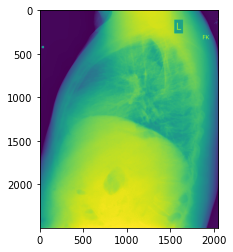

Caption: startseq with no visible active cardiopulmonary disease.                                                                                                                      


In [30]:
z = 2000
pic = list(features.keys())[z]
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = features[pic].reshape((1,14))
x = plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Caption:", Image_Caption(image))